In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8147366936004657671
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6932588160
locality {
  bus_id: 1
  links {
  }
}
incarnation: 883744986700149065
physical_device_desc: "device: 0, name: GeForce RTX 2070 SUPER, pci bus id: 0000:06:00.0, compute capability: 7.5"
]


In [1]:
import warnings
warnings.filterwarnings('ignore')

# 데이터 읽기를 위한 라이브러리
import numpy as np
np.random.seed(0)
import pandas as pd
import gc, os, time
import scipy as sp
from pandas import DataFrame, Series
from datetime import datetime, date, timedelta
from sklearn import decomposition

# 탐색적 데이터 분석을 위한 라이브러리
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew, norm, probplot, boxcox

# 모델링을 위한 라이브러리
from sklearn.linear_model import Ridge, BayesianRidge, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_regression, VarianceThreshold

import pickle

pd.set_option('display.max_columns',999)

from tqdm import tqdm

def RMSE(y, y_pred):
    rmse = mean_squared_error(y, y_pred) ** 0.5
    return rmse

In [2]:
# 학습용 데이터 
train_sensor = pd.read_csv('train_sensor.csv')
train_quality = pd.read_csv('train_quality.csv')
# 평가용 데이터 
predict_sensor = pd.read_csv('predict_sensor.csv')

In [3]:
def make_dataset(X, y=None):
    
    # -----------------------------------
    # train_sensor (X 인자)
    # -----------------------------------
    ''' column을 param_alias 로만 pivot table 만들기. '''
    df_X = X.copy()
    df_X = df_X.sort_values(by='end_time',ascending=True)
    df_X['step_id'] = df_X['step_id'].apply(lambda x: str(x).zfill(2))
    # step_id 와 param_alias 를 결합한 임시 컬럼 step_param 을 생성합니다. ex. 17_EPD_para4
    df_X['step_param'] = df_X[['step_id', 'param_alias']].apply(lambda x: '_'.join(x), axis=1)
    df_X_tmp = df_X.pivot_table(index = ['module_name','key_val'], columns = 'step_param', values='mean_val', aggfunc='sum')
    # 데이터 통합을 위해 인덱스를 key_val 로 재설정합니다. 
    df_X_tmp = df_X_tmp.reset_index(level=[0, 1])
    df_X_tmp.set_index('key_val', inplace=True)

    # -----------------------------------
    # 시간 데이터 
    # -----------------------------------
    ''' step별 end_time을 column으로 pivot table 만들기 '''
    df_X['end_time_tmp'] = df_X.apply(lambda x: x['step_id'] + '_end_time', axis=1)
    df_X['end_time'] = pd.to_datetime(df_X['end_time'])
    # end_time 은 센서 데이터가 각 para 별로 서버에 도달한 시간으로 스텝 내 오차가 발생할 수 있습니다. 동일 스텝 구간내 공정 완료 시간이 다른 경우, min 함수를 사용하여 최초 수집된 time을 가져옵니다.
    df_time_tmp = df_X.pivot_table(index = ['key_val'], columns = 'end_time_tmp', values='end_time', aggfunc=lambda x : min(x.unique()))
    df_time_tmp = df_time_tmp.reset_index()
    df_time_tmp.set_index('key_val', inplace=True)

    # -----------------------------------
    # train_quality (y 인자)
    # -----------------------------------

    if y is None : # 평가용 데이터 
        col_target = []
        col_idx = ['module_name', 'key_val']
        df_complete = pd.concat([df_X_tmp, df_time_tmp], axis=1).reset_index()
        df_complete.rename(columns={'index':'key_val'},inplace=True)
    else : # 학습용 데이터 
        df_y = y.copy()
        df_y.set_index('key_val', inplace=True)
        col_target = ['y']
        col_idx = ['module_name', 'key_val', 'end_dt_tm']
        # 센서 데이터, 시간데이터, 품질지표에 대하여 인덱스(key_val)기준으로 데이터프레임을 통합합니다.
        df_complete = pd.concat([df_X_tmp, df_time_tmp, df_y], axis=1).reset_index()
        # 컬럼 이름을 변경합니다.  
        df_complete.rename(columns={'msure_val':'y'}, inplace=True)
        df_complete.rename(columns={'index':'key_val'},inplace=True)


    # 컬럼 순서를 정렬합니다. 
    col_feats = df_X['step_param'].unique().tolist()
    col_feats.sort()
    col_time = [s for s in df_complete.columns.tolist() if "_end_time" in s]
    col_all = col_idx + col_target + col_feats + col_time
    df_complete = df_complete[col_all]
    # 처음 step이 시작된 시점을 기준으로 다시 정렬(APC value를 먹고 들어가는 값을 기준으로 정렬하고 싶었음.)
    df_complete = df_complete.set_index(['module_name','key_val','04_end_time']).sort_index(level=[0,2,1],ascending=True).reset_index()
    df_complete = df_complete[col_all]
    
    # 컬럼을 소문자로 변경합니다. 
    df_complete.columns = df_complete.columns.str.lower()

    return df_complete

# 학습용 데이터 
train = make_dataset(train_sensor, train_quality)
# 평가용 데이터 
predict = make_dataset(predict_sensor)

In [4]:
print(len(train.columns))
print(len(predict.columns))

676
674


In [5]:
# 전체 및 개별 공정 소요시간 변수를 생성하는 함수입니다.
def gen_duration_feats(df, lst_stepsgap):
    # 전체 공정 소요시간(초) 변수를 생성합니다. 
    df['gen_tmdiff'] = (df['20_end_time'] - df['04_end_time']).dt.total_seconds()

    for stepgap in lst_stepsgap:
        df[f'gen_tmdiff_{stepgap}'] = (df[f'{stepgap[2:]}_end_time'] - df[f'{stepgap[:2]}_end_time']).dt.total_seconds()
    return df

# 4. 데이터 전처리

In [6]:
# 전처리를 위한 학습용 데이터와 평가용 데이터를 복사합니다.
df_train = train.copy()
df_predict = predict.copy()

In [7]:
# 센서 컬럼과 날짜 컬럼을 정의합니다. 
col_sensor = df_train.iloc[:, 4:-7].columns.tolist() 
col_time = df_train.filter(regex='end').columns.tolist() 

assert len(col_sensor) == 665
assert len(col_time) == 8 

# 3.4절 공정 소요시간 분석에 필요한 변수를 정의합니다. 
lst_steps = ['04','06','12','13','17','18', '20']
lst_stepsgap = ['0406','0612','1213','1317','1718','1820']

''' step별로 fdc para명 따로 수집 '''
lst_sensors = []
for step in lst_steps:
    _ = [col for col in col_sensor if col[:2] == step]
    lst_sensors.append(_)

sensors_nm = list(map(lambda x: x[3:], lst_sensors[0]))

# 시간과 관련한 분석을 진행하기 위하여 날짜형으로 변환합니다. 
df_train[col_time] = df_train[col_time].apply(pd.to_datetime)

In [8]:
for_col_filter = []
for step_para in lst_sensors:
    for para in step_para:
        para = para.split('_')[0]+'_'+para.split('_')[1]
        for_col_filter.append(para)
for_col_filter = sorted(list(set(for_col_filter)))

In [9]:
# 전체 및 개별 공정 소요시간 7개의 변수를 생성합니다(3.4절)
lst_stepsgap = ['0406','0612','1213','1317','1718','1820']
df_train = gen_duration_feats(df_train, lst_stepsgap)
df_predict = gen_duration_feats(df_predict, lst_stepsgap)
df_train.filter(regex='tmdiff').head(2)

gen_tmdiff  gen_tmdiff_0406  gen_tmdiff_0612  gen_tmdiff_1213  \
0      1912.0            146.0            846.0             16.0   
1      1911.0            145.0            847.0             16.0   

   gen_tmdiff_1317  gen_tmdiff_1718  gen_tmdiff_1820  
0            477.0             16.0            411.0  
1            476.0             16.0            411.0

# round0

In [10]:
len(np.round(df_train,0).loc[:,(np.round(df_train,0).nunique()==1)].columns.tolist())

297

In [11]:
df_train = np.round(df_train, 0)
r2_drop_col = np.round(df_train,0).loc[:,(np.round(df_train,0).nunique()==1)].columns.tolist()
df_train.drop(r2_drop_col, axis=1, inplace=True)

In [12]:
df_predict = np.round(df_predict, 0)
df_predict.drop(r2_drop_col, axis=1, inplace=True)

# 전체 (sensor col + gen col) shift해서 변수추가하기

In [25]:
shift_cols = df_train.iloc[:,4:].columns.tolist()
shift_cols

['04_efem_para2',
 '04_efem_para25',
 '04_efem_para78',
 '04_esc_para94',
 '04_fr_para61',
 '04_gas_para21',
 '04_gas_para33',
 '04_gas_para36',
 '04_gas_para51',
 '04_gas_para6',
 '04_he_para22',
 '04_he_para88',
 '04_hv_para45',
 '04_hv_para47',
 '04_position_para72',
 '04_power_para76',
 '04_temp_para12',
 '04_temp_para17',
 '04_temp_para18',
 '04_temp_para20',
 '04_temp_para38',
 '04_temp_para54',
 '04_temp_para58',
 '04_temp_para60',
 '04_temp_para65',
 '04_temp_para66',
 '04_temp_para79',
 '04_temp_para86',
 '04_temp_para87',
 '04_time_para16',
 '04_time_para29',
 '04_time_para30',
 '04_time_para34',
 '04_time_para37',
 '04_time_para41',
 '04_time_para42',
 '04_time_para43',
 '04_time_para44',
 '04_time_para62',
 '04_time_para64',
 '04_time_para67',
 '04_time_para7',
 '04_time_para75',
 '04_time_para77',
 '04_time_para8',
 '04_time_para81',
 '04_time_para83',
 '04_time_para89',
 '04_time_para9',
 '04_time_para90',
 '04_tmp_para31',
 '06_efem_para2',
 '06_efem_para25',
 '06_efem_p

In [26]:
shift_df = df_train.groupby('module_name')[shift_cols].shift(1)
shift_df.columns = df_train[shift_cols].columns
shift_df.head()

04_efem_para2  04_efem_para25  04_efem_para78  04_esc_para94  04_fr_para61  \
0            NaN             NaN             NaN            NaN           NaN   
1         1631.0          1640.0             5.0            0.0           0.0   
2         1628.0          1641.0             5.0            0.0           0.0   
3         1631.0          1644.0             5.0            0.0           0.0   
4         1629.0          1641.0             5.0            0.0           0.0   

   04_gas_para21  04_gas_para33  04_gas_para36  04_gas_para51  04_gas_para6  \
0            NaN            NaN            NaN            NaN           NaN   
1            2.0            0.0            2.0           12.0           3.0   
2            2.0            0.0            2.0           12.0           3.0   
3            2.0            0.0            2.0           12.0           3.0   
4            2.0            0.0            2.0           12.0           3.0   

   04_he_para22  04_he_para88  04_hv_para45  04_hv_para47  04_position_para72  \
0           NaN           NaN           NaN           NaN                 NaN   
1           1.0           1.0         300.0         150.0                 7.0   
2           1.0           1.0         300.0         150.0                 7.0   
3           1.0           1.0         300.0         150.0                 7.0   
4           1.0           1.0         300.0         150.0                 7.0   

   04_power_para76  04_temp_para12  04_temp_para17  04_temp_para18  \
0              NaN             NaN             NaN             NaN   
1           1063.0            25.0            -0.0            15.0   
2           1063.0            25.0            -0.0            15.0   
3           1062.0            25.0            -0.0            15.0   
4           1062.0            25.0             0.0            15.0   

   04_temp_para20  04_temp_para38  04_temp_para54  04_temp_para58  \
0             NaN             NaN             NaN             NaN   
1            27.0           -10.0            48.0            24.0   
2            27.0           -10.0            49.0            24.0   
3            26.0           -10.0            44.0            24.0   
4            26.0           -10.0            47.0            24.0   

   04_temp_para60  04_temp_para65  04_temp_para66  04_temp_para79  \
0             NaN             NaN             NaN             NaN   
1            45.0            21.0            90.0             1.0   
2            44.0            21.0            90.0             1.0   
3            44.0            21.0            90.0             1.0   
4            44.0            21.0            90.0             1.0   

   04_temp_para86  04_temp_para87  04_time_para16  04_time_para29  \
0             NaN             NaN             NaN             NaN   
1            22.0           150.0          2460.0           724.0   
2            22.0           150.0          2494.0           757.0   
3            22.0           150.0          2518.0           781.0   
4            22.0           150.0          2574.0           838.0   

   04_time_para30  04_time_para34  04_time_para37  04_time_para41  \
0             NaN             NaN             NaN             NaN   
1          2460.0          2460.0           132.0           132.0   
2          2494.0          2494.0           166.0           166.0   
3          2518.0          2518.0           190.0           190.0   
4          2574.0          2574.0           246.0           246.0   

   04_time_para42  04_time_para43  04_time_para44  04_time_para62  \
0             NaN             NaN             NaN             NaN   
1          2460.0          2460.0          2460.0          2460.0   
2          2494.0          2494.0          2494.0          2494.0   
3          2518.0          2518.0          2518.0          2518.0   
4          2574.0          2574.0          2574.0          2574.0   

   04_time_para64  04_time_para67  04_time_para7  04_time_

In [28]:
delta_df = df_train[shift_cols] - shift_df
delta_df.head()

04_efem_para2  04_efem_para25  04_efem_para78  04_esc_para94  04_fr_para61  \
0            NaN             NaN             NaN            NaN           NaN   
1           -3.0             1.0             0.0            0.0           0.0   
2            3.0             3.0             0.0            0.0           0.0   
3           -2.0            -3.0             0.0            0.0           0.0   
4            1.0            -2.0             0.0            0.0           0.0   

   04_gas_para21  04_gas_para33  04_gas_para36  04_gas_para51  04_gas_para6  \
0            NaN            NaN            NaN            NaN           NaN   
1            0.0            0.0            0.0            0.0           0.0   
2            0.0            0.0            0.0            0.0           0.0   
3            0.0            0.0            0.0            0.0           0.0   
4            0.0            0.0            0.0            0.0           0.0   

   04_he_para22  04_he_para88  04_hv_para45  04_hv_para47  04_position_para72  \
0           NaN           NaN           NaN           NaN                 NaN   
1           0.0           0.0           0.0           0.0                 0.0   
2           0.0           0.0           0.0           0.0                 0.0   
3           0.0           0.0           0.0           0.0                 0.0   
4           0.0           0.0           0.0           0.0                 0.0   

   04_power_para76  04_temp_para12  04_temp_para17  04_temp_para18  \
0              NaN             NaN             NaN             NaN   
1              0.0             0.0             0.0             0.0   
2             -1.0             0.0             0.0             0.0   
3              0.0             0.0             0.0             0.0   
4             -1.0             0.0            -0.0             0.0   

   04_temp_para20  04_temp_para38  04_temp_para54  04_temp_para58  \
0             NaN             NaN             NaN             NaN   
1             0.0             0.0             1.0             0.0   
2            -1.0             0.0            -5.0             0.0   
3             0.0             0.0             3.0             0.0   
4             0.0             0.0             0.0             0.0   

   04_temp_para60  04_temp_para65  04_temp_para66  04_temp_para79  \
0             NaN             NaN             NaN             NaN   
1            -1.0             0.0             0.0             0.0   
2             0.0             0.0             0.0             0.0   
3             0.0             0.0             0.0             0.0   
4             0.0             0.0             0.0             0.0   

   04_temp_para86  04_temp_para87  04_time_para16  04_time_para29  \
0             NaN             NaN             NaN             NaN   
1             0.0             0.0            34.0            33.0   
2             0.0             0.0            24.0            24.0   
3             0.0             0.0            56.0            57.0   
4             0.0             0.0            75.0            74.0   

   04_time_para30  04_time_para34  04_time_para37  04_time_para41  \
0             NaN             NaN             NaN             NaN   
1            34.0            34.0            34.0            34.0   
2            24.0            24.0            24.0            24.0   
3            56.0            56.0            56.0            56.0   
4            75.0            75.0            75.0            75.0   

   04_time_para42  04_time_para43  04_time_para44  04_time_para62  \
0             NaN             NaN             NaN             NaN   
1            34.0            34.0            34.0            34.0   
2            24.0            24.0            24.0            24.0   
3            56.0            56.0            56.0            56.0   
4            75.0            75.0            75.0            75.0   

   04_time_para64  04_time_para67  04_time_para7  04_time_

In [29]:
delta_df.drop(delta_df.filter(regex='end_time$').columns.tolist(),axis=1,inplace=True)
delta_df = delta_df.fillna(0)

In [31]:
delta_df.columns = [col+'_shift' for col in delta_df.columns]
delta_df.head()

04_efem_para2_shift  04_efem_para25_shift  04_efem_para78_shift  \
0                  0.0                   0.0                   0.0   
1                 -3.0                   1.0                   0.0   
2                  3.0                   3.0                   0.0   
3                 -2.0                  -3.0                   0.0   
4                  1.0                  -2.0                   0.0   

   04_esc_para94_shift  04_fr_para61_shift  04_gas_para21_shift  \
0                  0.0                 0.0                  0.0   
1                  0.0                 0.0                  0.0   
2                  0.0                 0.0                  0.0   
3                  0.0                 0.0                  0.0   
4                  0.0                 0.0                  0.0   

   04_gas_para33_shift  04_gas_para36_shift  04_gas_para51_shift  \
0                  0.0                  0.0                  0.0   
1                  0.0                  0.0                  0.0   
2                  0.0                  0.0                  0.0   
3                  0.0                  0.0                  0.0   
4                  0.0                  0.0                  0.0   

   04_gas_para6_shift  04_he_para22_shift  04_he_para88_shift  \
0                 0.0                 0.0                 0.0   
1                 0.0                 0.0                 0.0   
2                 0.0                 0.0                 0.0   
3                 0.0                 0.0                 0.0   
4                 0.0                 0.0                 0.0   

   04_hv_para45_shift  04_hv_para47_shift  04_position_para72_shift  \
0                 0.0                 0.0                       0.0   
1                 0.0                 0.0                       0.0   
2                 0.0                 0.0                       0.0   
3                 0.0                 0.0                       0.0   
4                 0.0                 0.0                       0.0   

   04_power_para76_shift  04_temp_para12_shift  04_temp_para17_shift  \
0                    0.0                   0.0                   0.0   
1                    0.0                   0.0                   0.0   
2                   -1.0                   0.0                   0.0   
3                    0.0                   0.0                   0.0   
4                   -1.0                   0.0                  -0.0   

   04_temp_para18_shift  04_temp_para20_shift  04_temp_para38_shift  \
0                   0.0                   0.0                   0.0   
1                   0.0                   0.0                   0.0   
2                   0.0                  -1.0                   0.0   
3                   0.0                   0.0                   0.0   
4                   0.0                   0.0                   0.0   

   04_temp_para54_shift  04_temp_para58_shift  04_temp_para60_shift  \
0                   0.0                   0.0                   0.0   
1                   1.0                   0.0                  -1.0   
2                  -5.0                   0.0                   0.0   
3                   3.0                   0.0                   0.0   
4                   0.0                   0.0                   0.0   

   04_temp_para65_shift  04_temp_para66_shift  04_temp_para79_shift  \
0                   0.0                   0.0                   0.0   
1                   0.0                   0.0                   0.0   
2                   0.0                   0.0                   0.0   
3                   0.0                   0.0                   0.0   
4                   0.0                   0.0                   0.0   

   04_temp_para86_shift  04_temp_para87_shift  04_time_para16_shift  \
0                   0.0                   0.0                   0.0   
1                   0.0                   0.0                  34.0   
2                   0.0  

In [32]:
df_train.head()

module_name    key_val           end_dt_tm       y  04_efem_para2  \
0    EQ10_PM1    LOT5_21 2021-10-03 07:10:22  1260.0         1631.0   
1    EQ10_PM1  LOT126_21 2021-10-04 23:34:27  1253.0         1628.0   
2    EQ10_PM1   LOT23_21 2021-10-06 07:48:24  1249.0         1631.0   
3    EQ10_PM1  LOT295_21 2021-10-08 13:22:26  1260.0         1629.0   
4    EQ10_PM1   LOT75_18 2021-10-11 21:35:57  1257.0         1630.0   

   04_efem_para25  04_efem_para78  04_esc_para94  04_fr_para61  04_gas_para21  \
0          1640.0             5.0            0.0           0.0            2.0   
1          1641.0             5.0            0.0           0.0            2.0   
2          1644.0             5.0            0.0           0.0            2.0   
3          1641.0             5.0            0.0           0.0            2.0   
4          1639.0             5.0            0.0           0.0            2.0   

   04_gas_para33  04_gas_para36  04_gas_para51  04_gas_para6  04_he_para22  \
0            0.0            2.0           12.0           3.0           1.0   
1            0.0            2.0           12.0           3.0           1.0   
2            0.0            2.0           12.0           3.0           1.0   
3            0.0            2.0           12.0           3.0           1.0   
4            0.0            2.0           12.0           3.0           1.0   

   04_he_para88  04_hv_para45  04_hv_para47  04_position_para72  \
0           1.0         300.0         150.0                 7.0   
1           1.0         300.0         150.0                 7.0   
2           1.0         300.0         150.0                 7.0   
3           1.0         300.0         150.0                 7.0   
4           1.0         300.0         150.0                 7.0   

   04_power_para76  04_temp_para12  04_temp_para17  04_temp_para18  \
0           1063.0            25.0            -0.0            15.0   
1           1063.0            25.0            -0.0            15.0   
2           1062.0            25.0            -0.0            15.0   
3           1062.0            25.0             0.0            15.0   
4           1061.0            25.0            -0.0            15.0   

   04_temp_para20  04_temp_para38  04_temp_para54  04_temp_para58  \
0            27.0           -10.0            48.0            24.0   
1            27.0           -10.0            49.0            24.0   
2            26.0           -10.0            44.0            24.0   
3            26.0           -10.0            47.0            24.0   
4            26.0           -10.0            47.0            24.0   

   04_temp_para60  04_temp_para65  04_temp_para66  04_temp_para79  \
0            45.0            21.0            90.0             1.0   
1            44.0            21.0            90.0             1.0   
2            44.0            21.0            90.0             1.0   
3            44.0            21.0            90.0             1.0   
4            44.0            21.0            90.0             1.0   

   04_temp_para86  04_temp_para87  04_time_para16  04_time_para29  \
0            22.0           150.0          2460.0           724.0   
1            22.0           150.0          2494.0           757.0   
2            22.0           150.0          2518.0           781.0   
3            22.0           150.0          2574.0           838.0   
4            22.0           150.0          2649.0           912.0   

   04_time_para30  04_time_para34  04_time_para37  04_time_para41  \
0          2460.0          2460.0           132.0           132.0   
1          2494.0          2494.0           166.0           166.0   
2          2518.0          2518.0           190.0           190.0   
3          2574.0          2574.0           246.0           246.0   
4          2649.0          2649.0           321.0           321.0   

   04_time_para42  04_time_para43  04_time_para44  04_time_para62  \
0          2460.0          2460.0          2460.0          2460.0 

In [36]:
df_train = pd.concat([df_train,delta_df],axis=1)

# Cyclic Transformation 적용

In [13]:
''' Cyclic Transformation 적용 '''
def cyclic_transformation(df, cols):
    for col in cols:
        step = col[:2]
        df[col] = pd.to_datetime(df[col])
        df[step+'_'+'month'] = df[col].dt.month
        df[step+'_'+'day'] = df[col].dt.day
        df[step+'_'+'hour'] = df[col].dt.hour
        df[step+'_'+'weekday'] = df[col].dt.weekday
        
        ## cyclic transformation on hour
        df[step+'_'+'hour_sin'] = np.sin(2 * np.pi * df[step+'_'+'hour']/23.0)
        df[step+'_'+'hour_cos'] = np.cos(2 * np.pi * df[step+'_'+'hour']/23.0)
        ## cyclic transformation on date 
        df[step+'_'+'date_sin'] = -np.sin(2 * np.pi * (df[step+'_'+'month']+df[step+'_'+'day']/31)/12)
        df[step+'_'+'date_cos'] = -np.cos(2 * np.pi * (df[step+'_'+'month']+df[step+'_'+'day']/31)/12)
        ## cyclic transformation on month
        df[step+'_'+'month_sin'] = -np.sin(2 * np.pi * df[step+'_'+'month']/12.0)
        df[step+'_'+'month_cos'] = -np.cos(2 * np.pi * df[step+'_'+'month']/12.0)
        ## cyclic transformation on weekday
        df[step+'_'+'weekday_sin'] = -np.sin(2 * np.pi * (df[step+'_'+'weekday']+1)/7.0)
        df[step+'_'+'weekday_cos'] = -np.cos(2 * np.pi * (df[step+'_'+'weekday']+1)/7.0)
        
        df.drop(step+'_'+'month',axis=1,inplace=True)
        df.drop(step+'_'+'month_sin',axis=1,inplace=True)
        df.drop(step+'_'+'month_cos',axis=1,inplace=True)

In [14]:
endtime_col = df_train.filter(regex='end_time$').columns.tolist()
cyclic_transformation(df_train, endtime_col)
cyclic_transformation(df_predict, endtime_col)

In [39]:
df_train.head(1)

module_name  key_val           end_dt_tm       y  04_efem_para2  \
0    EQ10_PM1  LOT5_21 2021-10-03 07:10:22  1260.0         1631.0   

   04_efem_para25  04_efem_para78  04_esc_para94  04_fr_para61  04_gas_para21  \
0          1640.0             5.0            0.0           0.0            2.0   

   04_gas_para33  04_gas_para36  04_gas_para51  04_gas_para6  04_he_para22  \
0            0.0            2.0           12.0           3.0           1.0   

   04_he_para88  04_hv_para45  04_hv_para47  04_position_para72  \
0           1.0         300.0         150.0                 7.0   

   04_power_para76  04_temp_para12  04_temp_para17  04_temp_para18  \
0           1063.0            25.0            -0.0            15.0   

   04_temp_para20  04_temp_para38  04_temp_para54  04_temp_para58  \
0            27.0           -10.0            48.0            24.0   

   04_temp_para60  04_temp_para65  04_temp_para66  04_temp_para79  \
0            45.0            21.0            90.0             1.0   

   04_temp_para86  04_temp_para87  04_time_para16  04_time_para29  \
0            22.0           150.0          2460.0           724.0   

   04_time_para30  04_time_para34  04_time_para37  04_time_para41  \
0          2460.0          2460.0           132.0           132.0   

   04_time_para42  04_time_para43  04_time_para44  04_time_para62  \
0          2460.0          2460.0          2460.0          2460.0   

   04_time_para64  04_time_para67  04_time_para7  04_time_para75  \
0           132.0          2460.0          132.0          2460.0   

   04_time_para77  04_time_para8  04_time_para81  04_time_para83  \
0          2460.0          132.0          2460.0           132.0   

   04_time_para89  04_time_para9  04_time_para90  04_tmp_para31  \
0          2460.0          132.0          2460.0            2.0   

   06_efem_para2  06_efem_para25  06_efem_para78  06_epd_para4  06_epd_para40  \
0         1631.0          1640.0             5.0           0.0           -1.0   

   06_esc_para94  06_fr_para61  06_gas_para21  06_gas_para33  06_gas_para36  \
0            0.0           0.0            3.0            0.0            4.0   

   06_he_para22  06_he_para88  06_position_para72  06_power_para49  \
0           1.0           1.0                 9.0              0.0   

   06_power_para57  06_power_para76  06_temp_para12  06_temp_para18  \
0           2000.0           1526.0            25.0            15.0   

   06_temp_para20  06_temp_para38  06_temp_para54  06_temp_para58  \
0            27.0           -12.0            43.0            24.0   

   06_temp_para60  06_temp_para65  06_temp_para66  06_temp_para79  \
0            37.0            22.0            90.0             1.0   

   06_temp_para86  06_temp_para87  06_time_para16  06_time_para29  \
0            23.0           150.0          2460.0           724.0   

   06_time_para30  06_time_para34  06_time_para37  06_time_para41  \
0          2460.0          2460.0           132.0           132.0   

   06_time_para42  06_time_para43  06_time_para44  06_time_para62  \
0          2460.0          2460.0          2460.0          2460.0   

   06_time_para64  06_time_para67  06_time_para7  06_time_para75  \
0           132.0          2460.0          132.0          2460.0   

   06_time_para77  06_time_para8  06_time_para81  06_time_para83  \
0          2460.0          132.0          2460.0           132.0   

   06_time_para89  06_time_para9  06_time_para90  12_efem_para2  \
0          2460.0          132.0          2460.0         1631.0   

   12_efem_para25  12_efem_para78  12_esc_para94  12_fr_para35  12_fr_para61  \
0          1643.0             5.0            0.0           0.0           0.0   

   12_gas_para33  12_gas_para36  12_gas_para6  12_he_para22  12_he_para88  \
0            0.0            5.0           4.0           1.0           1.0   

   12_hv_para45  12_hv_para47  12_position_para72  12_power_para14  \
0         272.0         435.0                16.0           6827.0 

In [40]:
df_predict.head(1)

module_name    key_val  04_efem_para2  04_efem_para25  04_efem_para78  \
0    EQ10_PM1  LOT380_17         1627.0          1636.0             5.0   

   04_esc_para94  04_fr_para61  04_gas_para21  04_gas_para33  04_gas_para36  \
0            0.0           0.0            2.0            0.0            2.0   

   04_gas_para51  04_gas_para6  04_he_para22  04_he_para88  04_hv_para45  \
0            9.0           3.0           1.0           1.0           0.0   

   04_hv_para47  04_position_para72  04_power_para76  04_temp_para12  \
0           0.0                 7.0           1079.0            25.0   

   04_temp_para17  04_temp_para18  04_temp_para20  04_temp_para38  \
0             0.0            15.0            29.0           -10.0   

   04_temp_para54  04_temp_para58  04_temp_para60  04_temp_para65  \
0            45.0            24.0            44.0            21.0   

   04_temp_para66  04_temp_para79  04_temp_para86  04_temp_para87  \
0            90.0             1.0            22.0           150.0   

   04_time_para16  04_time_para29  04_time_para30  04_time_para34  \
0          2965.0          1228.0          2965.0            38.0   

   04_time_para37  04_time_para41  04_time_para42  04_time_para43  \
0           637.0            38.0          2965.0          2965.0   

   04_time_para44  04_time_para62  04_time_para64  04_time_para67  \
0          2965.0          2965.0            38.0          2965.0   

   04_time_para7  04_time_para75  04_time_para77  04_time_para8  \
0          637.0          2965.0          2965.0           38.0   

   04_time_para81  04_time_para83  04_time_para89  04_time_para9  \
0          2965.0           637.0          2965.0           38.0   

   04_time_para90  04_tmp_para31  06_efem_para2  06_efem_para25  \
0            38.0            2.0         1627.0          1638.0   

   06_efem_para78  06_epd_para4  06_epd_para40  06_esc_para94  06_fr_para61  \
0             5.0          99.0           -0.0            0.0           0.0   

   06_gas_para21  06_gas_para33  06_gas_para36  06_he_para22  06_he_para88  \
0            3.0            0.0            4.0           1.0           1.0   

   06_position_para72  06_power_para49  06_power_para57  06_power_para76  \
0                 9.0              0.0           2500.0           1680.0   

   06_temp_para12  06_temp_para18  06_temp_para20  06_temp_para38  \
0            25.0            15.0            26.0           -13.0   

   06_temp_para54  06_temp_para58  06_temp_para60  06_temp_para65  \
0            42.0            24.0            39.0            22.0   

   06_temp_para66  06_temp_para79  06_temp_para86  06_temp_para87  \
0            90.0             1.0            24.0           150.0   

   06_time_para16  06_time_para29  06_time_para30  06_time_para34  \
0          2965.0          1228.0          2965.0            38.0   

   06_time_para37  06_time_para41  06_time_para42  06_time_para43  \
0           637.0            38.0          2965.0          2965.0   

   06_time_para44  06_time_para62  06_time_para64  06_time_para67  \
0          2965.0          2965.0            38.0          2965.0   

   06_time_para7  06_time_para75  06_time_para77  06_time_para8  \
0          637.0          2965.0          2965.0           38.0   

   06_time_para81  06_time_para83  06_time_para89  06_time_para9  \
0          2965.0           637.0          2965.0           38.0   

   06_time_para90  12_efem_para2  12_efem_para25  12_efem_para78  \
0            38.0         1627.0          1637.0             5.0   

   12_esc_para94  12_fr_para35  12_fr_para61  12_gas_para33  12_gas_para36  \
0            0.0           0.0           0.0            0.0            5.0   

   12_gas_para6  12_he_para22  12_he_para88  12_hv_para45  12_hv_para47  \
0           4.0           1.0           1.0         259.0         484.0   

   12_position_para72  12_power_para14  12_power_para57  12_power_para76  \
0                16.0           6869.0           4000.0  

# 이중 트렌드 para 전처리

In [105]:
two_trend_para = ['06_epd_para4','20_epd_para4','04_hv_para45','04_hv_para47','04_hv_para56','06_power_para57']

In [15]:
df_train['06_epd_para4_test'] = df_train['06_epd_para4'].apply(lambda x: 1 if x > 50 else 0)
df_train['20_epd_para4_test'] = df_train['20_epd_para4'].apply(lambda x: 1 if x < 900 else 0)
df_train['04_hv_para45_test'] = df_train['04_hv_para45'].apply(lambda x: 1 if x < 150 else 0)
df_train['04_hv_para47_test'] = df_train['04_hv_para47'].apply(lambda x: 1 if x < 100 else 0)
# df_train['04_hv_para56_test'] = df_train['04_hv_para56'].apply(lambda x: 1 if x < 0.15 else 0)
df_train['06_power_para57_test'] = df_train['06_power_para57'].apply(lambda x: 1 if x > 2300 else 0)
df_train['06_power_para76_test'] = df_train['06_power_para76'].apply(lambda x: 1 if x > 1600 else 0)

df_predict['06_epd_para4_test'] = df_predict['06_epd_para4'].apply(lambda x: 1 if x > 50 else 0)
df_predict['20_epd_para4_test'] = df_predict['20_epd_para4'].apply(lambda x: 1 if x < 900 else 0)
df_predict['04_hv_para45_test'] = df_predict['04_hv_para45'].apply(lambda x: 1 if x < 150 else 0)
df_predict['04_hv_para47_test'] = df_predict['04_hv_para47'].apply(lambda x: 1 if x < 100 else 0)
# df_predict['04_hv_para56_test'] = df_predict['04_hv_para56'].apply(lambda x: 1 if x < 0.15 else 0)
df_predict['06_power_para57_test'] = df_predict['06_power_para57'].apply(lambda x: 1 if x > 2300 else 0)
df_predict['06_power_para76_test'] = df_predict['06_power_para76'].apply(lambda x: 1 if x > 1600 else 0)

#### TIME para 이중트렌드 전처리

In [16]:
''' 5000 이상은 1, 아래는 0으로인코딩 '''
time_5000 = ['time para16','time_para42','time_para43','time_para44','time_para62','time_para75','time_para77','time_para89']
for col in time_5000:
    col_ = df_train.filter(regex=col+'$').columns.tolist()
    for column in col_:
        df_train[column+'_test'] = df_train[column].apply(lambda x: 1 if x>5000 else 0)
        df_predict[column+'_test'] = df_predict[column].apply(lambda x: 1 if x>5000 else 0)
''' 125 이상은 0, 아래는 1로 인코딩 '''
time_125 = ['12_time_para5','13_time_para5','17_time_para5','18_time_para5']
for col in time_125:
    df_train[col+'_test'] = df_train[col].apply(lambda x: 1 if x <125 else 0)
    df_predict[col+'_test'] = df_predict[col].apply(lambda x: 1 if x <125 else 0)
''' 3500 이상은 1 아래는 0 '''
for col in df_train.filter(regex='time_para67$').columns.tolist():
    df_train[col+'_test'] = df_train[col].apply(lambda x: 1 if x >= 3500 else 0)
    df_predict[col+'_test'] = df_predict[col].apply(lambda x: 1 if x >= 3500 else 0)

#### TMP para 이중트렌드 전처리

In [17]:
''' 2.6 이상 1, 아래 0 '''
'04_tmp_para31'
df_train['04_tmp_para31_test'] = df_train['04_tmp_para31'].apply(lambda x: 1 if x >=3.0 else 0)
df_predict['04_tmp_para31_test'] = df_predict['04_tmp_para31'].apply(lambda x: 1 if x >=3.0 else 0)
''' 2.8 이상 1, 아래 0 '''
'06_tmp_para31'
# df_train['06_tmp_para31_test'] = df_train['06_tmp_para31'].apply(lambda x: 1 if x >=2.8 else 0)
# df_predict['06_tmp_para31_test'] = df_predict['06_tmp_para31'].apply(lambda x: 1 if x >=2.8 else 0)
''' 4.0 이상 1, 아래 0 '''
tmp_4 = ['12_tmp_para31','13_tmp_para31','17_tmp_para31','18_tmp_para31','20_tmp_para31']
for col in tmp_4:
    if col in df_train.columns.tolist():
        df_train[col+'_test'] = df_train[col].apply(lambda x: 1 if x>=4.0 else 0)
        df_predict[col+'_test'] = df_predict[col].apply(lambda x: 1 if x>=4.0 else 0)
    else:
        continue

# Category 변수 처리

In [18]:
''' CATEGORY 변수 처리 및 NUM FEATURE 정의 '''
module2idx = {}
for i, module in enumerate(df_train['module_name'].unique()):
    module2idx[module] = i
    
def col2cat(df, col, dict):
    df[col] = df[col].apply(lambda x: dict[x])
    df[col] = df[col].astype('category')
    return df[col]

# module_name cat 화
col2cat(df_train, 'module_name', module2idx)
col2cat(df_predict, 'module_name', module2idx)

0       0
1       0
2       0
3       0
4       0
       ..
257    45
258    46
259    46
260    46
261    46
Name: module_name, Length: 262, dtype: category
Categories (47, int64): [0, 1, 2, 3, ..., 43, 44, 45, 46]

# 각 챔버별 전처리

In [19]:
df_final = df_train.copy()
df_predict_final = df_predict.copy()

In [20]:
module_unique = df_final['module_name'].unique()
df_trains = [df_final[df_final['module_name']==eq] for eq in module_unique]
num_features_lst = []
df_predicts = [df_predict_final[df_predict_final['module_name']==eq] for eq in module_unique]
''' 중복되는 열 제거하기. '''
for i, (trains,predicts) in enumerate(zip(df_trains,df_predicts)):
    drop_col = []
    for para in for_col_filter:
        col = trains.filter(regex='^'+para).columns.tolist()
        if col:
            duplicate_deleted_df = trains[col].T.drop_duplicates(subset=trains[col].T.columns, keep='first').T
            if len(trains[col].columns.difference(duplicate_deleted_df.columns))==0:  # 다른게 없으면 무시,
                continue
            else:
                drop_col.extend(trains[col].columns.difference(duplicate_deleted_df.columns).tolist())
        else:
            continue
    
    # 새로 생성한 TEST COLUMNS 전처리
    test_col = trains.filter(regex='test$').columns.tolist()
    duplicate_deleted_test_df = trains[test_col].T.drop_duplicates(subset=trains[test_col].T.columns, keep='first').T
    if len(trains[test_col].columns.difference(duplicate_deleted_test_df.columns))!=0:
        drop_col.extend(trains[test_col].columns.difference(duplicate_deleted_test_df.columns).tolist())
    
    trains.drop(drop_col,axis=1,inplace=True)
    predicts.drop(drop_col, axis=1, inplace=True)
    
#     ''' 1부터도 log transformation시 skewness와 kurtois가 많이 줄어듦. 효과적일 것이라 변환진행 ex) '20_time_para42' '''
#     skew1_df = ((trains.skew()>=2.5)|(trains.skew()<=-2.5)).reset_index().iloc[1:].reset_index(drop=True)
#     skew1_df.columns=['param','boolean']
#     high_skew1_col = skew1_df.loc[skew1_df['boolean'],:]['param'].unique().tolist()
#     df = trains[high_skew1_col]
#     ''' 04_fr_para28 , 06_fr_para28 음수를 가진 col인데, skew는 높지만 시각화시 괜찮아서 제외. '''
    
#     minus_col = df[(np.log1p(df).isnull())|(np.log1p(df)==float('-inf'))].dropna(axis=1,how='any').columns.tolist()
#     high_skew1_col = [x for x in high_skew1_col if x not in minus_col]
#     print(len(high_skew1_col))

#     trains[high_skew1_col] = np.log1p(trains[high_skew1_col])
#     predicts[high_skew1_col] = np.log1p(predicts[high_skew1_col])
    
#     assert predicts[high_skew1_col].isnull().sum().sum() == 0
#     assert (predicts[high_skew1_col]==float('-inf')).sum().sum() == 0
#     assert (predicts[high_skew1_col]==float('inf')).sum().sum() == 0
    
    var0_cols = trains.loc[:,trains.nunique()==1].columns.tolist()
    print(f'module{i}의 drop할 columns : {var0_cols}')
    trains.drop(var0_cols, axis=1, inplace=True)
    predicts.drop(var0_cols, axis=1, inplace=True)
    
#     num_features = list(trains.columns[trains.dtypes==float])
#     num_features.remove('y')
#     scaler = MinMaxScaler()
#     trains.loc[:, num_features] = scaler.fit_transform(trains[num_features])
#     predicts.loc[:, num_features] = scaler.transform(predicts[num_features])
    
    df_trains[i] = trains
#     df_predicts[i] = predicts
    
    ''' Cyclic Transformation 된 time만 사용. gen+float f들 '''
    num_features = list(trains.columns[trains.dtypes==float])
    num_features.remove('y')
    test_cols = trains.filter(regex='test$').columns.tolist()
    num_features_lst.append(num_features+test_cols)

module0의 drop할 columns : ['module_name', '04_efem_para78', '04_esc_para94', '04_fr_para61', '04_gas_para21', '04_gas_para33', '04_gas_para6', '04_he_para22', '04_position_para72', '04_temp_para12', '04_temp_para17', '04_temp_para18', '04_temp_para38', '04_temp_para58', '04_temp_para65', '04_temp_para66', '04_temp_para79', '04_temp_para86', '04_temp_para87', '04_tmp_para31', '06_efem_para78', '06_esc_para94', '06_fr_para61', '06_gas_para21', '06_gas_para33', '06_gas_para36', '06_he_para22', '06_position_para72', '06_temp_para12', '06_temp_para18', '06_temp_para58', '06_temp_para65', '06_temp_para66', '06_temp_para79', '12_efem_para78', '12_esc_para94', '12_fr_para35', '12_gas_para33', '12_gas_para36', '12_gas_para6', '12_position_para72', '12_power_para57', '12_power_para82', '12_temp_para12', '12_temp_para17', '12_temp_para18', '12_temp_para58', '12_temp_para65', '12_temp_para66', '12_temp_para79', '12_temp_para86', '12_temp_para92', '13_efem_para78', '13_esc_para94', '13_fr_para35', '

module5의 drop할 columns : ['module_name', '04_esc_para94', '04_fr_para61', '04_gas_para21', '04_gas_para33', '04_he_para22', '04_hv_para45', '04_hv_para47', '04_position_para72', '04_temp_para12', '04_temp_para17', '04_temp_para18', '04_temp_para38', '04_temp_para65', '04_temp_para66', '04_temp_para79', '04_temp_para87', '04_tmp_para31', '06_epd_para4', '06_epd_para40', '06_esc_para94', '06_fr_para61', '06_gas_para33', '06_he_para22', '06_position_para72', '06_power_para57', '06_temp_para12', '06_temp_para18', '06_temp_para20', '06_temp_para38', '06_temp_para65', '06_temp_para66', '06_temp_para79', '06_temp_para86', '06_temp_para87', '12_esc_para94', '12_fr_para35', '12_fr_para61', '12_gas_para33', '12_gas_para36', '12_gas_para6', '12_he_para22', '12_power_para57', '12_power_para82', '12_temp_para12', '12_temp_para17', '12_temp_para18', '12_temp_para38', '12_temp_para65', '12_temp_para66', '12_temp_para79', '12_temp_para86', '12_temp_para92', '13_esc_para94', '13_fr_para35', '13_fr_para

module10의 drop할 columns : ['module_name', '04_efem_para78', '04_esc_para94', '04_fr_para61', '04_gas_para21', '04_gas_para33', '04_gas_para6', '04_he_para22', '04_hv_para45', '04_hv_para47', '04_position_para72', '04_temp_para12', '04_temp_para17', '04_temp_para18', '04_temp_para58', '04_temp_para65', '04_temp_para66', '04_temp_para79', '04_temp_para86', '04_temp_para87', '04_tmp_para31', '06_efem_para78', '06_epd_para4', '06_epd_para40', '06_esc_para94', '06_fr_para61', '06_gas_para21', '06_gas_para33', '06_he_para22', '06_position_para72', '06_power_para57', '06_temp_para12', '06_temp_para18', '06_temp_para58', '06_temp_para65', '06_temp_para66', '06_temp_para79', '06_temp_para86', '12_efem_para78', '12_esc_para94', '12_fr_para35', '12_gas_para33', '12_gas_para36', '12_gas_para6', '12_he_para22', '12_position_para72', '12_power_para57', '12_power_para82', '12_temp_para12', '12_temp_para18', '12_temp_para58', '12_temp_para65', '12_temp_para66', '12_temp_para79', '12_temp_para86', '12_

module14의 drop할 columns : ['module_name', '04_esc_para94', '04_fr_para61', '04_gas_para21', '04_gas_para33', '04_gas_para6', '04_he_para22', '04_hv_para45', '04_hv_para47', '04_position_para72', '04_temp_para12', '04_temp_para17', '04_temp_para18', '04_temp_para38', '04_temp_para65', '04_temp_para79', '04_temp_para86', '04_temp_para87', '04_tmp_para31', '06_epd_para4', '06_epd_para40', '06_esc_para94', '06_fr_para61', '06_gas_para33', '06_he_para22', '06_position_para72', '06_power_para57', '06_temp_para12', '06_temp_para18', '06_temp_para38', '06_temp_para65', '06_temp_para79', '12_esc_para94', '12_fr_para35', '12_gas_para33', '12_he_para22', '12_position_para72', '12_power_para57', '12_power_para82', '12_temp_para12', '12_temp_para17', '12_temp_para18', '12_temp_para38', '12_temp_para65', '12_temp_para79', '12_temp_para92', '13_esc_para94', '13_fr_para35', '13_gas_para33', '13_gas_para46', '13_gas_para6', '13_he_para22', '13_power_para57', '13_power_para82', '13_temp_para12', '13_tem

module19의 drop할 columns : ['module_name', '04_esc_para94', '04_fr_para61', '04_gas_para33', '04_gas_para36', '04_gas_para51', '04_he_para22', '04_hv_para45', '04_hv_para47', '04_position_para72', '04_temp_para12', '04_temp_para17', '04_temp_para18', '04_temp_para66', '04_temp_para79', '04_temp_para86', '04_temp_para87', '04_tmp_para31', '06_epd_para4', '06_epd_para40', '06_esc_para94', '06_fr_para61', '06_gas_para33', '06_he_para22', '06_position_para72', '06_power_para57', '06_temp_para12', '06_temp_para18', '06_temp_para38', '06_temp_para65', '06_temp_para66', '06_temp_para79', '06_temp_para86', '12_esc_para94', '12_fr_para35', '12_fr_para61', '12_gas_para33', '12_gas_para36', '12_he_para22', '12_power_para57', '12_temp_para12', '12_temp_para17', '12_temp_para18', '12_temp_para65', '12_temp_para66', '12_temp_para79', '12_temp_para92', '13_esc_para94', '13_fr_para35', '13_fr_para61', '13_gas_para33', '13_gas_para46', '13_gas_para6', '13_he_para22', '13_power_para57', '13_temp_para12',

module24의 drop할 columns : ['module_name', '04_efem_para78', '04_esc_para94', '04_fr_para61', '04_gas_para33', '04_gas_para6', '04_he_para22', '04_hv_para45', '04_hv_para47', '04_position_para72', '04_temp_para12', '04_temp_para17', '04_temp_para18', '04_temp_para38', '04_temp_para65', '04_temp_para66', '04_temp_para79', '04_temp_para86', '04_temp_para87', '04_tmp_para31', '06_efem_para78', '06_epd_para4', '06_epd_para40', '06_esc_para94', '06_fr_para61', '06_gas_para33', '06_he_para22', '06_position_para72', '06_power_para57', '06_temp_para12', '06_temp_para18', '06_temp_para38', '06_temp_para65', '06_temp_para66', '06_temp_para79', '06_temp_para86', '06_temp_para87', '12_efem_para78', '12_esc_para94', '12_fr_para35', '12_gas_para33', '12_gas_para36', '12_he_para22', '12_position_para72', '12_power_para57', '12_power_para82', '12_temp_para12', '12_temp_para17', '12_temp_para18', '12_temp_para38', '12_temp_para65', '12_temp_para66', '12_temp_para79', '12_temp_para86', '12_temp_para92', 

module28의 drop할 columns : ['module_name', '04_efem_para78', '04_esc_para94', '04_fr_para61', '04_gas_para21', '04_gas_para33', '04_gas_para6', '04_he_para22', '04_hv_para45', '04_hv_para47', '04_position_para72', '04_temp_para17', '04_temp_para18', '04_temp_para38', '04_temp_para58', '04_temp_para65', '04_temp_para66', '04_temp_para79', '04_temp_para86', '04_temp_para87', '04_tmp_para31', '06_efem_para78', '06_epd_para4', '06_esc_para94', '06_fr_para61', '06_gas_para33', '06_gas_para36', '06_he_para22', '06_position_para72', '06_power_para57', '06_temp_para18', '06_temp_para38', '06_temp_para58', '06_temp_para65', '06_temp_para66', '06_temp_para79', '06_temp_para86', '06_temp_para87', '12_esc_para94', '12_fr_para61', '12_gas_para33', '12_he_para22', '12_position_para72', '12_power_para57', '12_temp_para17', '12_temp_para18', '12_temp_para58', '12_temp_para66', '12_temp_para79', '12_temp_para86', '12_temp_para92', '13_esc_para94', '13_fr_para61', '13_gas_para21', '13_gas_para33', '13_ga

module32의 drop할 columns : ['module_name', '04_esc_para94', '04_fr_para61', '04_gas_para21', '04_gas_para33', '04_gas_para6', '04_he_para22', '04_hv_para45', '04_hv_para47', '04_position_para72', '04_temp_para12', '04_temp_para17', '04_temp_para18', '04_temp_para58', '04_temp_para66', '04_temp_para79', '04_temp_para86', '04_temp_para87', '04_tmp_para31', '06_epd_para4', '06_esc_para94', '06_fr_para61', '06_gas_para33', '06_gas_para36', '06_he_para22', '06_position_para72', '06_power_para57', '06_temp_para12', '06_temp_para18', '06_temp_para38', '06_temp_para58', '06_temp_para65', '06_temp_para66', '06_temp_para79', '06_temp_para86', '12_esc_para94', '12_fr_para35', '12_gas_para33', '12_he_para22', '12_position_para72', '12_power_para57', '12_power_para82', '12_temp_para12', '12_temp_para17', '12_temp_para18', '12_temp_para58', '12_temp_para65', '12_temp_para66', '12_temp_para79', '12_temp_para86', '12_temp_para92', '13_esc_para94', '13_fr_para35', '13_gas_para21', '13_gas_para33', '13_g

module36의 drop할 columns : ['module_name', '04_efem_para78', '04_esc_para94', '04_fr_para61', '04_gas_para21', '04_gas_para33', '04_gas_para51', '04_gas_para6', '04_he_para22', '04_position_para72', '04_temp_para12', '04_temp_para18', '04_temp_para58', '04_temp_para65', '04_temp_para66', '04_temp_para79', '04_temp_para87', '04_tmp_para31', '06_efem_para78', '06_esc_para94', '06_fr_para61', '06_gas_para21', '06_gas_para33', '06_he_para22', '06_position_para72', '06_temp_para12', '06_temp_para18', '06_temp_para58', '06_temp_para66', '06_temp_para79', '06_temp_para86', '12_esc_para94', '12_fr_para35', '12_gas_para33', '12_gas_para36', '12_gas_para6', '12_he_para22', '12_position_para72', '12_power_para57', '12_power_para82', '12_temp_para12', '12_temp_para17', '12_temp_para18', '12_temp_para58', '12_temp_para65', '12_temp_para66', '12_temp_para79', '12_temp_para86', '12_temp_para92', '13_esc_para94', '13_fr_para35', '13_gas_para33', '13_gas_para46', '13_gas_para6', '13_he_para22', '13_powe

module40의 drop할 columns : ['module_name', '04_esc_para94', '04_fr_para61', '04_gas_para21', '04_gas_para33', '04_gas_para6', '04_he_para22', '04_position_para72', '04_temp_para12', '04_temp_para17', '04_temp_para18', '04_temp_para38', '04_temp_para58', '04_temp_para65', '04_temp_para66', '04_temp_para79', '04_temp_para86', '04_temp_para87', '04_tmp_para31', '06_esc_para94', '06_fr_para61', '06_gas_para21', '06_gas_para33', '06_he_para22', '06_temp_para12', '06_temp_para18', '06_temp_para58', '06_temp_para65', '06_temp_para66', '06_temp_para79', '06_temp_para86', '06_temp_para87', '12_efem_para78', '12_esc_para94', '12_fr_para35', '12_gas_para33', '12_gas_para36', '12_gas_para6', '12_he_para22', '12_position_para72', '12_power_para57', '12_power_para82', '12_temp_para12', '12_temp_para17', '12_temp_para18', '12_temp_para58', '12_temp_para65', '12_temp_para66', '12_temp_para79', '12_temp_para86', '12_temp_para92', '13_efem_para78', '13_esc_para94', '13_fr_para35', '13_gas_para33', '13_ga

module45의 drop할 columns : ['module_name', '04_efem_para78', '04_esc_para94', '04_fr_para61', '04_gas_para21', '04_gas_para33', '04_gas_para51', '04_gas_para6', '04_hv_para45', '04_hv_para47', '04_position_para72', '04_temp_para12', '04_temp_para17', '04_temp_para18', '04_temp_para38', '04_temp_para65', '04_temp_para66', '04_temp_para79', '04_temp_para87', '04_tmp_para31', '06_efem_para78', '06_epd_para4', '06_esc_para94', '06_fr_para61', '06_gas_para21', '06_gas_para33', '06_position_para72', '06_power_para49', '06_power_para57', '06_temp_para12', '06_temp_para18', '06_temp_para38', '06_temp_para65', '06_temp_para66', '06_temp_para79', '06_temp_para86', '06_temp_para87', '12_efem_para78', '12_esc_para94', '12_fr_para35', '12_gas_para33', '12_gas_para36', '12_gas_para6', '12_he_para22', '12_position_para72', '12_power_para57', '12_power_para82', '12_temp_para12', '12_temp_para17', '12_temp_para18', '12_temp_para65', '12_temp_para66', '12_temp_para79', '12_temp_para86', '12_temp_para92',

# 모델링

In [21]:
from catboost import CatBoostRegressor
import xgboost as xgb
import lightgbm as lgb

import optuna
from optuna.samplers import TPESampler
from sklearn.model_selection import LeaveOneOut, KFold ,cross_val_score

# LGB+LooCV로 TEST

In [202]:
lgbs = []
lgb_scores = []
for i, (train, num_f) in enumerate(zip(df_trains, num_features_lst)):
    def objective_LGB(trial):
        param_lgb = {
            'objective':'regression',
            'metric':'rmse',
            "random_state":42,
            'learning_rate' : trial.suggest_float('learning_rate', 0.01, 0.7),
            "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 4e-5),
            "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 9e-2),
            'bagging_fraction' :trial.suggest_loguniform('bagging_fraction', 0.01, 1.0),
            "n_estimators":trial.suggest_int("n_estimators", 100, 1000),
            "max_depth":trial.suggest_int("n_estimators", 3, 12),
            "colsample_bytree":trial.suggest_float("colsample_bytree", 0.3, 1.0),
            "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
            "max_bin": trial.suggest_int("max_bin", 200, 500)
        }
        X = train[num_f]
        y = np.log1p(train['y'])

        model = lgb.LGBMRegressor(**param_lgb)
        loo = LeaveOneOut()
        scores = cross_val_score(model, X, y, cv=loo, scoring='neg_mean_squared_error')
        scores = np.sqrt(-scores)
        print(f'CV scores for {i}: {scores}')
        print('Mean score : ', np.mean(scores))
        rmsle_val = np.mean(scores)
     
        return rmsle_val
    
    sampler = TPESampler(seed=42)
    study_lgb = optuna.create_study(
                study_name="lgb_parameter_opt",
                direction="minimize",
                sampler=sampler,
            )
    study_lgb.optimize(objective_LGB, n_trials=5)
    print("Best Score:", study_lgb.best_value)
    print("Best trial:", study_lgb.best_trial.params)
    lgb_scores.append(study_lgb.best_value)
    
    model = lgb.LGBMRegressor(**study_lgb.best_params)
    model.fit(train[num_f], np.log1p(train['y']))
    print('{}th model training is completed'.format(i+1))
    lgbs.append(model)

[I 2022-07-23 14:22:07,906] A new study created in memory with name: lgb_parameter_opt
[I 2022-07-23 14:22:08,049] Trial 0 finished with value: 0.0038534747937355963 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 240, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.0038534747937355963.


[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current v

[I 2022-07-23 14:22:08,310] Trial 1 finished with value: 0.0038534747937355963 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 850, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.0038534747937355963.



CV scores for 0: [0.00272319 0.0033073  0.00676843 0.00272319 0.00014281 0.00272319
 0.00158088 0.0033073  0.00100361 0.00786562 0.00786562 0.00850314
 0.00158088]
Mean score :  0.0038534747937355963
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set

[I 2022-07-23 14:22:08,515] Trial 2 finished with value: 0.0038534747937355963 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 651, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.0038534747937355963.



[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
CV scores for 0: [0.00272319 0.0033073  0.00676843 0.00272319 0.00014281 0.00272319
 0.00158088 0.0033073  0.00100361 0.00786562 0.00786562 0.00850314
 0.00158088]
Mean score :  0.0038534747937355963
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677

[I 2022-07-23 14:22:08,704] Trial 3 finished with value: 0.0038534747937355963 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 633, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.0038534747937355963.



[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
CV scores for 0: [0.00272319 0.0033073  0.00676843 0.00272319 0.00014281 0.00272319
 0.00158088 0.0033073  0.00100361 0.00786562 0.00786562 0.00850314
 0.00158088]
Mean score :  0.0038534747937355963
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.413804011256101

[I 2022-07-23 14:22:08,861] Trial 4 finished with value: 0.0038534747937355963 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 374, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.0038534747937355963.
[I 2022-07-23 14:22:08,874] A new study created in memory with name: lgb_parameter_opt



Mean score :  0.0038534747937355963
Best Score: 0.0038534747937355963
Best trial: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 240, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
1th model training is completed
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fractio

[I 2022-07-23 14:22:09,061] Trial 0 finished with value: 0.0035881750777743138 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 240, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.0035881750777743138.



[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
CV scores for 1: [1.69551027e-03 7.61301399e-03 2.52557458e-03 1.68003388e-03
 8.46329582e-03 6.73887261e-03 3.37180773e-03 1.69551027e-03
 7.57711578e-03 1.69551027e-03 3.37180773e-03 1.69551027e-03
 9.06946795e-06 2.53773071e-03 5.06040399e-03 1.68003388e-03]
Mean score :  0.0035881750777743138
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: 

[I 2022-07-23 14:22:09,342] Trial 1 finished with value: 0.0035881750777743138 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 850, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.0035881750777743138.


[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
CV scores for 1: [1.69551027e-03 7.61301399e-03 2.52557458e-03 1.68003388e-03
 8.46329582e-03 6.73887261e-03 3.37180773e-03 1.69551027e-03
 7.57711578e-03 1.69551027e-03 3.37180773e-03 1.69551027e-03
 9.06946795e-06 2.53773071e-03 5.06040399e-03 1.68003388e-03]
Mea

[I 2022-07-23 14:22:09,594] Trial 2 finished with value: 0.0035881750777743138 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 651, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.0035881750777743138.



[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be igno

[I 2022-07-23 14:22:09,842] Trial 3 finished with value: 0.0035881750777743138 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 633, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.0035881750777743138.



CV scores for 1: [1.69551027e-03 7.61301399e-03 2.52557458e-03 1.68003388e-03
 8.46329582e-03 6.73887261e-03 3.37180773e-03 1.69551027e-03
 7.57711578e-03 1.69551027e-03 3.37180773e-03 1.69551027e-03
 9.06946795e-06 2.53773071e-03 5.06040399e-03 1.68003388e-03]
Mean score :  0.0035881750777743138
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: ba

[I 2022-07-23 14:22:10,048] Trial 4 finished with value: 0.0035881750777743138 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 374, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.0035881750777743138.
[I 2022-07-23 14:22:10,059] A new study created in memory with name: lgb_parameter_opt
[I 2022-07-23 14:22:10,191] Trial 0 finished with value: 0.007247873621131736 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 240, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.007247873621131736.



[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
CV scores for 1: [1.69551027e-03 7.61301399e-03 2.52557458e-03 1.68003388e-03
 8.46329582e-03 6.73887261e-03 3.37180773e-03 1.69551027e-03
 7.57711578e-03 1.69551027e-03 3.37180773e-03 1.69551027e-03
 9.06946795e-06 2.53773071e-03 5.06040399e-03 1.68003388e-03]
Mean score :  0.0035881750777743138
Best Score: 0.0035881750777743138
Best trial: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 240, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current val

[I 2022-07-23 14:22:10,404] Trial 1 finished with value: 0.007247873621131736 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 850, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.007247873621131736.



CV scores for 2: [0.00205978 0.00550933 0.0011957  0.01493965 0.00723001 0.01623131
 0.02151419 0.00464796 0.00292319 0.00574172 0.00378593 0.0011957 ]
Mean score :  0.007247873621131736
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.0382347522

[I 2022-07-23 14:22:10,589] Trial 2 finished with value: 0.007247873621131736 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 651, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.007247873621131736.



CV scores for 2: [0.00205978 0.00550933 0.0011957  0.01493965 0.00723001 0.01623131
 0.02151419 0.00464796 0.00292319 0.00574172 0.00378593 0.0011957 ]
Mean score :  0.007247873621131736
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, s

[I 2022-07-23 14:22:10,805] Trial 3 finished with value: 0.007247873621131736 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 633, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.007247873621131736.



[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
CV scores for 2: [0.00205978 0.00550933 0.0011957  0.01493965 0.00723001 0.01623131
 0.02151419 0.00464796 0.00292319 0.00574172 0.00378593 0.0011957 ]
Mean score :  0.007247873621131736
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=

[I 2022-07-23 14:22:10,963] Trial 4 finished with value: 0.007247873621131736 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 374, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.007247873621131736.
[I 2022-07-23 14:22:10,976] A new study created in memory with name: lgb_parameter_opt
[I 2022-07-23 14:22:11,098] Trial 0 finished with value: 0.003541997769876811 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 240, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.003541997769876811.



CV scores for 2: [0.00205978 0.00550933 0.0011957  0.01493965 0.00723001 0.01623131
 0.02151419 0.00464796 0.00292319 0.00574172 0.00378593 0.0011957 ]
Mean score :  0.007247873621131736
Best Score: 0.007247873621131736
Best trial: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 240, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
3th model training is completed
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fracti

[I 2022-07-23 14:22:11,351] Trial 1 finished with value: 0.003541997769876811 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 850, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.003541997769876811.



CV scores for 3: [0.00200618 0.00287093 0.00027868 0.0037364  0.0072051  0.00200618
 0.00200618 0.00144609 0.00114209 0.00917393 0.00660408 0.00402814]
Mean score :  0.003541997769876811
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.0382347522

[I 2022-07-23 14:22:11,552] Trial 2 finished with value: 0.003541997769876811 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 651, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.003541997769876811.



[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
CV scores for 3: [0.00200618 0.00287093 0.00027868 0.0037364  0.0072051  0.00200618
 0.00200618 0.00144609 0.00114209 0.00917393 0.00660408 0.00402814]
Mean score :  0.003541997769876811
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352,

[I 2022-07-23 14:22:11,738] Trial 3 finished with value: 0.003541997769876811 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 633, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.003541997769876811.



[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
CV scores for 3: [0.00200618 0.00287093 0.00027868 0.0037364  0.0072051  0.00200618
 0.00200618 0.00144609 0.00114209 0.00917393 0.00660408 0.00402814]
Mean score :  0.003541997769876811
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=

[I 2022-07-23 14:22:11,883] Trial 4 finished with value: 0.003541997769876811 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 374, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.003541997769876811.
[I 2022-07-23 14:22:11,895] A new study created in memory with name: lgb_parameter_opt
[I 2022-07-23 14:22:12,054] Trial 0 finished with value: 0.006775257701066428 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 240, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.006775257701066428.


Best Score: 0.003541997769876811
Best trial: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 240, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
4th model training is completed
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsampl

[I 2022-07-23 14:22:12,334] Trial 1 finished with value: 0.006775257701066428 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 850, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.006775257701066428.



[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
CV scores for 4: [0.01585151 0.00804834 0.00397926 0.00115909 0.01064314 0.00312458
 0.00653933 0.01333675 0.00483332 0.00545973 0.00653933 0.00568667
 0.0028773 ]
Mean score :  0.006775257701066428
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.0382347522

[I 2022-07-23 14:22:12,534] Trial 2 finished with value: 0.006775257701066428 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 651, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.006775257701066428.



[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
CV scores for 4: [0.01585151 0.00804834 0.00397926 0.00115909 0.01064314 0.00312458
 0.00653933 0.01333675 0.00483332 0.00545973 0.00653933 0.00568667
 0.0028773 ]
Mean score :  0.006775257701066428
[LightGBM] [Warning] bagging_fraction is set=

[I 2022-07-23 14:22:12,737] Trial 3 finished with value: 0.006775257701066428 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 633, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.006775257701066428.



[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
CV scores for 4: [0.01585151 0.00804834 0.00397926 0.00115909 0.01064314 0.00312458
 0.00653933 0.01333675 0.00483332 0.00545973 0.00653933 0.00568667
 0.0028773 ]
Mean score :  0.006775257701066428
[LightGBM] [Warning] bagging_fraction is set=0.41380401

[I 2022-07-23 14:22:12,900] Trial 4 finished with value: 0.006775257701066428 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 374, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.006775257701066428.
[I 2022-07-23 14:22:12,911] A new study created in memory with name: lgb_parameter_opt



[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
CV scores for 4: [0.01585151 0.00804834 0.00397926 0.00115909 0.01064314 0.00312458
 0.00653933 0.01333675 0.00483332 0.00545973 0.00653933 0.00568667
 0.0028773 ]
Mean score :  0.006775257701066428
Best Score: 0.006775257701066428
Best trial: {'learning_rate': 0.

[I 2022-07-23 14:22:13,076] Trial 0 finished with value: 0.0046383774231050145 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 240, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.0046383774231050145.



[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
CV scores for 5: [1.53367379e-02 7.63168074e-03 3.40096127e-03 8.48505606e-03
 8.65023424e-04 5.93090157e-03 8.65023424e-04 1.83847977e-05
 1.09729287e-02 1.67693848e-03 8.28946860e-04 5.08823019e-03
 8.28946860e-04 3.40096127e-03 4.24493979e-03]
Mean sc

[I 2022-07-23 14:22:13,376] Trial 1 finished with value: 0.0046383774231050145 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 850, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.0046383774231050145.



[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: baggin

[I 2022-07-23 14:22:13,655] Trial 2 finished with value: 0.0046383774231050145 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 651, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.0046383774231050145.



[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
CV scores for 5: [1.53367379e-02 7.63168074e-03 3.40096127e-03 8.48505606e-03
 8.65023424e-04 5.93090157e-03 8.65023424e-04 1.83847977e-05
 1.09729287e-02 1.67693848e-03 8.28946860e-04 5.08823019e-03
 8.28946860e-04 3.40096127e-03 4.24493979e-03]
Mean score :  0.0046383774231050145
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: ba

[I 2022-07-23 14:22:13,928] Trial 3 finished with value: 0.0046383774231050145 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 633, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.0046383774231050145.



[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current 

[I 2022-07-23 14:22:14,139] Trial 4 finished with value: 0.0046383774231050145 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 374, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.0046383774231050145.



[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: baggin

[I 2022-07-23 14:22:14,151] A new study created in memory with name: lgb_parameter_opt
[I 2022-07-23 14:22:14,294] Trial 0 finished with value: 0.003835489221113949 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 240, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.003835489221113949.



[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current 

[I 2022-07-23 14:22:14,536] Trial 1 finished with value: 0.003835489221113949 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 850, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.003835489221113949.



Mean score :  0.003835489221113949
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.03823475224

[I 2022-07-23 14:22:14,715] Trial 2 finished with value: 0.003835489221113949 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 651, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.003835489221113949.
[I 2022-07-23 14:22:14,896] Trial 3 finished with value: 0.003835489221113949 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 633, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.003835489221113949.



Mean score :  0.003835489221113949
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subs

[I 2022-07-23 14:22:15,040] Trial 4 finished with value: 0.003835489221113949 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 374, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.003835489221113949.
[I 2022-07-23 14:22:15,050] A new study created in memory with name: lgb_parameter_opt


[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging

[I 2022-07-23 14:22:15,197] Trial 0 finished with value: 0.004110118439245041 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 240, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.004110118439245041.



[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current 

[I 2022-07-23 14:22:15,448] Trial 1 finished with value: 0.004110118439245041 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 850, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.004110118439245041.



[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: baggin

[I 2022-07-23 14:22:15,686] Trial 2 finished with value: 0.004110118439245041 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 651, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.004110118439245041.



[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
CV scores for 7: [0.00188117 0.00153492 0.00445036 0.00445036 0.00874603 0.00068191
 0.00748717 0.00273687 0.00530811 0.00578986 0.00102613 0.00748717
 0.00578986 0.00017176]
Mean score :  0.004110118439245041
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is s

[I 2022-07-23 14:22:15,902] Trial 3 finished with value: 0.004110118439245041 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 633, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.004110118439245041.



[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
CV scores for 7: [0.00188117 0.00153492 0.00445036 0.00445036 0.00874603 0.00068191
 0.00748717 0.00273687 0.00530811 0.00578986 0.00102613 0.00748717
 0.00578986 0.00017176]
Mean score :  0.004110118439245041
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4

[I 2022-07-23 14:22:16,075] Trial 4 finished with value: 0.004110118439245041 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 374, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.004110118439245041.
[I 2022-07-23 14:22:16,087] A new study created in memory with name: lgb_parameter_opt
[I 2022-07-23 14:22:16,199] Trial 0 finished with value: 0.005176613428967288 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 240, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.005176613428967288.



[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
CV scores for 7: [0.00188117 0.00153492 0.00445036 0.00445036 0.00874603 0.00068191
 0.00748717 0.00273687 0.00530811 0.00578986 0.00102613 0.00748717
 0.00578986 0.00017176]
Mean score :  0.004110118439245041
Best Score: 0.004110118439245041
Best trial: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 240, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}
[LightGBM] [Warning] bagging_fraction is set=0.157

[I 2022-07-23 14:22:16,400] Trial 1 finished with value: 0.005176613428967288 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 850, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.005176613428967288.



[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: baggin

[I 2022-07-23 14:22:16,568] Trial 2 finished with value: 0.005176613428967288 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 651, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.005176613428967288.



[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be igno

[I 2022-07-23 14:22:16,729] Trial 3 finished with value: 0.005176613428967288 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 633, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.005176613428967288.



[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current 

[I 2022-07-23 14:22:16,873] Trial 4 finished with value: 0.005176613428967288 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 374, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.005176613428967288.
[I 2022-07-23 14:22:16,886] A new study created in memory with name: lgb_parameter_opt



[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
CV scores for 8: [0.0102334  0.0014824  0.0014824  0.0014824  0.00061112 0.00286718
 0.01581356 0.00979088 0.00235436 0.0041004  0.00672465]
Mean score :  0.005176613428967288
Best Score: 0.005176613428967288
Best trial: {'learning_rate': 0.2684326820046801, 'reg_

[I 2022-07-23 14:22:17,059] Trial 0 finished with value: 0.0059633921668842405 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 240, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.0059633921668842405.



[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
CV scores for 9: [0.00525302 0.00525302 0.00085606 0.00352356 0.0070167  0.0070149
 0.0122314  0.00352356 0.00352356 0.01143815]
Mean score :  0.0059633921668842405
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored.

[I 2022-07-23 14:22:17,291] Trial 1 finished with value: 0.0059633921668842405 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 850, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.0059633921668842405.



[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
CV scores for 9: [0.00525302 0.00525302 0.00085606 0.00352356 0.0070167  0.0070149
 0.0122314  0.00352356 0.00352356 0.01143815]
Mean score :  0.0059633921668842405
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. C

[I 2022-07-23 14:22:17,490] Trial 2 finished with value: 0.0059633921668842405 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 651, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.0059633921668842405.



[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
CV scores for 9: [0.00525302 0.00525302 0.00085606 0.00352356 0.0070167  0.0070149
 0.0122314

[I 2022-07-23 14:22:17,673] Trial 3 finished with value: 0.0059633921668842405 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 633, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.0059633921668842405.



[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
CV scores for 9: [0.00525302 0.00525302 0.00085606 0.00352356 0.0070167  0.0070149
 0.0122314  0.00352356

[I 2022-07-23 14:22:17,818] Trial 4 finished with value: 0.0059633921668842405 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 374, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.0059633921668842405.
[I 2022-07-23 14:22:17,832] A new study created in memory with name: lgb_parameter_opt



[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
CV scores for 9: [0.00525302 0.00525302 0.00085606 0.00352356 0.0070167  0.0070149
 0.0122314  0.00352356 0.00352356 0.01143815]
Mean score :  0.0059633921668842405
Best Score: 0.0059633921668842405
Best trial: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.

[I 2022-07-23 14:22:17,985] Trial 0 finished with value: 0.009118863984024875 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 240, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.009118863984024875.



[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
CV scores for 10: [0.00916739 0.00829986 0.00570143 0.00743304 0.00310919 0.00224645
 0.01825675 0.0148662  0.0071987  0.00976053 0.01875595 0.00463087]
Mean score :  0.009118863984024875
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, s

[I 2022-07-23 14:22:18,243] Trial 1 finished with value: 0.009118863984024875 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 850, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.009118863984024875.



[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
CV scores for 10: [0.00916739 0.00829986 0.00570143 0.00743304 0.00310919 0.00224645
 0.01825675 0.0148662  0.0071987  0.00976053 0.01875595 0.00463087]
Mean score :  0.009118863984024875
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample

[I 2022-07-23 14:22:18,487] Trial 2 finished with value: 0.009118863984024875 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 651, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.009118863984024875.



[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be igno

[I 2022-07-23 14:22:18,708] Trial 3 finished with value: 0.009118863984024875 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 633, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.009118863984024875.



CV scores for 10: [0.00916739 0.00829986 0.00570143 0.00743304 0.00310919 0.00224645
 0.01825675 0.0148662  0.0071987  0.00976053 0.01875595 0.00463087]
Mean score :  0.009118863984024875
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1

[I 2022-07-23 14:22:18,874] Trial 4 finished with value: 0.009118863984024875 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 374, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.009118863984024875.
[I 2022-07-23 14:22:18,887] A new study created in memory with name: lgb_parameter_opt
[I 2022-07-23 14:22:19,020] Trial 0 finished with value: 0.006150389838169253 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 240, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.006150389838169253.



Mean score :  0.009118863984024875
Best Score: 0.009118863984024875
Best trial: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 240, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
11th model training is completed
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction

[I 2022-07-23 14:22:19,281] Trial 1 finished with value: 0.006150389838169253 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 850, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.006150389838169253.



CV scores for 11: [0.00963151 0.00246105 0.0087633  0.01137001 0.01016463 0.01272044
 0.00270509 0.00160173 0.00160173 0.00589155 0.00246105 0.00443258]
Mean score :  0.006150389838169253
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752

[I 2022-07-23 14:22:19,532] Trial 2 finished with value: 0.006150389838169253 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 651, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.006150389838169253.



[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
CV scores for 11: [0.00963151 0.00246105 0.0087633  0.01137001 0.01016463 0.01272044
 0.00270509 0.00160173 0.00160173 0.00589155 0.00246105 0.00443258]
Mean score :  0.006150389838169253
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.1067748270948

[I 2022-07-23 14:22:19,766] Trial 3 finished with value: 0.006150389838169253 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 633, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.006150389838169253.



[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
CV scores for 11: [0.00963151 0.00246105 0.0087633  0.01137001 0.01016463 0.01272044
 0.00270509 0.001601

[I 2022-07-23 14:22:19,961] Trial 4 finished with value: 0.006150389838169253 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 374, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.006150389838169253.
[I 2022-07-23 14:22:19,974] A new study created in memory with name: lgb_parameter_opt



[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: baggin

[I 2022-07-23 14:22:20,184] Trial 0 finished with value: 0.005964795030368049 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 240, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.005964795030368049.



[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current 

[I 2022-07-23 14:22:20,504] Trial 1 finished with value: 0.005964795030368049 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 850, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.005964795030368049.



[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
CV scores for 12: [0.00894784 0.00980326 0.004647   0.01054091 0.00894784 0.00894784
 0.00468089 0.00380234 0.00212886 0.00127955 0.0004171  0.00295705
 0.00633427 0.00717695 0.00886023]
Mean score :  0.005964795030368049
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction 

[I 2022-07-23 14:22:20,797] Trial 2 finished with value: 0.005964795030368049 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 651, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.005964795030368049.



CV scores for 12: [0.00894784 0.00980326 0.004647   0.01054091 0.00894784 0.00894784
 0.00468089 0.00380234 0.00212886 0.00127955 0.0004171  0.00295705
 0.00633427 0.00717695 0.00886023]
Mean score :  0.005964795030368049
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fra

[I 2022-07-23 14:22:21,093] Trial 3 finished with value: 0.005964795030368049 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 633, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.005964795030368049.



[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
CV scores for 12: [0.00894784 0.00980326 0.004647   0.01054091 0.00894784 0.00894784
 0.00468089 0.003802

[I 2022-07-23 14:22:21,308] Trial 4 finished with value: 0.005964795030368049 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 374, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.005964795030368049.
[I 2022-07-23 14:22:21,324] A new study created in memory with name: lgb_parameter_opt



[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: baggin

[I 2022-07-23 14:22:21,496] Trial 0 finished with value: 0.005010392803448291 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 240, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.005010392803448291.



[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current 

[I 2022-07-23 14:22:21,797] Trial 1 finished with value: 0.005010392803448291 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 850, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.005010392803448291.



[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
CV scores for 13: [0.00806488 0.00226085 0.00547421 0.01079108 0.00226085 0.00633707
 0.0014041  0.0020296  0.01164041 0.01066176 0.0031169  0.00054669
 0.00054669]
Mean score :  0.005010392803448291
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.03823

[I 2022-07-23 14:22:22,028] Trial 2 finished with value: 0.005010392803448291 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 651, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.005010392803448291.



[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
CV scores for 13: [0.00806488 0.00226085 0.00547421 0.01079108 0.00226085 0.00633707
 0.0014041  0.0020296  0.01164041 0.01066176 0.0031169  0.00054669
 0.00054669]
Mean score :  0.005010392803448291
[LightGBM] [Warning] bagging_fraction is set

[I 2022-07-23 14:22:22,281] Trial 3 finished with value: 0.005010392803448291 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 633, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.005010392803448291.



[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current 

[I 2022-07-23 14:22:22,453] Trial 4 finished with value: 0.005010392803448291 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 374, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.005010392803448291.
[I 2022-07-23 14:22:22,466] A new study created in memory with name: lgb_parameter_opt



[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: baggin

[I 2022-07-23 14:22:22,629] Trial 0 finished with value: 0.0035676945263890905 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 240, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.0035676945263890905.



[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current 

[I 2022-07-23 14:22:22,878] Trial 1 finished with value: 0.0035676945263890905 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 850, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.0035676945263890905.



Mean score :  0.0035676945263890905
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.0382347522

[I 2022-07-23 14:22:23,127] Trial 2 finished with value: 0.0035676945263890905 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 651, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.0035676945263890905.



[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
CV scores for 14: [0.00070801 0.00187813 0.00015473 0.00959988 0.01024321 0.00503187
 0.00359881 0.00617475 0.0024355  0.00070801 0.00070801 0.00157142]
Mean score :  0.0035676945263890905
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481

[I 2022-07-23 14:22:23,336] Trial 3 finished with value: 0.0035676945263890905 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 633, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.0035676945263890905.



[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
CV scores for 14: [0.00070801 0.00187813 0.00015473 0.00959988 0.01024321 0.00503187
 0.00359881 0.00617475 0.0024355  0.00070801 0.00070801 0.00157142]
Mean score :  0.0035676945263890905
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subs

[I 2022-07-23 14:22:23,507] Trial 4 finished with value: 0.0035676945263890905 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 374, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.0035676945263890905.
[I 2022-07-23 14:22:23,521] A new study created in memory with name: lgb_parameter_opt



[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
CV scores for 14: [0.00070801 0.00187813 0.00015473 0.00959988 0.01024321 0.00503187
 0.00359881 0.00617475 0.0024355  0.00070801 0.00070801 0.00157142]
Mean score :  0.0035676945263890905
Best Score: 0.0035676945263890905
Best trial: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 240, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subs

[I 2022-07-23 14:22:23,676] Trial 0 finished with value: 0.005323304713954395 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 240, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.005323304713954395.



[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
CV scores for 15: [0.00893108 0.0046133  0.00567974 0.00311563 0.00140283 0.00311563
 0.00547549 0.00633834 0.00823779 0.00031266 0.00893108 0.01078981
 0.00225958]
Mean score :  0.005323304713954395
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304

[I 2022-07-23 14:22:23,949] Trial 1 finished with value: 0.005323304713954395 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 850, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.005323304713954395.



[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
CV scores for 15: [0.00893108 0.0046133  0.00567974 0.00311563 0.00140283 0.00311563
 0.00547549 0.00633834 0.00823779 0.00031266 0.00893108 0.01078981
 0.00225958]
Mean score :  0.005323304713954395
[LightGBM] [Warning] bagging_fraction is set=0.03823475224675186

[I 2022-07-23 14:22:24,190] Trial 2 finished with value: 0.005323304713954395 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 651, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.005323304713954395.



[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be igno

[I 2022-07-23 14:22:24,438] Trial 3 finished with value: 0.005323304713954395 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 633, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.005323304713954395.



[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
CV scores for 15: [0.00893108 0.0046133  0.00567974 0.00311563 0.00140283 0.00311563
 0.00547549 0.00633834 0.00823779 0.00031266 0.00893108 0.01078981
 0.00225958]
Mean score :  0.005323304713954395
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561

[I 2022-07-23 14:22:24,604] Trial 4 finished with value: 0.005323304713954395 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 374, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.005323304713954395.
[I 2022-07-23 14:22:24,616] A new study created in memory with name: lgb_parameter_opt
[I 2022-07-23 14:22:24,736] Trial 0 finished with value: 0.004754706299204337 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 240, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.004754706299204337.



[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
CV scores for 15: [0.00893108 0.0046133  0.00567974 0.00311563 0.00140283 0.00311563
 0.00547549 0.00633834 0.00823779 0.00031266 0.00893108 0.01078981
 0.00225958]
Mean score :  0.005323304713954395
Best Score: 0.005323304713954395
Best trial: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 240, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
16th model training is completed
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] ba

[I 2022-07-23 14:22:24,934] Trial 1 finished with value: 0.004754706299204337 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 850, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.004754706299204337.



[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: baggin

[I 2022-07-23 14:22:25,106] Trial 2 finished with value: 0.004754706299204337 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 651, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.004754706299204337.



[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be igno

[I 2022-07-23 14:22:25,285] Trial 3 finished with value: 0.004754706299204337 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 633, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.004754706299204337.



[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current 

[I 2022-07-23 14:22:25,423] Trial 4 finished with value: 0.004754706299204337 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 374, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.004754706299204337.
[I 2022-07-23 14:22:25,437] A new study created in memory with name: lgb_parameter_opt



[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: baggin

[I 2022-07-23 14:22:25,574] Trial 0 finished with value: 0.005928415938642088 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 240, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.005928415938642088.



[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
CV scores for 17: [0.01036867 0.00774233 0.00788538 0.00599494 0.00702298 0.01132827
 0.0042503  0.0042503  0.00183431 0.00183431 0.00270079]
Mean score :  0.005928415938642088
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 

[I 2022-07-23 14:22:25,813] Trial 1 finished with value: 0.005928415938642088 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 850, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.005928415938642088.



[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
CV scores for 17: [0.01036867 0.00774233 0.00788538 0.00599494 0.00702298 0.01132827
 0.0042503  0.0042503  0.00183431 0.00183431 0.00270079]
Mean score :  0.005928415938642088
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 wi

[I 2022-07-23 14:22:26,018] Trial 2 finished with value: 0.005928415938642088 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 651, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.005928415938642088.


[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
CV scores for 17: [0.01036867 0.00774233 0.00788538 0.00599494 0.00702298 0.01132827
 0.0042503  0.0042503  0.00183431 0.00183431 0.00270079]
Mean score :  0.005928415938642088
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, su

[I 2022-07-23 14:22:26,217] Trial 3 finished with value: 0.005928415938642088 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 633, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.005928415938642088.



[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
CV scores for 17: [0.01036867 0.00774233 0.00788538 0.00599494 0.00702298 0.01132827
 0.0042503  0.0042503  0.00183431 0.00183431 0.00270079]
Mean score :  0.005928415938642088
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 

[I 2022-07-23 14:22:26,373] Trial 4 finished with value: 0.005928415938642088 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 374, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.005928415938642088.
[I 2022-07-23 14:22:26,386] A new study created in memory with name: lgb_parameter_opt
[I 2022-07-23 14:22:26,490] Trial 0 finished with value: 0.0031853764445989676 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 240, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.0031853764445989676.



[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
CV scores for 17: [0.01036867 0.00774233 0.00788538 0.00599494 0.00702298 0.01132827
 0.0042503  0.0042503  0.00183431 0.00183431 0.00270079]
Mean score :  0.005928415938642088
Best Score: 0.005928415938642088
Best trial: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 240, 'colsample_bytree'

[I 2022-07-23 14:22:26,670] Trial 1 finished with value: 0.0031853764445989676 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 850, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.0031853764445989676.


[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging

[I 2022-07-23 14:22:26,830] Trial 2 finished with value: 0.0031853764445989676 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 651, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.0031853764445989676.



[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be igno

[I 2022-07-23 14:22:26,985] Trial 3 finished with value: 0.0031853764445989676 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 633, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.0031853764445989676.



[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
CV scores for 18: [0.00020666 0.00872195 0.00246453 0.00287145 0.00906497 0.00246453
 0.00068305 0.00109563 0.00109563]
Mean score :  0.0031853764445989676
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Cu

[I 2022-07-23 14:22:27,105] Trial 4 finished with value: 0.0031853764445989676 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 374, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.0031853764445989676.
[I 2022-07-23 14:22:27,117] A new study created in memory with name: lgb_parameter_opt
[I 2022-07-23 14:22:27,255] Trial 0 finished with value: 0.0047550676612219496 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 240, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.0047550676612219496.



[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
CV scores for 18: [0.00020666 0.00872195 0.00246453 0.00287145 0.00906497 0.00246453
 0.00068305 0.00109563 0.00109563]
Mean score :  0.0031853764445989676
Best Score: 0.0031853764445989676
Best trial: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 240, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
19th model training is completed
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, 

[I 2022-07-23 14:22:27,505] Trial 1 finished with value: 0.0047550676612219496 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 850, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.0047550676612219496.



[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
CV scores for 19: [0.00735961 0.00648932 0.00648242 0.00128212 0.00476173 0.01162822
 0.0004481  0.00476173 0.00301507 0.0004481  0.00128212 0.00910227]
Mean score :  0.0047550676612219496
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.0382347522467518

[I 2022-07-23 14:22:27,724] Trial 2 finished with value: 0.0047550676612219496 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 651, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.0047550676612219496.



[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
CV scores for 19: [0.00735961 0.00648932 0.00648242 0.00128212 0.00476173 0.01162822
 0.0004481  0.00476173 0.00301507 0.0004481  0.00128212 0.00910227]
Mean score :  0.0047550676612219496
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.1067748270

[I 2022-07-23 14:22:27,946] Trial 3 finished with value: 0.0047550676612219496 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 633, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.0047550676612219496.



[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
CV scores for 19: [0.00735961 0.00648932 0.00648242 0.00128212 0.00476173 0.01162822
 0.0004481  0.00476173 0.00301507 0.0004481  0.00128212 0.00910227]
Mean score :  0.0047550676612219496
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, 

[I 2022-07-23 14:22:28,117] Trial 4 finished with value: 0.0047550676612219496 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 374, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.0047550676612219496.
[I 2022-07-23 14:22:28,131] A new study created in memory with name: lgb_parameter_opt



[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
CV scores for 19: [0.00735961 0.00648932 0.00648242 0.00128212 0.00476173 0.01162822
 0.0004481  0.00476173 0.0030150

[I 2022-07-23 14:22:28,244] Trial 0 finished with value: 0.005613277160967674 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 240, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.005613277160967674.



[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
CV scores for 20: [0.00384843 0.01102549 0.00948638 0.00295454 0.00061404 0.00948638
 0.00743125 0.00505894 0.00061404]
Mean score :  0.005613277160967674
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current v

[I 2022-07-23 14:22:28,426] Trial 1 finished with value: 0.005613277160967674 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 850, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.005613277160967674.
[I 2022-07-23 14:22:28,579] Trial 2 finished with value: 0.005613277160967674 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 651, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.005613277160967674.



CV scores for 20: [0.00384843 0.01102549 0.00948638 0.00295454 0.00061404 0.00948638
 0.00743125 0.00505894 0.00061404]
Mean score :  0.005613277160967674
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be 

[I 2022-07-23 14:22:28,733] Trial 3 finished with value: 0.005613277160967674 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 633, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.005613277160967674.


[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current v

[I 2022-07-23 14:22:28,858] Trial 4 finished with value: 0.005613277160967674 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 374, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.005613277160967674.
[I 2022-07-23 14:22:28,871] A new study created in memory with name: lgb_parameter_opt



[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
CV scores for 20: [0.00384843 0.01102549 0.00948638 0.00295454 0.00061404 0.00948638
 0.00743125 0.00505894 0.00061404]
Mean score :  0.005613277160967674
Best Score: 0.005613277160967674
Best trial: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.80290651133

[I 2022-07-23 14:22:28,984] Trial 0 finished with value: 0.004830882398189296 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 240, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.004830882398189296.



[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
CV scores for 21: [2.56955871e-03 3.45290553e-03 3.63370526e-03 5.41238226e-03
 6.09895514e-03 4.52267170e-03 8.08563095e-03 9.61734787e-03
 8.47841819e-05]
Mean score :  0.004830882398189296
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsa

[I 2022-07-23 14:22:29,161] Trial 1 finished with value: 0.004830882398189296 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 850, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.004830882398189296.
[I 2022-07-23 14:22:29,317] Trial 2 finished with value: 0.004830882398189296 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 651, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.004830882398189296.



Mean score :  0.004830882398189296
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.03823475224

[I 2022-07-23 14:22:29,486] Trial 3 finished with value: 0.004830882398189296 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 633, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.004830882398189296.



[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current 

[I 2022-07-23 14:22:29,618] Trial 4 finished with value: 0.004830882398189296 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 374, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.004830882398189296.
[I 2022-07-23 14:22:29,630] A new study created in memory with name: lgb_parameter_opt



[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
CV scores for 21: [2.56955871e-03 3.45290553e-03 3.63370526e-03 5.41238226e-03
 6.09895514e-03 4.52267170e-03 8.08563

[I 2022-07-23 14:22:29,748] Trial 0 finished with value: 0.0023481320812780305 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 240, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.0023481320812780305.



[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
CV scores for 22: [0.00246876 0.00375414 0.0006943  0.00019398 0.00246876 0.00424038
 0.00464591 0.0006943  0.00197266]
Mean score :  0.0023481320812780305
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current 

[I 2022-07-23 14:22:29,951] Trial 1 finished with value: 0.0023481320812780305 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 850, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.0023481320812780305.



[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
CV scores for 22: [0.00246876 0.00375414 0.0006943  0.00019398 0.00246876 0.00424038
 0.00464591 0.0006943  0.00197266]
Mean score :  0.0023481320812780305
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ign

[I 2022-07-23 14:22:30,115] Trial 2 finished with value: 0.0023481320812780305 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 651, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.0023481320812780305.
[I 2022-07-23 14:22:30,272] Trial 3 finished with value: 0.0023481320812780305 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 633, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.0023481320812780305.



CV scores for 22: [0.00246876 0.00375414 0.0006943  0.00019398 0.00246876 0.00424038
 0.00464591 0.0006943  0.00197266]
Mean score :  0.0023481320812780305
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. C

[I 2022-07-23 14:22:30,402] Trial 4 finished with value: 0.0023481320812780305 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 374, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.0023481320812780305.
[I 2022-07-23 14:22:30,415] A new study created in memory with name: lgb_parameter_opt


[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging

[I 2022-07-23 14:22:30,516] Trial 0 finished with value: 0.0038118636090120894 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 240, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.0038118636090120894.



[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
CV scores for 23: [0.0032682  0.00417412 0.00034847 0.00034847 0.00844431 0.00395373
 0.00780513 0.00215248]
Mean score :  0.0038118636090120894
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: 

[I 2022-07-23 14:22:30,684] Trial 1 finished with value: 0.0038118636090120894 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 850, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.0038118636090120894.
[I 2022-07-23 14:22:30,823] Trial 2 finished with value: 0.0038118636090120894 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 651, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.0038118636090120894.



CV scores for 23: [0.0032682  0.00417412 0.00034847 0.00034847 0.00844431 0.00395373
 0.00780513 0.00215248]
Mean score :  0.0038118636090120894
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. C

[I 2022-07-23 14:22:30,967] Trial 3 finished with value: 0.0038118636090120894 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 633, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.0038118636090120894.


[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
CV scores for 23: [0.0032682  0.00417412 0.00034847 0.00034847 0.00844431 0.00395373
 0.00780513 0.00215248]
Mean score :  0.0038118636090120894
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value:

[I 2022-07-23 14:22:31,084] Trial 4 finished with value: 0.0038118636090120894 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 374, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.0038118636090120894.
[I 2022-07-23 14:22:31,098] A new study created in memory with name: lgb_parameter_opt



[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
CV scores for 23: [0.0032682  0.00417412 0.00034847 0.00034847 0.00844431 0.00395373
 0.00780513 0.00215248]
Mean score :  0.0038118636090120894
Best Score: 0.0038118636090120894
Best trial: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 240, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
24th model training is completed
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1

[I 2022-07-23 14:22:31,245] Trial 0 finished with value: 0.005488711495866531 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 240, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.005488711495866531.



Mean score :  0.005488711495866531
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 wil

[I 2022-07-23 14:22:31,489] Trial 1 finished with value: 0.005488711495866531 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 850, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.005488711495866531.



[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
CV scores for 24: [0.01783678 0.00131772 0.00218047 0.00734719 0.00560869 0.00905778
 0.00218047 0.00213999 0.0030425  0.00390386 0.00562455 0.00562455]
Mean score :  0.005488711495866531
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.0382347522467

[I 2022-07-23 14:22:31,703] Trial 2 finished with value: 0.005488711495866531 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 651, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.005488711495866531.



[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
CV scores for 24: [0.01783678 0.00131772 0.00218047 0.00734719 0.00560869 0.00905778
 0.00218047 0.00213999 0.0030425  0.00390386 0.00562455 0.00562455]
Mean score :  0.005488711495866531
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.1067748270948

[I 2022-07-23 14:22:31,935] Trial 3 finished with value: 0.005488711495866531 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 633, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.005488711495866531.



[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
CV scores for 24: [0.01783678 0.00131772 0.00218047 0.00734719 0.00560869 0.00905778
 0.00218047 0.00213999 0.0030425  0.00390386 0.00562455 0.00562455]
Mean score :  0.005488711495866531
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, s

[I 2022-07-23 14:22:32,098] Trial 4 finished with value: 0.005488711495866531 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 374, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.005488711495866531.
[I 2022-07-23 14:22:32,112] A new study created in memory with name: lgb_parameter_opt



[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
CV scores for 24: [0.01783678 0.00131772 0.00218047 0.00734719 0.00560869 0.00905778
 0.00218047 0.00213999 0.0030425

[I 2022-07-23 14:22:32,294] Trial 0 finished with value: 0.0037982806900949684 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 240, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.0037982806900949684.



[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current 

[I 2022-07-23 14:22:32,601] Trial 1 finished with value: 0.0037982806900949684 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 850, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.0037982806900949684.



CV scores for 25: [0.00041099 0.00211767 0.00380011 0.00380011 0.00631881 0.00633457
 0.00463876 0.00125521 0.01229124 0.00125521 0.00127545 0.00127545
 0.00631881 0.0021001  0.0021001  0.00547989]
Mean score :  0.0037982806900949684
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM]

[I 2022-07-23 14:22:32,865] Trial 2 finished with value: 0.0037982806900949684 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 651, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.0037982806900949684.



[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
CV scores for 25: [0.00041099 0.00211767 0.00380011 0.00380011 0.00631881 0.00633457
 0.00463876 0.00125521 0.01229124 0.00125521 0.00127545 0.00127545
 0.00631881 0.0021001  0.0021001  0.00547989]
Mean score :  0.0037982806900949684
[LightGBM]

[I 2022-07-23 14:22:33,124] Trial 3 finished with value: 0.0037982806900949684 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 633, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.0037982806900949684.



[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current 

[I 2022-07-23 14:22:33,337] Trial 4 finished with value: 0.0037982806900949684 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 374, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.0037982806900949684.
[I 2022-07-23 14:22:33,351] A new study created in memory with name: lgb_parameter_opt



CV scores for 25: [0.00041099 0.00211767 0.00380011 0.00380011 0.00631881 0.00633457
 0.00463876 0.00125521 0.01229124 0.00125521 0.00127545 0.00127545
 0.00631881 0.0021001  0.0021001  0.00547989]
Mean score :  0.0037982806900949684
Best Score: 0.0037982806900949684
Best trial: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 240, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
26th model training is completed
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1575

[I 2022-07-23 14:22:33,519] Trial 0 finished with value: 0.009233579173978157 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 240, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.009233579173978157.



CV scores for 26: [0.02743814 0.02483444 0.00170651 0.00170651 0.01276672 0.00086053
 0.01348057 0.00170651 0.00083344 0.01012973 0.00929038 0.01515204
 0.00676839 0.0033794  0.00845037]
Mean score :  0.009233579173978157
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is s

[I 2022-07-23 14:22:33,822] Trial 1 finished with value: 0.009233579173978157 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 850, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.009233579173978157.



[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
CV scores for 26: [0.02743814 0.02483444 0.00170651 0.00170651 0.01276672 0.00086053
 0.01348057 0.00170651 0.00083344 0.01012973 0.00929038 0.01515204
 0.00676839 0.0033794  0.00845037]
Mean score :  0.009233579173978157
[LightGBM] [Warning] bagging_fraction is s

[I 2022-07-23 14:22:34,089] Trial 2 finished with value: 0.009233579173978157 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 651, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.009233579173978157.



CV scores for 26: [0.02743814 0.02483444 0.00170651 0.00170651 0.01276672 0.00086053
 0.01348057 0.00170651 0.00083344 0.01012973 0.00929038 0.01515204
 0.00676839 0.0033794  0.00845037]
Mean score :  0.009233579173978157
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fra

[I 2022-07-23 14:22:34,343] Trial 3 finished with value: 0.009233579173978157 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 633, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.009233579173978157.



[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
CV scores for 26: [0.02743814 0.02483444 0.00170651 0.00170651 0.01276672 0.00086053
 0.01348057 0.00170651 0.00083344 0.01012973 0.00929038 0.01515204
 0.00676839 0.0033794  0.00845037]
Mean score :  0.009233579173978157
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fract

[I 2022-07-23 14:22:34,539] Trial 4 finished with value: 0.009233579173978157 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 374, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.009233579173978157.
[I 2022-07-23 14:22:34,550] A new study created in memory with name: lgb_parameter_opt



[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
CV scores for 26: [0.02743814 0.02483444 0.00170651 0.00170651 0.01276672 0.00086053
 0.01348057 0.00170651 0.0008334

[I 2022-07-23 14:22:34,728] Trial 0 finished with value: 0.005405303275914796 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 240, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.005405303275914796.



[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current 

[I 2022-07-23 14:22:35,021] Trial 1 finished with value: 0.005405303275914796 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 850, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.005405303275914796.



Mean score :  0.005405303275914796
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.03823475224

[I 2022-07-23 14:22:35,267] Trial 2 finished with value: 0.005405303275914796 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 651, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.005405303275914796.



[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
CV scores for 27: [0.0116791  0.00740535 0.00784051 0.00193733 0.00229926 0.01036055
 0.00531456 0.00229926 0.00109135 0.0086812  0.00314858 0.00145061
 0.00399859 0.00825873 0.00531456]
Mean score :  0.005405303275914796
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] baggi

[I 2022-07-23 14:22:35,530] Trial 3 finished with value: 0.005405303275914796 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 633, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.005405303275914796.



[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current 

[I 2022-07-23 14:22:35,737] Trial 4 finished with value: 0.005405303275914796 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 374, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.005405303275914796.
[I 2022-07-23 14:22:35,749] A new study created in memory with name: lgb_parameter_opt



[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: baggin

[I 2022-07-23 14:22:35,949] Trial 0 finished with value: 0.006539084749446811 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 240, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.006539084749446811.



Mean score :  0.006539084749446811
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 wil

[I 2022-07-23 14:22:36,294] Trial 1 finished with value: 0.006539084749446811 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 850, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.006539084749446811.



[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
CV scores for 28: [0.00993673 0.00823416 0.00653429 0.00864381 0.01198763 0.0036084
 0.01365559 0.00108177 0.00483712

[I 2022-07-23 14:22:36,574] Trial 2 finished with value: 0.006539084749446811 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 651, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.006539084749446811.



[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
CV scores for 28: [0.00993673 0.00823416 0.00653429 0.00864381 0.01198763 0.0036084
 0.01365559 0.00108177 0.00483712 0.00060602 0.00314267 0.00276687
 0.00993673 0.00908511 0.00192465 0.00864381]
Mean score :  0.006539084749446811
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warnin

[I 2022-07-23 14:22:36,849] Trial 3 finished with value: 0.006539084749446811 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 633, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.006539084749446811.



[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current 

[I 2022-07-23 14:22:37,072] Trial 4 finished with value: 0.006539084749446811 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 374, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.006539084749446811.
[I 2022-07-23 14:22:37,084] A new study created in memory with name: lgb_parameter_opt



[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: baggin

[I 2022-07-23 14:22:37,230] Trial 0 finished with value: 0.005060468950600046 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 240, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.005060468950600046.


[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current v

[I 2022-07-23 14:22:37,473] Trial 1 finished with value: 0.005060468950600046 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 850, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.005060468950600046.



[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: baggin

[I 2022-07-23 14:22:37,689] Trial 2 finished with value: 0.005060468950600046 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 651, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.005060468950600046.



CV scores for 29: [0.00102331 0.00676585 0.00850434 0.00016057 0.01217703 0.00329714
 0.00446739 0.00676585 0.00102331 0.00704333 0.00446739 0.0050301 ]
Mean score :  0.005060468950600046
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, 

[I 2022-07-23 14:22:37,895] Trial 3 finished with value: 0.005060468950600046 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 633, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.005060468950600046.



[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
CV scores for 29: [0.00102331 0.00676585 0.00850434 0.00016057 0.01217703 0.00329714
 0.00446739 0.00676585 0.00102331 0.00704333 0.00446739 0.0050301 ]
Mean score :  0.005060468950600046
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample

[I 2022-07-23 14:22:38,079] Trial 4 finished with value: 0.005060468950600046 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 374, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.005060468950600046.
[I 2022-07-23 14:22:38,093] A new study created in memory with name: lgb_parameter_opt
[I 2022-07-23 14:22:38,209] Trial 0 finished with value: 0.006212132282936178 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 240, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.006212132282936178.



[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
CV scores for 29: [0.00102331 0.00676585 0.00850434 0.00016057 0.01217703 0.00329714
 0.00446739 0.00676585 0.00102331 0.00704333 0.00446739 0.0050301 ]
Mean score :  0.005060468950600046
Best Score: 0.005060468950600046
Best trial: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 240, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
30th model training is completed
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fracti

[I 2022-07-23 14:22:38,412] Trial 1 finished with value: 0.006212132282936178 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 850, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.006212132282936178.



[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: baggin

[I 2022-07-23 14:22:38,575] Trial 2 finished with value: 0.006212132282936178 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 651, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.006212132282936178.


[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignor

[I 2022-07-23 14:22:38,735] Trial 3 finished with value: 0.006212132282936178 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 633, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.006212132282936178.



[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current 

[I 2022-07-23 14:22:38,864] Trial 4 finished with value: 0.006212132282936178 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 374, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.006212132282936178.
[I 2022-07-23 14:22:38,877] A new study created in memory with name: lgb_parameter_opt



[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
CV scores for 30: [0.00561233 0.01270079 0.00120495 0.01538565 0.00493628 0.0084303
 0.00472947 0.00296579 0.00230849 0.00384729]
Mean score :  0.006212132282936178
Best Score: 0.006212132282936178
Best trial: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.8

[I 2022-07-23 14:22:39,043] Trial 0 finished with value: 0.005510439873775942 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 240, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.005510439873775942.



[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
CV scores for 31: [0.00742261 0.00144208 0.00280953 0.00788935 0.00400109 0.0065662
 0.00280953 0.01257536 0.0065662  0.00450545 0.00535244 0.00704436
 0.00535244 0.00280953]
Mean score :  0.005510439873775942
[LightGBM] [Warning] bagging_fraction is set

[I 2022-07-23 14:22:39,341] Trial 1 finished with value: 0.005510439873775942 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 850, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.005510439873775942.



[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: baggin

[I 2022-07-23 14:22:39,604] Trial 2 finished with value: 0.005510439873775942 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 651, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.005510439873775942.



[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
CV scores for 31: [0.00742261 0.00144208 0.00280953 0.00788935 0.00400109 0.0065662
 0.00280953 0.01257536 0.0065662  0.00450545 0.00535244 0.00704436
 0.00535244 0.00280953]
Mean score :  0.005510439873775942
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is s

[I 2022-07-23 14:22:39,867] Trial 3 finished with value: 0.005510439873775942 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 633, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.005510439873775942.



[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
CV scores for 31: [0.00742261 0.00144208 0.00280953 0.00788935 0.00400109 0.0065662
 0.00280953 0.01257536 0.0065662  0.00450545 0.00535244 0.00704436
 0.00535244 0.00280953]
Mean score :  0.005510439873775942
[LightGBM] [Warning] bagging_fraction is set

[I 2022-07-23 14:22:40,075] Trial 4 finished with value: 0.005510439873775942 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 374, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.005510439873775942.
[I 2022-07-23 14:22:40,089] A new study created in memory with name: lgb_parameter_opt



[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: baggin

[I 2022-07-23 14:22:40,283] Trial 0 finished with value: 0.006121995672902495 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 240, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.006121995672902495.



[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current 

[I 2022-07-23 14:22:40,588] Trial 1 finished with value: 0.006121995672902495 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 850, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.006121995672902495.



[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
CV scores for 32: [7.52463730e-03 1.25312950e-02 1.25312950e-02 6.68790237e-03
 8.12456352e-04 2.95288508e-05 3.40413677e-03 1.01853475e-02
 1.65375635e-03 8.72200226e-04 2.55946915e-03 4.17379323e-03
 6.78937728e-03 9.33533599e-03 1.27394038e-02]
Mean score :  0.006121995672902495
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging

[I 2022-07-23 14:22:40,841] Trial 2 finished with value: 0.006121995672902495 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 651, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.006121995672902495.



[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be igno

[I 2022-07-23 14:22:41,093] Trial 3 finished with value: 0.006121995672902495 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 633, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.006121995672902495.



Mean score :  0.006121995672902495
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 wil

[I 2022-07-23 14:22:41,297] Trial 4 finished with value: 0.006121995672902495 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 374, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.006121995672902495.
[I 2022-07-23 14:22:41,312] A new study created in memory with name: lgb_parameter_opt



CV scores for 32: [7.52463730e-03 1.25312950e-02 1.25312950e-02 6.68790237e-03
 8.12456352e-04 2.95288508e-05 3.40413677e-03 1.01853475e-02
 1.65375635e-03 8.72200226e-04 2.55946915e-03 4.17379323e-03
 6.78937728e-03 9.33533599e-03 1.27394038e-02]
Mean score :  0.006121995672902495
Best Score: 0.006121995672902495
Best trial: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 240, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
33th model training is completed
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be

[I 2022-07-23 14:22:41,463] Trial 0 finished with value: 0.005357330041716611 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 240, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.005357330041716611.



Mean score :  0.005357330041716611
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 wil

[I 2022-07-23 14:22:41,716] Trial 1 finished with value: 0.005357330041716611 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 850, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.005357330041716611.



[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
CV scores for 33: [8.66639354e-03 3.48711049e-03 6.07365649e-03 1.10544903e-02
 4.23569220e-03 9.35381898e-03 6.79778402e-03 8.66639354e-03
 9.06728320e-04 4.79792377e-05 4.34861953e-03 2.62631282e-03
 3.38031105e-03]
Mean score :  0.005357330041716611
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866

[I 2022-07-23 14:22:41,941] Trial 2 finished with value: 0.005357330041716611 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 651, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.005357330041716611.



[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
CV scores for 33: [8.66639354e-03 3.48711049e-03 6.07365649e-03 1.10544903e-02
 4.23569220e-03 9.35381898e-03 6.79778402e-03 8.66639354e-03
 9.06728320e-04 4.79792377e-05 4.34861953e-03 2.62631282e-03
 3.38031105e-03]
Mean score :  0.0053573300

[I 2022-07-23 14:22:42,170] Trial 3 finished with value: 0.005357330041716611 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 633, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.005357330041716611.



[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current 

[I 2022-07-23 14:22:42,352] Trial 4 finished with value: 0.005357330041716611 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 374, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.005357330041716611.
[I 2022-07-23 14:22:42,366] A new study created in memory with name: lgb_parameter_opt



[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: baggin

[I 2022-07-23 14:22:42,562] Trial 0 finished with value: 0.005808486679097157 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 240, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.005808486679097157.



[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current 

[I 2022-07-23 14:22:42,942] Trial 1 finished with value: 0.005808486679097157 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 850, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.005808486679097157.



[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: baggin

[I 2022-07-23 14:22:43,231] Trial 2 finished with value: 0.005808486679097157 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 651, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.005808486679097157.



[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
CV scores for 34: [0.00804591 0.0047319  0.0047319  0.00556138 0.00276275 0.01031083
 0.00862883 0.01031083 0.00527281 0.00359877 0.00276275 0.00307099
 0.0047319  0.00223958 0.00307099 0.00862883 0.00804591 0.00804591]
Mean score :  0.005808486679097157
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.106774827

[I 2022-07-23 14:22:43,528] Trial 3 finished with value: 0.005808486679097157 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 633, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.005808486679097157.



Mean score :  0.005808486679097157
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 wil

[I 2022-07-23 14:22:43,770] Trial 4 finished with value: 0.005808486679097157 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 374, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.005808486679097157.
[I 2022-07-23 14:22:43,783] A new study created in memory with name: lgb_parameter_opt



[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
CV scores for 34: [0.00804591 0.0047319  0.0047319  0.00556138 0.00276275 0.01031083
 0.00862883 0.01031083 0.00527281 0.00359877 0.00276275 0.00307099
 0.0047319  0.00223958 0.00307099 0.00862883 0.00804591 0.00804591]
Mean score :  0.005808486679097157
Best Score: 0.005808486679097157
Best trial: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 240, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}
[Ligh

[I 2022-07-23 14:22:43,935] Trial 0 finished with value: 0.0036695251420552676 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 240, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.0036695251420552676.



[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
CV scores for 35: [1.10351020e-02 2.54919613e-03 1.69513936e-03 6.82946484e-03
 1.69513936e-03 3.41492328e-03 8.41783039e-04 1.08738074e-05
 3.41492328e-03 8.62911627e-04 5.11293537e-03 1.69513936e-03
 8.54629538e-03]
Mean score :  0.0036695251420552676
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[Light

[I 2022-07-23 14:22:44,202] Trial 1 finished with value: 0.0036695251420552676 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 850, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.0036695251420552676.



[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
CV scores for 35: [1.10351020e-02 2.54919613e-03 1.69513936e-03 6.82946484e-03
 1.69513936e-03 3.41492328e-03 8.41783039e-04 1.08738074e-05
 3.41492328e-03 8.62911627e-04 5.11293537e-03 1.69513936e-03
 8.54629538e-03]
Mean score :  0.0036695251420552676
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[Light

[I 2022-07-23 14:22:44,427] Trial 2 finished with value: 0.0036695251420552676 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 651, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.0036695251420552676.



[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be igno

[I 2022-07-23 14:22:44,635] Trial 3 finished with value: 0.0036695251420552676 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 633, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.0036695251420552676.



[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current 

[I 2022-07-23 14:22:44,801] Trial 4 finished with value: 0.0036695251420552676 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 374, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.0036695251420552676.
[I 2022-07-23 14:22:44,812] A new study created in memory with name: lgb_parameter_opt



[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: baggin

[I 2022-07-23 14:22:44,957] Trial 0 finished with value: 0.005182177925714489 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 240, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.005182177925714489.



[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current 

[I 2022-07-23 14:22:45,205] Trial 1 finished with value: 0.005182177925714489 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 850, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.005182177925714489.



[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: baggin

[I 2022-07-23 14:22:45,421] Trial 2 finished with value: 0.005182177925714489 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 651, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.005182177925714489.



CV scores for 36: [0.00080404 0.00846014 0.00251006 0.00862749 0.00690657 0.00080404
 0.00347287 0.00591411 0.00421343 0.00506408 0.009489   0.00518836
 0.00591411]
Mean score :  0.005182177925714489
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.1067748

[I 2022-07-23 14:22:45,645] Trial 3 finished with value: 0.005182177925714489 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 633, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.005182177925714489.



[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
CV scores for 36: [0.00080404 0.00846014 0.00251006 0.00862749 0.00690657 0.00080404
 0.00347287 0.00591411 0.00421343 0.00506408 0.009489   0.00518836
 0.00591411]
Mean score :  0.005182177925714489
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561

[I 2022-07-23 14:22:45,818] Trial 4 finished with value: 0.005182177925714489 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 374, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.005182177925714489.
[I 2022-07-23 14:22:45,831] A new study created in memory with name: lgb_parameter_opt



[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
CV scores for 36: [0.00080404 0.00846014 0.00251006 0.00862749 0.00690657 0.00080404
 0.00347287 0.00591411 0.00421343 0.00506408 0.009489   0.00518836
 0.00591411]
Mean score :  0.005182177925714489
Best Score: 0.005182177925714489
Best trial: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 240, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
37th model training is completed
[LightGBM] [Warning] bagg

[I 2022-07-23 14:22:45,968] Trial 0 finished with value: 0.0050283232799173865 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 240, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.0050283232799173865.



Mean score :  0.0050283232799173865
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 wi

[I 2022-07-23 14:22:46,212] Trial 1 finished with value: 0.0050283232799173865 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 850, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.0050283232799173865.



[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
CV scores for 37: [0.00102285 0.00156328 0.00446148 0.00959922 0.00588714 0.00274354
 0.00329078 0.00588714 0.01284115 0.00274354 0.00070054 0.00959922]
Mean score :  0.0050283232799173865
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.0382347522467518

[I 2022-07-23 14:22:46,421] Trial 2 finished with value: 0.0050283232799173865 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 651, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.0050283232799173865.



[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
CV scores for 37: [0.00102285 0.00156328 0.00446148 0.00959922 0.00588714 0.00274354
 0.00329078 0.00588714 0.01284115 0.00274354 0.00070054 0.00959922]
Mean score :  0.0050283232799173865
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.1067748270

[I 2022-07-23 14:22:46,617] Trial 3 finished with value: 0.0050283232799173865 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 633, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.0050283232799173865.



[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
CV scores for 37: [0.00102285 0.00156328 0.00446148 0.00959922 0.00588714 0.00274354
 0.00329078 0.00588714 0.01284115 0.00274354 0.00070054 0.00959922]
Mean score :  0.0050283232799173865
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, 

[I 2022-07-23 14:22:46,776] Trial 4 finished with value: 0.0050283232799173865 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 374, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.0050283232799173865.
[I 2022-07-23 14:22:46,788] A new study created in memory with name: lgb_parameter_opt



[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
CV scores for 37: [0.00102285 0.00156328 0.00446148 0.00959922 0.00588714 0.00274354
 0.00329078 0.00588714 0.01284115 0.00274354 0.00070054 0.00959922]
Mean score :  0.0050283232799173865
Best Score: 0.0050283232799173865
Best trial: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 240, 'cols

[I 2022-07-23 14:22:46,916] Trial 0 finished with value: 0.005717868785325531 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 240, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.005717868785325531.



CV scores for 38: [0.0013122  0.01249187 0.00991678 0.00915382 0.00474839 0.00128931
 0.00304996 0.00128931 0.01793279 0.00128931 0.00042282]
Mean score :  0.005717868785325531
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be 

[I 2022-07-23 14:22:47,125] Trial 1 finished with value: 0.005717868785325531 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 850, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.005717868785325531.



[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
CV scores for 38: [0.0013122  0.01249187 0.00991678 0.00915382 0.00474839 0.00128931
 0.00304996 0.00128931 0.01793279 0.00128931 0.00042282]
Mean score :  0.005717868785325531
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subs

[I 2022-07-23 14:22:47,308] Trial 2 finished with value: 0.005717868785325531 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 651, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.005717868785325531.



[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
CV scores for 38: [0.0013122  0.01249187 0.00991678 0.00915382 0.00474839 0.00128931
 0.00304996 0.00128931 0.01793279 0.00128931 0.00042282]
Mean score :  0.005717868785325531
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample

[I 2022-07-23 14:22:47,496] Trial 3 finished with value: 0.005717868785325531 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 633, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.005717868785325531.
[I 2022-07-23 14:22:47,646] Trial 4 finished with value: 0.005717868785325531 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 374, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.005717868785325531.



[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
CV scores for 38: [0.0013122  0.01249187 0.00991678 0.00915382 0.00474839 0.00128931
 0.00304996 0.00128931 0.01793279 0.00128931 0.00042282]
Mean score :  0.005717868785325531
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will b

[I 2022-07-23 14:22:47,660] A new study created in memory with name: lgb_parameter_opt


[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
39th model training is completed
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsamp

[I 2022-07-23 14:22:47,854] Trial 0 finished with value: 0.005164424629949482 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 240, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.005164424629949482.



CV scores for 39: [0.01233542 0.00207348 0.00375593 0.00892754 0.0012994  0.00038839
 0.0012994  0.00807726 0.00123126 0.00807726 0.0012994  0.00123126
 0.00962364 0.00962364 0.00711287 0.00627462]
Mean score :  0.005164424629949482
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fr

[I 2022-07-23 14:22:48,184] Trial 1 finished with value: 0.005164424629949482 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 850, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.005164424629949482.



[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
CV scores for 39: [0.01233542 0.00207348 0.00375593 0.00892754 0.0012994  0.00038839
 0.0012994  0.00807726 0.0012312

[I 2022-07-23 14:22:48,470] Trial 2 finished with value: 0.005164424629949482 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 651, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.005164424629949482.



[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
CV scores for 39: [0.01233542 0.00207348 0.00375593 0.00892754 0.0012994  0.00038839
 0.0012994  0.00807726 0.00123126 0.00807726 0.0012994  0.00123126
 0.00962364 0.00962364 0.00711287 0.00627462]
Mean score :  0.005164424629949482
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warni

[I 2022-07-23 14:22:48,738] Trial 3 finished with value: 0.005164424629949482 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 633, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.005164424629949482.



[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current 

[I 2022-07-23 14:22:48,960] Trial 4 finished with value: 0.005164424629949482 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 374, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.005164424629949482.
[I 2022-07-23 14:22:48,972] A new study created in memory with name: lgb_parameter_opt



[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: baggin

[I 2022-07-23 14:22:49,164] Trial 0 finished with value: 0.002408042947016941 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 240, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.002408042947016941.


[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current v

[I 2022-07-23 14:22:49,516] Trial 1 finished with value: 0.002408042947016941 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 850, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.002408042947016941.



[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
CV scores for 40: [4.31967061e-03 4.31967061e-03 2.62780363e-03 9.38617233e-04
 2.43171612e-03 2.62780363e-03 2.43171

[I 2022-07-23 14:22:49,825] Trial 2 finished with value: 0.002408042947016941 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 651, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.002408042947016941.



[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
CV scores for 40: [4.31967061e-03 4.31967061e-03 2.62780363e-03 9.38617233e-04
 2.43171612e-03 2.62780363e-03 2.43171612e-03 1.59013521e-03
 3.27264033e-03 9.38617233e-04 1.78286469e-03 9.50304652e-05
 4.11290884e-03 6.62967081e-03 9.50304652e-05 9.50304652e-05
 2.62780363e-03]
Mean score :  0.002408042947016941
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 wil

[I 2022-07-23 14:22:50,162] Trial 3 finished with value: 0.002408042947016941 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 633, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.002408042947016941.



CV scores for 40: [4.31967061e-03 4.31967061e-03 2.62780363e-03 9.38617233e-04
 2.43171612e-03 2.62780363e-03 2.43171612e-03 1.59013521e-03
 3.27264033e-03 9.38617233e-04 1.78286469e-03 9.50304652e-05
 4.11290884e-03 6.62967081e-03 9.50304652e-05 9.50304652e-05
 2.62780363e-03]
Mean score :  0.002408042947016941
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. C

[I 2022-07-23 14:22:50,447] Trial 4 finished with value: 0.002408042947016941 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 374, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.002408042947016941.
[I 2022-07-23 14:22:50,462] A new study created in memory with name: lgb_parameter_opt



[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: baggin

[I 2022-07-23 14:22:50,678] Trial 0 finished with value: 0.0039556333796624266 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 240, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.0039556333796624266.



[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current 

[I 2022-07-23 14:22:51,070] Trial 1 finished with value: 0.0039556333796624266 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 850, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.0039556333796624266.



[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
CV scores for 41: [3.41977141e-03 7.52048146e-03 4.16620716e-03 1.64353388e-03
 8.01313438e-04 1.08642939e-02 3.41977

[I 2022-07-23 14:22:51,394] Trial 2 finished with value: 0.0039556333796624266 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 651, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.0039556333796624266.



[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
CV scores for 41: [3.41977141e-03 7.52048146e-03 4.16620716e-03 1.64353388e-03
 8.01313438e-04 1.08642939e-02 3.41977141e-03 5.11289939e-03
 5.96045688e-03 1.72934970e-03 4.15627157e-05 7.65762749e-03
 5.00575099e-03 1.64353388e-03 2.57423071e-03 1.72934970e-03]
Mean score :  0.0039556333796624266
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored.

[I 2022-07-23 14:22:51,724] Trial 3 finished with value: 0.0039556333796624266 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 633, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.0039556333796624266.



[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
CV scores for 41: [3.41977141e-03 7.52048146e-03 4.16620716e-03 1.64353388e-03
 8.01313438e-04 1.08642939e-02 3.41977141e-03 5.11289939e-03
 5.96045688e-03 1.72934970e-03 4.15627157e-05 7.65762749e-03
 5.00575099e-03 1.64353388e-03 2.57423071e-03 1.72934970e-03]
Mean score :  0.0039556333796624266
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current valu

[I 2022-07-23 14:22:51,992] Trial 4 finished with value: 0.0039556333796624266 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 374, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.0039556333796624266.
[I 2022-07-23 14:22:52,007] A new study created in memory with name: lgb_parameter_opt



[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: baggin

[I 2022-07-23 14:22:52,205] Trial 0 finished with value: 0.004271668792123151 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 240, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.004271668792123151.



[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current 

[I 2022-07-23 14:22:52,536] Trial 1 finished with value: 0.004271668792123151 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 850, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.004271668792123151.



[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
CV scores for 42: [0.00031647 0.00651574 0.00565933 0.00394859 0.00879622 0.00795123
 0.0005352  0.00309422 0.00116745 0.00710561 0.0005352  0.00737282
 0.0045647  0.00224055]
Mean score :  0.004271668792123151
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.03

[I 2022-07-23 14:22:52,814] Trial 2 finished with value: 0.004271668792123151 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 651, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.004271668792123151.



Mean score :  0.004271668792123151
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subs

[I 2022-07-23 14:22:53,069] Trial 3 finished with value: 0.004271668792123151 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 633, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.004271668792123151.



[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
CV scores for 42: [0.00031647 0.00651574 0.00565933 0.00394859 0.00879622 0.00795123
 0.0005352  0.00309422 0.00116745 0.00710561 0.0005352  0.00737282
 0.0045647  0.00224055]
Mean score :  0.004271668792123151
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.41

[I 2022-07-23 14:22:53,287] Trial 4 finished with value: 0.004271668792123151 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 374, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.004271668792123151.
[I 2022-07-23 14:22:53,300] A new study created in memory with name: lgb_parameter_opt



[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
CV scores for 42: [0.00031647 0.00651574 0.00565933 0.00394859 0.00879622 0.00795123
 0.0005352  0.00309422 0.00116745 0.00710561 0.0005352  0.00737282
 0.0045647  0.00224055]
Mean score :  0.004271668792123151
Best Score: 0.004271668792123151
Best trial: {'learni

[I 2022-07-23 14:22:53,465] Trial 0 finished with value: 0.007098828754118918 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 240, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.007098828754118918.



[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
CV scores for 43: [1.02700434e-02 9.40786178e-03 9.40786178e-03 6.82542801e-03
 1.19266817e-02 1.10813373e-02 7.69326018e-03 1.10813373e-02
 3.44323644e-03 9.40786178e-03 8.85185450e-04 3.11286775e-05
 8.23550054e-04]
Mean score :  0.007098828754118918
[

[I 2022-07-23 14:22:53,768] Trial 1 finished with value: 0.007098828754118918 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 850, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.007098828754118918.



Mean score :  0.007098828754118918
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.03823475224

[I 2022-07-23 14:22:54,010] Trial 2 finished with value: 0.007098828754118918 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 651, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.007098828754118918.



[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
CV scores for 43: [1.02700434e-02 9.40786178e-03 9.40786178e-03 6.82542801e-03
 1.19266817e-02 1.10813373e-02 7.69326018e-03 1.10813373e-02
 3.44323644e-03 9.40786178e-03 8.85185450e-04 3.11286775e-05
 8.23550054e-04]
Mean score :  0.007098828754118918
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.106774827094813

[I 2022-07-23 14:22:54,280] Trial 3 finished with value: 0.007098828754118918 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 633, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.007098828754118918.



[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
CV scores for 43: [1.02700434e-02 9.40786178e-03 9.40786178e-03 6.82542801e-03
 1.19266817e-02 1.10813373

[I 2022-07-23 14:22:54,471] Trial 4 finished with value: 0.007098828754118918 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 374, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.007098828754118918.
[I 2022-07-23 14:22:54,485] A new study created in memory with name: lgb_parameter_opt



[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: baggin

[I 2022-07-23 14:22:54,619] Trial 0 finished with value: 0.005092584476250532 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 240, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.005092584476250532.



[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current 

[I 2022-07-23 14:22:54,877] Trial 1 finished with value: 0.005092584476250532 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 850, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.005092584476250532.



[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: baggin

[I 2022-07-23 14:22:55,091] Trial 2 finished with value: 0.005092584476250532 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 651, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.005092584476250532.



CV scores for 44: [0.00577538 0.00403413 0.00055988 0.01151355 0.00490441 0.00142742
 0.01237084 0.00751945 0.00376738 0.0029033  0.00055988 0.00577538]
Mean score :  0.005092584476250532
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, 

[I 2022-07-23 14:22:55,285] Trial 3 finished with value: 0.005092584476250532 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 633, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.005092584476250532.



CV scores for 44: [0.00577538 0.00403413 0.00055988 0.01151355 0.00490441 0.00142742
 0.01237084 0.00751945 0.00376738 0.0029033  0.00055988 0.00577538]
Mean score :  0.005092584476250532
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1

[I 2022-07-23 14:22:55,467] Trial 4 finished with value: 0.005092584476250532 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 374, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.005092584476250532.
[I 2022-07-23 14:22:55,482] A new study created in memory with name: lgb_parameter_opt



CV scores for 44: [0.00577538 0.00403413 0.00055988 0.01151355 0.00490441 0.00142742
 0.01237084 0.00751945 0.00376738 0.0029033  0.00055988 0.00577538]
Mean score :  0.005092584476250532
Best Score: 0.005092584476250532
Best trial: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 240, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
45th model training is completed
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_frac

[I 2022-07-23 14:22:55,691] Trial 0 finished with value: 0.005779292032296912 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 240, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.005779292032296912.



[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
CV scores for 45: [0.00462494 0.00380764 0.01132316 0.00210217 0.00546453 0.00630346
 0.00965254 0.00965254 0.00380764 0.00211577 0.00550222 0.00804916
 0.00975052 0.00635051 0.00127083 0.00127083 0.0071995 ]
Mean score :  0.005779292032296912
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Wa

[I 2022-07-23 14:22:56,053] Trial 1 finished with value: 0.005779292032296912 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 850, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.005779292032296912.



[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
CV scores for 45: [0.00462494 0.00380764 0.01132316 0.00210217 0.00546453 0.00630346
 0.00965254 0.00965254 0.00380764 0.00211577 0.00550222 0.00804916
 0.00975052 0.00635051 0.00127083 0.00127083 0.0071995 ]
Mean score :  0.005779292032296912
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[Lig

[I 2022-07-23 14:22:56,338] Trial 2 finished with value: 0.005779292032296912 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 651, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.005779292032296912.



[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be igno

[I 2022-07-23 14:22:56,628] Trial 3 finished with value: 0.005779292032296912 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 633, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.005779292032296912.


[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
CV scores for 45: [0.00462494 0.00380764 0.01132316 0.00210217 0.00546453 0.00630346
 0.00965254 0.00965254 0.00380764 0.00211577 0.00550222 0.00804916
 0.00975052 0.00635051 0.00127083 0.00127083 0.0071995 ]
Mean score :  0.005779292032296912
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warni

[I 2022-07-23 14:22:56,845] Trial 4 finished with value: 0.005779292032296912 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 374, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.005779292032296912.
[I 2022-07-23 14:22:56,858] A new study created in memory with name: lgb_parameter_opt



[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
CV scores for 45: [0.00462494 0.00380764 0.01132316 0.00210217 0.00546453 0.00630346
 0.00965254 0.00965254 0.00380764 0.00211577 0.00550222 0.00804916
 0.00975052 0.00635051 0.00127083 0.00127083 0.0071995 ]
Mean score :  0.005779292032296912
Best Score: 0.005779

[I 2022-07-23 14:22:57,069] Trial 0 finished with value: 0.0037140367585534128 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 240, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 0.0037140367585534128.



[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current 

[I 2022-07-23 14:22:57,477] Trial 1 finished with value: 0.0037140367585534128 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 850, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 0.0037140367585534128.



[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
CV scores for 46: [3.42974108e-03 7.61044817e-05 2.59032550e-03 9.13521447e-04
 8.48024943e-03 7.61044817e-05 1.59671134e-03 7.61044817e-05
 9.09183617e-03 7.43085157e-03 4.10101068e-03 9.13521447e-04
 1.59671134e-03 2.43213868e-03 5.76722803e-03 3.26691363e-03
 3

[I 2022-07-23 14:22:57,837] Trial 2 finished with value: 0.0037140367585534128 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 651, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 0.0037140367585534128.



[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
CV scores for 46: [3.42974108e-03 7.61044817e-05 2.59032550e-03 9.13521447e-04
 8.48024943e-0

[I 2022-07-23 14:22:58,167] Trial 3 finished with value: 0.0037140367585534128 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 633, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 0.0037140367585534128.



[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
CV scores for 46: [3.42974108e-03 7.61044817e-05 2.59032550e-03 9.13521447e-04
 8.48024943e-03 7.61044817e-05 1.59671134e-03 7.61044817e-05
 9.09183617e-03 7.43085157e-03 4.10101068e-03 9.13521447e-04
 1.59671134e-03 2.43213868e-03 5.76722803e-03 3.26691363e-03
 3.42974108e-03 2.59032550e-03 1.27075581e-02]
Mean score :  0.0037140367585534128
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561

[I 2022-07-23 14:22:58,430] Trial 4 finished with value: 0.0037140367585534128 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 374, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 0.0037140367585534128.



[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: baggin

In [203]:
np.mean(lgb_scores)

0.00512153514726985

In [54]:
# save
with open('lgbs.p', 'wb') as f:
    pickle.dump(lgbs, f)
    
with open('lgb_scores.p', 'wb') as f:
    pickle.dump(lgb_scores, f)

# XGB

In [68]:
xgbs = []
xgb_scores = []
for i, (train, num_f) in enumerate(zip(df_trains, num_features_lst)):
    def objective_XGB(trial):
        param = {
            "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 9e-2),
            'n_estimators': trial.suggest_int('n_estimators', 100, 10000),
            # maximum depth of the tree, signifies complexity of the tree.
            "max_depth": trial.suggest_int("max_depth", 3, 12),
            # minimum child weight, larger the term more conservative the tree.
            "min_child_weight": trial.suggest_int("min_child_weight", 2, 10),
            "eta": trial.suggest_float("eta", 0.01,0.8),
            # defines how selective algorithm is.
            "gamma": trial.suggest_float("gamma", 1e-8, 1.0, log=True),
            "grow_policy": trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"]),
            'colsample_bytree': trial.suggest_int('colsample_bytree', 0.3, 1.0),
            "sample_type": trial.suggest_categorical("sample_type", ["uniform", "weighted"]),
            "normalize_type": trial.suggest_categorical("normalize_type", ["tree", "forest"]),
            "rate_drop": trial.suggest_float("rate_drop", 1e-8, 1.0, log=True),
            "skip_drop": trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)
    }
        
        X = train[num_f]
        y = np.log1p(train['y'])

        model = xgb.XGBRegressor(**param, booster='dart', tree_method='gpu_hist', gpu_id='0', random_state=0)
        cv = KFold(5,shuffle=True, random_state=0)
        scores = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error')
        scores = np.sqrt(-scores)
        print(f'CV scores for {i}: {scores}')
        print('Mean score : ', np.mean(scores))
        rmsle_val = np.mean(scores)
     
        return rmsle_val
    
    sampler = TPESampler(seed=42)
    study_xgb = optuna.create_study(
            study_name="xgb_parameter_opt",
            direction="minimize",
            sampler=sampler,
    )
    study_xgb.optimize(objective_XGB, n_trials=7)
    print("Best Score:", study_xgb.best_value)
    print("Best trial:", study_xgb.best_trial.params)
    xgb_scores.append(study_xgb.best_value)
    
    model = xgb.XGBRegressor(**study_xgb.best_params, booster='dart', tree_method='gpu_hist', gpu_id='0', random_state=0)
    model.fit(train[num_f], np.log1p(train['y']))
    print('{}th model training is completed'.format(i+1))
    xgbs.append(model)

[I 2022-07-20 01:40:19,321] A new study created in memory with name: xgb_parameter_opt
[I 2022-07-20 01:41:53,178] Trial 0 finished with value: 0.019605482413578103 and parameters: {'reg_lambda': 0.033708616950861435, 'n_estimators': 9513, 'max_depth': 10, 'min_child_weight': 7, 'eta': 0.13325472594952487, 'gamma': 1.7699302940633311e-07, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.04566054873446119, 'skip_drop': 4.997040685255803e-07}. Best is trial 0 with value: 0.019605482413578103.


CV scores for 0: [0.01627761 0.02132336 0.02083513 0.0211255  0.01846581]
Mean score :  0.019605482413578103


[I 2022-07-20 01:42:04,793] Trial 1 finished with value: 0.004259820973819351 and parameters: {'reg_lambda': 0.016364255230389386, 'n_estimators': 1915, 'max_depth': 6, 'min_child_weight': 6, 'eta': 0.3512365647272715, 'gamma': 2.1371407316372935e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9572205641009174e-07, 'skip_drop': 0.00012997969313168238}. Best is trial 1 with value: 0.004259820973819351.


CV scores for 0: [0.0053597  0.00581362 0.00487431 0.00316641 0.00208508]
Mean score :  0.004259820973819351


[I 2022-07-20 01:42:08,072] Trial 2 finished with value: 0.004260327277168585 and parameters: {'reg_lambda': 0.05331731527343814, 'n_estimators': 559, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.061390758458370824, 'gamma': 0.39001768308022033, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 9.469038421774442e-08, 'skip_drop': 9.149877525022172e-05}. Best is trial 1 with value: 0.004259820973819351.


CV scores for 0: [0.00535762 0.005814   0.00487466 0.00316974 0.00208562]
Mean score :  0.004260327277168585


[I 2022-07-20 01:43:17,030] Trial 3 finished with value: 0.004259962293278274 and parameters: {'reg_lambda': 0.0030949765564844446, 'n_estimators': 9103, 'max_depth': 5, 'min_child_weight': 7, 'eta': 0.25625175011063467, 'gamma': 0.00014472520367197597, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0006070155694141794, 'skip_drop': 0.23713402899336497}. Best is trial 1 with value: 0.004259820973819351.


CV scores for 0: [0.00536004 0.00581349 0.00487441 0.00316688 0.00208499]
Mean score :  0.004259962293278274


[I 2022-07-20 01:43:28,730] Trial 4 finished with value: 0.004179606689890428 and parameters: {'reg_lambda': 0.007964334299747734, 'n_estimators': 2040, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.3170550588546908, 'gamma': 1.481809088646707e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9482545946332394e-08, 'skip_drop': 0.7854083114461319}. Best is trial 4 with value: 0.004179606689890428.


CV scores for 0: [0.00500958 0.00663972 0.00317097 0.00277095 0.00330681]
Mean score :  0.004179606689890428


[I 2022-07-20 01:43:40,798] Trial 5 finished with value: 0.004259764317616958 and parameters: {'reg_lambda': 0.06950203151425147, 'n_estimators': 2067, 'max_depth': 3, 'min_child_weight': 9, 'eta': 0.5684173016396176, 'gamma': 0.006792933207180863, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 4.4379683310623375e-06, 'skip_drop': 3.224532824812341e-08}. Best is trial 4 with value: 0.004179606689890428.


CV scores for 0: [0.00536004 0.00581355 0.00487431 0.00316593 0.00208499]
Mean score :  0.004259764317616958


[I 2022-07-20 01:44:01,085] Trial 6 finished with value: 0.004259764317616958 and parameters: {'reg_lambda': 0.027988415844586383, 'n_estimators': 3319, 'max_depth': 10, 'min_child_weight': 7, 'eta': 0.710898066635298, 'gamma': 5.994036749692399e-05, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.00015200666650051572, 'skip_drop': 2.632256136809142e-05}. Best is trial 4 with value: 0.004179606689890428.


CV scores for 0: [0.00536004 0.00581355 0.00487431 0.00316593 0.00208499]
Mean score :  0.004259764317616958
Best Score: 0.004179606689890428
Best trial: {'reg_lambda': 0.007964334299747734, 'n_estimators': 2040, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.3170550588546908, 'gamma': 1.481809088646707e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9482545946332394e-08, 'skip_drop': 0.7854083114461319}


[I 2022-07-20 01:44:03,445] A new study created in memory with name: xgb_parameter_opt


1th model training is completed


[I 2022-07-20 01:45:44,785] Trial 0 finished with value: 0.01592188809331879 and parameters: {'reg_lambda': 0.033708616950861435, 'n_estimators': 9513, 'max_depth': 10, 'min_child_weight': 7, 'eta': 0.13325472594952487, 'gamma': 1.7699302940633311e-07, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.04566054873446119, 'skip_drop': 4.997040685255803e-07}. Best is trial 0 with value: 0.01592188809331879.


CV scores for 1: [0.01686884 0.01242752 0.01690303 0.01484404 0.01856601]
Mean score :  0.01592188809331879


[I 2022-07-20 01:45:56,299] Trial 1 finished with value: 0.004113920385707429 and parameters: {'reg_lambda': 0.016364255230389386, 'n_estimators': 1915, 'max_depth': 6, 'min_child_weight': 6, 'eta': 0.3512365647272715, 'gamma': 2.1371407316372935e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9572205641009174e-07, 'skip_drop': 0.00012997969313168238}. Best is trial 1 with value: 0.004113920385707429.


CV scores for 1: [0.0056837  0.00318654 0.00411592 0.00146232 0.00612113]
Mean score :  0.004113920385707429


[I 2022-07-20 01:45:59,635] Trial 2 finished with value: 0.003999429270972489 and parameters: {'reg_lambda': 0.05331731527343814, 'n_estimators': 559, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.061390758458370824, 'gamma': 0.39001768308022033, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 9.469038421774442e-08, 'skip_drop': 9.149877525022172e-05}. Best is trial 2 with value: 0.003999429270972489.


CV scores for 1: [0.00542617 0.0053952  0.00350646 0.00160541 0.0040639 ]
Mean score :  0.003999429270972489


[I 2022-07-20 01:47:12,973] Trial 3 finished with value: 0.003999308720718473 and parameters: {'reg_lambda': 0.0030949765564844446, 'n_estimators': 9103, 'max_depth': 5, 'min_child_weight': 7, 'eta': 0.25625175011063467, 'gamma': 0.00014472520367197597, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0006070155694141794, 'skip_drop': 0.23713402899336497}. Best is trial 3 with value: 0.003999308720718473.


CV scores for 1: [0.00542648 0.00539643 0.00350515 0.00160608 0.00406241]
Mean score :  0.003999308720718473


[I 2022-07-20 01:47:25,029] Trial 4 finished with value: 0.004518037336213133 and parameters: {'reg_lambda': 0.007964334299747734, 'n_estimators': 2040, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.3170550588546908, 'gamma': 1.481809088646707e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9482545946332394e-08, 'skip_drop': 0.7854083114461319}. Best is trial 3 with value: 0.003999308720718473.


CV scores for 1: [0.00503033 0.00479085 0.00462026 0.00218274 0.00596601]
Mean score :  0.004518037336213133


[I 2022-07-20 01:47:37,566] Trial 5 finished with value: 0.003999358739021318 and parameters: {'reg_lambda': 0.06950203151425147, 'n_estimators': 2067, 'max_depth': 3, 'min_child_weight': 9, 'eta': 0.5684173016396176, 'gamma': 0.006792933207180863, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 4.4379683310623375e-06, 'skip_drop': 3.224532824812341e-08}. Best is trial 3 with value: 0.003999308720718473.


CV scores for 1: [0.00542652 0.00539736 0.00350515 0.00160648 0.00406129]
Mean score :  0.003999358739021318


[I 2022-07-20 01:47:58,795] Trial 6 finished with value: 0.003999358739021318 and parameters: {'reg_lambda': 0.027988415844586383, 'n_estimators': 3319, 'max_depth': 10, 'min_child_weight': 7, 'eta': 0.710898066635298, 'gamma': 5.994036749692399e-05, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.00015200666650051572, 'skip_drop': 2.632256136809142e-05}. Best is trial 3 with value: 0.003999308720718473.


CV scores for 1: [0.00542652 0.00539736 0.00350515 0.00160648 0.00406129]
Mean score :  0.003999358739021318
Best Score: 0.003999308720718473
Best trial: {'reg_lambda': 0.0030949765564844446, 'n_estimators': 9103, 'max_depth': 5, 'min_child_weight': 7, 'eta': 0.25625175011063467, 'gamma': 0.00014472520367197597, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0006070155694141794, 'skip_drop': 0.23713402899336497}


[I 2022-07-20 01:48:12,356] A new study created in memory with name: xgb_parameter_opt


2th model training is completed


[I 2022-07-20 01:49:42,704] Trial 0 finished with value: 0.022394162159970737 and parameters: {'reg_lambda': 0.033708616950861435, 'n_estimators': 9513, 'max_depth': 10, 'min_child_weight': 7, 'eta': 0.13325472594952487, 'gamma': 1.7699302940633311e-07, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.04566054873446119, 'skip_drop': 4.997040685255803e-07}. Best is trial 0 with value: 0.022394162159970737.


CV scores for 2: [0.02045149 0.02516461 0.02524423 0.02642958 0.01468091]
Mean score :  0.022394162159970737


[I 2022-07-20 01:49:53,797] Trial 1 finished with value: 0.008780503656506726 and parameters: {'reg_lambda': 0.016364255230389386, 'n_estimators': 1915, 'max_depth': 6, 'min_child_weight': 6, 'eta': 0.3512365647272715, 'gamma': 2.1371407316372935e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9572205641009174e-07, 'skip_drop': 0.00012997969313168238}. Best is trial 1 with value: 0.008780503656506726.


CV scores for 2: [0.01251173 0.00343379 0.00550038 0.01071223 0.01174439]
Mean score :  0.008780503656506726


[I 2022-07-20 01:49:57,059] Trial 2 finished with value: 0.008781288831455594 and parameters: {'reg_lambda': 0.05331731527343814, 'n_estimators': 559, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.061390758458370824, 'gamma': 0.39001768308022033, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 9.469038421774442e-08, 'skip_drop': 9.149877525022172e-05}. Best is trial 1 with value: 0.008780503656506726.


CV scores for 2: [0.0125104  0.00343644 0.00550371 0.01071376 0.01174214]
Mean score :  0.008781288831455594


[I 2022-07-20 01:51:04,631] Trial 3 finished with value: 0.008780255663782379 and parameters: {'reg_lambda': 0.0030949765564844446, 'n_estimators': 9103, 'max_depth': 5, 'min_child_weight': 7, 'eta': 0.25625175011063467, 'gamma': 0.00014472520367197597, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0006070155694141794, 'skip_drop': 0.23713402899336497}. Best is trial 3 with value: 0.008780255663782379.


CV scores for 2: [0.01251173 0.00343334 0.0054999  0.01071223 0.01174407]
Mean score :  0.008780255663782379


[I 2022-07-20 01:51:16,235] Trial 4 finished with value: 0.00943970346039672 and parameters: {'reg_lambda': 0.007964334299747734, 'n_estimators': 2040, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.3170550588546908, 'gamma': 1.481809088646707e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9482545946332394e-08, 'skip_drop': 0.7854083114461319}. Best is trial 3 with value: 0.008780255663782379.


CV scores for 2: [0.010312   0.00688877 0.00427858 0.01372546 0.0119937 ]
Mean score :  0.00943970346039672


[I 2022-07-20 01:51:28,207] Trial 5 finished with value: 0.008780415079373955 and parameters: {'reg_lambda': 0.06950203151425147, 'n_estimators': 2067, 'max_depth': 3, 'min_child_weight': 9, 'eta': 0.5684173016396176, 'gamma': 0.006792933207180863, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 4.4379683310623375e-06, 'skip_drop': 3.224532824812341e-08}. Best is trial 3 with value: 0.008780255663782379.


CV scores for 2: [0.01251173 0.00343334 0.00550038 0.01071223 0.01174439]
Mean score :  0.008780415079373955


[I 2022-07-20 01:51:48,278] Trial 6 finished with value: 0.008780453294711384 and parameters: {'reg_lambda': 0.027988415844586383, 'n_estimators': 3319, 'max_depth': 10, 'min_child_weight': 7, 'eta': 0.710898066635298, 'gamma': 5.994036749692399e-05, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.00015200666650051572, 'skip_drop': 2.632256136809142e-05}. Best is trial 3 with value: 0.008780255663782379.


CV scores for 2: [0.01251192 0.00343334 0.00550038 0.01071223 0.01174439]
Mean score :  0.008780453294711384
Best Score: 0.008780255663782379
Best trial: {'reg_lambda': 0.0030949765564844446, 'n_estimators': 9103, 'max_depth': 5, 'min_child_weight': 7, 'eta': 0.25625175011063467, 'gamma': 0.00014472520367197597, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0006070155694141794, 'skip_drop': 0.23713402899336497}


[I 2022-07-20 01:52:02,499] A new study created in memory with name: xgb_parameter_opt


3th model training is completed


[I 2022-07-20 01:53:33,711] Trial 0 finished with value: 0.020957190627819994 and parameters: {'reg_lambda': 0.033708616950861435, 'n_estimators': 9513, 'max_depth': 10, 'min_child_weight': 7, 'eta': 0.13325472594952487, 'gamma': 1.7699302940633311e-07, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.04566054873446119, 'skip_drop': 4.997040685255803e-07}. Best is trial 0 with value: 0.020957190627819994.


CV scores for 3: [0.0202767  0.02410142 0.0193974  0.02339881 0.01761163]
Mean score :  0.020957190627819994


[I 2022-07-20 01:53:44,881] Trial 1 finished with value: 0.003830873860050289 and parameters: {'reg_lambda': 0.016364255230389386, 'n_estimators': 1915, 'max_depth': 6, 'min_child_weight': 6, 'eta': 0.3512365647272715, 'gamma': 2.1371407316372935e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9572205641009174e-07, 'skip_drop': 0.00012997969313168238}. Best is trial 1 with value: 0.003830873860050289.


CV scores for 3: [0.00464593 0.0037996  0.00197266 0.0065793  0.00215687]
Mean score :  0.003830873860050289


[I 2022-07-20 01:53:48,105] Trial 2 finished with value: 0.003830399054328763 and parameters: {'reg_lambda': 0.05331731527343814, 'n_estimators': 559, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.061390758458370824, 'gamma': 0.39001768308022033, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 9.469038421774442e-08, 'skip_drop': 9.149877525022172e-05}. Best is trial 2 with value: 0.003830399054328763.


CV scores for 3: [0.00464442 0.00380129 0.00197199 0.00658076 0.00215354]
Mean score :  0.003830399054328763


[I 2022-07-20 01:54:56,054] Trial 3 finished with value: 0.003830878862342542 and parameters: {'reg_lambda': 0.0030949765564844446, 'n_estimators': 9103, 'max_depth': 5, 'min_child_weight': 7, 'eta': 0.25625175011063467, 'gamma': 0.00014472520367197597, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0006070155694141794, 'skip_drop': 0.23713402899336497}. Best is trial 2 with value: 0.003830399054328763.


CV scores for 3: [0.00464572 0.00379984 0.00197266 0.0065793  0.00215687]
Mean score :  0.003830878862342542


[I 2022-07-20 01:55:07,736] Trial 4 finished with value: 0.00281531157107101 and parameters: {'reg_lambda': 0.007964334299747734, 'n_estimators': 2040, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.3170550588546908, 'gamma': 1.481809088646707e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9482545946332394e-08, 'skip_drop': 0.7854083114461319}. Best is trial 4 with value: 0.00281531157107101.


CV scores for 3: [0.00342635 0.00278696 0.00037378 0.00550643 0.00198303]
Mean score :  0.00281531157107101


[I 2022-07-20 01:55:19,775] Trial 5 finished with value: 0.0038308963215521337 and parameters: {'reg_lambda': 0.06950203151425147, 'n_estimators': 2067, 'max_depth': 3, 'min_child_weight': 9, 'eta': 0.5684173016396176, 'gamma': 0.006792933207180863, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 4.4379683310623375e-06, 'skip_drop': 3.224532824812341e-08}. Best is trial 4 with value: 0.00281531157107101.


CV scores for 3: [0.00464593 0.0037996  0.00197278 0.0065793  0.00215687]
Mean score :  0.0038308963215521337


[I 2022-07-20 01:55:40,085] Trial 6 finished with value: 0.0038308546811458245 and parameters: {'reg_lambda': 0.027988415844586383, 'n_estimators': 3319, 'max_depth': 10, 'min_child_weight': 7, 'eta': 0.710898066635298, 'gamma': 5.994036749692399e-05, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.00015200666650051572, 'skip_drop': 2.632256136809142e-05}. Best is trial 4 with value: 0.00281531157107101.


CV scores for 3: [0.00464593 0.0037996  0.00197278 0.00657909 0.00215687]
Mean score :  0.0038308546811458245
Best Score: 0.00281531157107101
Best trial: {'reg_lambda': 0.007964334299747734, 'n_estimators': 2040, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.3170550588546908, 'gamma': 1.481809088646707e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9482545946332394e-08, 'skip_drop': 0.7854083114461319}


[I 2022-07-20 01:55:42,432] A new study created in memory with name: xgb_parameter_opt


4th model training is completed


[I 2022-07-20 01:57:16,418] Trial 0 finished with value: 0.01972760247283361 and parameters: {'reg_lambda': 0.033708616950861435, 'n_estimators': 9513, 'max_depth': 10, 'min_child_weight': 7, 'eta': 0.13325472594952487, 'gamma': 1.7699302940633311e-07, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.04566054873446119, 'skip_drop': 4.997040685255803e-07}. Best is trial 0 with value: 0.01972760247283361.


CV scores for 4: [0.02169382 0.02601139 0.02149151 0.01106288 0.01837841]
Mean score :  0.01972760247283361


[I 2022-07-20 01:57:27,631] Trial 1 finished with value: 0.007378405729003968 and parameters: {'reg_lambda': 0.016364255230389386, 'n_estimators': 1915, 'max_depth': 6, 'min_child_weight': 6, 'eta': 0.3512365647272715, 'gamma': 2.1371407316372935e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9572205641009174e-07, 'skip_drop': 0.00012997969313168238}. Best is trial 1 with value: 0.007378405729003968.


CV scores for 4: [0.00736383 0.00629655 0.00870573 0.01176237 0.00276355]
Mean score :  0.007378405729003968


[I 2022-07-20 01:57:30,903] Trial 2 finished with value: 0.0073785359880451 and parameters: {'reg_lambda': 0.05331731527343814, 'n_estimators': 559, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.061390758458370824, 'gamma': 0.39001768308022033, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 9.469038421774442e-08, 'skip_drop': 9.149877525022172e-05}. Best is trial 1 with value: 0.007378405729003968.


CV scores for 4: [0.00736413 0.00629938 0.00870569 0.01175969 0.00276379]
Mean score :  0.0073785359880451


[I 2022-07-20 01:58:40,275] Trial 3 finished with value: 0.007378405920024936 and parameters: {'reg_lambda': 0.0030949765564844446, 'n_estimators': 9103, 'max_depth': 5, 'min_child_weight': 7, 'eta': 0.25625175011063467, 'gamma': 0.00014472520367197597, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0006070155694141794, 'skip_drop': 0.23713402899336497}. Best is trial 1 with value: 0.007378405729003968.


CV scores for 4: [0.00736392 0.00629608 0.00870574 0.01176275 0.00276355]
Mean score :  0.007378405920024936


[I 2022-07-20 01:58:52,188] Trial 4 finished with value: 0.006223914374836716 and parameters: {'reg_lambda': 0.007964334299747734, 'n_estimators': 2040, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.3170550588546908, 'gamma': 1.481809088646707e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9482545946332394e-08, 'skip_drop': 0.7854083114461319}. Best is trial 4 with value: 0.006223914374836716.


CV scores for 4: [0.00392413 0.0058471  0.00772314 0.00789607 0.00572913]
Mean score :  0.006223914374836716


[I 2022-07-20 01:59:04,355] Trial 5 finished with value: 0.007378302821113453 and parameters: {'reg_lambda': 0.06950203151425147, 'n_estimators': 2067, 'max_depth': 3, 'min_child_weight': 9, 'eta': 0.5684173016396176, 'gamma': 0.006792933207180863, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 4.4379683310623375e-06, 'skip_drop': 3.224532824812341e-08}. Best is trial 4 with value: 0.006223914374836716.


CV scores for 4: [0.00736379 0.00629608 0.00870573 0.01176237 0.00276355]
Mean score :  0.007378302821113453


[I 2022-07-20 01:59:24,864] Trial 6 finished with value: 0.007378379298677858 and parameters: {'reg_lambda': 0.027988415844586383, 'n_estimators': 3319, 'max_depth': 10, 'min_child_weight': 7, 'eta': 0.710898066635298, 'gamma': 5.994036749692399e-05, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.00015200666650051572, 'skip_drop': 2.632256136809142e-05}. Best is trial 4 with value: 0.006223914374836716.


CV scores for 4: [0.00736379 0.00629608 0.00870573 0.01176275 0.00276355]
Mean score :  0.007378379298677858
Best Score: 0.006223914374836716
Best trial: {'reg_lambda': 0.007964334299747734, 'n_estimators': 2040, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.3170550588546908, 'gamma': 1.481809088646707e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9482545946332394e-08, 'skip_drop': 0.7854083114461319}


[I 2022-07-20 01:59:27,246] A new study created in memory with name: xgb_parameter_opt


5th model training is completed


[I 2022-07-20 02:01:05,793] Trial 0 finished with value: 0.017447830581028338 and parameters: {'reg_lambda': 0.033708616950861435, 'n_estimators': 9513, 'max_depth': 10, 'min_child_weight': 7, 'eta': 0.13325472594952487, 'gamma': 1.7699302940633311e-07, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.04566054873446119, 'skip_drop': 4.997040685255803e-07}. Best is trial 0 with value: 0.017447830581028338.


CV scores for 5: [0.01928735 0.01787519 0.01911494 0.01591688 0.01504479]
Mean score :  0.017447830581028338


[I 2022-07-20 02:01:17,193] Trial 1 finished with value: 0.006525752458161653 and parameters: {'reg_lambda': 0.016364255230389386, 'n_estimators': 1915, 'max_depth': 6, 'min_child_weight': 6, 'eta': 0.3512365647272715, 'gamma': 2.1371407316372935e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9572205641009174e-07, 'skip_drop': 0.00012997969313168238}. Best is trial 1 with value: 0.006525752458161653.


CV scores for 5: [0.00691605 0.00658105 0.00663932 0.00527266 0.00721968]
Mean score :  0.006525752458161653


[I 2022-07-20 02:01:20,453] Trial 2 finished with value: 0.005442941303478617 and parameters: {'reg_lambda': 0.05331731527343814, 'n_estimators': 559, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.061390758458370824, 'gamma': 0.39001768308022033, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 9.469038421774442e-08, 'skip_drop': 9.149877525022172e-05}. Best is trial 2 with value: 0.005442941303478617.


CV scores for 5: [0.00699245 0.00240984 0.00321475 0.0054576  0.00914008]
Mean score :  0.005442941303478617


[I 2022-07-20 02:02:32,349] Trial 3 finished with value: 0.0054423621605761705 and parameters: {'reg_lambda': 0.0030949765564844446, 'n_estimators': 9103, 'max_depth': 5, 'min_child_weight': 7, 'eta': 0.25625175011063467, 'gamma': 0.00014472520367197597, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0006070155694141794, 'skip_drop': 0.23713402899336497}. Best is trial 3 with value: 0.0054423621605761705.


CV scores for 5: [0.0069916  0.00240832 0.00321249 0.00545811 0.0091413 ]
Mean score :  0.0054423621605761705


[I 2022-07-20 02:02:44,306] Trial 4 finished with value: 0.005270544513937905 and parameters: {'reg_lambda': 0.007964334299747734, 'n_estimators': 2040, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.3170550588546908, 'gamma': 1.481809088646707e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9482545946332394e-08, 'skip_drop': 0.7854083114461319}. Best is trial 4 with value: 0.005270544513937905.


CV scores for 5: [0.0058792  0.00410054 0.00468689 0.00443087 0.00725523]
Mean score :  0.005270544513937905


[I 2022-07-20 02:02:56,548] Trial 5 finished with value: 0.005442390679415494 and parameters: {'reg_lambda': 0.06950203151425147, 'n_estimators': 2067, 'max_depth': 3, 'min_child_weight': 9, 'eta': 0.5684173016396176, 'gamma': 0.006792933207180863, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 4.4379683310623375e-06, 'skip_drop': 3.224532824812341e-08}. Best is trial 4 with value: 0.005270544513937905.


CV scores for 5: [0.00699171 0.00240781 0.00321211 0.00545862 0.00914171]
Mean score :  0.005442390679415494


[I 2022-07-20 02:03:17,201] Trial 6 finished with value: 0.0054423155059786284 and parameters: {'reg_lambda': 0.027988415844586383, 'n_estimators': 3319, 'max_depth': 10, 'min_child_weight': 7, 'eta': 0.710898066635298, 'gamma': 5.994036749692399e-05, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.00015200666650051572, 'skip_drop': 2.632256136809142e-05}. Best is trial 4 with value: 0.005270544513937905.


CV scores for 5: [0.00699171 0.00240781 0.00321174 0.00545862 0.00914171]
Mean score :  0.0054423155059786284
Best Score: 0.005270544513937905
Best trial: {'reg_lambda': 0.007964334299747734, 'n_estimators': 2040, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.3170550588546908, 'gamma': 1.481809088646707e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9482545946332394e-08, 'skip_drop': 0.7854083114461319}


[I 2022-07-20 02:03:19,572] A new study created in memory with name: xgb_parameter_opt


6th model training is completed


[I 2022-07-20 02:04:50,270] Trial 0 finished with value: 0.02086805378635223 and parameters: {'reg_lambda': 0.033708616950861435, 'n_estimators': 9513, 'max_depth': 10, 'min_child_weight': 7, 'eta': 0.13325472594952487, 'gamma': 1.7699302940633311e-07, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.04566054873446119, 'skip_drop': 4.997040685255803e-07}. Best is trial 0 with value: 0.02086805378635223.


CV scores for 6: [0.02025603 0.02481867 0.01769084 0.02455305 0.01702167]
Mean score :  0.02086805378635223


[I 2022-07-20 02:05:01,425] Trial 1 finished with value: 0.00440309372789784 and parameters: {'reg_lambda': 0.016364255230389386, 'n_estimators': 1915, 'max_depth': 6, 'min_child_weight': 6, 'eta': 0.3512365647272715, 'gamma': 2.1371407316372935e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9572205641009174e-07, 'skip_drop': 0.00012997969313168238}. Best is trial 1 with value: 0.00440309372789784.


CV scores for 6: [0.00371422 0.00495383 0.00580021 0.00480886 0.00273835]
Mean score :  0.00440309372789784


[I 2022-07-20 02:05:04,634] Trial 2 finished with value: 0.004402661990815048 and parameters: {'reg_lambda': 0.05331731527343814, 'n_estimators': 559, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.061390758458370824, 'gamma': 0.39001768308022033, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 9.469038421774442e-08, 'skip_drop': 9.149877525022172e-05}. Best is trial 2 with value: 0.004402661990815048.


CV scores for 6: [0.00371248 0.00495551 0.0057986  0.00481172 0.00273501]
Mean score :  0.004402661990815048


[I 2022-07-20 02:06:12,876] Trial 3 finished with value: 0.004402809228683329 and parameters: {'reg_lambda': 0.0030949765564844446, 'n_estimators': 9103, 'max_depth': 5, 'min_child_weight': 7, 'eta': 0.25625175011063467, 'gamma': 0.00014472520367197597, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0006070155694141794, 'skip_drop': 0.23713402899336497}. Best is trial 2 with value: 0.004402661990815048.


CV scores for 6: [0.00371422 0.00495431 0.00580021 0.00480791 0.00273739]
Mean score :  0.004402809228683329


[I 2022-07-20 02:06:24,542] Trial 4 finished with value: 0.0044282260180550466 and parameters: {'reg_lambda': 0.007964334299747734, 'n_estimators': 2040, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.3170550588546908, 'gamma': 1.481809088646707e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9482545946332394e-08, 'skip_drop': 0.7854083114461319}. Best is trial 2 with value: 0.004402661990815048.


CV scores for 6: [0.00582244 0.00623517 0.00645713 0.00247414 0.00115225]
Mean score :  0.0044282260180550466


[I 2022-07-20 02:06:36,564] Trial 5 finished with value: 0.004403092069349592 and parameters: {'reg_lambda': 0.06950203151425147, 'n_estimators': 2067, 'max_depth': 3, 'min_child_weight': 9, 'eta': 0.5684173016396176, 'gamma': 0.006792933207180863, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 4.4379683310623375e-06, 'skip_drop': 3.224532824812341e-08}. Best is trial 2 with value: 0.004402661990815048.


CV scores for 6: [0.00371422 0.00495358 0.00580045 0.00480839 0.00273882]
Mean score :  0.004403092069349592


[I 2022-07-20 02:06:56,868] Trial 6 finished with value: 0.004403092069349592 and parameters: {'reg_lambda': 0.027988415844586383, 'n_estimators': 3319, 'max_depth': 10, 'min_child_weight': 7, 'eta': 0.710898066635298, 'gamma': 5.994036749692399e-05, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.00015200666650051572, 'skip_drop': 2.632256136809142e-05}. Best is trial 2 with value: 0.004402661990815048.


CV scores for 6: [0.00371422 0.00495358 0.00580045 0.00480839 0.00273882]
Mean score :  0.004403092069349592
Best Score: 0.004402661990815048
Best trial: {'reg_lambda': 0.05331731527343814, 'n_estimators': 559, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.061390758458370824, 'gamma': 0.39001768308022033, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 9.469038421774442e-08, 'skip_drop': 9.149877525022172e-05}


[I 2022-07-20 02:06:57,524] A new study created in memory with name: xgb_parameter_opt


7th model training is completed


[I 2022-07-20 02:08:33,819] Trial 0 finished with value: 0.018304575845087746 and parameters: {'reg_lambda': 0.033708616950861435, 'n_estimators': 9513, 'max_depth': 10, 'min_child_weight': 7, 'eta': 0.13325472594952487, 'gamma': 1.7699302940633311e-07, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.04566054873446119, 'skip_drop': 4.997040685255803e-07}. Best is trial 0 with value: 0.018304575845087746.


CV scores for 7: [0.01690704 0.0197094  0.01993383 0.0150945  0.0198781 ]
Mean score :  0.018304575845087746


[I 2022-07-20 02:08:45,103] Trial 1 finished with value: 0.00411492079736202 and parameters: {'reg_lambda': 0.016364255230389386, 'n_estimators': 1915, 'max_depth': 6, 'min_child_weight': 6, 'eta': 0.3512365647272715, 'gamma': 2.1371407316372935e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9572205641009174e-07, 'skip_drop': 0.00012997969313168238}. Best is trial 1 with value: 0.00411492079736202.


CV scores for 7: [0.00692298 0.00471278 0.00353979 0.00328495 0.00211411]
Mean score :  0.00411492079736202


[I 2022-07-20 02:08:48,356] Trial 2 finished with value: 0.004496403445545069 and parameters: {'reg_lambda': 0.05331731527343814, 'n_estimators': 559, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.061390758458370824, 'gamma': 0.39001768308022033, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 9.469038421774442e-08, 'skip_drop': 9.149877525022172e-05}. Best is trial 1 with value: 0.00411492079736202.


CV scores for 7: [0.00692184 0.00471364 0.00354142 0.00328238 0.00402274]
Mean score :  0.004496403445545069


[I 2022-07-20 02:09:58,557] Trial 3 finished with value: 0.004496228357105969 and parameters: {'reg_lambda': 0.0030949765564844446, 'n_estimators': 9103, 'max_depth': 5, 'min_child_weight': 7, 'eta': 0.25625175011063467, 'gamma': 0.00014472520367197597, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0006070155694141794, 'skip_drop': 0.23713402899336497}. Best is trial 1 with value: 0.00411492079736202.


CV scores for 7: [0.00692298 0.00471278 0.00354002 0.00328495 0.00402042]
Mean score :  0.004496228357105969


[I 2022-07-20 02:10:10,381] Trial 4 finished with value: 0.005326573262567953 and parameters: {'reg_lambda': 0.007964334299747734, 'n_estimators': 2040, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.3170550588546908, 'gamma': 1.481809088646707e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9482545946332394e-08, 'skip_drop': 0.7854083114461319}. Best is trial 1 with value: 0.00411492079736202.


CV scores for 7: [0.00866088 0.00706648 0.00473467 0.00242551 0.00374533]
Mean score :  0.005326573262567953


[I 2022-07-20 02:10:22,534] Trial 5 finished with value: 0.004496144906443502 and parameters: {'reg_lambda': 0.06950203151425147, 'n_estimators': 2067, 'max_depth': 3, 'min_child_weight': 9, 'eta': 0.5684173016396176, 'gamma': 0.006792933207180863, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 4.4379683310623375e-06, 'skip_drop': 3.224532824812341e-08}. Best is trial 1 with value: 0.00411492079736202.


CV scores for 7: [0.00692314 0.00471278 0.00353979 0.00328537 0.00401964]
Mean score :  0.004496144906443502


[I 2022-07-20 02:10:43,170] Trial 6 finished with value: 0.004496098394544991 and parameters: {'reg_lambda': 0.027988415844586383, 'n_estimators': 3319, 'max_depth': 10, 'min_child_weight': 7, 'eta': 0.710898066635298, 'gamma': 5.994036749692399e-05, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.00015200666650051572, 'skip_drop': 2.632256136809142e-05}. Best is trial 1 with value: 0.00411492079736202.


CV scores for 7: [0.00692314 0.00471278 0.00353956 0.00328537 0.00401964]
Mean score :  0.004496098394544991
Best Score: 0.00411492079736202
Best trial: {'reg_lambda': 0.016364255230389386, 'n_estimators': 1915, 'max_depth': 6, 'min_child_weight': 6, 'eta': 0.3512365647272715, 'gamma': 2.1371407316372935e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9572205641009174e-07, 'skip_drop': 0.00012997969313168238}


[I 2022-07-20 02:10:45,451] A new study created in memory with name: xgb_parameter_opt


8th model training is completed


[I 2022-07-20 02:12:14,960] Trial 0 finished with value: 0.023370005646366418 and parameters: {'reg_lambda': 0.033708616950861435, 'n_estimators': 9513, 'max_depth': 10, 'min_child_weight': 7, 'eta': 0.13325472594952487, 'gamma': 1.7699302940633311e-07, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.04566054873446119, 'skip_drop': 4.997040685255803e-07}. Best is trial 0 with value: 0.023370005646366418.


CV scores for 8: [0.02179192 0.02882407 0.02725246 0.02007141 0.01891018]
Mean score :  0.023370005646366418


[I 2022-07-20 02:12:26,298] Trial 1 finished with value: 0.006142503032478078 and parameters: {'reg_lambda': 0.016364255230389386, 'n_estimators': 1915, 'max_depth': 6, 'min_child_weight': 6, 'eta': 0.3512365647272715, 'gamma': 2.1371407316372935e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9572205641009174e-07, 'skip_drop': 0.00012997969313168238}. Best is trial 1 with value: 0.006142503032478078.


CV scores for 8: [0.00322196 0.01140339 0.00705172 0.00193266 0.00710279]
Mean score :  0.006142503032478078


[I 2022-07-20 02:12:29,592] Trial 2 finished with value: 0.006141614550032087 and parameters: {'reg_lambda': 0.05331731527343814, 'n_estimators': 559, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.061390758458370824, 'gamma': 0.39001768308022033, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 9.469038421774442e-08, 'skip_drop': 9.149877525022172e-05}. Best is trial 2 with value: 0.006141614550032087.


CV scores for 8: [0.00321891 0.01140485 0.007054   0.00192939 0.00710092]
Mean score :  0.006141614550032087


[I 2022-07-20 02:13:37,691] Trial 3 finished with value: 0.006141638135369786 and parameters: {'reg_lambda': 0.0030949765564844446, 'n_estimators': 9103, 'max_depth': 5, 'min_child_weight': 7, 'eta': 0.25625175011063467, 'gamma': 0.00014472520367197597, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0006070155694141794, 'skip_drop': 0.23713402899336497}. Best is trial 2 with value: 0.006141614550032087.


CV scores for 8: [0.00322022 0.0114036  0.0070514  0.00193126 0.00710172]
Mean score :  0.006141638135369786


[I 2022-07-20 02:13:49,554] Trial 4 finished with value: 0.007892311394985717 and parameters: {'reg_lambda': 0.007964334299747734, 'n_estimators': 2040, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.3170550588546908, 'gamma': 1.481809088646707e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9482545946332394e-08, 'skip_drop': 0.7854083114461319}. Best is trial 2 with value: 0.006141614550032087.


CV scores for 8: [0.00459022 0.01180832 0.00835423 0.00721307 0.00749571]
Mean score :  0.007892311394985717


[I 2022-07-20 02:14:01,853] Trial 5 finished with value: 1.3334608704578752 and parameters: {'reg_lambda': 0.06950203151425147, 'n_estimators': 2067, 'max_depth': 3, 'min_child_weight': 9, 'eta': 0.5684173016396176, 'gamma': 0.006792933207180863, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 4.4379683310623375e-06, 'skip_drop': 3.224532824812341e-08}. Best is trial 2 with value: 0.006141614550032087.


CV scores for 8: [6.63981412e+00 1.14033890e-02 7.05139816e-03 1.93265662e-03
 7.10278968e-03]
Mean score :  1.3334608704578752


[I 2022-07-20 02:14:21,737] Trial 6 finished with value: 0.006142671710454685 and parameters: {'reg_lambda': 0.027988415844586383, 'n_estimators': 3319, 'max_depth': 10, 'min_child_weight': 7, 'eta': 0.710898066635298, 'gamma': 5.994036749692399e-05, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.00015200666650051572, 'skip_drop': 2.632256136809142e-05}. Best is trial 2 with value: 0.006141614550032087.


CV scores for 8: [0.00322239 0.01140339 0.0070514  0.00193312 0.00710306]
Mean score :  0.006142671710454685
Best Score: 0.006141614550032087
Best trial: {'reg_lambda': 0.05331731527343814, 'n_estimators': 559, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.061390758458370824, 'gamma': 0.39001768308022033, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 9.469038421774442e-08, 'skip_drop': 9.149877525022172e-05}


[I 2022-07-20 02:14:22,341] A new study created in memory with name: xgb_parameter_opt


9th model training is completed


[I 2022-07-20 02:15:45,293] Trial 0 finished with value: 0.02507419289502679 and parameters: {'reg_lambda': 0.033708616950861435, 'n_estimators': 9513, 'max_depth': 10, 'min_child_weight': 7, 'eta': 0.13325472594952487, 'gamma': 1.7699302940633311e-07, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.04566054873446119, 'skip_drop': 4.997040685255803e-07}. Best is trial 0 with value: 0.02507419289502679.


CV scores for 9: [0.02631433 0.01470348 0.02955417 0.0288363  0.02596269]
Mean score :  0.02507419289502679


[I 2022-07-20 02:15:55,928] Trial 1 finished with value: 0.006220416144454027 and parameters: {'reg_lambda': 0.016364255230389386, 'n_estimators': 1915, 'max_depth': 6, 'min_child_weight': 6, 'eta': 0.3512365647272715, 'gamma': 2.1371407316372935e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9572205641009174e-07, 'skip_drop': 0.00012997969313168238}. Best is trial 1 with value: 0.006220416144454027.


CV scores for 9: [0.00229964 0.01037584 0.00883962 0.00414639 0.00544059]
Mean score :  0.006220416144454027


[I 2022-07-20 02:15:58,970] Trial 2 finished with value: 0.006221253020492758 and parameters: {'reg_lambda': 0.05331731527343814, 'n_estimators': 559, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.061390758458370824, 'gamma': 0.39001768308022033, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 9.469038421774442e-08, 'skip_drop': 9.149877525022172e-05}. Best is trial 1 with value: 0.006220416144454027.


CV scores for 9: [0.00230191 0.01037257 0.00884104 0.00414973 0.00544102]
Mean score :  0.006221253020492758


[I 2022-07-20 02:17:02,360] Trial 3 finished with value: 0.006220748474431314 and parameters: {'reg_lambda': 0.0030949765564844446, 'n_estimators': 9103, 'max_depth': 5, 'min_child_weight': 7, 'eta': 0.25625175011063467, 'gamma': 0.00014472520367197597, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0006070155694141794, 'skip_drop': 0.23713402899336497}. Best is trial 1 with value: 0.006220416144454027.


CV scores for 9: [0.00230029 0.0103749  0.00884043 0.00414735 0.00544077]
Mean score :  0.006220748474431314


[I 2022-07-20 02:17:13,461] Trial 4 finished with value: 0.0053540590135039935 and parameters: {'reg_lambda': 0.007964334299747734, 'n_estimators': 2040, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.3170550588546908, 'gamma': 1.481809088646707e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9482545946332394e-08, 'skip_drop': 0.7854083114461319}. Best is trial 4 with value: 0.0053540590135039935.


CV scores for 9: [0.00033026 0.01338236 0.0041678  0.002997   0.00589287]
Mean score :  0.0053540590135039935


[I 2022-07-20 02:17:24,946] Trial 5 finished with value: 6.644410737300378 and parameters: {'reg_lambda': 0.06950203151425147, 'n_estimators': 2067, 'max_depth': 3, 'min_child_weight': 9, 'eta': 0.5684173016396176, 'gamma': 0.006792933207180863, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 4.4379683310623375e-06, 'skip_drop': 3.224532824812341e-08}. Best is trial 4 with value: 0.0053540590135039935.


CV scores for 9: [6.64565949 6.63628423 6.6474183  6.64772146 6.64497021]
Mean score :  6.644410737300378


[I 2022-07-20 02:17:44,085] Trial 6 finished with value: 0.00622045672567185 and parameters: {'reg_lambda': 0.027988415844586383, 'n_estimators': 3319, 'max_depth': 10, 'min_child_weight': 7, 'eta': 0.710898066635298, 'gamma': 5.994036749692399e-05, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.00015200666650051572, 'skip_drop': 2.632256136809142e-05}. Best is trial 4 with value: 0.0053540590135039935.


CV scores for 9: [0.00229964 0.0103763  0.00883942 0.00414639 0.00544053]
Mean score :  0.00622045672567185
Best Score: 0.0053540590135039935
Best trial: {'reg_lambda': 0.007964334299747734, 'n_estimators': 2040, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.3170550588546908, 'gamma': 1.481809088646707e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9482545946332394e-08, 'skip_drop': 0.7854083114461319}


[I 2022-07-20 02:17:46,325] A new study created in memory with name: xgb_parameter_opt


10th model training is completed


[I 2022-07-20 02:19:15,210] Trial 0 finished with value: 0.022183191276469467 and parameters: {'reg_lambda': 0.033708616950861435, 'n_estimators': 9513, 'max_depth': 10, 'min_child_weight': 7, 'eta': 0.13325472594952487, 'gamma': 1.7699302940633311e-07, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.04566054873446119, 'skip_drop': 4.997040685255803e-07}. Best is trial 0 with value: 0.022183191276469467.


CV scores for 10: [0.0308953  0.01780166 0.02592346 0.02276921 0.01352633]
Mean score :  0.022183191276469467


[I 2022-07-20 02:19:26,266] Trial 1 finished with value: 0.009978723800264168 and parameters: {'reg_lambda': 0.016364255230389386, 'n_estimators': 1915, 'max_depth': 6, 'min_child_weight': 6, 'eta': 0.3512365647272715, 'gamma': 2.1371407316372935e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9572205641009174e-07, 'skip_drop': 0.00012997969313168238}. Best is trial 1 with value: 0.009978723800264168.


CV scores for 10: [0.01136604 0.01172907 0.01144246 0.00797424 0.00738181]
Mean score :  0.009978723800264168


[I 2022-07-20 02:19:29,480] Trial 2 finished with value: 0.009978602572832323 and parameters: {'reg_lambda': 0.05331731527343814, 'n_estimators': 559, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.061390758458370824, 'gamma': 0.39001768308022033, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 9.469038421774442e-08, 'skip_drop': 9.149877525022172e-05}. Best is trial 2 with value: 0.009978602572832323.


CV scores for 10: [0.01136834 0.01172738 0.01144356 0.00797492 0.00737881]
Mean score :  0.009978602572832323


[I 2022-07-20 02:20:37,089] Trial 3 finished with value: 0.009978939590205054 and parameters: {'reg_lambda': 0.0030949765564844446, 'n_estimators': 9103, 'max_depth': 5, 'min_child_weight': 7, 'eta': 0.25625175011063467, 'gamma': 0.00014472520367197597, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0006070155694141794, 'skip_drop': 0.23713402899336497}. Best is trial 2 with value: 0.009978602572832323.


CV scores for 10: [0.0113667  0.01172935 0.01144293 0.00797434 0.00738139]
Mean score :  0.009978939590205054


[I 2022-07-20 02:20:48,677] Trial 4 finished with value: 0.009540052965126089 and parameters: {'reg_lambda': 0.007964334299747734, 'n_estimators': 2040, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.3170550588546908, 'gamma': 1.481809088646707e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9482545946332394e-08, 'skip_drop': 0.7854083114461319}. Best is trial 4 with value: 0.009540052965126089.


CV scores for 10: [0.01183692 0.01367323 0.00639173 0.00768582 0.00811256]
Mean score :  0.009540052965126089


[I 2022-07-20 02:21:00,793] Trial 5 finished with value: 0.009978663397003516 and parameters: {'reg_lambda': 0.06950203151425147, 'n_estimators': 2067, 'max_depth': 3, 'min_child_weight': 9, 'eta': 0.5684173016396176, 'gamma': 0.006792933207180863, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 4.4379683310623375e-06, 'skip_drop': 3.224532824812341e-08}. Best is trial 4 with value: 0.009540052965126089.


CV scores for 10: [0.01136571 0.01172935 0.0114423  0.00797415 0.00738181]
Mean score :  0.009978663397003516


[I 2022-07-20 02:21:20,992] Trial 6 finished with value: 0.009978663397003516 and parameters: {'reg_lambda': 0.027988415844586383, 'n_estimators': 3319, 'max_depth': 10, 'min_child_weight': 7, 'eta': 0.710898066635298, 'gamma': 5.994036749692399e-05, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.00015200666650051572, 'skip_drop': 2.632256136809142e-05}. Best is trial 4 with value: 0.009540052965126089.


CV scores for 10: [0.01136571 0.01172935 0.0114423  0.00797415 0.00738181]
Mean score :  0.009978663397003516
Best Score: 0.009540052965126089
Best trial: {'reg_lambda': 0.007964334299747734, 'n_estimators': 2040, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.3170550588546908, 'gamma': 1.481809088646707e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9482545946332394e-08, 'skip_drop': 0.7854083114461319}


[I 2022-07-20 02:21:23,348] A new study created in memory with name: xgb_parameter_opt


11th model training is completed


[I 2022-07-20 02:22:51,850] Trial 0 finished with value: 0.021762989052908695 and parameters: {'reg_lambda': 0.033708616950861435, 'n_estimators': 9513, 'max_depth': 10, 'min_child_weight': 7, 'eta': 0.13325472594952487, 'gamma': 1.7699302940633311e-07, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.04566054873446119, 'skip_drop': 4.997040685255803e-07}. Best is trial 0 with value: 0.021762989052908695.


CV scores for 11: [0.02403864 0.02058433 0.02189649 0.01848816 0.02380732]
Mean score :  0.021762989052908695


[I 2022-07-20 02:23:02,609] Trial 1 finished with value: 0.006432669427276709 and parameters: {'reg_lambda': 0.016364255230389386, 'n_estimators': 1915, 'max_depth': 6, 'min_child_weight': 6, 'eta': 0.3512365647272715, 'gamma': 2.1371407316372935e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9572205641009174e-07, 'skip_drop': 0.00012997969313168238}. Best is trial 1 with value: 0.006432669427276709.


CV scores for 11: [0.00607053 0.0052724  0.00214775 0.00827896 0.01039371]
Mean score :  0.006432669427276709


[I 2022-07-20 02:23:05,689] Trial 2 finished with value: 0.006433096983508501 and parameters: {'reg_lambda': 0.05331731527343814, 'n_estimators': 559, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.061390758458370824, 'gamma': 0.39001768308022033, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 9.469038421774442e-08, 'skip_drop': 9.149877525022172e-05}. Best is trial 1 with value: 0.006432669427276709.


CV scores for 11: [0.00607126 0.00527115 0.00215104 0.00827776 0.01039426]
Mean score :  0.006433096983508501


[I 2022-07-20 02:24:11,767] Trial 3 finished with value: 0.006432761093553489 and parameters: {'reg_lambda': 0.0030949765564844446, 'n_estimators': 9103, 'max_depth': 5, 'min_child_weight': 7, 'eta': 0.25625175011063467, 'gamma': 0.00014472520367197597, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0006070155694141794, 'skip_drop': 0.23713402899336497}. Best is trial 1 with value: 0.006432669427276709.


CV scores for 11: [0.00607084 0.00527187 0.00214869 0.00827862 0.01039379]
Mean score :  0.006432761093553489


[I 2022-07-20 02:24:23,004] Trial 4 finished with value: 0.007844060498629362 and parameters: {'reg_lambda': 0.007964334299747734, 'n_estimators': 2040, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.3170550588546908, 'gamma': 1.481809088646707e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9482545946332394e-08, 'skip_drop': 0.7854083114461319}. Best is trial 1 with value: 0.006432669427276709.


CV scores for 11: [0.0102031  0.0044548  0.00829496 0.00746709 0.00880035]
Mean score :  0.007844060498629362


[I 2022-07-20 02:24:34,638] Trial 5 finished with value: 0.006432559466680435 and parameters: {'reg_lambda': 0.06950203151425147, 'n_estimators': 2067, 'max_depth': 3, 'min_child_weight': 9, 'eta': 0.5684173016396176, 'gamma': 0.006792933207180863, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 4.4379683310623375e-06, 'skip_drop': 3.224532824812341e-08}. Best is trial 5 with value: 0.006432559466680435.


CV scores for 11: [0.00607053 0.0052724  0.00214727 0.00827896 0.01039363]
Mean score :  0.006432559466680435


[I 2022-07-20 02:24:54,321] Trial 6 finished with value: 0.006432559466680435 and parameters: {'reg_lambda': 0.027988415844586383, 'n_estimators': 3319, 'max_depth': 10, 'min_child_weight': 7, 'eta': 0.710898066635298, 'gamma': 5.994036749692399e-05, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.00015200666650051572, 'skip_drop': 2.632256136809142e-05}. Best is trial 5 with value: 0.006432559466680435.


CV scores for 11: [0.00607053 0.0052724  0.00214727 0.00827896 0.01039363]
Mean score :  0.006432559466680435
Best Score: 0.006432559466680435
Best trial: {'reg_lambda': 0.06950203151425147, 'n_estimators': 2067, 'max_depth': 3, 'min_child_weight': 9, 'eta': 0.5684173016396176, 'gamma': 0.006792933207180863, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 4.4379683310623375e-06, 'skip_drop': 3.224532824812341e-08}


[I 2022-07-20 02:24:56,674] A new study created in memory with name: xgb_parameter_opt


12th model training is completed


[I 2022-07-20 02:26:33,205] Trial 0 finished with value: 0.01729101768156755 and parameters: {'reg_lambda': 0.033708616950861435, 'n_estimators': 9513, 'max_depth': 10, 'min_child_weight': 7, 'eta': 0.13325472594952487, 'gamma': 1.7699302940633311e-07, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.04566054873446119, 'skip_drop': 4.997040685255803e-07}. Best is trial 0 with value: 0.01729101768156755.


CV scores for 12: [0.01032663 0.01756722 0.0213624  0.02327347 0.01392536]
Mean score :  0.01729101768156755


[I 2022-07-20 02:26:44,351] Trial 1 finished with value: 0.00519118548591794 and parameters: {'reg_lambda': 0.016364255230389386, 'n_estimators': 1915, 'max_depth': 6, 'min_child_weight': 6, 'eta': 0.3512365647272715, 'gamma': 2.1371407316372935e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9572205641009174e-07, 'skip_drop': 0.00012997969313168238}. Best is trial 1 with value: 0.00519118548591794.


CV scores for 12: [0.0053114  0.00398862 0.00213061 0.00963454 0.00489076]
Mean score :  0.00519118548591794


[I 2022-07-20 02:26:47,528] Trial 2 finished with value: 0.007007113159760487 and parameters: {'reg_lambda': 0.05331731527343814, 'n_estimators': 559, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.061390758458370824, 'gamma': 0.39001768308022033, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 9.469038421774442e-08, 'skip_drop': 9.149877525022172e-05}. Best is trial 1 with value: 0.00519118548591794.


CV scores for 12: [0.00724899 0.00693065 0.00541189 0.00731306 0.00813098]
Mean score :  0.007007113159760487


[I 2022-07-20 02:27:57,407] Trial 3 finished with value: 0.00700672056941255 and parameters: {'reg_lambda': 0.0030949765564844446, 'n_estimators': 9103, 'max_depth': 5, 'min_child_weight': 7, 'eta': 0.25625175011063467, 'gamma': 0.00014472520367197597, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0006070155694141794, 'skip_drop': 0.23713402899336497}. Best is trial 1 with value: 0.00519118548591794.


CV scores for 12: [0.00725159 0.00693079 0.00540815 0.00731005 0.00813302]
Mean score :  0.00700672056941255


[I 2022-07-20 02:28:08,990] Trial 4 finished with value: 0.006535164361105736 and parameters: {'reg_lambda': 0.007964334299747734, 'n_estimators': 2040, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.3170550588546908, 'gamma': 1.481809088646707e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9482545946332394e-08, 'skip_drop': 0.7854083114461319}. Best is trial 1 with value: 0.00519118548591794.


CV scores for 12: [0.00562741 0.00864912 0.00551422 0.00972043 0.00316464]
Mean score :  0.006535164361105736


[I 2022-07-20 02:28:20,940] Trial 5 finished with value: 0.007006927282493036 and parameters: {'reg_lambda': 0.06950203151425147, 'n_estimators': 2067, 'max_depth': 3, 'min_child_weight': 9, 'eta': 0.5684173016396176, 'gamma': 0.006792933207180863, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 4.4379683310623375e-06, 'skip_drop': 3.224532824812341e-08}. Best is trial 1 with value: 0.00519118548591794.


CV scores for 12: [0.00725202 0.00693081 0.00540898 0.00731005 0.00813277]
Mean score :  0.007006927282493036


[I 2022-07-20 02:28:41,126] Trial 6 finished with value: 0.00700701868764982 and parameters: {'reg_lambda': 0.027988415844586383, 'n_estimators': 3319, 'max_depth': 10, 'min_child_weight': 7, 'eta': 0.710898066635298, 'gamma': 5.994036749692399e-05, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.00015200666650051572, 'skip_drop': 2.632256136809142e-05}. Best is trial 1 with value: 0.00519118548591794.


CV scores for 12: [0.00725246 0.00693084 0.00540898 0.00731005 0.00813277]
Mean score :  0.00700701868764982
Best Score: 0.00519118548591794
Best trial: {'reg_lambda': 0.016364255230389386, 'n_estimators': 1915, 'max_depth': 6, 'min_child_weight': 6, 'eta': 0.3512365647272715, 'gamma': 2.1371407316372935e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9572205641009174e-07, 'skip_drop': 0.00012997969313168238}


[I 2022-07-20 02:28:43,414] A new study created in memory with name: xgb_parameter_opt


13th model training is completed


[I 2022-07-20 02:30:14,293] Trial 0 finished with value: 0.019742532825632732 and parameters: {'reg_lambda': 0.033708616950861435, 'n_estimators': 9513, 'max_depth': 10, 'min_child_weight': 7, 'eta': 0.13325472594952487, 'gamma': 1.7699302940633311e-07, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.04566054873446119, 'skip_drop': 4.997040685255803e-07}. Best is trial 0 with value: 0.019742532825632732.


CV scores for 13: [0.02114535 0.02453866 0.01621008 0.02145167 0.0153669 ]
Mean score :  0.019742532825632732


[I 2022-07-20 02:30:25,228] Trial 1 finished with value: 0.005753623170274909 and parameters: {'reg_lambda': 0.016364255230389386, 'n_estimators': 1915, 'max_depth': 6, 'min_child_weight': 6, 'eta': 0.3512365647272715, 'gamma': 2.1371407316372935e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9572205641009174e-07, 'skip_drop': 0.00012997969313168238}. Best is trial 1 with value: 0.005753623170274909.


CV scores for 13: [0.00152086 0.00755585 0.00650127 0.00900125 0.00418889]
Mean score :  0.005753623170274909


[I 2022-07-20 02:30:28,346] Trial 2 finished with value: 0.005753783854455088 and parameters: {'reg_lambda': 0.05331731527343814, 'n_estimators': 559, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.061390758458370824, 'gamma': 0.39001768308022033, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 9.469038421774442e-08, 'skip_drop': 9.149877525022172e-05}. Best is trial 1 with value: 0.005753623170274909.


CV scores for 13: [0.00152388 0.00755758 0.00649906 0.00900183 0.00418658]
Mean score :  0.005753783854455088


[I 2022-07-20 02:31:35,421] Trial 3 finished with value: 0.005753867427052163 and parameters: {'reg_lambda': 0.0030949765564844446, 'n_estimators': 9103, 'max_depth': 5, 'min_child_weight': 7, 'eta': 0.25625175011063467, 'gamma': 0.00014472520367197597, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0006070155694141794, 'skip_drop': 0.23713402899336497}. Best is trial 1 with value: 0.005753623170274909.


CV scores for 13: [0.00152172 0.00755609 0.00650064 0.00900133 0.00418955]
Mean score :  0.005753867427052163


[I 2022-07-20 02:31:46,646] Trial 4 finished with value: 0.005767834981472137 and parameters: {'reg_lambda': 0.007964334299747734, 'n_estimators': 2040, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.3170550588546908, 'gamma': 1.481809088646707e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9482545946332394e-08, 'skip_drop': 0.7854083114461319}. Best is trial 1 with value: 0.005753623170274909.


CV scores for 13: [0.00234856 0.00738254 0.00709452 0.00829245 0.00372111]
Mean score :  0.005767834981472137


[I 2022-07-20 02:31:58,294] Trial 5 finished with value: 0.005753537032561272 and parameters: {'reg_lambda': 0.06950203151425147, 'n_estimators': 2067, 'max_depth': 3, 'min_child_weight': 9, 'eta': 0.5684173016396176, 'gamma': 0.006792933207180863, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 4.4379683310623375e-06, 'skip_drop': 3.224532824812341e-08}. Best is trial 5 with value: 0.005753537032561272.


CV scores for 13: [0.00152043 0.00755585 0.00650127 0.00900125 0.00418889]
Mean score :  0.005753537032561272


[I 2022-07-20 02:32:18,022] Trial 6 finished with value: 0.005753487640735426 and parameters: {'reg_lambda': 0.027988415844586383, 'n_estimators': 3319, 'max_depth': 10, 'min_child_weight': 7, 'eta': 0.710898066635298, 'gamma': 5.994036749692399e-05, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.00015200666650051572, 'skip_drop': 2.632256136809142e-05}. Best is trial 6 with value: 0.005753487640735426.


CV scores for 13: [0.00152043 0.0075556  0.00650127 0.00900125 0.00418889]
Mean score :  0.005753487640735426
Best Score: 0.005753487640735426
Best trial: {'reg_lambda': 0.027988415844586383, 'n_estimators': 3319, 'max_depth': 10, 'min_child_weight': 7, 'eta': 0.710898066635298, 'gamma': 5.994036749692399e-05, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.00015200666650051572, 'skip_drop': 2.632256136809142e-05}


[I 2022-07-20 02:32:22,002] A new study created in memory with name: xgb_parameter_opt


14th model training is completed


[I 2022-07-20 02:33:50,953] Trial 0 finished with value: 0.021244972322072977 and parameters: {'reg_lambda': 0.033708616950861435, 'n_estimators': 9513, 'max_depth': 10, 'min_child_weight': 7, 'eta': 0.13325472594952487, 'gamma': 1.7699302940633311e-07, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.04566054873446119, 'skip_drop': 4.997040685255803e-07}. Best is trial 0 with value: 0.021244972322072977.


CV scores for 14: [0.01931892 0.02085113 0.02446046 0.02474627 0.01684809]
Mean score :  0.021244972322072977


[I 2022-07-20 02:34:01,893] Trial 1 finished with value: 0.004605684446907181 and parameters: {'reg_lambda': 0.016364255230389386, 'n_estimators': 1915, 'max_depth': 6, 'min_child_weight': 6, 'eta': 0.3512365647272715, 'gamma': 2.1371407316372935e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9572205641009174e-07, 'skip_drop': 0.00012997969313168238}. Best is trial 1 with value: 0.004605684446907181.


CV scores for 14: [0.00632402 0.00151765 0.00500054 0.00650558 0.00368063]
Mean score :  0.004605684446907181


[I 2022-07-20 02:34:05,031] Trial 2 finished with value: 0.0046052922544481106 and parameters: {'reg_lambda': 0.05331731527343814, 'n_estimators': 559, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.061390758458370824, 'gamma': 0.39001768308022033, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 9.469038421774442e-08, 'skip_drop': 9.149877525022172e-05}. Best is trial 2 with value: 0.0046052922544481106.


CV scores for 14: [0.00632223 0.00151516 0.00500363 0.00650758 0.00367787]
Mean score :  0.0046052922544481106


[I 2022-07-20 07:01:20,279] Trial 3 finished with value: 0.004605213783864674 and parameters: {'reg_lambda': 0.0030949765564844446, 'n_estimators': 9103, 'max_depth': 5, 'min_child_weight': 7, 'eta': 0.25625175011063467, 'gamma': 0.00014472520367197597, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0006070155694141794, 'skip_drop': 0.23713402899336497}. Best is trial 3 with value: 0.004605213783864674.


CV scores for 14: [0.00632299 0.00151694 0.00500098 0.00650491 0.00368024]
Mean score :  0.004605213783864674


[I 2022-07-20 07:01:32,089] Trial 4 finished with value: 0.005149177136627515 and parameters: {'reg_lambda': 0.007964334299747734, 'n_estimators': 2040, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.3170550588546908, 'gamma': 1.481809088646707e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9482545946332394e-08, 'skip_drop': 0.7854083114461319}. Best is trial 3 with value: 0.004605213783864674.


CV scores for 14: [0.00760553 0.00318299 0.00473501 0.00745518 0.00276718]
Mean score :  0.005149177136627515


[I 2022-07-20 07:01:43,893] Trial 5 finished with value: 0.004605748081742849 and parameters: {'reg_lambda': 0.06950203151425147, 'n_estimators': 2067, 'max_depth': 3, 'min_child_weight': 9, 'eta': 0.5684173016396176, 'gamma': 0.006792933207180863, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 4.4379683310623375e-06, 'skip_drop': 3.224532824812341e-08}. Best is trial 3 with value: 0.004605213783864674.


CV scores for 14: [0.00632427 0.00151765 0.00500054 0.00650525 0.00368103]
Mean score :  0.004605748081742849


[I 2022-07-20 07:02:03,747] Trial 6 finished with value: 0.004605748081742849 and parameters: {'reg_lambda': 0.027988415844586383, 'n_estimators': 3319, 'max_depth': 10, 'min_child_weight': 7, 'eta': 0.710898066635298, 'gamma': 5.994036749692399e-05, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.00015200666650051572, 'skip_drop': 2.632256136809142e-05}. Best is trial 3 with value: 0.004605213783864674.


CV scores for 14: [0.00632427 0.00151765 0.00500054 0.00650525 0.00368103]
Mean score :  0.004605748081742849
Best Score: 0.004605213783864674
Best trial: {'reg_lambda': 0.0030949765564844446, 'n_estimators': 9103, 'max_depth': 5, 'min_child_weight': 7, 'eta': 0.25625175011063467, 'gamma': 0.00014472520367197597, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0006070155694141794, 'skip_drop': 0.23713402899336497}


[I 2022-07-20 07:02:17,648] A new study created in memory with name: xgb_parameter_opt


15th model training is completed


[I 2022-07-20 07:03:48,713] Trial 0 finished with value: 0.019654807789400753 and parameters: {'reg_lambda': 0.033708616950861435, 'n_estimators': 9513, 'max_depth': 10, 'min_child_weight': 7, 'eta': 0.13325472594952487, 'gamma': 1.7699302940633311e-07, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.04566054873446119, 'skip_drop': 4.997040685255803e-07}. Best is trial 0 with value: 0.019654807789400753.


CV scores for 15: [0.02337791 0.02260765 0.01537311 0.01581886 0.0210965 ]
Mean score :  0.019654807789400753


[I 2022-07-20 07:03:59,707] Trial 1 finished with value: 0.005686887763248894 and parameters: {'reg_lambda': 0.016364255230389386, 'n_estimators': 1915, 'max_depth': 6, 'min_child_weight': 6, 'eta': 0.3512365647272715, 'gamma': 2.1371407316372935e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9572205641009174e-07, 'skip_drop': 0.00012997969313168238}. Best is trial 1 with value: 0.005686887763248894.


CV scores for 15: [0.00685033 0.00695655 0.00521346 0.00626177 0.00315234]
Mean score :  0.005686887763248894


[I 2022-07-20 07:04:02,821] Trial 2 finished with value: 0.005687063424169298 and parameters: {'reg_lambda': 0.05331731527343814, 'n_estimators': 559, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.061390758458370824, 'gamma': 0.39001768308022033, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 9.469038421774442e-08, 'skip_drop': 9.149877525022172e-05}. Best is trial 1 with value: 0.005686887763248894.


CV scores for 15: [0.00685167 0.00695743 0.00521094 0.00626011 0.00315518]
Mean score :  0.005687063424169298


[I 2022-07-20 07:05:10,887] Trial 3 finished with value: 0.005687094348892245 and parameters: {'reg_lambda': 0.0030949765564844446, 'n_estimators': 9103, 'max_depth': 5, 'min_child_weight': 7, 'eta': 0.25625175011063467, 'gamma': 0.00014472520367197597, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0006070155694141794, 'skip_drop': 0.23713402899336497}. Best is trial 1 with value: 0.005686887763248894.


CV scores for 15: [0.00685033 0.00695692 0.00521388 0.006262   0.00315234]
Mean score :  0.005687094348892245


[I 2022-07-20 07:05:22,105] Trial 4 finished with value: 0.005414282353374125 and parameters: {'reg_lambda': 0.007964334299747734, 'n_estimators': 2040, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.3170550588546908, 'gamma': 1.481809088646707e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9482545946332394e-08, 'skip_drop': 0.7854083114461319}. Best is trial 4 with value: 0.005414282353374125.


CV scores for 15: [0.00543418 0.00851537 0.00817174 0.00298807 0.00196206]
Mean score :  0.005414282353374125


[I 2022-07-20 07:05:33,933] Trial 5 finished with value: 0.005686852242460872 and parameters: {'reg_lambda': 0.06950203151425147, 'n_estimators': 2067, 'max_depth': 3, 'min_child_weight': 9, 'eta': 0.5684173016396176, 'gamma': 0.006792933207180863, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 4.4379683310623375e-06, 'skip_drop': 3.224532824812341e-08}. Best is trial 4 with value: 0.005414282353374125.


CV scores for 15: [0.00685033 0.00695642 0.00521388 0.00626177 0.00315187]
Mean score :  0.005686852242460872


[I 2022-07-20 07:05:53,530] Trial 6 finished with value: 0.005686899681119616 and parameters: {'reg_lambda': 0.027988415844586383, 'n_estimators': 3319, 'max_depth': 10, 'min_child_weight': 7, 'eta': 0.710898066635298, 'gamma': 5.994036749692399e-05, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.00015200666650051572, 'skip_drop': 2.632256136809142e-05}. Best is trial 4 with value: 0.005414282353374125.


CV scores for 15: [0.00685033 0.00695642 0.00521388 0.006262   0.00315187]
Mean score :  0.005686899681119616
Best Score: 0.005414282353374125
Best trial: {'reg_lambda': 0.007964334299747734, 'n_estimators': 2040, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.3170550588546908, 'gamma': 1.481809088646707e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9482545946332394e-08, 'skip_drop': 0.7854083114461319}


[I 2022-07-20 07:05:55,802] A new study created in memory with name: xgb_parameter_opt


16th model training is completed


[I 2022-07-20 07:07:17,960] Trial 0 finished with value: 0.024988870611817936 and parameters: {'reg_lambda': 0.033708616950861435, 'n_estimators': 9513, 'max_depth': 10, 'min_child_weight': 7, 'eta': 0.13325472594952487, 'gamma': 1.7699302940633311e-07, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.04566054873446119, 'skip_drop': 4.997040685255803e-07}. Best is trial 0 with value: 0.024988870611817936.


CV scores for 16: [0.02879738 0.02822256 0.01858138 0.02604175 0.02330128]
Mean score :  0.024988870611817936


[I 2022-07-20 07:07:28,353] Trial 1 finished with value: 0.00503272007201647 and parameters: {'reg_lambda': 0.016364255230389386, 'n_estimators': 1915, 'max_depth': 6, 'min_child_weight': 6, 'eta': 0.3512365647272715, 'gamma': 2.1371407316372935e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9572205641009174e-07, 'skip_drop': 0.00012997969313168238}. Best is trial 1 with value: 0.00503272007201647.


CV scores for 16: [0.00593073 0.00354107 0.00635295 0.00202857 0.00731028]
Mean score :  0.00503272007201647


[I 2022-07-20 07:07:31,350] Trial 2 finished with value: 0.005033369251705489 and parameters: {'reg_lambda': 0.05331731527343814, 'n_estimators': 559, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.061390758458370824, 'gamma': 0.39001768308022033, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 9.469038421774442e-08, 'skip_drop': 9.149877525022172e-05}. Best is trial 1 with value: 0.00503272007201647.


CV scores for 16: [0.00593284 0.00354393 0.00635017 0.00203074 0.00730917]
Mean score :  0.005033369251705489


[I 2022-07-20 07:08:33,919] Trial 3 finished with value: 0.005032561497096077 and parameters: {'reg_lambda': 0.0030949765564844446, 'n_estimators': 9103, 'max_depth': 5, 'min_child_weight': 7, 'eta': 0.25625175011063467, 'gamma': 0.00014472520367197597, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0006070155694141794, 'skip_drop': 0.23713402899336497}. Best is trial 3 with value: 0.005032561497096077.


CV scores for 16: [0.00593103 0.00354059 0.00635295 0.00202796 0.00731028]
Mean score :  0.005032561497096077


[I 2022-07-20 07:08:44,808] Trial 4 finished with value: 0.00608993667598814 and parameters: {'reg_lambda': 0.007964334299747734, 'n_estimators': 2040, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.3170550588546908, 'gamma': 1.481809088646707e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9482545946332394e-08, 'skip_drop': 0.7854083114461319}. Best is trial 3 with value: 0.005032561497096077.


CV scores for 16: [0.00634027 0.00551805 0.00941974 0.00100319 0.00816843]
Mean score :  0.00608993667598814


[I 2022-07-20 07:08:56,157] Trial 5 finished with value: 6.640788814289733 and parameters: {'reg_lambda': 0.06950203151425147, 'n_estimators': 2067, 'max_depth': 3, 'min_child_weight': 9, 'eta': 0.5684173016396176, 'gamma': 0.006792933207180863, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 4.4379683310623375e-06, 'skip_drop': 3.224532824812341e-08}. Best is trial 3 with value: 0.005032561497096077.


CV scores for 16: [6.64378603 6.64362    6.63585168 6.64183834 6.63884802]
Mean score :  6.640788814289733


[I 2022-07-20 07:09:15,135] Trial 6 finished with value: 0.005032688767442785 and parameters: {'reg_lambda': 0.027988415844586383, 'n_estimators': 3319, 'max_depth': 10, 'min_child_weight': 7, 'eta': 0.710898066635298, 'gamma': 5.994036749692399e-05, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.00015200666650051572, 'skip_drop': 2.632256136809142e-05}. Best is trial 3 with value: 0.005032561497096077.


CV scores for 16: [0.00593043 0.00354059 0.00635341 0.00202857 0.00731044]
Mean score :  0.005032688767442785
Best Score: 0.005032561497096077
Best trial: {'reg_lambda': 0.0030949765564844446, 'n_estimators': 9103, 'max_depth': 5, 'min_child_weight': 7, 'eta': 0.25625175011063467, 'gamma': 0.00014472520367197597, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0006070155694141794, 'skip_drop': 0.23713402899336497}


[I 2022-07-20 07:09:28,282] A new study created in memory with name: xgb_parameter_opt


17th model training is completed


[I 2022-07-20 07:10:53,195] Trial 0 finished with value: 0.022603591609731865 and parameters: {'reg_lambda': 0.033708616950861435, 'n_estimators': 9513, 'max_depth': 10, 'min_child_weight': 7, 'eta': 0.13325472594952487, 'gamma': 1.7699302940633311e-07, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.04566054873446119, 'skip_drop': 4.997040685255803e-07}. Best is trial 0 with value: 0.022603591609731865.


CV scores for 17: [0.03158437 0.02152195 0.01551386 0.02016732 0.02423046]
Mean score :  0.022603591609731865


[I 2022-07-20 07:11:03,576] Trial 1 finished with value: 0.006194597062969258 and parameters: {'reg_lambda': 0.016364255230389386, 'n_estimators': 1915, 'max_depth': 6, 'min_child_weight': 6, 'eta': 0.3512365647272715, 'gamma': 2.1371407316372935e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9572205641009174e-07, 'skip_drop': 0.00012997969313168238}. Best is trial 1 with value: 0.006194597062969258.


CV scores for 17: [0.00720631 0.00328279 0.00664602 0.00409924 0.00973862]
Mean score :  0.006194597062969258


[I 2022-07-20 07:11:06,540] Trial 2 finished with value: 0.006194125617875236 and parameters: {'reg_lambda': 0.05331731527343814, 'n_estimators': 559, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.061390758458370824, 'gamma': 0.39001768308022033, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 9.469038421774442e-08, 'skip_drop': 9.149877525022172e-05}. Best is trial 2 with value: 0.006194125617875236.


CV scores for 17: [0.00720946 0.0032822  0.00664275 0.00409753 0.00973869]
Mean score :  0.006194125617875236


[I 2022-07-20 07:12:09,747] Trial 3 finished with value: 0.006194251292956321 and parameters: {'reg_lambda': 0.0030949765564844446, 'n_estimators': 9103, 'max_depth': 5, 'min_child_weight': 7, 'eta': 0.25625175011063467, 'gamma': 0.00014472520367197597, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0006070155694141794, 'skip_drop': 0.23713402899336497}. Best is trial 2 with value: 0.006194125617875236.


CV scores for 17: [0.00720586 0.00328269 0.00664555 0.0040985  0.00973865]
Mean score :  0.006194251292956321


[I 2022-07-20 07:12:20,489] Trial 4 finished with value: 0.0062587547600362736 and parameters: {'reg_lambda': 0.007964334299747734, 'n_estimators': 2040, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.3170550588546908, 'gamma': 1.481809088646707e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9482545946332394e-08, 'skip_drop': 0.7854083114461319}. Best is trial 2 with value: 0.006194125617875236.


CV scores for 17: [0.00789503 0.00476987 0.00274057 0.00711949 0.00876883]
Mean score :  0.0062587547600362736


[I 2022-07-20 07:12:31,632] Trial 5 finished with value: 1.3346070743541965 and parameters: {'reg_lambda': 0.06950203151425147, 'n_estimators': 2067, 'max_depth': 3, 'min_child_weight': 9, 'eta': 0.5684173016396176, 'gamma': 0.006792933207180863, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 4.4379683310623375e-06, 'skip_drop': 3.224532824812341e-08}. Best is trial 2 with value: 0.006194125617875236.


CV scores for 17: [6.64926861e+00 3.28289113e-03 6.64602099e-03 4.09923929e-03
 9.73861339e-03]
Mean score :  1.3346070743541965


[I 2022-07-20 07:12:50,399] Trial 6 finished with value: 0.006194614644393178 and parameters: {'reg_lambda': 0.027988415844586383, 'n_estimators': 3319, 'max_depth': 10, 'min_child_weight': 7, 'eta': 0.710898066635298, 'gamma': 5.994036749692399e-05, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.00015200666650051572, 'skip_drop': 2.632256136809142e-05}. Best is trial 2 with value: 0.006194125617875236.


CV scores for 17: [0.00720631 0.00328289 0.00664602 0.00409924 0.00973861]
Mean score :  0.006194614644393178
Best Score: 0.006194125617875236
Best trial: {'reg_lambda': 0.05331731527343814, 'n_estimators': 559, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.061390758458370824, 'gamma': 0.39001768308022033, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 9.469038421774442e-08, 'skip_drop': 9.149877525022172e-05}


[I 2022-07-20 07:12:50,995] A new study created in memory with name: xgb_parameter_opt


18th model training is completed


[I 2022-07-20 07:13:55,394] Trial 0 finished with value: 0.027540719117117845 and parameters: {'reg_lambda': 0.033708616950861435, 'n_estimators': 9513, 'max_depth': 10, 'min_child_weight': 7, 'eta': 0.13325472594952487, 'gamma': 1.7699302940633311e-07, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.04566054873446119, 'skip_drop': 4.997040685255803e-07}. Best is trial 0 with value: 0.027540719117117845.


CV scores for 18: [0.0273166  0.02938575 0.02844394 0.02996458 0.02259273]
Mean score :  0.027540719117117845


[I 2022-07-20 07:14:04,692] Trial 1 finished with value: 0.0028893364303013537 and parameters: {'reg_lambda': 0.016364255230389386, 'n_estimators': 1915, 'max_depth': 6, 'min_child_weight': 6, 'eta': 0.3512365647272715, 'gamma': 2.1371407316372935e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9572205641009174e-07, 'skip_drop': 0.00012997969313168238}. Best is trial 1 with value: 0.0028893364303013537.


CV scores for 18: [0.00168447 0.0076926  0.00088949 0.0020808  0.00209933]
Mean score :  0.0028893364303013537


[I 2022-07-20 07:14:07,433] Trial 2 finished with value: 0.0028890476096025066 and parameters: {'reg_lambda': 0.05331731527343814, 'n_estimators': 559, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.061390758458370824, 'gamma': 0.39001768308022033, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 9.469038421774442e-08, 'skip_drop': 9.149877525022172e-05}. Best is trial 2 with value: 0.0028890476096025066.


CV scores for 18: [0.00168265 0.00769267 0.00089035 0.00208359 0.00209599]
Mean score :  0.0028890476096025066


[I 2022-07-20 07:15:00,631] Trial 3 finished with value: 0.002889575157564728 and parameters: {'reg_lambda': 0.0030949765564844446, 'n_estimators': 9103, 'max_depth': 5, 'min_child_weight': 7, 'eta': 0.25625175011063467, 'gamma': 0.00014472520367197597, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0006070155694141794, 'skip_drop': 0.23713402899336497}. Best is trial 2 with value: 0.0028890476096025066.


CV scores for 18: [0.00168395 0.00769263 0.00088998 0.00208199 0.00209933]
Mean score :  0.002889575157564728


[I 2022-07-20 07:15:10,126] Trial 4 finished with value: 0.0030602368229482612 and parameters: {'reg_lambda': 0.007964334299747734, 'n_estimators': 2040, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.3170550588546908, 'gamma': 1.481809088646707e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9482545946332394e-08, 'skip_drop': 0.7854083114461319}. Best is trial 2 with value: 0.0028890476096025066.


CV scores for 18: [0.00168447 0.00769261 0.00088949 0.0020808  0.00295382]
Mean score :  0.0030602368229482612


[I 2022-07-20 07:15:19,691] Trial 5 finished with value: 6.64252636110255 and parameters: {'reg_lambda': 0.06950203151425147, 'n_estimators': 2067, 'max_depth': 3, 'min_child_weight': 9, 'eta': 0.5684173016396176, 'gamma': 0.006792933207180863, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 4.4379683310623375e-06, 'skip_drop': 3.224532824812341e-08}. Best is trial 2 with value: 0.0028890476096025066.


CV scores for 18: [6.64199314 6.64283875 6.64288908 6.64406535 6.64084549]
Mean score :  6.64252636110255


[I 2022-07-20 07:15:36,423] Trial 6 finished with value: 0.0028893799559762054 and parameters: {'reg_lambda': 0.027988415844586383, 'n_estimators': 3319, 'max_depth': 10, 'min_child_weight': 7, 'eta': 0.710898066635298, 'gamma': 5.994036749692399e-05, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.00015200666650051572, 'skip_drop': 2.632256136809142e-05}. Best is trial 2 with value: 0.0028890476096025066.


CV scores for 18: [0.00168474 0.0076926  0.00088937 0.0020804  0.0020998 ]
Mean score :  0.0028893799559762054
Best Score: 0.0028890476096025066
Best trial: {'reg_lambda': 0.05331731527343814, 'n_estimators': 559, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.061390758458370824, 'gamma': 0.39001768308022033, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 9.469038421774442e-08, 'skip_drop': 9.149877525022172e-05}


[I 2022-07-20 07:15:37,015] A new study created in memory with name: xgb_parameter_opt


19th model training is completed


[I 2022-07-20 07:17:03,694] Trial 0 finished with value: 0.02133919936546162 and parameters: {'reg_lambda': 0.033708616950861435, 'n_estimators': 9513, 'max_depth': 10, 'min_child_weight': 7, 'eta': 0.13325472594952487, 'gamma': 1.7699302940633311e-07, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.04566054873446119, 'skip_drop': 4.997040685255803e-07}. Best is trial 0 with value: 0.02133919936546162.


CV scores for 19: [0.02102624 0.02304748 0.01943162 0.0194341  0.02375656]
Mean score :  0.02133919936546162


[I 2022-07-20 07:17:14,333] Trial 1 finished with value: 0.004805298368498898 and parameters: {'reg_lambda': 0.016364255230389386, 'n_estimators': 1915, 'max_depth': 6, 'min_child_weight': 6, 'eta': 0.3512365647272715, 'gamma': 2.1371407316372935e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9572205641009174e-07, 'skip_drop': 0.00012997969313168238}. Best is trial 1 with value: 0.004805298368498898.


CV scores for 19: [0.00559029 0.00375426 0.00510191 0.00071786 0.00886217]
Mean score :  0.004805298368498898


[I 2022-07-20 07:17:17,313] Trial 2 finished with value: 0.004805037400789615 and parameters: {'reg_lambda': 0.05331731527343814, 'n_estimators': 559, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.061390758458370824, 'gamma': 0.39001768308022033, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 9.469038421774442e-08, 'skip_drop': 9.149877525022172e-05}. Best is trial 2 with value: 0.004805037400789615.


CV scores for 19: [0.00558947 0.00375498 0.00510135 0.00071631 0.00886308]
Mean score :  0.004805037400789615


[I 2022-07-20 07:18:21,380] Trial 3 finished with value: 0.0048052076533849205 and parameters: {'reg_lambda': 0.0030949765564844446, 'n_estimators': 9103, 'max_depth': 5, 'min_child_weight': 7, 'eta': 0.25625175011063467, 'gamma': 0.00014472520367197597, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0006070155694141794, 'skip_drop': 0.23713402899336497}. Best is trial 2 with value: 0.004805037400789615.


CV scores for 19: [0.00559016 0.00375426 0.00510191 0.00071742 0.0088623 ]
Mean score :  0.0048052076533849205


[I 2022-07-20 07:18:32,473] Trial 4 finished with value: 0.00426664665888541 and parameters: {'reg_lambda': 0.007964334299747734, 'n_estimators': 2040, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.3170550588546908, 'gamma': 1.481809088646707e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9482545946332394e-08, 'skip_drop': 0.7854083114461319}. Best is trial 4 with value: 0.00426664665888541.


CV scores for 19: [0.00531441 0.00303319 0.00442263 0.00310904 0.00545396]
Mean score :  0.00426664665888541


[I 2022-07-20 07:18:43,834] Trial 5 finished with value: 0.004805318347599565 and parameters: {'reg_lambda': 0.06950203151425147, 'n_estimators': 2067, 'max_depth': 3, 'min_child_weight': 9, 'eta': 0.5684173016396176, 'gamma': 0.006792933207180863, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 4.4379683310623375e-06, 'skip_drop': 3.224532824812341e-08}. Best is trial 4 with value: 0.00426664665888541.


CV scores for 19: [0.00559043 0.00375426 0.005102   0.00071786 0.00886204]
Mean score :  0.004805318347599565


[I 2022-07-20 07:19:02,890] Trial 6 finished with value: 0.004805318347599565 and parameters: {'reg_lambda': 0.027988415844586383, 'n_estimators': 3319, 'max_depth': 10, 'min_child_weight': 7, 'eta': 0.710898066635298, 'gamma': 5.994036749692399e-05, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.00015200666650051572, 'skip_drop': 2.632256136809142e-05}. Best is trial 4 with value: 0.00426664665888541.


CV scores for 19: [0.00559043 0.00375426 0.005102   0.00071786 0.00886204]
Mean score :  0.004805318347599565
Best Score: 0.00426664665888541
Best trial: {'reg_lambda': 0.007964334299747734, 'n_estimators': 2040, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.3170550588546908, 'gamma': 1.481809088646707e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9482545946332394e-08, 'skip_drop': 0.7854083114461319}


[I 2022-07-20 07:19:05,104] A new study created in memory with name: xgb_parameter_opt


20th model training is completed


[I 2022-07-20 07:20:09,473] Trial 0 finished with value: 0.028489453744214355 and parameters: {'reg_lambda': 0.033708616950861435, 'n_estimators': 9513, 'max_depth': 10, 'min_child_weight': 7, 'eta': 0.13325472594952487, 'gamma': 1.7699302940633311e-07, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.04566054873446119, 'skip_drop': 4.997040685255803e-07}. Best is trial 0 with value: 0.028489453744214355.


CV scores for 20: [0.03639786 0.02294394 0.02484711 0.02411873 0.03413963]
Mean score :  0.028489453744214355


[I 2022-07-20 07:20:18,571] Trial 1 finished with value: 0.006988627119036436 and parameters: {'reg_lambda': 0.016364255230389386, 'n_estimators': 1915, 'max_depth': 6, 'min_child_weight': 6, 'eta': 0.3512365647272715, 'gamma': 2.1371407316372935e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9572205641009174e-07, 'skip_drop': 0.00012997969313168238}. Best is trial 1 with value: 0.006988627119036436.


CV scores for 20: [0.00840206 0.00779615 0.00515252 0.00413245 0.00945996]
Mean score :  0.006988627119036436


[I 2022-07-20 07:20:21,206] Trial 2 finished with value: 0.006988216829056015 and parameters: {'reg_lambda': 0.05331731527343814, 'n_estimators': 559, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.061390758458370824, 'gamma': 0.39001768308022033, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 9.469038421774442e-08, 'skip_drop': 9.149877525022172e-05}. Best is trial 2 with value: 0.006988216829056015.


CV scores for 20: [0.0084053  0.00779364 0.00515017 0.00412915 0.00946283]
Mean score :  0.006988216829056015


[I 2022-07-20 07:21:13,303] Trial 3 finished with value: 0.006988335018310757 and parameters: {'reg_lambda': 0.0030949765564844446, 'n_estimators': 9103, 'max_depth': 5, 'min_child_weight': 7, 'eta': 0.25625175011063467, 'gamma': 0.00014472520367197597, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0006070155694141794, 'skip_drop': 0.23713402899336497}. Best is trial 2 with value: 0.006988216829056015.


CV scores for 20: [0.00840298 0.00779579 0.00515286 0.00413056 0.00945949]
Mean score :  0.006988335018310757


[I 2022-07-20 07:21:22,715] Trial 4 finished with value: 0.006691418995263934 and parameters: {'reg_lambda': 0.007964334299747734, 'n_estimators': 2040, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.3170550588546908, 'gamma': 1.481809088646707e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9482545946332394e-08, 'skip_drop': 0.7854083114461319}. Best is trial 4 with value: 0.006691418995263934.


CV scores for 20: [0.00840206 0.00779579 0.00515219 0.00413245 0.00797462]
Mean score :  0.006691418995263934


[I 2022-07-20 07:21:32,661] Trial 5 finished with value: 6.6416154792623106 and parameters: {'reg_lambda': 0.06950203151425147, 'n_estimators': 2067, 'max_depth': 3, 'min_child_weight': 9, 'eta': 0.5684173016396176, 'gamma': 0.006792933207180863, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 4.4379683310623375e-06, 'skip_drop': 3.224532824812341e-08}. Best is trial 4 with value: 0.006691418995263934.


CV scores for 20: [6.64711565 6.63622954 6.63795616 6.63759373 6.64918231]
Mean score :  6.6416154792623106


[I 2022-07-20 07:21:49,050] Trial 6 finished with value: 0.006988533557005722 and parameters: {'reg_lambda': 0.027988415844586383, 'n_estimators': 3319, 'max_depth': 10, 'min_child_weight': 7, 'eta': 0.710898066635298, 'gamma': 5.994036749692399e-05, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.00015200666650051572, 'skip_drop': 2.632256136809142e-05}. Best is trial 4 with value: 0.006691418995263934.


CV scores for 20: [0.00840159 0.00779615 0.00515252 0.00413292 0.00945949]
Mean score :  0.006988533557005722
Best Score: 0.006691418995263934
Best trial: {'reg_lambda': 0.007964334299747734, 'n_estimators': 2040, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.3170550588546908, 'gamma': 1.481809088646707e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9482545946332394e-08, 'skip_drop': 0.7854083114461319}


[I 2022-07-20 07:21:51,215] A new study created in memory with name: xgb_parameter_opt


21th model training is completed


[I 2022-07-20 07:22:55,928] Trial 0 finished with value: 0.027326080965795075 and parameters: {'reg_lambda': 0.033708616950861435, 'n_estimators': 9513, 'max_depth': 10, 'min_child_weight': 7, 'eta': 0.13325472594952487, 'gamma': 1.7699302940633311e-07, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.04566054873446119, 'skip_drop': 4.997040685255803e-07}. Best is trial 0 with value: 0.027326080965795075.


CV scores for 21: [0.03250629 0.03349461 0.02383466 0.02672417 0.02007067]
Mean score :  0.027326080965795075


[I 2022-07-20 07:23:05,134] Trial 1 finished with value: 0.005315882552962463 and parameters: {'reg_lambda': 0.016364255230389386, 'n_estimators': 1915, 'max_depth': 6, 'min_child_weight': 6, 'eta': 0.3512365647272715, 'gamma': 2.1371407316372935e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9572205641009174e-07, 'skip_drop': 0.00012997969313168238}. Best is trial 1 with value: 0.005315882552962463.


CV scores for 21: [0.00702103 0.00542843 0.00567257 0.00381978 0.0046376 ]
Mean score :  0.005315882552962463


[I 2022-07-20 07:23:07,799] Trial 2 finished with value: 0.005315468129398803 and parameters: {'reg_lambda': 0.05331731527343814, 'n_estimators': 559, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.061390758458370824, 'gamma': 0.39001768308022033, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 9.469038421774442e-08, 'skip_drop': 9.149877525022172e-05}. Best is trial 2 with value: 0.005315468129398803.


CV scores for 21: [0.00702281 0.00543166 0.00566985 0.00381828 0.00463474]
Mean score :  0.005315468129398803


[I 2022-07-20 07:24:01,156] Trial 3 finished with value: 0.005315947890196305 and parameters: {'reg_lambda': 0.0030949765564844446, 'n_estimators': 9103, 'max_depth': 5, 'min_child_weight': 7, 'eta': 0.25625175011063467, 'gamma': 0.00014472520367197597, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0006070155694141794, 'skip_drop': 0.23713402899336497}. Best is trial 2 with value: 0.005315468129398803.


CV scores for 21: [0.00702179 0.00542981 0.00567218 0.00381978 0.00463617]
Mean score :  0.005315947890196305


[I 2022-07-20 07:24:10,957] Trial 4 finished with value: 0.005921006609558471 and parameters: {'reg_lambda': 0.007964334299747734, 'n_estimators': 2040, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.3170550588546908, 'gamma': 1.481809088646707e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9482545946332394e-08, 'skip_drop': 0.7854083114461319}. Best is trial 2 with value: 0.005315468129398803.


CV scores for 21: [0.00702103 0.00542843 0.00567218 0.00381978 0.00766361]
Mean score :  0.005921006609558471


[I 2022-07-20 07:24:20,980] Trial 5 finished with value: 6.646453768830012 and parameters: {'reg_lambda': 0.06950203151425147, 'n_estimators': 2067, 'max_depth': 3, 'min_child_weight': 9, 'eta': 0.5684173016396176, 'gamma': 0.006792933207180863, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 4.4379683310623375e-06, 'skip_drop': 3.224532824812341e-08}. Best is trial 2 with value: 0.005315468129398803.


CV scores for 21: [6.64977624 6.65094797 6.64327267 6.64552968 6.64274228]
Mean score :  6.646453768830012


[I 2022-07-20 07:24:37,931] Trial 6 finished with value: 0.005315877782482327 and parameters: {'reg_lambda': 0.027988415844586383, 'n_estimators': 3319, 'max_depth': 10, 'min_child_weight': 7, 'eta': 0.710898066635298, 'gamma': 5.994036749692399e-05, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.00015200666650051572, 'skip_drop': 2.632256136809142e-05}. Best is trial 2 with value: 0.005315468129398803.


CV scores for 21: [0.00702078 0.00542797 0.00567257 0.00382    0.00463808]
Mean score :  0.005315877782482327
Best Score: 0.005315468129398803
Best trial: {'reg_lambda': 0.05331731527343814, 'n_estimators': 559, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.061390758458370824, 'gamma': 0.39001768308022033, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 9.469038421774442e-08, 'skip_drop': 9.149877525022172e-05}


[I 2022-07-20 07:24:38,548] A new study created in memory with name: xgb_parameter_opt


22th model training is completed


[I 2022-07-20 07:25:43,958] Trial 0 finished with value: 0.027864462339443553 and parameters: {'reg_lambda': 0.033708616950861435, 'n_estimators': 9513, 'max_depth': 10, 'min_child_weight': 7, 'eta': 0.13325472594952487, 'gamma': 1.7699302940633311e-07, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.04566054873446119, 'skip_drop': 4.997040685255803e-07}. Best is trial 0 with value: 0.027864462339443553.


CV scores for 22: [0.02922937 0.0274297  0.02461006 0.02954901 0.02850418]
Mean score :  0.027864462339443553


[I 2022-07-20 07:25:53,161] Trial 1 finished with value: 0.002583199253753476 and parameters: {'reg_lambda': 0.016364255230389386, 'n_estimators': 1915, 'max_depth': 6, 'min_child_weight': 6, 'eta': 0.3512365647272715, 'gamma': 2.1371407316372935e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9572205641009174e-07, 'skip_drop': 0.00012997969313168238}. Best is trial 1 with value: 0.002583199253753476.


CV scores for 22: [0.00102129 0.0027306  0.00376921 0.00158516 0.00380973]
Mean score :  0.002583199253753476


[I 2022-07-20 07:25:55,781] Trial 2 finished with value: 0.002584232060385503 and parameters: {'reg_lambda': 0.05331731527343814, 'n_estimators': 559, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.061390758458370824, 'gamma': 0.39001768308022033, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 9.469038421774442e-08, 'skip_drop': 9.149877525022172e-05}. Best is trial 1 with value: 0.002583199253753476.


CV scores for 22: [0.00102463 0.0027295  0.003766   0.00158796 0.00381307]
Mean score :  0.002584232060385503


[I 2022-07-20 07:26:48,641] Trial 3 finished with value: 0.002583529351305599 and parameters: {'reg_lambda': 0.0030949765564844446, 'n_estimators': 9103, 'max_depth': 5, 'min_child_weight': 7, 'eta': 0.25625175011063467, 'gamma': 0.00014472520367197597, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0006070155694141794, 'skip_drop': 0.23713402899336497}. Best is trial 1 with value: 0.002583199253753476.


CV scores for 22: [0.00102272 0.00273044 0.00376783 0.00158596 0.00381069]
Mean score :  0.002583529351305599


[I 2022-07-20 07:26:58,194] Trial 4 finished with value: 0.0026702227661368036 and parameters: {'reg_lambda': 0.007964334299747734, 'n_estimators': 2040, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.3170550588546908, 'gamma': 1.481809088646707e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9482545946332394e-08, 'skip_drop': 0.7854083114461319}. Best is trial 1 with value: 0.002583199253753476.


CV scores for 22: [0.00102176 0.00273044 0.00376921 0.00158556 0.00424413]
Mean score :  0.0026702227661368036


[I 2022-07-20 07:27:08,080] Trial 5 finished with value: 6.644151051686684 and parameters: {'reg_lambda': 0.06950203151425147, 'n_estimators': 2067, 'max_depth': 3, 'min_child_weight': 9, 'eta': 0.5684173016396176, 'gamma': 0.006792933207180863, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 4.4379683310623375e-06, 'skip_drop': 3.224532824812341e-08}. Best is trial 1 with value: 0.002583199253753476.


CV scores for 22: [6.64460631 6.64311159 6.64099372 6.64484516 6.64719848]
Mean score :  6.644151051686684


[I 2022-07-20 07:27:24,634] Trial 6 finished with value: 0.0025832909333886682 and parameters: {'reg_lambda': 0.027988415844586383, 'n_estimators': 3319, 'max_depth': 10, 'min_child_weight': 7, 'eta': 0.710898066635298, 'gamma': 5.994036749692399e-05, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.00015200666650051572, 'skip_drop': 2.632256136809142e-05}. Best is trial 1 with value: 0.002583199253753476.


CV scores for 22: [0.00102129 0.0027306  0.00376967 0.00158516 0.00380973]
Mean score :  0.0025832909333886682
Best Score: 0.002583199253753476
Best trial: {'reg_lambda': 0.016364255230389386, 'n_estimators': 1915, 'max_depth': 6, 'min_child_weight': 6, 'eta': 0.3512365647272715, 'gamma': 2.1371407316372935e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9572205641009174e-07, 'skip_drop': 0.00012997969313168238}


[I 2022-07-20 07:27:26,773] A new study created in memory with name: xgb_parameter_opt


23th model training is completed


[I 2022-07-20 07:28:27,973] Trial 0 finished with value: 3.998651046943215 and parameters: {'reg_lambda': 0.033708616950861435, 'n_estimators': 9513, 'max_depth': 10, 'min_child_weight': 7, 'eta': 0.13325472594952487, 'gamma': 1.7699302940633311e-07, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.04566054873446119, 'skip_drop': 4.997040685255803e-07}. Best is trial 0 with value: 3.998651046943215.


CV scores for 23: [6.64011174 6.64242197 6.6418722  0.03201109 0.03683822]
Mean score :  3.998651046943215


[I 2022-07-20 07:28:37,407] Trial 1 finished with value: 0.004637256603228337 and parameters: {'reg_lambda': 0.016364255230389386, 'n_estimators': 1915, 'max_depth': 6, 'min_child_weight': 6, 'eta': 0.3512365647272715, 'gamma': 2.1371407316372935e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9572205641009174e-07, 'skip_drop': 0.00012997969313168238}. Best is trial 1 with value: 0.004637256603228337.


CV scores for 23: [0.00539667 0.0028064  0.00254088 0.0038057  0.00863664]
Mean score :  0.004637256603228337


[I 2022-07-20 07:28:40,137] Trial 2 finished with value: 0.004637207026162676 and parameters: {'reg_lambda': 0.05331731527343814, 'n_estimators': 559, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.061390758458370824, 'gamma': 0.39001768308022033, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 9.469038421774442e-08, 'skip_drop': 9.149877525022172e-05}. Best is trial 2 with value: 0.004637207026162676.


CV scores for 23: [0.00539406 0.00280503 0.00253841 0.00380904 0.0086395 ]
Mean score :  0.004637207026162676


[I 2022-07-20 07:29:31,086] Trial 3 finished with value: 3.987369842719582 and parameters: {'reg_lambda': 0.0030949765564844446, 'n_estimators': 9103, 'max_depth': 5, 'min_child_weight': 7, 'eta': 0.25625175011063467, 'gamma': 0.00014472520367197597, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0006070155694141794, 'skip_drop': 0.23713402899336497}. Best is trial 2 with value: 0.004637207026162676.


CV scores for 23: [6.64011174e+00 6.64242197e+00 6.64187220e+00 3.80665333e-03
 8.63663944e-03]
Mean score :  3.987369842719582


[I 2022-07-20 07:29:40,442] Trial 4 finished with value: 0.004637351970659978 and parameters: {'reg_lambda': 0.007964334299747734, 'n_estimators': 2040, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.3170550588546908, 'gamma': 1.481809088646707e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9482545946332394e-08, 'skip_drop': 0.7854083114461319}. Best is trial 2 with value: 0.004637207026162676.


CV scores for 23: [0.00539667 0.0028064  0.00254088 0.00380618 0.00863664]
Mean score :  0.004637351970659978


[I 2022-07-20 07:29:50,032] Trial 5 finished with value: 6.644371433448342 and parameters: {'reg_lambda': 0.06950203151425147, 'n_estimators': 2067, 'max_depth': 3, 'min_child_weight': 9, 'eta': 0.5684173016396176, 'gamma': 0.006792933207180863, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 4.4379683310623375e-06, 'skip_drop': 3.224532824812341e-08}. Best is trial 2 with value: 0.004637207026162676.


CV scores for 23: [6.64011174 6.64242197 6.6418722  6.64661223 6.65083902]
Mean score :  6.644371433448342


[I 2022-07-20 07:30:06,169] Trial 6 finished with value: 3.987369556617287 and parameters: {'reg_lambda': 0.027988415844586383, 'n_estimators': 3319, 'max_depth': 10, 'min_child_weight': 7, 'eta': 0.710898066635298, 'gamma': 5.994036749692399e-05, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.00015200666650051572, 'skip_drop': 2.632256136809142e-05}. Best is trial 2 with value: 0.004637207026162676.


CV scores for 23: [6.64011174e+00 6.64242197e+00 6.64187220e+00 3.80569965e-03
 8.63616260e-03]
Mean score :  3.987369556617287
Best Score: 0.004637207026162676
Best trial: {'reg_lambda': 0.05331731527343814, 'n_estimators': 559, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.061390758458370824, 'gamma': 0.39001768308022033, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 9.469038421774442e-08, 'skip_drop': 9.149877525022172e-05}


[I 2022-07-20 07:30:06,765] A new study created in memory with name: xgb_parameter_opt


24th model training is completed


[I 2022-07-20 07:31:34,152] Trial 0 finished with value: 0.021419053274411907 and parameters: {'reg_lambda': 0.033708616950861435, 'n_estimators': 9513, 'max_depth': 10, 'min_child_weight': 7, 'eta': 0.13325472594952487, 'gamma': 1.7699302940633311e-07, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.04566054873446119, 'skip_drop': 4.997040685255803e-07}. Best is trial 0 with value: 0.021419053274411907.


CV scores for 24: [0.02310228 0.02651366 0.01931614 0.01869064 0.01947255]
Mean score :  0.021419053274411907


[I 2022-07-20 07:31:44,768] Trial 1 finished with value: 0.005868872110549965 and parameters: {'reg_lambda': 0.016364255230389386, 'n_estimators': 1915, 'max_depth': 6, 'min_child_weight': 6, 'eta': 0.3512365647272715, 'gamma': 2.1371407316372935e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9572205641009174e-07, 'skip_drop': 0.00012997969313168238}. Best is trial 1 with value: 0.005868872110549965.


CV scores for 24: [0.00416249 0.00471021 0.00152903 0.00547327 0.01346936]
Mean score :  0.005868872110549965


[I 2022-07-20 07:31:47,817] Trial 2 finished with value: 0.005868992963038351 and parameters: {'reg_lambda': 0.05331731527343814, 'n_estimators': 559, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.061390758458370824, 'gamma': 0.39001768308022033, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 9.469038421774442e-08, 'skip_drop': 9.149877525022172e-05}. Best is trial 1 with value: 0.005868872110549965.


CV scores for 24: [0.00416312 0.00471342 0.00152809 0.00547217 0.01346815]
Mean score :  0.005868992963038351


[I 2022-07-20 07:32:52,792] Trial 3 finished with value: 0.005868984178251378 and parameters: {'reg_lambda': 0.0030949765564844446, 'n_estimators': 9103, 'max_depth': 5, 'min_child_weight': 7, 'eta': 0.25625175011063467, 'gamma': 0.00014472520367197597, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0006070155694141794, 'skip_drop': 0.23713402899336497}. Best is trial 1 with value: 0.005868872110549965.


CV scores for 24: [0.00416258 0.00471021 0.00152919 0.00547358 0.01346936]
Mean score :  0.005868984178251378


[I 2022-07-20 07:33:03,657] Trial 4 finished with value: 0.0059292751944184765 and parameters: {'reg_lambda': 0.007964334299747734, 'n_estimators': 2040, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.3170550588546908, 'gamma': 1.481809088646707e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9482545946332394e-08, 'skip_drop': 0.7854083114461319}. Best is trial 1 with value: 0.005868872110549965.


CV scores for 24: [0.00432089 0.00530835 0.00429132 0.0032638  0.01246202]
Mean score :  0.0059292751944184765


[I 2022-07-20 07:33:14,894] Trial 5 finished with value: 0.0058689033687648814 and parameters: {'reg_lambda': 0.06950203151425147, 'n_estimators': 2067, 'max_depth': 3, 'min_child_weight': 9, 'eta': 0.5684173016396176, 'gamma': 0.006792933207180863, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 4.4379683310623375e-06, 'skip_drop': 3.224532824812341e-08}. Best is trial 1 with value: 0.005868872110549965.


CV scores for 24: [0.00416249 0.00471021 0.00152919 0.00547327 0.01346936]
Mean score :  0.0058689033687648814


[I 2022-07-20 07:33:33,766] Trial 6 finished with value: 0.005868885352010673 and parameters: {'reg_lambda': 0.027988415844586383, 'n_estimators': 3319, 'max_depth': 10, 'min_child_weight': 7, 'eta': 0.710898066635298, 'gamma': 5.994036749692399e-05, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.00015200666650051572, 'skip_drop': 2.632256136809142e-05}. Best is trial 1 with value: 0.005868872110549965.


CV scores for 24: [0.0041624  0.00471021 0.00152919 0.00547327 0.01346936]
Mean score :  0.005868885352010673
Best Score: 0.005868872110549965
Best trial: {'reg_lambda': 0.016364255230389386, 'n_estimators': 1915, 'max_depth': 6, 'min_child_weight': 6, 'eta': 0.3512365647272715, 'gamma': 2.1371407316372935e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9572205641009174e-07, 'skip_drop': 0.00012997969313168238}


[I 2022-07-20 07:33:35,848] A new study created in memory with name: xgb_parameter_opt


25th model training is completed


[I 2022-07-20 07:35:11,555] Trial 0 finished with value: 0.016122761405694016 and parameters: {'reg_lambda': 0.033708616950861435, 'n_estimators': 9513, 'max_depth': 10, 'min_child_weight': 7, 'eta': 0.13325472594952487, 'gamma': 1.7699302940633311e-07, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.04566054873446119, 'skip_drop': 4.997040685255803e-07}. Best is trial 0 with value: 0.016122761405694016.


CV scores for 25: [0.0124783  0.01860479 0.01450643 0.01924852 0.01577576]
Mean score :  0.016122761405694016


[I 2022-07-20 07:35:22,119] Trial 1 finished with value: 0.00437809377210396 and parameters: {'reg_lambda': 0.016364255230389386, 'n_estimators': 1915, 'max_depth': 6, 'min_child_weight': 6, 'eta': 0.3512365647272715, 'gamma': 2.1371407316372935e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9572205641009174e-07, 'skip_drop': 0.00012997969313168238}. Best is trial 1 with value: 0.00437809377210396.


CV scores for 25: [0.00658355 0.00443402 0.00168275 0.0063585  0.00283165]
Mean score :  0.00437809377210396


[I 2022-07-20 07:35:25,128] Trial 2 finished with value: 0.004403310063342494 and parameters: {'reg_lambda': 0.05331731527343814, 'n_estimators': 559, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.061390758458370824, 'gamma': 0.39001768308022033, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 9.469038421774442e-08, 'skip_drop': 9.149877525022172e-05}. Best is trial 1 with value: 0.00437809377210396.


CV scores for 25: [0.00698227 0.00445969 0.00160548 0.00435485 0.00461426]
Mean score :  0.004403310063342494


[I 2022-07-20 07:36:33,360] Trial 3 finished with value: 0.004402908490191272 and parameters: {'reg_lambda': 0.0030949765564844446, 'n_estimators': 9103, 'max_depth': 5, 'min_child_weight': 7, 'eta': 0.25625175011063467, 'gamma': 0.00014472520367197597, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0006070155694141794, 'skip_drop': 0.23713402899336497}. Best is trial 1 with value: 0.00437809377210396.


CV scores for 25: [0.00698465 0.00445803 0.00160618 0.00435139 0.0046143 ]
Mean score :  0.004402908490191272


[I 2022-07-20 07:36:44,353] Trial 4 finished with value: 0.0050357080189549885 and parameters: {'reg_lambda': 0.007964334299747734, 'n_estimators': 2040, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.3170550588546908, 'gamma': 1.481809088646707e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9482545946332394e-08, 'skip_drop': 0.7854083114461319}. Best is trial 1 with value: 0.00437809377210396.


CV scores for 25: [0.00649541 0.0050538  0.00349916 0.00590857 0.00422159]
Mean score :  0.0050357080189549885


[I 2022-07-20 07:36:55,804] Trial 5 finished with value: 0.004403125126249388 and parameters: {'reg_lambda': 0.06950203151425147, 'n_estimators': 2067, 'max_depth': 3, 'min_child_weight': 9, 'eta': 0.5684173016396176, 'gamma': 0.006792933207180863, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 4.4379683310623375e-06, 'skip_drop': 3.224532824812341e-08}. Best is trial 1 with value: 0.00437809377210396.


CV scores for 25: [0.006985   0.00445736 0.0016071  0.00435182 0.00461435]
Mean score :  0.004403125126249388


[I 2022-07-20 07:37:15,136] Trial 6 finished with value: 0.004403125126249388 and parameters: {'reg_lambda': 0.027988415844586383, 'n_estimators': 3319, 'max_depth': 10, 'min_child_weight': 7, 'eta': 0.710898066635298, 'gamma': 5.994036749692399e-05, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.00015200666650051572, 'skip_drop': 2.632256136809142e-05}. Best is trial 1 with value: 0.00437809377210396.


CV scores for 25: [0.006985   0.00445736 0.0016071  0.00435182 0.00461435]
Mean score :  0.004403125126249388
Best Score: 0.00437809377210396
Best trial: {'reg_lambda': 0.016364255230389386, 'n_estimators': 1915, 'max_depth': 6, 'min_child_weight': 6, 'eta': 0.3512365647272715, 'gamma': 2.1371407316372935e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9572205641009174e-07, 'skip_drop': 0.00012997969313168238}


[I 2022-07-20 07:37:17,229] A new study created in memory with name: xgb_parameter_opt


26th model training is completed


[I 2022-07-20 07:38:50,533] Trial 0 finished with value: 0.020171334020757253 and parameters: {'reg_lambda': 0.033708616950861435, 'n_estimators': 9513, 'max_depth': 10, 'min_child_weight': 7, 'eta': 0.13325472594952487, 'gamma': 1.7699302940633311e-07, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.04566054873446119, 'skip_drop': 4.997040685255803e-07}. Best is trial 0 with value: 0.020171334020757253.


CV scores for 26: [0.0186541  0.02128291 0.0199521  0.02431343 0.01665413]
Mean score :  0.020171334020757253


[I 2022-07-20 07:39:01,026] Trial 1 finished with value: 0.009862989235063856 and parameters: {'reg_lambda': 0.016364255230389386, 'n_estimators': 1915, 'max_depth': 6, 'min_child_weight': 6, 'eta': 0.3512365647272715, 'gamma': 2.1371407316372935e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9572205641009174e-07, 'skip_drop': 0.00012997969313168238}. Best is trial 1 with value: 0.009862989235063856.


CV scores for 26: [0.01200197 0.01313843 0.00819913 0.00876994 0.00720548]
Mean score :  0.009862989235063856


[I 2022-07-20 07:39:03,985] Trial 2 finished with value: 0.01125425906782676 and parameters: {'reg_lambda': 0.05331731527343814, 'n_estimators': 559, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.061390758458370824, 'gamma': 0.39001768308022033, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 9.469038421774442e-08, 'skip_drop': 9.149877525022172e-05}. Best is trial 1 with value: 0.009862989235063856.


CV scores for 26: [0.01523471 0.0100928  0.00566256 0.00919123 0.01609   ]
Mean score :  0.01125425906782676


[I 2022-07-20 07:40:10,841] Trial 3 finished with value: 0.01125346649889862 and parameters: {'reg_lambda': 0.0030949765564844446, 'n_estimators': 9103, 'max_depth': 5, 'min_child_weight': 7, 'eta': 0.25625175011063467, 'gamma': 0.00014472520367197597, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0006070155694141794, 'skip_drop': 0.23713402899336497}. Best is trial 1 with value: 0.009862989235063856.


CV scores for 26: [0.0152353  0.01009223 0.00566063 0.00918827 0.01609091]
Mean score :  0.01125346649889862


[I 2022-07-20 07:40:21,759] Trial 4 finished with value: 0.00862959182733208 and parameters: {'reg_lambda': 0.007964334299747734, 'n_estimators': 2040, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.3170550588546908, 'gamma': 1.481809088646707e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9482545946332394e-08, 'skip_drop': 0.7854083114461319}. Best is trial 4 with value: 0.00862959182733208.


CV scores for 26: [0.0110725  0.00861178 0.00976519 0.00810696 0.00559153]
Mean score :  0.00862959182733208


[I 2022-07-20 07:40:33,051] Trial 5 finished with value: 0.011253745828929573 and parameters: {'reg_lambda': 0.06950203151425147, 'n_estimators': 2067, 'max_depth': 3, 'min_child_weight': 9, 'eta': 0.5684173016396176, 'gamma': 0.006792933207180863, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 4.4379683310623375e-06, 'skip_drop': 3.224532824812341e-08}. Best is trial 4 with value: 0.00862959182733208.


CV scores for 26: [0.01523574 0.01009188 0.00566087 0.00918864 0.01609159]
Mean score :  0.011253745828929573


[I 2022-07-20 07:41:09,855] Trial 6 finished with value: 0.011253772692000888 and parameters: {'reg_lambda': 0.027988415844586383, 'n_estimators': 3319, 'max_depth': 10, 'min_child_weight': 7, 'eta': 0.710898066635298, 'gamma': 5.994036749692399e-05, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.00015200666650051572, 'skip_drop': 2.632256136809142e-05}. Best is trial 4 with value: 0.00862959182733208.


CV scores for 26: [0.01523589 0.01009188 0.00566063 0.00918864 0.01609182]
Mean score :  0.011253772692000888
Best Score: 0.00862959182733208
Best trial: {'reg_lambda': 0.007964334299747734, 'n_estimators': 2040, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.3170550588546908, 'gamma': 1.481809088646707e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9482545946332394e-08, 'skip_drop': 0.7854083114461319}


[I 2022-07-20 07:41:12,219] A new study created in memory with name: xgb_parameter_opt


27th model training is completed


[I 2022-07-20 07:42:50,038] Trial 0 finished with value: 0.017434191755672204 and parameters: {'reg_lambda': 0.033708616950861435, 'n_estimators': 9513, 'max_depth': 10, 'min_child_weight': 7, 'eta': 0.13325472594952487, 'gamma': 1.7699302940633311e-07, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.04566054873446119, 'skip_drop': 4.997040685255803e-07}. Best is trial 0 with value: 0.017434191755672204.


CV scores for 27: [0.01702433 0.02143096 0.01648218 0.0157033  0.01653019]
Mean score :  0.017434191755672204


[I 2022-07-20 07:43:01,524] Trial 1 finished with value: 0.007024327474675332 and parameters: {'reg_lambda': 0.016364255230389386, 'n_estimators': 1915, 'max_depth': 6, 'min_child_weight': 6, 'eta': 0.3512365647272715, 'gamma': 2.1371407316372935e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9572205641009174e-07, 'skip_drop': 0.00012997969313168238}. Best is trial 1 with value: 0.007024327474675332.


CV scores for 27: [0.00194258 0.00909723 0.00934465 0.00434198 0.0103952 ]
Mean score :  0.007024327474675332


[I 2022-07-20 07:43:04,786] Trial 2 finished with value: 0.005622244572116793 and parameters: {'reg_lambda': 0.05331731527343814, 'n_estimators': 559, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.061390758458370824, 'gamma': 0.39001768308022033, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 9.469038421774442e-08, 'skip_drop': 9.149877525022172e-05}. Best is trial 2 with value: 0.005622244572116793.


CV scores for 27: [0.00499198 0.0062574  0.00636949 0.00186647 0.00862588]
Mean score :  0.005622244572116793


[I 2022-07-20 07:44:16,287] Trial 3 finished with value: 0.005622328202211672 and parameters: {'reg_lambda': 0.0030949765564844446, 'n_estimators': 9103, 'max_depth': 5, 'min_child_weight': 7, 'eta': 0.25625175011063467, 'gamma': 0.00014472520367197597, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0006070155694141794, 'skip_drop': 0.23713402899336497}. Best is trial 2 with value: 0.005622244572116793.


CV scores for 27: [0.00499208 0.00625499 0.00637004 0.00186779 0.00862674]
Mean score :  0.005622328202211672


[I 2022-07-20 07:44:28,310] Trial 4 finished with value: 0.007309616288641257 and parameters: {'reg_lambda': 0.007964334299747734, 'n_estimators': 2040, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.3170550588546908, 'gamma': 1.481809088646707e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9482545946332394e-08, 'skip_drop': 0.7854083114461319}. Best is trial 2 with value: 0.005622244572116793.


CV scores for 27: [0.00240803 0.00833167 0.00982906 0.00614447 0.00983484]
Mean score :  0.007309616288641257


[I 2022-07-20 07:44:40,615] Trial 5 finished with value: 0.005622426884583943 and parameters: {'reg_lambda': 0.06950203151425147, 'n_estimators': 2067, 'max_depth': 3, 'min_child_weight': 9, 'eta': 0.5684173016396176, 'gamma': 0.006792933207180863, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 4.4379683310623375e-06, 'skip_drop': 3.224532824812341e-08}. Best is trial 2 with value: 0.005622244572116793.


CV scores for 27: [0.00499213 0.00625499 0.00637014 0.00186801 0.00862686]
Mean score :  0.005622426884583943


[I 2022-07-20 07:45:01,256] Trial 6 finished with value: 0.005622426884583943 and parameters: {'reg_lambda': 0.027988415844586383, 'n_estimators': 3319, 'max_depth': 10, 'min_child_weight': 7, 'eta': 0.710898066635298, 'gamma': 5.994036749692399e-05, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.00015200666650051572, 'skip_drop': 2.632256136809142e-05}. Best is trial 2 with value: 0.005622244572116793.


CV scores for 27: [0.00499213 0.00625499 0.00637014 0.00186801 0.00862686]
Mean score :  0.005622426884583943
Best Score: 0.005622244572116793
Best trial: {'reg_lambda': 0.05331731527343814, 'n_estimators': 559, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.061390758458370824, 'gamma': 0.39001768308022033, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 9.469038421774442e-08, 'skip_drop': 9.149877525022172e-05}


[I 2022-07-20 07:45:01,929] A new study created in memory with name: xgb_parameter_opt


28th model training is completed


[I 2022-07-20 07:46:45,979] Trial 0 finished with value: 0.016752473495027547 and parameters: {'reg_lambda': 0.033708616950861435, 'n_estimators': 9513, 'max_depth': 10, 'min_child_weight': 7, 'eta': 0.13325472594952487, 'gamma': 1.7699302940633311e-07, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.04566054873446119, 'skip_drop': 4.997040685255803e-07}. Best is trial 0 with value: 0.016752473495027547.


CV scores for 28: [0.01828537 0.0162666  0.0155088  0.02296277 0.01073882]
Mean score :  0.016752473495027547


[I 2022-07-20 07:46:58,028] Trial 1 finished with value: 0.008094685897082416 and parameters: {'reg_lambda': 0.016364255230389386, 'n_estimators': 1915, 'max_depth': 6, 'min_child_weight': 6, 'eta': 0.3512365647272715, 'gamma': 2.1371407316372935e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9572205641009174e-07, 'skip_drop': 0.00012997969313168238}. Best is trial 1 with value: 0.008094685897082416.


CV scores for 28: [0.01057251 0.00811516 0.00575846 0.00876271 0.00726459]
Mean score :  0.008094685897082416


[I 2022-07-20 07:47:01,423] Trial 2 finished with value: 0.007129291694957155 and parameters: {'reg_lambda': 0.05331731527343814, 'n_estimators': 559, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.061390758458370824, 'gamma': 0.39001768308022033, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 9.469038421774442e-08, 'skip_drop': 9.149877525022172e-05}. Best is trial 2 with value: 0.007129291694957155.


CV scores for 28: [0.0078063  0.00887481 0.00223328 0.00799658 0.00873549]
Mean score :  0.007129291694957155


[I 2022-07-20 07:48:16,648] Trial 3 finished with value: 0.007129297788924918 and parameters: {'reg_lambda': 0.0030949765564844446, 'n_estimators': 9103, 'max_depth': 5, 'min_child_weight': 7, 'eta': 0.25625175011063467, 'gamma': 0.00014472520367197597, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0006070155694141794, 'skip_drop': 0.23713402899336497}. Best is trial 2 with value: 0.007129291694957155.


CV scores for 28: [0.00780629 0.00887537 0.00223308 0.00799385 0.00873791]
Mean score :  0.007129297788924918


[I 2022-07-20 07:48:29,233] Trial 4 finished with value: 0.007385851030056291 and parameters: {'reg_lambda': 0.007964334299747734, 'n_estimators': 2040, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.3170550588546908, 'gamma': 1.481809088646707e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9482545946332394e-08, 'skip_drop': 0.7854083114461319}. Best is trial 2 with value: 0.007129291694957155.


CV scores for 28: [0.00944746 0.00819469 0.00357799 0.00691669 0.00879242]
Mean score :  0.007385851030056291


[I 2022-07-20 07:48:42,162] Trial 5 finished with value: 0.007129273765992166 and parameters: {'reg_lambda': 0.06950203151425147, 'n_estimators': 2067, 'max_depth': 3, 'min_child_weight': 9, 'eta': 0.5684173016396176, 'gamma': 0.006792933207180863, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 4.4379683310623375e-06, 'skip_drop': 3.224532824812341e-08}. Best is trial 5 with value: 0.007129273765992166.


CV scores for 28: [0.00780627 0.00887537 0.00223308 0.00799339 0.00873825]
Mean score :  0.007129273765992166


[I 2022-07-20 07:49:03,792] Trial 6 finished with value: 0.007129289888345759 and parameters: {'reg_lambda': 0.027988415844586383, 'n_estimators': 3319, 'max_depth': 10, 'min_child_weight': 7, 'eta': 0.710898066635298, 'gamma': 5.994036749692399e-05, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.00015200666650051572, 'skip_drop': 2.632256136809142e-05}. Best is trial 5 with value: 0.007129273765992166.


CV scores for 28: [0.00780627 0.00887545 0.00223308 0.00799339 0.00873825]
Mean score :  0.007129289888345759
Best Score: 0.007129273765992166
Best trial: {'reg_lambda': 0.06950203151425147, 'n_estimators': 2067, 'max_depth': 3, 'min_child_weight': 9, 'eta': 0.5684173016396176, 'gamma': 0.006792933207180863, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 4.4379683310623375e-06, 'skip_drop': 3.224532824812341e-08}


[I 2022-07-20 07:49:06,356] A new study created in memory with name: xgb_parameter_opt


29th model training is completed


[I 2022-07-20 07:50:39,144] Trial 0 finished with value: 0.020720173639551885 and parameters: {'reg_lambda': 0.033708616950861435, 'n_estimators': 9513, 'max_depth': 10, 'min_child_weight': 7, 'eta': 0.13325472594952487, 'gamma': 1.7699302940633311e-07, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.04566054873446119, 'skip_drop': 4.997040685255803e-07}. Best is trial 0 with value: 0.020720173639551885.


CV scores for 29: [0.02752167 0.02144209 0.01237386 0.02373662 0.01852663]
Mean score :  0.020720173639551885


[I 2022-07-20 07:50:50,808] Trial 1 finished with value: 0.005535960615409065 and parameters: {'reg_lambda': 0.016364255230389386, 'n_estimators': 1915, 'max_depth': 6, 'min_child_weight': 6, 'eta': 0.3512365647272715, 'gamma': 2.1371407316372935e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9572205641009174e-07, 'skip_drop': 0.00012997969313168238}. Best is trial 1 with value: 0.005535960615409065.


CV scores for 29: [0.00816874 0.0050551  0.00740395 0.00490612 0.0021459 ]
Mean score :  0.005535960615409065


[I 2022-07-20 07:50:54,155] Trial 2 finished with value: 0.005535736967006752 and parameters: {'reg_lambda': 0.05331731527343814, 'n_estimators': 559, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.061390758458370824, 'gamma': 0.39001768308022033, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 9.469038421774442e-08, 'skip_drop': 9.149877525022172e-05}. Best is trial 2 with value: 0.005535736967006752.


CV scores for 29: [0.00817069 0.00505438 0.00740109 0.00490868 0.00214385]
Mean score :  0.005535736967006752


[I 2022-07-20 07:52:04,098] Trial 3 finished with value: 0.005536049996688748 and parameters: {'reg_lambda': 0.0030949765564844446, 'n_estimators': 9103, 'max_depth': 5, 'min_child_weight': 7, 'eta': 0.25625175011063467, 'gamma': 0.00014472520367197597, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0006070155694141794, 'skip_drop': 0.23713402899336497}. Best is trial 2 with value: 0.005535736967006752.


CV scores for 29: [0.00816874 0.00505499 0.00740443 0.00490648 0.0021456 ]
Mean score :  0.005536049996688748


[I 2022-07-20 07:52:15,261] Trial 4 finished with value: 0.007099136781032049 and parameters: {'reg_lambda': 0.007964334299747734, 'n_estimators': 2040, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.3170550588546908, 'gamma': 1.481809088646707e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9482545946332394e-08, 'skip_drop': 0.7854083114461319}. Best is trial 2 with value: 0.005535736967006752.


CV scores for 29: [0.00977661 0.00677378 0.00909024 0.00804071 0.00181433]
Mean score :  0.007099136781032049


[I 2022-07-20 07:52:28,186] Trial 5 finished with value: 0.005536055909537908 and parameters: {'reg_lambda': 0.06950203151425147, 'n_estimators': 2067, 'max_depth': 3, 'min_child_weight': 9, 'eta': 0.5684173016396176, 'gamma': 0.006792933207180863, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 4.4379683310623375e-06, 'skip_drop': 3.224532824812341e-08}. Best is trial 2 with value: 0.005535736967006752.


CV scores for 29: [0.00816874 0.0050551  0.00740443 0.00490612 0.0021459 ]
Mean score :  0.005536055909537908


[I 2022-07-20 07:52:49,211] Trial 6 finished with value: 0.005536114459617848 and parameters: {'reg_lambda': 0.027988415844586383, 'n_estimators': 3319, 'max_depth': 10, 'min_child_weight': 7, 'eta': 0.710898066635298, 'gamma': 5.994036749692399e-05, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.00015200666650051572, 'skip_drop': 2.632256136809142e-05}. Best is trial 2 with value: 0.005535736967006752.


CV scores for 29: [0.00816874 0.0050551  0.00740443 0.00490612 0.00214619]
Mean score :  0.005536114459617848
Best Score: 0.005535736967006752
Best trial: {'reg_lambda': 0.05331731527343814, 'n_estimators': 559, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.061390758458370824, 'gamma': 0.39001768308022033, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 9.469038421774442e-08, 'skip_drop': 9.149877525022172e-05}


[I 2022-07-20 07:52:49,884] A new study created in memory with name: xgb_parameter_opt


30th model training is completed


[I 2022-07-20 07:54:17,127] Trial 0 finished with value: 0.02523484800143177 and parameters: {'reg_lambda': 0.033708616950861435, 'n_estimators': 9513, 'max_depth': 10, 'min_child_weight': 7, 'eta': 0.13325472594952487, 'gamma': 1.7699302940633311e-07, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.04566054873446119, 'skip_drop': 4.997040685255803e-07}. Best is trial 0 with value: 0.02523484800143177.


CV scores for 30: [0.02538179 0.025423   0.01550355 0.03298601 0.02687988]
Mean score :  0.02523484800143177


[I 2022-07-20 07:54:28,916] Trial 1 finished with value: 0.006737102326844023 and parameters: {'reg_lambda': 0.016364255230389386, 'n_estimators': 1915, 'max_depth': 6, 'min_child_weight': 6, 'eta': 0.3512365647272715, 'gamma': 2.1371407316372935e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9572205641009174e-07, 'skip_drop': 0.00012997969313168238}. Best is trial 1 with value: 0.006737102326844023.


CV scores for 30: [0.00163383 0.0039503  0.01041252 0.01114492 0.00654395]
Mean score :  0.006737102326844023


[I 2022-07-20 07:54:32,221] Trial 2 finished with value: 0.006737484019443153 and parameters: {'reg_lambda': 0.05331731527343814, 'n_estimators': 559, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.061390758458370824, 'gamma': 0.39001768308022033, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 9.469038421774442e-08, 'skip_drop': 9.149877525022172e-05}. Best is trial 1 with value: 0.006737102326844023.


CV scores for 30: [0.00163516 0.00395066 0.01040986 0.01114707 0.00654467]
Mean score :  0.006737484019443153


[I 2022-07-20 07:55:40,857] Trial 3 finished with value: 0.006737096186669106 and parameters: {'reg_lambda': 0.0030949765564844446, 'n_estimators': 9103, 'max_depth': 5, 'min_child_weight': 7, 'eta': 0.25625175011063467, 'gamma': 0.00014472520367197597, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0006070155694141794, 'skip_drop': 0.23713402899336497}. Best is trial 3 with value: 0.006737096186669106.


CV scores for 30: [0.00163402 0.00395024 0.01041163 0.01114553 0.00654405]
Mean score :  0.006737096186669106


[I 2022-07-20 07:55:52,908] Trial 4 finished with value: 0.005784316075768943 and parameters: {'reg_lambda': 0.007964334299747734, 'n_estimators': 2040, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.3170550588546908, 'gamma': 1.481809088646707e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9482545946332394e-08, 'skip_drop': 0.7854083114461319}. Best is trial 4 with value: 0.005784316075768943.


CV scores for 30: [0.0020852  0.00107301 0.01018939 0.01272125 0.00285274]
Mean score :  0.005784316075768943


[I 2022-07-20 07:56:05,252] Trial 5 finished with value: 6.642179963767269 and parameters: {'reg_lambda': 0.06950203151425147, 'n_estimators': 2067, 'max_depth': 3, 'min_child_weight': 9, 'eta': 0.5684173016396176, 'gamma': 0.006792933207180863, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 4.4379683310623375e-06, 'skip_drop': 3.224532824812341e-08}. Best is trial 4 with value: 0.005784316075768943.


CV scores for 30: [6.6426963  6.6425216  6.63443705 6.64792778 6.64331709]
Mean score :  6.642179963767269


[I 2022-07-20 07:56:26,378] Trial 6 finished with value: 0.006737180611255558 and parameters: {'reg_lambda': 0.027988415844586383, 'n_estimators': 3319, 'max_depth': 10, 'min_child_weight': 7, 'eta': 0.710898066635298, 'gamma': 5.994036749692399e-05, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.00015200666650051572, 'skip_drop': 2.632256136809142e-05}. Best is trial 4 with value: 0.005784316075768943.


CV scores for 30: [0.00163383 0.00395024 0.01041296 0.01114492 0.00654395]
Mean score :  0.006737180611255558
Best Score: 0.005784316075768943
Best trial: {'reg_lambda': 0.007964334299747734, 'n_estimators': 2040, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.3170550588546908, 'gamma': 1.481809088646707e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9482545946332394e-08, 'skip_drop': 0.7854083114461319}


[I 2022-07-20 07:56:28,760] A new study created in memory with name: xgb_parameter_opt


31th model training is completed


[I 2022-07-20 07:58:08,716] Trial 0 finished with value: 0.018390791812091595 and parameters: {'reg_lambda': 0.033708616950861435, 'n_estimators': 9513, 'max_depth': 10, 'min_child_weight': 7, 'eta': 0.13325472594952487, 'gamma': 1.7699302940633311e-07, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.04566054873446119, 'skip_drop': 4.997040685255803e-07}. Best is trial 0 with value: 0.018390791812091595.


CV scores for 31: [0.01525649 0.02323086 0.01555265 0.02124585 0.01666811]
Mean score :  0.018390791812091595


[I 2022-07-20 07:58:21,010] Trial 1 finished with value: 0.005336907284356055 and parameters: {'reg_lambda': 0.016364255230389386, 'n_estimators': 1915, 'max_depth': 6, 'min_child_weight': 6, 'eta': 0.3512365647272715, 'gamma': 2.1371407316372935e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9572205641009174e-07, 'skip_drop': 0.00012997969313168238}. Best is trial 1 with value: 0.005336907284356055.


CV scores for 31: [0.00467521 0.0055528  0.00740726 0.00666136 0.0023879 ]
Mean score :  0.005336907284356055


[I 2022-07-20 07:58:24,757] Trial 2 finished with value: 0.00600243949868931 and parameters: {'reg_lambda': 0.05331731527343814, 'n_estimators': 559, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.061390758458370824, 'gamma': 0.39001768308022033, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 9.469038421774442e-08, 'skip_drop': 9.149877525022172e-05}. Best is trial 1 with value: 0.005336907284356055.


CV scores for 31: [0.00467298 0.00555591 0.00740556 0.00666253 0.00571522]
Mean score :  0.00600243949868931


[I 2022-07-20 07:59:38,183] Trial 3 finished with value: 0.00600250842006998 and parameters: {'reg_lambda': 0.0030949765564844446, 'n_estimators': 9103, 'max_depth': 5, 'min_child_weight': 7, 'eta': 0.25625175011063467, 'gamma': 0.00014472520367197597, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0006070155694141794, 'skip_drop': 0.23713402899336497}. Best is trial 1 with value: 0.005336907284356055.


CV scores for 31: [0.00467489 0.00555324 0.00740702 0.00666169 0.00571569]
Mean score :  0.00600250842006998


[I 2022-07-20 07:59:50,569] Trial 4 finished with value: 0.005746433168620112 and parameters: {'reg_lambda': 0.007964334299747734, 'n_estimators': 2040, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.3170550588546908, 'gamma': 1.481809088646707e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9482545946332394e-08, 'skip_drop': 0.7854083114461319}. Best is trial 1 with value: 0.005336907284356055.


CV scores for 31: [0.0033654  0.00486304 0.00681961 0.00844661 0.00523751]
Mean score :  0.005746433168620112


[I 2022-07-20 08:00:03,402] Trial 5 finished with value: 0.006002438829826698 and parameters: {'reg_lambda': 0.06950203151425147, 'n_estimators': 2067, 'max_depth': 3, 'min_child_weight': 9, 'eta': 0.5684173016396176, 'gamma': 0.006792933207180863, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 4.4379683310623375e-06, 'skip_drop': 3.224532824812341e-08}. Best is trial 1 with value: 0.005336907284356055.


CV scores for 31: [0.00467521 0.00555236 0.00740751 0.00666136 0.00571576]
Mean score :  0.006002438829826698


[I 2022-07-20 08:00:24,850] Trial 6 finished with value: 0.00600246915611354 and parameters: {'reg_lambda': 0.027988415844586383, 'n_estimators': 3319, 'max_depth': 10, 'min_child_weight': 7, 'eta': 0.710898066635298, 'gamma': 5.994036749692399e-05, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.00015200666650051572, 'skip_drop': 2.632256136809142e-05}. Best is trial 1 with value: 0.005336907284356055.


CV scores for 31: [0.00467553 0.00555236 0.00740751 0.00666119 0.00571576]
Mean score :  0.00600246915611354
Best Score: 0.005336907284356055
Best trial: {'reg_lambda': 0.016364255230389386, 'n_estimators': 1915, 'max_depth': 6, 'min_child_weight': 6, 'eta': 0.3512365647272715, 'gamma': 2.1371407316372935e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9572205641009174e-07, 'skip_drop': 0.00012997969313168238}


[I 2022-07-20 08:00:27,296] A new study created in memory with name: xgb_parameter_opt


32th model training is completed


[I 2022-07-20 08:02:06,997] Trial 0 finished with value: 0.017791031758769123 and parameters: {'reg_lambda': 0.033708616950861435, 'n_estimators': 9513, 'max_depth': 10, 'min_child_weight': 7, 'eta': 0.13325472594952487, 'gamma': 1.7699302940633311e-07, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.04566054873446119, 'skip_drop': 4.997040685255803e-07}. Best is trial 0 with value: 0.017791031758769123.


CV scores for 32: [0.02168062 0.01274803 0.01889267 0.01794493 0.01768891]
Mean score :  0.017791031758769123


[I 2022-07-20 08:02:18,528] Trial 1 finished with value: 0.004956467687981997 and parameters: {'reg_lambda': 0.016364255230389386, 'n_estimators': 1915, 'max_depth': 6, 'min_child_weight': 6, 'eta': 0.3512365647272715, 'gamma': 2.1371407316372935e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9572205641009174e-07, 'skip_drop': 0.00012997969313168238}. Best is trial 1 with value: 0.004956467687981997.


CV scores for 32: [0.0085146  0.00435015 0.00329687 0.00609039 0.00253032]
Mean score :  0.004956467687981997


[I 2022-07-20 08:02:21,833] Trial 2 finished with value: 0.007200469702013955 and parameters: {'reg_lambda': 0.05331731527343814, 'n_estimators': 559, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.061390758458370824, 'gamma': 0.39001768308022033, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 9.469038421774442e-08, 'skip_drop': 9.149877525022172e-05}. Best is trial 1 with value: 0.004956467687981997.


CV scores for 32: [0.00762055 0.0075806  0.00839924 0.00687116 0.0055308 ]
Mean score :  0.007200469702013955


[I 2022-07-20 08:03:33,976] Trial 3 finished with value: 0.007200521950566137 and parameters: {'reg_lambda': 0.0030949765564844446, 'n_estimators': 9103, 'max_depth': 5, 'min_child_weight': 7, 'eta': 0.25625175011063467, 'gamma': 0.00014472520367197597, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0006070155694141794, 'skip_drop': 0.23713402899336497}. Best is trial 1 with value: 0.004956467687981997.


CV scores for 32: [0.00761896 0.00758283 0.00839907 0.00687112 0.00553064]
Mean score :  0.007200521950566137


[I 2022-07-20 08:03:45,947] Trial 4 finished with value: 0.005209597666338315 and parameters: {'reg_lambda': 0.007964334299747734, 'n_estimators': 2040, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.3170550588546908, 'gamma': 1.481809088646707e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9482545946332394e-08, 'skip_drop': 0.7854083114461319}. Best is trial 1 with value: 0.004956467687981997.


CV scores for 32: [0.00632919 0.00767018 0.00200347 0.00760913 0.00243602]
Mean score :  0.005209597666338315


[I 2022-07-20 08:03:58,382] Trial 5 finished with value: 0.007200527220108872 and parameters: {'reg_lambda': 0.06950203151425147, 'n_estimators': 2067, 'max_depth': 3, 'min_child_weight': 9, 'eta': 0.5684173016396176, 'gamma': 0.006792933207180863, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 4.4379683310623375e-06, 'skip_drop': 3.224532824812341e-08}. Best is trial 1 with value: 0.004956467687981997.


CV scores for 32: [0.00761869 0.00758315 0.00839907 0.00687112 0.00553061]
Mean score :  0.007200527220108872


[I 2022-07-20 08:04:19,200] Trial 6 finished with value: 0.007200527220108872 and parameters: {'reg_lambda': 0.027988415844586383, 'n_estimators': 3319, 'max_depth': 10, 'min_child_weight': 7, 'eta': 0.710898066635298, 'gamma': 5.994036749692399e-05, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.00015200666650051572, 'skip_drop': 2.632256136809142e-05}. Best is trial 1 with value: 0.004956467687981997.


CV scores for 32: [0.00761869 0.00758315 0.00839907 0.00687112 0.00553061]
Mean score :  0.007200527220108872
Best Score: 0.004956467687981997
Best trial: {'reg_lambda': 0.016364255230389386, 'n_estimators': 1915, 'max_depth': 6, 'min_child_weight': 6, 'eta': 0.3512365647272715, 'gamma': 2.1371407316372935e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9572205641009174e-07, 'skip_drop': 0.00012997969313168238}


[I 2022-07-20 08:04:21,527] A new study created in memory with name: xgb_parameter_opt


33th model training is completed


[I 2022-07-20 08:05:55,649] Trial 0 finished with value: 0.020070356453870886 and parameters: {'reg_lambda': 0.033708616950861435, 'n_estimators': 9513, 'max_depth': 10, 'min_child_weight': 7, 'eta': 0.13325472594952487, 'gamma': 1.7699302940633311e-07, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.04566054873446119, 'skip_drop': 4.997040685255803e-07}. Best is trial 0 with value: 0.020070356453870886.


CV scores for 33: [0.02338272 0.01562858 0.01519568 0.02119613 0.02494867]
Mean score :  0.020070356453870886


[I 2022-07-20 08:06:06,986] Trial 1 finished with value: 0.006438545231715142 and parameters: {'reg_lambda': 0.016364255230389386, 'n_estimators': 1915, 'max_depth': 6, 'min_child_weight': 6, 'eta': 0.3512365647272715, 'gamma': 2.1371407316372935e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9572205641009174e-07, 'skip_drop': 0.00012997969313168238}. Best is trial 1 with value: 0.006438545231715142.


CV scores for 33: [0.00511325 0.00469862 0.00587981 0.00912575 0.0073753 ]
Mean score :  0.006438545231715142


[I 2022-07-20 08:06:10,283] Trial 2 finished with value: 0.006438456192765519 and parameters: {'reg_lambda': 0.05331731527343814, 'n_estimators': 559, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.061390758458370824, 'gamma': 0.39001768308022033, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 9.469038421774442e-08, 'skip_drop': 9.149877525022172e-05}. Best is trial 2 with value: 0.006438456192765519.


CV scores for 33: [0.00511509 0.00469559 0.00587702 0.00912619 0.00737839]
Mean score :  0.006438456192765519


[I 2022-07-20 08:07:20,414] Trial 3 finished with value: 0.0064381109651808375 and parameters: {'reg_lambda': 0.0030949765564844446, 'n_estimators': 9103, 'max_depth': 5, 'min_child_weight': 7, 'eta': 0.25625175011063467, 'gamma': 0.00014472520367197597, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0006070155694141794, 'skip_drop': 0.23713402899336497}. Best is trial 3 with value: 0.0064381109651808375.


CV scores for 33: [0.00511263 0.00469776 0.00587861 0.00912581 0.00737574]
Mean score :  0.0064381109651808375


[I 2022-07-20 08:07:32,077] Trial 4 finished with value: 0.00707921300482299 and parameters: {'reg_lambda': 0.007964334299747734, 'n_estimators': 2040, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.3170550588546908, 'gamma': 1.481809088646707e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9482545946332394e-08, 'skip_drop': 0.7854083114461319}. Best is trial 3 with value: 0.0064381109651808375.


CV scores for 33: [0.00474667 0.00470357 0.00909482 0.01078178 0.00606922]
Mean score :  0.00707921300482299


[I 2022-07-20 08:07:44,303] Trial 5 finished with value: 0.006438637476150183 and parameters: {'reg_lambda': 0.06950203151425147, 'n_estimators': 2067, 'max_depth': 3, 'min_child_weight': 9, 'eta': 0.5684173016396176, 'gamma': 0.006792933207180863, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 4.4379683310623375e-06, 'skip_drop': 3.224532824812341e-08}. Best is trial 3 with value: 0.0064381109651808375.


CV scores for 33: [0.00511294 0.00469905 0.00588021 0.00912569 0.0073753 ]
Mean score :  0.006438637476150183


[I 2022-07-20 08:08:05,032] Trial 6 finished with value: 0.006438549228197128 and parameters: {'reg_lambda': 0.027988415844586383, 'n_estimators': 3319, 'max_depth': 10, 'min_child_weight': 7, 'eta': 0.710898066635298, 'gamma': 5.994036749692399e-05, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.00015200666650051572, 'skip_drop': 2.632256136809142e-05}. Best is trial 3 with value: 0.0064381109651808375.


CV scores for 33: [0.00511294 0.00469905 0.00588021 0.00912569 0.00737486]
Mean score :  0.006438549228197128
Best Score: 0.0064381109651808375
Best trial: {'reg_lambda': 0.0030949765564844446, 'n_estimators': 9103, 'max_depth': 5, 'min_child_weight': 7, 'eta': 0.25625175011063467, 'gamma': 0.00014472520367197597, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0006070155694141794, 'skip_drop': 0.23713402899336497}


[I 2022-07-20 08:08:19,706] A new study created in memory with name: xgb_parameter_opt


34th model training is completed


[I 2022-07-20 08:10:06,187] Trial 0 finished with value: 0.01482949170785293 and parameters: {'reg_lambda': 0.033708616950861435, 'n_estimators': 9513, 'max_depth': 10, 'min_child_weight': 7, 'eta': 0.13325472594952487, 'gamma': 1.7699302940633311e-07, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.04566054873446119, 'skip_drop': 4.997040685255803e-07}. Best is trial 0 with value: 0.01482949170785293.


CV scores for 34: [0.0117309  0.0187231  0.0143622  0.01951142 0.00981984]
Mean score :  0.01482949170785293


[I 2022-07-20 08:10:17,705] Trial 1 finished with value: 0.005758063287203147 and parameters: {'reg_lambda': 0.016364255230389386, 'n_estimators': 1915, 'max_depth': 6, 'min_child_weight': 6, 'eta': 0.3512365647272715, 'gamma': 2.1371407316372935e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9572205641009174e-07, 'skip_drop': 0.00012997969313168238}. Best is trial 1 with value: 0.005758063287203147.


CV scores for 34: [0.00722231 0.00482591 0.00470831 0.00516801 0.00686577]
Mean score :  0.005758063287203147


[I 2022-07-20 08:10:20,978] Trial 2 finished with value: 0.006572008851183454 and parameters: {'reg_lambda': 0.05331731527343814, 'n_estimators': 559, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.061390758458370824, 'gamma': 0.39001768308022033, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 9.469038421774442e-08, 'skip_drop': 9.149877525022172e-05}. Best is trial 1 with value: 0.005758063287203147.


CV scores for 34: [0.00580987 0.00557956 0.00641924 0.00652769 0.00852369]
Mean score :  0.006572008851183454


[I 2022-07-20 08:11:35,968] Trial 3 finished with value: 0.006634644088216991 and parameters: {'reg_lambda': 0.0030949765564844446, 'n_estimators': 9103, 'max_depth': 5, 'min_child_weight': 7, 'eta': 0.25625175011063467, 'gamma': 0.00014472520367197597, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0006070155694141794, 'skip_drop': 0.23713402899336497}. Best is trial 1 with value: 0.005758063287203147.


CV scores for 34: [0.0067994  0.00568834 0.00686453 0.00485246 0.00896848]
Mean score :  0.006634644088216991


[I 2022-07-20 08:11:47,955] Trial 4 finished with value: 0.0053595777543232965 and parameters: {'reg_lambda': 0.007964334299747734, 'n_estimators': 2040, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.3170550588546908, 'gamma': 1.481809088646707e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9482545946332394e-08, 'skip_drop': 0.7854083114461319}. Best is trial 4 with value: 0.0053595777543232965.


CV scores for 34: [0.00395936 0.00532462 0.00326771 0.00641742 0.00782877]
Mean score :  0.0053595777543232965


[I 2022-07-20 08:12:00,347] Trial 5 finished with value: 0.006571906405683588 and parameters: {'reg_lambda': 0.06950203151425147, 'n_estimators': 2067, 'max_depth': 3, 'min_child_weight': 9, 'eta': 0.5684173016396176, 'gamma': 0.006792933207180863, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 4.4379683310623375e-06, 'skip_drop': 3.224532824812341e-08}. Best is trial 4 with value: 0.0053595777543232965.


CV scores for 34: [0.0058121  0.00557703 0.00641997 0.00652451 0.00852592]
Mean score :  0.006571906405683588


[I 2022-07-20 08:12:21,361] Trial 6 finished with value: 0.006813173471090862 and parameters: {'reg_lambda': 0.027988415844586383, 'n_estimators': 3319, 'max_depth': 10, 'min_child_weight': 7, 'eta': 0.710898066635298, 'gamma': 5.994036749692399e-05, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.00015200666650051572, 'skip_drop': 2.632256136809142e-05}. Best is trial 4 with value: 0.0053595777543232965.


CV scores for 34: [0.00557336 0.0057533  0.00721843 0.00785446 0.00766631]
Mean score :  0.006813173471090862
Best Score: 0.0053595777543232965
Best trial: {'reg_lambda': 0.007964334299747734, 'n_estimators': 2040, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.3170550588546908, 'gamma': 1.481809088646707e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9482545946332394e-08, 'skip_drop': 0.7854083114461319}


[I 2022-07-20 08:12:23,740] A new study created in memory with name: xgb_parameter_opt


35th model training is completed


[I 2022-07-20 08:13:56,713] Trial 0 finished with value: 0.019606130622833857 and parameters: {'reg_lambda': 0.033708616950861435, 'n_estimators': 9513, 'max_depth': 10, 'min_child_weight': 7, 'eta': 0.13325472594952487, 'gamma': 1.7699302940633311e-07, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.04566054873446119, 'skip_drop': 4.997040685255803e-07}. Best is trial 0 with value: 0.019606130622833857.


CV scores for 35: [0.01801011 0.0227705  0.01943795 0.02165349 0.0161586 ]
Mean score :  0.019606130622833857


[I 2022-07-20 08:14:07,892] Trial 1 finished with value: 0.004447227453804865 and parameters: {'reg_lambda': 0.016364255230389386, 'n_estimators': 1915, 'max_depth': 6, 'min_child_weight': 6, 'eta': 0.3512365647272715, 'gamma': 2.1371407316372935e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9572205641009174e-07, 'skip_drop': 0.00012997969313168238}. Best is trial 1 with value: 0.004447227453804865.


CV scores for 35: [0.0017878  0.00402771 0.00149507 0.00854596 0.0063796 ]
Mean score :  0.004447227453804865


[I 2022-07-20 08:14:11,103] Trial 2 finished with value: 0.004446643224711771 and parameters: {'reg_lambda': 0.05331731527343814, 'n_estimators': 559, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.061390758458370824, 'gamma': 0.39001768308022033, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 9.469038421774442e-08, 'skip_drop': 9.149877525022172e-05}. Best is trial 2 with value: 0.004446643224711771.


CV scores for 35: [0.00178449 0.0040297  0.00149418 0.00854675 0.0063781 ]
Mean score :  0.004446643224711771


[I 2022-07-20 08:15:19,891] Trial 3 finished with value: 0.004446834255641141 and parameters: {'reg_lambda': 0.0030949765564844446, 'n_estimators': 9103, 'max_depth': 5, 'min_child_weight': 7, 'eta': 0.25625175011063467, 'gamma': 0.00014472520367197597, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0006070155694141794, 'skip_drop': 0.23713402899336497}. Best is trial 2 with value: 0.004446643224711771.


CV scores for 35: [0.00178638 0.00402771 0.00149494 0.00854619 0.00637895]
Mean score :  0.004446834255641141


[I 2022-07-20 08:15:31,514] Trial 4 finished with value: 0.00548323124503571 and parameters: {'reg_lambda': 0.007964334299747734, 'n_estimators': 2040, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.3170550588546908, 'gamma': 1.481809088646707e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9482545946332394e-08, 'skip_drop': 0.7854083114461319}. Best is trial 2 with value: 0.004446643224711771.


CV scores for 35: [0.00139036 0.00491622 0.00395154 0.00866994 0.0084881 ]
Mean score :  0.00548323124503571


[I 2022-07-20 08:15:43,608] Trial 5 finished with value: 0.004447281126979406 and parameters: {'reg_lambda': 0.06950203151425147, 'n_estimators': 2067, 'max_depth': 3, 'min_child_weight': 9, 'eta': 0.5684173016396176, 'gamma': 0.006792933207180863, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 4.4379683310623375e-06, 'skip_drop': 3.224532824812341e-08}. Best is trial 2 with value: 0.004446643224711771.


CV scores for 35: [0.00178828 0.00402737 0.00149519 0.00854596 0.0063796 ]
Mean score :  0.004447281126979406


[I 2022-07-20 08:16:03,873] Trial 6 finished with value: 0.004447258708148336 and parameters: {'reg_lambda': 0.027988415844586383, 'n_estimators': 3319, 'max_depth': 10, 'min_child_weight': 7, 'eta': 0.710898066635298, 'gamma': 5.994036749692399e-05, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.00015200666650051572, 'skip_drop': 2.632256136809142e-05}. Best is trial 2 with value: 0.004446643224711771.


CV scores for 35: [0.00178828 0.00402737 0.00149519 0.00854585 0.0063796 ]
Mean score :  0.004447258708148336
Best Score: 0.004446643224711771
Best trial: {'reg_lambda': 0.05331731527343814, 'n_estimators': 559, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.061390758458370824, 'gamma': 0.39001768308022033, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 9.469038421774442e-08, 'skip_drop': 9.149877525022172e-05}


[I 2022-07-20 08:16:04,522] A new study created in memory with name: xgb_parameter_opt


36th model training is completed


[I 2022-07-20 08:17:37,413] Trial 0 finished with value: 0.019389480372427548 and parameters: {'reg_lambda': 0.033708616950861435, 'n_estimators': 9513, 'max_depth': 10, 'min_child_weight': 7, 'eta': 0.13325472594952487, 'gamma': 1.7699302940633311e-07, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.04566054873446119, 'skip_drop': 4.997040685255803e-07}. Best is trial 0 with value: 0.019389480372427548.


CV scores for 36: [0.01382688 0.01923824 0.0274756  0.01465664 0.02175005]
Mean score :  0.019389480372427548


[I 2022-07-20 08:17:48,466] Trial 1 finished with value: 0.006000374087600999 and parameters: {'reg_lambda': 0.016364255230389386, 'n_estimators': 1915, 'max_depth': 6, 'min_child_weight': 6, 'eta': 0.3512365647272715, 'gamma': 2.1371407316372935e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9572205641009174e-07, 'skip_drop': 0.00012997969313168238}. Best is trial 1 with value: 0.006000374087600999.


CV scores for 36: [0.00620073 0.00584998 0.00779881 0.00595888 0.00419347]
Mean score :  0.006000374087600999


[I 2022-07-20 08:17:51,668] Trial 2 finished with value: 0.006000264969285718 and parameters: {'reg_lambda': 0.05331731527343814, 'n_estimators': 559, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.061390758458370824, 'gamma': 0.39001768308022033, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 9.469038421774442e-08, 'skip_drop': 9.149877525022172e-05}. Best is trial 2 with value: 0.006000264969285718.


CV scores for 36: [0.00619748 0.00584918 0.00780162 0.00595664 0.0041964 ]
Mean score :  0.006000264969285718


[I 2022-07-20 08:19:00,402] Trial 3 finished with value: 0.00600036855693202 and parameters: {'reg_lambda': 0.0030949765564844446, 'n_estimators': 9103, 'max_depth': 5, 'min_child_weight': 7, 'eta': 0.25625175011063467, 'gamma': 0.00014472520367197597, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0006070155694141794, 'skip_drop': 0.23713402899336497}. Best is trial 2 with value: 0.006000264969285718.


CV scores for 36: [0.00620026 0.00584975 0.00779928 0.00595824 0.00419431]
Mean score :  0.00600036855693202


[I 2022-07-20 08:19:12,012] Trial 4 finished with value: 0.005317797938815349 and parameters: {'reg_lambda': 0.007964334299747734, 'n_estimators': 2040, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.3170550588546908, 'gamma': 1.481809088646707e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9482545946332394e-08, 'skip_drop': 0.7854083114461319}. Best is trial 4 with value: 0.005317797938815349.


CV scores for 36: [0.00333623 0.00745075 0.00849274 0.00488704 0.00242223]
Mean score :  0.005317797938815349


[I 2022-07-20 08:19:23,846] Trial 5 finished with value: 0.006000367194620099 and parameters: {'reg_lambda': 0.06950203151425147, 'n_estimators': 2067, 'max_depth': 3, 'min_child_weight': 9, 'eta': 0.5684173016396176, 'gamma': 0.006792933207180863, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 4.4379683310623375e-06, 'skip_drop': 3.224532824812341e-08}. Best is trial 4 with value: 0.005317797938815349.


CV scores for 36: [0.00620073 0.00585009 0.00779834 0.00595921 0.00419347]
Mean score :  0.006000367194620099


[I 2022-07-20 08:19:42,637] Trial 6 finished with value: 0.006000367194620099 and parameters: {'reg_lambda': 0.027988415844586383, 'n_estimators': 3319, 'max_depth': 10, 'min_child_weight': 7, 'eta': 0.710898066635298, 'gamma': 5.994036749692399e-05, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.00015200666650051572, 'skip_drop': 2.632256136809142e-05}. Best is trial 4 with value: 0.005317797938815349.


CV scores for 36: [0.00620073 0.00585009 0.00779834 0.00595921 0.00419347]
Mean score :  0.006000367194620099
Best Score: 0.005317797938815349
Best trial: {'reg_lambda': 0.007964334299747734, 'n_estimators': 2040, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.3170550588546908, 'gamma': 1.481809088646707e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9482545946332394e-08, 'skip_drop': 0.7854083114461319}


[I 2022-07-20 08:19:44,809] A new study created in memory with name: xgb_parameter_opt


37th model training is completed


[I 2022-07-20 08:21:11,892] Trial 0 finished with value: 0.021367695560475266 and parameters: {'reg_lambda': 0.033708616950861435, 'n_estimators': 9513, 'max_depth': 10, 'min_child_weight': 7, 'eta': 0.13325472594952487, 'gamma': 1.7699302940633311e-07, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.04566054873446119, 'skip_drop': 4.997040685255803e-07}. Best is trial 0 with value: 0.021367695560475266.


CV scores for 37: [0.02305858 0.01945827 0.01577841 0.02675415 0.02178907]
Mean score :  0.021367695560475266


[I 2022-07-20 08:21:22,375] Trial 1 finished with value: 0.005634046344905681 and parameters: {'reg_lambda': 0.016364255230389386, 'n_estimators': 1915, 'max_depth': 6, 'min_child_weight': 6, 'eta': 0.3512365647272715, 'gamma': 2.1371407316372935e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9572205641009174e-07, 'skip_drop': 0.00012997969313168238}. Best is trial 1 with value: 0.005634046344905681.


CV scores for 37: [0.00598439 0.00777847 0.00466894 0.00758418 0.00215425]
Mean score :  0.005634046344905681


[I 2022-07-20 08:21:25,346] Trial 2 finished with value: 0.005634300316867103 and parameters: {'reg_lambda': 0.05331731527343814, 'n_estimators': 559, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.061390758458370824, 'gamma': 0.39001768308022033, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 9.469038421774442e-08, 'skip_drop': 9.149877525022172e-05}. Best is trial 1 with value: 0.005634046344905681.


CV scores for 37: [0.00598456 0.00777687 0.00466598 0.00758674 0.00215736]
Mean score :  0.005634300316867103


[I 2022-07-20 08:22:29,726] Trial 3 finished with value: 0.005633317796083517 and parameters: {'reg_lambda': 0.0030949765564844446, 'n_estimators': 9103, 'max_depth': 5, 'min_child_weight': 7, 'eta': 0.25625175011063467, 'gamma': 0.00014472520367197597, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0006070155694141794, 'skip_drop': 0.23713402899336497}. Best is trial 3 with value: 0.005633317796083517.


CV scores for 37: [0.00598444 0.00777778 0.00466725 0.00758376 0.00215337]
Mean score :  0.005633317796083517


[I 2022-07-20 08:22:40,573] Trial 4 finished with value: 0.006160422484114938 and parameters: {'reg_lambda': 0.007964334299747734, 'n_estimators': 2040, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.3170550588546908, 'gamma': 1.481809088646707e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9482545946332394e-08, 'skip_drop': 0.7854083114461319}. Best is trial 3 with value: 0.005633317796083517.


CV scores for 37: [0.00455749 0.00861467 0.00368623 0.00796296 0.00598076]
Mean score :  0.006160422484114938


[I 2022-07-20 08:22:51,997] Trial 5 finished with value: 0.005634091695442535 and parameters: {'reg_lambda': 0.06950203151425147, 'n_estimators': 2067, 'max_depth': 3, 'min_child_weight': 9, 'eta': 0.5684173016396176, 'gamma': 0.006792933207180863, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 4.4379683310623375e-06, 'skip_drop': 3.224532824812341e-08}. Best is trial 3 with value: 0.005633317796083517.


CV scores for 37: [0.00598439 0.0077787  0.00466936 0.00758376 0.00215425]
Mean score :  0.005634091695442535


[I 2022-07-20 08:23:11,008] Trial 6 finished with value: 0.005634091695442535 and parameters: {'reg_lambda': 0.027988415844586383, 'n_estimators': 3319, 'max_depth': 10, 'min_child_weight': 7, 'eta': 0.710898066635298, 'gamma': 5.994036749692399e-05, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.00015200666650051572, 'skip_drop': 2.632256136809142e-05}. Best is trial 3 with value: 0.005633317796083517.


CV scores for 37: [0.00598439 0.0077787  0.00466936 0.00758376 0.00215425]
Mean score :  0.005634091695442535
Best Score: 0.005633317796083517
Best trial: {'reg_lambda': 0.0030949765564844446, 'n_estimators': 9103, 'max_depth': 5, 'min_child_weight': 7, 'eta': 0.25625175011063467, 'gamma': 0.00014472520367197597, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0006070155694141794, 'skip_drop': 0.23713402899336497}


[I 2022-07-20 08:23:24,404] A new study created in memory with name: xgb_parameter_opt


38th model training is completed


[I 2022-07-20 08:24:49,023] Trial 0 finished with value: 0.02241471162012392 and parameters: {'reg_lambda': 0.033708616950861435, 'n_estimators': 9513, 'max_depth': 10, 'min_child_weight': 7, 'eta': 0.13325472594952487, 'gamma': 1.7699302940633311e-07, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.04566054873446119, 'skip_drop': 4.997040685255803e-07}. Best is trial 0 with value: 0.02241471162012392.


CV scores for 38: [0.03127772 0.020562   0.03005387 0.00777101 0.02240897]
Mean score :  0.02241471162012392


[I 2022-07-20 08:24:59,442] Trial 1 finished with value: 0.007094259518970717 and parameters: {'reg_lambda': 0.016364255230389386, 'n_estimators': 1915, 'max_depth': 6, 'min_child_weight': 6, 'eta': 0.3512365647272715, 'gamma': 2.1371407316372935e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9572205641009174e-07, 'skip_drop': 0.00012997969313168238}. Best is trial 1 with value: 0.007094259518970717.


CV scores for 38: [0.00716994 0.00229043 0.00912652 0.01562734 0.00125706]
Mean score :  0.007094259518970717


[I 2022-07-20 08:25:02,393] Trial 2 finished with value: 0.0070946205776377365 and parameters: {'reg_lambda': 0.05331731527343814, 'n_estimators': 559, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.061390758458370824, 'gamma': 0.39001768308022033, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 9.469038421774442e-08, 'skip_drop': 9.149877525022172e-05}. Best is trial 1 with value: 0.007094259518970717.


CV scores for 38: [0.00717293 0.00228859 0.00912933 0.0156241  0.00125816]
Mean score :  0.0070946205776377365


[I 2022-07-20 08:26:04,408] Trial 3 finished with value: 0.00709452942779711 and parameters: {'reg_lambda': 0.0030949765564844446, 'n_estimators': 9103, 'max_depth': 5, 'min_child_weight': 7, 'eta': 0.25625175011063467, 'gamma': 0.00014472520367197597, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0006070155694141794, 'skip_drop': 0.23713402899336497}. Best is trial 1 with value: 0.007094259518970717.


CV scores for 38: [0.0071708  0.00229043 0.00912732 0.01562688 0.00125722]
Mean score :  0.00709452942779711


[I 2022-07-20 08:26:15,075] Trial 4 finished with value: 0.00692072993252808 and parameters: {'reg_lambda': 0.007964334299747734, 'n_estimators': 2040, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.3170550588546908, 'gamma': 1.481809088646707e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9482545946332394e-08, 'skip_drop': 0.7854083114461319}. Best is trial 4 with value: 0.00692072993252808.


CV scores for 38: [0.00764699 0.00202806 0.00764885 0.01478795 0.00249181]
Mean score :  0.00692072993252808


[I 2022-07-20 08:26:26,147] Trial 5 finished with value: 1.3357167223256452 and parameters: {'reg_lambda': 0.06950203151425147, 'n_estimators': 2067, 'max_depth': 3, 'min_child_weight': 9, 'eta': 0.5684173016396176, 'gamma': 0.006792933207180863, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 4.4379683310623375e-06, 'skip_drop': 3.224532824812341e-08}. Best is trial 4 with value: 0.00692072993252808.


CV scores for 38: [6.65028195e+00 2.29074221e-03 9.12651670e-03 1.56273442e-02
 1.25706104e-03]
Mean score :  1.3357167223256452


[I 2022-07-20 08:26:44,614] Trial 6 finished with value: 0.007094240822443037 and parameters: {'reg_lambda': 0.027988415844586383, 'n_estimators': 3319, 'max_depth': 10, 'min_child_weight': 7, 'eta': 0.710898066635298, 'gamma': 5.994036749692399e-05, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.00015200666650051572, 'skip_drop': 2.632256136809142e-05}. Best is trial 4 with value: 0.00692072993252808.


CV scores for 38: [0.00716994 0.00229074 0.00912612 0.01562734 0.00125706]
Mean score :  0.007094240822443037
Best Score: 0.00692072993252808
Best trial: {'reg_lambda': 0.007964334299747734, 'n_estimators': 2040, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.3170550588546908, 'gamma': 1.481809088646707e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9482545946332394e-08, 'skip_drop': 0.7854083114461319}


[I 2022-07-20 08:26:46,777] A new study created in memory with name: xgb_parameter_opt


39th model training is completed


[I 2022-07-20 08:28:24,570] Trial 0 finished with value: 0.01664682772663062 and parameters: {'reg_lambda': 0.033708616950861435, 'n_estimators': 9513, 'max_depth': 10, 'min_child_weight': 7, 'eta': 0.13325472594952487, 'gamma': 1.7699302940633311e-07, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.04566054873446119, 'skip_drop': 4.997040685255803e-07}. Best is trial 0 with value: 0.01664682772663062.


CV scores for 39: [0.0147606  0.0201963  0.01568456 0.01590072 0.01669196]
Mean score :  0.01664682772663062


[I 2022-07-20 08:28:35,413] Trial 1 finished with value: 0.005386111566883499 and parameters: {'reg_lambda': 0.016364255230389386, 'n_estimators': 1915, 'max_depth': 6, 'min_child_weight': 6, 'eta': 0.3512365647272715, 'gamma': 2.1371407316372935e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9572205641009174e-07, 'skip_drop': 0.00012997969313168238}. Best is trial 1 with value: 0.005386111566883499.


CV scores for 39: [0.00391308 0.00466259 0.00435604 0.00399226 0.01000658]
Mean score :  0.005386111566883499


[I 2022-07-20 08:28:38,476] Trial 2 finished with value: 0.0061133179083333825 and parameters: {'reg_lambda': 0.05331731527343814, 'n_estimators': 559, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.061390758458370824, 'gamma': 0.39001768308022033, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 9.469038421774442e-08, 'skip_drop': 9.149877525022172e-05}. Best is trial 1 with value: 0.005386111566883499.


CV scores for 39: [0.00428895 0.00607523 0.00577305 0.00601871 0.00841064]
Mean score :  0.0061133179083333825


[I 2022-07-20 08:29:47,922] Trial 3 finished with value: 0.0061135450449122716 and parameters: {'reg_lambda': 0.0030949765564844446, 'n_estimators': 9103, 'max_depth': 5, 'min_child_weight': 7, 'eta': 0.25625175011063467, 'gamma': 0.00014472520367197597, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0006070155694141794, 'skip_drop': 0.23713402899336497}. Best is trial 1 with value: 0.005386111566883499.


CV scores for 39: [0.0042909  0.00607379 0.00577331 0.00601887 0.00841085]
Mean score :  0.0061135450449122716


[I 2022-07-20 08:29:59,163] Trial 4 finished with value: 0.004141262760603776 and parameters: {'reg_lambda': 0.007964334299747734, 'n_estimators': 2040, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.3170550588546908, 'gamma': 1.481809088646707e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9482545946332394e-08, 'skip_drop': 0.7854083114461319}. Best is trial 4 with value: 0.004141262760603776.


CV scores for 39: [0.00286421 0.00422257 0.00251166 0.00388448 0.0072234 ]
Mean score :  0.004141262760603776


[I 2022-07-20 08:30:10,868] Trial 5 finished with value: 0.006113349441472285 and parameters: {'reg_lambda': 0.06950203151425147, 'n_estimators': 2067, 'max_depth': 3, 'min_child_weight': 9, 'eta': 0.5684173016396176, 'gamma': 0.006792933207180863, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 4.4379683310623375e-06, 'skip_drop': 3.224532824812341e-08}. Best is trial 4 with value: 0.004141262760603776.


CV scores for 39: [0.00429065 0.00607271 0.00577341 0.00601902 0.00841094]
Mean score :  0.006113349441472285


[I 2022-07-20 08:30:30,689] Trial 6 finished with value: 0.006113358264389615 and parameters: {'reg_lambda': 0.027988415844586383, 'n_estimators': 3319, 'max_depth': 10, 'min_child_weight': 7, 'eta': 0.710898066635298, 'gamma': 5.994036749692399e-05, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.00015200666650051572, 'skip_drop': 2.632256136809142e-05}. Best is trial 4 with value: 0.004141262760603776.


CV scores for 39: [0.00429065 0.00607271 0.00577341 0.00601902 0.00841099]
Mean score :  0.006113358264389615
Best Score: 0.004141262760603776
Best trial: {'reg_lambda': 0.007964334299747734, 'n_estimators': 2040, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.3170550588546908, 'gamma': 1.481809088646707e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9482545946332394e-08, 'skip_drop': 0.7854083114461319}


[I 2022-07-20 08:30:32,930] A new study created in memory with name: xgb_parameter_opt


40th model training is completed


[I 2022-07-20 08:32:11,585] Trial 0 finished with value: 0.014654601763992702 and parameters: {'reg_lambda': 0.033708616950861435, 'n_estimators': 9513, 'max_depth': 10, 'min_child_weight': 7, 'eta': 0.13325472594952487, 'gamma': 1.7699302940633311e-07, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.04566054873446119, 'skip_drop': 4.997040685255803e-07}. Best is trial 0 with value: 0.014654601763992702.


CV scores for 40: [0.01560663 0.01740487 0.01330824 0.01207437 0.01487891]
Mean score :  0.014654601763992702


[I 2022-07-20 08:32:22,220] Trial 1 finished with value: 0.0029558523673689175 and parameters: {'reg_lambda': 0.016364255230389386, 'n_estimators': 1915, 'max_depth': 6, 'min_child_weight': 6, 'eta': 0.3512365647272715, 'gamma': 2.1371407316372935e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9572205641009174e-07, 'skip_drop': 0.00012997969313168238}. Best is trial 1 with value: 0.0029558523673689175.


CV scores for 40: [0.0031541  0.0041774  0.00366262 0.00222229 0.00156285]
Mean score :  0.0029558523673689175


[I 2022-07-20 08:32:25,234] Trial 2 finished with value: 0.0027510055271778083 and parameters: {'reg_lambda': 0.05331731527343814, 'n_estimators': 559, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.061390758458370824, 'gamma': 0.39001768308022033, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 9.469038421774442e-08, 'skip_drop': 9.149877525022172e-05}. Best is trial 2 with value: 0.0027510055271778083.


CV scores for 40: [0.00279611 0.00366178 0.00208949 0.00275441 0.00245324]
Mean score :  0.0027510055271778083


[I 2022-07-20 08:33:34,607] Trial 3 finished with value: 0.002751065463193247 and parameters: {'reg_lambda': 0.0030949765564844446, 'n_estimators': 9103, 'max_depth': 5, 'min_child_weight': 7, 'eta': 0.25625175011063467, 'gamma': 0.00014472520367197597, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0006070155694141794, 'skip_drop': 0.23713402899336497}. Best is trial 2 with value: 0.0027510055271778083.


CV scores for 40: [0.00279601 0.00365978 0.00209078 0.00275629 0.00245247]
Mean score :  0.002751065463193247


[I 2022-07-20 08:33:45,538] Trial 4 finished with value: 0.0031926741635829536 and parameters: {'reg_lambda': 0.007964334299747734, 'n_estimators': 2040, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.3170550588546908, 'gamma': 1.481809088646707e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9482545946332394e-08, 'skip_drop': 0.7854083114461319}. Best is trial 2 with value: 0.0027510055271778083.


CV scores for 40: [0.00188381 0.00402754 0.00390816 0.00318192 0.00296194]
Mean score :  0.0031926741635829536


[I 2022-07-20 08:33:56,935] Trial 5 finished with value: 0.0027512436800674416 and parameters: {'reg_lambda': 0.06950203151425147, 'n_estimators': 2067, 'max_depth': 3, 'min_child_weight': 9, 'eta': 0.5684173016396176, 'gamma': 0.006792933207180863, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 4.4379683310623375e-06, 'skip_drop': 3.224532824812341e-08}. Best is trial 2 with value: 0.0027510055271778083.


CV scores for 40: [0.00279593 0.00365978 0.002091   0.00275704 0.00245247]
Mean score :  0.0027512436800674416


[I 2022-07-20 08:34:16,436] Trial 6 finished with value: 0.003272548063815084 and parameters: {'reg_lambda': 0.027988415844586383, 'n_estimators': 3319, 'max_depth': 10, 'min_child_weight': 7, 'eta': 0.710898066635298, 'gamma': 5.994036749692399e-05, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.00015200666650051572, 'skip_drop': 2.632256136809142e-05}. Best is trial 2 with value: 0.0027510055271778083.


CV scores for 40: [0.00279593 0.00365978 0.002091   0.00403751 0.00377852]
Mean score :  0.003272548063815084
Best Score: 0.0027510055271778083
Best trial: {'reg_lambda': 0.05331731527343814, 'n_estimators': 559, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.061390758458370824, 'gamma': 0.39001768308022033, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 9.469038421774442e-08, 'skip_drop': 9.149877525022172e-05}


[I 2022-07-20 08:34:17,029] A new study created in memory with name: xgb_parameter_opt


41th model training is completed


[I 2022-07-20 08:35:53,720] Trial 0 finished with value: 0.015961847661802097 and parameters: {'reg_lambda': 0.033708616950861435, 'n_estimators': 9513, 'max_depth': 10, 'min_child_weight': 7, 'eta': 0.13325472594952487, 'gamma': 1.7699302940633311e-07, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.04566054873446119, 'skip_drop': 4.997040685255803e-07}. Best is trial 0 with value: 0.015961847661802097.


CV scores for 41: [0.01593951 0.01776652 0.01241817 0.01291593 0.02076911]
Mean score :  0.015961847661802097


[I 2022-07-20 08:36:04,347] Trial 1 finished with value: 0.0037413041501191506 and parameters: {'reg_lambda': 0.016364255230389386, 'n_estimators': 1915, 'max_depth': 6, 'min_child_weight': 6, 'eta': 0.3512365647272715, 'gamma': 2.1371407316372935e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9572205641009174e-07, 'skip_drop': 0.00012997969313168238}. Best is trial 1 with value: 0.0037413041501191506.


CV scores for 41: [0.00375446 0.00241739 0.00173197 0.00479884 0.00600385]
Mean score :  0.0037413041501191506


[I 2022-07-20 08:36:07,354] Trial 2 finished with value: 0.004617340493854723 and parameters: {'reg_lambda': 0.05331731527343814, 'n_estimators': 559, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.061390758458370824, 'gamma': 0.39001768308022033, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 9.469038421774442e-08, 'skip_drop': 9.149877525022172e-05}. Best is trial 1 with value: 0.0037413041501191506.


CV scores for 41: [0.00480635 0.002783   0.0036767  0.00441917 0.00740149]
Mean score :  0.004617340493854723


[I 2022-07-20 08:37:15,982] Trial 3 finished with value: 0.004617484085654701 and parameters: {'reg_lambda': 0.0030949765564844446, 'n_estimators': 9103, 'max_depth': 5, 'min_child_weight': 7, 'eta': 0.25625175011063467, 'gamma': 0.00014472520367197597, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0006070155694141794, 'skip_drop': 0.23713402899336497}. Best is trial 1 with value: 0.0037413041501191506.


CV scores for 41: [0.00480721 0.00278128 0.00367863 0.00442066 0.00739964]
Mean score :  0.004617484085654701


[I 2022-07-20 08:37:27,008] Trial 4 finished with value: 0.00412301493196159 and parameters: {'reg_lambda': 0.007964334299747734, 'n_estimators': 2040, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.3170550588546908, 'gamma': 1.481809088646707e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9482545946332394e-08, 'skip_drop': 0.7854083114461319}. Best is trial 1 with value: 0.0037413041501191506.


CV scores for 41: [0.00400257 0.00269919 0.00277128 0.00407535 0.00706668]
Mean score :  0.00412301493196159


[I 2022-07-20 08:37:38,545] Trial 5 finished with value: 0.004617438553726622 and parameters: {'reg_lambda': 0.06950203151425147, 'n_estimators': 2067, 'max_depth': 3, 'min_child_weight': 9, 'eta': 0.5684173016396176, 'gamma': 0.006792933207180863, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 4.4379683310623375e-06, 'skip_drop': 3.224532824812341e-08}. Best is trial 1 with value: 0.0037413041501191506.


CV scores for 41: [0.00480721 0.00277999 0.00367941 0.00442126 0.00739933]
Mean score :  0.004617438553726622


[I 2022-07-20 08:37:58,008] Trial 6 finished with value: 0.004617377092853389 and parameters: {'reg_lambda': 0.027988415844586383, 'n_estimators': 3319, 'max_depth': 10, 'min_child_weight': 7, 'eta': 0.710898066635298, 'gamma': 5.994036749692399e-05, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.00015200666650051572, 'skip_drop': 2.632256136809142e-05}. Best is trial 1 with value: 0.0037413041501191506.


CV scores for 41: [0.00480721 0.00277999 0.00367941 0.00442126 0.00739903]
Mean score :  0.004617377092853389
Best Score: 0.0037413041501191506
Best trial: {'reg_lambda': 0.016364255230389386, 'n_estimators': 1915, 'max_depth': 6, 'min_child_weight': 6, 'eta': 0.3512365647272715, 'gamma': 2.1371407316372935e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9572205641009174e-07, 'skip_drop': 0.00012997969313168238}


[I 2022-07-20 08:38:00,155] A new study created in memory with name: xgb_parameter_opt


42th model training is completed


[I 2022-07-20 08:39:32,734] Trial 0 finished with value: 0.018342175119435013 and parameters: {'reg_lambda': 0.033708616950861435, 'n_estimators': 9513, 'max_depth': 10, 'min_child_weight': 7, 'eta': 0.13325472594952487, 'gamma': 1.7699302940633311e-07, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.04566054873446119, 'skip_drop': 4.997040685255803e-07}. Best is trial 0 with value: 0.018342175119435013.


CV scores for 42: [0.02194867 0.01209107 0.01789945 0.01635266 0.02341903]
Mean score :  0.018342175119435013


[I 2022-07-20 08:39:43,393] Trial 1 finished with value: 0.0053621450684557 and parameters: {'reg_lambda': 0.016364255230389386, 'n_estimators': 1915, 'max_depth': 6, 'min_child_weight': 6, 'eta': 0.3512365647272715, 'gamma': 2.1371407316372935e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9572205641009174e-07, 'skip_drop': 0.00012997969313168238}. Best is trial 1 with value: 0.0053621450684557.


CV scores for 42: [0.00530462 0.00638216 0.00536248 0.00242426 0.0073372 ]
Mean score :  0.0053621450684557


[I 2022-07-20 08:39:46,434] Trial 2 finished with value: 0.005303146854249904 and parameters: {'reg_lambda': 0.05331731527343814, 'n_estimators': 559, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.061390758458370824, 'gamma': 0.39001768308022033, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 9.469038421774442e-08, 'skip_drop': 9.149877525022172e-05}. Best is trial 2 with value: 0.005303146854249904.


CV scores for 42: [0.00530691 0.006379   0.00536193 0.00242224 0.00704565]
Mean score :  0.005303146854249904


[I 2022-07-20 08:40:53,850] Trial 3 finished with value: 0.0053032226803798365 and parameters: {'reg_lambda': 0.0030949765564844446, 'n_estimators': 9103, 'max_depth': 5, 'min_child_weight': 7, 'eta': 0.25625175011063467, 'gamma': 0.00014472520367197597, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0006070155694141794, 'skip_drop': 0.23713402899336497}. Best is trial 2 with value: 0.005303146854249904.


CV scores for 42: [0.00530528 0.00638171 0.00536248 0.00242426 0.00704238]
Mean score :  0.0053032226803798365


[I 2022-07-20 08:41:28,699] Trial 4 finished with value: 0.004052963127428813 and parameters: {'reg_lambda': 0.007964334299747734, 'n_estimators': 2040, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.3170550588546908, 'gamma': 1.481809088646707e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9482545946332394e-08, 'skip_drop': 0.7854083114461319}. Best is trial 4 with value: 0.004052963127428813.


CV scores for 42: [0.00284869 0.00355664 0.00484399 0.00239326 0.00662224]
Mean score :  0.004052963127428813


[I 2022-07-20 08:41:40,491] Trial 5 finished with value: 0.005303265567941027 and parameters: {'reg_lambda': 0.06950203151425147, 'n_estimators': 2067, 'max_depth': 3, 'min_child_weight': 9, 'eta': 0.5684173016396176, 'gamma': 0.006792933207180863, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 4.4379683310623375e-06, 'skip_drop': 3.224532824812341e-08}. Best is trial 4 with value: 0.004052963127428813.


CV scores for 42: [0.00530462 0.00638216 0.00536256 0.0024246  0.00704238]
Mean score :  0.005303265567941027


[I 2022-07-20 08:41:59,923] Trial 6 finished with value: 0.005303262674551517 and parameters: {'reg_lambda': 0.027988415844586383, 'n_estimators': 3319, 'max_depth': 10, 'min_child_weight': 7, 'eta': 0.710898066635298, 'gamma': 5.994036749692399e-05, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.00015200666650051572, 'skip_drop': 2.632256136809142e-05}. Best is trial 4 with value: 0.004052963127428813.


CV scores for 42: [0.00530462 0.00638262 0.00536256 0.0024246  0.00704192]
Mean score :  0.005303262674551517
Best Score: 0.004052963127428813
Best trial: {'reg_lambda': 0.007964334299747734, 'n_estimators': 2040, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.3170550588546908, 'gamma': 1.481809088646707e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9482545946332394e-08, 'skip_drop': 0.7854083114461319}


[I 2022-07-20 08:42:02,167] A new study created in memory with name: xgb_parameter_opt


43th model training is completed


[I 2022-07-20 08:43:32,682] Trial 0 finished with value: 0.019670193695490865 and parameters: {'reg_lambda': 0.033708616950861435, 'n_estimators': 9513, 'max_depth': 10, 'min_child_weight': 7, 'eta': 0.13325472594952487, 'gamma': 1.7699302940633311e-07, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.04566054873446119, 'skip_drop': 4.997040685255803e-07}. Best is trial 0 with value: 0.019670193695490865.


CV scores for 43: [0.02820254 0.01832094 0.01874909 0.00878101 0.02429738]
Mean score :  0.019670193695490865


[I 2022-07-20 08:43:43,240] Trial 1 finished with value: 0.008288280841023319 and parameters: {'reg_lambda': 0.016364255230389386, 'n_estimators': 1915, 'max_depth': 6, 'min_child_weight': 6, 'eta': 0.3512365647272715, 'gamma': 2.1371407316372935e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9572205641009174e-07, 'skip_drop': 0.00012997969313168238}. Best is trial 1 with value: 0.008288280841023319.


CV scores for 43: [0.00924285 0.00538524 0.00943731 0.00949322 0.00788278]
Mean score :  0.008288280841023319


[I 2022-07-20 08:43:46,284] Trial 2 finished with value: 0.008288231913819468 and parameters: {'reg_lambda': 0.05331731527343814, 'n_estimators': 559, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.061390758458370824, 'gamma': 0.39001768308022033, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 9.469038421774442e-08, 'skip_drop': 9.149877525022172e-05}. Best is trial 2 with value: 0.008288231913819468.


CV scores for 43: [0.00924577 0.00538411 0.00943616 0.00948993 0.00788519]
Mean score :  0.008288231913819468


[I 2022-07-20 08:44:52,013] Trial 3 finished with value: 0.00828830942270585 and parameters: {'reg_lambda': 0.0030949765564844446, 'n_estimators': 9103, 'max_depth': 5, 'min_child_weight': 7, 'eta': 0.25625175011063467, 'gamma': 0.00014472520367197597, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0006070155694141794, 'skip_drop': 0.23713402899336497}. Best is trial 2 with value: 0.008288231913819468.


CV scores for 43: [0.00924327 0.00538524 0.00943682 0.00949275 0.00788347]
Mean score :  0.00828830942270585


[I 2022-07-20 08:45:03,051] Trial 4 finished with value: 0.009338710011085563 and parameters: {'reg_lambda': 0.007964334299747734, 'n_estimators': 2040, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.3170550588546908, 'gamma': 1.481809088646707e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9482545946332394e-08, 'skip_drop': 0.7854083114461319}. Best is trial 2 with value: 0.008288231913819468.


CV scores for 43: [0.01285499 0.00474298 0.00894362 0.01179118 0.00836078]
Mean score :  0.009338710011085563


[I 2022-07-20 08:45:14,432] Trial 5 finished with value: 0.008288343683310096 and parameters: {'reg_lambda': 0.06950203151425147, 'n_estimators': 2067, 'max_depth': 3, 'min_child_weight': 9, 'eta': 0.5684173016396176, 'gamma': 0.006792933207180863, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 4.4379683310623375e-06, 'skip_drop': 3.224532824812341e-08}. Best is trial 2 with value: 0.008288231913819468.


CV scores for 43: [0.00924285 0.00538543 0.00943731 0.00949369 0.00788243]
Mean score :  0.008288343683310096


[I 2022-07-20 08:45:33,656] Trial 6 finished with value: 0.008288343683310096 and parameters: {'reg_lambda': 0.027988415844586383, 'n_estimators': 3319, 'max_depth': 10, 'min_child_weight': 7, 'eta': 0.710898066635298, 'gamma': 5.994036749692399e-05, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.00015200666650051572, 'skip_drop': 2.632256136809142e-05}. Best is trial 2 with value: 0.008288231913819468.


CV scores for 43: [0.00924285 0.00538543 0.00943731 0.00949369 0.00788243]
Mean score :  0.008288343683310096
Best Score: 0.008288231913819468
Best trial: {'reg_lambda': 0.05331731527343814, 'n_estimators': 559, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.061390758458370824, 'gamma': 0.39001768308022033, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 9.469038421774442e-08, 'skip_drop': 9.149877525022172e-05}


[I 2022-07-20 08:45:34,250] A new study created in memory with name: xgb_parameter_opt


44th model training is completed


[I 2022-07-20 08:47:02,058] Trial 0 finished with value: 0.020824185659904352 and parameters: {'reg_lambda': 0.033708616950861435, 'n_estimators': 9513, 'max_depth': 10, 'min_child_weight': 7, 'eta': 0.13325472594952487, 'gamma': 1.7699302940633311e-07, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.04566054873446119, 'skip_drop': 4.997040685255803e-07}. Best is trial 0 with value: 0.020824185659904352.


CV scores for 44: [0.02418427 0.02310791 0.01330856 0.02774677 0.01577343]
Mean score :  0.020824185659904352


[I 2022-07-20 08:47:12,654] Trial 1 finished with value: 0.0058968708933032216 and parameters: {'reg_lambda': 0.016364255230389386, 'n_estimators': 1915, 'max_depth': 6, 'min_child_weight': 6, 'eta': 0.3512365647272715, 'gamma': 2.1371407316372935e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9572205641009174e-07, 'skip_drop': 0.00012997969313168238}. Best is trial 1 with value: 0.0058968708933032216.


CV scores for 44: [0.00767665 0.00216966 0.00664985 0.00860966 0.00437853]
Mean score :  0.0058968708933032216


[I 2022-07-20 08:47:15,701] Trial 2 finished with value: 0.0058966216140939765 and parameters: {'reg_lambda': 0.05331731527343814, 'n_estimators': 559, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.061390758458370824, 'gamma': 0.39001768308022033, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 9.469038421774442e-08, 'skip_drop': 9.149877525022172e-05}. Best is trial 2 with value: 0.0058966216140939765.


CV scores for 44: [0.00767709 0.00217134 0.00664658 0.00861266 0.00437543]
Mean score :  0.0058966216140939765


[I 2022-07-20 08:48:20,754] Trial 3 finished with value: 0.005896701524885394 and parameters: {'reg_lambda': 0.0030949765564844446, 'n_estimators': 9103, 'max_depth': 5, 'min_child_weight': 7, 'eta': 0.25625175011063467, 'gamma': 0.00014472520367197597, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0006070155694141794, 'skip_drop': 0.23713402899336497}. Best is trial 2 with value: 0.0058966216140939765.


CV scores for 44: [0.00767671 0.00216966 0.00664938 0.00860966 0.00437809]
Mean score :  0.005896701524885394


[I 2022-07-20 08:48:31,822] Trial 4 finished with value: 0.006351298309546063 and parameters: {'reg_lambda': 0.007964334299747734, 'n_estimators': 2040, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.3170550588546908, 'gamma': 1.481809088646707e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9482545946332394e-08, 'skip_drop': 0.7854083114461319}. Best is trial 2 with value: 0.0058966216140939765.


CV scores for 44: [0.00884115 0.00220662 0.00605954 0.00888606 0.00576312]
Mean score :  0.006351298309546063


[I 2022-07-20 08:48:43,360] Trial 5 finished with value: 0.005896858276784314 and parameters: {'reg_lambda': 0.06950203151425147, 'n_estimators': 2067, 'max_depth': 3, 'min_child_weight': 9, 'eta': 0.5684173016396176, 'gamma': 0.006792933207180863, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 4.4379683310623375e-06, 'skip_drop': 3.224532824812341e-08}. Best is trial 2 with value: 0.0058966216140939765.


CV scores for 44: [0.00767659 0.00216966 0.00664985 0.00860966 0.00437853]
Mean score :  0.005896858276784314


[I 2022-07-20 08:49:02,786] Trial 6 finished with value: 0.00589695171138082 and parameters: {'reg_lambda': 0.027988415844586383, 'n_estimators': 3319, 'max_depth': 10, 'min_child_weight': 7, 'eta': 0.710898066635298, 'gamma': 5.994036749692399e-05, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.00015200666650051572, 'skip_drop': 2.632256136809142e-05}. Best is trial 2 with value: 0.0058966216140939765.


CV scores for 44: [0.00767659 0.00216966 0.00665032 0.00860966 0.00437853]
Mean score :  0.00589695171138082
Best Score: 0.0058966216140939765
Best trial: {'reg_lambda': 0.05331731527343814, 'n_estimators': 559, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.061390758458370824, 'gamma': 0.39001768308022033, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 9.469038421774442e-08, 'skip_drop': 9.149877525022172e-05}


[I 2022-07-20 08:49:03,388] A new study created in memory with name: xgb_parameter_opt


45th model training is completed


[I 2022-07-20 08:50:44,032] Trial 0 finished with value: 0.015683169841159868 and parameters: {'reg_lambda': 0.033708616950861435, 'n_estimators': 9513, 'max_depth': 10, 'min_child_weight': 7, 'eta': 0.13325472594952487, 'gamma': 1.7699302940633311e-07, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.04566054873446119, 'skip_drop': 4.997040685255803e-07}. Best is trial 0 with value: 0.015683169841159868.


CV scores for 45: [0.01613622 0.01889361 0.01485645 0.01475012 0.01377944]
Mean score :  0.015683169841159868


[I 2022-07-20 08:50:55,139] Trial 1 finished with value: 0.003782045017240785 and parameters: {'reg_lambda': 0.016364255230389386, 'n_estimators': 1915, 'max_depth': 6, 'min_child_weight': 6, 'eta': 0.3512365647272715, 'gamma': 2.1371407316372935e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9572205641009174e-07, 'skip_drop': 0.00012997969313168238}. Best is trial 1 with value: 0.003782045017240785.


CV scores for 45: [0.00162475 0.00414213 0.00632971 0.00469795 0.00211568]
Mean score :  0.003782045017240785


[I 2022-07-20 08:50:58,294] Trial 2 finished with value: 0.006223189479068432 and parameters: {'reg_lambda': 0.05331731527343814, 'n_estimators': 559, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.061390758458370824, 'gamma': 0.39001768308022033, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 9.469038421774442e-08, 'skip_drop': 9.149877525022172e-05}. Best is trial 1 with value: 0.003782045017240785.


CV scores for 45: [0.0054153  0.0068784  0.00711572 0.00533053 0.00637599]
Mean score :  0.006223189479068432


[I 2022-07-20 08:52:09,708] Trial 3 finished with value: 0.005500804809466025 and parameters: {'reg_lambda': 0.0030949765564844446, 'n_estimators': 9103, 'max_depth': 5, 'min_child_weight': 7, 'eta': 0.25625175011063467, 'gamma': 0.00014472520367197597, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0006070155694141794, 'skip_drop': 0.23713402899336497}. Best is trial 1 with value: 0.003782045017240785.


CV scores for 45: [0.0054153  0.00687733 0.00670801 0.00441219 0.00409119]
Mean score :  0.005500804809466025


[I 2022-07-20 08:52:21,256] Trial 4 finished with value: 0.004655128423174234 and parameters: {'reg_lambda': 0.007964334299747734, 'n_estimators': 2040, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.3170550588546908, 'gamma': 1.481809088646707e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9482545946332394e-08, 'skip_drop': 0.7854083114461319}. Best is trial 1 with value: 0.003782045017240785.


CV scores for 45: [0.00327554 0.00450246 0.00855908 0.00477321 0.00216536]
Mean score :  0.004655128423174234


[I 2022-07-20 08:52:33,225] Trial 5 finished with value: 0.006223268531367976 and parameters: {'reg_lambda': 0.06950203151425147, 'n_estimators': 2067, 'max_depth': 3, 'min_child_weight': 9, 'eta': 0.5684173016396176, 'gamma': 0.006792933207180863, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 4.4379683310623375e-06, 'skip_drop': 3.224532824812341e-08}. Best is trial 1 with value: 0.003782045017240785.


CV scores for 45: [0.0054153  0.00687715 0.00711621 0.00533076 0.00637692]
Mean score :  0.006223268531367976


[I 2022-07-20 08:52:53,515] Trial 6 finished with value: 0.00487207621843668 and parameters: {'reg_lambda': 0.027988415844586383, 'n_estimators': 3319, 'max_depth': 10, 'min_child_weight': 7, 'eta': 0.710898066635298, 'gamma': 5.994036749692399e-05, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.00015200666650051572, 'skip_drop': 2.632256136809142e-05}. Best is trial 1 with value: 0.003782045017240785.


CV scores for 45: [0.0054153  0.00687697 0.00443693 0.0046073  0.00302387]
Mean score :  0.00487207621843668
Best Score: 0.003782045017240785
Best trial: {'reg_lambda': 0.016364255230389386, 'n_estimators': 1915, 'max_depth': 6, 'min_child_weight': 6, 'eta': 0.3512365647272715, 'gamma': 2.1371407316372935e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9572205641009174e-07, 'skip_drop': 0.00012997969313168238}


[I 2022-07-20 08:52:55,718] A new study created in memory with name: xgb_parameter_opt


46th model training is completed


[I 2022-07-20 08:54:35,751] Trial 0 finished with value: 0.013816835831201435 and parameters: {'reg_lambda': 0.033708616950861435, 'n_estimators': 9513, 'max_depth': 10, 'min_child_weight': 7, 'eta': 0.13325472594952487, 'gamma': 1.7699302940633311e-07, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.04566054873446119, 'skip_drop': 4.997040685255803e-07}. Best is trial 0 with value: 0.013816835831201435.


CV scores for 46: [0.01522051 0.01293226 0.01554706 0.01206268 0.01332166]
Mean score :  0.013816835831201435


[I 2022-07-20 08:54:46,830] Trial 1 finished with value: 0.005183825569009072 and parameters: {'reg_lambda': 0.016364255230389386, 'n_estimators': 1915, 'max_depth': 6, 'min_child_weight': 6, 'eta': 0.3512365647272715, 'gamma': 2.1371407316372935e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9572205641009174e-07, 'skip_drop': 0.00012997969313168238}. Best is trial 1 with value: 0.005183825569009072.


CV scores for 46: [0.00854771 0.00552674 0.0055037  0.00404405 0.00229693]
Mean score :  0.005183825569009072


[I 2022-07-20 08:54:49,946] Trial 2 finished with value: 0.004231074289999208 and parameters: {'reg_lambda': 0.05331731527343814, 'n_estimators': 559, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.061390758458370824, 'gamma': 0.39001768308022033, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 9.469038421774442e-08, 'skip_drop': 9.149877525022172e-05}. Best is trial 2 with value: 0.004231074289999208.


CV scores for 46: [0.00770323 0.00530365 0.00392996 0.00140125 0.00281728]
Mean score :  0.004231074289999208


[I 2022-07-20 08:56:00,802] Trial 3 finished with value: 0.004308637293042431 and parameters: {'reg_lambda': 0.0030949765564844446, 'n_estimators': 9103, 'max_depth': 5, 'min_child_weight': 7, 'eta': 0.25625175011063467, 'gamma': 0.00014472520367197597, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0006070155694141794, 'skip_drop': 0.23713402899336497}. Best is trial 2 with value: 0.004231074289999208.


CV scores for 46: [0.00770326 0.00530459 0.00404814 0.00226425 0.00222294]
Mean score :  0.004308637293042431


[I 2022-07-20 08:56:12,168] Trial 4 finished with value: 0.005290183284182036 and parameters: {'reg_lambda': 0.007964334299747734, 'n_estimators': 2040, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.3170550588546908, 'gamma': 1.481809088646707e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9482545946332394e-08, 'skip_drop': 0.7854083114461319}. Best is trial 2 with value: 0.004231074289999208.


CV scores for 46: [0.0085986  0.00542815 0.00394601 0.0051473  0.00333085]
Mean score :  0.005290183284182036


[I 2022-07-20 08:56:23,963] Trial 5 finished with value: 0.004231347231236379 and parameters: {'reg_lambda': 0.06950203151425147, 'n_estimators': 2067, 'max_depth': 3, 'min_child_weight': 9, 'eta': 0.5684173016396176, 'gamma': 0.006792933207180863, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 4.4379683310623375e-06, 'skip_drop': 3.224532824812341e-08}. Best is trial 2 with value: 0.004231074289999208.


CV scores for 46: [0.00770326 0.00530459 0.00392803 0.00140437 0.00281648]
Mean score :  0.004231347231236379


[I 2022-07-20 08:56:44,001] Trial 6 finished with value: 0.004780146429076767 and parameters: {'reg_lambda': 0.027988415844586383, 'n_estimators': 3319, 'max_depth': 10, 'min_child_weight': 7, 'eta': 0.710898066635298, 'gamma': 5.994036749692399e-05, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.00015200666650051572, 'skip_drop': 2.632256136809142e-05}. Best is trial 2 with value: 0.004231074289999208.


CV scores for 46: [0.00723718 0.00543676 0.00510488 0.00490154 0.00122038]
Mean score :  0.004780146429076767
Best Score: 0.004231074289999208
Best trial: {'reg_lambda': 0.05331731527343814, 'n_estimators': 559, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.061390758458370824, 'gamma': 0.39001768308022033, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 9.469038421774442e-08, 'skip_drop': 9.149877525022172e-05}
47th model training is completed


In [69]:
np.mean(xgb_scores)

0.005320656264787688

In [70]:
# save
with open('xgbs.p', 'wb') as f:
    pickle.dump(xgbs, f)
    
with open('xgb_scores.p', 'wb') as f:
    pickle.dump(xgb_scores, f)

# load
# with open('data.pickle', 'rb') as f:
#     data = pickle.load(f)

# ngboost

In [155]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from ngboost import NGBRegressor
from ngboost.learners import default_tree_learner
from ngboost.distns import Normal
from ngboost.scores import MLE, CRPS

In [159]:
ngbs = []
ngb_scores= []
for i, (train, num_f) in enumerate(zip(df_trains, num_features_lst)):
    def objective_NGB(trial):
        param = {
            "random_state":42,
#             'learning_rate' : trial.suggest_float('learning_rate', 0.01, 0.5),
            "n_estimators":trial.suggest_int("n_estimators", 100, 1000),
            "col_sample":trial.suggest_float("col_sample", 0.2, 1.0),
            'natural_gradient':trial.suggest_categorical("natural_gradient", [True,False]),
            'verbose_eval':trial.suggest_int("verbose_eval", 10, 100)
        }
        X = train[num_f]
        y = np.log1p(train['y'])

        model = NGBRegressor(Base=default_tree_learner, Dist=Normal,Score=MLE, **param)
        cv = KFold(5, shuffle=True, random_state=0)
        scores = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error', error_score='raise')
        scores = np.sqrt(-scores)
        print(f'CV scores for {i}: {scores}')
        print('Mean score : ', np.mean(scores))
        rmsle_val = np.mean(scores)

        return rmsle_val
    
    sampler = TPESampler(seed=42)
    study_ngb = optuna.create_study(
            study_name="ngb_parameter_opt",
            direction="minimize",
            sampler=sampler,
            )
    study_ngb.optimize(objective_NGB, n_trials=10)
    print("Best Score:", study_ngb.best_value)
    print("Best trial:", study_ngb.best_trial.params)
    ngb_scores.append(study_ngb.best_value)
    
    model = NGBRegressor(Base=default_tree_learner, Dist=Normal,Score=MLE,**study_ngb.best_params)
    model.fit(train[num_f], np.log1p(train['y']))
    print('{}th model training is completed'.format(i+1))
    ngbs.append(model)

[I 2022-07-13 00:58:52,045] A new study created in memory with name: cat_parameter_opt


[iter 0] loss=-4.0260 val_loss=0.0000 scale=2.0000 norm=0.9024
[iter 0] loss=-4.0988 val_loss=0.0000 scale=2.0000 norm=1.0721
[iter 0] loss=-4.0138 val_loss=0.0000 scale=2.0000 norm=1.1244
[iter 0] loss=-3.9367 val_loss=0.0000 scale=2.0000 norm=1.0660
[iter 0] loss=-3.9201 val_loss=0.0000 scale=2.0000 norm=0.9995


[W 2022-07-13 00:58:54,054] Trial 0 failed, because the objective function returned nan.


CV scores for 0: [nan nan nan nan nan]
Mean score :  nan
[iter 0] loss=-4.0260 val_loss=0.0000 scale=0.0000 norm=0.0059
[iter 100] loss=-4.5322 val_loss=0.0000 scale=0.0001 norm=0.0001


KeyboardInterrupt: 

# CAT

In [201]:
cats = []
cat_scores= []
for i, (train, num_f) in enumerate(zip(df_trains, num_features_lst)):
    def objective_CAT(trial):
        param = {
          "random_state":42,
          'learning_rate' : trial.suggest_float('learning_rate', 0.01, 0.7),
          'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),
#           "n_estimators":trial.suggest_int("n_estimators", 100, 10000),
          "max_depth":trial.suggest_int("max_depth", 4, 16),  # max depth 는 16이 끝.
          'random_strength' :trial.suggest_int('random_strength', 0, 30),
#           "colsample_bylevel":trial.suggest_float("colsample_bylevel", 0.4, 1.0),
          "l2_leaf_reg":trial.suggest_float("l2_leaf_reg",0,10),
          "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
          "max_bin": trial.suggest_int("max_bin", 200, 400),
          'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
          'boosting_type':trial.suggest_categorical('boosting_type', ['Plain', 'Ordered']),
          'iterations':trial.suggest_int("iterations", 50, 200),
          'task_type':'GPU',
          'devices':'0',
#           'rsm':1
        }
        X = train[num_f]
        y = np.log1p(train['y'])

        model = CatBoostRegressor(**param,loss_function='RMSE', eval_metric='RMSE', silent=True)
        cv = KFold(5, shuffle=True, random_state=42)
        scores = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error', error_score='raise')
        scores = np.sqrt(-scores)
        print(f'CV scores for {i}: {scores}')
        print('Mean score : ', np.mean(scores))
        rmsle_val = np.mean(scores)

        return rmsle_val
    
    sampler = TPESampler(seed=42)
    study_cat = optuna.create_study(
            study_name="cat_parameter_opt",
            direction="minimize",
            sampler=sampler,
            )
    study_cat.optimize(objective_CAT, n_trials=7)
    print("Best Score:", study_cat.best_value)
    print("Best trial:", study_cat.best_trial.params)
    cat_scores.append(study_cat.best_value)
    
    model = CatBoostRegressor(**study_cat.best_params,
                                loss_function='RMSE', eval_metric='RMSE',
                                task_type='GPU',devices='0',random_state=42, silent=True)
    model.fit(train[num_f], np.log1p(train['y']))
    print('{}th model training is completed'.format(i+1))
    cats.append(model)

[I 2022-07-23 14:13:47,460] A new study created in memory with name: cat_parameter_opt
[I 2022-07-23 14:13:52,551] Trial 0 finished with value: 0.005749728556577619 and parameters: {'learning_rate': 0.2684326820046801, 'bagging_temperature': 63.512210106407046, 'max_depth': 13, 'random_strength': 18, 'l2_leaf_reg': 1.5601864044243652, 'min_child_samples': 19, 'max_bin': 211, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 196}. Best is trial 0 with value: 0.005749728556577619.


CV scores for 0: [0.00863768 0.00520881 0.00593986 0.00638644 0.00257585]
Mean score :  0.005749728556577619


[I 2022-07-23 14:13:55,840] Trial 1 finished with value: 0.004227696376090511 and parameters: {'learning_rate': 0.584385422152291, 'bagging_temperature': 0.07068974950624607, 'max_depth': 6, 'random_strength': 5, 'l2_leaf_reg': 3.0424224295953772, 'min_child_samples': 55, 'max_bin': 286, 'od_type': 'Iter', 'boosting_type': 'Ordered', 'iterations': 105}. Best is trial 1 with value: 0.004227696376090511.


CV scores for 0: [0.00631053 0.00388071 0.00186666 0.00731237 0.00176821]
Mean score :  0.004227696376090511


[I 2022-07-23 14:14:00,389] Trial 2 finished with value: 0.0046163718030752315 and parameters: {'learning_rate': 0.3246882891097548, 'bagging_temperature': 13.826232179369875, 'max_depth': 6, 'random_strength': 15, 'l2_leaf_reg': 5.924145688620425, 'min_child_samples': 9, 'max_bin': 322, 'od_type': 'IncToDec', 'boosting_type': 'Ordered', 'iterations': 172}. Best is trial 1 with value: 0.004227696376090511.


CV scores for 0: [0.00710045 0.00369492 0.00271654 0.00766936 0.00190058]
Mean score :  0.0046163718030752315


[I 2022-07-23 14:14:07,247] Trial 3 finished with value: 0.004142510627348094 and parameters: {'learning_rate': 0.22018350072962575, 'bagging_temperature': 0.024586032763280065, 'max_depth': 12, 'random_strength': 13, 'l2_leaf_reg': 1.2203823484477883, 'min_child_samples': 52, 'max_bin': 206, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 128}. Best is trial 3 with value: 0.004142510627348094.


CV scores for 0: [0.00623516 0.00400489 0.00239304 0.00608476 0.00199471]
Mean score :  0.004142510627348094


[I 2022-07-23 14:14:40,893] Trial 4 finished with value: 0.004316068576409916 and parameters: {'learning_rate': 0.38723009274686293, 'bagging_temperature': 0.05488047000766046, 'max_depth': 16, 'random_strength': 24, 'l2_leaf_reg': 9.394989415641891, 'min_child_samples': 90, 'max_bin': 320, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 99}. Best is trial 3 with value: 0.004142510627348094.


CV scores for 0: [0.00685298 0.00391394 0.00213596 0.00654182 0.00213564]
Mean score :  0.004316068576409916


[I 2022-07-23 14:14:56,016] Trial 5 finished with value: 0.004164258319262006 and parameters: {'learning_rate': 0.2781873298857426, 'bagging_temperature': 0.12172958098369972, 'max_depth': 14, 'random_strength': 11, 'l2_leaf_reg': 2.8093450968738076, 'min_child_samples': 57, 'max_bin': 228, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 80}. Best is trial 3 with value: 0.004142510627348094.


CV scores for 0: [0.00659731 0.00397743 0.002311   0.00591852 0.00201704]
Mean score :  0.004164258319262006


[I 2022-07-23 14:15:03,472] Trial 6 finished with value: 0.004093754972604367 and parameters: {'learning_rate': 0.013810260815285656, 'bagging_temperature': 18.27450885981603, 'max_depth': 13, 'random_strength': 22, 'l2_leaf_reg': 7.712703466859457, 'min_child_samples': 12, 'max_bin': 272, 'od_type': 'Iter', 'boosting_type': 'Plain', 'iterations': 59}. Best is trial 6 with value: 0.004093754972604367.


CV scores for 0: [0.00637769 0.00397726 0.0022638  0.00576063 0.0020894 ]
Mean score :  0.004093754972604367
Best Score: 0.004093754972604367
Best trial: {'learning_rate': 0.013810260815285656, 'bagging_temperature': 18.27450885981603, 'max_depth': 13, 'random_strength': 22, 'l2_leaf_reg': 7.712703466859457, 'min_child_samples': 12, 'max_bin': 272, 'od_type': 'Iter', 'boosting_type': 'Plain', 'iterations': 59}


[I 2022-07-23 14:15:04,860] A new study created in memory with name: cat_parameter_opt


1th model training is completed


[I 2022-07-23 14:15:08,049] Trial 0 finished with value: 0.003980702770995395 and parameters: {'learning_rate': 0.2684326820046801, 'bagging_temperature': 63.512210106407046, 'max_depth': 13, 'random_strength': 18, 'l2_leaf_reg': 1.5601864044243652, 'min_child_samples': 19, 'max_bin': 211, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 196}. Best is trial 0 with value: 0.003980702770995395.


CV scores for 1: [0.00464109 0.00448535 0.00374047 0.00301139 0.00402522]
Mean score :  0.003980702770995395


[I 2022-07-23 14:15:12,083] Trial 1 finished with value: 0.00455854745985 and parameters: {'learning_rate': 0.584385422152291, 'bagging_temperature': 0.07068974950624607, 'max_depth': 6, 'random_strength': 5, 'l2_leaf_reg': 3.0424224295953772, 'min_child_samples': 55, 'max_bin': 286, 'od_type': 'Iter', 'boosting_type': 'Ordered', 'iterations': 105}. Best is trial 0 with value: 0.003980702770995395.


CV scores for 1: [0.00565494 0.00487812 0.0027141  0.00378397 0.00576161]
Mean score :  0.00455854745985


[I 2022-07-23 14:15:17,708] Trial 2 finished with value: 0.004124402049032234 and parameters: {'learning_rate': 0.3246882891097548, 'bagging_temperature': 13.826232179369875, 'max_depth': 6, 'random_strength': 15, 'l2_leaf_reg': 5.924145688620425, 'min_child_samples': 9, 'max_bin': 322, 'od_type': 'IncToDec', 'boosting_type': 'Ordered', 'iterations': 172}. Best is trial 0 with value: 0.003980702770995395.


CV scores for 1: [0.00516243 0.00428472 0.00214884 0.00388416 0.00514186]
Mean score :  0.004124402049032234


[I 2022-07-23 14:15:25,072] Trial 3 finished with value: 0.0042856611007440655 and parameters: {'learning_rate': 0.22018350072962575, 'bagging_temperature': 0.024586032763280065, 'max_depth': 12, 'random_strength': 13, 'l2_leaf_reg': 1.2203823484477883, 'min_child_samples': 52, 'max_bin': 206, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 128}. Best is trial 0 with value: 0.003980702770995395.


CV scores for 1: [0.00575813 0.00462781 0.00198533 0.00486562 0.00419142]
Mean score :  0.0042856611007440655


[I 2022-07-23 14:16:04,284] Trial 4 finished with value: 0.004165264024272215 and parameters: {'learning_rate': 0.38723009274686293, 'bagging_temperature': 0.05488047000766046, 'max_depth': 16, 'random_strength': 24, 'l2_leaf_reg': 9.394989415641891, 'min_child_samples': 90, 'max_bin': 320, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 99}. Best is trial 0 with value: 0.003980702770995395.


CV scores for 1: [0.00602797 0.0048308  0.00164313 0.00498248 0.00334194]
Mean score :  0.004165264024272215


[I 2022-07-23 14:16:21,136] Trial 5 finished with value: 0.004142841287118835 and parameters: {'learning_rate': 0.2781873298857426, 'bagging_temperature': 0.12172958098369972, 'max_depth': 14, 'random_strength': 11, 'l2_leaf_reg': 2.8093450968738076, 'min_child_samples': 57, 'max_bin': 228, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 80}. Best is trial 0 with value: 0.003980702770995395.


CV scores for 1: [0.00566027 0.00460167 0.00207289 0.00498759 0.00339178]
Mean score :  0.004142841287118835


[I 2022-07-23 14:16:29,183] Trial 6 finished with value: 0.004053865786644034 and parameters: {'learning_rate': 0.013810260815285656, 'bagging_temperature': 18.27450885981603, 'max_depth': 13, 'random_strength': 22, 'l2_leaf_reg': 7.712703466859457, 'min_child_samples': 12, 'max_bin': 272, 'od_type': 'Iter', 'boosting_type': 'Plain', 'iterations': 59}. Best is trial 0 with value: 0.003980702770995395.


CV scores for 1: [0.00551452 0.00508536 0.00188491 0.00540507 0.00237947]
Mean score :  0.004053865786644034
Best Score: 0.003980702770995395
Best trial: {'learning_rate': 0.2684326820046801, 'bagging_temperature': 63.512210106407046, 'max_depth': 13, 'random_strength': 18, 'l2_leaf_reg': 1.5601864044243652, 'min_child_samples': 19, 'max_bin': 211, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 196}


[I 2022-07-23 14:16:29,798] A new study created in memory with name: cat_parameter_opt


2th model training is completed


[I 2022-07-23 14:16:32,807] Trial 0 finished with value: 0.008396439422446767 and parameters: {'learning_rate': 0.2684326820046801, 'bagging_temperature': 63.512210106407046, 'max_depth': 13, 'random_strength': 18, 'l2_leaf_reg': 1.5601864044243652, 'min_child_samples': 19, 'max_bin': 211, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 196}. Best is trial 0 with value: 0.008396439422446767.


CV scores for 2: [0.00340458 0.01047657 0.00688203 0.00492284 0.01629618]
Mean score :  0.008396439422446767


[I 2022-07-23 14:16:36,164] Trial 1 finished with value: 0.008571035756763499 and parameters: {'learning_rate': 0.584385422152291, 'bagging_temperature': 0.07068974950624607, 'max_depth': 6, 'random_strength': 5, 'l2_leaf_reg': 3.0424224295953772, 'min_child_samples': 55, 'max_bin': 286, 'od_type': 'Iter', 'boosting_type': 'Ordered', 'iterations': 105}. Best is trial 0 with value: 0.008396439422446767.


CV scores for 2: [0.00413839 0.0068817  0.00337095 0.01133674 0.01712741]
Mean score :  0.008571035756763499


[I 2022-07-23 14:16:40,675] Trial 2 finished with value: 0.008259677225594763 and parameters: {'learning_rate': 0.3246882891097548, 'bagging_temperature': 13.826232179369875, 'max_depth': 6, 'random_strength': 15, 'l2_leaf_reg': 5.924145688620425, 'min_child_samples': 9, 'max_bin': 322, 'od_type': 'IncToDec', 'boosting_type': 'Ordered', 'iterations': 172}. Best is trial 2 with value: 0.008259677225594763.


CV scores for 2: [0.00557012 0.00700767 0.00290221 0.00978984 0.01602854]
Mean score :  0.008259677225594763


[I 2022-07-23 14:16:47,554] Trial 3 finished with value: 0.007824249289025103 and parameters: {'learning_rate': 0.22018350072962575, 'bagging_temperature': 0.024586032763280065, 'max_depth': 12, 'random_strength': 13, 'l2_leaf_reg': 1.2203823484477883, 'min_child_samples': 52, 'max_bin': 206, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 128}. Best is trial 3 with value: 0.007824249289025103.


CV scores for 2: [0.00422601 0.00842664 0.00397023 0.00674726 0.0157511 ]
Mean score :  0.007824249289025103


[I 2022-07-23 14:17:23,991] Trial 4 finished with value: 0.007975605638950856 and parameters: {'learning_rate': 0.38723009274686293, 'bagging_temperature': 0.05488047000766046, 'max_depth': 16, 'random_strength': 24, 'l2_leaf_reg': 9.394989415641891, 'min_child_samples': 90, 'max_bin': 320, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 99}. Best is trial 3 with value: 0.007824249289025103.


CV scores for 2: [0.00453867 0.00869794 0.0038359  0.00714691 0.01565862]
Mean score :  0.007975605638950856


[I 2022-07-23 14:17:39,089] Trial 5 finished with value: 0.007817039458509475 and parameters: {'learning_rate': 0.2781873298857426, 'bagging_temperature': 0.12172958098369972, 'max_depth': 14, 'random_strength': 11, 'l2_leaf_reg': 2.8093450968738076, 'min_child_samples': 57, 'max_bin': 228, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 80}. Best is trial 5 with value: 0.007817039458509475.


CV scores for 2: [0.00422115 0.0084983  0.00392718 0.00653462 0.01590395]
Mean score :  0.007817039458509475


[I 2022-07-23 14:17:46,543] Trial 6 finished with value: 0.008149660177754954 and parameters: {'learning_rate': 0.013810260815285656, 'bagging_temperature': 18.27450885981603, 'max_depth': 13, 'random_strength': 22, 'l2_leaf_reg': 7.712703466859457, 'min_child_samples': 12, 'max_bin': 272, 'od_type': 'Iter', 'boosting_type': 'Plain', 'iterations': 59}. Best is trial 5 with value: 0.007817039458509475.


CV scores for 2: [0.00382518 0.00919298 0.00415761 0.00663462 0.01693792]
Mean score :  0.008149660177754954
Best Score: 0.007817039458509475
Best trial: {'learning_rate': 0.2781873298857426, 'bagging_temperature': 0.12172958098369972, 'max_depth': 14, 'random_strength': 11, 'l2_leaf_reg': 2.8093450968738076, 'min_child_samples': 57, 'max_bin': 228, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 80}


[I 2022-07-23 14:17:49,733] A new study created in memory with name: cat_parameter_opt


3th model training is completed


[I 2022-07-23 14:17:52,750] Trial 0 finished with value: 0.0031436180092561535 and parameters: {'learning_rate': 0.2684326820046801, 'bagging_temperature': 63.512210106407046, 'max_depth': 13, 'random_strength': 18, 'l2_leaf_reg': 1.5601864044243652, 'min_child_samples': 19, 'max_bin': 211, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 196}. Best is trial 0 with value: 0.0031436180092561535.


CV scores for 3: [0.00703135 0.00125497 0.00151208 0.00279122 0.00312847]
Mean score :  0.0031436180092561535


[I 2022-07-23 14:17:56,122] Trial 1 finished with value: 0.0028166438696433753 and parameters: {'learning_rate': 0.584385422152291, 'bagging_temperature': 0.07068974950624607, 'max_depth': 6, 'random_strength': 5, 'l2_leaf_reg': 3.0424224295953772, 'min_child_samples': 55, 'max_bin': 286, 'od_type': 'Iter', 'boosting_type': 'Ordered', 'iterations': 105}. Best is trial 1 with value: 0.0028166438696433753.


CV scores for 3: [0.00545648 0.00290512 0.00163663 0.00327941 0.00080558]
Mean score :  0.0028166438696433753


[I 2022-07-23 14:18:00,660] Trial 2 finished with value: 0.002894222515881479 and parameters: {'learning_rate': 0.3246882891097548, 'bagging_temperature': 13.826232179369875, 'max_depth': 6, 'random_strength': 15, 'l2_leaf_reg': 5.924145688620425, 'min_child_samples': 9, 'max_bin': 322, 'od_type': 'IncToDec', 'boosting_type': 'Ordered', 'iterations': 172}. Best is trial 1 with value: 0.0028166438696433753.


CV scores for 3: [0.00594815 0.00303187 0.00092863 0.00348027 0.00108219]
Mean score :  0.002894222515881479


[I 2022-07-23 14:18:07,678] Trial 3 finished with value: 0.003934290597356975 and parameters: {'learning_rate': 0.22018350072962575, 'bagging_temperature': 0.024586032763280065, 'max_depth': 12, 'random_strength': 13, 'l2_leaf_reg': 1.2203823484477883, 'min_child_samples': 52, 'max_bin': 206, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 128}. Best is trial 1 with value: 0.0028166438696433753.


CV scores for 3: [0.00698757 0.00204241 0.00279235 0.00479584 0.00305328]
Mean score :  0.003934290597356975


[I 2022-07-23 14:18:42,134] Trial 4 finished with value: 0.003923715584452406 and parameters: {'learning_rate': 0.38723009274686293, 'bagging_temperature': 0.05488047000766046, 'max_depth': 16, 'random_strength': 24, 'l2_leaf_reg': 9.394989415641891, 'min_child_samples': 90, 'max_bin': 320, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 99}. Best is trial 1 with value: 0.0028166438696433753.


CV scores for 3: [0.00688161 0.00258552 0.00283028 0.00463985 0.00268131]
Mean score :  0.003923715584452406


[I 2022-07-23 14:18:57,448] Trial 5 finished with value: 0.0038277938464081063 and parameters: {'learning_rate': 0.2781873298857426, 'bagging_temperature': 0.12172958098369972, 'max_depth': 14, 'random_strength': 11, 'l2_leaf_reg': 2.8093450968738076, 'min_child_samples': 57, 'max_bin': 228, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 80}. Best is trial 1 with value: 0.0028166438696433753.


CV scores for 3: [0.006899   0.00220828 0.00285312 0.00435537 0.00282321]
Mean score :  0.0038277938464081063


[I 2022-07-23 14:19:05,148] Trial 6 finished with value: 0.00398744347256264 and parameters: {'learning_rate': 0.013810260815285656, 'bagging_temperature': 18.27450885981603, 'max_depth': 13, 'random_strength': 22, 'l2_leaf_reg': 7.712703466859457, 'min_child_samples': 12, 'max_bin': 272, 'od_type': 'Iter', 'boosting_type': 'Plain', 'iterations': 59}. Best is trial 1 with value: 0.0028166438696433753.


CV scores for 3: [0.007081   0.00153645 0.00313297 0.00498212 0.00320468]
Mean score :  0.00398744347256264
Best Score: 0.0028166438696433753
Best trial: {'learning_rate': 0.584385422152291, 'bagging_temperature': 0.07068974950624607, 'max_depth': 6, 'random_strength': 5, 'l2_leaf_reg': 3.0424224295953772, 'min_child_samples': 55, 'max_bin': 286, 'od_type': 'Iter', 'boosting_type': 'Ordered', 'iterations': 105}


[I 2022-07-23 14:19:05,934] A new study created in memory with name: cat_parameter_opt


4th model training is completed


[I 2022-07-23 14:19:09,124] Trial 0 finished with value: 0.0060269117263114635 and parameters: {'learning_rate': 0.2684326820046801, 'bagging_temperature': 63.512210106407046, 'max_depth': 13, 'random_strength': 18, 'l2_leaf_reg': 1.5601864044243652, 'min_child_samples': 19, 'max_bin': 211, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 196}. Best is trial 0 with value: 0.0060269117263114635.


CV scores for 4: [0.00777479 0.0029649  0.00588204 0.01044641 0.00306642]
Mean score :  0.0060269117263114635


[I 2022-07-23 14:19:12,475] Trial 1 finished with value: 0.00780833966692151 and parameters: {'learning_rate': 0.584385422152291, 'bagging_temperature': 0.07068974950624607, 'max_depth': 6, 'random_strength': 5, 'l2_leaf_reg': 3.0424224295953772, 'min_child_samples': 55, 'max_bin': 286, 'od_type': 'Iter', 'boosting_type': 'Ordered', 'iterations': 105}. Best is trial 0 with value: 0.0060269117263114635.


CV scores for 4: [0.01011223 0.00612736 0.00902835 0.01010462 0.00366914]
Mean score :  0.00780833966692151


[I 2022-07-23 14:19:17,071] Trial 2 finished with value: 0.006469401810659142 and parameters: {'learning_rate': 0.3246882891097548, 'bagging_temperature': 13.826232179369875, 'max_depth': 6, 'random_strength': 15, 'l2_leaf_reg': 5.924145688620425, 'min_child_samples': 9, 'max_bin': 322, 'od_type': 'IncToDec', 'boosting_type': 'Ordered', 'iterations': 172}. Best is trial 0 with value: 0.0060269117263114635.


CV scores for 4: [0.00896493 0.00417305 0.00784953 0.00820888 0.00315062]
Mean score :  0.006469401810659142


[I 2022-07-23 14:19:24,305] Trial 3 finished with value: 0.007293674765930669 and parameters: {'learning_rate': 0.22018350072962575, 'bagging_temperature': 0.024586032763280065, 'max_depth': 12, 'random_strength': 13, 'l2_leaf_reg': 1.2203823484477883, 'min_child_samples': 52, 'max_bin': 206, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 128}. Best is trial 0 with value: 0.0060269117263114635.


CV scores for 4: [0.00968795 0.00440741 0.00834481 0.00994152 0.00408668]
Mean score :  0.007293674765930669


[I 2022-07-23 14:20:01,363] Trial 4 finished with value: 0.007429491835964852 and parameters: {'learning_rate': 0.38723009274686293, 'bagging_temperature': 0.05488047000766046, 'max_depth': 16, 'random_strength': 24, 'l2_leaf_reg': 9.394989415641891, 'min_child_samples': 90, 'max_bin': 320, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 99}. Best is trial 0 with value: 0.0060269117263114635.


CV scores for 4: [0.00943196 0.0042572  0.00872142 0.01068032 0.00405655]
Mean score :  0.007429491835964852


[I 2022-07-23 14:20:17,355] Trial 5 finished with value: 0.007545233180261913 and parameters: {'learning_rate': 0.2781873298857426, 'bagging_temperature': 0.12172958098369972, 'max_depth': 14, 'random_strength': 11, 'l2_leaf_reg': 2.8093450968738076, 'min_child_samples': 57, 'max_bin': 228, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 80}. Best is trial 0 with value: 0.0060269117263114635.


CV scores for 4: [0.00982224 0.00420449 0.00859593 0.01076008 0.00434343]
Mean score :  0.007545233180261913


[I 2022-07-23 14:20:25,163] Trial 6 finished with value: 0.007924528637329299 and parameters: {'learning_rate': 0.013810260815285656, 'bagging_temperature': 18.27450885981603, 'max_depth': 13, 'random_strength': 22, 'l2_leaf_reg': 7.712703466859457, 'min_child_samples': 12, 'max_bin': 272, 'od_type': 'Iter', 'boosting_type': 'Plain', 'iterations': 59}. Best is trial 0 with value: 0.0060269117263114635.


CV scores for 4: [0.01021757 0.00471658 0.00905409 0.01113928 0.00449513]
Mean score :  0.007924528637329299
Best Score: 0.0060269117263114635
Best trial: {'learning_rate': 0.2684326820046801, 'bagging_temperature': 63.512210106407046, 'max_depth': 13, 'random_strength': 18, 'l2_leaf_reg': 1.5601864044243652, 'min_child_samples': 19, 'max_bin': 211, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 196}


[I 2022-07-23 14:20:25,771] A new study created in memory with name: cat_parameter_opt


5th model training is completed


[I 2022-07-23 14:20:28,798] Trial 0 finished with value: 0.005325568749997449 and parameters: {'learning_rate': 0.2684326820046801, 'bagging_temperature': 63.512210106407046, 'max_depth': 13, 'random_strength': 18, 'l2_leaf_reg': 1.5601864044243652, 'min_child_samples': 19, 'max_bin': 211, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 196}. Best is trial 0 with value: 0.005325568749997449.


CV scores for 5: [0.00785954 0.00629405 0.00519325 0.00237546 0.00490555]
Mean score :  0.005325568749997449


[I 2022-07-23 14:20:32,772] Trial 1 finished with value: 0.006045918543017582 and parameters: {'learning_rate': 0.584385422152291, 'bagging_temperature': 0.07068974950624607, 'max_depth': 6, 'random_strength': 5, 'l2_leaf_reg': 3.0424224295953772, 'min_child_samples': 55, 'max_bin': 286, 'od_type': 'Iter', 'boosting_type': 'Ordered', 'iterations': 105}. Best is trial 0 with value: 0.005325568749997449.


CV scores for 5: [0.00720366 0.00732789 0.00573207 0.00427879 0.00568719]
Mean score :  0.006045918543017582


[I 2022-07-23 14:20:38,288] Trial 2 finished with value: 0.0060229438219979075 and parameters: {'learning_rate': 0.3246882891097548, 'bagging_temperature': 13.826232179369875, 'max_depth': 6, 'random_strength': 15, 'l2_leaf_reg': 5.924145688620425, 'min_child_samples': 9, 'max_bin': 322, 'od_type': 'IncToDec', 'boosting_type': 'Ordered', 'iterations': 172}. Best is trial 0 with value: 0.005325568749997449.


CV scores for 5: [0.0071875  0.00695853 0.00656323 0.00321486 0.00619059]
Mean score :  0.0060229438219979075


[I 2022-07-23 14:20:45,343] Trial 3 finished with value: 0.005495513676224218 and parameters: {'learning_rate': 0.22018350072962575, 'bagging_temperature': 0.024586032763280065, 'max_depth': 12, 'random_strength': 13, 'l2_leaf_reg': 1.2203823484477883, 'min_child_samples': 52, 'max_bin': 206, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 128}. Best is trial 0 with value: 0.005325568749997449.


CV scores for 5: [0.00885205 0.00779359 0.00481513 0.0005763  0.00544049]
Mean score :  0.005495513676224218


[I 2022-07-23 14:21:26,849] Trial 4 finished with value: 0.005450232207143841 and parameters: {'learning_rate': 0.38723009274686293, 'bagging_temperature': 0.05488047000766046, 'max_depth': 16, 'random_strength': 24, 'l2_leaf_reg': 9.394989415641891, 'min_child_samples': 90, 'max_bin': 320, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 99}. Best is trial 0 with value: 0.005325568749997449.


CV scores for 5: [0.0088394  0.00802152 0.00464818 0.00084313 0.00489894]
Mean score :  0.005450232207143841


[I 2022-07-23 14:21:43,528] Trial 5 finished with value: 0.0053780949026459345 and parameters: {'learning_rate': 0.2781873298857426, 'bagging_temperature': 0.12172958098369972, 'max_depth': 14, 'random_strength': 11, 'l2_leaf_reg': 2.8093450968738076, 'min_child_samples': 57, 'max_bin': 228, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 80}. Best is trial 0 with value: 0.005325568749997449.


CV scores for 5: [0.00866001 0.00794132 0.00403939 0.0009992  0.00525055]
Mean score :  0.0053780949026459345


[I 2022-07-23 14:21:51,271] Trial 6 finished with value: 0.005594399817338673 and parameters: {'learning_rate': 0.013810260815285656, 'bagging_temperature': 18.27450885981603, 'max_depth': 13, 'random_strength': 22, 'l2_leaf_reg': 7.712703466859457, 'min_child_samples': 12, 'max_bin': 272, 'od_type': 'Iter', 'boosting_type': 'Plain', 'iterations': 59}. Best is trial 0 with value: 0.005325568749997449.


CV scores for 5: [0.00911361 0.00828013 0.00490549 0.00063909 0.00503368]
Mean score :  0.005594399817338673
Best Score: 0.005325568749997449
Best trial: {'learning_rate': 0.2684326820046801, 'bagging_temperature': 63.512210106407046, 'max_depth': 13, 'random_strength': 18, 'l2_leaf_reg': 1.5601864044243652, 'min_child_samples': 19, 'max_bin': 211, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 196}


[I 2022-07-23 14:21:51,887] A new study created in memory with name: cat_parameter_opt


6th model training is completed


[I 2022-07-23 14:21:54,888] Trial 0 finished with value: 0.004912273832256242 and parameters: {'learning_rate': 0.2684326820046801, 'bagging_temperature': 63.512210106407046, 'max_depth': 13, 'random_strength': 18, 'l2_leaf_reg': 1.5601864044243652, 'min_child_samples': 19, 'max_bin': 211, 'od_type': 'IncToDec', 'boosting_type': 'Plain', 'iterations': 196}. Best is trial 0 with value: 0.004912273832256242.


CV scores for 6: [0.00319691 0.00335048 0.00844744 0.00488203 0.00468451]
Mean score :  0.004912273832256242


[I 2022-07-23 14:21:58,236] Trial 1 finished with value: 0.003951552973532091 and parameters: {'learning_rate': 0.584385422152291, 'bagging_temperature': 0.07068974950624607, 'max_depth': 6, 'random_strength': 5, 'l2_leaf_reg': 3.0424224295953772, 'min_child_samples': 55, 'max_bin': 286, 'od_type': 'Iter', 'boosting_type': 'Ordered', 'iterations': 105}. Best is trial 1 with value: 0.003951552973532091.


CV scores for 6: [0.00405808 0.00463337 0.00655253 0.00138737 0.00312642]
Mean score :  0.003951552973532091


KeyboardInterrupt: 

In [ ]:
np.mean(cat_scores)

In [ ]:
# save
with open('cats.p', 'wb') as f:
    pickle.dump(cats, f)
    
with open('cat_scores.p', 'wb') as f:
    pickle.dump(cat_scores, f)

# load
# with open('data.pickle', 'rb') as f:
#     data = pickle.load(f)

# ElasticNet

In [39]:
en_best_params = []
en_scores = []
needed_backprocess = []
for i, (train, num_f) in enumerate(zip(df_trains, num_features_lst)):
    def objective_en(trial):
        param = {
            'alpha':trial.suggest_float("alpha",1e-4,20),
            'fit_intercept':trial.suggest_categorical('fit_intercept', [True, False]),
            'normalize':trial.suggest_categorical('normalize', [True, False]),
            'tol':trial.suggest_float("tol",1e-6,1e-2),
            'selection':trial.suggest_categorical('selection', ['cyclic','random']),
            'l1_ratio':trial.suggest_float("l1_ratio",1e-6,1.0)
        }
        X = train[num_f]
        y = train['y']

        model = ElasticNet(**param)
        loo = LeaveOneOut()
        scores = cross_val_score(model, X, y, cv=loo, scoring='neg_mean_squared_error')
        scores = np.sqrt(-scores)
        print(f'CV scores for {i}: {scores}')
        print('Mean score : ', np.mean(scores))
        rmsle_val = np.mean(scores)
        
        return rmsle_val
    
    sampler = TPESampler(seed=42)
    study_en = optuna.create_study(
            study_name="en_parameter_opt",
            direction="minimize",
            sampler=sampler,
            )
    study_en.optimize(objective_en, n_trials=30)
    print("Best Score:", study_en.best_value)
    print("Best trial:", study_en.best_trial.params)
    en_scores.append(study_en.best_value)
    if study_en.best_value >= 0.005:
        needed_backprocess.append(i)
    en_best_params.append(study_en.best_trial.params)
    print(f'{i}th model search completed.')

[I 2022-07-23 16:16:56,537] A new study created in memory with name: en_parameter_opt
[I 2022-07-23 16:16:56,593] Trial 0 finished with value: 4.846153846153898 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 4.846153846153898.
[I 2022-07-23 16:16:56,659] Trial 1 finished with value: 6.385632759740911 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 0 with value: 4.846153846153898.
[I 2022-07-23 16:16:56,715] Trial 2 finished with value: 7.156080225540581 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 0 with value: 4.846153846153898.
[I 2022-07-23 16:16:56,770

CV scores for 0: [ 3.41666667  4.16666667  8.5         3.41666667  0.16666667  3.41666667
  2.          4.16666667  1.25        9.91666667  9.91666667 10.66666667
  2.        ]
Mean score :  4.846153846153898
CV scores for 0: [ 8.37265773  2.51852656  4.99990748  2.49918997  2.53489493  3.87088768
 12.23119475  6.94141975  2.79729665  8.64877298 12.91481513 11.85708874
  2.82657352]
Mean score :  6.385632759740911
CV scores for 0: [9.40435353e+00 2.14438238e+00 9.33354370e+00 9.11033326e+00
 5.93639488e-03 8.07677278e+00 3.27230490e+00 8.03436755e+00
 2.55415228e+00 8.28973223e+00 1.58386712e+01 1.39068786e+01
 3.05761408e+00]
Mean score :  7.156080225540581
CV scores for 0: [ 3.41666667  4.16666667  8.5         3.41666667  0.16666667  3.41666667
  2.          4.16666667  1.25        9.91666667  9.91666667 10.66666667
  2.        ]
Mean score :  4.846153846153898


[I 2022-07-23 16:16:56,828] Trial 4 finished with value: 7.891420845765879 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 0 with value: 4.846153846153898.
[I 2022-07-23 16:16:56,880] Trial 5 finished with value: 9.118027556315784 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 0 with value: 4.846153846153898.
[I 2022-07-23 16:16:56,933] Trial 6 finished with value: 4.846153846153898 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032539779773018804, 'selection': 'cyclic', 'l1_ratio': 0.8287376804144202}. Best is trial 0 with value: 4.846153846153898.
[I 2022-07-23 16:16:56,988] Trial 7 finished with value: 5.991130238372796 and parameters: {'alpha': 7.1351308585

CV scores for 0: [ 7.95652044  2.70314393  6.43799872  3.79156046  1.86597794 14.79897161
  1.43168378  7.4775053   2.21208927  4.36182192 16.29203895 13.13664856
 20.12251014]
Mean score :  7.891420845765879
CV scores for 0: [ 7.16445874  1.25672541  4.02869291 22.75891831  2.74466476  4.22396161
 26.40460044 10.91333814  4.57190409  5.67809004 12.07758941  0.72352582
 15.98788855]
Mean score :  9.118027556315784
CV scores for 0: [ 3.41666667  4.16666667  8.5         3.41666667  0.16666667  3.41666667
  2.          4.16666667  1.25        9.91666667  9.91666667 10.66666667
  2.        ]
Mean score :  4.846153846153898
CV scores for 0: [ 7.65742334  0.21894371  8.77670437  5.17921712  0.99410209  2.2398407
  3.76328587  7.32536243  1.41038072 10.73277044 14.59370169 12.29594365
  2.69701696]
Mean score :  5.991130238372796


[I 2022-07-23 16:16:57,118] Trial 8 finished with value: 7.005046534267351 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 0 with value: 4.846153846153898.
[I 2022-07-23 16:16:57,172] Trial 9 finished with value: 6.245320591634796 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 0 with value: 4.846153846153898.
[I 2022-07-23 16:16:57,229] Trial 10 finished with value: 4.846153846153898 and parameters: {'alpha': 18.90273637095331, 'fit_intercept': True, 'normalize': True, 'tol': 0.006713017379312353, 'selection': 'cyclic', 'l1_ratio': 0.5756890848256428}. Best is trial 0 with value: 4.846153846153898.
[I 2022-07-23 16:16:57,287] Trial 11 finished with value: 4.846153846153898 and parameters: {'alpha': 3.4938630

CV scores for 0: [ 7.11045869  6.33508293  6.54796814  4.99087902  2.64740078  4.87965238
 13.47168037  7.07231805  0.18752966 10.22080464 12.44009491 13.47252592
  1.68920946]
Mean score :  7.005046534267351
CV scores for 0: [ 7.74444241  4.84345599  7.77853369  4.79538083  0.05521573  2.67826444
  1.83360894  7.30021625  3.48091646 10.01524406 15.30937392 13.37287866
  1.98163629]
Mean score :  6.245320591634796
CV scores for 0: [ 3.41666667  4.16666667  8.5         3.41666667  0.16666667  3.41666667
  2.          4.16666667  1.25        9.91666667  9.91666667 10.66666667
  2.        ]
Mean score :  4.846153846153898
CV scores for 0: [ 3.41666667  4.16666667  8.5         3.41666667  0.16666667  3.41666667
  2.          4.16666667  1.25        9.91666667  9.91666667 10.66666667
  2.        ]
Mean score :  4.846153846153898


[I 2022-07-23 16:16:57,353] Trial 12 finished with value: 4.846153846153898 and parameters: {'alpha': 16.64985027668893, 'fit_intercept': True, 'normalize': True, 'tol': 0.0024014257648033977, 'selection': 'random', 'l1_ratio': 0.9979630630532534}. Best is trial 0 with value: 4.846153846153898.
[I 2022-07-23 16:16:57,416] Trial 13 finished with value: 4.846153846153898 and parameters: {'alpha': 4.316799230653642, 'fit_intercept': True, 'normalize': True, 'tol': 0.004569356465652289, 'selection': 'random', 'l1_ratio': 0.6928262549657955}. Best is trial 0 with value: 4.846153846153898.
[I 2022-07-23 16:16:57,475] Trial 14 finished with value: 4.846153846153898 and parameters: {'alpha': 9.316546172547922, 'fit_intercept': True, 'normalize': True, 'tol': 0.0022721629774971356, 'selection': 'random', 'l1_ratio': 0.34859262017331777}. Best is trial 0 with value: 4.846153846153898.
[I 2022-07-23 16:16:57,533] Trial 15 finished with value: 4.846153846153898 and parameters: {'alpha': 11.2874438

CV scores for 0: [ 3.41666667  4.16666667  8.5         3.41666667  0.16666667  3.41666667
  2.          4.16666667  1.25        9.91666667  9.91666667 10.66666667
  2.        ]
Mean score :  4.846153846153898
CV scores for 0: [ 3.41666667  4.16666667  8.5         3.41666667  0.16666667  3.41666667
  2.          4.16666667  1.25        9.91666667  9.91666667 10.66666667
  2.        ]
Mean score :  4.846153846153898
CV scores for 0: [ 3.41666667  4.16666667  8.5         3.41666667  0.16666667  3.41666667
  2.          4.16666667  1.25        9.91666667  9.91666667 10.66666667
  2.        ]
Mean score :  4.846153846153898
CV scores for 0: [ 3.41666667  4.16666667  8.5         3.41666667  0.16666667  3.41666667
  2.          4.16666667  1.25        9.91666667  9.91666667 10.66666667
  2.        ]
Mean score :  4.846153846153898


[I 2022-07-23 16:16:57,593] Trial 16 finished with value: 5.641756370551198 and parameters: {'alpha': 2.6952410080920375, 'fit_intercept': True, 'normalize': True, 'tol': 0.006184290264852946, 'selection': 'random', 'l1_ratio': 0.03623865188220915}. Best is trial 0 with value: 4.846153846153898.
[I 2022-07-23 16:16:57,649] Trial 17 finished with value: 4.846153846153898 and parameters: {'alpha': 8.30419080660436, 'fit_intercept': True, 'normalize': True, 'tol': 0.0027110680904915705, 'selection': 'random', 'l1_ratio': 0.3800615680974717}. Best is trial 0 with value: 4.846153846153898.
[I 2022-07-23 16:16:57,757] Trial 18 finished with value: 6.1847367510880265 and parameters: {'alpha': 11.074342529305287, 'fit_intercept': True, 'normalize': False, 'tol': 0.0017097116232983405, 'selection': 'cyclic', 'l1_ratio': 0.6696245998118305}. Best is trial 0 with value: 4.846153846153898.


CV scores for 0: [ 6.13628863  3.87463674  9.09653321  3.53233118  0.92734715  3.43032852
  2.42079397  5.12260897  1.55746006  9.97737151 11.31135533 13.58879227
  2.36698526]
Mean score :  5.641756370551198
CV scores for 0: [ 3.41666667  4.16666667  8.5         3.41666667  0.16666667  3.41666667
  2.          4.16666667  1.25        9.91666667  9.91666667 10.66666667
  2.        ]
Mean score :  4.846153846153898
CV scores for 0: [ 7.68395275  4.31485532  7.86451583  4.77836552  0.20746377  2.81580022
  2.31187995  7.14754005  3.01093209  9.62894144 15.20675285 13.40341739
  2.02716057]
Mean score :  6.1847367510880265


[I 2022-07-23 16:16:57,840] Trial 19 finished with value: 4.846153846153898 and parameters: {'alpha': 15.629043881475269, 'fit_intercept': True, 'normalize': True, 'tol': 0.0043552510346675614, 'selection': 'random', 'l1_ratio': 0.6215738140070108}. Best is trial 0 with value: 4.846153846153898.
[I 2022-07-23 16:16:57,904] Trial 20 finished with value: 4.846153846153898 and parameters: {'alpha': 6.972682153196295, 'fit_intercept': True, 'normalize': True, 'tol': 0.003051223095350994, 'selection': 'random', 'l1_ratio': 0.4251311539008399}. Best is trial 0 with value: 4.846153846153898.
[I 2022-07-23 16:16:57,966] Trial 21 finished with value: 4.846153846153898 and parameters: {'alpha': 8.306493044819137, 'fit_intercept': True, 'normalize': True, 'tol': 0.001487041084945563, 'selection': 'random', 'l1_ratio': 0.36499265459136965}. Best is trial 0 with value: 4.846153846153898.


CV scores for 0: [ 3.41666667  4.16666667  8.5         3.41666667  0.16666667  3.41666667
  2.          4.16666667  1.25        9.91666667  9.91666667 10.66666667
  2.        ]
Mean score :  4.846153846153898
CV scores for 0: [ 3.41666667  4.16666667  8.5         3.41666667  0.16666667  3.41666667
  2.          4.16666667  1.25        9.91666667  9.91666667 10.66666667
  2.        ]
Mean score :  4.846153846153898
CV scores for 0: [ 3.41666667  4.16666667  8.5         3.41666667  0.16666667  3.41666667
  2.          4.16666667  1.25        9.91666667  9.91666667 10.66666667
  2.        ]
Mean score :  4.846153846153898
CV scores for 0: [ 3.41666667  4.16666667  8.5         3.41666667  0.16666667  3.41666667
  2.          4.16666667  1.25        9.91666667  9.91666667 10.66666667
  2.        ]

[I 2022-07-23 16:16:58,026] Trial 22 finished with value: 4.846153846153898 and parameters: {'alpha': 15.278819792794668, 'fit_intercept': True, 'normalize': True, 'tol': 0.0043280233661937345, 'selection': 'random', 'l1_ratio': 0.5915180794780545}. Best is trial 0 with value: 4.846153846153898.
[I 2022-07-23 16:16:58,090] Trial 23 finished with value: 4.846153846153898 and parameters: {'alpha': 19.716915071583685, 'fit_intercept': True, 'normalize': True, 'tol': 0.0036095567685331606, 'selection': 'random', 'l1_ratio': 0.4692354907353974}. Best is trial 0 with value: 4.846153846153898.
[I 2022-07-23 16:16:58,148] Trial 24 finished with value: 4.846153846153898 and parameters: {'alpha': 5.815454023484548, 'fit_intercept': True, 'normalize': True, 'tol': 0.002901832958344885, 'selection': 'random', 'l1_ratio': 0.38197069827302144}. Best is trial 0 with value: 4.846153846153898.
[I 2022-07-23 16:16:58,210] Trial 25 finished with value: 4.846153846153898 and parameters: {'alpha': 17.33786


Mean score :  4.846153846153898
CV scores for 0: [ 3.41666667  4.16666667  8.5         3.41666667  0.16666667  3.41666667
  2.          4.16666667  1.25        9.91666667  9.91666667 10.66666667
  2.        ]
Mean score :  4.846153846153898
CV scores for 0: [ 3.41666667  4.16666667  8.5         3.41666667  0.16666667  3.41666667
  2.          4.16666667  1.25        9.91666667  9.91666667 10.66666667
  2.        ]
Mean score :  4.846153846153898
CV scores for 0: [ 3.41666667  4.16666667  8.5         3.41666667  0.16666667  3.41666667
  2.          4.16666667  1.25        9.91666667  9.91666667 10.66666667
  2.        ]
Mean score :  4.846153846153898


[I 2022-07-23 16:16:58,266] Trial 26 finished with value: 5.770886228198465 and parameters: {'alpha': 19.11592854208162, 'fit_intercept': False, 'normalize': False, 'tol': 0.003951470702420154, 'selection': 'cyclic', 'l1_ratio': 0.4702799027987123}. Best is trial 0 with value: 4.846153846153898.
[I 2022-07-23 16:16:58,324] Trial 27 finished with value: 4.846153846153898 and parameters: {'alpha': 4.790751923260774, 'fit_intercept': True, 'normalize': True, 'tol': 0.005605660923292975, 'selection': 'random', 'l1_ratio': 0.30207087919601305}. Best is trial 0 with value: 4.846153846153898.
[I 2022-07-23 16:16:58,382] Trial 28 finished with value: 4.846153846153898 and parameters: {'alpha': 1.2527511285037836, 'fit_intercept': True, 'normalize': True, 'tol': 0.007860854260991177, 'selection': 'random', 'l1_ratio': 0.7568792081283391}. Best is trial 0 with value: 4.846153846153898.
[I 2022-07-23 16:16:58,443] Trial 29 finished with value: 11.272268563058 and parameters: {'alpha': 6.106343950

CV scores for 0: [ 6.51067893  0.94716465  9.3171853   4.96722058  0.71748717  2.41947569
  3.41202653  6.05498093  0.18732493 11.02893503 13.81624281 12.36632871
  3.27646971]
Mean score :  5.770886228198465
CV scores for 0: [ 3.41666667  4.16666667  8.5         3.41666667  0.16666667  3.41666667
  2.          4.16666667  1.25        9.91666667  9.91666667 10.66666667
  2.        ]
Mean score :  4.846153846153898
CV scores for 0: [ 3.41666667  4.16666667  8.5         3.41666667  0.16666667  3.41666667
  2.          4.16666667  1.25        9.91666667  9.91666667 10.66666667
  2.        ]
Mean score :  4.846153846153898
CV scores for 0: [ 6.99896548 37.21090324  7.65075517  4.70716603  0.62706346 20.51110029
  0.70974394  6.09533172  2.55339126 15.21491002 14.10285079 12.88314814
 17.27416176]
Mean score :  11.272268563058
Best Score: 4.846153846153898
Best trial: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 

[I 2022-07-23 16:16:58,515] Trial 0 finished with value: 4.533333333333374 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 4.533333333333374.
[I 2022-07-23 16:16:58,589] Trial 1 finished with value: 6.280034600445191 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 0 with value: 4.533333333333374.
[I 2022-07-23 16:16:58,660] Trial 2 finished with value: 6.254163574162263 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 0 with value: 4.533333333333374.


CV scores for 1: [ 2.13333333  9.6         3.2         2.13333333 10.66666667  8.53333333
  4.26666667  2.13333333  9.6         2.13333333  4.26666667  2.13333333
  0.          3.2         6.4         2.13333333]
Mean score :  4.533333333333374
CV scores for 1: [ 8.72044083 17.35460715  0.71582791  3.00936251  3.86958412  5.61738106
  9.65664196  1.88561069  6.01128603  0.33152611  7.07057717  1.52890704
  2.05463878  6.1205711  18.54879474  7.98479642]
Mean score :  6.280034600445191
CV scores for 1: [ 4.75378592  6.30871525  1.95240673  4.27581017 26.81491752  3.91631053
  7.79064026  0.15333383 10.76774962  0.20650821  7.47407802  0.40555106
  3.79690687  6.15077245  7.9057496   7.39338114]
Mean score :  6.254163574162263


[I 2022-07-23 16:16:58,728] Trial 3 finished with value: 4.533333333333374 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 0 with value: 4.533333333333374.
[I 2022-07-23 16:16:58,802] Trial 4 finished with value: 5.409413230370305 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 0 with value: 4.533333333333374.
[I 2022-07-23 16:16:58,870] Trial 5 finished with value: 5.879557426366645 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 0 with value: 4.533333333333374.
[I 2022-07-23 16:16:58,934] Trial 6 finished with value: 4.533333333333374 and parameters: {'alpha': 11.958039786223

CV scores for 1: [ 2.13333333  9.6         3.2         2.13333333 10.66666667  8.53333333
  4.26666667  2.13333333  9.6         2.13333333  4.26666667  2.13333333
  0.          3.2         6.4         2.13333333]
Mean score :  4.533333333333374
CV scores for 1: [ 3.12344203  9.5318106  15.66524602  1.7003922   3.7473437   9.84564601
  1.02577336  1.23188392  8.30767606  1.71314743  9.4226215   0.39666232
  0.41774022  7.01652298  6.87535786  6.52934549]
Mean score :  5.409413230370305
CV scores for 1: [10.88744521  8.19741854  0.21434998  0.20263375  7.85860984  7.92367326
 12.2066059   1.75239414  6.87266279  0.83715445  8.00855592  1.47049206
  1.45553393  5.39377614 13.40105043  7.39056249]
Mean score :  5.879557426366645
CV scores for 1: [ 2.13333333  9.6         3.2         2.13333333 10.66666667  8.53333333
  4.26666667  2.13333333  9.6         2.13333333  4.26666667  2.13333333
  0.          3.2         6.4         2.13333333]
Mean score :  4.533333333333374


[I 2022-07-23 16:16:59,014] Trial 7 finished with value: 5.121203250742539 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 0 with value: 4.533333333333374.
[I 2022-07-23 16:16:59,196] Trial 8 finished with value: 6.2175994397615995 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 0 with value: 4.533333333333374.


CV scores for 1: [4.87219899 6.10494814 1.26354146 6.46645059 5.61797666 5.0833237
 9.65412671 1.81561013 6.47825386 0.08289039 5.62278966 3.89161895
 3.21996244 5.55781029 8.2087461  7.99900395]
Mean score :  5.121203250742539
CV scores for 1: [ 8.39222339  4.17307149  1.92428677 12.03498515  8.629778    7.51402215
 10.35385926  5.76804177  1.12114569  9.86487137  0.15791429  0.53075996
  2.17190296 13.45891546  6.63097415  6.75483919]
Mean score :  6.2175994397615995


[I 2022-07-23 16:16:59,266] Trial 9 finished with value: 4.816516980811855 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 0 with value: 4.533333333333374.
[I 2022-07-23 16:16:59,346] Trial 10 finished with value: 4.533333333333374 and parameters: {'alpha': 18.90273637095331, 'fit_intercept': True, 'normalize': True, 'tol': 0.006713017379312353, 'selection': 'cyclic', 'l1_ratio': 0.5756890848256428}. Best is trial 0 with value: 4.533333333333374.
[I 2022-07-23 16:16:59,434] Trial 11 finished with value: 4.533333333333374 and parameters: {'alpha': 3.4938630943126423, 'fit_intercept': True, 'normalize': True, 'tol': 4.524291069887441e-05, 'selection': 'random', 'l1_ratio': 0.6837200914411568}. Best is trial 0 with value: 4.533333333333374.


CV scores for 1: [6.6530462  6.9738903  1.30964206 5.38996626 5.51635427 5.53439443
 9.38332305 1.45291644 7.05283128 0.56692687 6.19154085 1.07772923
 0.39769603 4.97924265 7.29254088 7.2922309 ]
Mean score :  4.816516980811855
CV scores for 1: [ 2.13333333  9.6         3.2         2.13333333 10.66666667  8.53333333
  4.26666667  2.13333333  9.6         2.13333333  4.26666667  2.13333333
  0.          3.2         6.4         2.13333333]
Mean score :  4.533333333333374
CV scores for 1: [ 2.13333333  9.6         3.2         2.13333333 10.66666667  8.53333333
  4.26666667  2.13333333  9.6         2.13333333  4.26666667  2.13333333
  0.          3.2         6.4         2.13333333]
Mean score :  4.533333333333374


[I 2022-07-23 16:16:59,515] Trial 12 finished with value: 4.533333333333374 and parameters: {'alpha': 16.64985027668893, 'fit_intercept': True, 'normalize': True, 'tol': 0.0024014257648033977, 'selection': 'random', 'l1_ratio': 0.9979630630532534}. Best is trial 0 with value: 4.533333333333374.
[I 2022-07-23 16:16:59,588] Trial 13 finished with value: 4.533333333333374 and parameters: {'alpha': 4.316799230653642, 'fit_intercept': True, 'normalize': True, 'tol': 0.004569356465652289, 'selection': 'random', 'l1_ratio': 0.6928262549657955}. Best is trial 0 with value: 4.533333333333374.
[I 2022-07-23 16:16:59,658] Trial 14 finished with value: 4.533333333333374 and parameters: {'alpha': 9.316546172547922, 'fit_intercept': True, 'normalize': True, 'tol': 0.0022721629774971356, 'selection': 'random', 'l1_ratio': 0.34859262017331777}. Best is trial 0 with value: 4.533333333333374.
[I 2022-07-23 16:16:59,726] Trial 15 finished with value: 4.533333333333374 and parameters: {'alpha': 11.2874438

CV scores for 1: [ 2.13333333  9.6         3.2         2.13333333 10.66666667  8.53333333
  4.26666667  2.13333333  9.6         2.13333333  4.26666667  2.13333333
  0.          3.2         6.4         2.13333333]
Mean score :  4.533333333333374
CV scores for 1: [ 2.13333333  9.6         3.2         2.13333333 10.66666667  8.53333333
  4.26666667  2.13333333  9.6         2.13333333  4.26666667  2.13333333
  0.          3.2         6.4         2.13333333]
Mean score :  4.533333333333374
CV scores for 1: [ 2.13333333  9.6         3.2         2.13333333 10.66666667  8.53333333
  4.26666667  2.13333333  9.6         2.13333333  4.26666667  2.13333333
  0.          3.2         6.4         2.13333333]
Mean score :  4.533333333333374
CV scores for 1: [ 2.13333333  9.6         3.2         2.13333333 10.66666667  8.53333333
  4.26666667  2.13333333  9.6         2.13333333  4.26666667  2.13333333
  0.          3.2         6.4         2.13333333]
Mean score :  4.533333333333374


[I 2022-07-23 16:16:59,801] Trial 16 finished with value: 4.195965825667486 and parameters: {'alpha': 2.6952410080920375, 'fit_intercept': True, 'normalize': True, 'tol': 0.006184290264852946, 'selection': 'random', 'l1_ratio': 0.03623865188220915}. Best is trial 16 with value: 4.195965825667486.
[I 2022-07-23 16:16:59,874] Trial 17 finished with value: 4.553871058361423 and parameters: {'alpha': 1.3074830076016426, 'fit_intercept': True, 'normalize': True, 'tol': 0.006590627019484931, 'selection': 'random', 'l1_ratio': 0.0032924422852413995}. Best is trial 16 with value: 4.195965825667486.


CV scores for 1: [5.23210451 7.55052797 0.38653847 1.21836787 8.39087104 7.41822006
 6.95244707 0.03617328 8.2829223  0.77457194 5.30090947 1.79296987
 1.29982711 2.59970848 6.19862234 3.70067145]
Mean score :  4.195965825667486
CV scores for 1: [6.3208087  6.4897799  1.04330206 2.5731159  7.4223229  7.40283458
 8.22221063 1.37042803 7.8482259  0.15389934 5.55367812 2.5361729
 2.06965057 2.73538206 6.47286193 4.6472634 ]
Mean score :  4.553871058361423


[I 2022-07-23 16:17:00,077] Trial 18 finished with value: 6.448252176443361 and parameters: {'alpha': 3.2601143598986613, 'fit_intercept': True, 'normalize': False, 'tol': 0.008375751224134058, 'selection': 'cyclic', 'l1_ratio': 0.07328005917684478}. Best is trial 16 with value: 4.195965825667486.
[I 2022-07-23 16:17:00,147] Trial 19 finished with value: 4.533333333333374 and parameters: {'alpha': 6.397519484680392, 'fit_intercept': True, 'normalize': True, 'tol': 0.005769550943040316, 'selection': 'random', 'l1_ratio': 0.4037751158919007}. Best is trial 16 with value: 4.195965825667486.
[I 2022-07-23 16:17:00,217] Trial 20 finished with value: 4.533333333333374 and parameters: {'alpha': 2.1594307406594253, 'fit_intercept': True, 'normalize': True, 'tol': 0.003970285908787443, 'selection': 'random', 'l1_ratio': 0.5878652307490806}. Best is trial 16 with value: 4.195965825667486.
[I 2022-07-23 16:17:00,287] Trial 21 finished with value: 4.533333333333374 and parameters: {'alpha': 10.875

CV scores for 1: [ 7.1334645   6.53789205  2.01925805  9.55905114  7.28135283  8.50434698
  9.9876945   0.60413177  8.19533707  8.21057368  4.65415386  3.99647443
  3.92609488 10.97681486  5.80451356  5.78088066]
Mean score :  6.448252176443361
CV scores for 1: [ 2.13333333  9.6         3.2         2.13333333 10.66666667  8.53333333
  4.26666667  2.13333333  9.6         2.13333333  4.26666667  2.13333333
  0.          3.2         6.4         2.13333333]
Mean score :  4.533333333333374
CV scores for 1: [ 2.13333333  9.6         3.2         2.13333333 10.66666667  8.53333333
  4.26666667  2.13333333  9.6         2.13333333  4.26666667  2.13333333
  0.          3.2         6.4         2.13333333]
Mean score :  4.533333333333374
CV scores for 1: [ 2.13333333  9.6         3.2         2.13333333 10.66666667  8.53333333
  4.26666667  2.13333333  9.6         2.13333333  4.26666667  2.13333333
  0.          3.2         6.4         2.13333333]
Mean score :  4.533333333333374


[I 2022-07-23 16:17:00,359] Trial 22 finished with value: 4.533333333333374 and parameters: {'alpha': 5.872776302287152, 'fit_intercept': True, 'normalize': True, 'tol': 0.00519162852385257, 'selection': 'random', 'l1_ratio': 0.42057298260630244}. Best is trial 16 with value: 4.195965825667486.
[I 2022-07-23 16:17:00,430] Trial 23 finished with value: 4.533333333333374 and parameters: {'alpha': 1.617238461070151, 'fit_intercept': True, 'normalize': True, 'tol': 0.003813103730530358, 'selection': 'random', 'l1_ratio': 0.6659999713753672}. Best is trial 16 with value: 4.195965825667486.
[I 2022-07-23 16:17:00,498] Trial 24 finished with value: 4.533333333333374 and parameters: {'alpha': 8.210452531964373, 'fit_intercept': True, 'normalize': True, 'tol': 0.00283178806896645, 'selection': 'random', 'l1_ratio': 0.7763764825707605}. Best is trial 16 with value: 4.195965825667486.


CV scores for 1: [ 2.13333333  9.6         3.2         2.13333333 10.66666667  8.53333333
  4.26666667  2.13333333  9.6         2.13333333  4.26666667  2.13333333
  0.          3.2         6.4         2.13333333]
Mean score :  4.533333333333374
CV scores for 1: [ 2.13333333  9.6         3.2         2.13333333 10.66666667  8.53333333
  4.26666667  2.13333333  9.6         2.13333333  4.26666667  2.13333333
  0.          3.2         6.4         2.13333333]
Mean score :  4.533333333333374
CV scores for 1: [ 2.13333333  9.6         3.2         2.13333333 10.66666667  8.53333333
  4.26666667  2.13333333  9.6         2.13333333  4.26666667  2.13333333
  0.          3.2         6.4         2.13333333]
Mean score :  4.533333333333374


[I 2022-07-23 16:17:00,570] Trial 25 finished with value: 4.533333333333374 and parameters: {'alpha': 4.552580062452876, 'fit_intercept': True, 'normalize': True, 'tol': 0.00571823788734785, 'selection': 'random', 'l1_ratio': 0.3548258711497186}. Best is trial 16 with value: 4.195965825667486.
[I 2022-07-23 16:17:00,643] Trial 26 finished with value: 6.205223848223767 and parameters: {'alpha': 0.5230078301387131, 'fit_intercept': False, 'normalize': False, 'tol': 0.007752507563396875, 'selection': 'cyclic', 'l1_ratio': 0.5970450779947651}. Best is trial 16 with value: 4.195965825667486.
[I 2022-07-23 16:17:00,714] Trial 27 finished with value: 4.533333333333374 and parameters: {'alpha': 7.761061001141055, 'fit_intercept': True, 'normalize': True, 'tol': 0.00274309550321947, 'selection': 'random', 'l1_ratio': 0.7680661562789732}. Best is trial 16 with value: 4.195965825667486.


CV scores for 1: [ 2.13333333  9.6         3.2         2.13333333 10.66666667  8.53333333
  4.26666667  2.13333333  9.6         2.13333333  4.26666667  2.13333333
  0.          3.2         6.4         2.13333333]
Mean score :  4.533333333333374
CV scores for 1: [ 5.89252581  7.47488633  1.89582937  7.30265623  5.99374294  8.76596549
 11.34662442  2.84867882  8.74769081  1.21992587  5.93726643  6.8083867
  4.72300492  4.07020172  8.14920913  8.10698659]
Mean score :  6.205223848223767
CV scores for 1: [ 2.13333333  9.6         3.2         2.13333333 10.66666667  8.53333333
  4.26666667  2.13333333  9.6         2.13333333  4.26666667  2.13333333
  0.          3.2         6.4         2.13333333]
Mean score :  4.533333333333374


[I 2022-07-23 16:17:00,787] Trial 28 finished with value: 4.533333333333374 and parameters: {'alpha': 4.774919491778469, 'fit_intercept': True, 'normalize': True, 'tol': 0.00587136880386617, 'selection': 'random', 'l1_ratio': 0.30249353208389235}. Best is trial 16 with value: 4.195965825667486.
[I 2022-07-23 16:17:00,865] Trial 29 finished with value: 6.391301194020258 and parameters: {'alpha': 4.814231151428992, 'fit_intercept': False, 'normalize': True, 'tol': 0.005939641091197338, 'selection': 'random', 'l1_ratio': 0.17025323835652142}. Best is trial 16 with value: 4.195965825667486.
[I 2022-07-23 16:17:00,866] A new study created in memory with name: en_parameter_opt
[I 2022-07-23 16:17:00,919] Trial 0 finished with value: 9.090909090909102 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 9.090909090909102.
[I 2022-07-23 16:17:00,97

CV scores for 1: [ 2.13333333  9.6         3.2         2.13333333 10.66666667  8.53333333
  4.26666667  2.13333333  9.6         2.13333333  4.26666667  2.13333333
  0.          3.2         6.4         2.13333333]
Mean score :  4.533333333333374
CV scores for 1: [17.6005737  12.87687929  1.99597166  5.10656274  7.07369804  9.66043517
  8.80420933  0.57406467  6.10433752  1.01439219 12.98235911  0.30990274
  3.65868886  5.61484369  6.76921064  2.11468975]
Mean score :  6.391301194020258
Best Score: 4.195965825667486
Best trial: {'alpha': 2.6952410080920375, 'fit_intercept': True, 'normalize': True, 'tol': 0.006184290264852946, 'selection': 'random', 'l1_ratio': 0.03623865188220915}
1th model search completed.
CV scores for 2: [ 2.54545455  6.90909091  1.45454545 18.90909091  9.09090909 20.36363636
 26.90909091  5.81818182  3.63636364  7.27272727  4.72727273  1.45454545]
Mean score :  9.090909090909102
CV scores for 2: [ 6.97956711  0.06377317  5.10806746 23.16413318 11.65992847 23.971632

[I 2022-07-23 16:17:01,031] Trial 2 finished with value: 14.067633141379872 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 0 with value: 9.090909090909102.
[I 2022-07-23 16:17:01,079] Trial 3 finished with value: 9.090909090909102 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 0 with value: 9.090909090909102.
[I 2022-07-23 16:17:01,134] Trial 4 finished with value: 13.943929994756465 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 0 with value: 9.090909090909102.
[I 2022-07-23 16:17:01,182] Trial 5 finished with value: 22.193290334406186 and parameters: {'alpha': 13.25047943

CV scores for 2: [ 9.67979402  2.55028437  8.84950232 21.21816236 12.37847553 19.49826885
 24.68394921 24.16582914 22.21659498  6.29135709 10.19627801  7.08310182]
Mean score :  14.067633141379872
CV scores for 2: [ 2.54545455  6.90909091  1.45454545 18.90909091  9.09090909 20.36363636
 26.90909091  5.81818182  3.63636364  7.27272727  4.72727273  1.45454545]
Mean score :  9.090909090909102
CV scores for 2: [33.92049429  0.7150762   6.38460908 20.25057072  6.52405903 16.96769694
 25.2043922   8.29978399 19.04855088  6.19749486 20.69292663  3.12150511]
Mean score :  13.943929994756465
CV scores for 2: [12.37360843  2.61875214 75.63100804 44.15140723 30.67971365 19.32621879
 29.45788306  8.64963034 25.91342301  7.71714743  8.55862531  1.24206659]
Mean score :  22.193290334406186
CV scores for 2: [ 2.54545455  6.90909091  1.45454545 18.90909091  9.09090909 20.36363636
 26.90909091  5.81818182  3.63636364  7.27272727  4.72727273  1.45454545]

[I 2022-07-23 16:17:01,243] Trial 6 finished with value: 9.090909090909102 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032539779773018804, 'selection': 'cyclic', 'l1_ratio': 0.8287376804144202}. Best is trial 0 with value: 9.090909090909102.
[I 2022-07-23 16:17:01,326] Trial 7 finished with value: 12.03248515882395 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 0 with value: 9.090909090909102.



Mean score :  9.090909090909102
CV scores for 2: [ 5.49738847  4.29790558  8.87217368 20.19356275  8.73976604 18.45863542
 26.07553662 17.88866505 15.8752905   8.84736565  5.09518636  4.54834579]
Mean score :  12.03248515882395


[I 2022-07-23 16:17:01,457] Trial 8 finished with value: 9.268467722704562 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 0 with value: 9.090909090909102.
[I 2022-07-23 16:17:01,552] Trial 9 finished with value: 10.875373971841308 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 0 with value: 9.090909090909102.
[I 2022-07-23 16:17:01,606] Trial 10 finished with value: 9.090909090909102 and parameters: {'alpha': 18.90273637095331, 'fit_intercept': True, 'normalize': True, 'tol': 0.006713017379312353, 'selection': 'cyclic', 'l1_ratio': 0.5756890848256428}. Best is trial 0 with value: 9.090909090909102.


CV scores for 2: [ 1.52431621  1.06005267  0.17229913 14.68511566  0.57902582  8.4206595
 14.52056779 11.26659946 29.01831094 19.11195468  5.47658702  5.38612381]
Mean score :  9.268467722704562
CV scores for 2: [ 7.56823875  4.10583592  4.06558928 17.0321688  10.65632582 12.76052128
 21.4976072  10.46283817 18.89827591 11.67308989  5.71510902  6.06888762]
Mean score :  10.875373971841308
CV scores for 2: [ 2.54545455  6.90909091  1.45454545 18.90909091  9.09090909 20.36363636
 26.90909091  5.81818182  3.63636364  7.27272727  4.72727273  1.45454545]
Mean score :  9.090909090909102


[I 2022-07-23 16:17:01,670] Trial 11 finished with value: 9.091774480122126 and parameters: {'alpha': 3.4938630943126423, 'fit_intercept': True, 'normalize': True, 'tol': 4.524291069887441e-05, 'selection': 'random', 'l1_ratio': 0.6837200914411568}. Best is trial 0 with value: 9.090909090909102.
[I 2022-07-23 16:17:01,735] Trial 12 finished with value: 9.090909090909102 and parameters: {'alpha': 16.64985027668893, 'fit_intercept': True, 'normalize': True, 'tol': 0.0024014257648033977, 'selection': 'random', 'l1_ratio': 0.9979630630532534}. Best is trial 0 with value: 9.090909090909102.
[I 2022-07-23 16:17:01,802] Trial 13 finished with value: 9.090909090909102 and parameters: {'alpha': 4.316799230653642, 'fit_intercept': True, 'normalize': True, 'tol': 0.004569356465652289, 'selection': 'random', 'l1_ratio': 0.6928262549657955}. Best is trial 0 with value: 9.090909090909102.
[I 2022-07-23 16:17:01,860] Trial 14 finished with value: 9.090909090909102 and parameters: {'alpha': 9.31654617

CV scores for 2: [ 2.54545455  6.90909091  1.45454545 18.90909091  9.09090909 20.36363636
 26.90909091  5.81818182  3.63636364  7.27272727  4.7376574   1.45454545]
Mean score :  9.091774480122126
CV scores for 2: [ 2.54545455  6.90909091  1.45454545 18.90909091  9.09090909 20.36363636
 26.90909091  5.81818182  3.63636364  7.27272727  4.72727273  1.45454545]
Mean score :  9.090909090909102
CV scores for 2: [ 2.54545455  6.90909091  1.45454545 18.90909091  9.09090909 20.36363636
 26.90909091  5.81818182  3.63636364  7.27272727  4.72727273  1.45454545]
Mean score :  9.090909090909102
CV scores for 2: [ 2.54545455  6.90909091  1.45454545 18.90909091  9.09090909 20.36363636
 26.90909091  5.81818182  3.63636364  7.27272727  4.72727273  1.45454545]
Mean score :  9.090909090909102


[I 2022-07-23 16:17:01,920] Trial 15 finished with value: 9.090909090909102 and parameters: {'alpha': 11.287443816660005, 'fit_intercept': True, 'normalize': True, 'tol': 0.0012092092649077747, 'selection': 'random', 'l1_ratio': 0.7035985105984235}. Best is trial 0 with value: 9.090909090909102.
[I 2022-07-23 16:17:01,977] Trial 16 finished with value: 9.246733666910737 and parameters: {'alpha': 2.6952410080920375, 'fit_intercept': True, 'normalize': True, 'tol': 0.006184290264852946, 'selection': 'random', 'l1_ratio': 0.03623865188220915}. Best is trial 0 with value: 9.090909090909102.
[I 2022-07-23 16:17:02,033] Trial 17 finished with value: 9.090909090909102 and parameters: {'alpha': 8.30419080660436, 'fit_intercept': True, 'normalize': True, 'tol': 0.0027110680904915705, 'selection': 'random', 'l1_ratio': 0.3800615680974717}. Best is trial 0 with value: 9.090909090909102.


CV scores for 2: [ 2.54545455  6.90909091  1.45454545 18.90909091  9.09090909 20.36363636
 26.90909091  5.81818182  3.63636364  7.27272727  4.72727273  1.45454545]
Mean score :  9.090909090909102
CV scores for 2: [ 2.53226541  1.37189973  2.51391136 20.19827493  8.11722018 20.80573725
 27.2060355   5.84553642  6.38065655  7.30212358  6.43239308  2.25475003]
Mean score :  9.246733666910737
CV scores for 2: [ 2.54545455  6.90909091  1.45454545 18.90909091  9.09090909 20.36363636
 26.90909091  5.81818182  3.63636364  7.27272727  4.72727273  1.45454545]
Mean score :  9.090909090909102


[I 2022-07-23 16:17:02,148] Trial 18 finished with value: 11.095929510220534 and parameters: {'alpha': 11.074342529305287, 'fit_intercept': True, 'normalize': False, 'tol': 0.0017097116232983405, 'selection': 'cyclic', 'l1_ratio': 0.6696245998118305}. Best is trial 0 with value: 9.090909090909102.
[I 2022-07-23 16:17:02,202] Trial 19 finished with value: 9.090909090909102 and parameters: {'alpha': 15.629043881475269, 'fit_intercept': True, 'normalize': True, 'tol': 3.157804933870607e-05, 'selection': 'random', 'l1_ratio': 0.7788276570657028}. Best is trial 0 with value: 9.090909090909102.
[I 2022-07-23 16:17:02,255] Trial 20 finished with value: 9.090909090909102 and parameters: {'alpha': 6.972682153196295, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032305785737427994, 'selection': 'random', 'l1_ratio': 0.4251311539008399}. Best is trial 0 with value: 9.090909090909102.
[I 2022-07-23 16:17:02,309] Trial 21 finished with value: 9.090909090909102 and parameters: {'alpha': 8.3064

CV scores for 2: [ 8.91510959  4.48942134  6.43230633 17.08139344 10.3496805  12.61677755
 21.65551982 10.07321727 18.17886308 12.56851868  5.20996485  5.58038167]
Mean score :  11.095929510220534
CV scores for 2: [ 2.54545455  6.90909091  1.45454545 18.90909091  9.09090909 20.36363636
 26.90909091  5.81818182  3.63636364  7.27272727  4.72727273  1.45454545]
Mean score :  9.090909090909102
CV scores for 2: [ 2.54545455  6.90909091  1.45454545 18.90909091  9.09090909 20.36363636
 26.90909091  5.81818182  3.63636364  7.27272727  4.72727273  1.45454545]
Mean score :  9.090909090909102
CV scores for 2: [ 2.54545455  6.90909091  1.45454545 18.90909091  9.09090909 20.36363636
 26.90909091  5.81818182  3.63636364  7.27272727  4.72727273  1.45454545]
Mean score :  9.090909090909102


[I 2022-07-23 16:17:02,365] Trial 22 finished with value: 9.090909090909102 and parameters: {'alpha': 15.278819792794668, 'fit_intercept': True, 'normalize': True, 'tol': 4.470750788923995e-06, 'selection': 'random', 'l1_ratio': 0.3610625044605614}. Best is trial 0 with value: 9.090909090909102.
[I 2022-07-23 16:17:02,423] Trial 23 finished with value: 9.090909090909102 and parameters: {'alpha': 19.716915071583685, 'fit_intercept': True, 'normalize': True, 'tol': 0.003961267529492472, 'selection': 'random', 'l1_ratio': 0.4692354907353974}. Best is trial 0 with value: 9.090909090909102.
[I 2022-07-23 16:17:02,478] Trial 24 finished with value: 9.090909090909102 and parameters: {'alpha': 5.815454023484548, 'fit_intercept': True, 'normalize': True, 'tol': 0.002901832958344885, 'selection': 'random', 'l1_ratio': 0.5843212521586474}. Best is trial 0 with value: 9.090909090909102.
[I 2022-07-23 16:17:02,534] Trial 25 finished with value: 9.090909090909102 and parameters: {'alpha': 17.3378664

CV scores for 2: [ 2.54545455  6.90909091  1.45454545 18.90909091  9.09090909 20.36363636
 26.90909091  5.81818182  3.63636364  7.27272727  4.72727273  1.45454545]
Mean score :  9.090909090909102
CV scores for 2: [ 2.54545455  6.90909091  1.45454545 18.90909091  9.09090909 20.36363636
 26.90909091  5.81818182  3.63636364  7.27272727  4.72727273  1.45454545]
Mean score :  9.090909090909102
CV scores for 2: [ 2.54545455  6.90909091  1.45454545 18.90909091  9.09090909 20.36363636
 26.90909091  5.81818182  3.63636364  7.27272727  4.72727273  1.45454545]
Mean score :  9.090909090909102
CV scores for 2: [ 2.54545455  6.90909091  1.45454545 18.90909091  9.09090909 20.36363636
 26.90909091  5.81818182  3.63636364  7.27272727  4.72727273  1.45454545]
Mean score :  9.090909090909102


[I 2022-07-23 16:17:02,588] Trial 26 finished with value: 10.683075325278594 and parameters: {'alpha': 19.11592854208162, 'fit_intercept': False, 'normalize': False, 'tol': 0.004052290928636565, 'selection': 'cyclic', 'l1_ratio': 0.4696337753699878}. Best is trial 0 with value: 9.090909090909102.
[I 2022-07-23 16:17:02,644] Trial 27 finished with value: 9.090909090909102 and parameters: {'alpha': 4.790751923260774, 'fit_intercept': True, 'normalize': True, 'tol': 0.005797592564697973, 'selection': 'random', 'l1_ratio': 0.5988855961316477}. Best is trial 0 with value: 9.090909090909102.
[I 2022-07-23 16:17:02,699] Trial 28 finished with value: 9.618938586176284 and parameters: {'alpha': 1.2527511285037836, 'fit_intercept': True, 'normalize': True, 'tol': 0.002791668922046017, 'selection': 'random', 'l1_ratio': 0.2802672996207858}. Best is trial 0 with value: 9.090909090909102.


CV scores for 2: [ 6.30494018  4.86231662  1.44475181 21.49283886 11.59021481 20.84803656
 29.20313796 12.38625924 13.49340876  2.70794766  3.24126631  0.62178514]
Mean score :  10.683075325278594
CV scores for 2: [ 2.54545455  6.90909091  1.45454545 18.90909091  9.09090909 20.36363636
 26.90909091  5.81818182  3.63636364  7.27272727  4.72727273  1.45454545]
Mean score :  9.090909090909102
CV scores for 2: [ 5.34051801  0.65112166  5.18925272 19.50181218  6.79829226 21.45392407
 27.41955001  4.97214023  6.02324513  8.49195414  8.03094294  1.55450969]
Mean score :  9.618938586176284
CV scores for 2: [ 0.85844775  5.82131847 11.60920932 21.86758469  5.58080919  7.76463977
 23.17809853 10.82089858 15.57187149  2.42018667  6.23792053  4.65423487]

[I 2022-07-23 16:17:02,790] Trial 29 finished with value: 9.698768322031261 and parameters: {'alpha': 6.106343950980091, 'fit_intercept': False, 'normalize': True, 'tol': 0.0015279235297352004, 'selection': 'random', 'l1_ratio': 0.049306607580214046}. Best is trial 0 with value: 9.090909090909102.
[I 2022-07-23 16:17:02,792] A new study created in memory with name: en_parameter_opt
[I 2022-07-23 16:17:02,845] Trial 0 finished with value: 4.48484848484846 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 4.48484848484846.
[I 2022-07-23 16:17:02,904] Trial 1 finished with value: 5.404193157866018 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 0 with value: 4.48484848484846.
[I 2022-07-23 16:17:02,956]


Mean score :  9.698768322031261
Best Score: 9.090909090909102
Best trial: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}
2th model search completed.
CV scores for 3: [ 2.54545455  3.63636364  0.36363636  4.72727273  9.09090909  2.54545455
  2.54545455  1.81818182  1.45454545 11.63636364  8.36363636  5.09090909]
Mean score :  4.48484848484846
CV scores for 3: [ 4.16356501  0.77892557  3.20203751  1.23483322  6.03641334  0.40175189
  3.72763608 20.78676944  4.95251797 10.76325898  4.9092998   3.89330908]
Mean score :  5.404193157866018
CV scores for 3: [ 1.72185867  4.92138964  3.17167467  0.89598247  5.18817476  0.80531192
  2.67212393  8.50255724 14.85750625  2.93335313  1.98183059  5.45965778]
Mean score :  4.425951754197096


[I 2022-07-23 16:17:03,021] Trial 3 finished with value: 4.48484848484846 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 2 with value: 4.425951754197096.
[I 2022-07-23 16:17:03,071] Trial 4 finished with value: 12.017119872342278 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 2 with value: 4.425951754197096.
[I 2022-07-23 16:17:03,119] Trial 5 finished with value: 4.766853472700366 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 2 with value: 4.425951754197096.
[I 2022-07-23 16:17:03,166] Trial 6 finished with value: 4.48484848484846 and parameters: {'alpha': 11.9580397862238

CV scores for 3: [ 2.54545455  3.63636364  0.36363636  4.72727273  9.09090909  2.54545455
  2.54545455  1.81818182  1.45454545 11.63636364  8.36363636  5.09090909]
Mean score :  4.48484848484846
CV scores for 3: [ 5.43418159 40.15596336  3.09753542 19.15541174  7.16182491  1.02310842
  2.77780252  0.07447662 40.84623347  8.17083689  6.24282188 10.06524166]
Mean score :  12.017119872342278
CV scores for 3: [ 5.97214168  1.36157149  5.22033876  4.13616531 10.54631249  0.54624477
  3.5590518   0.17497504  4.60472884 12.85848407  5.99247943  2.22974798]
Mean score :  4.766853472700366
CV scores for 3: [ 2.54545455  3.63636364  0.36363636  4.72727273  9.09090909  2.54545455
  2.54545455  1.81818182  1.45454545 11.63636364  8.36363636  5.09090909]
Mean score :  4.48484848484846
CV scores for 3: [ 5.32584942  0.08138884  4.5942016   1.82328966  8.66560852  1.82718487
  1.75417927  2.59752351  6.38740163 11.00261647  2.44991319  2.27544072]
Mean score :  4.065383141103799


[I 2022-07-23 16:17:03,330] Trial 8 finished with value: 2.9642342052934887 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 8 with value: 2.9642342052934887.
[I 2022-07-23 16:17:03,379] Trial 9 finished with value: 3.908398877430178 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 8 with value: 2.9642342052934887.
[I 2022-07-23 16:17:03,496] Trial 10 finished with value: 2.4107389928740113 and parameters: {'alpha': 0.4112950656856253, 'fit_intercept': True, 'normalize': False, 'tol': 0.006969915398831768, 'selection': 'cyclic', 'l1_ratio': 0.6787937051086659}. Best is trial 10 with value: 2.4107389928740113.


CV scores for 3: [4.26631564 0.5253449  1.78844317 0.22096423 0.44576918 3.09395318
 0.31812973 1.80446971 4.69972646 5.85666003 6.21968678 6.33134746]
Mean score :  2.9642342052934887
CV scores for 3: [ 4.65814781  0.9126499   3.36839995  1.91337055  7.46200717  1.02745623
  2.69804733  0.6083766   5.22609595 11.93922313  3.66249905  3.42451287]
Mean score :  3.908398877430178
CV scores for 3: [4.28616424 1.16908667 0.22570316 0.94907921 2.13358596 2.9809246
 1.16456082 0.39193709 4.50028792 8.7598513  1.1518543  1.21583267]
Mean score :  2.4107389928740113


[I 2022-07-23 16:17:03,612] Trial 11 finished with value: 2.6653885126412056 and parameters: {'alpha': 0.16175981636870282, 'fit_intercept': True, 'normalize': False, 'tol': 0.007384317041705483, 'selection': 'cyclic', 'l1_ratio': 0.6971562011841961}. Best is trial 10 with value: 2.4107389928740113.
[I 2022-07-23 16:17:03,724] Trial 12 finished with value: 2.410861059120615 and parameters: {'alpha': 0.4694283455843741, 'fit_intercept': True, 'normalize': False, 'tol': 0.007546711451114753, 'selection': 'cyclic', 'l1_ratio': 0.6637356950932917}. Best is trial 10 with value: 2.4107389928740113.
[I 2022-07-23 16:17:03,806] Trial 13 finished with value: 4.070965779644969 and parameters: {'alpha': 3.5506724510789835, 'fit_intercept': True, 'normalize': False, 'tol': 0.007324052875676495, 'selection': 'cyclic', 'l1_ratio': 0.37749490789123213}. Best is trial 10 with value: 2.4107389928740113.


CV scores for 3: [4.0846986  0.29827984 1.1423838  0.48945491 1.18784946 2.85317331
 0.57485711 1.78003791 4.52202003 6.7454096  4.15460541 4.15189217]
Mean score :  2.6653885126412056
CV scores for 3: [4.27817731 1.37107773 0.04128599 1.02756511 2.51137305 2.9978294
 1.35518677 0.12468958 4.53913626 8.929389   0.9543037  0.80031881]
Mean score :  2.410861059120615
CV scores for 3: [ 5.21990321  2.95029117  2.97230016  2.39549879  7.44775596  2.5510597
  2.58836538  1.10917148  6.21899075 11.07645438  2.23034206  2.09145632]
Mean score :  4.070965779644969


[I 2022-07-23 16:17:03,864] Trial 14 finished with value: 3.8845373915377954 and parameters: {'alpha': 17.931637513553802, 'fit_intercept': True, 'normalize': False, 'tol': 0.009076143158389987, 'selection': 'cyclic', 'l1_ratio': 0.6672459432330247}. Best is trial 10 with value: 2.4107389928740113.
[I 2022-07-23 16:17:03,922] Trial 15 finished with value: 4.046525345187358 and parameters: {'alpha': 3.899373192233242, 'fit_intercept': True, 'normalize': False, 'tol': 0.005555363559737639, 'selection': 'cyclic', 'l1_ratio': 0.995419043793217}. Best is trial 10 with value: 2.4107389928740113.
[I 2022-07-23 16:17:04,070] Trial 16 finished with value: 3.4420640886514207 and parameters: {'alpha': 2.9042869179191744, 'fit_intercept': True, 'normalize': False, 'tol': 0.008551596612353619, 'selection': 'cyclic', 'l1_ratio': 0.03623865188220915}. Best is trial 10 with value: 2.4107389928740113.


CV scores for 3: [ 4.37987093  0.86893384  3.32780801  1.95848173  7.47449723  1.0373821
  2.68804096  0.61092426  5.20794445 11.97725282  3.80590369  3.27740866]
Mean score :  3.8845373915377954
CV scores for 3: [ 4.82765803  1.06898141  3.40876774  2.42396087  7.57513536  1.12908232
  2.9079357   1.66246196  5.28653051 11.87206103  3.83633276  2.55939645]
Mean score :  4.046525345187358
CV scores for 3: [5.09444205 2.48885979 1.93145119 1.30963938 6.06299656 1.94969591
 2.25776471 0.78274113 6.22915833 9.89896493 1.63311293 1.66594215]
Mean score :  3.4420640886514207


[I 2022-07-23 16:17:04,164] Trial 17 finished with value: 3.621104908093912 and parameters: {'alpha': 1.4468984238414535, 'fit_intercept': True, 'normalize': False, 'tol': 0.0056058407444213925, 'selection': 'cyclic', 'l1_ratio': 0.7000709030568142}. Best is trial 10 with value: 2.4107389928740113.
[I 2022-07-23 16:17:04,222] Trial 18 finished with value: 4.1720371697220076 and parameters: {'alpha': 5.693909509818426, 'fit_intercept': True, 'normalize': False, 'tol': 0.006407125964182144, 'selection': 'cyclic', 'l1_ratio': 0.4611867053615184}. Best is trial 10 with value: 2.4107389928740113.
[I 2022-07-23 16:17:04,277] Trial 19 finished with value: 4.171458588560843 and parameters: {'alpha': 4.630568520423254, 'fit_intercept': True, 'normalize': False, 'tol': 0.008311682184836132, 'selection': 'cyclic', 'l1_ratio': 0.5901791949596995}. Best is trial 10 with value: 2.4107389928740113.
[I 2022-07-23 16:17:04,334] Trial 20 finished with value: 3.8893722734100797 and parameters: {'alpha': 

CV scores for 3: [ 4.42768689  2.96562472  1.95584898  1.87176771  6.7112706   2.99030143
  1.92426107  1.95699239  5.88045535 10.28737472  1.25959905  1.22207599]
Mean score :  3.621104908093912
CV scores for 3: [ 5.32284112  1.88533306  3.57771358  2.52969442  7.69091749  1.67970344
  3.00845934  1.69243359  6.05169096 11.80744696  2.44501621  2.37319588]
Mean score :  4.1720371697220076
CV scores for 3: [ 5.24724325  1.86156057  3.51531783  2.5749871   7.75776586  1.66143155
  2.98965763  2.03366685  6.21176095 11.81474673  2.24086468  2.14850007]
Mean score :  4.171458588560843
CV scores for 3: [ 4.45780645  0.90912419  3.36488009  1.92904877  7.45644297  1.02236654
  2.6922335   0.59667404  5.22709437 11.92392357  3.69394391  3.39892888]
Mean score :  3.8893722734100797


[I 2022-07-23 16:17:04,469] Trial 21 finished with value: 2.5042315961188137 and parameters: {'alpha': 0.5571531155734857, 'fit_intercept': True, 'normalize': False, 'tol': 0.00784965507071856, 'selection': 'cyclic', 'l1_ratio': 0.7264195554784812}. Best is trial 10 with value: 2.4107389928740113.
[I 2022-07-23 16:17:04,556] Trial 22 finished with value: 3.7488382429247813 and parameters: {'alpha': 1.8369771044961514, 'fit_intercept': True, 'normalize': False, 'tol': 0.008264112554906018, 'selection': 'cyclic', 'l1_ratio': 0.7461385636679582}. Best is trial 10 with value: 2.4107389928740113.
[I 2022-07-23 16:17:04,633] Trial 23 finished with value: 3.7406083066107008 and parameters: {'alpha': 1.9175959575110118, 'fit_intercept': True, 'normalize': False, 'tol': 0.00991091709245669, 'selection': 'cyclic', 'l1_ratio': 0.5994910379522386}. Best is trial 10 with value: 2.4107389928740113.


CV scores for 3: [4.09525451 1.81263705 0.17408788 1.16142953 3.16106243 3.18826738
 1.45370429 0.69178236 4.65113588 9.00955476 0.44291679 0.20894629]
Mean score :  2.5042315961188137
CV scores for 3: [ 4.54205211  2.94874123  2.22522379  2.03364473  6.89409786  2.81339094
  2.14195221  2.22668128  6.21304188 10.76254561  1.16081314  1.02387413]
Mean score :  3.7488382429247813
CV scores for 3: [ 4.71610907  3.0835411   1.947182    2.08778997  6.89648859  2.76305122
  2.11811288  1.76553076  6.11407706 10.49480128  1.51927538  1.38134039]
Mean score :  3.7406083066107008


[I 2022-07-23 16:17:04,748] Trial 24 finished with value: 2.7854161403273943 and parameters: {'alpha': 0.564913323101683, 'fit_intercept': True, 'normalize': False, 'tol': 0.0045411231995652656, 'selection': 'cyclic', 'l1_ratio': 0.9693625147014823}. Best is trial 10 with value: 2.4107389928740113.
[I 2022-07-23 16:17:04,819] Trial 25 finished with value: 3.9986893892614526 and parameters: {'alpha': 2.316668240275163, 'fit_intercept': True, 'normalize': False, 'tol': 0.006335536839471495, 'selection': 'cyclic', 'l1_ratio': 0.7719243083567231}. Best is trial 10 with value: 2.4107389928740113.
[I 2022-07-23 16:17:04,874] Trial 26 finished with value: 3.820593683820069 and parameters: {'alpha': 4.837407817877626, 'fit_intercept': False, 'normalize': False, 'tol': 0.007752507563396875, 'selection': 'cyclic', 'l1_ratio': 0.6392842934575705}. Best is trial 10 with value: 2.4107389928740113.
[I 2022-07-23 16:17:04,930] Trial 27 finished with value: 3.888169525706928 and parameters: {'alpha': 

CV scores for 3: [3.90604547 2.29021783 0.20844058 1.24012496 3.5188569  3.35600384
 1.63608183 1.83033403 5.31647569 8.49932477 0.68423425 0.93885354]
Mean score :  2.7854161403273943
CV scores for 3: [ 4.84632958  2.84291463  2.62217313  2.25451421  7.30710646  2.61852762
  2.4550974   2.62134071  6.37902124 11.54365528  1.30947868  1.18411374]
Mean score :  3.9986893892614526
CV scores for 3: [ 3.99978469  0.1999773   4.41250268  2.01876076  8.64193284  1.40570302
  1.7032008   2.50488336  5.48076173 11.31172484  2.21895096  1.94894123]
Mean score :  3.820593683820069
CV scores for 3: [ 4.42322584  0.8851788   3.34697395  1.93577991  7.46426699  1.02801435
  2.69312564  0.59623983  5.23760318 11.9580761   3.74116946  3.34838028]
Mean score :  3.888169525706928


[I 2022-07-23 16:17:04,991] Trial 28 finished with value: 4.175161577080644 and parameters: {'alpha': 3.184966383384575, 'fit_intercept': True, 'normalize': False, 'tol': 0.005746234024807724, 'selection': 'cyclic', 'l1_ratio': 0.7437902942232923}. Best is trial 10 with value: 2.4107389928740113.
[I 2022-07-23 16:17:05,045] Trial 29 finished with value: 4.48484848484846 and parameters: {'alpha': 9.308543446062506, 'fit_intercept': True, 'normalize': True, 'tol': 0.006687990642039447, 'selection': 'cyclic', 'l1_ratio': 0.9044915483152688}. Best is trial 10 with value: 2.4107389928740113.
[I 2022-07-23 16:17:05,047] A new study created in memory with name: en_parameter_opt
[I 2022-07-23 16:17:05,111] Trial 0 finished with value: 8.551282051282092 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 8.551282051282092.


CV scores for 3: [ 5.15941925  2.36900023  3.2557613   2.5562616   7.82458631  2.01173185
  2.81809772  2.47616364  6.63468712 11.79374604  1.65794897  1.54453488]
Mean score :  4.175161577080644
CV scores for 3: [ 2.54545455  3.63636364  0.36363636  4.72727273  9.09090909  2.54545455
  2.54545455  1.81818182  1.45454545 11.63636364  8.36363636  5.09090909]
Mean score :  4.48484848484846
Best Score: 2.4107389928740113
Best trial: {'alpha': 0.4112950656856253, 'fit_intercept': True, 'normalize': False, 'tol': 0.006969915398831768, 'selection': 'cyclic', 'l1_ratio': 0.6787937051086659}
3th model search completed.
CV scores for 4: [19.91666667 10.16666667  5.          1.5        13.41666667  3.91666667
  8.25       16.91666667  6.08333333  6.91666667  8.25        7.16666667
  3.66666667]
Mean score :  8.551282051282092


[I 2022-07-23 16:17:05,191] Trial 1 finished with value: 7.075843425083156 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 1 with value: 7.075843425083156.
[I 2022-07-23 16:17:05,272] Trial 2 finished with value: 8.820461559258039 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 1 with value: 7.075843425083156.
[I 2022-07-23 16:17:05,338] Trial 3 finished with value: 8.551282051282092 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 1 with value: 7.075843425083156.


CV scores for 4: [17.28146079  1.53983118 15.56097393  7.32479492  0.49242702  2.138017
  5.48699885  9.92288858  0.62347498 10.79476038  4.89772328  3.64504933
 12.27756429]
Mean score :  7.075843425083156
CV scores for 4: [17.8046487   2.35504572 15.8917997   7.47228639  7.38108538  3.73822285
  1.17873428 14.88032334  2.04689478 13.06853747  4.25677253  3.75968063
 20.8319685 ]
Mean score :  8.820461559258039
CV scores for 4: [19.91666667 10.16666667  5.          1.5        13.41666667  3.91666667
  8.25       16.91666667  6.08333333  6.91666667  8.25        7.16666667
  3.66666667]
Mean score :  8.551282051282092


[I 2022-07-23 16:17:05,415] Trial 4 finished with value: 8.327946875476929 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 1 with value: 7.075843425083156.
[I 2022-07-23 16:17:05,477] Trial 5 finished with value: 18.245382345138733 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 1 with value: 7.075843425083156.
[I 2022-07-23 16:17:05,534] Trial 6 finished with value: 8.551282051282092 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032539779773018804, 'selection': 'cyclic', 'l1_ratio': 0.8287376804144202}. Best is trial 1 with value: 7.075843425083156.
[I 2022-07-23 16:17:05,609] Trial 7 finished with value: 7.704227823129713 and parameters: {'alpha': 7.135130858

CV scores for 4: [15.18854088  6.33484615 16.31658949  7.87569822  4.50769367  4.20111951
  2.83112452 12.62597114  6.88016293 11.42577337  4.14393756  5.41801821
 10.51383375]
Mean score :  8.327946875476929
CV scores for 4: [17.29200009  0.79844429 18.30315601  6.76013115  7.16505386  8.94171382
 16.65330723 19.36229657  0.62859776 15.93050373 47.07294763  1.61530846
 76.6665099 ]
Mean score :  18.245382345138733
CV scores for 4: [19.91666667 10.16666667  5.          1.5        13.41666667  3.91666667
  8.25       16.91666667  6.08333333  6.91666667  8.25        7.16666667
  3.66666667]
Mean score :  8.551282051282092
CV scores for 4: [18.35481114  2.01303918 17.94466704  7.38160025  7.85251282  3.707551
  3.84503808 10.20277246  2.34023095 12.29105823  2.65394337  3.74164918
  7.826088  ]
Mean score :  7.704227823129713


[I 2022-07-23 16:17:05,767] Trial 8 finished with value: 10.107472642795809 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 1 with value: 7.075843425083156.
[I 2022-07-23 16:17:05,845] Trial 9 finished with value: 8.188612975202467 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 1 with value: 7.075843425083156.
[I 2022-07-23 16:17:05,914] Trial 10 finished with value: 7.217371433582702 and parameters: {'alpha': 19.35876380392832, 'fit_intercept': False, 'normalize': True, 'tol': 0.006713017379312353, 'selection': 'cyclic', 'l1_ratio': 0.4917839051288022}. Best is trial 1 with value: 7.075843425083156.


CV scores for 4: [10.3340337   0.2303093  10.86281893 11.1046617  17.3847781  13.2843225
  5.28404953  9.57385369  5.59236016 18.7894231   8.61682597 11.95719177
  8.3825159 ]
Mean score :  10.107472642795809
CV scores for 4: [16.57368423  1.9045304  14.68166523  7.5589036   9.26270135  5.79028185
  1.1522296  12.52673524  1.85324795 13.7557434   4.73137795  5.75855616
 10.90231171]
Mean score :  8.188612975202467
CV scores for 4: [16.07860882  2.15637802 18.51431043  8.09927739  8.08270955  1.34725444
  4.52172188 10.10441516  1.09558283 10.73483974  2.60199002  1.56128691
  8.92745344]
Mean score :  7.217371433582702


[I 2022-07-23 16:17:05,989] Trial 11 finished with value: 7.215330724683747 and parameters: {'alpha': 19.731551444880605, 'fit_intercept': False, 'normalize': True, 'tol': 0.007384317041705483, 'selection': 'cyclic', 'l1_ratio': 0.5297488398046266}. Best is trial 1 with value: 7.075843425083156.
[I 2022-07-23 16:17:06,060] Trial 12 finished with value: 7.211419621731536 and parameters: {'alpha': 19.4263353974988, 'fit_intercept': False, 'normalize': True, 'tol': 0.007860961633858396, 'selection': 'cyclic', 'l1_ratio': 0.6256578554065317}. Best is trial 1 with value: 7.075843425083156.
[I 2022-07-23 16:17:06,126] Trial 13 finished with value: 7.213848991817993 and parameters: {'alpha': 16.449298765614206, 'fit_intercept': False, 'normalize': True, 'tol': 0.009715350949053509, 'selection': 'cyclic', 'l1_ratio': 0.6768183812775569}. Best is trial 1 with value: 7.075843425083156.
[I 2022-07-23 16:17:06,189] Trial 14 finished with value: 7.449091268933969 and parameters: {'alpha': 15.438503

CV scores for 4: [16.06174393  2.15560604 18.51357046  8.09542762  8.09106395  1.32920971
  4.53338171 10.11298026  1.10290852 10.73215228  2.59589536  1.54900319
  8.92635638]
Mean score :  7.215330724683747
CV scores for 4: [16.03199652  2.15453438 18.50617971  8.08186475  8.10554541  1.29992387
  4.55486499 10.12760021  1.11538728 10.72547966  2.58949633  1.53282697
  8.922755  ]
Mean score :  7.211419621731536
CV scores for 4: [16.04990195  2.15456888 18.51163922  8.09050237  8.09709501  1.31664675
  4.54198712 10.11890819  1.10834931 10.72939042  2.59327391  1.54295456
  8.9248192 ]
Mean score :  7.213848991817993
CV scores for 4: [17.68737721  1.89686924 17.93342276  6.72407807  7.94963796  3.49139481
  2.54699288 10.1522427   2.43261563 10.99771436  2.2528901   4.31324254
  8.45970822]
Mean score :  7.449091268933969


[I 2022-07-23 16:17:06,260] Trial 15 finished with value: 10.086044650689631 and parameters: {'alpha': 16.602374415555087, 'fit_intercept': False, 'normalize': True, 'tol': 0.008331916810741961, 'selection': 'random', 'l1_ratio': 0.3529355259422397}. Best is trial 1 with value: 7.075843425083156.
[I 2022-07-23 16:17:06,328] Trial 16 finished with value: 6.532207498401144 and parameters: {'alpha': 17.713926674996898, 'fit_intercept': False, 'normalize': True, 'tol': 0.0026485427819498515, 'selection': 'random', 'l1_ratio': 0.6812230913335366}. Best is trial 16 with value: 6.532207498401144.
[I 2022-07-23 16:17:06,415] Trial 17 finished with value: 7.34099528280362 and parameters: {'alpha': 15.273309265770159, 'fit_intercept': False, 'normalize': True, 'tol': 0.0023630212453481085, 'selection': 'random', 'l1_ratio': 0.7128028781474507}. Best is trial 16 with value: 6.532207498401144.


CV scores for 4: [19.55807195  1.92082478 18.28099952  6.98607715  4.16736898  2.77243106
 31.04069182 11.94147301  6.00414216  8.28357854  4.33789561  3.69727643
 12.12774946]
Mean score :  10.086044650689631
CV scores for 4: [15.26764157  2.41555227 14.57925638  2.9016378   6.46201978  1.47468315
  2.90099703 11.47859801  0.73939973  7.54369984  4.10351612  3.45721811
 11.59447768]
Mean score :  6.532207498401144
CV scores for 4: [17.33000267  3.20516865 15.9347183   3.82827535  9.91065001  2.11712493
  2.16220277 12.54338658  0.7971831  10.34960571  5.0546086   2.14999443
 10.05001757]
Mean score :  7.34099528280362


[I 2022-07-23 16:17:06,494] Trial 18 finished with value: 25.660317570848154 and parameters: {'alpha': 2.5565737032203684, 'fit_intercept': False, 'normalize': False, 'tol': 0.004323978849601605, 'selection': 'random', 'l1_ratio': 0.9772664883286125}. Best is trial 16 with value: 6.532207498401144.
[I 2022-07-23 16:17:06,576] Trial 19 finished with value: 7.304832653237309 and parameters: {'alpha': 17.389266330764933, 'fit_intercept': False, 'normalize': True, 'tol': 0.0023008454751358358, 'selection': 'random', 'l1_ratio': 0.38438606972192624}. Best is trial 16 with value: 6.532207498401144.
[I 2022-07-23 16:17:06,649] Trial 20 finished with value: 9.320304419531393 and parameters: {'alpha': 13.854869958943517, 'fit_intercept': False, 'normalize': True, 'tol': 0.002749254637003635, 'selection': 'random', 'l1_ratio': 0.7389822162107141}. Best is trial 16 with value: 6.532207498401144.


CV scores for 4: [ 31.06376204   0.50555494  27.97497201   7.17033774   5.15809353
   2.57893797   2.20938762 188.62983004   2.72695063  38.80886554
   2.49563117   6.28207466  17.97973053]
Mean score :  25.660317570848154
CV scores for 4: [16.78196587  2.21476239 12.58647467  4.39690127 16.3050663   0.59170777
  1.92422904 10.47792576  0.49602279 11.97309863  2.05207451  3.965307
 11.19728849]
Mean score :  7.304832653237309
CV scores for 4: [16.31237468  2.49996002 15.99420383  7.94991781  3.54478252  0.06628244
 30.58343628 10.10851916  0.31424099 15.4548646   1.48212043  5.3908704
 11.46238428]
Mean score :  9.320304419531393


[I 2022-07-23 16:17:06,712] Trial 21 finished with value: 7.214146567654989 and parameters: {'alpha': 18.15425077063157, 'fit_intercept': False, 'normalize': True, 'tol': 0.0016413913042363209, 'selection': 'cyclic', 'l1_ratio': 0.6055761746016138}. Best is trial 16 with value: 6.532207498401144.
[I 2022-07-23 16:17:06,898] Trial 22 finished with value: 7.0705052892218685 and parameters: {'alpha': 19.984418715119528, 'fit_intercept': False, 'normalize': True, 'tol': 5.048143459361913e-06, 'selection': 'random', 'l1_ratio': 0.6052640561764195}. Best is trial 16 with value: 6.532207498401144.


CV scores for 4: [16.0523112   2.1546309  18.51225395  8.09150581  8.09591839  1.31905256
  4.54020797 10.11771911  1.10725225 10.7299712   2.59373119  1.54420757
  8.9251433 ]
Mean score :  7.214146567654989
CV scores for 4: [17.21939948  1.28004463 16.46604147  7.62227301  5.69635214  2.45862911
  1.76403511 11.79081753  1.07147181  8.8959907   5.43192513  3.06275719
  9.15683146]
Mean score :  7.0705052892218685


[I 2022-07-23 16:17:07,075] Trial 23 finished with value: 7.40253211823184 and parameters: {'alpha': 14.811592982625909, 'fit_intercept': False, 'normalize': True, 'tol': 1.701417975029555e-05, 'selection': 'random', 'l1_ratio': 0.4009668366860118}. Best is trial 16 with value: 6.532207498401144.
[I 2022-07-23 16:17:07,149] Trial 24 finished with value: 7.285027003721027 and parameters: {'alpha': 17.94672276261028, 'fit_intercept': False, 'normalize': True, 'tol': 0.0016347675100349558, 'selection': 'random', 'l1_ratio': 0.5664174438783856}. Best is trial 16 with value: 6.532207498401144.


CV scores for 4: [18.01072022  2.71797338 15.75541825  7.46389157  5.37260378  2.20148954
  1.54188339 11.79962452  0.6970053  11.3392241   4.48777528  4.05550136
 10.78980683]
Mean score :  7.40253211823184
CV scores for 4: [19.88671758  4.24048659 15.80538452  7.58831961  5.9442249   2.04173966
  5.777377    8.11701121  0.790967   12.17184184  4.33299285  3.0839643
  4.92432398]
Mean score :  7.285027003721027


[I 2022-07-23 16:17:07,323] Trial 25 finished with value: 8.031931060315943 and parameters: {'alpha': 10.195163155207464, 'fit_intercept': False, 'normalize': True, 'tol': 1.7228358954057164e-05, 'selection': 'random', 'l1_ratio': 0.7435777321784129}. Best is trial 16 with value: 6.532207498401144.
[I 2022-07-23 16:17:07,396] Trial 26 finished with value: 7.902181921921808 and parameters: {'alpha': 18.536830879923617, 'fit_intercept': True, 'normalize': False, 'tol': 0.0038159595508803785, 'selection': 'random', 'l1_ratio': 0.4437834963919332}. Best is trial 16 with value: 6.532207498401144.
[I 2022-07-23 16:17:07,475] Trial 27 finished with value: 7.533602456301756 and parameters: {'alpha': 16.35626244892812, 'fit_intercept': False, 'normalize': True, 'tol': 0.0011832687754926518, 'selection': 'random', 'l1_ratio': 0.6570569237894412}. Best is trial 16 with value: 6.532207498401144.


CV scores for 4: [19.98291936  2.61621335 16.85541656  4.74398845  8.12363613  3.03344383
  2.34815044 11.48383742  3.87082242 10.89348011  4.79261223  4.13432892
 11.53625455]
Mean score :  8.031931060315943
CV scores for 4: [16.49998224  2.76722743 15.04117688  7.95222297  7.68831969  4.39489769
  1.9062386  12.48450169  1.26043685 12.98346826  4.803262    4.76622292
 10.18040776]
Mean score :  7.902181921921808
CV scores for 4: [19.63318273  2.3190421  15.99634418  7.69239567  7.06728941  2.35843435
  1.26669079 10.05009448  0.70414516 11.30462807  1.00599115  3.08239212
 15.45620174]
Mean score :  7.533602456301756


[I 2022-07-23 16:17:07,556] Trial 28 finished with value: 10.542403798567106 and parameters: {'alpha': 14.695587108635506, 'fit_intercept': False, 'normalize': True, 'tol': 0.0027651517148338848, 'selection': 'random', 'l1_ratio': 0.29678086657171293}. Best is trial 16 with value: 6.532207498401144.
[I 2022-07-23 16:17:07,629] Trial 29 finished with value: 8.551282051282092 and parameters: {'alpha': 12.137030526048076, 'fit_intercept': True, 'normalize': True, 'tol': 0.0016689965383213843, 'selection': 'random', 'l1_ratio': 0.565107821139486}. Best is trial 16 with value: 6.532207498401144.
[I 2022-07-23 16:17:07,631] A new study created in memory with name: en_parameter_opt
[I 2022-07-23 16:17:07,699] Trial 0 finished with value: 5.857142857142859 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 5.857142857142859.


CV scores for 4: [15.46461524  1.52722017 27.15359421  9.65742061  3.90770762  2.86202995
  2.59690123 12.05165108  0.58081277 33.38698122  4.86722313 12.55445956
 10.4406326 ]
Mean score :  10.542403798567106
CV scores for 4: [19.91666667 10.16666667  5.          1.5        13.41666667  3.91666667
  8.25       16.91666667  6.08333333  6.91666667  8.25        7.16666667
  3.66666667]
Mean score :  8.551282051282092
Best Score: 6.532207498401144
Best trial: {'alpha': 17.713926674996898, 'fit_intercept': False, 'normalize': True, 'tol': 0.0026485427819498515, 'selection': 'random', 'l1_ratio': 0.6812230913335366}
4th model search completed.
CV scores for 5: [19.28571429  9.64285714  4.28571429 10.71428571  1.07142857  7.5
  1.07142857  0.         13.92857143  2.14285714  1.07142857  6.42857143
  1.07142857  4.28571429  5.35714286]
Mean score :  5.857142857142859


[I 2022-07-23 16:17:07,780] Trial 1 finished with value: 5.88595529064869 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 0 with value: 5.857142857142859.
[I 2022-07-23 16:17:07,868] Trial 2 finished with value: 5.974721614608931 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 0 with value: 5.857142857142859.
[I 2022-07-23 16:17:07,929] Trial 3 finished with value: 5.857142857142859 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 0 with value: 5.857142857142859.


CV scores for 5: [13.44799763  0.18653656 18.27097848  2.72857086  1.17568385  9.30982651
  2.09230782  6.77773834 11.82100281  6.57594702  3.91645559  3.11776014
  6.55702839  1.31800708  0.99348827]
Mean score :  5.88595529064869
CV scores for 5: [15.82343129  2.36721896 17.45731512  1.44529186  0.5754774   6.25450784
  3.54664274  3.64336723 10.85755531  6.10672236  5.19691792  5.74137096
  7.60678775  0.39307001  2.60514747]
Mean score :  5.974721614608931
CV scores for 5: [19.28571429  9.64285714  4.28571429 10.71428571  1.07142857  7.5
  1.07142857  0.         13.92857143  2.14285714  1.07142857  6.42857143
  1.07142857  4.28571429  5.35714286]
Mean score :  5.857142857142859


[I 2022-07-23 16:17:08,009] Trial 4 finished with value: 5.29277140044898 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 4 with value: 5.29277140044898.
[I 2022-07-23 16:17:08,079] Trial 5 finished with value: 7.601796331818695 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 4 with value: 5.29277140044898.
[I 2022-07-23 16:17:08,143] Trial 6 finished with value: 5.857142857142859 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032539779773018804, 'selection': 'cyclic', 'l1_ratio': 0.8287376804144202}. Best is trial 4 with value: 5.29277140044898.
[I 2022-07-23 16:17:08,205] Trial 7 finished with value: 5.095442326274573 and parameters: {'alpha': 7.13513085853911

CV scores for 5: [15.88047408  4.15642894 15.71861684  5.93746656  0.82033547  2.03020998
  2.71825685  2.63120604 11.65888616  1.30022395  4.46004122  4.57808643
  4.2683375   1.61159132  1.62140965]
Mean score :  5.29277140044898
CV scores for 5: [14.03852946  2.97110117 17.17560568  2.45821563  0.71042219 17.46196738
  2.69638431  2.89050065 31.02770146  6.48684988  4.69037423  2.57665418
  4.51132932  1.66186162  2.66944783]
Mean score :  7.601796331818695
CV scores for 5: [19.28571429  9.64285714  4.28571429 10.71428571  1.07142857  7.5
  1.07142857  0.         13.92857143  2.14285714  1.07142857  6.42857143
  1.07142857  4.28571429  5.35714286]
Mean score :  5.857142857142859
CV scores for 5: [14.51168648  0.93139469 17.06930336  4.22890664  0.57682751  5.71931499
  2.70711249  2.91800079  9.89166414  4.39523655  2.48587266  0.46686046
  6.36379407  1.88483222  2.28082785]
Mean score :  5.095442326274573


[I 2022-07-23 16:17:08,383] Trial 8 finished with value: 7.840068746847555 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 7 with value: 5.095442326274573.
[I 2022-07-23 16:17:08,457] Trial 9 finished with value: 5.574343902372978 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 7 with value: 5.095442326274573.
[I 2022-07-23 16:17:08,527] Trial 10 finished with value: 5.175791152607674 and parameters: {'alpha': 18.90273637095331, 'fit_intercept': False, 'normalize': False, 'tol': 0.006967283921706661, 'selection': 'cyclic', 'l1_ratio': 0.03872616123598299}. Best is trial 7 with value: 5.095442326274573.


CV scores for 5: [ 0.77218515 10.86163955 12.4377963  12.30599407  7.34452874 13.42505681
  6.45896832  1.78347117 10.42926763  4.6600848   3.51372603  1.91202527
 13.61226024  6.04749039 12.03653675]
Mean score :  7.840068746847555
CV scores for 5: [13.06990326  0.02273688 16.2156032   6.058442    1.30405601  6.18046708
  1.6336734   3.90422922 11.02497082  6.06823353  4.68560531  3.37736941
  5.93765955  0.16057418  3.97163468]
Mean score :  5.574343902372978
CV scores for 5: [14.54959353  1.25597648 17.06833554  4.56904651  0.92125713  5.16053022
  2.98427363  3.2213416   9.95845785  4.3219207   2.504794    0.47415219
  5.75540782  2.28675793  2.60502216]
Mean score :  5.175791152607674


[I 2022-07-23 16:17:08,596] Trial 11 finished with value: 5.233853012602322 and parameters: {'alpha': 19.554223029203946, 'fit_intercept': False, 'normalize': False, 'tol': 0.007384317041705483, 'selection': 'cyclic', 'l1_ratio': 0.01001370615518718}. Best is trial 7 with value: 5.095442326274573.
[I 2022-07-23 16:17:08,665] Trial 12 finished with value: 5.231329488905885 and parameters: {'alpha': 19.05751921249978, 'fit_intercept': False, 'normalize': False, 'tol': 0.00700821834298346, 'selection': 'cyclic', 'l1_ratio': 0.004657587294856998}. Best is trial 7 with value: 5.095442326274573.
[I 2022-07-23 16:17:08,733] Trial 13 finished with value: 5.455949640829249 and parameters: {'alpha': 3.6577396671801017, 'fit_intercept': False, 'normalize': False, 'tol': 0.005748825443430229, 'selection': 'cyclic', 'l1_ratio': 0.2243287083526803}. Best is trial 7 with value: 5.095442326274573.
[I 2022-07-23 16:17:08,797] Trial 14 finished with value: 5.077429370578814 and parameters: {'alpha': 16.

CV scores for 5: [14.52728476  1.69293442 16.9534333   4.96975745  0.78667745  4.98098176
  2.94831894  3.25154509 10.54650345  4.02022763  2.68320266  0.16555238
  6.08735888  2.26759358  2.62642344]
Mean score :  5.233853012602322
CV scores for 5: [1.45226227e+01 1.78707629e+00 1.68943430e+01 5.11781007e+00
 6.73071978e-01 4.98671284e+00 2.99891882e+00 3.28540635e+00
 1.06669854e+01 3.95288523e+00 2.73455284e+00 1.31497759e-02
 6.10413063e+00 2.17738268e+00 2.55489377e+00]
Mean score :  5.231329488905885
CV scores for 5: [14.53785553  2.38837321 17.07564277  5.8626983   0.68713941  5.38745997
  3.15411041  3.40814416 11.00446418  4.24190225  2.67235139  0.03565558
  6.43131419  2.2523747   2.69975855]
Mean score :  5.455949640829249
CV scores for 5: [14.57866382  0.73535077 17.06053327  3.96809069  1.13348141  5.01897454
  2.97065684  3.12058486  9.58571464  4.40036582  2.42563969  0.77309198
  5.48525295  2.33184263  2.57319664]
Mean score :  5.077429370578814


[I 2022-07-23 16:17:08,867] Trial 15 finished with value: 5.08724234815968 and parameters: {'alpha': 15.998471013779213, 'fit_intercept': False, 'normalize': False, 'tol': 0.009661369890825902, 'selection': 'cyclic', 'l1_ratio': 0.369046104427015}. Best is trial 14 with value: 5.077429370578814.
[I 2022-07-23 16:17:08,933] Trial 16 finished with value: 5.088433266841473 and parameters: {'alpha': 17.350107628008157, 'fit_intercept': False, 'normalize': False, 'tol': 0.009960173876622777, 'selection': 'cyclic', 'l1_ratio': 0.36131120814691126}. Best is trial 14 with value: 5.077429370578814.
[I 2022-07-23 16:17:08,999] Trial 17 finished with value: 5.08760423409426 and parameters: {'alpha': 15.818498506845796, 'fit_intercept': False, 'normalize': False, 'tol': 0.008733454520688851, 'selection': 'cyclic', 'l1_ratio': 0.3803849791241047}. Best is trial 14 with value: 5.077429370578814.
[I 2022-07-23 16:17:09,068] Trial 18 finished with value: 5.099637244723923 and parameters: {'alpha': 15.

CV scores for 5: [14.61032493  0.70112291 17.03529158  3.95946411  1.21653416  4.94190219
  3.02666494  3.15589598  9.55810826  4.39855689  2.40796681  0.82263828
  5.39864152  2.42271644  2.65280622]
Mean score :  5.08724234815968
CV scores for 5: [14.61646589  0.69747002 17.03507854  3.95888499  1.22389333  4.93494172
  3.03075214  3.15882051  9.5558243   4.39897523  2.40672518  0.82675801
  5.39045486  2.43074063  2.66071364]
Mean score :  5.088433266841473
CV scores for 5: [14.61221124  0.69999764 17.03515785  3.95928839  1.21885682  4.93972227
  3.02792271  3.15681317  9.55740134  4.39868927  2.40758547  0.82392303
  5.39607141  2.42518752  2.6552354 ]
Mean score :  5.08760423409426
CV scores for 5: [14.6750166   0.66496742 17.0246617   3.94993094  1.29951588  4.86775096
  3.07395898  3.18875125  9.53245443  4.4014272   2.39597701  0.87213202
  5.30890767  2.50490721  2.7341994 ]
Mean score :  5.099637244723923


[I 2022-07-23 16:17:09,140] Trial 19 finished with value: 5.077203812743452 and parameters: {'alpha': 16.137322452362156, 'fit_intercept': False, 'normalize': False, 'tol': 0.008414753928615867, 'selection': 'cyclic', 'l1_ratio': 0.12507505662776297}. Best is trial 19 with value: 5.077203812743452.
[I 2022-07-23 16:17:09,209] Trial 20 finished with value: 5.091747121727743 and parameters: {'alpha': 10.895850870179263, 'fit_intercept': False, 'normalize': False, 'tol': 0.008257766108693465, 'selection': 'cyclic', 'l1_ratio': 0.11713182560836384}. Best is trial 19 with value: 5.077203812743452.
[I 2022-07-23 16:17:09,275] Trial 21 finished with value: 5.084635119572825 and parameters: {'alpha': 15.744789909640932, 'fit_intercept': False, 'normalize': False, 'tol': 0.009264082196467084, 'selection': 'cyclic', 'l1_ratio': 0.3082123618044389}. Best is trial 19 with value: 5.077203812743452.
[I 2022-07-23 16:17:09,341] Trial 22 finished with value: 5.070244176349388 and parameters: {'alpha':

CV scores for 5: [14.57991142  0.73385327 17.04772395  3.96787997  1.13743081  5.01531449
  2.97387776  3.12263836  9.58457563  4.40045341  2.42500713  0.77480807
  5.48217316  2.33601476  2.576395  ]
Mean score :  5.077203812743452
CV scores for 5: [14.54307749  0.74518185 17.06371288  4.22927357  0.9338047   5.25878625
  2.92510184  3.07255128  9.70782874  4.39604671  2.46170892  0.65154798
  5.78868735  2.17093528  2.42796197]
Mean score :  5.091747121727743
CV scores for 5: [14.59894719  0.71155798 17.0379633   3.9611079   1.1948673   4.96292138
  3.01486293  3.14727568  9.56557738  4.39796601  2.41149872  0.80906727
  5.42331052  2.40084245  2.63176077]
Mean score :  5.084635119572825
CV scores for 5: [14.5758717   0.73869875 17.062127    4.05484562  0.93362518  5.25511699
  2.86636677  3.04809756  9.67334817  4.39727483  2.46249236  0.65223673
  5.78573355  2.14894116  2.39888627]
Mean score :  5.070244176349388


[I 2022-07-23 16:17:09,411] Trial 23 finished with value: 5.070777227519117 and parameters: {'alpha': 14.383804288515805, 'fit_intercept': False, 'normalize': False, 'tol': 0.007985710243464648, 'selection': 'cyclic', 'l1_ratio': 0.13647973447804615}. Best is trial 22 with value: 5.070244176349388.
[I 2022-07-23 16:17:09,479] Trial 24 finished with value: 5.044532299393798 and parameters: {'alpha': 14.581674804562544, 'fit_intercept': False, 'normalize': False, 'tol': 0.006129794637853946, 'selection': 'cyclic', 'l1_ratio': 0.14408684042711592}. Best is trial 24 with value: 5.044532299393798.
[I 2022-07-23 16:17:09,553] Trial 25 finished with value: 5.046012129963416 and parameters: {'alpha': 14.243132587461984, 'fit_intercept': False, 'normalize': False, 'tol': 0.0060592407181527955, 'selection': 'cyclic', 'l1_ratio': 0.11136677636032015}. Best is trial 24 with value: 5.044532299393798.


CV scores for 5: [14.57955369  0.73430208 17.04799663  3.96795075  1.13620484  5.01642487
  2.8790668   3.12201984  9.58491594  4.40043436  2.42521521  0.77429807
  5.48314039  2.3347611   2.57537384]
Mean score :  5.070777227519117
CV scores for 5: [14.58029695  0.73312391 17.05958116  3.96780297  0.95526329  5.01372004
  2.88260396  3.0575692   9.58406123  4.39702734  2.42473384  0.77551576
  5.48083959  2.33773999  2.41810524]
Mean score :  5.044532299393798
CV scores for 5: [14.57696153  0.73743913 17.06130448  3.99648893  0.93779426  5.02350929
  2.86937785  3.04945449  9.58729313  4.39721135  2.46194349  0.65350258
  5.7820974   2.15368471  2.40211931]
Mean score :  5.046012129963416


[I 2022-07-23 16:17:09,691] Trial 26 finished with value: 5.608907743843125 and parameters: {'alpha': 13.961962990444027, 'fit_intercept': True, 'normalize': False, 'tol': 0.0059667566489609025, 'selection': 'cyclic', 'l1_ratio': 0.07416296058419294}. Best is trial 24 with value: 5.044532299393798.
[I 2022-07-23 16:17:09,757] Trial 27 finished with value: 5.080453991771007 and parameters: {'alpha': 11.686542282188594, 'fit_intercept': False, 'normalize': False, 'tol': 0.0050476380466759245, 'selection': 'cyclic', 'l1_ratio': 0.2642641801416985}. Best is trial 24 with value: 5.044532299393798.
[I 2022-07-23 16:17:09,825] Trial 28 finished with value: 5.080861635435773 and parameters: {'alpha': 17.92256292640442, 'fit_intercept': False, 'normalize': False, 'tol': 0.006187960407689919, 'selection': 'cyclic', 'l1_ratio': 0.18064168127855906}. Best is trial 24 with value: 5.044532299393798.
[I 2022-07-23 16:17:09,894] Trial 29 finished with value: 5.857142857142859 and parameters: {'alpha':

CV scores for 5: [10.88117392  0.3150282  14.56250482  8.1936646   1.58857983  5.64496937
  1.69268131  4.61099843 11.8961389   4.78152085  6.01826469  3.46097858
  5.7551584   0.36095149  4.37100277]
Mean score :  5.608907743843125
CV scores for 5: [14.58636411  0.72625638 17.04430746  3.96576131  1.15923607  4.99658301
  2.99092723  3.13251093  9.57842618  4.39965126  2.41948455  0.78719842
  5.46124773  2.36127322  2.59758204]
Mean score :  5.080453991771007
CV scores for 5: [14.58718466  0.72508674 17.04382922  3.96508018  1.16243893  4.99376471
  2.99365948  3.13389655  9.57731543  4.39946101  2.41868244  0.7891251
  5.45799538  2.36484415  2.60056054]
Mean score :  5.080861635435773
CV scores for 5: [19.28571429  9.64285714  4.28571429 10.71428571  1.07142857  7.5
  1.07142857  0.         13.92857143  2.14285714  1.07142857  6.42857143
  1.07142857  4.28571429  5.35714286]
Mean score :  5.857142857142859


[I 2022-07-23 16:17:09,896] A new study created in memory with name: en_parameter_opt
[I 2022-07-23 16:17:09,953] Trial 0 finished with value: 4.833333333333296 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 4.833333333333296.
[I 2022-07-23 16:17:10,011] Trial 1 finished with value: 6.139061950694933 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 0 with value: 4.833333333333296.
[I 2022-07-23 16:17:10,071] Trial 2 finished with value: 7.0867341886495865 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 0 with value: 4.833333333333296.


Best Score: 5.044532299393798
Best trial: {'alpha': 14.581674804562544, 'fit_intercept': False, 'normalize': False, 'tol': 0.006129794637853946, 'selection': 'cyclic', 'l1_ratio': 0.14408684042711592}
5th model search completed.
CV scores for 6: [3.18181818 9.72727273 3.36363636 5.54545455 2.27272727 3.18181818
 0.09090909 3.36363636 8.81818182 5.54545455 5.36363636 7.54545455]
Mean score :  4.833333333333296
CV scores for 6: [ 1.87004104  7.86197811  6.70444311  7.32527922  5.51230498  5.92868286
  2.02825366  2.20636287  9.10324672  2.71181398 13.79288492  8.62345194]
Mean score :  6.139061950694933
CV scores for 6: [ 3.16225989 13.41539824  5.40505779  5.85848785  3.83308912  4.7983214
  0.87792345  1.43284582  7.6712424   6.46864829 12.40314011 19.7143959 ]
Mean score :  7.0867341886495865


[I 2022-07-23 16:17:10,123] Trial 3 finished with value: 4.833333333333296 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 0 with value: 4.833333333333296.
[I 2022-07-23 16:17:10,184] Trial 4 finished with value: 42.9125110552479 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 0 with value: 4.833333333333296.
[I 2022-07-23 16:17:10,234] Trial 5 finished with value: 15.482649104567713 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 0 with value: 4.833333333333296.
[I 2022-07-23 16:17:10,285] Trial 6 finished with value: 4.833333333333296 and parameters: {'alpha': 11.958039786223

CV scores for 6: [3.18181818 9.72727273 3.36363636 5.54545455 2.27272727 3.18181818
 0.09090909 3.36363636 8.81818182 5.54545455 5.36363636 7.54545455]
Mean score :  4.833333333333296
CV scores for 6: [1.42627358e+00 1.49624719e+01 5.73643361e+00 6.47461543e+00
 1.27127995e+01 4.66260133e+00 3.67341928e-01 5.94216987e+00
 1.60083158e+01 4.49077764e+00 1.48401308e+01 4.27326201e+02]
Mean score :  42.9125110552479
CV scores for 6: [  0.8604876    8.82007389   4.68829158   6.31325846   2.66314624
   4.16767846   3.63324691   1.8317789   14.87401148  22.01894046
  11.96052201 103.96035326]
Mean score :  15.482649104567713
CV scores for 6: [3.18181818 9.72727273 3.36363636 5.54545455 2.27272727 3.18181818
 0.09090909 3.36363636 8.81818182 5.54545455 5.36363636 7.54545455]
Mean score :  4.833333333333296


[I 2022-07-23 16:17:10,336] Trial 7 finished with value: 6.264461605187478 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 0 with value: 4.833333333333296.
[I 2022-07-23 16:17:10,454] Trial 8 finished with value: 13.245799634367833 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 0 with value: 4.833333333333296.
[I 2022-07-23 16:17:10,506] Trial 9 finished with value: 6.0297844801942615 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 0 with value: 4.833333333333296.


CV scores for 6: [ 4.64086866 10.79334653  6.43893424  8.50094249  1.82310969  4.26240401
  1.05959173  0.86872679  9.7852056   2.90887845 12.86180812 11.22972296]
Mean score :  6.264461605187478
CV scores for 6: [ 4.12707815 21.61650718 11.2775664  14.21679997  0.36342372  4.70508037
 10.91308347  7.82793247  9.9786509  10.30865727 15.13275573 48.48205999]
Mean score :  13.245799634367833
CV scores for 6: [ 2.26675478 10.16011265  4.46005992  6.52207274  2.4936548   4.17768266
  1.22612447  1.92976535  7.45873335  3.60470261 11.24361776 16.81413266]
Mean score :  6.0297844801942615


[I 2022-07-23 16:17:10,566] Trial 10 finished with value: 4.833333333333296 and parameters: {'alpha': 18.90273637095331, 'fit_intercept': True, 'normalize': True, 'tol': 0.006713017379312353, 'selection': 'cyclic', 'l1_ratio': 0.5756890848256428}. Best is trial 0 with value: 4.833333333333296.
[I 2022-07-23 16:17:10,628] Trial 11 finished with value: 4.833333333333296 and parameters: {'alpha': 3.4938630943126423, 'fit_intercept': True, 'normalize': True, 'tol': 4.524291069887441e-05, 'selection': 'random', 'l1_ratio': 0.6837200914411568}. Best is trial 0 with value: 4.833333333333296.
[I 2022-07-23 16:17:10,684] Trial 12 finished with value: 4.833333333333296 and parameters: {'alpha': 16.64985027668893, 'fit_intercept': True, 'normalize': True, 'tol': 0.0024014257648033977, 'selection': 'random', 'l1_ratio': 0.9979630630532534}. Best is trial 0 with value: 4.833333333333296.
[I 2022-07-23 16:17:10,743] Trial 13 finished with value: 4.833333333333296 and parameters: {'alpha': 4.31679923

CV scores for 6: [3.18181818 9.72727273 3.36363636 5.54545455 2.27272727 3.18181818
 0.09090909 3.36363636 8.81818182 5.54545455 5.36363636 7.54545455]
Mean score :  4.833333333333296
CV scores for 6: [3.18181818 9.72727273 3.36363636 5.54545455 2.27272727 3.18181818
 0.09090909 3.36363636 8.81818182 5.54545455 5.36363636 7.54545455]
Mean score :  4.833333333333296
CV scores for 6: [3.18181818 9.72727273 3.36363636 5.54545455 2.27272727 3.18181818
 0.09090909 3.36363636 8.81818182 5.54545455 5.36363636 7.54545455]
Mean score :  4.833333333333296
CV scores for 6: [3.18181818 9.72727273 3.36363636 5.54545455 2.27272727 3.18181818
 0.09090909 3.36363636 8.81818182 5.54545455 5.36363636 7.54545455]
Mean score :  4.833333333333296


[I 2022-07-23 16:17:10,804] Trial 14 finished with value: 4.833333333333296 and parameters: {'alpha': 9.316546172547922, 'fit_intercept': True, 'normalize': True, 'tol': 0.0022721629774971356, 'selection': 'random', 'l1_ratio': 0.34859262017331777}. Best is trial 0 with value: 4.833333333333296.
[I 2022-07-23 16:17:10,870] Trial 15 finished with value: 4.833333333333296 and parameters: {'alpha': 11.287443816660005, 'fit_intercept': True, 'normalize': True, 'tol': 0.0012092092649077747, 'selection': 'random', 'l1_ratio': 0.7035985105984235}. Best is trial 0 with value: 4.833333333333296.
[I 2022-07-23 16:17:10,934] Trial 16 finished with value: 4.626696259135447 and parameters: {'alpha': 2.6952410080920375, 'fit_intercept': True, 'normalize': True, 'tol': 0.006184290264852946, 'selection': 'random', 'l1_ratio': 0.03623865188220915}. Best is trial 16 with value: 4.626696259135447.
[I 2022-07-23 16:17:10,997] Trial 17 finished with value: 4.457127509788184 and parameters: {'alpha': 1.3074

CV scores for 6: [3.18181818 9.72727273 3.36363636 5.54545455 2.27272727 3.18181818
 0.09090909 3.36363636 8.81818182 5.54545455 5.36363636 7.54545455]
Mean score :  4.833333333333296
CV scores for 6: [3.18181818 9.72727273 3.36363636 5.54545455 2.27272727 3.18181818
 0.09090909 3.36363636 8.81818182 5.54545455 5.36363636 7.54545455]
Mean score :  4.833333333333296
CV scores for 6: [1.07796914 8.73929921 2.38617157 5.14836378 2.77119389 3.08221557
 1.55635423 3.03824481 8.92335364 4.49475871 7.97611645 6.32631411]
Mean score :  4.626696259135447
CV scores for 6: [1.47159005e-03 8.25754818e+00 1.23145368e+00 4.45678826e+00
 2.79258477e+00 2.73167445e+00 2.46929317e+00 3.28687884e+00
 9.19439040e+00 4.27349851e+00 9.16044792e+00 5.62950035e+00]
Mean score :  4.457127509788184


[I 2022-07-23 16:17:11,165] Trial 18 finished with value: 15.051822625143776 and parameters: {'alpha': 0.21988268595650062, 'fit_intercept': True, 'normalize': False, 'tol': 0.006839465872404221, 'selection': 'cyclic', 'l1_ratio': 0.0390390430640529}. Best is trial 17 with value: 4.457127509788184.
[I 2022-07-23 16:17:11,227] Trial 19 finished with value: 4.625358408892301 and parameters: {'alpha': 2.7575742917398802, 'fit_intercept': True, 'normalize': True, 'tol': 0.008360892074954246, 'selection': 'random', 'l1_ratio': 0.011406026176225704}. Best is trial 17 with value: 4.457127509788184.
[I 2022-07-23 16:17:11,288] Trial 20 finished with value: 4.657148843784341 and parameters: {'alpha': 1.724387720445733, 'fit_intercept': True, 'normalize': True, 'tol': 0.008522977410717638, 'selection': 'random', 'l1_ratio': 0.12084311998705821}. Best is trial 17 with value: 4.457127509788184.
[I 2022-07-23 16:17:11,347] Trial 21 finished with value: 4.657717893347751 and parameters: {'alpha': 3.

CV scores for 6: [ 3.68615343 21.16321108  6.98475204  9.78603317  2.31378382  5.24904052
  8.6349362  10.79343275 11.24117147 11.67587901 15.09911784 73.99436016]
Mean score :  15.051822625143776
CV scores for 6: [0.99292315 8.77157108 2.2917326  5.03721259 2.72397859 3.09902433
 1.66985578 3.05819189 8.92934134 4.49952236 8.33624386 6.09470334]
Mean score :  4.625358408892301
CV scores for 6: [1.16203244 8.35957054 2.17179067 5.15111042 2.92807692 2.98518852
 1.7299281  3.03668424 9.2514811  4.59880067 7.82934412 6.68177837]
Mean score :  4.657148843784341
CV scores for 6: [1.21410468 8.88258843 2.48892214 5.15610762 2.72165709 3.14443018
 1.48156041 3.04421487 8.88547724 4.56536299 8.08632867 6.22186042]
Mean score :  4.657717893347751


[I 2022-07-23 16:17:11,406] Trial 22 finished with value: 4.887140832902294 and parameters: {'alpha': 5.017434348160834, 'fit_intercept': True, 'normalize': True, 'tol': 0.008517237280175212, 'selection': 'random', 'l1_ratio': 0.0981712164787002}. Best is trial 17 with value: 4.457127509788184.
[I 2022-07-23 16:17:11,466] Trial 23 finished with value: 4.879122904479762 and parameters: {'alpha': 2.0859476393638916, 'fit_intercept': True, 'normalize': True, 'tol': 0.0057157133240988795, 'selection': 'random', 'l1_ratio': 0.4009668366860118}. Best is trial 17 with value: 4.457127509788184.
[I 2022-07-23 16:17:11,525] Trial 24 finished with value: 4.657763746753649 and parameters: {'alpha': 1.8863923375898382, 'fit_intercept': True, 'normalize': True, 'tol': 0.007830489327412374, 'selection': 'random', 'l1_ratio': 0.10748726275702192}. Best is trial 17 with value: 4.457127509788184.
[I 2022-07-23 16:17:11,584] Trial 25 finished with value: 4.833333333333296 and parameters: {'alpha': 5.4802

CV scores for 6: [2.79787494 9.52448805 3.13727272 5.57579025 2.49591559 3.17960793
 0.43442598 3.18984071 8.97238438 5.35449092 6.51446515 7.46913337]
Mean score :  4.887140832902294
CV scores for 6: [3.25604436 9.72727273 3.20073961 5.53658238 2.25498682 2.97247259
 0.12680159 3.25965423 8.95060565 5.49630401 6.22213127 7.54587961]
Mean score :  4.879122904479762
CV scores for 6: [1.20034775 8.44259919 2.24889933 5.17645868 2.89108236 3.01691286
 1.65891879 3.0353955  9.2003353  4.59794624 7.78868839 6.63558057]
Mean score :  4.657763746753649
CV scores for 6: [3.18181818 9.72727273 3.36363636 5.54545455 2.27272727 3.18181818
 0.09090909 3.36363636 8.81818182 5.54545455 5.36363636 7.54545455]
Mean score :  4.833333333333296


[I 2022-07-23 16:17:11,641] Trial 26 finished with value: 5.958433275927651 and parameters: {'alpha': 2.7754849116180296, 'fit_intercept': False, 'normalize': False, 'tol': 0.005579720291395565, 'selection': 'cyclic', 'l1_ratio': 0.006438650526581253}. Best is trial 17 with value: 4.457127509788184.
[I 2022-07-23 16:17:11,701] Trial 27 finished with value: 4.438419930036313 and parameters: {'alpha': 0.45145273909939787, 'fit_intercept': True, 'normalize': True, 'tol': 0.008805313657269448, 'selection': 'random', 'l1_ratio': 0.3445972784779254}. Best is trial 27 with value: 4.438419930036313.
[I 2022-07-23 16:17:11,758] Trial 28 finished with value: 4.830321593323258 and parameters: {'alpha': 1.2302247057562976, 'fit_intercept': True, 'normalize': True, 'tol': 0.008459231017549374, 'selection': 'random', 'l1_ratio': 0.32334144078363997}. Best is trial 27 with value: 4.438419930036313.
[I 2022-07-23 16:17:11,813] Trial 29 finished with value: 4.833333333333296 and parameters: {'alpha': 7

CV scores for 6: [ 1.96123465  8.9787795   2.38758134  6.24991539  3.57339012  4.95000469
  1.25846856  1.90390973 12.70053888  1.46478681 12.4349361  13.63765353]
Mean score :  5.958433275927651
CV scores for 6: [0.48972162 6.95183128 0.53152725 4.66613629 3.10296824 1.62074101
 3.27252091 3.35781681 9.72063154 4.68061568 8.33105446 6.53547406]
Mean score :  4.438419930036313
CV scores for 6: [2.08483722 8.74487157 2.24523519 5.42205692 2.83956812 2.88577571
 1.61428025 3.00306328 9.31603723 5.10119585 7.55668628 7.15025149]
Mean score :  4.830321593323258
CV scores for 6: [3.18181818 9.72727273 3.36363636 5.54545455 2.27272727 3.18181818
 0.09090909 3.36363636 8.81818182 5.54545455 5.36363636 7.54545455]
Mean score :  4.833333333333296
Best Score: 4.438419930036313
Best trial: {'alpha': 0.45145273909939787, 'fit_intercept': True, 'normalize': True, 'tol': 0.008805313657269448, 'selection': 'random', 'l1_ratio': 0.3445972784779254}
6th model search completed.


[I 2022-07-23 16:17:11,878] Trial 0 finished with value: 5.186813186813213 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 5.186813186813213.
[I 2022-07-23 16:17:11,947] Trial 1 finished with value: 5.287807476213483 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 0 with value: 5.186813186813213.
[I 2022-07-23 16:17:12,009] Trial 2 finished with value: 6.506897785854497 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 0 with value: 5.186813186813213.
[I 2022-07-23 16:17:12,070] Trial 3 finished with value: 5.186813186813213 and parameters: {'alpha': 10.28473734

CV scores for 7: [ 2.38461538  1.92307692  5.61538462  5.61538462 11.          0.84615385
  9.46153846  3.46153846  6.69230769  7.30769231  1.30769231  9.46153846
  7.30769231  0.23076923]
Mean score :  5.186813186813213
CV scores for 7: [0.25838852 7.5839999  2.23356893 1.10796123 7.63770185 5.92077041
 9.78822889 3.45545707 9.41480153 6.22437095 3.40611902 7.12393337
 4.04921075 5.82479225]
Mean score :  5.287807476213483
CV scores for 7: [ 1.28621611  6.16984026  3.55722379  4.61084347 11.38409949  5.31802082
  9.93329047  5.36869408 10.09008383  9.2566011   5.2784299   6.82581244
  6.78475027  5.23266295]
Mean score :  6.506897785854497
CV scores for 7: [ 2.38461538  1.92307692  5.61538462  5.61538462 11.          0.84615385
  9.46153846  3.46153846  6.69230769  7.30769231  1.30769231  9.46153846
  7.30769231  0.23076923]
Mean score :  5.186813186813213


[I 2022-07-23 16:17:12,127] Trial 4 finished with value: 7.016676981922111 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 0 with value: 5.186813186813213.
[I 2022-07-23 16:17:12,185] Trial 5 finished with value: 8.839177749811597 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 0 with value: 5.186813186813213.
[I 2022-07-23 16:17:12,241] Trial 6 finished with value: 5.186813186813213 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032539779773018804, 'selection': 'cyclic', 'l1_ratio': 0.8287376804144202}. Best is trial 0 with value: 5.186813186813213.
[I 2022-07-23 16:17:12,305] Trial 7 finished with value: 5.570574160032346 and parameters: {'alpha': 7.1351308585

CV scores for 7: [ 5.30326577  9.74763605  1.75276047  2.69935592 10.2797338   5.64238317
  9.38567715  3.53744643 11.37274487  5.46429698  8.34830089  7.25473371
  8.92069446  8.52444806]
Mean score :  7.016676981922111
CV scores for 7: [ 1.07158084  0.04835273  5.04033227  3.07879755  8.02944504  4.98162475
 14.30741687  6.3503305  34.0194771   3.65527764 22.10601849  7.87453391
  7.08008512  6.10521567]
Mean score :  8.839177749811597
CV scores for 7: [ 2.38461538  1.92307692  5.61538462  5.61538462 11.          0.84615385
  9.46153846  3.46153846  6.69230769  7.30769231  1.30769231  9.46153846
  7.30769231  0.23076923]
Mean score :  5.186813186813213
CV scores for 7: [ 1.37339062  4.64286381  2.01231811  1.07159307  6.23565039  6.16179437
 12.16139954  7.35555967 10.94984537  4.15632725  3.02997072  8.16870997
  4.5417526   6.12686276]
Mean score :  5.570574160032346


[I 2022-07-23 16:17:12,480] Trial 8 finished with value: 5.826086855144207 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 0 with value: 5.186813186813213.
[I 2022-07-23 16:17:12,541] Trial 9 finished with value: 6.164240123610772 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 0 with value: 5.186813186813213.
[I 2022-07-23 16:17:12,605] Trial 10 finished with value: 5.186813186813213 and parameters: {'alpha': 18.90273637095331, 'fit_intercept': True, 'normalize': True, 'tol': 0.006713017379312353, 'selection': 'cyclic', 'l1_ratio': 0.5756890848256428}. Best is trial 0 with value: 5.186813186813213.
[I 2022-07-23 16:17:12,668] Trial 11 finished with value: 5.186813186813213 and parameters: {'alpha': 3.4938630

CV scores for 7: [ 2.86906255  1.51987784  2.46525019  0.27828704  4.75394031 10.21112283
 13.79555191  9.63554964 13.45903579  2.15631316  0.33169127  9.03589368
  6.08765396  4.9659858 ]
Mean score :  5.826086855144207
CV scores for 7: [ 1.46790201  6.31618221  2.73560725  2.38797495  8.37465478  6.07760568
 11.50335757  9.32863562 10.30491413  5.07813518  4.25829927  8.247668
  5.3548218   4.86360327]
Mean score :  6.164240123610772
CV scores for 7: [ 2.38461538  1.92307692  5.61538462  5.61538462 11.          0.84615385
  9.46153846  3.46153846  6.69230769  7.30769231  1.30769231  9.46153846
  7.30769231  0.23076923]
Mean score :  5.186813186813213
CV scores for 7: [ 2.38461538  1.92307692  5.61538462  5.61538462 11.          0.84615385
  9.46153846  3.46153846  6.69230769  7.30769231  1.30769231  9.46153846
  7.30769231  0.23076923]
Mean score :  5.186813186813213


[I 2022-07-23 16:17:12,733] Trial 12 finished with value: 5.186813186813213 and parameters: {'alpha': 16.64985027668893, 'fit_intercept': True, 'normalize': True, 'tol': 0.0024014257648033977, 'selection': 'random', 'l1_ratio': 0.9979630630532534}. Best is trial 0 with value: 5.186813186813213.
[I 2022-07-23 16:17:12,814] Trial 13 finished with value: 5.186813186813213 and parameters: {'alpha': 4.316799230653642, 'fit_intercept': True, 'normalize': True, 'tol': 0.004569356465652289, 'selection': 'random', 'l1_ratio': 0.6928262549657955}. Best is trial 0 with value: 5.186813186813213.
[I 2022-07-23 16:17:12,890] Trial 14 finished with value: 5.186813186813213 and parameters: {'alpha': 9.316546172547922, 'fit_intercept': True, 'normalize': True, 'tol': 0.0022721629774971356, 'selection': 'random', 'l1_ratio': 0.34859262017331777}. Best is trial 0 with value: 5.186813186813213.


CV scores for 7: [ 2.38461538  1.92307692  5.61538462  5.61538462 11.          0.84615385
  9.46153846  3.46153846  6.69230769  7.30769231  1.30769231  9.46153846
  7.30769231  0.23076923]
Mean score :  5.186813186813213
CV scores for 7: [ 2.38461538  1.92307692  5.61538462  5.61538462 11.          0.84615385
  9.46153846  3.46153846  6.69230769  7.30769231  1.30769231  9.46153846
  7.30769231  0.23076923]
Mean score :  5.186813186813213
CV scores for 7: [ 2.38461538  1.92307692  5.61538462  5.61538462 11.          0.84615385
  9.46153846  3.46153846  6.69230769  7.30769231  1.30769231  9.46153846
  7.30769231  0.23076923]
Mean score :  5.186813186813213


[I 2022-07-23 16:17:12,967] Trial 15 finished with value: 5.186813186813213 and parameters: {'alpha': 11.287443816660005, 'fit_intercept': True, 'normalize': True, 'tol': 0.0012092092649077747, 'selection': 'random', 'l1_ratio': 0.7035985105984235}. Best is trial 0 with value: 5.186813186813213.
[I 2022-07-23 16:17:13,032] Trial 16 finished with value: 5.387307504566918 and parameters: {'alpha': 2.6952410080920375, 'fit_intercept': True, 'normalize': True, 'tol': 0.006184290264852946, 'selection': 'random', 'l1_ratio': 0.03623865188220915}. Best is trial 0 with value: 5.186813186813213.
[I 2022-07-23 16:17:13,099] Trial 17 finished with value: 5.186813186813213 and parameters: {'alpha': 8.30419080660436, 'fit_intercept': True, 'normalize': True, 'tol': 0.0027110680904915705, 'selection': 'random', 'l1_ratio': 0.3800615680974717}. Best is trial 0 with value: 5.186813186813213.
[I 2022-07-23 16:17:13,169] Trial 18 finished with value: 5.993243975868479 and parameters: {'alpha': 11.074342

CV scores for 7: [ 2.38461538  1.92307692  5.61538462  5.61538462 11.          0.84615385
  9.46153846  3.46153846  6.69230769  7.30769231  1.30769231  9.46153846
  7.30769231  0.23076923]
Mean score :  5.186813186813213
CV scores for 7: [1.24394296 4.65206414 3.91669339 3.36807877 8.73932969 4.06208281
 8.79531945 5.22439916 9.55671406 5.05223563 3.33393132 9.41012932
 5.54617779 2.52120655]
Mean score :  5.387307504566918
CV scores for 7: [ 2.38461538  1.92307692  5.61538462  5.61538462 11.          0.84615385
  9.46153846  3.46153846  6.69230769  7.30769231  1.30769231  9.46153846
  7.30769231  0.23076923]
Mean score :  5.186813186813213
CV scores for 7: [ 1.50916898  6.29943047  2.20425304  2.26220609  8.37203533  5.60218716
 11.07597503  8.89093868 10.30766583  5.0749534   4.31637434  7.92872117
  5.32822198  4.73328417]
Mean score :  5.993243975868479


[I 2022-07-23 16:17:13,236] Trial 19 finished with value: 5.186813186813213 and parameters: {'alpha': 15.629043881475269, 'fit_intercept': True, 'normalize': True, 'tol': 3.157804933870607e-05, 'selection': 'random', 'l1_ratio': 0.7788276570657028}. Best is trial 0 with value: 5.186813186813213.
[I 2022-07-23 16:17:13,303] Trial 20 finished with value: 5.186813186813213 and parameters: {'alpha': 6.972682153196295, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032305785737427994, 'selection': 'random', 'l1_ratio': 0.4251311539008399}. Best is trial 0 with value: 5.186813186813213.
[I 2022-07-23 16:17:13,371] Trial 21 finished with value: 5.186813186813213 and parameters: {'alpha': 8.306493044819137, 'fit_intercept': True, 'normalize': True, 'tol': 0.001487041084945563, 'selection': 'random', 'l1_ratio': 0.5895378603562482}. Best is trial 0 with value: 5.186813186813213.
[I 2022-07-23 16:17:13,433] Trial 22 finished with value: 5.186813186813213 and parameters: {'alpha': 15.2788197

CV scores for 7: [ 2.38461538  1.92307692  5.61538462  5.61538462 11.          0.84615385
  9.46153846  3.46153846  6.69230769  7.30769231  1.30769231  9.46153846
  7.30769231  0.23076923]
Mean score :  5.186813186813213
CV scores for 7: [ 2.38461538  1.92307692  5.61538462  5.61538462 11.          0.84615385
  9.46153846  3.46153846  6.69230769  7.30769231  1.30769231  9.46153846
  7.30769231  0.23076923]
Mean score :  5.186813186813213
CV scores for 7: [ 2.38461538  1.92307692  5.61538462  5.61538462 11.          0.84615385
  9.46153846  3.46153846  6.69230769  7.30769231  1.30769231  9.46153846
  7.30769231  0.23076923]
Mean score :  5.186813186813213
CV scores for 7: [ 2.38461538  1.92307692  5.61538462  5.61538462 11.          0.84615385
  9.46153846  3.46153846  6.69230769  7.30769231  1.30769231  9.46153846
  7.30769231  0.23076923]
Mean score :  5.186813186813213


[I 2022-07-23 16:17:13,497] Trial 23 finished with value: 5.186813186813213 and parameters: {'alpha': 19.716915071583685, 'fit_intercept': True, 'normalize': True, 'tol': 0.003961267529492472, 'selection': 'random', 'l1_ratio': 0.4692354907353974}. Best is trial 0 with value: 5.186813186813213.
[I 2022-07-23 16:17:13,561] Trial 24 finished with value: 5.186813186813213 and parameters: {'alpha': 5.815454023484548, 'fit_intercept': True, 'normalize': True, 'tol': 0.002901832958344885, 'selection': 'random', 'l1_ratio': 0.5843212521586474}. Best is trial 0 with value: 5.186813186813213.
[I 2022-07-23 16:17:13,623] Trial 25 finished with value: 5.186813186813213 and parameters: {'alpha': 17.337866431970745, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015566166392939212, 'selection': 'random', 'l1_ratio': 0.30641649900779117}. Best is trial 0 with value: 5.186813186813213.
[I 2022-07-23 16:17:13,685] Trial 26 finished with value: 5.060286932135763 and parameters: {'alpha': 19.115928

CV scores for 7: [ 2.38461538  1.92307692  5.61538462  5.61538462 11.          0.84615385
  9.46153846  3.46153846  6.69230769  7.30769231  1.30769231  9.46153846
  7.30769231  0.23076923]
Mean score :  5.186813186813213
CV scores for 7: [ 2.38461538  1.92307692  5.61538462  5.61538462 11.          0.84615385
  9.46153846  3.46153846  6.69230769  7.30769231  1.30769231  9.46153846
  7.30769231  0.23076923]
Mean score :  5.186813186813213
CV scores for 7: [ 2.38461538  1.92307692  5.61538462  5.61538462 11.          0.84615385
  9.46153846  3.46153846  6.69230769  7.30769231  1.30769231  9.46153846
  7.30769231  0.23076923]
Mean score :  5.186813186813213
CV scores for 7: [ 2.07144095  4.67920751  2.74945703  0.81100121  5.88318666  6.47240729
  8.16549312  6.76561458 11.07116245  4.01355713  2.39795487  7.2920229
  5.06433398  3.40717737]
Mean score :  5.060286932135763


[I 2022-07-23 16:17:13,748] Trial 27 finished with value: 5.057694848878847 and parameters: {'alpha': 19.745883187426326, 'fit_intercept': False, 'normalize': False, 'tol': 0.003894516308229181, 'selection': 'cyclic', 'l1_ratio': 0.4900040858394743}. Best is trial 27 with value: 5.057694848878847.
[I 2022-07-23 16:17:13,810] Trial 28 finished with value: 5.075757648443495 and parameters: {'alpha': 17.869618856800944, 'fit_intercept': False, 'normalize': False, 'tol': 0.005769426126493798, 'selection': 'cyclic', 'l1_ratio': 0.27065060578615613}. Best is trial 27 with value: 5.057694848878847.
[I 2022-07-23 16:17:13,873] Trial 29 finished with value: 5.220707344728859 and parameters: {'alpha': 18.077055258651164, 'fit_intercept': False, 'normalize': False, 'tol': 0.005776337073920416, 'selection': 'cyclic', 'l1_ratio': 0.03917342771313964}. Best is trial 27 with value: 5.057694848878847.
[I 2022-07-23 16:17:13,875] A new study created in memory with name: en_parameter_opt
[I 2022-07-23 1

CV scores for 7: [ 2.07134448  4.67881714  2.7503657   0.81062338  5.88176128  6.47026095
  8.14401027  6.7656542  11.06816743  4.01121635  2.39948653  7.28996862
  5.06563983  3.40041174]
Mean score :  5.057694848878847
CV scores for 7: [ 2.05960449  4.67282092  2.7554789   0.82950378  5.90871805  6.46810036
  8.29704676  6.76239466 11.08199983  4.03319751  2.38383519  7.29861291
  5.05293687  3.45635683]
Mean score :  5.075757648443495
CV scores for 7: [ 1.96328821  4.64132766  2.15926424  1.13320393  5.78242632  6.31386828
  9.26187237  6.37489723 10.93049551  3.97038551  3.03753925  8.01519333
  4.49270584  5.01343516]
Mean score :  5.220707344728859
Best Score: 5.057694848878847
Best trial: {'alpha': 19.745883187426326, 'fit_intercept': False, 'normalize': False, 'tol': 0.003894516308229181, 'selection': 'cyclic', 'l1_ratio': 0.4900040858394743}
7th model search completed.
CV scores for 8: [12.9  1.9  1.9  1.9  0.8  3.6 20.1 12.4  3.   5.2  8.5]
Mean score :  6.563636363636388


[I 2022-07-23 16:17:13,985] Trial 1 finished with value: 8.066098351477484 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 0 with value: 6.563636363636388.
[I 2022-07-23 16:17:14,052] Trial 2 finished with value: 11.032815408431093 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 0 with value: 6.563636363636388.
[I 2022-07-23 16:17:14,102] Trial 3 finished with value: 6.563636363636388 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 0 with value: 6.563636363636388.
[I 2022-07-23 16:17:14,160] Trial 4 finished with value: 8.15148943663555 and parameters: {'alpha': 6.09234492209

CV scores for 8: [15.42443593  1.11330957  4.09118155  2.52470167  1.81037404  5.22269722
 20.256967   15.17656383  3.44915583  4.04781487 15.60988035]
Mean score :  8.066098351477484
CV scores for 8: [36.0421706   2.09330257  4.09973619 12.48384804  0.98244119  5.89630709
 20.55670766 10.75817992  7.17517925  7.6795972  13.59349979]
Mean score :  11.032815408431093
CV scores for 8: [12.9  1.9  1.9  1.9  0.8  3.6 20.1 12.4  3.   5.2  8.5]
Mean score :  6.563636363636388
CV scores for 8: [16.55772978  2.38863603  3.96778347  1.59109981  5.52427018  4.40376735
 17.96931074 11.02790067  7.19935536  6.56184896 12.47468145]
Mean score :  8.15148943663555


[I 2022-07-23 16:17:14,203] Trial 5 finished with value: 15.344353773429743 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 0 with value: 6.563636363636388.
[I 2022-07-23 16:17:14,245] Trial 6 finished with value: 6.563636363636388 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032539779773018804, 'selection': 'cyclic', 'l1_ratio': 0.8287376804144202}. Best is trial 0 with value: 6.563636363636388.
[I 2022-07-23 16:17:14,300] Trial 7 finished with value: 8.198931077989073 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 0 with value: 6.563636363636388.
[I 2022-07-23 16:17:14,396] Trial 8 finished with value: 4.168749991019653 and parameters: {'alpha': 0.110541

CV scores for 8: [ 1.9136109   5.41844413 11.30564955  3.98393637  0.5215657  38.5820982
 72.21320052 12.98329807  0.8877741   8.15554326 12.82277069]
Mean score :  15.344353773429743
CV scores for 8: [12.9  1.9  1.9  1.9  0.8  3.6 20.1 12.4  3.   5.2  8.5]
Mean score :  6.563636363636388
CV scores for 8: [19.07284855  3.03027429  3.01220546  1.87289306  0.39305487  4.75459856
 19.62535149 13.15454536  2.44430515  4.75832744 18.06983764]
Mean score :  8.198931077989073
CV scores for 8: [6.05789872 0.81038845 0.7313694  3.55447648 3.17496717 3.63219131
 8.50372401 8.47255444 8.80332606 0.92605481 1.18929905]
Mean score :  4.168749991019653


[I 2022-07-23 16:17:14,452] Trial 9 finished with value: 5.870298759717984 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 8 with value: 4.168749991019653.
[I 2022-07-23 16:17:14,553] Trial 10 finished with value: 4.721391449911628 and parameters: {'alpha': 0.4112950656856253, 'fit_intercept': True, 'normalize': False, 'tol': 0.006969915398831768, 'selection': 'cyclic', 'l1_ratio': 0.6787937051086659}. Best is trial 8 with value: 4.168749991019653.


CV scores for 8: [ 8.18171216  2.44489126  0.11948106  1.21471594  0.21225738  0.92960246
 17.59147061 10.70541711 14.45288967  4.72135542  3.99949328]
Mean score :  5.870298759717984
CV scores for 8: [ 2.65185685  3.20009418  2.22495033  1.69406125  2.19458553  4.54403975
 10.3788846   9.94057781  9.62637778  3.01401943  2.46585844]
Mean score :  4.721391449911628
CV scores for 8: [2.77669449 0.84183579 2.48662203 2.64222319 2.24599512 4.82088367
 9.99232419 9.29999107 9.06113618 1.96248939 1.81673009]
Mean score :  4.358811383453568


[I 2022-07-23 16:17:14,634] Trial 11 finished with value: 4.358811383453568 and parameters: {'alpha': 0.16175981636870282, 'fit_intercept': True, 'normalize': False, 'tol': 0.007384317041705483, 'selection': 'cyclic', 'l1_ratio': 0.6971562011841961}. Best is trial 8 with value: 4.168749991019653.
[I 2022-07-23 16:17:14,714] Trial 12 finished with value: 4.034403724363549 and parameters: {'alpha': 0.2508026682574207, 'fit_intercept': True, 'normalize': False, 'tol': 0.007546711451114753, 'selection': 'cyclic', 'l1_ratio': 0.9964226224746722}. Best is trial 12 with value: 4.034403724363549.
[I 2022-07-23 16:17:14,774] Trial 13 finished with value: 4.242656185178992 and parameters: {'alpha': 3.56500222573626, 'fit_intercept': True, 'normalize': False, 'tol': 0.009874299708035553, 'selection': 'cyclic', 'l1_ratio': 0.9577943256396773}. Best is trial 12 with value: 4.034403724363549.
[I 2022-07-23 16:17:14,829] Trial 14 finished with value: 6.621072838430564 and parameters: {'alpha': 17.997

CV scores for 8: [7.08168261 1.8774309  0.02669369 3.87714819 4.15948242 2.57610963
 7.95227131 7.80593288 8.36256469 0.09311648 0.56600815]
Mean score :  4.034403724363549
CV scores for 8: [ 0.77260497  1.00698164  0.47129639  0.84837698  0.77223237  1.88968333
 14.93584443 10.28477613 13.06774564  0.94336641  1.67630973]
Mean score :  4.242656185178992
CV scores for 8: [12.38919611  2.27950481  0.05583577  0.77268831  0.1167667   1.77392759
 18.96422336  9.46549241 11.48045136  4.98347149 10.55024332]
Mean score :  6.621072838430564
CV scores for 8: [ 1.45227508  2.79964359  0.23121438  1.22232074  0.68922063  5.21576515
 13.83293432 12.52708284 13.4889531   4.52304495  2.36599331]
Mean score :  5.304404371587473


[I 2022-07-23 16:17:15,031] Trial 16 finished with value: 6.736974650867978 and parameters: {'alpha': 2.914448052411141, 'fit_intercept': True, 'normalize': False, 'tol': 0.005205220657379471, 'selection': 'cyclic', 'l1_ratio': 0.03623865188220915}. Best is trial 12 with value: 4.034403724363549.
[I 2022-07-23 16:17:15,109] Trial 17 finished with value: 4.22430389802604 and parameters: {'alpha': 1.4468984238414535, 'fit_intercept': True, 'normalize': False, 'tol': 0.003402097244434407, 'selection': 'cyclic', 'l1_ratio': 0.7704378837367423}. Best is trial 12 with value: 4.034403724363549.
[I 2022-07-23 16:17:15,168] Trial 18 finished with value: 5.287372623967837 and parameters: {'alpha': 5.725198608030507, 'fit_intercept': True, 'normalize': False, 'tol': 0.00858514017966868, 'selection': 'cyclic', 'l1_ratio': 0.8937787168831133}. Best is trial 12 with value: 4.034403724363549.
[I 2022-07-23 16:17:15,232] Trial 19 finished with value: 4.87470837471983 and parameters: {'alpha': 4.557365

CV scores for 8: [ 1.96106468  4.54964157  2.05539385  0.49417104  1.04605194  7.38129856
 13.73627841 13.03783936 13.17315422  8.37219006  8.29963747]
Mean score :  6.736974650867978
CV scores for 8: [ 3.01265208  2.21110722  0.41354037  0.82968168  1.71093218  3.35728983
 11.22598777 11.02829283 11.44068286  0.75681555  0.4803605 ]
Mean score :  4.22430389802604
CV scores for 8: [ 4.74938468  2.18990842  0.11220704  0.60986426  0.33822711  1.28512663
 17.24518124 11.27738255 14.8108914   2.57260607  2.97031945]
Mean score :  5.287372623967837
CV scores for 8: [ 2.38435764  2.46397902  0.16430331  0.78468343  0.45752263  2.76252674
 15.62327565 11.5360953  13.51831     3.06263939  0.86409901]
Mean score :  4.87470837471983


[I 2022-07-23 16:17:15,286] Trial 20 finished with value: 6.689630094663285 and parameters: {'alpha': 19.28506488055953, 'fit_intercept': True, 'normalize': False, 'tol': 0.004249467992878344, 'selection': 'cyclic', 'l1_ratio': 0.9768824965488562}. Best is trial 12 with value: 4.034403724363549.
[I 2022-07-23 16:17:15,359] Trial 21 finished with value: 4.091732135428918 and parameters: {'alpha': 1.754864113461419, 'fit_intercept': True, 'normalize': False, 'tol': 0.0025719936125067865, 'selection': 'cyclic', 'l1_ratio': 0.7964788924634161}. Best is trial 12 with value: 4.034403724363549.
[I 2022-07-23 16:17:15,430] Trial 22 finished with value: 3.8919295088591586 and parameters: {'alpha': 1.8264024988683876, 'fit_intercept': True, 'normalize': False, 'tol': 0.002152888465274615, 'selection': 'cyclic', 'l1_ratio': 0.8875346419332532}. Best is trial 22 with value: 3.8919295088591586.


CV scores for 8: [12.6265188   2.24876212  0.09513512  0.67242065  0.05489492  1.88919978
 19.05376461  9.73558381 11.12154935  5.13084209 10.95725981]
Mean score :  6.689630094663285
CV scores for 8: [ 2.51618245  1.2900959   0.47174158  0.83204774  1.31207623  3.0985063
 11.35942325 11.01209885 11.43434439  1.14969239  0.53284442]
Mean score :  4.091732135428918
CV scores for 8: [ 2.56517393  0.95448115  0.67653905  1.24501396  1.12814468  2.81938985
 11.28799323 10.10602034 11.19573282  0.72522687  0.10750872]
Mean score :  3.8919295088591586


[I 2022-07-23 16:17:15,500] Trial 23 finished with value: 4.150108869085608 and parameters: {'alpha': 2.1749373112458534, 'fit_intercept': True, 'normalize': False, 'tol': 0.0022065808728078643, 'selection': 'cyclic', 'l1_ratio': 0.7728086087677323}. Best is trial 22 with value: 3.8919295088591586.
[I 2022-07-23 16:17:15,566] Trial 24 finished with value: 3.8507805189206836 and parameters: {'alpha': 2.2332461735949867, 'fit_intercept': True, 'normalize': False, 'tol': 0.0024997370712323747, 'selection': 'cyclic', 'l1_ratio': 0.9170474774038314}. Best is trial 24 with value: 3.8507805189206836.
[I 2022-07-23 16:17:15,652] Trial 25 finished with value: 5.144005476620557 and parameters: {'alpha': 5.089833189004336, 'fit_intercept': True, 'normalize': False, 'tol': 5.6446358390502965e-05, 'selection': 'cyclic', 'l1_ratio': 0.9142833715169516}. Best is trial 24 with value: 3.8507805189206836.
[I 2022-07-23 16:17:15,705] Trial 26 finished with value: 8.142405275020131 and parameters: {'alpha

CV scores for 8: [ 1.62825206  1.59476359  0.54518485  0.39764678  0.91055119  3.06356831
 12.22749103 11.14177013 11.88778228  1.75310138  0.50108596]
Mean score :  4.150108869085608
CV scores for 8: [ 1.823442    0.97772036  0.61198927  1.12962913  0.92901358  2.54269747
 12.21350575  9.50756068 11.56212959  0.83633804  0.22455984]
Mean score :  3.8507805189206836
CV scores for 8: [ 3.6205919   2.1328214   0.13360962  0.45773175  0.43455512  1.46389573
 17.4197048  11.27818419 14.99070878  2.35464316  2.29761378]
Mean score :  5.144005476620557
CV scores for 8: [1.97993302e+01 5.80360716e+00 3.97761660e+00 1.66257415e+00
 5.52775453e-04 5.97101662e+00 1.83842438e+01 1.17723766e+01
 3.57431389e+00 3.29628510e+00 1.53245411e+01]
Mean score :  8.142405275020131


[I 2022-07-23 16:17:15,764] Trial 27 finished with value: 6.4179906264080895 and parameters: {'alpha': 16.078051235364885, 'fit_intercept': True, 'normalize': False, 'tol': 0.004438055775186795, 'selection': 'cyclic', 'l1_ratio': 0.9960983695385581}. Best is trial 24 with value: 3.8507805189206836.
[I 2022-07-23 16:17:15,830] Trial 28 finished with value: 4.427323505852076 and parameters: {'alpha': 3.7703728100023097, 'fit_intercept': True, 'normalize': False, 'tol': 0.006282278219299121, 'selection': 'cyclic', 'l1_ratio': 0.8996065739945023}. Best is trial 24 with value: 3.8507805189206836.
[I 2022-07-23 16:17:15,879] Trial 29 finished with value: 6.563636363636388 and parameters: {'alpha': 9.308543446062506, 'fit_intercept': True, 'normalize': True, 'tol': 0.0014116904512159643, 'selection': 'cyclic', 'l1_ratio': 0.6162028139787314}. Best is trial 24 with value: 3.8507805189206836.
[I 2022-07-23 16:17:15,880] A new study created in memory with name: en_parameter_opt
[I 2022-07-23 16:

CV scores for 8: [11.88087529  2.38710046  0.15205719  1.0474852   0.12368138  1.58903011
 18.80105133  8.76735842 12.00584798  4.24807728  9.59533225]
Mean score :  6.4179906264080895
CV scores for 8: [ 1.28224746  1.6166456   0.37182428  0.28880664  0.66146054  1.96282923
 15.2536875  10.61742458 13.43278066  1.68348666  1.52936542]
Mean score :  4.427323505852076
CV scores for 8: [12.9  1.9  1.9  1.9  0.8  3.6 20.1 12.4  3.   5.2  8.5]
Mean score :  6.563636363636388
Best Score: 3.8507805189206836
Best trial: {'alpha': 2.2332461735949867, 'fit_intercept': True, 'normalize': False, 'tol': 0.0024997370712323747, 'selection': 'cyclic', 'l1_ratio': 0.9170474774038314}
8th model search completed.
CV scores for 9: [ 6.66666667  6.66666667  1.11111111  4.44444444  8.88888889  8.88888889
 15.55555556  4.44444444  4.44444444 14.44444444]
Mean score :  7.555555555555543
CV scores for 9: [344.93170492   7.35138515   1.43360378   5.92050726   8.53200778
   8.41696672  15.56506567   4.53366057  

[I 2022-07-23 16:17:16,013] Trial 2 finished with value: 311.68765828682643 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 0 with value: 7.555555555555543.
[I 2022-07-23 16:17:16,054] Trial 3 finished with value: 7.555555555555543 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 0 with value: 7.555555555555543.
[I 2022-07-23 16:17:16,099] Trial 4 finished with value: 8.90675743284719 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 0 with value: 7.555555555555543.
[I 2022-07-23 16:17:16,140] Trial 5 finished with value: 26.055182685076783 and parameters: {'alpha': 13.2504794348

CV scores for 9: [3.01646216e+03 1.35700065e+01 3.62935620e-01 7.78481520e+00
 1.14260698e+01 7.62101438e+00 1.77334801e+01 1.59453137e+01
 5.27375080e+00 2.06970362e+01]
Mean score :  311.68765828682643
CV scores for 9: [ 6.66666667  6.66666667  1.11111111  4.44444444  8.88888889  8.88888889
 15.55555556  4.44444444  4.44444444 14.44444444]
Mean score :  7.555555555555543
CV scores for 9: [11.99296871  3.5203025   0.19471539  5.46457901  2.95737631 12.83032256
 22.68860604  3.77839763  1.65750509 23.98280109]
Mean score :  8.90675743284719
CV scores for 9: [163.65725155   4.95002622   1.03896386  23.51327275   1.40014432
  15.33857351  16.06270545   4.00977432   5.76245265  24.81866223]
Mean score :  26.055182685076783
CV scores for 9: [ 6.66666667  6.66666667  1.11111111  4.44444444  8.88888889  8.88888889
 15.55555556  4.44444444  4.44444444 14.44444444]
Mean score :  7.555555555555543
CV scores for 9: [ 9.76855303 11.00137252  2.13862482  6.24944454 11.70750963 10.24169062
 16.7810

[I 2022-07-23 16:17:16,306] Trial 8 finished with value: 13.175635723793402 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 0 with value: 7.555555555555543.
[I 2022-07-23 16:17:16,351] Trial 9 finished with value: 12.931200407379198 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 0 with value: 7.555555555555543.
[I 2022-07-23 16:17:16,396] Trial 10 finished with value: 7.555555555555543 and parameters: {'alpha': 18.90273637095331, 'fit_intercept': True, 'normalize': True, 'tol': 0.006713017379312353, 'selection': 'cyclic', 'l1_ratio': 0.5756890848256428}. Best is trial 0 with value: 7.555555555555543.
[I 2022-07-23 16:17:16,443] Trial 11 finished with value: 7.555555555555543 and parameters: {'alpha': 3.49386

CV scores for 9: [33.64723658  3.57426474  7.3758199   3.17333358 18.39631239 16.53250541
 10.30949305  4.35169107  9.61710717 24.77859334]
Mean score :  13.175635723793402
CV scores for 9: [49.7040416   7.54994188  1.73575959  2.94880938 14.02696843 16.43869291
 11.87175011  2.33206913  3.15874662 19.54522443]
Mean score :  12.931200407379198
CV scores for 9: [ 6.66666667  6.66666667  1.11111111  4.44444444  8.88888889  8.88888889
 15.55555556  4.44444444  4.44444444 14.44444444]
Mean score :  7.555555555555543
CV scores for 9: [ 6.66666667  6.66666667  1.11111111  4.44444444  8.88888889  8.88888889
 15.55555556  4.44444444  4.44444444 14.44444444]
Mean score :  7.555555555555543
CV scores for 9: [ 6.66666667  6.66666667  1.11111111  4.44444444  8.88888889  8.88888889
 15.55555556  4.44444444  4.44444444 14.44444444]
Mean score :  7.555555555555543


[I 2022-07-23 16:17:16,537] Trial 13 finished with value: 7.555555555555543 and parameters: {'alpha': 4.316799230653642, 'fit_intercept': True, 'normalize': True, 'tol': 0.004569356465652289, 'selection': 'random', 'l1_ratio': 0.6928262549657955}. Best is trial 0 with value: 7.555555555555543.
[I 2022-07-23 16:17:16,586] Trial 14 finished with value: 7.555555555555543 and parameters: {'alpha': 9.316546172547922, 'fit_intercept': True, 'normalize': True, 'tol': 0.0022721629774971356, 'selection': 'random', 'l1_ratio': 0.34859262017331777}. Best is trial 0 with value: 7.555555555555543.
[I 2022-07-23 16:17:16,632] Trial 15 finished with value: 7.555555555555543 and parameters: {'alpha': 11.287443816660005, 'fit_intercept': True, 'normalize': True, 'tol': 0.0012092092649077747, 'selection': 'random', 'l1_ratio': 0.7035985105984235}. Best is trial 0 with value: 7.555555555555543.
[I 2022-07-23 16:17:16,681] Trial 16 finished with value: 7.891808886983199 and parameters: {'alpha': 2.6952410

CV scores for 9: [ 6.66666667  6.66666667  1.11111111  4.44444444  8.88888889  8.88888889
 15.55555556  4.44444444  4.44444444 14.44444444]
Mean score :  7.555555555555543
CV scores for 9: [ 6.66666667  6.66666667  1.11111111  4.44444444  8.88888889  8.88888889
 15.55555556  4.44444444  4.44444444 14.44444444]
Mean score :  7.555555555555543
CV scores for 9: [ 6.66666667  6.66666667  1.11111111  4.44444444  8.88888889  8.88888889
 15.55555556  4.44444444  4.44444444 14.44444444]
Mean score :  7.555555555555543
CV scores for 9: [ 7.84082034  7.33592324  0.05204842  3.82579733 11.29013538  9.66739786
 15.29780625  2.50466475  3.65196405 17.45153124]
Mean score :  7.891808886983199
CV scores for 9: [ 6.66666667  6.66666667  1.11111111  4.44444444  8.88888889  8.88888889
 15.55555556  4.44444444  4.44444444 14.44444444]
Mean score :  7.555555555555543


[I 2022-07-23 16:17:16,819] Trial 18 finished with value: 17.021793798795624 and parameters: {'alpha': 11.074342529305287, 'fit_intercept': True, 'normalize': False, 'tol': 0.0017097116232983405, 'selection': 'cyclic', 'l1_ratio': 0.6696245998118305}. Best is trial 0 with value: 7.555555555555543.
[I 2022-07-23 16:17:16,871] Trial 19 finished with value: 7.555555555555543 and parameters: {'alpha': 15.629043881475269, 'fit_intercept': True, 'normalize': True, 'tol': 0.0043552510346675614, 'selection': 'random', 'l1_ratio': 0.6215738140070108}. Best is trial 0 with value: 7.555555555555543.
[I 2022-07-23 16:17:16,922] Trial 20 finished with value: 7.555555555555543 and parameters: {'alpha': 6.972682153196295, 'fit_intercept': True, 'normalize': True, 'tol': 0.003051223095350994, 'selection': 'random', 'l1_ratio': 0.4251311539008399}. Best is trial 0 with value: 7.555555555555543.
[I 2022-07-23 16:17:16,971] Trial 21 finished with value: 7.555555555555543 and parameters: {'alpha': 8.30649

CV scores for 9: [87.99130763  7.69191323  1.45126605  2.81653968 13.79613692 16.58002286
 13.55526917  2.94152871  3.74487765 19.64907608]
Mean score :  17.021793798795624
CV scores for 9: [ 6.66666667  6.66666667  1.11111111  4.44444444  8.88888889  8.88888889
 15.55555556  4.44444444  4.44444444 14.44444444]
Mean score :  7.555555555555543
CV scores for 9: [ 6.66666667  6.66666667  1.11111111  4.44444444  8.88888889  8.88888889
 15.55555556  4.44444444  4.44444444 14.44444444]
Mean score :  7.555555555555543
CV scores for 9: [ 6.66666667  6.66666667  1.11111111  4.44444444  8.88888889  8.88888889
 15.55555556  4.44444444  4.44444444 14.44444444]
Mean score :  7.555555555555543
CV scores for 9: [ 6.66666667  6.66666667  1.11111111  4.44444444  8.88888889  8.88888889
 15.55555556  4.44444444  4.44444444 14.44444444]
Mean score :  7.555555555555543


[I 2022-07-23 16:17:17,066] Trial 23 finished with value: 7.555555555555543 and parameters: {'alpha': 19.716915071583685, 'fit_intercept': True, 'normalize': True, 'tol': 0.0036095567685331606, 'selection': 'random', 'l1_ratio': 0.4692354907353974}. Best is trial 0 with value: 7.555555555555543.
[I 2022-07-23 16:17:17,110] Trial 24 finished with value: 7.555555555555543 and parameters: {'alpha': 5.815454023484548, 'fit_intercept': True, 'normalize': True, 'tol': 0.002901832958344885, 'selection': 'random', 'l1_ratio': 0.38197069827302144}. Best is trial 0 with value: 7.555555555555543.
[I 2022-07-23 16:17:17,158] Trial 25 finished with value: 7.555555555555543 and parameters: {'alpha': 17.337866431970745, 'fit_intercept': True, 'normalize': True, 'tol': 0.0056477392949087725, 'selection': 'random', 'l1_ratio': 0.5509180542984543}. Best is trial 0 with value: 7.555555555555543.
[I 2022-07-23 16:17:17,205] Trial 26 finished with value: 8.953879914396747 and parameters: {'alpha': 19.11592

CV scores for 9: [ 6.66666667  6.66666667  1.11111111  4.44444444  8.88888889  8.88888889
 15.55555556  4.44444444  4.44444444 14.44444444]
Mean score :  7.555555555555543
CV scores for 9: [ 6.66666667  6.66666667  1.11111111  4.44444444  8.88888889  8.88888889
 15.55555556  4.44444444  4.44444444 14.44444444]
Mean score :  7.555555555555543
CV scores for 9: [ 6.66666667  6.66666667  1.11111111  4.44444444  8.88888889  8.88888889
 15.55555556  4.44444444  4.44444444 14.44444444]
Mean score :  7.555555555555543
CV scores for 9: [ 7.7624201  10.02587043  3.04951771  5.00480242  8.87502152 10.15181052
 17.04642189  2.98903247  1.93201724 22.70188484]
Mean score :  8.953879914396747
CV scores for 9: [ 6.53982397  6.77882598  1.05311849  4.41439543  9.19914588  9.12958956
 15.64182757  4.370591    4.54839608 14.55749202]

[I 2022-07-23 16:17:17,255] Trial 27 finished with value: 7.62332059864832 and parameters: {'alpha': 4.790751923260774, 'fit_intercept': True, 'normalize': True, 'tol': 0.005605660923292975, 'selection': 'random', 'l1_ratio': 0.30207087919601305}. Best is trial 0 with value: 7.555555555555543.
[I 2022-07-23 16:17:17,306] Trial 28 finished with value: 8.095493234477976 and parameters: {'alpha': 1.2527511285037836, 'fit_intercept': True, 'normalize': True, 'tol': 0.007860854260991177, 'selection': 'random', 'l1_ratio': 0.7568792081283391}. Best is trial 0 with value: 7.555555555555543.
[I 2022-07-23 16:17:17,356] Trial 29 finished with value: 38.03292297364651 and parameters: {'alpha': 6.106343950980091, 'fit_intercept': False, 'normalize': True, 'tol': 0.0056994848508217745, 'selection': 'random', 'l1_ratio': 0.5176789857854193}. Best is trial 0 with value: 7.555555555555543.
[I 2022-07-23 16:17:17,357] A new study created in memory with name: en_parameter_opt
[I 2022-07-23 16:17:17,418


Mean score :  7.62332059864832
CV scores for 9: [ 5.00275973  7.754345    0.28341549  4.11930241 11.11577759 11.13862761
 16.55650072  3.14343822  5.42948615 16.41127941]
Mean score :  8.095493234477976
CV scores for 9: [292.38581562  13.66799327   3.98290069   7.04283898   3.54782974
   6.35510082  17.41807292   3.91284028   4.86884729  27.14699013]
Mean score :  38.03292297364651
Best Score: 7.555555555555543
Best trial: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}
9th model search completed.
CV scores for 10: [11.63636364 10.54545455  7.27272727  9.45454545  4.          2.90909091
 23.27272727 18.90909091  9.09090909 12.36363636 23.63636364  5.81818182]
Mean score :  11.575757575757583


[I 2022-07-23 16:17:17,494] Trial 1 finished with value: 13.406930067535237 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 0 with value: 11.575757575757583.
[I 2022-07-23 16:17:17,568] Trial 2 finished with value: 13.082584137059692 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 0 with value: 11.575757575757583.
[I 2022-07-23 16:17:17,623] Trial 3 finished with value: 11.575757575757583 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 0 with value: 11.575757575757583.
[I 2022-07-23 16:17:17,680] Trial 4 finished with value: 12.32642380779968 and parameters: {'alpha': 6.09234

CV scores for 10: [ 6.64960929  0.50995056  4.16013322  7.20639647  7.38674138  6.46646015
 15.3085837   9.34003766 16.75928575 19.05724198 40.27750571 27.76121495]
Mean score :  13.406930067535237
CV scores for 10: [ 3.43505606  1.34209773  0.48114907  5.14174953  7.53063416 11.25355921
 13.32065019  9.44454827 20.480655   16.50201738 40.39621174 27.6626813 ]
Mean score :  13.082584137059692
CV scores for 10: [11.63636364 10.54545455  7.27272727  9.45454545  4.          2.90909091
 23.27272727 18.90909091  9.09090909 12.36363636 23.63636364  5.81818182]
Mean score :  11.575757575757583
CV scores for 10: [ 7.1320493   0.88018172  4.55991602  8.31231643  7.98513054  8.83657376
 19.81396904  9.71210102 19.34267226 19.15666861 29.1498415  13.03566552]
Mean score :  12.32642380779968


[I 2022-07-23 16:17:17,732] Trial 5 finished with value: 24.51692472887324 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 0 with value: 11.575757575757583.
[I 2022-07-23 16:17:17,783] Trial 6 finished with value: 11.575757575757583 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032539779773018804, 'selection': 'cyclic', 'l1_ratio': 0.8287376804144202}. Best is trial 0 with value: 11.575757575757583.
[I 2022-07-23 16:17:17,846] Trial 7 finished with value: 11.378281048227961 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 7 with value: 11.378281048227961.


CV scores for 10: [  4.38079261   5.61615478   0.89968785   3.64345524   5.17579439
   4.81368977  21.01394524   8.7561994   23.76070138  19.29209882
  32.26223261 164.58834467]
Mean score :  24.51692472887324
CV scores for 10: [11.63636364 10.54545455  7.27272727  9.45454545  4.          2.90909091
 23.27272727 18.90909091  9.09090909 12.36363636 23.63636364  5.81818182]
Mean score :  11.575757575757583
CV scores for 10: [ 6.62156034  0.30469573  5.65541868  7.19005445  2.32745738 11.67578533
 15.5781071   8.76581124 16.87227053 21.95089713 37.35454475  2.24276992]
Mean score :  11.378281048227961


[I 2022-07-23 16:17:17,999] Trial 8 finished with value: 15.561271155040686 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 7 with value: 11.378281048227961.
[I 2022-07-23 16:17:18,070] Trial 9 finished with value: 13.149697860213488 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 7 with value: 11.378281048227961.
[I 2022-07-23 16:17:18,144] Trial 10 finished with value: 10.814741553165788 and parameters: {'alpha': 18.90273637095331, 'fit_intercept': False, 'normalize': False, 'tol': 0.006967283921706661, 'selection': 'cyclic', 'l1_ratio': 0.03872616123598299}. Best is trial 10 with value: 10.814741553165788.


CV scores for 10: [19.05523954  2.92649979  9.59371683  5.67249902 19.32485178 10.27544125
  3.75970678  5.93505708 16.24211884 17.24528314 37.43751131 39.26732849]
Mean score :  15.561271155040686
CV scores for 10: [16.18768424  3.60368472  7.19684193  3.90178992  9.8341984   9.01487675
 13.65375896  8.45790473 10.29550147 17.06227452 38.85453739 19.7333213 ]
Mean score :  13.149697860213488
CV scores for 10: [ 2.87632206  1.02420666  1.58513623  6.88636859  4.65642129  9.38448179
 16.14177774  9.70620502 16.73808791 20.64555248 36.99975209  3.13258676]
Mean score :  10.814741553165788


[I 2022-07-23 16:17:18,203] Trial 11 finished with value: 10.735731417812852 and parameters: {'alpha': 19.554223029203946, 'fit_intercept': False, 'normalize': False, 'tol': 0.007384317041705483, 'selection': 'cyclic', 'l1_ratio': 0.01001370615518718}. Best is trial 11 with value: 10.735731417812852.
[I 2022-07-23 16:17:18,265] Trial 12 finished with value: 10.721025365895514 and parameters: {'alpha': 19.468368724556182, 'fit_intercept': False, 'normalize': False, 'tol': 0.007546711451114753, 'selection': 'cyclic', 'l1_ratio': 0.004236793252198273}. Best is trial 12 with value: 10.721025365895514.
[I 2022-07-23 16:17:18,324] Trial 13 finished with value: 10.843959069310282 and parameters: {'alpha': 19.03000868622839, 'fit_intercept': False, 'normalize': False, 'tol': 0.007908567146414568, 'selection': 'cyclic', 'l1_ratio': 0.04552131902755166}. Best is trial 12 with value: 10.721025365895514.
[I 2022-07-23 16:17:18,382] Trial 14 finished with value: 10.696374840969042 and parameters: {

CV scores for 10: [ 2.06920279  0.98866619  1.31585699  6.65043842  4.67921432  9.62206769
 15.93762109  9.75267841 16.78070324 20.89814723 37.10912366  3.02505698]
Mean score :  10.735731417812852
CV scores for 10: [ 1.91597345  1.02258304  1.23872273  6.58260357  4.67177767  9.7017896
 15.89505351  9.74545884 16.80392883 20.96731571 37.15817883  2.94891862]
Mean score :  10.721025365895514
CV scores for 10: [ 2.51042848  1.15441169  1.62417629  6.97535346  4.74837989  9.23557918
 16.54125274  9.97776566 16.68686824 20.60413133 36.9675974   3.10156448]
Mean score :  10.843959069310282
CV scores for 10: [ 1.47795461  0.99610656  1.03406471  6.42634993  4.70601026  9.89626204
 15.87418111  9.76228603 16.89778075 21.187498   37.1777921   2.920212  ]
Mean score :  10.696374840969042


[I 2022-07-23 16:17:18,439] Trial 15 finished with value: 11.723509403480326 and parameters: {'alpha': 16.199341557318085, 'fit_intercept': False, 'normalize': False, 'tol': 0.00995101922062747, 'selection': 'cyclic', 'l1_ratio': 0.32575995964199234}. Best is trial 14 with value: 10.696374840969042.
[I 2022-07-23 16:17:18,496] Trial 16 finished with value: 11.012599326754392 and parameters: {'alpha': 16.223688480468294, 'fit_intercept': False, 'normalize': False, 'tol': 0.008796259653338401, 'selection': 'cyclic', 'l1_ratio': 0.14650418157673545}. Best is trial 14 with value: 10.696374840969042.
[I 2022-07-23 16:17:18,554] Trial 17 finished with value: 11.705514103135044 and parameters: {'alpha': 16.524029313458147, 'fit_intercept': False, 'normalize': False, 'tol': 0.005700366233380129, 'selection': 'cyclic', 'l1_ratio': 0.2989747757750341}. Best is trial 14 with value: 10.696374840969042.
[I 2022-07-23 16:17:18,614] Trial 18 finished with value: 12.429055493849432 and parameters: {'a

CV scores for 10: [ 4.02577442  5.81645408  3.66926686  9.17560577  5.05274272  7.06205772
 21.24958272 14.8338875  14.65040256 20.40918931 31.55540722  3.18174197]
Mean score :  11.723509403480326
CV scores for 10: [ 0.07699073  3.20381093  1.95620133  7.4027571   5.26812766  8.13217083
 18.46259586 12.42483725 15.92591889 20.19372179 36.28815788  2.81590167]
Mean score :  11.012599326754392
CV scores for 10: [ 2.81716906  4.99960131  3.23061399  8.77022649  5.07461033  7.0782443
 20.42523407 13.97346095 14.98596234 20.16020341 35.84619175  3.10465123]
Mean score :  11.705514103135044
CV scores for 10: [ 8.80184233  5.96312019  3.4452172   8.86405828  4.82949957  6.60556906
 22.28904133 17.11882028 15.00829934 20.43317781 32.65660502  3.13341552]
Mean score :  12.429055493849432


[I 2022-07-23 16:17:18,681] Trial 19 finished with value: 11.074441086945265 and parameters: {'alpha': 1.8995445584049406, 'fit_intercept': False, 'normalize': False, 'tol': 0.008600332013410372, 'selection': 'cyclic', 'l1_ratio': 0.1153289067119036}. Best is trial 14 with value: 10.696374840969042.
[I 2022-07-23 16:17:18,748] Trial 20 finished with value: 12.476646230427074 and parameters: {'alpha': 14.686241708914288, 'fit_intercept': False, 'normalize': False, 'tol': 0.006439732119576368, 'selection': 'cyclic', 'l1_ratio': 0.6985080090894952}. Best is trial 14 with value: 10.696374840969042.
[I 2022-07-23 16:17:18,815] Trial 21 finished with value: 10.73586623953988 and parameters: {'alpha': 19.677731132703833, 'fit_intercept': False, 'normalize': False, 'tol': 0.008338781383980962, 'selection': 'cyclic', 'l1_ratio': 0.01353586537147829}. Best is trial 14 with value: 10.696374840969042.
[I 2022-07-23 16:17:18,877] Trial 22 finished with value: 11.08177107421947 and parameters: {'alp

CV scores for 10: [ 2.95379342  0.74131411  0.49468987  3.49860978  1.30773804 15.9571777
 11.44352992  8.13174013 19.46345133 25.3960486  38.45186553  5.0533346 ]
Mean score :  11.074441086945265
CV scores for 10: [ 8.89539072  6.9757273   4.38679687  9.26898481  4.73366795  6.12025267
 22.34488401 17.18042975 14.57178216 20.39569573 31.55311853  3.29302427]
Mean score :  12.476646230427074
CV scores for 10: [ 1.58719528  1.11503662  1.33152631  6.70488782  4.75412194  9.48995079
 16.19335472  9.95321278 16.73402926 20.8770148  37.02959407  3.06047048]
Mean score :  10.73586623953988
CV scores for 10: [ 0.46589999  2.93336966  1.96247499  7.42976135  5.21687519  8.24264048
 18.45107266 12.5272766  16.08191514 20.28794724 36.45328608  2.92873351]
Mean score :  11.08177107421947


[I 2022-07-23 16:17:18,935] Trial 23 finished with value: 10.763543652266947 and parameters: {'alpha': 18.069243456131794, 'fit_intercept': False, 'normalize': False, 'tol': 0.007478570826180274, 'selection': 'cyclic', 'l1_ratio': 0.020719662763877038}. Best is trial 14 with value: 10.696374840969042.
[I 2022-07-23 16:17:18,992] Trial 24 finished with value: 11.936975554132914 and parameters: {'alpha': 15.21446055149076, 'fit_intercept': False, 'normalize': False, 'tol': 0.004940374409202014, 'selection': 'cyclic', 'l1_ratio': 0.3782806272702738}. Best is trial 14 with value: 10.696374840969042.
[I 2022-07-23 16:17:19,050] Trial 25 finished with value: 11.423596980022657 and parameters: {'alpha': 17.787857722642798, 'fit_intercept': False, 'normalize': False, 'tol': 0.00622466501135271, 'selection': 'cyclic', 'l1_ratio': 0.19068680983897512}. Best is trial 14 with value: 10.696374840969042.


CV scores for 10: [ 2.40440209  0.99338756  1.39472729  6.67701626  4.64096357  9.59347642
 15.87746859  9.68748724 16.76936227 20.86704924 37.11853026  3.13865304]
Mean score :  10.763543652266947
CV scores for 10: [ 4.06204713  5.06544797  3.30442173  8.80045945  5.02262344  7.03905598
 21.29585842 14.88389635 15.8217953  19.7435309  35.1931779   3.01139207]
Mean score :  11.936975554132914
CV scores for 10: [ 1.66910185  4.22028259  2.77040797  8.40569836  5.18816332  7.41275411
 19.05047291 13.11873748 15.24557878 20.23767787 36.75382495  3.01046358]
Mean score :  11.423596980022657


[I 2022-07-23 16:17:19,158] Trial 26 finished with value: 11.480566712041764 and parameters: {'alpha': 18.10465491871307, 'fit_intercept': True, 'normalize': False, 'tol': 0.007752507563396875, 'selection': 'cyclic', 'l1_ratio': 0.10240057174590537}. Best is trial 14 with value: 10.696374840969042.
[I 2022-07-23 16:17:19,222] Trial 27 finished with value: 10.713022683389 and parameters: {'alpha': 15.185052240928018, 'fit_intercept': False, 'normalize': False, 'tol': 0.009182327888140872, 'selection': 'cyclic', 'l1_ratio': 0.005329388481975393}. Best is trial 14 with value: 10.696374840969042.
[I 2022-07-23 16:17:19,289] Trial 28 finished with value: 11.167722748105083 and parameters: {'alpha': 11.657927572047194, 'fit_intercept': False, 'normalize': False, 'tol': 0.009257271767650621, 'selection': 'cyclic', 'l1_ratio': 0.2494345607275807}. Best is trial 14 with value: 10.696374840969042.


CV scores for 10: [19.04759401  3.12895272  6.85884455  2.61290302  7.91817103  9.87810007
 12.38529391  7.29433036 10.73279632 17.21624053 39.31676452  1.3768095 ]
Mean score :  11.480566712041764
CV scores for 10: [ 1.62293199  0.93520781  1.02643723  6.39041241  4.66575153  9.95210035
 15.83962028  9.76864473 16.9401459  21.23033542 37.22778726  2.95689728]
Mean score :  10.713022683389
CV scores for 10: [ 0.78212848  3.60157367  2.41238402  8.1360215   5.35298316  8.03923687
 18.48061451 12.42806103 15.66540569 20.13057182 36.10492748  2.87876475]
Mean score :  11.167722748105083


[I 2022-07-23 16:17:19,360] Trial 29 finished with value: 11.575757575757583 and parameters: {'alpha': 4.814231151428992, 'fit_intercept': True, 'normalize': True, 'tol': 0.009702325979982095, 'selection': 'cyclic', 'l1_ratio': 0.6680842084089669}. Best is trial 14 with value: 10.696374840969042.
[I 2022-07-23 16:17:19,362] A new study created in memory with name: en_parameter_opt
[I 2022-07-23 16:17:19,418] Trial 0 finished with value: 7.787878787878792 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 7.787878787878792.
[I 2022-07-23 16:17:19,473] Trial 1 finished with value: 8.0869903098479 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 0 with value: 7.787878787878792.
[I 2022-07-23 16:17:19,536]

CV scores for 10: [11.63636364 10.54545455  7.27272727  9.45454545  4.          2.90909091
 23.27272727 18.90909091  9.09090909 12.36363636 23.63636364  5.81818182]
Mean score :  11.575757575757583
Best Score: 10.696374840969042
Best trial: {'alpha': 16.21444888015366, 'fit_intercept': False, 'normalize': False, 'tol': 0.009076143158389987, 'selection': 'cyclic', 'l1_ratio': 0.0029531157768110288}
10th model search completed.
CV scores for 11: [12.18181818  3.09090909 11.09090909 14.36363636 12.90909091 16.18181818
  3.45454545  2.          2.          7.45454545  3.09090909  5.63636364]
Mean score :  7.787878787878792
CV scores for 11: [11.84821928  5.69613712  9.65954351 14.37606541 14.07179923 14.83099917
  1.10161619  0.61127615  1.47500907  6.65429077  0.10687801 16.6120498 ]
Mean score :  8.0869903098479
CV scores for 11: [16.15374039  6.80606642  9.64769992 13.56140256 13.6943734  18.52120221
  3.67128185  3.0219834   2.52824334  6.54899084  1.18219555 16.15634981]
Mean score : 

[I 2022-07-23 16:17:19,584] Trial 3 finished with value: 7.787878787878792 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 0 with value: 7.787878787878792.
[I 2022-07-23 16:17:19,638] Trial 4 finished with value: 8.80429728454637 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 0 with value: 7.787878787878792.
[I 2022-07-23 16:17:19,689] Trial 5 finished with value: 11.7168007318067 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 0 with value: 7.787878787878792.
[I 2022-07-23 16:17:19,741] Trial 6 finished with value: 7.787878787878792 and parameters: {'alpha': 11.95803978622382

CV scores for 11: [12.18181818  3.09090909 11.09090909 14.36363636 12.90909091 16.18181818
  3.45454545  2.          2.          7.45454545  3.09090909  5.63636364]
Mean score :  7.787878787878792
CV scores for 11: [16.91315677  4.56117373  7.63724096  5.83303625 15.519401   20.21857136
  1.10491546 13.23506687  0.75561165  5.08382707  2.97877992 11.81078637]
Mean score :  8.80429728454637
CV scores for 11: [11.89386566  7.08346016  9.70560193 15.62169574 14.10533386 18.32297844
  2.9374896   5.54475125 31.18986056  4.32896965  4.3819079  15.48569404]
Mean score :  11.7168007318067
CV scores for 11: [12.18181818  3.09090909 11.09090909 14.36363636 12.90909091 16.18181818
  3.45454545  2.          2.          7.45454545  3.09090909  5.63636364]
Mean score :  7.787878787878792


[I 2022-07-23 16:17:19,812] Trial 7 finished with value: 9.328653534395793 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 0 with value: 7.787878787878792.
[I 2022-07-23 16:17:19,928] Trial 8 finished with value: 7.256812072430876 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 8 with value: 7.256812072430876.
[I 2022-07-23 16:17:19,980] Trial 9 finished with value: 8.796346680019212 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 8 with value: 7.256812072430876.


CV scores for 11: [13.88094469  5.25403409  9.15738675 13.68796947 15.20124592 17.42905806
  3.19414175  2.92874405  2.38174034  8.55206724  1.30788222 18.96862783]
Mean score :  9.328653534395793
CV scores for 11: [ 0.67646659 11.02970908  7.10982746  0.23429261  2.63126407 12.91135343
  2.79497448  7.73852017  8.3111755   2.53744313  5.94264079 25.16407756]
Mean score :  7.256812072430876
CV scores for 11: [ 7.66028142 13.94284344  8.2044872  13.84589914 12.84637194 15.47984814
  7.96417032  2.66868458  0.97501105  5.91891849  2.35212738 13.69751706]
Mean score :  8.796346680019212


[I 2022-07-23 16:17:20,105] Trial 10 finished with value: 7.036725666678535 and parameters: {'alpha': 0.4112950656856253, 'fit_intercept': True, 'normalize': False, 'tol': 0.006969915398831768, 'selection': 'cyclic', 'l1_ratio': 0.6787937051086659}. Best is trial 10 with value: 7.036725666678535.
[I 2022-07-23 16:17:20,244] Trial 11 finished with value: 7.260287926912706 and parameters: {'alpha': 0.16175981636870282, 'fit_intercept': True, 'normalize': False, 'tol': 0.007384317041705483, 'selection': 'cyclic', 'l1_ratio': 0.6971562011841961}. Best is trial 10 with value: 7.036725666678535.


CV scores for 11: [ 0.82724886 15.18420558  7.51936125  4.87078912  5.54351286 10.35216058
  2.83294198  5.99403539  6.32074491  0.94558751  6.67550555 17.3746144 ]
Mean score :  7.036725666678535
CV scores for 11: [ 0.39341812 13.35067285  7.18437764  2.90843042  3.50710695 13.16399524
  3.28789378  6.32155135  7.09531824  1.52981848  5.8913668  22.48950523]
Mean score :  7.260287926912706


[I 2022-07-23 16:17:20,369] Trial 12 finished with value: 6.841397013804301 and parameters: {'alpha': 0.2508026682574207, 'fit_intercept': True, 'normalize': False, 'tol': 0.007010857949266669, 'selection': 'cyclic', 'l1_ratio': 0.9960286019142564}. Best is trial 12 with value: 6.841397013804301.
[I 2022-07-23 16:17:20,487] Trial 13 finished with value: 8.123295243425995 and parameters: {'alpha': 3.2401496331277264, 'fit_intercept': True, 'normalize': False, 'tol': 0.007267990630752967, 'selection': 'cyclic', 'l1_ratio': 0.37749490789123213}. Best is trial 12 with value: 6.841397013804301.
[I 2022-07-23 16:17:20,540] Trial 14 finished with value: 8.585328305700822 and parameters: {'alpha': 17.664253069202726, 'fit_intercept': True, 'normalize': False, 'tol': 0.00886664559302906, 'selection': 'cyclic', 'l1_ratio': 0.9856290339964804}. Best is trial 12 with value: 6.841397013804301.


CV scores for 11: [ 1.66676572 12.32489309  7.41189644  0.97103003  3.14937864 14.31790905
  2.50420654  8.15602027  8.26966682  0.8941167   5.13119345 17.29968742]
Mean score :  6.841397013804301
CV scores for 11: [5.25629005e+00 1.56751502e+01 7.11053102e+00 1.13741631e+01
 1.23574671e+01 9.88340059e+00 6.87778660e+00 2.75785104e+00
 1.69154698e+00 4.37650137e-03 1.04751484e+01 1.40158313e+01]
Mean score :  8.123295243425995
CV scores for 11: [10.85611162 10.73345454  9.41020732 13.51068281 14.36775855 16.78170605
  5.74617268  1.66420913  0.17376391  5.76520898  0.20843601 13.80622807]
Mean score :  8.585328305700822


[I 2022-07-23 16:17:20,658] Trial 15 finished with value: 9.226496561090224 and parameters: {'alpha': 2.7524489863436763, 'fit_intercept': True, 'normalize': False, 'tol': 0.005555363559737639, 'selection': 'cyclic', 'l1_ratio': 0.6855049226243262}. Best is trial 12 with value: 6.841397013804301.
[I 2022-07-23 16:17:20,802] Trial 16 finished with value: 9.293625541280809 and parameters: {'alpha': 3.836147727377391, 'fit_intercept': True, 'normalize': False, 'tol': 0.006032014370247948, 'selection': 'cyclic', 'l1_ratio': 0.03623865188220915}. Best is trial 12 with value: 6.841397013804301.
[I 2022-07-23 16:17:20,866] Trial 17 finished with value: 9.701633434384007 and parameters: {'alpha': 4.798766280954828, 'fit_intercept': True, 'normalize': False, 'tol': 0.00830454856072798, 'selection': 'cyclic', 'l1_ratio': 0.9692698827788658}. Best is trial 12 with value: 6.841397013804301.


CV scores for 11: [ 5.36492392 18.05831543  8.5757952  13.04097229 12.9328664  11.20788317
  6.79329887  3.25111489  1.93995499  4.04815755 10.60093378 14.90374224]
Mean score :  9.226496561090224
CV scores for 11: [ 6.78658902 15.10227325  7.46964284 10.00444528 12.18632246 12.04437449
  9.00855217  3.31961795  2.76918753  4.06005603 10.54686146 18.22558401]
Mean score :  9.293625541280809
CV scores for 11: [ 5.82942502 16.87568562  8.92720044 14.39882573 13.38104926 14.32347987
  8.6277212   4.64408526  0.05961387  6.64754807  6.63536944 16.06959744]
Mean score :  9.701633434384007


[I 2022-07-23 16:17:20,977] Trial 18 finished with value: 9.009984438886098 and parameters: {'alpha': 2.374267129870575, 'fit_intercept': True, 'normalize': False, 'tol': 0.006561609372362961, 'selection': 'cyclic', 'l1_ratio': 0.7159417600974691}. Best is trial 12 with value: 6.841397013804301.
[I 2022-07-23 16:17:21,038] Trial 19 finished with value: 8.492720953657814 and parameters: {'alpha': 17.496433595932434, 'fit_intercept': True, 'normalize': False, 'tol': 0.00447759520701266, 'selection': 'cyclic', 'l1_ratio': 0.5796765487206172}. Best is trial 12 with value: 6.841397013804301.
[I 2022-07-23 16:17:21,164] Trial 20 finished with value: 7.848992346877158 and parameters: {'alpha': 1.5150935029586767, 'fit_intercept': True, 'normalize': False, 'tol': 0.009670982458256427, 'selection': 'cyclic', 'l1_ratio': 0.41330814307810404}. Best is trial 12 with value: 6.841397013804301.


CV scores for 11: [ 5.1365561  18.079261    8.61685433 12.39767699 12.49970326 10.78933694
  6.11720736  3.41246011  2.07895389  3.76832665 10.30187271 14.92160392]
Mean score :  9.009984438886098
CV scores for 11: [ 9.08187251 12.1305567   8.66839458 13.57274592 13.28668256 16.72220368
  7.00808796  1.82063335  0.75080062  5.51774129  0.6776675  12.67526479]
Mean score :  8.492720953657814
CV scores for 11: [ 4.64904137 16.13111683  7.22242286  8.68948274 10.25086001  9.0163168
  5.46190028  2.94806694  2.08758688  1.56300293 10.7189903  15.4491202 ]
Mean score :  7.848992346877158


[I 2022-07-23 16:17:21,285] Trial 21 finished with value: 7.1470362416051785 and parameters: {'alpha': 0.5263848357672721, 'fit_intercept': True, 'normalize': False, 'tol': 0.00814012306207274, 'selection': 'cyclic', 'l1_ratio': 0.8489071582802862}. Best is trial 12 with value: 6.841397013804301.
[I 2022-07-23 16:17:21,364] Trial 22 finished with value: 9.748139574654791 and parameters: {'alpha': 5.23637369218302, 'fit_intercept': True, 'normalize': False, 'tol': 0.008264112554906018, 'selection': 'cyclic', 'l1_ratio': 0.7798858686510937}. Best is trial 12 with value: 6.841397013804301.
[I 2022-07-23 16:17:21,487] Trial 23 finished with value: 8.441046282982597 and parameters: {'alpha': 1.2468541431754945, 'fit_intercept': True, 'normalize': False, 'tol': 0.006815188474416105, 'selection': 'cyclic', 'l1_ratio': 0.9211760998797658}. Best is trial 12 with value: 6.841397013804301.


CV scores for 11: [3.50052701e-03 1.58089816e+01 7.93316009e+00 5.45890861e+00
 6.38512823e+00 1.04846558e+01 1.98233857e+00 6.74468193e+00
 7.28294164e+00 2.18845562e+00 5.54004114e+00 1.59516412e+01]
Mean score :  7.1470362416051785
CV scores for 11: [ 5.94404562 16.67946045  8.76630945 14.11980304 13.64188333 13.81071004
  8.57001463  3.92656684  1.05242616  7.0322874   7.71553161 15.71863632]
Mean score :  9.748139574654791
CV scores for 11: [ 3.09254464 18.16447368  8.87321478 10.25709723 10.02579983 10.34868199
  3.05614523  6.67422667  4.93683852  4.40134075  6.24435277 15.21783929]
Mean score :  8.441046282982597


[I 2022-07-23 16:17:21,540] Trial 24 finished with value: 8.540221652465164 and parameters: {'alpha': 19.82554479515239, 'fit_intercept': True, 'normalize': False, 'tol': 0.008122348048302856, 'selection': 'cyclic', 'l1_ratio': 0.7639029945863498}. Best is trial 12 with value: 6.841397013804301.
[I 2022-07-23 16:17:21,655] Trial 25 finished with value: 8.776978821031 and parameters: {'alpha': 1.2028553305677412, 'fit_intercept': True, 'normalize': False, 'tol': 0.0060592407181527955, 'selection': 'cyclic', 'l1_ratio': 0.9912498144788962}. Best is trial 12 with value: 6.841397013804301.
[I 2022-07-23 16:17:21,711] Trial 26 finished with value: 8.955632605213244 and parameters: {'alpha': 4.160006205203584, 'fit_intercept': False, 'normalize': False, 'tol': 0.009013656660121466, 'selection': 'cyclic', 'l1_ratio': 0.9061031257761201}. Best is trial 12 with value: 6.841397013804301.


CV scores for 11: [10.31904301 10.88838907  9.21396641 13.52394026 14.01544296 16.78597277
  6.01514132  1.72319735  0.10946348  5.72220685  0.37664633 13.78925002]
Mean score :  8.540221652465164
CV scores for 11: [ 2.85511496 18.38735518  9.05927581 10.19284569  9.61976949 11.85095015
  2.71302463  7.34371019  6.13007464  5.41344933  5.95744365 15.80073213]
Mean score :  8.776978821031
CV scores for 11: [12.91829627  5.64116424  8.63177535 13.24329529 13.44032046 16.75932717
  3.63602957  2.99840299  2.60524011  8.42192166  0.94631563 18.22550253]
Mean score :  8.955632605213244


[I 2022-07-23 16:17:21,842] Trial 27 finished with value: 7.075019114723109 and parameters: {'alpha': 0.26984110120186133, 'fit_intercept': True, 'normalize': False, 'tol': 0.005435463992155019, 'selection': 'cyclic', 'l1_ratio': 0.651703846260997}. Best is trial 12 with value: 6.841397013804301.
[I 2022-07-23 16:17:21,961] Trial 28 finished with value: 8.627539920891158 and parameters: {'alpha': 2.2928869036961754, 'fit_intercept': True, 'normalize': False, 'tol': 0.003939747706551254, 'selection': 'cyclic', 'l1_ratio': 0.6270201407449603}. Best is trial 12 with value: 6.841397013804301.
[I 2022-07-23 16:17:22,012] Trial 29 finished with value: 7.787878787878792 and parameters: {'alpha': 6.540321265862253, 'fit_intercept': True, 'normalize': True, 'tol': 0.0028162500792704116, 'selection': 'cyclic', 'l1_ratio': 0.6114373845633079}. Best is trial 12 with value: 6.841397013804301.
[I 2022-07-23 16:17:22,014] A new study created in memory with name: en_parameter_opt


CV scores for 11: [1.44117508e-01 1.44941976e+01 7.30416927e+00 4.51261238e+00
 4.69062946e+00 1.22159705e+01 3.03835644e+00 6.03777284e+00
 6.40744056e+00 7.86064013e-03 5.99344649e+00 2.00536558e+01]
Mean score :  7.075019114723109
CV scores for 11: [ 5.09665095 17.58431091  8.05852504 11.63872476 12.09585941 10.15832829
  6.09703579  3.12623305  2.08244063  2.50719225 10.34323937 14.74193862]
Mean score :  8.627539920891158
CV scores for 11: [12.18181818  3.09090909 11.09090909 14.36363636 12.90909091 16.18181818
  3.45454545  2.          2.          7.45454545  3.09090909  5.63636364]
Mean score :  7.787878787878792
Best Score: 6.841397013804301
Best trial: {'alpha': 0.2508026682574207, 'fit_intercept': True, 'normalize': False, 'tol': 0.007010857949266669, 'selection': 'cyclic', 'l1_ratio': 0.9960286019142564}
11th model search completed.


[I 2022-07-23 16:17:22,083] Trial 0 finished with value: 7.533333333333333 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 7.533333333333333.
[I 2022-07-23 16:17:22,165] Trial 1 finished with value: 8.079658048114698 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 0 with value: 7.533333333333333.
[I 2022-07-23 16:17:22,244] Trial 2 finished with value: 6.572055485408525 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 2 with value: 6.572055485408525.


CV scores for 12: [11.28571429 12.35714286  5.85714286 13.35714286 11.28571429 11.28571429
  5.92857143  4.78571429  2.71428571  1.64285714  0.5         3.71428571
  8.          9.07142857 11.21428571]
Mean score :  7.533333333333333
CV scores for 12: [11.02659978  9.72461537 19.71433328 21.97597804  8.75618758  7.88064864
  2.70057219  7.76041867  2.41466873  1.85847105 19.35371803  4.00585018
  1.74132344  0.89012279  1.39136296]
Mean score :  8.079658048114698
CV scores for 12: [ 7.05003527  3.69027473 10.23099731 33.61143252  8.65796882  7.89115551
 11.06007217  2.95909854  1.71653368  0.7968526   0.0382595   1.35726642
  7.62176296  1.74058689  0.15853535]
Mean score :  6.572055485408525


[I 2022-07-23 16:17:22,311] Trial 3 finished with value: 7.533333333333333 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 2 with value: 6.572055485408525.
[I 2022-07-23 16:17:22,393] Trial 4 finished with value: 7.579482343648881 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 2 with value: 6.572055485408525.
[I 2022-07-23 16:17:22,464] Trial 5 finished with value: 12.367285615498515 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 2 with value: 6.572055485408525.


CV scores for 12: [11.28571429 12.35714286  5.85714286 13.35714286 11.28571429 11.28571429
  5.92857143  4.78571429  2.71428571  1.64285714  0.5         3.71428571
  8.          9.07142857 11.21428571]
Mean score :  7.533333333333333
CV scores for 12: [ 8.87050609 13.44827155 11.27395062 19.79468748  8.69447003  7.92106765
  2.01865365  4.94322615  1.52669563 20.83270296  0.13215319  4.42219246
  4.57881843  2.72777962  2.50705964]
Mean score :  7.579482343648881
CV scores for 12: [ 5.29947987  9.95964293 11.62635464 23.75630129  9.13627398  9.44433343
 10.52679187  4.49680968  1.58181468 20.07960486  8.40253263 10.6536469
  8.74452269 50.89456986  0.90660493]
Mean score :  12.367285615498515


[I 2022-07-23 16:17:22,532] Trial 6 finished with value: 7.533333333333333 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032539779773018804, 'selection': 'cyclic', 'l1_ratio': 0.8287376804144202}. Best is trial 2 with value: 6.572055485408525.
[I 2022-07-23 16:17:22,616] Trial 7 finished with value: 5.707389099341602 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 7 with value: 5.707389099341602.


CV scores for 12: [11.28571429 12.35714286  5.85714286 13.35714286 11.28571429 11.28571429
  5.92857143  4.78571429  2.71428571  1.64285714  0.5         3.71428571
  8.          9.07142857 11.21428571]
Mean score :  7.533333333333333
CV scores for 12: [ 8.80103834  8.60125272 11.43960302 20.20348538  7.01517582  9.27512971
  2.53989313  6.53473712  1.64368682  1.55858836  0.38308094  2.21000379
  1.41445711  0.70552039  3.28518386]
Mean score :  5.707389099341602


[I 2022-07-23 16:17:22,798] Trial 8 finished with value: 5.049492468867826 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 8 with value: 5.049492468867826.
[I 2022-07-23 16:17:22,874] Trial 9 finished with value: 6.09320601694917 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 8 with value: 5.049492468867826.


CV scores for 12: [14.1620212   9.96267371  0.41023316  7.40960116  5.10884406  4.87591592
  3.99838008  1.26227085  0.74697873  1.41485643  3.83826965  3.63182376
  0.0773088   3.06296615 15.78024336]
Mean score :  5.049492468867826
CV scores for 12: [ 7.04027667  8.90384584 11.6145403  19.56066754  8.27857751  8.51731736
  3.52670107  6.24336117  2.47844715  1.65385933  0.6856356   5.03808998
  0.51847263  1.06237341  6.27592468]
Mean score :  6.09320601694917


[I 2022-07-23 16:17:23,060] Trial 10 finished with value: 5.212222342348741 and parameters: {'alpha': 0.4112950656856253, 'fit_intercept': True, 'normalize': False, 'tol': 0.006969915398831768, 'selection': 'cyclic', 'l1_ratio': 0.6787937051086659}. Best is trial 8 with value: 5.049492468867826.


CV scores for 12: [12.01512637  9.37863373  3.99398142  9.41094475  1.64176833  4.70796609
  3.94673449  1.4435005   1.73646494  1.19852609  3.06023933  2.33820293
  1.14800821  5.3847051  16.77853286]
Mean score :  5.212222342348741


[I 2022-07-23 16:17:23,261] Trial 11 finished with value: 5.150400202075949 and parameters: {'alpha': 0.16175981636870282, 'fit_intercept': True, 'normalize': False, 'tol': 0.007384317041705483, 'selection': 'cyclic', 'l1_ratio': 0.6971562011841961}. Best is trial 8 with value: 5.049492468867826.
[I 2022-07-23 16:17:23,468] Trial 12 finished with value: 4.684048149349382 and parameters: {'alpha': 0.2508026682574207, 'fit_intercept': True, 'normalize': False, 'tol': 0.007546711451114753, 'selection': 'cyclic', 'l1_ratio': 0.9964226224746722}. Best is trial 12 with value: 4.684048149349382.


CV scores for 12: [13.85025497  9.2698402   2.15087872  8.19098717  3.44249733  4.62196202
  3.86621544  1.38693137  1.36331276  0.62794502  4.30523586  3.85242254
  1.0807466   4.17963433 15.06713872]
Mean score :  5.150400202075949
CV scores for 12: [11.50161032 11.14873182  2.78512192  7.76864607  2.92210889  4.02584863
  2.1579285   0.84290253  0.74702136  1.77309092  2.45360824  0.38664357
  1.96740006  2.15632798 17.62373142]
Mean score :  4.684048149349382


[I 2022-07-23 16:17:23,587] Trial 13 finished with value: 6.514288494537141 and parameters: {'alpha': 3.56500222573626, 'fit_intercept': True, 'normalize': False, 'tol': 0.009874299708035553, 'selection': 'cyclic', 'l1_ratio': 0.9577943256396773}. Best is trial 12 with value: 4.684048149349382.
[I 2022-07-23 16:17:23,662] Trial 14 finished with value: 5.759266218407129 and parameters: {'alpha': 17.997289583692194, 'fit_intercept': True, 'normalize': False, 'tol': 0.005542591651021557, 'selection': 'cyclic', 'l1_ratio': 0.9916970975135297}. Best is trial 12 with value: 4.684048149349382.


CV scores for 12: [11.12957125  9.3731876   9.7862553  18.07243752  5.2395281   6.65234041
  4.20544669  3.87390161  2.0971416   3.24683245  0.91527445  5.89146372
  2.81754282  0.78590859 13.62749531]
Mean score :  6.514288494537141
CV scores for 12: [ 7.43846287  8.70323211 11.71272557 19.42351369  7.90679999  8.12806102
  3.08020547  6.8745513   2.27630824  1.35651397  0.53104941  4.29156352
  0.59357086  1.12942765  2.94300761]
Mean score :  5.759266218407129


[I 2022-07-23 16:17:23,823] Trial 15 finished with value: 6.6124879003736625 and parameters: {'alpha': 3.7753790168674892, 'fit_intercept': True, 'normalize': False, 'tol': 0.00824842374110135, 'selection': 'cyclic', 'l1_ratio': 0.3676229839496824}. Best is trial 12 with value: 4.684048149349382.


CV scores for 12: [11.89120629  9.49810541  8.49144925 17.18220946  5.17439029  7.4095737
  3.93739328  4.24895635  3.05332769  1.46494675  1.588362    4.96461967
  1.03329606  3.20721648 16.04226582]
Mean score :  6.6124879003736625


[I 2022-07-23 16:17:24,070] Trial 16 finished with value: 6.2512459207239015 and parameters: {'alpha': 2.914448052411141, 'fit_intercept': True, 'normalize': False, 'tol': 0.005205220657379471, 'selection': 'cyclic', 'l1_ratio': 0.03623865188220915}. Best is trial 12 with value: 4.684048149349382.
[I 2022-07-23 16:17:24,235] Trial 17 finished with value: 6.068613148310548 and parameters: {'alpha': 1.4468984238414535, 'fit_intercept': True, 'normalize': False, 'tol': 0.003402097244434407, 'selection': 'cyclic', 'l1_ratio': 0.7704378837367423}. Best is trial 12 with value: 4.684048149349382.


CV scores for 12: [ 9.1697323  10.79929632  7.31186531 16.58721281  4.02417321  7.25229452
  3.4179443   4.01083274  3.49396769  0.63905082  1.18866358  4.91316509
  0.17493529  3.88000685 16.90554796]
Mean score :  6.2512459207239015
CV scores for 12: [14.21796283  9.39435036  6.09021454 13.92171589  1.49618058  4.87457589
  4.40658761  2.74041449  1.38345104  2.59179329  1.78140911  2.18510721
  2.45055947  5.95606999 17.53880492]
Mean score :  6.068613148310548


[I 2022-07-23 16:17:24,346] Trial 18 finished with value: 6.215725015857788 and parameters: {'alpha': 5.725198608030507, 'fit_intercept': True, 'normalize': False, 'tol': 0.00858514017966868, 'selection': 'cyclic', 'l1_ratio': 0.8937787168831133}. Best is trial 12 with value: 4.684048149349382.
[I 2022-07-23 16:17:24,481] Trial 19 finished with value: 6.5399852511684005 and parameters: {'alpha': 4.557365608844492, 'fit_intercept': True, 'normalize': False, 'tol': 0.006260353250339857, 'selection': 'cyclic', 'l1_ratio': 0.6996044533957688}. Best is trial 12 with value: 4.684048149349382.


CV scores for 12: [ 6.87733474  9.11290145 10.85539552 19.52421516  7.639573    8.04052328
  3.49776069  5.10475078  1.94559714  2.4471034   0.78975232  5.40942412
  1.63631266  0.90482272  9.45040826]
Mean score :  6.215725015857788
CV scores for 12: [ 9.94206172  9.40322217 10.20178315 18.39221291  6.10627473  7.33894281
  4.29619136  4.55316532  2.4920201   2.59888786  1.31144322  5.73563422
  2.17515138  0.51644055 13.03634727]
Mean score :  6.5399852511684005


[I 2022-07-23 16:17:24,569] Trial 20 finished with value: 5.761613312564395 and parameters: {'alpha': 19.28506488055953, 'fit_intercept': True, 'normalize': False, 'tol': 0.004249467992878344, 'selection': 'cyclic', 'l1_ratio': 0.9768824965488562}. Best is trial 12 with value: 4.684048149349382.


CV scores for 12: [ 7.45419963  8.71547655 11.69337521 19.40566395  7.91413992  8.1240768
  3.07134562  6.8801051   2.27197236  1.33599572  0.56740923  4.30651343
  0.59299932  1.13470554  2.95622131]
Mean score :  5.761613312564395


[I 2022-07-23 16:17:24,770] Trial 21 finished with value: 5.114454915276338 and parameters: {'alpha': 0.5263848357672721, 'fit_intercept': True, 'normalize': False, 'tol': 0.00814012306207274, 'selection': 'cyclic', 'l1_ratio': 0.7264195554784812}. Best is trial 12 with value: 4.684048149349382.
[I 2022-07-23 16:17:24,952] Trial 22 finished with value: 6.395259973871301 and parameters: {'alpha': 1.8375597091106841, 'fit_intercept': True, 'normalize': False, 'tol': 0.008785702821658425, 'selection': 'cyclic', 'l1_ratio': 0.8720751306114035}. Best is trial 12 with value: 4.684048149349382.


CV scores for 12: [12.33711932  9.19446501  4.42062484  9.92435469  1.24284609  4.20589909
  3.86443793  1.60235837  1.57502579  1.66352403  2.15524464  1.38806526
  0.66296952  5.57606018 16.90382898]
Mean score :  5.114454915276338
CV scores for 12: [13.79465602  9.7913993   7.14228222 15.74779476  2.24377818  5.38425875
  4.59558534  2.96055619  1.33899208  2.93100129  1.55949206  3.03794359
  3.22717402  5.17715503 16.99683078]
Mean score :  6.395259973871301


[I 2022-07-23 16:17:25,130] Trial 23 finished with value: 6.1748017127502255 and parameters: {'alpha': 0.057095371133351114, 'fit_intercept': True, 'normalize': False, 'tol': 0.006128948114218574, 'selection': 'cyclic', 'l1_ratio': 0.7580306221310209}. Best is trial 12 with value: 4.684048149349382.
[I 2022-07-23 16:17:25,307] Trial 24 finished with value: 6.206578710078565 and parameters: {'alpha': 1.7412399930740179, 'fit_intercept': True, 'normalize': False, 'tol': 0.00788101411167032, 'selection': 'cyclic', 'l1_ratio': 0.615724743239965}. Best is trial 12 with value: 4.684048149349382.


CV scores for 12: [16.30315248  9.64767814  0.84817011  7.98352992  6.42258635  5.86591226
  5.27255772  2.35090701  2.67691323  2.15582807  3.45776212  5.87906826
  1.66697162  3.5320322  18.5589562 ]
Mean score :  6.1748017127502255
CV scores for 12: [13.96240597  9.63677104  6.55815629 14.62559251  2.64301416  5.7034875
  4.18350947  3.08173539  2.16514662  2.25451234  1.62079234  3.01116982
  1.31315703  5.34519065 16.99403953]
Mean score :  6.206578710078565


[I 2022-07-23 16:17:25,480] Trial 25 finished with value: 6.602948902380664 and parameters: {'alpha': 2.215245942444257, 'fit_intercept': True, 'normalize': False, 'tol': 0.006563693711744598, 'selection': 'cyclic', 'l1_ratio': 0.9086235438440984}. Best is trial 12 with value: 4.684048149349382.
[I 2022-07-23 16:17:25,547] Trial 26 finished with value: 5.4730974167938715 and parameters: {'alpha': 4.676710820795704, 'fit_intercept': False, 'normalize': False, 'tol': 0.0024148716130443716, 'selection': 'cyclic', 'l1_ratio': 0.8253420639555626}. Best is trial 12 with value: 4.684048149349382.
[I 2022-07-23 16:17:25,616] Trial 27 finished with value: 5.862933643461626 and parameters: {'alpha': 16.078051235364885, 'fit_intercept': True, 'normalize': False, 'tol': 0.009131342628236581, 'selection': 'cyclic', 'l1_ratio': 0.6008649486956875}. Best is trial 12 with value: 4.684048149349382.


CV scores for 12: [13.41473642 10.16986374  8.1396956  16.79624972  2.97439578  5.8736959
  4.42449926  3.2314623   1.42771592  3.05949996  1.27064674  4.27411426
  3.34274163  4.39240015 16.25251615]
Mean score :  6.602948902380664
CV scores for 12: [ 8.80923794  8.13377616 11.04726346 19.84765437  7.2901105   9.22504709
  2.3847856   6.86500285  1.10572846  1.08447239  0.2059112   2.36347303
  0.61708794  1.08818547  2.0287248 ]
Mean score :  5.4730974167938715
CV scores for 12: [ 7.31070747  8.90140933 11.82366662 19.51246848  8.04481627  8.26724513
  3.28686873  6.74742894  2.48496221  1.41725128  0.47302369  4.56169876
  0.32576283  1.08964792  3.69704699]
Mean score :  5.862933643461626


[I 2022-07-23 16:17:25,808] Trial 28 finished with value: 5.7699662627991835 and parameters: {'alpha': 1.2302247057562976, 'fit_intercept': True, 'normalize': False, 'tol': 0.007855486804628687, 'selection': 'cyclic', 'l1_ratio': 0.7410850763072057}. Best is trial 12 with value: 4.684048149349382.
[I 2022-07-23 16:17:25,885] Trial 29 finished with value: 7.533333333333333 and parameters: {'alpha': 9.308543446062506, 'fit_intercept': True, 'normalize': True, 'tol': 0.00028834344880906016, 'selection': 'cyclic', 'l1_ratio': 0.5914919085663587}. Best is trial 12 with value: 4.684048149349382.
[I 2022-07-23 16:17:25,886] A new study created in memory with name: en_parameter_opt
[I 2022-07-23 16:17:25,942] Trial 0 finished with value: 6.320512820512844 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 6.320512820512844.
[I 2022-07-23 16:17:26

CV scores for 12: [14.00254672  9.35586229  5.55592915 13.0592306   1.0153152   4.69192212
  4.2602936   2.50071044  1.46378442  2.49699021  1.84735336  1.86773123
  1.46637345  6.36362446 16.60182672]
Mean score :  5.7699662627991835
CV scores for 12: [11.28571429 12.35714286  5.85714286 13.35714286 11.28571429 11.28571429
  5.92857143  4.78571429  2.71428571  1.64285714  0.5         3.71428571
  8.          9.07142857 11.21428571]
Mean score :  7.533333333333333
Best Score: 4.684048149349382
Best trial: {'alpha': 0.2508026682574207, 'fit_intercept': True, 'normalize': False, 'tol': 0.007546711451114753, 'selection': 'cyclic', 'l1_ratio': 0.9964226224746722}
12th model search completed.
CV scores for 13: [10.16666667  2.83333333  6.91666667 13.66666667  2.83333333  8.
  1.75        2.58333333 14.75       13.41666667  3.91666667  0.66666667
  0.66666667]
Mean score :  6.320512820512844
CV scores for 13: [12.25758346  2.77391994  8.06188234 14.85660486 14.37644851  6.03650027
  7.884611

[I 2022-07-23 16:17:26,059] Trial 2 finished with value: 9.686807309355467 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 0 with value: 6.320512820512844.
[I 2022-07-23 16:17:26,111] Trial 3 finished with value: 6.320512820512844 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 0 with value: 6.320512820512844.
[I 2022-07-23 16:17:26,166] Trial 4 finished with value: 7.34510293257631 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 0 with value: 6.320512820512844.
[I 2022-07-23 16:17:26,222] Trial 5 finished with value: 13.371821842814597 and parameters: {'alpha': 13.25047943485

CV scores for 13: [ 6.98391491  2.3698592   9.05582667 15.87694752 17.21079544  2.94035267
  4.6238966   2.46549845 15.18433304 41.66582236  3.41402263  0.47509087
  3.66213467]
Mean score :  9.686807309355467
CV scores for 13: [10.16666667  2.83333333  6.91666667 13.66666667  2.83333333  8.
  1.75        2.58333333 14.75       13.41666667  3.91666667  0.66666667
  0.66666667]
Mean score :  6.320512820512844
CV scores for 13: [10.8039145   4.2160042   5.01194124 14.54205419  9.1405309   4.18294177
  3.15760164  7.17111592 15.84198367 13.68701517  1.92089578  1.53482377
  4.27551538]
Mean score :  7.34510293257631
CV scores for 13: [12.44886743  3.03083558  9.02619227 20.32096864 13.90032448 13.00465831
  6.84095532 41.49978919 14.42486126 15.88586582  7.54819225 15.36839637
  0.53377703]
Mean score :  13.371821842814597


[I 2022-07-23 16:17:26,288] Trial 6 finished with value: 6.320512820512844 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032539779773018804, 'selection': 'cyclic', 'l1_ratio': 0.8287376804144202}. Best is trial 0 with value: 6.320512820512844.
[I 2022-07-23 16:17:26,364] Trial 7 finished with value: 6.797420327707659 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 0 with value: 6.320512820512844.


CV scores for 13: [10.16666667  2.83333333  6.91666667 13.66666667  2.83333333  8.
  1.75        2.58333333 14.75       13.41666667  3.91666667  0.66666667
  0.66666667]
Mean score :  6.320512820512844
CV scores for 13: [ 8.61034942  2.00388935  7.78312015 15.87949158  0.73299936  6.34582112
  5.6159628   1.60622722 15.98965718 14.29679114  3.26486611  2.99612586
  3.24116297]
Mean score :  6.797420327707659


[I 2022-07-23 16:17:26,510] Trial 8 finished with value: 6.80248327676096 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 0 with value: 6.320512820512844.
[I 2022-07-23 16:17:26,595] Trial 9 finished with value: 7.378414985720838 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 0 with value: 6.320512820512844.
[I 2022-07-23 16:17:26,653] Trial 10 finished with value: 6.320512820512844 and parameters: {'alpha': 18.90273637095331, 'fit_intercept': True, 'normalize': True, 'tol': 0.006713017379312353, 'selection': 'cyclic', 'l1_ratio': 0.5756890848256428}. Best is trial 0 with value: 6.320512820512844.
[I 2022-07-23 16:17:26,712] Trial 11 finished with value: 6.320512820512844 and parameters: {'alpha': 3.49386309

CV scores for 13: [ 7.22345602  3.02639194  3.16814278  3.45181071 21.9477009   3.55111267
  6.76654216 10.75587047 12.76822188  5.02509667  2.57954364  4.73144159
  3.43695117]
Mean score :  6.80248327676096
CV scores for 13: [ 9.31548423  1.99407474  6.59973769 14.8608642  12.16367783  4.3943661
  4.8968585   0.87292743 17.22716364 14.19085398  3.37721523  1.69564263
  4.33052862]
Mean score :  7.378414985720838
CV scores for 13: [10.16666667  2.83333333  6.91666667 13.66666667  2.83333333  8.
  1.75        2.58333333 14.75       13.41666667  3.91666667  0.66666667
  0.66666667]
Mean score :  6.320512820512844
CV scores for 13: [10.16666667  2.83333333  6.91666667 13.66666667  2.83333333  8.
  1.75        2.58333333 14.75       13.41666667  3.91666667  0.66666667
  0.66666667]
Mean score :  6.320512820512844


[I 2022-07-23 16:17:26,771] Trial 12 finished with value: 6.320512820512844 and parameters: {'alpha': 16.64985027668893, 'fit_intercept': True, 'normalize': True, 'tol': 0.0024014257648033977, 'selection': 'random', 'l1_ratio': 0.9979630630532534}. Best is trial 0 with value: 6.320512820512844.
[I 2022-07-23 16:17:26,834] Trial 13 finished with value: 6.320512820512844 and parameters: {'alpha': 4.316799230653642, 'fit_intercept': True, 'normalize': True, 'tol': 0.004569356465652289, 'selection': 'random', 'l1_ratio': 0.6928262549657955}. Best is trial 0 with value: 6.320512820512844.
[I 2022-07-23 16:17:26,905] Trial 14 finished with value: 6.320512820512844 and parameters: {'alpha': 9.316546172547922, 'fit_intercept': True, 'normalize': True, 'tol': 0.0022721629774971356, 'selection': 'random', 'l1_ratio': 0.34859262017331777}. Best is trial 0 with value: 6.320512820512844.


CV scores for 13: [10.16666667  2.83333333  6.91666667 13.66666667  2.83333333  8.
  1.75        2.58333333 14.75       13.41666667  3.91666667  0.66666667
  0.66666667]
Mean score :  6.320512820512844
CV scores for 13: [10.16666667  2.83333333  6.91666667 13.66666667  2.83333333  8.
  1.75        2.58333333 14.75       13.41666667  3.91666667  0.66666667
  0.66666667]
Mean score :  6.320512820512844
CV scores for 13: [10.16666667  2.83333333  6.91666667 13.66666667  2.83333333  8.
  1.75        2.58333333 14.75       13.41666667  3.91666667  0.66666667
  0.66666667]
Mean score :  6.320512820512844


[I 2022-07-23 16:17:26,975] Trial 15 finished with value: 6.320512820512844 and parameters: {'alpha': 11.287443816660005, 'fit_intercept': True, 'normalize': True, 'tol': 0.0012092092649077747, 'selection': 'random', 'l1_ratio': 0.7035985105984235}. Best is trial 0 with value: 6.320512820512844.
[I 2022-07-23 16:17:27,038] Trial 16 finished with value: 6.6724741000366 and parameters: {'alpha': 2.6952410080920375, 'fit_intercept': True, 'normalize': True, 'tol': 0.006184290264852946, 'selection': 'random', 'l1_ratio': 0.03623865188220915}. Best is trial 0 with value: 6.320512820512844.
[I 2022-07-23 16:17:27,097] Trial 17 finished with value: 6.320512820512844 and parameters: {'alpha': 8.30419080660436, 'fit_intercept': True, 'normalize': True, 'tol': 0.0027110680904915705, 'selection': 'random', 'l1_ratio': 0.3800615680974717}. Best is trial 0 with value: 6.320512820512844.


CV scores for 13: [10.16666667  2.83333333  6.91666667 13.66666667  2.83333333  8.
  1.75        2.58333333 14.75       13.41666667  3.91666667  0.66666667
  0.66666667]
Mean score :  6.320512820512844
CV scores for 13: [ 9.78356478  4.05948069  7.92515392 13.79687674  4.82089971  8.59184207
  0.79403942  3.33576366 14.99094287 13.81023811  3.42827549  0.70373424
  0.70135161]
Mean score :  6.6724741000366
CV scores for 13: [10.16666667  2.83333333  6.91666667 13.66666667  2.83333333  8.
  1.75        2.58333333 14.75       13.41666667  3.91666667  0.66666667
  0.66666667]
Mean score :  6.320512820512844


[I 2022-07-23 16:17:27,193] Trial 18 finished with value: 7.494900276751528 and parameters: {'alpha': 11.074342529305287, 'fit_intercept': True, 'normalize': False, 'tol': 0.0017097116232983405, 'selection': 'cyclic', 'l1_ratio': 0.6696245998118305}. Best is trial 0 with value: 6.320512820512844.
[I 2022-07-23 16:17:27,253] Trial 19 finished with value: 6.320512820512844 and parameters: {'alpha': 15.629043881475269, 'fit_intercept': True, 'normalize': True, 'tol': 0.0043552510346675614, 'selection': 'random', 'l1_ratio': 0.6215738140070108}. Best is trial 0 with value: 6.320512820512844.
[I 2022-07-23 16:17:27,311] Trial 20 finished with value: 6.320512820512844 and parameters: {'alpha': 6.972682153196295, 'fit_intercept': True, 'normalize': True, 'tol': 0.003051223095350994, 'selection': 'random', 'l1_ratio': 0.4251311539008399}. Best is trial 0 with value: 6.320512820512844.
[I 2022-07-23 16:17:27,367] Trial 21 finished with value: 6.320512820512844 and parameters: {'alpha': 8.306493

CV scores for 13: [ 9.63203881  2.13644269  6.84723783 15.13102633 12.37833614  4.88503264
  4.85834265  0.80870776 17.18712355 14.19289912  3.41355399  1.4708393
  4.49212279]
Mean score :  7.494900276751528
CV scores for 13: [10.16666667  2.83333333  6.91666667 13.66666667  2.83333333  8.
  1.75        2.58333333 14.75       13.41666667  3.91666667  0.66666667
  0.66666667]
Mean score :  6.320512820512844
CV scores for 13: [10.16666667  2.83333333  6.91666667 13.66666667  2.83333333  8.
  1.75        2.58333333 14.75       13.41666667  3.91666667  0.66666667
  0.66666667]
Mean score :  6.320512820512844
CV scores for 13: [10.16666667  2.83333333  6.91666667 13.66666667  2.83333333  8.
  1.75        2.58333333 14.75       13.41666667  3.91666667  0.66666667
  0.66666667]
Mean score :  6.320512820512844


[I 2022-07-23 16:17:27,427] Trial 22 finished with value: 6.320512820512844 and parameters: {'alpha': 15.278819792794668, 'fit_intercept': True, 'normalize': True, 'tol': 0.0043280233661937345, 'selection': 'random', 'l1_ratio': 0.5915180794780545}. Best is trial 0 with value: 6.320512820512844.
[I 2022-07-23 16:17:27,485] Trial 23 finished with value: 6.320512820512844 and parameters: {'alpha': 19.716915071583685, 'fit_intercept': True, 'normalize': True, 'tol': 0.0036095567685331606, 'selection': 'random', 'l1_ratio': 0.4692354907353974}. Best is trial 0 with value: 6.320512820512844.
[I 2022-07-23 16:17:27,545] Trial 24 finished with value: 6.320512820512844 and parameters: {'alpha': 5.815454023484548, 'fit_intercept': True, 'normalize': True, 'tol': 0.002901832958344885, 'selection': 'random', 'l1_ratio': 0.38197069827302144}. Best is trial 0 with value: 6.320512820512844.
[I 2022-07-23 16:17:27,603] Trial 25 finished with value: 6.320512820512844 and parameters: {'alpha': 17.33786

CV scores for 13: [10.16666667  2.83333333  6.91666667 13.66666667  2.83333333  8.
  1.75        2.58333333 14.75       13.41666667  3.91666667  0.66666667
  0.66666667]
Mean score :  6.320512820512844
CV scores for 13: [10.16666667  2.83333333  6.91666667 13.66666667  2.83333333  8.
  1.75        2.58333333 14.75       13.41666667  3.91666667  0.66666667
  0.66666667]
Mean score :  6.320512820512844
CV scores for 13: [10.16666667  2.83333333  6.91666667 13.66666667  2.83333333  8.
  1.75        2.58333333 14.75       13.41666667  3.91666667  0.66666667
  0.66666667]
Mean score :  6.320512820512844
CV scores for 13: [10.16666667  2.83333333  6.91666667 13.66666667  2.83333333  8.
  1.75        2.58333333 14.75       13.41666667  3.91666667  0.66666667
  0.66666667]
Mean score :  6.320512820512844


[I 2022-07-23 16:17:27,661] Trial 26 finished with value: 7.323825226942325 and parameters: {'alpha': 19.11592854208162, 'fit_intercept': False, 'normalize': False, 'tol': 0.003951470702420154, 'selection': 'cyclic', 'l1_ratio': 0.4702799027987123}. Best is trial 0 with value: 6.320512820512844.
[I 2022-07-23 16:17:27,719] Trial 27 finished with value: 6.320512820512844 and parameters: {'alpha': 4.790751923260774, 'fit_intercept': True, 'normalize': True, 'tol': 0.005605660923292975, 'selection': 'random', 'l1_ratio': 0.30207087919601305}. Best is trial 0 with value: 6.320512820512844.
[I 2022-07-23 16:17:27,775] Trial 28 finished with value: 6.6883102270063635 and parameters: {'alpha': 1.2527511285037836, 'fit_intercept': True, 'normalize': True, 'tol': 0.007860854260991177, 'selection': 'random', 'l1_ratio': 0.7568792081283391}. Best is trial 0 with value: 6.320512820512844.
[I 2022-07-23 16:17:27,835] Trial 29 finished with value: 8.571576644915066 and parameters: {'alpha': 6.106343

CV scores for 13: [11.57822184  3.08188997  8.91446656 17.50471715  4.54211455  9.64527339
  3.57141512  2.87889723 14.14407015 14.30072252  4.29413115  0.14516973
  0.60863859]
Mean score :  7.323825226942325
CV scores for 13: [10.16666667  2.83333333  6.91666667 13.66666667  2.83333333  8.
  1.75        2.58333333 14.75       13.41666667  3.91666667  0.66666667
  0.66666667]
Mean score :  6.320512820512844
CV scores for 13: [10.23937223  3.78199586  9.20455357 13.66666667  4.17446584  7.72697353
  0.72262573  4.55475883 14.67598693 13.43356277  3.77049173  0.50700349
  0.48957576]
Mean score :  6.6883102270063635
CV scores for 13: [11.53906714  3.13141153  5.13589041 10.55512187  3.15470932  1.10726851
 12.26816855 27.49438407 15.09350518 15.18368847  3.67459709  0.29956056
  2.79312369]
Mean score :  8.571576644915066
Best Score: 6.320512820512844
Best trial: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', '

[I 2022-07-23 16:17:27,894] Trial 0 finished with value: 4.51515151515152 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 4.51515151515152.
[I 2022-07-23 16:17:27,946] Trial 1 finished with value: 5.147464652470224 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 0 with value: 4.51515151515152.
[I 2022-07-23 16:17:28,004] Trial 2 finished with value: 6.296793286881912 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 0 with value: 4.51515151515152.
[I 2022-07-23 16:17:28,062] Trial 3 finished with value: 4.51515151515152 and parameters: {'alpha': 10.2847373448283

CV scores for 14: [ 0.90909091  2.36363636  0.18181818 12.18181818 12.90909091  6.36363636
  4.54545455  7.81818182  3.09090909  0.90909091  0.90909091  2.        ]
Mean score :  4.51515151515152
CV scores for 14: [ 3.79561657  3.38111742  1.20586685 11.91845582 12.19712754  9.01795722
  4.9874146   7.02587838  3.44624669  0.60287876  1.40739432  2.78362167]
Mean score :  5.147464652470224
CV scores for 14: [ 5.76678769  2.60462131  0.62588406 14.46870143 16.28082189 11.06750223
  5.34748973  6.22434856  2.70478448  0.2430998   9.82892165  0.3985566 ]
Mean score :  6.296793286881912
CV scores for 14: [ 0.90909091  2.36363636  0.18181818 12.18181818 12.90909091  6.36363636
  4.54545455  7.81818182  3.09090909  0.90909091  0.90909091  2.        ]
Mean score :  4.51515151515152


[I 2022-07-23 16:17:28,132] Trial 4 finished with value: 8.0374154451218 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 0 with value: 4.51515151515152.
[I 2022-07-23 16:17:28,192] Trial 5 finished with value: 8.755316127826992 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 0 with value: 4.51515151515152.
[I 2022-07-23 16:17:28,254] Trial 6 finished with value: 4.51515151515152 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032539779773018804, 'selection': 'cyclic', 'l1_ratio': 0.8287376804144202}. Best is trial 0 with value: 4.51515151515152.
[I 2022-07-23 16:17:28,314] Trial 7 finished with value: 5.32202072421984 and parameters: {'alpha': 7.135130858539116, 

CV scores for 14: [ 8.36117081  1.97025349 10.36255017 13.499706   20.69193295  9.14365797
  4.96838472  8.25745707  7.32297331  0.43456292  1.03675135 10.39958458]
Mean score :  8.0374154451218
CV scores for 14: [ 1.86909085  2.61133369  2.45068417 14.22615748 16.60088979  9.69383256
  4.8321234   4.3094241   2.99888424  2.597752    3.91737025 38.956251  ]
Mean score :  8.755316127826992
CV scores for 14: [ 0.90909091  2.36363636  0.18181818 12.18181818 12.90909091  6.36363636
  4.54545455  7.81818182  3.09090909  0.90909091  0.90909091  2.        ]
Mean score :  4.51515151515152
CV scores for 14: [ 1.826438    2.39682561  0.0654666  13.33339807 15.1375064  12.27943336
  4.92646769  8.96589884  3.19417124  0.06602208  0.8563026   0.8163182 ]
Mean score :  5.32202072421984


[I 2022-07-23 16:17:28,447] Trial 8 finished with value: 6.226570729342579 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 0 with value: 4.51515151515152.
[I 2022-07-23 16:17:28,500] Trial 9 finished with value: 5.68020655926991 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 0 with value: 4.51515151515152.
[I 2022-07-23 16:17:28,555] Trial 10 finished with value: 4.51515151515152 and parameters: {'alpha': 18.90273637095331, 'fit_intercept': True, 'normalize': True, 'tol': 0.006713017379312353, 'selection': 'cyclic', 'l1_ratio': 0.5756890848256428}. Best is trial 0 with value: 4.51515151515152.
[I 2022-07-23 16:17:28,613] Trial 11 finished with value: 4.51515151515152 and parameters: {'alpha': 3.4938630943126

CV scores for 14: [ 6.59702743  5.13443227  1.40579027 12.53757584 12.95653327  1.92057402
  9.6207612   2.28148914  3.97981139  5.06953318  3.49077721  9.72454353]
Mean score :  6.226570729342579
CV scores for 14: [ 3.8500016   2.73841908  0.1903117  14.52525511 15.14083219 10.94519358
  6.60963569  7.99439473  3.77863607  0.48044267  0.63107534  1.27828096]
Mean score :  5.68020655926991
CV scores for 14: [ 0.90909091  2.36363636  0.18181818 12.18181818 12.90909091  6.36363636
  4.54545455  7.81818182  3.09090909  0.90909091  0.90909091  2.        ]
Mean score :  4.51515151515152
CV scores for 14: [ 0.90909091  2.36363636  0.18181818 12.18181818 12.90909091  6.36363636
  4.54545455  7.81818182  3.09090909  0.90909091  0.90909091  2.        ]
Mean score :  4.51515151515152


[I 2022-07-23 16:17:28,670] Trial 12 finished with value: 4.51515151515152 and parameters: {'alpha': 16.64985027668893, 'fit_intercept': True, 'normalize': True, 'tol': 0.0024014257648033977, 'selection': 'random', 'l1_ratio': 0.9979630630532534}. Best is trial 0 with value: 4.51515151515152.
[I 2022-07-23 16:17:28,732] Trial 13 finished with value: 4.51515151515152 and parameters: {'alpha': 4.316799230653642, 'fit_intercept': True, 'normalize': True, 'tol': 0.004569356465652289, 'selection': 'random', 'l1_ratio': 0.6928262549657955}. Best is trial 0 with value: 4.51515151515152.
[I 2022-07-23 16:17:28,799] Trial 14 finished with value: 4.51515151515152 and parameters: {'alpha': 9.316546172547922, 'fit_intercept': True, 'normalize': True, 'tol': 0.0022721629774971356, 'selection': 'random', 'l1_ratio': 0.34859262017331777}. Best is trial 0 with value: 4.51515151515152.
[I 2022-07-23 16:17:28,868] Trial 15 finished with value: 4.51515151515152 and parameters: {'alpha': 11.28744381666000

CV scores for 14: [ 0.90909091  2.36363636  0.18181818 12.18181818 12.90909091  6.36363636
  4.54545455  7.81818182  3.09090909  0.90909091  0.90909091  2.        ]
Mean score :  4.51515151515152
CV scores for 14: [ 0.90909091  2.36363636  0.18181818 12.18181818 12.90909091  6.36363636
  4.54545455  7.81818182  3.09090909  0.90909091  0.90909091  2.        ]
Mean score :  4.51515151515152
CV scores for 14: [ 0.90909091  2.36363636  0.18181818 12.18181818 12.90909091  6.36363636
  4.54545455  7.81818182  3.09090909  0.90909091  0.90909091  2.        ]
Mean score :  4.51515151515152
CV scores for 14: [ 0.90909091  2.36363636  0.18181818 12.18181818 12.90909091  6.36363636
  4.54545455  7.81818182  3.09090909  0.90909091  0.90909091  2.        ]
Mean score :  4.51515151515152


[I 2022-07-23 16:17:28,938] Trial 16 finished with value: 4.9945493830888 and parameters: {'alpha': 2.6952410080920375, 'fit_intercept': True, 'normalize': True, 'tol': 0.006184290264852946, 'selection': 'random', 'l1_ratio': 0.03623865188220915}. Best is trial 0 with value: 4.51515151515152.
[I 2022-07-23 16:17:28,997] Trial 17 finished with value: 4.51515151515152 and parameters: {'alpha': 8.30419080660436, 'fit_intercept': True, 'normalize': True, 'tol': 0.0027110680904915705, 'selection': 'random', 'l1_ratio': 0.3800615680974717}. Best is trial 0 with value: 4.51515151515152.
[I 2022-07-23 16:17:29,058] Trial 18 finished with value: 5.5433759734336645 and parameters: {'alpha': 11.074342529305287, 'fit_intercept': True, 'normalize': False, 'tol': 0.0017097116232983405, 'selection': 'cyclic', 'l1_ratio': 0.6696245998118305}. Best is trial 0 with value: 4.51515151515152.
[I 2022-07-23 16:17:29,115] Trial 19 finished with value: 4.51515151515152 and parameters: {'alpha': 15.62904388147

CV scores for 14: [ 0.08368025  2.51036203  0.86610645 13.14529636 14.63078224  8.07623332
  5.0092377   8.40398026  2.82618058  0.66604809  1.67204519  2.04464012]
Mean score :  4.9945493830888
CV scores for 14: [ 0.90909091  2.36363636  0.18181818 12.18181818 12.90909091  6.36363636
  4.54545455  7.81818182  3.09090909  0.90909091  0.90909091  2.        ]
Mean score :  4.51515151515152
CV scores for 14: [ 3.52423683  2.82774564  0.1351693  14.51413687 15.12764949 10.97557241
  6.01008159  8.22251843  3.752264    0.05813116  0.54962053  0.82338542]
Mean score :  5.5433759734336645
CV scores for 14: [ 0.90909091  2.36363636  0.18181818 12.18181818 12.90909091  6.36363636
  4.54545455  7.81818182  3.09090909  0.90909091  0.90909091  2.        ]
Mean score :  4.51515151515152


[I 2022-07-23 16:17:29,177] Trial 20 finished with value: 4.51515151515152 and parameters: {'alpha': 6.972682153196295, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032305785737427994, 'selection': 'random', 'l1_ratio': 0.4251311539008399}. Best is trial 0 with value: 4.51515151515152.
[I 2022-07-23 16:17:29,235] Trial 21 finished with value: 4.51515151515152 and parameters: {'alpha': 8.306493044819137, 'fit_intercept': True, 'normalize': True, 'tol': 0.001487041084945563, 'selection': 'random', 'l1_ratio': 0.5895378603562482}. Best is trial 0 with value: 4.51515151515152.
[I 2022-07-23 16:17:29,303] Trial 22 finished with value: 4.51515151515152 and parameters: {'alpha': 15.278819792794668, 'fit_intercept': True, 'normalize': True, 'tol': 4.470750788923995e-06, 'selection': 'random', 'l1_ratio': 0.3610625044605614}. Best is trial 0 with value: 4.51515151515152.


CV scores for 14: [ 0.90909091  2.36363636  0.18181818 12.18181818 12.90909091  6.36363636
  4.54545455  7.81818182  3.09090909  0.90909091  0.90909091  2.        ]
Mean score :  4.51515151515152
CV scores for 14: [ 0.90909091  2.36363636  0.18181818 12.18181818 12.90909091  6.36363636
  4.54545455  7.81818182  3.09090909  0.90909091  0.90909091  2.        ]
Mean score :  4.51515151515152
CV scores for 14: [ 0.90909091  2.36363636  0.18181818 12.18181818 12.90909091  6.36363636
  4.54545455  7.81818182  3.09090909  0.90909091  0.90909091  2.        ]
Mean score :  4.51515151515152
CV scores for 14: [ 0.90909091  2.36363636  0.18181818 12.18181818 12.90909091  6.36363636
  4.54545455  7.81818182  3.09090909  0.90909091  0.90909091  2.        ]
Mean score :  

[I 2022-07-23 16:17:29,375] Trial 23 finished with value: 4.51515151515152 and parameters: {'alpha': 19.716915071583685, 'fit_intercept': True, 'normalize': True, 'tol': 0.003961267529492472, 'selection': 'random', 'l1_ratio': 0.4692354907353974}. Best is trial 0 with value: 4.51515151515152.
[I 2022-07-23 16:17:29,443] Trial 24 finished with value: 4.51515151515152 and parameters: {'alpha': 5.815454023484548, 'fit_intercept': True, 'normalize': True, 'tol': 0.002901832958344885, 'selection': 'random', 'l1_ratio': 0.5843212521586474}. Best is trial 0 with value: 4.51515151515152.
[I 2022-07-23 16:17:29,515] Trial 25 finished with value: 4.51515151515152 and parameters: {'alpha': 17.337866431970745, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015566166392939212, 'selection': 'random', 'l1_ratio': 0.30641649900779117}. Best is trial 0 with value: 4.51515151515152.
[I 2022-07-23 16:17:29,577] Trial 26 finished with value: 5.033288720016192 and parameters: {'alpha': 19.115928542081

4.51515151515152
CV scores for 14: [ 0.90909091  2.36363636  0.18181818 12.18181818 12.90909091  6.36363636
  4.54545455  7.81818182  3.09090909  0.90909091  0.90909091  2.        ]
Mean score :  4.51515151515152
CV scores for 14: [ 0.90909091  2.36363636  0.18181818 12.18181818 12.90909091  6.36363636
  4.54545455  7.81818182  3.09090909  0.90909091  0.90909091  2.        ]
Mean score :  4.51515151515152
CV scores for 14: [ 0.83841452  2.28110195  0.09110011 13.16481562 14.95956167 10.08063243
  5.02478971  8.58469255  3.07505263  0.10668391  0.25091177  1.94170776]
Mean score :  5.033288720016192


[I 2022-07-23 16:17:29,637] Trial 27 finished with value: 4.51515151515152 and parameters: {'alpha': 4.790751923260774, 'fit_intercept': True, 'normalize': True, 'tol': 0.005797592564697973, 'selection': 'random', 'l1_ratio': 0.5988855961316477}. Best is trial 0 with value: 4.51515151515152.
[I 2022-07-23 16:17:29,697] Trial 28 finished with value: 4.989888061997514 and parameters: {'alpha': 1.2527511285037836, 'fit_intercept': True, 'normalize': True, 'tol': 0.002791668922046017, 'selection': 'random', 'l1_ratio': 0.2802672996207858}. Best is trial 0 with value: 4.51515151515152.
[I 2022-07-23 16:17:29,807] Trial 29 finished with value: 5.82159463995481 and parameters: {'alpha': 6.106343950980091, 'fit_intercept': False, 'normalize': True, 'tol': 0.0015279235297352004, 'selection': 'random', 'l1_ratio': 0.049306607580214046}. Best is trial 0 with value: 4.51515151515152.
[I 2022-07-23 16:17:29,808] A new study created in memory with name: en_parameter_opt


CV scores for 14: [ 0.90909091  2.36363636  0.18181818 12.18181818 12.90909091  6.36363636
  4.54545455  7.81818182  3.09090909  0.90909091  0.90909091  2.        ]
Mean score :  4.51515151515152
CV scores for 14: [ 0.17078788  2.304003    0.80516861 13.14146544 14.50654728  7.38770246
  4.97581144  8.27492695  3.25694277  0.7117199   1.49894193  2.84463909]
Mean score :  4.989888061997514
CV scores for 14: [ 4.54914472  3.52869233  0.28509239 14.59447012 14.97437123 10.30171555
  4.15498923  8.60305257  2.21368144  1.00938004  1.72974403  3.91480203]
Mean score :  5.82159463995481
Best Score: 4.51515151515152
Best trial: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}
14th model search completed.


[I 2022-07-23 16:17:29,869] Trial 0 finished with value: 6.717948717948747 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 6.717948717948747.
[I 2022-07-23 16:17:29,939] Trial 1 finished with value: 8.484233325045475 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 0 with value: 6.717948717948747.
[I 2022-07-23 16:17:29,992] Trial 2 finished with value: 7.5439893526007 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 0 with value: 6.717948717948747.
[I 2022-07-23 16:17:30,041] Trial 3 finished with value: 6.717948717948747 and parameters: {'alpha': 10.2847373448

CV scores for 15: [11.25        5.83333333  7.16666667  3.91666667  1.75        3.91666667
  6.91666667  8.         10.41666667  0.41666667 11.25       13.66666667
  2.83333333]
Mean score :  6.717948717948747
CV scores for 15: [10.8998758   2.14890678 10.4751776   5.54738445  3.31599747  5.07746404
  8.06191246  7.54862875  9.51979449  1.50295901 17.24970187 14.07326548
 14.87396504]
Mean score :  8.484233325045475
CV scores for 15: [ 8.52291303  4.94904092  7.33039537  4.15895289  2.6305076   4.42446568
  6.52076019  9.30059578 10.46151128  2.323924   16.25235212 15.85374373
  5.34269899]
Mean score :  7.5439893526007
CV scores for 15: [11.25        5.83333333  7.16666667  3.91666667  1.75        3.91666667
  6.91666667  8.         10.41666667  0.41666667 11.25       13.66666667
  2.83333333]
Mean score :  6.717948717948747


[I 2022-07-23 16:17:30,093] Trial 4 finished with value: 88.49939166685333 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 0 with value: 6.717948717948747.
[I 2022-07-23 16:17:30,144] Trial 5 finished with value: 10.801532911165168 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 0 with value: 6.717948717948747.
[I 2022-07-23 16:17:30,196] Trial 6 finished with value: 6.717948717948747 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032539779773018804, 'selection': 'cyclic', 'l1_ratio': 0.8287376804144202}. Best is trial 0 with value: 6.717948717948747.
[I 2022-07-23 16:17:30,265] Trial 7 finished with value: 7.087963297491954 and parameters: {'alpha': 7.135130858

CV scores for 15: [   8.98976248    8.95240245   12.71700261    5.00955944    1.85496478
    4.79836211    4.65580029    6.13632263    7.12503795    2.47024937
   14.04210808   11.74054296 1061.99997651]
Mean score :  88.49939166685333
CV scores for 15: [10.08603934  5.31774582 11.99446512  6.21908501  3.17737194  7.03387546
  6.96619634  8.25546139 10.80244274  7.50132107  9.50882574 19.31519286
 34.24190503]
Mean score :  10.801532911165168
CV scores for 15: [11.25        5.83333333  7.16666667  3.91666667  1.75        3.91666667
  6.91666667  8.         10.41666667  0.41666667 11.25       13.66666667
  2.83333333]
Mean score :  6.717948717948747
CV scores for 15: [ 9.09877171  2.7618934  10.71192952  4.681266    1.9051468   3.87918588
  5.01351016 10.10556085  9.99057223  3.07249013 15.61725362 15.03854996
  0.2673926 ]
Mean score :  7.087963297491954


[I 2022-07-23 16:17:30,389] Trial 8 finished with value: 9.197913460399796 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 0 with value: 6.717948717948747.
[I 2022-07-23 16:17:30,442] Trial 9 finished with value: 8.060769725032374 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 0 with value: 6.717948717948747.
[I 2022-07-23 16:17:30,497] Trial 10 finished with value: 6.717948717948747 and parameters: {'alpha': 18.90273637095331, 'fit_intercept': True, 'normalize': True, 'tol': 0.006713017379312353, 'selection': 'cyclic', 'l1_ratio': 0.5756890848256428}. Best is trial 0 with value: 6.717948717948747.
[I 2022-07-23 16:17:30,553] Trial 11 finished with value: 6.717948717948747 and parameters: {'alpha': 3.4938630

CV scores for 15: [10.31143026  4.25111869 17.47990088  4.27715335  1.0507407   2.5435381
  4.99930822 14.05590357  6.19045759  9.65743468 10.80147858 25.91437071
  8.04003967]
Mean score :  9.197913460399796
CV scores for 15: [11.86028208  3.45165064 10.58039809  5.81910278  3.39619812  5.33265974
  5.72411468  9.21780223  8.87125904  1.50593584 16.51477714 15.14714605
  7.36867998]
Mean score :  8.060769725032374
CV scores for 15: [11.25        5.83333333  7.16666667  3.91666667  1.75        3.91666667
  6.91666667  8.         10.41666667  0.41666667 11.25       13.66666667
  2.83333333]
Mean score :  6.717948717948747
CV scores for 15: [11.25        5.83333333  7.16666667  3.91666667  1.75        3.91666667
  6.91666667  8.         10.41666667  0.41666667 11.25       13.66666667
  2.83333333]
Mean score :  6.717948717948747


[I 2022-07-23 16:17:30,610] Trial 12 finished with value: 6.717948717948747 and parameters: {'alpha': 16.64985027668893, 'fit_intercept': True, 'normalize': True, 'tol': 0.0024014257648033977, 'selection': 'random', 'l1_ratio': 0.9979630630532534}. Best is trial 0 with value: 6.717948717948747.
[I 2022-07-23 16:17:30,666] Trial 13 finished with value: 6.717948717948747 and parameters: {'alpha': 4.316799230653642, 'fit_intercept': True, 'normalize': True, 'tol': 0.004569356465652289, 'selection': 'random', 'l1_ratio': 0.6928262549657955}. Best is trial 0 with value: 6.717948717948747.
[I 2022-07-23 16:17:30,724] Trial 14 finished with value: 6.717948717948747 and parameters: {'alpha': 9.316546172547922, 'fit_intercept': True, 'normalize': True, 'tol': 0.0022721629774971356, 'selection': 'random', 'l1_ratio': 0.34859262017331777}. Best is trial 0 with value: 6.717948717948747.
[I 2022-07-23 16:17:30,784] Trial 15 finished with value: 6.717948717948747 and parameters: {'alpha': 11.2874438

CV scores for 15: [11.25        5.83333333  7.16666667  3.91666667  1.75        3.91666667
  6.91666667  8.         10.41666667  0.41666667 11.25       13.66666667
  2.83333333]
Mean score :  6.717948717948747
CV scores for 15: [11.25        5.83333333  7.16666667  3.91666667  1.75        3.91666667
  6.91666667  8.         10.41666667  0.41666667 11.25       13.66666667
  2.83333333]
Mean score :  6.717948717948747
CV scores for 15: [11.25        5.83333333  7.16666667  3.91666667  1.75        3.91666667
  6.91666667  8.         10.41666667  0.41666667 11.25       13.66666667
  2.83333333]
Mean score :  6.717948717948747
CV scores for 15: [11.25        5.83333333  7.16666667  3.91666667  1.75        3.91666667
  6.91666667  8.         10.41666667  0.41666667 11.25       13.66666667
  2.83333333]
Mean score :  6.717948717948747


[I 2022-07-23 16:17:30,848] Trial 16 finished with value: 6.630022777619178 and parameters: {'alpha': 2.6952410080920375, 'fit_intercept': True, 'normalize': True, 'tol': 0.006184290264852946, 'selection': 'random', 'l1_ratio': 0.03623865188220915}. Best is trial 16 with value: 6.630022777619178.
[I 2022-07-23 16:17:30,912] Trial 17 finished with value: 6.260337493174225 and parameters: {'alpha': 1.3074830076016426, 'fit_intercept': True, 'normalize': True, 'tol': 0.006590627019484931, 'selection': 'random', 'l1_ratio': 0.0032924422852413995}. Best is trial 17 with value: 6.260337493174225.


CV scores for 15: [ 9.57379637  3.1712535   8.33287507  3.51008863  1.03869368  2.78584203
  7.19328759  7.90390033  8.80700873  0.41465363 12.79750983 13.2794105
  7.38197622]
Mean score :  6.630022777619178
CV scores for 15: [ 8.13318959  1.0640058   8.47081743  3.30757103  0.24145493  1.79223853
  7.34974563  7.77453224  7.8470668   0.04312201 12.90870111 12.72436184
  9.72758046]
Mean score :  6.260337493174225


[I 2022-07-23 16:17:31,077] Trial 18 finished with value: 8.583659053521405 and parameters: {'alpha': 0.21988268595650062, 'fit_intercept': True, 'normalize': False, 'tol': 0.006839465872404221, 'selection': 'cyclic', 'l1_ratio': 0.0390390430640529}. Best is trial 17 with value: 6.260337493174225.
[I 2022-07-23 16:17:31,135] Trial 19 finished with value: 6.622859546637126 and parameters: {'alpha': 2.7575742917398802, 'fit_intercept': True, 'normalize': True, 'tol': 0.008360892074954246, 'selection': 'random', 'l1_ratio': 0.011406026176225704}. Best is trial 17 with value: 6.260337493174225.
[I 2022-07-23 16:17:31,191] Trial 20 finished with value: 6.4838519548405795 and parameters: {'alpha': 1.724387720445733, 'fit_intercept': True, 'normalize': True, 'tol': 0.008522977410717638, 'selection': 'random', 'l1_ratio': 0.12084311998705821}. Best is trial 17 with value: 6.260337493174225.
[I 2022-07-23 16:17:31,250] Trial 21 finished with value: 6.528850574381435 and parameters: {'alpha': 1.

CV scores for 15: [14.44022846  5.26340776  8.7960161   0.39822948  1.03067072  0.60078881
  1.22952121 14.12934825  4.73628349  8.08930225 13.33345469 15.76155676
 23.77875971]
Mean score :  8.583659053521405
CV scores for 15: [ 9.33675448  2.87066955  8.31708631  3.55824491  0.95475593  2.74698507
  7.16598497  7.90368455  8.7439584   0.48724508 12.92282233 13.25912177
  7.82986077]
Mean score :  6.622859546637126
CV scores for 15: [ 9.48644113  3.25282985  8.39338414  3.28744783  0.98707023  2.44281578
  7.3209582   7.85543879  8.47621474  0.06571556 12.52287707 13.06533692
  7.13354519]
Mean score :  6.4838519548405795
CV scores for 15: [ 9.57474235  3.31794459  8.36153952  3.34599914  1.02320618  2.55244054
  7.29236493  7.87117074  8.59198464  0.15063184 12.57791357 13.14095028
  7.07416913]
Mean score :  6.528850574381435


[I 2022-07-23 16:17:31,313] Trial 22 finished with value: 6.505832857291073 and parameters: {'alpha': 1.8274912597297646, 'fit_intercept': True, 'normalize': True, 'tol': 0.008971075912095797, 'selection': 'random', 'l1_ratio': 0.1345342633237179}. Best is trial 17 with value: 6.260337493174225.
[I 2022-07-23 16:17:31,369] Trial 23 finished with value: 6.6491436325228594 and parameters: {'alpha': 4.697028998552919, 'fit_intercept': True, 'normalize': True, 'tol': 0.009951422358031379, 'selection': 'random', 'l1_ratio': 0.1383960063214915}. Best is trial 17 with value: 6.260337493174225.
[I 2022-07-23 16:17:31,425] Trial 24 finished with value: 6.408412649492465 and parameters: {'alpha': 1.4480320366660098, 'fit_intercept': True, 'normalize': True, 'tol': 0.008355798821831927, 'selection': 'random', 'l1_ratio': 0.36343819753693996}. Best is trial 17 with value: 6.260337493174225.
[I 2022-07-23 16:17:31,481] Trial 25 finished with value: 6.717948717948747 and parameters: {'alpha': 5.7120

CV scores for 15: [ 9.7092115   3.61667306  8.32096053  3.28325601  1.08303798  2.56615806
  7.29578513  7.86824549  8.6069478   0.05259221 12.44024641 13.04015921
  6.69255377]
Mean score :  6.505832857291073
CV scores for 15: [11.00028733  5.4287918   7.52117677  3.58415803  1.47007476  3.47721151
  7.12600592  7.98449259 10.01192124  0.1117785  11.75384807 13.54458256
  3.42453814]
Mean score :  6.6491436325228594
CV scores for 15: [10.14419382  4.4212582   8.18632793  2.88568666  0.9265969   2.41624842
  7.37443581  7.83177873  8.77621241  0.64627638 12.16504514 13.00056283
  4.53474122]
Mean score :  6.408412649492465
CV scores for 15: [11.25        5.83333333  7.16666667  3.91666667  1.75        3.91666667
  6.91666667  8.         10.41666667  0.41666667 11.25       13.66666667
  2.83333333]
Mean score :  6.717948717948747


[I 2022-07-23 16:17:31,544] Trial 26 finished with value: 6.383713231503896 and parameters: {'alpha': 1.1165130577198696, 'fit_intercept': False, 'normalize': False, 'tol': 0.005894044449118889, 'selection': 'cyclic', 'l1_ratio': 0.3164353847106153}. Best is trial 17 with value: 6.260337493174225.
[I 2022-07-23 16:17:31,604] Trial 27 finished with value: 7.039783528465635 and parameters: {'alpha': 0.3256410104585542, 'fit_intercept': False, 'normalize': False, 'tol': 0.005603404402426032, 'selection': 'cyclic', 'l1_ratio': 0.3978936301836334}. Best is trial 17 with value: 6.260337493174225.
[I 2022-07-23 16:17:31,661] Trial 28 finished with value: 6.909785642800566 and parameters: {'alpha': 4.748054121753541, 'fit_intercept': False, 'normalize': False, 'tol': 0.005770172107461633, 'selection': 'cyclic', 'l1_ratio': 0.28516810516787966}. Best is trial 17 with value: 6.260337493174225.
[I 2022-07-23 16:17:31,716] Trial 29 finished with value: 7.662653252496232 and parameters: {'alpha': 7

CV scores for 15: [ 7.4851767   4.64224617 10.44696244  2.79995705  3.35309358  0.51427145
  4.47249131 10.88721313  7.6654035   1.01364111 10.69568796  9.68532593
  9.32680169]
Mean score :  6.383713231503896
CV scores for 15: [ 7.89305191  9.86133122 10.11461603  2.77125614  5.32496581  1.57534871
  4.20189358 12.19132339  7.51338051  2.33860984  8.36676322  6.17916547
 13.18548004]
Mean score :  7.039783528465635
CV scores for 15: [ 9.1245832   2.03996438 10.50684987  4.03216018  0.84546842  3.14790362
  4.9019146   9.24649121  9.6408883   2.7042719  15.02477824 14.29882527
  4.31311416]
Mean score :  6.909785642800566
CV scores for 15: [10.69295163  4.79318194 10.18239485  5.18943495  2.60425019  4.74971091
  4.9644046   8.53099508 11.28567802  4.27200261 15.55508572 14.69734469
  2.0970571 ]
Mean score :  7.662653252496232
Best Score: 6.260337493174225
Best trial: {'alpha': 1.3074830076016426, 'fit_intercept': True, 'normalize': True, 'tol': 0.006590627019484931, 'selection': 'ran

[I 2022-07-23 16:17:31,764] Trial 0 finished with value: 6.0 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 6.0.
[I 2022-07-23 16:17:31,815] Trial 1 finished with value: 23.02106979485443 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 0 with value: 6.0.
[I 2022-07-23 16:17:31,875] Trial 2 finished with value: 8.457773548285468 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 0 with value: 6.0.
[I 2022-07-23 16:17:31,920] Trial 3 finished with value: 6.0 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.0006514508

CV scores for 16: [12.66666667  4.88888889  2.66666667  0.44444444  4.          7.33333333
  9.33333333  4.         10.66666667  4.        ]
Mean score :  6.0
CV scores for 16: [ 10.8730446    1.46986589   1.12495315   2.63623778   5.66937285
   7.29838707  20.78684812   5.61402617   5.17472774 169.56323458]
Mean score :  23.02106979485443
CV scores for 16: [ 8.76632497  0.32231299  1.82486248  2.61997217  1.71013702  8.94225993
 29.59585331  6.14568147  9.20587261 15.44445852]
Mean score :  8.457773548285468
CV scores for 16: [12.66666667  4.88888889  2.66666667  0.44444444  4.          7.33333333
  9.33333333  4.         10.66666667  4.        ]
Mean score :  6.0
CV scores for 16: [ 8.70281821  1.93276914  2.19588442  2.99315912  7.46521964  7.60067071
 19.86134051  5.67631011 10.58782469  2.46149374]
Mean score :  6.947749026566908


[I 2022-07-23 16:17:32,013] Trial 5 finished with value: 8.147225988200466 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 0 with value: 6.0.
[I 2022-07-23 16:17:32,056] Trial 6 finished with value: 6.0 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032539779773018804, 'selection': 'cyclic', 'l1_ratio': 0.8287376804144202}. Best is trial 0 with value: 6.0.
[I 2022-07-23 16:17:32,112] Trial 7 finished with value: 6.782083683996871 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 0 with value: 6.0.


CV scores for 16: [ 7.6559216   2.08870539 10.77837919  2.00635496  3.84074672  9.58924923
 35.68862386  4.49369312  5.28583002  0.04475577]
Mean score :  8.147225988200466
CV scores for 16: [12.66666667  4.88888889  2.66666667  0.44444444  4.          7.33333333
  9.33333333  4.         10.66666667  4.        ]
Mean score :  6.0
CV scores for 16: [12.85467291  1.98932486  2.33657591  5.84157025  3.11571789 10.43285193
 20.14365478  4.97660645  5.02671029  1.10315156]
Mean score :  6.782083683996871


[I 2022-07-23 16:17:32,222] Trial 8 finished with value: 10.447783142462844 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 0 with value: 6.0.
[I 2022-07-23 16:17:32,280] Trial 9 finished with value: 6.902544516884245 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 0 with value: 6.0.
[I 2022-07-23 16:17:32,332] Trial 10 finished with value: 6.0 and parameters: {'alpha': 18.90273637095331, 'fit_intercept': True, 'normalize': True, 'tol': 0.006713017379312353, 'selection': 'cyclic', 'l1_ratio': 0.5756890848256428}. Best is trial 0 with value: 6.0.
[I 2022-07-23 16:17:32,380] Trial 11 finished with value: 6.0 and parameters: {'alpha': 3.4938630943126423, 'fit_intercept': True, 'normalize': True, 'tol': 4.5242910

CV scores for 16: [ 8.81899659  0.61921552  3.42991582  4.02458802 11.08306388 10.98762834
 23.85928438  9.22071837  9.49137374 22.94304677]
Mean score :  10.447783142462844
CV scores for 16: [10.06392069  0.93805505  1.38783806  0.88018184  5.34336523 10.5878861
 19.72195444  5.11441445  5.29270888  9.69512043]
Mean score :  6.902544516884245
CV scores for 16: [12.66666667  4.88888889  2.66666667  0.44444444  4.          7.33333333
  9.33333333  4.         10.66666667  4.        ]
Mean score :  6.0
CV scores for 16: [12.66666667  4.88888889  2.66666667  0.44444444  4.          7.33333333
  9.33333333  4.         10.66666667  4.        ]
Mean score :  6.0
CV scores for 16: [12.66666667  4.88888889  2.66666667  0.44444444  4.          7.33333333
  9.33333333  4.         10.66666667  4.        ]
Mean score :  6.0


[I 2022-07-23 16:17:32,479] Trial 13 finished with value: 6.0 and parameters: {'alpha': 4.316799230653642, 'fit_intercept': True, 'normalize': True, 'tol': 0.004569356465652289, 'selection': 'random', 'l1_ratio': 0.6928262549657955}. Best is trial 0 with value: 6.0.
[I 2022-07-23 16:17:32,526] Trial 14 finished with value: 6.0 and parameters: {'alpha': 9.316546172547922, 'fit_intercept': True, 'normalize': True, 'tol': 0.0022721629774971356, 'selection': 'random', 'l1_ratio': 0.34859262017331777}. Best is trial 0 with value: 6.0.
[I 2022-07-23 16:17:32,573] Trial 15 finished with value: 6.0 and parameters: {'alpha': 11.287443816660005, 'fit_intercept': True, 'normalize': True, 'tol': 0.0012092092649077747, 'selection': 'random', 'l1_ratio': 0.7035985105984235}. Best is trial 0 with value: 6.0.
[I 2022-07-23 16:17:32,624] Trial 16 finished with value: 5.427967963190144 and parameters: {'alpha': 2.6952410080920375, 'fit_intercept': True, 'normalize': True, 'tol': 0.006184290264852946, 's

CV scores for 16: [12.66666667  4.88888889  2.66666667  0.44444444  4.          7.33333333
  9.33333333  4.         10.66666667  4.        ]
Mean score :  6.0
CV scores for 16: [12.66666667  4.88888889  2.66666667  0.44444444  4.          7.33333333
  9.33333333  4.         10.66666667  4.        ]
Mean score :  6.0
CV scores for 16: [12.66666667  4.88888889  2.66666667  0.44444444  4.          7.33333333
  9.33333333  4.         10.66666667  4.        ]
Mean score :  6.0
CV scores for 16: [11.39313153  2.92361509  0.55570267  2.81354052  6.73148629  8.4968675
 11.65946127  0.69521874  8.42087803  0.58977798]
Mean score :  5.427967963190144
CV scores for 16: [1.12157078e+01 2.91867560e+00 1.89012337e+00 4.32467548e+00
 7.63183343e+00 7.93187007e+00 1.31350755e+01 9.55564836e-03
 7.72689812e+00 1.36013693e+00]
Mean score :  5.814455192482319


[I 2022-07-23 16:17:32,769] Trial 18 finished with value: 9.442985196868495 and parameters: {'alpha': 0.21988268595650062, 'fit_intercept': True, 'normalize': False, 'tol': 0.006839465872404221, 'selection': 'cyclic', 'l1_ratio': 0.0390390430640529}. Best is trial 16 with value: 5.427967963190144.
[I 2022-07-23 16:17:32,817] Trial 19 finished with value: 5.347544461084567 and parameters: {'alpha': 2.7575742917398802, 'fit_intercept': True, 'normalize': True, 'tol': 0.008360892074954246, 'selection': 'random', 'l1_ratio': 0.011406026176225704}. Best is trial 19 with value: 5.347544461084567.
[I 2022-07-23 16:17:32,867] Trial 20 finished with value: 5.527073656521725 and parameters: {'alpha': 2.812203496778837, 'fit_intercept': True, 'normalize': True, 'tol': 0.008522977410717638, 'selection': 'random', 'l1_ratio': 0.0995487642920058}. Best is trial 19 with value: 5.347544461084567.
[I 2022-07-23 16:17:32,914] Trial 21 finished with value: 5.518193330085228 and parameters: {'alpha': 3.14

CV scores for 16: [11.26064118  1.42147727  3.25236573  2.55824322  5.62496596 10.45958965
 23.04840332 10.30269587  9.43531239 17.06615737]
Mean score :  9.442985196868495
CV scores for 16: [11.22985083  2.89107609  0.71559622  2.98529247  6.82871922  8.3805742
 11.71127586  0.42903392  8.13852349  0.16550231]
Mean score :  5.347544461084567
CV scores for 16: [11.78900093  2.97474424  0.14001172  2.09260669  6.34108652  8.60070198
 11.28111285  1.36821216  8.84406943  1.83919004]
Mean score :  5.527073656521725
CV scores for 16: [11.78142708  3.02275633  0.27072814  1.93506342  6.23688573  8.57908031
 11.12465542  1.40792154  8.88783545  1.93557989]
Mean score :  5.518193330085228
CV scores for 16: [12.2364182   3.49695244  1.34555619  0.62299716  5.10029692  8.10701879
 10.12773519  2.30629167  9.65230823  3.03274834]
Mean score :  5.602832314143643


[I 2022-07-23 16:17:33,013] Trial 23 finished with value: 5.629754371837476 and parameters: {'alpha': 2.5774129567138897, 'fit_intercept': True, 'normalize': True, 'tol': 0.00793895734152448, 'selection': 'random', 'l1_ratio': 0.34777437416850504}. Best is trial 19 with value: 5.347544461084567.
[I 2022-07-23 16:17:33,063] Trial 24 finished with value: 5.612731860178838 and parameters: {'alpha': 5.504041564829018, 'fit_intercept': True, 'normalize': True, 'tol': 0.0055372104971682925, 'selection': 'random', 'l1_ratio': 0.11011825303822917}. Best is trial 19 with value: 5.347544461084567.
[I 2022-07-23 16:17:33,114] Trial 25 finished with value: 5.511660335014585 and parameters: {'alpha': 1.9135337939377113, 'fit_intercept': True, 'normalize': True, 'tol': 0.009735749060831017, 'selection': 'random', 'l1_ratio': 0.31874327725356066}. Best is trial 19 with value: 5.347544461084567.
[I 2022-07-23 16:17:33,169] Trial 26 finished with value: 6.800642093857709 and parameters: {'alpha': 1.655

CV scores for 16: [12.59734658  3.62157821  1.33426141  0.48243393  4.64413718  7.71054326
 10.00507749  2.55231147 10.16980423  3.18004995]
Mean score :  5.629754371837476
CV scores for 16: [12.22504991  3.55071795  1.40043475  0.58300499  5.0797004   8.09805231
 10.08747817  2.35178338  9.6841669   3.06692984]
Mean score :  5.612731860178838
CV scores for 16: [12.411805    2.93790582  0.67641798  1.11365608  5.52545976  8.10006389
 10.6336361   1.87071123  9.3026551   2.54429239]
Mean score :  5.511660335014585
CV scores for 16: [13.98401344  1.40781685  1.475691    8.18605582  3.29150271  9.88236989
 18.9201291   4.82939047  4.96917748  1.06027417]
Mean score :  6.800642093857709
CV scores for 16: [12.61247783  4.27458344  1.95424806  0.05991179  4.20697338  7.49100835
  9.69570388  3.21066311 10.62732717  3.60431561]
Mean score :  5.773721261389642


[I 2022-07-23 16:17:33,271] Trial 28 finished with value: 5.836353961950499 and parameters: {'alpha': 1.2527511285037836, 'fit_intercept': True, 'normalize': True, 'tol': 0.005465426847107229, 'selection': 'random', 'l1_ratio': 0.18167680226661467}. Best is trial 19 with value: 5.347544461084567.
[I 2022-07-23 16:17:33,322] Trial 29 finished with value: 5.999941997804603 and parameters: {'alpha': 7.265011692169509, 'fit_intercept': True, 'normalize': True, 'tol': 0.009309962307465808, 'selection': 'random', 'l1_ratio': 0.2735730052141697}. Best is trial 19 with value: 5.347544461084567.
[I 2022-07-23 16:17:33,324] A new study created in memory with name: en_parameter_opt
[I 2022-07-23 16:17:33,376] Trial 0 finished with value: 7.509090909090921 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 7.509090909090921.
[I 2022-07-23 16:17:33,42

CV scores for 16: [12.06263831  2.83291981  0.75371163  3.29917967  7.14815952  8.59996853
 12.49554939  1.37914801  8.6853968   1.10686795]
Mean score :  5.836353961950499
CV scores for 16: [12.66666667  4.88888889  2.66666667  0.44386442  4.          7.33333333
  9.33333333  4.         10.66666667  4.        ]
Mean score :  5.999941997804603
Best Score: 5.347544461084567
Best trial: {'alpha': 2.7575742917398802, 'fit_intercept': True, 'normalize': True, 'tol': 0.008360892074954246, 'selection': 'random', 'l1_ratio': 0.011406026176225704}
16th model search completed.
CV scores for 17: [13.1  9.8 10.   7.6  8.9 14.4  5.4  5.4  2.3  2.3  3.4]
Mean score :  7.509090909090921
CV scores for 17: [14.01355763  8.31801153 14.86553624  5.79657932 11.23903424 15.1536719
  6.12214756 10.22014119  1.22408219  0.35995453  0.08900319]
Mean score :  7.94561086583359


[I 2022-07-23 16:17:33,485] Trial 2 finished with value: 7.242881002154553 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 2 with value: 7.242881002154553.
[I 2022-07-23 16:17:33,531] Trial 3 finished with value: 7.509090909090921 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 2 with value: 7.242881002154553.
[I 2022-07-23 16:17:33,587] Trial 4 finished with value: 12.643043551959325 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 2 with value: 7.242881002154553.
[I 2022-07-23 16:17:33,636] Trial 5 finished with value: 13.241130962210677 and parameters: {'alpha': 13.250479434

CV scores for 17: [13.37707995  7.73271775 17.18125812  5.26795647  9.46084883  6.48802879
 10.17031592  6.85294077  1.57540251  1.12160544  0.44353648]
Mean score :  7.242881002154553
CV scores for 17: [13.1  9.8 10.   7.6  8.9 14.4  5.4  5.4  2.3  2.3  3.4]
Mean score :  7.509090909090921
CV scores for 17: [25.3694739  30.80615319 19.05826837  6.18030969 10.11946371 17.63672969
  4.87265767  9.29373904  8.88742642  0.1552537   6.69400368]
Mean score :  12.643043551959325
CV scores for 17: [27.94001938 20.17300031 16.95674123  5.44432144 14.17577998 14.97237776
  6.7460272  12.15547533  1.2095184   3.15401408 22.72516548]
Mean score :  13.241130962210677
CV scores for 17: [13.1  9.8 10.   7.6  8.9 14.4  5.4  5.4  2.3  2.3  3.4]
Mean score :  7.509090909090921


[I 2022-07-23 16:17:33,758] Trial 7 finished with value: 7.655781509421558 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 2 with value: 7.242881002154553.
[I 2022-07-23 16:17:33,861] Trial 8 finished with value: 7.379680785592303 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 2 with value: 7.242881002154553.
[I 2022-07-23 16:17:33,912] Trial 9 finished with value: 8.382563397075211 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 2 with value: 7.242881002154553.


CV scores for 17: [13.78766474  9.12957195 15.76024688  4.62665315 10.29225268 16.07790329
  5.53791224  5.06104407  0.98376542  1.72807041  1.22851179]
Mean score :  7.655781509421558
CV scores for 17: [ 5.96340384 14.16965166 15.56712166  1.39470071  4.42815517 12.48690228
  4.66206304  6.61702724  4.8169132   2.12395997  8.94658987]
Mean score :  7.379680785592303
CV scores for 17: [11.0371485  11.50011826 14.57273535  8.8064087   9.58662003 15.05876356
  9.4240486   6.93184483  1.30886264  1.52694033  2.45470656]
Mean score :  8.382563397075211


[I 2022-07-23 16:17:33,968] Trial 10 finished with value: 7.360195090239833 and parameters: {'alpha': 18.90273637095331, 'fit_intercept': False, 'normalize': False, 'tol': 0.00476628980106193, 'selection': 'cyclic', 'l1_ratio': 0.03872616123598299}. Best is trial 2 with value: 7.242881002154553.
[I 2022-07-23 16:17:34,025] Trial 11 finished with value: 7.294695610771131 and parameters: {'alpha': 19.554223029203946, 'fit_intercept': False, 'normalize': False, 'tol': 0.004936263879749012, 'selection': 'cyclic', 'l1_ratio': 0.01003915843908229}. Best is trial 2 with value: 7.242881002154553.
[I 2022-07-23 16:17:34,080] Trial 12 finished with value: 7.295467037831134 and parameters: {'alpha': 19.055402905421097, 'fit_intercept': False, 'normalize': False, 'tol': 0.006891898415568891, 'selection': 'cyclic', 'l1_ratio': 0.004237139863310317}. Best is trial 2 with value: 7.242881002154553.
[I 2022-07-23 16:17:34,136] Trial 13 finished with value: 7.455280107622829 and parameters: {'alpha': 2.

CV scores for 17: [13.83942233  7.74099626 14.63051684  5.53133844 10.23856908 15.30048993
  6.29243372  5.26213718  0.41964987  1.02469549  0.68189685]
Mean score :  7.360195090239833
CV scores for 17: [13.67871539  7.56277441 14.73651231  5.64550216 10.00367539 14.9615794
  6.44511281  5.09176918  0.07972927  1.12290739  0.91337402]
Mean score :  7.294695610771131
CV scores for 17: [13.63257507  7.56324384 14.69182464  5.70373207 10.05305761 14.84707498
  6.64016883  5.02727074  0.18270868  1.08258679  0.82589416]
Mean score :  7.295467037831134
CV scores for 17: [13.4502502   7.33482379 16.42061318  4.10271173 10.00535986 14.26934231
  4.77663538  6.65725184  1.91764357  2.33466263  0.73878671]
Mean score :  7.455280107622829


[I 2022-07-23 16:17:34,188] Trial 14 finished with value: 7.415294110474158 and parameters: {'alpha': 16.208308262597782, 'fit_intercept': False, 'normalize': False, 'tol': 0.006529644570659743, 'selection': 'cyclic', 'l1_ratio': 0.38239342205597304}. Best is trial 2 with value: 7.242881002154553.
[I 2022-07-23 16:17:34,251] Trial 15 finished with value: 7.5615131894597365 and parameters: {'alpha': 16.199341557318085, 'fit_intercept': False, 'normalize': False, 'tol': 0.003390802430561493, 'selection': 'random', 'l1_ratio': 0.11197700502202723}. Best is trial 2 with value: 7.242881002154553.
[I 2022-07-23 16:17:34,310] Trial 16 finished with value: 14.869186332226347 and parameters: {'alpha': 9.255265168555725, 'fit_intercept': False, 'normalize': False, 'tol': 0.0056481036878607525, 'selection': 'random', 'l1_ratio': 0.30980725053119784}. Best is trial 2 with value: 7.242881002154553.
[I 2022-07-23 16:17:34,362] Trial 17 finished with value: 7.323239213244485 and parameters: {'alpha':

CV scores for 17: [14.09149985  7.98848668 13.31532221  5.79469917 10.63328626 15.34803998
  7.08272826  4.86504104  1.66069679  0.64390641  0.14452856]
Mean score :  7.415294110474158
CV scores for 17: [13.31088652  8.07061191 17.90524236  6.24739138  4.81706409 15.66320461
  5.9605079   8.85257192  0.43221481  1.86850246  0.04844712]
Mean score :  7.5615131894597365
CV scores for 17: [12.42061989 61.48051225 15.38835604  8.35576457 10.64800179  7.06499356
  4.06642413  6.15512493 29.9022036   7.59381217  0.48523672]
Mean score :  14.869186332226347
CV scores for 17: [13.45864195  7.62247319 15.13981099  4.78979162 10.50425259 14.35556049
  6.14957599  6.64837997  0.30342665  1.06717129  0.51654663]
Mean score :  7.323239213244485


[I 2022-07-23 16:17:34,413] Trial 18 finished with value: 7.436818432597647 and parameters: {'alpha': 10.080898382815139, 'fit_intercept': False, 'normalize': False, 'tol': 0.004065103022284082, 'selection': 'cyclic', 'l1_ratio': 0.6423624137774391}. Best is trial 2 with value: 7.242881002154553.
[I 2022-07-23 16:17:34,475] Trial 19 finished with value: 8.198913923996976 and parameters: {'alpha': 16.49234951746511, 'fit_intercept': False, 'normalize': False, 'tol': 0.00237028540417927, 'selection': 'random', 'l1_ratio': 0.3505754550669957}. Best is trial 2 with value: 7.242881002154553.
[I 2022-07-23 16:17:34,537] Trial 20 finished with value: 7.043926109650432 and parameters: {'alpha': 19.819191568773352, 'fit_intercept': False, 'normalize': False, 'tol': 0.005695962924873308, 'selection': 'random', 'l1_ratio': 0.0991985077904725}. Best is trial 20 with value: 7.043926109650432.
[I 2022-07-23 16:17:34,592] Trial 21 finished with value: 7.9912636083175705 and parameters: {'alpha': 19.2

CV scores for 17: [14.09594966  7.993002   13.54471919  5.79689492 10.6327282  15.34537433
  7.08305071  4.86348637  1.65913697  0.64098363  0.14967676]
Mean score :  7.436818432597647
CV scores for 17: [13.20942876 10.05757719 14.73267698  7.07451999  9.17943217 15.64120078
  5.73792196 13.24218855  0.15095843  0.91292878  0.24921958]
Mean score :  8.198913923996976
CV scores for 17: [13.11890489  2.94686145 15.14875041  5.17951873  9.76218131 15.71760255
  5.58451127  8.26971313  1.31818999  0.15472324  0.28223023]
Mean score :  7.043926109650432
CV scores for 17: [14.68679712  8.66706874 13.77474509  3.92626757 13.66304821 15.59811331
  5.70454395  8.92882055  0.56407183  1.30863891  1.08178441]
Mean score :  7.9912636083175705


[I 2022-07-23 16:17:34,652] Trial 22 finished with value: 7.877611717263645 and parameters: {'alpha': 19.96700728165274, 'fit_intercept': False, 'normalize': False, 'tol': 0.0043280233661937345, 'selection': 'random', 'l1_ratio': 0.055634253698534114}. Best is trial 20 with value: 7.043926109650432.
[I 2022-07-23 16:17:34,709] Trial 23 finished with value: 12.909288580528647 and parameters: {'alpha': 17.52579606589029, 'fit_intercept': False, 'normalize': False, 'tol': 0.005750647252464959, 'selection': 'random', 'l1_ratio': 0.15900733309007697}. Best is trial 20 with value: 7.043926109650432.
[I 2022-07-23 16:17:34,766] Trial 24 finished with value: 8.491763494906866 and parameters: {'alpha': 15.21446055149076, 'fit_intercept': False, 'normalize': False, 'tol': 0.007659800085153532, 'selection': 'random', 'l1_ratio': 0.27346189617608463}. Best is trial 20 with value: 7.043926109650432.
[I 2022-07-23 16:17:34,836] Trial 25 finished with value: 7.763608038495042 and parameters: {'alpha'

CV scores for 17: [14.31394718  8.30895716 14.59156496  6.34957939 10.05118273 17.65985272
  5.13624291  8.42886227  0.30083416  1.24029139  0.27241405]
Mean score :  7.877611717263645
CV scores for 17: [16.00104026  8.23972227  3.28768609  5.66929412  8.28576262 82.44209009
  4.90737672  8.0928077   3.56750075  0.76119033  0.74770343]
Mean score :  12.909288580528647
CV scores for 17: [12.41773045  8.12024678 15.59439461 13.24415947 11.3311762  14.96615218
  6.13988986  8.61943858  1.20386275  0.20327822  1.56906934]
Mean score :  8.491763494906866
CV scores for 17: [15.63475462  7.60454517 15.36071971  7.17836842  9.595989   15.55357729
  4.50121547  8.01910614  1.51030878  0.3264934   0.11461044]
Mean score :  7.763608038495042


[I 2022-07-23 16:17:35,004] Trial 26 finished with value: 7.016289313201593 and parameters: {'alpha': 11.386857614787811, 'fit_intercept': True, 'normalize': False, 'tol': 0.00629891245552262, 'selection': 'cyclic', 'l1_ratio': 0.006613333699645744}. Best is trial 26 with value: 7.016289313201593.
[I 2022-07-23 16:17:35,071] Trial 27 finished with value: 8.454731553472936 and parameters: {'alpha': 8.53536343030104, 'fit_intercept': True, 'normalize': False, 'tol': 0.008059834786874573, 'selection': 'random', 'l1_ratio': 0.41035660421180536}. Best is trial 26 with value: 7.016289313201593.
[I 2022-07-23 16:17:35,153] Trial 28 finished with value: 6.831399006643551 and parameters: {'alpha': 3.7703728100023097, 'fit_intercept': True, 'normalize': False, 'tol': 0.006405829527269324, 'selection': 'cyclic', 'l1_ratio': 0.21228743922510554}. Best is trial 28 with value: 6.831399006643551.


CV scores for 17: [ 4.74312835 10.6629991  15.19265003  7.52879177  5.10509361 13.54287311
  8.43728928  7.57793659  1.20109545  1.6616479   1.52567727]
Mean score :  7.016289313201593
CV scores for 17: [ 9.39982312 12.40153883 15.41349732  8.92840114  8.18969983 15.58838806
  9.61941339  7.45799213  0.63248415  1.90019836  3.47061075]
Mean score :  8.454731553472936
CV scores for 17: [ 0.51656504 12.37609538 15.55462555  7.8679356   3.78867663 14.27797251
  7.69669854  6.61992848  1.81727057  2.39412021  2.23550058]
Mean score :  6.831399006643551
CV scores for 17: [10.81000726  6.15773076 16.5435584   7.02230815  4.35092714 10.25207603
  4.09783026  6.94970723  0.03860692  1.75852118  2.74467332]

[I 2022-07-23 16:17:35,213] Trial 29 finished with value: 6.429631516358603 and parameters: {'alpha': 0.6726632624057767, 'fit_intercept': True, 'normalize': True, 'tol': 0.00630322372638356, 'selection': 'cyclic', 'l1_ratio': 0.6680842084089669}. Best is trial 29 with value: 6.429631516358603.
[I 2022-07-23 16:17:35,215] A new study created in memory with name: en_parameter_opt
[I 2022-07-23 16:17:35,261] Trial 0 finished with value: 4.027777777777778 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 4.027777777777778.
[I 2022-07-23 16:17:35,309] Trial 1 finished with value: 17.045972813783592 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 0 with value: 4.027777777777778.
[I 2022-07-23 16:17:35,363


Mean score :  6.429631516358603
Best Score: 6.429631516358603
Best trial: {'alpha': 0.6726632624057767, 'fit_intercept': True, 'normalize': True, 'tol': 0.00630322372638356, 'selection': 'cyclic', 'l1_ratio': 0.6680842084089669}
17th model search completed.
CV scores for 18: [ 0.25  11.     3.125  3.625 11.5    3.125  0.875  1.375  1.375]
Mean score :  4.027777777777778
CV scores for 18: [  0.74919304  10.70258833   2.34363545   5.60894644  12.7050057
   3.62196086   5.32948817   1.14039994 111.21253738]
Mean score :  17.045972813783592
CV scores for 18: [  3.12924701  10.7685855    8.95002824   5.04231317  11.79381145
   5.10379057   4.52715708   3.12486577 233.30993285]
Mean score :  31.749970183033938
CV scores for 18: [ 0.25  11.     3.125  3.625 11.5    3.125  0.875  1.375  1.375]

[I 2022-07-23 16:17:35,404] Trial 3 finished with value: 4.027777777777778 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 0 with value: 4.027777777777778.
[I 2022-07-23 16:17:35,453] Trial 4 finished with value: 6.059122383250067 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 0 with value: 4.027777777777778.
[I 2022-07-23 16:17:35,494] Trial 5 finished with value: 62.17269154856789 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 0 with value: 4.027777777777778.
[I 2022-07-23 16:17:35,536] Trial 6 finished with value: 4.027777777777778 and parameters: {'alpha': 11.958039786223


Mean score :  4.027777777777778
CV scores for 18: [ 4.44507762 11.17233549  1.51060431  1.48438367 12.58429704  4.01650503
  3.004087    0.84384234 15.47096895]
Mean score :  6.059122383250067
CV scores for 18: [  4.32688587  11.53084785   3.42111441   4.46134756   7.93362095
   4.0378537    4.79422199   4.085324   514.96300761]
Mean score :  62.17269154856789
CV scores for 18: [ 0.25  11.     3.125  3.625 11.5    3.125  0.875  1.375  1.375]
Mean score :  4.027777777777778
CV scores for 18: [ 4.28567572 10.98441687  0.83339552  6.00394936 10.35203222  4.20360305
  6.46957516  2.53464257  4.83818948]
Mean score :  5.611719995269545


[I 2022-07-23 16:17:35,673] Trial 8 finished with value: 6.497570339935212 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 0 with value: 4.027777777777778.
[I 2022-07-23 16:17:35,716] Trial 9 finished with value: 6.395036581895157 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 0 with value: 4.027777777777778.
[I 2022-07-23 16:17:35,762] Trial 10 finished with value: 4.027777777777778 and parameters: {'alpha': 18.90273637095331, 'fit_intercept': True, 'normalize': True, 'tol': 0.006713017379312353, 'selection': 'cyclic', 'l1_ratio': 0.5756890848256428}. Best is trial 0 with value: 4.027777777777778.
[I 2022-07-23 16:17:35,808] Trial 11 finished with value: 4.027777777777778 and parameters: {'alpha': 3.4938630

CV scores for 18: [6.04526149e+00 9.36987347e+00 9.11757084e-03 2.83621395e+00
 1.21839034e+01 6.07691968e+00 2.39930658e+00 3.03041937e+00
 1.65271176e+01]
Mean score :  6.497570339935212
CV scores for 18: [ 8.02686388 10.8362911   1.72112421  4.26334047 11.63688625  3.98835785
  2.82025941  1.93471826 12.32748782]
Mean score :  6.395036581895157
CV scores for 18: [ 0.25  11.     3.125  3.625 11.5    3.125  0.875  1.375  1.375]
Mean score :  4.027777777777778
CV scores for 18: [ 0.25  11.     3.125  3.625 11.5    3.125  0.875  1.375  1.375]
Mean score :  4.027777777777778
CV scores for 18: [ 0.25  11.     3.125  3.625 11.5    3.125  0.875  1.375  1.375]
Mean score :  4.027777777777778


[I 2022-07-23 16:17:35,902] Trial 13 finished with value: 4.027777777777778 and parameters: {'alpha': 4.316799230653642, 'fit_intercept': True, 'normalize': True, 'tol': 0.004569356465652289, 'selection': 'random', 'l1_ratio': 0.6928262549657955}. Best is trial 0 with value: 4.027777777777778.
[I 2022-07-23 16:17:35,947] Trial 14 finished with value: 4.027777777777778 and parameters: {'alpha': 9.316546172547922, 'fit_intercept': True, 'normalize': True, 'tol': 0.0022721629774971356, 'selection': 'random', 'l1_ratio': 0.34859262017331777}. Best is trial 0 with value: 4.027777777777778.
[I 2022-07-23 16:17:35,992] Trial 15 finished with value: 4.027777777777778 and parameters: {'alpha': 11.287443816660005, 'fit_intercept': True, 'normalize': True, 'tol': 0.0012092092649077747, 'selection': 'random', 'l1_ratio': 0.7035985105984235}. Best is trial 0 with value: 4.027777777777778.
[I 2022-07-23 16:17:36,038] Trial 16 finished with value: 4.808509098998154 and parameters: {'alpha': 2.6952410

CV scores for 18: [ 0.25  11.     3.125  3.625 11.5    3.125  0.875  1.375  1.375]
Mean score :  4.027777777777778
CV scores for 18: [ 0.25  11.     3.125  3.625 11.5    3.125  0.875  1.375  1.375]
Mean score :  4.027777777777778
CV scores for 18: [ 0.25  11.     3.125  3.625 11.5    3.125  0.875  1.375  1.375]
Mean score :  4.027777777777778
CV scores for 18: [ 1.11380527 10.55214674  0.6420877   3.90966211 12.82286976  5.7774924
  2.05009124  2.75688777  3.6515389 ]
Mean score :  4.808509098998154
CV scores for 18: [ 0.25  11.     3.125  3.625 11.5    3.125  0.875  1.375  1.375]
Mean score :  4.027777777777778


[I 2022-07-23 16:17:36,142] Trial 18 finished with value: 5.8881739370853365 and parameters: {'alpha': 11.074342529305287, 'fit_intercept': True, 'normalize': False, 'tol': 0.0017097116232983405, 'selection': 'cyclic', 'l1_ratio': 0.6696245998118305}. Best is trial 0 with value: 4.027777777777778.
[I 2022-07-23 16:17:36,188] Trial 19 finished with value: 4.027777777777778 and parameters: {'alpha': 15.629043881475269, 'fit_intercept': True, 'normalize': True, 'tol': 0.0043552510346675614, 'selection': 'random', 'l1_ratio': 0.6215738140070108}. Best is trial 0 with value: 4.027777777777778.
[I 2022-07-23 16:17:36,234] Trial 20 finished with value: 4.027777777777778 and parameters: {'alpha': 6.972682153196295, 'fit_intercept': True, 'normalize': True, 'tol': 0.003051223095350994, 'selection': 'random', 'l1_ratio': 0.4251311539008399}. Best is trial 0 with value: 4.027777777777778.
[I 2022-07-23 16:17:36,278] Trial 21 finished with value: 4.027777777777778 and parameters: {'alpha': 8.30649

CV scores for 18: [ 7.25808953 10.86220978  1.88918377  4.32816325 11.63181089  4.04733994
  2.76307196  1.94406543  8.26963088]
Mean score :  5.8881739370853365
CV scores for 18: [ 0.25  11.     3.125  3.625 11.5    3.125  0.875  1.375  1.375]
Mean score :  4.027777777777778
CV scores for 18: [ 0.25  11.     3.125  3.625 11.5    3.125  0.875  1.375  1.375]
Mean score :  4.027777777777778
CV scores for 18: [ 0.25  11.     3.125  3.625 11.5    3.125  0.875  1.375  1.375]
Mean score :  4.027777777777778
CV scores for 18: [ 0.25  11.     3.125  3.625 11.5    3.125  0.875  1.375  1.375]
Mean score :  4.027777777777778


[I 2022-07-23 16:17:36,371] Trial 23 finished with value: 4.027777777777778 and parameters: {'alpha': 19.716915071583685, 'fit_intercept': True, 'normalize': True, 'tol': 0.0036095567685331606, 'selection': 'random', 'l1_ratio': 0.4692354907353974}. Best is trial 0 with value: 4.027777777777778.
[I 2022-07-23 16:17:36,420] Trial 24 finished with value: 4.027777777777778 and parameters: {'alpha': 5.815454023484548, 'fit_intercept': True, 'normalize': True, 'tol': 0.002901832958344885, 'selection': 'random', 'l1_ratio': 0.38197069827302144}. Best is trial 0 with value: 4.027777777777778.
[I 2022-07-23 16:17:36,466] Trial 25 finished with value: 4.027777777777778 and parameters: {'alpha': 17.337866431970745, 'fit_intercept': True, 'normalize': True, 'tol': 0.0056477392949087725, 'selection': 'random', 'l1_ratio': 0.5509180542984543}. Best is trial 0 with value: 4.027777777777778.
[I 2022-07-23 16:17:36,510] Trial 26 finished with value: 4.989127063605262 and parameters: {'alpha': 19.11592

CV scores for 18: [ 0.25  11.     3.125  3.625 11.5    3.125  0.875  1.375  1.375]
Mean score :  4.027777777777778
CV scores for 18: [ 0.25  11.     3.125  3.625 11.5    3.125  0.875  1.375  1.375]
Mean score :  4.027777777777778
CV scores for 18: [ 0.25  11.     3.125  3.625 11.5    3.125  0.875  1.375  1.375]
Mean score :  4.027777777777778
CV scores for 18: [ 1.7648729  11.4993715   1.9533115   5.2120191   9.78619942  2.98217464
  4.64787628  2.64694515  4.40937308]
Mean score :  4.989127063605262
CV scores for 18: [ 0.25       11.          3.125       3.625      11.5         3.12847405
  0.875       1.375       1.375     ]
Mean score :  4.028163783715879


[I 2022-07-23 16:17:36,602] Trial 28 finished with value: 4.346635668569383 and parameters: {'alpha': 1.2527511285037836, 'fit_intercept': True, 'normalize': True, 'tol': 0.007860854260991177, 'selection': 'random', 'l1_ratio': 0.7568792081283391}. Best is trial 0 with value: 4.027777777777778.
[I 2022-07-23 16:17:36,650] Trial 29 finished with value: 8.441501463539757 and parameters: {'alpha': 6.106343950980091, 'fit_intercept': False, 'normalize': True, 'tol': 0.0056994848508217745, 'selection': 'random', 'l1_ratio': 0.5176789857854193}. Best is trial 0 with value: 4.027777777777778.
[I 2022-07-23 16:17:36,651] A new study created in memory with name: en_parameter_opt
[I 2022-07-23 16:17:36,703] Trial 0 finished with value: 6.000000000000019 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 6.000000000000019.
[I 2022-07-23 16:17:36,760

CV scores for 18: [ 0.10752935 11.16238029  2.99696711  3.20323019 11.38713026  5.14912675
  1.28059741  2.08047328  1.75228637]
Mean score :  4.346635668569383
CV scores for 18: [ 3.82698483 11.41526575  1.73708227  4.55801654  9.70386268  6.29598776
  5.74782508 11.09425543 21.59423283]
Mean score :  8.441501463539757
Best Score: 4.027777777777778
Best trial: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}
18th model search completed.
CV scores for 19: [ 9.27272727  8.18181818  8.18181818  1.63636364  6.         14.72727273
  0.54545455  6.          3.81818182  0.54545455  1.63636364 11.45454545]
Mean score :  6.000000000000019
CV scores for 19: [ 9.67687625  9.5841898   8.9678753   1.22797185  3.16248557 10.70749009
  1.79209597  3.01192238  9.65458553  9.14820103  3.42803921 12.567506  ]
Mean score :  6.910769916226002


[I 2022-07-23 16:17:36,827] Trial 2 finished with value: 9.227433849509547 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 0 with value: 6.000000000000019.
[I 2022-07-23 16:17:36,881] Trial 3 finished with value: 6.000000000000019 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 0 with value: 6.000000000000019.
[I 2022-07-23 16:17:36,937] Trial 4 finished with value: 6.940455039225488 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 0 with value: 6.000000000000019.
[I 2022-07-23 16:17:36,991] Trial 5 finished with value: 10.243076867735795 and parameters: {'alpha': 13.2504794348

CV scores for 19: [13.63534464 20.25395442 10.8008252   2.10319538  3.99571956 13.38124452
  4.88259361  2.36467623 12.73411462  9.70093657  4.75328096 12.12332047]
Mean score :  9.227433849509547
CV scores for 19: [ 9.27272727  8.18181818  8.18181818  1.63636364  6.         14.72727273
  0.54545455  6.          3.81818182  0.54545455  1.63636364 11.45454545]
Mean score :  6.000000000000019
CV scores for 19: [ 7.83121022  7.81812261 10.36027025  2.32660433  6.20847373 11.90410221
  3.02591358  1.11164    12.30829447  6.72973705  4.53238909  9.12870294]
Mean score :  6.940455039225488
CV scores for 19: [ 7.88108117  5.56059451 11.14133431  3.14670881  2.59137791  5.23224722
 10.69044342  3.84131624 19.56388386  9.9867054  19.04946779 24.23176177]
Mean score :  10.243076867735795


[I 2022-07-23 16:17:37,043] Trial 6 finished with value: 6.000000000000019 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032539779773018804, 'selection': 'cyclic', 'l1_ratio': 0.8287376804144202}. Best is trial 0 with value: 6.000000000000019.
[I 2022-07-23 16:17:37,106] Trial 7 finished with value: 7.267182198713442 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 0 with value: 6.000000000000019.
[I 2022-07-23 16:17:37,233] Trial 8 finished with value: 9.3169858153153 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 0 with value: 6.000000000000019.


CV scores for 19: [ 9.27272727  8.18181818  8.18181818  1.63636364  6.         14.72727273
  0.54545455  6.          3.81818182  0.54545455  1.63636364 11.45454545]
Mean score :  6.000000000000019
CV scores for 19: [ 8.95123067 10.08552589 10.1699157   0.61821369  1.91490695 11.83031183
  3.56969014  2.78540248 11.3997244  10.79946352  3.30936896 11.77243215]
Mean score :  7.267182198713442
CV scores for 19: [2.43924784e+01 7.56727044e+00 1.17340795e+01 5.47436736e+00
 1.24383030e+00 1.08498682e+01 8.09855341e+00 6.93817863e-03
 1.14176522e+01 3.44285547e+00 1.35600950e+01 1.40158413e+01]
Mean score :  9.3169858153153


[I 2022-07-23 16:17:37,288] Trial 9 finished with value: 7.9018086445426166 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 0 with value: 6.000000000000019.
[I 2022-07-23 16:17:37,346] Trial 10 finished with value: 6.000000000000019 and parameters: {'alpha': 18.90273637095331, 'fit_intercept': True, 'normalize': True, 'tol': 0.006713017379312353, 'selection': 'cyclic', 'l1_ratio': 0.5756890848256428}. Best is trial 0 with value: 6.000000000000019.
[I 2022-07-23 16:17:37,405] Trial 11 finished with value: 6.000000000000019 and parameters: {'alpha': 3.4938630943126423, 'fit_intercept': True, 'normalize': True, 'tol': 4.524291069887441e-05, 'selection': 'random', 'l1_ratio': 0.6837200914411568}. Best is trial 0 with value: 6.000000000000019.


CV scores for 19: [10.42681949  8.2798042  10.61364517  2.423851    3.99285655 12.47362536
  3.53713292  2.8988037  11.90843554  9.7109216   5.4978705  13.0579377 ]
Mean score :  7.9018086445426166
CV scores for 19: [ 9.27272727  8.18181818  8.18181818  1.63636364  6.         14.72727273
  0.54545455  6.          3.81818182  0.54545455  1.63636364 11.45454545]
Mean score :  6.000000000000019
CV scores for 19: [ 9.27272727  8.18181818  8.18181818  1.63636364  6.         14.72727273
  0.54545455  6.          3.81818182  0.54545455  1.63636364 11.45454545]
Mean score :  6.000000000000019
CV scores for 19: [ 9.27272727  8.18181818  8.18181818  1.63636364  6.         14.72727273
  0.54545455  6.          3.81818182  0.54545455  1.63636364 11.45454545]

[I 2022-07-23 16:17:37,464] Trial 12 finished with value: 6.000000000000019 and parameters: {'alpha': 16.64985027668893, 'fit_intercept': True, 'normalize': True, 'tol': 0.0024014257648033977, 'selection': 'random', 'l1_ratio': 0.9979630630532534}. Best is trial 0 with value: 6.000000000000019.
[I 2022-07-23 16:17:37,524] Trial 13 finished with value: 6.000000000000019 and parameters: {'alpha': 4.316799230653642, 'fit_intercept': True, 'normalize': True, 'tol': 0.004569356465652289, 'selection': 'random', 'l1_ratio': 0.6928262549657955}. Best is trial 0 with value: 6.000000000000019.
[I 2022-07-23 16:17:37,584] Trial 14 finished with value: 6.000000000000019 and parameters: {'alpha': 9.316546172547922, 'fit_intercept': True, 'normalize': True, 'tol': 0.0022721629774971356, 'selection': 'random', 'l1_ratio': 0.34859262017331777}. Best is trial 0 with value: 6.000000000000019.
[I 2022-07-23 16:17:37,644] Trial 15 finished with value: 6.000000000000019 and parameters: {'alpha': 11.2874438


Mean score :  6.000000000000019
CV scores for 19: [ 9.27272727  8.18181818  8.18181818  1.63636364  6.         14.72727273
  0.54545455  6.          3.81818182  0.54545455  1.63636364 11.45454545]
Mean score :  6.000000000000019
CV scores for 19: [ 9.27272727  8.18181818  8.18181818  1.63636364  6.         14.72727273
  0.54545455  6.          3.81818182  0.54545455  1.63636364 11.45454545]
Mean score :  6.000000000000019
CV scores for 19: [ 9.27272727  8.18181818  8.18181818  1.63636364  6.         14.72727273
  0.54545455  6.          3.81818182  0.54545455  1.63636364 11.45454545]
Mean score :  6.000000000000019


[I 2022-07-23 16:17:37,706] Trial 16 finished with value: 5.961545014724 and parameters: {'alpha': 2.6952410080920375, 'fit_intercept': True, 'normalize': True, 'tol': 0.006184290264852946, 'selection': 'random', 'l1_ratio': 0.03623865188220915}. Best is trial 16 with value: 5.961545014724.
[I 2022-07-23 16:17:37,763] Trial 17 finished with value: 6.114462087618904 and parameters: {'alpha': 1.3074830076016426, 'fit_intercept': True, 'normalize': True, 'tol': 0.006590627019484931, 'selection': 'random', 'l1_ratio': 0.0032924422852413995}. Best is trial 16 with value: 5.961545014724.


CV scores for 19: [ 8.98269941  8.81509486  8.79728114  0.63404158  5.91879978 12.41725957
  3.40970414  2.7130836   5.39315672  2.94910048  1.71427942  9.79403946]
Mean score :  5.961545014724
CV scores for 19: [ 9.13479392  9.36626378  9.53239932  0.24600377  6.97709751 11.19391782
  5.32499323  1.23015211  6.47238787  2.52312739  2.31058279  9.06182554]
Mean score :  6.114462087618904


[I 2022-07-23 16:17:37,917] Trial 18 finished with value: 8.223031382229502 and parameters: {'alpha': 3.2601143598986613, 'fit_intercept': True, 'normalize': False, 'tol': 0.008375751224134058, 'selection': 'cyclic', 'l1_ratio': 0.07328005917684478}. Best is trial 16 with value: 5.961545014724.
[I 2022-07-23 16:17:37,984] Trial 19 finished with value: 6.000000000000019 and parameters: {'alpha': 6.397519484680392, 'fit_intercept': True, 'normalize': True, 'tol': 0.005769550943040316, 'selection': 'random', 'l1_ratio': 0.4037751158919007}. Best is trial 16 with value: 5.961545014724.
[I 2022-07-23 16:17:38,043] Trial 20 finished with value: 5.889170938807884 and parameters: {'alpha': 2.1594307406594253, 'fit_intercept': True, 'normalize': True, 'tol': 0.003970285908787443, 'selection': 'random', 'l1_ratio': 0.5878652307490806}. Best is trial 20 with value: 5.889170938807884.
[I 2022-07-23 16:17:38,104] Trial 21 finished with value: 5.877217305142627 and parameters: {'alpha': 1.9231724814

CV scores for 19: [14.65373618  9.33758789 10.47814774  1.48493933  2.70505932 10.86641886
  8.42625478  2.58367145  8.44146981  5.84493488 10.246006   13.60815035]
Mean score :  8.223031382229502
CV scores for 19: [ 9.27272727  8.18181818  8.18181818  1.63636364  6.         14.72727273
  0.54545455  6.          3.81818182  0.54545455  1.63636364 11.45454545]
Mean score :  6.000000000000019
CV scores for 19: [ 9.17651009  8.40478224  8.29714392  1.01839817  6.03285166 14.72727273
  0.15503765  5.75589402  3.71426157  0.56386158  1.39477194 11.42926571]
Mean score :  5.889170938807884
CV scores for 19: [ 9.14675895  8.41321036  8.28164146  0.9517739   6.02347809 14.72727273
  0.17543263  5.79890441  3.67300878  0.49762259  1.4156525  11.42185128]
Mean score :  5.877217305142627


[I 2022-07-23 16:17:38,181] Trial 22 finished with value: 5.657031227506707 and parameters: {'alpha': 1.9732899772439687, 'fit_intercept': True, 'normalize': True, 'tol': 0.0041199947334603, 'selection': 'random', 'l1_ratio': 0.40738332593123655}. Best is trial 22 with value: 5.657031227506707.
[I 2022-07-23 16:17:38,244] Trial 23 finished with value: 6.076852968701284 and parameters: {'alpha': 0.08299862338261277, 'fit_intercept': True, 'normalize': True, 'tol': 0.0040413137950223825, 'selection': 'random', 'l1_ratio': 0.4009668366860118}. Best is trial 22 with value: 5.657031227506707.
[I 2022-07-23 16:17:38,300] Trial 24 finished with value: 6.000000000000019 and parameters: {'alpha': 4.967383857031663, 'fit_intercept': True, 'normalize': True, 'tol': 0.003055618408634969, 'selection': 'random', 'l1_ratio': 0.6131557794839988}. Best is trial 22 with value: 5.657031227506707.
[I 2022-07-23 16:17:38,362] Trial 25 finished with value: 5.638590889100499 and parameters: {'alpha': 1.70779

CV scores for 19: [ 8.72747805  8.60789911  8.59147785  0.36063116  5.90602512 14.09476168
  1.21619996  4.18799695  3.66984786  1.3858512   0.27632721 10.85987857]
Mean score :  5.657031227506707
CV scores for 19: [ 8.53817528  9.66520027  9.93958431  3.24517865 10.03971729  8.62477591
  8.50944844  0.56506166  4.34486454  2.23356388  1.36136578  5.85529961]
Mean score :  6.076852968701284
CV scores for 19: [ 9.27272727  8.18181818  8.18181818  1.63636364  6.         14.72727273
  0.54545455  6.          3.81818182  0.54545455  1.63636364 11.45454545]
Mean score :  6.000000000000019
CV scores for 19: [ 8.70963575  8.68483373  8.63899446  0.17095096  5.98103299 14.05579149
  1.26189186  4.01973055  3.56697701  1.51965648  0.1712022  10.88239319]
Mean score :  5.638590889100499


[I 2022-07-23 16:17:38,429] Trial 26 finished with value: 6.965991428874399 and parameters: {'alpha': 1.6350173209184002, 'fit_intercept': False, 'normalize': False, 'tol': 0.005345268763675159, 'selection': 'cyclic', 'l1_ratio': 0.4702799027987123}. Best is trial 25 with value: 5.638590889100499.
[I 2022-07-23 16:17:38,488] Trial 27 finished with value: 5.996980308865375 and parameters: {'alpha': 5.207600424754501, 'fit_intercept': True, 'normalize': True, 'tol': 0.004558743594777792, 'selection': 'random', 'l1_ratio': 0.31824850527079906}. Best is trial 25 with value: 5.638590889100499.
[I 2022-07-23 16:17:38,546] Trial 28 finished with value: 5.489922840313852 and parameters: {'alpha': 1.2302247057562976, 'fit_intercept': True, 'normalize': True, 'tol': 0.007642928767627791, 'selection': 'random', 'l1_ratio': 0.5080882782795187}. Best is trial 28 with value: 5.489922840313852.
[I 2022-07-23 16:17:38,605] Trial 29 finished with value: 6.000000000000019 and parameters: {'alpha': 8.017

CV scores for 19: [ 5.96471082 11.6865347   9.77604578  3.39355711  2.80792014 10.69028072
  5.79919332  1.05815959 11.75741808  6.86349252  4.28857089  9.50601347]
Mean score :  6.965991428874399
CV scores for 19: [ 9.27272727  8.18181818  8.18181818  1.61476883  6.         14.72727273
  0.54736727  6.          3.80453099  0.54545455  1.63459277 11.45341294]
Mean score :  5.996980308865375
CV scores for 19: [ 8.29484979  8.9161892   8.85382373  0.45031722  5.77835079 13.14054162
  2.62609893  2.75859129  3.45598328  1.01526922  0.52004128 10.06901773]
Mean score :  5.489922840313852
CV scores for 19: [ 9.27272727  8.18181818  8.18181818  1.63636364  6.         14.72727273
  0.54545455  6.          3.81818182  0.54545455  1.63636364 11.45454545]
Mean score :  6.000000000000019


[I 2022-07-23 16:17:38,607] A new study created in memory with name: en_parameter_opt
[I 2022-07-23 16:17:38,654] Trial 0 finished with value: 7.083333333333333 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 7.083333333333333.
[I 2022-07-23 16:17:38,695] Trial 1 finished with value: 8.812717911691758 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 0 with value: 7.083333333333333.
[I 2022-07-23 16:17:38,742] Trial 2 finished with value: 4.946865489141853 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 2 with value: 4.946865489141853.
[I 2022-07-23 16:17:38,782

Best Score: 5.489922840313852
Best trial: {'alpha': 1.2302247057562976, 'fit_intercept': True, 'normalize': True, 'tol': 0.007642928767627791, 'selection': 'random', 'l1_ratio': 0.5080882782795187}
19th model search completed.
CV scores for 20: [ 4.875 13.875 12.     3.75   0.75  12.     9.375  6.375  0.75 ]
Mean score :  7.083333333333333
CV scores for 20: [ 0.64775981 14.23754548 13.85942443  5.46093077  0.47409856  3.3817405
  6.73615708  6.83067513 27.68612945]
Mean score :  8.812717911691758
CV scores for 20: [ 0.35780662 10.96720012  2.64290205  5.38548336  0.06186624  0.02249162
  1.54846765  9.41300869 14.12256305]
Mean score :  4.946865489141853
CV scores for 20: [ 4.875 13.875 12.     3.75   0.75  12.     9.375  6.375  0.75 ]
Mean score :  7.083333333333333
CV scores for 20: [ 1.92926674 11.53953672 12.22725475  7.15899068  2.19218407  9.3830593
  2.15538607  5.74927083 14.35334948]
Mean score :  7.409810959546273


[I 2022-07-23 16:17:38,871] Trial 5 finished with value: 15.516562651049854 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 2 with value: 4.946865489141853.
[I 2022-07-23 16:17:38,916] Trial 6 finished with value: 7.083333333333333 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032539779773018804, 'selection': 'cyclic', 'l1_ratio': 0.8287376804144202}. Best is trial 2 with value: 4.946865489141853.
[I 2022-07-23 16:17:38,961] Trial 7 finished with value: 6.534811965050368 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 2 with value: 4.946865489141853.
[I 2022-07-23 16:17:39,058] Trial 8 finished with value: 7.621498819809024 and parameters: {'alpha': 0.110541

CV scores for 20: [ 0.29945899  9.94309427  8.99248385  7.11588007 68.22164416  6.70846466
 18.65414837  8.34940329 11.36448621]
Mean score :  15.516562651049854
CV scores for 20: [ 4.875 13.875 12.     3.75   0.75  12.     9.375  6.375  0.75 ]
Mean score :  7.083333333333333
CV scores for 20: [ 3.28749079 10.20382251 15.71511559  5.15360769  0.10561639  5.68579684
  8.8606138   8.28303963  1.51820445]
Mean score :  6.534811965050368
CV scores for 20: [ 1.46167034  6.0533925  19.48830006  6.27294058  7.61906517 10.10290926
  0.86739621  2.99514603 13.73266922]
Mean score :  7.621498819809024


[I 2022-07-23 16:17:39,128] Trial 9 finished with value: 7.493859205135272 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 2 with value: 4.946865489141853.
[I 2022-07-23 16:17:39,174] Trial 10 finished with value: 6.635994148613362 and parameters: {'alpha': 18.90273637095331, 'fit_intercept': False, 'normalize': False, 'tol': 0.00476628980106193, 'selection': 'cyclic', 'l1_ratio': 0.03872616123598299}. Best is trial 2 with value: 4.946865489141853.
[I 2022-07-23 16:17:39,227] Trial 11 finished with value: 7.063047532164723 and parameters: {'alpha': 4.2508535846808, 'fit_intercept': False, 'normalize': False, 'tol': 0.003790530704089145, 'selection': 'cyclic', 'l1_ratio': 0.13235639966192356}. Best is trial 2 with value: 4.946865489141853.
[I 2022-07-23 16:17:39,276] Trial 12 finished with value: 7.253078353201595 and parameters: {'alpha': 2.9106465

CV scores for 20: [ 0.1928976  11.17081342 15.61565217  6.18261539  0.88211273  0.10629818
 10.46093918 11.26317387 11.57023029]
Mean score :  7.493859205135272
CV scores for 20: [ 3.9071878  11.16251235 14.15232969  4.9999225   0.42283759  4.08990757
 10.3977013   8.51558496  2.07596359]
Mean score :  6.635994148613362
CV scores for 20: [ 5.18105714 10.17533314 14.14306459  6.03512723  0.07384906  6.79378326
  9.06199459  7.95851211  4.14470667]
Mean score :  7.063047532164723
CV scores for 20: [5.70549807e+00 1.06917831e+01 1.41354532e+01 5.96034508e+00
 7.71769113e-03 6.54679269e+00 9.19850947e+00 8.42229640e+00
 4.60930940e+00]
Mean score :  7.253078353201595
CV scores for 20: [ 3.12333658 10.71593257 14.28098523  4.74561825  0.06439113  5.05530371
  9.48337221  8.52403067  0.32455691]
Mean score :  6.2575030289855125


[I 2022-07-23 16:17:39,378] Trial 14 finished with value: 7.164552305123077 and parameters: {'alpha': 17.03459284534531, 'fit_intercept': False, 'normalize': False, 'tol': 0.0034286500833748974, 'selection': 'cyclic', 'l1_ratio': 0.38182325093529407}. Best is trial 2 with value: 4.946865489141853.
[I 2022-07-23 16:17:39,428] Trial 15 finished with value: 9.243861782608873 and parameters: {'alpha': 9.360163355021562, 'fit_intercept': False, 'normalize': False, 'tol': 0.006634400879691215, 'selection': 'random', 'l1_ratio': 0.03730414029089771}. Best is trial 2 with value: 4.946865489141853.
[I 2022-07-23 16:17:39,482] Trial 16 finished with value: 9.0715879340205 and parameters: {'alpha': 8.545467207240419, 'fit_intercept': False, 'normalize': False, 'tol': 0.0023656528815374517, 'selection': 'random', 'l1_ratio': 0.6553792952429731}. Best is trial 2 with value: 4.946865489141853.
[I 2022-07-23 16:17:39,534] Trial 17 finished with value: 6.556502563436273 and parameters: {'alpha': 4.411

CV scores for 20: [ 0.0363639  13.04060285 13.90758693  4.29794953  0.43936753  4.77700398
 14.57472698  7.72092434  5.68644472]
Mean score :  7.164552305123077
CV scores for 20: [ 1.40450398 10.59147892 16.88916867  6.75233266  0.41381415  1.06798025
  1.3856718   9.6691686  35.02063703]
Mean score :  9.243861782608873
CV scores for 20: [15.36298945  9.55830221 16.53579422  5.2925696   2.83296725  5.34260733
  4.15819667  1.9143255  20.64653918]
Mean score :  9.0715879340205
CV scores for 20: [ 3.87391977 10.89859625 14.17604942  5.01517008  0.38539334  5.75083077
  9.4147067   8.32848677  1.16536998]
Mean score :  6.556502563436273


[I 2022-07-23 16:17:39,585] Trial 18 finished with value: 6.340300979435319 and parameters: {'alpha': 15.233278499931021, 'fit_intercept': False, 'normalize': False, 'tol': 0.0028463578671218447, 'selection': 'cyclic', 'l1_ratio': 0.18793287290309274}. Best is trial 2 with value: 4.946865489141853.
[I 2022-07-23 16:17:39,638] Trial 19 finished with value: 6.382697764215158 and parameters: {'alpha': 10.876044983915355, 'fit_intercept': False, 'normalize': False, 'tol': 0.0043552510346675614, 'selection': 'random', 'l1_ratio': 0.31485557701393335}. Best is trial 2 with value: 4.946865489141853.
[I 2022-07-23 16:17:39,694] Trial 20 finished with value: 16.183894381833397 and parameters: {'alpha': 1.1719117015924105, 'fit_intercept': False, 'normalize': False, 'tol': 0.005996808803351819, 'selection': 'random', 'l1_ratio': 0.1027348471019863}. Best is trial 2 with value: 4.946865489141853.
[I 2022-07-23 16:17:39,743] Trial 21 finished with value: 6.355852473472876 and parameters: {'alpha':

CV scores for 20: [ 3.0977423  11.0835783  14.22066181  4.61925148  0.38881509  4.18179596
 10.29652792  8.55638789  0.61794807]
Mean score :  6.340300979435319
CV scores for 20: [ 0.37149398 10.14009558 15.55633977  5.29534809  0.37035837 10.10338598
  3.1132681  12.00620395  0.48778606]
Mean score :  6.382697764215158
CV scores for 20: [ 3.53772934 93.81629355 14.3538613   8.28208992  1.29816896  7.99048418
  2.06537986  7.71142441  6.59961792]
Mean score :  16.183894381833397
CV scores for 20: [ 3.16257166 11.13018012 14.22449297  4.62580155  0.39723014  4.18150384
 10.30545325  8.56533605  0.61010267]
Mean score :  6.355852473472876
CV scores for 20: [ 3.03215578 11.2598818  14.19027179  4.62374401  0.43884095  4.07075497
 10.49962506  8.52255116  0.69169165]
Mean score :  6.369946352066942


[I 2022-07-23 16:17:39,843] Trial 23 finished with value: 7.7006901757500446 and parameters: {'alpha': 18.536865909291123, 'fit_intercept': False, 'normalize': False, 'tol': 0.0040413137950223825, 'selection': 'cyclic', 'l1_ratio': 0.4009668366860118}. Best is trial 2 with value: 4.946865489141853.
[I 2022-07-23 16:17:39,897] Trial 24 finished with value: 6.784729565356757 and parameters: {'alpha': 5.783772868540295, 'fit_intercept': False, 'normalize': False, 'tol': 0.0014616587125772795, 'selection': 'cyclic', 'l1_ratio': 0.1278548874131188}. Best is trial 2 with value: 4.946865489141853.
[I 2022-07-23 16:17:39,995] Trial 25 finished with value: 6.514454407884235 and parameters: {'alpha': 8.532464987562768, 'fit_intercept': False, 'normalize': False, 'tol': 8.095393898506758e-05, 'selection': 'cyclic', 'l1_ratio': 0.3198229165731252}. Best is trial 2 with value: 4.946865489141853.


CV scores for 20: [ 0.58513578 13.41928903 13.83283041  4.29684723  0.47714402  5.86305547
 15.31903032  7.14168983  8.37118949]
Mean score :  7.7006901757500446
CV scores for 20: [4.29744520e+00 1.01114527e+01 1.43883471e+01 5.68821723e+00
 9.58306167e-03 6.33996721e+00 8.88712085e+00 8.23158723e+00
 3.10884547e+00]
Mean score :  6.784729565356757
CV scores for 20: [ 2.35534725 10.0629413  17.4373216   5.58239501  0.9511821   4.72715356
  8.88678856  8.02373819  0.60322211]
Mean score :  6.514454407884235


[I 2022-07-23 16:17:40,093] Trial 26 finished with value: 7.4144964800497695 and parameters: {'alpha': 10.975695274367958, 'fit_intercept': True, 'normalize': False, 'tol': 0.0030075089711349397, 'selection': 'cyclic', 'l1_ratio': 0.4702799027987123}. Best is trial 2 with value: 4.946865489141853.
[I 2022-07-23 16:17:40,140] Trial 27 finished with value: 6.693925631489467 and parameters: {'alpha': 16.819501469356865, 'fit_intercept': False, 'normalize': False, 'tol': 0.005746861651797084, 'selection': 'cyclic', 'l1_ratio': 0.013130276470020547}. Best is trial 2 with value: 4.946865489141853.
[I 2022-07-23 16:17:40,193] Trial 28 finished with value: 6.0262068161794105 and parameters: {'alpha': 9.098823403334308, 'fit_intercept': False, 'normalize': False, 'tol': 0.002013108637975584, 'selection': 'random', 'l1_ratio': 0.1537698102316463}. Best is trial 2 with value: 4.946865489141853.
[I 2022-07-23 16:17:40,239] Trial 29 finished with value: 7.083333333333333 and parameters: {'alpha': 7

CV scores for 20: [ 0.41908426 10.98739506 15.65423505  6.34353527  1.22249778  0.45383963
 10.54133431 11.11785746  9.9906895 ]
Mean score :  7.4144964800497695
CV scores for 20: [ 4.04422581 11.10551517 13.98490725  5.25826111  0.36378503  4.46054471
 10.32876645  7.80803077  2.89129439]
Mean score :  6.693925631489467
CV scores for 20: [ 0.82334122 10.8799688  14.28428628  1.27887193  0.1491692   3.88603327
  3.00618664  8.17186927 11.75613474]
Mean score :  6.0262068161794105
CV scores for 20: [ 4.875 13.875 12.     3.75   0.75  12.     9.375  6.375  0.75 ]
Mean score :  7.083333333333333
Best Score: 4.946865489141853
Best trial: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}
20th model search completed.
CV scores for 21: [ 3.25   4.375  4.625  6.875  7.75   5.75  10.25  12.25   0.125]
Mean score :  6.138888888888889


[I 2022-07-23 16:17:40,327] Trial 1 finished with value: 8.854140319428401 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 0 with value: 6.138888888888889.
[I 2022-07-23 16:17:40,372] Trial 2 finished with value: 9.860530741027738 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 0 with value: 6.138888888888889.
[I 2022-07-23 16:17:40,416] Trial 3 finished with value: 6.138888888888889 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 0 with value: 6.138888888888889.
[I 2022-07-23 16:17:40,460] Trial 4 finished with value: 8.156159291580252 and parameters: {'alpha': 6.09234492209

CV scores for 21: [ 4.75066111  5.22667931  4.61411893 12.14082698 10.77463483  9.71897465
 16.00698913 14.89610786  1.55827009]
Mean score :  8.854140319428401
CV scores for 21: [ 4.45134804  5.50295961 12.51071458 12.94390321 11.47096999  9.66669431
 16.48699387 14.34567445  1.36551862]
Mean score :  9.860530741027738
CV scores for 21: [ 3.25   4.375  4.625  6.875  7.75   5.75  10.25  12.25   0.125]
Mean score :  6.138888888888889
CV scores for 21: [ 4.48980967  0.84525042  4.4861667   9.08575982 17.40690228  7.98496351
 21.80559561  6.07140525  1.22958036]
Mean score :  8.156159291580252
CV scores for 21: [ 4.10631303  5.66537539  2.31209713 16.96451496 14.51473493  4.77103122
 16.11920348 15.75855255  1.4571274 ]
Mean score :  9.074327787362538


[I 2022-07-23 16:17:40,550] Trial 6 finished with value: 6.138888888888889 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032539779773018804, 'selection': 'cyclic', 'l1_ratio': 0.8287376804144202}. Best is trial 0 with value: 6.138888888888889.
[I 2022-07-23 16:17:40,612] Trial 7 finished with value: 10.52414591675463 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 0 with value: 6.138888888888889.
[I 2022-07-23 16:17:40,718] Trial 8 finished with value: 5.270405309645664 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 8 with value: 5.270405309645664.


CV scores for 21: [ 3.25   4.375  4.625  6.875  7.75   5.75  10.25  12.25   0.125]
Mean score :  6.138888888888889
CV scores for 21: [ 7.86139824  5.79695682  4.0520552   6.71172616 10.89047353 14.67525336
 22.89496139 11.24203252 10.59245602]
Mean score :  10.52414591675463
CV scores for 21: [ 0.56721693  1.20290442  1.20754064  3.45254853  2.59157878  6.54644412
 21.19488656  7.26206227  3.40846554]
Mean score :  5.270405309645664


[I 2022-07-23 16:17:40,762] Trial 9 finished with value: 8.635412347811123 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 8 with value: 5.270405309645664.
[I 2022-07-23 16:17:40,835] Trial 10 finished with value: 5.82900804277329 and parameters: {'alpha': 0.4112950656856253, 'fit_intercept': True, 'normalize': False, 'tol': 0.006969915398831768, 'selection': 'cyclic', 'l1_ratio': 0.6787937051086659}. Best is trial 8 with value: 5.270405309645664.
[I 2022-07-23 16:17:40,920] Trial 11 finished with value: 5.705425190991516 and parameters: {'alpha': 0.16175981636870282, 'fit_intercept': True, 'normalize': False, 'tol': 0.007384317041705483, 'selection': 'cyclic', 'l1_ratio': 0.6971562011841961}. Best is trial 8 with value: 5.270405309645664.


CV scores for 21: [ 3.61845198  3.51163664  2.80354056  6.29687464 10.71209325  8.74021932
 20.26359698 19.23006182  2.54223595]
Mean score :  8.635412347811123
CV scores for 21: [ 1.28647924  0.58180015  1.17042946  3.41021903  0.09241765  4.14571254
 25.21692855 12.85256199  3.70452377]
Mean score :  5.82900804277329
CV scores for 21: [ 0.97813584  1.19742517  1.25551274  3.18655767  1.69329262  6.07516872
 23.71559781  8.88559561  4.36154055]
Mean score :  5.705425190991516


[I 2022-07-23 16:17:41,000] Trial 12 finished with value: 5.254288900140384 and parameters: {'alpha': 0.2508026682574207, 'fit_intercept': True, 'normalize': False, 'tol': 0.007546711451114753, 'selection': 'cyclic', 'l1_ratio': 0.9964226224746722}. Best is trial 12 with value: 5.254288900140384.
[I 2022-07-23 16:17:41,048] Trial 13 finished with value: 7.196117837503152 and parameters: {'alpha': 3.56500222573626, 'fit_intercept': True, 'normalize': False, 'tol': 0.009874299708035553, 'selection': 'cyclic', 'l1_ratio': 0.9577943256396773}. Best is trial 12 with value: 5.254288900140384.
[I 2022-07-23 16:17:41,095] Trial 14 finished with value: 8.114514419695045 and parameters: {'alpha': 17.997289583692194, 'fit_intercept': True, 'normalize': False, 'tol': 0.005542591651021557, 'selection': 'cyclic', 'l1_ratio': 0.9916970975135297}. Best is trial 12 with value: 5.254288900140384.
[I 2022-07-23 16:17:41,155] Trial 15 finished with value: 7.771555885811393 and parameters: {'alpha': 3.7753

CV scores for 21: [ 0.60595702  0.27346764  0.93534162  4.02467413  0.78132069  6.33005895
 25.78670806  7.39163943  1.15943257]
Mean score :  5.254288900140384
CV scores for 21: [ 2.48728775  2.16660434  1.11925031  4.89192937  8.22667576  1.29925028
 23.16087485 20.94209983  0.47108806]
Mean score :  7.196117837503152
CV scores for 21: [ 4.27272823  5.38149093  4.65797864  7.01191697 10.28072083  8.73485767
 16.08559297 15.64258497  0.96275857]
Mean score :  8.114514419695045
CV scores for 21: [ 3.40911693  0.23319975  0.13485874  4.34371641  7.86029206  6.89661666
 22.28490807 17.84776252  6.93353183]
Mean score :  7.771555885811393


[I 2022-07-23 16:17:41,273] Trial 16 finished with value: 6.700373697558209 and parameters: {'alpha': 2.914448052411141, 'fit_intercept': True, 'normalize': False, 'tol': 0.005205220657379471, 'selection': 'cyclic', 'l1_ratio': 0.03623865188220915}. Best is trial 12 with value: 5.254288900140384.
[I 2022-07-23 16:17:41,350] Trial 17 finished with value: 6.237232482594765 and parameters: {'alpha': 1.4468984238414535, 'fit_intercept': True, 'normalize': False, 'tol': 0.003402097244434407, 'selection': 'cyclic', 'l1_ratio': 0.7704378837367423}. Best is trial 12 with value: 5.254288900140384.
[I 2022-07-23 16:17:41,414] Trial 18 finished with value: 7.769999843875667 and parameters: {'alpha': 5.725198608030507, 'fit_intercept': True, 'normalize': False, 'tol': 0.00858514017966868, 'selection': 'cyclic', 'l1_ratio': 0.8937787168831133}. Best is trial 12 with value: 5.254288900140384.


CV scores for 21: [ 4.51413074  0.48269199  0.53892741  4.29419713  6.08090306  2.91383519
 21.25368438 18.43119985  1.79379352]
Mean score :  6.700373697558209
CV scores for 21: [ 2.3542854   1.28172544  0.11903554  4.22104425  4.15022034  0.46776713
 24.91621403 17.0005624   1.62423782]
Mean score :  6.237232482594765
CV scores for 21: [ 2.86317944  2.84277318  1.87058332  5.44667515 10.84821982  3.67478267
 21.70340013 20.27378503  0.40659985]
Mean score :  7.769999843875667


[I 2022-07-23 16:17:41,485] Trial 19 finished with value: 8.172075053370968 and parameters: {'alpha': 4.557365608844492, 'fit_intercept': True, 'normalize': False, 'tol': 0.006260353250339857, 'selection': 'cyclic', 'l1_ratio': 0.6996044533957688}. Best is trial 12 with value: 5.254288900140384.
[I 2022-07-23 16:17:41,538] Trial 20 finished with value: 8.100163690853556 and parameters: {'alpha': 19.28506488055953, 'fit_intercept': True, 'normalize': False, 'tol': 0.004249467992878344, 'selection': 'cyclic', 'l1_ratio': 0.9768824965488562}. Best is trial 12 with value: 5.254288900140384.
[I 2022-07-23 16:17:41,606] Trial 21 finished with value: 5.862057556865744 and parameters: {'alpha': 0.5263848357672721, 'fit_intercept': True, 'normalize': False, 'tol': 0.00814012306207274, 'selection': 'cyclic', 'l1_ratio': 0.7264195554784812}. Best is trial 12 with value: 5.254288900140384.
[I 2022-07-23 16:17:41,663] Trial 22 finished with value: 6.569679640760417 and parameters: {'alpha': 1.84327

CV scores for 21: [ 2.85060453  2.31391983  1.34936011  5.18268348  9.672636    5.52883231
 22.92541542 20.70503476  3.02018903]
Mean score :  8.172075053370968
CV scores for 21: [ 4.2531256   5.36691234  4.65101916  7.00811024 10.26077896  8.6951309
 16.0695115  15.63471646  0.96216805]
Mean score :  8.100163690853556
CV scores for 21: [ 1.4403934   0.58384046  0.93432107  3.56730155  0.41958659  3.76652299
 25.62440607 13.45732995  2.96481593]
Mean score :  5.862057556865744
CV scores for 21: [ 2.31338968  1.48250777  0.51345302  4.66824446  5.25603589  0.47374345
 24.53928982 18.83879994  1.04165275]
Mean score :  6.569679640760417


[I 2022-07-23 16:17:41,727] Trial 23 finished with value: 5.312464189100865 and parameters: {'alpha': 0.05607737260423046, 'fit_intercept': True, 'normalize': False, 'tol': 0.006129609109366049, 'selection': 'cyclic', 'l1_ratio': 0.6131361709989391}. Best is trial 12 with value: 5.254288900140384.
[I 2022-07-23 16:17:41,787] Trial 24 finished with value: 6.247496422279407 and parameters: {'alpha': 1.5083488465455204, 'fit_intercept': True, 'normalize': False, 'tol': 0.006282305189506055, 'selection': 'cyclic', 'l1_ratio': 0.5763528918182101}. Best is trial 12 with value: 5.254288900140384.
[I 2022-07-23 16:17:41,878] Trial 25 finished with value: 7.2718118521103055 and parameters: {'alpha': 2.658467510635038, 'fit_intercept': True, 'normalize': False, 'tol': 0.002188496551190248, 'selection': 'cyclic', 'l1_ratio': 0.4090016620692525}. Best is trial 12 with value: 5.254288900140384.


CV scores for 21: [ 1.87161259  0.44618118  0.95827905  2.70284539  5.51830046  3.57792346
 18.29597468  7.52942265  6.91163824]
Mean score :  5.312464189100865
CV scores for 21: [ 2.74702076  0.31560406  0.51662648  3.86832635  4.91778869  1.55628471
 24.1330739  16.17523236  1.99751051]
Mean score :  6.247496422279407
CV scores for 21: [ 3.55235645  0.09164036  0.40361559  4.07636636  6.97477823  5.08453876
 22.50855228 17.10952046  5.64493818]
Mean score :  7.2718118521103055
CV scores for 21: [ 7.50810537  6.43720373  4.23816286  5.82951688  8.38332701 13.90429753
 21.52338692 10.89018923 10.69435252]

[I 2022-07-23 16:17:41,929] Trial 26 finished with value: 9.934282450462028 and parameters: {'alpha': 4.676710820795704, 'fit_intercept': False, 'normalize': False, 'tol': 0.006031622297724173, 'selection': 'cyclic', 'l1_ratio': 0.6229666182819243}. Best is trial 12 with value: 5.254288900140384.
[I 2022-07-23 16:17:41,984] Trial 27 finished with value: 8.252726215501221 and parameters: {'alpha': 16.078051235364885, 'fit_intercept': True, 'normalize': False, 'tol': 0.004545899270304776, 'selection': 'cyclic', 'l1_ratio': 0.91246610361423}. Best is trial 12 with value: 5.254288900140384.
[I 2022-07-23 16:17:42,053] Trial 28 finished with value: 6.729266559780374 and parameters: {'alpha': 2.0170184171332073, 'fit_intercept': True, 'normalize': False, 'tol': 0.006548652113701224, 'selection': 'cyclic', 'l1_ratio': 0.7760875789142067}. Best is trial 12 with value: 5.254288900140384.
[I 2022-07-23 16:17:42,107] Trial 29 finished with value: 6.138888888888889 and parameters: {'alpha': 8.6145


Mean score :  9.934282450462028
CV scores for 21: [ 4.22120217  5.36011532  4.56437806  6.96417545 10.75654068  8.86203979
 16.13701881 16.55866582  0.85039985]
Mean score :  8.252726215501221
CV scores for 21: [ 2.44538215  1.52794698  0.47438416  4.4923483   5.79043117  0.89633158
 24.4523884  18.40634866  2.07783763]
Mean score :  6.729266559780374
CV scores for 21: [ 3.25   4.375  4.625  6.875  7.75   5.75  10.25  12.25   0.125]
Mean score :  6.138888888888889


[I 2022-07-23 16:17:42,108] A new study created in memory with name: en_parameter_opt
[I 2022-07-23 16:17:42,156] Trial 0 finished with value: 2.9722222222222223 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 2.9722222222222223.
[I 2022-07-23 16:17:42,201] Trial 1 finished with value: 10.083517149613828 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 0 with value: 2.9722222222222223.
[I 2022-07-23 16:17:42,252] Trial 2 finished with value: 129.75994050190056 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 0 with value: 2.9722222222222223.
[I 2022-07-23 16:17:

Best Score: 5.254288900140384
Best trial: {'alpha': 0.2508026682574207, 'fit_intercept': True, 'normalize': False, 'tol': 0.007546711451114753, 'selection': 'cyclic', 'l1_ratio': 0.9964226224746722}
21th model search completed.
CV scores for 22: [3.125 4.75  0.875 0.25  3.125 5.375 5.875 0.875 2.5  ]
Mean score :  2.9722222222222223
CV scores for 22: [ 1.40084623  6.56708979  1.76973385  0.14535466  4.01758764  7.32162378
  9.36811552  2.42066921 57.74063367]
Mean score :  10.083517149613828
CV scores for 22: [2.54119327e+00 6.26929373e+00 1.06944773e+00 1.81899101e-01
 1.34189727e+00 5.95320176e+00 8.98661286e+00 1.81524369e+01
 1.12334348e+03]
Mean score :  129.75994050190056
CV scores for 22: [3.125 4.75  0.875 0.25  3.125 5.375 5.875 0.875 2.5  ]
Mean score :  2.9722222222222223
CV scores for 22: [2.70936698e+00 7.57511042e+00 1.03070186e+00 1.17165945e+00
 3.13520459e+00 7.53820204e+00 1.02002767e+01 9.64259917e+00
 1.22270877e+03]
Mean score :  140.63465415342972


[I 2022-07-23 16:17:42,405] Trial 5 finished with value: 27.100673828968638 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 0 with value: 2.9722222222222223.
[I 2022-07-23 16:17:42,454] Trial 6 finished with value: 2.9722222222222223 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032539779773018804, 'selection': 'cyclic', 'l1_ratio': 0.8287376804144202}. Best is trial 0 with value: 2.9722222222222223.
[I 2022-07-23 16:17:42,502] Trial 7 finished with value: 4.408589390463375 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 0 with value: 2.9722222222222223.
[I 2022-07-23 16:17:42,599] Trial 8 finished with value: 6.505524801320007 and parameters: {'alpha': 0.11

CV scores for 22: [38.76642516  5.87694756  1.27215096  4.15122247 17.92002635 21.32209978
  9.23424941 71.29380389 74.06913888]
Mean score :  27.100673828968638
CV scores for 22: [3.125 4.75  0.875 0.25  3.125 5.375 5.875 0.875 2.5  ]
Mean score :  2.9722222222222223
CV scores for 22: [ 2.06767921  5.35212025  0.18852907  0.03647907  2.35793551  7.43569636
 10.3025692   1.35048097 10.58581487]
Mean score :  4.408589390463375
CV scores for 22: [ 2.47797962  4.49581047  0.30506255  0.69712913  2.751251    3.82096106
  7.30056679  5.39239386 31.30856873]
Mean score :  6.505524801320007


[I 2022-07-23 16:17:42,641] Trial 9 finished with value: 3.7439993355052996 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 0 with value: 2.9722222222222223.
[I 2022-07-23 16:17:42,688] Trial 10 finished with value: 2.9722222222222223 and parameters: {'alpha': 18.90273637095331, 'fit_intercept': True, 'normalize': True, 'tol': 0.006713017379312353, 'selection': 'cyclic', 'l1_ratio': 0.5756890848256428}. Best is trial 0 with value: 2.9722222222222223.
[I 2022-07-23 16:17:42,745] Trial 11 finished with value: 2.9722222222222223 and parameters: {'alpha': 3.4938630943126423, 'fit_intercept': True, 'normalize': True, 'tol': 4.524291069887441e-05, 'selection': 'random', 'l1_ratio': 0.6837200914411568}. Best is trial 0 with value: 2.9722222222222223.
[I 2022-07-23 16:17:42,803] Trial 12 finished with value: 2.9722222222222223 and parameters: {'alpha': 16.

CV scores for 22: [3.36718767 6.38575817 0.56220419 0.65968733 2.91662854 6.6401702
 9.48968333 1.18942098 2.48525361]
Mean score :  3.7439993355052996
CV scores for 22: [3.125 4.75  0.875 0.25  3.125 5.375 5.875 0.875 2.5  ]
Mean score :  2.9722222222222223
CV scores for 22: [3.125 4.75  0.875 0.25  3.125 5.375 5.875 0.875 2.5  ]
Mean score :  2.9722222222222223
CV scores for 22: [3.125 4.75  0.875 0.25  3.125 5.375 5.875 0.875 2.5  ]
Mean score :  2.9722222222222223


[I 2022-07-23 16:17:42,858] Trial 13 finished with value: 2.9722222222222223 and parameters: {'alpha': 4.316799230653642, 'fit_intercept': True, 'normalize': True, 'tol': 0.004569356465652289, 'selection': 'random', 'l1_ratio': 0.6928262549657955}. Best is trial 0 with value: 2.9722222222222223.
[I 2022-07-23 16:17:42,917] Trial 14 finished with value: 2.9722222222222223 and parameters: {'alpha': 9.316546172547922, 'fit_intercept': True, 'normalize': True, 'tol': 0.0022721629774971356, 'selection': 'random', 'l1_ratio': 0.34859262017331777}. Best is trial 0 with value: 2.9722222222222223.
[I 2022-07-23 16:17:42,968] Trial 15 finished with value: 2.9722222222222223 and parameters: {'alpha': 11.287443816660005, 'fit_intercept': True, 'normalize': True, 'tol': 0.0012092092649077747, 'selection': 'random', 'l1_ratio': 0.7035985105984235}. Best is trial 0 with value: 2.9722222222222223.
[I 2022-07-23 16:17:43,017] Trial 16 finished with value: 3.8237629140065414 and parameters: {'alpha': 2.

CV scores for 22: [3.125 4.75  0.875 0.25  3.125 5.375 5.875 0.875 2.5  ]
Mean score :  2.9722222222222223
CV scores for 22: [3.125 4.75  0.875 0.25  3.125 5.375 5.875 0.875 2.5  ]
Mean score :  2.9722222222222223
CV scores for 22: [3.125 4.75  0.875 0.25  3.125 5.375 5.875 0.875 2.5  ]
Mean score :  2.9722222222222223
CV scores for 22: [4.0932928  5.39721012 1.47135422 1.32998517 2.32739144 5.15038462
 6.69556903 1.4705627  6.47811612]
Mean score :  3.8237629140065414


[I 2022-07-23 16:17:43,067] Trial 17 finished with value: 2.9722222222222223 and parameters: {'alpha': 8.30419080660436, 'fit_intercept': True, 'normalize': True, 'tol': 0.0027110680904915705, 'selection': 'random', 'l1_ratio': 0.3800615680974717}. Best is trial 0 with value: 2.9722222222222223.
[I 2022-07-23 16:17:43,117] Trial 18 finished with value: 3.666200761849066 and parameters: {'alpha': 11.074342529305287, 'fit_intercept': True, 'normalize': False, 'tol': 0.0017097116232983405, 'selection': 'cyclic', 'l1_ratio': 0.6696245998118305}. Best is trial 0 with value: 2.9722222222222223.
[I 2022-07-23 16:17:43,167] Trial 19 finished with value: 2.9722222222222223 and parameters: {'alpha': 15.629043881475269, 'fit_intercept': True, 'normalize': True, 'tol': 0.0043552510346675614, 'selection': 'random', 'l1_ratio': 0.6215738140070108}. Best is trial 0 with value: 2.9722222222222223.
[I 2022-07-23 16:17:43,217] Trial 20 finished with value: 2.9722222222222223 and parameters: {'alpha': 6.

CV scores for 22: [3.125 4.75  0.875 0.25  3.125 5.375 5.875 0.875 2.5  ]
Mean score :  2.9722222222222223
CV scores for 22: [3.29626028 6.27377306 0.56395287 0.65067513 2.9149223  6.38863466
 9.42005154 1.1064096  2.38112742]
Mean score :  3.666200761849066
CV scores for 22: [3.125 4.75  0.875 0.25  3.125 5.375 5.875 0.875 2.5  ]
Mean score :  2.9722222222222223
CV scores for 22: [3.125 4.75  0.875 0.25  3.125 5.375 5.875 0.875 2.5  ]
Mean score :  2.9722222222222223
CV scores for 22: [3.125 4.75  0.875 0.25  3.125 5.375 5.875 0.875 2.5  ]
Mean score :  2.9722222222222223


[I 2022-07-23 16:17:43,316] Trial 22 finished with value: 2.9722222222222223 and parameters: {'alpha': 15.278819792794668, 'fit_intercept': True, 'normalize': True, 'tol': 0.0043280233661937345, 'selection': 'random', 'l1_ratio': 0.5915180794780545}. Best is trial 0 with value: 2.9722222222222223.
[I 2022-07-23 16:17:43,365] Trial 23 finished with value: 2.9722222222222223 and parameters: {'alpha': 19.716915071583685, 'fit_intercept': True, 'normalize': True, 'tol': 0.0036095567685331606, 'selection': 'random', 'l1_ratio': 0.4692354907353974}. Best is trial 0 with value: 2.9722222222222223.
[I 2022-07-23 16:17:43,413] Trial 24 finished with value: 2.9722222222222223 and parameters: {'alpha': 5.815454023484548, 'fit_intercept': True, 'normalize': True, 'tol': 0.002901832958344885, 'selection': 'random', 'l1_ratio': 0.38197069827302144}. Best is trial 0 with value: 2.9722222222222223.
[I 2022-07-23 16:17:43,463] Trial 25 finished with value: 2.9722222222222223 and parameters: {'alpha': 1

CV scores for 22: [3.125 4.75  0.875 0.25  3.125 5.375 5.875 0.875 2.5  ]
Mean score :  2.9722222222222223
CV scores for 22: [3.125 4.75  0.875 0.25  3.125 5.375 5.875 0.875 2.5  ]
Mean score :  2.9722222222222223
CV scores for 22: [3.125 4.75  0.875 0.25  3.125 5.375 5.875 0.875 2.5  ]
Mean score :  2.9722222222222223
CV scores for 22: [3.125 4.75  0.875 0.25  3.125 5.375 5.875 0.875 2.5  ]
Mean score :  2.9722222222222223


[I 2022-07-23 16:17:43,515] Trial 26 finished with value: 4.039633922983638 and parameters: {'alpha': 19.11592854208162, 'fit_intercept': False, 'normalize': False, 'tol': 0.003951470702420154, 'selection': 'cyclic', 'l1_ratio': 0.4702799027987123}. Best is trial 0 with value: 2.9722222222222223.
[I 2022-07-23 16:17:43,565] Trial 27 finished with value: 2.9722222222222223 and parameters: {'alpha': 4.790751923260774, 'fit_intercept': True, 'normalize': True, 'tol': 0.005605660923292975, 'selection': 'random', 'l1_ratio': 0.30207087919601305}. Best is trial 0 with value: 2.9722222222222223.
[I 2022-07-23 16:17:43,614] Trial 28 finished with value: 2.9722222222222223 and parameters: {'alpha': 1.2527511285037836, 'fit_intercept': True, 'normalize': True, 'tol': 0.007860854260991177, 'selection': 'random', 'l1_ratio': 0.7568792081283391}. Best is trial 0 with value: 2.9722222222222223.
[I 2022-07-23 16:17:43,664] Trial 29 finished with value: 6.4157677954889705 and parameters: {'alpha': 6.1

CV scores for 22: [ 1.53693658  5.2881306   0.03223926  0.1442242   2.379055    6.84366152
  8.22276731  1.35374594 10.55594489]
Mean score :  4.039633922983638
CV scores for 22: [3.125 4.75  0.875 0.25  3.125 5.375 5.875 0.875 2.5  ]
Mean score :  2.9722222222222223
CV scores for 22: [3.125 4.75  0.875 0.25  3.125 5.375 5.875 0.875 2.5  ]
Mean score :  2.9722222222222223
CV scores for 22: [ 4.28425629 27.22430954  0.4612283   3.5694919   4.04633796  6.74409021
  9.6579296   0.47596485  1.27830151]
Mean score :  6.4157677954889705
Best Score: 2.9722222222222223
Best trial: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}
22th model search completed.
CV scores for 23: [ 4.14285714  5.28571429  0.42857143  0.42857143 10.71428571  5.
  9.85714286  2.71428571]
Mean score :  4.821428571428555


[I 2022-07-23 16:17:43,749] Trial 1 finished with value: 5.667912503240899 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 0 with value: 4.821428571428555.
[I 2022-07-23 16:17:43,790] Trial 2 finished with value: 6.891279783599714 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 0 with value: 4.821428571428555.
[I 2022-07-23 16:17:43,827] Trial 3 finished with value: 4.821428571428555 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 0 with value: 4.821428571428555.
[I 2022-07-23 16:17:43,867] Trial 4 finished with value: 6.310849247283045 and parameters: {'alpha': 6.09234492209

CV scores for 23: [ 7.26169728  1.96767121  2.11825184  1.98803947 10.40493249  2.54401144
 12.07388605  6.98481024]
Mean score :  5.667912503240899
CV scores for 23: [ 5.43705219  0.65954915  2.49316598  2.9495638  22.2001278   2.01037503
 13.54798754  5.83241677]
Mean score :  6.891279783599714
CV scores for 23: [ 4.14285714  5.28571429  0.42857143  0.42857143 10.71428571  5.
  9.85714286  2.71428571]
Mean score :  4.821428571428555
CV scores for 23: [ 5.82868148  2.7112859   4.76816692  3.41840686  9.93922454  2.91727317
 12.87629148  8.02746362]
Mean score :  6.310849247283045
CV scores for 23: [12.24129685 19.95292159  3.60475827  4.93188764 12.29193334  2.29753774
 13.79612246 18.66730215]
Mean score :  10.972970006448122
CV scores for 23: [ 4.14285714  5.28571429  0.42857143  0.42857143 10.71428571  5.
  9.85714286  2.71428571]

[I 2022-07-23 16:17:43,950] Trial 6 finished with value: 4.821428571428555 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032539779773018804, 'selection': 'cyclic', 'l1_ratio': 0.8287376804144202}. Best is trial 0 with value: 4.821428571428555.
[I 2022-07-23 16:17:44,002] Trial 7 finished with value: 6.257128013510538 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 0 with value: 4.821428571428555.
[I 2022-07-23 16:17:44,091] Trial 8 finished with value: 5.39227199205709 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 0 with value: 4.821428571428555.
[I 2022-07-23 16:17:44,127] Trial 9 finished with value: 4.527890662385204 and parameters: {'alpha': 12.46600


Mean score :  4.821428571428555
CV scores for 23: [ 8.3081648   0.20505695  3.26465274  4.19635885  8.1082569   2.46810043
 14.08689528  9.41953815]
Mean score :  6.257128013510538
CV scores for 23: [ 6.31075785  7.16711597  1.82978374  2.65166729  3.42486694  1.85102808
  9.83142812 10.07152794]
Mean score :  5.39227199205709
CV scores for 23: [ 5.30101868  1.09606923  1.74856676  2.65295405  4.95495429  1.99486247
 13.22132284  5.25337698]
Mean score :  4.527890662385204


[I 2022-07-23 16:17:44,208] Trial 10 finished with value: 5.313480658032205 and parameters: {'alpha': 19.148331563955107, 'fit_intercept': True, 'normalize': False, 'tol': 0.008093688984007232, 'selection': 'cyclic', 'l1_ratio': 0.03872616123598299}. Best is trial 9 with value: 4.527890662385204.
[I 2022-07-23 16:17:44,252] Trial 11 finished with value: 4.735004353383488 and parameters: {'alpha': 3.4938630943126423, 'fit_intercept': True, 'normalize': False, 'tol': 0.006987572460271187, 'selection': 'random', 'l1_ratio': 0.5585251722545594}. Best is trial 9 with value: 4.527890662385204.
[I 2022-07-23 16:17:44,297] Trial 12 finished with value: 4.602794396027065 and parameters: {'alpha': 2.1691031235415066, 'fit_intercept': True, 'normalize': False, 'tol': 0.007240064917762363, 'selection': 'random', 'l1_ratio': 0.6495714892280076}. Best is trial 9 with value: 4.527890662385204.
[I 2022-07-23 16:17:44,340] Trial 13 finished with value: 4.759924852143371 and parameters: {'alpha': 16.677

CV scores for 23: [ 5.15320853  1.95838368  1.19768635  2.46819008  4.48164271  2.02709635
 11.67360119 13.54803637]
Mean score :  5.313480658032205
CV scores for 23: [ 5.77560558  4.58049901  0.95119686  2.14213499  2.29623697  1.98413254
 10.91358244  9.23664644]
Mean score :  4.735004353383488
CV scores for 23: [ 5.84400313  5.04264621  0.41399287  1.63980441  1.64785043  2.11673416
 10.75092502  9.36639895]
Mean score :  4.602794396027065
CV scores for 23: [ 5.28138095  0.55117452  1.96159226  2.81674949  5.58475356  1.85490458
 13.41005609  6.61878737]
Mean score :  4.759924852143371
CV scores for 23: [6.1863163  5.79189964 0.82900882 2.15843771 2.32526324 2.11272539
 9.30627087 9.24675063]

[I 2022-07-23 16:17:44,388] Trial 14 finished with value: 4.744584076047033 and parameters: {'alpha': 0.5527853796337419, 'fit_intercept': True, 'normalize': False, 'tol': 0.008434853749808055, 'selection': 'random', 'l1_ratio': 0.6672459432330247}. Best is trial 9 with value: 4.527890662385204.
[I 2022-07-23 16:17:44,437] Trial 15 finished with value: 4.355069595313751 and parameters: {'alpha': 3.8779221106277006, 'fit_intercept': True, 'normalize': False, 'tol': 0.005555363559737639, 'selection': 'random', 'l1_ratio': 0.7070509503056237}. Best is trial 15 with value: 4.355069595313751.
[I 2022-07-23 16:17:44,482] Trial 16 finished with value: 4.733490386748258 and parameters: {'alpha': 4.681318261215779, 'fit_intercept': True, 'normalize': False, 'tol': 0.005719801825172893, 'selection': 'random', 'l1_ratio': 0.4225714124517508}. Best is trial 15 with value: 4.355069595313751.
[I 2022-07-23 16:17:44,527] Trial 17 finished with value: 4.972588839049024 and parameters: {'alpha': 15.908


Mean score :  4.744584076047033
CV scores for 23: [ 5.71161146  3.90759489  1.10087281  2.24570463  2.72869819  2.02137869
 11.63377159  5.4909245 ]
Mean score :  4.355069595313751
CV scores for 23: [ 5.74745503  4.17531604  1.05875774  1.95988466  2.59673983  1.98120334
 11.15298258  9.19558388]
Mean score :  4.733490386748258
CV scores for 23: [ 4.97950841  0.26672638  2.1003693   2.94061575  6.75540196  2.1034983
 13.53668344  7.09790717]
Mean score :  4.972588839049024
CV scores for 23: [ 5.1985077   0.83422476  1.83415696  2.71238603  5.63812474  2.12252588
 13.52829099  5.32391934]
Mean score :  4.649017052237014


[I 2022-07-23 16:17:44,643] Trial 19 finished with value: 4.721493795994007 and parameters: {'alpha': 4.603965642915942, 'fit_intercept': True, 'normalize': False, 'tol': 0.009796485350312608, 'selection': 'random', 'l1_ratio': 0.4618611653538927}. Best is trial 15 with value: 4.355069595313751.
[I 2022-07-23 16:17:44,684] Trial 20 finished with value: 4.902239884603574 and parameters: {'alpha': 19.28506488055953, 'fit_intercept': True, 'normalize': False, 'tol': 0.006137913863347616, 'selection': 'random', 'l1_ratio': 0.33073035320756045}. Best is trial 15 with value: 4.355069595313751.
[I 2022-07-23 16:17:44,729] Trial 21 finished with value: 4.8165137713180854 and parameters: {'alpha': 2.415498807815761, 'fit_intercept': True, 'normalize': False, 'tol': 0.007985452751005189, 'selection': 'random', 'l1_ratio': 0.6865212776958645}. Best is trial 15 with value: 4.355069595313751.
[I 2022-07-23 16:17:44,773] Trial 22 finished with value: 4.458014476803129 and parameters: {'alpha': 1.940

CV scores for 23: [ 5.70120646  4.03774949  1.10504552  2.24600834  2.68291273  1.99051073
 11.01225738  8.99625972]
Mean score :  4.721493795994007
CV scores for 23: [ 5.11525842  0.27877297  2.01286207  2.86720125  5.95099621  2.02508886
 13.43313068  7.53460861]
Mean score :  4.902239884603574
CV scores for 23: [ 5.83029396  4.97357866  0.73212394  1.80764999  1.89589     1.92811518
 10.68960581 10.67485262]
Mean score :  4.8165137713180854
CV scores for 23: [ 5.8555492   5.32274151  0.1505383   1.55495146  1.66575406  1.59543815
 10.43378684  9.08535629]
Mean score :  4.458014476803129
CV scores for 23: [ 5.59520979  2.63678549  1.38311704  2.34224917  3.3336817   1.99379022
 12.37794465  4.62637767]
Mean score :  4.286144466547967


[I 2022-07-23 16:17:44,863] Trial 24 finished with value: 4.292602382395216 and parameters: {'alpha': 5.627333209543879, 'fit_intercept': True, 'normalize': False, 'tol': 0.004634039549654084, 'selection': 'random', 'l1_ratio': 0.7500527615471778}. Best is trial 23 with value: 4.286144466547967.
[I 2022-07-23 16:17:44,906] Trial 25 finished with value: 4.15430726457754 and parameters: {'alpha': 5.6451917249706955, 'fit_intercept': True, 'normalize': False, 'tol': 0.0046181395978653, 'selection': 'random', 'l1_ratio': 0.769783641341046}. Best is trial 25 with value: 4.15430726457754.
[I 2022-07-23 16:17:44,948] Trial 26 finished with value: 7.627455338047184 and parameters: {'alpha': 5.9330673802542355, 'fit_intercept': False, 'normalize': False, 'tol': 0.0028465045788187713, 'selection': 'cyclic', 'l1_ratio': 0.7759412652450723}. Best is trial 25 with value: 4.15430726457754.
[I 2022-07-23 16:17:44,991] Trial 27 finished with value: 4.464690934003357 and parameters: {'alpha': 8.5994051

CV scores for 23: [ 5.59545894  2.58522614  1.38684693  2.33617822  3.39351878  1.98685405
 12.58849937  4.46823663]
Mean score :  4.292602382395216
CV scores for 23: [ 5.61312051  2.49052316  1.40215167  2.35204032  3.3903149   1.99126134
 12.73491337  3.26013284]
Mean score :  4.15430726457754
CV scores for 23: [ 6.69360606  4.70505856  5.36748412  6.0715638  11.48545488  2.95105437
 15.00352661  8.74189429]
Mean score :  7.627455338047184
CV scores for 23: [ 5.33074149  1.29073981  1.67959358  2.6206365   4.96346342  2.0687963
 13.5040904   4.25946597]
Mean score :  4.464690934003357
CV scores for 23: [ 5.56528028  2.29428235  1.41049616  2.39222498  3.71825504  1.95207422
 13.1499598   3.0605887 ]
Mean score :  4.192895191963515


[I 2022-07-23 16:17:45,081] Trial 29 finished with value: 4.821428571428555 and parameters: {'alpha': 7.4265221190063455, 'fit_intercept': True, 'normalize': True, 'tol': 0.0021776139063030154, 'selection': 'random', 'l1_ratio': 0.9240955471692326}. Best is trial 25 with value: 4.15430726457754.
[I 2022-07-23 16:17:45,082] A new study created in memory with name: en_parameter_opt
[I 2022-07-23 16:17:45,132] Trial 0 finished with value: 6.909090909090897 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 6.909090909090897.
[I 2022-07-23 16:17:45,192] Trial 1 finished with value: 9.205741453269468 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 0 with value: 6.909090909090897.
[I 2022-07-23 16:17:45,241

CV scores for 23: [ 4.14285714  5.28571429  0.42857143  0.42857143 10.71428571  5.
  9.85714286  2.71428571]
Mean score :  4.821428571428555
Best Score: 4.15430726457754
Best trial: {'alpha': 5.6451917249706955, 'fit_intercept': True, 'normalize': False, 'tol': 0.0046181395978653, 'selection': 'random', 'l1_ratio': 0.769783641341046}
23th model search completed.
CV scores for 24: [22.36363636  1.63636364  2.72727273  9.27272727  7.09090909 11.45454545
  2.72727273  2.72727273  3.81818182  4.90909091  7.09090909  7.09090909]
Mean score :  6.909090909090897
CV scores for 24: [1.76546530e+01 1.25787580e+01 1.03409724e+01 6.00138756e+00
 4.01139900e+00 1.02598399e+01 1.03582165e-01 5.77945250e+00
 1.92119305e-02 5.81027398e-01 6.61453481e+00 3.65240788e+01]
Mean score :  9.205741453269468
CV scores for 24: [17.90691407 11.81980591 14.68470062  7.0613954   5.61363095  2.84913646
  0.2100965   4.99391269  1.00589237  2.44342975  0.20158524 10.38247083]
Mean score :  6.597747566049709


[I 2022-07-23 16:17:45,295] Trial 3 finished with value: 6.909090909090897 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 2 with value: 6.597747566049709.
[I 2022-07-23 16:17:45,355] Trial 4 finished with value: 52.185910830730755 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 2 with value: 6.597747566049709.
[I 2022-07-23 16:17:45,410] Trial 5 finished with value: 24.375996535204877 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 2 with value: 6.597747566049709.
[I 2022-07-23 16:17:45,459] Trial 6 finished with value: 6.909090909090897 and parameters: {'alpha': 11.9580397862

CV scores for 24: [22.36363636  1.63636364  2.72727273  9.27272727  7.09090909 11.45454545
  2.72727273  2.72727273  3.81818182  4.90909091  7.09090909  7.09090909]
Mean score :  6.909090909090897
CV scores for 24: [1.94789615e+01 1.17169074e+01 1.05498779e+01 6.30613304e+00
 4.62642086e+00 8.85480654e+00 5.48640026e-01 3.60175977e+00
 3.50313484e+00 1.33669377e+00 9.12093849e-02 5.55616385e+02]
Mean score :  52.185910830730755
CV scores for 24: [1.72368054e+01 1.17672340e+01 8.93884274e+00 1.98869904e+01
 3.57467550e+00 9.76838155e+00 5.32834610e+00 1.37760424e+00
 2.05256740e-01 1.13044326e+00 1.24818962e+00 2.12049189e+02]
Mean score :  24.375996535204877
CV scores for 24: [22.36363636  1.63636364  2.72727273  9.27272727  7.09090909 11.45454545
  2.72727273  2.72727273  3.81818182  4.90909091  7.09090909  7.09090909]
Mean score :  6.909090909090897


[I 2022-07-23 16:17:45,512] Trial 7 finished with value: 6.2480914915726276 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 7 with value: 6.2480914915726276.
[I 2022-07-23 16:17:45,636] Trial 8 finished with value: 13.887617508709107 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 7 with value: 6.2480914915726276.


CV scores for 24: [18.31830296 11.46963923 12.15247353  4.62013688  3.28238249  9.88397558
  2.14690935  7.04172666  0.98396626  0.21794132  1.80581911  3.05382452]
Mean score :  6.2480914915726276
CV scores for 24: [31.22306427  4.91345733 13.61272218  0.6182488  10.3792013   9.296818
  3.83498134 10.48834554  2.50057724  6.48613281  2.58194845 70.71591285]
Mean score :  13.887617508709107
CV scores for 24: [1.73859268e+01 1.06965040e+01 1.04801345e+01 5.14548523e+00
 5.97693057e+00 1.25375360e+01 9.51055637e-02 6.36135580e+00
 1.83206357e+00 2.47776812e-02 1.49148797e-01 2.69383940e+01]

[I 2022-07-23 16:17:45,698] Trial 9 finished with value: 8.135280200378778 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 7 with value: 6.2480914915726276.
[I 2022-07-23 16:17:45,756] Trial 10 finished with value: 6.297524871123301 and parameters: {'alpha': 18.90273637095331, 'fit_intercept': False, 'normalize': False, 'tol': 0.006967283921706661, 'selection': 'cyclic', 'l1_ratio': 0.03872616123598299}. Best is trial 7 with value: 6.2480914915726276.
[I 2022-07-23 16:17:45,813] Trial 11 finished with value: 6.159126231079635 and parameters: {'alpha': 19.554223029203946, 'fit_intercept': False, 'normalize': False, 'tol': 0.007384317041705483, 'selection': 'cyclic', 'l1_ratio': 0.01001370615518718}. Best is trial 11 with value: 6.159126231079635.
[I 2022-07-23 16:17:45,871] Trial 12 finished with value: 6.119069228940437 and parameters: {'alpha': 19


Mean score :  8.135280200378778
CV scores for 24: [19.21156546 10.92673866 11.26350339  4.62838573  3.02090951  9.99003956
  1.70746337  6.57884426  0.82580298  0.17408406  1.80391808  5.4390434 ]
Mean score :  6.297524871123301
CV scores for 24: [18.90262161 10.73454714 11.5904499   4.23800791  2.89267393  9.65958195
  1.82824627  6.50499889  0.60088445  0.0624298   1.53882484  5.35624808]
Mean score :  6.159126231079635
CV scores for 24: [18.92871431 10.72958227 11.5670566   4.09421758  2.84519653  9.58342988
  1.86802077  6.47054916  0.53031607  0.06992942  1.32315484  5.41866331]
Mean score :  6.119069228940437


[I 2022-07-23 16:17:45,928] Trial 13 finished with value: 6.3352109314945055 and parameters: {'alpha': 19.03000868622839, 'fit_intercept': False, 'normalize': False, 'tol': 0.007908567146414568, 'selection': 'cyclic', 'l1_ratio': 0.04552131902755166}. Best is trial 12 with value: 6.119069228940437.
[I 2022-07-23 16:17:45,984] Trial 14 finished with value: 6.08484253743751 and parameters: {'alpha': 16.24237946013454, 'fit_intercept': False, 'normalize': False, 'tol': 0.009076143158389987, 'selection': 'cyclic', 'l1_ratio': 0.0029531157768110288}. Best is trial 14 with value: 6.08484253743751.
[I 2022-07-23 16:17:46,044] Trial 15 finished with value: 6.272057793519745 and parameters: {'alpha': 16.199341557318085, 'fit_intercept': False, 'normalize': False, 'tol': 0.00995101922062747, 'selection': 'cyclic', 'l1_ratio': 0.32575995964199234}. Best is trial 14 with value: 6.08484253743751.
[I 2022-07-23 16:17:46,099] Trial 16 finished with value: 6.468663956117155 and parameters: {'alpha': 1

CV scores for 24: [19.18220729 10.82159259 11.26614791  4.95025326  3.05543068 10.03574141
  1.60727939  6.42871673  0.78120778  0.12419095  2.10492901  5.66483418]
Mean score :  6.3352109314945055
CV scores for 24: [18.98440695 10.66428212 11.46163991  3.92437161  2.72598263  9.48432835
  1.97887682  6.43111507  0.38852983  0.18554724  1.32020837  5.46882155]
Mean score :  6.08484253743751
CV scores for 24: [19.80253674  7.84408672  9.53127265  5.61921587  3.97855113 10.38538108
  0.63056611  5.48084684  0.46744807  0.67595793  4.88491506  5.96391533]
Mean score :  6.272057793519745
CV scores for 24: [19.71162671  9.25782614 10.55492045  5.15671246  3.66264927 10.40623057
  1.09063746  6.05657878  0.97633183  0.2599316   4.67461945  5.81590275]
Mean score :  6.468663956117155


[I 2022-07-23 16:17:46,156] Trial 17 finished with value: 6.183713345698702 and parameters: {'alpha': 16.446951991521033, 'fit_intercept': False, 'normalize': False, 'tol': 0.005700366233380129, 'selection': 'cyclic', 'l1_ratio': 0.2989747757750341}. Best is trial 14 with value: 6.08484253743751.
[I 2022-07-23 16:17:46,209] Trial 18 finished with value: 6.208578519885957 and parameters: {'alpha': 17.090455918950905, 'fit_intercept': False, 'normalize': False, 'tol': 0.005814281372145947, 'selection': 'cyclic', 'l1_ratio': 0.42056071624520075}. Best is trial 14 with value: 6.08484253743751.
[I 2022-07-23 16:17:46,266] Trial 19 finished with value: 6.326528644865448 and parameters: {'alpha': 1.8995445584049406, 'fit_intercept': False, 'normalize': False, 'tol': 0.008600332013410372, 'selection': 'cyclic', 'l1_ratio': 0.1153289067119036}. Best is trial 14 with value: 6.08484253743751.
[I 2022-07-23 16:17:46,318] Trial 20 finished with value: 6.23321789384723 and parameters: {'alpha': 14.6

CV scores for 24: [19.79153071  7.85289246  9.53881825  5.61535395  3.97587972 10.38598726
  0.63243284  5.483037    0.47420005  0.66779691  4.87210363  4.91452735]
Mean score :  6.183713345698702
CV scores for 24: [19.85949866  7.79911701  9.49525486  5.63794313  3.99344236 10.38667383
  0.62040275  5.4620635   0.44072197  0.70993611  4.95055276  5.14733529]
Mean score :  6.208578519885957
CV scores for 24: [19.18895583 12.07328526 11.77506373  1.63601583  1.72060797  7.25950019
  3.96202126  6.82298331  2.19017681  2.43009571  1.45321626  5.40642158]
Mean score :  6.326528644865448
CV scores for 24: [19.93973953  7.72941909  9.44143066  5.66721135  4.01658127 10.39131745
  0.59979404  5.42552046  0.40047252  0.76427298  5.05495236  5.36790299]
Mean score :  6.23321789384723


[I 2022-07-23 16:17:46,373] Trial 21 finished with value: 6.206972554854626 and parameters: {'alpha': 19.677731132703833, 'fit_intercept': False, 'normalize': False, 'tol': 0.008338781383980962, 'selection': 'cyclic', 'l1_ratio': 0.01353586537147829}. Best is trial 14 with value: 6.08484253743751.
[I 2022-07-23 16:17:46,427] Trial 22 finished with value: 6.456433297305542 and parameters: {'alpha': 18.107167057198303, 'fit_intercept': False, 'normalize': False, 'tol': 0.009154528220186376, 'selection': 'cyclic', 'l1_ratio': 0.0981712164787002}. Best is trial 14 with value: 6.08484253743751.
[I 2022-07-23 16:17:46,483] Trial 23 finished with value: 6.253514260316725 and parameters: {'alpha': 19.881527331032213, 'fit_intercept': False, 'normalize': False, 'tol': 0.007478570826180274, 'selection': 'cyclic', 'l1_ratio': 0.020719662763877038}. Best is trial 14 with value: 6.08484253743751.
[I 2022-07-23 16:17:46,542] Trial 24 finished with value: 6.2467925583043025 and parameters: {'alpha': 

CV scores for 24: [19.27025649 10.70347599 11.40867922  4.34810278  2.91903337  9.69337029
  1.78035381  6.4538143   0.5907293   0.17425107  1.80885489  5.33274915]
Mean score :  6.206972554854626
CV scores for 24: [19.77007657  9.96331241 11.30363717  5.07632029  3.45904079 10.26554482
  1.2773563   6.14284412  0.89393401  0.0269842   3.35515471  5.94299417]
Mean score :  6.456433297305542
CV scores for 24: [19.25000579 10.7518888  11.54303749  4.48656014  2.97889219  9.78810026
  1.74470557  6.54312157  0.67086388  0.16692904  1.65574543  5.46232097]
Mean score :  6.253514260316725
CV scores for 24: [19.84606464  7.80964654  9.50354812  5.63360739  3.99001906 10.38602764
  0.62340715  5.92431089  0.44661343  0.70177086  4.93483801  5.16165698]
Mean score :  6.2467925583043025


[I 2022-07-23 16:17:46,600] Trial 25 finished with value: 6.648915801531757 and parameters: {'alpha': 15.126013059219165, 'fit_intercept': False, 'normalize': False, 'tol': 0.00622466501135271, 'selection': 'cyclic', 'l1_ratio': 0.19068680983897512}. Best is trial 14 with value: 6.08484253743751.
[I 2022-07-23 16:17:46,710] Trial 26 finished with value: 8.695599881554074 and parameters: {'alpha': 18.108072371480784, 'fit_intercept': True, 'normalize': False, 'tol': 0.007752507563396875, 'selection': 'cyclic', 'l1_ratio': 0.10240057174590537}. Best is trial 14 with value: 6.08484253743751.


CV scores for 24: [19.72841438 10.7122118  11.53384709  5.59031503  3.49921254 10.39910727
  1.14440044  6.37688924  1.06030042  0.07685073  4.79911077  4.8663299 ]
Mean score :  6.648915801531757
CV scores for 24: [17.76121009  9.67859754 10.70381204  2.62187566  6.87056001 12.42427802
  1.03362379  8.38280887  2.59185834  1.18498285  1.13493709 29.95865428]
Mean score :  8.695599881554074
CV scores for 24: [18.95232876 10.6354598  11.36245278  4.06865885  2.78522581  9.53820802
  1.91984918  6.44498873  0.42621989  0.2467173   1.40346281  5.42841155]

[I 2022-07-23 16:17:46,776] Trial 27 finished with value: 6.10099862428342 and parameters: {'alpha': 17.48304540167829, 'fit_intercept': False, 'normalize': False, 'tol': 0.009182327888140872, 'selection': 'cyclic', 'l1_ratio': 0.005329388481975393}. Best is trial 14 with value: 6.08484253743751.
[I 2022-07-23 16:17:46,838] Trial 28 finished with value: 6.481632365676205 and parameters: {'alpha': 10.099381704435304, 'fit_intercept': False, 'normalize': False, 'tol': 0.009257271767650621, 'selection': 'cyclic', 'l1_ratio': 0.2494345607275807}. Best is trial 14 with value: 6.08484253743751.
[I 2022-07-23 16:17:46,896] Trial 29 finished with value: 6.909090909090897 and parameters: {'alpha': 4.814231151428992, 'fit_intercept': True, 'normalize': True, 'tol': 0.009702325979982095, 'selection': 'cyclic', 'l1_ratio': 0.6680842084089669}. Best is trial 14 with value: 6.08484253743751.
[I 2022-07-23 16:17:46,897] A new study created in memory with name: en_parameter_opt



Mean score :  6.10099862428342
CV scores for 24: [19.71674048 10.32887629 11.03573217  5.18143894  3.71421441 10.40496339
  1.09340536  6.06002273  1.27029739  0.51079066  3.5794747   4.88363187]
Mean score :  6.481632365676205
CV scores for 24: [22.36363636  1.63636364  2.72727273  9.27272727  7.09090909 11.45454545
  2.72727273  2.72727273  3.81818182  4.90909091  7.09090909  7.09090909]
Mean score :  6.909090909090897
Best Score: 6.08484253743751
Best trial: {'alpha': 16.24237946013454, 'fit_intercept': False, 'normalize': False, 'tol': 0.009076143158389987, 'selection': 'cyclic', 'l1_ratio': 0.0029531157768110288}
24th model search completed.
CV scores for 25: [ 0.53333333  2.66666667  4.8         4.8         8.          8.
  5.86666667  1.6        15.46666667  1.6         1.6         1.6
  8.          2.66666667  2.66666667  6.93333333]

[I 2022-07-23 16:17:46,962] Trial 0 finished with value: 4.799999999999983 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 4.799999999999983.
[I 2022-07-23 16:17:47,037] Trial 1 finished with value: 10.380790344184803 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 0 with value: 4.799999999999983.
[I 2022-07-23 16:17:47,104] Trial 2 finished with value: 4.9472745053787435 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 0 with value: 4.799999999999983.
[I 2022-07-23 16:17:47,165] Trial 3 finished with value: 4.799999999999983 and parameters: {'alpha': 10.284737


Mean score :  4.799999999999983
CV scores for 25: [ 2.04325656  3.14485067  5.81643641  3.91024326  6.75348225  6.92398093
  4.15485648  1.82460029 15.02726039 90.16248136  0.17912761  2.62301277
  9.22092199  4.50456795  2.55178564  7.25178094]
Mean score :  10.380790344184803
CV scores for 25: [ 3.31525841  1.46904607  3.23484236  4.61055761 10.83285171  6.37003763
  4.72568159  2.50532513 14.93596767  2.46622423  0.20911236  0.72503972
  8.77124244  3.91575959  3.56541228  7.50403328]
Mean score :  4.9472745053787435
CV scores for 25: [ 0.53333333  2.66666667  4.8         4.8         8.          8.
  5.86666667  1.6        15.46666667  1.6         1.6         1.6
  8.          2.66666667  2.66666667  6.93333333]
Mean score :  4.799999999999983


[I 2022-07-23 16:17:47,238] Trial 4 finished with value: 5.453540222331526 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 0 with value: 4.799999999999983.
[I 2022-07-23 16:17:47,309] Trial 5 finished with value: 13.251333829415415 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 0 with value: 4.799999999999983.
[I 2022-07-23 16:17:47,382] Trial 6 finished with value: 4.799999999999983 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032539779773018804, 'selection': 'cyclic', 'l1_ratio': 0.8287376804144202}. Best is trial 0 with value: 4.799999999999983.


CV scores for 25: [ 1.95256945  0.93145722  5.91527224  4.92476278 11.62084133  6.2278836
 10.03810832  1.0603648  15.12994125  2.61164144  0.1145419   5.21016176
  8.5516881   3.94468185  2.41412784  6.60859968]
Mean score :  5.453540222331526
CV scores for 25: [ 1.11600289  1.6642849   6.10238689  5.29334893 35.46123617  7.73408115
 12.81694499  4.39788424 56.64046907  2.11105783  7.41423997  1.38665984
 33.0989108  26.77389954  2.06306081  7.94687325]
Mean score :  13.251333829415415
CV scores for 25: [ 0.53333333  2.66666667  4.8         4.8         8.          8.
  5.86666667  1.6        15.46666667  1.6         1.6         1.6
  8.          2.66666667  2.66666667  6.93333333]
Mean score :  4.799999999999983


[I 2022-07-23 16:17:47,464] Trial 7 finished with value: 5.35228418466798 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 0 with value: 4.799999999999983.
[I 2022-07-23 16:17:47,620] Trial 8 finished with value: 8.205981292160743 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 0 with value: 4.799999999999983.


CV scores for 25: [ 4.05938382  1.6251828   5.31712432  6.64324381 12.74831128  5.46075168
  2.4533938   2.9895889  13.79563684  2.5630393   0.59153007  0.94906537
  9.44716039  6.08798804  2.68331018  8.22183636]
Mean score :  5.35228418466798
CV scores for 25: [ 0.68180426 11.77421879  5.54181448  4.32824174  9.69325125 10.50170616
  5.19859216  7.79242268 17.99923945 11.84009769  5.49827274  1.96592865
 13.29449053 12.96235502  2.04135136 10.18191372]
Mean score :  8.205981292160743


[I 2022-07-23 16:17:47,690] Trial 9 finished with value: 4.9860246087872895 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 0 with value: 4.799999999999983.
[I 2022-07-23 16:17:47,761] Trial 10 finished with value: 4.799999999999983 and parameters: {'alpha': 18.90273637095331, 'fit_intercept': True, 'normalize': True, 'tol': 0.006713017379312353, 'selection': 'cyclic', 'l1_ratio': 0.5756890848256428}. Best is trial 0 with value: 4.799999999999983.
[I 2022-07-23 16:17:47,829] Trial 11 finished with value: 4.799999999999983 and parameters: {'alpha': 3.4938630943126423, 'fit_intercept': True, 'normalize': True, 'tol': 4.524291069887441e-05, 'selection': 'random', 'l1_ratio': 0.6837200914411568}. Best is trial 0 with value: 4.799999999999983.
[I 2022-07-23 16:17:47,898] Trial 12 finished with value: 4.799999999999983 and parameters: {'alpha': 16.649850

CV scores for 25: [ 1.9600551   2.00778361  4.08792225  4.46676068  9.98456523  7.51251485
  4.93527536  0.39421189 15.11972281  2.20283086  1.55341558  1.76303492
  8.62586876  4.12169535  3.05415791  7.98657858]
Mean score :  4.9860246087872895
CV scores for 25: [ 0.53333333  2.66666667  4.8         4.8         8.          8.
  5.86666667  1.6        15.46666667  1.6         1.6         1.6
  8.          2.66666667  2.66666667  6.93333333]
Mean score :  4.799999999999983
CV scores for 25: [ 0.53333333  2.66666667  4.8         4.8         8.          8.
  5.86666667  1.6        15.46666667  1.6         1.6         1.6
  8.          2.66666667  2.66666667  6.93333333]
Mean score :  4.799999999999983
CV scores for 25: [ 0.53333333  2.66666667  4.8         4.8         8.          8.
  5.86666667  1.6        15.46666667  1.6         1.6         1.6
  8.          2.66666667  2.66666667  6.93333333]
Mean score :  4.799999999999983


[I 2022-07-23 16:17:47,972] Trial 13 finished with value: 4.799999999999983 and parameters: {'alpha': 4.316799230653642, 'fit_intercept': True, 'normalize': True, 'tol': 0.004569356465652289, 'selection': 'random', 'l1_ratio': 0.6928262549657955}. Best is trial 0 with value: 4.799999999999983.
[I 2022-07-23 16:17:48,037] Trial 14 finished with value: 4.799999999999983 and parameters: {'alpha': 9.316546172547922, 'fit_intercept': True, 'normalize': True, 'tol': 0.0022721629774971356, 'selection': 'random', 'l1_ratio': 0.34859262017331777}. Best is trial 0 with value: 4.799999999999983.
[I 2022-07-23 16:17:48,104] Trial 15 finished with value: 4.799999999999983 and parameters: {'alpha': 11.287443816660005, 'fit_intercept': True, 'normalize': True, 'tol': 0.0012092092649077747, 'selection': 'random', 'l1_ratio': 0.7035985105984235}. Best is trial 0 with value: 4.799999999999983.
[I 2022-07-23 16:17:48,172] Trial 16 finished with value: 4.825520023214452 and parameters: {'alpha': 2.6952410

CV scores for 25: [ 0.53333333  2.66666667  4.8         4.8         8.          8.
  5.86666667  1.6        15.46666667  1.6         1.6         1.6
  8.          2.66666667  2.66666667  6.93333333]
Mean score :  4.799999999999983
CV scores for 25: [ 0.53333333  2.66666667  4.8         4.8         8.          8.
  5.86666667  1.6        15.46666667  1.6         1.6         1.6
  8.          2.66666667  2.66666667  6.93333333]
Mean score :  4.799999999999983
CV scores for 25: [ 0.53333333  2.66666667  4.8         4.8         8.          8.
  5.86666667  1.6        15.46666667  1.6         1.6         1.6
  8.          2.66666667  2.66666667  6.93333333]
Mean score :  4.799999999999983
CV scores for 25: [ 0.65868334  1.73131171  4.86477929  4.98739119  8.38669775  7.76786721
  5.43677952  1.13747847 15.59917849  1.45230075  1.83249299  1.56266026
  7.9932302   3.45521331  2.89641532  7.44584058]
Mean score :  4.825520023214452


[I 2022-07-23 16:17:48,241] Trial 17 finished with value: 4.799999999999983 and parameters: {'alpha': 8.30419080660436, 'fit_intercept': True, 'normalize': True, 'tol': 0.0027110680904915705, 'selection': 'random', 'l1_ratio': 0.3800615680974717}. Best is trial 0 with value: 4.799999999999983.
[I 2022-07-23 16:17:48,309] Trial 18 finished with value: 5.005992737802927 and parameters: {'alpha': 11.074342529305287, 'fit_intercept': True, 'normalize': False, 'tol': 0.0017097116232983405, 'selection': 'cyclic', 'l1_ratio': 0.6696245998118305}. Best is trial 0 with value: 4.799999999999983.
[I 2022-07-23 16:17:48,376] Trial 19 finished with value: 4.799999999999983 and parameters: {'alpha': 15.629043881475269, 'fit_intercept': True, 'normalize': True, 'tol': 3.157804933870607e-05, 'selection': 'random', 'l1_ratio': 0.7788276570657028}. Best is trial 0 with value: 4.799999999999983.
[I 2022-07-23 16:17:48,445] Trial 20 finished with value: 4.799999999999983 and parameters: {'alpha': 6.972682

CV scores for 25: [ 0.53333333  2.66666667  4.8         4.8         8.          8.
  5.86666667  1.6        15.46666667  1.6         1.6         1.6
  8.          2.66666667  2.66666667  6.93333333]
Mean score :  4.799999999999983
CV scores for 25: [ 1.51007329  2.07252213  4.50658806  4.58853693  9.4960283   8.05187057
  5.35051037  0.73967066 15.4668911   1.64464209  1.53385109  1.79658767
  8.4810186   3.56787863  3.04712074  8.24209358]
Mean score :  5.005992737802927
CV scores for 25: [ 0.53333333  2.66666667  4.8         4.8         8.          8.
  5.86666667  1.6        15.46666667  1.6         1.6         1.6
  8.          2.66666667  2.66666667  6.93333333]
Mean score :  4.799999999999983
CV scores for 25: [ 0.53333333  2.66666667  4.8         4.8         8.          8.
  5.86666667  1.6        15.46666667  1.6         1.6         1.6
  8.          2.66666667  2.66666667  6.93333333]
Mean score :  4.799999999999983


[I 2022-07-23 16:17:48,517] Trial 21 finished with value: 4.799999999999983 and parameters: {'alpha': 8.306493044819137, 'fit_intercept': True, 'normalize': True, 'tol': 0.001487041084945563, 'selection': 'random', 'l1_ratio': 0.5895378603562482}. Best is trial 0 with value: 4.799999999999983.
[I 2022-07-23 16:17:48,601] Trial 22 finished with value: 4.799999999999983 and parameters: {'alpha': 15.278819792794668, 'fit_intercept': True, 'normalize': True, 'tol': 4.470750788923995e-06, 'selection': 'random', 'l1_ratio': 0.3610625044605614}. Best is trial 0 with value: 4.799999999999983.
[I 2022-07-23 16:17:48,682] Trial 23 finished with value: 4.799999999999983 and parameters: {'alpha': 19.716915071583685, 'fit_intercept': True, 'normalize': True, 'tol': 0.003961267529492472, 'selection': 'random', 'l1_ratio': 0.4692354907353974}. Best is trial 0 with value: 4.799999999999983.


CV scores for 25: [ 0.53333333  2.66666667  4.8         4.8         8.          8.
  5.86666667  1.6        15.46666667  1.6         1.6         1.6
  8.          2.66666667  2.66666667  6.93333333]
Mean score :  4.799999999999983
CV scores for 25: [ 0.53333333  2.66666667  4.8         4.8         8.          8.
  5.86666667  1.6        15.46666667  1.6         1.6         1.6
  8.          2.66666667  2.66666667  6.93333333]
Mean score :  4.799999999999983
CV scores for 25: [ 0.53333333  2.66666667  4.8         4.8         8.          8.
  5.86666667  1.6        15.46666667  1.6         1.6         1.6
  8.          2.66666667  2.66666667  6.93333333]
Mean score :  4.799999999999983


[I 2022-07-23 16:17:48,760] Trial 24 finished with value: 4.799999999999983 and parameters: {'alpha': 5.815454023484548, 'fit_intercept': True, 'normalize': True, 'tol': 0.002901832958344885, 'selection': 'random', 'l1_ratio': 0.5843212521586474}. Best is trial 0 with value: 4.799999999999983.
[I 2022-07-23 16:17:48,831] Trial 25 finished with value: 4.799999999999983 and parameters: {'alpha': 17.337866431970745, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015566166392939212, 'selection': 'random', 'l1_ratio': 0.30641649900779117}. Best is trial 0 with value: 4.799999999999983.
[I 2022-07-23 16:17:48,901] Trial 26 finished with value: 5.295827306077726 and parameters: {'alpha': 19.11592854208162, 'fit_intercept': False, 'normalize': False, 'tol': 0.004052290928636565, 'selection': 'cyclic', 'l1_ratio': 0.4696337753699878}. Best is trial 0 with value: 4.799999999999983.


CV scores for 25: [ 0.53333333  2.66666667  4.8         4.8         8.          8.
  5.86666667  1.6        15.46666667  1.6         1.6         1.6
  8.          2.66666667  2.66666667  6.93333333]
Mean score :  4.799999999999983
CV scores for 25: [ 0.53333333  2.66666667  4.8         4.8         8.          8.
  5.86666667  1.6        15.46666667  1.6         1.6         1.6
  8.          2.66666667  2.66666667  6.93333333]
Mean score :  4.799999999999983
CV scores for 25: [ 3.58284228  1.05095921  5.09609378  6.54291905 10.11731102  6.28307221
  4.21233714  2.90876338 14.23358046  2.35347003  0.181918    1.50001415
  9.73798954  5.28499953  2.58722863  9.0597385 ]
Mean score :  5.295827306077726


[I 2022-07-23 16:17:48,973] Trial 27 finished with value: 4.799999999999983 and parameters: {'alpha': 4.790751923260774, 'fit_intercept': True, 'normalize': True, 'tol': 0.005797592564697973, 'selection': 'random', 'l1_ratio': 0.5988855961316477}. Best is trial 0 with value: 4.799999999999983.
[I 2022-07-23 16:17:49,045] Trial 28 finished with value: 4.745777448775428 and parameters: {'alpha': 1.2527511285037836, 'fit_intercept': True, 'normalize': True, 'tol': 0.002791668922046017, 'selection': 'random', 'l1_ratio': 0.2802672996207858}. Best is trial 28 with value: 4.745777448775428.
[I 2022-07-23 16:17:49,116] Trial 29 finished with value: 4.787354579569268 and parameters: {'alpha': 0.36598333286605744, 'fit_intercept': True, 'normalize': True, 'tol': 0.0028811786521412614, 'selection': 'random', 'l1_ratio': 0.04164764004714061}. Best is trial 28 with value: 4.745777448775428.
[I 2022-07-23 16:17:49,117] A new study created in memory with name: en_parameter_opt
[I 2022-07-23 16:17:49

CV scores for 25: [ 0.53333333  2.66666667  4.8         4.8         8.          8.
  5.86666667  1.6        15.46666667  1.6         1.6         1.6
  8.          2.66666667  2.66666667  6.93333333]
Mean score :  4.799999999999983
CV scores for 25: [ 1.12019489  1.42481689  4.84490177  4.75539075  8.53610472  7.52807846
  5.49899077  1.12518635 15.55942661  1.34669454  1.37823103  1.30904898
  7.99323565  3.33005051  2.58968939  7.59239788]
Mean score :  4.745777448775428
CV scores for 25: [ 0.27158221  2.70259615  4.38585796  5.70577143  8.51008006  7.03851876
  3.9791022   0.93685443 15.17947848  1.37123269  2.90194972  1.86704682
  7.3898092   4.78897331  2.92128883  6.64753102]
Mean score :  4.787354579569268
Best Score: 4.745777448775428
Best trial: {'alpha': 1.2527511285037836, 'fit_intercept': True, 'normalize': True, 'tol': 0.002791668922046017, 'selection': 'random', 'l1_ratio': 0.2802672996207858}
25th model search completed.
CV scores for 26: [34.35714286 31.14285714  2.0714

[I 2022-07-23 16:17:49,246] Trial 1 finished with value: 11.452948492231553 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 1 with value: 11.452948492231553.
[I 2022-07-23 16:17:49,310] Trial 2 finished with value: 10.488795718498977 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 2 with value: 10.488795718498977.
[I 2022-07-23 16:17:49,366] Trial 3 finished with value: 11.619047619047645 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 2 with value: 10.488795718498977.
[I 2022-07-23 16:17:49,424] Trial 4 finished with value: 14.080150320210562 and parameters: {'alpha': 6.0923

CV scores for 26: [27.78183911 21.50584507 15.13009862 13.9838178  10.64256634  4.94423081
 20.15079499  1.39616742  2.54500614  4.67483363  4.89137277 13.8977413
  0.33626119 22.87109827  7.0425539 ]
Mean score :  11.452948492231553
CV scores for 26: [20.01243316 18.52012858 15.2224553   3.33572914 10.02707929  4.36330243
 17.06654648 19.74196994  1.80573492  4.49634235  4.36038566 10.83007312
  1.41701557 20.7790503   5.35368952]
Mean score :  10.488795718498977
CV scores for 26: [34.35714286 31.14285714  2.07142857  2.07142857 16.14285714  1.
 17.07142857  2.07142857  1.14285714 12.78571429 11.71428571 19.21428571
  8.5         4.35714286 10.64285714]
Mean score :  11.619047619047645
CV scores for 26: [19.2451693  17.48518271 21.70093632  9.56737563  9.95978945  2.25098926
 17.11970695  4.14677691 14.4760601  11.87174395 30.43763628  9.69253608
 18.27640704 20.45968494  4.51225989]
Mean score :  14.080150320210562


[I 2022-07-23 16:17:49,487] Trial 5 finished with value: 12.122738209945858 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 2 with value: 10.488795718498977.
[I 2022-07-23 16:17:49,543] Trial 6 finished with value: 11.619047619047645 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032539779773018804, 'selection': 'cyclic', 'l1_ratio': 0.8287376804144202}. Best is trial 2 with value: 10.488795718498977.
[I 2022-07-23 16:17:49,624] Trial 7 finished with value: 10.264168389909234 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 7 with value: 10.264168389909234.


CV scores for 26: [17.06849869 22.25800125 13.07996498 12.6766161   7.23872284  7.47337403
 19.22470482  3.57047725  1.34161973  1.23884783  7.85452702 13.79212037
  0.14613041 31.24278264 23.63468519]
Mean score :  12.122738209945858
CV scores for 26: [34.35714286 31.14285714  2.07142857  2.07142857 16.14285714  1.
 17.07142857  2.07142857  1.14285714 12.78571429 11.71428571 19.21428571
  8.5         4.35714286 10.64285714]
Mean score :  11.619047619047645
CV scores for 26: [22.3279685  18.23556281 12.57321796 13.21760972 10.75845279  5.72183659
 15.45997445  4.30708675  2.28279937  1.669368    6.02880249 14.34504099
  2.2988109  18.86059061  5.87540392]
Mean score :  10.264168389909234


[I 2022-07-23 16:17:49,793] Trial 8 finished with value: 10.442918181256195 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 7 with value: 10.264168389909234.
[I 2022-07-23 16:17:49,864] Trial 9 finished with value: 9.036270575908475 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 9 with value: 9.036270575908475.


CV scores for 26: [ 0.99796281  6.97686543  6.13148535 13.46595279 10.66367818  4.09760486
 33.75671452  3.59912681 15.99429991 23.30162953  1.19347992  9.0661383
  4.37046239 12.00766068 11.02071123]
Mean score :  10.442918181256195
CV scores for 26: [15.35266273 10.34539775 11.35725423 12.41155366  8.92192768  0.61039396
 17.76858253  2.72585447  8.10948408 11.7791266   0.66490461 13.21457035
  2.04948949 15.48533954  4.74751696]
Mean score :  9.036270575908475


[I 2022-07-23 16:17:50,039] Trial 10 finished with value: 9.334747011926007 and parameters: {'alpha': 19.148331563955107, 'fit_intercept': True, 'normalize': False, 'tol': 0.008093688984007232, 'selection': 'cyclic', 'l1_ratio': 0.03872616123598299}. Best is trial 9 with value: 9.036270575908475.
[I 2022-07-23 16:17:50,228] Trial 11 finished with value: 9.276528299494673 and parameters: {'alpha': 19.654940175957304, 'fit_intercept': True, 'normalize': False, 'tol': 0.009117214505104214, 'selection': 'cyclic', 'l1_ratio': 0.016377501895252927}. Best is trial 9 with value: 9.036270575908475.


CV scores for 26: [15.42553551  9.79655052 11.71492732 11.69970529  8.03189566  0.61378481
 23.28795163  2.70852102 10.01978868  8.21268959  1.45633368 13.54373737
  0.66146307 17.11748459  5.73083645]
Mean score :  9.334747011926007
CV scores for 26: [15.49815643  9.69397839 11.63988559 11.41680037  7.81679795  0.49523681
 23.3277633   2.75225627 10.16752093  7.84600212  1.32880128 13.33867217
  0.82807762 17.06364217  5.9343331 ]
Mean score :  9.276528299494673


[I 2022-07-23 16:17:50,296] Trial 12 finished with value: 9.116476850202767 and parameters: {'alpha': 19.263902193348933, 'fit_intercept': True, 'normalize': False, 'tol': 0.007240064917762363, 'selection': 'cyclic', 'l1_ratio': 0.3493507277974233}. Best is trial 9 with value: 9.036270575908475.
[I 2022-07-23 16:17:50,367] Trial 13 finished with value: 9.088404040218089 and parameters: {'alpha': 16.30954157960854, 'fit_intercept': True, 'normalize': False, 'tol': 0.007076259374665363, 'selection': 'cyclic', 'l1_ratio': 0.37749490789123213}. Best is trial 9 with value: 9.036270575908475.
[I 2022-07-23 16:17:50,431] Trial 14 finished with value: 9.198143628191444 and parameters: {'alpha': 15.660636363354666, 'fit_intercept': True, 'normalize': False, 'tol': 0.006529644570659743, 'selection': 'cyclic', 'l1_ratio': 0.660312672669858}. Best is trial 9 with value: 9.036270575908475.
[I 2022-07-23 16:17:50,507] Trial 15 finished with value: 9.01925552366015 and parameters: {'alpha': 16.199341

CV scores for 26: [16.99823541 12.20441854 11.86202453 12.37741211  9.12472734  1.54873714
 18.55652163  2.04991336  7.70329002  7.97979831  1.45697968 13.29279572
  1.72713466 16.96196337  2.90320093]
Mean score :  9.116476850202767
CV scores for 26: [16.2581415  11.38031111 11.64569091 12.36961681  9.00144285  1.06495535
 18.72973489  2.34468967  7.84567754  9.42915879  1.126628   13.31717985
  1.70943386 16.45687494  3.64652454]
Mean score :  9.088404040218089
CV scores for 26: [17.21217769 12.48530949 11.95454056 12.56886778  9.32195482  2.13905787
 16.74426077  2.12927884  7.80900663  9.45860946  1.08449124 13.11426536
  2.59491084 16.20897704  3.14644603]
Mean score :  9.198143628191444
CV scores for 26: [16.10776286 11.20646288 11.43588287 12.32367133  8.93307262  0.84313734
 18.36325626  2.36039411  7.86606713  9.46301154  1.10761095 13.32815876
  1.74122865 16.4216976   3.78741794]
Mean score :  9.01925552366015


[I 2022-07-23 16:17:50,683] Trial 16 finished with value: 10.760061751537705 and parameters: {'alpha': 3.1504877400236593, 'fit_intercept': True, 'normalize': False, 'tol': 0.005719801825172893, 'selection': 'random', 'l1_ratio': 0.4225714124517508}. Best is trial 15 with value: 9.01925552366015.
[I 2022-07-23 16:17:50,757] Trial 17 finished with value: 9.094549820470501 and parameters: {'alpha': 16.583444567679148, 'fit_intercept': True, 'normalize': False, 'tol': 0.004256469054173925, 'selection': 'random', 'l1_ratio': 0.45956364817675116}. Best is trial 15 with value: 9.01925552366015.
[I 2022-07-23 16:17:50,822] Trial 18 finished with value: 9.211907283496975 and parameters: {'alpha': 11.134513875902579, 'fit_intercept': True, 'normalize': False, 'tol': 0.008490721894560661, 'selection': 'random', 'l1_ratio': 0.6934440722629185}. Best is trial 15 with value: 9.01925552366015.
[I 2022-07-23 16:17:50,894] Trial 19 finished with value: 9.140387120494598 and parameters: {'alpha': 14.05

CV scores for 26: [11.11891034  6.19196419 10.97956352 12.95441514 12.17956187  5.12772931
 29.16209195  2.42869583 13.41254465 17.06117297  1.20905074 12.56498868
  2.63667675 13.43759647 10.93596386]
Mean score :  10.760061751537705
CV scores for 26: [16.77420807 11.90965649 12.00141074 12.39842511  9.17960086  1.36063406
 17.60961224  2.19703582  7.61454479  9.3282252   1.18024959 13.1460097
  1.88375971 16.34345829  3.49141663]
Mean score :  9.094549820470501
CV scores for 26: [15.61695028 10.73511485 11.57741125 12.71440625  9.14808464  1.43871345
 16.87186833  2.73933089  8.46670783 12.69475164  0.41797742 13.15109272
  2.57715843 15.24398966  4.78505161]
Mean score :  9.211907283496975
CV scores for 26: [16.23691174 11.318677   11.67682332 12.4498093   9.1813899   1.21274555
 17.43564149  2.4246705   7.96442712 10.9465106   0.8689471  13.09772604
  2.50985661 15.71127924  4.07039131]
Mean score :  9.140387120494598


[I 2022-07-23 16:17:50,965] Trial 20 finished with value: 9.067461117621512 and parameters: {'alpha': 17.915225496989258, 'fit_intercept': True, 'normalize': False, 'tol': 0.007709232053930713, 'selection': 'random', 'l1_ratio': 0.31613335643948853}. Best is trial 15 with value: 9.01925552366015.
[I 2022-07-23 16:17:51,043] Trial 21 finished with value: 9.121997565137251 and parameters: {'alpha': 17.176135799395084, 'fit_intercept': True, 'normalize': False, 'tol': 0.00788288658559281, 'selection': 'random', 'l1_ratio': 0.2918592468956992}. Best is trial 15 with value: 9.01925552366015.
[I 2022-07-23 16:17:51,146] Trial 22 finished with value: 9.337277288073013 and parameters: {'alpha': 17.48464815792519, 'fit_intercept': True, 'normalize': False, 'tol': 0.006232479898050101, 'selection': 'random', 'l1_ratio': 0.14697127327457685}. Best is trial 15 with value: 9.01925552366015.


CV scores for 26: [16.45105393 11.56951441 11.55592377 12.32179908  9.00449672  1.10479588
 18.83104889  2.22262969  7.95194528  8.67521745  1.26165967 13.35965017
  1.5485381  16.73220845  3.42143528]
Mean score :  9.067461117621512
CV scores for 26: [16.14553129 11.19160391 11.43647247 12.31729483  9.01165721  1.01731663
 19.5269089   2.36714193  8.33436572  9.01037644  1.21034353 13.43535516
  1.3897199  16.73767231  3.69820324]
Mean score :  9.121997565137251
CV scores for 26: [15.62849729 10.5539536  11.48876941 12.35504948  8.76117074  0.35357899
 22.05552101  2.48391773  9.27847132  9.39996359  1.18832903 13.85347105
  0.62135899 17.04275175  4.99435534]
Mean score :  9.337277288073013


[I 2022-07-23 16:17:51,241] Trial 23 finished with value: 9.012508561683383 and parameters: {'alpha': 15.026168971223697, 'fit_intercept': True, 'normalize': False, 'tol': 0.004747192033385453, 'selection': 'random', 'l1_ratio': 0.32656383363405017}. Best is trial 23 with value: 9.012508561683383.
[I 2022-07-23 16:17:51,321] Trial 24 finished with value: 8.969417233216609 and parameters: {'alpha': 12.28404220425134, 'fit_intercept': True, 'normalize': False, 'tol': 0.004749226868722571, 'selection': 'random', 'l1_ratio': 0.452798792629781}. Best is trial 24 with value: 8.969417233216609.
[I 2022-07-23 16:17:51,387] Trial 25 finished with value: 9.190538332593997 and parameters: {'alpha': 14.980627122959916, 'fit_intercept': True, 'normalize': False, 'tol': 0.004826310817450929, 'selection': 'random', 'l1_ratio': 0.585093759781496}. Best is trial 24 with value: 8.969417233216609.


CV scores for 26: [15.55905094 10.61653546 11.28259733 12.27290464  8.79269765  0.36443412
 19.4776579   2.49848458  8.21898692 10.0134693   0.97689459 13.42726745
  1.25343784 16.21137397  4.22183573]
Mean score :  9.012508561683383
CV scores for 26: [15.13443613 10.11719133 11.20455274 12.34314755  8.77815193  0.24363512
 18.52153004  2.77430441  8.0545276  11.69901266  0.66164025 13.24481859
  1.56183572 15.44023337  4.76224104]
Mean score :  8.969417233216609
CV scores for 26: [16.75504587 11.88466146 11.82757261 12.58770969  9.31808134  1.78119395
 17.31870063  2.26583635  7.80111378 10.07170834  0.9649624  13.09512258
  2.67098422 15.89750981  3.61787196]
Mean score :  9.190538332593997


[I 2022-07-23 16:17:51,464] Trial 26 finished with value: 10.333342437668096 and parameters: {'alpha': 9.539766526535175, 'fit_intercept': False, 'normalize': False, 'tol': 0.002984502916520109, 'selection': 'random', 'l1_ratio': 0.11895724360620075}. Best is trial 24 with value: 8.969417233216609.
[I 2022-07-23 16:17:51,552] Trial 27 finished with value: 8.988046925872094 and parameters: {'alpha': 14.725888130463364, 'fit_intercept': True, 'normalize': False, 'tol': 0.004114424478200652, 'selection': 'random', 'l1_ratio': 0.41800981328762615}. Best is trial 24 with value: 8.969417233216609.
[I 2022-07-23 16:17:51,637] Trial 28 finished with value: 9.298050852655114 and parameters: {'alpha': 13.113898003565904, 'fit_intercept': True, 'normalize': False, 'tol': 0.002333980277488116, 'selection': 'random', 'l1_ratio': 0.7545234345031195}. Best is trial 24 with value: 8.969417233216609.


CV scores for 26: [21.72855221 17.82082225 26.73132791  8.19538199  9.21242026  3.83072785
 14.61648826  0.46892266  0.42023635  3.15083029  5.73149941 12.91248126
  2.89864156 21.68549129  5.59631301]
Mean score :  10.333342437668096
CV scores for 26: [15.88740533 10.94363296 11.41876209 12.32515526  8.91824694  0.70625627
 18.14126619  2.47155034  7.7701967  10.23387072  0.96064007 13.27697036
  1.59347032 16.03323967  4.14004066]
Mean score :  8.988046925872094
CV scores for 26: [16.62558422 11.80214858 11.6955765  12.69424324  9.32812454  1.69885519
 17.64127821  2.3598335   7.99552092 11.50111299  0.71279387 13.10731087
  2.72270014 15.63752003  3.94815999]
Mean score :  9.298050852655114


[I 2022-07-23 16:17:51,713] Trial 29 finished with value: 11.619047619047645 and parameters: {'alpha': 11.823198368834626, 'fit_intercept': True, 'normalize': True, 'tol': 0.004012510602966592, 'selection': 'random', 'l1_ratio': 0.5786282101080066}. Best is trial 24 with value: 8.969417233216609.
[I 2022-07-23 16:17:51,714] A new study created in memory with name: en_parameter_opt
[I 2022-07-23 16:17:51,784] Trial 0 finished with value: 6.83809523809523 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 6.83809523809523.
[I 2022-07-23 16:17:51,861] Trial 1 finished with value: 7.119398625331284 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 0 with value: 6.83809523809523.


CV scores for 26: [34.35714286 31.14285714  2.07142857  2.07142857 16.14285714  1.
 17.07142857  2.07142857  1.14285714 12.78571429 11.71428571 19.21428571
  8.5         4.35714286 10.64285714]
Mean score :  11.619047619047645
Best Score: 8.969417233216609
Best trial: {'alpha': 12.28404220425134, 'fit_intercept': True, 'normalize': False, 'tol': 0.004749226868722571, 'selection': 'random', 'l1_ratio': 0.452798792629781}
26th model search completed.
CV scores for 27: [14.71428571  9.35714286  9.92857143  2.42857143  2.92857143 13.14285714
  6.71428571  2.92857143  1.35714286 11.          4.          1.85714286
  5.07142857 10.42857143  6.71428571]
Mean score :  6.83809523809523
CV scores for 27: [16.05451346 10.67500451  0.37886026  4.11132303 10.37370333 12.70785949
  9.08822871  2.46372875  1.15411501  9.21490526  4.70953584  1.53674177
  5.2911228  15.3269675   3.70436964]
Mean score :  7.119398625331284


[I 2022-07-23 16:17:51,938] Trial 2 finished with value: 7.2475162522095165 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 0 with value: 6.83809523809523.
[I 2022-07-23 16:17:51,998] Trial 3 finished with value: 6.83809523809523 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 0 with value: 6.83809523809523.
[I 2022-07-23 16:17:52,078] Trial 4 finished with value: 7.276470919545348 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 0 with value: 6.83809523809523.


CV scores for 27: [17.60745371  8.64489166  9.85480964  1.97539309  3.09202698 15.35296032
  2.52041612  4.34145033  0.78173801 10.49255758  3.46321773  1.68747498
  4.98741379 15.40859966  8.50234017]
Mean score :  7.2475162522095165
CV scores for 27: [14.71428571  9.35714286  9.92857143  2.42857143  2.92857143 13.14285714
  6.71428571  2.92857143  1.35714286 11.          4.          1.85714286
  5.07142857 10.42857143  6.71428571]
Mean score :  6.83809523809523
CV scores for 27: [13.94362562  6.05122747  0.42467784 14.49269512  6.38773469 11.77204214
  7.38661351  6.69229498  0.29445793 12.94971412  4.51783298  2.01566936
  7.26134814 11.93753453  3.01959536]
Mean score :  7.276470919545348


[I 2022-07-23 16:17:52,150] Trial 5 finished with value: 13.846706878592007 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 0 with value: 6.83809523809523.
[I 2022-07-23 16:17:52,215] Trial 6 finished with value: 6.83809523809523 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032539779773018804, 'selection': 'cyclic', 'l1_ratio': 0.8287376804144202}. Best is trial 0 with value: 6.83809523809523.
[I 2022-07-23 16:17:52,286] Trial 7 finished with value: 7.978816447958646 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 0 with value: 6.83809523809523.


CV scores for 27: [ 5.35680807 10.77791167 11.24500139 15.27840428  1.75708972 13.46921394
  8.85923655  2.60384384  0.35469101 56.06463054  4.334384   59.4248325
  1.66294663 11.47560003  5.03600902]
Mean score :  13.846706878592007
CV scores for 27: [14.71428571  9.35714286  9.92857143  2.42857143  2.92857143 13.14285714
  6.71428571  2.92857143  1.35714286 11.          4.          1.85714286
  5.07142857 10.42857143  6.71428571]
Mean score :  6.83809523809523
CV scores for 27: [18.23872074  8.38062076 13.00997387  4.91250747  3.21239573 10.84350537
  9.80737421  2.99084552  0.88790368 12.54456577  3.30191929  2.66526619
  7.19322274 14.34191859  7.35150681]
Mean score :  7.978816447958646


[I 2022-07-23 16:17:52,437] Trial 8 finished with value: 9.63639525156159 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 0 with value: 6.83809523809523.
[I 2022-07-23 16:17:52,510] Trial 9 finished with value: 7.942198251988157 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 0 with value: 6.83809523809523.
[I 2022-07-23 16:17:52,588] Trial 10 finished with value: 6.83809523809523 and parameters: {'alpha': 18.90273637095331, 'fit_intercept': True, 'normalize': True, 'tol': 0.006713017379312353, 'selection': 'cyclic', 'l1_ratio': 0.5756890848256428}. Best is trial 0 with value: 6.83809523809523.


CV scores for 27: [ 9.43056257  6.13719959 22.24105744  2.61636055  6.25478349 17.23428014
  5.95363182  5.06405159 13.40654152 13.26135667 13.61726691  4.38479118
  3.77746774 13.21648725  7.9500903 ]
Mean score :  9.63639525156159
CV scores for 27: [15.77333566  7.69845346 12.85568467  2.21852597  4.71454694 13.859915
  8.43944098  5.92733033  0.73949592 10.85276056  2.87185516  1.74519769
  5.12615706 16.71032176  9.5999526 ]
Mean score :  7.942198251988157
CV scores for 27: [14.71428571  9.35714286  9.92857143  2.42857143  2.92857143 13.14285714
  6.71428571  2.92857143  1.35714286 11.          4.          1.85714286
  5.07142857 10.42857143  6.71428571]
Mean score :  6.83809523809523


[I 2022-07-23 16:17:52,665] Trial 11 finished with value: 6.83809523809523 and parameters: {'alpha': 3.4938630943126423, 'fit_intercept': True, 'normalize': True, 'tol': 4.524291069887441e-05, 'selection': 'random', 'l1_ratio': 0.6837200914411568}. Best is trial 0 with value: 6.83809523809523.
[I 2022-07-23 16:17:52,738] Trial 12 finished with value: 6.83809523809523 and parameters: {'alpha': 16.64985027668893, 'fit_intercept': True, 'normalize': True, 'tol': 0.0024014257648033977, 'selection': 'random', 'l1_ratio': 0.9979630630532534}. Best is trial 0 with value: 6.83809523809523.
[I 2022-07-23 16:17:52,806] Trial 13 finished with value: 6.83809523809523 and parameters: {'alpha': 4.316799230653642, 'fit_intercept': True, 'normalize': True, 'tol': 0.004569356465652289, 'selection': 'random', 'l1_ratio': 0.6928262549657955}. Best is trial 0 with value: 6.83809523809523.


CV scores for 27: [14.71428571  9.35714286  9.92857143  2.42857143  2.92857143 13.14285714
  6.71428571  2.92857143  1.35714286 11.          4.          1.85714286
  5.07142857 10.42857143  6.71428571]
Mean score :  6.83809523809523
CV scores for 27: [14.71428571  9.35714286  9.92857143  2.42857143  2.92857143 13.14285714
  6.71428571  2.92857143  1.35714286 11.          4.          1.85714286
  5.07142857 10.42857143  6.71428571]
Mean score :  6.83809523809523
CV scores for 27: [14.71428571  9.35714286  9.92857143  2.42857143  2.92857143 13.14285714
  6.71428571  2.92857143  1.35714286 11.          4.          1.85714286
  5.07142857 10.42857143  6.71428571]
Mean score :  6.83809523809523


[I 2022-07-23 16:17:52,873] Trial 14 finished with value: 6.83809523809523 and parameters: {'alpha': 9.316546172547922, 'fit_intercept': True, 'normalize': True, 'tol': 0.0022721629774971356, 'selection': 'random', 'l1_ratio': 0.34859262017331777}. Best is trial 0 with value: 6.83809523809523.
[I 2022-07-23 16:17:52,942] Trial 15 finished with value: 6.83809523809523 and parameters: {'alpha': 11.287443816660005, 'fit_intercept': True, 'normalize': True, 'tol': 0.0012092092649077747, 'selection': 'random', 'l1_ratio': 0.7035985105984235}. Best is trial 0 with value: 6.83809523809523.
[I 2022-07-23 16:17:53,011] Trial 16 finished with value: 7.124364975077333 and parameters: {'alpha': 2.6952410080920375, 'fit_intercept': True, 'normalize': True, 'tol': 0.006184290264852946, 'selection': 'random', 'l1_ratio': 0.03623865188220915}. Best is trial 0 with value: 6.83809523809523.


CV scores for 27: [14.71428571  9.35714286  9.92857143  2.42857143  2.92857143 13.14285714
  6.71428571  2.92857143  1.35714286 11.          4.          1.85714286
  5.07142857 10.42857143  6.71428571]
Mean score :  6.83809523809523
CV scores for 27: [14.71428571  9.35714286  9.92857143  2.42857143  2.92857143 13.14285714
  6.71428571  2.92857143  1.35714286 11.          4.          1.85714286
  5.07142857 10.42857143  6.71428571]
Mean score :  6.83809523809523
CV scores for 27: [15.35919583  8.96840666  9.42267613  2.72809054  3.06206793 13.6678695
  4.88639238  3.92859893  0.9271859  12.29733174  5.40315836  0.96527426
  5.16216165 11.27021628  8.81684853]
Mean score :  7.124364975077333


[I 2022-07-23 16:17:53,081] Trial 17 finished with value: 6.83809523809523 and parameters: {'alpha': 8.30419080660436, 'fit_intercept': True, 'normalize': True, 'tol': 0.0027110680904915705, 'selection': 'random', 'l1_ratio': 0.3800615680974717}. Best is trial 0 with value: 6.83809523809523.
[I 2022-07-23 16:17:53,190] Trial 18 finished with value: 8.059176649114125 and parameters: {'alpha': 11.074342529305287, 'fit_intercept': True, 'normalize': False, 'tol': 0.0017097116232983405, 'selection': 'cyclic', 'l1_ratio': 0.6696245998118305}. Best is trial 0 with value: 6.83809523809523.


CV scores for 27: [14.71428571  9.35714286  9.92857143  2.42857143  2.92857143 13.14285714
  6.71428571  2.92857143  1.35714286 11.          4.          1.85714286
  5.07142857 10.42857143  6.71428571]
Mean score :  6.83809523809523
CV scores for 27: [15.8956303   8.80502598 12.61628151  2.69626651  4.74740791 14.04674795
  8.68336527  5.74358459  0.24085089 10.90111149  3.16304093  2.03937857
  5.26434673 16.55139742  9.49321369]
Mean score :  8.059176649114125
CV scores for 27: [14.71428571  9.35714286  9.92857143  2.42857143  2.92857143 13.14285714
  6.71428571  2.92857143  1.35714286 11.          4.          1.85714286
  5.07142857 10.42857143  6.71428571]

[I 2022-07-23 16:17:53,268] Trial 19 finished with value: 6.83809523809523 and parameters: {'alpha': 15.629043881475269, 'fit_intercept': True, 'normalize': True, 'tol': 3.157804933870607e-05, 'selection': 'random', 'l1_ratio': 0.7788276570657028}. Best is trial 0 with value: 6.83809523809523.
[I 2022-07-23 16:17:53,340] Trial 20 finished with value: 6.83809523809523 and parameters: {'alpha': 6.972682153196295, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032305785737427994, 'selection': 'random', 'l1_ratio': 0.4251311539008399}. Best is trial 0 with value: 6.83809523809523.
[I 2022-07-23 16:17:53,410] Trial 21 finished with value: 6.83809523809523 and parameters: {'alpha': 8.306493044819137, 'fit_intercept': True, 'normalize': True, 'tol': 0.001487041084945563, 'selection': 'random', 'l1_ratio': 0.5895378603562482}. Best is trial 0 with value: 6.83809523809523.



Mean score :  6.83809523809523
CV scores for 27: [14.71428571  9.35714286  9.92857143  2.42857143  2.92857143 13.14285714
  6.71428571  2.92857143  1.35714286 11.          4.          1.85714286
  5.07142857 10.42857143  6.71428571]
Mean score :  6.83809523809523
CV scores for 27: [14.71428571  9.35714286  9.92857143  2.42857143  2.92857143 13.14285714
  6.71428571  2.92857143  1.35714286 11.          4.          1.85714286
  5.07142857 10.42857143  6.71428571]
Mean score :  6.83809523809523


[I 2022-07-23 16:17:53,477] Trial 22 finished with value: 6.83809523809523 and parameters: {'alpha': 15.278819792794668, 'fit_intercept': True, 'normalize': True, 'tol': 4.470750788923995e-06, 'selection': 'random', 'l1_ratio': 0.3610625044605614}. Best is trial 0 with value: 6.83809523809523.
[I 2022-07-23 16:17:53,547] Trial 23 finished with value: 6.83809523809523 and parameters: {'alpha': 19.716915071583685, 'fit_intercept': True, 'normalize': True, 'tol': 0.003961267529492472, 'selection': 'random', 'l1_ratio': 0.4692354907353974}. Best is trial 0 with value: 6.83809523809523.
[I 2022-07-23 16:17:53,617] Trial 24 finished with value: 6.83809523809523 and parameters: {'alpha': 5.815454023484548, 'fit_intercept': True, 'normalize': True, 'tol': 0.002901832958344885, 'selection': 'random', 'l1_ratio': 0.5843212521586474}. Best is trial 0 with value: 6.83809523809523.
[I 2022-07-23 16:17:53,685] Trial 25 finished with value: 6.83809523809523 and parameters: {'alpha': 17.33786643197074

CV scores for 27: [14.71428571  9.35714286  9.92857143  2.42857143  2.92857143 13.14285714
  6.71428571  2.92857143  1.35714286 11.          4.          1.85714286
  5.07142857 10.42857143  6.71428571]
Mean score :  6.83809523809523
CV scores for 27: [14.71428571  9.35714286  9.92857143  2.42857143  2.92857143 13.14285714
  6.71428571  2.92857143  1.35714286 11.          4.          1.85714286
  5.07142857 10.42857143  6.71428571]
Mean score :  6.83809523809523
CV scores for 27: [14.71428571  9.35714286  9.92857143  2.42857143  2.92857143 13.14285714
  6.71428571  2.92857143  1.35714286 11.          4.          1.85714286
  5.07142857 10.42857143  6.71428571]
Mean score :  6.83809523809523
CV scores for 27: [14.71428571  9.35714286  9.92857143  2.42857143  2.92857143 13.14285714
  6.71428571  2.92857143  1.35714286 11.          4.          1.85714286
  5.07142857 10.42857143  6.71428571]
Mean score :  6.83809523809523


[I 2022-07-23 16:17:53,750] Trial 26 finished with value: 7.313233499993445 and parameters: {'alpha': 19.11592854208162, 'fit_intercept': False, 'normalize': False, 'tol': 0.004052290928636565, 'selection': 'cyclic', 'l1_ratio': 0.4696337753699878}. Best is trial 0 with value: 6.83809523809523.
[I 2022-07-23 16:17:53,820] Trial 27 finished with value: 6.83809523809523 and parameters: {'alpha': 4.790751923260774, 'fit_intercept': True, 'normalize': True, 'tol': 0.005797592564697973, 'selection': 'random', 'l1_ratio': 0.5988855961316477}. Best is trial 0 with value: 6.83809523809523.
[I 2022-07-23 16:17:53,886] Trial 28 finished with value: 7.022181102604236 and parameters: {'alpha': 1.2527511285037836, 'fit_intercept': True, 'normalize': True, 'tol': 0.002791668922046017, 'selection': 'random', 'l1_ratio': 0.2802672996207858}. Best is trial 0 with value: 6.83809523809523.


CV scores for 27: [1.80458697e+01 9.72144421e+00 1.23950745e+01 2.52271174e+00
 2.25071683e+00 1.07374100e+01 8.53076023e+00 2.25036811e+00
 9.35670801e-03 1.13300296e+01 2.55970439e+00 3.16521798e+00
 7.70997851e+00 1.13579263e+01 7.11193355e+00]
Mean score :  7.313233499993445
CV scores for 27: [14.71428571  9.35714286  9.92857143  2.42857143  2.92857143 13.14285714
  6.71428571  2.92857143  1.35714286 11.          4.          1.85714286
  5.07142857 10.42857143  6.71428571]
Mean score :  6.83809523809523
CV scores for 27: [14.88204164  8.76437644  8.4485804   2.68950524  3.25799613 13.38576634
  4.72006787  3.92991069  1.038193   12.95025392  6.18928569  0.82257959
  4.83013671 10.4534896   8.97053328]
Mean score :  7.022181102604236


[I 2022-07-23 16:17:54,008] Trial 29 finished with value: 7.759411269653841 and parameters: {'alpha': 6.106343950980091, 'fit_intercept': False, 'normalize': True, 'tol': 0.0015279235297352004, 'selection': 'random', 'l1_ratio': 0.049306607580214046}. Best is trial 0 with value: 6.83809523809523.
[I 2022-07-23 16:17:54,009] A new study created in memory with name: en_parameter_opt
[I 2022-07-23 16:17:54,085] Trial 0 finished with value: 8.26666666666668 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 8.26666666666668.
[I 2022-07-23 16:17:54,191] Trial 1 finished with value: 9.801106727536691 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 0 with value: 8.26666666666668.


CV scores for 27: [15.30997592  6.18284473  8.80542691  6.4954217   1.86022025 17.06496744
  7.70221144  4.42679646  0.16734398 11.25098255  4.55619736  0.78203104
  4.62069881 17.83084063  9.33520981]
Mean score :  7.759411269653841
Best Score: 6.83809523809523
Best trial: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}
27th model search completed.
CV scores for 28: [12.53333333 10.4         8.26666667 10.93333333 15.2         4.53333333
 17.33333333  1.33333333  6.13333333  0.8         4.          3.46666667
 12.53333333 11.46666667  2.4        10.93333333]
Mean score :  8.26666666666668
CV scores for 28: [ 6.90809719  6.09786494  6.91226691 13.43890659 13.97517963  8.6937012
 22.01593638  3.58527728 21.62251004 17.70918517  1.11271778  9.41583035
 12.23759715 10.85574145  1.17857709  1.05831849]
Mean score :  9.801106727536691


[I 2022-07-23 16:17:54,276] Trial 2 finished with value: 10.204413072890318 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 0 with value: 8.26666666666668.
[I 2022-07-23 16:17:54,352] Trial 3 finished with value: 8.26666666666668 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 0 with value: 8.26666666666668.
[I 2022-07-23 16:17:54,431] Trial 4 finished with value: 9.636730505590208 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 0 with value: 8.26666666666668.


CV scores for 28: [23.99177291  6.39485725  7.46023531 10.42575424 13.81260186 10.21131181
 23.11828462  3.31514812 13.57383835  8.680805    2.53787995  9.45481602
 12.00221506 10.23504229  5.25525602  2.80079037]
Mean score :  10.204413072890318
CV scores for 28: [12.53333333 10.4         8.26666667 10.93333333 15.2         4.53333333
 17.33333333  1.33333333  6.13333333  0.8         4.          3.46666667
 12.53333333 11.46666667  2.4        10.93333333]
Mean score :  8.26666666666668
CV scores for 28: [ 9.98964681  6.39259502  6.06485714 11.53968671 13.75989039  7.38603595
 23.30997007  2.14079108 18.19904047  9.88940709  1.82393438  8.54346717
 11.43686333 12.0141104   3.3283616   8.36903046]
Mean score :  9.636730505590208


[I 2022-07-23 16:17:54,496] Trial 5 finished with value: 8.30718211009652 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 0 with value: 8.26666666666668.
[I 2022-07-23 16:17:54,565] Trial 6 finished with value: 8.26666666666668 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032539779773018804, 'selection': 'cyclic', 'l1_ratio': 0.8287376804144202}. Best is trial 0 with value: 8.26666666666668.
[I 2022-07-23 16:17:54,639] Trial 7 finished with value: 9.13569289359728 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 0 with value: 8.26666666666668.


CV scores for 28: [ 8.88640779  2.75998264  7.53638663 11.61240868  0.98432568 10.74498273
 23.25795907  4.96895373 15.51974789  8.84290596  1.43647327  9.25870598
  5.15875707 10.35093319  6.77723991  4.81874355]
Mean score :  8.30718211009652
CV scores for 28: [12.53333333 10.4         8.26666667 10.93333333 15.2         4.53333333
 17.33333333  1.33333333  6.13333333  0.8         4.          3.46666667
 12.53333333 11.46666667  2.4        10.93333333]
Mean score :  8.26666666666668
CV scores for 28: [ 8.52055873  7.70114073  7.93635839 12.52852671 14.06412276  3.86514112
 22.94549829  1.87857291 19.64530942  4.55021642  1.32661967 10.26206244
 10.50613153  9.9305219   2.66054739  7.84975789]
Mean score :  9.13569289359728


[I 2022-07-23 16:17:54,828] Trial 8 finished with value: 4.856519431799327 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 8 with value: 4.856519431799327.
[I 2022-07-23 16:17:54,928] Trial 9 finished with value: 10.120033654757563 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 8 with value: 4.856519431799327.


CV scores for 28: [ 5.30431303  2.32112462  8.9024081   6.87795372  9.72482681  1.33451107
 11.99414269  0.89987757  7.34831661  0.97149598  1.27987277  8.28876688
  2.06151535  6.31897547  1.47366144  2.60254878]
Mean score :  4.856519431799327
CV scores for 28: [ 9.1660214   7.20554018  9.43644315 12.27508271 17.25375541  7.95180577
 22.96282414  1.76233806 21.74868049  7.96419958  0.90663168  9.91923978
 11.39753614 10.41252819  2.81721526  8.74069653]
Mean score :  10.120033654757563


[I 2022-07-23 16:17:55,145] Trial 10 finished with value: 6.2386739630491945 and parameters: {'alpha': 0.4112950656856253, 'fit_intercept': True, 'normalize': False, 'tol': 0.006969915398831768, 'selection': 'cyclic', 'l1_ratio': 0.6787937051086659}. Best is trial 8 with value: 4.856519431799327.


CV scores for 28: [ 9.46369338  1.63475003  9.40111552  6.1615937  17.45455872  3.74482719
 14.36931756  0.56875299 13.25857625  2.86219447  3.63348803  9.0043331
  3.10051172  4.64722187  0.11606111  0.39778778]
Mean score :  6.2386739630491945


[I 2022-07-23 16:17:55,374] Trial 11 finished with value: 5.784390532063895 and parameters: {'alpha': 0.16175981636870282, 'fit_intercept': True, 'normalize': False, 'tol': 0.007384317041705483, 'selection': 'cyclic', 'l1_ratio': 0.6971562011841961}. Best is trial 8 with value: 4.856519431799327.
[I 2022-07-23 16:17:55,569] Trial 12 finished with value: 4.843515969813893 and parameters: {'alpha': 0.2508026682574207, 'fit_intercept': True, 'normalize': False, 'tol': 0.007546711451114753, 'selection': 'cyclic', 'l1_ratio': 0.9964226224746722}. Best is trial 12 with value: 4.843515969813893.


CV scores for 28: [10.89023732  1.72379154  9.05105508  6.70731437 13.73685009  2.33774989
 12.95996813  0.5391408  10.22817764  1.22560471  3.62274741  8.90834281
  3.43011825  4.52419201  1.08756972  1.57738874]
Mean score :  5.784390532063895
CV scores for 28: [ 4.46391668  3.37561139  9.41099387  7.58779464  9.98639932  0.56264305
 11.55215328  2.18396279  4.60484461  2.30422227  0.81550658  6.54903045
  1.95725949  7.12231123  1.42505761  3.59454826]
Mean score :  4.843515969813893


[I 2022-07-23 16:17:55,749] Trial 13 finished with value: 10.801705220900232 and parameters: {'alpha': 3.56500222573626, 'fit_intercept': True, 'normalize': False, 'tol': 0.009874299708035553, 'selection': 'cyclic', 'l1_ratio': 0.9577943256396773}. Best is trial 12 with value: 4.843515969813893.
[I 2022-07-23 16:17:55,840] Trial 14 finished with value: 9.308661357598112 and parameters: {'alpha': 17.997289583692194, 'fit_intercept': True, 'normalize': False, 'tol': 0.005542591651021557, 'selection': 'cyclic', 'l1_ratio': 0.9916970975135297}. Best is trial 12 with value: 4.843515969813893.


CV scores for 28: [12.10620587  6.75416802 11.64237727  9.90880414 22.66355125  9.47976077
 23.60526913  0.05081077 25.17499677 10.92473242  0.42028944 12.28788973
  8.99077973  9.94366565  3.66840908  5.20557349]
Mean score :  10.801705220900232
CV scores for 28: [ 9.12248744  7.81310821  7.20328989 12.31674411 13.6456486   3.94813948
 22.82980417  3.96619812 18.74606293  6.7906395   0.47874669  8.86215658
 11.93406424 10.76693713  0.8385236   9.67603102]
Mean score :  9.308661357598112


[I 2022-07-23 16:17:56,042] Trial 15 finished with value: 9.72412634841291 and parameters: {'alpha': 3.7753790168674892, 'fit_intercept': True, 'normalize': False, 'tol': 0.00824842374110135, 'selection': 'cyclic', 'l1_ratio': 0.3676229839496824}. Best is trial 12 with value: 4.843515969813893.


CV scores for 28: [ 9.15354821  4.91265937 11.32574034  7.76952785 22.77679453  8.2548269
 21.95473172  2.17174677 24.85754119  8.50439009  0.97364685 10.19077947
  6.67115575  8.32691764  3.0134766   4.72853828]
Mean score :  9.72412634841291


[I 2022-07-23 16:17:56,282] Trial 16 finished with value: 9.45843268175652 and parameters: {'alpha': 2.914448052411141, 'fit_intercept': True, 'normalize': False, 'tol': 0.005205220657379471, 'selection': 'cyclic', 'l1_ratio': 0.03623865188220915}. Best is trial 12 with value: 4.843515969813893.
[I 2022-07-23 16:17:56,466] Trial 17 finished with value: 8.744205349217452 and parameters: {'alpha': 1.4468984238414535, 'fit_intercept': True, 'normalize': False, 'tol': 0.003402097244434407, 'selection': 'cyclic', 'l1_ratio': 0.7704378837367423}. Best is trial 12 with value: 4.843515969813893.


CV scores for 28: [12.13658308  1.32983863 11.01282912 10.35792716 22.90356078 12.93347558
 18.72656079  3.93913459 24.09158858  6.56140382  0.58972613  9.71778533
  7.41662842  5.0534606   1.68402404  2.88039626]
Mean score :  9.45843268175652
CV scores for 28: [ 9.98184101  3.75405934 10.68597095  7.04040212 24.53373245  4.85394805
 19.67242035  0.39449467 21.74912129  7.49095263  3.03141886 10.57981505
  4.18520459  7.58932141  1.90652404  2.45805878]
Mean score :  8.744205349217452


[I 2022-07-23 16:17:56,601] Trial 18 finished with value: 10.421296100605531 and parameters: {'alpha': 5.725198608030507, 'fit_intercept': True, 'normalize': False, 'tol': 0.00858514017966868, 'selection': 'cyclic', 'l1_ratio': 0.8937787168831133}. Best is trial 12 with value: 4.843515969813893.
[I 2022-07-23 16:17:56,778] Trial 19 finished with value: 10.286116436681823 and parameters: {'alpha': 4.557365608844492, 'fit_intercept': True, 'normalize': False, 'tol': 0.006260353250339857, 'selection': 'cyclic', 'l1_ratio': 0.6996044533957688}. Best is trial 12 with value: 4.843515969813893.


CV scores for 28: [ 9.96439058  6.8088924  10.31358621 11.21701159 20.16556876  8.72443417
 22.95315466  1.04003679 23.26588536  9.34489954  0.93591579 10.05063288
 10.86410201 10.2206694   3.2556309   7.61592658]
Mean score :  10.421296100605531
CV scores for 28: [ 9.3524789   6.86449573 11.20399316  9.35256124 21.50972432  8.61388417
 23.39766936  0.72162585 25.00177112  9.50861835  0.29909435 11.21371893
  9.09475903  9.58686518  3.58270876  5.27389454]
Mean score :  10.286116436681823


[I 2022-07-23 16:17:56,871] Trial 20 finished with value: 9.302112471486751 and parameters: {'alpha': 19.28506488055953, 'fit_intercept': True, 'normalize': False, 'tol': 0.004249467992878344, 'selection': 'cyclic', 'l1_ratio': 0.9768824965488562}. Best is trial 12 with value: 4.843515969813893.


CV scores for 28: [ 9.15848872  7.84210679  7.21605303 12.31716916 13.67958763  3.87953001
 22.8080589   3.96726029 18.69759756  6.75344146  0.45988154  8.84060159
 11.93346901 10.76502995  0.80254995  9.71297395]
Mean score :  9.302112471486751
CV scores for 28: [7.72697657e+00 4.70329150e-01 9.58281685e+00 6.07057099e+00
 1.83264161e+01 3.78567534e+00 1.42777670e+01 6.56989840e-01
 1.35776719e+01 3.59651967e+00 3.46195317e+00 8.92623974e+00
 2.74341112e+00 5.15564732e+00 5.15121538e-01 5.16225689e-03]

[I 2022-07-23 16:17:57,084] Trial 21 finished with value: 6.179954284601109 and parameters: {'alpha': 0.5263848357672721, 'fit_intercept': True, 'normalize': False, 'tol': 0.00814012306207274, 'selection': 'cyclic', 'l1_ratio': 0.7264195554784812}. Best is trial 12 with value: 4.843515969813893.
[I 2022-07-23 16:17:57,266] Trial 22 finished with value: 9.67694100866575 and parameters: {'alpha': 1.8432739665165265, 'fit_intercept': True, 'normalize': False, 'tol': 0.00742601576869244, 'selection': 'cyclic', 'l1_ratio': 0.8544155036451572}. Best is trial 12 with value: 4.843515969813893.



Mean score :  6.179954284601109
CV scores for 28: [10.56249044  6.06248566 11.06192879  8.01839018 24.69389421  4.2941823
 21.96450251  1.1750948  24.73838246  8.3839883   2.55180726 12.03957496
  5.20116369  8.49033817  2.13983213  3.45300028]
Mean score :  9.67694100866575


[I 2022-07-23 16:17:57,489] Trial 23 finished with value: 6.382975541020926 and parameters: {'alpha': 0.05607737260423046, 'fit_intercept': True, 'normalize': False, 'tol': 0.006129609109366049, 'selection': 'cyclic', 'l1_ratio': 0.6131361709989391}. Best is trial 12 with value: 4.843515969813893.


CV scores for 28: [12.88033603  0.97341703  9.3947116   7.19234368 14.20719863  4.07228703
 12.70680357  0.70866109 10.51387711  3.09192934  4.49723013  9.87692998
  3.54989231  4.07684177  1.39556163  2.9895877 ]
Mean score :  6.382975541020926
CV scores for 28: [10.52516517  6.10743701 10.97926799  8.32008248 24.78443227  3.62236058
 21.78438785  2.07978835 24.53257059  8.34684837  2.48914455 12.2534438
  5.13132154  8.64352217  1.96653582  3.04374459]

[I 2022-07-23 16:17:57,690] Trial 24 finished with value: 9.663128321648514 and parameters: {'alpha': 1.7167956706509386, 'fit_intercept': True, 'normalize': False, 'tol': 0.008936838655602122, 'selection': 'cyclic', 'l1_ratio': 0.8977380107280835}. Best is trial 12 with value: 4.843515969813893.
[I 2022-07-23 16:17:57,896] Trial 25 finished with value: 9.813161757845833 and parameters: {'alpha': 2.8902608682842676, 'fit_intercept': True, 'normalize': False, 'tol': 0.002503111581419708, 'selection': 'cyclic', 'l1_ratio': 0.605026942181841}. Best is trial 12 with value: 4.843515969813893.



Mean score :  9.663128321648514
CV scores for 28: [ 9.82228673  5.3401341  11.27981512  7.67457671 23.41328935  7.00369793
 22.65724482  1.35015816 25.33993501  8.71245914  1.74943991 10.74798595
  6.17855394  8.4690253   2.76264645  4.50933948]
Mean score :  9.813161757845833


[I 2022-07-23 16:17:57,973] Trial 26 finished with value: 9.185320865432928 and parameters: {'alpha': 15.88912573395518, 'fit_intercept': False, 'normalize': False, 'tol': 0.006536749090714264, 'selection': 'cyclic', 'l1_ratio': 0.7685840844525774}. Best is trial 12 with value: 4.843515969813893.
[I 2022-07-23 16:17:58,145] Trial 27 finished with value: 10.52096380494352 and parameters: {'alpha': 4.779962983637219, 'fit_intercept': True, 'normalize': False, 'tol': 0.004683197861191892, 'selection': 'cyclic', 'l1_ratio': 0.921619024920851}. Best is trial 12 with value: 4.843515969813893.


CV scores for 28: [13.49116917 11.39263029  8.63104677 12.34622395 15.43880534  3.1781662
 18.26234652  3.57571878 16.43535215  0.38771065  0.16452286  8.16093374
 10.30711558  9.98797836  2.92807462 12.27733886]
Mean score :  9.185320865432928
CV scores for 28: [ 9.75235019  6.67106943 10.80296645 10.52694331 21.1819921   9.46665905
 22.99526388  1.61761762 23.97518162  9.80302686  0.70484482 10.31227875
 10.54488745  9.85078202  3.60618022  6.52337711]
Mean score :  10.52096380494352


[I 2022-07-23 16:17:58,350] Trial 28 finished with value: 9.391058538468457 and parameters: {'alpha': 2.1123986442791787, 'fit_intercept': True, 'normalize': False, 'tol': 0.007642928767627791, 'selection': 'cyclic', 'l1_ratio': 0.6672990188697726}. Best is trial 12 with value: 4.843515969813893.
[I 2022-07-23 16:17:58,423] Trial 29 finished with value: 8.26666666666668 and parameters: {'alpha': 9.308543446062506, 'fit_intercept': True, 'normalize': True, 'tol': 0.005776337073920416, 'selection': 'cyclic', 'l1_ratio': 0.7953828431493755}. Best is trial 12 with value: 4.843515969813893.
[I 2022-07-23 16:17:58,424] A new study created in memory with name: en_parameter_opt
[I 2022-07-23 16:17:58,474] Trial 0 finished with value: 6.393939393939415 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 6.393939393939415.
[I 2022-07-23 16:17:58,525

CV scores for 28: [10.129352    4.43444668 11.02015835  7.15134587 24.17689621  6.2060145
 21.41639203  0.83995668 24.40026247  8.31565487  2.45654494 10.65017514
  5.09601744  7.9568211   2.37962349  3.62727483]
Mean score :  9.391058538468457
CV scores for 28: [12.53333333 10.4         8.26666667 10.93333333 15.2         4.53333333
 17.33333333  1.33333333  6.13333333  0.8         4.          3.46666667
 12.53333333 11.46666667  2.4        10.93333333]
Mean score :  8.26666666666668
Best Score: 4.843515969813893
Best trial: {'alpha': 0.2508026682574207, 'fit_intercept': True, 'normalize': False, 'tol': 0.007546711451114753, 'selection': 'cyclic', 'l1_ratio': 0.9964226224746722}
28th model search completed.
CV scores for 29: [ 1.27272727  8.54545455 10.72727273  0.18181818 15.45454545  4.18181818
  5.63636364  8.54545455  1.27272727  8.90909091  5.63636364  6.36363636]
Mean score :  6.393939393939415
CV scores for 29: [ 1.90659564  9.60727314 17.45221424  6.18814278 18.366019    8.308

[I 2022-07-23 16:17:58,581] Trial 2 finished with value: 8.65055662793039 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 0 with value: 6.393939393939415.
[I 2022-07-23 16:17:58,629] Trial 3 finished with value: 6.393939393939415 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 0 with value: 6.393939393939415.
[I 2022-07-23 16:17:58,683] Trial 4 finished with value: 8.121296513626532 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 0 with value: 6.393939393939415.
[I 2022-07-23 16:17:58,731] Trial 5 finished with value: 17.249669469227133 and parameters: {'alpha': 13.25047943485

CV scores for 29: [ 4.58055845  8.25816943 10.54402592  2.86504637 18.43693086  7.97994934
  8.53467665 11.44308525  0.25355092  9.53065864  5.02390814 16.35611956]
Mean score :  8.65055662793039
CV scores for 29: [ 1.27272727  8.54545455 10.72727273  0.18181818 15.45454545  4.18181818
  5.63636364  8.54545455  1.27272727  8.90909091  5.63636364  6.36363636]
Mean score :  6.393939393939415
CV scores for 29: [ 5.92508352  6.90621649 10.4409733   3.09362263 19.94728983  6.75624339
  8.00324271 10.53285223  0.27456016  5.8250752   2.88442375 16.86597496]
Mean score :  8.121296513626532
CV scores for 29: [11.66867149  7.34366546 50.09695762  2.10983013 18.24051204  3.71132453
 12.16490309  4.10452109 72.35174022  4.95844547  1.61314312 18.63231938]
Mean score :  17.249669469227133
CV scores for 29: [ 1.27272727  8.54545455 10.72727273  0.18181818 15.45454545  4.18181818
  5.63636364  8.54545455  1.27272727  8.90909091  5.63636364  6.36363636]
Mean score :  6.393939393939415


[I 2022-07-23 16:17:58,835] Trial 7 finished with value: 8.478994318546976 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 0 with value: 6.393939393939415.
[I 2022-07-23 16:17:58,968] Trial 8 finished with value: 15.237284089191292 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 0 with value: 6.393939393939415.
[I 2022-07-23 16:17:59,018] Trial 9 finished with value: 8.216286868808007 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 0 with value: 6.393939393939415.


CV scores for 29: [ 4.1468495   7.36412626  9.18057059  1.26220522 18.14633289  7.30898813
  8.34372288 12.65524426  0.1483469  10.17474478  5.4603123  17.5564881 ]
Mean score :  8.478994318546976
CV scores for 29: [15.26097641 10.38014627 21.58208548 15.39403416 22.08036706  4.93644787
 13.44294721 16.90790757  9.26333544 15.81396147  5.54908956 32.23611056]
Mean score :  15.237284089191292
CV scores for 29: [ 6.93311033  7.86058795 10.87113093  0.23614791 18.72061028  6.6734321
  7.65653176 11.10987617  1.16324024  8.46284394  4.70628974 14.20164108]
Mean score :  8.216286868808007


[I 2022-07-23 16:17:59,074] Trial 10 finished with value: 6.393939393939415 and parameters: {'alpha': 18.90273637095331, 'fit_intercept': True, 'normalize': True, 'tol': 0.006713017379312353, 'selection': 'cyclic', 'l1_ratio': 0.5756890848256428}. Best is trial 0 with value: 6.393939393939415.
[I 2022-07-23 16:17:59,127] Trial 11 finished with value: 6.393939393939415 and parameters: {'alpha': 3.4938630943126423, 'fit_intercept': True, 'normalize': True, 'tol': 4.524291069887441e-05, 'selection': 'random', 'l1_ratio': 0.6837200914411568}. Best is trial 0 with value: 6.393939393939415.
[I 2022-07-23 16:17:59,184] Trial 12 finished with value: 6.393939393939415 and parameters: {'alpha': 16.64985027668893, 'fit_intercept': True, 'normalize': True, 'tol': 0.0024014257648033977, 'selection': 'random', 'l1_ratio': 0.9979630630532534}. Best is trial 0 with value: 6.393939393939415.
[I 2022-07-23 16:17:59,241] Trial 13 finished with value: 6.393939393939415 and parameters: {'alpha': 4.31679923

CV scores for 29: [ 1.27272727  8.54545455 10.72727273  0.18181818 15.45454545  4.18181818
  5.63636364  8.54545455  1.27272727  8.90909091  5.63636364  6.36363636]
Mean score :  6.393939393939415
CV scores for 29: [ 1.27272727  8.54545455 10.72727273  0.18181818 15.45454545  4.18181818
  5.63636364  8.54545455  1.27272727  8.90909091  5.63636364  6.36363636]
Mean score :  6.393939393939415
CV scores for 29: [ 1.27272727  8.54545455 10.72727273  0.18181818 15.45454545  4.18181818
  5.63636364  8.54545455  1.27272727  8.90909091  5.63636364  6.36363636]
Mean score :  6.393939393939415
CV scores for 29: [ 1.27272727  8.54545455 10.72727273  0.18181818 15.45454545  4.18181818
  5.63636364  8.54545455  1.27272727  8.90909091  5.63636364  6.36363636]
Mean score :  6.393939393939415


[I 2022-07-23 16:17:59,297] Trial 14 finished with value: 6.393939393939415 and parameters: {'alpha': 9.316546172547922, 'fit_intercept': True, 'normalize': True, 'tol': 0.0022721629774971356, 'selection': 'random', 'l1_ratio': 0.34859262017331777}. Best is trial 0 with value: 6.393939393939415.
[I 2022-07-23 16:17:59,350] Trial 15 finished with value: 6.393939393939415 and parameters: {'alpha': 11.287443816660005, 'fit_intercept': True, 'normalize': True, 'tol': 0.0012092092649077747, 'selection': 'random', 'l1_ratio': 0.7035985105984235}. Best is trial 0 with value: 6.393939393939415.
[I 2022-07-23 16:17:59,405] Trial 16 finished with value: 7.413031818462116 and parameters: {'alpha': 2.6952410080920375, 'fit_intercept': True, 'normalize': True, 'tol': 0.006184290264852946, 'selection': 'random', 'l1_ratio': 0.03623865188220915}. Best is trial 0 with value: 6.393939393939415.
[I 2022-07-23 16:17:59,459] Trial 17 finished with value: 6.393939393939415 and parameters: {'alpha': 8.30419

CV scores for 29: [ 1.27272727  8.54545455 10.72727273  0.18181818 15.45454545  4.18181818
  5.63636364  8.54545455  1.27272727  8.90909091  5.63636364  6.36363636]
Mean score :  6.393939393939415
CV scores for 29: [ 1.27272727  8.54545455 10.72727273  0.18181818 15.45454545  4.18181818
  5.63636364  8.54545455  1.27272727  8.90909091  5.63636364  6.36363636]
Mean score :  6.393939393939415
CV scores for 29: [ 2.71936374  8.50768025 12.00865756  0.88233545 18.36999808  3.98828862
  5.58873471 10.78344763  2.0497026   9.88081742  4.68789771  9.48945808]
Mean score :  7.413031818462116
CV scores for 29: [ 1.27272727  8.54545455 10.72727273  0.18181818 15.45454545  4.18181818
  5.63636364  8.54545455  1.27272727  8.90909091  5.63636364  6.36363636]
Mean score :  6.393939393939415


[I 2022-07-23 16:17:59,520] Trial 18 finished with value: 8.201232642388979 and parameters: {'alpha': 11.074342529305287, 'fit_intercept': True, 'normalize': False, 'tol': 0.0017097116232983405, 'selection': 'cyclic', 'l1_ratio': 0.6696245998118305}. Best is trial 0 with value: 6.393939393939415.
[I 2022-07-23 16:17:59,577] Trial 19 finished with value: 6.393939393939415 and parameters: {'alpha': 15.629043881475269, 'fit_intercept': True, 'normalize': True, 'tol': 0.0043552510346675614, 'selection': 'random', 'l1_ratio': 0.6215738140070108}. Best is trial 0 with value: 6.393939393939415.
[I 2022-07-23 16:17:59,632] Trial 20 finished with value: 6.393939393939415 and parameters: {'alpha': 6.972682153196295, 'fit_intercept': True, 'normalize': True, 'tol': 0.003051223095350994, 'selection': 'random', 'l1_ratio': 0.4251311539008399}. Best is trial 0 with value: 6.393939393939415.
[I 2022-07-23 16:17:59,685] Trial 21 finished with value: 6.393939393939415 and parameters: {'alpha': 8.306493

CV scores for 29: [ 6.29773869  8.0308622  10.65251675  1.09711392 18.71168249  6.47109619
  7.61862773 11.05563444  1.17865186  8.44783357  4.67955314 14.17348072]
Mean score :  8.201232642388979
CV scores for 29: [ 1.27272727  8.54545455 10.72727273  0.18181818 15.45454545  4.18181818
  5.63636364  8.54545455  1.27272727  8.90909091  5.63636364  6.36363636]
Mean score :  6.393939393939415
CV scores for 29: [ 1.27272727  8.54545455 10.72727273  0.18181818 15.45454545  4.18181818
  5.63636364  8.54545455  1.27272727  8.90909091  5.63636364  6.36363636]
Mean score :  6.393939393939415
CV scores for 29: [ 1.27272727  8.54545455 10.72727273  0.18181818 15.45454545  4.18181818
  5.63636364  8.54545455  1.27272727  8.90909091  5.63636364  6.36363636]
Mean score :  6.393939393939415


[I 2022-07-23 16:17:59,741] Trial 22 finished with value: 6.393939393939415 and parameters: {'alpha': 15.278819792794668, 'fit_intercept': True, 'normalize': True, 'tol': 0.0043280233661937345, 'selection': 'random', 'l1_ratio': 0.5915180794780545}. Best is trial 0 with value: 6.393939393939415.
[I 2022-07-23 16:17:59,798] Trial 23 finished with value: 6.393939393939415 and parameters: {'alpha': 19.716915071583685, 'fit_intercept': True, 'normalize': True, 'tol': 0.0036095567685331606, 'selection': 'random', 'l1_ratio': 0.4692354907353974}. Best is trial 0 with value: 6.393939393939415.
[I 2022-07-23 16:17:59,851] Trial 24 finished with value: 6.393939393939415 and parameters: {'alpha': 5.815454023484548, 'fit_intercept': True, 'normalize': True, 'tol': 0.002901832958344885, 'selection': 'random', 'l1_ratio': 0.38197069827302144}. Best is trial 0 with value: 6.393939393939415.
[I 2022-07-23 16:17:59,905] Trial 25 finished with value: 6.393939393939415 and parameters: {'alpha': 17.33786

CV scores for 29: [ 1.27272727  8.54545455 10.72727273  0.18181818 15.45454545  4.18181818
  5.63636364  8.54545455  1.27272727  8.90909091  5.63636364  6.36363636]
Mean score :  6.393939393939415
CV scores for 29: [ 1.27272727  8.54545455 10.72727273  0.18181818 15.45454545  4.18181818
  5.63636364  8.54545455  1.27272727  8.90909091  5.63636364  6.36363636]
Mean score :  6.393939393939415
CV scores for 29: [ 1.27272727  8.54545455 10.72727273  0.18181818 15.45454545  4.18181818
  5.63636364  8.54545455  1.27272727  8.90909091  5.63636364  6.36363636]
Mean score :  6.393939393939415
CV scores for 29: [ 1.27272727  8.54545455 10.72727273  0.18181818 15.45454545  4.18181818
  5.63636364  8.54545455  1.27272727  8.90909091  5.63636364  6.36363636]
Mean score :  6.393939393939415


[I 2022-07-23 16:17:59,958] Trial 26 finished with value: 7.302539862650424 and parameters: {'alpha': 19.11592854208162, 'fit_intercept': False, 'normalize': False, 'tol': 0.003951470702420154, 'selection': 'cyclic', 'l1_ratio': 0.4702799027987123}. Best is trial 0 with value: 6.393939393939415.
[I 2022-07-23 16:18:00,016] Trial 27 finished with value: 6.393939393939415 and parameters: {'alpha': 4.790751923260774, 'fit_intercept': True, 'normalize': True, 'tol': 0.005605660923292975, 'selection': 'random', 'l1_ratio': 0.30207087919601305}. Best is trial 0 with value: 6.393939393939415.
[I 2022-07-23 16:18:00,072] Trial 28 finished with value: 6.527480215740392 and parameters: {'alpha': 1.2527511285037836, 'fit_intercept': True, 'normalize': True, 'tol': 0.007860854260991177, 'selection': 'random', 'l1_ratio': 0.7568792081283391}. Best is trial 0 with value: 6.393939393939415.
[I 2022-07-23 16:18:00,133] Trial 29 finished with value: 8.35178072144106 and parameters: {'alpha': 6.10634395

CV scores for 29: [ 0.2859032   8.97755089  8.83587715  2.05351225 18.12202887  3.90058972
  6.43193331 11.95202451  0.02776948 10.62434851  5.89659727 10.52234321]
Mean score :  7.302539862650424
CV scores for 29: [ 1.27272727  8.54545455 10.72727273  0.18181818 15.45454545  4.18181818
  5.63636364  8.54545455  1.27272727  8.90909091  5.63636364  6.36363636]
Mean score :  6.393939393939415
CV scores for 29: [ 1.3722181   8.46477133 10.65076898  1.17935632 15.67597064  3.89623439
  5.74421341  8.52235613  1.75703967  9.02320989  5.74421341  6.29941032]
Mean score :  6.527480215740392
CV scores for 29: [ 5.75194812  9.05786219 10.92601882  2.64654972 18.48023569  6.56885105
  3.53005471 11.27191839  0.18824402  9.54682485  5.48119184 16.77166926]
Mean score :  8.35178072144106
Best Score: 6.393939393939415
Best trial: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}
29th model sear

[I 2022-07-23 16:18:00,180] Trial 0 finished with value: 7.866666666666697 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 7.866666666666697.
[I 2022-07-23 16:18:00,225] Trial 1 finished with value: 14.060880852380615 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 0 with value: 7.866666666666697.
[I 2022-07-23 16:18:00,266] Trial 2 finished with value: 7.856804959137799 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 2 with value: 7.856804959137799.
[I 2022-07-23 16:18:00,308] Trial 3 finished with value: 7.866666666666697 and parameters: {'alpha': 10.2847373

CV scores for 30: [ 7.11111111 16.          1.55555556 19.55555556  6.22222222 10.66666667
  6.          3.77777778  2.88888889  4.88888889]
Mean score :  7.866666666666697
CV scores for 30: [53.28252696 19.13613291  3.39181858 19.82123341  8.01582917  9.51445937
  7.59949321  5.60617509  4.07439404 10.16674578]
Mean score :  14.060880852380615
CV scores for 30: [ 8.14737254 11.03208578  0.96085866 18.85448729  9.81720729  6.26498343
  7.25545125  6.60093592  1.37615721  8.25851022]
Mean score :  7.856804959137799
CV scores for 30: [ 7.11111111 16.          1.55555556 19.55555556  6.22222222 10.66666667
  6.          3.77777778  2.88888889  4.88888889]
Mean score :  7.866666666666697
CV scores for 30: [ 9.15863099 17.7954028   3.44956147 24.93899793  1.7811234  17.10559864
  6.75752502  8.62643495  1.3551523  15.8560752 ]
Mean score :  10.682450269431751


[I 2022-07-23 16:18:00,394] Trial 5 finished with value: 7.574453848185317 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 5 with value: 7.574453848185317.
[I 2022-07-23 16:18:00,435] Trial 6 finished with value: 7.866666666666697 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032539779773018804, 'selection': 'cyclic', 'l1_ratio': 0.8287376804144202}. Best is trial 5 with value: 7.574453848185317.
[I 2022-07-23 16:18:00,484] Trial 7 finished with value: 8.673671613780948 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 5 with value: 7.574453848185317.
[I 2022-07-23 16:18:00,564] Trial 8 finished with value: 6.435633051854256 and parameters: {'alpha': 0.1105417

CV scores for 30: [ 6.09574633 19.3971025   0.36127726 19.63282937  4.20821013  9.91251724
  6.21689571  5.07372999  4.49738455  0.34884541]
Mean score :  7.574453848185317
CV scores for 30: [ 7.11111111 16.          1.55555556 19.55555556  6.22222222 10.66666667
  6.          3.77777778  2.88888889  4.88888889]
Mean score :  7.866666666666697
CV scores for 30: [ 7.08600336 16.04817043  4.25351442 19.03790299  3.2884107   8.16772437
 12.44269576  6.88407203  2.24800882  7.28021326]
Mean score :  8.673671613780948
CV scores for 30: [ 0.65605686  0.93742123 10.34838079 15.23431287  0.89929829  2.54695348
  8.9198444   9.67981227 10.7605547   4.37369563]
Mean score :  6.435633051854256


[I 2022-07-23 16:18:00,607] Trial 9 finished with value: 8.28910158776414 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 8 with value: 6.435633051854256.
[I 2022-07-23 16:18:00,676] Trial 10 finished with value: 6.674905063642245 and parameters: {'alpha': 0.4112950656856253, 'fit_intercept': True, 'normalize': False, 'tol': 0.006969915398831768, 'selection': 'cyclic', 'l1_ratio': 0.6787937051086659}. Best is trial 8 with value: 6.435633051854256.
[I 2022-07-23 16:18:00,734] Trial 11 finished with value: 6.841517277960338 and parameters: {'alpha': 0.16175981636870282, 'fit_intercept': True, 'normalize': False, 'tol': 0.007384317041705483, 'selection': 'cyclic', 'l1_ratio': 0.6971562011841961}. Best is trial 8 with value: 6.435633051854256.
[I 2022-07-23 16:18:00,799] Trial 12 finished with value: 8.32140212827901 and parameters: {'alpha': 0.2508026

CV scores for 30: [ 2.15913477 14.08075078  0.80264043 19.75479804  3.24625834  7.69133089
 15.4994464   6.50719019  8.83741157  4.31205446]
Mean score :  8.28910158776414
CV scores for 30: [ 0.50247473  1.79466524 10.05157977 14.89600713  1.21905559  3.7237954
 12.48952634  8.29722466 12.91450764  0.86021413]
Mean score :  6.674905063642245
CV scores for 30: [ 0.9261847   0.62479502 11.2613553  15.18330362  1.38476099  3.21278011
 10.94877291  8.74914478 11.44022029  4.68385505]
Mean score :  6.841517277960338
CV scores for 30: [ 1.36449762  1.56741158 11.7308372  19.49440689  1.31594384  3.33791896
 10.51563733 12.59903558 11.93154203  9.35679027]
Mean score :  8.32140212827901


[I 2022-07-23 16:18:00,861] Trial 13 finished with value: 7.658515179832671 and parameters: {'alpha': 3.5544222644167816, 'fit_intercept': True, 'normalize': False, 'tol': 0.005750919136459162, 'selection': 'cyclic', 'l1_ratio': 0.7006647715247165}. Best is trial 8 with value: 6.435633051854256.
[I 2022-07-23 16:18:00,908] Trial 14 finished with value: 8.278890317218066 and parameters: {'alpha': 17.949537129090306, 'fit_intercept': True, 'normalize': False, 'tol': 0.009960169300942606, 'selection': 'cyclic', 'l1_ratio': 0.3858211723623048}. Best is trial 8 with value: 6.435633051854256.
[I 2022-07-23 16:18:00,966] Trial 15 finished with value: 7.862919684098051 and parameters: {'alpha': 3.7753790168674892, 'fit_intercept': True, 'normalize': False, 'tol': 0.008733243417622811, 'selection': 'cyclic', 'l1_ratio': 0.9958056021854289}. Best is trial 8 with value: 6.435633051854256.


CV scores for 30: [ 1.47144323  7.08267106  5.77492333 17.30822665  2.1660002   5.74979078
 14.34540994  7.51572921 12.47581139  2.69514601]
Mean score :  7.658515179832671
CV scores for 30: [ 3.16732689 15.26827179  0.02930356 19.77475571  3.54531172  8.15049568
 14.89896893  6.0958761   6.77409956  5.08449324]
Mean score :  8.278890317218066
CV scores for 30: [ 0.97997628  7.28227091  8.42497056 16.79906877  2.08430048  6.6344763
 13.01243921  8.24255182 11.89043599  3.27870653]
Mean score :  7.862919684098051


[I 2022-07-23 16:18:01,078] Trial 16 finished with value: 7.599487912281257 and parameters: {'alpha': 2.9069277712850337, 'fit_intercept': True, 'normalize': False, 'tol': 0.005205220657379471, 'selection': 'cyclic', 'l1_ratio': 0.03623865188220915}. Best is trial 8 with value: 6.435633051854256.
[I 2022-07-23 16:18:01,142] Trial 17 finished with value: 7.441020318100686 and parameters: {'alpha': 1.4468984238414535, 'fit_intercept': True, 'normalize': False, 'tol': 0.003402097244434407, 'selection': 'cyclic', 'l1_ratio': 0.6891924731054734}. Best is trial 8 with value: 6.435633051854256.
[I 2022-07-23 16:18:01,197] Trial 18 finished with value: 8.124206720419602 and parameters: {'alpha': 5.702194161510021, 'fit_intercept': True, 'normalize': False, 'tol': 0.005970126648681155, 'selection': 'cyclic', 'l1_ratio': 0.8339384995650406}. Best is trial 8 with value: 6.435633051854256.
[I 2022-07-23 16:18:01,253] Trial 19 finished with value: 7.744113902561162 and parameters: {'alpha': 4.55736

CV scores for 30: [ 3.38727628  5.6789142   1.13661289 18.65708635  1.48959531  4.34202064
 15.44639648  7.60613621 14.36359647  3.88724429]
Mean score :  7.599487912281257
CV scores for 30: [ 1.89326773  4.09208479  8.03211726 15.43174236  1.41369688  4.28697937
 13.8755768   7.84750465 13.60497853  3.93225481]
Mean score :  7.441020318100686
CV scores for 30: [ 0.04759041 10.76106316  4.84012286 19.09905251  2.89721742  7.20204062
 14.75711782  7.44366653 11.42087558  2.77332032]
Mean score :  8.124206720419602
CV scores for 30: [ 1.16007592  8.46659451  4.67927594 17.80127036  2.34056897  6.04961611
 14.97086617  7.2235994  11.87794608  2.87132557]
Mean score :  7.744113902561162


[I 2022-07-23 16:18:01,305] Trial 20 finished with value: 8.8541899856672 and parameters: {'alpha': 19.28506488055953, 'fit_intercept': True, 'normalize': False, 'tol': 0.004249467992878344, 'selection': 'cyclic', 'l1_ratio': 0.7429743788287879}. Best is trial 8 with value: 6.435633051854256.
[I 2022-07-23 16:18:01,374] Trial 21 finished with value: 6.765458109858491 and parameters: {'alpha': 0.5263848357672721, 'fit_intercept': True, 'normalize': False, 'tol': 0.007025228116643634, 'selection': 'cyclic', 'l1_ratio': 0.6195676559375004}. Best is trial 8 with value: 6.435633051854256.
[I 2022-07-23 16:18:01,429] Trial 22 finished with value: 7.3781282802039865 and parameters: {'alpha': 1.8375597091106841, 'fit_intercept': True, 'normalize': False, 'tol': 0.008123585379437831, 'selection': 'cyclic', 'l1_ratio': 0.5915180794780545}. Best is trial 8 with value: 6.435633051854256.
[I 2022-07-23 16:18:01,491] Trial 23 finished with value: 6.98953718724199 and parameters: {'alpha': 1.90001265

CV scores for 30: [ 5.68444483 16.8762204   0.42232679 20.07604713  4.91005313  9.72919891
 13.38226627  5.24845114  3.67569284  8.53719842]
Mean score :  8.8541899856672
CV scores for 30: [ 0.7002761   2.01153147  9.72161711 15.07343637  1.33319637  3.82133583
 13.38946318  8.02183423 13.00933302  0.57255742]
Mean score :  6.765458109858491
CV scores for 30: [ 1.75899835  4.69402735  7.39747394 15.78001303  1.54761098  4.49463281
 14.58904131  7.47729733 13.28593709  2.75625061]
Mean score :  7.3781282802039865
CV scores for 30: [ 0.68087745  4.64993486  5.62236908 16.07833426  1.58867753  4.39540831
 15.35334936  7.25496304 12.84287984  1.42857814]
Mean score :  6.98953718724199


[I 2022-07-23 16:18:01,560] Trial 24 finished with value: 7.7945605831698686 and parameters: {'alpha': 0.5586436243766201, 'fit_intercept': True, 'normalize': False, 'tol': 0.006753001275013737, 'selection': 'cyclic', 'l1_ratio': 0.8977380107280835}. Best is trial 8 with value: 6.435633051854256.
[I 2022-07-23 16:18:01,625] Trial 25 finished with value: 7.8032996703506114 and parameters: {'alpha': 4.958138400916261, 'fit_intercept': True, 'normalize': False, 'tol': 0.0020294663463259616, 'selection': 'cyclic', 'l1_ratio': 0.7435777321784129}. Best is trial 8 with value: 6.435633051854256.
[I 2022-07-23 16:18:01,671] Trial 26 finished with value: 8.889505242403676 and parameters: {'alpha': 2.7754849116180296, 'fit_intercept': False, 'normalize': False, 'tol': 0.007752507563396875, 'selection': 'cyclic', 'l1_ratio': 0.5174937722605237}. Best is trial 8 with value: 6.435633051854256.
[I 2022-07-23 16:18:01,716] Trial 27 finished with value: 8.720774841758725 and parameters: {'alpha': 16.0

CV scores for 30: [ 2.23616583  2.69636839  9.56822454 15.20747847  0.71412672  3.54103642
 11.30685453 10.05396729 12.9331139   9.68826974]
Mean score :  7.7945605831698686
CV scores for 30: [ 0.51510085  9.32960654  4.70972826 17.97736953  2.47786764  6.51961234
 14.16748309  7.68293472 11.99451865  2.6587751 ]
Mean score :  7.8032996703506114
CV scores for 30: [ 8.95731663 14.53386244  7.3746651  19.01946213  1.94580488  6.91369123
  8.42016169  9.29914136  4.64170993  7.78923703]
Mean score :  8.889505242403676
CV scores for 30: [ 4.48710614 16.22922675  0.31580033 19.8610397   4.14905654  9.1314976
 14.78011604  5.63461029  5.64244432  6.97685071]
Mean score :  8.720774841758725


[I 2022-07-23 16:18:01,781] Trial 28 finished with value: 7.997270584152579 and parameters: {'alpha': 1.9632075754592049, 'fit_intercept': True, 'normalize': False, 'tol': 0.004984501157999211, 'selection': 'cyclic', 'l1_ratio': 0.9109517930402078}. Best is trial 8 with value: 6.435633051854256.
[I 2022-07-23 16:18:01,839] Trial 29 finished with value: 7.866666666666697 and parameters: {'alpha': 9.308543446062506, 'fit_intercept': True, 'normalize': True, 'tol': 0.0028162500792704116, 'selection': 'cyclic', 'l1_ratio': 0.7727748327771912}. Best is trial 8 with value: 6.435633051854256.
[I 2022-07-23 16:18:01,841] A new study created in memory with name: en_parameter_opt
[I 2022-07-23 16:18:01,903] Trial 0 finished with value: 6.967032967032943 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 6.967032967032943.
[I 2022-07-23 16:18:01,979

CV scores for 30: [ 2.06079982  4.10957542  9.1502489  16.69887027  1.29380361  4.6218276
 11.94416873  8.96415905 14.00199903  7.12725343]
Mean score :  7.997270584152579
CV scores for 30: [ 7.11111111 16.          1.55555556 19.55555556  6.22222222 10.66666667
  6.          3.77777778  2.88888889  4.88888889]
Mean score :  7.866666666666697
Best Score: 6.435633051854256
Best trial: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}
30th model search completed.
CV scores for 31: [ 9.38461538  1.84615385  3.53846154 10.          5.07692308  8.30769231
  3.53846154 15.84615385  8.30769231  5.69230769  6.76923077  8.92307692
  6.76923077  3.53846154]
Mean score :  6.967032967032943
CV scores for 31: [ 5.95321882  0.34626843  1.63630298  4.13956766  5.16885075  2.01710271
 14.35868219 13.97315133  5.46310394  5.45739651  8.88613135 10.49117802
  1.39673186  4.35700368]
Mean score : 

[I 2022-07-23 16:18:02,066] Trial 2 finished with value: 6.419458127220764 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 1 with value: 5.974620730002747.
[I 2022-07-23 16:18:02,125] Trial 3 finished with value: 6.967032967032943 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 1 with value: 5.974620730002747.
[I 2022-07-23 16:18:02,192] Trial 4 finished with value: 6.685570025286146 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 1 with value: 5.974620730002747.
[I 2022-07-23 16:18:02,251] Trial 5 finished with value: 24.61381833629608 and parameters: {'alpha': 13.25047943485

CV scores for 31: [ 9.73453395  0.31362628  2.64874955  9.73991627  2.8094363   1.70648392
 19.13988167 16.74068523  8.19713198  2.37086306  4.6070686   5.44469817
  2.10492605  4.31441275]
Mean score :  6.419458127220764
CV scores for 31: [ 9.38461538  1.84615385  3.53846154 10.          5.07692308  8.30769231
  3.53846154 15.84615385  8.30769231  5.69230769  6.76923077  8.92307692
  6.76923077  3.53846154]
Mean score :  6.967032967032943
CV scores for 31: [ 7.51955106  1.95908069  1.90857353 12.94908551  6.90462941  1.58404271
 11.60778663 20.18272724  5.56681504  5.76657411  2.80591443  4.62917093
  2.59892835  7.61510072]
Mean score :  6.685570025286146
CV scores for 31: [  5.72593581   4.15927462   0.24662778  11.71396624  53.10645386
 148.58681367  18.35308837  11.60881526   4.41544394  61.41801936
  10.48908547   5.01434163   3.1510934    6.60449729]
Mean score :  24.61381833629608


[I 2022-07-23 16:18:02,313] Trial 6 finished with value: 6.967032967032943 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032539779773018804, 'selection': 'cyclic', 'l1_ratio': 0.8287376804144202}. Best is trial 1 with value: 5.974620730002747.
[I 2022-07-23 16:18:02,380] Trial 7 finished with value: 5.7153680230010195 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 7 with value: 5.7153680230010195.


CV scores for 31: [ 9.38461538  1.84615385  3.53846154 10.          5.07692308  8.30769231
  3.53846154 15.84615385  8.30769231  5.69230769  6.76923077  8.92307692
  6.76923077  3.53846154]
Mean score :  6.967032967032943
CV scores for 31: [ 8.87067642  1.03419032  2.57032528  5.11860999  4.21757175  0.3450713
 17.5378232  15.32352338  7.95143164  6.42881932  2.92613662  2.25897143
  1.92748694  3.50451473]
Mean score :  5.7153680230010195


[I 2022-07-23 16:18:02,563] Trial 8 finished with value: 9.790966223165194 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 7 with value: 5.7153680230010195.
[I 2022-07-23 16:18:02,631] Trial 9 finished with value: 5.496953415255819 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 9 with value: 5.496953415255819.


CV scores for 31: [ 8.92346732  2.47398813  3.56159806 15.00355993 12.26053515 17.67315871
 20.93842914 13.23611928  1.66183145  6.14119895 20.07638304  5.80990438
  1.1221497   8.19120387]
Mean score :  9.790966223165194
CV scores for 31: [ 4.71070717  1.01682292  2.10376916  3.16689247  4.1106667   4.27166301
 15.91633508 14.7155125   7.37075685  4.13116041  6.66488447  4.67629486
  0.30536872  3.79651347]
Mean score :  5.496953415255819


[I 2022-07-23 16:18:02,822] Trial 10 finished with value: 5.407047415755171 and parameters: {'alpha': 19.148331563955107, 'fit_intercept': True, 'normalize': False, 'tol': 0.008093688984007232, 'selection': 'cyclic', 'l1_ratio': 0.03872616123598299}. Best is trial 10 with value: 5.407047415755171.


CV scores for 31: [ 1.37601076  1.45125077  1.02966981  2.04050755  4.74091036  6.77817306
 16.72553533 14.13435485  6.52440503  2.4703748  10.07702868  5.02710267
  0.34214676  2.98119338]
Mean score :  5.407047415755171
CV scores for 31: [ 0.8490438   1.43635347  0.66675996  2.33324943  4.53781538  6.99024064
 16.88454431 13.93903384  5.99854726  1.94101587 10.24541155  5.23151288
  0.39614354  2.93857494]

[I 2022-07-23 16:18:03,036] Trial 11 finished with value: 5.3134462050016635 and parameters: {'alpha': 19.654940175957304, 'fit_intercept': True, 'normalize': False, 'tol': 0.009117214505104214, 'selection': 'cyclic', 'l1_ratio': 0.016377501895252927}. Best is trial 11 with value: 5.3134462050016635.



Mean score :  5.3134462050016635


[I 2022-07-23 16:18:03,266] Trial 12 finished with value: 5.217115420266915 and parameters: {'alpha': 19.476592114844347, 'fit_intercept': True, 'normalize': False, 'tol': 0.00935408089886981, 'selection': 'cyclic', 'l1_ratio': 0.0043248460619992515}. Best is trial 12 with value: 5.217115420266915.
[I 2022-07-23 16:18:03,417] Trial 13 finished with value: 5.414295626225745 and parameters: {'alpha': 19.04425020637998, 'fit_intercept': True, 'normalize': False, 'tol': 0.009987537422294324, 'selection': 'cyclic', 'l1_ratio': 0.04547700119031439}. Best is trial 12 with value: 5.217115420266915.


CV scores for 31: [ 0.35645601  1.37983318  0.26214161  2.57270305  4.46916364  6.93472319
 17.11892186 13.74795251  5.63864797  1.65295387 10.41290396  5.18453255
  0.37316652  2.93551597]
Mean score :  5.217115420266915
CV scores for 31: [ 1.46717476  1.42232215  1.11790686  1.99539366  4.70269833  6.61819886
 16.74032176 14.20789357  6.65078753  2.59166078 10.02393694  4.97240664
  0.29704948  2.99238745]
Mean score :  5.414295626225745


[I 2022-07-23 16:18:03,638] Trial 14 finished with value: 5.22643193359748 and parameters: {'alpha': 16.213865179723037, 'fit_intercept': True, 'normalize': False, 'tol': 0.007120066044331903, 'selection': 'cyclic', 'l1_ratio': 0.0029519109642959403}. Best is trial 12 with value: 5.217115420266915.
[I 2022-07-23 16:18:03,714] Trial 15 finished with value: 5.39456032419298 and parameters: {'alpha': 16.199341557318085, 'fit_intercept': True, 'normalize': False, 'tol': 0.006634400879691215, 'selection': 'cyclic', 'l1_ratio': 0.3257445733311172}. Best is trial 12 with value: 5.217115420266915.
[I 2022-07-23 16:18:03,816] Trial 16 finished with value: 5.257667981691725 and parameters: {'alpha': 16.227102559686834, 'fit_intercept': True, 'normalize': False, 'tol': 0.006116673693347109, 'selection': 'cyclic', 'l1_ratio': 0.14650418157673545}. Best is trial 12 with value: 5.217115420266915.


CV scores for 31: [ 0.15530204  1.39696986  0.04486196  2.70620707  4.49809719  7.12759478
 17.24786971 13.62224381  5.42960464  1.32160053 11.08732279  5.26067789
  0.40354185  2.86815295]
Mean score :  5.22643193359748
CV scores for 31: [ 4.41595947  1.01455813  2.0921955   2.79901536  4.06452915  4.44442237
 15.85181723 14.66037898  7.28461808  4.01834011  6.55313769  4.43080871
  0.31384292  3.58022084]
Mean score :  5.39456032419298
CV scores for 31: [ 2.98174692  1.13293214  1.96122435  1.63232631  3.96001296  5.19407725
 16.36416489 14.4183726   7.12090108  3.31471551  8.42102304  4.08087763
  0.13850065  2.88647642]
Mean score :  5.257667981691725


[I 2022-07-23 16:18:03,892] Trial 17 finished with value: 5.377550512284431 and parameters: {'alpha': 16.527264218466815, 'fit_intercept': True, 'normalize': False, 'tol': 0.008305238278518588, 'selection': 'cyclic', 'l1_ratio': 0.2989612431494752}. Best is trial 12 with value: 5.217115420266915.
[I 2022-07-23 16:18:03,967] Trial 18 finished with value: 5.611079256399405 and parameters: {'alpha': 17.236746772528974, 'fit_intercept': True, 'normalize': False, 'tol': 0.005447628520842756, 'selection': 'cyclic', 'l1_ratio': 0.42055996946007634}. Best is trial 12 with value: 5.217115420266915.


CV scores for 31: [ 4.28997295  0.98159883  2.0740841   2.64846577  4.04785235  4.51346418
 15.88264852 14.62928924  7.28843628  3.9956955   6.70164922  4.36042011
  0.34676015  3.52536998]
Mean score :  5.377550512284431
CV scores for 31: [ 5.35587924  1.095992    2.17287176  3.8119197   4.16773538  3.96550911
 15.66608002 14.74077215  7.21879828  4.18928461  6.0885299   5.60485516
  0.1907178   4.28616448]
Mean score :  5.611079256399405


[I 2022-07-23 16:18:04,163] Trial 19 finished with value: 7.18558831560467 and parameters: {'alpha': 1.8995445584049406, 'fit_intercept': True, 'normalize': False, 'tol': 0.008177051790751115, 'selection': 'cyclic', 'l1_ratio': 0.11532856431914301}. Best is trial 12 with value: 5.217115420266915.
[I 2022-07-23 16:18:04,230] Trial 20 finished with value: 5.83754105317051 and parameters: {'alpha': 14.686241708914288, 'fit_intercept': True, 'normalize': False, 'tol': 0.007338604589236093, 'selection': 'cyclic', 'l1_ratio': 0.6985080090894952}. Best is trial 12 with value: 5.217115420266915.
[I 2022-07-23 16:18:04,333] Trial 21 finished with value: 5.292419263815743 and parameters: {'alpha': 17.972781097062455, 'fit_intercept': True, 'normalize': False, 'tol': 0.005926647872299109, 'selection': 'cyclic', 'l1_ratio': 0.11872355067319502}. Best is trial 12 with value: 5.217115420266915.


CV scores for 31: [ 4.57520438  1.81649287  2.98025088  6.35408781  7.17895498 11.63651858
 19.0520999  12.92633046  3.6139688   2.22499505 17.56458657  7.13812888
  0.26467651  3.27194073]
Mean score :  7.18558831560467
CV scores for 31: [ 6.72300884  1.20097046  2.28478195  5.47198821  4.3282843   3.3606579
 15.41209452 14.77118039  7.15490134  4.45026246  5.60925176  5.7095313
  0.12285973  5.12580156]
Mean score :  5.83754105317051
CV scores for 31: [ 2.90508224  1.15126981  1.93152997  1.62294659  4.05489402  5.36679165
 16.43213433 14.43346285  7.09280492  3.29626626  8.52931445  4.24653614
  0.09623708  2.93459939]
Mean score :  5.292419263815743


[I 2022-07-23 16:18:04,451] Trial 22 finished with value: 5.326310071313823 and parameters: {'alpha': 15.06952449133081, 'fit_intercept': True, 'normalize': False, 'tol': 0.0043280233661937345, 'selection': 'cyclic', 'l1_ratio': 0.11957980133117958}. Best is trial 12 with value: 5.217115420266915.
[I 2022-07-23 16:18:04,651] Trial 23 finished with value: 5.2460055514943305 and parameters: {'alpha': 17.774869232562928, 'fit_intercept': True, 'normalize': False, 'tol': 0.006659292187858286, 'selection': 'cyclic', 'l1_ratio': 0.008842772584110356}. Best is trial 12 with value: 5.217115420266915.


CV scores for 31: [ 2.44306167  1.1819178   1.80052449  1.36621173  4.2320084   5.73657859
 16.54891129 14.40944666  7.04070623  2.98290044  9.42690429  4.517411
  0.0357417   2.8460167 ]
Mean score :  5.326310071313823
CV scores for 31: [ 0.29703202  1.41086553  0.28062817  2.53320366  4.53772385  7.04610722
 17.09852738 13.79943042  5.66317748  1.56988834 10.6625227   5.25482811
  0.41097471  2.87916814]
Mean score :  5.2460055514943305


[I 2022-07-23 16:18:04,850] Trial 24 finished with value: 5.348055319906231 and parameters: {'alpha': 19.828515316692606, 'fit_intercept': True, 'normalize': False, 'tol': 0.007054445905968225, 'selection': 'cyclic', 'l1_ratio': 0.02046860901333903}. Best is trial 12 with value: 5.217115420266915.
[I 2022-07-23 16:18:04,917] Trial 25 finished with value: 5.617995204863535 and parameters: {'alpha': 17.76148811719985, 'fit_intercept': True, 'normalize': False, 'tol': 0.008940351649763983, 'selection': 'cyclic', 'l1_ratio': 0.397651233879927}. Best is trial 12 with value: 5.217115420266915.
[I 2022-07-23 16:18:04,984] Trial 26 finished with value: 7.062018864739879 and parameters: {'alpha': 18.102833006071698, 'fit_intercept': False, 'normalize': False, 'tol': 0.007752507563396875, 'selection': 'cyclic', 'l1_ratio': 0.22324528667222765}. Best is trial 12 with value: 5.217115420266915.


CV scores for 31: [ 1.01660556  1.45260385  0.79517561  2.25721046  4.58309305  7.02885896
 16.84070542 13.98467306  6.12176074  2.0641679  10.16811861  5.20516057
  0.39684318  2.9577975 ]
Mean score :  5.348055319906231
CV scores for 31: [ 5.33675281  1.09249911  2.17327767  3.79595459  4.16269837  3.99184695
 15.69682149 14.74066546  7.22111482  4.19898203  6.17578348  5.48733011
  0.27428568  4.30392031]
Mean score :  5.617995204863535
CV scores for 31: [13.80186361  2.65177508  3.41460881  9.80788301  3.30002239  5.22019496
  9.04408889 15.42602532  6.89890294 10.85186437  9.22582013  3.73096711
  3.75240889  1.74183861]
Mean score :  7.062018864739879


[I 2022-07-23 16:18:05,120] Trial 27 finished with value: 5.511530421703144 and parameters: {'alpha': 10.775425563769474, 'fit_intercept': True, 'normalize': False, 'tol': 0.008978607757415588, 'selection': 'cyclic', 'l1_ratio': 0.08877018642323888}. Best is trial 12 with value: 5.217115420266915.
[I 2022-07-23 16:18:05,198] Trial 28 finished with value: 5.364726069269474 and parameters: {'alpha': 15.236854339209026, 'fit_intercept': True, 'normalize': False, 'tol': 0.006465716939710927, 'selection': 'cyclic', 'l1_ratio': 0.32334144078363997}. Best is trial 12 with value: 5.217115420266915.
[I 2022-07-23 16:18:05,263] Trial 29 finished with value: 6.967032967032943 and parameters: {'alpha': 4.814231151428992, 'fit_intercept': True, 'normalize': True, 'tol': 0.004950845590386775, 'selection': 'cyclic', 'l1_ratio': 0.6680842084089669}. Best is trial 12 with value: 5.217115420266915.
[I 2022-07-23 16:18:05,265] A new study created in memory with name: en_parameter_opt


CV scores for 31: [ 0.49811191  1.58927894  0.8914471   1.84837363  4.99723896  7.17115426
 16.87332323 14.24192499  6.52147228  2.03817766 11.80129655  5.45249126
  0.36452259  2.87261253]
Mean score :  5.511530421703144
CV scores for 31: [ 4.22675083  0.99836168  2.07074516  2.59392508  4.04453845  4.53324576
 15.88272042 14.61844294  7.30659164  3.98067507  6.75285642  4.31467208
  0.34268328  3.43995616]
Mean score :  5.364726069269474
CV scores for 31: [ 9.38461538  1.84615385  3.53846154 10.          5.07692308  8.30769231
  3.53846154 15.84615385  8.30769231  5.69230769  6.76923077  8.92307692
  6.76923077  3.53846154]
Mean score :  6.967032967032943
Best Score: 5.217115420266915
Best trial: {'alpha': 19.476592114844347, 'fit_intercept': True, 'normalize': False, 'tol': 0.00935408089886981, 'selection': 'cyclic', 'l1_ratio': 0.0043248460619992515}
31th model search completed.


[I 2022-07-23 16:18:05,329] Trial 0 finished with value: 7.790476190476193 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 7.790476190476193.
[I 2022-07-23 16:18:05,408] Trial 1 finished with value: 5.299665765123988 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 1 with value: 5.299665765123988.
[I 2022-07-23 16:18:05,483] Trial 2 finished with value: 7.171684552047221 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 1 with value: 5.299665765123988.


CV scores for 32: [ 9.57142857 16.         16.          8.5         1.          0.07142857
  4.35714286 12.92857143  2.07142857  1.14285714  3.28571429  5.28571429
  8.64285714 11.85714286 16.14285714]
Mean score :  7.790476190476193
CV scores for 32: [ 1.6055561   4.17694362  8.44449146  2.45865629  2.51064057  4.14999748
  3.75333451 13.75834164  9.02691558  8.45330475  0.23901614 10.83216012
  1.91306816  3.95739542  4.21516464]
Mean score :  5.299665765123988
CV scores for 32: [ 7.62752549  1.06202668  3.06291875  4.39919533  0.50824892  0.13527237
  1.37806733 11.96195331 27.93528915 10.19822969 14.88509865 13.35306924
  1.76110684  4.24496787  5.06229866]
Mean score :  7.171684552047221


[I 2022-07-23 16:18:05,553] Trial 3 finished with value: 7.790476190476193 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 1 with value: 5.299665765123988.
[I 2022-07-23 16:18:05,623] Trial 4 finished with value: 6.631844960125318 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 1 with value: 5.299665765123988.
[I 2022-07-23 16:18:05,687] Trial 5 finished with value: 8.923413816626786 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 1 with value: 5.299665765123988.
[I 2022-07-23 16:18:05,747] Trial 6 finished with value: 7.790476190476193 and parameters: {'alpha': 11.958039786223

CV scores for 32: [ 9.57142857 16.         16.          8.5         1.          0.07142857
  4.35714286 12.92857143  2.07142857  1.14285714  3.28571429  5.28571429
  8.64285714 11.85714286 16.14285714]
Mean score :  7.790476190476193
CV scores for 32: [ 2.37279095  8.5278415   3.59046889  2.58870655  0.39546693  7.28521812
  8.69505451 13.36243095  8.61927173 10.69730607  1.15459015 11.92050867
  0.06835781  2.36471804 17.83494352]
Mean score :  6.631844960125318
CV scores for 32: [ 2.76686263  5.19663936  2.5604122  10.44393036  4.14292848  1.60841508
 12.87495377  2.10663893  4.67317338  4.2604845   6.59808993 12.44929504
  0.59619941 47.04914495 16.52403924]
Mean score :  8.923413816626786
CV scores for 32: [ 9.57142857 16.         16.          8.5         1.          0.07142857
  4.35714286 12.92857143  2.07142857  1.14285714  3.28571429  5.28571429
  8.64285714 11.85714286 16.14285714]
Mean score :  7.790476190476193


[I 2022-07-23 16:18:05,821] Trial 7 finished with value: 5.554813975148485 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 1 with value: 5.299665765123988.


CV scores for 32: [ 6.10436272  4.54261904  3.22741542  1.81913488  1.43714415  2.50575692
  3.11604727 10.00089272  8.90766254 10.08165643  2.95147262 12.66872529
  2.39279282  5.6082603   7.9582665 ]
Mean score :  5.554813975148485
CV scores for 32: [ 7.7301354   2.0714142   6.9622117   9.36489894  7.0245963   3.6515959
  3.96474777  7.04746894  7.73209575  9.62986993  2.12313425 11.57015119
  7.54131496  9.69363977  8.20145673]

[I 2022-07-23 16:18:06,004] Trial 8 finished with value: 6.953915448511952 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 1 with value: 5.299665765123988.
[I 2022-07-23 16:18:06,082] Trial 9 finished with value: 5.124224495754606 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 9 with value: 5.124224495754606.



Mean score :  6.953915448511952
CV scores for 32: [ 4.47237866  3.59087827  5.2109135   4.43776002  0.63656931  0.2276728
  4.95994972 11.64390615  8.75245415  6.82539267  1.7878022  13.83814046
  0.42553161  3.8967501   6.15726783]
Mean score :  5.124224495754606


[I 2022-07-23 16:18:06,278] Trial 10 finished with value: 4.8381380555247535 and parameters: {'alpha': 19.148331563955107, 'fit_intercept': True, 'normalize': False, 'tol': 0.008093688984007232, 'selection': 'cyclic', 'l1_ratio': 0.03872616123598299}. Best is trial 10 with value: 4.8381380555247535.


CV scores for 32: [ 2.20991517  2.83776973  3.65876924  5.22852005  0.04425164  0.07604734
  4.24061455 10.66780659  8.66137134  8.12283851  2.9228279  13.19637961
  0.1958021   5.07836554  5.43079153]
Mean score :  4.8381380555247535


[I 2022-07-23 16:18:06,506] Trial 11 finished with value: 4.818078682791308 and parameters: {'alpha': 19.654940175957304, 'fit_intercept': True, 'normalize': False, 'tol': 0.009117214505104214, 'selection': 'cyclic', 'l1_ratio': 0.016377501895252927}. Best is trial 11 with value: 4.818078682791308.


CV scores for 32: [ 2.25457491  2.5996782   3.57202711  5.15305613  0.30464212  0.05081022
  4.24461279 10.50074255  8.79088655  8.49310212  2.6756401  12.9117093
  0.2241283   5.35106209  5.14450775]
Mean score :  4.818078682791308


[I 2022-07-23 16:18:06,740] Trial 12 finished with value: 4.821215671918283 and parameters: {'alpha': 19.476592114844347, 'fit_intercept': True, 'normalize': False, 'tol': 0.00935408089886981, 'selection': 'cyclic', 'l1_ratio': 0.0043248460619992515}. Best is trial 11 with value: 4.818078682791308.


CV scores for 32: [ 2.18110878  2.55151242  3.48411589  5.26996505  0.47124035  0.03911862
  4.34680543 10.42491405  8.84482787  8.58855504  2.54749968 12.73080657
  0.21580543  5.51986374  5.10209616]
Mean score :  4.821215671918283


[I 2022-07-23 16:18:06,945] Trial 13 finished with value: 4.853458022655711 and parameters: {'alpha': 19.04425020637998, 'fit_intercept': True, 'normalize': False, 'tol': 0.009987537422294324, 'selection': 'cyclic', 'l1_ratio': 0.04547700119031439}. Best is trial 11 with value: 4.818078682791308.


CV scores for 32: [ 2.28437926  2.91537877  3.70559423  5.19983203  0.01465786  0.08855588
  4.24648192 10.73987912  8.61903927  8.05379271  3.02393044 13.23076187
  0.16572755  5.00067607  5.51318335]
Mean score :  4.853458022655711


[I 2022-07-23 16:18:07,179] Trial 14 finished with value: 4.800861279200702 and parameters: {'alpha': 16.213865179723037, 'fit_intercept': True, 'normalize': False, 'tol': 0.007120066044331903, 'selection': 'cyclic', 'l1_ratio': 0.0029519109642959403}. Best is trial 14 with value: 4.800861279200702.
[I 2022-07-23 16:18:07,254] Trial 15 finished with value: 5.128356211236451 and parameters: {'alpha': 16.199341557318085, 'fit_intercept': True, 'normalize': False, 'tol': 0.006916551450878106, 'selection': 'cyclic', 'l1_ratio': 0.323641597572657}. Best is trial 14 with value: 4.800861279200702.


CV scores for 32: [ 1.94083103  2.4408034   3.39466419  5.3238147   0.64314021  0.14324358
  4.41000524 10.29531002  8.78550159  8.66330091  2.37489038 12.69951077
  0.16548556  5.71247974  5.01993787]
Mean score :  4.800861279200702
CV scores for 32: [ 4.13361611  3.60417364  5.17103926  4.48548009  0.87139286  0.25713963
  4.87410019 11.62316674  8.73256788  6.9063757   1.96312588 13.70870291
  0.46095695  4.02861839  6.10488696]
Mean score :  5.128356211236451


[I 2022-07-23 16:18:07,378] Trial 16 finished with value: 5.0138696034093 and parameters: {'alpha': 16.30021226506754, 'fit_intercept': True, 'normalize': False, 'tol': 0.006116673693347109, 'selection': 'cyclic', 'l1_ratio': 0.14650418157673545}. Best is trial 14 with value: 4.800861279200702.
[I 2022-07-23 16:18:07,459] Trial 17 finished with value: 5.130071640328287 and parameters: {'alpha': 16.596497897507696, 'fit_intercept': True, 'normalize': False, 'tol': 0.008364097320035967, 'selection': 'cyclic', 'l1_ratio': 0.29711558512477515}. Best is trial 14 with value: 4.800861279200702.
[I 2022-07-23 16:18:07,532] Trial 18 finished with value: 5.044428544385862 and parameters: {'alpha': 17.295814363112438, 'fit_intercept': True, 'normalize': False, 'tol': 0.005447628520842756, 'selection': 'cyclic', 'l1_ratio': 0.42055996946007634}. Best is trial 14 with value: 4.800861279200702.


CV scores for 32: [ 3.19312264  3.23480496  4.27961678  4.88036913  0.70820658  0.41322236
  4.46834296 11.20184369  8.46906019  7.54730294  2.87475782 13.55612779
  0.11407111  4.40608277  5.86111234]
Mean score :  5.0138696034093
CV scores for 32: [ 4.18830151  3.57447296  5.15080518  4.51570696  0.77865156  0.25066558
  4.81802879 11.5924907   8.74750932  6.98412343  2.07307517 13.69777844
  0.4578526   4.07013748  6.05147493]
Mean score :  5.130071640328287
CV scores for 32: [ 4.26995618  3.75099746  5.38216157  4.06450516  0.6880365   0.66653683
  4.75301486 11.75001206  8.63265156  6.51771158  1.17290336 13.34975911
  0.60534953  3.4983554   6.56447701]
Mean score :  5.044428544385862


[I 2022-07-23 16:18:07,732] Trial 19 finished with value: 4.571407981978033 and parameters: {'alpha': 1.8995445584049406, 'fit_intercept': True, 'normalize': False, 'tol': 0.008360892074954246, 'selection': 'cyclic', 'l1_ratio': 0.11532856431914301}. Best is trial 19 with value: 4.571407981978033.
[I 2022-07-23 16:18:07,804] Trial 20 finished with value: 4.510463740464472 and parameters: {'alpha': 3.867308372796591, 'fit_intercept': True, 'normalize': False, 'tol': 0.007278453098546551, 'selection': 'cyclic', 'l1_ratio': 0.6985080090894952}. Best is trial 20 with value: 4.510463740464472.
[I 2022-07-23 16:18:07,883] Trial 21 finished with value: 4.5411180371534705 and parameters: {'alpha': 2.485059598459337, 'fit_intercept': True, 'normalize': False, 'tol': 0.007271875371413653, 'selection': 'cyclic', 'l1_ratio': 0.6950210650059643}. Best is trial 20 with value: 4.510463740464472.


CV scores for 32: [ 1.28887332  0.40072298  3.52750526  5.18978537  2.55316783  2.0515471
  2.87586812  8.37943388  7.37730898  9.17801514  0.84299278 11.58558004
  1.45092865  7.18832705  4.68106323]
Mean score :  4.571407981978033
CV scores for 32: [ 0.18808774  2.88885448  2.5738054   4.80823803  0.35826274  0.70555709
  3.82841189 11.01791049  7.4561219   8.14055842  1.99213895 14.07863608
  0.20161872  3.64200045  5.77675372]
Mean score :  4.510463740464472
CV scores for 32: [ 2.04258357  2.8029178   1.6010177   5.32019379  1.54734087  0.90584914
  2.72115711  9.81457916  5.89163678  8.12069758  2.2661394  13.73986697
  1.28206186  3.48014669  6.58058214]
Mean score :  4.5411180371534705


[I 2022-07-23 16:18:07,966] Trial 22 finished with value: 4.592637091145177 and parameters: {'alpha': 2.18606793740186, 'fit_intercept': True, 'normalize': False, 'tol': 0.00829233350461257, 'selection': 'cyclic', 'l1_ratio': 0.7185645794052892}. Best is trial 20 with value: 4.510463740464472.
[I 2022-07-23 16:18:08,040] Trial 23 finished with value: 4.55168753602796 and parameters: {'alpha': 4.110095598679107, 'fit_intercept': True, 'normalize': False, 'tol': 0.0063201007347386436, 'selection': 'cyclic', 'l1_ratio': 0.6733470313077301}. Best is trial 20 with value: 4.510463740464472.
[I 2022-07-23 16:18:08,114] Trial 24 finished with value: 4.627941222827106 and parameters: {'alpha': 4.365398939344238, 'fit_intercept': True, 'normalize': False, 'tol': 0.006119770870653279, 'selection': 'cyclic', 'l1_ratio': 0.6867715507348783}. Best is trial 20 with value: 4.510463740464472.


CV scores for 32: [ 2.62179115  2.80292774  1.53055745  5.3708247   2.02480772  0.9237084
  2.56677883  9.58529795  5.52336049  8.10305587  2.17403354 13.69318789
  1.58911737  3.60592069  6.77418658]
Mean score :  4.592637091145177
CV scores for 32: [ 0.44137076  2.92406658  2.72289336  4.82146747  0.24638604  0.65446382
  3.91920264 11.10766912  7.55139421  8.11357164  2.01141184 14.13539742
  0.15222807  3.73863851  5.73515156]
Mean score :  4.55168753602796
CV scores for 32: [ 0.92691652  2.98858387  3.03585216  4.81324464  0.09667902  0.592202
  4.12314995 11.27406832  7.80346509  8.03370896  1.96391194 14.17913888
  0.02255031  3.87081302  5.69483366]
Mean score :  4.627941222827106


[I 2022-07-23 16:18:08,185] Trial 25 finished with value: 4.903146183553175 and parameters: {'alpha': 4.424117957737453, 'fit_intercept': True, 'normalize': False, 'tol': 0.004940184891848682, 'selection': 'cyclic', 'l1_ratio': 0.9561835849794538}. Best is trial 20 with value: 4.510463740464472.
[I 2022-07-23 16:18:08,255] Trial 26 finished with value: 5.620415315640245 and parameters: {'alpha': 3.7294016991499115, 'fit_intercept': False, 'normalize': False, 'tol': 0.00629891245552262, 'selection': 'cyclic', 'l1_ratio': 0.7130785566843896}. Best is trial 20 with value: 4.510463740464472.


CV scores for 32: [ 2.30858086  3.25284555  4.44004042  4.8017571   0.38828629  0.35582313
  4.61905805 11.39836427  8.71100963  7.64404373  1.36598031 14.33033435
  0.63126001  3.92835175  5.37145729]
Mean score :  4.903146183553175
CV scores for 32: [ 2.96507239  7.54627306  5.54692547  0.15045679  4.20637209  4.40661959
  6.19594068 12.54011223  4.37421026  4.7433792   5.89473145 13.48924841
  0.82894939  3.68830962  7.72962913]
Mean score :  5.620415315640245


[I 2022-07-23 16:18:08,440] Trial 27 finished with value: 4.958355922600276 and parameters: {'alpha': 0.6158900332463508, 'fit_intercept': True, 'normalize': False, 'tol': 0.0041065905808592715, 'selection': 'cyclic', 'l1_ratio': 0.624712383105998}. Best is trial 20 with value: 4.510463740464472.
[I 2022-07-23 16:18:08,525] Trial 28 finished with value: 4.473019848420033 and parameters: {'alpha': 2.7580529243187377, 'fit_intercept': True, 'normalize': False, 'tol': 0.007571988045236818, 'selection': 'cyclic', 'l1_ratio': 0.7686282389083746}. Best is trial 28 with value: 4.473019848420033.
[I 2022-07-23 16:18:08,605] Trial 29 finished with value: 7.790476190476193 and parameters: {'alpha': 6.298824802478869, 'fit_intercept': True, 'normalize': True, 'tol': 0.0076383613285540795, 'selection': 'cyclic', 'l1_ratio': 0.7727748327771912}. Best is trial 28 with value: 4.473019848420033.
[I 2022-07-23 16:18:08,608] A new study created in memory with name: en_parameter_opt


CV scores for 32: [ 5.09008328  0.27048429  2.28814455  7.48704745  3.96773246  1.28110228
  0.41452852  7.95564972  5.01824913  9.6213899   3.51420264 11.24773198
  4.22570494  5.60249114  6.39079658]
Mean score :  4.958355922600276
CV scores for 32: [ 1.36426047  2.72141368  1.59911301  5.06077207  1.02656255  1.00177544
  2.89731669 10.14275343  6.42291801  8.35069265  2.08910999 13.88944285
  0.99501395  3.21588741  6.31826553]
Mean score :  4.473019848420033
CV scores for 32: [ 9.57142857 16.         16.          8.5         1.          0.07142857
  4.35714286 12.92857143  2.07142857  1.14285714  3.28571429  5.28571429
  8.64285714 11.85714286 16.14285714]
Mean score :  7.790476190476193
Best Score: 4.473019848420033
Best trial: {'alpha': 2.7580529243187377, 'fit_intercept': True, 'normalize': False, 'tol': 0.007571988045236818, 'selection': 'cyclic', 'l1_ratio': 0.7686282389083746}
32th model search completed.


[I 2022-07-23 16:18:08,670] Trial 0 finished with value: 6.769230769230769 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 6.769230769230769.
[I 2022-07-23 16:18:08,745] Trial 1 finished with value: 10.507616417119817 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 0 with value: 6.769230769230769.
[I 2022-07-23 16:18:08,810] Trial 2 finished with value: 8.29592128074093 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 0 with value: 6.769230769230769.
[I 2022-07-23 16:18:08,864] Trial 3 finished with value: 6.769230769230769 and parameters: {'alpha': 10.28473734

CV scores for 33: [10.91666667  4.41666667  7.66666667 14.          5.33333333 11.83333333
  8.58333333 10.91666667  1.16666667  0.08333333  5.5         3.33333333
  4.25      ]
Mean score :  6.769230769230769
CV scores for 33: [11.82505599  2.6934967  15.168947   12.65339884  8.3314248  10.24274886
 25.24545312 23.02049507  4.04361336  1.44969299  6.34717273 12.70007553
  2.87743843]
Mean score :  10.507616417119817
CV scores for 33: [ 8.84896002  1.50117258  7.63189228 15.6452687   1.0531006  11.43639914
  7.25627267 23.61234687  5.82449893  2.04748135  4.7286957  13.33653713
  4.92435069]
Mean score :  8.29592128074093
CV scores for 33: [10.91666667  4.41666667  7.66666667 14.          5.33333333 11.83333333
  8.58333333 10.91666667  1.16666667  0.08333333  5.5         3.33333333
  4.25      ]
Mean score :  6.769230769230769


[I 2022-07-23 16:18:08,930] Trial 4 finished with value: 12.047996517881844 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 0 with value: 6.769230769230769.
[I 2022-07-23 16:18:08,984] Trial 5 finished with value: 9.836271595700982 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 0 with value: 6.769230769230769.
[I 2022-07-23 16:18:09,035] Trial 6 finished with value: 6.769230769230769 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032539779773018804, 'selection': 'cyclic', 'l1_ratio': 0.8287376804144202}. Best is trial 0 with value: 6.769230769230769.
[I 2022-07-23 16:18:09,090] Trial 7 finished with value: 8.369669289087229 and parameters: {'alpha': 7.135130858

CV scores for 33: [10.85659512  2.78387208 17.57735304 17.62111551 36.60385841 11.25057478
 11.64212341 23.91842049  2.77267429  0.62960365 13.59446605  2.76405598
  4.60924192]
Mean score :  12.047996517881844
CV scores for 33: [46.99163101  5.48032475  5.35426071 19.02880229  1.38651081 10.33452458
  5.85001313 18.85522226  2.36636328  1.13890796  4.73298378  6.24177445
  0.11021173]
Mean score :  9.836271595700982
CV scores for 33: [10.91666667  4.41666667  7.66666667 14.          5.33333333 11.83333333
  8.58333333 10.91666667  1.16666667  0.08333333  5.5         3.33333333
  4.25      ]
Mean score :  6.769230769230769
CV scores for 33: [11.61995414  4.32575681  6.84183206 16.79711071  2.05170816 11.59370631
  8.09992012 24.13479037  5.92816515  1.26207016  6.67722624  4.54089918
  4.93256135]
Mean score :  8.369669289087229


[I 2022-07-23 16:18:09,211] Trial 8 finished with value: 6.905692543142655 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 0 with value: 6.769230769230769.
[I 2022-07-23 16:18:09,275] Trial 9 finished with value: 7.242623306013543 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 0 with value: 6.769230769230769.
[I 2022-07-23 16:18:09,334] Trial 10 finished with value: 6.769230769230769 and parameters: {'alpha': 18.90273637095331, 'fit_intercept': True, 'normalize': True, 'tol': 0.006713017379312353, 'selection': 'cyclic', 'l1_ratio': 0.5756890848256428}. Best is trial 0 with value: 6.769230769230769.
[I 2022-07-23 16:18:09,391] Trial 11 finished with value: 6.769230769230769 and parameters: {'alpha': 3.4938630

CV scores for 33: [ 0.32756991  3.38969372 19.3469277   3.07048525  2.82466339 12.06836933
 10.29224819 11.65472513  6.67341819  6.56627933  4.94359356  2.48777611
  6.12825326]
Mean score :  6.905692543142655
CV scores for 33: [ 8.59973335  1.92952508  9.58810182 15.14611851  1.53318343  9.94171187
  6.9443596  23.71187343  2.6524161   0.98267672  4.93940023  2.85937834
  5.3256245 ]
Mean score :  7.242623306013543
CV scores for 33: [10.91666667  4.41666667  7.66666667 14.          5.33333333 11.83333333
  8.58333333 10.91666667  1.16666667  0.08333333  5.5         3.33333333
  4.25      ]
Mean score :  6.769230769230769
CV scores for 33: [10.91666667  4.41666667  7.66666667 14.          5.33333333 11.83333333
  8.58333333 10.91666667  1.16666667  0.08333333  5.5         3.33333333
  4.25      ]
Mean score :  6.769230769230769


[I 2022-07-23 16:18:09,451] Trial 12 finished with value: 6.769230769230769 and parameters: {'alpha': 16.64985027668893, 'fit_intercept': True, 'normalize': True, 'tol': 0.0024014257648033977, 'selection': 'random', 'l1_ratio': 0.9979630630532534}. Best is trial 0 with value: 6.769230769230769.
[I 2022-07-23 16:18:09,510] Trial 13 finished with value: 6.769230769230769 and parameters: {'alpha': 4.316799230653642, 'fit_intercept': True, 'normalize': True, 'tol': 0.004569356465652289, 'selection': 'random', 'l1_ratio': 0.6928262549657955}. Best is trial 0 with value: 6.769230769230769.
[I 2022-07-23 16:18:09,573] Trial 14 finished with value: 6.769230769230769 and parameters: {'alpha': 9.316546172547922, 'fit_intercept': True, 'normalize': True, 'tol': 0.0022721629774971356, 'selection': 'random', 'l1_ratio': 0.34859262017331777}. Best is trial 0 with value: 6.769230769230769.
[I 2022-07-23 16:18:09,631] Trial 15 finished with value: 6.769230769230769 and parameters: {'alpha': 11.2874438

CV scores for 33: [10.91666667  4.41666667  7.66666667 14.          5.33333333 11.83333333
  8.58333333 10.91666667  1.16666667  0.08333333  5.5         3.33333333
  4.25      ]
Mean score :  6.769230769230769
CV scores for 33: [10.91666667  4.41666667  7.66666667 14.          5.33333333 11.83333333
  8.58333333 10.91666667  1.16666667  0.08333333  5.5         3.33333333
  4.25      ]
Mean score :  6.769230769230769
CV scores for 33: [10.91666667  4.41666667  7.66666667 14.          5.33333333 11.83333333
  8.58333333 10.91666667  1.16666667  0.08333333  5.5         3.33333333
  4.25      ]
Mean score :  6.769230769230769
CV scores for 33: [10.91666667  4.41666667  7.66666667 14.          5.33333333 11.83333333
  8.58333333 10.91666667  1.16666667  0.08333333  5.5         3.33333333
  4.25      ]
Mean score :  6.769230769230769


[I 2022-07-23 16:18:09,692] Trial 16 finished with value: 6.9622682633298085 and parameters: {'alpha': 2.6952410080920375, 'fit_intercept': True, 'normalize': True, 'tol': 0.006184290264852946, 'selection': 'random', 'l1_ratio': 0.03623865188220915}. Best is trial 0 with value: 6.769230769230769.
[I 2022-07-23 16:18:09,754] Trial 17 finished with value: 6.769230769230769 and parameters: {'alpha': 8.30419080660436, 'fit_intercept': True, 'normalize': True, 'tol': 0.0027110680904915705, 'selection': 'random', 'l1_ratio': 0.3800615680974717}. Best is trial 0 with value: 6.769230769230769.
[I 2022-07-23 16:18:09,836] Trial 18 finished with value: 7.478368969236271 and parameters: {'alpha': 11.074342529305287, 'fit_intercept': True, 'normalize': False, 'tol': 0.0017097116232983405, 'selection': 'cyclic', 'l1_ratio': 0.6696245998118305}. Best is trial 0 with value: 6.769230769230769.


CV scores for 33: [10.98627615  4.07566353  8.94030712 14.50140859  3.36943118 10.47934637
  8.70658026 14.33968401  0.7051811   0.38284035  5.69979475  2.28745434
  6.03551966]
Mean score :  6.9622682633298085
CV scores for 33: [10.91666667  4.41666667  7.66666667 14.          5.33333333 11.83333333
  8.58333333 10.91666667  1.16666667  0.08333333  5.5         3.33333333
  4.25      ]
Mean score :  6.769230769230769
CV scores for 33: [ 9.94802957  2.14857235  9.24408282 15.14873233  1.87756571 10.09515764
  6.9283776  23.43945826  3.20124126  1.40853292  5.4386433   3.02711744
  5.31328541]
Mean score :  7.478368969236271


[I 2022-07-23 16:18:09,899] Trial 19 finished with value: 6.769230769230769 and parameters: {'alpha': 15.629043881475269, 'fit_intercept': True, 'normalize': True, 'tol': 0.0043552510346675614, 'selection': 'random', 'l1_ratio': 0.6215738140070108}. Best is trial 0 with value: 6.769230769230769.
[I 2022-07-23 16:18:09,962] Trial 20 finished with value: 6.769230769230769 and parameters: {'alpha': 6.972682153196295, 'fit_intercept': True, 'normalize': True, 'tol': 0.003051223095350994, 'selection': 'random', 'l1_ratio': 0.4251311539008399}. Best is trial 0 with value: 6.769230769230769.
[I 2022-07-23 16:18:10,020] Trial 21 finished with value: 6.769230769230769 and parameters: {'alpha': 8.306493044819137, 'fit_intercept': True, 'normalize': True, 'tol': 0.001487041084945563, 'selection': 'random', 'l1_ratio': 0.36499265459136965}. Best is trial 0 with value: 6.769230769230769.
[I 2022-07-23 16:18:10,078] Trial 22 finished with value: 6.769230769230769 and parameters: {'alpha': 15.2788197

CV scores for 33: [10.91666667  4.41666667  7.66666667 14.          5.33333333 11.83333333
  8.58333333 10.91666667  1.16666667  0.08333333  5.5         3.33333333
  4.25      ]
Mean score :  6.769230769230769
CV scores for 33: [10.91666667  4.41666667  7.66666667 14.          5.33333333 11.83333333
  8.58333333 10.91666667  1.16666667  0.08333333  5.5         3.33333333
  4.25      ]
Mean score :  6.769230769230769
CV scores for 33: [10.91666667  4.41666667  7.66666667 14.          5.33333333 11.83333333
  8.58333333 10.91666667  1.16666667  0.08333333  5.5         3.33333333
  4.25      ]
Mean score :  6.769230769230769
CV scores for 33: [10.91666667  4.41666667  7.66666667 14.          5.33333333 11.83333333
  8.58333333 10.91666667  1.16666667  0.08333333  5.5         3.33333333
  4.25      ]
Mean score :  6.769230769230769


[I 2022-07-23 16:18:10,138] Trial 23 finished with value: 6.769230769230769 and parameters: {'alpha': 19.716915071583685, 'fit_intercept': True, 'normalize': True, 'tol': 0.0036095567685331606, 'selection': 'random', 'l1_ratio': 0.4692354907353974}. Best is trial 0 with value: 6.769230769230769.
[I 2022-07-23 16:18:10,193] Trial 24 finished with value: 6.769230769230769 and parameters: {'alpha': 5.815454023484548, 'fit_intercept': True, 'normalize': True, 'tol': 0.002901832958344885, 'selection': 'random', 'l1_ratio': 0.38197069827302144}. Best is trial 0 with value: 6.769230769230769.
[I 2022-07-23 16:18:10,254] Trial 25 finished with value: 6.769230769230769 and parameters: {'alpha': 17.337866431970745, 'fit_intercept': True, 'normalize': True, 'tol': 0.0056477392949087725, 'selection': 'random', 'l1_ratio': 0.5509180542984543}. Best is trial 0 with value: 6.769230769230769.
[I 2022-07-23 16:18:10,313] Trial 26 finished with value: 7.7475177960230805 and parameters: {'alpha': 19.1159

CV scores for 33: [10.91666667  4.41666667  7.66666667 14.          5.33333333 11.83333333
  8.58333333 10.91666667  1.16666667  0.08333333  5.5         3.33333333
  4.25      ]
Mean score :  6.769230769230769
CV scores for 33: [10.91666667  4.41666667  7.66666667 14.          5.33333333 11.83333333
  8.58333333 10.91666667  1.16666667  0.08333333  5.5         3.33333333
  4.25      ]
Mean score :  6.769230769230769
CV scores for 33: [10.91666667  4.41666667  7.66666667 14.          5.33333333 11.83333333
  8.58333333 10.91666667  1.16666667  0.08333333  5.5         3.33333333
  4.25      ]
Mean score :  6.769230769230769
CV scores for 33: [12.20561754  6.29466187  7.0231231  14.31226486  3.70153797 12.6635911
  8.07429856 17.19280658  4.03449104  0.61099614  5.24633178  3.825553
  5.5324578 ]
Mean score :  7.7475177960230805


[I 2022-07-23 16:18:10,374] Trial 27 finished with value: 6.7752774949108066 and parameters: {'alpha': 4.790751923260774, 'fit_intercept': True, 'normalize': True, 'tol': 0.005605660923292975, 'selection': 'random', 'l1_ratio': 0.30207087919601305}. Best is trial 0 with value: 6.769230769230769.
[I 2022-07-23 16:18:10,434] Trial 28 finished with value: 6.769851709039026 and parameters: {'alpha': 1.2527511285037836, 'fit_intercept': True, 'normalize': True, 'tol': 0.007860854260991177, 'selection': 'random', 'l1_ratio': 0.7568792081283391}. Best is trial 0 with value: 6.769230769230769.
[I 2022-07-23 16:18:10,514] Trial 29 finished with value: 9.516636534446574 and parameters: {'alpha': 6.106343950980091, 'fit_intercept': False, 'normalize': True, 'tol': 0.0056994848508217745, 'selection': 'random', 'l1_ratio': 0.5176789857854193}. Best is trial 0 with value: 6.769230769230769.
[I 2022-07-23 16:18:10,515] A new study created in memory with name: en_parameter_opt


CV scores for 33: [10.91666667  4.41035214  7.71273898 14.          5.31777254 11.83333333
  8.59008101 10.99388182  1.13843693  0.09771775  5.49476502  3.32559887
  4.24726237]
Mean score :  6.7752774949108066
CV scores for 33: [11.47521451  3.51646161  8.59577383 13.37919462  4.21404038 11.47416452
  8.93050671 12.69511437  0.3721655   0.5562233   5.71247905  2.94808269
  4.13865112]
Mean score :  6.769851709039026
CV scores for 33: [31.9645489   5.18132823 10.86959278 13.83992815  5.87077233 10.76941976
  3.17229734 23.07129132  4.42589489  2.01672592  6.29603605  1.12275156
  5.11568773]
Mean score :  9.516636534446574
Best Score: 6.769230769230769
Best trial: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}
33th model search completed.


[I 2022-07-23 16:18:10,600] Trial 0 finished with value: 7.372549019607845 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 7.372549019607845.
[I 2022-07-23 16:18:10,677] Trial 1 finished with value: 9.850523830694165 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 0 with value: 7.372549019607845.
[I 2022-07-23 16:18:10,768] Trial 2 finished with value: 10.417031950009926 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 0 with value: 7.372549019607845.


CV scores for 34: [10.23529412  6.          6.          7.05882353  3.52941176 13.05882353
 10.94117647 13.05882353  6.70588235  4.58823529  3.52941176  3.88235294
  6.          2.82352941  3.88235294 10.94117647 10.23529412 10.23529412]
Mean score :  7.372549019607845
CV scores for 34: [14.67670369 56.37976839  7.63467995  6.12266914  2.26480958  9.91657432
  6.95834979  8.52124965  1.07654456 10.7033142   7.67658429  0.75705588
  3.63022412  1.10241615  0.2423914  17.74034542  2.49965828 19.40609015]
Mean score :  9.850523830694165
CV scores for 34: [10.08968133  5.93159715  5.73385076 13.09644247  1.49527023  8.84943117
 13.59179724 13.23202668  1.48686934 11.72681907 26.07150426  3.1690203
  5.70495916  0.18399222  8.93975732 32.12251753  9.4629578  16.61808106]
Mean score :  10.417031950009926


[I 2022-07-23 16:18:10,833] Trial 3 finished with value: 7.372549019607845 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 0 with value: 7.372549019607845.
[I 2022-07-23 16:18:10,905] Trial 4 finished with value: 8.123424595600657 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 0 with value: 7.372549019607845.
[I 2022-07-23 16:18:10,966] Trial 5 finished with value: 10.020595593125172 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 0 with value: 7.372549019607845.
[I 2022-07-23 16:18:11,030] Trial 6 finished with value: 7.372549019607845 and parameters: {'alpha': 11.95803978622

CV scores for 34: [10.23529412  6.          6.          7.05882353  3.52941176 13.05882353
 10.94117647 13.05882353  6.70588235  4.58823529  3.52941176  3.88235294
  6.          2.82352941  3.88235294 10.94117647 10.23529412 10.23529412]
Mean score :  7.372549019607845
CV scores for 34: [ 9.2067843   5.34653027  5.08050067 10.32790032  4.66964159  9.00642074
  1.97713585  9.35395472  1.67477983  8.7899172   5.40917654  2.35299872
  5.73340531  3.3892871   0.22880485 32.57326609 14.49248216 16.60865647]
Mean score :  8.123424595600657
CV scores for 34: [12.038465    4.5310661   7.32242034  6.8967138  16.28064504 30.11390109
  8.08808726  9.66022362  1.2061299   9.02220446  8.45195974  1.28413981
  8.78558156  0.0890684   9.98892935 15.57388861 13.27535059 17.76194601]
Mean score :  10.020595593125172
CV scores for 34: [10.23529412  6.          6.          7.05882353  3.52941176 13.05882353
 10.94117647 13.05882353  6.70588235  4.58823529  3.52941176  3.88235294
  6.          2.82352941 

[I 2022-07-23 16:18:11,124] Trial 7 finished with value: 8.183614222155256 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 0 with value: 7.372549019607845.
[I 2022-07-23 16:18:11,302] Trial 8 finished with value: 9.137423512037307 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 0 with value: 7.372549019607845.


CV scores for 34: [ 9.39177785  4.39256145  9.89525051 10.34640754  3.64366992  9.08664887
  7.73103686 13.82354055  1.03215618 11.52224376 10.61903884  5.26090178
  5.1309428   3.66844873  0.61412862 10.36775967 12.32019031 18.45835178]
Mean score :  8.183614222155256
CV scores for 34: [19.07728487 18.51480888  4.55655514  2.1463927   3.87517245  6.7298381
 15.67048222 11.58263225  6.05632183  9.66762061  3.22284128  9.24359177
  5.29372959  7.53151631  4.41563989 17.01228829  8.18953063 11.68737641]
Mean score :  9.137423512037307


[I 2022-07-23 16:18:11,380] Trial 9 finished with value: 7.100194958642583 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 9 with value: 7.100194958642583.


CV scores for 34: [ 9.23504589  4.85569803  6.06174019  8.85661407  1.97979514  9.68925084
  5.86039487  9.61904751  0.71603226 11.07088748  7.9340289   1.95067317
  5.24360263  0.46827238  1.42191151 13.53722194 11.19466551 18.10862692]
Mean score :  7.100194958642583


[I 2022-07-23 16:18:11,602] Trial 10 finished with value: 7.1135638246189625 and parameters: {'alpha': 19.148331563955107, 'fit_intercept': True, 'normalize': False, 'tol': 0.008093688984007232, 'selection': 'cyclic', 'l1_ratio': 0.03872616123598299}. Best is trial 9 with value: 7.100194958642583.
[I 2022-07-23 16:18:11,803] Trial 11 finished with value: 7.070351479773105 and parameters: {'alpha': 19.654940175957304, 'fit_intercept': True, 'normalize': False, 'tol': 0.009117214505104214, 'selection': 'cyclic', 'l1_ratio': 0.016377501895252927}. Best is trial 11 with value: 7.070351479773105.


CV scores for 34: [10.42663237  8.97488903  3.70076835  9.24265646  2.60719259  9.52808985
  6.29862227  9.11105643  1.21309962  9.43470849  6.81833725  1.61321056
  5.64628379  0.1862856   1.46984291 14.18100321 10.27891161 17.31255845]
Mean score :  7.1135638246189625
CV scores for 34: [10.84569585  9.34587785  3.03684523  9.16617386  2.6752385   9.30361941
  6.46727552  8.9000734   1.49884621  9.25672343  6.4133814   1.47633308
  5.55993344  0.28146989  1.56530517 14.10819424  9.90188811 17.46345204]
Mean score :  7.070351479773105


[I 2022-07-23 16:18:11,886] Trial 12 finished with value: 7.235721682370758 and parameters: {'alpha': 19.263902193348933, 'fit_intercept': True, 'normalize': False, 'tol': 0.007240064917762363, 'selection': 'cyclic', 'l1_ratio': 0.3493507277974233}. Best is trial 11 with value: 7.070351479773105.
[I 2022-07-23 16:18:11,974] Trial 13 finished with value: 7.355690364503264 and parameters: {'alpha': 16.33103888079866, 'fit_intercept': True, 'normalize': False, 'tol': 0.007219220456425073, 'selection': 'cyclic', 'l1_ratio': 0.6526815475437806}. Best is trial 11 with value: 7.070351479773105.


CV scores for 34: [ 9.84848573  5.27900457  6.50758806  9.16434692  1.74960312 10.15677338
  6.42485938  9.56003325  1.09418766 11.3624913   8.00465503  1.61837484
  4.61213766  0.3193551   1.35210584 13.55244787 11.63193962 18.00460096]
Mean score :  7.235721682370758
CV scores for 34: [10.59886241  5.86316318  6.96677899  9.1504819   1.34080131 10.6774556
  7.12143005  9.62531844  1.70886186 11.69591883  8.01941356  1.47056354
  3.86466345  0.28887835  1.4632976  13.55282654 11.83643368 17.15727725]
Mean score :  7.355690364503264


[I 2022-07-23 16:18:12,211] Trial 14 finished with value: 7.051553538045179 and parameters: {'alpha': 15.957969926224687, 'fit_intercept': True, 'normalize': False, 'tol': 0.009960169300942606, 'selection': 'cyclic', 'l1_ratio': 0.006957971579504618}. Best is trial 14 with value: 7.051553538045179.


CV scores for 34: [11.21315433 10.16192544  1.92166573  8.99881577  2.86195362  8.91813667
  6.53284312  8.7525133   2.09787127  8.93560159  5.88918504  1.52187
  5.72050979  0.36436455  2.05629586 14.16577441  9.31472573 17.50075748]
Mean score :  7.051553538045179


[I 2022-07-23 16:18:12,459] Trial 15 finished with value: 7.05305888753066 and parameters: {'alpha': 16.310569425475144, 'fit_intercept': True, 'normalize': False, 'tol': 0.009964666092472173, 'selection': 'cyclic', 'l1_ratio': 0.018510925281441687}. Best is trial 14 with value: 7.051553538045179.
[I 2022-07-23 16:18:12,644] Trial 16 finished with value: 7.201881285008805 and parameters: {'alpha': 17.321927713583396, 'fit_intercept': True, 'normalize': False, 'tol': 0.009960173876622777, 'selection': 'cyclic', 'l1_ratio': 0.08852119007467134}. Best is trial 14 with value: 7.051553538045179.


CV scores for 34: [11.03284194  9.84523375  2.39201895  9.05057978  2.69322371  9.04771038
  6.43724019  8.8613392   1.84097775  8.94911604  6.15527404  1.54223562
  5.73991638  0.29501005  1.89664664 14.16557936  9.58848078 17.42163542]
Mean score :  7.05305888753066
CV scores for 34: [10.03215878  8.1274818   4.47686098  9.23166914  2.52975036  9.7453978
  6.20510897  9.28511373  0.99685784  9.7951665   7.53904836  1.971469
  5.64006492  0.17152016  1.08422638 14.47662597 10.69466985 17.63067259]
Mean score :  7.201881285008805


[I 2022-07-23 16:18:12,719] Trial 17 finished with value: 7.179290273691221 and parameters: {'alpha': 15.302070524215823, 'fit_intercept': True, 'normalize': False, 'tol': 0.005992216356717344, 'selection': 'cyclic', 'l1_ratio': 0.3704492047235073}. Best is trial 14 with value: 7.051553538045179.


CV scores for 34: [ 9.61584576  5.0731053   6.2753433   9.07999026  2.01052639  9.91396943
  6.14039302  9.61187896  0.82455816 11.12701192  7.95210602  1.74066942
  5.0353378   0.44393288  1.29214883 13.64554471 11.41037871 18.03448405]
Mean score :  7.179290273691221
CV scores for 34: [13.16220905 15.04480598  3.82086882  6.92625548  1.37893183  4.56022987
  6.83916362  9.47239589  4.98279012  5.95877603  4.33624182  4.01776019
  7.3045495   1.23409847  4.38567583 14.95977973  6.96794231 15.59566406]

[I 2022-07-23 16:18:12,903] Trial 18 finished with value: 7.274896588588073 and parameters: {'alpha': 2.5565737032203684, 'fit_intercept': True, 'normalize': False, 'tol': 0.008629410291210678, 'selection': 'cyclic', 'l1_ratio': 0.1351428335930725}. Best is trial 14 with value: 7.051553538045179.
[I 2022-07-23 16:18:12,974] Trial 19 finished with value: 7.25149429933448 and parameters: {'alpha': 17.36684568791567, 'fit_intercept': True, 'normalize': False, 'tol': 0.0055466059581887606, 'selection': 'cyclic', 'l1_ratio': 0.2718464477596375}. Best is trial 14 with value: 7.051553538045179.



Mean score :  7.274896588588073
CV scores for 34: [ 9.45953839  5.29652579  6.35856226  9.28672979  2.19165039 10.10290044
  6.3583714   9.5816385   0.6569956  11.08423386  8.04820857  2.00503141
  5.2737531   0.52548665  1.17452786 13.79073266 11.42647443 17.90553628]
Mean score :  7.25149429933448


[I 2022-07-23 16:18:13,170] Trial 20 finished with value: 7.1050805676920845 and parameters: {'alpha': 10.33728400312819, 'fit_intercept': True, 'normalize': False, 'tol': 0.008233185621157244, 'selection': 'cyclic', 'l1_ratio': 0.12192932772892091}. Best is trial 14 with value: 7.051553538045179.
[I 2022-07-23 16:18:13,356] Trial 21 finished with value: 7.098650648478572 and parameters: {'alpha': 19.684106358812045, 'fit_intercept': True, 'normalize': False, 'tol': 0.009109182634784326, 'selection': 'cyclic', 'l1_ratio': 0.03185154623540316}. Best is trial 14 with value: 7.051553538045179.


CV scores for 34: [10.1074866   9.35019729  2.80544585  8.67429398  2.48442158  9.06345998
  5.99997786  9.28596583  2.02176749  8.78442233  6.96556171  2.29441986
  6.16053311  0.24586909  1.98542022 14.59331377  9.77829883 17.29059484]
Mean score :  7.1050805676920845
CV scores for 34: [10.50000673  9.04455767  3.58096434  9.24773383  2.61522     9.46549157
  6.35238221  9.06732528  1.24052106  9.39875302  6.73343403  1.56369686
  5.60652972  0.19881112  1.45591659 14.14766986 10.23205207 17.3246457 ]
Mean score :  7.098650648478572


[I 2022-07-23 16:18:13,565] Trial 22 finished with value: 7.059581629142498 and parameters: {'alpha': 17.48464815792519, 'fit_intercept': True, 'normalize': False, 'tol': 0.0093833680368401, 'selection': 'cyclic', 'l1_ratio': 0.01432905291936634}. Best is trial 14 with value: 7.051553538045179.


CV scores for 34: [11.00454103  9.7389845   2.52252936  9.08849194  2.73733579  9.11911637
  6.47908378  8.83269399  1.78287188  9.06811041  6.17940535  1.50759688
  5.65936573  0.30978918  1.80114243 14.13942071  9.63714684 17.46484315]
Mean score :  7.059581629142498


[I 2022-07-23 16:18:13,776] Trial 23 finished with value: 7.045690764491521 and parameters: {'alpha': 15.102578842161597, 'fit_intercept': True, 'normalize': False, 'tol': 0.00997542575173547, 'selection': 'cyclic', 'l1_ratio': 0.008934746710123035}. Best is trial 23 with value: 7.045690764491521.
[I 2022-07-23 16:18:13,915] Trial 24 finished with value: 7.263680075950156 and parameters: {'alpha': 14.834121725211027, 'fit_intercept': True, 'normalize': False, 'tol': 0.009907166926609302, 'selection': 'cyclic', 'l1_ratio': 0.17066128132412556}. Best is trial 23 with value: 7.045690764491521.


CV scores for 34: [11.25493363 10.28135713  1.77250936  8.96082303  2.8465248   8.84090703
  6.51169954  8.75609073  2.17424323  8.84130642  5.84501969  1.55309661
  5.77873154  0.36324594  2.13542113 14.18463389  9.24972108 17.47216896]
Mean score :  7.045690764491521
CV scores for 34: [ 9.57796112  6.92603061  5.31673678  9.32511494  2.49457843  9.82512464
  6.30843737  9.45291111  0.61248035 10.64729625  8.06168777  2.50246473
  5.82145935  0.30197648  0.28108651 14.46324831 10.95235158 17.87529501]
Mean score :  7.263680075950156


[I 2022-07-23 16:18:13,995] Trial 25 finished with value: 7.225663825283921 and parameters: {'alpha': 15.867181898430378, 'fit_intercept': True, 'normalize': False, 'tol': 0.007883149380704706, 'selection': 'cyclic', 'l1_ratio': 0.31874327725356066}. Best is trial 23 with value: 7.045690764491521.
[I 2022-07-23 16:18:14,071] Trial 26 finished with value: 7.983081445467747 and parameters: {'alpha': 11.464698441324884, 'fit_intercept': False, 'normalize': False, 'tol': 0.00629891245552262, 'selection': 'cyclic', 'l1_ratio': 0.09685889704399976}. Best is trial 23 with value: 7.045690764491521.


CV scores for 34: [ 9.48633406  5.2129262   6.27345705  9.1055682   2.13096869  9.97655868
  6.24589302  9.62236179  0.71335327 11.19087979  8.11788404  1.89472237
  5.21772632  0.54186572  1.22455981 13.78157569 11.38858403 17.93673011]
Mean score :  7.225663825283921
CV scores for 34: [10.31680683  4.46795563 10.07902691 10.62462519  3.66807199  8.56795301
  7.46524914 14.15985498  0.28700575 11.91068021 10.54126041  2.65375284
  4.01072947  2.4568379   0.63893679 10.67594657 12.70704305 18.46372933]
Mean score :  7.983081445467747


[I 2022-07-23 16:18:14,297] Trial 27 finished with value: 7.040255738765331 and parameters: {'alpha': 13.729691284757086, 'fit_intercept': True, 'normalize': False, 'tol': 0.00880090550171028, 'selection': 'cyclic', 'l1_ratio': 0.005457628584155092}. Best is trial 27 with value: 7.040255738765331.
[I 2022-07-23 16:18:14,373] Trial 28 finished with value: 7.152995808377783 and parameters: {'alpha': 13.624500927811333, 'fit_intercept': True, 'normalize': False, 'tol': 0.008745542851336326, 'selection': 'cyclic', 'l1_ratio': 0.40394849824882584}. Best is trial 27 with value: 7.040255738765331.
[I 2022-07-23 16:18:14,447] Trial 29 finished with value: 7.372549019607845 and parameters: {'alpha': 14.012478831150524, 'fit_intercept': True, 'normalize': True, 'tol': 0.004396509143089533, 'selection': 'cyclic', 'l1_ratio': 0.6680842084089669}. Best is trial 27 with value: 7.040255738765331.
[I 2022-07-23 16:18:14,448] A new study created in memory with name: en_parameter_opt


CV scores for 34: [11.4433719  10.61356234  1.26847246  8.887589    2.89539728  8.67934352
  6.557949    8.72104922  2.42373754  8.70309644  5.62360823  1.58377065
  5.85706819  0.40422047  2.35083978 14.21711314  9.00969653 17.48471762]
Mean score :  7.040255738765331
CV scores for 34: [ 9.51944867  5.04754561  6.14845569  8.87050265  2.05348922  9.76974027
  6.00655365  9.62250395  0.72479799 11.16252781  7.98688886  1.8450789
  5.19672611  0.47976592  1.32080404 13.66219009 11.28965512 18.04724996]
Mean score :  7.152995808377783
CV scores for 34: [10.23529412  6.          6.          7.05882353  3.52941176 13.05882353
 10.94117647 13.05882353  6.70588235  4.58823529  3.52941176  3.88235294
  6.          2.82352941  3.88235294 10.94117647 10.23529412 10.23529412]
Mean score :  7.372549019607845
Best Score: 7.040255738765331
Best trial: {'alpha': 13.729691284757086, 'fit_intercept': True, 'normalize': False, 'tol': 0.00880090550171028, 'selection': 'cyclic', 'l1_ratio': 0.00545762858

[I 2022-07-23 16:18:14,506] Trial 0 finished with value: 4.666666666666655 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 4.666666666666655.
[I 2022-07-23 16:18:14,570] Trial 1 finished with value: 6.569566712442268 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 0 with value: 4.666666666666655.
[I 2022-07-23 16:18:14,629] Trial 2 finished with value: 8.058942334522866 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 0 with value: 4.666666666666655.
[I 2022-07-23 16:18:14,679] Trial 3 finished with value: 4.666666666666655 and parameters: {'alpha': 10.28473734


Mean score :  4.666666666666655
CV scores for 35: [15.41471646  7.38986161  2.7252534   8.48758579  2.53553776  3.6262525
  4.25858835 10.12332573  4.2825909   0.81681598  9.36918725  2.76398597
 13.61066556]
Mean score :  6.569566712442268
CV scores for 35: [14.68272335  5.34910847  5.69700824 10.06690723 15.38965052  4.04331891
 19.16235949  5.38779785  2.96409682  1.90033653  0.25325577  7.79312107
 12.07656611]
Mean score :  8.058942334522866
CV scores for 35: [14.08333333  3.25        2.16666667  8.66666667  2.16666667  4.33333333
  1.08333333  0.          4.33333333  1.08333333  6.5         2.16666667
 10.83333333]
Mean score :  4.666666666666655


[I 2022-07-23 16:18:14,737] Trial 4 finished with value: 6.247792046328448 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 0 with value: 4.666666666666655.
[I 2022-07-23 16:18:14,787] Trial 5 finished with value: 8.594432643322657 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 0 with value: 4.666666666666655.
[I 2022-07-23 16:18:14,836] Trial 6 finished with value: 4.666666666666655 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032539779773018804, 'selection': 'cyclic', 'l1_ratio': 0.8287376804144202}. Best is trial 0 with value: 4.666666666666655.
[I 2022-07-23 16:18:14,884] Trial 7 finished with value: 5.946653814643941 and parameters: {'alpha': 7.1351308585

CV scores for 35: [17.06128561  9.98318168  4.60999646 11.97043015  0.63086127  4.43465111
  1.37641784  7.55365193  2.60641917  0.87419414  8.60904596  2.85432182
  8.65683944]
Mean score :  6.247792046328448
CV scores for 35: [12.15246086  8.53742588  5.01706744 10.00215355  2.45297149  5.13339039
  4.60469529  0.68324501  0.51297869 54.07251343  6.98466537  1.51230343
  0.06175353]
Mean score :  8.594432643322657
CV scores for 35: [14.08333333  3.25        2.16666667  8.66666667  2.16666667  4.33333333
  1.08333333  0.          4.33333333  1.08333333  6.5         2.16666667
 10.83333333]
Mean score :  4.666666666666655
CV scores for 35: [15.02056402  9.04668382  3.24161903  9.38604386  1.6281698   4.10788829
  0.12064251  8.22569902  3.36690168  0.33934898  9.45031359  3.29771026
 10.07491473]
Mean score :  5.946653814643941


[I 2022-07-23 16:18:15,013] Trial 8 finished with value: 7.757232802063054 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 0 with value: 4.666666666666655.
[I 2022-07-23 16:18:15,066] Trial 9 finished with value: 5.776232908465702 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 0 with value: 4.666666666666655.
[I 2022-07-23 16:18:15,128] Trial 10 finished with value: 4.666666666666655 and parameters: {'alpha': 18.90273637095331, 'fit_intercept': True, 'normalize': True, 'tol': 0.006713017379312353, 'selection': 'cyclic', 'l1_ratio': 0.5756890848256428}. Best is trial 0 with value: 4.666666666666655.
[I 2022-07-23 16:18:15,188] Trial 11 finished with value: 4.666666666666655 and parameters: {'alpha': 3.4938630

CV scores for 35: [12.28351716  5.42567939  1.49577135  9.05929171  0.1263651   7.7553326
 12.1178708  15.85008857  7.07356325  9.74837796  4.42666573  2.65982742
 12.82167538]
Mean score :  7.757232802063054
CV scores for 35: [13.97453987  5.4500294   4.01524932 10.10728144  2.27806673  4.63933934
  1.58336336  9.06923917  2.53842012  0.58888964  8.63263383  0.57606313
 11.63791247]
Mean score :  5.776232908465702
CV scores for 35: [14.08333333  3.25        2.16666667  8.66666667  2.16666667  4.33333333
  1.08333333  0.          4.33333333  1.08333333  6.5         2.16666667
 10.83333333]
Mean score :  4.666666666666655
CV scores for 35: [14.08333333  3.25        2.16666667  8.66666667  2.16666667  4.33333333
  1.08333333  0.          4.33333333  1.08333333  6.5         2.16666667
 10.83333333]
Mean score :  4.666666666666655


[I 2022-07-23 16:18:15,247] Trial 12 finished with value: 4.666666666666655 and parameters: {'alpha': 16.64985027668893, 'fit_intercept': True, 'normalize': True, 'tol': 0.0024014257648033977, 'selection': 'random', 'l1_ratio': 0.9979630630532534}. Best is trial 0 with value: 4.666666666666655.
[I 2022-07-23 16:18:15,304] Trial 13 finished with value: 4.666666666666655 and parameters: {'alpha': 4.316799230653642, 'fit_intercept': True, 'normalize': True, 'tol': 0.004569356465652289, 'selection': 'random', 'l1_ratio': 0.6928262549657955}. Best is trial 0 with value: 4.666666666666655.
[I 2022-07-23 16:18:15,360] Trial 14 finished with value: 4.666666666666655 and parameters: {'alpha': 9.316546172547922, 'fit_intercept': True, 'normalize': True, 'tol': 0.0022721629774971356, 'selection': 'random', 'l1_ratio': 0.34859262017331777}. Best is trial 0 with value: 4.666666666666655.
[I 2022-07-23 16:18:15,418] Trial 15 finished with value: 4.666666666666655 and parameters: {'alpha': 11.2874438

CV scores for 35: [14.08333333  3.25        2.16666667  8.66666667  2.16666667  4.33333333
  1.08333333  0.          4.33333333  1.08333333  6.5         2.16666667
 10.83333333]
Mean score :  4.666666666666655
CV scores for 35: [14.08333333  3.25        2.16666667  8.66666667  2.16666667  4.33333333
  1.08333333  0.          4.33333333  1.08333333  6.5         2.16666667
 10.83333333]
Mean score :  4.666666666666655
CV scores for 35: [14.08333333  3.25        2.16666667  8.66666667  2.16666667  4.33333333
  1.08333333  0.          4.33333333  1.08333333  6.5         2.16666667
 10.83333333]
Mean score :  4.666666666666655
CV scores for 35: [14.08333333  3.25        2.16666667  8.66666667  2.16666667  4.33333333
  1.08333333  0.          4.33333333  1.08333333  6.5         2.16666667
 10.83333333]
Mean score :  4.666666666666655


[I 2022-07-23 16:18:15,477] Trial 16 finished with value: 5.083610986864432 and parameters: {'alpha': 2.6952410080920375, 'fit_intercept': True, 'normalize': True, 'tol': 0.006184290264852946, 'selection': 'random', 'l1_ratio': 0.03623865188220915}. Best is trial 0 with value: 4.666666666666655.
[I 2022-07-23 16:18:15,534] Trial 17 finished with value: 4.666666666666655 and parameters: {'alpha': 8.30419080660436, 'fit_intercept': True, 'normalize': True, 'tol': 0.0027110680904915705, 'selection': 'random', 'l1_ratio': 0.3800615680974717}. Best is trial 0 with value: 4.666666666666655.
[I 2022-07-23 16:18:15,598] Trial 18 finished with value: 5.853890718109387 and parameters: {'alpha': 11.074342529305287, 'fit_intercept': True, 'normalize': False, 'tol': 0.0017097116232983405, 'selection': 'cyclic', 'l1_ratio': 0.6696245998118305}. Best is trial 0 with value: 4.666666666666655.
[I 2022-07-23 16:18:15,661] Trial 19 finished with value: 4.666666666666655 and parameters: {'alpha': 15.62904

CV scores for 35: [13.92153911  4.13369739  2.62571195  9.77490051  2.67722048  5.13100233
  0.37900472  2.37534583  4.28799105  0.47958348  7.38392208  1.84225308
 11.07477082]
Mean score :  5.083610986864432
CV scores for 35: [14.08333333  3.25        2.16666667  8.66666667  2.16666667  4.33333333
  1.08333333  0.          4.33333333  1.08333333  6.5         2.16666667
 10.83333333]
Mean score :  4.666666666666655
CV scores for 35: [14.30217604  5.62075356  4.21381343 10.19073446  2.32869755  5.02750563
  1.59255925  8.65360082  2.71292932  0.57304204  8.73642047  0.72990273
 11.41844404]
Mean score :  5.853890718109387
CV scores for 35: [14.08333333  3.25        2.16666667  8.66666667  2.16666667  4.33333333
  1.08333333  0.          4.33333333  1.08333333  6.5         2.16666667
 10.83333333]
Mean score :  4.666666666666655


[I 2022-07-23 16:18:15,719] Trial 20 finished with value: 4.666666666666655 and parameters: {'alpha': 6.972682153196295, 'fit_intercept': True, 'normalize': True, 'tol': 0.003051223095350994, 'selection': 'random', 'l1_ratio': 0.4251311539008399}. Best is trial 0 with value: 4.666666666666655.
[I 2022-07-23 16:18:15,778] Trial 21 finished with value: 4.666666666666655 and parameters: {'alpha': 8.306493044819137, 'fit_intercept': True, 'normalize': True, 'tol': 0.001487041084945563, 'selection': 'random', 'l1_ratio': 0.36499265459136965}. Best is trial 0 with value: 4.666666666666655.
[I 2022-07-23 16:18:15,838] Trial 22 finished with value: 4.666666666666655 and parameters: {'alpha': 15.278819792794668, 'fit_intercept': True, 'normalize': True, 'tol': 0.0043280233661937345, 'selection': 'random', 'l1_ratio': 0.5915180794780545}. Best is trial 0 with value: 4.666666666666655.
[I 2022-07-23 16:18:15,896] Trial 23 finished with value: 4.666666666666655 and parameters: {'alpha': 19.7169150

CV scores for 35: [14.08333333  3.25        2.16666667  8.66666667  2.16666667  4.33333333
  1.08333333  0.          4.33333333  1.08333333  6.5         2.16666667
 10.83333333]
Mean score :  4.666666666666655
CV scores for 35: [14.08333333  3.25        2.16666667  8.66666667  2.16666667  4.33333333
  1.08333333  0.          4.33333333  1.08333333  6.5         2.16666667
 10.83333333]
Mean score :  4.666666666666655
CV scores for 35: [14.08333333  3.25        2.16666667  8.66666667  2.16666667  4.33333333
  1.08333333  0.          4.33333333  1.08333333  6.5         2.16666667
 10.83333333]
Mean score :  4.666666666666655
CV scores for 35: [14.08333333  3.25        2.16666667  8.66666667  2.16666667  4.33333333
  1.08333333  0.          4.33333333  1.08333333  6.5         2.16666667
 10.83333333]
Mean score :  4.666666666666655


[I 2022-07-23 16:18:15,954] Trial 24 finished with value: 4.666666666666655 and parameters: {'alpha': 5.815454023484548, 'fit_intercept': True, 'normalize': True, 'tol': 0.002901832958344885, 'selection': 'random', 'l1_ratio': 0.38197069827302144}. Best is trial 0 with value: 4.666666666666655.
[I 2022-07-23 16:18:16,012] Trial 25 finished with value: 4.666666666666655 and parameters: {'alpha': 17.337866431970745, 'fit_intercept': True, 'normalize': True, 'tol': 0.0056477392949087725, 'selection': 'random', 'l1_ratio': 0.5509180542984543}. Best is trial 0 with value: 4.666666666666655.
[I 2022-07-23 16:18:16,071] Trial 26 finished with value: 5.796859974238277 and parameters: {'alpha': 19.11592854208162, 'fit_intercept': False, 'normalize': False, 'tol': 0.003951470702420154, 'selection': 'cyclic', 'l1_ratio': 0.4702799027987123}. Best is trial 0 with value: 4.666666666666655.
[I 2022-07-23 16:18:16,130] Trial 27 finished with value: 4.666666666666655 and parameters: {'alpha': 4.790751

CV scores for 35: [14.08333333  3.25        2.16666667  8.66666667  2.16666667  4.33333333
  1.08333333  0.          4.33333333  1.08333333  6.5         2.16666667
 10.83333333]
Mean score :  4.666666666666655
CV scores for 35: [14.08333333  3.25        2.16666667  8.66666667  2.16666667  4.33333333
  1.08333333  0.          4.33333333  1.08333333  6.5         2.16666667
 10.83333333]
Mean score :  4.666666666666655
CV scores for 35: [15.28974536  8.89310218  3.42352055  9.06694119  1.0540448   3.64406054
  0.22267791  7.18829141  3.81199802  0.31035041  9.41540151  2.818304
 10.22074181]
Mean score :  5.796859974238277
CV scores for 35: [14.08333333  3.25        2.16666667  8.66666667  2.16666667  4.33333333
  1.08333333  0.          4.33333333  1.08333333  6.5         2.16666667
 10.83333333]
Mean score :  4.666666666666655


[I 2022-07-23 16:18:16,200] Trial 28 finished with value: 4.622215362865256 and parameters: {'alpha': 1.2527511285037836, 'fit_intercept': True, 'normalize': True, 'tol': 0.007860854260991177, 'selection': 'random', 'l1_ratio': 0.7568792081283391}. Best is trial 28 with value: 4.622215362865256.
[I 2022-07-23 16:18:16,268] Trial 29 finished with value: 4.286820907832512 and parameters: {'alpha': 0.36598333286605744, 'fit_intercept': True, 'normalize': True, 'tol': 0.007277647799158437, 'selection': 'random', 'l1_ratio': 0.7727748327771912}. Best is trial 29 with value: 4.286820907832512.
[I 2022-07-23 16:18:16,270] A new study created in memory with name: en_parameter_opt
[I 2022-07-23 16:18:16,332] Trial 0 finished with value: 6.564102564102575 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 6.564102564102575.
[I 2022-07-23 16:18:16,3

CV scores for 35: [14.08333333  3.24664647  2.11365319  8.65949324  2.11170449  3.675183
  1.00443413  0.40434846  4.59748968  0.97718105  6.55814721  1.83769089
 10.81949457]
Mean score :  4.622215362865256
CV scores for 35: [1.27946763e+01 3.17689863e+00 6.87282391e-01 9.36241635e+00
 1.96647127e+00 1.34122441e+00 1.41935514e+00 4.71636093e+00
 4.28382500e+00 1.01304106e-02 5.33075328e+00 7.18990766e-01
 9.92028696e+00]
Mean score :  4.286820907832512
Best Score: 4.286820907832512
Best trial: {'alpha': 0.36598333286605744, 'fit_intercept': True, 'normalize': True, 'tol': 0.007277647799158437, 'selection': 'random', 'l1_ratio': 0.7727748327771912}
35th model search completed.
CV scores for 36: [ 1.         10.75        3.16666667 10.91666667  8.75        1.
  4.41666667  7.5         5.33333333  6.41666667 12.          6.58333333
  7.5       ]
Mean score :  6.564102564102575
CV scores for 36: [3.81003159e+00 1.27010929e+01 3.16611134e+00 1.11497471e+01
 9.76176459e+00 3.44544631e-02 6.

[I 2022-07-23 16:18:16,452] Trial 2 finished with value: 6.6810332997040405 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 0 with value: 6.564102564102575.
[I 2022-07-23 16:18:16,507] Trial 3 finished with value: 6.564102564102575 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 0 with value: 6.564102564102575.
[I 2022-07-23 16:18:16,567] Trial 4 finished with value: 7.5319217401867125 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 0 with value: 6.564102564102575.
[I 2022-07-23 16:18:16,618] Trial 5 finished with value: 12.630082566909918 and parameters: {'alpha': 13.25047943

CV scores for 36: [ 2.64258805 11.07452529  3.66213494 12.99578235  9.56667364  0.7129786
  8.0061088   5.45008367  2.07695349  8.53765487 16.19144462  3.63769553
  2.29880905]
Mean score :  6.6810332997040405
CV scores for 36: [ 1.         10.75        3.16666667 10.91666667  8.75        1.
  4.41666667  7.5         5.33333333  6.41666667 12.          6.58333333
  7.5       ]
Mean score :  6.564102564102575
CV scores for 36: [ 0.12362565 11.7941269   7.1405863  13.82063029  9.23986501  0.84263496
  8.23749742  5.79097289  2.06815295 25.91520404  5.64869894  1.34857667
  5.9444106 ]
Mean score :  7.5319217401867125
CV scores for 36: [ 3.74092892 13.33257602 21.90339966 36.58667713 13.67916768  1.28043476
  6.64275857  7.42651884 11.79025868  1.32786091 11.85364394 29.53845496
  5.08839329]
Mean score :  12.630082566909918


[I 2022-07-23 16:18:16,671] Trial 6 finished with value: 6.564102564102575 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032539779773018804, 'selection': 'cyclic', 'l1_ratio': 0.8287376804144202}. Best is trial 0 with value: 6.564102564102575.
[I 2022-07-23 16:18:16,730] Trial 7 finished with value: 7.0663578256551665 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 0 with value: 6.564102564102575.
[I 2022-07-23 16:18:16,853] Trial 8 finished with value: 16.148765991951766 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 0 with value: 6.564102564102575.


CV scores for 36: [ 1.         10.75        3.16666667 10.91666667  8.75        1.
  4.41666667  7.5         5.33333333  6.41666667 12.          6.58333333
  7.5       ]
Mean score :  6.564102564102575
CV scores for 36: [ 1.94067833 11.52851676  5.34206142 12.72791874  8.8098479   0.59341445
  7.86223041  5.29646633  1.79582108 14.49421167 11.32445222  2.97597608
  7.17105635]
Mean score :  7.0663578256551665
CV scores for 36: [ 3.41278454 12.22937316 23.6562091  12.18666404 14.27548706 15.53781829
 16.09171738  7.77221377  7.48955513 29.24835882 21.18303178 23.17198194
 23.67876288]
Mean score :  16.148765991951766


[I 2022-07-23 16:18:16,908] Trial 9 finished with value: 7.328772712625848 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 0 with value: 6.564102564102575.
[I 2022-07-23 16:18:16,965] Trial 10 finished with value: 6.564102564102575 and parameters: {'alpha': 18.90273637095331, 'fit_intercept': True, 'normalize': True, 'tol': 0.006713017379312353, 'selection': 'cyclic', 'l1_ratio': 0.5756890848256428}. Best is trial 0 with value: 6.564102564102575.
[I 2022-07-23 16:18:17,023] Trial 11 finished with value: 6.564102564102575 and parameters: {'alpha': 3.4938630943126423, 'fit_intercept': True, 'normalize': True, 'tol': 4.524291069887441e-05, 'selection': 'random', 'l1_ratio': 0.6837200914411568}. Best is trial 0 with value: 6.564102564102575.
[I 2022-07-23 16:18:17,086] Trial 12 finished with value: 6.564102564102575 and parameters: {'alpha': 16.6498502

CV scores for 36: [ 0.07057404 12.46151943  6.01650303 12.04222026  9.94165875  0.71838899
  7.10200416  5.44952425  3.04500709 16.57727369 10.77944277  5.07238915
  5.99753966]
Mean score :  7.328772712625848
CV scores for 36: [ 1.         10.75        3.16666667 10.91666667  8.75        1.
  4.41666667  7.5         5.33333333  6.41666667 12.          6.58333333
  7.5       ]
Mean score :  6.564102564102575
CV scores for 36: [ 1.         10.75        3.16666667 10.91666667  8.75        1.
  4.41666667  7.5         5.33333333  6.41666667 12.          6.58333333
  7.5       ]
Mean score :  6.564102564102575
CV scores for 36: [ 1.         10.75        3.16666667 10.91666667  8.75        1.
  4.41666667  7.5         5.33333333  6.41666667 12.          6.58333333
  7.5       ]
Mean score :  6.564102564102575


[I 2022-07-23 16:18:17,151] Trial 13 finished with value: 6.564102564102575 and parameters: {'alpha': 4.316799230653642, 'fit_intercept': True, 'normalize': True, 'tol': 0.004569356465652289, 'selection': 'random', 'l1_ratio': 0.6928262549657955}. Best is trial 0 with value: 6.564102564102575.
[I 2022-07-23 16:18:17,214] Trial 14 finished with value: 6.564102564102575 and parameters: {'alpha': 9.316546172547922, 'fit_intercept': True, 'normalize': True, 'tol': 0.0022721629774971356, 'selection': 'random', 'l1_ratio': 0.34859262017331777}. Best is trial 0 with value: 6.564102564102575.
[I 2022-07-23 16:18:17,274] Trial 15 finished with value: 6.564102564102575 and parameters: {'alpha': 11.287443816660005, 'fit_intercept': True, 'normalize': True, 'tol': 0.0012092092649077747, 'selection': 'random', 'l1_ratio': 0.7035985105984235}. Best is trial 0 with value: 6.564102564102575.


CV scores for 36: [ 1.         10.75        3.16666667 10.91666667  8.75        1.
  4.41666667  7.5         5.33333333  6.41666667 12.          6.58333333
  7.5       ]
Mean score :  6.564102564102575
CV scores for 36: [ 1.         10.75        3.16666667 10.91666667  8.75        1.
  4.41666667  7.5         5.33333333  6.41666667 12.          6.58333333
  7.5       ]
Mean score :  6.564102564102575
CV scores for 36: [ 1.         10.75        3.16666667 10.91666667  8.75        1.
  4.41666667  7.5         5.33333333  6.41666667 12.          6.58333333
  7.5       ]
Mean score :  6.564102564102575
CV scores for 36: [ 0.60678715 10.64733381  2.65194472 10.26035352  7.1029108   0.64767847
  6.77631017  6.87353953  4.44089089  9.67518631 12.6223473   7.54111621
  8.7117979 ]

[I 2022-07-23 16:18:17,340] Trial 16 finished with value: 6.812168983597303 and parameters: {'alpha': 2.6952410080920375, 'fit_intercept': True, 'normalize': True, 'tol': 0.006184290264852946, 'selection': 'random', 'l1_ratio': 0.03623865188220915}. Best is trial 0 with value: 6.564102564102575.
[I 2022-07-23 16:18:17,403] Trial 17 finished with value: 6.564102564102575 and parameters: {'alpha': 8.30419080660436, 'fit_intercept': True, 'normalize': True, 'tol': 0.0027110680904915705, 'selection': 'random', 'l1_ratio': 0.3800615680974717}. Best is trial 0 with value: 6.564102564102575.
[I 2022-07-23 16:18:17,466] Trial 18 finished with value: 7.366717771585452 and parameters: {'alpha': 11.074342529305287, 'fit_intercept': True, 'normalize': False, 'tol': 0.0017097116232983405, 'selection': 'cyclic', 'l1_ratio': 0.6696245998118305}. Best is trial 0 with value: 6.564102564102575.
[I 2022-07-23 16:18:17,527] Trial 19 finished with value: 6.564102564102575 and parameters: {'alpha': 15.62904


Mean score :  6.812168983597303
CV scores for 36: [ 1.         10.75        3.16666667 10.91666667  8.75        1.
  4.41666667  7.5         5.33333333  6.41666667 12.          6.58333333
  7.5       ]
Mean score :  6.564102564102575
CV scores for 36: [ 0.92860446 12.49434043  5.79463073 12.04864229  9.92802048  0.69639359
  6.85725443  5.55382051  3.14113463 16.07226419 11.0505656   5.04277691
  6.15888279]
Mean score :  7.366717771585452
CV scores for 36: [ 1.         10.75        3.16666667 10.91666667  8.75        1.
  4.41666667  7.5         5.33333333  6.41666667 12.          6.58333333
  7.5       ]
Mean score :  6.564102564102575


[I 2022-07-23 16:18:17,591] Trial 20 finished with value: 6.564102564102575 and parameters: {'alpha': 6.972682153196295, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032305785737427994, 'selection': 'random', 'l1_ratio': 0.4251311539008399}. Best is trial 0 with value: 6.564102564102575.
[I 2022-07-23 16:18:17,649] Trial 21 finished with value: 6.564102564102575 and parameters: {'alpha': 8.306493044819137, 'fit_intercept': True, 'normalize': True, 'tol': 0.001487041084945563, 'selection': 'random', 'l1_ratio': 0.5895378603562482}. Best is trial 0 with value: 6.564102564102575.
[I 2022-07-23 16:18:17,711] Trial 22 finished with value: 6.564102564102575 and parameters: {'alpha': 15.278819792794668, 'fit_intercept': True, 'normalize': True, 'tol': 4.470750788923995e-06, 'selection': 'random', 'l1_ratio': 0.3610625044605614}. Best is trial 0 with value: 6.564102564102575.
[I 2022-07-23 16:18:17,771] Trial 23 finished with value: 6.564102564102575 and parameters: {'alpha': 19.7169150

CV scores for 36: [ 1.         10.75        3.16666667 10.91666667  8.75        1.
  4.41666667  7.5         5.33333333  6.41666667 12.          6.58333333
  7.5       ]
Mean score :  6.564102564102575
CV scores for 36: [ 1.         10.75        3.16666667 10.91666667  8.75        1.
  4.41666667  7.5         5.33333333  6.41666667 12.          6.58333333
  7.5       ]
Mean score :  6.564102564102575
CV scores for 36: [ 1.         10.75        3.16666667 10.91666667  8.75        1.
  4.41666667  7.5         5.33333333  6.41666667 12.          6.58333333
  7.5       ]
Mean score :  6.564102564102575
CV scores for 36: [ 1.         10.75        3.16666667 10.91666667  8.75        1.
  4.41666667  7.5         5.33333333  6.41666667 12.          6.58333333
  7.5       ]
Mean score :  6.564102564102575


[I 2022-07-23 16:18:17,833] Trial 24 finished with value: 6.564102564102575 and parameters: {'alpha': 5.815454023484548, 'fit_intercept': True, 'normalize': True, 'tol': 0.002901832958344885, 'selection': 'random', 'l1_ratio': 0.5843212521586474}. Best is trial 0 with value: 6.564102564102575.
[I 2022-07-23 16:18:17,896] Trial 25 finished with value: 6.564102564102575 and parameters: {'alpha': 17.337866431970745, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015566166392939212, 'selection': 'random', 'l1_ratio': 0.30641649900779117}. Best is trial 0 with value: 6.564102564102575.
[I 2022-07-23 16:18:17,955] Trial 26 finished with value: 6.809498247605268 and parameters: {'alpha': 19.11592854208162, 'fit_intercept': False, 'normalize': False, 'tol': 0.004052290928636565, 'selection': 'cyclic', 'l1_ratio': 0.4696337753699878}. Best is trial 0 with value: 6.564102564102575.
[I 2022-07-23 16:18:18,014] Trial 27 finished with value: 6.564102564102575 and parameters: {'alpha': 4.790751

CV scores for 36: [ 1.         10.75        3.16666667 10.91666667  8.75        1.
  4.41666667  7.5         5.33333333  6.41666667 12.          6.58333333
  7.5       ]
Mean score :  6.564102564102575
CV scores for 36: [ 1.         10.75        3.16666667 10.91666667  8.75        1.
  4.41666667  7.5         5.33333333  6.41666667 12.          6.58333333
  7.5       ]
Mean score :  6.564102564102575
CV scores for 36: [ 0.8448087  10.03712508  2.73918782 13.16936163  9.91014134  0.32088024
  5.33427993  7.16651542  3.88929435 13.09486156 11.50326134  3.17554666
  7.33821315]
Mean score :  6.809498247605268
CV scores for 36: [ 1.         10.75        3.16666667 10.91666667  8.75        1.
  4.41666667  7.5         5.33333333  6.41666667 12.          6.58333333
  7.5       ]
Mean score :  6.564102564102575


[I 2022-07-23 16:18:18,077] Trial 28 finished with value: 6.7847929606234105 and parameters: {'alpha': 1.2527511285037836, 'fit_intercept': True, 'normalize': True, 'tol': 0.002791668922046017, 'selection': 'random', 'l1_ratio': 0.2802672996207858}. Best is trial 0 with value: 6.564102564102575.
[I 2022-07-23 16:18:18,169] Trial 29 finished with value: 8.837210334251967 and parameters: {'alpha': 6.106343950980091, 'fit_intercept': False, 'normalize': True, 'tol': 0.0015279235297352004, 'selection': 'random', 'l1_ratio': 0.049306607580214046}. Best is trial 0 with value: 6.564102564102575.
[I 2022-07-23 16:18:18,170] A new study created in memory with name: en_parameter_opt
[I 2022-07-23 16:18:18,224] Trial 0 finished with value: 6.363636363636412 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 6.363636363636412.
[I 2022-07-23 16:18:18,

CV scores for 36: [ 0.24009308 10.42777186  2.65957305 10.2251273   6.31251201  0.71077284
  7.44951973  6.69506973  4.22208029 10.26745897 13.05264891  7.69920548
  8.24047523]
Mean score :  6.7847929606234105
CV scores for 36: [ 1.19677039 11.68039285  5.57926356 10.9448835   7.91307095 18.90201409
  8.21953029  4.8288186   2.89354398 13.2113766  17.79487105  4.01733051
  7.70186797]
Mean score :  8.837210334251967
Best Score: 6.564102564102575
Best trial: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}
36th model search completed.
CV scores for 37: [ 1.27272727  2.          5.63636364 12.18181818  7.45454545  3.45454545
  4.18181818  7.45454545 16.18181818  3.45454545  0.90909091 12.18181818]
Mean score :  6.363636363636412
CV scores for 37: [2.48416092e-02 4.78948409e+00 1.90968966e+00 1.20192618e+01
 9.72674875e+00 1.98741483e+00 3.23768982e+00 2.28532227e+00
 1.22012721e+01

[I 2022-07-23 16:18:18,339] Trial 2 finished with value: 8.483901855497948 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 0 with value: 6.363636363636412.
[I 2022-07-23 16:18:18,390] Trial 3 finished with value: 6.363636363636412 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 0 with value: 6.363636363636412.
[I 2022-07-23 16:18:18,445] Trial 4 finished with value: 100.1456192633508 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 0 with value: 6.363636363636412.
[I 2022-07-23 16:18:18,495] Trial 5 finished with value: 41.17148195635294 and parameters: {'alpha': 13.25047943485

CV scores for 37: [ 2.18207325  4.22694321  4.33164389 10.58428843 14.60451823  1.60485647
  3.10686925  1.71011197 12.7742043  15.29311987  3.37094109 28.01725232]
Mean score :  8.483901855497948
CV scores for 37: [ 1.27272727  2.          5.63636364 12.18181818  7.45454545  3.45454545
  4.18181818  7.45454545 16.18181818  3.45454545  0.90909091 12.18181818]
Mean score :  6.363636363636412
CV scores for 37: [3.18843297e-01 1.40379459e+00 4.28800078e+00 4.52343093e+00
 9.98670836e+00 2.73401437e+00 2.58138639e+00 2.68445681e+01
 5.46376379e+00 2.04906924e+01 5.18416037e+00 1.11792807e+03]
Mean score :  100.1456192633508
CV scores for 37: [  2.02001131   5.92672933   3.98160264   1.14317891   7.00990551
   4.95571701  78.3827946    2.85926929   6.71183939  15.65996602
   6.30735188 359.09941758]
Mean score :  41.17148195635294
CV scores for 37: [ 1.27272727  2.          5.63636364 12.18181818  7.45454545  3.45454545
  4.18181818  7.45454545 16.18181818  3.45454545  0.90909091 12.1818181

[I 2022-07-23 16:18:18,591] Trial 7 finished with value: 7.380605318759024 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 0 with value: 6.363636363636412.
[I 2022-07-23 16:18:18,709] Trial 8 finished with value: 18.606029136802096 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 0 with value: 6.363636363636412.
[I 2022-07-23 16:18:18,760] Trial 9 finished with value: 6.717379606909124 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 0 with value: 6.363636363636412.


CV scores for 37: [ 2.93444963  5.37590382  6.05442027 11.4868603   9.71388805  3.70650583
  2.51425286  1.73320762 13.71514579 13.06654213  6.70173132 11.56435621]
Mean score :  7.380605318759024
CV scores for 37: [  8.74013197   9.02632469   8.03680981  15.48160265  11.36304377
  10.6380149    3.39708605   5.6266719   10.72564485  13.96645508
   3.61986391 122.65070007]
Mean score :  18.606029136802096
CV scores for 37: [ 0.5366089   4.7651177   4.64985603 11.33814517 10.5925733   1.97702465
  1.84909522  1.58530146 12.37181539 11.90005502  4.53806917 14.50489328]
Mean score :  6.717379606909124


[I 2022-07-23 16:18:18,822] Trial 10 finished with value: 6.363636363636412 and parameters: {'alpha': 18.90273637095331, 'fit_intercept': True, 'normalize': True, 'tol': 0.006713017379312353, 'selection': 'cyclic', 'l1_ratio': 0.5756890848256428}. Best is trial 0 with value: 6.363636363636412.
[I 2022-07-23 16:18:18,882] Trial 11 finished with value: 6.363636363636412 and parameters: {'alpha': 3.4938630943126423, 'fit_intercept': True, 'normalize': True, 'tol': 4.524291069887441e-05, 'selection': 'random', 'l1_ratio': 0.6837200914411568}. Best is trial 0 with value: 6.363636363636412.
[I 2022-07-23 16:18:18,944] Trial 12 finished with value: 6.363636363636412 and parameters: {'alpha': 16.64985027668893, 'fit_intercept': True, 'normalize': True, 'tol': 0.0024014257648033977, 'selection': 'random', 'l1_ratio': 0.9979630630532534}. Best is trial 0 with value: 6.363636363636412.


CV scores for 37: [ 1.27272727  2.          5.63636364 12.18181818  7.45454545  3.45454545
  4.18181818  7.45454545 16.18181818  3.45454545  0.90909091 12.18181818]
Mean score :  6.363636363636412
CV scores for 37: [ 1.27272727  2.          5.63636364 12.18181818  7.45454545  3.45454545
  4.18181818  7.45454545 16.18181818  3.45454545  0.90909091 12.18181818]
Mean score :  6.363636363636412
CV scores for 37: [ 1.27272727  2.          5.63636364 12.18181818  7.45454545  3.45454545
  4.18181818  7.45454545 16.18181818  3.45454545  0.90909091 12.18181818]
Mean score :  6.363636363636412
CV scores for 37: [ 1.27272727  2.          5.63636364 12.18181818  7.45454545  3.45454545
  4.18181818  7.45454545 16.18181818  3.45454545  0.90909091 12.18181818]

[I 2022-07-23 16:18:19,003] Trial 13 finished with value: 6.363636363636412 and parameters: {'alpha': 4.316799230653642, 'fit_intercept': True, 'normalize': True, 'tol': 0.004569356465652289, 'selection': 'random', 'l1_ratio': 0.6928262549657955}. Best is trial 0 with value: 6.363636363636412.
[I 2022-07-23 16:18:19,065] Trial 14 finished with value: 6.363636363636412 and parameters: {'alpha': 9.316546172547922, 'fit_intercept': True, 'normalize': True, 'tol': 0.0022721629774971356, 'selection': 'random', 'l1_ratio': 0.34859262017331777}. Best is trial 0 with value: 6.363636363636412.
[I 2022-07-23 16:18:19,124] Trial 15 finished with value: 6.363636363636412 and parameters: {'alpha': 11.287443816660005, 'fit_intercept': True, 'normalize': True, 'tol': 0.0012092092649077747, 'selection': 'random', 'l1_ratio': 0.7035985105984235}. Best is trial 0 with value: 6.363636363636412.
[I 2022-07-23 16:18:19,182] Trial 16 finished with value: 5.341214754061373 and parameters: {'alpha': 2.6952410


Mean score :  6.363636363636412
CV scores for 37: [ 1.27272727  2.          5.63636364 12.18181818  7.45454545  3.45454545
  4.18181818  7.45454545 16.18181818  3.45454545  0.90909091 12.18181818]
Mean score :  6.363636363636412
CV scores for 37: [ 1.27272727  2.          5.63636364 12.18181818  7.45454545  3.45454545
  4.18181818  7.45454545 16.18181818  3.45454545  0.90909091 12.18181818]
Mean score :  6.363636363636412
CV scores for 37: [ 0.28820619  4.14346841  3.34913958 11.34966832  7.86550711  4.81409703
  0.15290764  3.72059947 13.95640799  7.06459598  0.68316395  6.70681536]
Mean score :  5.341214754061373


[I 2022-07-23 16:18:19,245] Trial 17 finished with value: 5.247944108645129 and parameters: {'alpha': 1.3074830076016426, 'fit_intercept': True, 'normalize': True, 'tol': 0.006590627019484931, 'selection': 'random', 'l1_ratio': 0.0032924422852413995}. Best is trial 17 with value: 5.247944108645129.
[I 2022-07-23 16:18:19,400] Trial 18 finished with value: 8.349349318606377 and parameters: {'alpha': 0.21988268595650062, 'fit_intercept': True, 'normalize': False, 'tol': 0.006839465872404221, 'selection': 'cyclic', 'l1_ratio': 0.0390390430640529}. Best is trial 17 with value: 5.247944108645129.
[I 2022-07-23 16:18:19,455] Trial 19 finished with value: 5.217960047216555 and parameters: {'alpha': 2.7575742917398802, 'fit_intercept': True, 'normalize': True, 'tol': 0.008360892074954246, 'selection': 'random', 'l1_ratio': 0.011406026176225704}. Best is trial 19 with value: 5.217960047216555.


CV scores for 37: [ 0.82061042  4.6974624   2.29493371 10.63739283  8.27563684  5.44733821
  1.3052721   2.09061383 13.01836682  8.02118662  1.58219337  4.78432216]
Mean score :  5.247944108645129
CV scores for 37: [ 4.6635993   5.70073571  5.80637871 10.45602689 11.57764098  8.00765795
  2.38506824  1.58313963  8.9094374   9.72649228  0.75024952 30.6257652 ]
Mean score :  8.349349318606377
CV scores for 37: [ 0.41846108  4.26960781  3.27071198 11.20549032  7.90119422  4.80477245
  0.08174749  3.48209741 13.7690692   7.11029501  0.7391129   5.5629607 ]
Mean score :  5.217960047216555


[I 2022-07-23 16:18:19,515] Trial 20 finished with value: 5.677624159661605 and parameters: {'alpha': 1.724387720445733, 'fit_intercept': True, 'normalize': True, 'tol': 0.008522977410717638, 'selection': 'random', 'l1_ratio': 0.12084311998705821}. Best is trial 19 with value: 5.217960047216555.
[I 2022-07-23 16:18:19,575] Trial 21 finished with value: 5.289103864080933 and parameters: {'alpha': 3.2850254791316043, 'fit_intercept': True, 'normalize': True, 'tol': 0.00627457084632306, 'selection': 'random', 'l1_ratio': 0.013987691768068978}. Best is trial 19 with value: 5.217960047216555.
[I 2022-07-23 16:18:19,631] Trial 22 finished with value: 5.453791415641244 and parameters: {'alpha': 4.999267455522679, 'fit_intercept': True, 'normalize': True, 'tol': 0.007988557930043315, 'selection': 'random', 'l1_ratio': 0.014579362920380815}. Best is trial 19 with value: 5.217960047216555.
[I 2022-07-23 16:18:19,688] Trial 23 finished with value: 5.617700159103227 and parameters: {'alpha': 1.295

CV scores for 37: [ 0.42223674  4.12456834  3.14836331 11.38582841  7.98782968  5.22849947
  0.43679172  3.64040526 14.04739517  7.51417554  1.1011024   9.09429387]
Mean score :  5.677624159661605
CV scores for 37: [ 0.3723252   4.12066275  3.49085485 11.32708899  7.83198925  4.66304495
  0.43550928  3.83797661 13.98800585  6.85929232  0.60731774  5.93517858]
Mean score :  5.289103864080933
CV scores for 37: [ 0.35766629  3.75702927  3.9617411  11.55607183  7.70740017  4.36444873
  1.24510438  4.61918409 14.45261244  6.2389453   0.42097198  6.7643214 ]
Mean score :  5.453791415641244
CV scores for 37: [ 0.50907657  4.34443245  2.55905056 11.1344124   8.08819104  5.58652401
  1.15668036  2.88203063 13.62511928  7.91230081  1.32959066  8.28499315]
Mean score :  5.617700159103227


[I 2022-07-23 16:18:19,744] Trial 24 finished with value: 6.549352229430194 and parameters: {'alpha': 2.657951966636266, 'fit_intercept': True, 'normalize': True, 'tol': 0.009483781252519873, 'selection': 'random', 'l1_ratio': 0.3829898396089062}. Best is trial 19 with value: 5.217960047216555.
[I 2022-07-23 16:18:19,800] Trial 25 finished with value: 6.33519927822952 and parameters: {'alpha': 5.712020639167797, 'fit_intercept': True, 'normalize': True, 'tol': 0.008239119736104705, 'selection': 'random', 'l1_ratio': 0.1375455197771814}. Best is trial 19 with value: 5.217960047216555.
[I 2022-07-23 16:18:19,854] Trial 26 finished with value: 7.361513943149551 and parameters: {'alpha': 4.504028118369472, 'fit_intercept': False, 'normalize': False, 'tol': 0.005766390228620225, 'selection': 'cyclic', 'l1_ratio': 0.3067359066324523}. Best is trial 19 with value: 5.217960047216555.
[I 2022-07-23 16:18:19,913] Trial 27 finished with value: 5.217381580662486 and parameters: {'alpha': 1.9151269

CV scores for 37: [ 1.18173803  2.70418831  5.42940072 12.21936668  7.79872642  4.19914168
  3.66487638  7.10975935 16.1112989   5.28438006  0.92542853 11.96392169]
Mean score :  6.549352229430194
CV scores for 37: [ 0.86470539  2.64088293  5.21640818 12.21343132  7.64289493  3.9403481
  3.19972894  6.73519616 15.98433846  4.95239759  0.75860208 11.87345725]
Mean score :  6.33519927822952
CV scores for 37: [ 2.91436406  5.38423351  6.00804252 11.48702149  9.71263422  3.91157478
  2.59086338  1.74360346 13.79887508 13.05793526  5.96798382 11.76103574]
Mean score :  7.361513943149551
CV scores for 37: [ 0.57074993  4.50860891  2.80849106 10.94790042  8.06953621  5.10508802
  0.62189619  2.79098596 13.38814816  7.5819955   1.08998827  5.12519037]
Mean score :  5.217381580662486


[I 2022-07-23 16:18:19,974] Trial 28 finished with value: 5.574748453036686 and parameters: {'alpha': 1.4610066306412874, 'fit_intercept': True, 'normalize': True, 'tol': 0.007551151929113676, 'selection': 'random', 'l1_ratio': 0.09439713501681773}. Best is trial 27 with value: 5.217381580662486.
[I 2022-07-23 16:18:20,030] Trial 29 finished with value: 6.372573419131091 and parameters: {'alpha': 7.2661447605955525, 'fit_intercept': True, 'normalize': True, 'tol': 0.00880947689960143, 'selection': 'random', 'l1_ratio': 0.20589830233462822}. Best is trial 27 with value: 5.217381580662486.
[I 2022-07-23 16:18:20,032] A new study created in memory with name: en_parameter_opt
[I 2022-07-23 16:18:20,082] Trial 0 finished with value: 7.236363636363607 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 7.236363636363607.
[I 2022-07-23 16:18:20,1

CV scores for 37: [ 0.4549116   4.3340063   2.68812935 11.1682199   8.04455292  5.43490768
  0.94143817  2.99874653 13.66353607  7.78161733  1.21980281  8.16711278]
Mean score :  5.574748453036686
CV scores for 37: [ 1.27940596  2.01783272  5.63436611 12.18181818  7.45499299  3.45743363
  4.18252     7.45454545 16.18181818  3.54080728  0.90352234 12.18181818]
Mean score :  6.372573419131091
Best Score: 5.217381580662486
Best trial: {'alpha': 1.9151269456149171, 'fit_intercept': True, 'normalize': True, 'tol': 0.007591679905338901, 'selection': 'random', 'l1_ratio': 0.008745782922166493}
37th model search completed.
CV scores for 38: [ 1.7 15.9 12.6 11.6  6.   1.6  3.9  1.6 22.6  1.6  0.5]
Mean score :  7.236363636363607
CV scores for 38: [ 5.41363912 17.03154956 13.6460934  25.82552258  0.42152717  7.81848118
  0.68234934  5.73978674 19.49015573 15.10616936 10.10230739]
Mean score :  11.025234689422776


[I 2022-07-23 16:18:20,197] Trial 2 finished with value: 11.285522627629318 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 0 with value: 7.236363636363607.
[I 2022-07-23 16:18:20,246] Trial 3 finished with value: 7.236363636363607 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 0 with value: 7.236363636363607.
[I 2022-07-23 16:18:20,296] Trial 4 finished with value: 11.366017340568574 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 0 with value: 7.236363636363607.
[I 2022-07-23 16:18:20,343] Trial 5 finished with value: 22.60899824556943 and parameters: {'alpha': 13.250479434

CV scores for 38: [ 2.47602037 16.03595027 11.48039342 18.6011501   5.71974146 11.98316931
 22.00953371  1.08696763 18.64918234  9.26532049  6.83331981]
Mean score :  11.285522627629318
CV scores for 38: [ 1.7 15.9 12.6 11.6  6.   1.6  3.9  1.6 22.6  1.6  0.5]
Mean score :  7.236363636363607
CV scores for 38: [ 6.50168867 16.85389241 18.41536027 19.78582927  9.30059398 12.97445208
  0.17935662  6.45451847 17.43838008  8.73694134  8.38517758]
Mean score :  11.366017340568574
CV scores for 38: [141.72551289  14.10106654  14.73934593  19.22718856   6.93461281
  10.80939941   0.27342478   1.2288326   19.7410244   16.00789718
   3.9106756 ]
Mean score :  22.60899824556943
CV scores for 38: [ 1.7 15.9 12.6 11.6  6.   1.6  3.9  1.6 22.6  1.6  0.5]
Mean score :  7.236363636363607


[I 2022-07-23 16:18:20,452] Trial 7 finished with value: 10.696448803788577 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 0 with value: 7.236363636363607.
[I 2022-07-23 16:18:20,556] Trial 8 finished with value: 10.73243965800905 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 0 with value: 7.236363636363607.
[I 2022-07-23 16:18:20,612] Trial 9 finished with value: 8.388205929334866 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 0 with value: 7.236363636363607.
[I 2022-07-23 16:18:20,662] Trial 10 finished with value: 7.236363636363607 and parameters: {'alpha': 18.90

CV scores for 38: [ 5.51640658 16.83805377 14.07618317 16.53365807  0.03479037 14.87130273
  4.8591109   4.98621477 22.51511314  7.82681449  9.60328885]
Mean score :  10.696448803788577
CV scores for 38: [ 2.13900404 19.40002196  4.64084968 17.13771092 12.44207581 19.91611487
  1.3004644   1.19894039 29.77246141  8.5697524   1.53944036]
Mean score :  10.73243965800905
CV scores for 38: [ 2.04446403 16.10267887  8.94756867 16.93518727  2.95527436  7.26904306
  1.47198794  0.95369524 21.3747308   9.37744299  4.83819198]
Mean score :  8.388205929334866
CV scores for 38: [ 1.7 15.9 12.6 11.6  6.   1.6  3.9  1.6 22.6  1.6  0.5]
Mean score :  7.236363636363607


[I 2022-07-23 16:18:20,718] Trial 11 finished with value: 7.236363636363607 and parameters: {'alpha': 3.4938630943126423, 'fit_intercept': True, 'normalize': True, 'tol': 4.524291069887441e-05, 'selection': 'random', 'l1_ratio': 0.6837200914411568}. Best is trial 0 with value: 7.236363636363607.
[I 2022-07-23 16:18:20,772] Trial 12 finished with value: 7.236363636363607 and parameters: {'alpha': 16.64985027668893, 'fit_intercept': True, 'normalize': True, 'tol': 0.0024014257648033977, 'selection': 'random', 'l1_ratio': 0.9979630630532534}. Best is trial 0 with value: 7.236363636363607.
[I 2022-07-23 16:18:20,824] Trial 13 finished with value: 7.236363636363607 and parameters: {'alpha': 4.316799230653642, 'fit_intercept': True, 'normalize': True, 'tol': 0.004569356465652289, 'selection': 'random', 'l1_ratio': 0.6928262549657955}. Best is trial 0 with value: 7.236363636363607.
[I 2022-07-23 16:18:20,875] Trial 14 finished with value: 7.236363636363607 and parameters: {'alpha': 9.31654617

CV scores for 38: [ 1.7 15.9 12.6 11.6  6.   1.6  3.9  1.6 22.6  1.6  0.5]
Mean score :  7.236363636363607
CV scores for 38: [ 1.7 15.9 12.6 11.6  6.   1.6  3.9  1.6 22.6  1.6  0.5]
Mean score :  7.236363636363607
CV scores for 38: [ 1.7 15.9 12.6 11.6  6.   1.6  3.9  1.6 22.6  1.6  0.5]
Mean score :  7.236363636363607
CV scores for 38: [ 1.7 15.9 12.6 11.6  6.   1.6  3.9  1.6 22.6  1.6  0.5]
Mean score :  7.236363636363607
CV scores for 38: [ 1.7 15.9 12.6 11.6  6.   1.6  3.9  1.6 22.6  1.6  0.5]
Mean score :  7.236363636363607


[I 2022-07-23 16:18:20,979] Trial 16 finished with value: 7.6127961656229255 and parameters: {'alpha': 2.6952410080920375, 'fit_intercept': True, 'normalize': True, 'tol': 0.006184290264852946, 'selection': 'random', 'l1_ratio': 0.03623865188220915}. Best is trial 0 with value: 7.236363636363607.
[I 2022-07-23 16:18:21,033] Trial 17 finished with value: 7.236363636363607 and parameters: {'alpha': 8.30419080660436, 'fit_intercept': True, 'normalize': True, 'tol': 0.0027110680904915705, 'selection': 'random', 'l1_ratio': 0.3800615680974717}. Best is trial 0 with value: 7.236363636363607.
[I 2022-07-23 16:18:21,133] Trial 18 finished with value: 8.257772562066087 and parameters: {'alpha': 11.074342529305287, 'fit_intercept': True, 'normalize': False, 'tol': 0.0017097116232983405, 'selection': 'cyclic', 'l1_ratio': 0.6696245998118305}. Best is trial 0 with value: 7.236363636363607.


CV scores for 38: [ 5.49736971 14.10676567 10.46065596 11.94645446  3.40676435  2.92506548
  1.41114669  4.78414559 22.21454944  4.93206238  2.05577811]
Mean score :  7.6127961656229255
CV scores for 38: [ 1.7 15.9 12.6 11.6  6.   1.6  3.9  1.6 22.6  1.6  0.5]
Mean score :  7.236363636363607
CV scores for 38: [ 2.03628678 15.48390388  9.59564185 16.42401861  2.73433504  7.5179167
  0.08712506  0.36918178 21.72362862  9.36985304  5.49360682]
Mean score :  8.257772562066087


[I 2022-07-23 16:18:21,192] Trial 19 finished with value: 7.236363636363607 and parameters: {'alpha': 15.629043881475269, 'fit_intercept': True, 'normalize': True, 'tol': 0.0043552510346675614, 'selection': 'random', 'l1_ratio': 0.6215738140070108}. Best is trial 0 with value: 7.236363636363607.
[I 2022-07-23 16:18:21,245] Trial 20 finished with value: 7.236363636363607 and parameters: {'alpha': 6.972682153196295, 'fit_intercept': True, 'normalize': True, 'tol': 0.003051223095350994, 'selection': 'random', 'l1_ratio': 0.4251311539008399}. Best is trial 0 with value: 7.236363636363607.
[I 2022-07-23 16:18:21,301] Trial 21 finished with value: 7.236363636363607 and parameters: {'alpha': 8.306493044819137, 'fit_intercept': True, 'normalize': True, 'tol': 0.001487041084945563, 'selection': 'random', 'l1_ratio': 0.36499265459136965}. Best is trial 0 with value: 7.236363636363607.
[I 2022-07-23 16:18:21,354] Trial 22 finished with value: 7.236363636363607 and parameters: {'alpha': 15.2788197

CV scores for 38: [ 1.7 15.9 12.6 11.6  6.   1.6  3.9  1.6 22.6  1.6  0.5]
Mean score :  7.236363636363607
CV scores for 38: [ 1.7 15.9 12.6 11.6  6.   1.6  3.9  1.6 22.6  1.6  0.5]
Mean score :  7.236363636363607
CV scores for 38: [ 1.7 15.9 12.6 11.6  6.   1.6  3.9  1.6 22.6  1.6  0.5]
Mean score :  7.236363636363607
CV scores for 38: [ 1.7 15.9 12.6 11.6  6.   1.6  3.9  1.6 22.6  1.6  0.5]
Mean score :  7.236363636363607


[I 2022-07-23 16:18:21,405] Trial 23 finished with value: 7.236363636363607 and parameters: {'alpha': 19.716915071583685, 'fit_intercept': True, 'normalize': True, 'tol': 0.0036095567685331606, 'selection': 'random', 'l1_ratio': 0.4692354907353974}. Best is trial 0 with value: 7.236363636363607.
[I 2022-07-23 16:18:21,462] Trial 24 finished with value: 7.236378174621367 and parameters: {'alpha': 5.815454023484548, 'fit_intercept': True, 'normalize': True, 'tol': 0.002901832958344885, 'selection': 'random', 'l1_ratio': 0.38197069827302144}. Best is trial 0 with value: 7.236363636363607.
[I 2022-07-23 16:18:21,518] Trial 25 finished with value: 7.236363636363607 and parameters: {'alpha': 17.337866431970745, 'fit_intercept': True, 'normalize': True, 'tol': 0.0056477392949087725, 'selection': 'random', 'l1_ratio': 0.5509180542984543}. Best is trial 0 with value: 7.236363636363607.
[I 2022-07-23 16:18:21,568] Trial 26 finished with value: 10.47106530811675 and parameters: {'alpha': 19.11592

CV scores for 38: [ 1.7 15.9 12.6 11.6  6.   1.6  3.9  1.6 22.6  1.6  0.5]
Mean score :  7.236363636363607
CV scores for 38: [ 1.7        15.9        12.6        11.6         6.          1.6
  3.9         1.60007996 22.6         1.60007996  0.5       ]
Mean score :  7.236378174621367
CV scores for 38: [ 1.7 15.9 12.6 11.6  6.   1.6  3.9  1.6 22.6  1.6  0.5]
Mean score :  7.236363636363607
CV scores for 38: [ 5.49242748 15.85180141 12.75941129 16.96655899  0.19974105  9.36524813
  5.83823232  7.69452712 22.5319432   8.97963486  9.50219253]
Mean score :  10.47106530811675


[I 2022-07-23 16:18:21,623] Trial 27 finished with value: 7.236363636363607 and parameters: {'alpha': 19.775067269577857, 'fit_intercept': True, 'normalize': True, 'tol': 0.005672954505675953, 'selection': 'random', 'l1_ratio': 0.7611985597876605}. Best is trial 0 with value: 7.236363636363607.
[I 2022-07-23 16:18:21,676] Trial 28 finished with value: 7.236363636363607 and parameters: {'alpha': 17.798665822601098, 'fit_intercept': True, 'normalize': True, 'tol': 0.007860854260991177, 'selection': 'random', 'l1_ratio': 0.5414428134328912}. Best is trial 0 with value: 7.236363636363607.
[I 2022-07-23 16:18:21,735] Trial 29 finished with value: 9.290213414475271 and parameters: {'alpha': 17.313985464876588, 'fit_intercept': False, 'normalize': True, 'tol': 0.005445670971937941, 'selection': 'random', 'l1_ratio': 0.5138576049615765}. Best is trial 0 with value: 7.236363636363607.
[I 2022-07-23 16:18:21,737] A new study created in memory with name: en_parameter_opt
[I 2022-07-23 16:18:21,80

CV scores for 38: [ 1.7 15.9 12.6 11.6  6.   1.6  3.9  1.6 22.6  1.6  0.5]
Mean score :  7.236363636363607
CV scores for 38: [ 1.7 15.9 12.6 11.6  6.   1.6  3.9  1.6 22.6  1.6  0.5]
Mean score :  7.236363636363607
CV scores for 38: [ 2.17412903 18.76912336  9.79169101 16.78348245  0.36521942  9.46944507
  1.66721012  4.26332219 19.71638882 11.85575969  7.33657639]
Mean score :  9.290213414475271
Best Score: 7.236363636363607
Best trial: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}
38th model search completed.
CV scores for 39: [15.53333333  2.6         4.73333333 11.26666667  1.66666667  0.46666667
  1.66666667 10.2         1.53333333 10.2         1.66666667  1.53333333
 12.2        12.2         9.          7.93333333]
Mean score :  6.52500000000002


[I 2022-07-23 16:18:21,895] Trial 1 finished with value: 10.340471202980154 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 0 with value: 6.52500000000002.
[I 2022-07-23 16:18:21,965] Trial 2 finished with value: 174.1906078136575 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 0 with value: 6.52500000000002.
[I 2022-07-23 16:18:22,031] Trial 3 finished with value: 6.52500000000002 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 0 with value: 6.52500000000002.


CV scores for 39: [64.16415971  9.30113669  7.51480378 13.40495198  0.14973846 17.33070108
  0.81808684 10.20787561  2.87552656  5.62004345  2.6388091   4.77869195
  7.84129578  3.52911561  1.54985682 13.72274585]
Mean score :  10.340471202980154
CV scores for 39: [2.69007580e+03 9.58585633e+00 7.25079988e+00 1.02478452e+01
 1.73262946e+00 9.95114531e+00 5.83214596e-02 1.17018989e+01
 7.36639399e+00 1.40890131e+01 1.91953278e+00 4.38246029e+00
 7.59576705e+00 3.54956352e+00 1.41196455e+00 6.13073425e+00]
Mean score :  174.1906078136575
CV scores for 39: [15.53333333  2.6         4.73333333 11.26666667  1.66666667  0.46666667
  1.66666667 10.2         1.53333333 10.2         1.66666667  1.53333333
 12.2        12.2         9.          7.93333333]
Mean score :  6.52500000000002


[I 2022-07-23 16:18:22,106] Trial 4 finished with value: 41.273453965098106 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 0 with value: 6.52500000000002.
[I 2022-07-23 16:18:22,173] Trial 5 finished with value: 130.3832862092973 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 0 with value: 6.52500000000002.
[I 2022-07-23 16:18:22,239] Trial 6 finished with value: 6.52500000000002 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032539779773018804, 'selection': 'cyclic', 'l1_ratio': 0.8287376804144202}. Best is trial 0 with value: 6.52500000000002.


CV scores for 39: [536.30422842   9.66753569   8.72259686  17.67272394   1.60179242
   1.65368589   0.77157665  14.29489862   4.08046308   6.22094905
   3.03582257  35.63563463   7.80390063   3.66897215   1.94355575
   7.2969271 ]
Mean score :  41.273453965098106
CV scores for 39: [1.93625914e+03 9.15803974e+00 8.29569149e+00 1.54417149e+01
 1.44228224e+00 4.90568535e+00 9.04559966e+00 1.30363127e+01
 9.23291356e-01 9.97706219e-01 1.81284000e+00 5.76436587e+00
 4.90152316e-01 4.09382736e+00 4.51812009e+00 6.99478108e+01]
Mean score :  130.3832862092973
CV scores for 39: [15.53333333  2.6         4.73333333 11.26666667  1.66666667  0.46666667
  1.66666667 10.2         1.53333333 10.2         1.66666667  1.53333333
 12.2        12.2         9.          7.93333333]
Mean score :  6.52500000000002


[I 2022-07-23 16:18:22,315] Trial 7 finished with value: 10.887013243152026 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 0 with value: 6.52500000000002.
[I 2022-07-23 16:18:22,500] Trial 8 finished with value: 22.829386997626273 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 0 with value: 6.52500000000002.


CV scores for 39: [91.39222372  6.56581853  7.49218781 14.74978843  0.66407496  5.33276743
  0.20431156 12.61557264  2.10545463  7.34897424  0.4187216   7.29063861
  8.28381831  2.66880767  0.55111186  6.50793989]
Mean score :  10.887013243152026
CV scores for 39: [2.67869889e+02 2.18675729e+00 4.78556595e+00 1.19676103e+01
 8.55585457e+00 7.89548562e+00 4.92626826e-01 1.19288069e+01
 2.44514824e-01 5.69661284e+00 7.96569015e+00 1.37494522e+01
 8.67362294e+00 2.99470783e+00 2.38207366e+00 7.88092076e+00]
Mean score :  22.829386997626273


[I 2022-07-23 16:18:22,574] Trial 9 finished with value: 6.329155961542469 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 9 with value: 6.329155961542469.
[I 2022-07-23 16:18:22,767] Trial 10 finished with value: 7.230373749876691 and parameters: {'alpha': 19.148331563955107, 'fit_intercept': True, 'normalize': False, 'tol': 0.008093688984007232, 'selection': 'cyclic', 'l1_ratio': 0.03872616123598299}. Best is trial 9 with value: 6.329155961542469.


CV scores for 39: [22.30820186  6.608801    7.71576779 13.042084    0.61416517  5.29735906
  0.31285312 11.25689348  1.06328724  7.28275842  1.8764337   5.28717689
  7.36895905  4.17706557  1.85645459  5.19823445]
Mean score :  6.329155961542469
CV scores for 39: [41.97803111  3.30019322  6.03702408 11.88414803  3.15752062  6.66635699
  0.13361012  9.66141655  1.6177612   5.13742281  0.14943204  6.80429142
  6.52177975  4.88511715  2.69702286  5.05485206]
Mean score :  7.230373749876691


[I 2022-07-23 16:18:22,900] Trial 11 finished with value: 5.796356466974373 and parameters: {'alpha': 3.4938630943126423, 'fit_intercept': True, 'normalize': False, 'tol': 0.006987572460271187, 'selection': 'random', 'l1_ratio': 0.5585251722545594}. Best is trial 11 with value: 5.796356466974373.
[I 2022-07-23 16:18:23,064] Trial 12 finished with value: 5.913991230667079 and parameters: {'alpha': 2.1691031235415066, 'fit_intercept': True, 'normalize': False, 'tol': 0.007240064917762363, 'selection': 'random', 'l1_ratio': 0.6495714892280076}. Best is trial 11 with value: 5.796356466974373.


CV scores for 39: [13.28926897  2.66523911  5.37809218 11.5245482   5.75701911  6.94560686
  0.94705458  9.97232047  2.41585148  4.37427815  0.95970775  7.04357058
  6.78434178  6.00608099  3.50275494  5.17596833]
Mean score :  5.796356466974373
CV scores for 39: [12.00580776  1.6700798   4.90649047 11.2283366   7.66924382  7.48187093
  0.97739376 10.1378269   3.24000666  3.90409266  0.0700315   8.01720144
  7.22262617  6.62290325  3.95705295  5.51289504]
Mean score :  5.913991230667079


[I 2022-07-23 16:18:23,249] Trial 13 finished with value: 6.325891397653152 and parameters: {'alpha': 2.100900112993774, 'fit_intercept': True, 'normalize': False, 'tol': 0.006856801030431742, 'selection': 'random', 'l1_ratio': 0.6588323184872248}. Best is trial 11 with value: 5.796356466974373.
[I 2022-07-23 16:18:23,396] Trial 14 finished with value: 6.882366008637405 and parameters: {'alpha': 3.590772880604873, 'fit_intercept': True, 'normalize': False, 'tol': 0.005532104477983248, 'selection': 'random', 'l1_ratio': 0.4294918800752314}. Best is trial 11 with value: 5.796356466974373.


CV scores for 39: [18.20429106  1.67454359  4.95420854 11.19423186  7.77580824  7.50760092
  0.97461124 10.14515479  3.34470573  3.86534242  0.03307439  8.09902117
  7.21574246  6.7010688   3.97938793  5.54546923]
Mean score :  6.325891397653152
CV scores for 39: [30.02379041  2.15972293  5.31910257 11.33228629  6.30818607  7.19960155
  0.940784    9.76611573  2.88173117  4.14744852  0.56399674  7.42392619
  6.82390562  6.2314461   3.70954164  5.28627059]
Mean score :  6.882366008637405


[I 2022-07-23 16:18:23,498] Trial 15 finished with value: 4.905540201382095 and parameters: {'alpha': 4.682348834924855, 'fit_intercept': True, 'normalize': False, 'tol': 0.009544229090444036, 'selection': 'random', 'l1_ratio': 0.7070509503056237}. Best is trial 15 with value: 4.905540201382095.
[I 2022-07-23 16:18:23,594] Trial 16 finished with value: 10.876480915566972 and parameters: {'alpha': 4.79319060486698, 'fit_intercept': True, 'normalize': False, 'tol': 0.009960173876622777, 'selection': 'random', 'l1_ratio': 0.7305980839593575}. Best is trial 15 with value: 4.905540201382095.


CV scores for 39: [ 0.95562306  4.74639078  6.47983886 12.47200725  3.06400213  6.19991663
  0.43438629 10.31769478  0.79351668  5.83548282  1.42621459  6.47706253
  6.63004905  4.95006561  2.79072595  4.9156662 ]
Mean score :  4.905540201382095
CV scores for 39: [96.89921417  5.01195794  6.49997133 12.57348079  2.5408149   6.0431868
  0.33430094 10.40465924  0.73569703  5.93405298  1.23966657  6.32713882
  6.68942099  5.00458143  2.75315893  5.0323918 ]
Mean score :  10.876480915566972


[I 2022-07-23 16:18:23,820] Trial 17 finished with value: 5.754658576680185 and parameters: {'alpha': 0.7196957696632631, 'fit_intercept': True, 'normalize': False, 'tol': 0.008714876056016393, 'selection': 'random', 'l1_ratio': 0.9692698827788658}. Best is trial 15 with value: 4.905540201382095.


CV scores for 39: [10.82973526  0.11675177  3.0851008  10.59375817  8.4527715   7.86130374
  0.30256417 10.53387073  4.15515298  4.12915395  1.46903999 12.15171502
  6.10791013  5.68756592  0.88659022  5.71155287]
Mean score :  5.754658576680185


[I 2022-07-23 16:18:24,026] Trial 18 finished with value: 14.891874063596049 and parameters: {'alpha': 0.21988268595650062, 'fit_intercept': True, 'normalize': False, 'tol': 0.008754141547919427, 'selection': 'cyclic', 'l1_ratio': 0.9772664883286125}. Best is trial 15 with value: 4.905540201382095.
[I 2022-07-23 16:18:24,113] Trial 19 finished with value: 10.556335698485668 and parameters: {'alpha': 5.218179512338024, 'fit_intercept': True, 'normalize': False, 'tol': 0.008360892074954246, 'selection': 'random', 'l1_ratio': 0.9613322021354324}. Best is trial 15 with value: 4.905540201382095.
[I 2022-07-23 16:18:24,188] Trial 20 finished with value: 7.037023792923733 and parameters: {'alpha': 17.918136157378314, 'fit_intercept': True, 'normalize': False, 'tol': 0.005996808803351819, 'selection': 'random', 'l1_ratio': 0.7134604926104093}. Best is trial 15 with value: 4.905540201382095.


CV scores for 39: [146.87696736   1.02361231   2.66779622  11.85496029   8.20316556
  10.22557859   0.81616557  10.98489574   3.12672474   4.9225317
   5.81390723  15.01438703   7.7498869    1.61893754   1.07069891
   6.29976932]
Mean score :  14.891874063596049
CV scores for 39: [92.19592847  6.30525748  7.43930399 12.84827206  0.12694194  5.57854611
  0.28720267 11.19484995  0.44553757  6.93999245  0.87592023  5.69003302
  7.16548799  4.52744519  2.1528174   5.12783464]
Mean score :  10.556335698485668
CV scores for 39: [32.39111961  6.85534976  7.93335473 13.1495907   1.46107803  4.74827873
  0.57866277 11.43351145  1.35127518  7.72946924  2.44387365  4.67021796
  7.57008564  4.02009466  1.24429773  5.01212084]
Mean score :  7.037023792923733


[I 2022-07-23 16:18:24,349] Trial 21 finished with value: 6.542590508182911 and parameters: {'alpha': 2.987562204001119, 'fit_intercept': True, 'normalize': False, 'tol': 0.009042771786446507, 'selection': 'random', 'l1_ratio': 0.39780203159162764}. Best is trial 15 with value: 4.905540201382095.


CV scores for 39: [24.10550333  1.5645933   5.00956675 11.33243705  7.00312975  7.35432959
  0.53650712  9.7400033   3.46934327  3.90129466  0.15136192  8.03140602
  6.9369606   6.41355936  3.79217925  5.33927286]
Mean score :  6.542590508182911


[I 2022-07-23 16:18:24,585] Trial 22 finished with value: 8.464037705828332 and parameters: {'alpha': 1.2231637345281894, 'fit_intercept': True, 'normalize': False, 'tol': 0.00765186499326927, 'selection': 'random', 'l1_ratio': 0.5915180794780545}. Best is trial 15 with value: 4.905540201382095.
[I 2022-07-23 16:18:24,699] Trial 23 finished with value: 6.075448585569575 and parameters: {'alpha': 4.06218248310929, 'fit_intercept': True, 'normalize': False, 'tol': 0.006608439676679585, 'selection': 'random', 'l1_ratio': 0.7625729233569429}. Best is trial 15 with value: 4.905540201382095.


CV scores for 39: [53.58143934  0.45267431  3.97778305 11.01087421  8.46465493  7.32506083
  0.17579493 10.29688855  4.12761519  3.64939623  0.06446436 10.43570711
  6.94437745  6.3561634   3.16377008  5.39793932]
Mean score :  8.464037705828332
CV scores for 39: [18.74562032  4.17312163  6.0614191  12.28660182  3.9569713   6.33552943
  0.64184079 10.06668365  1.05783078  5.50153482  1.74941526  6.62897327
  6.57950378  5.36063581  3.07386984  4.98762576]
Mean score :  6.075448585569575


[I 2022-07-23 16:18:24,806] Trial 24 finished with value: 5.609730448529405 and parameters: {'alpha': 6.020679763456008, 'fit_intercept': True, 'normalize': False, 'tol': 0.009217153834833845, 'selection': 'random', 'l1_ratio': 0.3458019265230055}. Best is trial 15 with value: 4.905540201382095.
[I 2022-07-23 16:18:24,900] Trial 25 finished with value: 6.563557035310524 and parameters: {'alpha': 9.574251767542698, 'fit_intercept': True, 'normalize': False, 'tol': 0.009261828544850886, 'selection': 'random', 'l1_ratio': 0.321290523936269}. Best is trial 15 with value: 4.905540201382095.
[I 2022-07-23 16:18:24,972] Trial 26 finished with value: 10.638186196411226 and parameters: {'alpha': 6.317233426083842, 'fit_intercept': False, 'normalize': False, 'tol': 0.008290470604795881, 'selection': 'cyclic', 'l1_ratio': 0.3261563100634361}. Best is trial 15 with value: 4.905540201382095.


CV scores for 39: [13.44494915  3.26884282  5.68803329 11.84827828  4.20064148  6.63532557
  0.54995482  9.95283081  1.91064545  4.85708303  0.73033246  6.7257157
  6.58095115  5.40136955  2.99936372  4.96136991]
Mean score :  5.609730448529405
CV scores for 39: [29.69208251  4.90177976  6.62754751 12.47232388  2.17612498  6.04382094
  0.32563389 10.31739231  0.70115855  5.93741202  0.60358819  6.31932267
  6.67074095  4.73935127  2.5588275   4.92980564]
Mean score :  6.563557035310524
CV scores for 39: [90.88696158  6.22507523  7.35602234 14.76673456  0.46093632  4.13652182
  0.48999936 12.13596314  1.53223829  8.08681232  0.32570926  7.59405728
  8.10215954  3.79748659  1.17082514  3.14347637]
Mean score :  10.638186196411226


[I 2022-07-23 16:18:25,236] Trial 27 finished with value: 4.964841896684504 and parameters: {'alpha': 7.9201831769016735, 'fit_intercept': True, 'normalize': False, 'tol': 0.009916762879756468, 'selection': 'random', 'l1_ratio': 0.03819765798123448}. Best is trial 15 with value: 4.905540201382095.


CV scores for 39: [ 1.98099745  0.89848383  6.1471304  11.86541636  5.4729449   7.66558552
  0.1692323   9.14359762  2.82630832  4.01012177  0.67348555  8.06387191
  6.5237829   5.68800927  3.39114948  4.91735277]
Mean score :  4.964841896684504


[I 2022-07-23 16:18:25,483] Trial 28 finished with value: 6.042922916776831 and parameters: {'alpha': 8.856184422341945, 'fit_intercept': True, 'normalize': False, 'tol': 0.009894623094065618, 'selection': 'random', 'l1_ratio': 0.05324485503738778}. Best is trial 15 with value: 4.905540201382095.
[I 2022-07-23 16:18:25,561] Trial 29 finished with value: 6.542657256888489 and parameters: {'alpha': 7.750638822103612, 'fit_intercept': True, 'normalize': True, 'tol': 0.009442411297415092, 'selection': 'random', 'l1_ratio': 0.13284009423593598}. Best is trial 15 with value: 4.905540201382095.
[I 2022-07-23 16:18:25,562] A new study created in memory with name: en_parameter_opt
[I 2022-07-23 16:18:25,633] Trial 0 finished with value: 3.036764705882353 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 3.036764705882353.


CV scores for 39: [19.98861583  1.6126873   5.92183864 11.80328235  5.09257606  7.33913894
  0.09461219  9.23561594  2.79101498  4.27635058  0.51903454  7.74753109
  6.52735328  5.52733343  3.22220491  4.9875766 ]
Mean score :  6.042922916776831
CV scores for 39: [15.96521731  3.1884547   5.18497109 11.1426863   1.41917376  0.66789602
  1.57683795 10.18269141  1.52445184 10.22678317  1.75588305  1.33979732
 12.09590718 12.12052688  8.74393157  7.54730655]
Mean score :  6.542657256888489
Best Score: 4.905540201382095
Best trial: {'alpha': 4.682348834924855, 'fit_intercept': True, 'normalize': False, 'tol': 0.009544229090444036, 'selection': 'random', 'l1_ratio': 0.7070509503056237}
39th model search completed.
CV scores for 40: [5.4375 5.4375 3.3125 1.1875 3.0625 3.3125 3.0625 2.     4.125  1.1875
 2.25   0.125  5.1875 8.375  0.125  0.125  3.3125]
Mean score :  3.036764705882353


[I 2022-07-23 16:18:25,705] Trial 1 finished with value: 4.033527566392583 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 0 with value: 3.036764705882353.
[I 2022-07-23 16:18:25,800] Trial 2 finished with value: 8.206331143991118 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 0 with value: 3.036764705882353.
[I 2022-07-23 16:18:25,866] Trial 3 finished with value: 3.036764705882353 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 0 with value: 3.036764705882353.


CV scores for 40: [ 5.8680442   3.94168453  1.15954206  5.41459665  1.89829409  3.99038679
  5.15636978  4.8212051   7.77255979  0.03293426  1.47877765  5.89388553
  0.6583345   5.18334675  0.56257379 12.45647662  2.28095654]
Mean score :  4.033527566392583
CV scores for 40: [19.55169051  4.24394598  4.10338043  0.32522836  4.1113949   3.04784786
  4.84953102  3.48987715  5.06377227  1.3427582   0.92267445  7.02350723
  3.46691735 70.8033352   0.98068572  0.60625831  5.57482452]
Mean score :  8.206331143991118
CV scores for 40: [5.4375 5.4375 3.3125 1.1875 3.0625 3.3125 3.0625 2.     4.125  1.1875
 2.25   0.125  5.1875 8.375  0.125  0.125  3.3125]
Mean score :  3.036764705882353


[I 2022-07-23 16:18:25,944] Trial 4 finished with value: 5.0378121187063165 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 0 with value: 3.036764705882353.
[I 2022-07-23 16:18:26,018] Trial 5 finished with value: 5.3955626595507455 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 0 with value: 3.036764705882353.
[I 2022-07-23 16:18:26,088] Trial 6 finished with value: 3.036764705882353 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032539779773018804, 'selection': 'cyclic', 'l1_ratio': 0.8287376804144202}. Best is trial 0 with value: 3.036764705882353.
[I 2022-07-23 16:18:26,151] Trial 7 finished with value: 3.3560097128516406 and parameters: {'alpha': 7.1351308

CV scores for 40: [ 2.6394866   2.11467156  2.39915371  0.66249844  4.44108703  1.25667616
  5.64377745  3.35580645  5.44649033  5.82756351  1.17750567  8.38553636
 33.54767013  4.53235478  0.31650645  2.20090854  1.69511284]
Mean score :  5.0378121187063165
CV scores for 40: [6.85323153e+00 3.83466243e+00 6.76656477e+00 4.57092477e-01
 5.46493750e+00 4.93863090e+00 3.51381795e+00 2.99713781e+00
 6.35390890e+00 3.72576600e+00 8.90894482e-01 7.51426923e+00
 1.72817659e+00 5.43909633e+00 1.93082999e+01 9.34654344e-03
 1.19287318e+01]
Mean score :  5.3955626595507455
CV scores for 40: [5.4375 5.4375 3.3125 1.1875 3.0625 3.3125 3.0625 2.     4.125  1.1875
 2.25   0.125  5.1875 8.375  0.125  0.125  3.3125]
Mean score :  3.036764705882353
CV scores for 40: [6.63452471 3.14410687 1.79855734 0.54442125 5.50889669 1.99481977
 4.54942477 3.96513376 6.07666524 1.9622648  1.65636732 5.46457968
 1.61834918 7.10285493 0.29139139 2.09280557 2.64700183]
Mean score :  3.3560097128516406


[I 2022-07-23 16:18:26,323] Trial 8 finished with value: 5.297112657562432 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 0 with value: 3.036764705882353.
[I 2022-07-23 16:18:26,407] Trial 9 finished with value: 2.9571245264520285 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 9 with value: 2.9571245264520285.
[I 2022-07-23 16:18:26,492] Trial 10 finished with value: 3.199155723243674 and parameters: {'alpha': 19.148331563955107, 'fit_intercept': True, 'normalize': False, 'tol': 0.008093688984007232, 'selection': 'cyclic', 'l1_ratio': 0.03872616123598299}. Best is trial 9 with value: 2.9571245264520285.


CV scores for 40: [ 5.79311896  5.78372014  8.85312245  0.89205425  8.204257    0.22164031
  4.33328772  2.88997601  4.06172428  2.45884373  7.54135944  7.2768054
  6.130595    6.46542755  5.02803644  2.16879951 11.948147  ]
Mean score :  5.297112657562432
CV scores for 40: [4.54067705 4.44856208 2.15848518 0.02379458 4.44022939 2.21502602
 4.35534314 3.09627247 5.23205394 0.27707246 1.49527885 6.29098803
 1.09065639 5.48441439 0.23827544 0.08925497 4.79473258]
Mean score :  2.9571245264520285
CV scores for 40: [4.60544995 5.28561529 2.57177968 0.24093768 4.66743972 2.49127548
 4.3666617  2.99474396 5.21792722 0.04986953 1.98945336 6.71013032
 1.82155986 5.38941841 0.36391609 0.35687796 5.26259111]
Mean score :  3.199155723243674


[I 2022-07-23 16:18:26,579] Trial 11 finished with value: 3.024389801968522 and parameters: {'alpha': 3.4938630943126423, 'fit_intercept': True, 'normalize': False, 'tol': 0.006987572460271187, 'selection': 'random', 'l1_ratio': 0.5585251722545594}. Best is trial 9 with value: 2.9571245264520285.
[I 2022-07-23 16:18:26,661] Trial 12 finished with value: 3.2385559571093436 and parameters: {'alpha': 2.1691031235415066, 'fit_intercept': True, 'normalize': False, 'tol': 0.007240064917762363, 'selection': 'random', 'l1_ratio': 0.6495714892280076}. Best is trial 9 with value: 2.9571245264520285.
[I 2022-07-23 16:18:26,740] Trial 13 finished with value: 2.9535698218517688 and parameters: {'alpha': 16.67754820840988, 'fit_intercept': True, 'normalize': False, 'tol': 0.0068956764746053, 'selection': 'random', 'l1_ratio': 0.37749490789123213}. Best is trial 13 with value: 2.9535698218517688.


CV scores for 40: [4.49082364 4.75842682 2.18602509 0.10233733 4.5077311  2.30512886
 4.44168496 3.11386748 5.28098174 0.23450945 1.58682716 6.46052998
 1.22998585 5.41889658 0.19038968 0.13489555 4.97158536]
Mean score :  3.024389801968522
CV scores for 40: [4.66723413 5.06741477 2.53081316 0.42677148 4.66144022 2.58318029
 4.34679349 2.94607325 5.23713858 0.11033534 2.12375553 6.6569814
 1.92737407 5.50742701 0.32388351 0.71868873 5.2201463 ]
Mean score :  3.2385559571093436
CV scores for 40: [4.55450649 4.45522265 2.16102732 0.02090888 4.43376977 2.21713922
 4.35336474 3.09431795 5.22774376 0.27668223 1.45750692 6.29103358
 1.10080586 5.490408   0.239781   0.04710488 4.78936375]
Mean score :  2.9535698218517688


[I 2022-07-23 16:18:26,836] Trial 14 finished with value: 2.956383218700654 and parameters: {'alpha': 17.290712161326333, 'fit_intercept': True, 'normalize': False, 'tol': 0.005532104477983248, 'selection': 'random', 'l1_ratio': 0.3682216529467439}. Best is trial 13 with value: 2.9535698218517688.
[I 2022-07-23 16:18:26,910] Trial 15 finished with value: 2.9560326775617263 and parameters: {'alpha': 17.77109665295985, 'fit_intercept': True, 'normalize': False, 'tol': 0.005555363559737639, 'selection': 'random', 'l1_ratio': 0.3534476749612539}. Best is trial 13 with value: 2.9535698218517688.
[I 2022-07-23 16:18:26,989] Trial 16 finished with value: 2.948288962725067 and parameters: {'alpha': 15.547425136794107, 'fit_intercept': True, 'normalize': False, 'tol': 0.00554044516340037, 'selection': 'random', 'l1_ratio': 0.38879982436992405}. Best is trial 16 with value: 2.948288962725067.


CV scores for 40: [4.54496218 4.45341454 2.16160699 0.019189   4.43863591 2.21783496
 4.35529938 3.09452521 5.2275133  0.27721578 1.46226703 6.29086126
 1.09816884 5.49484232 0.24011928 0.09598463 4.7860741 ]
Mean score :  2.956383218700654
CV scores for 40: [4.55112816 4.45316936 2.1624505  0.01843529 4.43584849 2.21811917
 4.3506951  3.09491344 5.23038061 0.27664319 1.46223275 6.29156113
 1.09587172 5.49258229 0.23852083 0.09276774 4.78723577]
Mean score :  2.9560326775617263
CV scores for 40: [4.55188972 4.45035728 2.16052675 0.02353435 4.44054455 2.21534614
 4.35352487 3.09608587 5.2314047  0.2765954  1.46337526 6.2944936
 1.09346267 5.48715164 0.10141493 0.08910051 4.79210413]
Mean score :  2.948288962725067


[I 2022-07-23 16:18:27,117] Trial 17 finished with value: 3.449580394075169 and parameters: {'alpha': 15.748317062502005, 'fit_intercept': True, 'normalize': False, 'tol': 0.00909262231467974, 'selection': 'random', 'l1_ratio': 0.014361790804480079}. Best is trial 16 with value: 2.948288962725067.
[I 2022-07-23 16:18:27,195] Trial 18 finished with value: 2.968130687494014 and parameters: {'alpha': 16.05182064471627, 'fit_intercept': True, 'normalize': False, 'tol': 0.00411810749995726, 'selection': 'cyclic', 'l1_ratio': 0.7167009589526955}. Best is trial 16 with value: 2.948288962725067.
[I 2022-07-23 16:18:27,268] Trial 19 finished with value: 2.958967908815125 and parameters: {'alpha': 19.6136198465955, 'fit_intercept': True, 'normalize': False, 'tol': 0.006270861758856227, 'selection': 'random', 'l1_ratio': 0.3946070248640114}. Best is trial 16 with value: 2.948288962725067.


CV scores for 40: [5.15859058 5.5690346  3.05140045 0.24992006 4.9575597  3.11346463
 4.21188993 2.95603903 5.22599511 0.38106342 2.70421926 6.84471245
 2.3756623  5.18170047 0.74570294 0.40761435 5.50829743]
Mean score :  3.449580394075169
CV scores for 40: [4.5668839  4.5121296  2.21251333 0.02165124 4.39662504 2.25476132
 4.317151   3.07131924 5.21016549 0.28601435 1.46119345 6.22369307
 1.17966101 5.59031479 0.3016169  0.17993096 4.67259701]
Mean score :  2.968130687494014
CV scores for 40: [4.55768896 4.46935011 2.1756266  0.00939885 4.4269674  2.2284918
 4.34260156 3.08719087 5.22393495 0.27969183 1.46156515 6.26995643
 1.12030189 5.52005228 0.25673066 0.1166531  4.756252  ]
Mean score :  2.958967908815125


[I 2022-07-23 16:18:27,346] Trial 20 finished with value: 2.9517034745912203 and parameters: {'alpha': 14.686241708914288, 'fit_intercept': True, 'normalize': False, 'tol': 0.002749254637003635, 'selection': 'random', 'l1_ratio': 0.28067263387781505}. Best is trial 16 with value: 2.948288962725067.
[I 2022-07-23 16:18:27,424] Trial 21 finished with value: 2.9524685447699057 and parameters: {'alpha': 14.928333148928225, 'fit_intercept': True, 'normalize': False, 'tol': 0.0026841842927717895, 'selection': 'random', 'l1_ratio': 0.27989499396889284}. Best is trial 16 with value: 2.948288962725067.
[I 2022-07-23 16:18:27,506] Trial 22 finished with value: 3.010595835361274 and parameters: {'alpha': 14.598083821127688, 'fit_intercept': True, 'normalize': False, 'tol': 0.002002073909397294, 'selection': 'random', 'l1_ratio': 0.12486186570045574}. Best is trial 16 with value: 2.948288962725067.


CV scores for 40: [4.5106023  4.44760441 2.13952543 0.03730807 4.45548393 2.2007603
 4.36708498 3.10337119 5.23860709 0.27195642 1.46223441 6.32050684
 1.06117841 5.45139894 0.21098831 0.05708397 4.84326404]
Mean score :  2.9517034745912203
CV scores for 40: [4.52433992 4.44906257 2.14214668 0.03727271 4.45448948 2.20142367
 4.36786539 3.10396911 5.23954878 0.27255832 1.46230307 6.31801137
 1.06294461 5.45189168 0.21289136 0.05800394 4.8332426 ]
Mean score :  2.9524685447699057
CV scores for 40: [4.5289426  4.73737665 2.17750834 0.09586152 4.49077791 2.24181685
 4.44520404 3.11666309 5.28967638 0.23907725 1.54235873 6.42282103
 1.19345866 5.43547806 0.19724061 0.09984851 4.92601896]
Mean score :  3.010595835361274


[I 2022-07-23 16:18:27,603] Trial 23 finished with value: 2.9515684898727508 and parameters: {'alpha': 11.272803124575177, 'fit_intercept': True, 'normalize': False, 'tol': 0.002734746502359568, 'selection': 'random', 'l1_ratio': 0.27148380636072067}. Best is trial 16 with value: 2.948288962725067.
[I 2022-07-23 16:18:27,685] Trial 24 finished with value: 2.953243080616403 and parameters: {'alpha': 9.873905615461233, 'fit_intercept': True, 'normalize': False, 'tol': 0.00452467378969602, 'selection': 'random', 'l1_ratio': 0.4599490479025582}. Best is trial 16 with value: 2.948288962725067.
[I 2022-07-23 16:18:27,767] Trial 25 finished with value: 3.033596290822957 and parameters: {'alpha': 11.323963026628823, 'fit_intercept': True, 'normalize': False, 'tol': 0.0029189350698067803, 'selection': 'random', 'l1_ratio': 0.15379482718834492}. Best is trial 16 with value: 2.948288962725067.


CV scores for 40: [4.5078664  4.42124427 2.12905266 0.04638647 4.46212087 2.19482077
 4.37677994 3.10872217 5.242855   0.27005205 1.46412657 6.38205681
 1.04389951 5.43020322 0.19945399 0.03978016 4.85724348]
Mean score :  2.9515684898727508
CV scores for 40: [4.5297012  4.45752494 2.14381675 0.03428701 4.45211591 2.20510724
 4.36526301 3.10141193 5.2370886  0.27315304 1.45821853 6.31410535
 1.06809884 5.45854714 0.21755902 0.06601548 4.82311837]
Mean score :  2.953243080616403
CV scores for 40: [4.5487762  4.81173808 2.20954548 0.12667018 4.50576916 2.26971438
 4.45537391 3.11591844 5.28641419 0.20632378 1.57463438 6.43783221
 1.26450449 5.45175867 0.20871172 0.14972482 4.94772686]
Mean score :  3.033596290822957


[I 2022-07-23 16:18:27,853] Trial 26 finished with value: 3.366096822444995 and parameters: {'alpha': 13.459500322001007, 'fit_intercept': False, 'normalize': False, 'tol': 7.957559671166459e-06, 'selection': 'cyclic', 'l1_ratio': 0.3067359066324523}. Best is trial 16 with value: 2.948288962725067.
[I 2022-07-23 16:18:27,931] Trial 27 finished with value: 3.174363487803609 and parameters: {'alpha': 10.666040265263282, 'fit_intercept': True, 'normalize': False, 'tol': 0.004100205118365292, 'selection': 'random', 'l1_ratio': 0.09228095723608087}. Best is trial 16 with value: 2.948288962725067.
[I 2022-07-23 16:18:28,012] Trial 28 finished with value: 2.976811929437511 and parameters: {'alpha': 9.143536149796725, 'fit_intercept': True, 'normalize': False, 'tol': 0.0022906020590788573, 'selection': 'random', 'l1_ratio': 0.23209414930766964}. Best is trial 16 with value: 2.948288962725067.


CV scores for 40: [6.66126696 3.15281193 1.80483425 0.55137716 5.50613686 2.00263079
 4.54094123 3.95429261 6.06271843 1.97604808 1.67062639 5.36090525
 1.50840054 7.20976438 0.2600441  2.18508924 2.81575779]
Mean score :  3.366096822444995
CV scores for 40: [4.57135676 5.214155   2.45143227 0.29564045 4.63182868 2.48709357
 4.33052489 2.92382446 5.21393027 0.04750766 1.91216651 6.6900554
 1.76175478 5.43905759 0.36628694 0.43732439 5.19023967]
Mean score :  3.174363487803609
CV scores for 40: [4.49399413 4.66196307 2.13201722 0.05560841 4.47601995 2.21090019
 4.4385663  3.11433825 5.2774998  0.26637149 1.48548729 6.39783098
 1.06552238 5.42049894 0.18679811 0.02620122 4.89618507]
Mean score :  2.976811929437511


[I 2022-07-23 16:18:28,087] Trial 29 finished with value: 3.036764705882353 and parameters: {'alpha': 6.336772541631335, 'fit_intercept': True, 'normalize': True, 'tol': 0.0013313695710828076, 'selection': 'random', 'l1_ratio': 0.6371149349856992}. Best is trial 16 with value: 2.948288962725067.
[I 2022-07-23 16:18:28,089] A new study created in memory with name: en_parameter_opt
[I 2022-07-23 16:18:28,162] Trial 0 finished with value: 5.0083333333333115 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 5.0083333333333115.
[I 2022-07-23 16:18:28,240] Trial 1 finished with value: 52.234052008510005 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 0 with value: 5.0083333333333115.


CV scores for 40: [5.4375 5.4375 3.3125 1.1875 3.0625 3.3125 3.0625 2.     4.125  1.1875
 2.25   0.125  5.1875 8.375  0.125  0.125  3.3125]
Mean score :  3.036764705882353
Best Score: 2.948288962725067
Best trial: {'alpha': 15.547425136794107, 'fit_intercept': True, 'normalize': False, 'tol': 0.00554044516340037, 'selection': 'random', 'l1_ratio': 0.38879982436992405}
40th model search completed.
CV scores for 41: [ 4.33333333  9.53333333  5.26666667  2.06666667  1.         13.8
  4.33333333  6.46666667  7.53333333  2.2         0.06666667  9.66666667
  6.33333333  2.06666667  3.26666667  2.2       ]
Mean score :  5.0083333333333115
CV scores for 41: [7.46210345e+02 6.62260210e+00 3.05433815e+00 7.11512994e-01
 1.40574579e+00 1.30874548e+01 5.25519223e+00 2.32849312e+00
 8.01419892e+00 3.29468628e+00 1.20442954e+01 1.45613159e+01
 8.92434354e+00 5.79901415e+00 7.39417584e-01 3.69187634e+00]
Mean score :  52.234052008510005


[I 2022-07-23 16:18:28,330] Trial 2 finished with value: 179.4230939976335 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 0 with value: 5.0083333333333115.
[I 2022-07-23 16:18:28,398] Trial 3 finished with value: 5.0083333333333115 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 0 with value: 5.0083333333333115.
[I 2022-07-23 16:18:28,471] Trial 4 finished with value: 365.94258229069607 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 0 with value: 5.0083333333333115.
[I 2022-07-23 16:18:28,535] Trial 5 finished with value: 29.465797124565597 and parameters: {'alpha': 13.25047

CV scores for 41: [2.74758159e+03 5.70167073e+00 2.53058552e+00 5.42703334e-01
 1.24085648e+00 1.35095921e+01 5.36629794e+00 7.19754519e+00
 8.76166991e+00 3.72849804e+00 3.06541286e+01 1.37338282e+01
 9.39481103e+00 5.60492484e+00 6.80236147e-01 1.45405625e+01]
Mean score :  179.4230939976335
CV scores for 41: [ 4.33333333  9.53333333  5.26666667  2.06666667  1.         13.8
  4.33333333  6.46666667  7.53333333  2.2         0.06666667  9.66666667
  6.33333333  2.06666667  3.26666667  2.2       ]
Mean score :  5.0083333333333115
CV scores for 41: [5.68989066e+03 6.70915461e+00 4.20889140e+00 2.73046291e+00
 2.50964417e-01 6.66933503e+00 1.03734225e+00 7.21093696e+00
 7.27079324e+00 1.30526991e+01 6.05731472e+01 3.36301531e+01
 1.05139443e+01 5.08871983e+00 6.50673417e-01 5.59343820e+00]
Mean score :  365.94258229069607
CV scores for 41: [3.68046528e+02 1.47446511e+01 4.82310871e+00 1.18325163e+01
 6.45017592e-01 1.37843659e+01 1.19879489e+00 6.19641399e+00
 2.94783419e+00 1.39447471e-0

[I 2022-07-23 16:18:28,603] Trial 6 finished with value: 5.0083333333333115 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032539779773018804, 'selection': 'cyclic', 'l1_ratio': 0.8287376804144202}. Best is trial 0 with value: 5.0083333333333115.
[I 2022-07-23 16:18:28,679] Trial 7 finished with value: 7.6634161205057865 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 0 with value: 5.0083333333333115.


CV scores for 41: [ 4.33333333  9.53333333  5.26666667  2.06666667  1.         13.8
  4.33333333  6.46666667  7.53333333  2.2         0.06666667  9.66666667
  6.33333333  2.06666667  3.26666667  2.2       ]
Mean score :  5.0083333333333115
CV scores for 41: [30.30294744  6.0824928   2.56241291  1.67688037  1.46183922 12.10438157
  4.33398368  6.41726616  7.6348931   3.37346672  4.3830831  15.89821688
  7.97320377  8.25376907  2.49297021  7.66285093]
Mean score :  7.6634161205057865


[I 2022-07-23 16:18:28,868] Trial 8 finished with value: 8.267982977380129 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 0 with value: 5.0083333333333115.
[I 2022-07-23 16:18:28,937] Trial 9 finished with value: 6.493611549429744 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 0 with value: 5.0083333333333115.
[I 2022-07-23 16:18:29,012] Trial 10 finished with value: 5.0083333333333115 and parameters: {'alpha': 18.90273637095331, 'fit_intercept': True, 'normalize': True, 'tol': 0.006713017379312353, 'selection': 'cyclic', 'l1_ratio': 0.5756890848256428}. Best is trial 0 with value: 5.0083333333333115.


CV scores for 41: [ 0.72732332  8.9054382   6.55546576  3.08931868  7.81869164 11.67646762
 10.71365451  7.03520447  3.59215942  4.85400598  1.07483461 13.30400761
  3.36082589 18.40043414  7.48348145 23.69641434]
Mean score :  8.267982977380129
CV scores for 41: [ 5.29431285  8.12817022  3.57124179  0.12305529  1.38722441 13.01439889
  5.31542513  7.58244235  8.63120896  2.80433671  7.64269379 15.34216453
  9.64083756  5.20046295  0.86465553  9.35515383]
Mean score :  6.493611549429744
CV scores for 41: [ 4.33333333  9.53333333  5.26666667  2.06666667  1.         13.8
  4.33333333  6.46666667  7.53333333  2.2         0.06666667  9.66666667
  6.33333333  2.06666667  3.26666667  2.2       ]
Mean score :  5.0083333333333115


[I 2022-07-23 16:18:29,086] Trial 11 finished with value: 5.0083333333333115 and parameters: {'alpha': 3.4938630943126423, 'fit_intercept': True, 'normalize': True, 'tol': 4.524291069887441e-05, 'selection': 'random', 'l1_ratio': 0.6837200914411568}. Best is trial 0 with value: 5.0083333333333115.
[I 2022-07-23 16:18:29,159] Trial 12 finished with value: 5.0083333333333115 and parameters: {'alpha': 16.64985027668893, 'fit_intercept': True, 'normalize': True, 'tol': 0.0024014257648033977, 'selection': 'random', 'l1_ratio': 0.9979630630532534}. Best is trial 0 with value: 5.0083333333333115.
[I 2022-07-23 16:18:29,236] Trial 13 finished with value: 5.0083333333333115 and parameters: {'alpha': 4.316799230653642, 'fit_intercept': True, 'normalize': True, 'tol': 0.004569356465652289, 'selection': 'random', 'l1_ratio': 0.6928262549657955}. Best is trial 0 with value: 5.0083333333333115.


CV scores for 41: [ 4.33333333  9.53333333  5.26666667  2.06666667  1.         13.8
  4.33333333  6.46666667  7.53333333  2.2         0.06666667  9.66666667
  6.33333333  2.06666667  3.26666667  2.2       ]
Mean score :  5.0083333333333115
CV scores for 41: [ 4.33333333  9.53333333  5.26666667  2.06666667  1.         13.8
  4.33333333  6.46666667  7.53333333  2.2         0.06666667  9.66666667
  6.33333333  2.06666667  3.26666667  2.2       ]
Mean score :  5.0083333333333115
CV scores for 41: [ 4.33333333  9.53333333  5.26666667  2.06666667  1.         13.8
  4.33333333  6.46666667  7.53333333  2.2         0.06666667  9.66666667
  6.33333333  2.06666667  3.26666667  2.2       ]
Mean score :  5.0083333333333115


[I 2022-07-23 16:18:29,315] Trial 14 finished with value: 5.0083333333333115 and parameters: {'alpha': 9.316546172547922, 'fit_intercept': True, 'normalize': True, 'tol': 0.0022721629774971356, 'selection': 'random', 'l1_ratio': 0.34859262017331777}. Best is trial 0 with value: 5.0083333333333115.
[I 2022-07-23 16:18:29,391] Trial 15 finished with value: 5.0083333333333115 and parameters: {'alpha': 11.287443816660005, 'fit_intercept': True, 'normalize': True, 'tol': 0.0012092092649077747, 'selection': 'random', 'l1_ratio': 0.7035985105984235}. Best is trial 0 with value: 5.0083333333333115.
[I 2022-07-23 16:18:29,469] Trial 16 finished with value: 4.473333480339093 and parameters: {'alpha': 2.6952410080920375, 'fit_intercept': True, 'normalize': True, 'tol': 0.006184290264852946, 'selection': 'random', 'l1_ratio': 0.03623865188220915}. Best is trial 16 with value: 4.473333480339093.


CV scores for 41: [ 4.33333333  9.53333333  5.26666667  2.06666667  1.         13.8
  4.33333333  6.46666667  7.53333333  2.2         0.06666667  9.66666667
  6.33333333  2.06666667  3.26666667  2.2       ]
Mean score :  5.0083333333333115
CV scores for 41: [ 4.33333333  9.53333333  5.26666667  2.06666667  1.         13.8
  4.33333333  6.46666667  7.53333333  2.2         0.06666667  9.66666667
  6.33333333  2.06666667  3.26666667  2.2       ]
Mean score :  5.0083333333333115
CV scores for 41: [ 1.06408711  7.91462342  4.02230631  0.54154236  0.18354829 13.00267956
  3.56546011  5.78209684  7.12843197  2.63283833  0.7920719  10.57418926
  6.99413257  4.21300743  3.01289015  0.14943008]
Mean score :  4.473333480339093


[I 2022-07-23 16:18:29,549] Trial 17 finished with value: 4.5221964566885475 and parameters: {'alpha': 1.3074830076016426, 'fit_intercept': True, 'normalize': True, 'tol': 0.006590627019484931, 'selection': 'random', 'l1_ratio': 0.0032924422852413995}. Best is trial 16 with value: 4.473333480339093.


CV scores for 41: [ 0.85416732  6.33830047  3.04143052  0.54712257  0.37632052 12.3020469
  2.82743507  4.9604028   6.85324683  3.14283395  1.24153977 11.50961163
  7.23915182  6.08890944  2.81944519  2.21317851]
Mean score :  4.5221964566885475


[I 2022-07-23 16:18:29,808] Trial 18 finished with value: 6.94684229365356 and parameters: {'alpha': 0.21988268595650062, 'fit_intercept': True, 'normalize': False, 'tol': 0.006839465872404221, 'selection': 'cyclic', 'l1_ratio': 0.0390390430640529}. Best is trial 16 with value: 4.473333480339093.
[I 2022-07-23 16:18:29,881] Trial 19 finished with value: 4.43040404850143 and parameters: {'alpha': 2.7575742917398802, 'fit_intercept': True, 'normalize': True, 'tol': 0.008360892074954246, 'selection': 'random', 'l1_ratio': 0.011406026176225704}. Best is trial 19 with value: 4.43040404850143.
[I 2022-07-23 16:18:29,957] Trial 20 finished with value: 4.7667189384237645 and parameters: {'alpha': 2.812203496778837, 'fit_intercept': True, 'normalize': True, 'tol': 0.008522977410717638, 'selection': 'random', 'l1_ratio': 0.0995487642920058}. Best is trial 19 with value: 4.43040404850143.


CV scores for 41: [ 1.98399464  1.22063263  2.40590155  0.22188844  7.21203214 12.29314487
  5.16925161  2.82629969  5.77019829  3.62336742  3.36991263 12.35382245
  0.50648468 16.17159626 10.81576999 25.20517941]
Mean score :  6.94684229365356
CV scores for 41: [ 0.3863551   7.57254331  3.72808182  0.24387776  0.01442908 12.83516604
  3.55742642  5.73227637  7.16099817  2.75079509  0.81240649 10.73958749
  7.18455442  4.66126318  2.79221366  0.71449038]
Mean score :  4.43040404850143
CV scores for 41: [ 3.42034772  8.73810326  4.68535804  1.28346444  0.5932122  13.45533693
  3.73938177  5.99738115  7.16382399  2.38548308  0.55627585 10.07700396
  6.48385458  3.22859672  3.22520266  1.23467668]
Mean score :  4.7667189384237645


[I 2022-07-23 16:18:30,035] Trial 21 finished with value: 4.432029026046294 and parameters: {'alpha': 2.085612849857908, 'fit_intercept': True, 'normalize': True, 'tol': 0.00627457084632306, 'selection': 'random', 'l1_ratio': 0.013987691768068978}. Best is trial 19 with value: 4.43040404850143.
[I 2022-07-23 16:18:30,107] Trial 22 finished with value: 4.982713777822667 and parameters: {'alpha': 5.322549841346973, 'fit_intercept': True, 'normalize': True, 'tol': 0.005901405643539588, 'selection': 'random', 'l1_ratio': 0.12253700976693532}. Best is trial 19 with value: 4.43040404850143.
[I 2022-07-23 16:18:30,183] Trial 23 finished with value: 4.872947895033903 and parameters: {'alpha': 1.594200529254047, 'fit_intercept': True, 'normalize': True, 'tol': 0.00798450667121147, 'selection': 'random', 'l1_ratio': 0.4009668366860118}. Best is trial 19 with value: 4.43040404850143.


CV scores for 41: [ 0.49269496  7.19467267  3.5050764   0.0152275   0.11455113 12.66615084
  3.32164388  5.50160851  7.04522281  2.85882689  0.9640593  10.97155611
  7.20998053  5.09764358  2.80836594  1.14518337]
Mean score :  4.432029026046294
CV scores for 41: [ 4.33752535  9.44951046  5.16926966  1.97381257  0.93360476 13.75028607
  4.28622459  6.43516848  7.45209905  2.24638437  0.03059151  9.71332872
  6.33377443  2.19652443  3.26447657  2.15083943]
Mean score :  4.982713777822667
CV scores for 41: [ 4.21523683  9.14527435  4.83138452  1.68044911  0.72977735 13.57033477
  4.12806001  6.32219779  7.16871476  2.35265554  0.10219571  9.80003108
  6.32097505  2.43906923  3.18290497  1.97790524]
Mean score :  4.872947895033903


[I 2022-07-23 16:18:30,260] Trial 24 finished with value: 4.625751214963415 and parameters: {'alpha': 2.024505975203921, 'fit_intercept': True, 'normalize': True, 'tol': 0.00947873644417832, 'selection': 'random', 'l1_ratio': 0.10579789477605}. Best is trial 19 with value: 4.43040404850143.
[I 2022-07-23 16:18:30,339] Trial 25 finished with value: 5.007136927322605 and parameters: {'alpha': 4.63862502253896, 'fit_intercept': True, 'normalize': True, 'tol': 0.0057390728800179504, 'selection': 'random', 'l1_ratio': 0.2400792527952445}. Best is trial 19 with value: 4.43040404850143.
[I 2022-07-23 16:18:30,418] Trial 26 finished with value: 5.240227366089542 and parameters: {'alpha': 3.4489063056704685, 'fit_intercept': False, 'normalize': False, 'tol': 0.008532733420968329, 'selection': 'cyclic', 'l1_ratio': 0.00664961640361962}. Best is trial 19 with value: 4.43040404850143.


CV scores for 41: [ 2.91688293  8.20515616  4.33633125  0.86698033  0.38847104 13.18029967
  3.43041671  5.72252128  6.99423051  2.52639684  0.77776425 10.40709698
  6.62633746  3.80798451  3.13799947  0.68715004]
Mean score :  4.625751214963415
CV scores for 41: [ 4.31634812  9.53333333  5.26666667  2.0689523   1.         13.8
  4.33174376  6.46530911  7.53333333  2.2         0.06666667  9.66666667
  6.33365915  2.06666667  3.26666667  2.1981784 ]
Mean score :  5.007136927322605
CV scores for 41: [ 0.08178949  4.84118868  2.31327937  1.45707262  0.75801633 11.43736551
  1.71327315  4.29277252  7.7356162   5.50830309  1.96460762 16.2563757
  6.22045478 10.02725263  3.34683286  5.8894373 ]
Mean score :  5.240227366089542


[I 2022-07-23 16:18:30,495] Trial 27 finished with value: 4.990963718275523 and parameters: {'alpha': 6.382339979692715, 'fit_intercept': True, 'normalize': True, 'tol': 0.005821229893921396, 'selection': 'random', 'l1_ratio': 0.13740392988847833}. Best is trial 19 with value: 4.43040404850143.
[I 2022-07-23 16:18:30,568] Trial 28 finished with value: 4.944974114479564 and parameters: {'alpha': 2.605780840529225, 'fit_intercept': True, 'normalize': True, 'tol': 0.007702064982449781, 'selection': 'random', 'l1_ratio': 0.3176953041216691}. Best is trial 19 with value: 4.43040404850143.
[I 2022-07-23 16:18:30,643] Trial 29 finished with value: 4.983875317681324 and parameters: {'alpha': 7.956760916350007, 'fit_intercept': True, 'normalize': True, 'tol': 0.0043516800075987, 'selection': 'random', 'l1_ratio': 0.06379303500954736}. Best is trial 19 with value: 4.43040404850143.
[I 2022-07-23 16:18:30,645] A new study created in memory with name: en_parameter_opt
[I 2022-07-23 16:18:30,707] T

CV scores for 41: [ 4.30750556  9.51801364  5.22764942  2.03556367  0.96716223 13.79438859
  4.31881874  6.45371597  7.50212575  2.1834961   0.04644245  9.65911756
  6.33496304  2.07080948  3.25309734  2.18254997]
Mean score :  4.990963718275523
CV scores for 41: [4.25135711e+00 9.45641612e+00 5.11730046e+00 1.94887842e+00
 8.84491926e-01 1.37734122e+01 4.27469256e+00 6.41693559e+00
 7.41689446e+00 2.13954216e+00 9.30848023e-03 9.63854845e+00
 6.33756444e+00 2.09932188e+00 3.22117267e+00 2.13374891e+00]
Mean score :  4.944974114479564
CV scores for 41: [ 4.34350024  9.42689768  5.17811991  1.95833056  0.93020362 13.74947326
  4.23681446  6.40622539  7.45922358  2.2352937   0.10656113  9.72468857
  6.35630273  2.27857147  3.27256931  2.07922946]
Mean score :  4.983875317681324
Best Score: 4.43040404850143
Best trial: {'alpha': 2.7575742917398802, 'fit_intercept': True, 'normalize': True, 'tol': 0.008360892074954246, 'selection': 'random', 'l1_ratio': 0.011406026176225704}
41th model sea

[I 2022-07-23 16:18:30,783] Trial 1 finished with value: 10.86938576618903 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 0 with value: 5.406593406593418.
[I 2022-07-23 16:18:30,849] Trial 2 finished with value: 5.927693477842711 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 0 with value: 5.406593406593418.
[I 2022-07-23 16:18:30,907] Trial 3 finished with value: 5.406593406593418 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 0 with value: 5.406593406593418.
[I 2022-07-23 16:18:30,969] Trial 4 finished with value: 12.188919915880629 and parameters: {'alpha': 6.0923449220

CV scores for 42: [ 3.72473741  6.64947633  9.71959843  2.99335475 18.70080023 13.62222746
  6.18224065  7.20722239  3.45667942 10.10042294 14.14697746 41.77099655
 10.77584667  3.12082005]
Mean score :  10.86938576618903
CV scores for 42: [ 5.28727816  5.54364127  0.96198875  2.92424048  2.47402671  2.19919364
  5.94901395 15.29365542  2.53748914 11.43442962  6.16462296  6.46379565
 14.1044756   1.64985734]
Mean score :  5.927693477842711
CV scores for 42: [ 0.38461538  8.23076923  7.15384615  5.         11.15384615 10.07692308
  0.69230769  3.92307692  1.46153846  9.          0.69230769  9.30769231
  5.76923077  2.84615385]
Mean score :  5.406593406593418
CV scores for 42: [ 4.07133612  3.06495899  3.30465523  1.6760708   6.74603665  7.00301229
  2.2243144   9.28735965  0.19137508 19.86114213 13.32831167 15.74695415
 12.75604557 71.38330609]
Mean score :  12.188919915880629


[I 2022-07-23 16:18:31,028] Trial 5 finished with value: 18.244961359105364 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 0 with value: 5.406593406593418.
[I 2022-07-23 16:18:31,087] Trial 6 finished with value: 5.406593406593418 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032539779773018804, 'selection': 'cyclic', 'l1_ratio': 0.8287376804144202}. Best is trial 0 with value: 5.406593406593418.
[I 2022-07-23 16:18:31,154] Trial 7 finished with value: 6.371263712626225 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 0 with value: 5.406593406593418.


CV scores for 42: [8.94796850e+00 2.30200390e-02 7.64283206e+00 2.01807226e+01
 2.88081798e+01 5.67167159e+01 4.82724877e+00 6.42021877e+00
 8.64472635e+00 4.35666995e+01 7.22020954e+00 1.11556070e+01
 7.09511069e+00 4.41801996e+01]
Mean score :  18.244961359105364
CV scores for 42: [ 0.38461538  8.23076923  7.15384615  5.         11.15384615 10.07692308
  0.69230769  3.92307692  1.46153846  9.          0.69230769  9.30769231
  5.76923077  2.84615385]
Mean score :  5.406593406593418
CV scores for 42: [ 2.10940402  4.46446003  0.50786146  3.35861025  8.85506637  6.9262988
  7.56939268  8.24753195  1.20561661  5.9874992   5.9776688  18.24436879
 10.03026246  5.71365056]
Mean score :  6.371263712626225


[I 2022-07-23 16:18:31,311] Trial 8 finished with value: 8.657856294846836 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 0 with value: 5.406593406593418.
[I 2022-07-23 16:18:31,396] Trial 9 finished with value: 5.805667332233627 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 0 with value: 5.406593406593418.
[I 2022-07-23 16:18:31,460] Trial 10 finished with value: 5.406593406593418 and parameters: {'alpha': 18.90273637095331, 'fit_intercept': True, 'normalize': True, 'tol': 0.006713017379312353, 'selection': 'cyclic', 'l1_ratio': 0.5756890848256428}. Best is trial 0 with value: 5.406593406593418.


CV scores for 42: [ 5.70018439  7.19645024  6.70951555 10.14642628  0.43199016  4.74853786
  8.75940152  7.13976225 13.68005429  4.85963281  5.12710767 22.23798201
 13.67416163 10.79878147]
Mean score :  8.657856294846836
CV scores for 42: [ 3.79246847  4.7692641   1.13528882  3.02216511  6.11897137  4.89372219
  4.50204332  6.39203146  1.18321202  6.85006195  6.55246692 17.80734912
 11.0022945   3.25800331]
Mean score :  5.805667332233627
CV scores for 42: [ 0.38461538  8.23076923  7.15384615  5.         11.15384615 10.07692308
  0.69230769  3.92307692  1.46153846  9.          0.69230769  9.30769231
  5.76923077  2.84615385]
Mean score :  5.406593406593418


[I 2022-07-23 16:18:31,526] Trial 11 finished with value: 5.406593406593418 and parameters: {'alpha': 3.4938630943126423, 'fit_intercept': True, 'normalize': True, 'tol': 4.524291069887441e-05, 'selection': 'random', 'l1_ratio': 0.6837200914411568}. Best is trial 0 with value: 5.406593406593418.
[I 2022-07-23 16:18:31,592] Trial 12 finished with value: 5.406593406593418 and parameters: {'alpha': 16.64985027668893, 'fit_intercept': True, 'normalize': True, 'tol': 0.0024014257648033977, 'selection': 'random', 'l1_ratio': 0.9979630630532534}. Best is trial 0 with value: 5.406593406593418.
[I 2022-07-23 16:18:31,657] Trial 13 finished with value: 5.406593406593418 and parameters: {'alpha': 4.316799230653642, 'fit_intercept': True, 'normalize': True, 'tol': 0.004569356465652289, 'selection': 'random', 'l1_ratio': 0.6928262549657955}. Best is trial 0 with value: 5.406593406593418.
[I 2022-07-23 16:18:31,721] Trial 14 finished with value: 5.406593406593418 and parameters: {'alpha': 9.31654617

CV scores for 42: [ 0.38461538  8.23076923  7.15384615  5.         11.15384615 10.07692308
  0.69230769  3.92307692  1.46153846  9.          0.69230769  9.30769231
  5.76923077  2.84615385]
Mean score :  5.406593406593418
CV scores for 42: [ 0.38461538  8.23076923  7.15384615  5.         11.15384615 10.07692308
  0.69230769  3.92307692  1.46153846  9.          0.69230769  9.30769231
  5.76923077  2.84615385]
Mean score :  5.406593406593418
CV scores for 42: [ 0.38461538  8.23076923  7.15384615  5.         11.15384615 10.07692308
  0.69230769  3.92307692  1.46153846  9.          0.69230769  9.30769231
  5.76923077  2.84615385]
Mean score :  5.406593406593418
CV scores for 42: [ 0.38461538  8.23076923  7.15384615  5.         11.15384615 10.07692308
  0.69230769  3.92307692  1.46153846  9.          0.69230769  9.30769231
  5.76923077  2.84615385]
Mean score :  5.406593406593418


[I 2022-07-23 16:18:31,787] Trial 15 finished with value: 5.406593406593418 and parameters: {'alpha': 11.287443816660005, 'fit_intercept': True, 'normalize': True, 'tol': 0.0012092092649077747, 'selection': 'random', 'l1_ratio': 0.7035985105984235}. Best is trial 0 with value: 5.406593406593418.
[I 2022-07-23 16:18:31,853] Trial 16 finished with value: 5.259448772755475 and parameters: {'alpha': 2.6952410080920375, 'fit_intercept': True, 'normalize': True, 'tol': 0.006184290264852946, 'selection': 'random', 'l1_ratio': 0.03623865188220915}. Best is trial 16 with value: 5.259448772755475.
[I 2022-07-23 16:18:31,918] Trial 17 finished with value: 5.330801939349742 and parameters: {'alpha': 1.3074830076016426, 'fit_intercept': True, 'normalize': True, 'tol': 0.006590627019484931, 'selection': 'random', 'l1_ratio': 0.0032924422852413995}. Best is trial 16 with value: 5.259448772755475.


CV scores for 42: [ 0.38461538  8.23076923  7.15384615  5.         11.15384615 10.07692308
  0.69230769  3.92307692  1.46153846  9.          0.69230769  9.30769231
  5.76923077  2.84615385]
Mean score :  5.406593406593418
CV scores for 42: [ 3.57673583  6.50220158  3.92033155  0.81451354  9.80418523  8.62534586
  2.25457242  5.38007408  0.53103269  7.98569143  3.41812468 10.28630456
  6.54564127  3.9875281 ]
Mean score :  5.259448772755475
CV scores for 42: [ 3.56545977  6.52761748  2.10549545  1.35402846  8.90813091  7.74313525
  3.63032629  6.13034706  0.26554051  8.12551022  4.31011747 10.41938267
  8.19107857  3.35505704]
Mean score :  5.330801939349742


[I 2022-07-23 16:18:32,114] Trial 18 finished with value: 8.505149105139854 and parameters: {'alpha': 0.21988268595650062, 'fit_intercept': True, 'normalize': False, 'tol': 0.006839465872404221, 'selection': 'cyclic', 'l1_ratio': 0.0390390430640529}. Best is trial 16 with value: 5.259448772755475.
[I 2022-07-23 16:18:32,181] Trial 19 finished with value: 5.242965160718021 and parameters: {'alpha': 2.7575742917398802, 'fit_intercept': True, 'normalize': True, 'tol': 0.008360892074954246, 'selection': 'random', 'l1_ratio': 0.011406026176225704}. Best is trial 19 with value: 5.242965160718021.
[I 2022-07-23 16:18:32,245] Trial 20 finished with value: 5.223349554376341 and parameters: {'alpha': 2.812203496778837, 'fit_intercept': True, 'normalize': True, 'tol': 0.008522977410717638, 'selection': 'random', 'l1_ratio': 0.0995487642920058}. Best is trial 20 with value: 5.223349554376341.


CV scores for 42: [ 6.82687332  7.3724138   4.07392504  8.46660729  3.96245705  3.60896506
  9.14225082 10.11426902 10.9300188   6.36306605  6.54464392 24.19536692
 10.98572262  6.48550776]
Mean score :  8.505149105139854
CV scores for 42: [ 3.51965596  6.4728638   3.635711    0.57685012  9.67215763  8.49927427
  2.39251036  5.56531418  0.38839518  8.12003735  3.59679675 10.34236663
  6.89539748  3.72418157]
Mean score :  5.242965160718021
CV scores for 42: [ 3.14344979  6.74510499  4.74707208  1.78339246 10.02187082  8.84443801
  1.91679362  5.03467244  0.79867581  8.01307794  2.53916029 10.12709896
  5.65984146  3.7522451 ]
Mean score :  5.223349554376341


[I 2022-07-23 16:18:32,316] Trial 21 finished with value: 5.231364077520311 and parameters: {'alpha': 3.144168178962177, 'fit_intercept': True, 'normalize': True, 'tol': 0.008655826549642724, 'selection': 'random', 'l1_ratio': 0.0917141735816956}. Best is trial 20 with value: 5.223349554376341.
[I 2022-07-23 16:18:32,384] Trial 22 finished with value: 5.429109779691122 and parameters: {'alpha': 5.001979439503161, 'fit_intercept': True, 'normalize': True, 'tol': 0.009026668830004688, 'selection': 'random', 'l1_ratio': 0.12972090318734786}. Best is trial 20 with value: 5.223349554376341.
[I 2022-07-23 16:18:32,452] Trial 23 finished with value: 5.48802509429819 and parameters: {'alpha': 2.5774129567138897, 'fit_intercept': True, 'normalize': True, 'tol': 0.008122986549667983, 'selection': 'random', 'l1_ratio': 0.33189742963936236}. Best is trial 20 with value: 5.223349554376341.
[I 2022-07-23 16:18:32,515] Trial 24 finished with value: 5.455461698786735 and parameters: {'alpha': 5.540992

CV scores for 42: [ 3.01820453  6.80941343  4.90073603  2.00771176 10.09374464  8.92683727
  1.83551418  4.97934208  0.81354242  8.06235831  2.42263575 10.08449924
  5.60389174  3.68066571]
Mean score :  5.231364077520311
CV scores for 42: [ 1.60186716  7.89501478  6.57686628  4.18904295 10.87289567  9.77068583
  1.19100519  4.48080841  1.17531389  8.75068056  1.08436613  9.63580987
  5.71373376  3.06944642]
Mean score :  5.429109779691122
CV scores for 42: [ 1.36750446  8.12586842  6.94844967  4.59274056 11.07928848  9.98600987
  1.09204703  4.39111309  1.16784185  8.93446306  0.9206376   9.54323666
  5.77888006  2.90427053]
Mean score :  5.48802509429819
CV scores for 42: [ 1.34097439  8.05617274  6.8195746   4.48014555 11.00996223  9.90713754
  1.06597991  4.33717683  1.24470878  8.86058453  0.97834201  9.56015949
  5.73696475  2.97858043]
Mean score :  5.455461698786735


[I 2022-07-23 16:18:32,584] Trial 25 finished with value: 5.208959831862363 and parameters: {'alpha': 1.8851741721357194, 'fit_intercept': True, 'normalize': True, 'tol': 0.009735749060831017, 'selection': 'random', 'l1_ratio': 0.11784004177691013}. Best is trial 25 with value: 5.208959831862363.
[I 2022-07-23 16:18:32,651] Trial 26 finished with value: 5.9339976448839025 and parameters: {'alpha': 1.6760906039420642, 'fit_intercept': False, 'normalize': False, 'tol': 0.009710578961863373, 'selection': 'cyclic', 'l1_ratio': 0.3771219286983305}. Best is trial 25 with value: 5.208959831862363.
[I 2022-07-23 16:18:32,715] Trial 27 finished with value: 5.338206894600115 and parameters: {'alpha': 4.044166049333046, 'fit_intercept': True, 'normalize': True, 'tol': 0.0077205678526755155, 'selection': 'random', 'l1_ratio': 0.12414680814334816}. Best is trial 25 with value: 5.208959831862363.
[I 2022-07-23 16:18:32,779] Trial 28 finished with value: 5.406593406593418 and parameters: {'alpha': 6.

CV scores for 42: [ 3.6240904   6.55882691  4.02445352  0.75082879  9.73286323  8.50181328
  2.27697476  5.24590877  0.75478309  7.87780718  3.1127272  10.29773996
  6.08237692  4.08424363]
Mean score :  5.208959831862363
CV scores for 42: [ 1.41155668  5.66492112  0.45445313  4.88321994  7.89526184  6.06440557
  8.17868158  7.42572653  3.36055312  5.88494102  5.92595856 15.08787385
  9.66940127  1.16901282]
Mean score :  5.9339976448839025
CV scores for 42: [ 2.16389354  7.48684244  5.96096052  3.36777408 10.55209281  9.47342198
  1.43645437  4.64777865  1.01628159  8.46545904  1.45887533  9.79653319
  5.63436933  3.27415966]
Mean score :  5.338206894600115
CV scores for 42: [ 0.38461538  8.23076923  7.15384615  5.         11.15384615 10.07692308
  0.69230769  3.92307692  1.46153846  9.          0.69230769  9.30769231
  5.76923077  2.84615385]
Mean score :  5.406593406593418


[I 2022-07-23 16:18:32,844] Trial 29 finished with value: 5.406593406593418 and parameters: {'alpha': 7.866568047868488, 'fit_intercept': True, 'normalize': True, 'tol': 0.005776337073920416, 'selection': 'random', 'l1_ratio': 0.4370177932617496}. Best is trial 25 with value: 5.208959831862363.
[I 2022-07-23 16:18:32,845] A new study created in memory with name: en_parameter_opt
[I 2022-07-23 16:18:32,901] Trial 0 finished with value: 9.0 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 9.0.
[I 2022-07-23 16:18:32,970] Trial 1 finished with value: 16.452992885175473 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 0 with value: 9.0.
[I 2022-07-23 16:18:33,035] Trial 2 finished with value: 9.918918667

CV scores for 42: [ 0.38461538  8.23076923  7.15384615  5.         11.15384615 10.07692308
  0.69230769  3.92307692  1.46153846  9.          0.69230769  9.30769231
  5.76923077  2.84615385]
Mean score :  5.406593406593418
Best Score: 5.208959831862363
Best trial: {'alpha': 1.8851741721357194, 'fit_intercept': True, 'normalize': True, 'tol': 0.009735749060831017, 'selection': 'random', 'l1_ratio': 0.11784004177691013}
42th model search completed.
CV scores for 43: [13.         11.91666667 11.91666667  8.66666667 15.16666667 14.08333333
  9.75       14.08333333  4.33333333 11.91666667  1.08333333  0.
  1.08333333]
Mean score :  9.0
CV scores for 43: [26.46659992 29.27354346  9.66366616  5.8676114  27.88280522 21.58233578
  6.73158583 17.8769487  15.1426038  13.83951311  3.5369944  30.05583061
  5.9688691 ]
Mean score :  16.452992885175473
CV scores for 43: [14.82690939  7.41814801  7.23153243  2.94061947 19.84209861 23.45474962
  6.42107264 11.63141191  9.78808642 13.34677275  1.96636863

[I 2022-07-23 16:18:33,092] Trial 3 finished with value: 9.0 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 0 with value: 9.0.
[I 2022-07-23 16:18:33,152] Trial 4 finished with value: 9.71221765163612 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 0 with value: 9.0.
[I 2022-07-23 16:18:33,204] Trial 5 finished with value: 17.697303942560666 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 0 with value: 9.0.
[I 2022-07-23 16:18:33,261] Trial 6 finished with value: 9.0 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.00325397797730

CV scores for 43: [13.         11.91666667 11.91666667  8.66666667 15.16666667 14.08333333
  9.75       14.08333333  4.33333333 11.91666667  1.08333333  0.
  1.08333333]
Mean score :  9.0
CV scores for 43: [13.97440706  8.3003052   7.5495322   6.04911411 20.55443266 16.22694989
  7.75962966  9.59074409  7.69303828 14.01624923  4.55947034  7.32761545
  2.65734131]
Mean score :  9.71221765163612
CV scores for 43: [15.90624704 10.61329561 11.12646442  4.95078538 62.31322762 19.41712957
  7.27784032  8.35708098  3.04978961 13.03669303  3.59393342  4.88353409
 65.53893017]
Mean score :  17.697303942560666
CV scores for 43: [13.         11.91666667 11.91666667  8.66666667 15.16666667 14.08333333
  9.75       14.08333333  4.33333333 11.91666667  1.08333333  0.
  1.08333333]
Mean score :  9.0


[I 2022-07-23 16:18:33,341] Trial 7 finished with value: 9.803471803953208 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 0 with value: 9.0.
[I 2022-07-23 16:18:33,484] Trial 8 finished with value: 12.103515014927256 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 0 with value: 9.0.
[I 2022-07-23 16:18:33,549] Trial 9 finished with value: 8.58805212729997 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 9 with value: 8.58805212729997.


CV scores for 43: [15.58681228  7.54401815  7.69329682  6.25097147 20.98221338 17.91696874
  5.36643437 11.08214858 10.81082598 10.78263679  4.14814933  7.60412063
  1.67653694]
Mean score :  9.803471803953208
CV scores for 43: [ 3.72530504  3.92896755 10.72040901 17.98726219 24.15607496 28.78106048
  5.75874233 10.13128276 10.18290723 10.31164364  4.8920246  14.48458041
 12.28543498]
Mean score :  12.103515014927256
CV scores for 43: [ 4.91825924  4.05818122 11.4286131  13.36857008 19.47055706 16.73499546
  0.40692509  9.15390306 11.34673598 11.67788471  1.76319915  6.92776117
  0.38909234]
Mean score :  8.58805212729997


[I 2022-07-23 16:18:33,709] Trial 10 finished with value: 8.550497232906938 and parameters: {'alpha': 19.148331563955107, 'fit_intercept': True, 'normalize': False, 'tol': 0.008093688984007232, 'selection': 'cyclic', 'l1_ratio': 0.03872616123598299}. Best is trial 10 with value: 8.550497232906938.
[I 2022-07-23 16:18:33,879] Trial 11 finished with value: 8.455365535248488 and parameters: {'alpha': 19.654940175957304, 'fit_intercept': True, 'normalize': False, 'tol': 0.009117214505104214, 'selection': 'cyclic', 'l1_ratio': 0.016377501895252927}. Best is trial 11 with value: 8.455365535248488.


CV scores for 43: [ 7.89890965  1.32873819 11.38479451 13.53078628 17.11505547 18.4121296
  1.78517308  7.74574071 10.44471138 10.4927631   3.24569874  6.22412859
  1.54783472]
Mean score :  8.550497232906938
CV scores for 43: [ 8.24581576  0.8453091  11.3625478  13.29162775 16.52679081 18.3383622
  2.25550935  7.47796463 10.12828267 10.15230838  3.25772826  6.32910469
  1.70840056]
Mean score :  8.455365535248488


[I 2022-07-23 16:18:34,061] Trial 12 finished with value: 8.394772715829836 and parameters: {'alpha': 19.476592114844347, 'fit_intercept': True, 'normalize': False, 'tol': 0.00935408089886981, 'selection': 'cyclic', 'l1_ratio': 0.0043248460619992515}. Best is trial 12 with value: 8.394772715829836.
[I 2022-07-23 16:18:34,217] Trial 13 finished with value: 8.589614724516931 and parameters: {'alpha': 19.04425020637998, 'fit_intercept': True, 'normalize': False, 'tol': 0.009987537422294324, 'selection': 'cyclic', 'l1_ratio': 0.04547700119031439}. Best is trial 12 with value: 8.394772715829836.


CV scores for 43: [ 8.39418029  0.41099743 11.35728971 13.17989902 16.16828629 18.28505117
  2.58311313  7.331334    9.95099108  9.95317076  3.3293438   6.42184467
  1.76654394]
Mean score :  8.394772715829836
CV scores for 43: [ 7.76910991  1.46372456 11.39064925 13.60383544 17.276583   18.41292459
  1.67701597  7.85217715 10.59362364 10.65494577  3.29023029  6.17017022
  1.51000161]
Mean score :  8.589614724516931


[I 2022-07-23 16:18:34,404] Trial 14 finished with value: 8.377592558954278 and parameters: {'alpha': 16.213865179723037, 'fit_intercept': True, 'normalize': False, 'tol': 0.007120066044331903, 'selection': 'cyclic', 'l1_ratio': 0.0029519109642959403}. Best is trial 14 with value: 8.377592558954278.
[I 2022-07-23 16:18:34,521] Trial 15 finished with value: 8.663483109563389 and parameters: {'alpha': 16.199341557318085, 'fit_intercept': True, 'normalize': False, 'tol': 0.006634400879691215, 'selection': 'cyclic', 'l1_ratio': 0.3257445733311172}. Best is trial 14 with value: 8.377592558954278.


CV scores for 43: [ 8.31598454  0.45785777 11.37605372 13.45927253 15.8324928  18.2968566
  2.6205507   7.10684595  9.53063763  9.5288741   3.25566212  6.82179214
  2.30582267]
Mean score :  8.377592558954278
CV scores for 43: [ 5.29435838  4.43515968 11.38900383 13.13196076 19.22798658 16.94399066
  1.11035384  8.96453647 11.55983709 11.79267544  2.41675923  5.45633287
  0.90232559]
Mean score :  8.663483109563389


[I 2022-07-23 16:18:34,661] Trial 16 finished with value: 8.637726712847465 and parameters: {'alpha': 16.227102559686834, 'fit_intercept': True, 'normalize': False, 'tol': 0.006116673693347109, 'selection': 'cyclic', 'l1_ratio': 0.14650418157673545}. Best is trial 14 with value: 8.377592558954278.
[I 2022-07-23 16:18:34,770] Trial 17 finished with value: 8.621522279508099 and parameters: {'alpha': 16.527264218466815, 'fit_intercept': True, 'normalize': False, 'tol': 0.008305238278518588, 'selection': 'cyclic', 'l1_ratio': 0.2989612431494752}. Best is trial 14 with value: 8.377592558954278.


CV scores for 43: [ 5.79649468  2.37953676 11.51252778 14.16639922 18.35444346 18.2537792
  0.90431058  8.56750523 11.57611232 11.56051856  2.94472336  5.72811127
  0.54598484]
Mean score :  8.637726712847465
CV scores for 43: [ 5.15841505  4.36469877 11.39758434 13.20726708 19.15991181 17.07293731
  1.07928916  8.65825847 11.55813334 11.81753092  2.49431875  5.24666206
  0.86478258]
Mean score :  8.621522279508099


[I 2022-07-23 16:18:34,888] Trial 18 finished with value: 9.072241753869967 and parameters: {'alpha': 17.236746772528974, 'fit_intercept': True, 'normalize': False, 'tol': 0.005447628520842756, 'selection': 'cyclic', 'l1_ratio': 0.42055996946007634}. Best is trial 14 with value: 8.377592558954278.
[I 2022-07-23 16:18:35,054] Trial 19 finished with value: 9.284643865748247 and parameters: {'alpha': 1.8995445584049406, 'fit_intercept': True, 'normalize': False, 'tol': 0.008177051790751115, 'selection': 'cyclic', 'l1_ratio': 0.11532856431914301}. Best is trial 14 with value: 8.377592558954278.


CV scores for 43: [ 6.82592836  5.37123552 11.27420594 12.21737948 19.78121397 17.37847802
  1.77083734  9.54635923 11.7306667  12.10124554  2.22304453  6.0672275
  1.65132069]
Mean score :  9.072241753869967
CV scores for 43: [ 7.5783738   4.69729442 11.08435406 17.04423781 15.56900657 20.28680153
  1.84271693  6.28116467  7.3092558   7.34536226  0.89221921 11.98191593
  8.78766727]
Mean score :  9.284643865748247


[I 2022-07-23 16:18:35,125] Trial 20 finished with value: 9.304457567897806 and parameters: {'alpha': 14.686241708914288, 'fit_intercept': True, 'normalize': False, 'tol': 0.007338604589236093, 'selection': 'cyclic', 'l1_ratio': 0.6985080090894952}. Best is trial 14 with value: 8.377592558954278.
[I 2022-07-23 16:18:35,300] Trial 21 finished with value: 8.443426728776872 and parameters: {'alpha': 19.684106358812045, 'fit_intercept': True, 'normalize': False, 'tol': 0.00901883451293861, 'selection': 'cyclic', 'l1_ratio': 0.013535802571008244}. Best is trial 14 with value: 8.377592558954278.


CV scores for 43: [ 7.79753639  6.13918648 11.16757056 10.83956785 20.67691634 17.567526
  1.40092059  9.87260302 11.86664705 12.40438799  1.51589076  7.23849417
  2.47070117]
Mean score :  9.304457567897806
CV scores for 43: [ 8.29222939  0.76456106 11.35952554 13.26156353 16.44593776 18.31959576
  2.34193678  7.44563372 10.09357255 10.11210809  3.26951623  6.33514865
  1.72321842]
Mean score :  8.443426728776872


[I 2022-07-23 16:18:35,448] Trial 22 finished with value: 8.634657105364987 and parameters: {'alpha': 17.841495940139286, 'fit_intercept': True, 'normalize': False, 'tol': 0.008865404084018133, 'selection': 'cyclic', 'l1_ratio': 0.0981712164787002}. Best is trial 14 with value: 8.377592558954278.
[I 2022-07-23 16:18:35,631] Trial 23 finished with value: 8.420203078150035 and parameters: {'alpha': 19.739345383674436, 'fit_intercept': True, 'normalize': False, 'tol': 0.007114920053124846, 'selection': 'cyclic', 'l1_ratio': 0.008842772584110356}. Best is trial 14 with value: 8.377592558954278.


CV scores for 43: [ 6.57078876  2.17393119 11.45104725 13.84804083 18.03865977 18.30073741
  1.17420296  8.25523293 11.20389408 11.19154199  3.21243198  5.77897132
  1.05106191]
Mean score :  8.634657105364987
CV scores for 43: [ 8.35744054  0.6229689  11.3463944  13.20905348 16.31668176 18.29911234
  2.46865479  7.38329471 10.03305649 10.04222862  3.29577474  6.35949208
  1.72848716]
Mean score :  8.420203078150035


[I 2022-07-23 16:18:35,736] Trial 24 finished with value: 9.059807690329027 and parameters: {'alpha': 18.07847623481681, 'fit_intercept': True, 'normalize': False, 'tol': 0.007102159613193881, 'selection': 'cyclic', 'l1_ratio': 0.3774429561210389}. Best is trial 14 with value: 8.377592558954278.
[I 2022-07-23 16:18:35,894] Trial 25 finished with value: 8.565346148324771 and parameters: {'alpha': 14.93634092252314, 'fit_intercept': True, 'normalize': False, 'tol': 0.0045025284240832845, 'selection': 'cyclic', 'l1_ratio': 0.19068680983897512}. Best is trial 14 with value: 8.377592558954278.


CV scores for 43: [ 6.68999684  5.31775354 11.27907083 12.29158186 19.90362212 17.34799147
  1.84869217  9.40211218 11.79939576 12.14815961  2.38129369  5.71152392
  1.65630601]
Mean score :  9.059807690329027
CV scores for 43: [ 5.27530618  2.54266028 11.56347609 14.24966896 18.42455066 18.04427745
  0.59871041  8.77342308 11.53214791 11.51580702  2.75031881  5.75085976
  0.32829332]
Mean score :  8.565346148324771


[I 2022-07-23 16:18:35,955] Trial 26 finished with value: 10.308536152798542 and parameters: {'alpha': 18.102833006071698, 'fit_intercept': False, 'normalize': False, 'tol': 0.005892258171606725, 'selection': 'cyclic', 'l1_ratio': 0.10200525426902851}. Best is trial 14 with value: 8.377592558954278.
[I 2022-07-23 16:18:36,098] Trial 27 finished with value: 8.424291004660237 and parameters: {'alpha': 10.775425563769474, 'fit_intercept': True, 'normalize': False, 'tol': 0.00653738306298406, 'selection': 'cyclic', 'l1_ratio': 0.2654927197465972}. Best is trial 14 with value: 8.377592558954278.


CV scores for 43: [15.21225992  8.51358679  8.99585935  6.18243804 20.52310805 18.52300871
  5.55516447 11.37896658 12.32388878 12.51401165  3.29126068  6.62863336
  4.3687836 ]
Mean score :  10.308536152798542
CV scores for 43: [ 4.12051198  1.36873053 11.68465245 15.01534621 18.43693845 17.91427924
  0.35128804  8.87268439 11.01855441 10.99553344  2.06280018  6.66820743
  1.00625631]
Mean score :  8.424291004660237


[I 2022-07-23 16:18:36,251] Trial 28 finished with value: 8.580041354759137 and parameters: {'alpha': 15.724482675773285, 'fit_intercept': True, 'normalize': False, 'tol': 0.007747376085823358, 'selection': 'cyclic', 'l1_ratio': 0.07528594926140224}. Best is trial 14 with value: 8.377592558954278.
[I 2022-07-23 16:18:36,314] Trial 29 finished with value: 9.0 and parameters: {'alpha': 4.814231151428992, 'fit_intercept': True, 'normalize': True, 'tol': 0.008695084434615724, 'selection': 'cyclic', 'l1_ratio': 0.6680842084089669}. Best is trial 14 with value: 8.377592558954278.
[I 2022-07-23 16:18:36,315] A new study created in memory with name: en_parameter_opt
[I 2022-07-23 16:18:36,367] Trial 0 finished with value: 6.424242424242436 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 6.424242424242436.
[I 2022-07-23 16:18:36,417] Trial 1 fi

CV scores for 43: [ 7.11107878  1.16243869 11.48491511 14.11794795 17.48225848 18.40642052
  1.1675197   7.9596469  10.57474257 10.54508565  3.23703503  6.35073146
  1.94071677]
Mean score :  8.580041354759137
CV scores for 43: [13.         11.91666667 11.91666667  8.66666667 15.16666667 14.08333333
  9.75       14.08333333  4.33333333 11.91666667  1.08333333  0.
  1.08333333]
Mean score :  9.0
Best Score: 8.377592558954278
Best trial: {'alpha': 16.213865179723037, 'fit_intercept': True, 'normalize': False, 'tol': 0.007120066044331903, 'selection': 'cyclic', 'l1_ratio': 0.0029519109642959403}
43th model search completed.
CV scores for 44: [ 7.27272727  5.09090909  0.72727273 14.54545455  6.18181818  1.81818182
 15.63636364  9.45454545  4.72727273  3.63636364  0.72727273  7.27272727]
Mean score :  6.424242424242436
CV scores for 44: [ 8.52161656  2.08577815  5.50334865 17.94790427  8.42716911  4.83381572
 15.99925529  7.40566554  2.47513478  0.11222431  2.50688115 14.91430079]
Mean scor

[I 2022-07-23 16:18:36,469] Trial 2 finished with value: 7.949001616575572 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 0 with value: 6.424242424242436.
[I 2022-07-23 16:18:36,514] Trial 3 finished with value: 6.424242424242436 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 0 with value: 6.424242424242436.
[I 2022-07-23 16:18:36,560] Trial 4 finished with value: 8.162734751274249 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 0 with value: 6.424242424242436.
[I 2022-07-23 16:18:36,605] Trial 5 finished with value: 5.298878295819748 and parameters: {'alpha': 13.25047943485

CV scores for 44: [ 5.21285889  2.9567671   3.07461981 14.16016431  5.79064406  5.54704535
 14.79451171 17.55899442  7.68068328  2.34952273  7.74222252  8.51998522]
Mean score :  7.949001616575572
CV scores for 44: [ 7.27272727  5.09090909  0.72727273 14.54545455  6.18181818  1.81818182
 15.63636364  9.45454545  4.72727273  3.63636364  0.72727273  7.27272727]
Mean score :  6.424242424242436
CV scores for 44: [11.66195913  7.12891004  0.02673975 14.13165637 10.05620645  3.07348489
 11.00676767 18.29045141  2.99616252  1.14715098  2.6802475  15.7530803 ]
Mean score :  8.162734751274249
CV scores for 44: [ 7.43206154  4.83800076  6.03792936 17.4460914   2.09376249  0.52682582
  1.59394922  6.16568279  3.39938129  0.11785111  3.32610514 10.60889862]
Mean score :  5.298878295819748
CV scores for 44: [ 7.27272727  5.09090909  0.72727273 14.54545455  6.18181818  1.81818182
 15.63636364  9.45454545  4.72727273  3.63636364  0.72727273  7.27272727]
Mean score :  6.424242424242436


[I 2022-07-23 16:18:36,712] Trial 7 finished with value: 7.022240092188857 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 5 with value: 5.298878295819748.
[I 2022-07-23 16:18:36,816] Trial 8 finished with value: 7.55728400254073 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 5 with value: 5.298878295819748.
[I 2022-07-23 16:18:36,864] Trial 9 finished with value: 7.662499855399119 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 5 with value: 5.298878295819748.
[I 2022-07-23 16:18:36,914] Trial 10 finished with value: 7.465915192400909 and parameters: {'alpha': 19.2550

CV scores for 44: [ 8.76722839  4.58100813  2.04796676 15.60565395  7.5150842   3.83228093
 17.31213765  9.50282591  2.18120196  1.67196633  0.73541292 10.51411397]
Mean score :  7.022240092188857
CV scores for 44: [ 3.26828415  1.16925687 11.79870163  4.41814433  6.6119318   2.7314737
 12.44438792 14.48125783  4.08249535  6.26041879 10.36521134 13.05584431]
Mean score :  7.55728400254073
CV scores for 44: [ 6.58104363  3.97546497  1.90310324 14.54327908  9.02194165  4.76899464
 15.36456389 10.40402539  3.88032826  4.12410111  6.75015309 10.63299933]
Mean score :  7.662499855399119
CV scores for 44: [10.93961069  4.73564398  2.43435028 16.13958342  7.97215469  4.06601019
 17.44359477  8.54484616  3.23280943  2.84727829  1.44683381  9.78826661]
Mean score :  7.465915192400909


[I 2022-07-23 16:18:36,969] Trial 11 finished with value: 6.424242424242436 and parameters: {'alpha': 3.4938630943126423, 'fit_intercept': True, 'normalize': True, 'tol': 0.009957997191824972, 'selection': 'random', 'l1_ratio': 0.9531078432469166}. Best is trial 5 with value: 5.298878295819748.
[I 2022-07-23 16:18:37,022] Trial 12 finished with value: 8.596796446118978 and parameters: {'alpha': 15.96545429362226, 'fit_intercept': False, 'normalize': True, 'tol': 0.007091901900434702, 'selection': 'random', 'l1_ratio': 0.5916840442464237}. Best is trial 5 with value: 5.298878295819748.
[I 2022-07-23 16:18:37,074] Trial 13 finished with value: 6.424242424242436 and parameters: {'alpha': 16.449298765614206, 'fit_intercept': True, 'normalize': True, 'tol': 0.007294479486728289, 'selection': 'random', 'l1_ratio': 0.37749490789123213}. Best is trial 5 with value: 5.298878295819748.
[I 2022-07-23 16:18:37,126] Trial 14 finished with value: 6.221345198266742 and parameters: {'alpha': 4.8014806

CV scores for 44: [ 7.27272727  5.09090909  0.72727273 14.54545455  6.18181818  1.81818182
 15.63636364  9.45454545  4.72727273  3.63636364  0.72727273  7.27272727]
Mean score :  6.424242424242436
CV scores for 44: [ 8.71135343  4.8117957   0.33075038 17.77458347 15.63467039  1.83734526
 21.67991425  4.83392218 10.03032194  3.38943152  3.55735161 10.57011722]
Mean score :  8.596796446118978
CV scores for 44: [ 7.27272727  5.09090909  0.72727273 14.54545455  6.18181818  1.81818182
 15.63636364  9.45454545  4.72727273  3.63636364  0.72727273  7.27272727]
Mean score :  6.424242424242436
CV scores for 44: [ 6.01214896  5.06497652  0.75354346 13.47191826  5.61235656  0.70318179
 15.45627282 10.05949676  3.98281833  3.65154153  0.84938412  9.03850328]
Mean score :  6.221345198266742


[I 2022-07-23 16:18:37,184] Trial 15 finished with value: 5.8746741329617675 and parameters: {'alpha': 4.071252733392706, 'fit_intercept': False, 'normalize': True, 'tol': 0.008668144456681959, 'selection': 'random', 'l1_ratio': 0.034478004570231396}. Best is trial 5 with value: 5.298878295819748.
[I 2022-07-23 16:18:37,238] Trial 16 finished with value: 15.156310599080276 and parameters: {'alpha': 1.293887948840582, 'fit_intercept': False, 'normalize': True, 'tol': 0.00871370992621466, 'selection': 'random', 'l1_ratio': 0.03623865188220915}. Best is trial 5 with value: 5.298878295819748.
[I 2022-07-23 16:18:37,291] Trial 17 finished with value: 8.48977788800238 and parameters: {'alpha': 9.70625539292962, 'fit_intercept': False, 'normalize': True, 'tol': 0.008437761684479989, 'selection': 'random', 'l1_ratio': 0.36703456052293437}. Best is trial 5 with value: 5.298878295819748.
[I 2022-07-23 16:18:37,343] Trial 18 finished with value: 7.416244003436361 and parameters: {'alpha': 2.55657

CV scores for 44: [ 5.09911397  3.16964211  0.41807667 13.0398295   3.21284243  0.05969445
 14.02771426 10.9066004   3.1784957   4.73437605  1.9985529  10.65115116]
Mean score :  5.8746741329617675
CV scores for 44: [11.54775564  6.58890785 28.40383826  7.28514567 44.96936924  4.86127173
 19.38709406  1.00992822  1.01840473 12.95858031 30.87845877 12.96697271]
Mean score :  15.156310599080276
CV scores for 44: [15.32960554  3.31148165  1.43109349 14.53576711 10.81583418  4.15010131
 18.12084895  8.88725094  9.44993145  0.1683234   4.23890731 11.43818932]
Mean score :  8.48977788800238
CV scores for 44: [ 9.34599685  6.78728483  2.2654166  16.29642416  6.9682371   1.91141908
 17.5211303  10.65046419  1.04739268  2.22229098  0.84231874 13.13655254]
Mean score :  7.416244003436361


[I 2022-07-23 16:18:37,395] Trial 19 finished with value: 6.254789678050088 and parameters: {'alpha': 19.142097822073783, 'fit_intercept': False, 'normalize': True, 'tol': 0.006260353250339857, 'selection': 'random', 'l1_ratio': 0.9677414439937685}. Best is trial 5 with value: 5.298878295819748.
[I 2022-07-23 16:18:37,449] Trial 20 finished with value: 7.139079250858761 and parameters: {'alpha': 11.821806518332814, 'fit_intercept': False, 'normalize': True, 'tol': 0.008801114617249167, 'selection': 'random', 'l1_ratio': 0.43045265245152775}. Best is trial 5 with value: 5.298878295819748.
[I 2022-07-23 16:18:37,502] Trial 21 finished with value: 6.203280300099834 and parameters: {'alpha': 4.329863058907487, 'fit_intercept': True, 'normalize': True, 'tol': 0.005232933471998354, 'selection': 'random', 'l1_ratio': 0.031810679691715735}. Best is trial 5 with value: 5.298878295819748.
[I 2022-07-23 16:18:37,562] Trial 22 finished with value: 8.624970273596754 and parameters: {'alpha': 5.0490

CV scores for 44: [ 7.01842791  2.56291672  4.34446893 11.28358798  4.29734734  3.79979835
 18.30812904  1.21878578  5.31948736  2.02023323  4.12925064 10.75504285]
Mean score :  6.254789678050088
CV scores for 44: [ 7.37945592  2.27222952  5.42829983 18.44473629  6.67034168  1.2778779
 18.0341718   9.60917297  4.1965682   2.26126625  0.27356124  9.82126941]
Mean score :  7.139079250858761
CV scores for 44: [ 5.95586308  5.06939623  0.79460361 13.40124326  5.55675669  0.63084026
 15.47093851 10.06463637  3.95500697  3.65948275  0.81311678  9.0674791 ]
Mean score :  6.203280300099834
CV scores for 44: [ 5.61082261  6.87470588  9.57659503 28.19705047  6.89837909  0.96528562
 12.17313714  7.88363832  2.99272038  2.16631022  4.81712362 15.3438749 ]
Mean score :  8.624970273596754


[I 2022-07-23 16:18:37,615] Trial 23 finished with value: 6.295229943723086 and parameters: {'alpha': 3.373074744646215, 'fit_intercept': True, 'normalize': True, 'tol': 0.00643370544985267, 'selection': 'random', 'l1_ratio': 0.13787857452325006}. Best is trial 5 with value: 5.298878295819748.
[I 2022-07-23 16:18:37,668] Trial 24 finished with value: 5.697891178616771 and parameters: {'alpha': 14.014409843315198, 'fit_intercept': False, 'normalize': True, 'tol': 0.007995127793760754, 'selection': 'random', 'l1_ratio': 0.2921608112130347}. Best is trial 5 with value: 5.298878295819748.
[I 2022-07-23 16:18:37,720] Trial 25 finished with value: 7.171403895954711 and parameters: {'alpha': 14.50227958396754, 'fit_intercept': False, 'normalize': True, 'tol': 0.007910867262773015, 'selection': 'random', 'l1_ratio': 0.291978039626529}. Best is trial 5 with value: 5.298878295819748.
[I 2022-07-23 16:18:37,770] Trial 26 finished with value: 7.468813821001883 and parameters: {'alpha': 17.26805991

CV scores for 44: [ 6.65112889  5.12873591  0.81633443 13.95626709  5.54326611  0.71974592
 15.752076   10.02154643  4.09765     3.49564579  0.80778572  8.55257705]
Mean score :  6.295229943723086
CV scores for 44: [ 0.3730801   0.24905208  3.05985374 16.16694376  3.79024718  4.02459435
 13.70116352  8.6850085   3.90201614  1.73922951  3.92122258  8.76228267]
Mean score :  5.697891178616771
CV scores for 44: [10.55989483  4.03016146  6.86737706 12.25444605 11.24999379  1.79708678
  7.22747954  8.22043631  1.63167314  2.71488861  3.56964354 15.93376564]
Mean score :  7.171403895954711
CV scores for 44: [10.80909076  4.58182013  2.53686145 16.24514621  7.96748126  4.07839296
 17.4239312   8.58929599  3.17862015  2.78505467  1.53111134  9.89895973]
Mean score :  7.468813821001883


[I 2022-07-23 16:18:37,823] Trial 27 finished with value: 9.671347402857577 and parameters: {'alpha': 13.683633742220616, 'fit_intercept': False, 'normalize': True, 'tol': 0.007958341191195992, 'selection': 'random', 'l1_ratio': 0.12395102294081964}. Best is trial 5 with value: 5.298878295819748.
[I 2022-07-23 16:18:37,877] Trial 28 finished with value: 9.465434736429776 and parameters: {'alpha': 10.137869960132145, 'fit_intercept': False, 'normalize': True, 'tol': 0.0091346204478195, 'selection': 'random', 'l1_ratio': 0.20676655783299946}. Best is trial 5 with value: 5.298878295819748.
[I 2022-07-23 16:18:37,930] Trial 29 finished with value: 6.676827992148314 and parameters: {'alpha': 8.16429490579185, 'fit_intercept': False, 'normalize': True, 'tol': 0.007983601751073783, 'selection': 'random', 'l1_ratio': 0.6680842084089669}. Best is trial 5 with value: 5.298878295819748.
[I 2022-07-23 16:18:37,931] A new study created in memory with name: en_parameter_opt
[I 2022-07-23 16:18:37,99

CV scores for 44: [ 9.26340536  4.78572649  0.61690998 30.60868104  7.10130956  1.16091164
 13.73275848 16.99035485  4.57822845 14.04488536  3.0153983  10.15759932]
Mean score :  9.671347402857577
CV scores for 44: [ 6.33453648  1.72742025  5.44287924 17.96474843 37.72415218  3.26611699
 15.608874   11.38883362  0.56419336  0.64057559  2.57424652 10.34864017]
Mean score :  9.465434736429776
CV scores for 44: [ 2.5197806   4.36700708  0.37701955 14.61722331  6.41724402  2.87453467
 18.67521085  8.78432511  3.84345559  1.12874833 12.99267472  3.52471208]
Mean score :  6.676827992148314
Best Score: 5.298878295819748
Best trial: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}
44th model search completed.
CV scores for 45: [ 5.8125  4.8125 14.3125  2.625   6.875   7.9375 12.1875 12.1875  4.8125
  2.6875  6.9375 10.125  12.25    8.      1.625   1.625   9.0625]
Mean score :  7.28676470

[I 2022-07-23 16:18:38,081] Trial 1 finished with value: 23.284994001494542 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 0 with value: 7.286764705882353.
[I 2022-07-23 16:18:38,157] Trial 2 finished with value: 5.823807814969354 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 2 with value: 5.823807814969354.
[I 2022-07-23 16:18:38,217] Trial 3 finished with value: 7.286764705882353 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 2 with value: 5.823807814969354.
[I 2022-07-23 16:18:38,283] Trial 4 finished with value: 7.00208085874628 and parameters: {'alpha': 6.09234492209

CV scores for 45: [  2.44119383   2.03055047   0.88906757   3.76465231   0.65537404
   4.73991886   9.63080003  10.87621947   3.75050777   5.62658005
   3.21425418   8.31834173   8.92682592   2.69819544   3.62474374
   2.51865453 322.1390181 ]
Mean score :  23.284994001494542
CV scores for 45: [ 9.21780886  2.89386048  0.23116409  8.93920594  0.50388899  4.3028962
 10.22003231 11.13063933  1.36741667  0.51625696  3.88824378  7.98460515
  6.27743389  0.58124093  3.79881089  3.88680635 23.26442203]
Mean score :  5.823807814969354
CV scores for 45: [ 5.8125  4.8125 14.3125  2.625   6.875   7.9375 12.1875 12.1875  4.8125
  2.6875  6.9375 10.125  12.25    8.      1.625   1.625   9.0625]
Mean score :  7.286764705882353
CV scores for 45: [10.9897153  12.1528046   3.78775175 13.69985758  0.04456676  4.02639718
 14.65340875 11.45393843  2.41140805  1.06275613  2.16222748  1.61146341
 25.02957841  2.89261664  2.60491567  2.28359458  8.16837389]
Mean score :  7.00208085874628


[I 2022-07-23 16:18:38,348] Trial 5 finished with value: 10.178879450131008 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 2 with value: 5.823807814969354.
[I 2022-07-23 16:18:38,412] Trial 6 finished with value: 7.286764705882353 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032539779773018804, 'selection': 'cyclic', 'l1_ratio': 0.8287376804144202}. Best is trial 2 with value: 5.823807814969354.
[I 2022-07-23 16:18:38,477] Trial 7 finished with value: 5.2830406626252735 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 7 with value: 5.2830406626252735.


CV scores for 45: [ 1.08871494 62.47389941 18.32145508 10.32079796  1.01816757 10.02134502
  9.12262979 16.95905941  1.45869651  1.45598801  5.62473103  9.91182856
  8.4514114   0.11308386  5.05490115  5.41974597  6.22449498]
Mean score :  10.178879450131008
CV scores for 45: [ 5.8125  4.8125 14.3125  2.625   6.875   7.9375 12.1875 12.1875  4.8125
  2.6875  6.9375 10.125  12.25    8.      1.625   1.625   9.0625]
Mean score :  7.286764705882353
CV scores for 45: [ 0.91598567  0.72562516  1.30192414  9.56538478  1.57074686  2.75043406
 10.01514725 13.35202348  2.77303614  1.67010765  3.0577864   7.23623676
  8.24186912  3.09467667  3.55220135  3.36405924 16.62444654]
Mean score :  5.2830406626252735


[I 2022-07-23 16:18:38,625] Trial 8 finished with value: 7.894946433695569 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 7 with value: 5.2830406626252735.
[I 2022-07-23 16:18:38,687] Trial 9 finished with value: 6.079000026369265 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 7 with value: 5.2830406626252735.
[I 2022-07-23 16:18:38,754] Trial 10 finished with value: 5.7118328059183545 and parameters: {'alpha': 18.90273637095331, 'fit_intercept': False, 'normalize': False, 'tol': 0.006967283921706661, 'selection': 'cyclic', 'l1_ratio': 0.03872616123598299}. Best is trial 7 with value: 5.2830406626252735.
[I 2022-07-23 16:18:38,820] Trial 11 finished with value: 5.769538651684718 and parameters: {'alpha': 19

CV scores for 45: [ 6.07384115  6.14643296 13.3616485   3.42512641  2.24657306  5.14775706
  8.67434813 19.53946832  2.24342311  4.06382686  1.32160698  5.58439246
  3.89374316  0.66501206  1.46838175  1.79118009 48.56732731]
Mean score :  7.894946433695569
CV scores for 45: [ 6.49227801  6.57923382  1.45917359 10.7855903   0.07996439  4.81933105
 11.05772467 11.20668423  3.87865554  0.91004916  2.98001802  7.22406164
  8.3325319   3.55753773  4.4825084   4.52001831 14.97763969]
Mean score :  6.079000026369265
CV scores for 45: [ 5.93234811  1.10365384  7.39826683  3.02701347  1.69656012  4.2024126
 10.22282179 14.00178165  3.3010093   0.03464414  4.65663202  8.39984885
 10.20076235  5.33493801  1.02212968  1.14614129 15.42019365]
Mean score :  5.7118328059183545
CV scores for 45: [ 6.05030347  1.25404335  7.41164128  3.34980181  1.55797639  4.15136196
 10.25448021 13.89918104  3.50096294  0.36617163  4.47763482  8.22828652
  9.85718515  5.20287383  1.2537534   1.45061332 15.81588595]


[I 2022-07-23 16:18:38,889] Trial 12 finished with value: 5.726832734421671 and parameters: {'alpha': 19.05751921249978, 'fit_intercept': False, 'normalize': False, 'tol': 0.00700821834298346, 'selection': 'cyclic', 'l1_ratio': 0.004657587294856998}. Best is trial 7 with value: 5.2830406626252735.
[I 2022-07-23 16:18:38,956] Trial 13 finished with value: 4.833671140781729 and parameters: {'alpha': 3.6577396671801017, 'fit_intercept': False, 'normalize': False, 'tol': 0.005748825443430229, 'selection': 'cyclic', 'l1_ratio': 0.2243287083526803}. Best is trial 13 with value: 4.833671140781729.
[I 2022-07-23 16:18:39,025] Trial 14 finished with value: 4.55785510429964 and parameters: {'alpha': 2.26684141157079, 'fit_intercept': False, 'normalize': False, 'tol': 0.004983183299660222, 'selection': 'cyclic', 'l1_ratio': 0.28983633432758227}. Best is trial 14 with value: 4.55785510429964.
[I 2022-07-23 16:18:39,094] Trial 15 finished with value: 4.6659985770253005 and parameters: {'alpha': 2.5

CV scores for 45: [ 5.72183805  1.26963899  6.9454293   3.70135218  1.56741247  4.14624474
 10.17748587 13.95230863  3.56161861  0.43932547  4.30554975  8.10685449
  9.81189706  5.00993378  1.25634796  1.47406836 15.90885078]
Mean score :  5.726832734421671
CV scores for 45: [ 1.63325405  0.09253456  2.82718928  6.10044963  1.25116266  1.28623824
  8.33661025 13.20593656  2.39171579  1.35645081  2.84175891  7.08515099
  8.51915129  3.16131827  2.20039329  2.45017321 17.43292159]
Mean score :  4.833671140781729
CV scores for 45: [6.19973308e-01 1.19197479e-01 1.98837602e+00 6.16554134e+00
 2.02109331e+00 3.48819957e-03 7.41022099e+00 1.28846966e+01
 2.14329223e+00 1.71785490e+00 1.87475024e+00 6.59637412e+00
 7.72554162e+00 2.46425879e+00 2.60134107e+00 2.89998634e+00
 1.82475502e+01]
Mean score :  4.55785510429964
CV scores for 45: [ 0.57772597  0.49734489  2.07010944  6.22903593  1.7792491   0.57303215
  7.96957779 13.0178032   2.23298288  1.69416189  2.49832324  6.84203671
  8.028702

[I 2022-07-23 16:18:39,172] Trial 16 finished with value: 4.418656253162279 and parameters: {'alpha': 0.2629050003245954, 'fit_intercept': False, 'normalize': False, 'tol': 0.004720186458114278, 'selection': 'cyclic', 'l1_ratio': 0.3433158372301102}. Best is trial 16 with value: 4.418656253162279.
[I 2022-07-23 16:18:39,246] Trial 17 finished with value: 4.73097445529696 and parameters: {'alpha': 0.7502864785744294, 'fit_intercept': False, 'normalize': False, 'tol': 0.0038501060692427095, 'selection': 'cyclic', 'l1_ratio': 0.3781182967330225}. Best is trial 16 with value: 4.418656253162279.
[I 2022-07-23 16:18:39,311] Trial 18 finished with value: 6.250172276868973 and parameters: {'alpha': 4.295107516345709, 'fit_intercept': False, 'normalize': False, 'tol': 0.008629410291210678, 'selection': 'cyclic', 'l1_ratio': 0.6787668754033445}. Best is trial 16 with value: 4.418656253162279.


CV scores for 45: [ 3.20677299  2.99610974  5.24320104  1.48711378  3.38310055  3.93714256
  4.4639599  10.74613411  3.38420453  0.15162831  0.4979528   3.11689512
  4.4965151   0.32879184  2.28633573  3.26641611 22.12488211]
Mean score :  4.418656253162279
CV scores for 45: [ 1.78164887  1.61549377  3.64766161  5.2384888   2.84304099  2.90543397
  5.23000584 12.42071104  2.48518776  1.85051006  0.25385235  5.6602262
  6.21106345  1.44635981  3.08710283  3.39231613 20.35746226]
Mean score :  4.73097445529696
CV scores for 45: [ 8.69134459  1.72123553  6.62575985  3.15697199  2.62046285  5.19193189
 10.69843184 14.37453374  3.4812351   0.3462331   5.62441321  8.80714146
 11.52965839  6.7069416   1.01719893  0.96773208 14.69170256]
Mean score :  6.250172276868973


[I 2022-07-23 16:18:39,384] Trial 19 finished with value: 4.513905009778709 and parameters: {'alpha': 1.9879646324067826, 'fit_intercept': False, 'normalize': False, 'tol': 0.004517243824230102, 'selection': 'cyclic', 'l1_ratio': 0.3795547603412852}. Best is trial 16 with value: 4.418656253162279.
[I 2022-07-23 16:18:39,454] Trial 20 finished with value: 5.512216635932472 and parameters: {'alpha': 5.450609313186086, 'fit_intercept': False, 'normalize': False, 'tol': 0.002749254637003635, 'selection': 'cyclic', 'l1_ratio': 0.4448248594336278}. Best is trial 16 with value: 4.418656253162279.
[I 2022-07-23 16:18:39,525] Trial 21 finished with value: 4.531793688745451 and parameters: {'alpha': 1.75824314260193, 'fit_intercept': False, 'normalize': False, 'tol': 0.004574428819445732, 'selection': 'cyclic', 'l1_ratio': 0.3241380899246873}. Best is trial 16 with value: 4.418656253162279.


CV scores for 45: [ 0.05414552  0.43306154  1.4608971   6.35443841  2.24939746  0.17881089
  7.41509295 12.83541191  1.96937507  1.9666628   1.8725723   6.59578158
  7.56302475  2.31531765  2.58435111  2.83516466 18.05287946]
Mean score :  4.513905009778709
CV scores for 45: [ 3.78725256  1.34920395  0.74086312  6.08784218  0.96244067  4.23158514
 10.13664201 13.92696254  3.11842388  1.27398958  3.74448218  8.08712754
  9.51032117  3.85812108  3.54533752  3.41299677 15.93409091]
Mean score :  5.512216635932472
CV scores for 45: [ 0.44731495  0.05932644  1.86538315  6.26481572  2.30991082  0.70091303
  6.87157163 12.71768174  2.03720549  1.87571998  1.32947015  6.37536851
  7.34569447  2.14807908  2.86771489  3.08889851 18.73542413]
Mean score :  4.531793688745451


[I 2022-07-23 16:18:39,597] Trial 22 finished with value: 4.670083503686275 and parameters: {'alpha': 1.9156583870229196, 'fit_intercept': False, 'normalize': False, 'tol': 0.0043280233661937345, 'selection': 'cyclic', 'l1_ratio': 0.10995387644017701}. Best is trial 16 with value: 4.418656253162279.
[I 2022-07-23 16:18:39,677] Trial 23 finished with value: 4.150751732517017 and parameters: {'alpha': 0.1309816007128657, 'fit_intercept': False, 'normalize': False, 'tol': 0.006139631287024923, 'selection': 'cyclic', 'l1_ratio': 0.4009668366860118}. Best is trial 23 with value: 4.150751732517017.
[I 2022-07-23 16:18:39,745] Trial 24 finished with value: 5.497783478838555 and parameters: {'alpha': 4.011645767019922, 'fit_intercept': False, 'normalize': False, 'tol': 0.00606606669153847, 'selection': 'cyclic', 'l1_ratio': 0.5603601089132864}. Best is trial 23 with value: 4.150751732517017.


CV scores for 45: [ 1.83654108  1.30245227  2.04960064  5.72312177  1.67222025  0.7266948
  7.07171922 12.72707318  2.77325169  1.5397843   1.04785991  6.15516365
  6.96511399  2.18823965  2.93079851  3.35293012 19.32885453]
Mean score :  4.670083503686275
CV scores for 45: [ 4.01196458  3.68699327  5.15845975  0.16843489  3.61360334  4.03447429
  4.17352132  7.67806341  3.29162281  0.44109067  0.02987228  1.50047309
  3.68349528  1.08429018  1.66009057  2.95832719 23.38800254]
Mean score :  4.150751732517017
CV scores for 45: [ 3.95452947  1.2250963   2.70603929  6.00466434  0.31922837  4.15421877
 10.40078938 13.76466962  3.04575357  0.74521841  4.02666412  7.98934377
  9.3358485   4.32164091  2.73205031  2.63509246 16.10147157]
Mean score :  5.497783478838555


[I 2022-07-23 16:18:39,820] Trial 25 finished with value: 4.460144354139027 and parameters: {'alpha': 0.306701025923548, 'fit_intercept': False, 'normalize': False, 'tol': 0.0060592407181527955, 'selection': 'cyclic', 'l1_ratio': 0.4090016620692525}. Best is trial 23 with value: 4.150751732517017.
[I 2022-07-23 16:18:39,977] Trial 26 finished with value: 7.071815340218577 and parameters: {'alpha': 0.2760571487039098, 'fit_intercept': True, 'normalize': False, 'tol': 0.00629891245552262, 'selection': 'cyclic', 'l1_ratio': 0.46843464821166164}. Best is trial 23 with value: 4.150751732517017.


CV scores for 45: [ 3.00321545  2.78413686  5.61516881  1.58757399  3.42316731  3.91678355
  4.46190078 11.02682086  3.40762142  0.385018    0.53691061  3.27293021
  4.76419454  0.06945735  2.48908883  3.30093807 21.77752738]
Mean score :  4.460144354139027
CV scores for 45: [ 5.89520452  6.0256593   8.26317062  5.94875486  1.54593729  3.08403131
  8.39877766 18.16039773  0.80431277  3.98097131  1.85129351  3.96870132
  4.22978631  0.42098202  1.46361416  1.00133711 45.17792897]
Mean score :  7.071815340218577


[I 2022-07-23 16:18:40,046] Trial 27 finished with value: 6.436346440413445 and parameters: {'alpha': 16.078051235364885, 'fit_intercept': False, 'normalize': False, 'tol': 0.00844340467549744, 'selection': 'cyclic', 'l1_ratio': 0.6740369088996938}. Best is trial 23 with value: 4.150751732517017.
[I 2022-07-23 16:18:40,114] Trial 28 finished with value: 5.281354834024275 and parameters: {'alpha': 3.407636730091258, 'fit_intercept': False, 'normalize': False, 'tol': 0.007860854260991177, 'selection': 'cyclic', 'l1_ratio': 0.4282691346631931}. Best is trial 23 with value: 4.150751732517017.
[I 2022-07-23 16:18:40,181] Trial 29 finished with value: 7.286764705882353 and parameters: {'alpha': 4.847966019712662, 'fit_intercept': True, 'normalize': True, 'tol': 0.006484619695471844, 'selection': 'cyclic', 'l1_ratio': 0.5942578717986766}. Best is trial 23 with value: 4.150751732517017.
[I 2022-07-23 16:18:40,183] A new study created in memory with name: en_parameter_opt
[I 2022-07-23 16:18:40

CV scores for 45: [ 9.39573535  2.01076012 10.9445596   0.53088493  3.85096655  5.59719749
 10.92404852 14.44870759  3.78269528  1.17965152  6.26186899  9.5943675
 11.60267849  7.17525835  0.40173732  0.43625855 11.28051333]
Mean score :  6.436346440413445
CV scores for 45: [ 3.40637782  0.1946424   5.21008143  6.9323439   0.183262    2.34763516
  9.39743528 13.43550615  2.67704305  0.97683191  3.61759881  7.55789314
  9.0630858   4.15825785  1.85294038  1.91034955 16.86174753]
Mean score :  5.281354834024275
CV scores for 45: [ 5.8125  4.8125 14.3125  2.625   6.875   7.9375 12.1875 12.1875  4.8125
  2.6875  6.9375 10.125  12.25    8.      1.625   1.625   9.0625]
Mean score :  7.286764705882353
Best Score: 4.150751732517017
Best trial: {'alpha': 0.1309816007128657, 'fit_intercept': False, 'normalize': False, 'tol': 0.006139631287024923, 'selection': 'cyclic', 'l1_ratio': 0.4009668366860118}
45th model search completed.
CV scores for 46: [ 4.33333333  0.11111111  3.27777778  1.16666667 

[I 2022-07-23 16:18:40,343] Trial 1 finished with value: 12.622886915176949 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 0 with value: 4.684210526315802.
[I 2022-07-23 16:18:40,439] Trial 2 finished with value: 4.937621659474788 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 0 with value: 4.684210526315802.
[I 2022-07-23 16:18:40,508] Trial 3 finished with value: 4.684210526315802 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 0 with value: 4.684210526315802.


CV scores for 46: [  6.17179684   0.58531074   3.36810052   1.37516017  10.64212008
   0.46907426  10.96913826   1.94870443   8.60957012   9.52769334
   4.97106803 139.80890504   1.2085288    3.83294174   7.9360336
   3.88349536   4.49573133   2.90589432  17.12558442]
Mean score :  12.622886915176949
CV scores for 46: [ 3.27403367  0.82403525  3.68076137  2.10776337  9.47017966  0.13245877
  2.47667204  2.54241744 10.86045139  9.94028869  4.69438436  3.73963705
  0.04209058  1.59395327  7.00495432  1.41920628  5.20121574  8.43374667
 16.37656161]
Mean score :  4.937621659474788
CV scores for 46: [ 4.33333333  0.11111111  3.27777778  1.16666667 10.66666667  0.11111111
  2.          0.11111111 11.5         9.38888889  5.16666667  1.16666667
  2.          3.05555556  7.27777778  4.11111111  4.33333333  3.27777778
 15.94444444]
Mean score :  4.684210526315802


[I 2022-07-23 16:18:40,593] Trial 4 finished with value: 6.064004810347282 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 0 with value: 4.684210526315802.
[I 2022-07-23 16:18:40,664] Trial 5 finished with value: 11.16644793908138 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 0 with value: 4.684210526315802.
[I 2022-07-23 16:18:40,735] Trial 6 finished with value: 4.684210526315802 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032539779773018804, 'selection': 'cyclic', 'l1_ratio': 0.8287376804144202}. Best is trial 0 with value: 4.684210526315802.
[I 2022-07-23 16:18:40,810] Trial 7 finished with value: 4.960464396263529 and parameters: {'alpha': 7.1351308585

CV scores for 46: [ 4.1693885   2.35167434  2.32886015  4.77697337  8.23219819  7.86600038
  0.66952338  1.47568684 10.84960343  6.4937764   3.30882448  6.25583197
  2.20154924  7.13204699 17.18603062  3.81342172  4.87936524  3.46159225
 17.76374391]
Mean score :  6.064004810347282
CV scores for 46: [ 2.02259678  1.47441563  8.07339015  7.38008684 10.01590798  0.75719204
  3.24827867  1.18249527 11.70390242 11.65687306  7.02433302  2.99701253
  1.11045031 68.97428897 12.00284055  3.5824128   5.0540668   1.81083267
 52.09113434]
Mean score :  11.16644793908138
CV scores for 46: [ 4.33333333  0.11111111  3.27777778  1.16666667 10.66666667  0.11111111
  2.          0.11111111 11.5         9.38888889  5.16666667  1.16666667
  2.          3.05555556  7.27777778  4.11111111  4.33333333  3.27777778
 15.94444444]
Mean score :  4.684210526315802
CV scores for 46: [3.73154203e+00 8.54692976e-03 3.67427812e+00 2.41347614e+00
 9.94998882e+00 8.61019024e-01 2.41822305e+00 9.46790879e-01
 1.08083170

[I 2022-07-23 16:18:40,980] Trial 8 finished with value: 5.107503043434834 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 0 with value: 4.684210526315802.
[I 2022-07-23 16:18:41,052] Trial 9 finished with value: 4.562822671541701 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 9 with value: 4.562822671541701.


CV scores for 46: [ 2.49406325  4.38805884  0.76728941  0.09764073 13.19771101  2.88748201
  0.87931782  2.08899907  9.15755387  1.7142832   3.5600314  18.7442563
  1.9031602  11.22680778  7.3444348   0.16079768  2.32286672  3.20610368
 10.90170007]
Mean score :  5.107503043434834
CV scores for 46: [ 3.75327738  1.9971893   1.23895272  0.68217539 10.93225014  0.67585107
  1.0321409   1.31331565  9.79627415  7.94804226  2.20416934  5.39229
  0.8373199   2.45139197  7.74149405  6.04273929  2.81454968  2.57451338
 17.26569421]
Mean score :  4.562822671541701


[I 2022-07-23 16:18:41,193] Trial 10 finished with value: 4.664126098544808 and parameters: {'alpha': 19.148331563955107, 'fit_intercept': True, 'normalize': False, 'tol': 0.008093688984007232, 'selection': 'cyclic', 'l1_ratio': 0.03872616123598299}. Best is trial 9 with value: 4.562822671541701.


CV scores for 46: [ 2.71445473  2.4715557   1.64604103  0.32857504 10.19167457  0.39574838
  0.50459875  1.68301533  9.87442702  7.97674035  1.59773987  7.40012765
  0.13680957  4.7137758   8.09166653  7.23976374  2.23750205  2.39028757
 17.02389221]
Mean score :  4.664126098544808


[I 2022-07-23 16:18:41,399] Trial 11 finished with value: 4.653063472423116 and parameters: {'alpha': 19.654940175957304, 'fit_intercept': True, 'normalize': False, 'tol': 0.009117214505104214, 'selection': 'cyclic', 'l1_ratio': 0.016377501895252927}. Best is trial 9 with value: 4.562822671541701.
[I 2022-07-23 16:18:41,478] Trial 12 finished with value: 4.6479071785903505 and parameters: {'alpha': 19.263902193348933, 'fit_intercept': True, 'normalize': False, 'tol': 0.007240064917762363, 'selection': 'cyclic', 'l1_ratio': 0.3493507277974233}. Best is trial 9 with value: 4.562822671541701.
[I 2022-07-23 16:18:41,558] Trial 13 finished with value: 4.603148276418216 and parameters: {'alpha': 16.30954157960854, 'fit_intercept': True, 'normalize': False, 'tol': 0.007076259374665363, 'selection': 'cyclic', 'l1_ratio': 0.37749490789123213}. Best is trial 9 with value: 4.562822671541701.


CV scores for 46: [ 2.43453689  2.52679806  1.53565023  0.08377083 10.13199737  0.40487723
  0.54846727  1.67877808  9.86240936  7.75369059  1.61561882  7.60147225
  0.06935684  5.38754713  8.19590668  6.95225774  2.15143192  2.47128236
 17.00235633]
Mean score :  4.653063472423116
CV scores for 46: [ 3.9856589   1.46598121  1.81482467  0.17608726 11.04624888  0.54302307
  1.29563552  1.00836531 10.29526697  8.33627818  2.98758788  4.05395227
  1.11246131  2.67280627  7.73536985  5.75140205  3.37994538  2.84329064
 17.80605075]
Mean score :  4.6479071785903505
CV scores for 46: [ 3.85249421  1.68710035  1.53336526  0.36176656 10.98548965  0.57689117
  1.17984614  1.12104717 10.05200439  8.15942302  2.55719967  4.71745822
  0.9428743   2.60369775  7.74372796  5.97243303  3.15384438  2.73125116
 17.52790287]
Mean score :  4.603148276418216


[I 2022-07-23 16:18:41,637] Trial 14 finished with value: 4.765029438888908 and parameters: {'alpha': 15.660636363354666, 'fit_intercept': True, 'normalize': False, 'tol': 0.006529644570659743, 'selection': 'cyclic', 'l1_ratio': 0.660312672669858}. Best is trial 9 with value: 4.562822671541701.
[I 2022-07-23 16:18:41,716] Trial 15 finished with value: 4.606026755028504 and parameters: {'alpha': 16.199341557318085, 'fit_intercept': True, 'normalize': False, 'tol': 0.005555363559737639, 'selection': 'random', 'l1_ratio': 0.3608325868368226}. Best is trial 9 with value: 4.562822671541701.
[I 2022-07-23 16:18:41,793] Trial 16 finished with value: 4.647664404677782 and parameters: {'alpha': 16.49243030582064, 'fit_intercept': True, 'normalize': False, 'tol': 0.007940914919661712, 'selection': 'random', 'l1_ratio': 0.4225714124517508}. Best is trial 9 with value: 4.562822671541701.


CV scores for 46: [ 4.26048876  1.05059326  2.40951719  0.24400653 11.15956692  0.46537662
  1.45876694  0.811492   10.92722509  8.72129619  3.7835896   2.74962595
  1.36887638  2.79601398  7.72113954  5.41338313  3.74999166  3.00096415
 18.44364545]
Mean score :  4.765029438888908
CV scores for 46: [ 3.83033295  1.70460959  1.65108453  0.42142678 10.98289249  0.62121667
  1.15794395  1.15923725  9.99913878  8.09790485  2.46923146  4.89744622
  0.99095234  2.53851254  7.72816447  6.01066203  3.07121715  2.71686554
 17.46566876]
Mean score :  4.606026755028504
CV scores for 46: [ 4.00427464  1.54051397  1.8643333   0.241437   11.03783374  0.55351118
  1.26171911  1.07322837 10.27708187  8.30229064  2.86291467  4.14681048
  1.0809767   2.65169018  7.71193563  5.73524837  3.2832869   2.81302644
 17.86351049]
Mean score :  4.647664404677782


[I 2022-07-23 16:18:41,925] Trial 17 finished with value: 4.662996338218352 and parameters: {'alpha': 4.8599757340810905, 'fit_intercept': True, 'normalize': False, 'tol': 0.00554821284363719, 'selection': 'cyclic', 'l1_ratio': 0.4620374609465683}. Best is trial 9 with value: 4.562822671541701.
[I 2022-07-23 16:18:42,011] Trial 18 finished with value: 4.562046745300246 and parameters: {'alpha': 11.134513875902579, 'fit_intercept': True, 'normalize': False, 'tol': 0.0066103862453654825, 'selection': 'cyclic', 'l1_ratio': 0.694900848766467}. Best is trial 18 with value: 4.562046745300246.
[I 2022-07-23 16:18:42,091] Trial 19 finished with value: 4.591774616819007 and parameters: {'alpha': 11.312838554113288, 'fit_intercept': True, 'normalize': False, 'tol': 0.0043552510346675614, 'selection': 'random', 'l1_ratio': 0.7062531184048187}. Best is trial 18 with value: 4.562046745300246.


CV scores for 46: [ 2.85052513  3.16476911  0.3831388   1.50421852 10.46013673  0.08469934
  0.48633914  1.88547551  9.5695804   7.73816995  0.89696112 10.62103751
  1.52004161  2.32965091  7.65652917  8.11935002  1.03999077  1.83604555
 16.45027111]
Mean score :  4.662996338218352
CV scores for 46: [ 3.82499119  1.86343521  1.40985812  0.51937172 10.97651298  0.64913538
  1.09347198  1.22868127 10.04391682  8.08667564  2.35912969  3.9737653
  0.88842532  2.51646469  7.69809509  5.9860147   3.00270826  2.63263938
 17.92559544]
Mean score :  4.562046745300246
CV scores for 46: [ 3.87211713  1.83799866  1.61308845  0.43871519 10.98952168  0.62853817
  1.10906767  1.18134066 10.10119141  8.1955168   2.55636473  3.7967706
  0.98830656  2.56352123  7.70012538  5.83952895  3.02381226  2.68661733
 18.12157486]
Mean score :  4.591774616819007


[I 2022-07-23 16:18:42,293] Trial 20 finished with value: 4.956258773896994 and parameters: {'alpha': 1.1719117015924105, 'fit_intercept': True, 'normalize': False, 'tol': 0.006251155160684331, 'selection': 'random', 'l1_ratio': 0.541307974743908}. Best is trial 18 with value: 4.562046745300246.
[I 2022-07-23 16:18:42,371] Trial 21 finished with value: 4.578433584889784 and parameters: {'alpha': 10.6476719829929, 'fit_intercept': True, 'normalize': False, 'tol': 0.004257666367825452, 'selection': 'random', 'l1_ratio': 0.7014074616603598}. Best is trial 18 with value: 4.562046745300246.
[I 2022-07-23 16:18:42,455] Trial 22 finished with value: 4.493967495637531 and parameters: {'alpha': 9.149409959040423, 'fit_intercept': True, 'normalize': False, 'tol': 0.003062106674910284, 'selection': 'random', 'l1_ratio': 0.7461385636679582}. Best is trial 22 with value: 4.493967495637531.


CV scores for 46: [ 1.80887189  3.05977491  2.13699699  1.17940901  9.89656939  0.36140325
  1.27328551  2.10974907  9.69357318  8.24427569  1.51976698 13.893498
  3.50295449  5.02039575  6.02106156  7.58478351  0.35131365  3.09641466
 13.41481922]
Mean score :  4.956258773896994
CV scores for 46: [ 3.76860971  1.98939199  1.38274522  0.57530195 10.96394251  0.6799306
  1.09950091  1.26198977  9.95627998  8.01085591  2.30181033  4.27056137
  0.8272471   2.5013634   7.69578287  5.953806    3.00060323  2.63557809
 18.11493717]
Mean score :  4.578433584889784
CV scores for 46: [ 3.59688457  2.30871759  1.00311408  0.83926096 10.90614147  0.762092
  0.93374054  1.40132419  9.63230178  7.78925344  1.70376173  5.00551335
  0.7168756   2.3649842   7.68930452  6.23363239  2.62767331  2.4688823
 17.40192438]
Mean score :  4.493967495637531


[I 2022-07-23 16:18:42,553] Trial 23 finished with value: 4.586640697321089 and parameters: {'alpha': 4.328068228589102, 'fit_intercept': True, 'normalize': False, 'tol': 0.002693295298682558, 'selection': 'random', 'l1_ratio': 0.7605747107680818}. Best is trial 22 with value: 4.493967495637531.
[I 2022-07-23 16:18:42,630] Trial 24 finished with value: 4.636784492390042 and parameters: {'alpha': 9.28407550925259, 'fit_intercept': True, 'normalize': False, 'tol': 0.008122348048302856, 'selection': 'random', 'l1_ratio': 0.9730753888805541}. Best is trial 22 with value: 4.493967495637531.
[I 2022-07-23 16:18:42,712] Trial 25 finished with value: 4.605490653104257 and parameters: {'alpha': 12.548543200814812, 'fit_intercept': True, 'normalize': False, 'tol': 0.0060592407181527955, 'selection': 'random', 'l1_ratio': 0.6036324969371439}. Best is trial 22 with value: 4.493967495637531.


CV scores for 46: [ 2.87792531  3.56570655  0.85234889  2.01834056 10.54146583  0.93510703
  0.42531698  2.06111798  9.44307882  7.4984617   0.77897404  9.6597354
  0.47372602  1.5746279   7.75118552  7.65816576  1.0948462   1.73179633
 16.20424642]
Mean score :  4.586640697321089
CV scores for 46: [ 3.93372988  1.56814937  1.64563596  0.22413035 11.01947745  0.58429811
  1.18492458  1.05473033 10.59410071  8.27134044  2.77882616  3.68755334
  1.07567369  2.61923513  7.70934778  5.76552724  3.18941246  2.73795541
 18.45485696]
Mean score :  4.636784492390042
CV scores for 46: [ 3.9192574   1.62394345  1.607393    0.30318114 11.01106873  0.5958043
  1.18300471  1.13565416 10.08876946  8.13484453  2.62245178  4.01740939
  1.05051959  2.59399318  7.69578624  5.83555938  3.11931862  2.68573889
 18.28062446]
Mean score :  4.605490653104257


[I 2022-07-23 16:18:42,790] Trial 26 finished with value: 5.315095985729912 and parameters: {'alpha': 14.091981163096147, 'fit_intercept': False, 'normalize': False, 'tol': 0.008690324889247153, 'selection': 'cyclic', 'l1_ratio': 0.5970450779947651}. Best is trial 22 with value: 4.493967495637531.
[I 2022-07-23 16:18:42,872] Trial 27 finished with value: 4.490283980843347 and parameters: {'alpha': 8.641949533040055, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296404590702845, 'selection': 'random', 'l1_ratio': 0.7611985597876605}. Best is trial 27 with value: 4.490283980843347.


CV scores for 46: [ 4.72096015  0.99480276  4.46859558  3.05830611  9.84202608  0.21252759
  3.24053291  1.68885424 11.05533688  8.08294598  6.09993407  3.03707426
  0.0304832   5.96877102  8.60401778  3.42515019  5.17506529  4.01590059
 17.26553906]
Mean score :  5.315095985729912
CV scores for 46: [ 3.63900477  2.31075027  0.92765432  0.82415684 10.88592854  0.77391937
  0.94334586  1.44355275  9.58364758  7.79430125  1.80162066  5.29125737
  0.63462195  2.35378434  7.68186085  6.14315682  2.59424133  2.41272942
 17.27586133]
Mean score :  4.490283980843347


[I 2022-07-23 16:18:43,007] Trial 28 finished with value: 4.6274282653958405 and parameters: {'alpha': 3.184966383384575, 'fit_intercept': True, 'normalize': False, 'tol': 0.0024928753985108036, 'selection': 'cyclic', 'l1_ratio': 0.9631560527138336}. Best is trial 27 with value: 4.490283980843347.
[I 2022-07-23 16:18:43,093] Trial 29 finished with value: 4.684210526315802 and parameters: {'alpha': 6.909740724511897, 'fit_intercept': True, 'normalize': True, 'tol': 0.004931793440130738, 'selection': 'random', 'l1_ratio': 0.7518320645614098}. Best is trial 27 with value: 4.490283980843347.


CV scores for 46: [ 2.77552212  3.67898595  1.24837801  2.09412201 10.4096557   0.88636627
  0.37409053  2.10998178  9.24656237  7.56305648  1.14702894 10.51724453
  0.95504117  1.13197801  7.76828123  7.75001056  0.65669775  1.4374546
 16.17067903]
Mean score :  4.6274282653958405
CV scores for 46: [ 4.33333333  0.11111111  3.27777778  1.16666667 10.66666667  0.11111111
  2.          0.11111111 11.5         9.38888889  5.16666667  1.16666667
  2.          3.05555556  7.27777778  4.11111111  4.33333333  3.27777778
 15.94444444]
Mean score :  4.684210526315802
Best Score: 4.490283980843347
Best trial: {'alpha': 8.641949533040055, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296404590702845, 'selection': 'random', 'l1_ratio': 0.7611985597876605}
46th model search completed.


In [40]:
np.mean(en_scores)

5.57211812048406

In [37]:
np.array(y_test)

array([7.1491316 , 7.13249755])

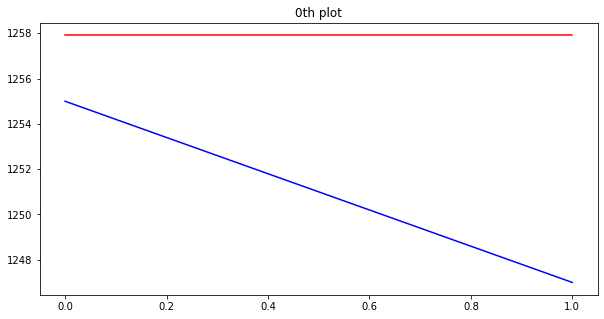

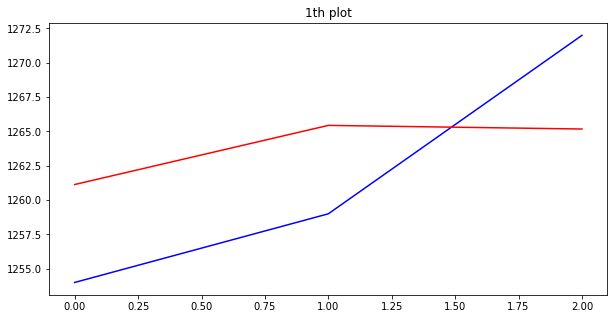

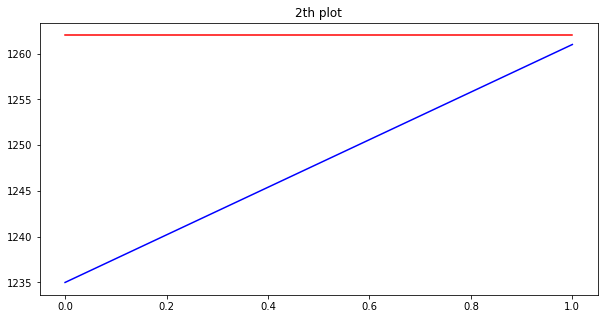

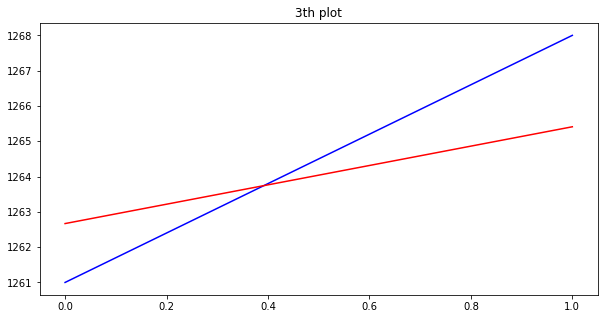

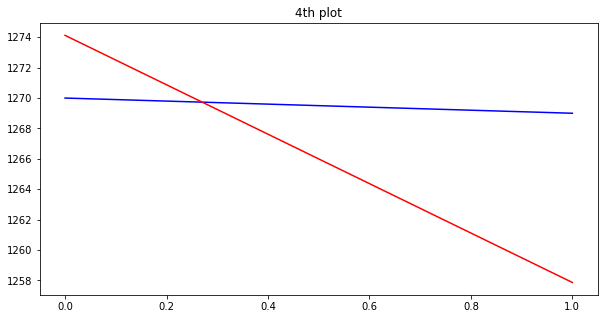

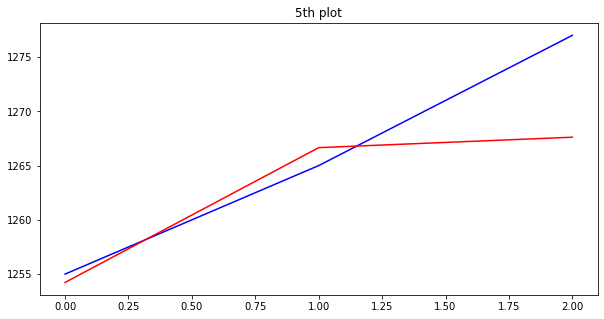

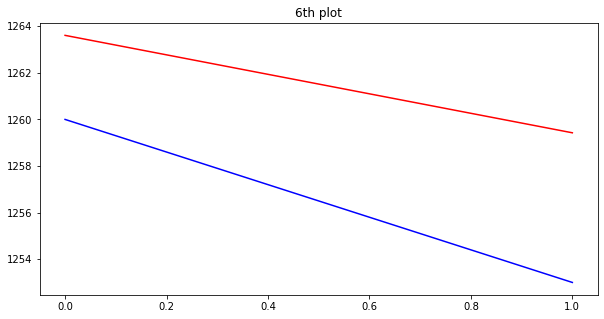

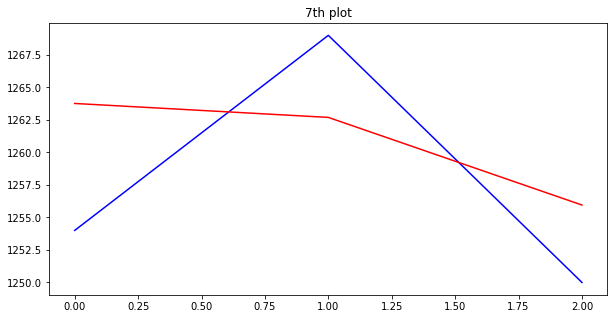

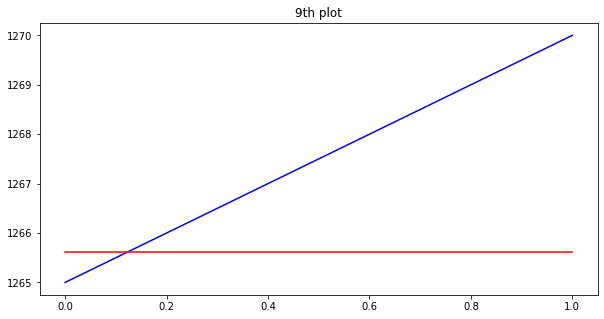

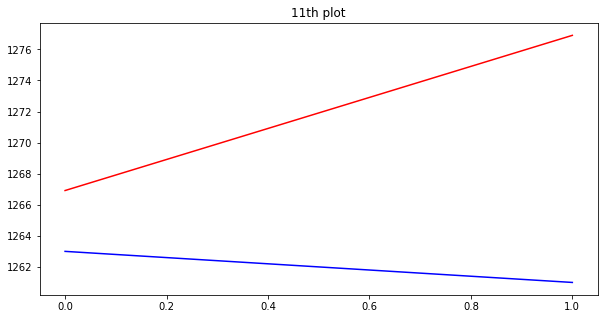

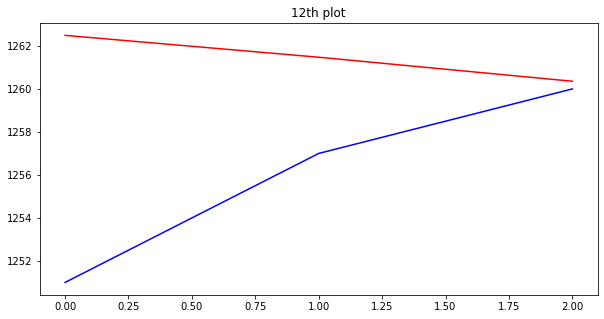

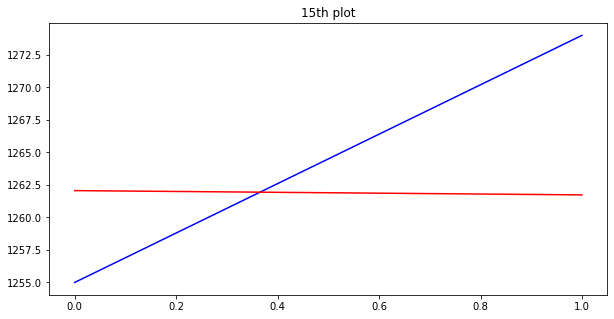

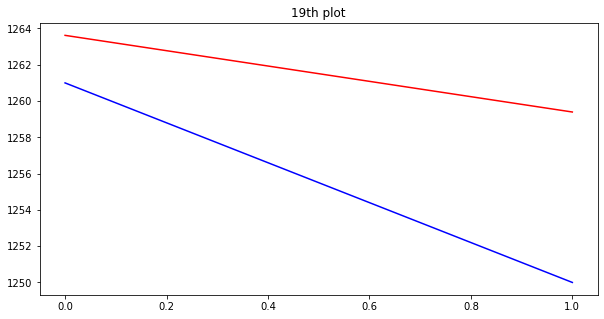

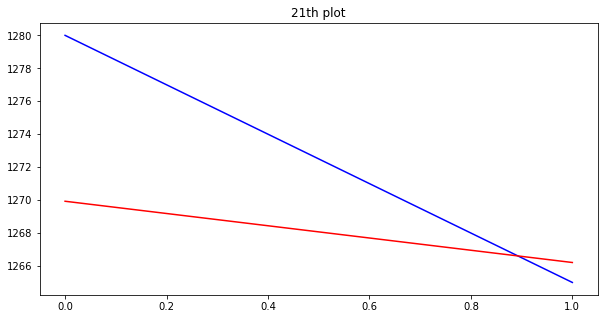

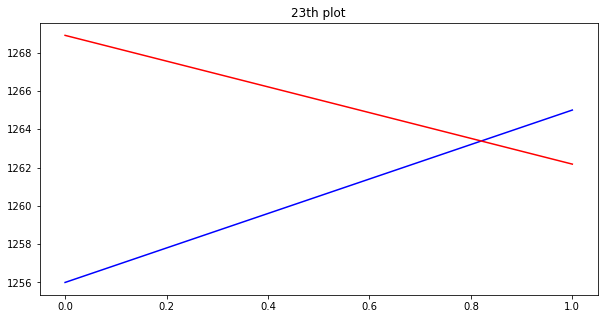

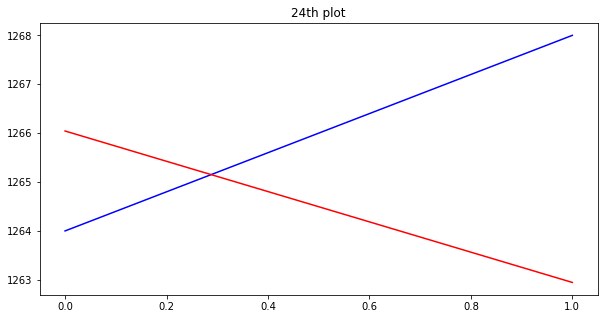

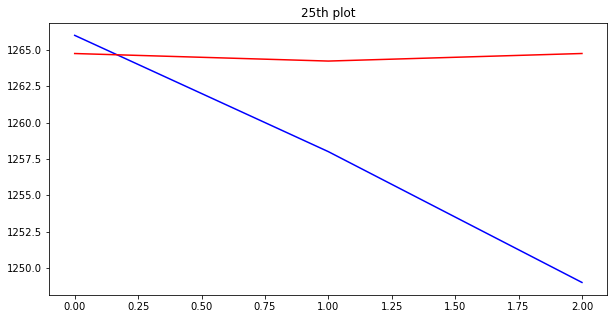

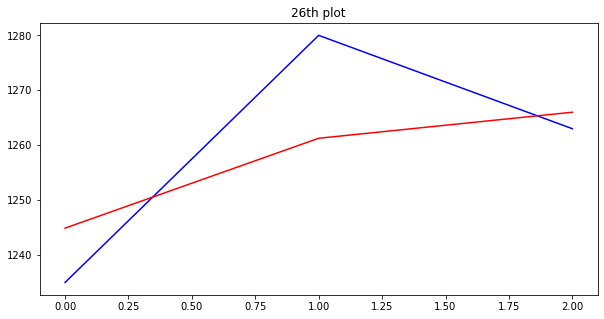

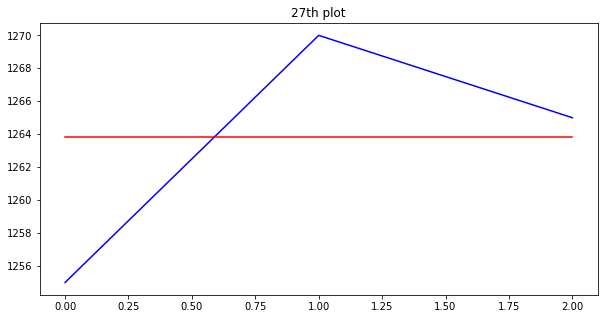

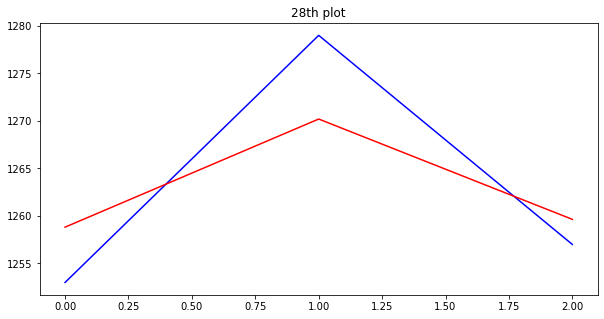

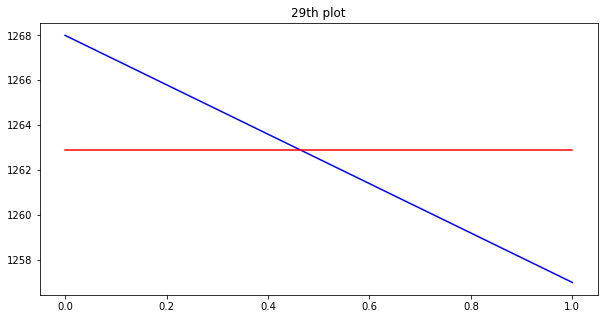

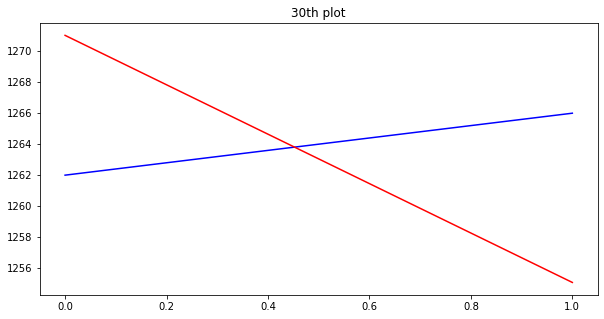

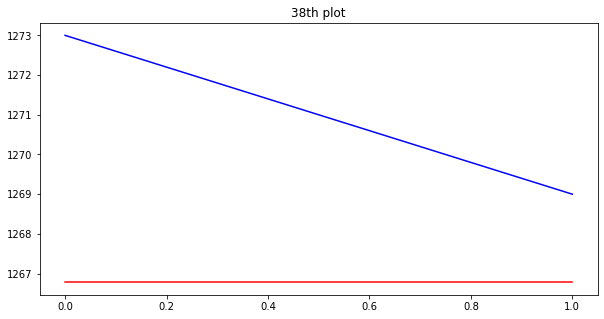

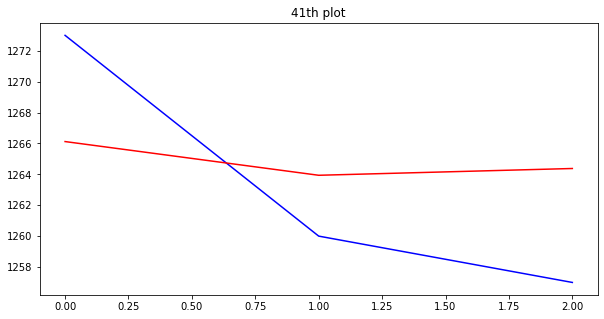

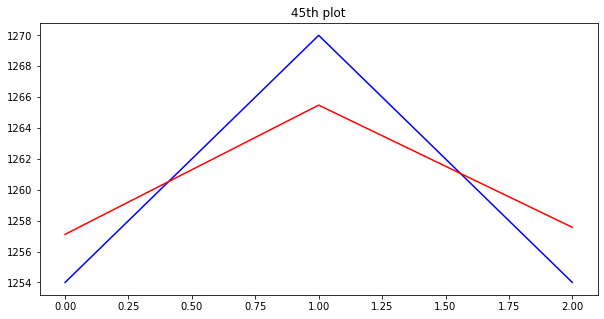

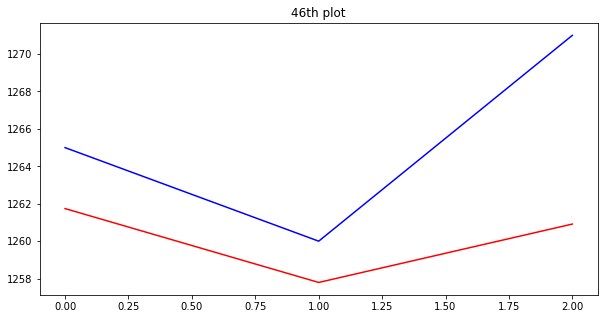

In [43]:
for module_num in range(47):
    model = ElasticNet(**en_best_params[module_num])
    f = num_features_lst[module_num]
    X = df_trains[module_num][f]
    y = df_trains[module_num]['y']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=0)
    model.fit(X_train, y_train)
    en_pred = model.predict(X_test)
    plt.figure(figsize=(10,5))
    plt.title(f'{module_num}th plot')
    plt.plot(np.array(y_test), c='b')
    plt.plot(en_pred, c='r')

In [81]:
needed_backprocess

[2,
 4,
 8,
 9,
 10,
 11,
 13,
 15,
 17,
 20,
 26,
 27,
 28,
 29,
 30,
 33,
 34,
 36,
 38,
 43,
 44]

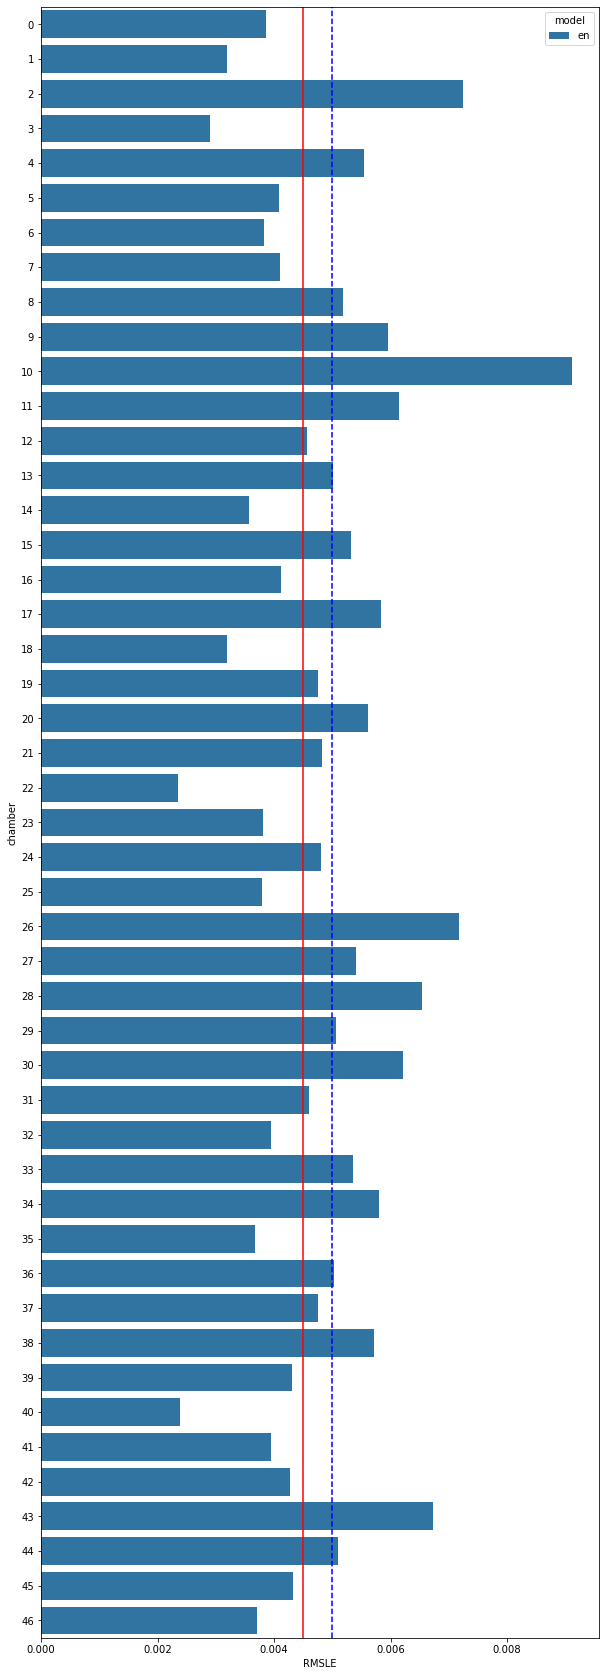

In [82]:
score_df = pd.DataFrame({'model':['en']*47,
                         'chamber': list(range(0,47))*1,
                         'RMSLE' : en_scores})

fig = plt.figure(figsize = (10, 30))
sns.barplot(data = score_df, orient = 'h', x = 'RMSLE', y = 'chamber', hue = 'model')
plt.axvline(0.005, color='b', linestyle='--')
plt.axvline(0.0045, color='r')

In [205]:
score_df.pivot('chamber', 'model', 'RMSLE')

model          en       lgb
chamber                    
0        0.003853  0.003853
1        0.003191  0.003588
2        0.007248  0.007248
3        0.002899  0.003542
4        0.005539  0.006775
5        0.004093  0.004638
6        0.003835  0.003835
7        0.004110  0.004110
8        0.005177  0.005177
9        0.005963  0.005963
10       0.005703  0.009119
11       0.006150  0.006150
12       0.004561  0.005965
13       0.005010  0.005010
14       0.003568  0.003568
15       0.005323  0.005323
16       0.004122  0.004755
17       0.005828  0.005928
18       0.003185  0.003185
19       0.004755  0.004755
20       0.005613  0.005613
21       0.004831  0.004831
22       0.002348  0.002348
23       0.003812  0.003812
24       0.004799  0.005489
25       0.003798  0.003798
26       0.007193  0.009234
27       0.005405  0.005405
28       0.006539  0.006539
29       0.005060  0.005060
30       0.006212  0.006212
31       0.004601  0.005510
32       0.003950  0.006122
33       0.005357  0.005357
34       0.005808  0.005808
35       0.003670  0.003670
36       0.005027  0.005182
37       0.004746  0.005028
38       0.005718  0.005718
39       0.004315  0.005164
40       0.002389  0.002408
41       0.003956  0.003956
42       0.004272  0.004272
43       0.006732  0.007099
44       0.005093  0.005093
45       0.004331  0.005779
46       0.003714  0.003714

In [206]:
# (건물 별 모델 cv score 의 pivot_q quantile 값*threshold) 보다 작은 cv score를 가진 모델만 건물별로 선택
def good_models(score_df, pivot_q, threshold):
    score_pivot = pd.DataFrame(score_df.pivot('chamber', 'model', 'RMSLE').values,
                               columns = ['en','lgb'])
    li = []
    for i in range(len(score_pivot)):
        temp = score_pivot.iloc[i]
        q = temp.quantile(pivot_q)
        best = list(temp[temp <= threshold*q].index)
        li.append(best)
    return li

In [207]:
bests = good_models(score_df, 0.1, 1.05)
bests

[['en', 'lgb'],
 ['en'],
 ['en', 'lgb'],
 ['en'],
 ['en'],
 ['en'],
 ['en', 'lgb'],
 ['en', 'lgb'],
 ['en', 'lgb'],
 ['en', 'lgb'],
 ['en'],
 ['en', 'lgb'],
 ['en'],
 ['en', 'lgb'],
 ['en', 'lgb'],
 ['en', 'lgb'],
 ['en'],
 ['en', 'lgb'],
 ['en', 'lgb'],
 ['en', 'lgb'],
 ['en', 'lgb'],
 ['en', 'lgb'],
 ['en', 'lgb'],
 ['en', 'lgb'],
 ['en'],
 ['en', 'lgb'],
 ['en'],
 ['en', 'lgb'],
 ['en', 'lgb'],
 ['en', 'lgb'],
 ['en', 'lgb'],
 ['en'],
 ['en'],
 ['en', 'lgb'],
 ['en', 'lgb'],
 ['en', 'lgb'],
 ['en', 'lgb'],
 ['en'],
 ['en', 'lgb'],
 ['en'],
 ['en', 'lgb'],
 ['en', 'lgb'],
 ['en', 'lgb'],
 ['en', 'lgb'],
 ['en', 'lgb'],
 ['en'],
 ['en', 'lgb']]

In [55]:
# voting ensemble training & inference
voting_pred = []
for i, (X_test, num_f, e) in enumerate(zip(df_predicts, num_features_lst, ens)):
    pred = []
    en = e
    pred.append(en.predict(X_test[num_f]))

    voting_pred.append(np.expm1(np.array(pred).mean(axis = 0)))

    print (f'model{i+1} prediction complete')
voting_pred = np.concatenate(voting_pred)

KeyError: "['04_efem_para2_shift', '04_efem_para25_shift', '04_gas_para51_shift', '04_hv_para45_shift', '04_hv_para47_shift', '04_power_para76_shift', '04_temp_para20_shift', '04_temp_para54_shift', '04_temp_para60_shift', '04_time_para16_shift', '04_time_para29_shift', '04_time_para37_shift', '06_efem_para2_shift', '06_efem_para25_shift', '06_epd_para4_shift', '06_epd_para40_shift', '06_power_para49_shift', '06_power_para57_shift', '06_power_para76_shift', '06_temp_para20_shift', '06_temp_para38_shift', '06_temp_para54_shift', '06_temp_para60_shift', '06_temp_para86_shift', '06_temp_para87_shift', '06_time_para16_shift', '06_time_para29_shift', '06_time_para37_shift', '12_efem_para2_shift', '12_efem_para25_shift', '12_he_para22_shift', '12_he_para88_shift', '12_hv_para45_shift', '12_hv_para47_shift', '12_power_para14_shift', '12_power_para76_shift', '12_temp_para20_shift', '12_temp_para24_shift', '12_temp_para38_shift', '12_temp_para60_shift', '12_time_para16_shift', '12_time_para29_shift', '12_time_para37_shift', '12_time_para5_shift', '13_efem_para2_shift', '13_efem_para25_shift', '13_he_para22_shift', '13_he_para88_shift', '13_hv_para45_shift', '13_hv_para47_shift', '13_power_para14_shift', '13_power_para76_shift', '13_temp_para20_shift', '13_temp_para24_shift', '13_temp_para38_shift', '13_temp_para60_shift', '13_time_para16_shift', '13_time_para29_shift', '13_time_para37_shift', '13_time_para5_shift', '17_efem_para2_shift', '17_efem_para25_shift', '17_he_para22_shift', '17_he_para88_shift', '17_hv_para45_shift', '17_hv_para47_shift', '17_position_para72_shift', '17_power_para14_shift', '17_power_para76_shift', '17_temp_para20_shift', '17_temp_para24_shift', '17_temp_para38_shift', '17_temp_para60_shift', '17_time_para16_shift', '17_time_para29_shift', '17_time_para37_shift', '17_time_para5_shift', '18_efem_para2_shift', '18_efem_para25_shift', '18_he_para22_shift', '18_he_para88_shift', '18_hv_para45_shift', '18_hv_para47_shift', '18_power_para14_shift', '18_power_para76_shift', '18_power_para82_shift', '18_temp_para20_shift', '18_temp_para24_shift', '18_temp_para38_shift', '18_temp_para60_shift', '18_time_para16_shift', '18_time_para29_shift', '18_time_para37_shift', '18_time_para5_shift', '18_tmp_para31_shift', '20_efem_para2_shift', '20_efem_para25_shift', '20_gas_para39_shift', '20_he_para22_shift', '20_he_para88_shift', '20_power_para14_shift', '20_power_para76_shift', '20_temp_para20_shift', '20_temp_para24_shift', '20_temp_para60_shift', '20_time_para16_shift', '20_time_para29_shift', '20_time_para37_shift', '20_time_para5_shift', 'gen_tmdiff_shift', 'gen_tmdiff_0406_shift', 'gen_tmdiff_0612_shift', 'gen_tmdiff_1317_shift', 'gen_tmdiff_1820_shift'] not in index"

In [209]:
df_predict['msure_val'] = voting_pred
df_submission = df_predict[['key_val','msure_val']]
# 예측 파일을 저장합니다. 
# 제출용 파일 이름은 cds_submission_팀명_차수.csv 형태로 제출합니다.
df_submission.set_index('key_val', inplace=True)
df_submission.to_csv('cds_submission_데이터조무사_35.csv')

In [210]:
df_submission.head()

msure_val
key_val               
LOT380_17  1256.834117
LOT122_18  1256.834117
LOT313_18  1256.834117
LOT459_12  1256.834117
LOT459_18  1256.834117

In [196]:
np.where(voting_pred<=1200)

(array([60, 61, 62, 63], dtype=int64),)

In [200]:
df_final[df_final['module_name']==10]

module_name    key_val           end_dt_tm       y  04_efem_para2  \
128          10  LOT466_18 2021-10-03 12:14:14  1256.0         1546.0   
129          10  LOT316_19 2021-10-04 19:10:43  1257.0         1545.0   
130          10  LOT106_19 2021-10-06 02:21:39  1260.0         1544.0   
131          10   LOT34_20 2021-10-07 04:49:38  1258.0         1546.0   
132          10   LOT18_19 2021-10-09 00:40:08  1263.0         1545.0   
133          10   LOT69_10 2021-10-08 18:47:45  1264.0         1546.0   
134          10   LOT17_24 2021-10-12 03:18:07  1288.0         1545.0   
135          10  LOT373_19 2021-10-11 20:43:32  1284.0         1545.0   
136          10  LOT258_18 2021-10-16 05:48:49  1275.0         1546.0   
137          10   LOT78_19 2021-10-17 19:10:13  1278.0         1543.0   
138          10  LOT245_12 2021-10-19 15:28:33  1245.0         1543.0   
139          10   LOT99_17 2021-10-23 07:09:27  1272.0         1549.0   

     04_efem_para25  04_efem_para78  04_esc_para94  04_fr_para61  \
128          1556.0             4.0            0.0           0.0   
129          1555.0             4.0            0.0           0.0   
130          1554.0             4.0            0.0           0.0   
131          1555.0             4.0            0.0           0.0   
132          1555.0             4.0            0.0           0.0   
133          1555.0             4.0            0.0           0.0   
134          1555.0             4.0            0.0           0.0   
135          1555.0             4.0            0.0           0.0   
136          1556.0             4.0            0.0           0.0   
137          1553.0             4.0            0.0           0.0   
138          1554.0             4.0            0.0           0.0   
139          1558.0             4.0            0.0           0.0   

     04_gas_para21  04_gas_para33  04_gas_para36  04_gas_para51  04_gas_para6  \
128            2.0            0.0            2.0           11.0           3.0   
129            2.0            0.0            2.0           11.0           3.0   
130            2.0           -0.0            2.0           11.0           3.0   
131            2.0           -0.0            2.0           11.0           3.0   
132            2.0            0.0            2.0           11.0           3.0   
133            2.0           -0.0            2.0           11.0           3.0   
134            2.0           -0.0            2.0           11.0           3.0   
135            2.0            0.0            2.0           11.0           3.0   
136            2.0           -0.0            2.0           11.0           3.0   
137            2.0           -0.0            2.0           12.0           3.0   
138            2.0           -0.0            2.0           12.0           3.0   
139            2.0           -0.0            2.0           12.0           3.0   

     04_he_para22  04_he_para88  04_hv_para45  04_hv_para47  \
128           1.0           1.0         300.0         150.0   
129           1.0           1.0         300.0         150.0   
130           1.0           1.0         300.0         150.0   
131           1.0           1.0         300.0         150.0   
132           1.0           1.0         300.0         150.0   
133           1.0           1.0         300.0         150.0   
134           1.0           1.0         300.0         150.0   
135           1.0           1.0         300.0         150.0   
136           1.0           1.0         300.0         150.0   
137           1.0           1.0         300.0         150.0   
138           1.0           1.0         300.0         150.0   
139           1.0           1.0         300.0         150.0   

     04_position_para72  04_power_para76  04_temp_para12  04_temp_para17  \
128                 7.0           1064.0            24.0             0.0   
129                 7.0           1064.0            24.0             0.0   
130                 7.0           1065.0            24.0           

In [198]:
df_predict.iloc[np.where(voting_pred<=1200)]

module_name    key_val  04_efem_para2  04_efem_para25  04_efem_para78  \
60          10  LOT174_18         1546.0          1556.0             4.0   
61          10  LOT435_18         1546.0          1556.0             4.0   
62          10  LOT172_19         1548.0          1558.0             4.0   
63          10  LOT417_21         1547.0          1557.0             4.0   

    04_esc_para94  04_fr_para61  04_gas_para21  04_gas_para33  04_gas_para36  \
60            0.0           0.0            2.0           -0.0            2.0   
61            0.0           0.0            2.0           -0.0            2.0   
62            0.0           0.0            2.0           -0.0            2.0   
63            0.0           0.0            2.0           -0.0            2.0   

    04_gas_para51  04_gas_para6  04_he_para22  04_he_para88  04_hv_para45  \
60            8.0           3.0           1.0           1.0           0.0   
61            8.0           3.0           1.0           1.0           0.0   
62            8.0           3.0           1.0           1.0           0.0   
63            9.0           3.0           1.0           1.0           0.0   

    04_hv_para47  04_position_para72  04_power_para76  04_temp_para12  \
60           0.0                 7.0           1092.0            24.0   
61           0.0                 7.0           1092.0            24.0   
62           0.0                 7.0           1091.0            24.0   
63           0.0                 7.0           1091.0            24.0   

    04_temp_para17  04_temp_para18  04_temp_para20  04_temp_para38  \
60            -0.0            15.0            27.0           -16.0   
61            -0.0            15.0            27.0           -16.0   
62             0.0            15.0            27.0           -16.0   
63             0.0            15.0            27.0           -17.0   

    04_temp_para54  04_temp_para58  04_temp_para60  04_temp_para65  \
60            46.0            25.0            46.0            22.0   
61            46.0            25.0            46.0            22.0   
62            45.0            25.0            46.0            22.0   
63            44.0            24.0            47.0            22.0   

    04_temp_para66  04_temp_para79  04_temp_para86  04_temp_para87  \
60            90.0             1.0            21.0           150.0   
61            90.0             1.0            21.0           150.0   
62            90.0             1.0            21.0           150.0   
63            90.0             1.0            21.0           150.0   

    04_time_para16  04_time_para29  04_time_para30  04_time_para34  \
60          1598.0           101.0           101.0           186.0   
61          1598.0           101.0           101.0           186.0   
62          1614.0           118.0           118.0           202.0   
63          1632.0           136.0           136.0           220.0   

    04_time_para37  04_time_para41  04_time_para42  04_time_para43  \
60           101.0           101.0          1598.0          1598.0   
61           101.0           101.0          1598.0          1598.0   
62           118.0           118.0          1614.0          1614.0   
63           136.0           136.0          1632.0          1632.0   

    04_time_para44  04_time_para62  04_time_para64  04_time_para67  \
60          1598.0          1598.0           101.0          1598.0   
61          1598.0          1598.0           101.0          1598.0   
62          1614.0          1614.0           118.0          1614.0   
63          1632.0          1632.0           136.0          1632.0   

    04_time_para7  04_time_para75  04_time_para77  04_time_para8  \
60          186.0          1598.0          2605.0          101.0   
61          186.0          1598.0          2605.0          101.0   
62          202.0          1614.0          2621.0          118.0   
63          220.0          1632.0          2639.0          136.0   

    04_time_para81  04

In [57]:
# save
with open('ens.p', 'wb') as f:
    pickle.dump(ens, f)
    
with open('en_scores.p', 'wb') as f:
    pickle.dump(en_scores, f)

# Lasso

In [25]:
from sklearn.linear_model import Lasso

In [26]:
lss = []
ls_scores = []
for i, (train, num_f) in enumerate(zip(df_trains, num_features_lst)):
    def objective_LS(trial):
        param = {
          "random_state":42,
            'alpha':trial.suggest_float("alpha",0.1,20),
            'fit_intercept':trial.suggest_categorical('fit_intercept', [True, False]),
            'normalize':trial.suggest_categorical('normalize', [True, False]),
        }
        X = train[num_f]
        y = np.log1p(train['y'])

        model = Lasso(**param)
        loo = LeaveOneOut()
        scores = cross_val_score(model, X, y, cv=loo, scoring='neg_mean_squared_error')
        scores = np.sqrt(-scores)
        print(f'CV scores for {i}: {scores}')
        print('Mean score : ', np.mean(scores))
        rmsle_val = np.mean(scores)

        return rmsle_val
    
    sampler = TPESampler(seed=42)
    study_ls = optuna.create_study(
            study_name="ls_parameter_opt",
            direction="minimize",
            sampler=sampler,
            )
    study_ls.optimize(objective_LS, n_trials=30)
    print("Best Score:", study_ls.best_value)
    print("Best trial:", study_ls.best_trial.params)
    ls_scores.append(study_ls.best_value)
    
    model = ElasticNet(**study_ls.best_params)
    model.fit(train[num_f], np.log1p(train['y']))
    print('{} model training is completed'.format(i))
    lss.append(model)


[I 2022-07-22 13:16:35,502] A new study created in memory with name: ls_parameter_opt
[I 2022-07-22 13:16:35,598] Trial 0 finished with value: 0.003925820059751326 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.003925820059751326.
[I 2022-07-22 13:16:35,790] Trial 1 finished with value: 0.005678456886836641 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.003925820059751326.


CV scores for 0: [0.00283549 0.00301119 0.00712215 0.00296764 0.00022359 0.00257647
 0.00113656 0.00355607 0.00090952 0.00784607 0.00815905 0.00883075
 0.00186112]
Mean score :  0.003925820059751326
CV scores for 0: [0.0033092  0.00368486 0.01602938 0.00569016 0.00295205 0.00179889
 0.00600264 0.00304058 0.00508497 0.01336875 0.0111252  0.00090414
 0.00082911]
Mean score :  0.005678456886836641


[I 2022-07-22 13:16:35,888] Trial 2 finished with value: 0.003925820059751326 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.003925820059751326.


CV scores for 0: [0.00283549 0.00301119 0.00712215 0.00296764 0.00022359 0.00257647
 0.00113656 0.00355607 0.00090952 0.00784607 0.00815905 0.00883075
 0.00186112]
Mean score :  0.003925820059751326


[I 2022-07-22 13:16:36,081] Trial 3 finished with value: 0.005621531497505627 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.003925820059751326.
[I 2022-07-22 13:16:36,278] Trial 4 finished with value: 0.01117311531567077 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.003925820059751326.


CV scores for 0: [3.93341153e-03 2.55371305e-03 1.67127367e-02 5.03605342e-03
 2.89692676e-03 1.48212636e-03 5.84759217e-03 2.77600047e-03
 5.51047709e-03 1.38988712e-02 1.18538432e-02 5.76947892e-04
 1.20962518e-06]
Mean score :  0.005621531497505627
CV scores for 0: [0.01342623 0.01506021 0.02713592 0.00516606 0.002023   0.00347913
 0.00341981 0.00135155 0.01211982 0.02198375 0.02294928 0.00436515
 0.01277058]
Mean score :  0.01117311531567077


[I 2022-07-22 13:16:36,472] Trial 5 finished with value: 0.014728882134545844 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.003925820059751326.
[I 2022-07-22 13:16:36,567] Trial 6 finished with value: 0.003925820059751326 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.003925820059751326.


CV scores for 0: [0.01902285 0.02064799 0.03286499 0.0086833  0.00265192 0.00409594
 0.00392045 0.00294346 0.01567163 0.02629603 0.02786356 0.00861514
 0.01819822]
Mean score :  0.014728882134545844
CV scores for 0: [0.00283549 0.00301119 0.00712215 0.00296764 0.00022359 0.00257647
 0.00113656 0.00355607 0.00090952 0.00784607 0.00815905 0.00883075
 0.00186112]
Mean score :  0.003925820059751326


[I 2022-07-22 13:16:36,693] Trial 7 finished with value: 0.003925820059751326 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.003925820059751326.
[I 2022-07-22 13:16:36,796] Trial 8 finished with value: 0.003925820059751326 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.003925820059751326.


CV scores for 0: [0.00283549 0.00301119 0.00712215 0.00296764 0.00022359 0.00257647
 0.00113656 0.00355607 0.00090952 0.00784607 0.00815905 0.00883075
 0.00186112]
Mean score :  0.003925820059751326
CV scores for 0: [0.00283549 0.00301119 0.00712215 0.00296764 0.00022359 0.00257647
 0.00113656 0.00355607 0.00090952 0.00784607 0.00815905 0.00883075
 0.00186112]
Mean score :  0.003925820059751326


[I 2022-07-22 13:16:36,991] Trial 9 finished with value: 0.012076840687796105 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.003925820059751326.
[I 2022-07-22 13:16:37,092] Trial 10 finished with value: 0.003925820059751326 and parameters: {'alpha': 7.552084938387593, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.003925820059751326.


CV scores for 0: [0.01467452 0.01694188 0.02835027 0.00627799 0.00200904 0.0040197
 0.00339932 0.00177034 0.01298437 0.02297092 0.02428982 0.00507271
 0.01423804]
Mean score :  0.012076840687796105
CV scores for 0: [0.00283549 0.00301119 0.00712215 0.00296764 0.00022359 0.00257647
 0.00113656 0.00355607 0.00090952 0.00784607 0.00815905 0.00883075
 0.00186112]
Mean score :  0.003925820059751326


[I 2022-07-22 13:16:37,195] Trial 11 finished with value: 0.003925820059751326 and parameters: {'alpha': 7.213523305800771, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.003925820059751326.
[I 2022-07-22 13:16:37,297] Trial 12 finished with value: 0.003925820059751326 and parameters: {'alpha': 0.4103365132032799, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.003925820059751326.
[I 2022-07-22 13:16:37,396] Trial 13 finished with value: 0.003925820059751326 and parameters: {'alpha': 19.353217136172454, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.003925820059751326.


CV scores for 0: [0.00283549 0.00301119 0.00712215 0.00296764 0.00022359 0.00257647
 0.00113656 0.00355607 0.00090952 0.00784607 0.00815905 0.00883075
 0.00186112]
Mean score :  0.003925820059751326
CV scores for 0: [0.00283549 0.00301119 0.00712215 0.00296764 0.00022359 0.00257647
 0.00113656 0.00355607 0.00090952 0.00784607 0.00815905 0.00883075
 0.00186112]
Mean score :  0.003925820059751326
CV scores for 0: [0.00283549 0.00301119 0.00712215 0.00296764 0.00022359 0.00257647
 0.00113656 0.00355607 0.00090952 0.00784607 0.00815905 0.00883075
 0.00186112]
Mean score :  0.003925820059751326


[I 2022-07-22 13:16:37,496] Trial 14 finished with value: 0.003925820059751326 and parameters: {'alpha': 6.622739840288364, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.003925820059751326.
[I 2022-07-22 13:16:37,595] Trial 15 finished with value: 0.003925820059751326 and parameters: {'alpha': 9.525369758141984, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.003925820059751326.


CV scores for 0: [0.00283549 0.00301119 0.00712215 0.00296764 0.00022359 0.00257647
 0.00113656 0.00355607 0.00090952 0.00784607 0.00815905 0.00883075
 0.00186112]
Mean score :  0.003925820059751326
CV scores for 0: [0.00283549 0.00301119 0.00712215 0.00296764 0.00022359 0.00257647
 0.00113656 0.00355607 0.00090952 0.00784607 0.00815905 0.00883075
 0.00186112]
Mean score :  0.003925820059751326


[I 2022-07-22 13:16:37,694] Trial 16 finished with value: 0.003925820059751326 and parameters: {'alpha': 0.34397895185110916, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.003925820059751326.
[I 2022-07-22 13:16:37,795] Trial 17 finished with value: 0.003925820059751326 and parameters: {'alpha': 6.503166834245272, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.003925820059751326.


CV scores for 0: [0.00283549 0.00301119 0.00712215 0.00296764 0.00022359 0.00257647
 0.00113656 0.00355607 0.00090952 0.00784607 0.00815905 0.00883075
 0.00186112]
Mean score :  0.003925820059751326
CV scores for 0: [0.00283549 0.00301119 0.00712215 0.00296764 0.00022359 0.00257647
 0.00113656 0.00355607 0.00090952 0.00784607 0.00815905 0.00883075
 0.00186112]
Mean score :  0.003925820059751326


[I 2022-07-22 13:16:37,896] Trial 18 finished with value: 0.003925820059751326 and parameters: {'alpha': 9.369910291236636, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.003925820059751326.
[I 2022-07-22 13:16:38,004] Trial 19 finished with value: 0.003925820059751326 and parameters: {'alpha': 4.777029204034456, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.003925820059751326.


CV scores for 0: [0.00283549 0.00301119 0.00712215 0.00296764 0.00022359 0.00257647
 0.00113656 0.00355607 0.00090952 0.00784607 0.00815905 0.00883075
 0.00186112]
Mean score :  0.003925820059751326
CV scores for 0: [0.00283549 0.00301119 0.00712215 0.00296764 0.00022359 0.00257647
 0.00113656 0.00355607 0.00090952 0.00784607 0.00815905 0.00883075
 0.00186112]
Mean score :  0.003925820059751326


[I 2022-07-22 13:16:38,112] Trial 20 finished with value: 0.003925820059751326 and parameters: {'alpha': 5.600135556759093, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.003925820059751326.
[I 2022-07-22 13:16:38,214] Trial 21 finished with value: 0.003925820059751326 and parameters: {'alpha': 9.321669978165565, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.003925820059751326.
[I 2022-07-22 13:16:38,315] Trial 22 finished with value: 0.003925820059751326 and parameters: {'alpha': 4.416939726498438, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.003925820059751326.


CV scores for 0: [0.00283549 0.00301119 0.00712215 0.00296764 0.00022359 0.00257647
 0.00113656 0.00355607 0.00090952 0.00784607 0.00815905 0.00883075
 0.00186112]
Mean score :  0.003925820059751326
CV scores for 0: [0.00283549 0.00301119 0.00712215 0.00296764 0.00022359 0.00257647
 0.00113656 0.00355607 0.00090952 0.00784607 0.00815905 0.00883075
 0.00186112]
Mean score :  0.003925820059751326
CV scores for 0: [0.00283549 0.00301119 0.00712215 0.00296764 0.00022359 0.00257647
 0.00113656 0.00355607 0.00090952 0.00784607 0.00815905 0.00883075
 0.00186112]
Mean score :  0.003925820059751326


[I 2022-07-22 13:16:38,417] Trial 23 finished with value: 0.003925820059751326 and parameters: {'alpha': 5.216483677817611, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.003925820059751326.
[I 2022-07-22 13:16:38,517] Trial 24 finished with value: 0.003925820059751326 and parameters: {'alpha': 8.943816632847193, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.003925820059751326.


CV scores for 0: [0.00283549 0.00301119 0.00712215 0.00296764 0.00022359 0.00257647
 0.00113656 0.00355607 0.00090952 0.00784607 0.00815905 0.00883075
 0.00186112]
Mean score :  0.003925820059751326
CV scores for 0: [0.00283549 0.00301119 0.00712215 0.00296764 0.00022359 0.00257647
 0.00113656 0.00355607 0.00090952 0.00784607 0.00815905 0.00883075
 0.00186112]
Mean score :  0.003925820059751326


[I 2022-07-22 13:16:38,621] Trial 25 finished with value: 0.003925820059751326 and parameters: {'alpha': 10.844481545677127, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.003925820059751326.


CV scores for 0: [0.00283549 0.00301119 0.00712215 0.00296764 0.00022359 0.00257647
 0.00113656 0.00355607 0.00090952 0.00784607 0.00815905 0.00883075
 0.00186112]
Mean score :  0.003925820059751326


[I 2022-07-22 13:16:38,822] Trial 26 finished with value: 0.00575121374743185 and parameters: {'alpha': 4.734714524132634, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.003925820059751326.
[I 2022-07-22 13:16:38,922] Trial 27 finished with value: 0.003925820059751326 and parameters: {'alpha': 8.362565251883552, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.003925820059751326.


CV scores for 0: [5.06066375e-03 5.11065134e-04 1.79467444e-02 3.85487759e-03
 2.79740100e-03 9.10130616e-04 5.56762178e-03 2.29822099e-03
 6.27883024e-03 1.48561348e-02 1.31695874e-02 1.39388583e-05
 1.50056222e-03]
Mean score :  0.00575121374743185
CV scores for 0: [0.00283549 0.00301119 0.00712215 0.00296764 0.00022359 0.00257647
 0.00113656 0.00355607 0.00090952 0.00784607 0.00815905 0.00883075
 0.00186112]
Mean score :  0.003925820059751326


[I 2022-07-22 13:16:39,021] Trial 28 finished with value: 0.003925820059751326 and parameters: {'alpha': 11.09788365414248, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.003925820059751326.
[I 2022-07-22 13:16:39,217] Trial 29 finished with value: 0.01338218030140089 and parameters: {'alpha': 14.447210270334928, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.003925820059751326.


CV scores for 0: [0.00283549 0.00301119 0.00712215 0.00296764 0.00022359 0.00257647
 0.00113656 0.00355607 0.00090952 0.00784607 0.00815905 0.00883075
 0.00186112]
Mean score :  0.003925820059751326
CV scores for 0: [0.01681372 0.01879063 0.0305564  0.0074678  0.00233084 0.00404536
 0.00365463 0.00234178 0.01429693 0.0246047  0.02605399 0.00681426
 0.01619729]
Mean score :  0.01338218030140089


[I 2022-07-22 13:16:39,225] A new study created in memory with name: ls_parameter_opt
[I 2022-07-22 13:16:39,347] Trial 0 finished with value: 0.003532016610213018 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.003532016610213018.


Best Score: 0.003925820059751326
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
0 model training is completed
CV scores for 1: [0.00143398 0.0078302  0.00267378 0.00165649 0.00857065 0.00651216
 0.00300442 0.001312   0.00782243 0.00141058 0.0030722  0.00193164
 0.00032083 0.00216752 0.00534499 0.00144841]
Mean score :  0.003532016610213018


[I 2022-07-22 13:16:39,604] Trial 1 finished with value: 0.012543014186982504 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.003532016610213018.
[I 2022-07-22 13:16:39,723] Trial 2 finished with value: 0.003532016610213018 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.003532016610213018.


CV scores for 1: [0.01529835 0.012806   0.00690064 0.00448565 0.01592869 0.02394497
 0.00754871 0.01161124 0.0124877  0.00059803 0.00174357 0.00880245
 0.02213615 0.01295985 0.01266403 0.03077219]
Mean score :  0.012543014186982504
CV scores for 1: [0.00143398 0.0078302  0.00267378 0.00165649 0.00857065 0.00651216
 0.00300442 0.001312   0.00782243 0.00141058 0.0030722  0.00193164
 0.00032083 0.00216752 0.00534499 0.00144841]
Mean score :  0.003532016610213018


[I 2022-07-22 13:16:39,981] Trial 3 finished with value: 0.014441171831200472 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.003532016610213018.


CV scores for 1: [0.0188143  0.01466835 0.00799404 0.00362791 0.01737961 0.02789978
 0.01046927 0.01424776 0.01453226 0.00024386 0.00220016 0.00752455
 0.02427418 0.01580302 0.01624777 0.03513193]
Mean score :  0.014441171831200472


[I 2022-07-22 13:16:40,240] Trial 4 finished with value: 0.04764294039319816 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.003532016610213018.


CV scores for 1: [0.07390607 0.0438482  0.02511618 0.0098511  0.04017707 0.08987402
 0.05623688 0.05555717 0.0465703  0.00533053 0.00933805 0.01247172
 0.05777847 0.06034846 0.07242589 0.10345695]
Mean score :  0.04764294039319816


[I 2022-07-22 13:16:40,502] Trial 5 finished with value: 0.02678587321438536 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.003532016610213018.
[I 2022-07-22 13:16:40,624] Trial 6 finished with value: 0.003532016610213018 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.003532016610213018.


CV scores for 1: [0.04564645 0.03095726 0.02088962 0.01292986 0.00646684 0.04793039
 0.02373639 0.02770215 0.0230395  0.00827046 0.01054715 0.00888803
 0.03218302 0.03483845 0.03629351 0.05825489]
Mean score :  0.02678587321438536
CV scores for 1: [0.00143398 0.0078302  0.00267378 0.00165649 0.00857065 0.00651216
 0.00300442 0.001312   0.00782243 0.00141058 0.0030722  0.00193164
 0.00032083 0.00216752 0.00534499 0.00144841]
Mean score :  0.003532016610213018


[I 2022-07-22 13:16:40,747] Trial 7 finished with value: 0.003532016610213018 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.003532016610213018.
[I 2022-07-22 13:16:40,868] Trial 8 finished with value: 0.003532016610213018 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.003532016610213018.


CV scores for 1: [0.00143398 0.0078302  0.00267378 0.00165649 0.00857065 0.00651216
 0.00300442 0.001312   0.00782243 0.00141058 0.0030722  0.00193164
 0.00032083 0.00216752 0.00534499 0.00144841]
Mean score :  0.003532016610213018
CV scores for 1: [0.00143398 0.0078302  0.00267378 0.00165649 0.00857065 0.00651216
 0.00300442 0.001312   0.00782243 0.00141058 0.0030722  0.00193164
 0.00032083 0.00216752 0.00534499 0.00144841]
Mean score :  0.003532016610213018


[I 2022-07-22 13:16:41,134] Trial 9 finished with value: 0.049838331198034824 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.003532016610213018.
[I 2022-07-22 13:16:41,267] Trial 10 finished with value: 0.003532016610213018 and parameters: {'alpha': 7.552084938387593, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.003532016610213018.


CV scores for 1: [0.07759679 0.04592342 0.02635601 0.01016726 0.04093111 0.09392782
 0.05922704 0.05825981 0.04856698 0.00534702 0.01001661 0.01416804
 0.05972638 0.0632959  0.07590227 0.10800084]
Mean score :  0.049838331198034824
CV scores for 1: [0.00143398 0.0078302  0.00267378 0.00165649 0.00857065 0.00651216
 0.00300442 0.001312   0.00782243 0.00141058 0.0030722  0.00193164
 0.00032083 0.00216752 0.00534499 0.00144841]
Mean score :  0.003532016610213018


[I 2022-07-22 13:16:41,392] Trial 11 finished with value: 0.003532016610213018 and parameters: {'alpha': 7.213523305800771, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.003532016610213018.
[I 2022-07-22 13:16:41,521] Trial 12 finished with value: 0.003532016610213018 and parameters: {'alpha': 0.4103365132032799, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.003532016610213018.


CV scores for 1: [0.00143398 0.0078302  0.00267378 0.00165649 0.00857065 0.00651216
 0.00300442 0.001312   0.00782243 0.00141058 0.0030722  0.00193164
 0.00032083 0.00216752 0.00534499 0.00144841]
Mean score :  0.003532016610213018
CV scores for 1: [0.00143398 0.0078302  0.00267378 0.00165649 0.00857065 0.00651216
 0.00300442 0.001312   0.00782243 0.00141058 0.0030722  0.00193164
 0.00032083 0.00216752 0.00534499 0.00144841]
Mean score :  0.003532016610213018


[I 2022-07-22 13:16:41,647] Trial 13 finished with value: 0.003532016610213018 and parameters: {'alpha': 19.353217136172454, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.003532016610213018.
[I 2022-07-22 13:16:41,770] Trial 14 finished with value: 0.003532016610213018 and parameters: {'alpha': 6.622739840288364, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.003532016610213018.


CV scores for 1: [0.00143398 0.0078302  0.00267378 0.00165649 0.00857065 0.00651216
 0.00300442 0.001312   0.00782243 0.00141058 0.0030722  0.00193164
 0.00032083 0.00216752 0.00534499 0.00144841]
Mean score :  0.003532016610213018
CV scores for 1: [0.00143398 0.0078302  0.00267378 0.00165649 0.00857065 0.00651216
 0.00300442 0.001312   0.00782243 0.00141058 0.0030722  0.00193164
 0.00032083 0.00216752 0.00534499 0.00144841]
Mean score :  0.003532016610213018


[I 2022-07-22 13:16:41,892] Trial 15 finished with value: 0.003532016610213018 and parameters: {'alpha': 9.525369758141984, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.003532016610213018.
[I 2022-07-22 13:16:42,013] Trial 16 finished with value: 0.003532016610213018 and parameters: {'alpha': 0.34397895185110916, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.003532016610213018.


CV scores for 1: [0.00143398 0.0078302  0.00267378 0.00165649 0.00857065 0.00651216
 0.00300442 0.001312   0.00782243 0.00141058 0.0030722  0.00193164
 0.00032083 0.00216752 0.00534499 0.00144841]
Mean score :  0.003532016610213018
CV scores for 1: [0.00143398 0.0078302  0.00267378 0.00165649 0.00857065 0.00651216
 0.00300442 0.001312   0.00782243 0.00141058 0.0030722  0.00193164
 0.00032083 0.00216752 0.00534499 0.00144841]
Mean score :  0.003532016610213018


[I 2022-07-22 13:16:42,136] Trial 17 finished with value: 0.003532016610213018 and parameters: {'alpha': 6.503166834245272, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.003532016610213018.
[I 2022-07-22 13:16:42,265] Trial 18 finished with value: 0.003532016610213018 and parameters: {'alpha': 9.369910291236636, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.003532016610213018.


CV scores for 1: [0.00143398 0.0078302  0.00267378 0.00165649 0.00857065 0.00651216
 0.00300442 0.001312   0.00782243 0.00141058 0.0030722  0.00193164
 0.00032083 0.00216752 0.00534499 0.00144841]
Mean score :  0.003532016610213018
CV scores for 1: [0.00143398 0.0078302  0.00267378 0.00165649 0.00857065 0.00651216
 0.00300442 0.001312   0.00782243 0.00141058 0.0030722  0.00193164
 0.00032083 0.00216752 0.00534499 0.00144841]
Mean score :  0.003532016610213018


[I 2022-07-22 13:16:42,396] Trial 19 finished with value: 0.003532016610213018 and parameters: {'alpha': 4.777029204034456, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.003532016610213018.
[I 2022-07-22 13:16:42,518] Trial 20 finished with value: 0.003532016610213018 and parameters: {'alpha': 5.600135556759093, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.003532016610213018.


CV scores for 1: [0.00143398 0.0078302  0.00267378 0.00165649 0.00857065 0.00651216
 0.00300442 0.001312   0.00782243 0.00141058 0.0030722  0.00193164
 0.00032083 0.00216752 0.00534499 0.00144841]
Mean score :  0.003532016610213018
CV scores for 1: [0.00143398 0.0078302  0.00267378 0.00165649 0.00857065 0.00651216
 0.00300442 0.001312   0.00782243 0.00141058 0.0030722  0.00193164
 0.00032083 0.00216752 0.00534499 0.00144841]
Mean score :  0.003532016610213018


[I 2022-07-22 13:16:42,641] Trial 21 finished with value: 0.003532016610213018 and parameters: {'alpha': 9.321669978165565, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.003532016610213018.
[I 2022-07-22 13:16:42,760] Trial 22 finished with value: 0.003532016610213018 and parameters: {'alpha': 4.416939726498438, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.003532016610213018.


CV scores for 1: [0.00143398 0.0078302  0.00267378 0.00165649 0.00857065 0.00651216
 0.00300442 0.001312   0.00782243 0.00141058 0.0030722  0.00193164
 0.00032083 0.00216752 0.00534499 0.00144841]
Mean score :  0.003532016610213018
CV scores for 1: [0.00143398 0.0078302  0.00267378 0.00165649 0.00857065 0.00651216
 0.00300442 0.001312   0.00782243 0.00141058 0.0030722  0.00193164
 0.00032083 0.00216752 0.00534499 0.00144841]
Mean score :  0.003532016610213018


[I 2022-07-22 13:16:42,884] Trial 23 finished with value: 0.003532016610213018 and parameters: {'alpha': 5.216483677817611, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.003532016610213018.
[I 2022-07-22 13:16:43,004] Trial 24 finished with value: 0.003532016610213018 and parameters: {'alpha': 8.943816632847193, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.003532016610213018.


CV scores for 1: [0.00143398 0.0078302  0.00267378 0.00165649 0.00857065 0.00651216
 0.00300442 0.001312   0.00782243 0.00141058 0.0030722  0.00193164
 0.00032083 0.00216752 0.00534499 0.00144841]
Mean score :  0.003532016610213018
CV scores for 1: [0.00143398 0.0078302  0.00267378 0.00165649 0.00857065 0.00651216
 0.00300442 0.001312   0.00782243 0.00141058 0.0030722  0.00193164
 0.00032083 0.00216752 0.00534499 0.00144841]
Mean score :  0.003532016610213018


[I 2022-07-22 13:16:43,126] Trial 25 finished with value: 0.003532016610213018 and parameters: {'alpha': 10.844481545677127, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.003532016610213018.


CV scores for 1: [0.00143398 0.0078302  0.00267378 0.00165649 0.00857065 0.00651216
 0.00300442 0.001312   0.00782243 0.00141058 0.0030722  0.00193164
 0.00032083 0.00216752 0.00534499 0.00144841]
Mean score :  0.003532016610213018


[I 2022-07-22 13:16:43,383] Trial 26 finished with value: 0.017919651479444076 and parameters: {'alpha': 4.734714524132634, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.003532016610213018.
[I 2022-07-22 13:16:43,506] Trial 27 finished with value: 0.003532016610213018 and parameters: {'alpha': 8.362565251883552, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.003532016610213018.


CV scores for 1: [0.0251698  0.01803311 0.00996939 0.00207834 0.02000504 0.03504176
 0.015744   0.01900912 0.01822475 0.00039595 0.00302467 0.00521611
 0.02813513 0.02093877 0.0227231  0.0430054 ]
Mean score :  0.017919651479444076
CV scores for 1: [0.00143398 0.0078302  0.00267378 0.00165649 0.00857065 0.00651216
 0.00300442 0.001312   0.00782243 0.00141058 0.0030722  0.00193164
 0.00032083 0.00216752 0.00534499 0.00144841]
Mean score :  0.003532016610213018


[I 2022-07-22 13:16:43,627] Trial 28 finished with value: 0.003532016610213018 and parameters: {'alpha': 11.09788365414248, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.003532016610213018.


CV scores for 1: [0.00143398 0.0078302  0.00267378 0.00165649 0.00857065 0.00651216
 0.00300442 0.001312   0.00782243 0.00141058 0.0030722  0.00193164
 0.00032083 0.00216752 0.00534499 0.00144841]
Mean score :  0.003532016610213018


[I 2022-07-22 13:16:43,882] Trial 29 finished with value: 0.03742634577208698 and parameters: {'alpha': 14.447210270334928, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.003532016610213018.
[I 2022-07-22 13:16:43,888] A new study created in memory with name: ls_parameter_opt
[I 2022-07-22 13:16:43,976] Trial 0 finished with value: 0.0073420331635244045 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0073420331635244045.


CV scores for 1: [0.06168491 0.03842468 0.02357027 0.00126183 0.02387721 0.07121405
 0.04165447 0.04312285 0.03590714 0.00142169 0.01026342 0.01152226
 0.04603541 0.04916047 0.0562739  0.08342695]
Mean score :  0.03742634577208698
Best Score: 0.003532016610213018
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
1 model training is completed
CV scores for 2: [0.00226444 0.00541659 0.0007913  0.01484488 0.00755525 0.01666095
 0.02144875 0.00455779 0.00287537 0.00594249 0.00415996 0.0015866 ]
Mean score :  0.0073420331635244045


[I 2022-07-22 13:16:44,154] Trial 1 finished with value: 0.01710393037348812 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.0073420331635244045.
[I 2022-07-22 13:16:44,241] Trial 2 finished with value: 0.0073420331635244045 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0073420331635244045.


CV scores for 2: [0.01416183 0.01099598 0.00279075 0.03802601 0.03166697 0.01320322
 0.02911575 0.0156437  0.00467216 0.01630782 0.00890705 0.01975592]
Mean score :  0.01710393037348812
CV scores for 2: [0.00226444 0.00541659 0.0007913  0.01484488 0.00755525 0.01666095
 0.02144875 0.00455779 0.00287537 0.00594249 0.00415996 0.0015866 ]
Mean score :  0.0073420331635244045


[I 2022-07-22 13:16:44,417] Trial 3 finished with value: 0.019033808512251598 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.0073420331635244045.
[I 2022-07-22 13:16:44,594] Trial 4 finished with value: 0.0503477725206416 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.0073420331635244045.


CV scores for 2: [0.0180968  0.01211946 0.00387505 0.04247507 0.03532683 0.01199596
 0.02792175 0.01508798 0.00685609 0.01846465 0.01190148 0.02428456]
Mean score :  0.019033808512251598
CV scores for 2: [0.07963009 0.02968104 0.02083079 0.11201937 0.09253479 0.00688504
 0.00924147 0.00640147 0.04098864 0.05217868 0.05870876 0.09507313]
Mean score :  0.0503477725206416


[I 2022-07-22 13:16:44,775] Trial 5 finished with value: 0.032426320322811675 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.0073420331635244045.
[I 2022-07-22 13:16:44,861] Trial 6 finished with value: 0.0073420331635244045 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.0073420331635244045.
[I 2022-07-22 13:16:44,948] Trial 7 finished with value: 0.0073420331635244045 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0073420331635244045.


CV scores for 2: [0.05556135 0.03185324 0.01154412 0.06818076 0.0516308  0.00927938
 0.01980613 0.00443266 0.02152264 0.0319811  0.02983275 0.05349092]
Mean score :  0.032426320322811675
CV scores for 2: [0.00226444 0.00541659 0.0007913  0.01484488 0.00755525 0.01666095
 0.02144875 0.00455779 0.00287537 0.00594249 0.00415996 0.0015866 ]
Mean score :  0.0073420331635244045
CV scores for 2: [0.00226444 0.00541659 0.0007913  0.01484488 0.00755525 0.01666095
 0.02144875 0.00455779 0.00287537 0.00594249 0.00415996 0.0015866 ]
Mean score :  0.0073420331635244045


[I 2022-07-22 13:16:45,035] Trial 8 finished with value: 0.0073420331635244045 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0073420331635244045.
[I 2022-07-22 13:16:45,220] Trial 9 finished with value: 0.052810961896294716 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.0073420331635244045.


CV scores for 2: [0.00226444 0.00541659 0.0007913  0.01484488 0.00755525 0.01666095
 0.02144875 0.00455779 0.00287537 0.00594249 0.00415996 0.0015866 ]
Mean score :  0.0073420331635244045
CV scores for 2: [0.0847006  0.03133157 0.02139373 0.1171569  0.09655436 0.00829571
 0.00770505 0.00549715 0.04366027 0.0548055  0.06232748 0.10030324]
Mean score :  0.052810961896294716


[I 2022-07-22 13:16:45,311] Trial 10 finished with value: 0.0073420331635244045 and parameters: {'alpha': 7.552084938387593, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.0073420331635244045.
[I 2022-07-22 13:16:45,402] Trial 11 finished with value: 0.0073420331635244045 and parameters: {'alpha': 7.213523305800771, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0073420331635244045.
[I 2022-07-22 13:16:45,492] Trial 12 finished with value: 0.0073420331635244045 and parameters: {'alpha': 0.4103365132032799, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0073420331635244045.


CV scores for 2: [0.00226444 0.00541659 0.0007913  0.01484488 0.00755525 0.01666095
 0.02144875 0.00455779 0.00287537 0.00594249 0.00415996 0.0015866 ]
Mean score :  0.0073420331635244045
CV scores for 2: [0.00226444 0.00541659 0.0007913  0.01484488 0.00755525 0.01666095
 0.02144875 0.00455779 0.00287537 0.00594249 0.00415996 0.0015866 ]
Mean score :  0.0073420331635244045
CV scores for 2: [0.00226444 0.00541659 0.0007913  0.01484488 0.00755525 0.01666095
 0.02144875 0.00455779 0.00287537 0.00594249 0.00415996 0.0015866 ]
Mean score :  0.0073420331635244045


[I 2022-07-22 13:16:45,583] Trial 13 finished with value: 0.0073420331635244045 and parameters: {'alpha': 19.353217136172454, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0073420331635244045.
[I 2022-07-22 13:16:45,674] Trial 14 finished with value: 0.0073420331635244045 and parameters: {'alpha': 6.622739840288364, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0073420331635244045.
[I 2022-07-22 13:16:45,763] Trial 15 finished with value: 0.0073420331635244045 and parameters: {'alpha': 9.525369758141984, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0073420331635244045.


CV scores for 2: [0.00226444 0.00541659 0.0007913  0.01484488 0.00755525 0.01666095
 0.02144875 0.00455779 0.00287537 0.00594249 0.00415996 0.0015866 ]
Mean score :  0.0073420331635244045
CV scores for 2: [0.00226444 0.00541659 0.0007913  0.01484488 0.00755525 0.01666095
 0.02144875 0.00455779 0.00287537 0.00594249 0.00415996 0.0015866 ]
Mean score :  0.0073420331635244045
CV scores for 2: [0.00226444 0.00541659 0.0007913  0.01484488 0.00755525 0.01666095
 0.02144875 0.00455779 0.00287537 0.00594249 0.00415996 0.0015866 ]
Mean score :  0.0073420331635244045


[I 2022-07-22 13:16:45,853] Trial 16 finished with value: 0.0073420331635244045 and parameters: {'alpha': 0.34397895185110916, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0073420331635244045.
[I 2022-07-22 13:16:45,942] Trial 17 finished with value: 0.0073420331635244045 and parameters: {'alpha': 6.503166834245272, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0073420331635244045.
[I 2022-07-22 13:16:46,032] Trial 18 finished with value: 0.0073420331635244045 and parameters: {'alpha': 9.369910291236636, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.0073420331635244045.


CV scores for 2: [0.00226444 0.00541659 0.0007913  0.01484488 0.00755525 0.01666095
 0.02144875 0.00455779 0.00287537 0.00594249 0.00415996 0.0015866 ]
Mean score :  0.0073420331635244045
CV scores for 2: [0.00226444 0.00541659 0.0007913  0.01484488 0.00755525 0.01666095
 0.02144875 0.00455779 0.00287537 0.00594249 0.00415996 0.0015866 ]
Mean score :  0.0073420331635244045
CV scores for 2: [0.00226444 0.00541659 0.0007913  0.01484488 0.00755525 0.01666095
 0.02144875 0.00455779 0.00287537 0.00594249 0.00415996 0.0015866 ]
Mean score :  0.0073420331635244045


[I 2022-07-22 13:16:46,123] Trial 19 finished with value: 0.0073420331635244045 and parameters: {'alpha': 4.777029204034456, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0073420331635244045.
[I 2022-07-22 13:16:46,213] Trial 20 finished with value: 0.0073420331635244045 and parameters: {'alpha': 5.600135556759093, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0073420331635244045.
[I 2022-07-22 13:16:46,302] Trial 21 finished with value: 0.0073420331635244045 and parameters: {'alpha': 9.321669978165565, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.0073420331635244045.


CV scores for 2: [0.00226444 0.00541659 0.0007913  0.01484488 0.00755525 0.01666095
 0.02144875 0.00455779 0.00287537 0.00594249 0.00415996 0.0015866 ]
Mean score :  0.0073420331635244045
CV scores for 2: [0.00226444 0.00541659 0.0007913  0.01484488 0.00755525 0.01666095
 0.02144875 0.00455779 0.00287537 0.00594249 0.00415996 0.0015866 ]
Mean score :  0.0073420331635244045
CV scores for 2: [0.00226444 0.00541659 0.0007913  0.01484488 0.00755525 0.01666095
 0.02144875 0.00455779 0.00287537 0.00594249 0.00415996 0.0015866 ]
Mean score :  0.0073420331635244045


[I 2022-07-22 13:16:46,391] Trial 22 finished with value: 0.0073420331635244045 and parameters: {'alpha': 4.416939726498438, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.0073420331635244045.
[I 2022-07-22 13:16:46,480] Trial 23 finished with value: 0.0073420331635244045 and parameters: {'alpha': 5.216483677817611, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0073420331635244045.
[I 2022-07-22 13:16:46,569] Trial 24 finished with value: 0.0073420331635244045 and parameters: {'alpha': 8.943816632847193, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.0073420331635244045.


CV scores for 2: [0.00226444 0.00541659 0.0007913  0.01484488 0.00755525 0.01666095
 0.02144875 0.00455779 0.00287537 0.00594249 0.00415996 0.0015866 ]
Mean score :  0.0073420331635244045
CV scores for 2: [0.00226444 0.00541659 0.0007913  0.01484488 0.00755525 0.01666095
 0.02144875 0.00455779 0.00287537 0.00594249 0.00415996 0.0015866 ]
Mean score :  0.0073420331635244045
CV scores for 2: [0.00226444 0.00541659 0.0007913  0.01484488 0.00755525 0.01666095
 0.02144875 0.00455779 0.00287537 0.00594249 0.00415996 0.0015866 ]
Mean score :  0.0073420331635244045


[I 2022-07-22 13:16:46,659] Trial 25 finished with value: 0.0073420331635244045 and parameters: {'alpha': 10.844481545677127, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.0073420331635244045.
[I 2022-07-22 13:16:46,838] Trial 26 finished with value: 0.022518682171199494 and parameters: {'alpha': 4.734714524132634, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.0073420331635244045.


CV scores for 2: [0.00226444 0.00541659 0.0007913  0.01484488 0.00755525 0.01666095
 0.02144875 0.00455779 0.00287537 0.00594249 0.00415996 0.0015866 ]
Mean score :  0.0073420331635244045
CV scores for 2: [0.02520363 0.01414821 0.00583335 0.05050902 0.04193567 0.00981546
 0.02576487 0.01408448 0.01079915 0.02235938 0.01730874 0.03246223]
Mean score :  0.022518682171199494


[I 2022-07-22 13:16:46,928] Trial 27 finished with value: 0.0073420331635244045 and parameters: {'alpha': 8.362565251883552, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.0073420331635244045.
[I 2022-07-22 13:16:47,018] Trial 28 finished with value: 0.0073420331635244045 and parameters: {'alpha': 11.09788365414248, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.0073420331635244045.


CV scores for 2: [0.00226444 0.00541659 0.0007913  0.01484488 0.00755525 0.01666095
 0.02144875 0.00455779 0.00287537 0.00594249 0.00415996 0.0015866 ]
Mean score :  0.0073420331635244045
CV scores for 2: [0.00226444 0.00541659 0.0007913  0.01484488 0.00755525 0.01666095
 0.02144875 0.00455779 0.00287537 0.00594249 0.00415996 0.0015866 ]
Mean score :  0.0073420331635244045


[I 2022-07-22 13:16:47,198] Trial 29 finished with value: 0.041044053314500305 and parameters: {'alpha': 14.447210270334928, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.0073420331635244045.
[I 2022-07-22 13:16:47,205] A new study created in memory with name: ls_parameter_opt
[I 2022-07-22 13:16:47,295] Trial 0 finished with value: 0.0035703598394092317 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0035703598394092317.


CV scores for 2: [0.07011014 0.03147805 0.00508296 0.0929909  0.07434474 0.00045179
 0.0137279  0.00498791 0.03261514 0.04341947 0.04616335 0.07715629]
Mean score :  0.041044053314500305
Best Score: 0.0073420331635244045
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
2 model training is completed
CV scores for 3: [0.0019955  0.00251426 0.00050704 0.00384558 0.00693233 0.00192628
 0.0023253  0.00166877 0.00137586 0.00906841 0.00660397 0.004081  ]
Mean score :  0.0035703598394092317


[I 2022-07-22 13:16:47,478] Trial 1 finished with value: 0.00644592408506887 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.0035703598394092317.
[I 2022-07-22 13:16:47,578] Trial 2 finished with value: 0.0035703598394092317 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0035703598394092317.


CV scores for 3: [0.00401025 0.00433546 0.00257657 0.00550717 0.01347034 0.0046721
 0.00129174 0.00931399 0.00404831 0.00709609 0.0066614  0.01436767]
Mean score :  0.00644592408506887
CV scores for 3: [0.0019955  0.00251426 0.00050704 0.00384558 0.00693233 0.00192628
 0.0023253  0.00166877 0.00137586 0.00906841 0.00660397 0.004081  ]
Mean score :  0.0035703598394092317


[I 2022-07-22 13:16:47,775] Trial 3 finished with value: 0.006758080497360745 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.0035703598394092317.
[I 2022-07-22 13:16:47,962] Trial 4 finished with value: 0.013902640241748957 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.0035703598394092317.


CV scores for 3: [0.00534071 0.00539329 0.00173532 0.00588939 0.01343376 0.00460511
 0.00132274 0.00948573 0.003001   0.00812011 0.00762784 0.01514197]
Mean score :  0.006758080497360745
CV scores for 3: [0.02094491 0.01954208 0.01066616 0.01119796 0.01255414 0.00336752
 0.00169998 0.01155359 0.01205821 0.02177727 0.0195504  0.02191946]
Mean score :  0.013902640241748957


[I 2022-07-22 13:16:48,145] Trial 5 finished with value: 0.01662402214651119 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.0035703598394092317.
[I 2022-07-22 13:16:48,237] Trial 6 finished with value: 0.0035703598394092317 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.0035703598394092317.
[I 2022-07-22 13:16:48,329] Trial 7 finished with value: 0.0035703598394092317 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0035703598394092317.


CV scores for 3: [0.02556817 0.02389827 0.01374319 0.01302013 0.01371754 0.00352204
 0.00257139 0.01347392 0.01597494 0.02550952 0.02294627 0.02554288]
Mean score :  0.01662402214651119
CV scores for 3: [0.0019955  0.00251426 0.00050704 0.00384558 0.00693233 0.00192628
 0.0023253  0.00166877 0.00137586 0.00906841 0.00660397 0.004081  ]
Mean score :  0.0035703598394092317
CV scores for 3: [0.0019955  0.00251426 0.00050704 0.00384558 0.00693233 0.00192628
 0.0023253  0.00166877 0.00137586 0.00906841 0.00660397 0.004081  ]
Mean score :  0.0035703598394092317


[I 2022-07-22 13:16:48,421] Trial 8 finished with value: 0.0035703598394092317 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0035703598394092317.
[I 2022-07-22 13:16:48,601] Trial 9 finished with value: 0.014451216692955052 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.0035703598394092317.


CV scores for 3: [0.0019955  0.00251426 0.00050704 0.00384558 0.00693233 0.00192628
 0.0023253  0.00166877 0.00137586 0.00906841 0.00660397 0.004081  ]
Mean score :  0.0035703598394092317
CV scores for 3: [0.0218792  0.02051092 0.0116304  0.01153686 0.01259284 0.00321111
 0.00179402 0.01163124 0.01315203 0.02288789 0.02039447 0.02219361]
Mean score :  0.014451216692955052


[I 2022-07-22 13:16:48,693] Trial 10 finished with value: 0.0035703598394092317 and parameters: {'alpha': 7.552084938387593, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.0035703598394092317.
[I 2022-07-22 13:16:48,785] Trial 11 finished with value: 0.0035703598394092317 and parameters: {'alpha': 7.213523305800771, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0035703598394092317.


CV scores for 3: [0.0019955  0.00251426 0.00050704 0.00384558 0.00693233 0.00192628
 0.0023253  0.00166877 0.00137586 0.00906841 0.00660397 0.004081  ]
Mean score :  0.0035703598394092317
CV scores for 3: [0.0019955  0.00251426 0.00050704 0.00384558 0.00693233 0.00192628
 0.0023253  0.00166877 0.00137586 0.00906841 0.00660397 0.004081  ]
Mean score :  0.0035703598394092317
CV scores for 3: [0.0019955  0.00251426 0.00050704 0.00384558 0.00693233 0.00192628
 0.0023253  0.00166877 0.00137586 0.00906841 0.00660397 0.004081  ]


[I 2022-07-22 13:16:48,876] Trial 12 finished with value: 0.0035703598394092317 and parameters: {'alpha': 0.4103365132032799, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0035703598394092317.
[I 2022-07-22 13:16:48,967] Trial 13 finished with value: 0.0035703598394092317 and parameters: {'alpha': 19.353217136172454, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0035703598394092317.
[I 2022-07-22 13:16:49,058] Trial 14 finished with value: 0.0035703598394092317 and parameters: {'alpha': 6.622739840288364, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0035703598394092317.


Mean score :  0.0035703598394092317
CV scores for 3: [0.0019955  0.00251426 0.00050704 0.00384558 0.00693233 0.00192628
 0.0023253  0.00166877 0.00137586 0.00906841 0.00660397 0.004081  ]
Mean score :  0.0035703598394092317
CV scores for 3: [0.0019955  0.00251426 0.00050704 0.00384558 0.00693233 0.00192628
 0.0023253  0.00166877 0.00137586 0.00906841 0.00660397 0.004081  ]
Mean score :  0.0035703598394092317


[I 2022-07-22 13:16:49,150] Trial 15 finished with value: 0.0035703598394092317 and parameters: {'alpha': 9.525369758141984, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0035703598394092317.
[I 2022-07-22 13:16:49,242] Trial 16 finished with value: 0.0035703598394092317 and parameters: {'alpha': 0.34397895185110916, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0035703598394092317.


CV scores for 3: [0.0019955  0.00251426 0.00050704 0.00384558 0.00693233 0.00192628
 0.0023253  0.00166877 0.00137586 0.00906841 0.00660397 0.004081  ]
Mean score :  0.0035703598394092317
CV scores for 3: [0.0019955  0.00251426 0.00050704 0.00384558 0.00693233 0.00192628
 0.0023253  0.00166877 0.00137586 0.00906841 0.00660397 0.004081  ]
Mean score :  0.0035703598394092317
CV scores for 3: [0.0019955  0.00251426 0.00050704 0.00384558 0.00693233 0.00192628
 0.0023253  0.00166877 0.00137586 0.00906841 0.00660397 0.004081  ]


[I 2022-07-22 13:16:49,333] Trial 17 finished with value: 0.0035703598394092317 and parameters: {'alpha': 6.503166834245272, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0035703598394092317.
[I 2022-07-22 13:16:49,423] Trial 18 finished with value: 0.0035703598394092317 and parameters: {'alpha': 9.369910291236636, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.0035703598394092317.
[I 2022-07-22 13:16:49,514] Trial 19 finished with value: 0.0035703598394092317 and parameters: {'alpha': 4.777029204034456, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0035703598394092317.


Mean score :  0.0035703598394092317
CV scores for 3: [0.0019955  0.00251426 0.00050704 0.00384558 0.00693233 0.00192628
 0.0023253  0.00166877 0.00137586 0.00906841 0.00660397 0.004081  ]
Mean score :  0.0035703598394092317
CV scores for 3: [0.0019955  0.00251426 0.00050704 0.00384558 0.00693233 0.00192628
 0.0023253  0.00166877 0.00137586 0.00906841 0.00660397 0.004081  ]
Mean score :  0.0035703598394092317


[I 2022-07-22 13:16:49,605] Trial 20 finished with value: 0.0035703598394092317 and parameters: {'alpha': 5.600135556759093, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0035703598394092317.
[I 2022-07-22 13:16:49,698] Trial 21 finished with value: 0.0035703598394092317 and parameters: {'alpha': 9.321669978165565, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.0035703598394092317.
[I 2022-07-22 13:16:49,788] Trial 22 finished with value: 0.0035703598394092317 and parameters: {'alpha': 4.416939726498438, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.0035703598394092317.


CV scores for 3: [0.0019955  0.00251426 0.00050704 0.00384558 0.00693233 0.00192628
 0.0023253  0.00166877 0.00137586 0.00906841 0.00660397 0.004081  ]
Mean score :  0.0035703598394092317
CV scores for 3: [0.0019955  0.00251426 0.00050704 0.00384558 0.00693233 0.00192628
 0.0023253  0.00166877 0.00137586 0.00906841 0.00660397 0.004081  ]
Mean score :  0.0035703598394092317
CV scores for 3: [0.0019955  0.00251426 0.00050704 0.00384558 0.00693233 0.00192628
 0.0023253  0.00166877 0.00137586 0.00906841 0.00660397 0.004081  ]
Mean score :  0.0035703598394092317


[I 2022-07-22 13:16:49,880] Trial 23 finished with value: 0.0035703598394092317 and parameters: {'alpha': 5.216483677817611, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0035703598394092317.
[I 2022-07-22 13:16:49,971] Trial 24 finished with value: 0.0035703598394092317 and parameters: {'alpha': 8.943816632847193, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.0035703598394092317.
[I 2022-07-22 13:16:50,062] Trial 25 finished with value: 0.0035703598394092317 and parameters: {'alpha': 10.844481545677127, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.0035703598394092317.


CV scores for 3: [0.0019955  0.00251426 0.00050704 0.00384558 0.00693233 0.00192628
 0.0023253  0.00166877 0.00137586 0.00906841 0.00660397 0.004081  ]
Mean score :  0.0035703598394092317
CV scores for 3: [0.0019955  0.00251426 0.00050704 0.00384558 0.00693233 0.00192628
 0.0023253  0.00166877 0.00137586 0.00906841 0.00660397 0.004081  ]
Mean score :  0.0035703598394092317
CV scores for 3: [0.0019955  0.00251426 0.00050704 0.00384558 0.00693233 0.00192628
 0.0023253  0.00166877 0.00137586 0.00906841 0.00660397 0.004081  ]
Mean score :  0.0035703598394092317


[I 2022-07-22 13:16:50,244] Trial 26 finished with value: 0.007321752029052424 and parameters: {'alpha': 4.734714524132634, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.0035703598394092317.
[I 2022-07-22 13:16:50,334] Trial 27 finished with value: 0.0035703598394092317 and parameters: {'alpha': 8.362565251883552, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.0035703598394092317.
[I 2022-07-22 13:16:50,426] Trial 28 finished with value: 0.0035703598394092317 and parameters: {'alpha': 11.09788365414248, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.0035703598394092317.


CV scores for 3: [0.00774312 0.00730347 0.00021622 0.00657957 0.0133677  0.00448413
 0.00137871 0.00979584 0.00110984 0.00996925 0.009373   0.01654018]
Mean score :  0.007321752029052424
CV scores for 3: [0.0019955  0.00251426 0.00050704 0.00384558 0.00693233 0.00192628
 0.0023253  0.00166877 0.00137586 0.00906841 0.00660397 0.004081  ]
Mean score :  0.0035703598394092317
CV scores for 3: [0.0019955  0.00251426 0.00050704 0.00384558 0.00693233 0.00192628
 0.0023253  0.00166877 0.00137586 0.00906841 0.00660397 0.004081  ]
Mean score :  0.0035703598394092317


[I 2022-07-22 13:16:50,604] Trial 29 finished with value: 0.015490266391163354 and parameters: {'alpha': 14.447210270334928, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.0035703598394092317.
[I 2022-07-22 13:16:50,611] A new study created in memory with name: ls_parameter_opt
[I 2022-07-22 13:16:50,706] Trial 0 finished with value: 0.006802127061262853 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.006802127061262853.


CV scores for 3: [0.02363758 0.02212557 0.0126441  0.01225089 0.01313629 0.00337113
 0.00217047 0.01251116 0.01449764 0.02413757 0.02161084 0.02378995]
Mean score :  0.015490266391163354
Best Score: 0.0035703598394092317
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
3 model training is completed
CV scores for 4: [0.01625955 0.00806293 0.0042613  0.00103387 0.01067636 0.0031675
 0.00670265 0.01314946 0.00485245 0.00537633 0.00647707 0.00560339
 0.00280479]
Mean score :  0.006802127061262853


[I 2022-07-22 13:16:50,903] Trial 1 finished with value: 0.016683079742928538 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.006802127061262853.
[I 2022-07-22 13:16:51,000] Trial 2 finished with value: 0.006802127061262853 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.006802127061262853.


CV scores for 4: [0.00119863 0.00876835 0.02842323 0.0025552  0.02453129 0.02067674
 0.02706068 0.01399508 0.00714047 0.00215569 0.0149199  0.02648814
 0.03896665]
Mean score :  0.016683079742928538
CV scores for 4: [0.01625955 0.00806293 0.0042613  0.00103387 0.01067636 0.0031675
 0.00670265 0.01314946 0.00485245 0.00537633 0.00647707 0.00560339
 0.00280479]
Mean score :  0.006802127061262853


[I 2022-07-22 13:16:51,203] Trial 3 finished with value: 0.018964806202876234 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.006802127061262853.
[I 2022-07-22 13:16:51,404] Trial 4 finished with value: 0.05519029729058706 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.006802127061262853.


CV scores for 4: [0.00513688 0.01021988 0.02810579 0.00221204 0.02619532 0.02413326
 0.03000658 0.01718195 0.00805407 0.00269259 0.01709701 0.03032279
 0.04518432]
Mean score :  0.018964806202876234
CV scores for 4: [0.06680573 0.03296588 0.02313718 0.00320394 0.0522808  0.07828032
 0.07614014 0.06709538 0.02236974 0.01108494 0.0512037  0.09038336
 0.14252278]
Mean score :  0.05519029729058706


[I 2022-07-22 13:16:51,618] Trial 5 finished with value: 0.02818814401660599 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.006802127061262853.
[I 2022-07-22 13:16:51,717] Trial 6 finished with value: 0.006802127061262853 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.006802127061262853.
[I 2022-07-22 13:16:51,816] Trial 7 finished with value: 0.006802127061262853 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.006802127061262853.


CV scores for 4: [0.03000222 0.01795263 0.02667023 0.01415823 0.01428911 0.03136142
 0.03225676 0.0327699  0.0083671  0.01228144 0.02282889 0.04468589
 0.07882205]
Mean score :  0.02818814401660599
CV scores for 4: [0.01625955 0.00806293 0.0042613  0.00103387 0.01067636 0.0031675
 0.00670265 0.01314946 0.00485245 0.00537633 0.00647707 0.00560339
 0.00280479]
Mean score :  0.006802127061262853
CV scores for 4: [0.01625955 0.00806293 0.0042613  0.00103387 0.01067636 0.0031675
 0.00670265 0.01314946 0.00485245 0.00537633 0.00647707 0.00560339
 0.00280479]
Mean score :  0.006802127061262853


[I 2022-07-22 13:16:51,912] Trial 8 finished with value: 0.006802127061262853 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.006802127061262853.
[I 2022-07-22 13:16:52,113] Trial 9 finished with value: 0.04742483217880547 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.006802127061262853.


CV scores for 4: [0.01625955 0.00806293 0.0042613  0.00103387 0.01067636 0.0031675
 0.00670265 0.01314946 0.00485245 0.00537633 0.00647707 0.00560339
 0.00280479]
Mean score :  0.006802127061262853
CV scores for 4: [0.05662223 0.02863598 0.02387912 0.00156553 0.04189232 0.06562834
 0.06431777 0.05776412 0.01859192 0.0113482  0.04319117 0.0778593
 0.12522683]
Mean score :  0.04742483217880547


[I 2022-07-22 13:16:52,216] Trial 10 finished with value: 0.006802127061262853 and parameters: {'alpha': 7.552084938387593, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.006802127061262853.
[I 2022-07-22 13:16:52,316] Trial 11 finished with value: 0.006802127061262853 and parameters: {'alpha': 7.213523305800771, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.006802127061262853.


CV scores for 4: [0.01625955 0.00806293 0.0042613  0.00103387 0.01067636 0.0031675
 0.00670265 0.01314946 0.00485245 0.00537633 0.00647707 0.00560339
 0.00280479]
Mean score :  0.006802127061262853
CV scores for 4: [0.01625955 0.00806293 0.0042613  0.00103387 0.01067636 0.0031675
 0.00670265 0.01314946 0.00485245 0.00537633 0.00647707 0.00560339
 0.00280479]
Mean score :  0.006802127061262853


[I 2022-07-22 13:16:52,418] Trial 12 finished with value: 0.006802127061262853 and parameters: {'alpha': 0.4103365132032799, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.006802127061262853.
[I 2022-07-22 13:16:52,518] Trial 13 finished with value: 0.006802127061262853 and parameters: {'alpha': 19.353217136172454, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.006802127061262853.


CV scores for 4: [0.01625955 0.00806293 0.0042613  0.00103387 0.01067636 0.0031675
 0.00670265 0.01314946 0.00485245 0.00537633 0.00647707 0.00560339
 0.00280479]
Mean score :  0.006802127061262853
CV scores for 4: [0.01625955 0.00806293 0.0042613  0.00103387 0.01067636 0.0031675
 0.00670265 0.01314946 0.00485245 0.00537633 0.00647707 0.00560339
 0.00280479]
Mean score :  0.006802127061262853


[I 2022-07-22 13:16:52,618] Trial 14 finished with value: 0.006802127061262853 and parameters: {'alpha': 6.622739840288364, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.006802127061262853.
[I 2022-07-22 13:16:52,717] Trial 15 finished with value: 0.006802127061262853 and parameters: {'alpha': 9.525369758141984, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.006802127061262853.


CV scores for 4: [0.01625955 0.00806293 0.0042613  0.00103387 0.01067636 0.0031675
 0.00670265 0.01314946 0.00485245 0.00537633 0.00647707 0.00560339
 0.00280479]
Mean score :  0.006802127061262853
CV scores for 4: [0.01625955 0.00806293 0.0042613  0.00103387 0.01067636 0.0031675
 0.00670265 0.01314946 0.00485245 0.00537633 0.00647707 0.00560339
 0.00280479]
Mean score :  0.006802127061262853
CV scores for 4: [0.01625955 0.00806293 0.0042613  0.00103387 0.01067636 0.0031675
 0.00670265 0.01314946 0.00485245 0.00537633 0.00647707 0.00560339
 0.00280479]


[I 2022-07-22 13:16:52,819] Trial 16 finished with value: 0.006802127061262853 and parameters: {'alpha': 0.34397895185110916, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.006802127061262853.
[I 2022-07-22 13:16:52,920] Trial 17 finished with value: 0.006802127061262853 and parameters: {'alpha': 6.503166834245272, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.006802127061262853.


Mean score :  0.006802127061262853
CV scores for 4: [0.01625955 0.00806293 0.0042613  0.00103387 0.01067636 0.0031675
 0.00670265 0.01314946 0.00485245 0.00537633 0.00647707 0.00560339
 0.00280479]
Mean score :  0.006802127061262853


[I 2022-07-22 13:16:53,020] Trial 18 finished with value: 0.006802127061262853 and parameters: {'alpha': 9.369910291236636, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.006802127061262853.
[I 2022-07-22 13:16:53,119] Trial 19 finished with value: 0.006802127061262853 and parameters: {'alpha': 4.777029204034456, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.006802127061262853.


CV scores for 4: [0.01625955 0.00806293 0.0042613  0.00103387 0.01067636 0.0031675
 0.00670265 0.01314946 0.00485245 0.00537633 0.00647707 0.00560339
 0.00280479]
Mean score :  0.006802127061262853
CV scores for 4: [0.01625955 0.00806293 0.0042613  0.00103387 0.01067636 0.0031675
 0.00670265 0.01314946 0.00485245 0.00537633 0.00647707 0.00560339
 0.00280479]
Mean score :  0.006802127061262853


[I 2022-07-22 13:16:53,220] Trial 20 finished with value: 0.006802127061262853 and parameters: {'alpha': 5.600135556759093, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.006802127061262853.
[I 2022-07-22 13:16:53,322] Trial 21 finished with value: 0.006802127061262853 and parameters: {'alpha': 9.321669978165565, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.006802127061262853.


CV scores for 4: [0.01625955 0.00806293 0.0042613  0.00103387 0.01067636 0.0031675
 0.00670265 0.01314946 0.00485245 0.00537633 0.00647707 0.00560339
 0.00280479]
Mean score :  0.006802127061262853
CV scores for 4: [0.01625955 0.00806293 0.0042613  0.00103387 0.01067636 0.0031675
 0.00670265 0.01314946 0.00485245 0.00537633 0.00647707 0.00560339
 0.00280479]
Mean score :  0.006802127061262853


[I 2022-07-22 13:16:53,425] Trial 22 finished with value: 0.006760931921762884 and parameters: {'alpha': 4.416939726498438, 'fit_intercept': True, 'normalize': False}. Best is trial 22 with value: 0.006760931921762884.
[I 2022-07-22 13:16:53,524] Trial 23 finished with value: 0.0068419900549302045 and parameters: {'alpha': 4.924033512225357, 'fit_intercept': True, 'normalize': False}. Best is trial 22 with value: 0.006760931921762884.


CV scores for 4: [0.01625955 0.0073871  0.00683163 0.00074986 0.01045996 0.00217635
 0.00594581 0.01280358 0.00401081 0.00676572 0.00576751 0.00487194
 0.00386229]
Mean score :  0.006760931921762884
CV scores for 4: [0.01625955 0.00800117 0.00620218 0.00010876 0.01067636 0.00257088
 0.00633793 0.01314946 0.00438034 0.00640603 0.00610496 0.00519572
 0.00355254]
Mean score :  0.0068419900549302045
CV scores for 4: [0.01625955 0.00806293 0.0042613  0.00103387 0.01067636 0.0031675
 0.00670265 0.01314946 0.00485245 0.00537633 0.00647707 0.00560339
 0.00280479]
Mean score :  0.006802127061262853


[I 2022-07-22 13:16:53,633] Trial 24 finished with value: 0.006802127061262853 and parameters: {'alpha': 8.362611665629668, 'fit_intercept': True, 'normalize': False}. Best is trial 22 with value: 0.006760931921762884.
[I 2022-07-22 13:16:53,739] Trial 25 finished with value: 0.006802127061262853 and parameters: {'alpha': 10.844481545677127, 'fit_intercept': True, 'normalize': False}. Best is trial 22 with value: 0.006760931921762884.


CV scores for 4: [0.01625955 0.00806293 0.0042613  0.00103387 0.01067636 0.0031675
 0.00670265 0.01314946 0.00485245 0.00537633 0.00647707 0.00560339
 0.00280479]
Mean score :  0.006802127061262853


[I 2022-07-22 13:16:53,950] Trial 26 finished with value: 0.03993360156439812 and parameters: {'alpha': 8.72084119239604, 'fit_intercept': False, 'normalize': False}. Best is trial 22 with value: 0.006760931921762884.
[I 2022-07-22 13:16:54,047] Trial 27 finished with value: 0.005996797906309991 and parameters: {'alpha': 1.9433982806185477, 'fit_intercept': True, 'normalize': False}. Best is trial 27 with value: 0.005996797906309991.
[I 2022-07-22 13:16:54,143] Trial 28 finished with value: 0.0060130813980927055 and parameters: {'alpha': 1.9937878073488426, 'fit_intercept': True, 'normalize': False}. Best is trial 27 with value: 0.005996797906309991.


CV scores for 4: [0.04106644 0.02347479 0.02520939 0.00094015 0.04138658 0.05568995
 0.0568913  0.04627387 0.01639682 0.0075857  0.036974   0.0653281
 0.10191973]
Mean score :  0.03993360156439812
CV scores for 4: [0.01381984 0.00439177 0.00990203 0.0038771  0.0072414  0.0002519
 0.00403314 0.01092546 0.0022083  0.00852023 0.00412147 0.00329256
 0.00537319]
Mean score :  0.005996797906309991
CV scores for 4: [0.01387886 0.00445279 0.00983948 0.00381339 0.00730697 0.0002911
 0.0040721  0.01096372 0.00224502 0.00848448 0.004155   0.00332473
 0.00534241]
Mean score :  0.0060130813980927055


[I 2022-07-22 13:16:54,243] Trial 29 finished with value: 0.005883912794419944 and parameters: {'alpha': 1.5790407963391075, 'fit_intercept': True, 'normalize': False}. Best is trial 29 with value: 0.005883912794419944.
[I 2022-07-22 13:16:54,248] A new study created in memory with name: ls_parameter_opt
[I 2022-07-22 13:16:54,357] Trial 0 finished with value: 0.004593394320641764 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004593394320641764.


CV scores for 4: [1.33930655e-02 3.95055075e-03 1.03543051e-02 4.33774251e-03
 6.76730300e-03 3.15760219e-05 3.75139898e-03 1.06488119e-02
 1.94278273e-03 8.77866874e-03 3.87900042e-03 3.05991565e-03
 5.59574507e-03]
Mean score :  0.005883912794419944
Best Score: 0.005883912794419944
Best trial: {'alpha': 1.5790407963391075, 'fit_intercept': True, 'normalize': False}
4 model training is completed
CV scores for 5: [0.01519572 0.00728483 0.00359809 0.00879192 0.00077119 0.00608599
 0.00073215 0.00028417 0.01056969 0.00140802 0.0008237  0.00475327
 0.00094627 0.00373577 0.00392014]
Mean score :  0.004593394320641764


[I 2022-07-22 13:16:54,594] Trial 1 finished with value: 0.015101452598539507 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.004593394320641764.
[I 2022-07-22 13:16:54,704] Trial 2 finished with value: 0.004593394320641764 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004593394320641764.


CV scores for 5: [0.01138927 0.02688804 0.03216656 0.00477096 0.02223362 0.0152842
 0.00391839 0.00103061 0.00390207 0.00462613 0.00168859 0.02287126
 0.0294127  0.02117187 0.02516751]
Mean score :  0.015101452598539507
CV scores for 5: [0.01519572 0.00728483 0.00359809 0.00879192 0.00077119 0.00608599
 0.00073215 0.00028417 0.01056969 0.00140802 0.0008237  0.00475327
 0.00094627 0.00373577 0.00392014]
Mean score :  0.004593394320641764


[I 2022-07-22 13:16:54,938] Trial 3 finished with value: 0.017482328603572305 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.004593394320641764.


CV scores for 5: [0.0161182  0.02965656 0.03469507 0.0073508  0.0247728  0.01673534
 0.00532446 0.00164897 0.00449272 0.00538959 0.00325485 0.02463873
 0.03259033 0.02587817 0.02968833]
Mean score :  0.017482328603572305


[I 2022-07-22 13:16:55,187] Trial 4 finished with value: 0.055314349292234215 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.004593394320641764.


CV scores for 5: [0.09068967 0.07369812 0.07372853 0.04754672 0.06539889 0.0400869
 0.02824139 0.01186084 0.0140628  0.01733042 0.02795716 0.05302121
 0.08323618 0.10103766 0.10181874]
Mean score :  0.055314349292234215


[I 2022-07-22 13:16:55,425] Trial 5 finished with value: 0.01000072685692827 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.004593394320641764.
[I 2022-07-22 13:16:55,534] Trial 6 finished with value: 0.004593394320641764 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.004593394320641764.


CV scores for 5: [0.01092334 0.0144418  0.02967639 0.01877605 0.01435148 0.00745571
 0.01345698 0.0089415  0.00308745 0.00619082 0.00326128 0.00357223
 0.00726925 0.00407166 0.00453495]
Mean score :  0.01000072685692827
CV scores for 5: [0.01519572 0.00728483 0.00359809 0.00879192 0.00077119 0.00608599
 0.00073215 0.00028417 0.01056969 0.00140802 0.0008237  0.00475327
 0.00094627 0.00373577 0.00392014]
Mean score :  0.004593394320641764


[I 2022-07-22 13:16:55,648] Trial 7 finished with value: 0.004593394320641764 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004593394320641764.
[I 2022-07-22 13:16:55,761] Trial 8 finished with value: 0.004593394320641764 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004593394320641764.


CV scores for 5: [0.01519572 0.00728483 0.00359809 0.00879192 0.00077119 0.00608599
 0.00073215 0.00028417 0.01056969 0.00140802 0.0008237  0.00475327
 0.00094627 0.00373577 0.00392014]
Mean score :  0.004593394320641764
CV scores for 5: [0.01519572 0.00728483 0.00359809 0.00879192 0.00077119 0.00608599
 0.00073215 0.00028417 0.01056969 0.00140802 0.0008237  0.00475327
 0.00094627 0.00373577 0.00392014]
Mean score :  0.004593394320641764


[I 2022-07-22 13:16:56,007] Trial 9 finished with value: 0.042716349195181164 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.004593394320641764.
[I 2022-07-22 13:16:56,122] Trial 10 finished with value: 0.004593394320641764 and parameters: {'alpha': 7.552084938387593, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.004593394320641764.


CV scores for 5: [0.07786737 0.06928424 0.07663209 0.05603366 0.03516033 0.01953034
 0.00931816 0.00013316 0.00562047 0.01826999 0.02422039 0.03855658
 0.06240492 0.07347821 0.07423532]
Mean score :  0.042716349195181164
CV scores for 5: [0.01519572 0.00728483 0.00359809 0.00879192 0.00077119 0.00608599
 0.00073215 0.00028417 0.01056969 0.00140802 0.0008237  0.00475327
 0.00094627 0.00373577 0.00392014]
Mean score :  0.004593394320641764


[I 2022-07-22 13:16:56,241] Trial 11 finished with value: 0.004593394320641764 and parameters: {'alpha': 7.213523305800771, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004593394320641764.
[I 2022-07-22 13:16:56,361] Trial 12 finished with value: 0.004593394320641764 and parameters: {'alpha': 0.4103365132032799, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004593394320641764.


CV scores for 5: [0.01519572 0.00728483 0.00359809 0.00879192 0.00077119 0.00608599
 0.00073215 0.00028417 0.01056969 0.00140802 0.0008237  0.00475327
 0.00094627 0.00373577 0.00392014]
Mean score :  0.004593394320641764
CV scores for 5: [0.01519572 0.00728483 0.00359809 0.00879192 0.00077119 0.00608599
 0.00073215 0.00028417 0.01056969 0.00140802 0.0008237  0.00475327
 0.00094627 0.00373577 0.00392014]
Mean score :  0.004593394320641764


[I 2022-07-22 13:16:56,493] Trial 13 finished with value: 0.004593394320641764 and parameters: {'alpha': 19.353217136172454, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004593394320641764.
[I 2022-07-22 13:16:56,612] Trial 14 finished with value: 0.004593394320641764 and parameters: {'alpha': 6.622739840288364, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004593394320641764.


CV scores for 5: [0.01519572 0.00728483 0.00359809 0.00879192 0.00077119 0.00608599
 0.00073215 0.00028417 0.01056969 0.00140802 0.0008237  0.00475327
 0.00094627 0.00373577 0.00392014]
Mean score :  0.004593394320641764
CV scores for 5: [0.01519572 0.00728483 0.00359809 0.00879192 0.00077119 0.00608599
 0.00073215 0.00028417 0.01056969 0.00140802 0.0008237  0.00475327
 0.00094627 0.00373577 0.00392014]
Mean score :  0.004593394320641764


[I 2022-07-22 13:16:56,751] Trial 15 finished with value: 0.004593394320641764 and parameters: {'alpha': 9.525369758141984, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004593394320641764.
[I 2022-07-22 13:16:56,872] Trial 16 finished with value: 0.004593394320641764 and parameters: {'alpha': 0.34397895185110916, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004593394320641764.


CV scores for 5: [0.01519572 0.00728483 0.00359809 0.00879192 0.00077119 0.00608599
 0.00073215 0.00028417 0.01056969 0.00140802 0.0008237  0.00475327
 0.00094627 0.00373577 0.00392014]
Mean score :  0.004593394320641764
CV scores for 5: [0.01519572 0.00728483 0.00359809 0.00879192 0.00077119 0.00608599
 0.00073215 0.00028417 0.01056969 0.00140802 0.0008237  0.00475327
 0.00094627 0.00373577 0.00392014]
Mean score :  0.004593394320641764


[I 2022-07-22 13:16:56,992] Trial 17 finished with value: 0.004593394320641764 and parameters: {'alpha': 6.503166834245272, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004593394320641764.
[I 2022-07-22 13:16:57,105] Trial 18 finished with value: 0.004593394320641764 and parameters: {'alpha': 9.369910291236636, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.004593394320641764.


CV scores for 5: [0.01519572 0.00728483 0.00359809 0.00879192 0.00077119 0.00608599
 0.00073215 0.00028417 0.01056969 0.00140802 0.0008237  0.00475327
 0.00094627 0.00373577 0.00392014]
Mean score :  0.004593394320641764
CV scores for 5: [0.01519572 0.00728483 0.00359809 0.00879192 0.00077119 0.00608599
 0.00073215 0.00028417 0.01056969 0.00140802 0.0008237  0.00475327
 0.00094627 0.00373577 0.00392014]
Mean score :  0.004593394320641764


[I 2022-07-22 13:16:57,228] Trial 19 finished with value: 0.004593394320641764 and parameters: {'alpha': 4.777029204034456, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004593394320641764.
[I 2022-07-22 13:16:57,345] Trial 20 finished with value: 0.004593394320641764 and parameters: {'alpha': 5.600135556759093, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004593394320641764.


CV scores for 5: [0.01519572 0.00728483 0.00359809 0.00879192 0.00077119 0.00608599
 0.00073215 0.00028417 0.01056969 0.00140802 0.0008237  0.00475327
 0.00094627 0.00373577 0.00392014]
Mean score :  0.004593394320641764
CV scores for 5: [0.01519572 0.00728483 0.00359809 0.00879192 0.00077119 0.00608599
 0.00073215 0.00028417 0.01056969 0.00140802 0.0008237  0.00475327
 0.00094627 0.00373577 0.00392014]
Mean score :  0.004593394320641764


[I 2022-07-22 13:16:57,462] Trial 21 finished with value: 0.004593394320641764 and parameters: {'alpha': 9.321669978165565, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.004593394320641764.
[I 2022-07-22 13:16:57,577] Trial 22 finished with value: 0.004593394320641764 and parameters: {'alpha': 4.416939726498438, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.004593394320641764.


CV scores for 5: [0.01519572 0.00728483 0.00359809 0.00879192 0.00077119 0.00608599
 0.00073215 0.00028417 0.01056969 0.00140802 0.0008237  0.00475327
 0.00094627 0.00373577 0.00392014]
Mean score :  0.004593394320641764
CV scores for 5: [0.01519572 0.00728483 0.00359809 0.00879192 0.00077119 0.00608599
 0.00073215 0.00028417 0.01056969 0.00140802 0.0008237  0.00475327
 0.00094627 0.00373577 0.00392014]
Mean score :  0.004593394320641764


[I 2022-07-22 13:16:57,700] Trial 23 finished with value: 0.004593394320641764 and parameters: {'alpha': 5.216483677817611, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004593394320641764.
[I 2022-07-22 13:16:57,820] Trial 24 finished with value: 0.004593394320641764 and parameters: {'alpha': 8.943816632847193, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.004593394320641764.


CV scores for 5: [0.01519572 0.00728483 0.00359809 0.00879192 0.00077119 0.00608599
 0.00073215 0.00028417 0.01056969 0.00140802 0.0008237  0.00475327
 0.00094627 0.00373577 0.00392014]
Mean score :  0.004593394320641764
CV scores for 5: [0.01519572 0.00728483 0.00359809 0.00879192 0.00077119 0.00608599
 0.00073215 0.00028417 0.01056969 0.00140802 0.0008237  0.00475327
 0.00094627 0.00373577 0.00392014]
Mean score :  0.004593394320641764


[I 2022-07-22 13:16:57,938] Trial 25 finished with value: 0.004593394320641764 and parameters: {'alpha': 10.844481545677127, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.004593394320641764.


CV scores for 5: [0.01519572 0.00728483 0.00359809 0.00879192 0.00077119 0.00608599
 0.00073215 0.00028417 0.01056969 0.00140802 0.0008237  0.00475327
 0.00094627 0.00373577 0.00392014]
Mean score :  0.004593394320641764


[I 2022-07-22 13:16:58,184] Trial 26 finished with value: 0.02181273427773102 and parameters: {'alpha': 4.734714524132634, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.004593394320641764.
[I 2022-07-22 13:16:58,303] Trial 27 finished with value: 0.004593394320641764 and parameters: {'alpha': 8.362565251883552, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.004593394320641764.


CV scores for 5: [0.02469415 0.0347017  0.0391941  0.01200179 0.02940658 0.0193915
 0.00791561 0.00279591 0.00557783 0.00676884 0.00609592 0.02787198
 0.03838072 0.03446347 0.03793091]
Mean score :  0.02181273427773102
CV scores for 5: [0.01519572 0.00728483 0.00359809 0.00879192 0.00077119 0.00608599
 0.00073215 0.00028417 0.01056969 0.00140802 0.0008237  0.00475327
 0.00094627 0.00373577 0.00392014]
Mean score :  0.004593394320641764


[I 2022-07-22 13:16:58,419] Trial 28 finished with value: 0.004593394320641764 and parameters: {'alpha': 11.09788365414248, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.004593394320641764.


CV scores for 5: [0.01519572 0.00728483 0.00359809 0.00879192 0.00077119 0.00608599
 0.00073215 0.00028417 0.01056969 0.00140802 0.0008237  0.00475327
 0.00094627 0.00373577 0.00392014]
Mean score :  0.004593394320641764


[I 2022-07-22 13:16:58,665] Trial 29 finished with value: 0.024185876801698925 and parameters: {'alpha': 14.447210270334928, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.004593394320641764.
[I 2022-07-22 13:16:58,671] A new study created in memory with name: ls_parameter_opt
[I 2022-07-22 13:16:58,759] Trial 0 finished with value: 0.00394690947230895 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.00394690947230895.


CV scores for 5: [4.65194890e-02 4.33970395e-02 5.29487595e-02 3.81569620e-02
 1.60125895e-03 3.39544947e-05 7.40662837e-03 8.53693084e-03
 7.78557517e-04 1.43309698e-02 1.52926230e-02 1.86820633e-02
 3.57100831e-02 3.93788899e-02 4.00139429e-02]
Mean score :  0.024185876801698925
Best Score: 0.004593394320641764
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
5 model training is completed
CV scores for 6: [0.00253492 0.008091   0.00290811 0.00395098 0.00180039 0.00244421
 0.00023464 0.00297707 0.00727998 0.00476492 0.00404624 0.00633045]
Mean score :  0.00394690947230895


[I 2022-07-22 13:16:58,940] Trial 1 finished with value: 0.009104307102029066 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.00394690947230895.
[I 2022-07-22 13:16:59,030] Trial 2 finished with value: 0.00394690947230895 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.00394690947230895.


CV scores for 6: [0.01889036 0.01653039 0.00846201 0.00948241 0.00442352 0.00031095
 0.00314559 0.00112029 0.01903992 0.0097137  0.00522114 0.01291139]
Mean score :  0.009104307102029066
CV scores for 6: [0.00253492 0.008091   0.00290811 0.00395098 0.00180039 0.00244421
 0.00023464 0.00297707 0.00727998 0.00476492 0.00404624 0.00633045]
Mean score :  0.00394690947230895


[I 2022-07-22 13:16:59,223] Trial 3 finished with value: 0.00889452606263704 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.00394690947230895.
[I 2022-07-22 13:16:59,400] Trial 4 finished with value: 0.013195105012148897 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.00394690947230895.


CV scores for 6: [0.01876605 0.01670814 0.00721478 0.00839848 0.00459954 0.00022639
 0.00354243 0.0001388  0.01899705 0.01054918 0.00331788 0.01427561]
Mean score :  0.00889452606263704
CV scores for 6: [0.01682488 0.01948834 0.00561162 0.00314089 0.00359759 0.00027724
 0.00725384 0.01173774 0.01809421 0.01885136 0.0108849  0.04257867]
Mean score :  0.013195105012148897


[I 2022-07-22 13:16:59,572] Trial 5 finished with value: 0.016613666566399326 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.00394690947230895.
[I 2022-07-22 13:16:59,661] Trial 6 finished with value: 0.00394690947230895 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.00394690947230895.
[I 2022-07-22 13:16:59,753] Trial 7 finished with value: 0.00394690947230895 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.00394690947230895.


CV scores for 6: [0.02066793 0.02260541 0.00804542 0.00515551 0.00490228 0.00120763
 0.00954915 0.01450008 0.02123367 0.02308038 0.01551576 0.05290079]
Mean score :  0.016613666566399326
CV scores for 6: [0.00253492 0.008091   0.00290811 0.00395098 0.00180039 0.00244421
 0.00023464 0.00297707 0.00727998 0.00476492 0.00404624 0.00633045]
Mean score :  0.00394690947230895
CV scores for 6: [0.00253492 0.008091   0.00290811 0.00395098 0.00180039 0.00244421
 0.00023464 0.00297707 0.00727998 0.00476492 0.00404624 0.00633045]
Mean score :  0.00394690947230895


[I 2022-07-22 13:16:59,847] Trial 8 finished with value: 0.00394690947230895 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.00394690947230895.
[I 2022-07-22 13:17:00,026] Trial 9 finished with value: 0.014180611866347817 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.00394690947230895.


CV scores for 6: [0.00253492 0.008091   0.00290811 0.00395098 0.00180039 0.00244421
 0.00023464 0.00297707 0.00727998 0.00476492 0.00404624 0.00633045]
Mean score :  0.00394690947230895
CV scores for 6: [0.01784781 0.02035742 0.00636792 0.0037753  0.00394176 0.00052944
 0.00790153 0.01257994 0.01892722 0.02006268 0.01223869 0.04563763]
Mean score :  0.014180611866347817


[I 2022-07-22 13:17:00,121] Trial 10 finished with value: 0.00394690947230895 and parameters: {'alpha': 7.552084938387593, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.00394690947230895.
[I 2022-07-22 13:17:00,221] Trial 11 finished with value: 0.00394690947230895 and parameters: {'alpha': 7.213523305800771, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.00394690947230895.
[I 2022-07-22 13:17:00,320] Trial 12 finished with value: 0.00394690947230895 and parameters: {'alpha': 0.4103365132032799, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.00394690947230895.


CV scores for 6: [0.00253492 0.008091   0.00290811 0.00395098 0.00180039 0.00244421
 0.00023464 0.00297707 0.00727998 0.00476492 0.00404624 0.00633045]
Mean score :  0.00394690947230895
CV scores for 6: [0.00253492 0.008091   0.00290811 0.00395098 0.00180039 0.00244421
 0.00023464 0.00297707 0.00727998 0.00476492 0.00404624 0.00633045]
Mean score :  0.00394690947230895
CV scores for 6: [0.00253492 0.008091   0.00290811 0.00395098 0.00180039 0.00244421
 0.00023464 0.00297707 0.00727998 0.00476492 0.00404624 0.00633045]
Mean score :  0.00394690947230895


[I 2022-07-22 13:17:00,416] Trial 13 finished with value: 0.00394690947230895 and parameters: {'alpha': 19.353217136172454, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.00394690947230895.
[I 2022-07-22 13:17:00,505] Trial 14 finished with value: 0.00394690947230895 and parameters: {'alpha': 6.622739840288364, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.00394690947230895.
[I 2022-07-22 13:17:00,605] Trial 15 finished with value: 0.00394690947230895 and parameters: {'alpha': 9.525369758141984, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.00394690947230895.


CV scores for 6: [0.00253492 0.008091   0.00290811 0.00395098 0.00180039 0.00244421
 0.00023464 0.00297707 0.00727998 0.00476492 0.00404624 0.00633045]
Mean score :  0.00394690947230895
CV scores for 6: [0.00253492 0.008091   0.00290811 0.00395098 0.00180039 0.00244421
 0.00023464 0.00297707 0.00727998 0.00476492 0.00404624 0.00633045]
Mean score :  0.00394690947230895
CV scores for 6: [0.00253492 0.008091   0.00290811 0.00395098 0.00180039 0.00244421
 0.00023464 0.00297707 0.00727998 0.00476492 0.00404624 0.00633045]
Mean score :  0.00394690947230895


[I 2022-07-22 13:17:00,698] Trial 16 finished with value: 0.00394690947230895 and parameters: {'alpha': 0.34397895185110916, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.00394690947230895.
[I 2022-07-22 13:17:00,794] Trial 17 finished with value: 0.00394690947230895 and parameters: {'alpha': 6.503166834245272, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.00394690947230895.
[I 2022-07-22 13:17:00,885] Trial 18 finished with value: 0.00394690947230895 and parameters: {'alpha': 9.369910291236636, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.00394690947230895.


CV scores for 6: [0.00253492 0.008091   0.00290811 0.00395098 0.00180039 0.00244421
 0.00023464 0.00297707 0.00727998 0.00476492 0.00404624 0.00633045]
Mean score :  0.00394690947230895
CV scores for 6: [0.00253492 0.008091   0.00290811 0.00395098 0.00180039 0.00244421
 0.00023464 0.00297707 0.00727998 0.00476492 0.00404624 0.00633045]
Mean score :  0.00394690947230895
CV scores for 6: [0.00253492 0.008091   0.00290811 0.00395098 0.00180039 0.00244421
 0.00023464 0.00297707 0.00727998 0.00476492 0.00404624 0.00633045]
Mean score :  0.00394690947230895


[I 2022-07-22 13:17:00,977] Trial 19 finished with value: 0.00394690947230895 and parameters: {'alpha': 4.777029204034456, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.00394690947230895.
[I 2022-07-22 13:17:01,072] Trial 20 finished with value: 0.00394690947230895 and parameters: {'alpha': 5.600135556759093, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.00394690947230895.


CV scores for 6: [0.00253492 0.008091   0.00290811 0.00395098 0.00180039 0.00244421
 0.00023464 0.00297707 0.00727998 0.00476492 0.00404624 0.00633045]
Mean score :  0.00394690947230895
CV scores for 6: [0.00253492 0.008091   0.00290811 0.00395098 0.00180039 0.00244421
 0.00023464 0.00297707 0.00727998 0.00476492 0.00404624 0.00633045]
Mean score :  0.00394690947230895
CV scores for 6: [0.00253492 0.008091   0.00290811 0.00395098 0.00180039 0.00244421
 0.00023464 0.00297707 0.00727998 0.00476492 0.00404624 0.00633045]


[I 2022-07-22 13:17:01,166] Trial 21 finished with value: 0.00394690947230895 and parameters: {'alpha': 9.321669978165565, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.00394690947230895.
[I 2022-07-22 13:17:01,258] Trial 22 finished with value: 0.00394690947230895 and parameters: {'alpha': 4.416939726498438, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.00394690947230895.
[I 2022-07-22 13:17:01,350] Trial 23 finished with value: 0.00394690947230895 and parameters: {'alpha': 5.216483677817611, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.00394690947230895.


Mean score :  0.00394690947230895
CV scores for 6: [0.00253492 0.008091   0.00290811 0.00395098 0.00180039 0.00244421
 0.00023464 0.00297707 0.00727998 0.00476492 0.00404624 0.00633045]
Mean score :  0.00394690947230895
CV scores for 6: [0.00253492 0.008091   0.00290811 0.00395098 0.00180039 0.00244421
 0.00023464 0.00297707 0.00727998 0.00476492 0.00404624 0.00633045]
Mean score :  0.00394690947230895


[I 2022-07-22 13:17:01,442] Trial 24 finished with value: 0.00394690947230895 and parameters: {'alpha': 8.943816632847193, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.00394690947230895.
[I 2022-07-22 13:17:01,532] Trial 25 finished with value: 0.00394690947230895 and parameters: {'alpha': 10.844481545677127, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.00394690947230895.


CV scores for 6: [0.00253492 0.008091   0.00290811 0.00395098 0.00180039 0.00244421
 0.00023464 0.00297707 0.00727998 0.00476492 0.00404624 0.00633045]
Mean score :  0.00394690947230895
CV scores for 6: [0.00253492 0.008091   0.00290811 0.00395098 0.00180039 0.00244421
 0.00023464 0.00297707 0.00727998 0.00476492 0.00404624 0.00633045]
Mean score :  0.00394690947230895


[I 2022-07-22 13:17:01,710] Trial 26 finished with value: 0.00875493159012534 and parameters: {'alpha': 4.734714524132634, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.00394690947230895.
[I 2022-07-22 13:17:01,803] Trial 27 finished with value: 0.00394690947230895 and parameters: {'alpha': 8.362565251883552, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.00394690947230895.


CV scores for 6: [0.01854166 0.0170292  0.00497021 0.00645021 0.00479314 0.00010292
 0.00416829 0.00153516 0.01889273 0.01150796 0.0001708  0.01689693]
Mean score :  0.00875493159012534
CV scores for 6: [0.00253492 0.008091   0.00290811 0.00395098 0.00180039 0.00244421
 0.00023464 0.00297707 0.00727998 0.00476492 0.00404624 0.00633045]
Mean score :  0.00394690947230895
CV scores for 6: [0.00253492 0.008091   0.00290811 0.00395098 0.00180039 0.00244421
 0.00023464 0.00297707 0.00727998 0.00476492 0.00404624 0.00633045]


[I 2022-07-22 13:17:01,897] Trial 28 finished with value: 0.00394690947230895 and parameters: {'alpha': 11.09788365414248, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.00394690947230895.
[I 2022-07-22 13:17:02,082] Trial 29 finished with value: 0.015340057131539186 and parameters: {'alpha': 14.447210270334928, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.00394690947230895.


Mean score :  0.00394690947230895
CV scores for 6: [0.01919161 0.02142866 0.00716737 0.00443308 0.00439951 0.00085259
 0.00868666 0.01349496 0.02002628 0.02150071 0.01380033 0.04909893]
Mean score :  0.015340057131539186


[I 2022-07-22 13:17:02,088] A new study created in memory with name: ls_parameter_opt
[I 2022-07-22 13:17:02,193] Trial 0 finished with value: 0.004055013692277739 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004055013692277739.


Best Score: 0.00394690947230895
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
6 model training is completed
CV scores for 7: [0.00179797 0.00155493 0.00423776 0.00466254 0.00844263 0.00049191
 0.00774195 0.00266148 0.0053013  0.00548843 0.00101665 0.00756977
 0.00553811 0.00026477]
Mean score :  0.004055013692277739


[I 2022-07-22 13:17:02,415] Trial 1 finished with value: 0.011115346256825134 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.004055013692277739.
[I 2022-07-22 13:17:02,521] Trial 2 finished with value: 0.004055013692277739 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004055013692277739.


CV scores for 7: [1.84664445e-03 7.48972472e-03 4.21051450e-03 4.34289704e-03
 3.66525303e-04 5.17984549e-03 3.76245181e-02 1.21220548e-02
 2.63232836e-03 8.07914080e-03 9.84623684e-05 1.26189385e-02
 2.23390247e-02 3.66642285e-02]
Mean score :  0.011115346256825134
CV scores for 7: [0.00179797 0.00155493 0.00423776 0.00466254 0.00844263 0.00049191
 0.00774195 0.00266148 0.0053013  0.00548843 0.00101665 0.00756977
 0.00553811 0.00026477]
Mean score :  0.004055013692277739


[I 2022-07-22 13:17:02,743] Trial 3 finished with value: 0.012879370718917014 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.004055013692277739.


CV scores for 7: [0.004747   0.00938578 0.0053234  0.00398583 0.00128558 0.00448281
 0.04221257 0.01442397 0.00085728 0.00930049 0.0011742  0.0152082
 0.02617283 0.04175125]
Mean score :  0.012879370718917014


[I 2022-07-22 13:17:02,958] Trial 4 finished with value: 0.04577704195893574 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.004055013692277739.


CV scores for 7: [0.05019564 0.0390843  0.022761   0.00162683 0.01569692 0.00649358
 0.11419327 0.05056921 0.02700093 0.02845896 0.02110389 0.05582256
 0.08631968 0.12155182]
Mean score :  0.04577704195893574


[I 2022-07-22 13:17:03,176] Trial 5 finished with value: 0.014598025713339537 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.004055013692277739.
[I 2022-07-22 13:17:03,281] Trial 6 finished with value: 0.004055013692277739 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.004055013692277739.


CV scores for 7: [0.02033349 0.02197843 0.01141974 0.01174003 0.00254506 0.02219421
 0.02249721 0.00633012 0.00910789 0.00244688 0.00980272 0.01115313
 0.02010672 0.03271673]
Mean score :  0.014598025713339537
CV scores for 7: [0.00179797 0.00155493 0.00423776 0.00466254 0.00844263 0.00049191
 0.00774195 0.00266148 0.0053013  0.00548843 0.00101665 0.00756977
 0.00553811 0.00026477]
Mean score :  0.004055013692277739


[I 2022-07-22 13:17:03,408] Trial 7 finished with value: 0.004055013692277739 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004055013692277739.
[I 2022-07-22 13:17:03,518] Trial 8 finished with value: 0.004055013692277739 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004055013692277739.


CV scores for 7: [0.00179797 0.00155493 0.00423776 0.00466254 0.00844263 0.00049191
 0.00774195 0.00266148 0.0053013  0.00548843 0.00101665 0.00756977
 0.00553811 0.00026477]
Mean score :  0.004055013692277739
CV scores for 7: [0.00179797 0.00155493 0.00423776 0.00466254 0.00844263 0.00049191
 0.00774195 0.00266148 0.0053013  0.00548843 0.00101665 0.00756977
 0.00553811 0.00026477]
Mean score :  0.004055013692277739


[I 2022-07-22 13:17:03,743] Trial 9 finished with value: 0.035457846688088664 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.004055013692277739.
[I 2022-07-22 13:17:03,861] Trial 10 finished with value: 0.004055013692277739 and parameters: {'alpha': 7.552084938387593, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.004055013692277739.


CV scores for 7: [0.04155665 0.03405485 0.01931236 0.00191607 0.01083115 0.00148061
 0.08905249 0.03473301 0.01701512 0.021308   0.01773937 0.04299785
 0.06759929 0.09681303]
Mean score :  0.035457846688088664
CV scores for 7: [0.00179797 0.00155493 0.00423776 0.00466254 0.00844263 0.00049191
 0.00774195 0.00266148 0.0053013  0.00548843 0.00101665 0.00756977
 0.00553811 0.00026477]
Mean score :  0.004055013692277739


[I 2022-07-22 13:17:03,975] Trial 11 finished with value: 0.004055013692277739 and parameters: {'alpha': 7.213523305800771, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004055013692277739.
[I 2022-07-22 13:17:04,088] Trial 12 finished with value: 0.004055013692277739 and parameters: {'alpha': 0.4103365132032799, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004055013692277739.


CV scores for 7: [0.00179797 0.00155493 0.00423776 0.00466254 0.00844263 0.00049191
 0.00774195 0.00266148 0.0053013  0.00548843 0.00101665 0.00756977
 0.00553811 0.00026477]
Mean score :  0.004055013692277739
CV scores for 7: [0.00179797 0.00155493 0.00423776 0.00466254 0.00844263 0.00049191
 0.00774195 0.00266148 0.0053013  0.00548843 0.00101665 0.00756977
 0.00553811 0.00026477]
Mean score :  0.004055013692277739


[I 2022-07-22 13:17:04,201] Trial 13 finished with value: 0.004055013692277739 and parameters: {'alpha': 19.353217136172454, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004055013692277739.
[I 2022-07-22 13:17:04,312] Trial 14 finished with value: 0.004055013692277739 and parameters: {'alpha': 6.622739840288364, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004055013692277739.


CV scores for 7: [0.00179797 0.00155493 0.00423776 0.00466254 0.00844263 0.00049191
 0.00774195 0.00266148 0.0053013  0.00548843 0.00101665 0.00756977
 0.00553811 0.00026477]
Mean score :  0.004055013692277739
CV scores for 7: [0.00179797 0.00155493 0.00423776 0.00466254 0.00844263 0.00049191
 0.00774195 0.00266148 0.0053013  0.00548843 0.00101665 0.00756977
 0.00553811 0.00026477]
Mean score :  0.004055013692277739


[I 2022-07-22 13:17:04,430] Trial 15 finished with value: 0.004055013692277739 and parameters: {'alpha': 9.525369758141984, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004055013692277739.
[I 2022-07-22 13:17:04,539] Trial 16 finished with value: 0.004055013692277739 and parameters: {'alpha': 0.34397895185110916, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004055013692277739.


CV scores for 7: [0.00179797 0.00155493 0.00423776 0.00466254 0.00844263 0.00049191
 0.00774195 0.00266148 0.0053013  0.00548843 0.00101665 0.00756977
 0.00553811 0.00026477]
Mean score :  0.004055013692277739
CV scores for 7: [0.00179797 0.00155493 0.00423776 0.00466254 0.00844263 0.00049191
 0.00774195 0.00266148 0.0053013  0.00548843 0.00101665 0.00756977
 0.00553811 0.00026477]
Mean score :  0.004055013692277739


[I 2022-07-22 13:17:04,645] Trial 17 finished with value: 0.004055013692277739 and parameters: {'alpha': 6.503166834245272, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004055013692277739.
[I 2022-07-22 13:17:04,748] Trial 18 finished with value: 0.004055013692277739 and parameters: {'alpha': 9.369910291236636, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.004055013692277739.


CV scores for 7: [0.00179797 0.00155493 0.00423776 0.00466254 0.00844263 0.00049191
 0.00774195 0.00266148 0.0053013  0.00548843 0.00101665 0.00756977
 0.00553811 0.00026477]
Mean score :  0.004055013692277739
CV scores for 7: [0.00179797 0.00155493 0.00423776 0.00466254 0.00844263 0.00049191
 0.00774195 0.00266148 0.0053013  0.00548843 0.00101665 0.00756977
 0.00553811 0.00026477]
Mean score :  0.004055013692277739


[I 2022-07-22 13:17:04,855] Trial 19 finished with value: 0.004055013692277739 and parameters: {'alpha': 4.777029204034456, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004055013692277739.
[I 2022-07-22 13:17:04,965] Trial 20 finished with value: 0.004055013692277739 and parameters: {'alpha': 5.600135556759093, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004055013692277739.


CV scores for 7: [0.00179797 0.00155493 0.00423776 0.00466254 0.00844263 0.00049191
 0.00774195 0.00266148 0.0053013  0.00548843 0.00101665 0.00756977
 0.00553811 0.00026477]
Mean score :  0.004055013692277739
CV scores for 7: [0.00179797 0.00155493 0.00423776 0.00466254 0.00844263 0.00049191
 0.00774195 0.00266148 0.0053013  0.00548843 0.00101665 0.00756977
 0.00553811 0.00026477]
Mean score :  0.004055013692277739


[I 2022-07-22 13:17:05,070] Trial 21 finished with value: 0.004055013692277739 and parameters: {'alpha': 9.321669978165565, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.004055013692277739.
[I 2022-07-22 13:17:05,176] Trial 22 finished with value: 0.004055013692277739 and parameters: {'alpha': 4.416939726498438, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.004055013692277739.


CV scores for 7: [0.00179797 0.00155493 0.00423776 0.00466254 0.00844263 0.00049191
 0.00774195 0.00266148 0.0053013  0.00548843 0.00101665 0.00756977
 0.00553811 0.00026477]
Mean score :  0.004055013692277739
CV scores for 7: [0.00179797 0.00155493 0.00423776 0.00466254 0.00844263 0.00049191
 0.00774195 0.00266148 0.0053013  0.00548843 0.00101665 0.00756977
 0.00553811 0.00026477]
Mean score :  0.004055013692277739


[I 2022-07-22 13:17:05,287] Trial 23 finished with value: 0.004055013692277739 and parameters: {'alpha': 5.216483677817611, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004055013692277739.
[I 2022-07-22 13:17:05,396] Trial 24 finished with value: 0.004055013692277739 and parameters: {'alpha': 8.943816632847193, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.004055013692277739.


CV scores for 7: [0.00179797 0.00155493 0.00423776 0.00466254 0.00844263 0.00049191
 0.00774195 0.00266148 0.0053013  0.00548843 0.00101665 0.00756977
 0.00553811 0.00026477]
Mean score :  0.004055013692277739
CV scores for 7: [0.00179797 0.00155493 0.00423776 0.00466254 0.00844263 0.00049191
 0.00774195 0.00266148 0.0053013  0.00548843 0.00101665 0.00756977
 0.00553811 0.00026477]
Mean score :  0.004055013692277739


[I 2022-07-22 13:17:05,505] Trial 25 finished with value: 0.004055013692277739 and parameters: {'alpha': 10.844481545677127, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.004055013692277739.


CV scores for 7: [0.00179797 0.00155493 0.00423776 0.00466254 0.00844263 0.00049191
 0.00774195 0.00266148 0.0053013  0.00548843 0.00101665 0.00756977
 0.00553811 0.00026477]
Mean score :  0.004055013692277739


[I 2022-07-22 13:17:05,723] Trial 26 finished with value: 0.01642681979980257 and parameters: {'alpha': 4.734714524132634, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.004055013692277739.
[I 2022-07-22 13:17:05,830] Trial 27 finished with value: 0.004055013692277739 and parameters: {'alpha': 8.362565251883552, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.004055013692277739.


CV scores for 7: [0.00998938 0.01281064 0.00733365 0.00334048 0.00294591 0.00322236
 0.05049752 0.01858274 0.00235073 0.01150674 0.00347289 0.01988557
 0.03309814 0.05093872]
Mean score :  0.01642681979980257
CV scores for 7: [0.00179797 0.00155493 0.00423776 0.00466254 0.00844263 0.00049191
 0.00774195 0.00266148 0.0053013  0.00548843 0.00101665 0.00756977
 0.00553811 0.00026477]
Mean score :  0.004055013692277739


[I 2022-07-22 13:17:05,938] Trial 28 finished with value: 0.004055013692277739 and parameters: {'alpha': 11.09788365414248, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.004055013692277739.


CV scores for 7: [0.00179797 0.00155493 0.00423776 0.00466254 0.00844263 0.00049191
 0.00774195 0.00266148 0.0053013  0.00548843 0.00101665 0.00756977
 0.00553811 0.00026477]
Mean score :  0.004055013692277739


[I 2022-07-22 13:17:06,154] Trial 29 finished with value: 0.02384313061392345 and parameters: {'alpha': 14.447210270334928, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.004055013692277739.
[I 2022-07-22 13:17:06,161] A new study created in memory with name: ls_parameter_opt
[I 2022-07-22 13:17:06,250] Trial 0 finished with value: 0.005209327961536433 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005209327961536433.


CV scores for 7: [0.03094204 0.02798718 0.01532449 0.00676482 0.00421698 0.01175804
 0.05629577 0.01437192 0.00404072 0.01194096 0.01375367 0.02714323
 0.04405379 0.06521023]
Mean score :  0.02384313061392345
Best Score: 0.004055013692277739
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
7 model training is completed
CV scores for 8: [0.01005421 0.00134616 0.00187715 0.00124955 0.00086084 0.00288206
 0.01576824 0.01000101 0.00215079 0.00431821 0.0067944 ]
Mean score :  0.005209327961536433


[I 2022-07-22 13:17:06,430] Trial 1 finished with value: 0.012925697154625255 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.005209327961536433.
[I 2022-07-22 13:17:06,521] Trial 2 finished with value: 0.005209327961536433 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005209327961536433.


CV scores for 8: [0.02303948 0.00172807 0.00197324 0.00508512 0.00433753 0.00609035
 0.01761165 0.02437425 0.01147864 0.00122332 0.04524103]
Mean score :  0.012925697154625255
CV scores for 8: [0.01005421 0.00134616 0.00187715 0.00124955 0.00086084 0.00288206
 0.01576824 0.01000101 0.00215079 0.00431821 0.0067944 ]
Mean score :  0.005209327961536433


[I 2022-07-22 13:17:06,702] Trial 3 finished with value: 0.01274704962595763 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.005209327961536433.
[I 2022-07-22 13:17:06,879] Trial 4 finished with value: 0.010239721342812319 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.005209327961536433.


CV scores for 8: [0.02215302 0.00202601 0.00202927 0.00465509 0.00415738 0.00609834
 0.01764592 0.02388388 0.01100222 0.00209918 0.04446723]
Mean score :  0.01274704962595763
CV scores for 8: [0.00692152 0.00675665 0.00295293 0.0021228  0.00132441 0.00621915
 0.01816042 0.0161956  0.00351423 0.0160973  0.03237192]
Mean score :  0.010239721342812319


[I 2022-07-22 13:17:07,062] Trial 5 finished with value: 0.03285423543043278 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.005209327961536433.
[I 2022-07-22 13:17:07,150] Trial 6 finished with value: 0.005209327961536433 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.005209327961536433.
[I 2022-07-22 13:17:07,251] Trial 7 finished with value: 0.005209327961536433 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005209327961536433.


CV scores for 8: [0.06012634 0.03710231 0.03316127 0.02649419 0.01821395 0.00462067
 0.02286023 0.03120602 0.02536691 0.04938517 0.05285953]
Mean score :  0.03285423543043278
CV scores for 8: [0.01005421 0.00134616 0.00187715 0.00124955 0.00086084 0.00288206
 0.01576824 0.01000101 0.00215079 0.00431821 0.0067944 ]
Mean score :  0.005209327961536433
CV scores for 8: [0.01005421 0.00134616 0.00187715 0.00124955 0.00086084 0.00288206
 0.01576824 0.01000101 0.00215079 0.00431821 0.0067944 ]
Mean score :  0.005209327961536433


[I 2022-07-22 13:17:07,349] Trial 8 finished with value: 0.005209327961536433 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005209327961536433.
[I 2022-07-22 13:17:07,538] Trial 9 finished with value: 0.026072965963587273 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.005209327961536433.


CV scores for 8: [0.01005421 0.00134616 0.00187715 0.00124955 0.00086084 0.00288206
 0.01576824 0.01000101 0.00215079 0.00431821 0.0067944 ]
Mean score :  0.005209327961536433
CV scores for 8: [0.0508321  0.02768278 0.02569264 0.02071374 0.015012   0.00484634
 0.02182108 0.02894799 0.02176951 0.03732274 0.03216171]
Mean score :  0.026072965963587273


[I 2022-07-22 13:17:07,627] Trial 10 finished with value: 0.005209327961536433 and parameters: {'alpha': 7.552084938387593, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.005209327961536433.
[I 2022-07-22 13:17:07,717] Trial 11 finished with value: 0.005209327961536433 and parameters: {'alpha': 7.213523305800771, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005209327961536433.
[I 2022-07-22 13:17:07,809] Trial 12 finished with value: 0.005209327961536433 and parameters: {'alpha': 0.4103365132032799, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005209327961536433.


CV scores for 8: [0.01005421 0.00134616 0.00187715 0.00124955 0.00086084 0.00288206
 0.01576824 0.01000101 0.00215079 0.00431821 0.0067944 ]
Mean score :  0.005209327961536433
CV scores for 8: [0.01005421 0.00134616 0.00187715 0.00124955 0.00086084 0.00288206
 0.01576824 0.01000101 0.00215079 0.00431821 0.0067944 ]
Mean score :  0.005209327961536433
CV scores for 8: [0.01005421 0.00134616 0.00187715 0.00124955 0.00086084 0.00288206
 0.01576824 0.01000101 0.00215079 0.00431821 0.0067944 ]
Mean score :  0.005209327961536433


[I 2022-07-22 13:17:07,903] Trial 13 finished with value: 0.005209327961536433 and parameters: {'alpha': 19.353217136172454, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005209327961536433.
[I 2022-07-22 13:17:07,993] Trial 14 finished with value: 0.005209327961536433 and parameters: {'alpha': 6.622739840288364, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005209327961536433.
[I 2022-07-22 13:17:08,086] Trial 15 finished with value: 0.005209327961536433 and parameters: {'alpha': 9.525369758141984, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005209327961536433.


CV scores for 8: [0.01005421 0.00134616 0.00187715 0.00124955 0.00086084 0.00288206
 0.01576824 0.01000101 0.00215079 0.00431821 0.0067944 ]
Mean score :  0.005209327961536433
CV scores for 8: [0.01005421 0.00134616 0.00187715 0.00124955 0.00086084 0.00288206
 0.01576824 0.01000101 0.00215079 0.00431821 0.0067944 ]
Mean score :  0.005209327961536433
CV scores for 8: [0.01005421 0.00134616 0.00187715 0.00124955 0.00086084 0.00288206
 0.01576824 0.01000101 0.00215079 0.00431821 0.0067944 ]
Mean score :  0.005209327961536433


[I 2022-07-22 13:17:08,181] Trial 16 finished with value: 0.005209327961536433 and parameters: {'alpha': 0.34397895185110916, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005209327961536433.
[I 2022-07-22 13:17:08,273] Trial 17 finished with value: 0.005209327961536433 and parameters: {'alpha': 6.503166834245272, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005209327961536433.
[I 2022-07-22 13:17:08,367] Trial 18 finished with value: 0.005209327961536433 and parameters: {'alpha': 9.369910291236636, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.005209327961536433.


CV scores for 8: [0.01005421 0.00134616 0.00187715 0.00124955 0.00086084 0.00288206
 0.01576824 0.01000101 0.00215079 0.00431821 0.0067944 ]
Mean score :  0.005209327961536433
CV scores for 8: [0.01005421 0.00134616 0.00187715 0.00124955 0.00086084 0.00288206
 0.01576824 0.01000101 0.00215079 0.00431821 0.0067944 ]
Mean score :  0.005209327961536433
CV scores for 8: [0.01005421 0.00134616 0.00187715 0.00124955 0.00086084 0.00288206
 0.01576824 0.01000101 0.00215079 0.00431821 0.0067944 ]
Mean score :  0.005209327961536433


[I 2022-07-22 13:17:08,460] Trial 19 finished with value: 0.005209327961536433 and parameters: {'alpha': 4.777029204034456, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005209327961536433.
[I 2022-07-22 13:17:08,564] Trial 20 finished with value: 0.005209327961536433 and parameters: {'alpha': 5.600135556759093, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005209327961536433.
[I 2022-07-22 13:17:08,655] Trial 21 finished with value: 0.005209327961536433 and parameters: {'alpha': 9.321669978165565, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.005209327961536433.


CV scores for 8: [0.01005421 0.00134616 0.00187715 0.00124955 0.00086084 0.00288206
 0.01576824 0.01000101 0.00215079 0.00431821 0.0067944 ]
Mean score :  0.005209327961536433
CV scores for 8: [0.01005421 0.00134616 0.00187715 0.00124955 0.00086084 0.00288206
 0.01576824 0.01000101 0.00215079 0.00431821 0.0067944 ]
Mean score :  0.005209327961536433
CV scores for 8: [0.01005421 0.00134616 0.00187715 0.00124955 0.00086084 0.00288206
 0.01576824 0.01000101 0.00215079 0.00431821 0.0067944 ]
Mean score :  0.005209327961536433


[I 2022-07-22 13:17:08,744] Trial 22 finished with value: 0.005209327961536433 and parameters: {'alpha': 4.416939726498438, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.005209327961536433.
[I 2022-07-22 13:17:08,835] Trial 23 finished with value: 0.005209327961536433 and parameters: {'alpha': 5.216483677817611, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005209327961536433.
[I 2022-07-22 13:17:08,928] Trial 24 finished with value: 0.005209327961536433 and parameters: {'alpha': 8.943816632847193, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.005209327961536433.


CV scores for 8: [0.01005421 0.00134616 0.00187715 0.00124955 0.00086084 0.00288206
 0.01576824 0.01000101 0.00215079 0.00431821 0.0067944 ]
Mean score :  0.005209327961536433
CV scores for 8: [0.01005421 0.00134616 0.00187715 0.00124955 0.00086084 0.00288206
 0.01576824 0.01000101 0.00215079 0.00431821 0.0067944 ]
Mean score :  0.005209327961536433
CV scores for 8: [0.01005421 0.00134616 0.00187715 0.00124955 0.00086084 0.00288206
 0.01576824 0.01000101 0.00215079 0.00431821 0.0067944 ]
Mean score :  0.005209327961536433


[I 2022-07-22 13:17:09,016] Trial 25 finished with value: 0.005209327961536433 and parameters: {'alpha': 10.844481545677127, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.005209327961536433.
[I 2022-07-22 13:17:09,198] Trial 26 finished with value: 0.012416545581816879 and parameters: {'alpha': 4.734714524132634, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.005209327961536433.


CV scores for 8: [0.01005421 0.00134616 0.00187715 0.00124955 0.00086084 0.00288206
 0.01576824 0.01000101 0.00215079 0.00431821 0.0067944 ]
Mean score :  0.005209327961536433
CV scores for 8: [0.02044459 0.00257054 0.00213472 0.00387323 0.00383009 0.00611297
 0.01770703 0.02299613 0.01013833 0.00370443 0.04306994]
Mean score :  0.012416545581816879


[I 2022-07-22 13:17:09,294] Trial 27 finished with value: 0.005209327961536433 and parameters: {'alpha': 8.362565251883552, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.005209327961536433.
[I 2022-07-22 13:17:09,393] Trial 28 finished with value: 0.005209327961536433 and parameters: {'alpha': 11.09788365414248, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.005209327961536433.


CV scores for 8: [0.01005421 0.00134616 0.00187715 0.00124955 0.00086084 0.00288206
 0.01576824 0.01000101 0.00215079 0.00431821 0.0067944 ]
Mean score :  0.005209327961536433
CV scores for 8: [0.01005421 0.00134616 0.00187715 0.00124955 0.00086084 0.00288206
 0.01576824 0.01000101 0.00215079 0.00431821 0.0067944 ]
Mean score :  0.005209327961536433


[I 2022-07-22 13:17:09,575] Trial 29 finished with value: 0.033431614623092104 and parameters: {'alpha': 14.447210270334928, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.005209327961536433.
[I 2022-07-22 13:17:09,582] A new study created in memory with name: ls_parameter_opt
[I 2022-07-22 13:17:09,665] Trial 0 finished with value: 0.005893783489708415 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005893783489708415.


CV scores for 8: [0.06119848 0.03791018 0.03388303 0.0270993  0.01866395 0.00454912
 0.02289479 0.03151955 0.02580453 0.05031886 0.05390596]
Mean score :  0.033431614623092104
Best Score: 0.005209327961536433
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
8 model training is completed
CV scores for 9: [0.00537411 0.00555311 0.00048541 0.0034355  0.00666827 0.00661588
 0.01222924 0.00392501 0.00326329 0.01138802]
Mean score :  0.005893783489708415


[I 2022-07-22 13:17:09,829] Trial 1 finished with value: 0.008877069496271428 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.005893783489708415.
[I 2022-07-22 13:17:09,912] Trial 2 finished with value: 0.005893783489708415 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005893783489708415.


CV scores for 9: [0.01102051 0.00785685 0.00594286 0.00501465 0.00227202 0.01459545
 0.02174702 0.0040823  0.00036016 0.01587887]
Mean score :  0.008877069496271428
CV scores for 9: [0.00537411 0.00555311 0.00048541 0.0034355  0.00666827 0.00661588
 0.01222924 0.00392501 0.00326329 0.01138802]
Mean score :  0.005893783489708415


[I 2022-07-22 13:17:10,081] Trial 3 finished with value: 0.008901776557351049 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.005893783489708415.
[I 2022-07-22 13:17:10,243] Trial 4 finished with value: 0.010935742339983534 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.005893783489708415.


CV scores for 9: [0.01143029 0.00838836 0.00616582 0.00471912 0.00251922 0.01412208
 0.02151857 0.00481046 0.00057663 0.01476722]
Mean score :  0.008901776557351049
CV scores for 9: [1.78356423e-02 1.66963331e-02 9.65091094e-03 9.97773118e-05
 6.38326939e-03 6.72278267e-03 1.79474953e-02 1.61924390e-02
 1.52196564e-02 2.60911698e-03]
Mean score :  0.010935742339983534


[I 2022-07-22 13:17:10,406] Trial 5 finished with value: 0.013152420731137227 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.005893783489708415.
[I 2022-07-22 13:17:10,485] Trial 6 finished with value: 0.005893783489708415 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.005893783489708415.
[I 2022-07-22 13:17:10,564] Trial 7 finished with value: 0.005893783489708415 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005893783489708415.


CV scores for 9: [0.02152097 0.01998071 0.01240605 0.00091347 0.00574463 0.0071616
 0.01915825 0.01951203 0.01856189 0.0065646 ]
Mean score :  0.013152420731137227
CV scores for 9: [0.00537411 0.00555311 0.00048541 0.0034355  0.00666827 0.00661588
 0.01222924 0.00392501 0.00326329 0.01138802]
Mean score :  0.005893783489708415
CV scores for 9: [0.00537411 0.00555311 0.00048541 0.0034355  0.00666827 0.00661588
 0.01222924 0.00392501 0.00326329 0.01138802]
Mean score :  0.005893783489708415


[I 2022-07-22 13:17:10,647] Trial 8 finished with value: 0.005893783489708415 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005893783489708415.
[I 2022-07-22 13:17:10,809] Trial 9 finished with value: 0.01156886162803623 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.005893783489708415.


CV scores for 9: [0.00537411 0.00555311 0.00048541 0.0034355  0.00666827 0.00661588
 0.01222924 0.00392501 0.00326329 0.01138802]
Mean score :  0.005893783489708415
CV scores for 9: [0.01901805 0.01774223 0.0105556  0.00023602 0.00591168 0.00707947
 0.01808731 0.01709689 0.01618967 0.00377168]
Mean score :  0.01156886162803623


[I 2022-07-22 13:17:10,896] Trial 10 finished with value: 0.005893783489708415 and parameters: {'alpha': 7.552084938387593, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.005893783489708415.
[I 2022-07-22 13:17:10,980] Trial 11 finished with value: 0.005893783489708415 and parameters: {'alpha': 7.213523305800771, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005893783489708415.
[I 2022-07-22 13:17:11,062] Trial 12 finished with value: 0.005893783489708415 and parameters: {'alpha': 0.4103365132032799, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005893783489708415.


CV scores for 9: [0.00537411 0.00555311 0.00048541 0.0034355  0.00666827 0.00661588
 0.01222924 0.00392501 0.00326329 0.01138802]
Mean score :  0.005893783489708415
CV scores for 9: [0.00537411 0.00555311 0.00048541 0.0034355  0.00666827 0.00661588
 0.01222924 0.00392501 0.00326329 0.01138802]
Mean score :  0.005893783489708415
CV scores for 9: [0.00537411 0.00555311 0.00048541 0.0034355  0.00666827 0.00661588
 0.01222924 0.00392501 0.00326329 0.01138802]
Mean score :  0.005893783489708415


[I 2022-07-22 13:17:11,147] Trial 13 finished with value: 0.005893783489708415 and parameters: {'alpha': 19.353217136172454, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005893783489708415.
[I 2022-07-22 13:17:11,231] Trial 14 finished with value: 0.005893783489708415 and parameters: {'alpha': 6.622739840288364, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005893783489708415.
[I 2022-07-22 13:17:11,315] Trial 15 finished with value: 0.005893783489708415 and parameters: {'alpha': 9.525369758141984, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005893783489708415.


CV scores for 9: [0.00537411 0.00555311 0.00048541 0.0034355  0.00666827 0.00661588
 0.01222924 0.00392501 0.00326329 0.01138802]
Mean score :  0.005893783489708415
CV scores for 9: [0.00537411 0.00555311 0.00048541 0.0034355  0.00666827 0.00661588
 0.01222924 0.00392501 0.00326329 0.01138802]
Mean score :  0.005893783489708415
CV scores for 9: [0.00537411 0.00555311 0.00048541 0.0034355  0.00666827 0.00661588
 0.01222924 0.00392501 0.00326329 0.01138802]
Mean score :  0.005893783489708415


[I 2022-07-22 13:17:11,404] Trial 16 finished with value: 0.005893783489708415 and parameters: {'alpha': 0.34397895185110916, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005893783489708415.
[I 2022-07-22 13:17:11,489] Trial 17 finished with value: 0.005893783489708415 and parameters: {'alpha': 6.503166834245272, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005893783489708415.
[I 2022-07-22 13:17:11,575] Trial 18 finished with value: 0.005893783489708415 and parameters: {'alpha': 9.369910291236636, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.005893783489708415.


CV scores for 9: [0.00537411 0.00555311 0.00048541 0.0034355  0.00666827 0.00661588
 0.01222924 0.00392501 0.00326329 0.01138802]
Mean score :  0.005893783489708415
CV scores for 9: [0.00537411 0.00555311 0.00048541 0.0034355  0.00666827 0.00661588
 0.01222924 0.00392501 0.00326329 0.01138802]
Mean score :  0.005893783489708415
CV scores for 9: [0.00537411 0.00555311 0.00048541 0.0034355  0.00666827 0.00661588
 0.01222924 0.00392501 0.00326329 0.01138802]
Mean score :  0.005893783489708415


[I 2022-07-22 13:17:11,661] Trial 19 finished with value: 0.005893783489708415 and parameters: {'alpha': 4.777029204034456, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005893783489708415.
[I 2022-07-22 13:17:11,748] Trial 20 finished with value: 0.005893783489708415 and parameters: {'alpha': 5.600135556759093, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005893783489708415.
[I 2022-07-22 13:17:11,832] Trial 21 finished with value: 0.005893783489708415 and parameters: {'alpha': 9.321669978165565, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.005893783489708415.


CV scores for 9: [0.00537411 0.00555311 0.00048541 0.0034355  0.00666827 0.00661588
 0.01222924 0.00392501 0.00326329 0.01138802]
Mean score :  0.005893783489708415
CV scores for 9: [0.00537411 0.00555311 0.00048541 0.0034355  0.00666827 0.00661588
 0.01222924 0.00392501 0.00326329 0.01138802]
Mean score :  0.005893783489708415
CV scores for 9: [0.00537411 0.00555311 0.00048541 0.0034355  0.00666827 0.00661588
 0.01222924 0.00392501 0.00326329 0.01138802]
Mean score :  0.005893783489708415


[I 2022-07-22 13:17:11,919] Trial 22 finished with value: 0.005893783489708415 and parameters: {'alpha': 4.416939726498438, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.005893783489708415.
[I 2022-07-22 13:17:12,009] Trial 23 finished with value: 0.005893783489708415 and parameters: {'alpha': 5.216483677817611, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005893783489708415.
[I 2022-07-22 13:17:12,091] Trial 24 finished with value: 0.005893783489708415 and parameters: {'alpha': 8.943816632847193, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.005893783489708415.


CV scores for 9: [0.00537411 0.00555311 0.00048541 0.0034355  0.00666827 0.00661588
 0.01222924 0.00392501 0.00326329 0.01138802]
Mean score :  0.005893783489708415
CV scores for 9: [0.00537411 0.00555311 0.00048541 0.0034355  0.00666827 0.00661588
 0.01222924 0.00392501 0.00326329 0.01138802]
Mean score :  0.005893783489708415
CV scores for 9: [0.00537411 0.00555311 0.00048541 0.0034355  0.00666827 0.00661588
 0.01222924 0.00392501 0.00326329 0.01138802]
Mean score :  0.005893783489708415


[I 2022-07-22 13:17:12,178] Trial 25 finished with value: 0.005893783489708415 and parameters: {'alpha': 10.844481545677127, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.005893783489708415.
[I 2022-07-22 13:17:12,352] Trial 26 finished with value: 0.009076464050876698 and parameters: {'alpha': 4.734714524132634, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.005893783489708415.


CV scores for 9: [0.00537411 0.00555311 0.00048541 0.0034355  0.00666827 0.00661588
 0.01222924 0.00392501 0.00326329 0.01138802]
Mean score :  0.005893783489708415
CV scores for 9: [0.01217026 0.00934812 0.00656843 0.00418548 0.00296561 0.01326729
 0.02110602 0.00612534 0.00226824 0.01275985]
Mean score :  0.009076464050876698


[I 2022-07-22 13:17:12,438] Trial 27 finished with value: 0.005893783489708415 and parameters: {'alpha': 8.362565251883552, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.005893783489708415.
[I 2022-07-22 13:17:12,523] Trial 28 finished with value: 0.005893783489708415 and parameters: {'alpha': 11.09788365414248, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.005893783489708415.


CV scores for 9: [0.00537411 0.00555311 0.00048541 0.0034355  0.00666827 0.00661588
 0.01222924 0.00392501 0.00326329 0.01138802]
Mean score :  0.005893783489708415
CV scores for 9: [0.00537411 0.00555311 0.00048541 0.0034355  0.00666827 0.00661588
 0.01222924 0.00392501 0.00326329 0.01138802]
Mean score :  0.005893783489708415


[I 2022-07-22 13:17:12,690] Trial 29 finished with value: 0.012323345248386719 and parameters: {'alpha': 14.447210270334928, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.005893783489708415.
[I 2022-07-22 13:17:12,696] A new study created in memory with name: ls_parameter_opt
[I 2022-07-22 13:17:12,800] Trial 0 finished with value: 0.009120807125548192 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.009120807125548192.


CV scores for 9: [0.0202105  0.01880873 0.0114372  0.00055878 0.00583208 0.00711861
 0.01859754 0.0182476  0.01731996 0.00510246]
Mean score :  0.012323345248386719
Best Score: 0.005893783489708415
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
9 model training is completed
CV scores for 10: [0.00955352 0.00832278 0.00548479 0.00705074 0.00339239 0.00252149
 0.0183407  0.0152273  0.00693646 0.00998694 0.01839913 0.00423345]
Mean score :  0.009120807125548192


[I 2022-07-22 13:17:13,022] Trial 1 finished with value: 0.013275114264214313 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.009120807125548192.
[I 2022-07-22 13:17:13,128] Trial 2 finished with value: 0.009120807125548192 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.009120807125548192.


CV scores for 10: [0.01459475 0.01548518 0.01197035 0.00078767 0.00369846 0.010228
 0.00045971 0.00399864 0.01155119 0.02256457 0.02973436 0.03422847]
Mean score :  0.013275114264214313
CV scores for 10: [0.00955352 0.00832278 0.00548479 0.00705074 0.00339239 0.00252149
 0.0183407  0.0152273  0.00693646 0.00998694 0.01839913 0.00423345]
Mean score :  0.009120807125548192


[I 2022-07-22 13:17:13,345] Trial 3 finished with value: 0.014804512248351479 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.009120807125548192.


CV scores for 10: [0.01870229 0.01811936 0.01361556 0.00060239 0.00392276 0.0106803
 0.00193836 0.00657335 0.01365097 0.02273536 0.03111885 0.03599463]
Mean score :  0.014804512248351479


[I 2022-07-22 13:17:13,563] Trial 4 finished with value: 0.041346891178450106 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.009120807125548192.


CV scores for 10: [0.08568288 0.06115752 0.04054671 0.02277996 0.00815803 0.01874557
 0.04264066 0.0500515  0.03187808 0.01220504 0.0586962  0.06362055]
Mean score :  0.041346891178450106


[I 2022-07-22 13:17:13,779] Trial 5 finished with value: 0.018076913004687462 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.009120807125548192.
[I 2022-07-22 13:17:13,882] Trial 6 finished with value: 0.009120807125548192 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.009120807125548192.


CV scores for 10: [0.0232674  0.02305376 0.01732209 0.0153604  0.00772231 0.00228946
 0.01679412 0.01125434 0.00628675 0.00867834 0.0543807  0.03051328]
Mean score :  0.018076913004687462
CV scores for 10: [0.00955352 0.00832278 0.00548479 0.00705074 0.00339239 0.00252149
 0.0183407  0.0152273  0.00693646 0.00998694 0.01839913 0.00423345]
Mean score :  0.009120807125548192


[I 2022-07-22 13:17:13,989] Trial 7 finished with value: 0.009120807125548192 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.009120807125548192.
[I 2022-07-22 13:17:14,094] Trial 8 finished with value: 0.009120807125548192 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.009120807125548192.


CV scores for 10: [0.00955352 0.00832278 0.00548479 0.00705074 0.00339239 0.00252149
 0.0183407  0.0152273  0.00693646 0.00998694 0.01839913 0.00423345]
Mean score :  0.009120807125548192
CV scores for 10: [0.00955352 0.00832278 0.00548479 0.00705074 0.00339239 0.00252149
 0.0183407  0.0152273  0.00693646 0.00998694 0.01839913 0.00423345]
Mean score :  0.009120807125548192


[I 2022-07-22 13:17:14,319] Trial 9 finished with value: 0.03436468072481813 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.009120807125548192.
[I 2022-07-22 13:17:14,430] Trial 10 finished with value: 0.009120807125548192 and parameters: {'alpha': 7.552084938387593, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.009120807125548192.


CV scores for 10: [0.07348891 0.05395186 0.0364776  0.02221186 0.00354357 0.01299476
 0.02845437 0.03549506 0.0210992  0.00499927 0.06045605 0.05920366]
Mean score :  0.03436468072481813
CV scores for 10: [0.00955352 0.00832278 0.00548479 0.00705074 0.00339239 0.00252149
 0.0183407  0.0152273  0.00693646 0.00998694 0.01839913 0.00423345]
Mean score :  0.009120807125548192


[I 2022-07-22 13:17:14,555] Trial 11 finished with value: 0.009120807125548192 and parameters: {'alpha': 7.213523305800771, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.009120807125548192.
[I 2022-07-22 13:17:14,672] Trial 12 finished with value: 0.009120807125548192 and parameters: {'alpha': 0.4103365132032799, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.009120807125548192.


CV scores for 10: [0.00955352 0.00832278 0.00548479 0.00705074 0.00339239 0.00252149
 0.0183407  0.0152273  0.00693646 0.00998694 0.01839913 0.00423345]
Mean score :  0.009120807125548192
CV scores for 10: [0.00955352 0.00832278 0.00548479 0.00705074 0.00339239 0.00252149
 0.0183407  0.0152273  0.00693646 0.00998694 0.01839913 0.00423345]
Mean score :  0.009120807125548192


[I 2022-07-22 13:17:14,781] Trial 13 finished with value: 0.009120807125548192 and parameters: {'alpha': 19.353217136172454, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.009120807125548192.
[I 2022-07-22 13:17:14,889] Trial 14 finished with value: 0.009120807125548192 and parameters: {'alpha': 6.622739840288364, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.009120807125548192.


CV scores for 10: [0.00955352 0.00832278 0.00548479 0.00705074 0.00339239 0.00252149
 0.0183407  0.0152273  0.00693646 0.00998694 0.01839913 0.00423345]
Mean score :  0.009120807125548192
CV scores for 10: [0.00955352 0.00832278 0.00548479 0.00705074 0.00339239 0.00252149
 0.0183407  0.0152273  0.00693646 0.00998694 0.01839913 0.00423345]
Mean score :  0.009120807125548192


[I 2022-07-22 13:17:14,994] Trial 15 finished with value: 0.009120807125548192 and parameters: {'alpha': 9.525369758141984, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.009120807125548192.
[I 2022-07-22 13:17:15,103] Trial 16 finished with value: 0.009120807125548192 and parameters: {'alpha': 0.34397895185110916, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.009120807125548192.


CV scores for 10: [0.00955352 0.00832278 0.00548479 0.00705074 0.00339239 0.00252149
 0.0183407  0.0152273  0.00693646 0.00998694 0.01839913 0.00423345]
Mean score :  0.009120807125548192
CV scores for 10: [0.00955352 0.00832278 0.00548479 0.00705074 0.00339239 0.00252149
 0.0183407  0.0152273  0.00693646 0.00998694 0.01839913 0.00423345]
Mean score :  0.009120807125548192


[I 2022-07-22 13:17:15,213] Trial 17 finished with value: 0.009120807125548192 and parameters: {'alpha': 6.503166834245272, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.009120807125548192.
[I 2022-07-22 13:17:15,323] Trial 18 finished with value: 0.009120807125548192 and parameters: {'alpha': 9.369910291236636, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.009120807125548192.


CV scores for 10: [0.00955352 0.00832278 0.00548479 0.00705074 0.00339239 0.00252149
 0.0183407  0.0152273  0.00693646 0.00998694 0.01839913 0.00423345]
Mean score :  0.009120807125548192
CV scores for 10: [0.00955352 0.00832278 0.00548479 0.00705074 0.00339239 0.00252149
 0.0183407  0.0152273  0.00693646 0.00998694 0.01839913 0.00423345]
Mean score :  0.009120807125548192


[I 2022-07-22 13:17:15,430] Trial 19 finished with value: 0.009120807125548192 and parameters: {'alpha': 4.777029204034456, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.009120807125548192.
[I 2022-07-22 13:17:15,534] Trial 20 finished with value: 0.009120807125548192 and parameters: {'alpha': 5.600135556759093, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.009120807125548192.


CV scores for 10: [0.00955352 0.00832278 0.00548479 0.00705074 0.00339239 0.00252149
 0.0183407  0.0152273  0.00693646 0.00998694 0.01839913 0.00423345]
Mean score :  0.009120807125548192
CV scores for 10: [0.00955352 0.00832278 0.00548479 0.00705074 0.00339239 0.00252149
 0.0183407  0.0152273  0.00693646 0.00998694 0.01839913 0.00423345]
Mean score :  0.009120807125548192


[I 2022-07-22 13:17:15,638] Trial 21 finished with value: 0.009120807125548192 and parameters: {'alpha': 9.321669978165565, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.009120807125548192.
[I 2022-07-22 13:17:15,740] Trial 22 finished with value: 0.009120807125548192 and parameters: {'alpha': 4.416939726498438, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.009120807125548192.


CV scores for 10: [0.00955352 0.00832278 0.00548479 0.00705074 0.00339239 0.00252149
 0.0183407  0.0152273  0.00693646 0.00998694 0.01839913 0.00423345]
Mean score :  0.009120807125548192
CV scores for 10: [0.00955352 0.00832278 0.00548479 0.00705074 0.00339239 0.00252149
 0.0183407  0.0152273  0.00693646 0.00998694 0.01839913 0.00423345]
Mean score :  0.009120807125548192


[I 2022-07-22 13:17:15,844] Trial 23 finished with value: 0.009120807125548192 and parameters: {'alpha': 5.216483677817611, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.009120807125548192.
[I 2022-07-22 13:17:15,950] Trial 24 finished with value: 0.009120807125548192 and parameters: {'alpha': 8.943816632847193, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.009120807125548192.


CV scores for 10: [0.00955352 0.00832278 0.00548479 0.00705074 0.00339239 0.00252149
 0.0183407  0.0152273  0.00693646 0.00998694 0.01839913 0.00423345]
Mean score :  0.009120807125548192
CV scores for 10: [0.00955352 0.00832278 0.00548479 0.00705074 0.00339239 0.00252149
 0.0183407  0.0152273  0.00693646 0.00998694 0.01839913 0.00423345]
Mean score :  0.009120807125548192


[I 2022-07-22 13:17:16,062] Trial 25 finished with value: 0.009120807125548192 and parameters: {'alpha': 10.844481545677127, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.009120807125548192.


CV scores for 10: [0.00955352 0.00832278 0.00548479 0.00705074 0.00339239 0.00252149
 0.0183407  0.0152273  0.00693646 0.00998694 0.01839913 0.00423345]
Mean score :  0.009120807125548192


[I 2022-07-22 13:17:16,314] Trial 26 finished with value: 0.017748774638147502 and parameters: {'alpha': 4.734714524132634, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.009120807125548192.
[I 2022-07-22 13:17:16,421] Trial 27 finished with value: 0.009120807125548192 and parameters: {'alpha': 8.362565251883552, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.009120807125548192.


CV scores for 10: [0.02612091 0.02287753 0.01658751 0.0031127  0.00432816 0.01149741
 0.00628185 0.01123344 0.01662451 0.0215141  0.03362408 0.0391831 ]
Mean score :  0.017748774638147502
CV scores for 10: [0.00955352 0.00832278 0.00548479 0.00705074 0.00339239 0.00252149
 0.0183407  0.0152273  0.00693646 0.00998694 0.01839913 0.00423345]
Mean score :  0.009120807125548192


[I 2022-07-22 13:17:16,525] Trial 28 finished with value: 0.009120807125548192 and parameters: {'alpha': 11.09788365414248, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.009120807125548192.


CV scores for 10: [0.00955352 0.00832278 0.00548479 0.00705074 0.00339239 0.00252149
 0.0183407  0.0152273  0.00693646 0.00998694 0.01839913 0.00423345]
Mean score :  0.009120807125548192


[I 2022-07-22 13:17:16,756] Trial 29 finished with value: 0.022681445578013843 and parameters: {'alpha': 14.447210270334928, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.009120807125548192.
[I 2022-07-22 13:17:16,764] A new study created in memory with name: ls_parameter_opt
[I 2022-07-22 13:17:16,863] Trial 0 finished with value: 0.006130957057093174 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.006130957057093174.


CV scores for 10: [0.04902133 0.03880645 0.02705443 0.01882276 0.00196036 0.00552323
 0.00638748 0.01270493 0.00773158 0.00165733 0.0574188  0.04508868]
Mean score :  0.022681445578013843
Best Score: 0.009120807125548192
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
10 model training is completed
CV scores for 11: [0.00962377 0.00229083 0.00915359 0.01113479 0.01014997 0.01274232
 0.00240312 0.00156629 0.00196035 0.00571908 0.0023569  0.00447048]
Mean score :  0.006130957057093174


[I 2022-07-22 13:17:17,083] Trial 1 finished with value: 0.009836667238017979 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.006130957057093174.
[I 2022-07-22 13:17:17,184] Trial 2 finished with value: 0.006130957057093174 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.006130957057093174.


CV scores for 11: [0.0137237  0.00523367 0.00023758 0.00800932 0.00766292 0.01247308
 0.00323757 0.00810216 0.00737581 0.01454655 0.00676749 0.03067016]
Mean score :  0.009836667238017979
CV scores for 11: [0.00962377 0.00229083 0.00915359 0.01113479 0.01014997 0.01274232
 0.00240312 0.00156629 0.00196035 0.00571908 0.0023569  0.00447048]
Mean score :  0.006130957057093174


[I 2022-07-22 13:17:17,392] Trial 3 finished with value: 0.009631720306475003 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.006130957057093174.


CV scores for 11: [1.24848112e-02 6.20198140e-03 1.74033659e-05 7.82038146e-03
 7.72914877e-03 1.23015724e-02 3.29360593e-03 7.71417367e-03
 6.86393222e-03 1.38719371e-02 6.90974346e-03 3.03719527e-02]
Mean score :  0.009631720306475003


[I 2022-07-22 13:17:17,602] Trial 4 finished with value: 0.008335155214553414 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.006130957057093174.


CV scores for 11: [0.0068805  0.02133783 0.0034242  0.00486707 0.0087644  0.00962071
 0.00416947 0.00164951 0.00113723 0.003327   0.00913332 0.02571062]
Mean score :  0.008335155214553414


[I 2022-07-22 13:17:17,811] Trial 5 finished with value: 0.02568158209251381 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.006130957057093174.
[I 2022-07-22 13:17:17,908] Trial 6 finished with value: 0.006130957057093174 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.006130957057093174.
[I 2022-07-22 13:17:18,009] Trial 7 finished with value: 0.006130957057093174 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.006130957057093174.


CV scores for 11: [0.04616809 0.02348069 0.0323708  0.03360364 0.00972203 0.00077286
 0.0025534  0.01265841 0.0160907  0.03617408 0.04754148 0.04704279]
Mean score :  0.02568158209251381
CV scores for 11: [0.00962377 0.00229083 0.00915359 0.01113479 0.01014997 0.01274232
 0.00240312 0.00156629 0.00196035 0.00571908 0.0023569  0.00447048]
Mean score :  0.006130957057093174
CV scores for 11: [0.00962377 0.00229083 0.00915359 0.01113479 0.01014997 0.01274232
 0.00240312 0.00156629 0.00196035 0.00571908 0.0023569  0.00447048]
Mean score :  0.006130957057093174


[I 2022-07-22 13:17:18,108] Trial 8 finished with value: 0.006130957057093174 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.006130957057093174.


CV scores for 11: [0.00962377 0.00229083 0.00915359 0.01113479 0.01014997 0.01274232
 0.00240312 0.00156629 0.00196035 0.00571908 0.0023569  0.00447048]
Mean score :  0.006130957057093174


[I 2022-07-22 13:17:18,319] Trial 9 finished with value: 0.021809553113329033 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.006130957057093174.
[I 2022-07-22 13:17:18,420] Trial 10 finished with value: 0.006130957057093174 and parameters: {'alpha': 7.552084938387593, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.006130957057093174.
[I 2022-07-22 13:17:18,519] Trial 11 finished with value: 0.006130957057093174 and parameters: {'alpha': 7.213523305800771, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.006130957057093174.


CV scores for 11: [0.03876984 0.01560962 0.02744686 0.03023761 0.00750828 0.00161465
 0.00297074 0.01145745 0.01423824 0.03319933 0.04225246 0.03640956]
Mean score :  0.021809553113329033
CV scores for 11: [0.00962377 0.00229083 0.00915359 0.01113479 0.01014997 0.01274232
 0.00240312 0.00156629 0.00196035 0.00571908 0.0023569  0.00447048]
Mean score :  0.006130957057093174
CV scores for 11: [0.00962377 0.00229083 0.00915359 0.01113479 0.01014997 0.01274232
 0.00240312 0.00156629 0.00196035 0.00571908 0.0023569  0.00447048]
Mean score :  0.006130957057093174


[I 2022-07-22 13:17:18,621] Trial 12 finished with value: 0.006130957057093174 and parameters: {'alpha': 0.4103365132032799, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.006130957057093174.
[I 2022-07-22 13:17:18,721] Trial 13 finished with value: 0.006130957057093174 and parameters: {'alpha': 19.353217136172454, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.006130957057093174.


CV scores for 11: [0.00962377 0.00229083 0.00915359 0.01113479 0.01014997 0.01274232
 0.00240312 0.00156629 0.00196035 0.00571908 0.0023569  0.00447048]
Mean score :  0.006130957057093174
CV scores for 11: [0.00962377 0.00229083 0.00915359 0.01113479 0.01014997 0.01274232
 0.00240312 0.00156629 0.00196035 0.00571908 0.0023569  0.00447048]
Mean score :  0.006130957057093174


[I 2022-07-22 13:17:18,822] Trial 14 finished with value: 0.006130957057093174 and parameters: {'alpha': 6.622739840288364, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.006130957057093174.
[I 2022-07-22 13:17:18,923] Trial 15 finished with value: 0.006130957057093174 and parameters: {'alpha': 9.525369758141984, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.006130957057093174.


CV scores for 11: [0.00962377 0.00229083 0.00915359 0.01113479 0.01014997 0.01274232
 0.00240312 0.00156629 0.00196035 0.00571908 0.0023569  0.00447048]
Mean score :  0.006130957057093174
CV scores for 11: [0.00962377 0.00229083 0.00915359 0.01113479 0.01014997 0.01274232
 0.00240312 0.00156629 0.00196035 0.00571908 0.0023569  0.00447048]
Mean score :  0.006130957057093174


[I 2022-07-22 13:17:19,025] Trial 16 finished with value: 0.006130957057093174 and parameters: {'alpha': 0.34397895185110916, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.006130957057093174.
[I 2022-07-22 13:17:19,126] Trial 17 finished with value: 0.006130957057093174 and parameters: {'alpha': 6.503166834245272, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.006130957057093174.


CV scores for 11: [0.00962377 0.00229083 0.00915359 0.01113479 0.01014997 0.01274232
 0.00240312 0.00156629 0.00196035 0.00571908 0.0023569  0.00447048]
Mean score :  0.006130957057093174
CV scores for 11: [0.00962377 0.00229083 0.00915359 0.01113479 0.01014997 0.01274232
 0.00240312 0.00156629 0.00196035 0.00571908 0.0023569  0.00447048]
Mean score :  0.006130957057093174


[I 2022-07-22 13:17:19,228] Trial 18 finished with value: 0.006130957057093174 and parameters: {'alpha': 9.369910291236636, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.006130957057093174.
[I 2022-07-22 13:17:19,329] Trial 19 finished with value: 0.006130957057093174 and parameters: {'alpha': 4.777029204034456, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.006130957057093174.


CV scores for 11: [0.00962377 0.00229083 0.00915359 0.01113479 0.01014997 0.01274232
 0.00240312 0.00156629 0.00196035 0.00571908 0.0023569  0.00447048]
Mean score :  0.006130957057093174
CV scores for 11: [0.00962377 0.00229083 0.00915359 0.01113479 0.01014997 0.01274232
 0.00240312 0.00156629 0.00196035 0.00571908 0.0023569  0.00447048]
Mean score :  0.006130957057093174


[I 2022-07-22 13:17:19,434] Trial 20 finished with value: 0.006130957057093174 and parameters: {'alpha': 5.600135556759093, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.006130957057093174.
[I 2022-07-22 13:17:19,538] Trial 21 finished with value: 0.006130957057093174 and parameters: {'alpha': 9.321669978165565, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.006130957057093174.


CV scores for 11: [0.00962377 0.00229083 0.00915359 0.01113479 0.01014997 0.01274232
 0.00240312 0.00156629 0.00196035 0.00571908 0.0023569  0.00447048]
Mean score :  0.006130957057093174
CV scores for 11: [0.00962377 0.00229083 0.00915359 0.01113479 0.01014997 0.01274232
 0.00240312 0.00156629 0.00196035 0.00571908 0.0023569  0.00447048]
Mean score :  0.006130957057093174


[I 2022-07-22 13:17:19,638] Trial 22 finished with value: 0.006130957057093174 and parameters: {'alpha': 4.416939726498438, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.006130957057093174.
[I 2022-07-22 13:17:19,747] Trial 23 finished with value: 0.006130957057093174 and parameters: {'alpha': 5.216483677817611, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.006130957057093174.


CV scores for 11: [0.00962377 0.00229083 0.00915359 0.01113479 0.01014997 0.01274232
 0.00240312 0.00156629 0.00196035 0.00571908 0.0023569  0.00447048]
Mean score :  0.006130957057093174
CV scores for 11: [0.00962377 0.00229083 0.00915359 0.01113479 0.01014997 0.01274232
 0.00240312 0.00156629 0.00196035 0.00571908 0.0023569  0.00447048]
Mean score :  0.006130957057093174


[I 2022-07-22 13:17:19,849] Trial 24 finished with value: 0.006130957057093174 and parameters: {'alpha': 8.943816632847193, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.006130957057093174.
[I 2022-07-22 13:17:19,954] Trial 25 finished with value: 0.006130957057093174 and parameters: {'alpha': 10.844481545677127, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.006130957057093174.


CV scores for 11: [0.00962377 0.00229083 0.00915359 0.01113479 0.01014997 0.01274232
 0.00240312 0.00156629 0.00196035 0.00571908 0.0023569  0.00447048]
Mean score :  0.006130957057093174
CV scores for 11: [0.00962377 0.00229083 0.00915359 0.01113479 0.01014997 0.01274232
 0.00240312 0.00156629 0.00196035 0.00571908 0.0023569  0.00447048]
Mean score :  0.006130957057093174


[I 2022-07-22 13:17:20,169] Trial 26 finished with value: 0.009324999606591241 and parameters: {'alpha': 4.734714524132634, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.006130957057093174.
[I 2022-07-22 13:17:20,268] Trial 27 finished with value: 0.006130957057093174 and parameters: {'alpha': 8.362565251883552, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.006130957057093174.


CV scores for 11: [0.01024767 0.00795052 0.00038018 0.00747921 0.00784874 0.01199187
 0.00339479 0.00701357 0.00593961 0.01265375 0.00716662 0.02983346]
Mean score :  0.009324999606591241
CV scores for 11: [0.00962377 0.00229083 0.00915359 0.01113479 0.01014997 0.01274232
 0.00240312 0.00156629 0.00196035 0.00571908 0.0023569  0.00447048]
Mean score :  0.006130957057093174


[I 2022-07-22 13:17:20,374] Trial 28 finished with value: 0.006130957057093174 and parameters: {'alpha': 11.09788365414248, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.006130957057093174.


CV scores for 11: [0.00962377 0.00229083 0.00915359 0.01113479 0.01014997 0.01274232
 0.00240312 0.00156629 0.00196035 0.00571908 0.0023569  0.00447048]
Mean score :  0.006130957057093174


[I 2022-07-22 13:17:20,586] Trial 29 finished with value: 0.02610699852810683 and parameters: {'alpha': 14.447210270334928, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.006130957057093174.
[I 2022-07-22 13:17:20,593] A new study created in memory with name: ls_parameter_opt
[I 2022-07-22 13:17:20,726] Trial 0 finished with value: 0.005975188718170088 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005975188718170088.


CV scores for 11: [0.04696629 0.02408001 0.03292041 0.0341385  0.01020993 0.00043718
 0.00266174 0.01276621 0.01625692 0.03664947 0.04828914 0.04790818]
Mean score :  0.02610699852810683
Best Score: 0.006130957057093174
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
11 model training is completed
CV scores for 12: [0.00919722 0.00999484 0.00457908 0.01039806 0.00903149 0.00867894
 0.00468059 0.0039632  0.00230131 0.00092954 0.00034921 0.00255604
 0.00665285 0.00721265 0.00910284]
Mean score :  0.005975188718170088


[I 2022-07-22 13:17:21,021] Trial 1 finished with value: 0.006730808680259711 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.005975188718170088.
[I 2022-07-22 13:17:21,174] Trial 2 finished with value: 0.005975188718170088 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005975188718170088.


CV scores for 12: [0.02047931 0.00523433 0.00823868 0.01582925 0.00487988 0.00908792
 0.00112794 0.01027199 0.0075588  0.00764502 0.00312967 0.00013287
 0.00253574 0.00137847 0.00343225]
Mean score :  0.006730808680259711
CV scores for 12: [0.00919722 0.00999484 0.00457908 0.01039806 0.00903149 0.00867894
 0.00468059 0.0039632  0.00230131 0.00092954 0.00034921 0.00255604
 0.00665285 0.00721265 0.00910284]
Mean score :  0.005975188718170088


[I 2022-07-22 13:17:21,466] Trial 3 finished with value: 0.007154249365515616 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.005975188718170088.


CV scores for 12: [0.02155245 0.00575278 0.00772905 0.01562945 0.0050068  0.00883707
 0.00135219 0.01097167 0.00860276 0.00857332 0.00484208 0.00101697
 0.00270296 0.00148421 0.00325999]
Mean score :  0.007154249365515616


[I 2022-07-22 13:17:21,731] Trial 4 finished with value: 0.013718285194822145 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.005975188718170088.


CV scores for 12: [0.03816611 0.01432886 0.00165008 0.01300545 0.00634931 0.00426628
 0.00495547 0.02186997 0.02390067 0.02166055 0.02753336 0.01756198
 0.00497663 0.00373842 0.00181113]
Mean score :  0.013718285194822145


[I 2022-07-22 13:17:22,003] Trial 5 finished with value: 0.026635723641764978 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.005975188718170088.
[I 2022-07-22 13:17:22,127] Trial 6 finished with value: 0.005975188718170088 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.005975188718170088.


CV scores for 12: [0.03122773 0.00909007 0.00660807 0.01818479 0.00124057 0.00446275
 0.01468873 0.03452633 0.03739467 0.03544171 0.04228154 0.05550421
 0.04032242 0.03672296 0.03183931]
Mean score :  0.026635723641764978
CV scores for 12: [0.00919722 0.00999484 0.00457908 0.01039806 0.00903149 0.00867894
 0.00468059 0.0039632  0.00230131 0.00092954 0.00034921 0.00255604
 0.00665285 0.00721265 0.00910284]
Mean score :  0.005975188718170088


[I 2022-07-22 13:17:22,254] Trial 7 finished with value: 0.005975188718170088 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005975188718170088.
[I 2022-07-22 13:17:22,382] Trial 8 finished with value: 0.005975188718170088 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005975188718170088.


CV scores for 12: [0.00919722 0.00999484 0.00457908 0.01039806 0.00903149 0.00867894
 0.00468059 0.0039632  0.00230131 0.00092954 0.00034921 0.00255604
 0.00665285 0.00721265 0.00910284]
Mean score :  0.005975188718170088
CV scores for 12: [0.00919722 0.00999484 0.00457908 0.01039806 0.00903149 0.00867894
 0.00468059 0.0039632  0.00230131 0.00092954 0.00034921 0.00255604
 0.00665285 0.00721265 0.00910284]
Mean score :  0.005975188718170088


[I 2022-07-22 13:17:22,658] Trial 9 finished with value: 0.02384211862880541 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.005975188718170088.
[I 2022-07-22 13:17:22,785] Trial 10 finished with value: 0.005975188718170088 and parameters: {'alpha': 7.552084938387593, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.005975188718170088.


CV scores for 12: [0.03424927 0.01129402 0.00433204 0.01603641 0.00099431 0.00221994
 0.01249858 0.03225506 0.03518624 0.0330158  0.03981096 0.04816343
 0.03289232 0.0295883  0.02509509]
Mean score :  0.02384211862880541
CV scores for 12: [0.00919722 0.00999484 0.00457908 0.01039806 0.00903149 0.00867894
 0.00468059 0.0039632  0.00230131 0.00092954 0.00034921 0.00255604
 0.00665285 0.00721265 0.00910284]
Mean score :  0.005975188718170088


[I 2022-07-22 13:17:22,914] Trial 11 finished with value: 0.005975188718170088 and parameters: {'alpha': 7.213523305800771, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005975188718170088.
[I 2022-07-22 13:17:23,044] Trial 12 finished with value: 0.005975188718170088 and parameters: {'alpha': 0.4103365132032799, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005975188718170088.


CV scores for 12: [0.00919722 0.00999484 0.00457908 0.01039806 0.00903149 0.00867894
 0.00468059 0.0039632  0.00230131 0.00092954 0.00034921 0.00255604
 0.00665285 0.00721265 0.00910284]
Mean score :  0.005975188718170088
CV scores for 12: [0.00919722 0.00999484 0.00457908 0.01039806 0.00903149 0.00867894
 0.00468059 0.0039632  0.00230131 0.00092954 0.00034921 0.00255604
 0.00665285 0.00721265 0.00910284]
Mean score :  0.005975188718170088


[I 2022-07-22 13:17:23,178] Trial 13 finished with value: 0.005975188718170088 and parameters: {'alpha': 19.353217136172454, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005975188718170088.
[I 2022-07-22 13:17:23,308] Trial 14 finished with value: 0.005975188718170088 and parameters: {'alpha': 6.622739840288364, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005975188718170088.


CV scores for 12: [0.00919722 0.00999484 0.00457908 0.01039806 0.00903149 0.00867894
 0.00468059 0.0039632  0.00230131 0.00092954 0.00034921 0.00255604
 0.00665285 0.00721265 0.00910284]
Mean score :  0.005975188718170088
CV scores for 12: [0.00919722 0.00999484 0.00457908 0.01039806 0.00903149 0.00867894
 0.00468059 0.0039632  0.00230131 0.00092954 0.00034921 0.00255604
 0.00665285 0.00721265 0.00910284]
Mean score :  0.005975188718170088


[I 2022-07-22 13:17:23,445] Trial 15 finished with value: 0.005975188718170088 and parameters: {'alpha': 9.525369758141984, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005975188718170088.
[I 2022-07-22 13:17:23,570] Trial 16 finished with value: 0.005975188718170088 and parameters: {'alpha': 0.34397895185110916, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005975188718170088.


CV scores for 12: [0.00919722 0.00999484 0.00457908 0.01039806 0.00903149 0.00867894
 0.00468059 0.0039632  0.00230131 0.00092954 0.00034921 0.00255604
 0.00665285 0.00721265 0.00910284]
Mean score :  0.005975188718170088
CV scores for 12: [0.00919722 0.00999484 0.00457908 0.01039806 0.00903149 0.00867894
 0.00468059 0.0039632  0.00230131 0.00092954 0.00034921 0.00255604
 0.00665285 0.00721265 0.00910284]
Mean score :  0.005975188718170088


[I 2022-07-22 13:17:23,696] Trial 17 finished with value: 0.005975188718170088 and parameters: {'alpha': 6.503166834245272, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005975188718170088.
[I 2022-07-22 13:17:23,821] Trial 18 finished with value: 0.005975188718170088 and parameters: {'alpha': 9.369910291236636, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.005975188718170088.


CV scores for 12: [0.00919722 0.00999484 0.00457908 0.01039806 0.00903149 0.00867894
 0.00468059 0.0039632  0.00230131 0.00092954 0.00034921 0.00255604
 0.00665285 0.00721265 0.00910284]
Mean score :  0.005975188718170088
CV scores for 12: [0.00919722 0.00999484 0.00457908 0.01039806 0.00903149 0.00867894
 0.00468059 0.0039632  0.00230131 0.00092954 0.00034921 0.00255604
 0.00665285 0.00721265 0.00910284]
Mean score :  0.005975188718170088


[I 2022-07-22 13:17:23,950] Trial 19 finished with value: 0.005975188718170088 and parameters: {'alpha': 4.777029204034456, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005975188718170088.
[I 2022-07-22 13:17:24,077] Trial 20 finished with value: 0.005975188718170088 and parameters: {'alpha': 5.600135556759093, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005975188718170088.


CV scores for 12: [0.00919722 0.00999484 0.00457908 0.01039806 0.00903149 0.00867894
 0.00468059 0.0039632  0.00230131 0.00092954 0.00034921 0.00255604
 0.00665285 0.00721265 0.00910284]
Mean score :  0.005975188718170088
CV scores for 12: [0.00919722 0.00999484 0.00457908 0.01039806 0.00903149 0.00867894
 0.00468059 0.0039632  0.00230131 0.00092954 0.00034921 0.00255604
 0.00665285 0.00721265 0.00910284]
Mean score :  0.005975188718170088


[I 2022-07-22 13:17:24,205] Trial 21 finished with value: 0.005975188718170088 and parameters: {'alpha': 9.321669978165565, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.005975188718170088.
[I 2022-07-22 13:17:24,335] Trial 22 finished with value: 0.005975188718170088 and parameters: {'alpha': 4.416939726498438, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.005975188718170088.


CV scores for 12: [0.00919722 0.00999484 0.00457908 0.01039806 0.00903149 0.00867894
 0.00468059 0.0039632  0.00230131 0.00092954 0.00034921 0.00255604
 0.00665285 0.00721265 0.00910284]
Mean score :  0.005975188718170088
CV scores for 12: [0.00919722 0.00999484 0.00457908 0.01039806 0.00903149 0.00867894
 0.00468059 0.0039632  0.00230131 0.00092954 0.00034921 0.00255604
 0.00665285 0.00721265 0.00910284]
Mean score :  0.005975188718170088


[I 2022-07-22 13:17:24,476] Trial 23 finished with value: 0.005975188718170088 and parameters: {'alpha': 5.216483677817611, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005975188718170088.
[I 2022-07-22 13:17:24,602] Trial 24 finished with value: 0.005975188718170088 and parameters: {'alpha': 8.943816632847193, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.005975188718170088.


CV scores for 12: [0.00919722 0.00999484 0.00457908 0.01039806 0.00903149 0.00867894
 0.00468059 0.0039632  0.00230131 0.00092954 0.00034921 0.00255604
 0.00665285 0.00721265 0.00910284]
Mean score :  0.005975188718170088
CV scores for 12: [0.00919722 0.00999484 0.00457908 0.01039806 0.00903149 0.00867894
 0.00468059 0.0039632  0.00230131 0.00092954 0.00034921 0.00255604
 0.00665285 0.00721265 0.00910284]
Mean score :  0.005975188718170088


[I 2022-07-22 13:17:24,729] Trial 25 finished with value: 0.005975188718170088 and parameters: {'alpha': 10.844481545677127, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.005975188718170088.


CV scores for 12: [0.00919722 0.00999484 0.00457908 0.01039806 0.00903149 0.00867894
 0.00468059 0.0039632  0.00230131 0.00092954 0.00034921 0.00255604
 0.00665285 0.00721265 0.00910284]
Mean score :  0.005975188718170088


[I 2022-07-22 13:17:25,015] Trial 26 finished with value: 0.007974018507594317 and parameters: {'alpha': 4.734714524132634, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.005975188718170088.
[I 2022-07-22 13:17:25,149] Trial 27 finished with value: 0.005975188718170088 and parameters: {'alpha': 8.362565251883552, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.005975188718170088.


CV scores for 12: [0.0234699  0.00696561 0.00696841 0.01529689 0.00526291 0.00837339
 0.00175672 0.01221373 0.01042861 0.01013502 0.00789942 0.00297783
 0.00305255 0.00177028 0.003039  ]
Mean score :  0.007974018507594317
CV scores for 12: [0.00919722 0.00999484 0.00457908 0.01039806 0.00903149 0.00867894
 0.00468059 0.0039632  0.00230131 0.00092954 0.00034921 0.00255604
 0.00665285 0.00721265 0.00910284]
Mean score :  0.005975188718170088


[I 2022-07-22 13:17:25,282] Trial 28 finished with value: 0.005975188718170088 and parameters: {'alpha': 11.09788365414248, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.005975188718170088.


CV scores for 12: [0.00919722 0.00999484 0.00457908 0.01039806 0.00903149 0.00867894
 0.00468059 0.0039632  0.00230131 0.00092954 0.00034921 0.00255604
 0.00665285 0.00721265 0.00910284]
Mean score :  0.005975188718170088


[I 2022-07-22 13:17:25,562] Trial 29 finished with value: 0.02513203163787908 and parameters: {'alpha': 14.447210270334928, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.005975188718170088.
[I 2022-07-22 13:17:25,568] A new study created in memory with name: ls_parameter_opt
[I 2022-07-22 13:17:25,672] Trial 0 finished with value: 0.004938514965893285 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004938514965893285.


CV scores for 12: [3.28080280e-02 1.02410825e-02 5.42182402e-03 1.70677672e-02
 7.47816593e-05 3.29298975e-03 1.35467237e-02 3.33395911e-02
 3.62401816e-02 3.41734106e-02 4.09895242e-02 5.17744880e-02
 3.65433488e-02 3.30830023e-02 2.83837312e-02]
Mean score :  0.02513203163787908
Best Score: 0.005975188718170088
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
12 model training is completed
CV scores for 13: [0.00816791 0.00185569 0.00538325 0.01103756 0.00207968 0.00593271
 0.00098286 0.00188339 0.01176652 0.01073309 0.00339935 0.0003706
 0.00060808]
Mean score :  0.004938514965893285


[I 2022-07-22 13:17:25,902] Trial 1 finished with value: 0.006621849759048004 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.004938514965893285.
[I 2022-07-22 13:17:26,011] Trial 2 finished with value: 0.004938514965893285 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004938514965893285.


CV scores for 13: [0.00249655 0.00772374 0.00063632 0.01857228 0.00263428 0.01473216
 0.00345334 0.00742702 0.00487123 0.01283371 0.00716592 0.00079163
 0.00274587]
Mean score :  0.006621849759048004
CV scores for 13: [0.00816791 0.00185569 0.00538325 0.01103756 0.00207968 0.00593271
 0.00098286 0.00188339 0.01176652 0.01073309 0.00339935 0.0003706
 0.00060808]
Mean score :  0.004938514965893285


[I 2022-07-22 13:17:26,240] Trial 3 finished with value: 0.006777024642252887 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.004938514965893285.


CV scores for 13: [0.0013883  0.00883111 0.00068203 0.01970456 0.00362495 0.01525349
 0.00254269 0.00773546 0.00461779 0.01316734 0.00688426 0.00082518
 0.00284414]
Mean score :  0.006777024642252887


[I 2022-07-22 13:17:26,472] Trial 4 finished with value: 0.014730552939778131 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.004938514965893285.


CV scores for 13: [0.0154538  0.0261407  0.01970028 0.03734448 0.01911045 0.02224651
 0.01169205 0.01255722 0.00065497 0.01838362 0.00248298 0.00134947
 0.00438068]
Mean score :  0.014730552939778131


[I 2022-07-22 13:17:26,704] Trial 5 finished with value: 0.018994147213703832 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.004938514965893285.
[I 2022-07-22 13:17:26,808] Trial 6 finished with value: 0.004938514965893285 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.004938514965893285.


CV scores for 13: [2.20588659e-02 3.30062499e-02 2.68579225e-02 4.46521541e-02
 2.68670652e-02 2.79277703e-02 1.77617842e-02 1.72614049e-02
 4.53064219e-03 2.20215352e-02 6.09617305e-05 9.32465891e-05
 3.82431112e-03]
Mean score :  0.018994147213703832
CV scores for 13: [0.00816791 0.00185569 0.00538325 0.01103756 0.00207968 0.00593271
 0.00098286 0.00188339 0.01176652 0.01073309 0.00339935 0.0003706
 0.00060808]
Mean score :  0.004938514965893285


[I 2022-07-22 13:17:26,917] Trial 7 finished with value: 0.004938514965893285 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004938514965893285.
[I 2022-07-22 13:17:27,025] Trial 8 finished with value: 0.004938514965893285 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004938514965893285.


CV scores for 13: [0.00816791 0.00185569 0.00538325 0.01103756 0.00207968 0.00593271
 0.00098286 0.00188339 0.01176652 0.01073309 0.00339935 0.0003706
 0.00060808]
Mean score :  0.004938514965893285
CV scores for 13: [0.00816791 0.00185569 0.00538325 0.01103756 0.00207968 0.00593271
 0.00098286 0.00188339 0.01176652 0.01073309 0.00339935 0.0003706
 0.00060808]
Mean score :  0.004938514965893285


[I 2022-07-22 13:17:27,257] Trial 9 finished with value: 0.01611852486831678 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.004938514965893285.
[I 2022-07-22 13:17:27,364] Trial 10 finished with value: 0.004938514965893285 and parameters: {'alpha': 7.552084938387593, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.004938514965893285.


CV scores for 13: [1.73552036e-02 2.81697508e-02 2.18412540e-02 3.94520182e-02
 2.23697043e-02 2.45211882e-02 1.48499118e-02 1.48838377e-02
 2.00328813e-03 2.02720379e-02 4.75076931e-04 2.15151349e-05
 3.32603654e-03]
Mean score :  0.01611852486831678
CV scores for 13: [0.00816791 0.00185569 0.00538325 0.01103756 0.00207968 0.00593271
 0.00098286 0.00188339 0.01176652 0.01073309 0.00339935 0.0003706
 0.00060808]
Mean score :  0.004938514965893285


[I 2022-07-22 13:17:27,476] Trial 11 finished with value: 0.004938514965893285 and parameters: {'alpha': 7.213523305800771, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004938514965893285.
[I 2022-07-22 13:17:27,585] Trial 12 finished with value: 0.004938514965893285 and parameters: {'alpha': 0.4103365132032799, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004938514965893285.


CV scores for 13: [0.00816791 0.00185569 0.00538325 0.01103756 0.00207968 0.00593271
 0.00098286 0.00188339 0.01176652 0.01073309 0.00339935 0.0003706
 0.00060808]
Mean score :  0.004938514965893285
CV scores for 13: [0.00816791 0.00185569 0.00538325 0.01103756 0.00207968 0.00593271
 0.00098286 0.00188339 0.01176652 0.01073309 0.00339935 0.0003706
 0.00060808]
Mean score :  0.004938514965893285


[I 2022-07-22 13:17:27,694] Trial 13 finished with value: 0.004938514965893285 and parameters: {'alpha': 19.353217136172454, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004938514965893285.
[I 2022-07-22 13:17:27,801] Trial 14 finished with value: 0.004938514965893285 and parameters: {'alpha': 6.622739840288364, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004938514965893285.


CV scores for 13: [0.00816791 0.00185569 0.00538325 0.01103756 0.00207968 0.00593271
 0.00098286 0.00188339 0.01176652 0.01073309 0.00339935 0.0003706
 0.00060808]
Mean score :  0.004938514965893285
CV scores for 13: [0.00816791 0.00185569 0.00538325 0.01103756 0.00207968 0.00593271
 0.00098286 0.00188339 0.01176652 0.01073309 0.00339935 0.0003706
 0.00060808]
Mean score :  0.004938514965893285


[I 2022-07-22 13:17:27,911] Trial 15 finished with value: 0.004938514965893285 and parameters: {'alpha': 9.525369758141984, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004938514965893285.
[I 2022-07-22 13:17:28,019] Trial 16 finished with value: 0.004938514965893285 and parameters: {'alpha': 0.34397895185110916, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004938514965893285.


CV scores for 13: [0.00816791 0.00185569 0.00538325 0.01103756 0.00207968 0.00593271
 0.00098286 0.00188339 0.01176652 0.01073309 0.00339935 0.0003706
 0.00060808]
Mean score :  0.004938514965893285
CV scores for 13: [0.00816791 0.00185569 0.00538325 0.01103756 0.00207968 0.00593271
 0.00098286 0.00188339 0.01176652 0.01073309 0.00339935 0.0003706
 0.00060808]
Mean score :  0.004938514965893285


[I 2022-07-22 13:17:28,131] Trial 17 finished with value: 0.004938514965893285 and parameters: {'alpha': 6.503166834245272, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004938514965893285.
[I 2022-07-22 13:17:28,239] Trial 18 finished with value: 0.004938514965893285 and parameters: {'alpha': 9.369910291236636, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.004938514965893285.


CV scores for 13: [0.00816791 0.00185569 0.00538325 0.01103756 0.00207968 0.00593271
 0.00098286 0.00188339 0.01176652 0.01073309 0.00339935 0.0003706
 0.00060808]
Mean score :  0.004938514965893285
CV scores for 13: [0.00816791 0.00185569 0.00538325 0.01103756 0.00207968 0.00593271
 0.00098286 0.00188339 0.01176652 0.01073309 0.00339935 0.0003706
 0.00060808]
Mean score :  0.004938514965893285


[I 2022-07-22 13:17:28,347] Trial 19 finished with value: 0.004938514965893285 and parameters: {'alpha': 4.777029204034456, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004938514965893285.
[I 2022-07-22 13:17:28,459] Trial 20 finished with value: 0.004938514965893285 and parameters: {'alpha': 5.600135556759093, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004938514965893285.


CV scores for 13: [0.00816791 0.00185569 0.00538325 0.01103756 0.00207968 0.00593271
 0.00098286 0.00188339 0.01176652 0.01073309 0.00339935 0.0003706
 0.00060808]
Mean score :  0.004938514965893285
CV scores for 13: [0.00816791 0.00185569 0.00538325 0.01103756 0.00207968 0.00593271
 0.00098286 0.00188339 0.01176652 0.01073309 0.00339935 0.0003706
 0.00060808]
Mean score :  0.004938514965893285


[I 2022-07-22 13:17:28,567] Trial 21 finished with value: 0.004938514965893285 and parameters: {'alpha': 9.321669978165565, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.004938514965893285.
[I 2022-07-22 13:17:28,675] Trial 22 finished with value: 0.004938514965893285 and parameters: {'alpha': 4.416939726498438, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.004938514965893285.


CV scores for 13: [0.00816791 0.00185569 0.00538325 0.01103756 0.00207968 0.00593271
 0.00098286 0.00188339 0.01176652 0.01073309 0.00339935 0.0003706
 0.00060808]
Mean score :  0.004938514965893285
CV scores for 13: [0.00816791 0.00185569 0.00538325 0.01103756 0.00207968 0.00593271
 0.00098286 0.00188339 0.01176652 0.01073309 0.00339935 0.0003706
 0.00060808]
Mean score :  0.004938514965893285


[I 2022-07-22 13:17:28,783] Trial 23 finished with value: 0.004938514965893285 and parameters: {'alpha': 5.216483677817611, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004938514965893285.
[I 2022-07-22 13:17:28,891] Trial 24 finished with value: 0.004938514965893285 and parameters: {'alpha': 8.943816632847193, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.004938514965893285.


CV scores for 13: [0.00816791 0.00185569 0.00538325 0.01103756 0.00207968 0.00593271
 0.00098286 0.00188339 0.01176652 0.01073309 0.00339935 0.0003706
 0.00060808]
Mean score :  0.004938514965893285
CV scores for 13: [0.00816791 0.00185569 0.00538325 0.01103756 0.00207968 0.00593271
 0.00098286 0.00188339 0.01176652 0.01073309 0.00339935 0.0003706
 0.00060808]
Mean score :  0.004938514965893285


[I 2022-07-22 13:17:29,001] Trial 25 finished with value: 0.004938514965893285 and parameters: {'alpha': 10.844481545677127, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.004938514965893285.


CV scores for 13: [0.00816791 0.00185569 0.00538325 0.01103756 0.00207968 0.00593271
 0.00098286 0.00188339 0.01176652 0.01073309 0.00339935 0.0003706
 0.00060808]
Mean score :  0.004938514965893285


[I 2022-07-22 13:17:29,234] Trial 26 finished with value: 0.007322235596157693 and parameters: {'alpha': 4.734714524132634, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.004938514965893285.
[I 2022-07-22 13:17:29,341] Trial 27 finished with value: 0.004938514965893285 and parameters: {'alpha': 8.362565251883552, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.004938514965893285.


CV scores for 13: [0.00061287 0.01083077 0.00306262 0.02174472 0.00541388 0.01612027
 0.00089828 0.00829243 0.00416014 0.01376994 0.00637575 0.00088578
 0.0030216 ]
Mean score :  0.007322235596157693
CV scores for 13: [0.00816791 0.00185569 0.00538325 0.01103756 0.00207968 0.00593271
 0.00098286 0.00188339 0.01176652 0.01073309 0.00339935 0.0003706
 0.00060808]
Mean score :  0.004938514965893285


[I 2022-07-22 13:17:29,452] Trial 28 finished with value: 0.004938514965893285 and parameters: {'alpha': 11.09788365414248, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.004938514965893285.


CV scores for 13: [0.00816791 0.00185569 0.00538325 0.01103756 0.00207968 0.00593271
 0.00098286 0.00188339 0.01176652 0.01073309 0.00339935 0.0003706
 0.00060808]
Mean score :  0.004938514965893285


[I 2022-07-22 13:17:29,683] Trial 29 finished with value: 0.017483599143642614 and parameters: {'alpha': 14.447210270334928, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.004938514965893285.
[I 2022-07-22 13:17:29,690] A new study created in memory with name: ls_parameter_opt
[I 2022-07-22 13:17:29,787] Trial 0 finished with value: 0.003526319244584316 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.003526319244584316.


CV scores for 13: [1.95964903e-02 3.04743722e-02 2.42317488e-02 4.19298720e-02
 2.45112976e-02 2.61433814e-02 1.62355628e-02 1.60151487e-02
 3.20528206e-03 2.11047059e-02 2.20268501e-04 5.54881114e-05
 3.56317061e-03]
Mean score :  0.017483599143642614
Best Score: 0.004938514965893285
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
13 model training is completed
CV scores for 14: [5.22348903e-04 2.11097009e-03 9.06969661e-05 9.21018402e-03
 1.05514837e-02 5.02150572e-03 3.45823088e-03 6.28783351e-03
 2.45964357e-03 9.60553418e-04 4.08209178e-04 1.23417095e-03]
Mean score :  0.003526319244584316


[I 2022-07-22 13:17:30,004] Trial 1 finished with value: 0.004094702645431732 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.003526319244584316.
[I 2022-07-22 13:17:30,105] Trial 2 finished with value: 0.003526319244584316 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.003526319244584316.


CV scores for 14: [0.00421137 0.00285284 0.00046206 0.00701897 0.00845884 0.01081029
 0.00339346 0.00515844 0.00039655 0.00301695 0.00018326 0.0031734 ]
Mean score :  0.004094702645431732
CV scores for 14: [5.22348903e-04 2.11097009e-03 9.06969661e-05 9.21018402e-03
 1.05514837e-02 5.02150572e-03 3.45823088e-03 6.28783351e-03
 2.45964357e-03 9.60553418e-04 4.08209178e-04 1.23417095e-03]
Mean score :  0.003526319244584316


[I 2022-07-22 13:17:30,319] Trial 3 finished with value: 0.004050195051382414 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.003526319244584316.


CV scores for 14: [4.14584694e-03 3.22502817e-03 6.32815644e-05 7.63697047e-03
 7.85433026e-03 1.11659187e-02 2.88721649e-03 4.84388642e-03
 9.13177181e-04 2.82390041e-03 1.60242809e-04 2.88254115e-03]
Mean score :  0.004050195051382414


[I 2022-07-22 13:17:30,546] Trial 4 finished with value: 0.006016712671438403 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.003526319244584316.


CV scores for 14: [3.12141101e-03 9.04277179e-03 8.27500047e-03 1.72970675e-02
 1.59488258e-03 1.67248093e-02 5.02599998e-03 7.28957067e-05
 8.98857278e-03 1.93691872e-04 1.99534800e-04 1.66391427e-03]
Mean score :  0.006016712671438403


[I 2022-07-22 13:17:30,764] Trial 5 finished with value: 0.007866578304285795 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.003526319244584316.
[I 2022-07-22 13:17:30,862] Trial 6 finished with value: 0.003526319244584316 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.003526319244584316.


CV scores for 14: [0.00380592 0.01108091 0.01081034 0.01994609 0.00511153 0.01976034
 0.00760041 0.0019056  0.01115619 0.00031614 0.00018923 0.00271624]
Mean score :  0.007866578304285795
CV scores for 14: [5.22348903e-04 2.11097009e-03 9.06969661e-05 9.21018402e-03
 1.05514837e-02 5.02150572e-03 3.45823088e-03 6.28783351e-03
 2.45964357e-03 9.60553418e-04 4.08209178e-04 1.23417095e-03]
Mean score :  0.003526319244584316


[I 2022-07-22 13:17:30,970] Trial 7 finished with value: 0.003526319244584316 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.003526319244584316.
[I 2022-07-22 13:17:31,070] Trial 8 finished with value: 0.003526319244584316 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.003526319244584316.


CV scores for 14: [5.22348903e-04 2.11097009e-03 9.06969661e-05 9.21018402e-03
 1.05514837e-02 5.02150572e-03 3.45823088e-03 6.28783351e-03
 2.45964357e-03 9.60553418e-04 4.08209178e-04 1.23417095e-03]
Mean score :  0.003526319244584316
CV scores for 14: [5.22348903e-04 2.11097009e-03 9.06969661e-05 9.21018402e-03
 1.05514837e-02 5.02150572e-03 3.45823088e-03 6.28783351e-03
 2.45964357e-03 9.60553418e-04 4.08209178e-04 1.23417095e-03]
Mean score :  0.003526319244584316


[I 2022-07-22 13:17:31,292] Trial 9 finished with value: 0.00662366579430292 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.003526319244584316.
[I 2022-07-22 13:17:31,398] Trial 10 finished with value: 0.003526319244584316 and parameters: {'alpha': 7.552084938387593, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.003526319244584316.


CV scores for 14: [0.0031355  0.00969123 0.00914901 0.01828323 0.00267479 0.01747923
 0.0058852  0.00063483 0.00980803 0.00041576 0.00022293 0.00210426]
Mean score :  0.00662366579430292
CV scores for 14: [5.22348903e-04 2.11097009e-03 9.06969661e-05 9.21018402e-03
 1.05514837e-02 5.02150572e-03 3.45823088e-03 6.28783351e-03
 2.45964357e-03 9.60553418e-04 4.08209178e-04 1.23417095e-03]
Mean score :  0.003526319244584316


[I 2022-07-22 13:17:31,506] Trial 11 finished with value: 0.003526319244584316 and parameters: {'alpha': 7.213523305800771, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.003526319244584316.
[I 2022-07-22 13:17:31,607] Trial 12 finished with value: 0.003526319244584316 and parameters: {'alpha': 0.4103365132032799, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.003526319244584316.


CV scores for 14: [5.22348903e-04 2.11097009e-03 9.06969661e-05 9.21018402e-03
 1.05514837e-02 5.02150572e-03 3.45823088e-03 6.28783351e-03
 2.45964357e-03 9.60553418e-04 4.08209178e-04 1.23417095e-03]
Mean score :  0.003526319244584316
CV scores for 14: [5.22348903e-04 2.11097009e-03 9.06969661e-05 9.21018402e-03
 1.05514837e-02 5.02150572e-03 3.45823088e-03 6.28783351e-03
 2.45964357e-03 9.60553418e-04 4.08209178e-04 1.23417095e-03]
Mean score :  0.003526319244584316


[I 2022-07-22 13:17:31,711] Trial 13 finished with value: 0.003526319244584316 and parameters: {'alpha': 19.353217136172454, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.003526319244584316.
[I 2022-07-22 13:17:31,813] Trial 14 finished with value: 0.003526319244584316 and parameters: {'alpha': 6.622739840288364, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.003526319244584316.


CV scores for 14: [5.22348903e-04 2.11097009e-03 9.06969661e-05 9.21018402e-03
 1.05514837e-02 5.02150572e-03 3.45823088e-03 6.28783351e-03
 2.45964357e-03 9.60553418e-04 4.08209178e-04 1.23417095e-03]
Mean score :  0.003526319244584316
CV scores for 14: [5.22348903e-04 2.11097009e-03 9.06969661e-05 9.21018402e-03
 1.05514837e-02 5.02150572e-03 3.45823088e-03 6.28783351e-03
 2.45964357e-03 9.60553418e-04 4.08209178e-04 1.23417095e-03]
Mean score :  0.003526319244584316


[I 2022-07-22 13:17:31,918] Trial 15 finished with value: 0.003526319244584316 and parameters: {'alpha': 9.525369758141984, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.003526319244584316.
[I 2022-07-22 13:17:32,023] Trial 16 finished with value: 0.003526319244584316 and parameters: {'alpha': 0.34397895185110916, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.003526319244584316.


CV scores for 14: [5.22348903e-04 2.11097009e-03 9.06969661e-05 9.21018402e-03
 1.05514837e-02 5.02150572e-03 3.45823088e-03 6.28783351e-03
 2.45964357e-03 9.60553418e-04 4.08209178e-04 1.23417095e-03]
Mean score :  0.003526319244584316
CV scores for 14: [5.22348903e-04 2.11097009e-03 9.06969661e-05 9.21018402e-03
 1.05514837e-02 5.02150572e-03 3.45823088e-03 6.28783351e-03
 2.45964357e-03 9.60553418e-04 4.08209178e-04 1.23417095e-03]
Mean score :  0.003526319244584316


[I 2022-07-22 13:17:32,129] Trial 17 finished with value: 0.003526319244584316 and parameters: {'alpha': 6.503166834245272, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.003526319244584316.
[I 2022-07-22 13:17:32,234] Trial 18 finished with value: 0.003526319244584316 and parameters: {'alpha': 9.369910291236636, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.003526319244584316.
[I 2022-07-22 13:17:32,336] Trial 19 finished with value: 0.003526319244584316 and parameters: {'alpha': 4.777029204034456, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.003526319244584316.


CV scores for 14: [5.22348903e-04 2.11097009e-03 9.06969661e-05 9.21018402e-03
 1.05514837e-02 5.02150572e-03 3.45823088e-03 6.28783351e-03
 2.45964357e-03 9.60553418e-04 4.08209178e-04 1.23417095e-03]
Mean score :  0.003526319244584316
CV scores for 14: [5.22348903e-04 2.11097009e-03 9.06969661e-05 9.21018402e-03
 1.05514837e-02 5.02150572e-03 3.45823088e-03 6.28783351e-03
 2.45964357e-03 9.60553418e-04 4.08209178e-04 1.23417095e-03]
Mean score :  0.003526319244584316
CV scores for 14: [5.22348903e-04 2.11097009e-03 9.06969661e-05 9.21018402e-03
 1.05514837e-02 5.02150572e-03 3.45823088e-03 6.28783351e-03
 2.45964357e-03 9.60553418e-04 4.08209178e-04 1.23417095e-03]
Mean score :  0.003526319244584316


[I 2022-07-22 13:17:32,443] Trial 20 finished with value: 0.003526319244584316 and parameters: {'alpha': 5.600135556759093, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.003526319244584316.
[I 2022-07-22 13:17:32,547] Trial 21 finished with value: 0.003526319244584316 and parameters: {'alpha': 9.321669978165565, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.003526319244584316.


CV scores for 14: [5.22348903e-04 2.11097009e-03 9.06969661e-05 9.21018402e-03
 1.05514837e-02 5.02150572e-03 3.45823088e-03 6.28783351e-03
 2.45964357e-03 9.60553418e-04 4.08209178e-04 1.23417095e-03]
Mean score :  0.003526319244584316
CV scores for 14: [5.22348903e-04 2.11097009e-03 9.06969661e-05 9.21018402e-03
 1.05514837e-02 5.02150572e-03 3.45823088e-03 6.28783351e-03
 2.45964357e-03 9.60553418e-04 4.08209178e-04 1.23417095e-03]
Mean score :  0.003526319244584316


[I 2022-07-22 13:17:32,650] Trial 22 finished with value: 0.003526319244584316 and parameters: {'alpha': 4.416939726498438, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.003526319244584316.
[I 2022-07-22 13:17:32,756] Trial 23 finished with value: 0.003526319244584316 and parameters: {'alpha': 5.216483677817611, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.003526319244584316.


CV scores for 14: [5.22348903e-04 2.11097009e-03 9.06969661e-05 9.21018402e-03
 1.05514837e-02 5.02150572e-03 3.45823088e-03 6.28783351e-03
 2.45964357e-03 9.60553418e-04 4.08209178e-04 1.23417095e-03]
Mean score :  0.003526319244584316
CV scores for 14: [5.22348903e-04 2.11097009e-03 9.06969661e-05 9.21018402e-03
 1.05514837e-02 5.02150572e-03 3.45823088e-03 6.28783351e-03
 2.45964357e-03 9.60553418e-04 4.08209178e-04 1.23417095e-03]
Mean score :  0.003526319244584316


[I 2022-07-22 13:17:32,860] Trial 24 finished with value: 0.003526319244584316 and parameters: {'alpha': 8.943816632847193, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.003526319244584316.
[I 2022-07-22 13:17:32,966] Trial 25 finished with value: 0.003526319244584316 and parameters: {'alpha': 10.844481545677127, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.003526319244584316.


CV scores for 14: [5.22348903e-04 2.11097009e-03 9.06969661e-05 9.21018402e-03
 1.05514837e-02 5.02150572e-03 3.45823088e-03 6.28783351e-03
 2.45964357e-03 9.60553418e-04 4.08209178e-04 1.23417095e-03]
Mean score :  0.003526319244584316
CV scores for 14: [5.22348903e-04 2.11097009e-03 9.06969661e-05 9.21018402e-03
 1.05514837e-02 5.02150572e-03 3.45823088e-03 6.28783351e-03
 2.45964357e-03 9.60553418e-04 4.08209178e-04 1.23417095e-03]
Mean score :  0.003526319244584316


[I 2022-07-22 13:17:33,197] Trial 26 finished with value: 0.0041088874572017264 and parameters: {'alpha': 4.734714524132634, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.003526319244584316.
[I 2022-07-22 13:17:33,299] Trial 27 finished with value: 0.003526319244584316 and parameters: {'alpha': 8.362565251883552, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.003526319244584316.


CV scores for 14: [0.00402753 0.00389711 0.00101193 0.00875294 0.00676273 0.0118081
 0.00197306 0.00427588 0.00184607 0.0024753  0.00011868 0.00235732]
Mean score :  0.0041088874572017264
CV scores for 14: [5.22348903e-04 2.11097009e-03 9.06969661e-05 9.21018402e-03
 1.05514837e-02 5.02150572e-03 3.45823088e-03 6.28783351e-03
 2.45964357e-03 9.60553418e-04 4.08209178e-04 1.23417095e-03]
Mean score :  0.003526319244584316


[I 2022-07-22 13:17:33,407] Trial 28 finished with value: 0.003526319244584316 and parameters: {'alpha': 11.09788365414248, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.003526319244584316.


CV scores for 14: [5.22348903e-04 2.11097009e-03 9.06969661e-05 9.21018402e-03
 1.05514837e-02 5.02150572e-03 3.45823088e-03 6.28783351e-03
 2.45964357e-03 9.60553418e-04 4.08209178e-04 1.23417095e-03]
Mean score :  0.003526319244584316


[I 2022-07-22 13:17:33,622] Trial 29 finished with value: 0.007215868017954523 and parameters: {'alpha': 14.447210270334928, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.003526319244584316.
[I 2022-07-22 13:17:33,630] A new study created in memory with name: ls_parameter_opt
[I 2022-07-22 13:17:33,736] Trial 0 finished with value: 0.005316054438193573 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005316054438193573.


CV scores for 14: [0.00345493 0.01035337 0.00994058 0.01907554 0.00383581 0.01856606
 0.00670243 0.0012403  0.01045038 0.00036829 0.00020687 0.00239585]
Mean score :  0.007215868017954523
Best Score: 0.003526319244584316
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
14 model training is completed
CV scores for 15: [0.00874025 0.00455612 0.00516539 0.00302954 0.00170691 0.00332701
 0.00570478 0.00667671 0.00802845 0.00024811 0.00862839 0.01089966
 0.0023974 ]
Mean score :  0.005316054438193573


[I 2022-07-22 13:17:33,955] Trial 1 finished with value: 0.008371083832720535 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.005316054438193573.
[I 2022-07-22 13:17:34,061] Trial 2 finished with value: 0.005316054438193573 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005316054438193573.


CV scores for 15: [1.41549255e-02 5.55220471e-03 7.91744255e-03 2.09065678e-03
 4.62704571e-05 2.13206888e-03 3.36239550e-04 2.91028497e-03
 1.64452742e-02 6.55520604e-03 8.92623281e-03 1.91680980e-02
 2.25891854e-02]
Mean score :  0.008371083832720535
CV scores for 15: [0.00874025 0.00455612 0.00516539 0.00302954 0.00170691 0.00332701
 0.00570478 0.00667671 0.00802845 0.00024811 0.00862839 0.01089966
 0.0023974 ]
Mean score :  0.005316054438193573


[I 2022-07-22 13:17:34,279] Trial 3 finished with value: 0.008728796407180717 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.005316054438193573.


CV scores for 15: [1.50632800e-02 5.68856562e-03 7.57320324e-03 2.11243413e-03
 7.14474996e-05 2.00907637e-03 7.31706332e-04 2.58705979e-03
 1.67482196e-02 5.57905716e-03 8.15781400e-03 2.02746882e-02
 2.68778013e-02]
Mean score :  0.008728796407180717


[I 2022-07-22 13:17:34,498] Trial 4 finished with value: 0.016757746299515038 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.005316054438193573.


CV scores for 15: [2.92487519e-02 7.80892875e-03 2.19705288e-03 2.45627388e-03
 4.62663888e-04 8.88005646e-05 6.91221324e-03 2.46455146e-03
 2.14721417e-02 9.67787079e-03 3.85214692e-03 3.72877679e-02
 9.39215380e-02]
Mean score :  0.016757746299515038


[I 2022-07-22 13:17:34,723] Trial 5 finished with value: 0.02927218809481147 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.005316054438193573.
[I 2022-07-22 13:17:34,835] Trial 6 finished with value: 0.005316054438193573 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.005316054438193573.


CV scores for 15: [0.0500756  0.02921214 0.01533517 0.00837728 0.00791864 0.00739419
 0.00939342 0.01434294 0.03973757 0.03748367 0.03613631 0.06927616
 0.05585535]
Mean score :  0.02927218809481147
CV scores for 15: [0.00874025 0.00455612 0.00516539 0.00302954 0.00170691 0.00332701
 0.00570478 0.00667671 0.00802845 0.00024811 0.00862839 0.01089966
 0.0023974 ]
Mean score :  0.005316054438193573


[I 2022-07-22 13:17:34,947] Trial 7 finished with value: 0.005316054438193573 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005316054438193573.
[I 2022-07-22 13:17:35,049] Trial 8 finished with value: 0.005316054438193573 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005316054438193573.


CV scores for 15: [0.00874025 0.00455612 0.00516539 0.00302954 0.00170691 0.00332701
 0.00570478 0.00667671 0.00802845 0.00024811 0.00862839 0.01089966
 0.0023974 ]
Mean score :  0.005316054438193573
CV scores for 15: [0.00874025 0.00455612 0.00516539 0.00302954 0.00170691 0.00332701
 0.00570478 0.00667671 0.00802845 0.00024811 0.00862839 0.01089966
 0.0023974 ]
Mean score :  0.005316054438193573


[I 2022-07-22 13:17:35,287] Trial 9 finished with value: 0.02650165471209193 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.005316054438193573.
[I 2022-07-22 13:17:35,392] Trial 10 finished with value: 0.005316054438193573 and parameters: {'alpha': 7.552084938387593, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.005316054438193573.


CV scores for 15: [0.04805769 0.02457277 0.01168934 0.0072868  0.00830742 0.00783381
 0.01195543 0.00687875 0.03066088 0.02553958 0.02240496 0.06615456
 0.07317952]
Mean score :  0.02650165471209193
CV scores for 15: [0.00874025 0.00455612 0.00516539 0.00302954 0.00170691 0.00332701
 0.00570478 0.00667671 0.00802845 0.00024811 0.00862839 0.01089966
 0.0023974 ]
Mean score :  0.005316054438193573


[I 2022-07-22 13:17:35,502] Trial 11 finished with value: 0.005316054438193573 and parameters: {'alpha': 7.213523305800771, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005316054438193573.
[I 2022-07-22 13:17:35,612] Trial 12 finished with value: 0.005316054438193573 and parameters: {'alpha': 0.4103365132032799, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005316054438193573.


CV scores for 15: [0.00874025 0.00455612 0.00516539 0.00302954 0.00170691 0.00332701
 0.00570478 0.00667671 0.00802845 0.00024811 0.00862839 0.01089966
 0.0023974 ]
Mean score :  0.005316054438193573
CV scores for 15: [0.00874025 0.00455612 0.00516539 0.00302954 0.00170691 0.00332701
 0.00570478 0.00667671 0.00802845 0.00024811 0.00862839 0.01089966
 0.0023974 ]
Mean score :  0.005316054438193573


[I 2022-07-22 13:17:35,722] Trial 13 finished with value: 0.005316054438193573 and parameters: {'alpha': 19.353217136172454, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005316054438193573.
[I 2022-07-22 13:17:35,833] Trial 14 finished with value: 0.005316054438193573 and parameters: {'alpha': 6.622739840288364, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005316054438193573.


CV scores for 15: [0.00874025 0.00455612 0.00516539 0.00302954 0.00170691 0.00332701
 0.00570478 0.00667671 0.00802845 0.00024811 0.00862839 0.01089966
 0.0023974 ]
Mean score :  0.005316054438193573
CV scores for 15: [0.00874025 0.00455612 0.00516539 0.00302954 0.00170691 0.00332701
 0.00570478 0.00667671 0.00802845 0.00024811 0.00862839 0.01089966
 0.0023974 ]
Mean score :  0.005316054438193573


[I 2022-07-22 13:17:35,945] Trial 15 finished with value: 0.005316054438193573 and parameters: {'alpha': 9.525369758141984, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005316054438193573.
[I 2022-07-22 13:17:36,056] Trial 16 finished with value: 0.005316054438193573 and parameters: {'alpha': 0.34397895185110916, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005316054438193573.


CV scores for 15: [0.00874025 0.00455612 0.00516539 0.00302954 0.00170691 0.00332701
 0.00570478 0.00667671 0.00802845 0.00024811 0.00862839 0.01089966
 0.0023974 ]
Mean score :  0.005316054438193573
CV scores for 15: [0.00874025 0.00455612 0.00516539 0.00302954 0.00170691 0.00332701
 0.00570478 0.00667671 0.00802845 0.00024811 0.00862839 0.01089966
 0.0023974 ]
Mean score :  0.005316054438193573


[I 2022-07-22 13:17:36,166] Trial 17 finished with value: 0.005316054438193573 and parameters: {'alpha': 6.503166834245272, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005316054438193573.
[I 2022-07-22 13:17:36,273] Trial 18 finished with value: 0.005316054438193573 and parameters: {'alpha': 9.369910291236636, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.005316054438193573.


CV scores for 15: [0.00874025 0.00455612 0.00516539 0.00302954 0.00170691 0.00332701
 0.00570478 0.00667671 0.00802845 0.00024811 0.00862839 0.01089966
 0.0023974 ]
Mean score :  0.005316054438193573
CV scores for 15: [0.00874025 0.00455612 0.00516539 0.00302954 0.00170691 0.00332701
 0.00570478 0.00667671 0.00802845 0.00024811 0.00862839 0.01089966
 0.0023974 ]
Mean score :  0.005316054438193573


[I 2022-07-22 13:17:36,378] Trial 19 finished with value: 0.005316054438193573 and parameters: {'alpha': 4.777029204034456, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005316054438193573.
[I 2022-07-22 13:17:36,487] Trial 20 finished with value: 0.005316054438193573 and parameters: {'alpha': 5.600135556759093, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005316054438193573.


CV scores for 15: [0.00874025 0.00455612 0.00516539 0.00302954 0.00170691 0.00332701
 0.00570478 0.00667671 0.00802845 0.00024811 0.00862839 0.01089966
 0.0023974 ]
Mean score :  0.005316054438193573
CV scores for 15: [0.00874025 0.00455612 0.00516539 0.00302954 0.00170691 0.00332701
 0.00570478 0.00667671 0.00802845 0.00024811 0.00862839 0.01089966
 0.0023974 ]
Mean score :  0.005316054438193573


[I 2022-07-22 13:17:36,593] Trial 21 finished with value: 0.005316054438193573 and parameters: {'alpha': 9.321669978165565, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.005316054438193573.
[I 2022-07-22 13:17:36,703] Trial 22 finished with value: 0.005316054438193573 and parameters: {'alpha': 4.416939726498438, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.005316054438193573.


CV scores for 15: [0.00874025 0.00455612 0.00516539 0.00302954 0.00170691 0.00332701
 0.00570478 0.00667671 0.00802845 0.00024811 0.00862839 0.01089966
 0.0023974 ]
Mean score :  0.005316054438193573
CV scores for 15: [0.00874025 0.00455612 0.00516539 0.00302954 0.00170691 0.00332701
 0.00570478 0.00667671 0.00802845 0.00024811 0.00862839 0.01089966
 0.0023974 ]
Mean score :  0.005316054438193573


[I 2022-07-22 13:17:36,813] Trial 23 finished with value: 0.005316054438193573 and parameters: {'alpha': 5.216483677817611, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005316054438193573.
[I 2022-07-22 13:17:36,921] Trial 24 finished with value: 0.005316054438193573 and parameters: {'alpha': 8.943816632847193, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.005316054438193573.


CV scores for 15: [0.00874025 0.00455612 0.00516539 0.00302954 0.00170691 0.00332701
 0.00570478 0.00667671 0.00802845 0.00024811 0.00862839 0.01089966
 0.0023974 ]
Mean score :  0.005316054438193573
CV scores for 15: [0.00874025 0.00455612 0.00516539 0.00302954 0.00170691 0.00332701
 0.00570478 0.00667671 0.00802845 0.00024811 0.00862839 0.01089966
 0.0023974 ]
Mean score :  0.005316054438193573


[I 2022-07-22 13:17:37,025] Trial 25 finished with value: 0.005316054438193573 and parameters: {'alpha': 10.844481545677127, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.005316054438193573.


CV scores for 15: [0.00874025 0.00455612 0.00516539 0.00302954 0.00170691 0.00332701
 0.00570478 0.00667671 0.00802845 0.00024811 0.00862839 0.01089966
 0.0023974 ]
Mean score :  0.005316054438193573


[I 2022-07-22 13:17:37,243] Trial 26 finished with value: 0.009373664781135379 and parameters: {'alpha': 4.734714524132634, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.005316054438193573.
[I 2022-07-22 13:17:37,348] Trial 27 finished with value: 0.005316054438193573 and parameters: {'alpha': 8.362565251883552, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.005316054438193573.


CV scores for 15: [0.01670287 0.00593425 0.00695181 0.00215193 0.0001168  0.00178709
 0.00144577 0.00200343 0.01729464 0.00381643 0.00677029 0.02226034
 0.03462199]
Mean score :  0.009373664781135379
CV scores for 15: [0.00874025 0.00455612 0.00516539 0.00302954 0.00170691 0.00332701
 0.00570478 0.00667671 0.00802845 0.00024811 0.00862839 0.01089966
 0.0023974 ]
Mean score :  0.005316054438193573


[I 2022-07-22 13:17:37,454] Trial 28 finished with value: 0.005316054438193573 and parameters: {'alpha': 11.09788365414248, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.005316054438193573.


CV scores for 15: [0.00874025 0.00455612 0.00516539 0.00302954 0.00170691 0.00332701
 0.00570478 0.00667671 0.00802845 0.00024811 0.00862839 0.01089966
 0.0023974 ]
Mean score :  0.005316054438193573


[I 2022-07-22 13:17:37,671] Trial 29 finished with value: 0.02986005669065943 and parameters: {'alpha': 14.447210270334928, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.005316054438193573.
[I 2022-07-22 13:17:37,678] A new study created in memory with name: ls_parameter_opt
[I 2022-07-22 13:17:37,755] Trial 0 finished with value: 0.004623834526465842 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004623834526465842.


CV scores for 15: [0.05099236 0.02980722 0.01584975 0.0087111  0.00821691 0.00771434
 0.00957296 0.01465547 0.04025737 0.03812083 0.03690973 0.07028546
 0.05708726]
Mean score :  0.02986005669065943
Best Score: 0.005316054438193573
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
15 model training is completed
CV scores for 16: [0.0098204  0.0038014  0.00177873 0.0005507  0.00312    0.00550201
 0.00716794 0.00288504 0.00843814 0.00317399]
Mean score :  0.004623834526465842


[I 2022-07-22 13:17:37,910] Trial 1 finished with value: 0.02161341707943727 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.004623834526465842.
[I 2022-07-22 13:17:37,989] Trial 2 finished with value: 0.004623834526465842 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004623834526465842.


CV scores for 16: [0.03027005 0.03238266 0.02207746 0.0173529  0.01015    0.00688393
 0.04915485 0.01162022 0.01879879 0.01744331]
Mean score :  0.02161341707943727
CV scores for 16: [0.0098204  0.0038014  0.00177873 0.0005507  0.00312    0.00550201
 0.00716794 0.00288504 0.00843814 0.00317399]
Mean score :  0.004623834526465842


[I 2022-07-22 13:17:38,144] Trial 3 finished with value: 0.025004422183196963 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.004623834526465842.
[I 2022-07-22 13:17:38,301] Trial 4 finished with value: 0.07830121254579794 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.004623834526465842.


CV scores for 16: [0.03775098 0.03641346 0.02573222 0.01835494 0.01041378 0.01024962
 0.05513617 0.01404536 0.02123162 0.02071607]
Mean score :  0.025004422183196963
CV scores for 16: [0.15542315 0.09987465 0.08316234 0.03407541 0.01468852 0.06342876
 0.14908537 0.05195342 0.05933916 0.07198133]
Mean score :  0.07830121254579794


[I 2022-07-22 13:17:38,462] Trial 5 finished with value: 0.06414486743364849 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.004623834526465842.
[I 2022-07-22 13:17:38,539] Trial 6 finished with value: 0.004623834526465842 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.004623834526465842.
[I 2022-07-22 13:17:38,615] Trial 7 finished with value: 0.004623834526465842 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004623834526465842.


CV scores for 16: [0.12015308 0.07955885 0.06862759 0.03509105 0.00166092 0.03350348
 0.10201232 0.0629182  0.0649607  0.07296247]
Mean score :  0.06414486743364849
CV scores for 16: [0.0098204  0.0038014  0.00177873 0.0005507  0.00312    0.00550201
 0.00716794 0.00288504 0.00843814 0.00317399]
Mean score :  0.004623834526465842
CV scores for 16: [0.0098204  0.0038014  0.00177873 0.0005507  0.00312    0.00550201
 0.00716794 0.00288504 0.00843814 0.00317399]
Mean score :  0.004623834526465842


[I 2022-07-22 13:17:38,692] Trial 8 finished with value: 0.004623834526465842 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004623834526465842.
[I 2022-07-22 13:17:38,847] Trial 9 finished with value: 0.07391366136026507 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.004623834526465842.


CV scores for 16: [0.0098204  0.0038014  0.00177873 0.0005507  0.00312    0.00550201
 0.00716794 0.00288504 0.00843814 0.00317399]
Mean score :  0.004623834526465842
CV scores for 16: [0.14508542 0.09393987 0.07875873 0.03416759 0.01008012 0.05494682
 0.13603214 0.05441628 0.06024279 0.07146685]
Mean score :  0.07391366136026507


[I 2022-07-22 13:17:38,939] Trial 10 finished with value: 0.004623834526465842 and parameters: {'alpha': 7.552084938387593, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.004623834526465842.
[I 2022-07-22 13:17:39,021] Trial 11 finished with value: 0.004623834526465842 and parameters: {'alpha': 7.213523305800771, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004623834526465842.
[I 2022-07-22 13:17:39,105] Trial 12 finished with value: 0.004623834526465842 and parameters: {'alpha': 0.4103365132032799, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004623834526465842.


CV scores for 16: [0.0098204  0.0038014  0.00177873 0.0005507  0.00312    0.00550201
 0.00716794 0.00288504 0.00843814 0.00317399]
Mean score :  0.004623834526465842
CV scores for 16: [0.0098204  0.0038014  0.00177873 0.0005507  0.00312    0.00550201
 0.00716794 0.00288504 0.00843814 0.00317399]
Mean score :  0.004623834526465842
CV scores for 16: [0.0098204  0.0038014  0.00177873 0.0005507  0.00312    0.00550201
 0.00716794 0.00288504 0.00843814 0.00317399]
Mean score :  0.004623834526465842


[I 2022-07-22 13:17:39,189] Trial 13 finished with value: 0.004623834526465842 and parameters: {'alpha': 19.353217136172454, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004623834526465842.
[I 2022-07-22 13:17:39,270] Trial 14 finished with value: 0.004623834526465842 and parameters: {'alpha': 6.622739840288364, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004623834526465842.
[I 2022-07-22 13:17:39,371] Trial 15 finished with value: 0.004623834526465842 and parameters: {'alpha': 9.525369758141984, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004623834526465842.


CV scores for 16: [0.0098204  0.0038014  0.00177873 0.0005507  0.00312    0.00550201
 0.00716794 0.00288504 0.00843814 0.00317399]
Mean score :  0.004623834526465842
CV scores for 16: [0.0098204  0.0038014  0.00177873 0.0005507  0.00312    0.00550201
 0.00716794 0.00288504 0.00843814 0.00317399]
Mean score :  0.004623834526465842
CV scores for 16: [0.0098204  0.0038014  0.00177873 0.0005507  0.00312    0.00550201
 0.00716794 0.00288504 0.00843814 0.00317399]
Mean score :  0.004623834526465842


[I 2022-07-22 13:17:39,453] Trial 16 finished with value: 0.004623834526465842 and parameters: {'alpha': 0.34397895185110916, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004623834526465842.
[I 2022-07-22 13:17:39,539] Trial 17 finished with value: 0.004623834526465842 and parameters: {'alpha': 6.503166834245272, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004623834526465842.
[I 2022-07-22 13:17:39,622] Trial 18 finished with value: 0.004623834526465842 and parameters: {'alpha': 9.369910291236636, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.004623834526465842.


CV scores for 16: [0.0098204  0.0038014  0.00177873 0.0005507  0.00312    0.00550201
 0.00716794 0.00288504 0.00843814 0.00317399]
Mean score :  0.004623834526465842
CV scores for 16: [0.0098204  0.0038014  0.00177873 0.0005507  0.00312    0.00550201
 0.00716794 0.00288504 0.00843814 0.00317399]
Mean score :  0.004623834526465842
CV scores for 16: [0.0098204  0.0038014  0.00177873 0.0005507  0.00312    0.00550201
 0.00716794 0.00288504 0.00843814 0.00317399]
Mean score :  0.004623834526465842


[I 2022-07-22 13:17:39,704] Trial 19 finished with value: 0.004623834526465842 and parameters: {'alpha': 4.777029204034456, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004623834526465842.
[I 2022-07-22 13:17:39,785] Trial 20 finished with value: 0.004623834526465842 and parameters: {'alpha': 5.600135556759093, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004623834526465842.
[I 2022-07-22 13:17:39,866] Trial 21 finished with value: 0.004623834526465842 and parameters: {'alpha': 9.321669978165565, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.004623834526465842.


CV scores for 16: [0.0098204  0.0038014  0.00177873 0.0005507  0.00312    0.00550201
 0.00716794 0.00288504 0.00843814 0.00317399]
Mean score :  0.004623834526465842
CV scores for 16: [0.0098204  0.0038014  0.00177873 0.0005507  0.00312    0.00550201
 0.00716794 0.00288504 0.00843814 0.00317399]
Mean score :  0.004623834526465842
CV scores for 16: [0.0098204  0.0038014  0.00177873 0.0005507  0.00312    0.00550201
 0.00716794 0.00288504 0.00843814 0.00317399]
Mean score :  0.004623834526465842


[I 2022-07-22 13:17:39,953] Trial 22 finished with value: 0.004623834526465842 and parameters: {'alpha': 4.416939726498438, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.004623834526465842.
[I 2022-07-22 13:17:40,034] Trial 23 finished with value: 0.004623834526465842 and parameters: {'alpha': 5.216483677817611, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004623834526465842.
[I 2022-07-22 13:17:40,119] Trial 24 finished with value: 0.004623834526465842 and parameters: {'alpha': 8.943816632847193, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.004623834526465842.


CV scores for 16: [0.0098204  0.0038014  0.00177873 0.0005507  0.00312    0.00550201
 0.00716794 0.00288504 0.00843814 0.00317399]
Mean score :  0.004623834526465842
CV scores for 16: [0.0098204  0.0038014  0.00177873 0.0005507  0.00312    0.00550201
 0.00716794 0.00288504 0.00843814 0.00317399]
Mean score :  0.004623834526465842
CV scores for 16: [0.0098204  0.0038014  0.00177873 0.0005507  0.00312    0.00550201
 0.00716794 0.00288504 0.00843814 0.00317399]
Mean score :  0.004623834526465842


[I 2022-07-22 13:17:40,201] Trial 25 finished with value: 0.004623834526465842 and parameters: {'alpha': 10.844481545677127, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.004623834526465842.
[I 2022-07-22 13:17:40,366] Trial 26 finished with value: 0.031142679411036767 and parameters: {'alpha': 4.734714524132634, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.004623834526465842.


CV scores for 16: [0.0098204  0.0038014  0.00177873 0.0005507  0.00312    0.00550201
 0.00716794 0.00288504 0.00843814 0.00317399]
Mean score :  0.004623834526465842
CV scores for 16: [0.0513003  0.04371535 0.03234677 0.02016755 0.01089733 0.01635561
 0.06595923 0.01842461 0.02562873 0.0266313 ]
Mean score :  0.031142679411036767


[I 2022-07-22 13:17:40,453] Trial 27 finished with value: 0.004623834526465842 and parameters: {'alpha': 8.362565251883552, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.004623834526465842.
[I 2022-07-22 13:17:40,540] Trial 28 finished with value: 0.004623834526465842 and parameters: {'alpha': 11.09788365414248, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.004623834526465842.


CV scores for 16: [0.0098204  0.0038014  0.00177873 0.0005507  0.00312    0.00550201
 0.00716794 0.00288504 0.00843814 0.00317399]
Mean score :  0.004623834526465842
CV scores for 16: [0.0098204  0.0038014  0.00177873 0.0005507  0.00312    0.00550201
 0.00716794 0.00288504 0.00843814 0.00317399]
Mean score :  0.004623834526465842


[I 2022-07-22 13:17:40,709] Trial 29 finished with value: 0.068964356818487 and parameters: {'alpha': 14.447210270334928, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.004623834526465842.
[I 2022-07-22 13:17:40,716] A new study created in memory with name: ls_parameter_opt
[I 2022-07-22 13:17:40,801] Trial 0 finished with value: 0.00584269353710147 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.00584269353710147.


CV scores for 16: [0.13296493 0.08688339 0.07376622 0.03457111 0.00438032 0.04452024
 0.11956289 0.05846047 0.06243813 0.07209588]
Mean score :  0.068964356818487
Best Score: 0.004623834526465842
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
16 model training is completed
CV scores for 17: [0.01050643 0.00733099 0.00776048 0.00576416 0.00677317 0.01091276
 0.00414597 0.00438727 0.00197271 0.00179669 0.002919  ]
Mean score :  0.00584269353710147


[I 2022-07-22 13:17:40,974] Trial 1 finished with value: 0.025312709112692323 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.00584269353710147.
[I 2022-07-22 13:17:41,061] Trial 2 finished with value: 0.00584269353710147 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.00584269353710147.


CV scores for 17: [0.01939308 0.02503425 0.0354988  0.01880475 0.022544   0.01706858
 0.01534921 0.0157517  0.03516971 0.03322465 0.04060108]
Mean score :  0.025312709112692323
CV scores for 17: [0.01050643 0.00733099 0.00776048 0.00576416 0.00677317 0.01091276
 0.00414597 0.00438727 0.00197271 0.00179669 0.002919  ]
Mean score :  0.00584269353710147


[I 2022-07-22 13:17:41,230] Trial 3 finished with value: 0.02926128021299501 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.00584269353710147.
[I 2022-07-22 13:17:41,398] Trial 4 finished with value: 0.09098346885402679 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.00584269353710147.


CV scores for 17: [0.02533615 0.03007495 0.04022373 0.02215436 0.0245326  0.01776144
 0.01569239 0.01956981 0.0403945  0.03884651 0.04728766]
Mean score :  0.02926128021299501
CV scores for 17: [0.1182336  0.10886758 0.11408456 0.07451316 0.05561555 0.02859128
 0.02105841 0.07925145 0.12206883 0.12672449 0.15180926]
Mean score :  0.09098346885402679


[I 2022-07-22 13:17:41,573] Trial 5 finished with value: 0.05767930391860456 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.00584269353710147.
[I 2022-07-22 13:17:41,655] Trial 6 finished with value: 0.00584269353710147 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.00584269353710147.
[I 2022-07-22 13:17:41,740] Trial 7 finished with value: 0.00584269353710147 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.00584269353710147.


CV scores for 17: [0.07001734 0.0653706  0.07529698 0.04544388 0.03935223 0.02303212
 0.01212974 0.05037448 0.07561814 0.08011981 0.09771703]
Mean score :  0.05767930391860456
CV scores for 17: [0.01050643 0.00733099 0.00776048 0.00576416 0.00677317 0.01091276
 0.00414597 0.00438727 0.00197271 0.00179669 0.002919  ]
Mean score :  0.00584269353710147
CV scores for 17: [0.01050643 0.00733099 0.00776048 0.00576416 0.00677317 0.01091276
 0.00414597 0.00438727 0.00197271 0.00179669 0.002919  ]
Mean score :  0.00584269353710147


[I 2022-07-22 13:17:41,826] Trial 8 finished with value: 0.00584269353710147 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.00584269353710147.
[I 2022-07-22 13:17:41,990] Trial 9 finished with value: 0.08048578636476679 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.00584269353710147.


CV scores for 17: [0.01050643 0.00733099 0.00776048 0.00576416 0.00677317 0.01091276
 0.00414597 0.00438727 0.00197271 0.00179669 0.002919  ]
Mean score :  0.00584269353710147
CV scores for 17: [0.10302964 0.09523868 0.10175842 0.06530818 0.05040266 0.02679227
 0.01820176 0.06999209 0.10755516 0.11207244 0.13499236]
Mean score :  0.08048578636476679


[I 2022-07-22 13:17:42,082] Trial 10 finished with value: 0.00584269353710147 and parameters: {'alpha': 7.552084938387593, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.00584269353710147.
[I 2022-07-22 13:17:42,165] Trial 11 finished with value: 0.00584269353710147 and parameters: {'alpha': 7.213523305800771, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.00584269353710147.
[I 2022-07-22 13:17:42,249] Trial 12 finished with value: 0.00584269353710147 and parameters: {'alpha': 0.4103365132032799, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.00584269353710147.


CV scores for 17: [0.01050643 0.00733099 0.00776048 0.00576416 0.00677317 0.01091276
 0.00414597 0.00438727 0.00197271 0.00179669 0.002919  ]
Mean score :  0.00584269353710147
CV scores for 17: [0.01050643 0.00733099 0.00776048 0.00576416 0.00677317 0.01091276
 0.00414597 0.00438727 0.00197271 0.00179669 0.002919  ]
Mean score :  0.00584269353710147
CV scores for 17: [0.01050643 0.00733099 0.00776048 0.00576416 0.00677317 0.01091276
 0.00414597 0.00438727 0.00197271 0.00179669 0.002919  ]
Mean score :  0.00584269353710147


[I 2022-07-22 13:17:42,341] Trial 13 finished with value: 0.00584269353710147 and parameters: {'alpha': 19.353217136172454, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.00584269353710147.
[I 2022-07-22 13:17:42,428] Trial 14 finished with value: 0.00584269353710147 and parameters: {'alpha': 6.622739840288364, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.00584269353710147.
[I 2022-07-22 13:17:42,514] Trial 15 finished with value: 0.00584269353710147 and parameters: {'alpha': 9.525369758141984, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.00584269353710147.


CV scores for 17: [0.01050643 0.00733099 0.00776048 0.00576416 0.00677317 0.01091276
 0.00414597 0.00438727 0.00197271 0.00179669 0.002919  ]
Mean score :  0.00584269353710147
CV scores for 17: [0.01050643 0.00733099 0.00776048 0.00576416 0.00677317 0.01091276
 0.00414597 0.00438727 0.00197271 0.00179669 0.002919  ]
Mean score :  0.00584269353710147
CV scores for 17: [0.01050643 0.00733099 0.00776048 0.00576416 0.00677317 0.01091276
 0.00414597 0.00438727 0.00197271 0.00179669 0.002919  ]
Mean score :  0.00584269353710147


[I 2022-07-22 13:17:42,601] Trial 16 finished with value: 0.00584269353710147 and parameters: {'alpha': 0.34397895185110916, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.00584269353710147.
[I 2022-07-22 13:17:42,688] Trial 17 finished with value: 0.00584269353710147 and parameters: {'alpha': 6.503166834245272, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.00584269353710147.
[I 2022-07-22 13:17:42,774] Trial 18 finished with value: 0.00584269353710147 and parameters: {'alpha': 9.369910291236636, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.00584269353710147.


CV scores for 17: [0.01050643 0.00733099 0.00776048 0.00576416 0.00677317 0.01091276
 0.00414597 0.00438727 0.00197271 0.00179669 0.002919  ]
Mean score :  0.00584269353710147
CV scores for 17: [0.01050643 0.00733099 0.00776048 0.00576416 0.00677317 0.01091276
 0.00414597 0.00438727 0.00197271 0.00179669 0.002919  ]
Mean score :  0.00584269353710147
CV scores for 17: [0.01050643 0.00733099 0.00776048 0.00576416 0.00677317 0.01091276
 0.00414597 0.00438727 0.00197271 0.00179669 0.002919  ]
Mean score :  0.00584269353710147


[I 2022-07-22 13:17:42,861] Trial 19 finished with value: 0.00584269353710147 and parameters: {'alpha': 4.777029204034456, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.00584269353710147.
[I 2022-07-22 13:17:42,953] Trial 20 finished with value: 0.00584269353710147 and parameters: {'alpha': 5.600135556759093, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.00584269353710147.
[I 2022-07-22 13:17:43,037] Trial 21 finished with value: 0.00584269353710147 and parameters: {'alpha': 9.321669978165565, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.00584269353710147.


CV scores for 17: [0.01050643 0.00733099 0.00776048 0.00576416 0.00677317 0.01091276
 0.00414597 0.00438727 0.00197271 0.00179669 0.002919  ]
Mean score :  0.00584269353710147
CV scores for 17: [0.01050643 0.00733099 0.00776048 0.00576416 0.00677317 0.01091276
 0.00414597 0.00438727 0.00197271 0.00179669 0.002919  ]
Mean score :  0.00584269353710147
CV scores for 17: [0.01050643 0.00733099 0.00776048 0.00576416 0.00677317 0.01091276
 0.00414597 0.00438727 0.00197271 0.00179669 0.002919  ]
Mean score :  0.00584269353710147


[I 2022-07-22 13:17:43,126] Trial 22 finished with value: 0.00584269353710147 and parameters: {'alpha': 4.416939726498438, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.00584269353710147.
[I 2022-07-22 13:17:43,214] Trial 23 finished with value: 0.00584269353710147 and parameters: {'alpha': 5.216483677817611, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.00584269353710147.
[I 2022-07-22 13:17:43,305] Trial 24 finished with value: 0.00584269353710147 and parameters: {'alpha': 8.943816632847193, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.00584269353710147.


CV scores for 17: [0.01050643 0.00733099 0.00776048 0.00576416 0.00677317 0.01091276
 0.00414597 0.00438727 0.00197271 0.00179669 0.002919  ]
Mean score :  0.00584269353710147
CV scores for 17: [0.01050643 0.00733099 0.00776048 0.00576416 0.00677317 0.01091276
 0.00414597 0.00438727 0.00197271 0.00179669 0.002919  ]
Mean score :  0.00584269353710147
CV scores for 17: [0.01050643 0.00733099 0.00776048 0.00576416 0.00677317 0.01091276
 0.00414597 0.00438727 0.00197271 0.00179669 0.002919  ]
Mean score :  0.00584269353710147


[I 2022-07-22 13:17:43,393] Trial 25 finished with value: 0.00584269353710147 and parameters: {'alpha': 10.844481545677127, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.00584269353710147.
[I 2022-07-22 13:17:43,564] Trial 26 finished with value: 0.03639150679060308 and parameters: {'alpha': 4.734714524132634, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.00584269353710147.


CV scores for 17: [0.01050643 0.00733099 0.00776048 0.00576416 0.00677317 0.01091276
 0.00414597 0.00438727 0.00197271 0.00179669 0.002919  ]
Mean score :  0.00584269353710147
CV scores for 17: [0.03606791 0.0391772  0.04875604 0.02820297 0.02812346 0.01901256
 0.01631217 0.02646439 0.04982943 0.04899833 0.05936212]
Mean score :  0.03639150679060308


[I 2022-07-22 13:17:43,651] Trial 27 finished with value: 0.00584269353710147 and parameters: {'alpha': 8.362565251883552, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.00584269353710147.
[I 2022-07-22 13:17:43,733] Trial 28 finished with value: 0.00584269353710147 and parameters: {'alpha': 11.09788365414248, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.00584269353710147.


CV scores for 17: [0.01050643 0.00733099 0.00776048 0.00576416 0.00677317 0.01091276
 0.00414597 0.00438727 0.00197271 0.00179669 0.002919  ]
Mean score :  0.00584269353710147
CV scores for 17: [0.01050643 0.00733099 0.00776048 0.00576416 0.00677317 0.01091276
 0.00414597 0.00438727 0.00197271 0.00179669 0.002919  ]
Mean score :  0.00584269353710147


[I 2022-07-22 13:17:43,905] Trial 29 finished with value: 0.06894280195944269 and parameters: {'alpha': 14.447210270334928, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.00584269353710147.
[I 2022-07-22 13:17:43,912] A new study created in memory with name: ls_parameter_opt
[I 2022-07-22 13:17:43,980] Trial 0 finished with value: 0.0030613935011521124 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0030613935011521124.


CV scores for 17: [0.08637102 0.0801358  0.08835082 0.05520769 0.04475683 0.02486479
 0.01512584 0.06002676 0.09141217 0.09591677 0.11620233]
Mean score :  0.06894280195944269
Best Score: 0.00584269353710147
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
17 model training is completed
CV scores for 18: [0.00023917 0.00851485 0.00239333 0.00280551 0.00878987 0.00209991
 0.00076819 0.00077539 0.00116633]
Mean score :  0.0030613935011521124


[I 2022-07-22 13:17:44,123] Trial 1 finished with value: 0.026002215037418668 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.0030613935011521124.
[I 2022-07-22 13:17:44,195] Trial 2 finished with value: 0.0030613935011521124 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0030613935011521124.


CV scores for 18: [0.04224886 0.01798445 0.02392738 0.01931846 0.00306774 0.00646674
 0.03132661 0.03357234 0.05610736]
Mean score :  0.026002215037418668
CV scores for 18: [0.00023917 0.00851485 0.00239333 0.00280551 0.00878987 0.00209991
 0.00076819 0.00077539 0.00116633]
Mean score :  0.0030613935011521124


[I 2022-07-22 13:17:44,330] Trial 3 finished with value: 0.030626077334525763 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.0030613935011521124.
[I 2022-07-22 13:17:44,467] Trial 4 finished with value: 0.10296333334890947 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.0030613935011521124.


CV scores for 18: [0.04942113 0.02283806 0.02789325 0.02104508 0.00374788 0.00797177
 0.03420619 0.04171073 0.0668006 ]
Mean score :  0.030626077334525763
CV scores for 18: [0.16164609 0.09876563 0.08993801 0.04804832 0.01437035 0.03153163
 0.07924473 0.16927854 0.2338467 ]
Mean score :  0.10296333334890947


[I 2022-07-22 13:17:44,604] Trial 5 finished with value: 0.07233820255340283 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.0030613935011521124.
[I 2022-07-22 13:17:44,673] Trial 6 finished with value: 0.0030613935011521124 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.0030613935011521124.
[I 2022-07-22 13:17:44,740] Trial 7 finished with value: 0.0030613935011521124 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0030613935011521124.


CV scores for 18: [0.11297223 0.06592077 0.06226762 0.03933341 0.02075292 0.01138372
 0.04068746 0.10349587 0.19422981]
Mean score :  0.07233820255340283
CV scores for 18: [0.00023917 0.00851485 0.00239333 0.00280551 0.00878987 0.00209991
 0.00076819 0.00077539 0.00116633]
Mean score :  0.0030613935011521124
CV scores for 18: [0.00023917 0.00851485 0.00239333 0.00280551 0.00878987 0.00209991
 0.00076819 0.00077539 0.00116633]
Mean score :  0.0030613935011521124


[I 2022-07-22 13:17:44,812] Trial 8 finished with value: 0.0030613935011521124 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0030613935011521124.
[I 2022-07-22 13:17:44,949] Trial 9 finished with value: 0.09427669124692113 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.0030613935011521124.
[I 2022-07-22 13:17:45,022] Trial 10 finished with value: 0.0030613935011521124 and parameters: {'alpha': 7.552084938387593, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.0030613935011521124.


CV scores for 18: [0.00023917 0.00851485 0.00239333 0.00280551 0.00878987 0.00209991
 0.00076819 0.00077539 0.00116633]
Mean score :  0.0030613935011521124
CV scores for 18: [0.14788195 0.08930084 0.08194915 0.04539593 0.01611376 0.02593248
 0.068557   0.15094473 0.22241436]
Mean score :  0.09427669124692113
CV scores for 18: [0.00023917 0.00851485 0.00239333 0.00280551 0.00878987 0.00209991
 0.00076819 0.00077539 0.00116633]
Mean score :  0.0030613935011521124


[I 2022-07-22 13:17:45,095] Trial 11 finished with value: 0.0030613935011521124 and parameters: {'alpha': 7.213523305800771, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0030613935011521124.
[I 2022-07-22 13:17:45,169] Trial 12 finished with value: 0.0030613935011521124 and parameters: {'alpha': 0.4103365132032799, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0030613935011521124.
[I 2022-07-22 13:17:45,245] Trial 13 finished with value: 0.0030613935011521124 and parameters: {'alpha': 19.353217136172454, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0030613935011521124.


CV scores for 18: [0.00023917 0.00851485 0.00239333 0.00280551 0.00878987 0.00209991
 0.00076819 0.00077539 0.00116633]
Mean score :  0.0030613935011521124
CV scores for 18: [0.00023917 0.00851485 0.00239333 0.00280551 0.00878987 0.00209991
 0.00076819 0.00077539 0.00116633]
Mean score :  0.0030613935011521124
CV scores for 18: [0.00023917 0.00851485 0.00239333 0.00280551 0.00878987 0.00209991
 0.00076819 0.00077539 0.00116633]
Mean score :  0.0030613935011521124


[I 2022-07-22 13:17:45,326] Trial 14 finished with value: 0.0030613935011521124 and parameters: {'alpha': 6.622739840288364, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0030613935011521124.
[I 2022-07-22 13:17:45,398] Trial 15 finished with value: 0.0030613935011521124 and parameters: {'alpha': 9.525369758141984, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0030613935011521124.
[I 2022-07-22 13:17:45,471] Trial 16 finished with value: 0.0030613935011521124 and parameters: {'alpha': 0.34397895185110916, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0030613935011521124.


CV scores for 18: [0.00023917 0.00851485 0.00239333 0.00280551 0.00878987 0.00209991
 0.00076819 0.00077539 0.00116633]
Mean score :  0.0030613935011521124
CV scores for 18: [0.00023917 0.00851485 0.00239333 0.00280551 0.00878987 0.00209991
 0.00076819 0.00077539 0.00116633]
Mean score :  0.0030613935011521124
CV scores for 18: [0.00023917 0.00851485 0.00239333 0.00280551 0.00878987 0.00209991
 0.00076819 0.00077539 0.00116633]
Mean score :  0.0030613935011521124


[I 2022-07-22 13:17:45,544] Trial 17 finished with value: 0.0030613935011521124 and parameters: {'alpha': 6.503166834245272, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0030613935011521124.
[I 2022-07-22 13:17:45,615] Trial 18 finished with value: 0.0030613935011521124 and parameters: {'alpha': 9.369910291236636, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.0030613935011521124.
[I 2022-07-22 13:17:45,685] Trial 19 finished with value: 0.0030613935011521124 and parameters: {'alpha': 4.777029204034456, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0030613935011521124.


CV scores for 18: [0.00023917 0.00851485 0.00239333 0.00280551 0.00878987 0.00209991
 0.00076819 0.00077539 0.00116633]
Mean score :  0.0030613935011521124
CV scores for 18: [0.00023917 0.00851485 0.00239333 0.00280551 0.00878987 0.00209991
 0.00076819 0.00077539 0.00116633]
Mean score :  0.0030613935011521124
CV scores for 18: [0.00023917 0.00851485 0.00239333 0.00280551 0.00878987 0.00209991
 0.00076819 0.00077539 0.00116633]
Mean score :  0.0030613935011521124


[I 2022-07-22 13:17:45,756] Trial 20 finished with value: 0.0030613935011521124 and parameters: {'alpha': 5.600135556759093, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0030613935011521124.
[I 2022-07-22 13:17:45,828] Trial 21 finished with value: 0.0030613935011521124 and parameters: {'alpha': 9.321669978165565, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.0030613935011521124.
[I 2022-07-22 13:17:45,899] Trial 22 finished with value: 0.0030613935011521124 and parameters: {'alpha': 4.416939726498438, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.0030613935011521124.


CV scores for 18: [0.00023917 0.00851485 0.00239333 0.00280551 0.00878987 0.00209991
 0.00076819 0.00077539 0.00116633]
Mean score :  0.0030613935011521124
CV scores for 18: [0.00023917 0.00851485 0.00239333 0.00280551 0.00878987 0.00209991
 0.00076819 0.00077539 0.00116633]
Mean score :  0.0030613935011521124
CV scores for 18: [0.00023917 0.00851485 0.00239333 0.00280551 0.00878987 0.00209991
 0.00076819 0.00077539 0.00116633]
Mean score :  0.0030613935011521124


[I 2022-07-22 13:17:45,977] Trial 23 finished with value: 0.0030613935011521124 and parameters: {'alpha': 5.216483677817611, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0030613935011521124.
[I 2022-07-22 13:17:46,049] Trial 24 finished with value: 0.0030613935011521124 and parameters: {'alpha': 8.943816632847193, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.0030613935011521124.
[I 2022-07-22 13:17:46,119] Trial 25 finished with value: 0.0030613935011521124 and parameters: {'alpha': 10.844481545677127, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.0030613935011521124.


CV scores for 18: [0.00023917 0.00851485 0.00239333 0.00280551 0.00878987 0.00209991
 0.00076819 0.00077539 0.00116633]
Mean score :  0.0030613935011521124
CV scores for 18: [0.00023917 0.00851485 0.00239333 0.00280551 0.00878987 0.00209991
 0.00076819 0.00077539 0.00116633]
Mean score :  0.0030613935011521124
CV scores for 18: [0.00023917 0.00851485 0.00239333 0.00280551 0.00878987 0.00209991
 0.00076819 0.00077539 0.00116633]
Mean score :  0.0030613935011521124


[I 2022-07-22 13:17:46,257] Trial 26 finished with value: 0.038978764652221526 and parameters: {'alpha': 4.734714524132634, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.0030613935011521124.
[I 2022-07-22 13:17:46,328] Trial 27 finished with value: 0.0030613935011521124 and parameters: {'alpha': 8.362565251883552, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.0030613935011521124.
[I 2022-07-22 13:17:46,404] Trial 28 finished with value: 0.0030613935011521124 and parameters: {'alpha': 11.09788365414248, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.0030613935011521124.


CV scores for 18: [0.06237826 0.03160557 0.03505738 0.02416368 0.0049756  0.01069124
 0.03940737 0.0564248  0.08610499]
Mean score :  0.038978764652221526
CV scores for 18: [0.00023917 0.00851485 0.00239333 0.00280551 0.00878987 0.00209991
 0.00076819 0.00077539 0.00116633]
Mean score :  0.0030613935011521124
CV scores for 18: [0.00023917 0.00851485 0.00239333 0.00280551 0.00878987 0.00209991
 0.00076819 0.00077539 0.00116633]
Mean score :  0.0030613935011521124


[I 2022-07-22 13:17:46,546] Trial 29 finished with value: 0.08334943297697656 and parameters: {'alpha': 14.447210270334928, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.0030613935011521124.
[I 2022-07-22 13:17:46,554] A new study created in memory with name: ls_parameter_opt
[I 2022-07-22 13:17:46,647] Trial 0 finished with value: 0.004677763332724257 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004677763332724257.


CV scores for 18: [0.13057445 0.07760503 0.07207729 0.04229445 0.01837715 0.01870983
 0.05471227 0.1276077  0.20818673]
Mean score :  0.08334943297697656
Best Score: 0.0030613935011521124
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
18 model training is completed
CV scores for 19: [0.00710633 0.00635658 0.00627098 0.00099766 0.00447293 0.01149728
 0.0008732  0.00456567 0.00276504 0.00038653 0.00152792 0.00931305]
Mean score :  0.004677763332724257


[I 2022-07-22 13:17:46,838] Trial 1 finished with value: 0.021802309047069368 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.004677763332724257.
[I 2022-07-22 13:17:46,930] Trial 2 finished with value: 0.004677763332724257 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004677763332724257.


CV scores for 19: [0.0395912  0.01998169 0.03414575 0.01286383 0.00471189 0.00128003
 0.0093969  0.00601109 0.03742299 0.01950523 0.02631181 0.0504053 ]
Mean score :  0.021802309047069368
CV scores for 19: [0.00710633 0.00635658 0.00627098 0.00099766 0.00447293 0.01149728
 0.0008732  0.00456567 0.00276504 0.00038653 0.00152792 0.00931305]
Mean score :  0.004677763332724257


[I 2022-07-22 13:17:47,139] Trial 3 finished with value: 0.02510927404160168 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.004677763332724257.
[I 2022-07-22 13:17:47,330] Trial 4 finished with value: 0.076825629930844 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.004677763332724257.


CV scores for 19: [0.04759973 0.02565861 0.03877044 0.01449202 0.00445658 0.00346526
 0.01180993 0.00838209 0.04222244 0.01862284 0.03000569 0.05582567]
Mean score :  0.02510927404160168
CV scores for 19: [0.17282275 0.11442932 0.11107015 0.03994606 0.00047196 0.03762537
 0.04953481 0.045448   0.11729278 0.00495687 0.0877466  0.1405629 ]
Mean score :  0.076825629930844


[I 2022-07-22 13:17:47,519] Trial 5 finished with value: 0.06272189806628292 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.004677763332724257.
[I 2022-07-22 13:17:47,607] Trial 6 finished with value: 0.004677763332724257 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.004677763332724257.
[I 2022-07-22 13:17:47,696] Trial 7 finished with value: 0.004677763332724257 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004677763332724257.


CV scores for 19: [0.13445768 0.09004811 0.09123242 0.03540909 0.00945853 0.01609251
 0.02780835 0.02331092 0.07972274 0.02458967 0.09006311 0.13046965]
Mean score :  0.06272189806628292
CV scores for 19: [0.00710633 0.00635658 0.00627098 0.00099766 0.00447293 0.01149728
 0.0008732  0.00456567 0.00276504 0.00038653 0.00152792 0.00931305]
Mean score :  0.004677763332724257
CV scores for 19: [0.00710633 0.00635658 0.00627098 0.00099766 0.00447293 0.01149728
 0.0008732  0.00456567 0.00276504 0.00038653 0.00152792 0.00931305]
Mean score :  0.004677763332724257


[I 2022-07-22 13:17:47,786] Trial 8 finished with value: 0.004677763332724257 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004677763332724257.
[I 2022-07-22 13:17:47,977] Trial 9 finished with value: 0.07184034149499048 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.004677763332724257.


CV scores for 19: [0.00710633 0.00635658 0.00627098 0.00099766 0.00447293 0.01149728
 0.0008732  0.00456567 0.00276504 0.00038653 0.00152792 0.00931305]
Mean score :  0.004677763332724257
CV scores for 19: [0.16163808 0.10705474 0.10507861 0.03839626 0.00228559 0.03149495
 0.04336168 0.03914604 0.10662109 0.00262661 0.08750779 0.13687267]
Mean score :  0.07184034149499048


[I 2022-07-22 13:17:48,070] Trial 10 finished with value: 0.004677763332724257 and parameters: {'alpha': 7.552084938387593, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.004677763332724257.
[I 2022-07-22 13:17:48,166] Trial 11 finished with value: 0.004677763332724257 and parameters: {'alpha': 7.213523305800771, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004677763332724257.
[I 2022-07-22 13:17:48,261] Trial 12 finished with value: 0.004677763332724257 and parameters: {'alpha': 0.4103365132032799, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004677763332724257.


CV scores for 19: [0.00710633 0.00635658 0.00627098 0.00099766 0.00447293 0.01149728
 0.0008732  0.00456567 0.00276504 0.00038653 0.00152792 0.00931305]
Mean score :  0.004677763332724257
CV scores for 19: [0.00710633 0.00635658 0.00627098 0.00099766 0.00447293 0.01149728
 0.0008732  0.00456567 0.00276504 0.00038653 0.00152792 0.00931305]
Mean score :  0.004677763332724257
CV scores for 19: [0.00710633 0.00635658 0.00627098 0.00099766 0.00447293 0.01149728
 0.0008732  0.00456567 0.00276504 0.00038653 0.00152792 0.00931305]
Mean score :  0.004677763332724257


[I 2022-07-22 13:17:48,358] Trial 13 finished with value: 0.004677763332724257 and parameters: {'alpha': 19.353217136172454, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004677763332724257.
[I 2022-07-22 13:17:48,453] Trial 14 finished with value: 0.004677763332724257 and parameters: {'alpha': 6.622739840288364, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004677763332724257.
[I 2022-07-22 13:17:48,549] Trial 15 finished with value: 0.004677763332724257 and parameters: {'alpha': 9.525369758141984, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004677763332724257.


CV scores for 19: [0.00710633 0.00635658 0.00627098 0.00099766 0.00447293 0.01149728
 0.0008732  0.00456567 0.00276504 0.00038653 0.00152792 0.00931305]
Mean score :  0.004677763332724257
CV scores for 19: [0.00710633 0.00635658 0.00627098 0.00099766 0.00447293 0.01149728
 0.0008732  0.00456567 0.00276504 0.00038653 0.00152792 0.00931305]
Mean score :  0.004677763332724257
CV scores for 19: [0.00710633 0.00635658 0.00627098 0.00099766 0.00447293 0.01149728
 0.0008732  0.00456567 0.00276504 0.00038653 0.00152792 0.00931305]
Mean score :  0.004677763332724257


[I 2022-07-22 13:17:48,652] Trial 16 finished with value: 0.004677763332724257 and parameters: {'alpha': 0.34397895185110916, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004677763332724257.
[I 2022-07-22 13:17:48,746] Trial 17 finished with value: 0.004677763332724257 and parameters: {'alpha': 6.503166834245272, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004677763332724257.
[I 2022-07-22 13:17:48,839] Trial 18 finished with value: 0.004677763332724257 and parameters: {'alpha': 9.369910291236636, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.004677763332724257.


CV scores for 19: [0.00710633 0.00635658 0.00627098 0.00099766 0.00447293 0.01149728
 0.0008732  0.00456567 0.00276504 0.00038653 0.00152792 0.00931305]
Mean score :  0.004677763332724257
CV scores for 19: [0.00710633 0.00635658 0.00627098 0.00099766 0.00447293 0.01149728
 0.0008732  0.00456567 0.00276504 0.00038653 0.00152792 0.00931305]
Mean score :  0.004677763332724257
CV scores for 19: [0.00710633 0.00635658 0.00627098 0.00099766 0.00447293 0.01149728
 0.0008732  0.00456567 0.00276504 0.00038653 0.00152792 0.00931305]
Mean score :  0.004677763332724257


[I 2022-07-22 13:17:48,934] Trial 19 finished with value: 0.004677763332724257 and parameters: {'alpha': 4.777029204034456, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004677763332724257.
[I 2022-07-22 13:17:49,029] Trial 20 finished with value: 0.004677763332724257 and parameters: {'alpha': 5.600135556759093, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004677763332724257.
[I 2022-07-22 13:17:49,121] Trial 21 finished with value: 0.004677763332724257 and parameters: {'alpha': 9.321669978165565, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.004677763332724257.


CV scores for 19: [0.00710633 0.00635658 0.00627098 0.00099766 0.00447293 0.01149728
 0.0008732  0.00456567 0.00276504 0.00038653 0.00152792 0.00931305]
Mean score :  0.004677763332724257
CV scores for 19: [0.00710633 0.00635658 0.00627098 0.00099766 0.00447293 0.01149728
 0.0008732  0.00456567 0.00276504 0.00038653 0.00152792 0.00931305]
Mean score :  0.004677763332724257
CV scores for 19: [0.00710633 0.00635658 0.00627098 0.00099766 0.00447293 0.01149728
 0.0008732  0.00456567 0.00276504 0.00038653 0.00152792 0.00931305]
Mean score :  0.004677763332724257


[I 2022-07-22 13:17:49,214] Trial 22 finished with value: 0.004677763332724257 and parameters: {'alpha': 4.416939726498438, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.004677763332724257.
[I 2022-07-22 13:17:49,308] Trial 23 finished with value: 0.004677763332724257 and parameters: {'alpha': 5.216483677817611, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004677763332724257.
[I 2022-07-22 13:17:49,408] Trial 24 finished with value: 0.004677763332724257 and parameters: {'alpha': 8.943816632847193, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.004677763332724257.


CV scores for 19: [0.00710633 0.00635658 0.00627098 0.00099766 0.00447293 0.01149728
 0.0008732  0.00456567 0.00276504 0.00038653 0.00152792 0.00931305]
Mean score :  0.004677763332724257
CV scores for 19: [0.00710633 0.00635658 0.00627098 0.00099766 0.00447293 0.01149728
 0.0008732  0.00456567 0.00276504 0.00038653 0.00152792 0.00931305]
Mean score :  0.004677763332724257
CV scores for 19: [0.00710633 0.00635658 0.00627098 0.00099766 0.00447293 0.01149728
 0.0008732  0.00456567 0.00276504 0.00038653 0.00152792 0.00931305]
Mean score :  0.004677763332724257


[I 2022-07-22 13:17:49,500] Trial 25 finished with value: 0.004677763332724257 and parameters: {'alpha': 10.844481545677127, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.004677763332724257.
[I 2022-07-22 13:17:49,692] Trial 26 finished with value: 0.031082096734375602 and parameters: {'alpha': 4.734714524132634, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.004677763332724257.


CV scores for 19: [0.00710633 0.00635658 0.00627098 0.00099766 0.00447293 0.01149728
 0.0008732  0.00456567 0.00276504 0.00038653 0.00152792 0.00931305]
Mean score :  0.004677763332724257
CV scores for 19: [0.06206325 0.03591148 0.04712204 0.01743234 0.00399584 0.00741136
 0.01616759 0.01266375 0.05089154 0.01703584 0.03667607 0.06561406]
Mean score :  0.031082096734375602


[I 2022-07-22 13:17:49,787] Trial 27 finished with value: 0.004677763332724257 and parameters: {'alpha': 8.362565251883552, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.004677763332724257.
[I 2022-07-22 13:17:49,884] Trial 28 finished with value: 0.004677763332724257 and parameters: {'alpha': 11.09788365414248, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.004677763332724257.


CV scores for 19: [0.00710633 0.00635658 0.00627098 0.00099766 0.00447293 0.01149728
 0.0008732  0.00456567 0.00276504 0.00038653 0.00152792 0.00931305]
Mean score :  0.004677763332724257
CV scores for 19: [0.00710633 0.00635658 0.00627098 0.00099766 0.00447293 0.01149728
 0.0008732  0.00456567 0.00276504 0.00038653 0.00152792 0.00931305]
Mean score :  0.004677763332724257


[I 2022-07-22 13:17:50,077] Trial 29 finished with value: 0.06734516492725236 and parameters: {'alpha': 14.447210270334928, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.004677763332724257.
[I 2022-07-22 13:17:50,084] A new study created in memory with name: ls_parameter_opt
[I 2022-07-22 13:17:50,158] Trial 0 finished with value: 0.005636839069752221 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005636839069752221.


CV scores for 19: [0.14837988 0.09869872 0.09825952 0.0368858  0.00576931 0.02398054
 0.03577378 0.03141888 0.09351712 0.01325786 0.08861417 0.13358641]
Mean score :  0.06734516492725236
Best Score: 0.004677763332724257
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
19 model training is completed
CV scores for 20: [0.00425447 0.0109185  0.00941594 0.00290114 0.00068901 0.00945938
 0.00729167 0.00485213 0.00094932]
Mean score :  0.005636839069752221


[I 2022-07-22 13:17:50,297] Trial 1 finished with value: 0.010895039376645401 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.005636839069752221.
[I 2022-07-22 13:17:50,369] Trial 2 finished with value: 0.005636839069752221 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005636839069752221.


CV scores for 20: [1.42285899e-02 9.46641833e-04 1.71867499e-02 2.56649406e-03
 6.66305325e-05 1.89745896e-02 1.75513154e-02 9.65477655e-03
 1.68795666e-02]
Mean score :  0.010895039376645401
CV scores for 20: [0.00425447 0.0109185  0.00941594 0.00290114 0.00068901 0.00945938
 0.00729167 0.00485213 0.00094932]
Mean score :  0.005636839069752221


[I 2022-07-22 13:17:50,516] Trial 3 finished with value: 0.010412341716944063 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.005636839069752221.
[I 2022-07-22 13:17:50,665] Trial 4 finished with value: 0.05762015961859321 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.005636839069752221.


CV scores for 20: [1.84229823e-02 4.12507351e-03 1.79668075e-02 2.69347412e-03
 3.24165192e-05 2.45618599e-02 1.18358820e-02 7.53738263e-03
 6.53519703e-03]
Mean score :  0.010412341716944063
CV scores for 20: [0.08043797 0.05132076 0.02951785 0.00449496 0.00142163 0.1069623
 0.07343252 0.02437126 0.14662219]
Mean score :  0.05762015961859321


[I 2022-07-22 13:17:50,801] Trial 5 finished with value: 0.05484702104856767 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.005636839069752221.
[I 2022-07-22 13:17:50,875] Trial 6 finished with value: 0.005636839069752221 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.005636839069752221.
[I 2022-07-22 13:17:50,947] Trial 7 finished with value: 0.005636839069752221 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005636839069752221.


CV scores for 20: [0.07909569 0.05085879 0.03091056 0.00218412 0.00093087 0.0999032
 0.06536941 0.01909898 0.14527156]
Mean score :  0.05484702104856767
CV scores for 20: [0.00425447 0.0109185  0.00941594 0.00290114 0.00068901 0.00945938
 0.00729167 0.00485213 0.00094932]
Mean score :  0.005636839069752221
CV scores for 20: [0.00425447 0.0109185  0.00941594 0.00290114 0.00068901 0.00945938
 0.00729167 0.00485213 0.00094932]
Mean score :  0.005636839069752221


[I 2022-07-22 13:17:51,018] Trial 8 finished with value: 0.005636839069752221 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005636839069752221.
[I 2022-07-22 13:17:51,166] Trial 9 finished with value: 0.056722979275105265 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.005636839069752221.


CV scores for 20: [0.00425447 0.0109185  0.00941594 0.00290114 0.00068901 0.00945938
 0.00729167 0.00485213 0.00094932]
Mean score :  0.005636839069752221
CV scores for 20: [0.08000669 0.0511554  0.02991741 0.00381477 0.00072868 0.10485109
 0.07103243 0.02281248 0.14618786]
Mean score :  0.056722979275105265


[I 2022-07-22 13:17:51,237] Trial 10 finished with value: 0.005636839069752221 and parameters: {'alpha': 7.552084938387593, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.005636839069752221.
[I 2022-07-22 13:17:51,312] Trial 11 finished with value: 0.005636839069752221 and parameters: {'alpha': 7.213523305800771, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005636839069752221.
[I 2022-07-22 13:17:51,394] Trial 12 finished with value: 0.005636839069752221 and parameters: {'alpha': 0.4103365132032799, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005636839069752221.


CV scores for 20: [0.00425447 0.0109185  0.00941594 0.00290114 0.00068901 0.00945938
 0.00729167 0.00485213 0.00094932]
Mean score :  0.005636839069752221
CV scores for 20: [0.00425447 0.0109185  0.00941594 0.00290114 0.00068901 0.00945938
 0.00729167 0.00485213 0.00094932]
Mean score :  0.005636839069752221
CV scores for 20: [0.00425447 0.0109185  0.00941594 0.00290114 0.00068901 0.00945938
 0.00729167 0.00485213 0.00094932]
Mean score :  0.005636839069752221


[I 2022-07-22 13:17:51,477] Trial 13 finished with value: 0.005636839069752221 and parameters: {'alpha': 19.353217136172454, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005636839069752221.
[I 2022-07-22 13:17:51,552] Trial 14 finished with value: 0.005636839069752221 and parameters: {'alpha': 6.622739840288364, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005636839069752221.
[I 2022-07-22 13:17:51,626] Trial 15 finished with value: 0.005636839069752221 and parameters: {'alpha': 9.525369758141984, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005636839069752221.


CV scores for 20: [0.00425447 0.0109185  0.00941594 0.00290114 0.00068901 0.00945938
 0.00729167 0.00485213 0.00094932]
Mean score :  0.005636839069752221
CV scores for 20: [0.00425447 0.0109185  0.00941594 0.00290114 0.00068901 0.00945938
 0.00729167 0.00485213 0.00094932]
Mean score :  0.005636839069752221
CV scores for 20: [0.00425447 0.0109185  0.00941594 0.00290114 0.00068901 0.00945938
 0.00729167 0.00485213 0.00094932]
Mean score :  0.005636839069752221


[I 2022-07-22 13:17:51,703] Trial 16 finished with value: 0.005636839069752221 and parameters: {'alpha': 0.34397895185110916, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005636839069752221.
[I 2022-07-22 13:17:51,779] Trial 17 finished with value: 0.005636839069752221 and parameters: {'alpha': 6.503166834245272, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005636839069752221.
[I 2022-07-22 13:17:51,857] Trial 18 finished with value: 0.005636839069752221 and parameters: {'alpha': 9.369910291236636, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.005636839069752221.


CV scores for 20: [0.00425447 0.0109185  0.00941594 0.00290114 0.00068901 0.00945938
 0.00729167 0.00485213 0.00094932]
Mean score :  0.005636839069752221
CV scores for 20: [0.00425447 0.0109185  0.00941594 0.00290114 0.00068901 0.00945938
 0.00729167 0.00485213 0.00094932]
Mean score :  0.005636839069752221
CV scores for 20: [0.00425447 0.0109185  0.00941594 0.00290114 0.00068901 0.00945938
 0.00729167 0.00485213 0.00094932]
Mean score :  0.005636839069752221


[I 2022-07-22 13:17:51,939] Trial 19 finished with value: 0.005636839069752221 and parameters: {'alpha': 4.777029204034456, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005636839069752221.
[I 2022-07-22 13:17:52,016] Trial 20 finished with value: 0.005636839069752221 and parameters: {'alpha': 5.600135556759093, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005636839069752221.
[I 2022-07-22 13:17:52,092] Trial 21 finished with value: 0.005636839069752221 and parameters: {'alpha': 9.321669978165565, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.005636839069752221.


CV scores for 20: [0.00425447 0.0109185  0.00941594 0.00290114 0.00068901 0.00945938
 0.00729167 0.00485213 0.00094932]
Mean score :  0.005636839069752221
CV scores for 20: [0.00425447 0.0109185  0.00941594 0.00290114 0.00068901 0.00945938
 0.00729167 0.00485213 0.00094932]
Mean score :  0.005636839069752221
CV scores for 20: [0.00425447 0.0109185  0.00941594 0.00290114 0.00068901 0.00945938
 0.00729167 0.00485213 0.00094932]
Mean score :  0.005636839069752221


[I 2022-07-22 13:17:52,175] Trial 22 finished with value: 0.005636839069752221 and parameters: {'alpha': 4.416939726498438, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.005636839069752221.
[I 2022-07-22 13:17:52,253] Trial 23 finished with value: 0.005636839069752221 and parameters: {'alpha': 5.216483677817611, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005636839069752221.
[I 2022-07-22 13:17:52,329] Trial 24 finished with value: 0.005636839069752221 and parameters: {'alpha': 8.943816632847193, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.005636839069752221.


CV scores for 20: [0.00425447 0.0109185  0.00941594 0.00290114 0.00068901 0.00945938
 0.00729167 0.00485213 0.00094932]
Mean score :  0.005636839069752221
CV scores for 20: [0.00425447 0.0109185  0.00941594 0.00290114 0.00068901 0.00945938
 0.00729167 0.00485213 0.00094932]
Mean score :  0.005636839069752221
CV scores for 20: [0.00425447 0.0109185  0.00941594 0.00290114 0.00068901 0.00945938
 0.00729167 0.00485213 0.00094932]
Mean score :  0.005636839069752221


[I 2022-07-22 13:17:52,405] Trial 25 finished with value: 0.005636839069752221 and parameters: {'alpha': 10.844481545677127, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.005636839069752221.
[I 2022-07-22 13:17:52,547] Trial 26 finished with value: 0.012253899157587296 and parameters: {'alpha': 4.734714524132634, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.005636839069752221.


CV scores for 20: [0.00425447 0.0109185  0.00941594 0.00290114 0.00068901 0.00945938
 0.00729167 0.00485213 0.00094932]
Mean score :  0.005636839069752221
CV scores for 20: [0.02596056 0.00985565 0.01936873 0.00291746 0.00020811 0.03459549
 0.00151634 0.00371759 0.01214518]
Mean score :  0.012253899157587296


[I 2022-07-22 13:17:52,621] Trial 27 finished with value: 0.005636839069752221 and parameters: {'alpha': 8.362565251883552, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.005636839069752221.
[I 2022-07-22 13:17:52,695] Trial 28 finished with value: 0.005636839069752221 and parameters: {'alpha': 11.09788365414248, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.005636839069752221.


CV scores for 20: [0.00425447 0.0109185  0.00941594 0.00290114 0.00068901 0.00945938
 0.00729167 0.00485213 0.00094932]
Mean score :  0.005636839069752221
CV scores for 20: [0.00425447 0.0109185  0.00941594 0.00290114 0.00068901 0.00945938
 0.00729167 0.00485213 0.00094932]
Mean score :  0.005636839069752221


[I 2022-07-22 13:17:52,837] Trial 29 finished with value: 0.0557315909339212 and parameters: {'alpha': 14.447210270334928, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.005636839069752221.
[I 2022-07-22 13:17:52,843] A new study created in memory with name: ls_parameter_opt
[I 2022-07-22 13:17:52,922] Trial 0 finished with value: 0.00477284317196484 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.00477284317196484.


CV scores for 20: [7.95527225e-02 5.09985690e-02 3.03867524e-02 3.03541051e-03
 6.47426009e-05 1.02469002e-01 6.83120457e-02 2.10340218e-02
 1.45731052e-01]
Mean score :  0.0557315909339212
Best Score: 0.005636839069752221
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
20 model training is completed
CV scores for 21: [0.00233494 0.00303909 0.00341289 0.00534173 0.00614692 0.00463824
 0.00774588 0.00995685 0.00033905]
Mean score :  0.00477284317196484


[I 2022-07-22 13:17:53,072] Trial 1 finished with value: 0.0185749316175056 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.00477284317196484.
[I 2022-07-22 13:17:53,148] Trial 2 finished with value: 0.00477284317196484 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.00477284317196484.


CV scores for 21: [0.03187521 0.02500582 0.00786834 0.00412324 0.0225516  0.04317282
 0.01415434 0.00285372 0.0155693 ]
Mean score :  0.0185749316175056
CV scores for 21: [0.00233494 0.00303909 0.00341289 0.00534173 0.00614692 0.00463824
 0.00774588 0.00995685 0.00033905]
Mean score :  0.00477284317196484


[I 2022-07-22 13:17:53,298] Trial 3 finished with value: 0.01922292533590802 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.00477284317196484.
[I 2022-07-22 13:17:53,456] Trial 4 finished with value: 0.08146819648999434 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.00477284317196484.


CV scores for 21: [3.66438277e-02 2.89491629e-02 9.92595143e-03 5.09060171e-03
 2.68475199e-02 5.00314332e-02 8.73942610e-03 3.69214905e-05
 6.74148352e-03]
Mean score :  0.01922292533590802
CV scores for 21: [0.10690663 0.08701337 0.04020928 0.01926837 0.09037082 0.15143282
 0.07212248 0.04239896 0.12349104]
Mean score :  0.08146819648999434


[I 2022-07-22 13:17:53,608] Trial 5 finished with value: 0.07750981807882942 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.00477284317196484.
[I 2022-07-22 13:17:53,683] Trial 6 finished with value: 0.00477284317196484 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.00477284317196484.
[I 2022-07-22 13:17:53,758] Trial 7 finished with value: 0.00477284317196484 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.00477284317196484.


CV scores for 21: [0.10245964 0.08346277 0.03863896 0.01871817 0.08470758 0.14382895
 0.06722622 0.04023599 0.1183101 ]
Mean score :  0.07750981807882942
CV scores for 21: [0.00233494 0.00303909 0.00341289 0.00534173 0.00614692 0.00463824
 0.00774588 0.00995685 0.00033905]
Mean score :  0.00477284317196484
CV scores for 21: [0.00233494 0.00303909 0.00341289 0.00534173 0.00614692 0.00463824
 0.00774588 0.00995685 0.00033905]
Mean score :  0.00477284317196484


[I 2022-07-22 13:17:53,836] Trial 8 finished with value: 0.00477284317196484 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.00477284317196484.
[I 2022-07-22 13:17:53,987] Trial 9 finished with value: 0.0802315836517897 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.00477284317196484.


CV scores for 21: [0.00233494 0.00303909 0.00341289 0.00534173 0.00614692 0.00463824
 0.00774588 0.00995685 0.00033905]
Mean score :  0.00477284317196484
CV scores for 21: [0.10550172 0.08588258 0.03969941 0.01908213 0.08861394 0.14908967
 0.07060148 0.04173654 0.12187678]
Mean score :  0.0802315836517897


[I 2022-07-22 13:17:54,066] Trial 10 finished with value: 0.00477284317196484 and parameters: {'alpha': 7.552084938387593, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.00477284317196484.
[I 2022-07-22 13:17:54,146] Trial 11 finished with value: 0.00477284317196484 and parameters: {'alpha': 7.213523305800771, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.00477284317196484.
[I 2022-07-22 13:17:54,229] Trial 12 finished with value: 0.00477284317196484 and parameters: {'alpha': 0.4103365132032799, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.00477284317196484.


CV scores for 21: [0.00233494 0.00303909 0.00341289 0.00534173 0.00614692 0.00463824
 0.00774588 0.00995685 0.00033905]
Mean score :  0.00477284317196484
CV scores for 21: [0.00233494 0.00303909 0.00341289 0.00534173 0.00614692 0.00463824
 0.00774588 0.00995685 0.00033905]
Mean score :  0.00477284317196484
CV scores for 21: [0.00233494 0.00303909 0.00341289 0.00534173 0.00614692 0.00463824
 0.00774588 0.00995685 0.00033905]
Mean score :  0.00477284317196484


[I 2022-07-22 13:17:54,312] Trial 13 finished with value: 0.00477284317196484 and parameters: {'alpha': 19.353217136172454, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.00477284317196484.
[I 2022-07-22 13:17:54,391] Trial 14 finished with value: 0.00477284317196484 and parameters: {'alpha': 6.622739840288364, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.00477284317196484.
[I 2022-07-22 13:17:54,472] Trial 15 finished with value: 0.00477284317196484 and parameters: {'alpha': 9.525369758141984, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.00477284317196484.


CV scores for 21: [0.00233494 0.00303909 0.00341289 0.00534173 0.00614692 0.00463824
 0.00774588 0.00995685 0.00033905]
Mean score :  0.00477284317196484
CV scores for 21: [0.00233494 0.00303909 0.00341289 0.00534173 0.00614692 0.00463824
 0.00774588 0.00995685 0.00033905]
Mean score :  0.00477284317196484
CV scores for 21: [0.00233494 0.00303909 0.00341289 0.00534173 0.00614692 0.00463824
 0.00774588 0.00995685 0.00033905]
Mean score :  0.00477284317196484


[I 2022-07-22 13:17:54,552] Trial 16 finished with value: 0.00477284317196484 and parameters: {'alpha': 0.34397895185110916, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.00477284317196484.
[I 2022-07-22 13:17:54,633] Trial 17 finished with value: 0.00477284317196484 and parameters: {'alpha': 6.503166834245272, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.00477284317196484.
[I 2022-07-22 13:17:54,712] Trial 18 finished with value: 0.00477284317196484 and parameters: {'alpha': 9.369910291236636, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.00477284317196484.


CV scores for 21: [0.00233494 0.00303909 0.00341289 0.00534173 0.00614692 0.00463824
 0.00774588 0.00995685 0.00033905]
Mean score :  0.00477284317196484
CV scores for 21: [0.00233494 0.00303909 0.00341289 0.00534173 0.00614692 0.00463824
 0.00774588 0.00995685 0.00033905]
Mean score :  0.00477284317196484
CV scores for 21: [0.00233494 0.00303909 0.00341289 0.00534173 0.00614692 0.00463824
 0.00774588 0.00995685 0.00033905]
Mean score :  0.00477284317196484


[I 2022-07-22 13:17:54,792] Trial 19 finished with value: 0.00477284317196484 and parameters: {'alpha': 4.777029204034456, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.00477284317196484.
[I 2022-07-22 13:17:54,871] Trial 20 finished with value: 0.00477284317196484 and parameters: {'alpha': 5.600135556759093, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.00477284317196484.
[I 2022-07-22 13:17:54,948] Trial 21 finished with value: 0.00477284317196484 and parameters: {'alpha': 9.321669978165565, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.00477284317196484.


CV scores for 21: [0.00233494 0.00303909 0.00341289 0.00534173 0.00614692 0.00463824
 0.00774588 0.00995685 0.00033905]
Mean score :  0.00477284317196484
CV scores for 21: [0.00233494 0.00303909 0.00341289 0.00534173 0.00614692 0.00463824
 0.00774588 0.00995685 0.00033905]
Mean score :  0.00477284317196484
CV scores for 21: [0.00233494 0.00303909 0.00341289 0.00534173 0.00614692 0.00463824
 0.00774588 0.00995685 0.00033905]
Mean score :  0.00477284317196484


[I 2022-07-22 13:17:55,026] Trial 22 finished with value: 0.0048561506287361465 and parameters: {'alpha': 4.416939726498438, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.00477284317196484.
[I 2022-07-22 13:17:55,107] Trial 23 finished with value: 0.00477284317196484 and parameters: {'alpha': 5.216483677817611, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.00477284317196484.
[I 2022-07-22 13:17:55,185] Trial 24 finished with value: 0.00477284317196484 and parameters: {'alpha': 8.943816632847193, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.00477284317196484.


CV scores for 21: [0.00233494 0.00303909 0.00341289 0.00534173 0.00614692 0.00463824
 0.00849564 0.00995685 0.00033905]
Mean score :  0.0048561506287361465
CV scores for 21: [0.00233494 0.00303909 0.00341289 0.00534173 0.00614692 0.00463824
 0.00774588 0.00995685 0.00033905]
Mean score :  0.00477284317196484
CV scores for 21: [0.00233494 0.00303909 0.00341289 0.00534173 0.00614692 0.00463824
 0.00774588 0.00995685 0.00033905]
Mean score :  0.00477284317196484


[I 2022-07-22 13:17:55,262] Trial 25 finished with value: 0.00477284317196484 and parameters: {'alpha': 11.090795889276679, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.00477284317196484.
[I 2022-07-22 13:17:55,432] Trial 26 finished with value: 0.05009153953578051 and parameters: {'alpha': 7.970719161430274, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.00477284317196484.


CV scores for 21: [0.00233494 0.00303909 0.00341289 0.00534173 0.00614692 0.00463824
 0.00774588 0.00995685 0.00033905]
Mean score :  0.00477284317196484
CV scores for 21: [0.07346598 0.05940091 0.02582398 0.01256844 0.0600377  0.103042
 0.03314954 0.02176058 0.06157475]
Mean score :  0.05009153953578051


[I 2022-07-22 13:17:55,514] Trial 27 finished with value: 0.005145320805303043 and parameters: {'alpha': 2.319028735920398, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.00477284317196484.
[I 2022-07-22 13:17:55,592] Trial 28 finished with value: 0.00477284317196484 and parameters: {'alpha': 11.09788365414248, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.00477284317196484.


CV scores for 21: [0.00233494 0.00303909 0.00341289 0.00534173 0.00634483 0.00463824
 0.00981784 0.01103927 0.00033905]
Mean score :  0.005145320805303043
CV scores for 21: [0.00233494 0.00303909 0.00341289 0.00534173 0.00614692 0.00463824
 0.00774588 0.00995685 0.00033905]
Mean score :  0.00477284317196484


[I 2022-07-22 13:17:55,744] Trial 29 finished with value: 0.07889421172686835 and parameters: {'alpha': 14.447210270334928, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.00477284317196484.
[I 2022-07-22 13:17:55,751] A new study created in memory with name: ls_parameter_opt
[I 2022-07-22 13:17:55,823] Trial 0 finished with value: 0.0022290224473310184 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0022290224473310184.


CV scores for 21: [0.10399874 0.08468228 0.03916825 0.01889578 0.08670097 0.1465216
 0.06894755 0.0410062  0.12012652]
Mean score :  0.07889421172686835
Best Score: 0.00477284317196484
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
21 model training is completed
CV scores for 22: [0.00213548 0.0036886  0.00091513 0.0001883  0.00211087 0.00380945
 0.00433885 0.00087138 0.00200315]
Mean score :  0.0022290224473310184


[I 2022-07-22 13:17:55,969] Trial 1 finished with value: 0.027245516506654868 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.0022290224473310184.
[I 2022-07-22 13:17:56,041] Trial 2 finished with value: 0.0022290224473310184 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0022290224473310184.


CV scores for 22: [0.04031494 0.03499563 0.02439609 0.02260891 0.00418796 0.00669422
 0.04418396 0.05147873 0.01634922]
Mean score :  0.027245516506654868
CV scores for 22: [0.00213548 0.0036886  0.00091513 0.0001883  0.00211087 0.00380945
 0.00433885 0.00087138 0.00200315]
Mean score :  0.0022290224473310184


[I 2022-07-22 13:17:56,190] Trial 3 finished with value: 0.03206326416902409 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.0022290224473310184.
[I 2022-07-22 13:17:56,336] Trial 4 finished with value: 0.11945540519295693 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.0022290224473310184.


CV scores for 22: [0.04601608 0.03950996 0.02801917 0.02552019 0.00348447 0.00724666
 0.04724906 0.06033909 0.03118469]
Mean score :  0.03206326416902409
CV scores for 22: [0.155645   0.12473185 0.09054911 0.07398555 0.00639918 0.03800705
 0.12846009 0.19767886 0.25964194]
Mean score :  0.11945540519295693


[I 2022-07-22 13:17:56,481] Trial 5 finished with value: 0.09358640664991953 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.0022290224473310184.
[I 2022-07-22 13:17:56,552] Trial 6 finished with value: 0.0022290224473310184 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.0022290224473310184.
[I 2022-07-22 13:17:56,624] Trial 7 finished with value: 0.0022290224473310184 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0022290224473310184.


CV scores for 22: [0.12334708 0.10336697 0.08107206 0.06813197 0.00262054 0.03110817
 0.10027822 0.1352939  0.19705875]
Mean score :  0.09358640664991953
CV scores for 22: [0.00213548 0.0036886  0.00091513 0.0001883  0.00211087 0.00380945
 0.00433885 0.00087138 0.00200315]
Mean score :  0.0022290224473310184
CV scores for 22: [0.00213548 0.0036886  0.00091513 0.0001883  0.00211087 0.00380945
 0.00433885 0.00087138 0.00200315]
Mean score :  0.0022290224473310184


[I 2022-07-22 13:17:56,701] Trial 8 finished with value: 0.0022290224473310184 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0022290224473310184.
[I 2022-07-22 13:17:56,851] Trial 9 finished with value: 0.11606274082018588 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.0022290224473310184.


CV scores for 22: [0.00213548 0.0036886  0.00091513 0.0001883  0.00211087 0.00380945
 0.00433885 0.00087138 0.00200315]
Mean score :  0.0022290224473310184
CV scores for 22: [0.15230773 0.1269139  0.09595103 0.07981904 0.00706588 0.04141569
 0.12715712 0.17832377 0.2356105 ]
Mean score :  0.11606274082018588


[I 2022-07-22 13:17:56,929] Trial 10 finished with value: 0.0022290224473310184 and parameters: {'alpha': 7.552084938387593, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.0022290224473310184.
[I 2022-07-22 13:17:57,007] Trial 11 finished with value: 0.0022290224473310184 and parameters: {'alpha': 7.213523305800771, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0022290224473310184.
[I 2022-07-22 13:17:57,081] Trial 12 finished with value: 0.0022290224473310184 and parameters: {'alpha': 0.4103365132032799, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0022290224473310184.


CV scores for 22: [0.00213548 0.0036886  0.00091513 0.0001883  0.00211087 0.00380945
 0.00433885 0.00087138 0.00200315]
Mean score :  0.0022290224473310184
CV scores for 22: [0.00213548 0.0036886  0.00091513 0.0001883  0.00211087 0.00380945
 0.00433885 0.00087138 0.00200315]
Mean score :  0.0022290224473310184
CV scores for 22: [0.00213548 0.0036886  0.00091513 0.0001883  0.00211087 0.00380945
 0.00433885 0.00087138 0.00200315]
Mean score :  0.0022290224473310184


[I 2022-07-22 13:17:57,158] Trial 13 finished with value: 0.0022290224473310184 and parameters: {'alpha': 19.353217136172454, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0022290224473310184.
[I 2022-07-22 13:17:57,232] Trial 14 finished with value: 0.0022290224473310184 and parameters: {'alpha': 6.622739840288364, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0022290224473310184.
[I 2022-07-22 13:17:57,307] Trial 15 finished with value: 0.0022290224473310184 and parameters: {'alpha': 9.525369758141984, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0022290224473310184.


CV scores for 22: [0.00213548 0.0036886  0.00091513 0.0001883  0.00211087 0.00380945
 0.00433885 0.00087138 0.00200315]
Mean score :  0.0022290224473310184
CV scores for 22: [0.00213548 0.0036886  0.00091513 0.0001883  0.00211087 0.00380945
 0.00433885 0.00087138 0.00200315]
Mean score :  0.0022290224473310184
CV scores for 22: [0.00213548 0.0036886  0.00091513 0.0001883  0.00211087 0.00380945
 0.00433885 0.00087138 0.00200315]
Mean score :  0.0022290224473310184


[I 2022-07-22 13:17:57,385] Trial 16 finished with value: 0.0022290224473310184 and parameters: {'alpha': 0.34397895185110916, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0022290224473310184.
[I 2022-07-22 13:17:57,462] Trial 17 finished with value: 0.0022290224473310184 and parameters: {'alpha': 6.503166834245272, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0022290224473310184.
[I 2022-07-22 13:17:57,540] Trial 18 finished with value: 0.0022290224473310184 and parameters: {'alpha': 9.369910291236636, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.0022290224473310184.


CV scores for 22: [0.00213548 0.0036886  0.00091513 0.0001883  0.00211087 0.00380945
 0.00433885 0.00087138 0.00200315]
Mean score :  0.0022290224473310184
CV scores for 22: [0.00213548 0.0036886  0.00091513 0.0001883  0.00211087 0.00380945
 0.00433885 0.00087138 0.00200315]
Mean score :  0.0022290224473310184
CV scores for 22: [0.00213548 0.0036886  0.00091513 0.0001883  0.00211087 0.00380945
 0.00433885 0.00087138 0.00200315]
Mean score :  0.0022290224473310184


[I 2022-07-22 13:17:57,622] Trial 19 finished with value: 0.0022290224473310184 and parameters: {'alpha': 4.777029204034456, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0022290224473310184.
[I 2022-07-22 13:17:57,699] Trial 20 finished with value: 0.0022290224473310184 and parameters: {'alpha': 5.600135556759093, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0022290224473310184.
[I 2022-07-22 13:17:57,774] Trial 21 finished with value: 0.0022290224473310184 and parameters: {'alpha': 9.321669978165565, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.0022290224473310184.


CV scores for 22: [0.00213548 0.0036886  0.00091513 0.0001883  0.00211087 0.00380945
 0.00433885 0.00087138 0.00200315]
Mean score :  0.0022290224473310184
CV scores for 22: [0.00213548 0.0036886  0.00091513 0.0001883  0.00211087 0.00380945
 0.00433885 0.00087138 0.00200315]
Mean score :  0.0022290224473310184
CV scores for 22: [0.00213548 0.0036886  0.00091513 0.0001883  0.00211087 0.00380945
 0.00433885 0.00087138 0.00200315]
Mean score :  0.0022290224473310184


[I 2022-07-22 13:17:57,852] Trial 22 finished with value: 0.0022290224473310184 and parameters: {'alpha': 4.416939726498438, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.0022290224473310184.
[I 2022-07-22 13:17:57,934] Trial 23 finished with value: 0.0022290224473310184 and parameters: {'alpha': 5.216483677817611, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0022290224473310184.
[I 2022-07-22 13:17:58,013] Trial 24 finished with value: 0.0022290224473310184 and parameters: {'alpha': 8.943816632847193, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.0022290224473310184.


CV scores for 22: [0.00213548 0.0036886  0.00091513 0.0001883  0.00211087 0.00380945
 0.00433885 0.00087138 0.00200315]
Mean score :  0.0022290224473310184
CV scores for 22: [0.00213548 0.0036886  0.00091513 0.0001883  0.00211087 0.00380945
 0.00433885 0.00087138 0.00200315]
Mean score :  0.0022290224473310184
CV scores for 22: [0.00213548 0.0036886  0.00091513 0.0001883  0.00211087 0.00380945
 0.00433885 0.00087138 0.00200315]
Mean score :  0.0022290224473310184


[I 2022-07-22 13:17:58,088] Trial 25 finished with value: 0.0022290224473310184 and parameters: {'alpha': 10.844481545677127, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.0022290224473310184.
[I 2022-07-22 13:17:58,239] Trial 26 finished with value: 0.041408169767821495 and parameters: {'alpha': 4.734714524132634, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.0022290224473310184.


CV scores for 22: [0.00213548 0.0036886  0.00091513 0.0001883  0.00211087 0.00380945
 0.00433885 0.00087138 0.00200315]
Mean score :  0.0022290224473310184
CV scores for 22: [0.05759774 0.04821874 0.034571   0.03078217 0.00222703 0.00827138
 0.05669379 0.07633744 0.05797424]
Mean score :  0.041408169767821495


[I 2022-07-22 13:17:58,316] Trial 27 finished with value: 0.0022290224473310184 and parameters: {'alpha': 8.362565251883552, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.0022290224473310184.
[I 2022-07-22 13:17:58,390] Trial 28 finished with value: 0.0022290224473310184 and parameters: {'alpha': 11.09788365414248, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.0022290224473310184.


CV scores for 22: [0.00213548 0.0036886  0.00091513 0.0001883  0.00211087 0.00380945
 0.00433885 0.00087138 0.00200315]
Mean score :  0.0022290224473310184
CV scores for 22: [0.00213548 0.0036886  0.00091513 0.0001883  0.00211087 0.00380945
 0.00433885 0.00087138 0.00200315]
Mean score :  0.0022290224473310184


[I 2022-07-22 13:17:58,537] Trial 29 finished with value: 0.09925021490987568 and parameters: {'alpha': 14.447210270334928, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.0022290224473310184.
[I 2022-07-22 13:17:58,544] A new study created in memory with name: ls_parameter_opt
[I 2022-07-22 13:17:58,611] Trial 0 finished with value: 0.0037334097339355443 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0037334097339355443.
[I 2022-07-22 13:17:58,735] Trial 1 finished with value: 0.026636577816655516 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.0037334097339355443.


CV scores for 22: [0.12983971 0.10689461 0.083775   0.07038035 0.00446321 0.03452154
 0.10600672 0.14922998 0.20814079]
Mean score :  0.09925021490987568
Best Score: 0.0022290224473310184
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
22 model training is completed
CV scores for 23: [0.00356534 0.00391095 0.00020798 0.00034131 0.00863602 0.00380541
 0.00745735 0.00194292]
Mean score :  0.0037334097339355443
CV scores for 23: [0.0067169  0.00624555 0.00190375 0.00492005 0.06378609 0.02928979
 0.0314871  0.06874339]
Mean score :  0.026636577816655516


[I 2022-07-22 13:17:58,803] Trial 2 finished with value: 0.0037334097339355443 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0037334097339355443.
[I 2022-07-22 13:17:58,933] Trial 3 finished with value: 0.030767500975629303 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.0037334097339355443.


CV scores for 23: [0.00356534 0.00391095 0.00020798 0.00034131 0.00863602 0.00380541
 0.00745735 0.00194292]
Mean score :  0.0037334097339355443
CV scores for 23: [0.01080735 0.00826249 0.00031049 0.00775438 0.07181448 0.03336706
 0.03362011 0.08020365]
Mean score :  0.030767500975629303


[I 2022-07-22 13:17:59,067] Trial 4 finished with value: 0.09551607183633792 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.0037334097339355443.
[I 2022-07-22 13:17:59,199] Trial 5 finished with value: 0.07725869554556675 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.0037334097339355443.
[I 2022-07-22 13:17:59,264] Trial 6 finished with value: 0.0037334097339355443 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.0037334097339355443.


CV scores for 23: [0.06940092 0.03716576 0.02239981 0.04807048 0.18715096 0.09159002
 0.0635747  0.24477593]
Mean score :  0.09551607183633792
CV scores for 23: [0.05743496 0.03177546 0.01375502 0.03376004 0.15197681 0.07129546
 0.05385787 0.20421394]
Mean score :  0.07725869554556675
CV scores for 23: [0.00356534 0.00391095 0.00020798 0.00034131 0.00863602 0.00380541
 0.00745735 0.00194292]
Mean score :  0.0037334097339355443


[I 2022-07-22 13:17:59,331] Trial 7 finished with value: 0.0037334097339355443 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0037334097339355443.
[I 2022-07-22 13:17:59,397] Trial 8 finished with value: 0.0037334097339355443 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0037334097339355443.
[I 2022-07-22 13:17:59,532] Trial 9 finished with value: 0.08992723005675463 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.0037334097339355443.


CV scores for 23: [0.00356534 0.00391095 0.00020798 0.00034131 0.00863602 0.00380541
 0.00745735 0.00194292]
Mean score :  0.0037334097339355443
CV scores for 23: [0.00356534 0.00391095 0.00020798 0.00034131 0.00863602 0.00380541
 0.00745735 0.00194292]
Mean score :  0.0037334097339355443
CV scores for 23: [0.0656558  0.03545236 0.01974572 0.04365676 0.17644578 0.08532751
 0.06053526 0.23259866]
Mean score :  0.08992723005675463


[I 2022-07-22 13:17:59,605] Trial 10 finished with value: 0.0037334097339355443 and parameters: {'alpha': 7.552084938387593, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.0037334097339355443.
[I 2022-07-22 13:17:59,672] Trial 11 finished with value: 0.0037334097339355443 and parameters: {'alpha': 7.213523305800771, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0037334097339355443.
[I 2022-07-22 13:17:59,739] Trial 12 finished with value: 0.0037334097339355443 and parameters: {'alpha': 0.4103365132032799, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0037334097339355443.


CV scores for 23: [0.00356534 0.00391095 0.00020798 0.00034131 0.00863602 0.00380541
 0.00745735 0.00194292]
Mean score :  0.0037334097339355443
CV scores for 23: [0.00356534 0.00391095 0.00020798 0.00034131 0.00863602 0.00380541
 0.00745735 0.00194292]
Mean score :  0.0037334097339355443
CV scores for 23: [0.00356534 0.00391095 0.00020798 0.00034131 0.00863602 0.00380541
 0.00745735 0.00194292]
Mean score :  0.0037334097339355443


[I 2022-07-22 13:17:59,808] Trial 13 finished with value: 0.0037334097339355443 and parameters: {'alpha': 19.353217136172454, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0037334097339355443.
[I 2022-07-22 13:17:59,878] Trial 14 finished with value: 0.0037334097339355443 and parameters: {'alpha': 6.622739840288364, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0037334097339355443.
[I 2022-07-22 13:17:59,947] Trial 15 finished with value: 0.0037334097339355443 and parameters: {'alpha': 9.525369758141984, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0037334097339355443.


CV scores for 23: [0.00356534 0.00391095 0.00020798 0.00034131 0.00863602 0.00380541
 0.00745735 0.00194292]
Mean score :  0.0037334097339355443
CV scores for 23: [0.00356534 0.00391095 0.00020798 0.00034131 0.00863602 0.00380541
 0.00745735 0.00194292]
Mean score :  0.0037334097339355443
CV scores for 23: [0.00356534 0.00391095 0.00020798 0.00034131 0.00863602 0.00380541
 0.00745735 0.00194292]
Mean score :  0.0037334097339355443


[I 2022-07-22 13:18:00,019] Trial 16 finished with value: 0.0037334097339355443 and parameters: {'alpha': 0.34397895185110916, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0037334097339355443.
[I 2022-07-22 13:18:00,086] Trial 17 finished with value: 0.0037334097339355443 and parameters: {'alpha': 6.503166834245272, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0037334097339355443.
[I 2022-07-22 13:18:00,153] Trial 18 finished with value: 0.0037334097339355443 and parameters: {'alpha': 9.369910291236636, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.0037334097339355443.
[I 2022-07-22 13:18:00,220] Trial 19 finished with value: 0.0037334097339355443 and parameters: {'alpha': 4.777029204034456, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0037334097339355443.


CV scores for 23: [0.00356534 0.00391095 0.00020798 0.00034131 0.00863602 0.00380541
 0.00745735 0.00194292]
Mean score :  0.0037334097339355443
CV scores for 23: [0.00356534 0.00391095 0.00020798 0.00034131 0.00863602 0.00380541
 0.00745735 0.00194292]
Mean score :  0.0037334097339355443
CV scores for 23: [0.00356534 0.00391095 0.00020798 0.00034131 0.00863602 0.00380541
 0.00745735 0.00194292]
Mean score :  0.0037334097339355443
CV scores for 23: [0.00356534 0.00391095 0.00020798 0.00034131 0.00863602 0.00380541
 0.00745735 0.00194292]
Mean score :  0.0037334097339355443


[I 2022-07-22 13:18:00,287] Trial 20 finished with value: 0.0037334097339355443 and parameters: {'alpha': 5.600135556759093, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0037334097339355443.
[I 2022-07-22 13:18:00,355] Trial 21 finished with value: 0.0037334097339355443 and parameters: {'alpha': 9.321669978165565, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.0037334097339355443.
[I 2022-07-22 13:18:00,421] Trial 22 finished with value: 0.0037334097339355443 and parameters: {'alpha': 4.416939726498438, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.0037334097339355443.
[I 2022-07-22 13:18:00,488] Trial 23 finished with value: 0.0037334097339355443 and parameters: {'alpha': 5.216483677817611, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0037334097339355443.


CV scores for 23: [0.00356534 0.00391095 0.00020798 0.00034131 0.00863602 0.00380541
 0.00745735 0.00194292]
Mean score :  0.0037334097339355443
CV scores for 23: [0.00356534 0.00391095 0.00020798 0.00034131 0.00863602 0.00380541
 0.00745735 0.00194292]
Mean score :  0.0037334097339355443
CV scores for 23: [0.00356534 0.00391095 0.00020798 0.00034131 0.00863602 0.00380541
 0.00745735 0.00194292]
Mean score :  0.0037334097339355443
CV scores for 23: [0.00356534 0.00391095 0.00020798 0.00034131 0.00863602 0.00380541
 0.00745735 0.00194292]
Mean score :  0.0037334097339355443


[I 2022-07-22 13:18:00,555] Trial 24 finished with value: 0.0037334097339355443 and parameters: {'alpha': 8.943816632847193, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.0037334097339355443.
[I 2022-07-22 13:18:00,625] Trial 25 finished with value: 0.0037334097339355443 and parameters: {'alpha': 10.844481545677127, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.0037334097339355443.
[I 2022-07-22 13:18:00,755] Trial 26 finished with value: 0.03886915718230688 and parameters: {'alpha': 4.734714524132634, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.0037334097339355443.


CV scores for 23: [0.00356534 0.00391095 0.00020798 0.00034131 0.00863602 0.00380541
 0.00745735 0.00194292]
Mean score :  0.0037334097339355443
CV scores for 23: [0.00356534 0.00391095 0.00020798 0.00034131 0.00863602 0.00380541
 0.00745735 0.00194292]
Mean score :  0.0037334097339355443
CV scores for 23: [0.0181945  0.01190566 0.00256697 0.01287341 0.08631348 0.04073269
 0.03747243 0.10089413]
Mean score :  0.03886915718230688


[I 2022-07-22 13:18:00,824] Trial 27 finished with value: 0.0037334097339355443 and parameters: {'alpha': 8.362565251883552, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.0037334097339355443.
[I 2022-07-22 13:18:00,895] Trial 28 finished with value: 0.0037334097339355443 and parameters: {'alpha': 11.09788365414248, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.0037334097339355443.
[I 2022-07-22 13:18:01,025] Trial 29 finished with value: 0.08376371746662037 and parameters: {'alpha': 14.447210270334928, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.0037334097339355443.


CV scores for 23: [0.00356534 0.00391095 0.00020798 0.00034131 0.00863602 0.00380541
 0.00745735 0.00194292]
Mean score :  0.0037334097339355443
CV scores for 23: [0.00356534 0.00391095 0.00020798 0.00034131 0.00863602 0.00380541
 0.00745735 0.00194292]
Mean score :  0.0037334097339355443
CV scores for 23: [0.06161419 0.03363109 0.01682736 0.03882513 0.16457244 0.07847515
 0.05725345 0.21891094]
Mean score :  0.08376371746662037


[I 2022-07-22 13:18:01,031] A new study created in memory with name: ls_parameter_opt
[I 2022-07-22 13:18:01,123] Trial 0 finished with value: 0.005455269665919656 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005455269665919656.


Best Score: 0.0037334097339355443
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
23 model training is completed
CV scores for 24: [0.01813205 0.00112003 0.00217655 0.00727592 0.00529174 0.00925928
 0.00176523 0.0020319  0.00341235 0.00400062 0.00554108 0.00545648]
Mean score :  0.005455269665919656


[I 2022-07-22 13:18:01,307] Trial 1 finished with value: 0.017789207442533355 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.005455269665919656.
[I 2022-07-22 13:18:01,397] Trial 2 finished with value: 0.005455269665919656 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005455269665919656.


CV scores for 24: [1.08012026e-02 2.84255149e-02 2.99797094e-02 5.67364809e-03
 7.48382144e-03 9.96306463e-05 1.35738323e-02 1.28463625e-02
 1.62120874e-02 1.74202195e-02 1.36992522e-02 5.72552082e-02]
Mean score :  0.017789207442533355
CV scores for 24: [0.01813205 0.00112003 0.00217655 0.00727592 0.00529174 0.00925928
 0.00176523 0.0020319  0.00341235 0.00400062 0.00554108 0.00545648]
Mean score :  0.005455269665919656


[I 2022-07-22 13:18:01,578] Trial 3 finished with value: 0.020707214081442975 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.005455269665919656.
[I 2022-07-22 13:18:01,764] Trial 4 finished with value: 0.054312428458695695 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.005455269665919656.


CV scores for 24: [1.55358329e-02 3.24213510e-02 3.24286382e-02 6.49430058e-03
 8.28798512e-03 9.57940021e-05 1.38695376e-02 1.42638268e-02
 1.78336494e-02 2.00744504e-02 1.93496188e-02 6.78315842e-02]
Mean score :  0.020707214081442975
CV scores for 24: [0.06886493 0.07784259 0.0577442  0.01249605 0.01580946 0.00136027
 0.01409108 0.02891175 0.03339164 0.04898328 0.08622854 0.20602533]
Mean score :  0.054312428458695695


[I 2022-07-22 13:18:01,960] Trial 5 finished with value: 0.022362684341102668 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.005455269665919656.
[I 2022-07-22 13:18:02,048] Trial 6 finished with value: 0.005455269665919656 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.005455269665919656.
[I 2022-07-22 13:18:02,138] Trial 7 finished with value: 0.005455269665919656 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005455269665919656.


CV scores for 24: [0.03343711 0.00262345 0.00652331 0.01944712 0.00559266 0.01490112
 0.01576788 0.01381711 0.02228468 0.01754928 0.01999762 0.09641087]
Mean score :  0.022362684341102668
CV scores for 24: [0.01813205 0.00112003 0.00217655 0.00727592 0.00529174 0.00925928
 0.00176523 0.0020319  0.00341235 0.00400062 0.00554108 0.00545648]
Mean score :  0.005455269665919656
CV scores for 24: [0.01813205 0.00112003 0.00217655 0.00727592 0.00529174 0.00925928
 0.00176523 0.0020319  0.00341235 0.00400062 0.00554108 0.00545648]
Mean score :  0.005455269665919656


[I 2022-07-22 13:18:02,228] Trial 8 finished with value: 0.005455269665919656 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005455269665919656.
[I 2022-07-22 13:18:02,411] Trial 9 finished with value: 0.03484049846569278 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.005455269665919656.


CV scores for 24: [0.01813205 0.00112003 0.00217655 0.00727592 0.00529174 0.00925928
 0.00176523 0.0020319  0.00341235 0.00400062 0.00554108 0.00545648]
Mean score :  0.005455269665919656
CV scores for 24: [0.03512248 0.05099278 0.03609704 0.0011118  0.00799295 0.00526467
 0.00457006 0.01496337 0.01501678 0.02661092 0.05128171 0.16906142]
Mean score :  0.03484049846569278


[I 2022-07-22 13:18:02,502] Trial 10 finished with value: 0.005455269665919656 and parameters: {'alpha': 7.552084938387593, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.005455269665919656.
[I 2022-07-22 13:18:02,595] Trial 11 finished with value: 0.005455269665919656 and parameters: {'alpha': 7.213523305800771, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005455269665919656.
[I 2022-07-22 13:18:02,688] Trial 12 finished with value: 0.005455269665919656 and parameters: {'alpha': 0.4103365132032799, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005455269665919656.


CV scores for 24: [0.01813205 0.00112003 0.00217655 0.00727592 0.00529174 0.00925928
 0.00176523 0.0020319  0.00341235 0.00400062 0.00554108 0.00545648]
Mean score :  0.005455269665919656
CV scores for 24: [0.01813205 0.00112003 0.00217655 0.00727592 0.00529174 0.00925928
 0.00176523 0.0020319  0.00341235 0.00400062 0.00554108 0.00545648]
Mean score :  0.005455269665919656
CV scores for 24: [0.01813205 0.00112003 0.00217655 0.00727592 0.00529174 0.00925928
 0.00176523 0.0020319  0.00341235 0.00400062 0.00554108 0.00545648]
Mean score :  0.005455269665919656


[I 2022-07-22 13:18:02,780] Trial 13 finished with value: 0.005455269665919656 and parameters: {'alpha': 19.353217136172454, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005455269665919656.
[I 2022-07-22 13:18:02,872] Trial 14 finished with value: 0.005455269665919656 and parameters: {'alpha': 6.622739840288364, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005455269665919656.
[I 2022-07-22 13:18:02,964] Trial 15 finished with value: 0.005455269665919656 and parameters: {'alpha': 9.525369758141984, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005455269665919656.


CV scores for 24: [0.01813205 0.00112003 0.00217655 0.00727592 0.00529174 0.00925928
 0.00176523 0.0020319  0.00341235 0.00400062 0.00554108 0.00545648]
Mean score :  0.005455269665919656
CV scores for 24: [0.01813205 0.00112003 0.00217655 0.00727592 0.00529174 0.00925928
 0.00176523 0.0020319  0.00341235 0.00400062 0.00554108 0.00545648]
Mean score :  0.005455269665919656
CV scores for 24: [0.01813205 0.00112003 0.00217655 0.00727592 0.00529174 0.00925928
 0.00176523 0.0020319  0.00341235 0.00400062 0.00554108 0.00545648]
Mean score :  0.005455269665919656


[I 2022-07-22 13:18:03,057] Trial 16 finished with value: 0.005455269665919656 and parameters: {'alpha': 0.34397895185110916, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005455269665919656.
[I 2022-07-22 13:18:03,148] Trial 17 finished with value: 0.005455269665919656 and parameters: {'alpha': 6.503166834245272, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005455269665919656.
[I 2022-07-22 13:18:03,237] Trial 18 finished with value: 0.005455269665919656 and parameters: {'alpha': 9.369910291236636, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.005455269665919656.


CV scores for 24: [0.01813205 0.00112003 0.00217655 0.00727592 0.00529174 0.00925928
 0.00176523 0.0020319  0.00341235 0.00400062 0.00554108 0.00545648]
Mean score :  0.005455269665919656
CV scores for 24: [0.01813205 0.00112003 0.00217655 0.00727592 0.00529174 0.00925928
 0.00176523 0.0020319  0.00341235 0.00400062 0.00554108 0.00545648]
Mean score :  0.005455269665919656
CV scores for 24: [0.01813205 0.00112003 0.00217655 0.00727592 0.00529174 0.00925928
 0.00176523 0.0020319  0.00341235 0.00400062 0.00554108 0.00545648]
Mean score :  0.005455269665919656


[I 2022-07-22 13:18:03,334] Trial 19 finished with value: 0.005455269665919656 and parameters: {'alpha': 4.777029204034456, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005455269665919656.
[I 2022-07-22 13:18:03,430] Trial 20 finished with value: 0.005455269665919656 and parameters: {'alpha': 5.600135556759093, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005455269665919656.
[I 2022-07-22 13:18:03,519] Trial 21 finished with value: 0.005455269665919656 and parameters: {'alpha': 9.321669978165565, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.005455269665919656.


CV scores for 24: [0.01813205 0.00112003 0.00217655 0.00727592 0.00529174 0.00925928
 0.00176523 0.0020319  0.00341235 0.00400062 0.00554108 0.00545648]
Mean score :  0.005455269665919656
CV scores for 24: [0.01813205 0.00112003 0.00217655 0.00727592 0.00529174 0.00925928
 0.00176523 0.0020319  0.00341235 0.00400062 0.00554108 0.00545648]
Mean score :  0.005455269665919656
CV scores for 24: [0.01813205 0.00112003 0.00217655 0.00727592 0.00529174 0.00925928
 0.00176523 0.0020319  0.00341235 0.00400062 0.00554108 0.00545648]
Mean score :  0.005455269665919656


[I 2022-07-22 13:18:03,611] Trial 22 finished with value: 0.005455269665919656 and parameters: {'alpha': 4.416939726498438, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.005455269665919656.
[I 2022-07-22 13:18:03,702] Trial 23 finished with value: 0.005455269665919656 and parameters: {'alpha': 5.216483677817611, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005455269665919656.
[I 2022-07-22 13:18:03,794] Trial 24 finished with value: 0.005455269665919656 and parameters: {'alpha': 8.943816632847193, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.005455269665919656.


CV scores for 24: [0.01813205 0.00112003 0.00217655 0.00727592 0.00529174 0.00925928
 0.00176523 0.0020319  0.00341235 0.00400062 0.00554108 0.00545648]
Mean score :  0.005455269665919656
CV scores for 24: [0.01813205 0.00112003 0.00217655 0.00727592 0.00529174 0.00925928
 0.00176523 0.0020319  0.00341235 0.00400062 0.00554108 0.00545648]
Mean score :  0.005455269665919656
CV scores for 24: [0.01813205 0.00112003 0.00217655 0.00727592 0.00529174 0.00925928
 0.00176523 0.0020319  0.00341235 0.00400062 0.00554108 0.00545648]
Mean score :  0.005455269665919656


[I 2022-07-22 13:18:03,886] Trial 25 finished with value: 0.005455269665919656 and parameters: {'alpha': 10.844481545677127, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.005455269665919656.


CV scores for 24: [0.01813205 0.00112003 0.00217655 0.00727592 0.00529174 0.00925928
 0.00176523 0.0020319  0.00341235 0.00400062 0.00554108 0.00545648]
Mean score :  0.005455269665919656


[I 2022-07-22 13:18:04,079] Trial 26 finished with value: 0.0259804295458362 and parameters: {'alpha': 4.734714524132634, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.005455269665919656.
[I 2022-07-22 13:18:04,170] Trial 27 finished with value: 0.005455269665919656 and parameters: {'alpha': 8.362565251883552, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.005455269665919656.
[I 2022-07-22 13:18:04,261] Trial 28 finished with value: 0.005455269665919656 and parameters: {'alpha': 11.09788365414248, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.005455269665919656.


CV scores for 24: [2.40935788e-02 3.96423991e-02 3.68548871e-02 7.97778634e-03
 9.74131822e-03 8.94405555e-05 1.44046359e-02 1.68254709e-02
 2.07645973e-02 2.48716290e-02 2.95694864e-02 8.69299249e-02]
Mean score :  0.0259804295458362
CV scores for 24: [0.01813205 0.00112003 0.00217655 0.00727592 0.00529174 0.00925928
 0.00176523 0.0020319  0.00341235 0.00400062 0.00554108 0.00545648]
Mean score :  0.005455269665919656
CV scores for 24: [0.01813205 0.00112003 0.00217655 0.00727592 0.00529174 0.00925928
 0.00176523 0.0020319  0.00341235 0.00400062 0.00554108 0.00545648]
Mean score :  0.005455269665919656


[I 2022-07-22 13:18:04,446] Trial 29 finished with value: 0.018297195917422886 and parameters: {'alpha': 14.447210270334928, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.005455269665919656.
[I 2022-07-22 13:18:04,452] A new study created in memory with name: ls_parameter_opt
[I 2022-07-22 13:18:04,571] Trial 0 finished with value: 0.003706663071956884 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.003706663071956884.


CV scores for 24: [0.00062659 0.02387538 0.01444865 0.01011278 0.00028715 0.00914358
 0.00485222 0.00111977 0.00328695 0.00419438 0.015458   0.13216088]
Mean score :  0.018297195917422886
Best Score: 0.005455269665919656
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
24 model training is completed
CV scores for 25: [0.00038706 0.0020144  0.00377192 0.00369177 0.00622345 0.00599686
 0.00451278 0.00110132 0.01207712 0.00142088 0.00133807 0.00089991
 0.00604532 0.0018966  0.00226069 0.00566846]
Mean score :  0.003706663071956884


[I 2022-07-22 13:18:04,834] Trial 1 finished with value: 0.010645735695863356 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.003706663071956884.
[I 2022-07-22 13:18:04,955] Trial 2 finished with value: 0.003706663071956884 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.003706663071956884.


CV scores for 25: [0.00433534 0.01040786 0.01508245 0.02108121 0.01856026 0.0063401
 0.00644611 0.00694225 0.0061658  0.0057145  0.00751096 0.00504775
 0.00400036 0.02253705 0.01924401 0.01091575]
Mean score :  0.010645735695863356
CV scores for 25: [0.00038706 0.0020144  0.00377192 0.00369177 0.00622345 0.00599686
 0.00451278 0.00110132 0.01207712 0.00142088 0.00133807 0.00089991
 0.00604532 0.0018966  0.00226069 0.00566846]
Mean score :  0.003706663071956884


[I 2022-07-22 13:18:05,214] Trial 3 finished with value: 0.011743014532973717 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.003706663071956884.


CV scores for 25: [0.00792502 0.01355268 0.01729131 0.02220804 0.01843237 0.00670183
 0.0065429  0.00653363 0.0065235  0.00595659 0.00751132 0.00563705
 0.00275187 0.02405107 0.02203102 0.01423803]
Mean score :  0.011743014532973717


[I 2022-07-22 13:18:05,476] Trial 4 finished with value: 0.017349124698614382 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.003706663071956884.


CV scores for 25: [0.03688271 0.03845153 0.03170305 0.02488152 0.00740152 0.00471055
 0.00215917 0.00221165 0.01091666 0.00647086 0.00229012 0.00708373
 0.00214976 0.0252948  0.03876278 0.0362156 ]
Mean score :  0.017349124698614382


[I 2022-07-22 13:18:05,737] Trial 5 finished with value: 0.027769972369603435 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.003706663071956884.
[I 2022-07-22 13:18:05,864] Trial 6 finished with value: 0.003706663071956884 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.003706663071956884.


CV scores for 25: [0.04863879 0.03793235 0.03100725 0.02308974 0.02213086 0.01919315
 0.01650468 0.00752727 0.00788647 0.00354459 0.01441103 0.01634689
 0.04128747 0.04718276 0.04761089 0.06002537]
Mean score :  0.027769972369603435
CV scores for 25: [0.00038706 0.0020144  0.00377192 0.00369177 0.00622345 0.00599686
 0.00451278 0.00110132 0.01207712 0.00142088 0.00133807 0.00089991
 0.00604532 0.0018966  0.00226069 0.00566846]
Mean score :  0.003706663071956884


[I 2022-07-22 13:18:05,988] Trial 7 finished with value: 0.003706663071956884 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.003706663071956884.
[I 2022-07-22 13:18:06,107] Trial 8 finished with value: 0.003706663071956884 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.003706663071956884.


CV scores for 25: [0.00038706 0.0020144  0.00377192 0.00369177 0.00622345 0.00599686
 0.00451278 0.00110132 0.01207712 0.00142088 0.00133807 0.00089991
 0.00604532 0.0018966  0.00226069 0.00566846]
Mean score :  0.003706663071956884
CV scores for 25: [0.00038706 0.0020144  0.00377192 0.00369177 0.00622345 0.00599686
 0.00451278 0.00110132 0.01207712 0.00142088 0.00133807 0.00089991
 0.00604532 0.0018966  0.00226069 0.00566846]
Mean score :  0.003706663071956884


[I 2022-07-22 13:18:06,356] Trial 9 finished with value: 0.007998390825624535 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.003706663071956884.
[I 2022-07-22 13:18:06,477] Trial 10 finished with value: 0.003706663071956884 and parameters: {'alpha': 7.552084938387593, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.003706663071956884.


CV scores for 25: [0.00766748 0.00149127 0.00179748 0.00124338 0.00933545 0.00877933
 0.00845196 0.00535325 0.00923762 0.00086937 0.00719245 0.00619044
 0.0227908  0.01466214 0.00752091 0.01539093]
Mean score :  0.007998390825624535
CV scores for 25: [0.00038706 0.0020144  0.00377192 0.00369177 0.00622345 0.00599686
 0.00451278 0.00110132 0.01207712 0.00142088 0.00133807 0.00089991
 0.00604532 0.0018966  0.00226069 0.00566846]
Mean score :  0.003706663071956884


[I 2022-07-22 13:18:06,599] Trial 11 finished with value: 0.003706663071956884 and parameters: {'alpha': 7.213523305800771, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.003706663071956884.
[I 2022-07-22 13:18:06,720] Trial 12 finished with value: 0.003706663071956884 and parameters: {'alpha': 0.4103365132032799, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.003706663071956884.


CV scores for 25: [0.00038706 0.0020144  0.00377192 0.00369177 0.00622345 0.00599686
 0.00451278 0.00110132 0.01207712 0.00142088 0.00133807 0.00089991
 0.00604532 0.0018966  0.00226069 0.00566846]
Mean score :  0.003706663071956884
CV scores for 25: [0.00038706 0.0020144  0.00377192 0.00369177 0.00622345 0.00599686
 0.00451278 0.00110132 0.01207712 0.00142088 0.00133807 0.00089991
 0.00604532 0.0018966  0.00226069 0.00566846]
Mean score :  0.003706663071956884


[I 2022-07-22 13:18:06,842] Trial 13 finished with value: 0.003706663071956884 and parameters: {'alpha': 19.353217136172454, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.003706663071956884.
[I 2022-07-22 13:18:06,972] Trial 14 finished with value: 0.003706663071956884 and parameters: {'alpha': 6.622739840288364, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.003706663071956884.


CV scores for 25: [0.00038706 0.0020144  0.00377192 0.00369177 0.00622345 0.00599686
 0.00451278 0.00110132 0.01207712 0.00142088 0.00133807 0.00089991
 0.00604532 0.0018966  0.00226069 0.00566846]
Mean score :  0.003706663071956884
CV scores for 25: [0.00038706 0.0020144  0.00377192 0.00369177 0.00622345 0.00599686
 0.00451278 0.00110132 0.01207712 0.00142088 0.00133807 0.00089991
 0.00604532 0.0018966  0.00226069 0.00566846]
Mean score :  0.003706663071956884


[I 2022-07-22 13:18:07,114] Trial 15 finished with value: 0.003706663071956884 and parameters: {'alpha': 9.525369758141984, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.003706663071956884.
[I 2022-07-22 13:18:07,241] Trial 16 finished with value: 0.003706663071956884 and parameters: {'alpha': 0.34397895185110916, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.003706663071956884.


CV scores for 25: [0.00038706 0.0020144  0.00377192 0.00369177 0.00622345 0.00599686
 0.00451278 0.00110132 0.01207712 0.00142088 0.00133807 0.00089991
 0.00604532 0.0018966  0.00226069 0.00566846]
Mean score :  0.003706663071956884
CV scores for 25: [0.00038706 0.0020144  0.00377192 0.00369177 0.00622345 0.00599686
 0.00451278 0.00110132 0.01207712 0.00142088 0.00133807 0.00089991
 0.00604532 0.0018966  0.00226069 0.00566846]
Mean score :  0.003706663071956884


[I 2022-07-22 13:18:07,362] Trial 17 finished with value: 0.003706663071956884 and parameters: {'alpha': 6.503166834245272, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.003706663071956884.
[I 2022-07-22 13:18:07,485] Trial 18 finished with value: 0.003706663071956884 and parameters: {'alpha': 9.369910291236636, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.003706663071956884.


CV scores for 25: [0.00038706 0.0020144  0.00377192 0.00369177 0.00622345 0.00599686
 0.00451278 0.00110132 0.01207712 0.00142088 0.00133807 0.00089991
 0.00604532 0.0018966  0.00226069 0.00566846]
Mean score :  0.003706663071956884
CV scores for 25: [0.00038706 0.0020144  0.00377192 0.00369177 0.00622345 0.00599686
 0.00451278 0.00110132 0.01207712 0.00142088 0.00133807 0.00089991
 0.00604532 0.0018966  0.00226069 0.00566846]
Mean score :  0.003706663071956884


[I 2022-07-22 13:18:07,608] Trial 19 finished with value: 0.003706663071956884 and parameters: {'alpha': 4.777029204034456, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.003706663071956884.
[I 2022-07-22 13:18:07,735] Trial 20 finished with value: 0.003706663071956884 and parameters: {'alpha': 5.600135556759093, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.003706663071956884.


CV scores for 25: [0.00038706 0.0020144  0.00377192 0.00369177 0.00622345 0.00599686
 0.00451278 0.00110132 0.01207712 0.00142088 0.00133807 0.00089991
 0.00604532 0.0018966  0.00226069 0.00566846]
Mean score :  0.003706663071956884
CV scores for 25: [0.00038706 0.0020144  0.00377192 0.00369177 0.00622345 0.00599686
 0.00451278 0.00110132 0.01207712 0.00142088 0.00133807 0.00089991
 0.00604532 0.0018966  0.00226069 0.00566846]
Mean score :  0.003706663071956884


[I 2022-07-22 13:18:07,869] Trial 21 finished with value: 0.003706663071956884 and parameters: {'alpha': 9.321669978165565, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.003706663071956884.
[I 2022-07-22 13:18:08,005] Trial 22 finished with value: 0.003706663071956884 and parameters: {'alpha': 4.416939726498438, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.003706663071956884.


CV scores for 25: [0.00038706 0.0020144  0.00377192 0.00369177 0.00622345 0.00599686
 0.00451278 0.00110132 0.01207712 0.00142088 0.00133807 0.00089991
 0.00604532 0.0018966  0.00226069 0.00566846]
Mean score :  0.003706663071956884
CV scores for 25: [0.00038706 0.0020144  0.00377192 0.00369177 0.00622345 0.00599686
 0.00451278 0.00110132 0.01207712 0.00142088 0.00133807 0.00089991
 0.00604532 0.0018966  0.00226069 0.00566846]
Mean score :  0.003706663071956884


[I 2022-07-22 13:18:08,137] Trial 23 finished with value: 0.003706663071956884 and parameters: {'alpha': 5.216483677817611, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.003706663071956884.
[I 2022-07-22 13:18:08,262] Trial 24 finished with value: 0.003706663071956884 and parameters: {'alpha': 8.943816632847193, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.003706663071956884.


CV scores for 25: [0.00038706 0.0020144  0.00377192 0.00369177 0.00622345 0.00599686
 0.00451278 0.00110132 0.01207712 0.00142088 0.00133807 0.00089991
 0.00604532 0.0018966  0.00226069 0.00566846]
Mean score :  0.003706663071956884
CV scores for 25: [0.00038706 0.0020144  0.00377192 0.00369177 0.00622345 0.00599686
 0.00451278 0.00110132 0.01207712 0.00142088 0.00133807 0.00089991
 0.00604532 0.0018966  0.00226069 0.00566846]
Mean score :  0.003706663071956884


[I 2022-07-22 13:18:08,381] Trial 25 finished with value: 0.003706663071956884 and parameters: {'alpha': 10.844481545677127, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.003706663071956884.


CV scores for 25: [0.00038706 0.0020144  0.00377192 0.00369177 0.00622345 0.00599686
 0.00451278 0.00110132 0.01207712 0.00142088 0.00133807 0.00089991
 0.00604532 0.0018966  0.00226069 0.00566846]
Mean score :  0.003706663071956884


[I 2022-07-22 13:18:08,637] Trial 26 finished with value: 0.013723457894394997 and parameters: {'alpha': 4.734714524132634, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.003706663071956884.
[I 2022-07-22 13:18:08,762] Trial 27 finished with value: 0.003706663071956884 and parameters: {'alpha': 8.362565251883552, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.003706663071956884.


CV scores for 25: [0.01440709 0.01923487 0.02125462 0.02424288 0.01820143 0.00735623
 0.00671781 0.00579442 0.00716953 0.00639395 0.00751271 0.00670226
 0.00049201 0.02678549 0.02706777 0.02024225]
Mean score :  0.013723457894394997
CV scores for 25: [0.00038706 0.0020144  0.00377192 0.00369177 0.00622345 0.00599686
 0.00451278 0.00110132 0.01207712 0.00142088 0.00133807 0.00089991
 0.00604532 0.0018966  0.00226069 0.00566846]
Mean score :  0.003706663071956884


[I 2022-07-22 13:18:08,889] Trial 28 finished with value: 0.003706663071956884 and parameters: {'alpha': 11.09788365414248, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.003706663071956884.


CV scores for 25: [0.00038706 0.0020144  0.00377192 0.00369177 0.00622345 0.00599686
 0.00451278 0.00110132 0.01207712 0.00142088 0.00133807 0.00089991
 0.00604532 0.0018966  0.00226069 0.00566846]
Mean score :  0.003706663071956884


[I 2022-07-22 13:18:09,146] Trial 29 finished with value: 0.02761102765224921 and parameters: {'alpha': 14.447210270334928, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.003706663071956884.
[I 2022-07-22 13:18:09,152] A new study created in memory with name: ls_parameter_opt
[I 2022-07-22 13:18:09,264] Trial 0 finished with value: 0.009261392862605907 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.009261392862605907.


CV scores for 25: [0.04609152 0.03562967 0.03005987 0.02301024 0.0227886  0.01955737
 0.01684597 0.00776026 0.00790941 0.00353555 0.0145609  0.01654368
 0.04186619 0.04802673 0.04731124 0.06027924]
Mean score :  0.02761102765224921
Best Score: 0.003706663071956884
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
25 model training is completed
CV scores for 26: [0.02776486 0.02450956 0.00201788 0.00206989 0.01275945 0.00120594
 0.01305748 0.00140122 0.00070647 0.01017784 0.00906989 0.01487864
 0.00679864 0.00372011 0.00878303]
Mean score :  0.009261392862605907


[I 2022-07-22 13:18:09,492] Trial 1 finished with value: 0.013890042993732858 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.009261392862605907.
[I 2022-07-22 13:18:09,598] Trial 2 finished with value: 0.009261392862605907 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.009261392862605907.


CV scores for 26: [0.0066794  0.00529663 0.02666719 0.03189216 0.00955144 0.01348609
 0.0015977  0.00496027 0.00238318 0.00442109 0.00611985 0.01620449
 0.00040949 0.04076073 0.03792092]
Mean score :  0.013890042993732858
CV scores for 26: [0.02776486 0.02450956 0.00201788 0.00206989 0.01275945 0.00120594
 0.01305748 0.00140122 0.00070647 0.01017784 0.00906989 0.01487864
 0.00679864 0.00372011 0.00878303]
Mean score :  0.009261392862605907


[I 2022-07-22 13:18:09,826] Trial 3 finished with value: 0.014232508292245724 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.009261392862605907.


CV scores for 26: [0.00292173 0.00204102 0.0296175  0.03340666 0.00868712 0.01392025
 0.00115382 0.00609233 0.00020075 0.00589786 0.00652443 0.0148127
 0.00170931 0.04443502 0.04206711]
Mean score :  0.014232508292245724


[I 2022-07-22 13:18:10,053] Trial 4 finished with value: 0.031678774676389784 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.009261392862605907.


CV scores for 26: [0.04035854 0.0353386  0.06397178 0.05004303 0.0038881  0.0221333
 0.00324551 0.01107832 0.0191651  0.01698944 0.00449011 0.00834804
 0.02124213 0.08678752 0.0881021 ]
Mean score :  0.031678774676389784


[I 2022-07-22 13:18:10,279] Trial 5 finished with value: 0.027347702123105222 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.009261392862605907.
[I 2022-07-22 13:18:10,387] Trial 6 finished with value: 0.009261392862605907 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.009261392862605907.


CV scores for 26: [0.02434937 0.01903111 0.01678185 0.02016553 0.00574053 0.03255709
 0.04497297 0.04723799 0.04539909 0.03938978 0.0380624  0.02498883
 0.02640335 0.02098158 0.00415406]
Mean score :  0.027347702123105222
CV scores for 26: [0.02776486 0.02450956 0.00201788 0.00206989 0.01275945 0.00120594
 0.01305748 0.00140122 0.00070647 0.01017784 0.00906989 0.01487864
 0.00679864 0.00372011 0.00878303]
Mean score :  0.009261392862605907


[I 2022-07-22 13:18:10,500] Trial 7 finished with value: 0.009261392862605907 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.009261392862605907.
[I 2022-07-22 13:18:10,614] Trial 8 finished with value: 0.009261392862605907 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.009261392862605907.


CV scores for 26: [0.02776486 0.02450956 0.00201788 0.00206989 0.01275945 0.00120594
 0.01305748 0.00140122 0.00070647 0.01017784 0.00906989 0.01487864
 0.00679864 0.00372011 0.00878303]
Mean score :  0.009261392862605907
CV scores for 26: [0.02776486 0.02450956 0.00201788 0.00206989 0.01275945 0.00120594
 0.01305748 0.00140122 0.00070647 0.01017784 0.00906989 0.01487864
 0.00679864 0.00372011 0.00878303]
Mean score :  0.009261392862605907


[I 2022-07-22 13:18:10,842] Trial 9 finished with value: 0.024540582817432426 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.009261392862605907.
[I 2022-07-22 13:18:10,953] Trial 10 finished with value: 0.009261392862605907 and parameters: {'alpha': 7.552084938387593, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.009261392862605907.


CV scores for 26: [0.01314435 0.01201424 0.04477567 0.03749952 0.00432334 0.02712281
 0.02288923 0.01596221 0.0104209  0.00864963 0.01527997 0.01590475
 0.0237037  0.06093237 0.05548605]
Mean score :  0.024540582817432426
CV scores for 26: [0.02776486 0.02450956 0.00201788 0.00206989 0.01275945 0.00120594
 0.01305748 0.00140122 0.00070647 0.01017784 0.00906989 0.01487864
 0.00679864 0.00372011 0.00878303]
Mean score :  0.009261392862605907


[I 2022-07-22 13:18:11,066] Trial 11 finished with value: 0.009261392862605907 and parameters: {'alpha': 7.213523305800771, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.009261392862605907.
[I 2022-07-22 13:18:11,176] Trial 12 finished with value: 0.009261392862605907 and parameters: {'alpha': 0.4103365132032799, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.009261392862605907.


CV scores for 26: [0.02776486 0.02450956 0.00201788 0.00206989 0.01275945 0.00120594
 0.01305748 0.00140122 0.00070647 0.01017784 0.00906989 0.01487864
 0.00679864 0.00372011 0.00878303]
Mean score :  0.009261392862605907
CV scores for 26: [0.02776486 0.02450956 0.00201788 0.00206989 0.01275945 0.00120594
 0.01305748 0.00140122 0.00070647 0.01017784 0.00906989 0.01487864
 0.00679864 0.00372011 0.00878303]
Mean score :  0.009261392862605907


[I 2022-07-22 13:18:11,289] Trial 13 finished with value: 0.009261392862605907 and parameters: {'alpha': 19.353217136172454, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.009261392862605907.
[I 2022-07-22 13:18:11,410] Trial 14 finished with value: 0.009261392862605907 and parameters: {'alpha': 6.622739840288364, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.009261392862605907.


CV scores for 26: [0.02776486 0.02450956 0.00201788 0.00206989 0.01275945 0.00120594
 0.01305748 0.00140122 0.00070647 0.01017784 0.00906989 0.01487864
 0.00679864 0.00372011 0.00878303]
Mean score :  0.009261392862605907
CV scores for 26: [0.02776486 0.02450956 0.00201788 0.00206989 0.01275945 0.00120594
 0.01305748 0.00140122 0.00070647 0.01017784 0.00906989 0.01487864
 0.00679864 0.00372011 0.00878303]
Mean score :  0.009261392862605907


[I 2022-07-22 13:18:11,526] Trial 15 finished with value: 0.009261392862605907 and parameters: {'alpha': 9.525369758141984, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.009261392862605907.
[I 2022-07-22 13:18:11,637] Trial 16 finished with value: 0.009261392862605907 and parameters: {'alpha': 0.34397895185110916, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.009261392862605907.


CV scores for 26: [0.02776486 0.02450956 0.00201788 0.00206989 0.01275945 0.00120594
 0.01305748 0.00140122 0.00070647 0.01017784 0.00906989 0.01487864
 0.00679864 0.00372011 0.00878303]
Mean score :  0.009261392862605907
CV scores for 26: [0.02776486 0.02450956 0.00201788 0.00206989 0.01275945 0.00120594
 0.01305748 0.00140122 0.00070647 0.01017784 0.00906989 0.01487864
 0.00679864 0.00372011 0.00878303]
Mean score :  0.009261392862605907


[I 2022-07-22 13:18:11,754] Trial 17 finished with value: 0.009261392862605907 and parameters: {'alpha': 6.503166834245272, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.009261392862605907.
[I 2022-07-22 13:18:11,868] Trial 18 finished with value: 0.009261392862605907 and parameters: {'alpha': 9.369910291236636, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.009261392862605907.


CV scores for 26: [0.02776486 0.02450956 0.00201788 0.00206989 0.01275945 0.00120594
 0.01305748 0.00140122 0.00070647 0.01017784 0.00906989 0.01487864
 0.00679864 0.00372011 0.00878303]
Mean score :  0.009261392862605907
CV scores for 26: [0.02776486 0.02450956 0.00201788 0.00206989 0.01275945 0.00120594
 0.01305748 0.00140122 0.00070647 0.01017784 0.00906989 0.01487864
 0.00679864 0.00372011 0.00878303]
Mean score :  0.009261392862605907


[I 2022-07-22 13:18:11,983] Trial 19 finished with value: 0.009261392862605907 and parameters: {'alpha': 4.777029204034456, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.009261392862605907.
[I 2022-07-22 13:18:12,098] Trial 20 finished with value: 0.009261392862605907 and parameters: {'alpha': 5.600135556759093, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.009261392862605907.


CV scores for 26: [0.02776486 0.02450956 0.00201788 0.00206989 0.01275945 0.00120594
 0.01305748 0.00140122 0.00070647 0.01017784 0.00906989 0.01487864
 0.00679864 0.00372011 0.00878303]
Mean score :  0.009261392862605907
CV scores for 26: [0.02776486 0.02450956 0.00201788 0.00206989 0.01275945 0.00120594
 0.01305748 0.00140122 0.00070647 0.01017784 0.00906989 0.01487864
 0.00679864 0.00372011 0.00878303]
Mean score :  0.009261392862605907


[I 2022-07-22 13:18:12,218] Trial 21 finished with value: 0.009261392862605907 and parameters: {'alpha': 9.321669978165565, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.009261392862605907.
[I 2022-07-22 13:18:12,330] Trial 22 finished with value: 0.009261392862605907 and parameters: {'alpha': 4.416939726498438, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.009261392862605907.


CV scores for 26: [0.02776486 0.02450956 0.00201788 0.00206989 0.01275945 0.00120594
 0.01305748 0.00140122 0.00070647 0.01017784 0.00906989 0.01487864
 0.00679864 0.00372011 0.00878303]
Mean score :  0.009261392862605907
CV scores for 26: [0.02776486 0.02450956 0.00201788 0.00206989 0.01275945 0.00120594
 0.01305748 0.00140122 0.00070647 0.01017784 0.00906989 0.01487864
 0.00679864 0.00372011 0.00878303]
Mean score :  0.009261392862605907


[I 2022-07-22 13:18:12,446] Trial 23 finished with value: 0.009261392862605907 and parameters: {'alpha': 5.216483677817611, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.009261392862605907.
[I 2022-07-22 13:18:12,566] Trial 24 finished with value: 0.009261392862605907 and parameters: {'alpha': 8.943816632847193, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.009261392862605907.


CV scores for 26: [0.02776486 0.02450956 0.00201788 0.00206989 0.01275945 0.00120594
 0.01305748 0.00140122 0.00070647 0.01017784 0.00906989 0.01487864
 0.00679864 0.00372011 0.00878303]
Mean score :  0.009261392862605907
CV scores for 26: [0.02776486 0.02450956 0.00201788 0.00206989 0.01275945 0.00120594
 0.01305748 0.00140122 0.00070647 0.01017784 0.00906989 0.01487864
 0.00679864 0.00372011 0.00878303]
Mean score :  0.009261392862605907


[I 2022-07-22 13:18:12,681] Trial 25 finished with value: 0.009261392862605907 and parameters: {'alpha': 10.844481545677127, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.009261392862605907.


CV scores for 26: [0.02776486 0.02450956 0.00201788 0.00206989 0.01275945 0.00120594
 0.01305748 0.00140122 0.00070647 0.01017784 0.00906989 0.01487864
 0.00679864 0.00372011 0.00878303]
Mean score :  0.009261392862605907


[I 2022-07-22 13:18:12,909] Trial 26 finished with value: 0.016362032362289784 and parameters: {'alpha': 4.734714524132634, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.009261392862605907.
[I 2022-07-22 13:18:13,020] Trial 27 finished with value: 0.009261392862605907 and parameters: {'alpha': 8.362565251883552, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.009261392862605907.


CV scores for 26: [0.00386962 0.00382545 0.03490526 0.03615036 0.00712522 0.0147025
 0.00039632 0.00809894 0.00367078 0.00851588 0.00723674 0.01230343
 0.0040571  0.05108017 0.04949271]
Mean score :  0.016362032362289784
CV scores for 26: [0.02776486 0.02450956 0.00201788 0.00206989 0.01275945 0.00120594
 0.01305748 0.00140122 0.00070647 0.01017784 0.00906989 0.01487864
 0.00679864 0.00372011 0.00878303]
Mean score :  0.009261392862605907


[I 2022-07-22 13:18:13,140] Trial 28 finished with value: 0.009261392862605907 and parameters: {'alpha': 11.09788365414248, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.009261392862605907.


CV scores for 26: [0.02776486 0.02450956 0.00201788 0.00206989 0.01275945 0.00120594
 0.01305748 0.00140122 0.00070647 0.01017784 0.00906989 0.01487864
 0.00679864 0.00372011 0.00878303]
Mean score :  0.009261392862605907


[I 2022-07-22 13:18:13,375] Trial 29 finished with value: 0.028038884113125443 and parameters: {'alpha': 14.447210270334928, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.009261392862605907.
[I 2022-07-22 13:18:13,382] A new study created in memory with name: ls_parameter_opt
[I 2022-07-22 13:18:13,503] Trial 0 finished with value: 0.005386434147739827 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005386434147739827.


CV scores for 26: [0.01495628 0.01193397 0.02515717 0.02481399 0.00497229 0.03239906
 0.04328404 0.04409337 0.04127417 0.03538496 0.03586046 0.02388907
 0.02648765 0.03439707 0.02167972]
Mean score :  0.028038884113125443
Best Score: 0.009261392862605907
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
26 model training is completed
CV scores for 27: [0.01151694 0.00730132 0.00792554 0.00162188 0.00246727 0.01000911
 0.00556832 0.00265013 0.00120794 0.00853349 0.00294025 0.00119822
 0.00417469 0.00814944 0.00553198]
Mean score :  0.005386434147739827


[I 2022-07-22 13:18:13,747] Trial 1 finished with value: 0.011317561576375527 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.005386434147739827.
[I 2022-07-22 13:18:13,868] Trial 2 finished with value: 0.005386434147739827 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005386434147739827.


CV scores for 27: [0.00191159 0.01289684 0.02711824 0.00870703 0.006169   0.00342896
 0.01468534 0.00100189 0.0045528  0.00958259 0.00061382 0.0183852
 0.02490715 0.02140869 0.01439426]
Mean score :  0.011317561576375527
CV scores for 27: [0.01151694 0.00730132 0.00792554 0.00162188 0.00246727 0.01000911
 0.00556832 0.00265013 0.00120794 0.00853349 0.00294025 0.00119822
 0.00417469 0.00814944 0.00553198]
Mean score :  0.005386434147739827


[I 2022-07-22 13:18:14,111] Trial 3 finished with value: 0.012819064740845576 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.005386434147739827.


CV scores for 27: [0.00582571 0.01582061 0.02885265 0.00981856 0.00747317 0.00465316
 0.01452111 0.00091457 0.00395183 0.00935372 0.00191836 0.02020731
 0.02662142 0.0245046  0.01784919]
Mean score :  0.012819064740845576


[I 2022-07-22 13:18:14,354] Trial 4 finished with value: 0.024499551791997594 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.005386434147739827.


CV scores for 27: [0.04054077 0.03764531 0.03822813 0.01458198 0.01675188 0.01806063
 0.00981081 0.00056909 0.00706585 0.00993012 0.01152692 0.03055146
 0.03525296 0.05025287 0.04672449]
Mean score :  0.024499551791997594


[I 2022-07-22 13:18:14,595] Trial 5 finished with value: 0.027615431048121763 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.005386434147739827.
[I 2022-07-22 13:18:14,707] Trial 6 finished with value: 0.005386434147739827 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.005386434147739827.


CV scores for 27: [0.05947551 0.05532973 0.03019735 0.03085092 0.02233496 0.0002683
 0.00129256 0.00117924 0.01478975 0.0247124  0.02538301 0.03647364
 0.03249058 0.03264686 0.04680669]
Mean score :  0.027615431048121763
CV scores for 27: [0.01151694 0.00730132 0.00792554 0.00162188 0.00246727 0.01000911
 0.00556832 0.00265013 0.00120794 0.00853349 0.00294025 0.00119822
 0.00417469 0.00814944 0.00553198]
Mean score :  0.005386434147739827


[I 2022-07-22 13:18:14,821] Trial 7 finished with value: 0.005386434147739827 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005386434147739827.
[I 2022-07-22 13:18:14,933] Trial 8 finished with value: 0.005386434147739827 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005386434147739827.


CV scores for 27: [0.01151694 0.00730132 0.00792554 0.00162188 0.00246727 0.01000911
 0.00556832 0.00265013 0.00120794 0.00853349 0.00294025 0.00119822
 0.00417469 0.00814944 0.00553198]
Mean score :  0.005386434147739827
CV scores for 27: [0.01151694 0.00730132 0.00792554 0.00162188 0.00246727 0.01000911
 0.00556832 0.00265013 0.00120794 0.00853349 0.00294025 0.00119822
 0.00417469 0.00814944 0.00553198]
Mean score :  0.005386434147739827


[I 2022-07-22 13:18:15,182] Trial 9 finished with value: 0.006374094510345429 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.005386434147739827.
[I 2022-07-22 13:18:15,296] Trial 10 finished with value: 0.005386434147739827 and parameters: {'alpha': 7.552084938387593, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.005386434147739827.


CV scores for 27: [0.00401333 0.00414333 0.00685541 0.00727014 0.00200572 0.0093667
 0.00560055 0.00090451 0.01090983 0.01726124 0.006593   0.00131579
 0.0032901  0.01220484 0.00387693]
Mean score :  0.006374094510345429
CV scores for 27: [0.01151694 0.00730132 0.00792554 0.00162188 0.00246727 0.01000911
 0.00556832 0.00265013 0.00120794 0.00853349 0.00294025 0.00119822
 0.00417469 0.00814944 0.00553198]
Mean score :  0.005386434147739827


[I 2022-07-22 13:18:15,413] Trial 11 finished with value: 0.005386434147739827 and parameters: {'alpha': 7.213523305800771, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005386434147739827.
[I 2022-07-22 13:18:15,526] Trial 12 finished with value: 0.005386434147739827 and parameters: {'alpha': 0.4103365132032799, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005386434147739827.


CV scores for 27: [0.01151694 0.00730132 0.00792554 0.00162188 0.00246727 0.01000911
 0.00556832 0.00265013 0.00120794 0.00853349 0.00294025 0.00119822
 0.00417469 0.00814944 0.00553198]
Mean score :  0.005386434147739827
CV scores for 27: [0.01151694 0.00730132 0.00792554 0.00162188 0.00246727 0.01000911
 0.00556832 0.00265013 0.00120794 0.00853349 0.00294025 0.00119822
 0.00417469 0.00814944 0.00553198]
Mean score :  0.005386434147739827


[I 2022-07-22 13:18:15,641] Trial 13 finished with value: 0.005386434147739827 and parameters: {'alpha': 19.353217136172454, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005386434147739827.
[I 2022-07-22 13:18:15,755] Trial 14 finished with value: 0.005386434147739827 and parameters: {'alpha': 6.622739840288364, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005386434147739827.


CV scores for 27: [0.01151694 0.00730132 0.00792554 0.00162188 0.00246727 0.01000911
 0.00556832 0.00265013 0.00120794 0.00853349 0.00294025 0.00119822
 0.00417469 0.00814944 0.00553198]
Mean score :  0.005386434147739827
CV scores for 27: [0.01151694 0.00730132 0.00792554 0.00162188 0.00246727 0.01000911
 0.00556832 0.00265013 0.00120794 0.00853349 0.00294025 0.00119822
 0.00417469 0.00814944 0.00553198]
Mean score :  0.005386434147739827


[I 2022-07-22 13:18:15,883] Trial 15 finished with value: 0.005386434147739827 and parameters: {'alpha': 9.525369758141984, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005386434147739827.
[I 2022-07-22 13:18:16,001] Trial 16 finished with value: 0.005386434147739827 and parameters: {'alpha': 0.34397895185110916, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005386434147739827.


CV scores for 27: [0.01151694 0.00730132 0.00792554 0.00162188 0.00246727 0.01000911
 0.00556832 0.00265013 0.00120794 0.00853349 0.00294025 0.00119822
 0.00417469 0.00814944 0.00553198]
Mean score :  0.005386434147739827
CV scores for 27: [0.01151694 0.00730132 0.00792554 0.00162188 0.00246727 0.01000911
 0.00556832 0.00265013 0.00120794 0.00853349 0.00294025 0.00119822
 0.00417469 0.00814944 0.00553198]
Mean score :  0.005386434147739827


[I 2022-07-22 13:18:16,127] Trial 17 finished with value: 0.005386434147739827 and parameters: {'alpha': 6.503166834245272, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005386434147739827.
[I 2022-07-22 13:18:16,242] Trial 18 finished with value: 0.005386434147739827 and parameters: {'alpha': 9.369910291236636, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.005386434147739827.


CV scores for 27: [0.01151694 0.00730132 0.00792554 0.00162188 0.00246727 0.01000911
 0.00556832 0.00265013 0.00120794 0.00853349 0.00294025 0.00119822
 0.00417469 0.00814944 0.00553198]
Mean score :  0.005386434147739827
CV scores for 27: [0.01151694 0.00730132 0.00792554 0.00162188 0.00246727 0.01000911
 0.00556832 0.00265013 0.00120794 0.00853349 0.00294025 0.00119822
 0.00417469 0.00814944 0.00553198]
Mean score :  0.005386434147739827


[I 2022-07-22 13:18:16,363] Trial 19 finished with value: 0.005386434147739827 and parameters: {'alpha': 4.777029204034456, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005386434147739827.
[I 2022-07-22 13:18:16,477] Trial 20 finished with value: 0.005386434147739827 and parameters: {'alpha': 5.600135556759093, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005386434147739827.


CV scores for 27: [0.01151694 0.00730132 0.00792554 0.00162188 0.00246727 0.01000911
 0.00556832 0.00265013 0.00120794 0.00853349 0.00294025 0.00119822
 0.00417469 0.00814944 0.00553198]
Mean score :  0.005386434147739827
CV scores for 27: [0.01151694 0.00730132 0.00792554 0.00162188 0.00246727 0.01000911
 0.00556832 0.00265013 0.00120794 0.00853349 0.00294025 0.00119822
 0.00417469 0.00814944 0.00553198]
Mean score :  0.005386434147739827


[I 2022-07-22 13:18:16,597] Trial 21 finished with value: 0.005386434147739827 and parameters: {'alpha': 9.321669978165565, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.005386434147739827.
[I 2022-07-22 13:18:16,710] Trial 22 finished with value: 0.005386434147739827 and parameters: {'alpha': 4.416939726498438, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.005386434147739827.


CV scores for 27: [0.01151694 0.00730132 0.00792554 0.00162188 0.00246727 0.01000911
 0.00556832 0.00265013 0.00120794 0.00853349 0.00294025 0.00119822
 0.00417469 0.00814944 0.00553198]
Mean score :  0.005386434147739827
CV scores for 27: [0.01151694 0.00730132 0.00792554 0.00162188 0.00246727 0.01000911
 0.00556832 0.00265013 0.00120794 0.00853349 0.00294025 0.00119822
 0.00417469 0.00814944 0.00553198]
Mean score :  0.005386434147739827


[I 2022-07-22 13:18:16,828] Trial 23 finished with value: 0.005386434147739827 and parameters: {'alpha': 5.216483677817611, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005386434147739827.
[I 2022-07-22 13:18:16,942] Trial 24 finished with value: 0.005386434147739827 and parameters: {'alpha': 8.943816632847193, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.005386434147739827.


CV scores for 27: [0.01151694 0.00730132 0.00792554 0.00162188 0.00246727 0.01000911
 0.00556832 0.00265013 0.00120794 0.00853349 0.00294025 0.00119822
 0.00417469 0.00814944 0.00553198]
Mean score :  0.005386434147739827
CV scores for 27: [0.01151694 0.00730132 0.00792554 0.00162188 0.00246727 0.01000911
 0.00556832 0.00265013 0.00120794 0.00853349 0.00294025 0.00119822
 0.00417469 0.00814944 0.00553198]
Mean score :  0.005386434147739827


[I 2022-07-22 13:18:17,059] Trial 25 finished with value: 0.005386434147739827 and parameters: {'alpha': 10.844481545677127, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.005386434147739827.


CV scores for 27: [0.01151694 0.00730132 0.00792554 0.00162188 0.00246727 0.01000911
 0.00556832 0.00265013 0.00120794 0.00853349 0.00294025 0.00119822
 0.00417469 0.00814944 0.00553198]
Mean score :  0.005386434147739827


[I 2022-07-22 13:18:17,301] Trial 26 finished with value: 0.015532779542822854 and parameters: {'alpha': 4.734714524132634, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.005386434147739827.
[I 2022-07-22 13:18:17,416] Trial 27 finished with value: 0.005386434147739827 and parameters: {'alpha': 8.362565251883552, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.005386434147739827.


CV scores for 27: [0.01289712 0.02111472 0.03199492 0.01182607 0.00982463 0.00686519
 0.01422456 0.00075695 0.0028667  0.00894038 0.00427522 0.0235107
 0.02970354 0.03009732 0.02409368]
Mean score :  0.015532779542822854
CV scores for 27: [0.01151694 0.00730132 0.00792554 0.00162188 0.00246727 0.01000911
 0.00556832 0.00265013 0.00120794 0.00853349 0.00294025 0.00119822
 0.00417469 0.00814944 0.00553198]
Mean score :  0.005386434147739827


[I 2022-07-22 13:18:17,528] Trial 28 finished with value: 0.005386434147739827 and parameters: {'alpha': 11.09788365414248, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.005386434147739827.


CV scores for 27: [0.01151694 0.00730132 0.00792554 0.00162188 0.00246727 0.01000911
 0.00556832 0.00265013 0.00120794 0.00853349 0.00294025 0.00119822
 0.00417469 0.00814944 0.00553198]
Mean score :  0.005386434147739827


[I 2022-07-22 13:18:17,773] Trial 29 finished with value: 0.021444019334729347 and parameters: {'alpha': 14.447210270334928, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.005386434147739827.
[I 2022-07-22 13:18:17,779] A new study created in memory with name: ls_parameter_opt
[I 2022-07-22 13:18:17,912] Trial 0 finished with value: 0.006550810950277042 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.006550810950277042.


CV scores for 27: [0.04366028 0.0410434  0.02026902 0.02586238 0.01795231 0.00205171
 0.00207828 0.00117072 0.01412017 0.02341924 0.02194296 0.02882072
 0.02430179 0.02103528 0.03393205]
Mean score :  0.021444019334729347
Best Score: 0.005386434147739827
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
27 model training is completed
CV scores for 28: [0.00992284 0.00826197 0.00640261 0.00834188 0.01178969 0.00360498
 0.01360168 0.00158138 0.00489855 0.00025897 0.00323776 0.00299143
 0.01013521 0.00928857 0.00200409 0.00849136]
Mean score :  0.006550810950277042


[I 2022-07-22 13:18:18,221] Trial 1 finished with value: 0.007615496488624418 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.006550810950277042.
[I 2022-07-22 13:18:18,355] Trial 2 finished with value: 0.006550810950277042 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.006550810950277042.


CV scores for 28: [0.01293868 0.00907153 0.00231181 0.01349917 0.01231464 0.01045752
 0.00534295 0.00053489 0.01019772 0.01007993 0.00032355 0.00792572
 0.00587868 0.00815988 0.00330346 0.00950781]
Mean score :  0.007615496488624418
CV scores for 28: [0.00992284 0.00826197 0.00640261 0.00834188 0.01178969 0.00360498
 0.01360168 0.00158138 0.00489855 0.00025897 0.00323776 0.00299143
 0.01013521 0.00928857 0.00200409 0.00849136]
Mean score :  0.006550810950277042


[I 2022-07-22 13:18:18,655] Trial 3 finished with value: 0.007731608215144015 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.006550810950277042.


CV scores for 28: [0.01194047 0.00797018 0.00124844 0.01472403 0.0138846  0.0116449
 0.00468062 0.00145638 0.01068205 0.01035212 0.00061806 0.00688812
 0.00670359 0.00886203 0.00294653 0.00910361]
Mean score :  0.007731608215144015


[I 2022-07-22 13:18:18,949] Trial 4 finished with value: 0.01236017458470512 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.006550810950277042.


CV scores for 28: [0.00213931 0.00282272 0.00948233 0.0300276  0.03521    0.02586543
 0.00038562 0.01130124 0.01397759 0.01028182 0.01120741 0.00497235
 0.01582486 0.01607277 0.00131445 0.00687731]
Mean score :  0.01236017458470512


[I 2022-07-22 13:18:19,241] Trial 5 finished with value: 0.015109561627263013 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.006550810950277042.
[I 2022-07-22 13:18:19,375] Trial 6 finished with value: 0.006550810950277042 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.006550810950277042.


CV scores for 28: [0.00106337 0.00658916 0.01386799 0.0353341  0.04183522 0.0312412
 0.00343869 0.01493505 0.0157599  0.0116044  0.01422576 0.00832065
 0.01818816 0.01820324 0.00093807 0.00620803]
Mean score :  0.015109561627263013
CV scores for 28: [0.00992284 0.00826197 0.00640261 0.00834188 0.01178969 0.00360498
 0.01360168 0.00158138 0.00489855 0.00025897 0.00323776 0.00299143
 0.01013521 0.00928857 0.00200409 0.00849136]
Mean score :  0.006550810950277042


[I 2022-07-22 13:18:19,509] Trial 7 finished with value: 0.006550810950277042 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.006550810950277042.
[I 2022-07-22 13:18:19,641] Trial 8 finished with value: 0.006550810950277042 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.006550810950277042.


CV scores for 28: [0.00992284 0.00826197 0.00640261 0.00834188 0.01178969 0.00360498
 0.01360168 0.00158138 0.00489855 0.00025897 0.00323776 0.00299143
 0.01013521 0.00928857 0.00200409 0.00849136]
Mean score :  0.006550810950277042
CV scores for 28: [0.00992284 0.00826197 0.00640261 0.00834188 0.01178969 0.00360498
 0.01360168 0.00158138 0.00489855 0.00025897 0.00323776 0.00299143
 0.01013521 0.00928857 0.00200409 0.00849136]
Mean score :  0.006550810950277042


[I 2022-07-22 13:18:19,938] Trial 9 finished with value: 0.01309636629168548 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.006550810950277042.
[I 2022-07-22 13:18:20,071] Trial 10 finished with value: 0.006550810950277042 and parameters: {'alpha': 7.552084938387593, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.006550810950277042.


CV scores for 28: [0.00098097 0.00405761 0.01062062 0.03148082 0.03735314 0.02718487
 0.00093258 0.01237862 0.01423538 0.01014913 0.01238635 0.00633637
 0.01680852 0.01682184 0.00117199 0.00664304]
Mean score :  0.01309636629168548
CV scores for 28: [0.00992284 0.00826197 0.00640261 0.00834188 0.01178969 0.00360498
 0.01360168 0.00158138 0.00489855 0.00025897 0.00323776 0.00299143
 0.01013521 0.00928857 0.00200409 0.00849136]
Mean score :  0.006550810950277042


[I 2022-07-22 13:18:20,212] Trial 11 finished with value: 0.006550810950277042 and parameters: {'alpha': 7.213523305800771, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.006550810950277042.
[I 2022-07-22 13:18:20,346] Trial 12 finished with value: 0.006550810950277042 and parameters: {'alpha': 0.4103365132032799, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.006550810950277042.


CV scores for 28: [0.00992284 0.00826197 0.00640261 0.00834188 0.01178969 0.00360498
 0.01360168 0.00158138 0.00489855 0.00025897 0.00323776 0.00299143
 0.01013521 0.00928857 0.00200409 0.00849136]
Mean score :  0.006550810950277042
CV scores for 28: [0.00992284 0.00826197 0.00640261 0.00834188 0.01178969 0.00360498
 0.01360168 0.00158138 0.00489855 0.00025897 0.00323776 0.00299143
 0.01013521 0.00928857 0.00200409 0.00849136]
Mean score :  0.006550810950277042


[I 2022-07-22 13:18:20,483] Trial 13 finished with value: 0.006550810950277042 and parameters: {'alpha': 19.353217136172454, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.006550810950277042.
[I 2022-07-22 13:18:20,629] Trial 14 finished with value: 0.006550810950277042 and parameters: {'alpha': 6.622739840288364, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.006550810950277042.


CV scores for 28: [0.00992284 0.00826197 0.00640261 0.00834188 0.01178969 0.00360498
 0.01360168 0.00158138 0.00489855 0.00025897 0.00323776 0.00299143
 0.01013521 0.00928857 0.00200409 0.00849136]
Mean score :  0.006550810950277042
CV scores for 28: [0.00992284 0.00826197 0.00640261 0.00834188 0.01178969 0.00360498
 0.01360168 0.00158138 0.00489855 0.00025897 0.00323776 0.00299143
 0.01013521 0.00928857 0.00200409 0.00849136]
Mean score :  0.006550810950277042


[I 2022-07-22 13:18:20,767] Trial 15 finished with value: 0.006550810950277042 and parameters: {'alpha': 9.525369758141984, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.006550810950277042.
[I 2022-07-22 13:18:20,911] Trial 16 finished with value: 0.006550810950277042 and parameters: {'alpha': 0.34397895185110916, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.006550810950277042.


CV scores for 28: [0.00992284 0.00826197 0.00640261 0.00834188 0.01178969 0.00360498
 0.01360168 0.00158138 0.00489855 0.00025897 0.00323776 0.00299143
 0.01013521 0.00928857 0.00200409 0.00849136]
Mean score :  0.006550810950277042
CV scores for 28: [0.00992284 0.00826197 0.00640261 0.00834188 0.01178969 0.00360498
 0.01360168 0.00158138 0.00489855 0.00025897 0.00323776 0.00299143
 0.01013521 0.00928857 0.00200409 0.00849136]
Mean score :  0.006550810950277042


[I 2022-07-22 13:18:21,050] Trial 17 finished with value: 0.006550810950277042 and parameters: {'alpha': 6.503166834245272, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.006550810950277042.
[I 2022-07-22 13:18:21,184] Trial 18 finished with value: 0.006550810950277042 and parameters: {'alpha': 9.369910291236636, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.006550810950277042.


CV scores for 28: [0.00992284 0.00826197 0.00640261 0.00834188 0.01178969 0.00360498
 0.01360168 0.00158138 0.00489855 0.00025897 0.00323776 0.00299143
 0.01013521 0.00928857 0.00200409 0.00849136]
Mean score :  0.006550810950277042
CV scores for 28: [0.00992284 0.00826197 0.00640261 0.00834188 0.01178969 0.00360498
 0.01360168 0.00158138 0.00489855 0.00025897 0.00323776 0.00299143
 0.01013521 0.00928857 0.00200409 0.00849136]
Mean score :  0.006550810950277042


[I 2022-07-22 13:18:21,321] Trial 19 finished with value: 0.006550810950277042 and parameters: {'alpha': 4.777029204034456, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.006550810950277042.
[I 2022-07-22 13:18:21,455] Trial 20 finished with value: 0.006550810950277042 and parameters: {'alpha': 5.600135556759093, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.006550810950277042.


CV scores for 28: [0.00992284 0.00826197 0.00640261 0.00834188 0.01178969 0.00360498
 0.01360168 0.00158138 0.00489855 0.00025897 0.00323776 0.00299143
 0.01013521 0.00928857 0.00200409 0.00849136]
Mean score :  0.006550810950277042
CV scores for 28: [0.00992284 0.00826197 0.00640261 0.00834188 0.01178969 0.00360498
 0.01360168 0.00158138 0.00489855 0.00025897 0.00323776 0.00299143
 0.01013521 0.00928857 0.00200409 0.00849136]
Mean score :  0.006550810950277042


[I 2022-07-22 13:18:21,588] Trial 21 finished with value: 0.006550810950277042 and parameters: {'alpha': 9.321669978165565, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.006550810950277042.
[I 2022-07-22 13:18:21,720] Trial 22 finished with value: 0.006550810950277042 and parameters: {'alpha': 4.416939726498438, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.006550810950277042.


CV scores for 28: [0.00992284 0.00826197 0.00640261 0.00834188 0.01178969 0.00360498
 0.01360168 0.00158138 0.00489855 0.00025897 0.00323776 0.00299143
 0.01013521 0.00928857 0.00200409 0.00849136]
Mean score :  0.006550810950277042
CV scores for 28: [0.00992284 0.00826197 0.00640261 0.00834188 0.01178969 0.00360498
 0.01360168 0.00158138 0.00489855 0.00025897 0.00323776 0.00299143
 0.01013521 0.00928857 0.00200409 0.00849136]
Mean score :  0.006550810950277042


[I 2022-07-22 13:18:21,859] Trial 23 finished with value: 0.006550810950277042 and parameters: {'alpha': 5.216483677817611, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.006550810950277042.
[I 2022-07-22 13:18:21,994] Trial 24 finished with value: 0.006550810950277042 and parameters: {'alpha': 8.943816632847193, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.006550810950277042.


CV scores for 28: [0.00992284 0.00826197 0.00640261 0.00834188 0.01178969 0.00360498
 0.01360168 0.00158138 0.00489855 0.00025897 0.00323776 0.00299143
 0.01013521 0.00928857 0.00200409 0.00849136]
Mean score :  0.006550810950277042
CV scores for 28: [0.00992284 0.00826197 0.00640261 0.00834188 0.01178969 0.00360498
 0.01360168 0.00158138 0.00489855 0.00025897 0.00323776 0.00299143
 0.01013521 0.00928857 0.00200409 0.00849136]
Mean score :  0.006550810950277042


[I 2022-07-22 13:18:22,129] Trial 25 finished with value: 0.006550810950277042 and parameters: {'alpha': 10.844481545677127, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.006550810950277042.


CV scores for 28: [0.00992284 0.00826197 0.00640261 0.00834188 0.01178969 0.00360498
 0.01360168 0.00158138 0.00489855 0.00025897 0.00323776 0.00299143
 0.01013521 0.00928857 0.00200409 0.00849136]
Mean score :  0.006550810950277042


[I 2022-07-22 13:18:22,428] Trial 26 finished with value: 0.008215293318611261 and parameters: {'alpha': 4.734714524132634, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.006550810950277042.
[I 2022-07-22 13:18:22,560] Trial 27 finished with value: 0.006550810950277042 and parameters: {'alpha': 8.362565251883552, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.006550810950277042.


CV scores for 28: [0.01080523 0.00641505 0.00067174 0.01693446 0.01671952 0.01378886
 0.0037014  0.00312035 0.01155642 0.0108433  0.00231837 0.00522819
 0.00819317 0.01012995 0.00238551 0.00863316]
Mean score :  0.008215293318611261
CV scores for 28: [0.00992284 0.00826197 0.00640261 0.00834188 0.01178969 0.00360498
 0.01360168 0.00158138 0.00489855 0.00025897 0.00323776 0.00299143
 0.01013521 0.00928857 0.00200409 0.00849136]
Mean score :  0.006550810950277042


[I 2022-07-22 13:18:22,692] Trial 28 finished with value: 0.006550810950277042 and parameters: {'alpha': 11.09788365414248, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.006550810950277042.


CV scores for 28: [0.00992284 0.00826197 0.00640261 0.00834188 0.01178969 0.00360498
 0.01360168 0.00158138 0.00489855 0.00025897 0.00323776 0.00299143
 0.01013521 0.00928857 0.00200409 0.00849136]
Mean score :  0.006550810950277042


[I 2022-07-22 13:18:22,989] Trial 29 finished with value: 0.013986617193980089 and parameters: {'alpha': 14.447210270334928, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.006550810950277042.
[I 2022-07-22 13:18:22,996] A new study created in memory with name: ls_parameter_opt
[I 2022-07-22 13:18:23,093] Trial 0 finished with value: 0.004982399745092477 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004982399745092477.


CV scores for 28: [8.69822928e-05 5.29494339e-03 1.21636323e-02 3.32319681e-02
 3.95344775e-02 2.90453455e-02 1.99277332e-03 1.35877864e-02
 1.48959372e-02 1.06835457e-02 1.33437867e-02 7.39139678e-03
 1.75776963e-02 1.75061741e-02 1.03267688e-03 6.41675273e-03]
Mean score :  0.013986617193980089
Best Score: 0.006550810950277042
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
28 model training is completed
CV scores for 29: [6.50092219e-04 6.40962382e-03 8.16097239e-03 1.10283521e-05
 1.24958778e-02 3.04586563e-03 4.40750890e-03 7.04289224e-03
 7.77486111e-04 6.85434248e-03 4.70909096e-03 5.22401604e-03]
Mean score :  0.004982399745092477


[I 2022-07-22 13:18:23,297] Trial 1 finished with value: 0.007701311834751238 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.004982399745092477.
[I 2022-07-22 13:18:23,397] Trial 2 finished with value: 0.004982399745092477 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004982399745092477.


CV scores for 29: [0.01019087 0.01198702 0.00111569 0.00454574 0.01319204 0.00238319
 0.00403118 0.01377306 0.00298654 0.01351145 0.00985419 0.00484477]
Mean score :  0.007701311834751238
CV scores for 29: [6.50092219e-04 6.40962382e-03 8.16097239e-03 1.10283521e-05
 1.24958778e-02 3.04586563e-03 4.40750890e-03 7.04289224e-03
 7.77486111e-04 6.85434248e-03 4.70909096e-03 5.22401604e-03]
Mean score :  0.004982399745092477


[I 2022-07-22 13:18:23,603] Trial 3 finished with value: 0.007626860566867899 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.004982399745092477.


CV scores for 29: [0.00923303 0.01120085 0.00066504 0.00523713 0.01422599 0.0032196
 0.0029196  0.01429417 0.00366994 0.01258635 0.00910011 0.0051705 ]
Mean score :  0.007626860566867899


[I 2022-07-22 13:18:23,809] Trial 4 finished with value: 0.01154217936821104 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.004982399745092477.


CV scores for 29: [0.00557566 0.00055368 0.00630199 0.01601585 0.03027774 0.01628297
 0.01445571 0.02231597 0.0143363  0.00077692 0.00171444 0.00989892]
Mean score :  0.01154217936821104


[I 2022-07-22 13:18:24,026] Trial 5 finished with value: 0.015185052572890786 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.004982399745092477.
[I 2022-07-22 13:18:24,124] Trial 6 finished with value: 0.004982399745092477 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.004982399745092477.
[I 2022-07-22 13:18:24,221] Trial 7 finished with value: 0.004982399745092477 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004982399745092477.


CV scores for 29: [0.00851732 0.00325058 0.0092435  0.02042993 0.03594782 0.02162154
 0.02012911 0.02606346 0.01792133 0.00404008 0.00425717 0.01079879]
Mean score :  0.015185052572890786
CV scores for 29: [6.50092219e-04 6.40962382e-03 8.16097239e-03 1.10283521e-05
 1.24958778e-02 3.04586563e-03 4.40750890e-03 7.04289224e-03
 7.77486111e-04 6.85434248e-03 4.70909096e-03 5.22401604e-03]
Mean score :  0.004982399745092477
CV scores for 29: [6.50092219e-04 6.40962382e-03 8.16097239e-03 1.10283521e-05
 1.24958778e-02 3.04586563e-03 4.40750890e-03 7.04289224e-03
 7.77486111e-04 6.85434248e-03 4.70909096e-03 5.22401604e-03]
Mean score :  0.004982399745092477


[I 2022-07-22 13:18:24,319] Trial 8 finished with value: 0.004982399745092477 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004982399745092477.


CV scores for 29: [6.50092219e-04 6.40962382e-03 8.16097239e-03 1.10283521e-05
 1.24958778e-02 3.04586563e-03 4.40750890e-03 7.04289224e-03
 7.77486111e-04 6.85434248e-03 4.70909096e-03 5.22401604e-03]
Mean score :  0.004982399745092477


[I 2022-07-22 13:18:24,525] Trial 9 finished with value: 0.012715113879166498 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.004982399745092477.
[I 2022-07-22 13:18:24,626] Trial 10 finished with value: 0.004982399745092477 and parameters: {'alpha': 7.552084938387593, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.004982399745092477.
[I 2022-07-22 13:18:24,725] Trial 11 finished with value: 0.004982399745092477 and parameters: {'alpha': 7.213523305800771, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004982399745092477.


CV scores for 29: [0.00704334 0.00167788 0.00673117 0.01729056 0.03217589 0.01782788
 0.01637191 0.02326434 0.01528439 0.00211136 0.0027194  0.01008324]
Mean score :  0.012715113879166498
CV scores for 29: [6.50092219e-04 6.40962382e-03 8.16097239e-03 1.10283521e-05
 1.24958778e-02 3.04586563e-03 4.40750890e-03 7.04289224e-03
 7.77486111e-04 6.85434248e-03 4.70909096e-03 5.22401604e-03]
Mean score :  0.004982399745092477
CV scores for 29: [6.50092219e-04 6.40962382e-03 8.16097239e-03 1.10283521e-05
 1.24958778e-02 3.04586563e-03 4.40750890e-03 7.04289224e-03
 7.77486111e-04 6.85434248e-03 4.70909096e-03 5.22401604e-03]
Mean score :  0.004982399745092477


[I 2022-07-22 13:18:24,823] Trial 12 finished with value: 0.004982399745092477 and parameters: {'alpha': 0.4103365132032799, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004982399745092477.
[I 2022-07-22 13:18:24,923] Trial 13 finished with value: 0.004982399745092477 and parameters: {'alpha': 19.353217136172454, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004982399745092477.


CV scores for 29: [6.50092219e-04 6.40962382e-03 8.16097239e-03 1.10283521e-05
 1.24958778e-02 3.04586563e-03 4.40750890e-03 7.04289224e-03
 7.77486111e-04 6.85434248e-03 4.70909096e-03 5.22401604e-03]
Mean score :  0.004982399745092477
CV scores for 29: [6.50092219e-04 6.40962382e-03 8.16097239e-03 1.10283521e-05
 1.24958778e-02 3.04586563e-03 4.40750890e-03 7.04289224e-03
 7.77486111e-04 6.85434248e-03 4.70909096e-03 5.22401604e-03]
Mean score :  0.004982399745092477


[I 2022-07-22 13:18:25,024] Trial 14 finished with value: 0.004982399745092477 and parameters: {'alpha': 6.622739840288364, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004982399745092477.
[I 2022-07-22 13:18:25,126] Trial 15 finished with value: 0.004982399745092477 and parameters: {'alpha': 9.525369758141984, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004982399745092477.
[I 2022-07-22 13:18:25,226] Trial 16 finished with value: 0.004982399745092477 and parameters: {'alpha': 0.34397895185110916, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004982399745092477.


CV scores for 29: [6.50092219e-04 6.40962382e-03 8.16097239e-03 1.10283521e-05
 1.24958778e-02 3.04586563e-03 4.40750890e-03 7.04289224e-03
 7.77486111e-04 6.85434248e-03 4.70909096e-03 5.22401604e-03]
Mean score :  0.004982399745092477
CV scores for 29: [6.50092219e-04 6.40962382e-03 8.16097239e-03 1.10283521e-05
 1.24958778e-02 3.04586563e-03 4.40750890e-03 7.04289224e-03
 7.77486111e-04 6.85434248e-03 4.70909096e-03 5.22401604e-03]
Mean score :  0.004982399745092477
CV scores for 29: [6.50092219e-04 6.40962382e-03 8.16097239e-03 1.10283521e-05
 1.24958778e-02 3.04586563e-03 4.40750890e-03 7.04289224e-03
 7.77486111e-04 6.85434248e-03 4.70909096e-03 5.22401604e-03]
Mean score :  0.004982399745092477


[I 2022-07-22 13:18:25,327] Trial 17 finished with value: 0.004982399745092477 and parameters: {'alpha': 6.503166834245272, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004982399745092477.
[I 2022-07-22 13:18:25,429] Trial 18 finished with value: 0.004982399745092477 and parameters: {'alpha': 9.369910291236636, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.004982399745092477.
[I 2022-07-22 13:18:25,527] Trial 19 finished with value: 0.004982399745092477 and parameters: {'alpha': 4.777029204034456, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004982399745092477.


CV scores for 29: [6.50092219e-04 6.40962382e-03 8.16097239e-03 1.10283521e-05
 1.24958778e-02 3.04586563e-03 4.40750890e-03 7.04289224e-03
 7.77486111e-04 6.85434248e-03 4.70909096e-03 5.22401604e-03]
Mean score :  0.004982399745092477
CV scores for 29: [6.50092219e-04 6.40962382e-03 8.16097239e-03 1.10283521e-05
 1.24958778e-02 3.04586563e-03 4.40750890e-03 7.04289224e-03
 7.77486111e-04 6.85434248e-03 4.70909096e-03 5.22401604e-03]
Mean score :  0.004982399745092477
CV scores for 29: [6.50092219e-04 6.40962382e-03 8.16097239e-03 1.10283521e-05
 1.24958778e-02 3.04586563e-03 4.40750890e-03 7.04289224e-03
 7.77486111e-04 6.85434248e-03 4.70909096e-03 5.22401604e-03]
Mean score :  0.004982399745092477


[I 2022-07-22 13:18:25,626] Trial 20 finished with value: 0.004982399745092477 and parameters: {'alpha': 5.600135556759093, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004982399745092477.
[I 2022-07-22 13:18:25,723] Trial 21 finished with value: 0.004982399745092477 and parameters: {'alpha': 9.321669978165565, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.004982399745092477.


CV scores for 29: [6.50092219e-04 6.40962382e-03 8.16097239e-03 1.10283521e-05
 1.24958778e-02 3.04586563e-03 4.40750890e-03 7.04289224e-03
 7.77486111e-04 6.85434248e-03 4.70909096e-03 5.22401604e-03]
Mean score :  0.004982399745092477
CV scores for 29: [6.50092219e-04 6.40962382e-03 8.16097239e-03 1.10283521e-05
 1.24958778e-02 3.04586563e-03 4.40750890e-03 7.04289224e-03
 7.77486111e-04 6.85434248e-03 4.70909096e-03 5.22401604e-03]
Mean score :  0.004982399745092477
CV scores for 29: [6.50092219e-04 6.40962382e-03 8.16097239e-03 1.10283521e-05
 1.24958778e-02 3.04586563e-03 4.40750890e-03 7.04289224e-03
 7.77486111e-04 6.85434248e-03 4.70909096e-03 5.22401604e-03]
Mean score :  0.004982399745092477


[I 2022-07-22 13:18:25,823] Trial 22 finished with value: 0.004982399745092477 and parameters: {'alpha': 4.416939726498438, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.004982399745092477.
[I 2022-07-22 13:18:25,923] Trial 23 finished with value: 0.004982399745092477 and parameters: {'alpha': 5.216483677817611, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004982399745092477.
[I 2022-07-22 13:18:26,023] Trial 24 finished with value: 0.004982399745092477 and parameters: {'alpha': 8.943816632847193, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.004982399745092477.
[I 2022-07-22 13:18:26,122] Trial 25 finished with value: 0.004982399745092477 and parameters: {'alpha': 10.844481545677127, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.004982399745092477.


CV scores for 29: [6.50092219e-04 6.40962382e-03 8.16097239e-03 1.10283521e-05
 1.24958778e-02 3.04586563e-03 4.40750890e-03 7.04289224e-03
 7.77486111e-04 6.85434248e-03 4.70909096e-03 5.22401604e-03]
Mean score :  0.004982399745092477
CV scores for 29: [6.50092219e-04 6.40962382e-03 8.16097239e-03 1.10283521e-05
 1.24958778e-02 3.04586563e-03 4.40750890e-03 7.04289224e-03
 7.77486111e-04 6.85434248e-03 4.70909096e-03 5.22401604e-03]
Mean score :  0.004982399745092477
CV scores for 29: [6.50092219e-04 6.40962382e-03 8.16097239e-03 1.10283521e-05
 1.24958778e-02 3.04586563e-03 4.40750890e-03 7.04289224e-03
 7.77486111e-04 6.85434248e-03 4.70909096e-03 5.22401604e-03]
Mean score :  0.004982399745092477


[I 2022-07-22 13:18:26,342] Trial 26 finished with value: 0.007514505686977572 and parameters: {'alpha': 4.734714524132634, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.004982399745092477.
[I 2022-07-22 13:18:26,440] Trial 27 finished with value: 0.004982399745092477 and parameters: {'alpha': 8.362565251883552, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.004982399745092477.
[I 2022-07-22 13:18:26,539] Trial 28 finished with value: 0.004982399745092477 and parameters: {'alpha': 11.09788365414248, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.004982399745092477.


CV scores for 29: [0.0075034  0.00978123 0.00014817 0.00648233 0.01608157 0.00472873
 0.00091235 0.01522317 0.00490216 0.01091583 0.00773843 0.0057567 ]
Mean score :  0.007514505686977572
CV scores for 29: [6.50092219e-04 6.40962382e-03 8.16097239e-03 1.10283521e-05
 1.24958778e-02 3.04586563e-03 4.40750890e-03 7.04289224e-03
 7.77486111e-04 6.85434248e-03 4.70909096e-03 5.22401604e-03]
Mean score :  0.004982399745092477
CV scores for 29: [6.50092219e-04 6.40962382e-03 8.16097239e-03 1.10283521e-05
 1.24958778e-02 3.04586563e-03 4.40750890e-03 7.04289224e-03
 7.77486111e-04 6.85434248e-03 4.70909096e-03 5.22401604e-03]
Mean score :  0.004982399745092477


[I 2022-07-22 13:18:26,742] Trial 29 finished with value: 0.013915561737454896 and parameters: {'alpha': 14.447210270334928, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.004982399745092477.
[I 2022-07-22 13:18:26,750] A new study created in memory with name: ls_parameter_opt
[I 2022-07-22 13:18:26,831] Trial 0 finished with value: 0.0062398856790040645 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0062398856790040645.


CV scores for 29: [0.00793292 0.00247512 0.00782573 0.01877984 0.0340574  0.01962883
 0.01815865 0.02452997 0.01645762 0.00315701 0.00354723 0.01043642]
Mean score :  0.013915561737454896
Best Score: 0.004982399745092477
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
29 model training is completed
CV scores for 30: [0.00583515 0.01287411 0.0010904  0.01585292 0.00474404 0.00836015
 0.00432997 0.00308725 0.00224232 0.00398255]
Mean score :  0.0062398856790040645


[I 2022-07-22 13:18:26,992] Trial 1 finished with value: 0.0072981121488443716 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.0062398856790040645.
[I 2022-07-22 13:18:27,072] Trial 2 finished with value: 0.0062398856790040645 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0062398856790040645.


CV scores for 30: [0.01218675 0.01955126 0.00023872 0.00913308 0.00231932 0.00801176
 0.00344642 0.00128905 0.01140833 0.00539643]
Mean score :  0.0072981121488443716
CV scores for 30: [0.00583515 0.01287411 0.0010904  0.01585292 0.00474404 0.00836015
 0.00432997 0.00308725 0.00224232 0.00398255]
Mean score :  0.0062398856790040645


[I 2022-07-22 13:18:27,231] Trial 3 finished with value: 0.007555026804607135 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.0062398856790040645.
[I 2022-07-22 13:18:27,396] Trial 4 finished with value: 0.01157088595886462 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.0062398856790040645.


CV scores for 30: [0.01266925 0.01974525 0.00074083 0.00927188 0.0023612  0.00787467
 0.00337019 0.00162549 0.01187762 0.00601388]
Mean score :  0.007555026804607135
CV scores for 30: [0.02021129 0.02277757 0.00858941 0.01144139 0.00301584 0.00573174
 0.00217863 0.00688456 0.01921307 0.01566537]
Mean score :  0.01157088595886462


[I 2022-07-22 13:18:27,548] Trial 5 finished with value: 0.013326947716898374 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.0062398856790040645.
[I 2022-07-22 13:18:27,627] Trial 6 finished with value: 0.0062398856790040645 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.0062398856790040645.
[I 2022-07-22 13:18:27,705] Trial 7 finished with value: 0.0062398856790040645 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0062398856790040645.


CV scores for 30: [0.02384751 0.02484271 0.01109427 0.01114994 0.00282651 0.00493536
 0.00160526 0.00940636 0.02314223 0.02041933]
Mean score :  0.013326947716898374
CV scores for 30: [0.00583515 0.01287411 0.0010904  0.01585292 0.00474404 0.00836015
 0.00432997 0.00308725 0.00224232 0.00398255]
Mean score :  0.0062398856790040645
CV scores for 30: [0.00583515 0.01287411 0.0010904  0.01585292 0.00474404 0.00836015
 0.00432997 0.00308725 0.00224232 0.00398255]
Mean score :  0.0062398856790040645


[I 2022-07-22 13:18:27,787] Trial 8 finished with value: 0.0062398856790040645 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0062398856790040645.
[I 2022-07-22 13:18:27,944] Trial 9 finished with value: 0.012045811595016432 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.0062398856790040645.


CV scores for 30: [0.00583515 0.01287411 0.0010904  0.01585292 0.00474404 0.00836015
 0.00432997 0.00308725 0.00224232 0.00398255]
Mean score :  0.0062398856790040645
CV scores for 30: [0.02110323 0.02313618 0.0095176  0.01169796 0.00309327 0.00547831
 0.00203771 0.00750651 0.02008058 0.01680678]
Mean score :  0.012045811595016432


[I 2022-07-22 13:18:28,031] Trial 10 finished with value: 0.0062398856790040645 and parameters: {'alpha': 7.552084938387593, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.0062398856790040645.
[I 2022-07-22 13:18:28,117] Trial 11 finished with value: 0.0062398856790040645 and parameters: {'alpha': 7.213523305800771, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0062398856790040645.
[I 2022-07-22 13:18:28,207] Trial 12 finished with value: 0.0062398856790040645 and parameters: {'alpha': 0.4103365132032799, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0062398856790040645.


CV scores for 30: [0.00583515 0.01287411 0.0010904  0.01585292 0.00474404 0.00836015
 0.00432997 0.00308725 0.00224232 0.00398255]
Mean score :  0.0062398856790040645
CV scores for 30: [0.00583515 0.01287411 0.0010904  0.01585292 0.00474404 0.00836015
 0.00432997 0.00308725 0.00224232 0.00398255]
Mean score :  0.0062398856790040645
CV scores for 30: [0.00583515 0.01287411 0.0010904  0.01585292 0.00474404 0.00836015
 0.00432997 0.00308725 0.00224232 0.00398255]
Mean score :  0.0062398856790040645


[I 2022-07-22 13:18:28,298] Trial 13 finished with value: 0.0062398856790040645 and parameters: {'alpha': 19.353217136172454, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0062398856790040645.
[I 2022-07-22 13:18:28,382] Trial 14 finished with value: 0.0062398856790040645 and parameters: {'alpha': 6.622739840288364, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0062398856790040645.
[I 2022-07-22 13:18:28,465] Trial 15 finished with value: 0.0062398856790040645 and parameters: {'alpha': 9.525369758141984, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0062398856790040645.


CV scores for 30: [0.00583515 0.01287411 0.0010904  0.01585292 0.00474404 0.00836015
 0.00432997 0.00308725 0.00224232 0.00398255]
Mean score :  0.0062398856790040645
CV scores for 30: [0.00583515 0.01287411 0.0010904  0.01585292 0.00474404 0.00836015
 0.00432997 0.00308725 0.00224232 0.00398255]
Mean score :  0.0062398856790040645
CV scores for 30: [0.00583515 0.01287411 0.0010904  0.01585292 0.00474404 0.00836015
 0.00432997 0.00308725 0.00224232 0.00398255]
Mean score :  0.0062398856790040645


[I 2022-07-22 13:18:28,552] Trial 16 finished with value: 0.0062398856790040645 and parameters: {'alpha': 0.34397895185110916, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0062398856790040645.
[I 2022-07-22 13:18:28,635] Trial 17 finished with value: 0.0062398856790040645 and parameters: {'alpha': 6.503166834245272, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0062398856790040645.
[I 2022-07-22 13:18:28,718] Trial 18 finished with value: 0.0062398856790040645 and parameters: {'alpha': 9.369910291236636, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.0062398856790040645.


CV scores for 30: [0.00583515 0.01287411 0.0010904  0.01585292 0.00474404 0.00836015
 0.00432997 0.00308725 0.00224232 0.00398255]
Mean score :  0.0062398856790040645
CV scores for 30: [0.00583515 0.01287411 0.0010904  0.01585292 0.00474404 0.00836015
 0.00432997 0.00308725 0.00224232 0.00398255]
Mean score :  0.0062398856790040645
CV scores for 30: [0.00583515 0.01287411 0.0010904  0.01585292 0.00474404 0.00836015
 0.00432997 0.00308725 0.00224232 0.00398255]
Mean score :  0.0062398856790040645


[I 2022-07-22 13:18:28,806] Trial 19 finished with value: 0.0062398856790040645 and parameters: {'alpha': 4.777029204034456, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0062398856790040645.
[I 2022-07-22 13:18:28,894] Trial 20 finished with value: 0.0062398856790040645 and parameters: {'alpha': 5.600135556759093, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0062398856790040645.
[I 2022-07-22 13:18:28,976] Trial 21 finished with value: 0.0062398856790040645 and parameters: {'alpha': 9.321669978165565, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.0062398856790040645.


CV scores for 30: [0.00583515 0.01287411 0.0010904  0.01585292 0.00474404 0.00836015
 0.00432997 0.00308725 0.00224232 0.00398255]
Mean score :  0.0062398856790040645
CV scores for 30: [0.00583515 0.01287411 0.0010904  0.01585292 0.00474404 0.00836015
 0.00432997 0.00308725 0.00224232 0.00398255]
Mean score :  0.0062398856790040645
CV scores for 30: [0.00583515 0.01287411 0.0010904  0.01585292 0.00474404 0.00836015
 0.00432997 0.00308725 0.00224232 0.00398255]
Mean score :  0.0062398856790040645


[I 2022-07-22 13:18:29,062] Trial 22 finished with value: 0.0062398856790040645 and parameters: {'alpha': 4.416939726498438, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.0062398856790040645.
[I 2022-07-22 13:18:29,145] Trial 23 finished with value: 0.0062398856790040645 and parameters: {'alpha': 5.216483677817611, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0062398856790040645.
[I 2022-07-22 13:18:29,228] Trial 24 finished with value: 0.0062398856790040645 and parameters: {'alpha': 8.943816632847193, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.0062398856790040645.


CV scores for 30: [0.00583515 0.01287411 0.0010904  0.01585292 0.00474404 0.00836015
 0.00432997 0.00308725 0.00224232 0.00398255]
Mean score :  0.0062398856790040645
CV scores for 30: [0.00583515 0.01287411 0.0010904  0.01585292 0.00474404 0.00836015
 0.00432997 0.00308725 0.00224232 0.00398255]
Mean score :  0.0062398856790040645
CV scores for 30: [0.00583515 0.01287411 0.0010904  0.01585292 0.00474404 0.00836015
 0.00432997 0.00308725 0.00224232 0.00398255]
Mean score :  0.0062398856790040645


[I 2022-07-22 13:18:29,312] Trial 25 finished with value: 0.0062398856790040645 and parameters: {'alpha': 10.844481545677127, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.0062398856790040645.
[I 2022-07-22 13:18:29,473] Trial 26 finished with value: 0.008018951652613283 and parameters: {'alpha': 4.734714524132634, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.0062398856790040645.


CV scores for 30: [0.00583515 0.01287411 0.0010904  0.01585292 0.00474404 0.00836015
 0.00432997 0.00308725 0.00224232 0.00398255]
Mean score :  0.0062398856790040645
CV scores for 30: [0.01354053 0.02009555 0.00164752 0.00952251 0.00243682 0.00762711
 0.00323254 0.00223304 0.01272503 0.00712885]
Mean score :  0.008018951652613283


[I 2022-07-22 13:18:29,556] Trial 27 finished with value: 0.0062398856790040645 and parameters: {'alpha': 8.362565251883552, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.0062398856790040645.
[I 2022-07-22 13:18:29,637] Trial 28 finished with value: 0.0062398856790040645 and parameters: {'alpha': 11.09788365414248, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.0062398856790040645.


CV scores for 30: [0.00583515 0.01287411 0.0010904  0.01585292 0.00474404 0.00836015
 0.00432997 0.00308725 0.00224232 0.00398255]
Mean score :  0.0062398856790040645
CV scores for 30: [0.00583515 0.01287411 0.0010904  0.01585292 0.00474404 0.00836015
 0.00432997 0.00308725 0.00224232 0.00398255]
Mean score :  0.0062398856790040645


[I 2022-07-22 13:18:29,804] Trial 29 finished with value: 0.012633555977254306 and parameters: {'alpha': 14.447210270334928, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.0062398856790040645.
[I 2022-07-22 13:18:29,811] A new study created in memory with name: ls_parameter_opt
[I 2022-07-22 13:18:29,929] Trial 0 finished with value: 0.005494728768186162 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005494728768186162.


CV scores for 30: [0.0223795  0.02386718 0.01027683 0.01153516 0.00298426 0.0052161
 0.00182584 0.00838937 0.0214285  0.01843283]
Mean score :  0.012633555977254306
Best Score: 0.0062398856790040645
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
30 model training is completed
CV scores for 31: [0.00742774 0.00147568 0.00275286 0.00787482 0.00396398 0.0068374
 0.00246024 0.01233187 0.00642644 0.0041882  0.00547321 0.00746661
 0.00535072 0.00289645]
Mean score :  0.005494728768186162


[I 2022-07-22 13:18:30,198] Trial 1 finished with value: 0.010261780090334975 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.005494728768186162.
[I 2022-07-22 13:18:30,315] Trial 2 finished with value: 0.005494728768186162 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005494728768186162.


CV scores for 31: [0.0144077  0.00482139 0.01121433 0.01166563 0.01865622 0.02023987
 0.00759806 0.01064592 0.00714092 0.01442466 0.00675604 0.0013002
 0.00948079 0.00531319]
Mean score :  0.010261780090334975
CV scores for 31: [0.00742774 0.00147568 0.00275286 0.00787482 0.00396398 0.0068374
 0.00246024 0.01233187 0.00642644 0.0041882  0.00547321 0.00746661
 0.00535072 0.00289645]
Mean score :  0.005494728768186162


[I 2022-07-22 13:18:30,572] Trial 3 finished with value: 0.010531605602928413 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.005494728768186162.


CV scores for 31: [0.01298825 0.00593495 0.0123589  0.01317391 0.01982354 0.02217746
 0.0071648  0.01067285 0.00706242 0.01423284 0.00699364 0.00124797
 0.00887023 0.00474073]
Mean score :  0.010531605602928413


[I 2022-07-22 13:18:30,821] Trial 4 finished with value: 0.01688881930917179 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.005494728768186162.


CV scores for 31: [0.00919816 0.02334124 0.03024966 0.03675006 0.03787019 0.05246422
 0.00217524 0.00989899 0.00445664 0.01251478 0.01226181 0.00166054
 0.00044933 0.00315263]
Mean score :  0.01688881930917179


[I 2022-07-22 13:18:31,073] Trial 5 finished with value: 0.020786478538736195 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.005494728768186162.
[I 2022-07-22 13:18:31,188] Trial 6 finished with value: 0.005494728768186162 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.005494728768186162.


CV scores for 31: [0.0161987  0.03040968 0.03776557 0.04554904 0.04618561 0.06506659
 0.00116584 0.00918692 0.00358147 0.01342467 0.0142186  0.00081535
 0.00188235 0.00556031]
Mean score :  0.020786478538736195
CV scores for 31: [0.00742774 0.00147568 0.00275286 0.00787482 0.00396398 0.0068374
 0.00246024 0.01233187 0.00642644 0.0041882  0.00547321 0.00746661
 0.00535072 0.00289645]
Mean score :  0.005494728768186162


[I 2022-07-22 13:18:31,307] Trial 7 finished with value: 0.005494728768186162 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005494728768186162.
[I 2022-07-22 13:18:31,425] Trial 8 finished with value: 0.005494728768186162 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005494728768186162.


CV scores for 31: [0.00742774 0.00147568 0.00275286 0.00787482 0.00396398 0.0068374
 0.00246024 0.01233187 0.00642644 0.0041882  0.00547321 0.00746661
 0.00535072 0.00289645]
Mean score :  0.005494728768186162
CV scores for 31: [0.00742774 0.00147568 0.00275286 0.00787482 0.00396398 0.0068374
 0.00246024 0.01233187 0.00642644 0.0041882  0.00547321 0.00746661
 0.00535072 0.00289645]
Mean score :  0.005494728768186162


[I 2022-07-22 13:18:31,672] Trial 9 finished with value: 0.017996248591639206 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.005494728768186162.
[I 2022-07-22 13:18:31,790] Trial 10 finished with value: 0.005494728768186162 and parameters: {'alpha': 7.552084938387593, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.005494728768186162.


CV scores for 31: [0.01182194 0.02539975 0.03236546 0.03953823 0.03983923 0.056046
 0.00160511 0.0097118  0.00406822 0.01231212 0.01290704 0.0017464
 0.00052778 0.00405841]
Mean score :  0.017996248591639206
CV scores for 31: [0.00742774 0.00147568 0.00275286 0.00787482 0.00396398 0.0068374
 0.00246024 0.01233187 0.00642644 0.0041882  0.00547321 0.00746661
 0.00535072 0.00289645]
Mean score :  0.005494728768186162


[I 2022-07-22 13:18:31,910] Trial 11 finished with value: 0.005494728768186162 and parameters: {'alpha': 7.213523305800771, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005494728768186162.
[I 2022-07-22 13:18:32,031] Trial 12 finished with value: 0.005494728768186162 and parameters: {'alpha': 0.4103365132032799, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005494728768186162.


CV scores for 31: [0.00742774 0.00147568 0.00275286 0.00787482 0.00396398 0.0068374
 0.00246024 0.01233187 0.00642644 0.0041882  0.00547321 0.00746661
 0.00535072 0.00289645]
Mean score :  0.005494728768186162
CV scores for 31: [0.00742774 0.00147568 0.00275286 0.00787482 0.00396398 0.0068374
 0.00246024 0.01233187 0.00642644 0.0041882  0.00547321 0.00746661
 0.00535072 0.00289645]
Mean score :  0.005494728768186162


[I 2022-07-22 13:18:32,150] Trial 13 finished with value: 0.005494728768186162 and parameters: {'alpha': 19.353217136172454, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005494728768186162.
[I 2022-07-22 13:18:32,269] Trial 14 finished with value: 0.005494728768186162 and parameters: {'alpha': 6.622739840288364, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005494728768186162.


CV scores for 31: [0.00742774 0.00147568 0.00275286 0.00787482 0.00396398 0.0068374
 0.00246024 0.01233187 0.00642644 0.0041882  0.00547321 0.00746661
 0.00535072 0.00289645]
Mean score :  0.005494728768186162
CV scores for 31: [0.00742774 0.00147568 0.00275286 0.00787482 0.00396398 0.0068374
 0.00246024 0.01233187 0.00642644 0.0041882  0.00547321 0.00746661
 0.00535072 0.00289645]
Mean score :  0.005494728768186162


[I 2022-07-22 13:18:32,393] Trial 15 finished with value: 0.005494728768186162 and parameters: {'alpha': 9.525369758141984, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005494728768186162.
[I 2022-07-22 13:18:32,512] Trial 16 finished with value: 0.005494728768186162 and parameters: {'alpha': 0.34397895185110916, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005494728768186162.


CV scores for 31: [0.00742774 0.00147568 0.00275286 0.00787482 0.00396398 0.0068374
 0.00246024 0.01233187 0.00642644 0.0041882  0.00547321 0.00746661
 0.00535072 0.00289645]
Mean score :  0.005494728768186162
CV scores for 31: [0.00742774 0.00147568 0.00275286 0.00787482 0.00396398 0.0068374
 0.00246024 0.01233187 0.00642644 0.0041882  0.00547321 0.00746661
 0.00535072 0.00289645]
Mean score :  0.005494728768186162


[I 2022-07-22 13:18:32,634] Trial 17 finished with value: 0.005494728768186162 and parameters: {'alpha': 6.503166834245272, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005494728768186162.
[I 2022-07-22 13:18:32,754] Trial 18 finished with value: 0.005494728768186162 and parameters: {'alpha': 9.369910291236636, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.005494728768186162.


CV scores for 31: [0.00742774 0.00147568 0.00275286 0.00787482 0.00396398 0.0068374
 0.00246024 0.01233187 0.00642644 0.0041882  0.00547321 0.00746661
 0.00535072 0.00289645]
Mean score :  0.005494728768186162
CV scores for 31: [0.00742774 0.00147568 0.00275286 0.00787482 0.00396398 0.0068374
 0.00246024 0.01233187 0.00642644 0.0041882  0.00547321 0.00746661
 0.00535072 0.00289645]
Mean score :  0.005494728768186162


[I 2022-07-22 13:18:32,875] Trial 19 finished with value: 0.005494728768186162 and parameters: {'alpha': 4.777029204034456, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005494728768186162.
[I 2022-07-22 13:18:32,994] Trial 20 finished with value: 0.005494728768186162 and parameters: {'alpha': 5.600135556759093, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005494728768186162.


CV scores for 31: [0.00742774 0.00147568 0.00275286 0.00787482 0.00396398 0.0068374
 0.00246024 0.01233187 0.00642644 0.0041882  0.00547321 0.00746661
 0.00535072 0.00289645]
Mean score :  0.005494728768186162
CV scores for 31: [0.00742774 0.00147568 0.00275286 0.00787482 0.00396398 0.0068374
 0.00246024 0.01233187 0.00642644 0.0041882  0.00547321 0.00746661
 0.00535072 0.00289645]
Mean score :  0.005494728768186162


[I 2022-07-22 13:18:33,114] Trial 21 finished with value: 0.005494728768186162 and parameters: {'alpha': 9.321669978165565, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.005494728768186162.
[I 2022-07-22 13:18:33,233] Trial 22 finished with value: 0.005494728768186162 and parameters: {'alpha': 4.416939726498438, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.005494728768186162.


CV scores for 31: [0.00742774 0.00147568 0.00275286 0.00787482 0.00396398 0.0068374
 0.00246024 0.01233187 0.00642644 0.0041882  0.00547321 0.00746661
 0.00535072 0.00289645]
Mean score :  0.005494728768186162
CV scores for 31: [0.00742774 0.00147568 0.00275286 0.00787482 0.00396398 0.0068374
 0.00246024 0.01233187 0.00642644 0.0041882  0.00547321 0.00746661
 0.00535072 0.00289645]
Mean score :  0.005494728768186162


[I 2022-07-22 13:18:33,355] Trial 23 finished with value: 0.005494728768186162 and parameters: {'alpha': 5.216483677817611, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005494728768186162.
[I 2022-07-22 13:18:33,473] Trial 24 finished with value: 0.005494728768186162 and parameters: {'alpha': 8.943816632847193, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.005494728768186162.


CV scores for 31: [0.00742774 0.00147568 0.00275286 0.00787482 0.00396398 0.0068374
 0.00246024 0.01233187 0.00642644 0.0041882  0.00547321 0.00746661
 0.00535072 0.00289645]
Mean score :  0.005494728768186162
CV scores for 31: [0.00742774 0.00147568 0.00275286 0.00787482 0.00396398 0.0068374
 0.00246024 0.01233187 0.00642644 0.0041882  0.00547321 0.00746661
 0.00535072 0.00289645]
Mean score :  0.005494728768186162


[I 2022-07-22 13:18:33,592] Trial 25 finished with value: 0.005494728768186162 and parameters: {'alpha': 10.844481545677127, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.005494728768186162.


CV scores for 31: [0.00742774 0.00147568 0.00275286 0.00787482 0.00396398 0.0068374
 0.00246024 0.01233187 0.00642644 0.0041882  0.00547321 0.00746661
 0.00535072 0.00289645]
Mean score :  0.005494728768186162


[I 2022-07-22 13:18:33,846] Trial 26 finished with value: 0.011034927473378657 and parameters: {'alpha': 4.734714524132634, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.005494728768186162.
[I 2022-07-22 13:18:33,964] Trial 27 finished with value: 0.005494728768186162 and parameters: {'alpha': 8.362565251883552, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.005494728768186162.


CV scores for 31: [0.01042512 0.00794578 0.01442569 0.0158975  0.02193143 0.02567628
 0.0064431  0.01072148 0.00692066 0.01403232 0.00744127 0.00115366
 0.0077677  0.00370699]
Mean score :  0.011034927473378657
CV scores for 31: [0.00742774 0.00147568 0.00275286 0.00787482 0.00396398 0.0068374
 0.00246024 0.01233187 0.00642644 0.0041882  0.00547321 0.00746661
 0.00535072 0.00289645]
Mean score :  0.005494728768186162


[I 2022-07-22 13:18:34,084] Trial 28 finished with value: 0.005494728768186162 and parameters: {'alpha': 11.09788365414248, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.005494728768186162.


CV scores for 31: [0.00742774 0.00147568 0.00275286 0.00787482 0.00396398 0.0068374
 0.00246024 0.01233187 0.00642644 0.0041882  0.00547321 0.00746661
 0.00535072 0.00289645]
Mean score :  0.005494728768186162


[I 2022-07-22 13:18:34,342] Trial 29 finished with value: 0.019329157115552307 and parameters: {'alpha': 14.447210270334928, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.005494728768186162.
[I 2022-07-22 13:18:34,350] A new study created in memory with name: ls_parameter_opt
[I 2022-07-22 13:18:34,477] Trial 0 finished with value: 0.006077206415955653 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.006077206415955653.


CV scores for 31: [0.01404047 0.02780768 0.0349129  0.04247874 0.04272298 0.06033225
 0.00131828 0.00944441 0.00379738 0.01271234 0.01354473 0.00139927
 0.00125743 0.00483935]
Mean score :  0.019329157115552307
Best Score: 0.005494728768186162
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
31 model training is completed
CV scores for 32: [0.00757908 0.0127006  0.01248297 0.0062634  0.00039347 0.0001266
 0.00360352 0.01027327 0.0018122  0.00054738 0.00234836 0.00422074
 0.00691106 0.00902074 0.01287472]
Mean score :  0.006077206415955653


[I 2022-07-22 13:18:34,729] Trial 1 finished with value: 0.011855890489877357 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.006077206415955653.
[I 2022-07-22 13:18:34,847] Trial 2 finished with value: 0.006077206415955653 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.006077206415955653.


CV scores for 32: [0.01472835 0.02983697 0.01472119 0.01759668 0.00820519 0.00475019
 0.00799776 0.01059227 0.00320949 0.00377766 0.00761601 0.00269202
 0.01258801 0.01833837 0.02118818]
Mean score :  0.011855890489877357
CV scores for 32: [0.00757908 0.0127006  0.01248297 0.0062634  0.00039347 0.0001266
 0.00360352 0.01027327 0.0018122  0.00054738 0.00234836 0.00422074
 0.00691106 0.00902074 0.01287472]
Mean score :  0.006077206415955653


[I 2022-07-22 13:18:35,096] Trial 3 finished with value: 0.012456204085677373 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.006077206415955653.


CV scores for 32: [0.01722978 0.03175011 0.01703736 0.01913042 0.00691671 0.00371623
 0.00736333 0.01060004 0.00339315 0.00276073 0.00613061 0.00170783
 0.01438901 0.0203103  0.02440746]
Mean score :  0.012456204085677373


[I 2022-07-22 13:18:35,343] Trial 4 finished with value: 0.01833919390623032 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.006077206415955653.


CV scores for 32: [0.0347833  0.04186153 0.03645241 0.02937793 0.00126786 0.00075997
 0.00158963 0.01171139 0.00204647 0.0067635  0.00734486 0.00149258
 0.02384357 0.0289512  0.04684171]
Mean score :  0.01833919390623032


[I 2022-07-22 13:18:35,591] Trial 5 finished with value: 0.0086199195659639 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.006077206415955653.
[I 2022-07-22 13:18:35,702] Trial 6 finished with value: 0.006077206415955653 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.006077206415955653.


CV scores for 32: [0.00250289 0.00945777 0.0137026  0.01083428 0.01663939 0.01715059
 0.00698068 0.01355523 0.00346871 0.00071133 0.00537913 0.01541656
 0.00388267 0.0061842  0.00343277]
Mean score :  0.0086199195659639
CV scores for 32: [0.00757908 0.0127006  0.01248297 0.0062634  0.00039347 0.0001266
 0.00360352 0.01027327 0.0018122  0.00054738 0.00234836 0.00422074
 0.00691106 0.00902074 0.01287472]
Mean score :  0.006077206415955653


[I 2022-07-22 13:18:35,816] Trial 7 finished with value: 0.006077206415955653 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.006077206415955653.
[I 2022-07-22 13:18:35,932] Trial 8 finished with value: 0.006077206415955653 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.006077206415955653.


CV scores for 32: [0.00757908 0.0127006  0.01248297 0.0062634  0.00039347 0.0001266
 0.00360352 0.01027327 0.0018122  0.00054738 0.00234836 0.00422074
 0.00691106 0.00902074 0.01287472]
Mean score :  0.006077206415955653
CV scores for 32: [0.00757908 0.0127006  0.01248297 0.0062634  0.00039347 0.0001266
 0.00360352 0.01027327 0.0018122  0.00054738 0.00234836 0.00422074
 0.00691106 0.00902074 0.01287472]
Mean score :  0.006077206415955653


[I 2022-07-22 13:18:36,183] Trial 9 finished with value: 0.007428148503227898 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.006077206415955653.
[I 2022-07-22 13:18:36,298] Trial 10 finished with value: 0.006077206415955653 and parameters: {'alpha': 7.552084938387593, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.006077206415955653.


CV scores for 32: [0.00098004 0.00994849 0.01351405 0.01014007 0.01405963 0.01453281
 0.00647317 0.01306238 0.00321385 0.0005167  0.00419832 0.01371467
 0.00224238 0.00387189 0.00095376]
Mean score :  0.007428148503227898
CV scores for 32: [0.00757908 0.0127006  0.01248297 0.0062634  0.00039347 0.0001266
 0.00360352 0.01027327 0.0018122  0.00054738 0.00234836 0.00422074
 0.00691106 0.00902074 0.01287472]
Mean score :  0.006077206415955653


[I 2022-07-22 13:18:36,414] Trial 11 finished with value: 0.006077206415955653 and parameters: {'alpha': 7.213523305800771, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.006077206415955653.
[I 2022-07-22 13:18:36,533] Trial 12 finished with value: 0.006077206415955653 and parameters: {'alpha': 0.4103365132032799, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.006077206415955653.


CV scores for 32: [0.00757908 0.0127006  0.01248297 0.0062634  0.00039347 0.0001266
 0.00360352 0.01027327 0.0018122  0.00054738 0.00234836 0.00422074
 0.00691106 0.00902074 0.01287472]
Mean score :  0.006077206415955653
CV scores for 32: [0.00757908 0.0127006  0.01248297 0.0062634  0.00039347 0.0001266
 0.00360352 0.01027327 0.0018122  0.00054738 0.00234836 0.00422074
 0.00691106 0.00902074 0.01287472]
Mean score :  0.006077206415955653


[I 2022-07-22 13:18:36,652] Trial 13 finished with value: 0.006077206415955653 and parameters: {'alpha': 19.353217136172454, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.006077206415955653.
[I 2022-07-22 13:18:36,770] Trial 14 finished with value: 0.006077206415955653 and parameters: {'alpha': 6.622739840288364, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.006077206415955653.


CV scores for 32: [0.00757908 0.0127006  0.01248297 0.0062634  0.00039347 0.0001266
 0.00360352 0.01027327 0.0018122  0.00054738 0.00234836 0.00422074
 0.00691106 0.00902074 0.01287472]
Mean score :  0.006077206415955653
CV scores for 32: [0.00757908 0.0127006  0.01248297 0.0062634  0.00039347 0.0001266
 0.00360352 0.01027327 0.0018122  0.00054738 0.00234836 0.00422074
 0.00691106 0.00902074 0.01287472]
Mean score :  0.006077206415955653


[I 2022-07-22 13:18:36,889] Trial 15 finished with value: 0.006077206415955653 and parameters: {'alpha': 9.525369758141984, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.006077206415955653.
[I 2022-07-22 13:18:37,006] Trial 16 finished with value: 0.006077206415955653 and parameters: {'alpha': 0.34397895185110916, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.006077206415955653.


CV scores for 32: [0.00757908 0.0127006  0.01248297 0.0062634  0.00039347 0.0001266
 0.00360352 0.01027327 0.0018122  0.00054738 0.00234836 0.00422074
 0.00691106 0.00902074 0.01287472]
Mean score :  0.006077206415955653
CV scores for 32: [0.00757908 0.0127006  0.01248297 0.0062634  0.00039347 0.0001266
 0.00360352 0.01027327 0.0018122  0.00054738 0.00234836 0.00422074
 0.00691106 0.00902074 0.01287472]
Mean score :  0.006077206415955653


[I 2022-07-22 13:18:37,132] Trial 17 finished with value: 0.006077206415955653 and parameters: {'alpha': 6.503166834245272, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.006077206415955653.
[I 2022-07-22 13:18:37,251] Trial 18 finished with value: 0.006077206415955653 and parameters: {'alpha': 9.369910291236636, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.006077206415955653.


CV scores for 32: [0.00757908 0.0127006  0.01248297 0.0062634  0.00039347 0.0001266
 0.00360352 0.01027327 0.0018122  0.00054738 0.00234836 0.00422074
 0.00691106 0.00902074 0.01287472]
Mean score :  0.006077206415955653
CV scores for 32: [0.00757908 0.0127006  0.01248297 0.0062634  0.00039347 0.0001266
 0.00360352 0.01027327 0.0018122  0.00054738 0.00234836 0.00422074
 0.00691106 0.00902074 0.01287472]
Mean score :  0.006077206415955653


[I 2022-07-22 13:18:37,370] Trial 19 finished with value: 0.006077206415955653 and parameters: {'alpha': 4.777029204034456, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.006077206415955653.
[I 2022-07-22 13:18:37,491] Trial 20 finished with value: 0.006077206415955653 and parameters: {'alpha': 5.600135556759093, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.006077206415955653.


CV scores for 32: [0.00757908 0.0127006  0.01248297 0.0062634  0.00039347 0.0001266
 0.00360352 0.01027327 0.0018122  0.00054738 0.00234836 0.00422074
 0.00691106 0.00902074 0.01287472]
Mean score :  0.006077206415955653
CV scores for 32: [0.00757908 0.0127006  0.01248297 0.0062634  0.00039347 0.0001266
 0.00360352 0.01027327 0.0018122  0.00054738 0.00234836 0.00422074
 0.00691106 0.00902074 0.01287472]
Mean score :  0.006077206415955653


[I 2022-07-22 13:18:37,608] Trial 21 finished with value: 0.006077206415955653 and parameters: {'alpha': 9.321669978165565, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.006077206415955653.
[I 2022-07-22 13:18:37,722] Trial 22 finished with value: 0.006077206415955653 and parameters: {'alpha': 4.416939726498438, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.006077206415955653.


CV scores for 32: [0.00757908 0.0127006  0.01248297 0.0062634  0.00039347 0.0001266
 0.00360352 0.01027327 0.0018122  0.00054738 0.00234836 0.00422074
 0.00691106 0.00902074 0.01287472]
Mean score :  0.006077206415955653
CV scores for 32: [0.00757908 0.0127006  0.01248297 0.0062634  0.00039347 0.0001266
 0.00360352 0.01027327 0.0018122  0.00054738 0.00234836 0.00422074
 0.00691106 0.00902074 0.01287472]
Mean score :  0.006077206415955653


[I 2022-07-22 13:18:37,840] Trial 23 finished with value: 0.006077206415955653 and parameters: {'alpha': 5.216483677817611, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.006077206415955653.
[I 2022-07-22 13:18:37,955] Trial 24 finished with value: 0.006077206415955653 and parameters: {'alpha': 8.943816632847193, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.006077206415955653.


CV scores for 32: [0.00757908 0.0127006  0.01248297 0.0062634  0.00039347 0.0001266
 0.00360352 0.01027327 0.0018122  0.00054738 0.00234836 0.00422074
 0.00691106 0.00902074 0.01287472]
Mean score :  0.006077206415955653
CV scores for 32: [0.00757908 0.0127006  0.01248297 0.0062634  0.00039347 0.0001266
 0.00360352 0.01027327 0.0018122  0.00054738 0.00234836 0.00422074
 0.00691106 0.00902074 0.01287472]
Mean score :  0.006077206415955653


[I 2022-07-22 13:18:38,070] Trial 25 finished with value: 0.006077206415955653 and parameters: {'alpha': 10.844481545677127, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.006077206415955653.


CV scores for 32: [0.00757908 0.0127006  0.01248297 0.0062634  0.00039347 0.0001266
 0.00360352 0.01027327 0.0018122  0.00054738 0.00234836 0.00422074
 0.00691106 0.00902074 0.01287472]
Mean score :  0.006077206415955653


[I 2022-07-22 13:18:38,321] Trial 26 finished with value: 0.013549470616815877 and parameters: {'alpha': 4.734714524132634, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.006077206415955653.
[I 2022-07-22 13:18:38,437] Trial 27 finished with value: 0.006077206415955653 and parameters: {'alpha': 8.362565251883552, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.006077206415955653.


CV scores for 32: [2.17467326e-02 3.52047626e-02 2.12197754e-02 2.18999703e-02
 4.59001494e-03 1.84914145e-03 6.21770735e-03 1.06140784e-02
 3.72481166e-03 9.24375791e-04 3.44831850e-03 6.93683838e-05
 1.76411752e-02 2.38711212e-02 3.02207054e-02]
Mean score :  0.013549470616815877
CV scores for 32: [0.00757908 0.0127006  0.01248297 0.0062634  0.00039347 0.0001266
 0.00360352 0.01027327 0.0018122  0.00054738 0.00234836 0.00422074
 0.00691106 0.00902074 0.01287472]
Mean score :  0.006077206415955653


[I 2022-07-22 13:18:38,558] Trial 28 finished with value: 0.006077206415955653 and parameters: {'alpha': 11.09788365414248, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.006077206415955653.


CV scores for 32: [0.00757908 0.0127006  0.01248297 0.0062634  0.00039347 0.0001266
 0.00360352 0.01027327 0.0018122  0.00054738 0.00234836 0.00422074
 0.00691106 0.00902074 0.01287472]
Mean score :  0.006077206415955653


[I 2022-07-22 13:18:38,807] Trial 29 finished with value: 0.007996095409833674 and parameters: {'alpha': 14.447210270334928, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.006077206415955653.
[I 2022-07-22 13:18:38,813] A new study created in memory with name: ls_parameter_opt
[I 2022-07-22 13:18:38,911] Trial 0 finished with value: 0.005344681941151768 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005344681941151768.


CV scores for 32: [0.00170576 0.00971465 0.01360389 0.01047088 0.01528905 0.01578038
 0.00671506 0.01329728 0.0033353  0.00060944 0.00476105 0.01452576
 0.00302406 0.00497382 0.00213505]
Mean score :  0.007996095409833674
Best Score: 0.006077206415955653
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
32 model training is completed
CV scores for 33: [8.70182995e-03 3.90937759e-03 5.80363490e-03 1.08992320e-02
 4.17678361e-03 9.28476581e-03 7.06707480e-03 8.46760146e-03
 6.64430414e-04 8.59223739e-05 4.18505174e-03 3.00850657e-03
 3.22665403e-03]
Mean score :  0.005344681941151768


[I 2022-07-22 13:18:39,109] Trial 1 finished with value: 0.01672522510889368 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.005344681941151768.
[I 2022-07-22 13:18:39,203] Trial 2 finished with value: 0.005344681941151768 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005344681941151768.


CV scores for 33: [0.00935933 0.0070124  0.01818323 0.02551694 0.01036989 0.02205339
 0.0154907  0.00839443 0.00317096 0.0209956  0.02551748 0.02960506
 0.02175852]
Mean score :  0.01672522510889368
CV scores for 33: [8.70182995e-03 3.90937759e-03 5.80363490e-03 1.08992320e-02
 4.17678361e-03 9.28476581e-03 7.06707480e-03 8.46760146e-03
 6.64430414e-04 8.59223739e-05 4.18505174e-03 3.00850657e-03
 3.22665403e-03]
Mean score :  0.005344681941151768


[I 2022-07-22 13:18:39,395] Trial 3 finished with value: 0.019218437329733582 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.005344681941151768.
[I 2022-07-22 13:18:39,592] Trial 4 finished with value: 0.05159078476664151 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.005344681941151768.


CV scores for 33: [0.01306461 0.01032502 0.02046986 0.02768222 0.01242264 0.02349884
 0.01720242 0.00656663 0.00691021 0.02375933 0.02928443 0.03297867
 0.0256748 ]
Mean score :  0.019218437329733582
CV scores for 33: [0.0517817  0.04648508 0.04441748 0.05136452 0.0407977  0.04276441
 0.04296152 0.02289232 0.05762633 0.05754262 0.07272713 0.0707415
 0.0685779 ]
Mean score :  0.05159078476664151


[I 2022-07-22 13:18:39,792] Trial 5 finished with value: 0.03644033588226881 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.005344681941151768.
[I 2022-07-22 13:18:39,887] Trial 6 finished with value: 0.005344681941151768 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.005344681941151768.
[I 2022-07-22 13:18:39,983] Trial 7 finished with value: 0.005344681941151768 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005344681941151768.


CV scores for 33: [0.00130529 0.01052712 0.0180651  0.03561324 0.04294545 0.04415435
 0.05131305 0.04056062 0.05661281 0.0493042  0.047173   0.04365479
 0.03249536]
Mean score :  0.03644033588226881
CV scores for 33: [8.70182995e-03 3.90937759e-03 5.80363490e-03 1.08992320e-02
 4.17678361e-03 9.28476581e-03 7.06707480e-03 8.46760146e-03
 6.64430414e-04 8.59223739e-05 4.18505174e-03 3.00850657e-03
 3.22665403e-03]
Mean score :  0.005344681941151768
CV scores for 33: [8.70182995e-03 3.90937759e-03 5.80363490e-03 1.08992320e-02
 4.17678361e-03 9.28476581e-03 7.06707480e-03 8.46760146e-03
 6.64430414e-04 8.59223739e-05 4.18505174e-03 3.00850657e-03
 3.22665403e-03]
Mean score :  0.005344681941151768


[I 2022-07-22 13:18:40,084] Trial 8 finished with value: 0.005344681941151768 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005344681941151768.
[I 2022-07-22 13:18:40,283] Trial 9 finished with value: 0.03210462883708874 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.005344681941151768.


CV scores for 33: [8.70182995e-03 3.90937759e-03 5.80363490e-03 1.08992320e-02
 4.17678361e-03 9.28476581e-03 7.06707480e-03 8.46760146e-03
 6.64430414e-04 8.59223739e-05 4.18505174e-03 3.00850657e-03
 3.22665403e-03]
Mean score :  0.005344681941151768
CV scores for 33: [0.00591755 0.01076231 0.01536663 0.03166976 0.03678134 0.03856173
 0.04421838 0.03269353 0.04765223 0.04142652 0.04220794 0.03938822
 0.03071405]
Mean score :  0.03210462883708874


[I 2022-07-22 13:18:40,386] Trial 10 finished with value: 0.005344681941151768 and parameters: {'alpha': 7.552084938387593, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.005344681941151768.
[I 2022-07-22 13:18:40,484] Trial 11 finished with value: 0.005344681941151768 and parameters: {'alpha': 7.213523305800771, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005344681941151768.
[I 2022-07-22 13:18:40,582] Trial 12 finished with value: 0.005344681941151768 and parameters: {'alpha': 0.4103365132032799, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005344681941151768.


CV scores for 33: [8.70182995e-03 3.90937759e-03 5.80363490e-03 1.08992320e-02
 4.17678361e-03 9.28476581e-03 7.06707480e-03 8.46760146e-03
 6.64430414e-04 8.59223739e-05 4.18505174e-03 3.00850657e-03
 3.22665403e-03]
Mean score :  0.005344681941151768
CV scores for 33: [8.70182995e-03 3.90937759e-03 5.80363490e-03 1.08992320e-02
 4.17678361e-03 9.28476581e-03 7.06707480e-03 8.46760146e-03
 6.64430414e-04 8.59223739e-05 4.18505174e-03 3.00850657e-03
 3.22665403e-03]
Mean score :  0.005344681941151768
CV scores for 33: [8.70182995e-03 3.90937759e-03 5.80363490e-03 1.08992320e-02
 4.17678361e-03 9.28476581e-03 7.06707480e-03 8.46760146e-03
 6.64430414e-04 8.59223739e-05 4.18505174e-03 3.00850657e-03
 3.22665403e-03]
Mean score :  0.005344681941151768


[I 2022-07-22 13:18:40,686] Trial 13 finished with value: 0.005344681941151768 and parameters: {'alpha': 19.353217136172454, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005344681941151768.
[I 2022-07-22 13:18:40,786] Trial 14 finished with value: 0.005344681941151768 and parameters: {'alpha': 6.622739840288364, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005344681941151768.


CV scores for 33: [8.70182995e-03 3.90937759e-03 5.80363490e-03 1.08992320e-02
 4.17678361e-03 9.28476581e-03 7.06707480e-03 8.46760146e-03
 6.64430414e-04 8.59223739e-05 4.18505174e-03 3.00850657e-03
 3.22665403e-03]
Mean score :  0.005344681941151768
CV scores for 33: [8.70182995e-03 3.90937759e-03 5.80363490e-03 1.08992320e-02
 4.17678361e-03 9.28476581e-03 7.06707480e-03 8.46760146e-03
 6.64430414e-04 8.59223739e-05 4.18505174e-03 3.00850657e-03
 3.22665403e-03]
Mean score :  0.005344681941151768


[I 2022-07-22 13:18:40,894] Trial 15 finished with value: 0.005344681941151768 and parameters: {'alpha': 9.525369758141984, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005344681941151768.
[I 2022-07-22 13:18:40,995] Trial 16 finished with value: 0.005344681941151768 and parameters: {'alpha': 0.34397895185110916, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005344681941151768.


CV scores for 33: [8.70182995e-03 3.90937759e-03 5.80363490e-03 1.08992320e-02
 4.17678361e-03 9.28476581e-03 7.06707480e-03 8.46760146e-03
 6.64430414e-04 8.59223739e-05 4.18505174e-03 3.00850657e-03
 3.22665403e-03]
Mean score :  0.005344681941151768
CV scores for 33: [8.70182995e-03 3.90937759e-03 5.80363490e-03 1.08992320e-02
 4.17678361e-03 9.28476581e-03 7.06707480e-03 8.46760146e-03
 6.64430414e-04 8.59223739e-05 4.18505174e-03 3.00850657e-03
 3.22665403e-03]
Mean score :  0.005344681941151768


[I 2022-07-22 13:18:41,097] Trial 17 finished with value: 0.005344681941151768 and parameters: {'alpha': 6.503166834245272, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005344681941151768.
[I 2022-07-22 13:18:41,194] Trial 18 finished with value: 0.005344681941151768 and parameters: {'alpha': 9.369910291236636, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.005344681941151768.
[I 2022-07-22 13:18:41,294] Trial 19 finished with value: 0.005344681941151768 and parameters: {'alpha': 4.777029204034456, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005344681941151768.


CV scores for 33: [8.70182995e-03 3.90937759e-03 5.80363490e-03 1.08992320e-02
 4.17678361e-03 9.28476581e-03 7.06707480e-03 8.46760146e-03
 6.64430414e-04 8.59223739e-05 4.18505174e-03 3.00850657e-03
 3.22665403e-03]
Mean score :  0.005344681941151768
CV scores for 33: [8.70182995e-03 3.90937759e-03 5.80363490e-03 1.08992320e-02
 4.17678361e-03 9.28476581e-03 7.06707480e-03 8.46760146e-03
 6.64430414e-04 8.59223739e-05 4.18505174e-03 3.00850657e-03
 3.22665403e-03]
Mean score :  0.005344681941151768
CV scores for 33: [8.70182995e-03 3.90937759e-03 5.80363490e-03 1.08992320e-02
 4.17678361e-03 9.28476581e-03 7.06707480e-03 8.46760146e-03
 6.64430414e-04 8.59223739e-05 4.18505174e-03 3.00850657e-03
 3.22665403e-03]
Mean score :  0.005344681941151768


[I 2022-07-22 13:18:41,394] Trial 20 finished with value: 0.005344681941151768 and parameters: {'alpha': 5.600135556759093, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005344681941151768.
[I 2022-07-22 13:18:41,492] Trial 21 finished with value: 0.005344681941151768 and parameters: {'alpha': 9.321669978165565, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.005344681941151768.
[I 2022-07-22 13:18:41,594] Trial 22 finished with value: 0.005344681941151768 and parameters: {'alpha': 4.416939726498438, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.005344681941151768.


CV scores for 33: [8.70182995e-03 3.90937759e-03 5.80363490e-03 1.08992320e-02
 4.17678361e-03 9.28476581e-03 7.06707480e-03 8.46760146e-03
 6.64430414e-04 8.59223739e-05 4.18505174e-03 3.00850657e-03
 3.22665403e-03]
Mean score :  0.005344681941151768
CV scores for 33: [8.70182995e-03 3.90937759e-03 5.80363490e-03 1.08992320e-02
 4.17678361e-03 9.28476581e-03 7.06707480e-03 8.46760146e-03
 6.64430414e-04 8.59223739e-05 4.18505174e-03 3.00850657e-03
 3.22665403e-03]
Mean score :  0.005344681941151768
CV scores for 33: [8.70182995e-03 3.90937759e-03 5.80363490e-03 1.08992320e-02
 4.17678361e-03 9.28476581e-03 7.06707480e-03 8.46760146e-03
 6.64430414e-04 8.59223739e-05 4.18505174e-03 3.00850657e-03
 3.22665403e-03]
Mean score :  0.005344681941151768


[I 2022-07-22 13:18:41,694] Trial 23 finished with value: 0.005344681941151768 and parameters: {'alpha': 5.216483677817611, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005344681941151768.
[I 2022-07-22 13:18:41,790] Trial 24 finished with value: 0.005344681941151768 and parameters: {'alpha': 8.943816632847193, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.005344681941151768.
[I 2022-07-22 13:18:41,887] Trial 25 finished with value: 0.005344681941151768 and parameters: {'alpha': 10.844481545677127, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.005344681941151768.


CV scores for 33: [8.70182995e-03 3.90937759e-03 5.80363490e-03 1.08992320e-02
 4.17678361e-03 9.28476581e-03 7.06707480e-03 8.46760146e-03
 6.64430414e-04 8.59223739e-05 4.18505174e-03 3.00850657e-03
 3.22665403e-03]
Mean score :  0.005344681941151768
CV scores for 33: [8.70182995e-03 3.90937759e-03 5.80363490e-03 1.08992320e-02
 4.17678361e-03 9.28476581e-03 7.06707480e-03 8.46760146e-03
 6.64430414e-04 8.59223739e-05 4.18505174e-03 3.00850657e-03
 3.22665403e-03]
Mean score :  0.005344681941151768
CV scores for 33: [8.70182995e-03 3.90937759e-03 5.80363490e-03 1.08992320e-02
 4.17678361e-03 9.28476581e-03 7.06707480e-03 8.46760146e-03
 6.64430414e-04 8.59223739e-05 4.18505174e-03 3.00850657e-03
 3.22665403e-03]
Mean score :  0.005344681941151768


[I 2022-07-22 13:18:42,086] Trial 26 finished with value: 0.02372638772721319 and parameters: {'alpha': 4.734714524132634, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.005344681941151768.
[I 2022-07-22 13:18:42,183] Trial 27 finished with value: 0.005344681941151768 and parameters: {'alpha': 8.362565251883552, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.005344681941151768.


CV scores for 33: [0.01978593 0.01632247 0.02460352 0.03159173 0.01612727 0.02610679
 0.02029051 0.00330613 0.01366035 0.02874733 0.03608532 0.03906922
 0.03274646]
Mean score :  0.02372638772721319
CV scores for 33: [8.70182995e-03 3.90937759e-03 5.80363490e-03 1.08992320e-02
 4.17678361e-03 9.28476581e-03 7.06707480e-03 8.46760146e-03
 6.64430414e-04 8.59223739e-05 4.18505174e-03 3.00850657e-03
 3.22665403e-03]
Mean score :  0.005344681941151768
CV scores for 33: [8.70182995e-03 3.90937759e-03 5.80363490e-03 1.08992320e-02
 4.17678361e-03 9.28476581e-03 7.06707480e-03 8.46760146e-03
 6.64430414e-04 8.59223739e-05 4.18505174e-03 3.00850657e-03
 3.22665403e-03]


[I 2022-07-22 13:18:42,279] Trial 28 finished with value: 0.005344681941151768 and parameters: {'alpha': 11.09788365414248, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.005344681941151768.


Mean score :  0.005344681941151768


[I 2022-07-22 13:18:42,493] Trial 29 finished with value: 0.033562581216661065 and parameters: {'alpha': 14.447210270334928, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.005344681941151768.
[I 2022-07-22 13:18:42,498] A new study created in memory with name: ls_parameter_opt
[I 2022-07-22 13:18:42,633] Trial 0 finished with value: 0.005808199676676266 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005808199676676266.


CV scores for 33: [0.00193994 0.00931754 0.01609431 0.03354847 0.03971776 0.04122585
 0.04759795 0.03644111 0.0519212  0.04517928 0.04358967 0.04025304
 0.02948743]
Mean score :  0.033562581216661065
Best Score: 0.005344681941151768
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
33 model training is completed
CV scores for 34: [0.00820522 0.00513673 0.00478443 0.00518776 0.002471   0.01063103
 0.00835886 0.01019583 0.00519685 0.00376997 0.00278208 0.00304684
 0.00440651 0.00221018 0.00341507 0.00886818 0.00819506 0.007686  ]
Mean score :  0.005808199676676266


[I 2022-07-22 13:18:42,925] Trial 1 finished with value: 0.013423101362607456 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.005808199676676266.
[I 2022-07-22 13:18:43,056] Trial 2 finished with value: 0.005808199676676266 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005808199676676266.


CV scores for 34: [0.0372237  0.02575532 0.03432771 0.02357018 0.00307456 0.00126685
 0.01272253 0.03269257 0.00484655 0.00236042 0.01224518 0.00153738
 0.00080466 0.01634227 0.00867721 0.0072509  0.00535484 0.01156297]
Mean score :  0.013423101362607456
CV scores for 34: [0.00820522 0.00513673 0.00478443 0.00518776 0.002471   0.01063103
 0.00835886 0.01019583 0.00519685 0.00376997 0.00278208 0.00304684
 0.00440651 0.00221018 0.00341507 0.00886818 0.00819506 0.007686  ]
Mean score :  0.005808199676676266


[I 2022-07-22 13:18:43,345] Trial 3 finished with value: 0.01435985650721753 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.005808199676676266.


CV scores for 34: [0.04113633 0.02903343 0.03553425 0.02467764 0.00162292 0.0013
 0.01295355 0.03191017 0.00555638 0.00293133 0.01183018 0.00046591
 0.00163839 0.01637953 0.00921157 0.00905639 0.00780938 0.0154301 ]
Mean score :  0.01435985650721753


[I 2022-07-22 13:18:43,625] Trial 4 finished with value: 0.02916188557971111 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.005808199676676266.


CV scores for 34: [0.08883677 0.07051897 0.05021826 0.04013315 0.02048417 0.00456035
 0.00952104 0.01307869 0.00874227 0.00430185 0.00927438 0.0164387
 0.01491955 0.01767829 0.01793105 0.03535312 0.03925725 0.06366608]
Mean score :  0.02916188557971111


[I 2022-07-22 13:18:43,936] Trial 5 finished with value: 0.007899178271663901 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.005808199676676266.
[I 2022-07-22 13:18:44,067] Trial 6 finished with value: 0.005808199676676266 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.005808199676676266.


CV scores for 34: [0.01222354 0.00525872 0.00256483 0.00175134 0.00844804 0.01167473
 0.00612664 0.00913616 0.00156715 0.00335292 0.00047073 0.00889066
 0.01074904 0.00844355 0.00824033 0.00126706 0.01884989 0.02316988]
Mean score :  0.007899178271663901
CV scores for 34: [0.00820522 0.00513673 0.00478443 0.00518776 0.002471   0.01063103
 0.00835886 0.01019583 0.00519685 0.00376997 0.00278208 0.00304684
 0.00440651 0.00221018 0.00341507 0.00886818 0.00819506 0.007686  ]
Mean score :  0.005808199676676266


[I 2022-07-22 13:18:44,209] Trial 7 finished with value: 0.005808199676676266 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005808199676676266.
[I 2022-07-22 13:18:44,343] Trial 8 finished with value: 0.005808199676676266 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005808199676676266.


CV scores for 34: [0.00820522 0.00513673 0.00478443 0.00518776 0.002471   0.01063103
 0.00835886 0.01019583 0.00519685 0.00376997 0.00278208 0.00304684
 0.00440651 0.00221018 0.00341507 0.00886818 0.00819506 0.007686  ]
Mean score :  0.005808199676676266
CV scores for 34: [0.00820522 0.00513673 0.00478443 0.00518776 0.002471   0.01063103
 0.00835886 0.01019583 0.00519685 0.00376997 0.00278208 0.00304684
 0.00440651 0.00221018 0.00341507 0.00886818 0.00819506 0.007686  ]
Mean score :  0.005808199676676266


[I 2022-07-22 13:18:44,636] Trial 9 finished with value: 0.019581479924479686 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.005808199676676266.
[I 2022-07-22 13:18:44,773] Trial 10 finished with value: 0.005808199676676266 and parameters: {'alpha': 7.552084938387593, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.005808199676676266.


CV scores for 34: [0.05985879 0.04768072 0.03515531 0.03006576 0.01438538 0.00455786
 0.0001277  0.00281018 0.00256526 0.00801911 0.01275931 0.01247407
 0.01089399 0.01356401 0.01362399 0.02711932 0.02111515 0.03569073]
Mean score :  0.019581479924479686
CV scores for 34: [0.00820522 0.00513673 0.00478443 0.00518776 0.002471   0.01063103
 0.00835886 0.01019583 0.00519685 0.00376997 0.00278208 0.00304684
 0.00440651 0.00221018 0.00341507 0.00886818 0.00819506 0.007686  ]
Mean score :  0.005808199676676266


[I 2022-07-22 13:18:44,916] Trial 11 finished with value: 0.005808199676676266 and parameters: {'alpha': 7.213523305800771, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005808199676676266.
[I 2022-07-22 13:18:45,051] Trial 12 finished with value: 0.005808199676676266 and parameters: {'alpha': 0.4103365132032799, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005808199676676266.


CV scores for 34: [0.00820522 0.00513673 0.00478443 0.00518776 0.002471   0.01063103
 0.00835886 0.01019583 0.00519685 0.00376997 0.00278208 0.00304684
 0.00440651 0.00221018 0.00341507 0.00886818 0.00819506 0.007686  ]
Mean score :  0.005808199676676266
CV scores for 34: [0.00820522 0.00513673 0.00478443 0.00518776 0.002471   0.01063103
 0.00835886 0.01019583 0.00519685 0.00376997 0.00278208 0.00304684
 0.00440651 0.00221018 0.00341507 0.00886818 0.00819506 0.007686  ]
Mean score :  0.005808199676676266


[I 2022-07-22 13:18:45,194] Trial 13 finished with value: 0.005808199676676266 and parameters: {'alpha': 19.353217136172454, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005808199676676266.
[I 2022-07-22 13:18:45,334] Trial 14 finished with value: 0.005808199676676266 and parameters: {'alpha': 6.622739840288364, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005808199676676266.


CV scores for 34: [0.00820522 0.00513673 0.00478443 0.00518776 0.002471   0.01063103
 0.00835886 0.01019583 0.00519685 0.00376997 0.00278208 0.00304684
 0.00440651 0.00221018 0.00341507 0.00886818 0.00819506 0.007686  ]
Mean score :  0.005808199676676266
CV scores for 34: [0.00820522 0.00513673 0.00478443 0.00518776 0.002471   0.01063103
 0.00835886 0.01019583 0.00519685 0.00376997 0.00278208 0.00304684
 0.00440651 0.00221018 0.00341507 0.00886818 0.00819506 0.007686  ]
Mean score :  0.005808199676676266


[I 2022-07-22 13:18:45,476] Trial 15 finished with value: 0.005808199676676266 and parameters: {'alpha': 9.525369758141984, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005808199676676266.
[I 2022-07-22 13:18:45,610] Trial 16 finished with value: 0.005808199676676266 and parameters: {'alpha': 0.34397895185110916, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005808199676676266.


CV scores for 34: [0.00820522 0.00513673 0.00478443 0.00518776 0.002471   0.01063103
 0.00835886 0.01019583 0.00519685 0.00376997 0.00278208 0.00304684
 0.00440651 0.00221018 0.00341507 0.00886818 0.00819506 0.007686  ]
Mean score :  0.005808199676676266
CV scores for 34: [0.00820522 0.00513673 0.00478443 0.00518776 0.002471   0.01063103
 0.00835886 0.01019583 0.00519685 0.00376997 0.00278208 0.00304684
 0.00440651 0.00221018 0.00341507 0.00886818 0.00819506 0.007686  ]
Mean score :  0.005808199676676266


[I 2022-07-22 13:18:45,746] Trial 17 finished with value: 0.005808199676676266 and parameters: {'alpha': 6.503166834245272, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005808199676676266.
[I 2022-07-22 13:18:45,885] Trial 18 finished with value: 0.005808199676676266 and parameters: {'alpha': 9.369910291236636, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.005808199676676266.


CV scores for 34: [0.00820522 0.00513673 0.00478443 0.00518776 0.002471   0.01063103
 0.00835886 0.01019583 0.00519685 0.00376997 0.00278208 0.00304684
 0.00440651 0.00221018 0.00341507 0.00886818 0.00819506 0.007686  ]
Mean score :  0.005808199676676266
CV scores for 34: [0.00820522 0.00513673 0.00478443 0.00518776 0.002471   0.01063103
 0.00835886 0.01019583 0.00519685 0.00376997 0.00278208 0.00304684
 0.00440651 0.00221018 0.00341507 0.00886818 0.00819506 0.007686  ]
Mean score :  0.005808199676676266


[I 2022-07-22 13:18:46,023] Trial 19 finished with value: 0.005808199676676266 and parameters: {'alpha': 4.777029204034456, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005808199676676266.
[I 2022-07-22 13:18:46,159] Trial 20 finished with value: 0.005808199676676266 and parameters: {'alpha': 5.600135556759093, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005808199676676266.


CV scores for 34: [0.00820522 0.00513673 0.00478443 0.00518776 0.002471   0.01063103
 0.00835886 0.01019583 0.00519685 0.00376997 0.00278208 0.00304684
 0.00440651 0.00221018 0.00341507 0.00886818 0.00819506 0.007686  ]
Mean score :  0.005808199676676266
CV scores for 34: [0.00820522 0.00513673 0.00478443 0.00518776 0.002471   0.01063103
 0.00835886 0.01019583 0.00519685 0.00376997 0.00278208 0.00304684
 0.00440651 0.00221018 0.00341507 0.00886818 0.00819506 0.007686  ]
Mean score :  0.005808199676676266


[I 2022-07-22 13:18:46,294] Trial 21 finished with value: 0.005808199676676266 and parameters: {'alpha': 9.321669978165565, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.005808199676676266.
[I 2022-07-22 13:18:46,450] Trial 22 finished with value: 0.005808199676676266 and parameters: {'alpha': 4.416939726498438, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.005808199676676266.


CV scores for 34: [0.00820522 0.00513673 0.00478443 0.00518776 0.002471   0.01063103
 0.00835886 0.01019583 0.00519685 0.00376997 0.00278208 0.00304684
 0.00440651 0.00221018 0.00341507 0.00886818 0.00819506 0.007686  ]
Mean score :  0.005808199676676266
CV scores for 34: [0.00820522 0.00513673 0.00478443 0.00518776 0.002471   0.01063103
 0.00835886 0.01019583 0.00519685 0.00376997 0.00278208 0.00304684
 0.00440651 0.00221018 0.00341507 0.00886818 0.00819506 0.007686  ]
Mean score :  0.005808199676676266


[I 2022-07-22 13:18:46,596] Trial 23 finished with value: 0.005808199676676266 and parameters: {'alpha': 5.216483677817611, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005808199676676266.
[I 2022-07-22 13:18:46,731] Trial 24 finished with value: 0.005808199676676266 and parameters: {'alpha': 8.943816632847193, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.005808199676676266.


CV scores for 34: [0.00820522 0.00513673 0.00478443 0.00518776 0.002471   0.01063103
 0.00835886 0.01019583 0.00519685 0.00376997 0.00278208 0.00304684
 0.00440651 0.00221018 0.00341507 0.00886818 0.00819506 0.007686  ]
Mean score :  0.005808199676676266
CV scores for 34: [0.00820522 0.00513673 0.00478443 0.00518776 0.002471   0.01063103
 0.00835886 0.01019583 0.00519685 0.00376997 0.00278208 0.00304684
 0.00440651 0.00221018 0.00341507 0.00886818 0.00819506 0.007686  ]
Mean score :  0.005808199676676266


[I 2022-07-22 13:18:46,866] Trial 25 finished with value: 0.005808199676676266 and parameters: {'alpha': 10.844481545677127, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.005808199676676266.


CV scores for 34: [0.00820522 0.00513673 0.00478443 0.00518776 0.002471   0.01063103
 0.00835886 0.01019583 0.00519685 0.00376997 0.00278208 0.00304684
 0.00440651 0.00221018 0.00341507 0.00886818 0.00819506 0.007686  ]
Mean score :  0.005808199676676266


[I 2022-07-22 13:18:47,160] Trial 26 finished with value: 0.01634689009675104 and parameters: {'alpha': 4.734714524132634, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.005808199676676266.
[I 2022-07-22 13:18:47,296] Trial 27 finished with value: 0.005808199676676266 and parameters: {'alpha': 8.362565251883552, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.005808199676676266.


CV scores for 34: [0.04827008 0.03501498 0.03775793 0.02669733 0.00099776 0.00133981
 0.01339724 0.03050136 0.00688863 0.00401479 0.0110319  0.00146453
 0.0031396  0.01644024 0.01017219 0.01232376 0.012287   0.02250488]
Mean score :  0.01634689009675104
CV scores for 34: [0.00820522 0.00513673 0.00478443 0.00518776 0.002471   0.01063103
 0.00835886 0.01019583 0.00519685 0.00376997 0.00278208 0.00304684
 0.00440651 0.00221018 0.00341507 0.00886818 0.00819506 0.007686  ]
Mean score :  0.005808199676676266


[I 2022-07-22 13:18:47,433] Trial 28 finished with value: 0.005808199676676266 and parameters: {'alpha': 11.09788365414248, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.005808199676676266.


CV scores for 34: [0.00820522 0.00513673 0.00478443 0.00518776 0.002471   0.01063103
 0.00835886 0.01019583 0.00519685 0.00376997 0.00278208 0.00304684
 0.00440651 0.00221018 0.00341507 0.00886818 0.00819506 0.007686  ]
Mean score :  0.005808199676676266


[I 2022-07-22 13:18:47,717] Trial 29 finished with value: 0.0064706129609221185 and parameters: {'alpha': 14.447210270334928, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.005808199676676266.
[I 2022-07-22 13:18:47,724] A new study created in memory with name: ls_parameter_opt
[I 2022-07-22 13:18:47,820] Trial 0 finished with value: 0.0038223772645457833 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0038223772645457833.


CV scores for 34: [0.01604001 0.01240948 0.00830884 0.00885453 0.0032923  0.00827734
 0.00495126 0.00786097 0.0008987  0.00437933 0.00240216 0.00427581
 0.00604358 0.00352075 0.00348073 0.00718957 0.0089829  0.00530278]
Mean score :  0.0064706129609221185
Best Score: 0.005808199676676266
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
34 model training is completed
CV scores for 35: [0.01084007 0.00250751 0.0019398  0.00715717 0.00180056 0.00354268
 0.00124906 0.00042741 0.0034878  0.00108258 0.00546491 0.00138823
 0.00880312]
Mean score :  0.0038223772645457833


[I 2022-07-22 13:18:48,021] Trial 1 finished with value: 0.01295484718451382 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.0038223772645457833.
[I 2022-07-22 13:18:48,115] Trial 2 finished with value: 0.0038223772645457833 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0038223772645457833.


CV scores for 35: [0.03137103 0.00230699 0.01460754 0.00475382 0.00625662 0.0036733
 0.02581884 0.01244987 0.02259873 0.00707813 0.00040644 0.01454865
 0.02254306]
Mean score :  0.01295484718451382
CV scores for 35: [0.01084007 0.00250751 0.0019398  0.00715717 0.00180056 0.00354268
 0.00124906 0.00042741 0.0034878  0.00108258 0.00546491 0.00138823
 0.00880312]
Mean score :  0.0038223772645457833


[I 2022-07-22 13:18:48,309] Trial 3 finished with value: 0.014223280772591478 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.0038223772645457833.


CV scores for 35: [0.03404468 0.00040688 0.01630442 0.00545009 0.00617805 0.00382009
 0.02779466 0.01610758 0.02483268 0.00800407 0.0016319  0.0153265
 0.02500105]
Mean score :  0.014223280772591478


[I 2022-07-22 13:18:48,507] Trial 4 finished with value: 0.032699879812293484 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.0038223772645457833.


CV scores for 35: [0.06470669 0.03467803 0.03571717 0.01272888 0.00450075 0.00481899
 0.04833588 0.05875976 0.0499359  0.01877831 0.01570735 0.02245912
 0.05397162]
Mean score :  0.032699879812293484


[I 2022-07-22 13:18:48,706] Trial 5 finished with value: 0.006301200515429022 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.0038223772645457833.
[I 2022-07-22 13:18:48,802] Trial 6 finished with value: 0.0038223772645457833 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.0038223772645457833.
[I 2022-07-22 13:18:48,900] Trial 7 finished with value: 0.0038223772645457833 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0038223772645457833.


CV scores for 35: [0.00405133 0.00548412 0.00447978 0.00784028 0.00051248 0.00142184
 0.01012151 0.0228671  0.00728447 0.00224837 0.00819005 0.00484023
 0.00257404]
Mean score :  0.006301200515429022
CV scores for 35: [0.01084007 0.00250751 0.0019398  0.00715717 0.00180056 0.00354268
 0.00124906 0.00042741 0.0034878  0.00108258 0.00546491 0.00138823
 0.00880312]
Mean score :  0.0038223772645457833
CV scores for 35: [0.01084007 0.00250751 0.0019398  0.00715717 0.00180056 0.00354268
 0.00124906 0.00042741 0.0034878  0.00108258 0.00546491 0.00138823
 0.00880312]
Mean score :  0.0038223772645457833


[I 2022-07-22 13:18:48,998] Trial 8 finished with value: 0.0038223772645457833 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0038223772645457833.


CV scores for 35: [0.01084007 0.00250751 0.0019398  0.00715717 0.00180056 0.00354268
 0.00124906 0.00042741 0.0034878  0.00108258 0.00546491 0.00138823
 0.00880312]
Mean score :  0.0038223772645457833


[I 2022-07-22 13:18:49,200] Trial 9 finished with value: 0.018966543322559544 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.0038223772645457833.
[I 2022-07-22 13:18:49,300] Trial 10 finished with value: 0.0038223772645457833 and parameters: {'alpha': 7.552084938387593, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.0038223772645457833.
[I 2022-07-22 13:18:49,397] Trial 11 finished with value: 0.0038223772645457833 and parameters: {'alpha': 7.213523305800771, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0038223772645457833.


CV scores for 35: [0.0427796  0.02120562 0.02239152 0.00627524 0.00444094 0.00079822
 0.02539745 0.02796869 0.02707605 0.00864351 0.0082073  0.01397641
 0.03740452]
Mean score :  0.018966543322559544
CV scores for 35: [0.01084007 0.00250751 0.0019398  0.00715717 0.00180056 0.00354268
 0.00124906 0.00042741 0.0034878  0.00108258 0.00546491 0.00138823
 0.00880312]
Mean score :  0.0038223772645457833
CV scores for 35: [0.01084007 0.00250751 0.0019398  0.00715717 0.00180056 0.00354268
 0.00124906 0.00042741 0.0034878  0.00108258 0.00546491 0.00138823
 0.00880312]
Mean score :  0.0038223772645457833


[I 2022-07-22 13:18:49,497] Trial 12 finished with value: 0.0038223772645457833 and parameters: {'alpha': 0.4103365132032799, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0038223772645457833.
[I 2022-07-22 13:18:49,598] Trial 13 finished with value: 0.0038223772645457833 and parameters: {'alpha': 19.353217136172454, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0038223772645457833.


CV scores for 35: [0.01084007 0.00250751 0.0019398  0.00715717 0.00180056 0.00354268
 0.00124906 0.00042741 0.0034878  0.00108258 0.00546491 0.00138823
 0.00880312]
Mean score :  0.0038223772645457833
CV scores for 35: [0.01084007 0.00250751 0.0019398  0.00715717 0.00180056 0.00354268
 0.00124906 0.00042741 0.0034878  0.00108258 0.00546491 0.00138823
 0.00880312]
Mean score :  0.0038223772645457833


[I 2022-07-22 13:18:49,724] Trial 14 finished with value: 0.0038223772645457833 and parameters: {'alpha': 6.622739840288364, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0038223772645457833.
[I 2022-07-22 13:18:49,826] Trial 15 finished with value: 0.0038223772645457833 and parameters: {'alpha': 9.525369758141984, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0038223772645457833.


CV scores for 35: [0.01084007 0.00250751 0.0019398  0.00715717 0.00180056 0.00354268
 0.00124906 0.00042741 0.0034878  0.00108258 0.00546491 0.00138823
 0.00880312]
Mean score :  0.0038223772645457833
CV scores for 35: [0.01084007 0.00250751 0.0019398  0.00715717 0.00180056 0.00354268
 0.00124906 0.00042741 0.0034878  0.00108258 0.00546491 0.00138823
 0.00880312]
Mean score :  0.0038223772645457833


[I 2022-07-22 13:18:49,931] Trial 16 finished with value: 0.0038223772645457833 and parameters: {'alpha': 0.34397895185110916, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0038223772645457833.
[I 2022-07-22 13:18:50,027] Trial 17 finished with value: 0.0038223772645457833 and parameters: {'alpha': 6.503166834245272, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0038223772645457833.


CV scores for 35: [0.01084007 0.00250751 0.0019398  0.00715717 0.00180056 0.00354268
 0.00124906 0.00042741 0.0034878  0.00108258 0.00546491 0.00138823
 0.00880312]
Mean score :  0.0038223772645457833
CV scores for 35: [0.01084007 0.00250751 0.0019398  0.00715717 0.00180056 0.00354268
 0.00124906 0.00042741 0.0034878  0.00108258 0.00546491 0.00138823
 0.00880312]
Mean score :  0.0038223772645457833


[I 2022-07-22 13:18:50,125] Trial 18 finished with value: 0.0038223772645457833 and parameters: {'alpha': 9.369910291236636, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.0038223772645457833.
[I 2022-07-22 13:18:50,225] Trial 19 finished with value: 0.0038223772645457833 and parameters: {'alpha': 4.777029204034456, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0038223772645457833.
[I 2022-07-22 13:18:50,322] Trial 20 finished with value: 0.0038223772645457833 and parameters: {'alpha': 5.600135556759093, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0038223772645457833.


CV scores for 35: [0.01084007 0.00250751 0.0019398  0.00715717 0.00180056 0.00354268
 0.00124906 0.00042741 0.0034878  0.00108258 0.00546491 0.00138823
 0.00880312]
Mean score :  0.0038223772645457833
CV scores for 35: [0.01084007 0.00250751 0.0019398  0.00715717 0.00180056 0.00354268
 0.00124906 0.00042741 0.0034878  0.00108258 0.00546491 0.00138823
 0.00880312]
Mean score :  0.0038223772645457833
CV scores for 35: [0.01084007 0.00250751 0.0019398  0.00715717 0.00180056 0.00354268
 0.00124906 0.00042741 0.0034878  0.00108258 0.00546491 0.00138823
 0.00880312]
Mean score :  0.0038223772645457833


[I 2022-07-22 13:18:50,421] Trial 21 finished with value: 0.0038223772645457833 and parameters: {'alpha': 9.321669978165565, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.0038223772645457833.
[I 2022-07-22 13:18:50,521] Trial 22 finished with value: 0.0038223772645457833 and parameters: {'alpha': 4.416939726498438, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.0038223772645457833.


CV scores for 35: [0.01084007 0.00250751 0.0019398  0.00715717 0.00180056 0.00354268
 0.00124906 0.00042741 0.0034878  0.00108258 0.00546491 0.00138823
 0.00880312]
Mean score :  0.0038223772645457833
CV scores for 35: [0.01084007 0.00250751 0.0019398  0.00715717 0.00180056 0.00354268
 0.00124906 0.00042741 0.0034878  0.00108258 0.00546491 0.00138823
 0.00880312]
Mean score :  0.0038223772645457833


[I 2022-07-22 13:18:50,621] Trial 23 finished with value: 0.0038223772645457833 and parameters: {'alpha': 5.216483677817611, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0038223772645457833.
[I 2022-07-22 13:18:50,718] Trial 24 finished with value: 0.0038223772645457833 and parameters: {'alpha': 8.943816632847193, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.0038223772645457833.


CV scores for 35: [0.01084007 0.00250751 0.0019398  0.00715717 0.00180056 0.00354268
 0.00124906 0.00042741 0.0034878  0.00108258 0.00546491 0.00138823
 0.00880312]
Mean score :  0.0038223772645457833
CV scores for 35: [0.01084007 0.00250751 0.0019398  0.00715717 0.00180056 0.00354268
 0.00124906 0.00042741 0.0034878  0.00108258 0.00546491 0.00138823
 0.00880312]
Mean score :  0.0038223772645457833


[I 2022-07-22 13:18:50,817] Trial 25 finished with value: 0.0038223772645457833 and parameters: {'alpha': 10.844481545677127, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.0038223772645457833.
[I 2022-07-22 13:18:51,014] Trial 26 finished with value: 0.01716524570615475 and parameters: {'alpha': 4.734714524132634, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.0038223772645457833.


CV scores for 35: [0.01084007 0.00250751 0.0019398  0.00715717 0.00180056 0.00354268
 0.00124906 0.00042741 0.0034878  0.00108258 0.00546491 0.00138823
 0.00880312]
Mean score :  0.0038223772645457833
CV scores for 35: [0.0388923  0.00531607 0.01938156 0.00671315 0.00603665 0.00408799
 0.03136966 0.0227468  0.02887271 0.00968202 0.00384937 0.01674101
 0.02945892]
Mean score :  0.01716524570615475


[I 2022-07-22 13:18:51,110] Trial 27 finished with value: 0.0038223772645457833 and parameters: {'alpha': 8.362565251883552, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.0038223772645457833.
[I 2022-07-22 13:18:51,205] Trial 28 finished with value: 0.0038223772645457833 and parameters: {'alpha': 11.09788365414248, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.0038223772645457833.


CV scores for 35: [0.01084007 0.00250751 0.0019398  0.00715717 0.00180056 0.00354268
 0.00124906 0.00042741 0.0034878  0.00108258 0.00546491 0.00138823
 0.00880312]
Mean score :  0.0038223772645457833
CV scores for 35: [0.01084007 0.00250751 0.0019398  0.00715717 0.00180056 0.00354268
 0.00124906 0.00042741 0.0034878  0.00108258 0.00546491 0.00138823
 0.00880312]
Mean score :  0.0038223772645457833


[I 2022-07-22 13:18:51,402] Trial 29 finished with value: 0.005966141548920125 and parameters: {'alpha': 14.447210270334928, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.0038223772645457833.
[I 2022-07-22 13:18:51,409] A new study created in memory with name: ls_parameter_opt
[I 2022-07-22 13:18:51,514] Trial 0 finished with value: 0.00513123317872559 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.00513123317872559.


CV scores for 35: [0.01890276 0.00667364 0.00802511 0.00064094 0.00441305 0.00353374
 0.00041365 0.00591254 0.00219944 0.00230498 0.00016896 0.00486082
 0.01951019]
Mean score :  0.005966141548920125
Best Score: 0.0038223772645457833
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
35 model training is completed
CV scores for 36: [0.00110435 0.00845826 0.00246899 0.00845153 0.00693723 0.00118051
 0.00308425 0.0059045  0.00386855 0.00481117 0.00983    0.00505
 0.00555669]
Mean score :  0.00513123317872559


[I 2022-07-22 13:18:51,714] Trial 1 finished with value: 0.018043292031150984 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.00513123317872559.
[I 2022-07-22 13:18:51,815] Trial 2 finished with value: 0.00513123317872559 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.00513123317872559.


CV scores for 36: [0.03715268 0.03110727 0.02290854 0.00185893 0.00497621 0.0086549
 0.0149393  0.0117047  0.01818248 0.02246464 0.00632631 0.00867435
 0.04561249]
Mean score :  0.018043292031150984
CV scores for 36: [0.00110435 0.00845826 0.00246899 0.00845153 0.00693723 0.00118051
 0.00308425 0.0059045  0.00386855 0.00481117 0.00983    0.00505
 0.00555669]
Mean score :  0.00513123317872559


[I 2022-07-22 13:18:52,011] Trial 3 finished with value: 0.02129009019842951 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.00513123317872559.


CV scores for 36: [0.0434013  0.03547444 0.02592846 0.00444248 0.00749795 0.00987398
 0.01751636 0.01527409 0.02151773 0.02533246 0.00541507 0.01037645
 0.0547204 ]
Mean score :  0.02129009019842951


[I 2022-07-22 13:18:52,207] Trial 4 finished with value: 0.06028460662997574 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.00513123317872559.


CV scores for 36: [0.11092324 0.08179852 0.05571748 0.03028705 0.0326738  0.02621543
 0.04996953 0.05922257 0.06218305 0.07431529 0.01962768 0.01729027
 0.16347597]
Mean score :  0.06028460662997574
CV scores for 36: [0.06707393 0.0530703  0.03283439 0.01344174 0.01638461 0.01435409
 0.030894   0.03420869 0.03700865 0.06082011 0.01688761 0.00481437
 0.10506113]


[I 2022-07-22 13:18:52,407] Trial 5 finished with value: 0.03745027898595861 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.00513123317872559.
[I 2022-07-22 13:18:52,508] Trial 6 finished with value: 0.00513123317872559 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.00513123317872559.


Mean score :  0.03745027898595861
CV scores for 36: [0.00110435 0.00845826 0.00246899 0.00845153 0.00693723 0.00118051
 0.00308425 0.0059045  0.00386855 0.00481117 0.00983    0.00505
 0.00555669]
Mean score :  0.00513123317872559


[I 2022-07-22 13:18:52,610] Trial 7 finished with value: 0.00513123317872559 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.00513123317872559.
[I 2022-07-22 13:18:52,708] Trial 8 finished with value: 0.00513123317872559 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.00513123317872559.


CV scores for 36: [0.00110435 0.00845826 0.00246899 0.00845153 0.00693723 0.00118051
 0.00308425 0.0059045  0.00386855 0.00481117 0.00983    0.00505
 0.00555669]
Mean score :  0.00513123317872559
CV scores for 36: [0.00110435 0.00845826 0.00246899 0.00845153 0.00693723 0.00118051
 0.00308425 0.0059045  0.00386855 0.00481117 0.00983    0.00505
 0.00555669]
Mean score :  0.00513123317872559


[I 2022-07-22 13:18:52,918] Trial 9 finished with value: 0.053257455235651494 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.00513123317872559.
[I 2022-07-22 13:18:53,016] Trial 10 finished with value: 0.00513123317872559 and parameters: {'alpha': 7.552084938387593, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.00513123317872559.
[I 2022-07-22 13:18:53,116] Trial 11 finished with value: 0.00513123317872559 and parameters: {'alpha': 7.213523305800771, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.00513123317872559.


CV scores for 36: [0.09602397 0.07165334 0.04742145 0.02393404 0.02649714 0.02327477
 0.04468799 0.05201727 0.0549246  0.07397547 0.02267463 0.00955762
 0.14570461]
Mean score :  0.053257455235651494
CV scores for 36: [0.00110435 0.00845826 0.00246899 0.00845153 0.00693723 0.00118051
 0.00308425 0.0059045  0.00386855 0.00481117 0.00983    0.00505
 0.00555669]
Mean score :  0.00513123317872559
CV scores for 36: [0.00110435 0.00845826 0.00246899 0.00845153 0.00693723 0.00118051
 0.00308425 0.0059045  0.00386855 0.00481117 0.00983    0.00505
 0.00555669]
Mean score :  0.00513123317872559


[I 2022-07-22 13:18:53,219] Trial 12 finished with value: 0.00513123317872559 and parameters: {'alpha': 0.4103365132032799, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.00513123317872559.
[I 2022-07-22 13:18:53,327] Trial 13 finished with value: 0.00513123317872559 and parameters: {'alpha': 19.353217136172454, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.00513123317872559.


CV scores for 36: [0.00110435 0.00845826 0.00246899 0.00845153 0.00693723 0.00118051
 0.00308425 0.0059045  0.00386855 0.00481117 0.00983    0.00505
 0.00555669]
Mean score :  0.00513123317872559
CV scores for 36: [0.00110435 0.00845826 0.00246899 0.00845153 0.00693723 0.00118051
 0.00308425 0.0059045  0.00386855 0.00481117 0.00983    0.00505
 0.00555669]
Mean score :  0.00513123317872559


[I 2022-07-22 13:18:53,430] Trial 14 finished with value: 0.00513123317872559 and parameters: {'alpha': 6.622739840288364, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.00513123317872559.
[I 2022-07-22 13:18:53,529] Trial 15 finished with value: 0.00513123317872559 and parameters: {'alpha': 9.525369758141984, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.00513123317872559.


CV scores for 36: [0.00110435 0.00845826 0.00246899 0.00845153 0.00693723 0.00118051
 0.00308425 0.0059045  0.00386855 0.00481117 0.00983    0.00505
 0.00555669]
Mean score :  0.00513123317872559
CV scores for 36: [0.00110435 0.00845826 0.00246899 0.00845153 0.00693723 0.00118051
 0.00308425 0.0059045  0.00386855 0.00481117 0.00983    0.00505
 0.00555669]
Mean score :  0.00513123317872559


[I 2022-07-22 13:18:53,629] Trial 16 finished with value: 0.00513123317872559 and parameters: {'alpha': 0.34397895185110916, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.00513123317872559.
[I 2022-07-22 13:18:53,727] Trial 17 finished with value: 0.00513123317872559 and parameters: {'alpha': 6.503166834245272, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.00513123317872559.
[I 2022-07-22 13:18:53,825] Trial 18 finished with value: 0.00513123317872559 and parameters: {'alpha': 9.369910291236636, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.00513123317872559.


CV scores for 36: [0.00110435 0.00845826 0.00246899 0.00845153 0.00693723 0.00118051
 0.00308425 0.0059045  0.00386855 0.00481117 0.00983    0.00505
 0.00555669]
Mean score :  0.00513123317872559
CV scores for 36: [0.00110435 0.00845826 0.00246899 0.00845153 0.00693723 0.00118051
 0.00308425 0.0059045  0.00386855 0.00481117 0.00983    0.00505
 0.00555669]
Mean score :  0.00513123317872559
CV scores for 36: [0.00110435 0.00845826 0.00246899 0.00845153 0.00693723 0.00118051
 0.00308425 0.0059045  0.00386855 0.00481117 0.00983    0.00505
 0.00555669]
Mean score :  0.00513123317872559


[I 2022-07-22 13:18:53,935] Trial 19 finished with value: 0.00513123317872559 and parameters: {'alpha': 4.777029204034456, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.00513123317872559.
[I 2022-07-22 13:18:54,033] Trial 20 finished with value: 0.00513123317872559 and parameters: {'alpha': 5.600135556759093, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.00513123317872559.


CV scores for 36: [0.00110435 0.00845826 0.00246899 0.00845153 0.00693723 0.00118051
 0.00308425 0.0059045  0.00386855 0.00481117 0.00983    0.00505
 0.00555669]
Mean score :  0.00513123317872559
CV scores for 36: [0.00110435 0.00845826 0.00246899 0.00845153 0.00693723 0.00118051
 0.00308425 0.0059045  0.00386855 0.00481117 0.00983    0.00505
 0.00555669]
Mean score :  0.00513123317872559


[I 2022-07-22 13:18:54,133] Trial 21 finished with value: 0.00513123317872559 and parameters: {'alpha': 9.321669978165565, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.00513123317872559.
[I 2022-07-22 13:18:54,233] Trial 22 finished with value: 0.00513123317872559 and parameters: {'alpha': 4.416939726498438, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.00513123317872559.


CV scores for 36: [0.00110435 0.00845826 0.00246899 0.00845153 0.00693723 0.00118051
 0.00308425 0.0059045  0.00386855 0.00481117 0.00983    0.00505
 0.00555669]
Mean score :  0.00513123317872559
CV scores for 36: [0.00110435 0.00845826 0.00246899 0.00845153 0.00693723 0.00118051
 0.00308425 0.0059045  0.00386855 0.00481117 0.00983    0.00505
 0.00555669]
Mean score :  0.00513123317872559


[I 2022-07-22 13:18:54,335] Trial 23 finished with value: 0.00513123317872559 and parameters: {'alpha': 5.216483677817611, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.00513123317872559.
[I 2022-07-22 13:18:54,436] Trial 24 finished with value: 0.00513123317872559 and parameters: {'alpha': 8.943816632847193, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.00513123317872559.


CV scores for 36: [0.00110435 0.00845826 0.00246899 0.00845153 0.00693723 0.00118051
 0.00308425 0.0059045  0.00386855 0.00481117 0.00983    0.00505
 0.00555669]
Mean score :  0.00513123317872559
CV scores for 36: [0.00110435 0.00845826 0.00246899 0.00845153 0.00693723 0.00118051
 0.00308425 0.0059045  0.00386855 0.00481117 0.00983    0.00505
 0.00555669]
Mean score :  0.00513123317872559


[I 2022-07-22 13:18:54,534] Trial 25 finished with value: 0.00513123317872559 and parameters: {'alpha': 10.844481545677127, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.00513123317872559.
[I 2022-07-22 13:18:54,732] Trial 26 finished with value: 0.02715361085539813 and parameters: {'alpha': 4.734714524132634, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.00513123317872559.


CV scores for 36: [0.00110435 0.00845826 0.00246899 0.00845153 0.00693723 0.00118051
 0.00308425 0.0059045  0.00386855 0.00481117 0.00983    0.00505
 0.00555669]
Mean score :  0.00513123317872559
CV scores for 36: [0.0546861  0.0433609  0.031382   0.00910858 0.01205225 0.01207569
 0.02217033 0.02171989 0.02754093 0.03051219 0.00376949 0.01344982
 0.07116878]
Mean score :  0.02715361085539813


[I 2022-07-22 13:18:54,833] Trial 27 finished with value: 0.00513123317872559 and parameters: {'alpha': 8.362565251883552, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.00513123317872559.
[I 2022-07-22 13:18:54,935] Trial 28 finished with value: 0.00513123317872559 and parameters: {'alpha': 11.09788365414248, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.00513123317872559.


CV scores for 36: [0.00110435 0.00845826 0.00246899 0.00845153 0.00693723 0.00118051
 0.00308425 0.0059045  0.00386855 0.00481117 0.00983    0.00505
 0.00555669]
Mean score :  0.00513123317872559
CV scores for 36: [0.00110435 0.00845826 0.00246899 0.00845153 0.00693723 0.00118051
 0.00308425 0.0059045  0.00386855 0.00481117 0.00983    0.00505
 0.00555669]
Mean score :  0.00513123317872559


[I 2022-07-22 13:18:55,130] Trial 29 finished with value: 0.045566298519604795 and parameters: {'alpha': 14.447210270334928, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.00513123317872559.
[I 2022-07-22 13:18:55,136] A new study created in memory with name: ls_parameter_opt
[I 2022-07-22 13:18:55,230] Trial 0 finished with value: 0.004964693045337605 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004964693045337605.


CV scores for 36: [0.08153534 0.06223981 0.03996865 0.0185019  0.0212522  0.01911198
 0.03811903 0.04346971 0.0463236  0.06875058 0.02108485 0.00597861
 0.12602562]
Mean score :  0.045566298519604795
Best Score: 0.00513123317872559
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
36 model training is completed
CV scores for 37: [0.0009636  0.0014128  0.0044896  0.00988746 0.00559475 0.00268175
 0.00299382 0.00611737 0.01318291 0.00241452 0.0004865  0.00935123]
Mean score :  0.004964693045337605


[I 2022-07-22 13:18:55,427] Trial 1 finished with value: 0.024669686401037987 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.004964693045337605.
[I 2022-07-22 13:18:55,526] Trial 2 finished with value: 0.004964693045337605 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004964693045337605.


CV scores for 37: [0.03765266 0.02530046 0.03590847 0.0046108  0.01993157 0.01290273
 0.01419281 0.00163112 0.01612848 0.00221624 0.06331803 0.06224285]
Mean score :  0.024669686401037987
CV scores for 37: [0.0009636  0.0014128  0.0044896  0.00988746 0.00559475 0.00268175
 0.00299382 0.00611737 0.01318291 0.00241452 0.0004865  0.00935123]
Mean score :  0.004964693045337605


[I 2022-07-22 13:18:55,728] Trial 3 finished with value: 0.028390751338312665 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.004964693045337605.


CV scores for 37: [0.0459697  0.03083105 0.03973571 0.0036387  0.02222778 0.0165083
 0.01597542 0.00151441 0.01570679 0.00022592 0.07254126 0.07581398]
Mean score :  0.028390751338312665


[I 2022-07-22 13:18:55,927] Trial 4 finished with value: 0.0798889155927766 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.004964693045337605.
[I 2022-07-22 13:18:56,130] Trial 5 finished with value: 0.05676909737972813 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.004964693045337605.


CV scores for 37: [0.14016786 0.09067374 0.07805593 0.01375448 0.05552785 0.06568389
 0.0486329  0.01114206 0.00128039 0.01876563 0.18951007 0.24547219]
Mean score :  0.0798889155927766
CV scores for 37: [9.75267679e-02 6.15108889e-02 5.46165586e-02 4.89956795e-03
 3.99902444e-02 4.38793956e-02 3.80505434e-02 9.80087812e-03
 1.30564515e-04 6.42025766e-03 1.37465879e-01 1.86937623e-01]
Mean score :  0.05676909737972813


[I 2022-07-22 13:18:56,223] Trial 6 finished with value: 0.004964693045337605 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.004964693045337605.
[I 2022-07-22 13:18:56,322] Trial 7 finished with value: 0.004964693045337605 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004964693045337605.
[I 2022-07-22 13:18:56,418] Trial 8 finished with value: 0.004964693045337605 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004964693045337605.


CV scores for 37: [0.0009636  0.0014128  0.0044896  0.00988746 0.00559475 0.00268175
 0.00299382 0.00611737 0.01318291 0.00241452 0.0004865  0.00935123]
Mean score :  0.004964693045337605
CV scores for 37: [0.0009636  0.0014128  0.0044896  0.00988746 0.00559475 0.00268175
 0.00299382 0.00611737 0.01318291 0.00241452 0.0004865  0.00935123]
Mean score :  0.004964693045337605
CV scores for 37: [0.0009636  0.0014128  0.0044896  0.00988746 0.00559475 0.00268175
 0.00299382 0.00611737 0.01318291 0.00241452 0.0004865  0.00935123]
Mean score :  0.004964693045337605


[I 2022-07-22 13:18:56,611] Trial 9 finished with value: 0.0732379336096985 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.004964693045337605.
[I 2022-07-22 13:18:56,721] Trial 10 finished with value: 0.004964693045337605 and parameters: {'alpha': 7.552084938387593, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.004964693045337605.
[I 2022-07-22 13:18:56,818] Trial 11 finished with value: 0.004964693045337605 and parameters: {'alpha': 7.213523305800771, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004964693045337605.


CV scores for 37: [0.12528481 0.0799069  0.06903633 0.01244453 0.05205964 0.06021061
 0.0482974  0.01378286 0.00400891 0.01180891 0.17451856 0.22749574]
Mean score :  0.0732379336096985
CV scores for 37: [0.0009636  0.0014128  0.0044896  0.00988746 0.00559475 0.00268175
 0.00299382 0.00611737 0.01318291 0.00241452 0.0004865  0.00935123]
Mean score :  0.004964693045337605
CV scores for 37: [0.0009636  0.0014128  0.0044896  0.00988746 0.00559475 0.00268175
 0.00299382 0.00611737 0.01318291 0.00241452 0.0004865  0.00935123]
Mean score :  0.004964693045337605


[I 2022-07-22 13:18:56,917] Trial 12 finished with value: 0.004964693045337605 and parameters: {'alpha': 0.4103365132032799, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004964693045337605.
[I 2022-07-22 13:18:57,016] Trial 13 finished with value: 0.004964693045337605 and parameters: {'alpha': 19.353217136172454, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004964693045337605.
[I 2022-07-22 13:18:57,115] Trial 14 finished with value: 0.004964693045337605 and parameters: {'alpha': 6.622739840288364, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004964693045337605.


CV scores for 37: [0.0009636  0.0014128  0.0044896  0.00988746 0.00559475 0.00268175
 0.00299382 0.00611737 0.01318291 0.00241452 0.0004865  0.00935123]
Mean score :  0.004964693045337605
CV scores for 37: [0.0009636  0.0014128  0.0044896  0.00988746 0.00559475 0.00268175
 0.00299382 0.00611737 0.01318291 0.00241452 0.0004865  0.00935123]
Mean score :  0.004964693045337605
CV scores for 37: [0.0009636  0.0014128  0.0044896  0.00988746 0.00559475 0.00268175
 0.00299382 0.00611737 0.01318291 0.00241452 0.0004865  0.00935123]
Mean score :  0.004964693045337605


[I 2022-07-22 13:18:57,213] Trial 15 finished with value: 0.004964693045337605 and parameters: {'alpha': 9.525369758141984, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004964693045337605.
[I 2022-07-22 13:18:57,313] Trial 16 finished with value: 0.004964693045337605 and parameters: {'alpha': 0.34397895185110916, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004964693045337605.
[I 2022-07-22 13:18:57,413] Trial 17 finished with value: 0.004964693045337605 and parameters: {'alpha': 6.503166834245272, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004964693045337605.


CV scores for 37: [0.0009636  0.0014128  0.0044896  0.00988746 0.00559475 0.00268175
 0.00299382 0.00611737 0.01318291 0.00241452 0.0004865  0.00935123]
Mean score :  0.004964693045337605
CV scores for 37: [0.0009636  0.0014128  0.0044896  0.00988746 0.00559475 0.00268175
 0.00299382 0.00611737 0.01318291 0.00241452 0.0004865  0.00935123]
Mean score :  0.004964693045337605
CV scores for 37: [0.0009636  0.0014128  0.0044896  0.00988746 0.00559475 0.00268175
 0.00299382 0.00611737 0.01318291 0.00241452 0.0004865  0.00935123]
Mean score :  0.004964693045337605


[I 2022-07-22 13:18:57,510] Trial 18 finished with value: 0.004964693045337605 and parameters: {'alpha': 9.369910291236636, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.004964693045337605.
[I 2022-07-22 13:18:57,608] Trial 19 finished with value: 0.004964693045337605 and parameters: {'alpha': 4.777029204034456, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004964693045337605.
[I 2022-07-22 13:18:57,703] Trial 20 finished with value: 0.004964693045337605 and parameters: {'alpha': 5.600135556759093, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004964693045337605.


CV scores for 37: [0.0009636  0.0014128  0.0044896  0.00988746 0.00559475 0.00268175
 0.00299382 0.00611737 0.01318291 0.00241452 0.0004865  0.00935123]
Mean score :  0.004964693045337605
CV scores for 37: [0.0009636  0.0014128  0.0044896  0.00988746 0.00559475 0.00268175
 0.00299382 0.00611737 0.01318291 0.00241452 0.0004865  0.00935123]
Mean score :  0.004964693045337605
CV scores for 37: [0.0009636  0.0014128  0.0044896  0.00988746 0.00559475 0.00268175
 0.00299382 0.00611737 0.01318291 0.00241452 0.0004865  0.00935123]
Mean score :  0.004964693045337605


[I 2022-07-22 13:18:57,800] Trial 21 finished with value: 0.004964693045337605 and parameters: {'alpha': 9.321669978165565, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.004964693045337605.
[I 2022-07-22 13:18:57,899] Trial 22 finished with value: 0.004964693045337605 and parameters: {'alpha': 4.416939726498438, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.004964693045337605.
[I 2022-07-22 13:18:57,995] Trial 23 finished with value: 0.004964693045337605 and parameters: {'alpha': 5.216483677817611, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004964693045337605.


CV scores for 37: [0.0009636  0.0014128  0.0044896  0.00988746 0.00559475 0.00268175
 0.00299382 0.00611737 0.01318291 0.00241452 0.0004865  0.00935123]
Mean score :  0.004964693045337605
CV scores for 37: [0.0009636  0.0014128  0.0044896  0.00988746 0.00559475 0.00268175
 0.00299382 0.00611737 0.01318291 0.00241452 0.0004865  0.00935123]
Mean score :  0.004964693045337605
CV scores for 37: [0.0009636  0.0014128  0.0044896  0.00988746 0.00559475 0.00268175
 0.00299382 0.00611737 0.01318291 0.00241452 0.0004865  0.00935123]
Mean score :  0.004964693045337605


[I 2022-07-22 13:18:58,091] Trial 24 finished with value: 0.004964693045337605 and parameters: {'alpha': 8.943816632847193, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.004964693045337605.
[I 2022-07-22 13:18:58,189] Trial 25 finished with value: 0.004964693045337605 and parameters: {'alpha': 10.844481545677127, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.004964693045337605.


CV scores for 37: [0.0009636  0.0014128  0.0044896  0.00988746 0.00559475 0.00268175
 0.00299382 0.00611737 0.01318291 0.00241452 0.0004865  0.00935123]
Mean score :  0.004964693045337605
CV scores for 37: [0.0009636  0.0014128  0.0044896  0.00988746 0.00559475 0.00268175
 0.00299382 0.00611737 0.01318291 0.00241452 0.0004865  0.00935123]
Mean score :  0.004964693045337605


[I 2022-07-22 13:18:58,381] Trial 26 finished with value: 0.035778392175064955 and parameters: {'alpha': 4.734714524132634, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.004964693045337605.
[I 2022-07-22 13:18:58,479] Trial 27 finished with value: 0.004964693045337605 and parameters: {'alpha': 8.362565251883552, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.004964693045337605.
[I 2022-07-22 13:18:58,577] Trial 28 finished with value: 0.004964693045337605 and parameters: {'alpha': 11.09788365414248, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.004964693045337605.


CV scores for 37: [0.06099228 0.04082021 0.04664849 0.00188244 0.02637586 0.02301978
 0.0191961  0.00130191 0.01494158 0.00463589 0.08920429 0.10032186]
Mean score :  0.035778392175064955
CV scores for 37: [0.0009636  0.0014128  0.0044896  0.00988746 0.00559475 0.00268175
 0.00299382 0.00611737 0.01318291 0.00241452 0.0004865  0.00935123]
Mean score :  0.004964693045337605
CV scores for 37: [0.0009636  0.0014128  0.0044896  0.00988746 0.00559475 0.00268175
 0.00299382 0.00611737 0.01318291 0.00241452 0.0004865  0.00935123]
Mean score :  0.004964693045337605


[I 2022-07-22 13:18:58,777] Trial 29 finished with value: 0.06534779766074254 and parameters: {'alpha': 14.447210270334928, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.004964693045337605.
[I 2022-07-22 13:18:58,783] A new study created in memory with name: ls_parameter_opt
[I 2022-07-22 13:18:58,872] Trial 0 finished with value: 0.005727355178409125 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005727355178409125.


CV scores for 37: [0.11133113 0.07049333 0.06155511 0.00912443 0.04651049 0.05257184
 0.04409394 0.01267679 0.00296152 0.00830603 0.15682413 0.20772483]
Mean score :  0.06534779766074254
Best Score: 0.004964693045337605
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
37 model training is completed
CV scores for 38: [0.00093774 0.01233136 0.00964479 0.00952715 0.0046931  0.00167617
 0.00325546 0.00150039 0.0177801  0.0010633  0.00059134]
Mean score :  0.005727355178409125


[I 2022-07-22 13:18:59,036] Trial 1 finished with value: 0.023585074433006333 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.005727355178409125.
[I 2022-07-22 13:18:59,119] Trial 2 finished with value: 0.005727355178409125 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005727355178409125.


CV scores for 38: [0.02190867 0.02704057 0.02852741 0.00831077 0.01256471 0.02619886
 0.0250219  0.02850243 0.02090656 0.03162156 0.02883238]
Mean score :  0.023585074433006333
CV scores for 38: [0.00093774 0.01233136 0.00964479 0.00952715 0.0046931  0.00167617
 0.00325546 0.00150039 0.0177801  0.0010633  0.00059134]
Mean score :  0.005727355178409125


[I 2022-07-22 13:18:59,279] Trial 3 finished with value: 0.026651654298896075 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.005727355178409125.
[I 2022-07-22 13:18:59,436] Trial 4 finished with value: 0.06385872660372781 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.005727355178409125.


CV scores for 38: [0.02790531 0.03055722 0.03032133 0.00660148 0.01572239 0.030745
 0.03049838 0.0288196  0.02081298 0.0359126  0.03527191]
Mean score :  0.026651654298896075
CV scores for 38: [0.09914793 0.07278803 0.05135899 0.01578366 0.0481102  0.07872672
 0.09048256 0.02709898 0.02165258 0.08570084 0.11159551]
Mean score :  0.06385872660372781


[I 2022-07-22 13:18:59,593] Trial 5 finished with value: 0.037534460850086375 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.005727355178409125.
[I 2022-07-22 13:18:59,689] Trial 6 finished with value: 0.005727355178409125 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.005727355178409125.
[I 2022-07-22 13:18:59,772] Trial 7 finished with value: 0.005727355178409125 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005727355178409125.


CV scores for 38: [0.06323572 0.05390976 0.04047824 0.01304575 0.01074366 0.02937685
 0.03771887 0.00520174 0.03042253 0.05636994 0.07237601]
Mean score :  0.037534460850086375
CV scores for 38: [0.00093774 0.01233136 0.00964479 0.00952715 0.0046931  0.00167617
 0.00325546 0.00150039 0.0177801  0.0010633  0.00059134]
Mean score :  0.005727355178409125
CV scores for 38: [0.00093774 0.01233136 0.00964479 0.00952715 0.0046931  0.00167617
 0.00325546 0.00150039 0.0177801  0.0010633  0.00059134]
Mean score :  0.005727355178409125


[I 2022-07-22 13:18:59,858] Trial 8 finished with value: 0.005727355178409125 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005727355178409125.
[I 2022-07-22 13:19:00,023] Trial 9 finished with value: 0.05577421201965552 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.005727355178409125.


CV scores for 38: [0.00093774 0.01233136 0.00964479 0.00952715 0.0046931  0.00167617
 0.00325546 0.00150039 0.0177801  0.0010633  0.00059134]
Mean score :  0.005727355178409125
CV scores for 38: [0.08810189 0.06691025 0.04793761 0.01486799 0.03670329 0.06370458
 0.07443574 0.02041149 0.02429152 0.07661587 0.0995361 ]
Mean score :  0.05577421201965552


[I 2022-07-22 13:19:00,108] Trial 10 finished with value: 0.005727355178409125 and parameters: {'alpha': 7.552084938387593, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.005727355178409125.
[I 2022-07-22 13:19:00,192] Trial 11 finished with value: 0.005727355178409125 and parameters: {'alpha': 7.213523305800771, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005727355178409125.
[I 2022-07-22 13:19:00,275] Trial 12 finished with value: 0.005727355178409125 and parameters: {'alpha': 0.4103365132032799, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005727355178409125.


CV scores for 38: [0.00093774 0.01233136 0.00964479 0.00952715 0.0046931  0.00167617
 0.00325546 0.00150039 0.0177801  0.0010633  0.00059134]
Mean score :  0.005727355178409125
CV scores for 38: [0.00093774 0.01233136 0.00964479 0.00952715 0.0046931  0.00167617
 0.00325546 0.00150039 0.0177801  0.0010633  0.00059134]
Mean score :  0.005727355178409125
CV scores for 38: [0.00093774 0.01233136 0.00964479 0.00952715 0.0046931  0.00167617
 0.00325546 0.00150039 0.0177801  0.0010633  0.00059134]
Mean score :  0.005727355178409125


[I 2022-07-22 13:19:00,359] Trial 13 finished with value: 0.005727355178409125 and parameters: {'alpha': 19.353217136172454, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005727355178409125.
[I 2022-07-22 13:19:00,446] Trial 14 finished with value: 0.005727355178409125 and parameters: {'alpha': 6.622739840288364, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005727355178409125.
[I 2022-07-22 13:19:00,540] Trial 15 finished with value: 0.005727355178409125 and parameters: {'alpha': 9.525369758141984, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005727355178409125.


CV scores for 38: [0.00093774 0.01233136 0.00964479 0.00952715 0.0046931  0.00167617
 0.00325546 0.00150039 0.0177801  0.0010633  0.00059134]
Mean score :  0.005727355178409125
CV scores for 38: [0.00093774 0.01233136 0.00964479 0.00952715 0.0046931  0.00167617
 0.00325546 0.00150039 0.0177801  0.0010633  0.00059134]
Mean score :  0.005727355178409125
CV scores for 38: [0.00093774 0.01233136 0.00964479 0.00952715 0.0046931  0.00167617
 0.00325546 0.00150039 0.0177801  0.0010633  0.00059134]
Mean score :  0.005727355178409125


[I 2022-07-22 13:19:00,627] Trial 16 finished with value: 0.005727355178409125 and parameters: {'alpha': 0.34397895185110916, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005727355178409125.
[I 2022-07-22 13:19:00,710] Trial 17 finished with value: 0.005727355178409125 and parameters: {'alpha': 6.503166834245272, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005727355178409125.
[I 2022-07-22 13:19:00,795] Trial 18 finished with value: 0.005727355178409125 and parameters: {'alpha': 9.369910291236636, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.005727355178409125.


CV scores for 38: [0.00093774 0.01233136 0.00964479 0.00952715 0.0046931  0.00167617
 0.00325546 0.00150039 0.0177801  0.0010633  0.00059134]
Mean score :  0.005727355178409125
CV scores for 38: [0.00093774 0.01233136 0.00964479 0.00952715 0.0046931  0.00167617
 0.00325546 0.00150039 0.0177801  0.0010633  0.00059134]
Mean score :  0.005727355178409125
CV scores for 38: [0.00093774 0.01233136 0.00964479 0.00952715 0.0046931  0.00167617
 0.00325546 0.00150039 0.0177801  0.0010633  0.00059134]
Mean score :  0.005727355178409125


[I 2022-07-22 13:19:00,885] Trial 19 finished with value: 0.005727355178409125 and parameters: {'alpha': 4.777029204034456, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005727355178409125.
[I 2022-07-22 13:19:00,971] Trial 20 finished with value: 0.005727355178409125 and parameters: {'alpha': 5.600135556759093, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005727355178409125.
[I 2022-07-22 13:19:01,056] Trial 21 finished with value: 0.005727355178409125 and parameters: {'alpha': 9.321669978165565, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.005727355178409125.


CV scores for 38: [0.00093774 0.01233136 0.00964479 0.00952715 0.0046931  0.00167617
 0.00325546 0.00150039 0.0177801  0.0010633  0.00059134]
Mean score :  0.005727355178409125
CV scores for 38: [0.00093774 0.01233136 0.00964479 0.00952715 0.0046931  0.00167617
 0.00325546 0.00150039 0.0177801  0.0010633  0.00059134]
Mean score :  0.005727355178409125
CV scores for 38: [0.00093774 0.01233136 0.00964479 0.00952715 0.0046931  0.00167617
 0.00325546 0.00150039 0.0177801  0.0010633  0.00059134]
Mean score :  0.005727355178409125


[I 2022-07-22 13:19:01,140] Trial 22 finished with value: 0.005727355178409125 and parameters: {'alpha': 4.416939726498438, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.005727355178409125.
[I 2022-07-22 13:19:01,226] Trial 23 finished with value: 0.005727355178409125 and parameters: {'alpha': 5.216483677817611, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005727355178409125.
[I 2022-07-22 13:19:01,311] Trial 24 finished with value: 0.005727355178409125 and parameters: {'alpha': 8.943816632847193, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.005727355178409125.


CV scores for 38: [0.00093774 0.01233136 0.00964479 0.00952715 0.0046931  0.00167617
 0.00325546 0.00150039 0.0177801  0.0010633  0.00059134]
Mean score :  0.005727355178409125
CV scores for 38: [0.00093774 0.01233136 0.00964479 0.00952715 0.0046931  0.00167617
 0.00325546 0.00150039 0.0177801  0.0010633  0.00059134]
Mean score :  0.005727355178409125
CV scores for 38: [0.00093774 0.01233136 0.00964479 0.00952715 0.0046931  0.00167617
 0.00325546 0.00150039 0.0177801  0.0010633  0.00059134]
Mean score :  0.005727355178409125


[I 2022-07-22 13:19:01,398] Trial 25 finished with value: 0.005727355178409125 and parameters: {'alpha': 10.844481545677127, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.005727355178409125.
[I 2022-07-22 13:19:01,562] Trial 26 finished with value: 0.032190591992646116 and parameters: {'alpha': 4.734714524132634, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.005727355178409125.


CV scores for 38: [0.00093774 0.01233136 0.00964479 0.00952715 0.0046931  0.00167617
 0.00325546 0.00150039 0.0177801  0.0010633  0.00059134]
Mean score :  0.005727355178409125
CV scores for 38: [0.03873807 0.03690792 0.03356095 0.00351394 0.02142469 0.0389553
 0.04038771 0.02939785 0.02064398 0.04366179 0.0469043 ]
Mean score :  0.032190591992646116


[I 2022-07-22 13:19:01,647] Trial 27 finished with value: 0.005727355178409125 and parameters: {'alpha': 8.362565251883552, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.005727355178409125.
[I 2022-07-22 13:19:01,730] Trial 28 finished with value: 0.005727355178409125 and parameters: {'alpha': 11.09788365414248, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.005727355178409125.


CV scores for 38: [0.00093774 0.01233136 0.00964479 0.00952715 0.0046931  0.00167617
 0.00325546 0.00150039 0.0177801  0.0010633  0.00059134]
Mean score :  0.005727355178409125
CV scores for 38: [0.00093774 0.01233136 0.00964479 0.00952715 0.0046931  0.00167617
 0.00325546 0.00150039 0.0177801  0.0010633  0.00059134]
Mean score :  0.005727355178409125


[I 2022-07-22 13:19:01,892] Trial 29 finished with value: 0.04688784035241253 and parameters: {'alpha': 14.447210270334928, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.005727355178409125.
[I 2022-07-22 13:19:01,899] A new study created in memory with name: ls_parameter_opt
[I 2022-07-22 13:19:02,032] Trial 0 finished with value: 0.005074145840745892 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005074145840745892.


CV scores for 38: [0.07597814 0.06053578 0.04426289 0.01394202 0.02409138 0.04704843
 0.05662753 0.01302102 0.02725047 0.06671277 0.08629582]
Mean score :  0.04688784035241253
Best Score: 0.005727355178409125
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
38 model training is completed
CV scores for 39: [0.01214389 0.00173542 0.00370797 0.00899333 0.0010873  0.0004729
 0.00125624 0.00777699 0.0008152  0.00830522 0.00103019 0.00133374
 0.00964751 0.00930281 0.0071963  0.00638133]
Mean score :  0.005074145840745892


[I 2022-07-22 13:19:02,319] Trial 1 finished with value: 0.020535018710388042 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.005074145840745892.
[I 2022-07-22 13:19:02,446] Trial 2 finished with value: 0.005074145840745892 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005074145840745892.


CV scores for 39: [0.03224633 0.02273881 0.01805637 0.00867293 0.01226987 0.02861153
 0.01566719 0.00011102 0.00716247 0.01510706 0.00478437 0.01983948
 0.01143082 0.03778254 0.04066202 0.05341748]
Mean score :  0.020535018710388042
CV scores for 39: [0.01214389 0.00173542 0.00370797 0.00899333 0.0010873  0.0004729
 0.00125624 0.00777699 0.0008152  0.00830522 0.00103019 0.00133374
 0.00964751 0.00930281 0.0071963  0.00638133]
Mean score :  0.005074145840745892


[I 2022-07-22 13:19:02,723] Trial 3 finished with value: 0.024053028330698445 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.005074145840745892.


CV scores for 39: [0.0405169  0.02598191 0.01992885 0.00713185 0.0130175  0.03290912
 0.01796103 0.00214924 0.00805373 0.01937409 0.0079692  0.02007761
 0.01470319 0.04405387 0.04847558 0.06254477]
Mean score :  0.024053028330698445


[I 2022-07-22 13:19:02,993] Trial 4 finished with value: 0.06657204243566794 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.005074145840745892.


CV scores for 39: [0.15395358 0.06509135 0.04506633 0.02043373 0.02757136 0.07028188
 0.03334774 0.0194776  0.00917655 0.07290919 0.05060524 0.02694495
 0.0549196  0.11403732 0.13654389 0.16479235]
Mean score :  0.06657204243566794


[I 2022-07-22 13:19:03,271] Trial 5 finished with value: 0.03321689080019191 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.005074145840745892.
[I 2022-07-22 13:19:03,398] Trial 6 finished with value: 0.005074145840745892 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.005074145840745892.


CV scores for 39: [0.12323865 0.01896445 0.01098771 0.00305701 0.00578186 0.0195023
 0.0043109  0.00174964 0.0036503  0.04448872 0.03402297 0.02683941
 0.02515231 0.05472617 0.06921624 0.08578162]
Mean score :  0.03321689080019191
CV scores for 39: [0.01214389 0.00173542 0.00370797 0.00899333 0.0010873  0.0004729
 0.00125624 0.00777699 0.0008152  0.00830522 0.00103019 0.00133374
 0.00964751 0.00930281 0.0071963  0.00638133]
Mean score :  0.005074145840745892


[I 2022-07-22 13:19:03,526] Trial 7 finished with value: 0.005074145840745892 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005074145840745892.
[I 2022-07-22 13:19:03,653] Trial 8 finished with value: 0.005074145840745892 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005074145840745892.


CV scores for 39: [0.01214389 0.00173542 0.00370797 0.00899333 0.0010873  0.0004729
 0.00125624 0.00777699 0.0008152  0.00830522 0.00103019 0.00133374
 0.00964751 0.00930281 0.0071963  0.00638133]
Mean score :  0.005074145840745892
CV scores for 39: [0.01214389 0.00173542 0.00370797 0.00899333 0.0010873  0.0004729
 0.00125624 0.00777699 0.0008152  0.00830522 0.00103019 0.00133374
 0.00964751 0.00930281 0.0071963  0.00638133]
Mean score :  0.005074145840745892


[I 2022-07-22 13:19:03,925] Trial 9 finished with value: 0.05653526524586422 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.005074145840745892.
[I 2022-07-22 13:19:04,057] Trial 10 finished with value: 0.005074145840745892 and parameters: {'alpha': 7.552084938387593, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.005074145840745892.


CV scores for 39: [0.14465724 0.05391051 0.03931109 0.02096031 0.02776361 0.04945973
 0.01847453 0.00690611 0.00058697 0.06390125 0.04571907 0.02762924
 0.04943177 0.09749198 0.11709509 0.14126573]
Mean score :  0.05653526524586422
CV scores for 39: [0.01214389 0.00173542 0.00370797 0.00899333 0.0010873  0.0004729
 0.00125624 0.00777699 0.0008152  0.00830522 0.00103019 0.00133374
 0.00964751 0.00930281 0.0071963  0.00638133]
Mean score :  0.005074145840745892


[I 2022-07-22 13:19:04,191] Trial 11 finished with value: 0.005074145840745892 and parameters: {'alpha': 7.213523305800771, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005074145840745892.
[I 2022-07-22 13:19:04,321] Trial 12 finished with value: 0.005074145840745892 and parameters: {'alpha': 0.4103365132032799, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005074145840745892.


CV scores for 39: [0.01214389 0.00173542 0.00370797 0.00899333 0.0010873  0.0004729
 0.00125624 0.00777699 0.0008152  0.00830522 0.00103019 0.00133374
 0.00964751 0.00930281 0.0071963  0.00638133]
Mean score :  0.005074145840745892
CV scores for 39: [0.01214389 0.00173542 0.00370797 0.00899333 0.0010873  0.0004729
 0.00125624 0.00777699 0.0008152  0.00830522 0.00103019 0.00133374
 0.00964751 0.00930281 0.0071963  0.00638133]
Mean score :  0.005074145840745892


[I 2022-07-22 13:19:04,453] Trial 13 finished with value: 0.005074145840745892 and parameters: {'alpha': 19.353217136172454, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005074145840745892.
[I 2022-07-22 13:19:04,584] Trial 14 finished with value: 0.005074145840745892 and parameters: {'alpha': 6.622739840288364, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005074145840745892.


CV scores for 39: [0.01214389 0.00173542 0.00370797 0.00899333 0.0010873  0.0004729
 0.00125624 0.00777699 0.0008152  0.00830522 0.00103019 0.00133374
 0.00964751 0.00930281 0.0071963  0.00638133]
Mean score :  0.005074145840745892
CV scores for 39: [0.01214389 0.00173542 0.00370797 0.00899333 0.0010873  0.0004729
 0.00125624 0.00777699 0.0008152  0.00830522 0.00103019 0.00133374
 0.00964751 0.00930281 0.0071963  0.00638133]
Mean score :  0.005074145840745892


[I 2022-07-22 13:19:04,717] Trial 15 finished with value: 0.005074145840745892 and parameters: {'alpha': 9.525369758141984, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005074145840745892.
[I 2022-07-22 13:19:04,853] Trial 16 finished with value: 0.005074145840745892 and parameters: {'alpha': 0.34397895185110916, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005074145840745892.


CV scores for 39: [0.01214389 0.00173542 0.00370797 0.00899333 0.0010873  0.0004729
 0.00125624 0.00777699 0.0008152  0.00830522 0.00103019 0.00133374
 0.00964751 0.00930281 0.0071963  0.00638133]
Mean score :  0.005074145840745892
CV scores for 39: [0.01214389 0.00173542 0.00370797 0.00899333 0.0010873  0.0004729
 0.00125624 0.00777699 0.0008152  0.00830522 0.00103019 0.00133374
 0.00964751 0.00930281 0.0071963  0.00638133]
Mean score :  0.005074145840745892


[I 2022-07-22 13:19:04,988] Trial 17 finished with value: 0.005074145840745892 and parameters: {'alpha': 6.503166834245272, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005074145840745892.
[I 2022-07-22 13:19:05,119] Trial 18 finished with value: 0.005074145840745892 and parameters: {'alpha': 9.369910291236636, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.005074145840745892.


CV scores for 39: [0.01214389 0.00173542 0.00370797 0.00899333 0.0010873  0.0004729
 0.00125624 0.00777699 0.0008152  0.00830522 0.00103019 0.00133374
 0.00964751 0.00930281 0.0071963  0.00638133]
Mean score :  0.005074145840745892
CV scores for 39: [0.01214389 0.00173542 0.00370797 0.00899333 0.0010873  0.0004729
 0.00125624 0.00777699 0.0008152  0.00830522 0.00103019 0.00133374
 0.00964751 0.00930281 0.0071963  0.00638133]
Mean score :  0.005074145840745892


[I 2022-07-22 13:19:05,255] Trial 19 finished with value: 0.005074145840745892 and parameters: {'alpha': 4.777029204034456, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005074145840745892.
[I 2022-07-22 13:19:05,387] Trial 20 finished with value: 0.005074145840745892 and parameters: {'alpha': 5.600135556759093, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005074145840745892.


CV scores for 39: [0.01214389 0.00173542 0.00370797 0.00899333 0.0010873  0.0004729
 0.00125624 0.00777699 0.0008152  0.00830522 0.00103019 0.00133374
 0.00964751 0.00930281 0.0071963  0.00638133]
Mean score :  0.005074145840745892
CV scores for 39: [0.01214389 0.00173542 0.00370797 0.00899333 0.0010873  0.0004729
 0.00125624 0.00777699 0.0008152  0.00830522 0.00103019 0.00133374
 0.00964751 0.00930281 0.0071963  0.00638133]
Mean score :  0.005074145840745892


[I 2022-07-22 13:19:05,519] Trial 21 finished with value: 0.005074145840745892 and parameters: {'alpha': 9.321669978165565, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.005074145840745892.
[I 2022-07-22 13:19:05,649] Trial 22 finished with value: 0.005074145840745892 and parameters: {'alpha': 4.416939726498438, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.005074145840745892.


CV scores for 39: [0.01214389 0.00173542 0.00370797 0.00899333 0.0010873  0.0004729
 0.00125624 0.00777699 0.0008152  0.00830522 0.00103019 0.00133374
 0.00964751 0.00930281 0.0071963  0.00638133]
Mean score :  0.005074145840745892
CV scores for 39: [0.01214389 0.00173542 0.00370797 0.00899333 0.0010873  0.0004729
 0.00125624 0.00777699 0.0008152  0.00830522 0.00103019 0.00133374
 0.00964751 0.00930281 0.0071963  0.00638133]
Mean score :  0.005074145840745892


[I 2022-07-22 13:19:05,781] Trial 23 finished with value: 0.005074145840745892 and parameters: {'alpha': 5.216483677817611, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005074145840745892.
[I 2022-07-22 13:19:05,911] Trial 24 finished with value: 0.005074145840745892 and parameters: {'alpha': 8.943816632847193, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.005074145840745892.


CV scores for 39: [0.01214389 0.00173542 0.00370797 0.00899333 0.0010873  0.0004729
 0.00125624 0.00777699 0.0008152  0.00830522 0.00103019 0.00133374
 0.00964751 0.00930281 0.0071963  0.00638133]
Mean score :  0.005074145840745892
CV scores for 39: [0.01214389 0.00173542 0.00370797 0.00899333 0.0010873  0.0004729
 0.00125624 0.00777699 0.0008152  0.00830522 0.00103019 0.00133374
 0.00964751 0.00930281 0.0071963  0.00638133]
Mean score :  0.005074145840745892


[I 2022-07-22 13:19:06,043] Trial 25 finished with value: 0.005074145840745892 and parameters: {'alpha': 10.844481545677127, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.005074145840745892.


CV scores for 39: [0.01214389 0.00173542 0.00370797 0.00899333 0.0010873  0.0004729
 0.00125624 0.00777699 0.0008152  0.00830522 0.00103019 0.00133374
 0.00964751 0.00930281 0.0071963  0.00638133]
Mean score :  0.005074145840745892


[I 2022-07-22 13:19:06,331] Trial 26 finished with value: 0.030409717947993575 and parameters: {'alpha': 4.734714524132634, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.005074145840745892.
[I 2022-07-22 13:19:06,462] Trial 27 finished with value: 0.005074145840745892 and parameters: {'alpha': 8.362565251883552, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.005074145840745892.


CV scores for 39: [0.0554516  0.03184537 0.0233128  0.00390958 0.01436587 0.04069158
 0.02211926 0.00625255 0.00967443 0.02708042 0.01371644 0.02048109
 0.02061385 0.05539104 0.06260143 0.07904816]
Mean score :  0.030409717947993575
CV scores for 39: [0.01214389 0.00173542 0.00370797 0.00899333 0.0010873  0.0004729
 0.00125624 0.00777699 0.0008152  0.00830522 0.00103019 0.00133374
 0.00964751 0.00930281 0.0071963  0.00638133]
Mean score :  0.005074145840745892


[I 2022-07-22 13:19:06,592] Trial 28 finished with value: 0.005074145840745892 and parameters: {'alpha': 11.09788365414248, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.005074145840745892.


CV scores for 39: [0.01214389 0.00173542 0.00370797 0.00899333 0.0010873  0.0004729
 0.00125624 0.00777699 0.0008152  0.00830522 0.00103019 0.00133374
 0.00964751 0.00930281 0.0071963  0.00638133]
Mean score :  0.005074145840745892


[I 2022-07-22 13:19:06,869] Trial 29 finished with value: 0.0442829152190492 and parameters: {'alpha': 14.447210270334928, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.005074145840745892.
[I 2022-07-22 13:19:06,876] A new study created in memory with name: ls_parameter_opt
[I 2022-07-22 13:19:07,013] Trial 0 finished with value: 0.0023946637883718704 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0023946637883718704.


CV scores for 39: [0.13324696 0.03562341 0.02431679 0.00805288 0.01593454 0.02919922
 0.00830354 0.00024806 0.0039089  0.05585676 0.04195134 0.02955294
 0.03746221 0.07651017 0.0937567  0.11460222]
Mean score :  0.0442829152190492
Best Score: 0.005074145840745892
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
39 model training is completed
CV scores for 40: [4.41688731e-03 4.41946128e-03 2.41285271e-03 1.01479262e-03
 2.73107644e-03 2.32175473e-03 2.57076603e-03 1.93897820e-03
 2.95368781e-03 6.27876873e-04 1.83827177e-03 2.67078258e-04
 3.82518394e-03 6.33494979e-03 4.22848060e-04 2.57931757e-05
 2.58702542e-03]
Mean score :  0.0023946637883718704


[I 2022-07-22 13:19:07,278] Trial 1 finished with value: 0.005287476646967741 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.0023946637883718704.
[I 2022-07-22 13:19:07,406] Trial 2 finished with value: 0.0023946637883718704 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0023946637883718704.


CV scores for 40: [0.01476864 0.00054693 0.00234927 0.00436778 0.00598287 0.00362233
 0.00211678 0.00611655 0.00579224 0.0078954  0.00239519 0.00521732
 0.00098707 0.01465818 0.00134281 0.00620142 0.00552633]
Mean score :  0.005287476646967741
CV scores for 40: [4.41688731e-03 4.41946128e-03 2.41285271e-03 1.01479262e-03
 2.73107644e-03 2.32175473e-03 2.57076603e-03 1.93897820e-03
 2.95368781e-03 6.27876873e-04 1.83827177e-03 2.67078258e-04
 3.82518394e-03 6.33494979e-03 4.22848060e-04 2.57931757e-05
 2.58702542e-03]
Mean score :  0.0023946637883718704


[I 2022-07-22 13:19:07,666] Trial 3 finished with value: 0.005215960657243331 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.0023946637883718704.


CV scores for 40: [0.01478373 0.00084417 0.00255433 0.00425787 0.00569894 0.00396844
 0.0019335  0.00584958 0.00566028 0.00760827 0.00220455 0.00518496
 0.0005957  0.01462136 0.00183485 0.00526378 0.00580703]
Mean score :  0.005215960657243331


[I 2022-07-22 13:19:07,924] Trial 4 finished with value: 0.006053518340488134 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.0023946637883718704.


CV scores for 40: [0.0150196  0.00549046 0.00575963 0.00253989 0.00126084 0.00937844
 0.00093142 0.00167658 0.00359755 0.00312016 0.00077535 0.00467906
 0.00552179 0.01404587 0.009526   0.00939261 0.01019457]
Mean score :  0.006053518340488134


[I 2022-07-22 13:19:08,182] Trial 5 finished with value: 0.007365082125396327 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.0023946637883718704.
[I 2022-07-22 13:19:08,319] Trial 6 finished with value: 0.0023946637883718704 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.0023946637883718704.


CV scores for 40: [0.0170027  0.006974   0.00717723 0.00267963 0.00010234 0.01167968
 0.00229302 0.00070025 0.00317539 0.00266252 0.00182779 0.00546751
 0.00712791 0.01534388 0.01299208 0.01438278 0.01361769]
Mean score :  0.007365082125396327
CV scores for 40: [4.41688731e-03 4.41946128e-03 2.41285271e-03 1.01479262e-03
 2.73107644e-03 2.32175473e-03 2.57076603e-03 1.93897820e-03
 2.95368781e-03 6.27876873e-04 1.83827177e-03 2.67078258e-04
 3.82518394e-03 6.33494979e-03 4.22848060e-04 2.57931757e-05
 2.58702542e-03]
Mean score :  0.0023946637883718704


[I 2022-07-22 13:19:08,450] Trial 7 finished with value: 0.0023946637883718704 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0023946637883718704.
[I 2022-07-22 13:19:08,578] Trial 8 finished with value: 0.0023946637883718704 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0023946637883718704.


CV scores for 40: [4.41688731e-03 4.41946128e-03 2.41285271e-03 1.01479262e-03
 2.73107644e-03 2.32175473e-03 2.57076603e-03 1.93897820e-03
 2.95368781e-03 6.27876873e-04 1.83827177e-03 2.67078258e-04
 3.82518394e-03 6.33494979e-03 4.22848060e-04 2.57931757e-05
 2.58702542e-03]
Mean score :  0.0023946637883718704
CV scores for 40: [4.41688731e-03 4.41946128e-03 2.41285271e-03 1.01479262e-03
 2.73107644e-03 2.32175473e-03 2.57076603e-03 1.93897820e-03
 2.95368781e-03 6.27876873e-04 1.83827177e-03 2.67078258e-04
 3.82518394e-03 6.33494979e-03 4.22848060e-04 2.57931757e-05
 2.58702542e-03]
Mean score :  0.0023946637883718704


[I 2022-07-22 13:19:08,837] Trial 9 finished with value: 0.0062916677674042945 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.0023946637883718704.
[I 2022-07-22 13:19:08,967] Trial 10 finished with value: 0.0023946637883718704 and parameters: {'alpha': 7.552084938387593, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.0023946637883718704.


CV scores for 40: [0.0150475  0.00603994 0.0061387  0.00233671 0.00073598 0.01001824
 0.00127023 0.00118307 0.00335361 0.00258938 0.00112776 0.00461922
 0.00624526 0.01397781 0.01043557 0.01112591 0.01071346]
Mean score :  0.0062916677674042945
CV scores for 40: [4.41688731e-03 4.41946128e-03 2.41285271e-03 1.01479262e-03
 2.73107644e-03 2.32175473e-03 2.57076603e-03 1.93897820e-03
 2.95368781e-03 6.27876873e-04 1.83827177e-03 2.67078258e-04
 3.82518394e-03 6.33494979e-03 4.22848060e-04 2.57931757e-05
 2.58702542e-03]
Mean score :  0.0023946637883718704


[I 2022-07-22 13:19:09,100] Trial 11 finished with value: 0.0023946637883718704 and parameters: {'alpha': 7.213523305800771, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0023946637883718704.
[I 2022-07-22 13:19:09,232] Trial 12 finished with value: 0.0023946637883718704 and parameters: {'alpha': 0.4103365132032799, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0023946637883718704.


CV scores for 40: [4.41688731e-03 4.41946128e-03 2.41285271e-03 1.01479262e-03
 2.73107644e-03 2.32175473e-03 2.57076603e-03 1.93897820e-03
 2.95368781e-03 6.27876873e-04 1.83827177e-03 2.67078258e-04
 3.82518394e-03 6.33494979e-03 4.22848060e-04 2.57931757e-05
 2.58702542e-03]
Mean score :  0.0023946637883718704
CV scores for 40: [4.41688731e-03 4.41946128e-03 2.41285271e-03 1.01479262e-03
 2.73107644e-03 2.32175473e-03 2.57076603e-03 1.93897820e-03
 2.95368781e-03 6.27876873e-04 1.83827177e-03 2.67078258e-04
 3.82518394e-03 6.33494979e-03 4.22848060e-04 2.57931757e-05
 2.58702542e-03]
Mean score :  0.0023946637883718704


[I 2022-07-22 13:19:09,366] Trial 13 finished with value: 0.0023946637883718704 and parameters: {'alpha': 19.353217136172454, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0023946637883718704.
[I 2022-07-22 13:19:09,496] Trial 14 finished with value: 0.0023946637883718704 and parameters: {'alpha': 6.622739840288364, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0023946637883718704.


CV scores for 40: [4.41688731e-03 4.41946128e-03 2.41285271e-03 1.01479262e-03
 2.73107644e-03 2.32175473e-03 2.57076603e-03 1.93897820e-03
 2.95368781e-03 6.27876873e-04 1.83827177e-03 2.67078258e-04
 3.82518394e-03 6.33494979e-03 4.22848060e-04 2.57931757e-05
 2.58702542e-03]
Mean score :  0.0023946637883718704
CV scores for 40: [4.41688731e-03 4.41946128e-03 2.41285271e-03 1.01479262e-03
 2.73107644e-03 2.32175473e-03 2.57076603e-03 1.93897820e-03
 2.95368781e-03 6.27876873e-04 1.83827177e-03 2.67078258e-04
 3.82518394e-03 6.33494979e-03 4.22848060e-04 2.57931757e-05
 2.58702542e-03]
Mean score :  0.0023946637883718704


[I 2022-07-22 13:19:09,627] Trial 15 finished with value: 0.0023946637883718704 and parameters: {'alpha': 9.525369758141984, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0023946637883718704.
[I 2022-07-22 13:19:09,757] Trial 16 finished with value: 0.0023946637883718704 and parameters: {'alpha': 0.34397895185110916, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0023946637883718704.


CV scores for 40: [4.41688731e-03 4.41946128e-03 2.41285271e-03 1.01479262e-03
 2.73107644e-03 2.32175473e-03 2.57076603e-03 1.93897820e-03
 2.95368781e-03 6.27876873e-04 1.83827177e-03 2.67078258e-04
 3.82518394e-03 6.33494979e-03 4.22848060e-04 2.57931757e-05
 2.58702542e-03]
Mean score :  0.0023946637883718704
CV scores for 40: [4.41688731e-03 4.41946128e-03 2.41285271e-03 1.01479262e-03
 2.73107644e-03 2.32175473e-03 2.57076603e-03 1.93897820e-03
 2.95368781e-03 6.27876873e-04 1.83827177e-03 2.67078258e-04
 3.82518394e-03 6.33494979e-03 4.22848060e-04 2.57931757e-05
 2.58702542e-03]
Mean score :  0.0023946637883718704


[I 2022-07-22 13:19:09,891] Trial 17 finished with value: 0.0023946637883718704 and parameters: {'alpha': 6.503166834245272, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0023946637883718704.
[I 2022-07-22 13:19:10,023] Trial 18 finished with value: 0.0023946637883718704 and parameters: {'alpha': 9.369910291236636, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.0023946637883718704.


CV scores for 40: [4.41688731e-03 4.41946128e-03 2.41285271e-03 1.01479262e-03
 2.73107644e-03 2.32175473e-03 2.57076603e-03 1.93897820e-03
 2.95368781e-03 6.27876873e-04 1.83827177e-03 2.67078258e-04
 3.82518394e-03 6.33494979e-03 4.22848060e-04 2.57931757e-05
 2.58702542e-03]
Mean score :  0.0023946637883718704
CV scores for 40: [4.41688731e-03 4.41946128e-03 2.41285271e-03 1.01479262e-03
 2.73107644e-03 2.32175473e-03 2.57076603e-03 1.93897820e-03
 2.95368781e-03 6.27876873e-04 1.83827177e-03 2.67078258e-04
 3.82518394e-03 6.33494979e-03 4.22848060e-04 2.57931757e-05
 2.58702542e-03]
Mean score :  0.0023946637883718704


[I 2022-07-22 13:19:10,156] Trial 19 finished with value: 0.0023946637883718704 and parameters: {'alpha': 4.777029204034456, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0023946637883718704.
[I 2022-07-22 13:19:10,284] Trial 20 finished with value: 0.0023946637883718704 and parameters: {'alpha': 5.600135556759093, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0023946637883718704.


CV scores for 40: [4.41688731e-03 4.41946128e-03 2.41285271e-03 1.01479262e-03
 2.73107644e-03 2.32175473e-03 2.57076603e-03 1.93897820e-03
 2.95368781e-03 6.27876873e-04 1.83827177e-03 2.67078258e-04
 3.82518394e-03 6.33494979e-03 4.22848060e-04 2.57931757e-05
 2.58702542e-03]
Mean score :  0.0023946637883718704
CV scores for 40: [4.41688731e-03 4.41946128e-03 2.41285271e-03 1.01479262e-03
 2.73107644e-03 2.32175473e-03 2.57076603e-03 1.93897820e-03
 2.95368781e-03 6.27876873e-04 1.83827177e-03 2.67078258e-04
 3.82518394e-03 6.33494979e-03 4.22848060e-04 2.57931757e-05
 2.58702542e-03]
Mean score :  0.0023946637883718704


[I 2022-07-22 13:19:10,421] Trial 21 finished with value: 0.0023946637883718704 and parameters: {'alpha': 9.321669978165565, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.0023946637883718704.
[I 2022-07-22 13:19:10,551] Trial 22 finished with value: 0.0023946637883718704 and parameters: {'alpha': 4.416939726498438, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.0023946637883718704.


CV scores for 40: [4.41688731e-03 4.41946128e-03 2.41285271e-03 1.01479262e-03
 2.73107644e-03 2.32175473e-03 2.57076603e-03 1.93897820e-03
 2.95368781e-03 6.27876873e-04 1.83827177e-03 2.67078258e-04
 3.82518394e-03 6.33494979e-03 4.22848060e-04 2.57931757e-05
 2.58702542e-03]
Mean score :  0.0023946637883718704
CV scores for 40: [4.41688731e-03 4.41946128e-03 2.41285271e-03 1.01479262e-03
 2.73107644e-03 2.32175473e-03 2.57076603e-03 1.93897820e-03
 2.95368781e-03 6.27876873e-04 1.83827177e-03 2.67078258e-04
 3.82518394e-03 6.33494979e-03 4.22848060e-04 2.57931757e-05
 2.58702542e-03]
Mean score :  0.0023946637883718704


[I 2022-07-22 13:19:10,684] Trial 23 finished with value: 0.0023946637883718704 and parameters: {'alpha': 5.216483677817611, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0023946637883718704.
[I 2022-07-22 13:19:10,813] Trial 24 finished with value: 0.0023946637883718704 and parameters: {'alpha': 8.943816632847193, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.0023946637883718704.


CV scores for 40: [4.41688731e-03 4.41946128e-03 2.41285271e-03 1.01479262e-03
 2.73107644e-03 2.32175473e-03 2.57076603e-03 1.93897820e-03
 2.95368781e-03 6.27876873e-04 1.83827177e-03 2.67078258e-04
 3.82518394e-03 6.33494979e-03 4.22848060e-04 2.57931757e-05
 2.58702542e-03]
Mean score :  0.0023946637883718704
CV scores for 40: [4.41688731e-03 4.41946128e-03 2.41285271e-03 1.01479262e-03
 2.73107644e-03 2.32175473e-03 2.57076603e-03 1.93897820e-03
 2.95368781e-03 6.27876873e-04 1.83827177e-03 2.67078258e-04
 3.82518394e-03 6.33494979e-03 4.22848060e-04 2.57931757e-05
 2.58702542e-03]
Mean score :  0.0023946637883718704


[I 2022-07-22 13:19:10,951] Trial 25 finished with value: 0.0023946637883718704 and parameters: {'alpha': 10.844481545677127, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.0023946637883718704.


CV scores for 40: [4.41688731e-03 4.41946128e-03 2.41285271e-03 1.01479262e-03
 2.73107644e-03 2.32175473e-03 2.57076603e-03 1.93897820e-03
 2.95368781e-03 6.27876873e-04 1.83827177e-03 2.67078258e-04
 3.82518394e-03 6.33494979e-03 4.22848060e-04 2.57931757e-05
 2.58702542e-03]
Mean score :  0.0023946637883718704


[I 2022-07-22 13:19:11,221] Trial 26 finished with value: 0.005099880686673121 and parameters: {'alpha': 4.734714524132634, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.0023946637883718704.
[I 2022-07-22 13:19:11,350] Trial 27 finished with value: 0.0023946637883718704 and parameters: {'alpha': 8.362565251883552, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.0023946637883718704.


CV scores for 40: [0.01481098 0.00138093 0.00292461 0.00405941 0.00518624 0.00459342
 0.00160253 0.0053675  0.00542199 0.00708979 0.0018603  0.00512652
 0.00011101 0.01455488 0.00272336 0.00357062 0.00631389]
Mean score :  0.005099880686673121
CV scores for 40: [4.41688731e-03 4.41946128e-03 2.41285271e-03 1.01479262e-03
 2.73107644e-03 2.32175473e-03 2.57076603e-03 1.93897820e-03
 2.95368781e-03 6.27876873e-04 1.83827177e-03 2.67078258e-04
 3.82518394e-03 6.33494979e-03 4.22848060e-04 2.57931757e-05
 2.58702542e-03]
Mean score :  0.0023946637883718704


[I 2022-07-22 13:19:11,494] Trial 28 finished with value: 0.0023946637883718704 and parameters: {'alpha': 11.09788365414248, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.0023946637883718704.


CV scores for 40: [4.41688731e-03 4.41946128e-03 2.41285271e-03 1.01479262e-03
 2.73107644e-03 2.32175473e-03 2.57076603e-03 1.93897820e-03
 2.95368781e-03 6.27876873e-04 1.83827177e-03 2.67078258e-04
 3.82518394e-03 6.33494979e-03 4.22848060e-04 2.57931757e-05
 2.58702542e-03]
Mean score :  0.0023946637883718704


[I 2022-07-22 13:19:11,764] Trial 29 finished with value: 0.0067612606047326865 and parameters: {'alpha': 14.447210270334928, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.0023946637883718704.
[I 2022-07-22 13:19:11,772] A new study created in memory with name: ls_parameter_opt
[I 2022-07-22 13:19:11,899] Trial 0 finished with value: 0.003950826675686803 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.003950826675686803.


CV scores for 40: [0.0158313  0.00657054 0.00662174 0.00241866 0.0002785  0.010788
 0.00177261 0.00087147 0.00321631 0.00248216 0.00149442 0.00493033
 0.00675476 0.01449323 0.01163611 0.0127898  0.0119915 ]
Mean score :  0.0067612606047326865
Best Score: 0.0023946637883718704
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
40 model training is completed
CV scores for 41: [0.00375593 0.00715199 0.00389724 0.00165624 0.00086072 0.01089774
 0.00296481 0.00548619 0.00619837 0.00194285 0.00011644 0.00724275
 0.00525605 0.00177019 0.00239776 0.00161795]
Mean score :  0.003950826675686803


[I 2022-07-22 13:19:12,178] Trial 1 finished with value: 0.011195507140855265 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.003950826675686803.
[I 2022-07-22 13:19:12,300] Trial 2 finished with value: 0.003950826675686803 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.003950826675686803.


CV scores for 41: [0.02005807 0.00777119 0.00795312 0.00798566 0.00209052 0.01179371
 0.00066039 0.00554182 0.00746377 0.00800247 0.02193322 0.00279494
 0.00078773 0.00732102 0.02616396 0.04080653]
Mean score :  0.011195507140855265
CV scores for 41: [0.00375593 0.00715199 0.00389724 0.00165624 0.00086072 0.01089774
 0.00296481 0.00548619 0.00619837 0.00194285 0.00011644 0.00724275
 0.00525605 0.00177019 0.00239776 0.00161795]
Mean score :  0.003950826675686803


[I 2022-07-22 13:19:12,566] Trial 3 finished with value: 0.012765971936396947 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.003950826675686803.


CV scores for 41: [0.02697462 0.00924472 0.00905001 0.00896586 0.00283942 0.01255061
 0.00019557 0.00630688 0.00847678 0.0091534  0.02417689 0.00080366
 0.0016304  0.00593881 0.02994022 0.04800768]
Mean score :  0.012765971936396947


[I 2022-07-22 13:19:12,831] Trial 4 finished with value: 0.04398901173866093 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.003950826675686803.


CV scores for 41: [0.13431762 0.03403012 0.02788956 0.02597978 0.01739578 0.02530213
 0.01099027 0.01480795 0.02069562 0.02359746 0.06027774 0.0302612
 0.01407037 0.01521417 0.0881672  0.16082722]
Mean score :  0.04398901173866093


[I 2022-07-22 13:19:13,100] Trial 5 finished with value: 0.03902540975088925 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.003950826675686803.
[I 2022-07-22 13:19:13,228] Trial 6 finished with value: 0.003950826675686803 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.003950826675686803.


CV scores for 41: [0.14535438 0.03080789 0.02423727 0.02231788 0.01469661 0.02479439
 0.00571147 0.00896029 0.01414267 0.01615552 0.03734908 0.01798959
 0.00885082 0.01885818 0.08635264 0.14782788]
Mean score :  0.03902540975088925
CV scores for 41: [0.00375593 0.00715199 0.00389724 0.00165624 0.00086072 0.01089774
 0.00296481 0.00548619 0.00619837 0.00194285 0.00011644 0.00724275
 0.00525605 0.00177019 0.00239776 0.00161795]
Mean score :  0.003950826675686803


[I 2022-07-22 13:19:13,353] Trial 7 finished with value: 0.003950826675686803 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.003950826675686803.
[I 2022-07-22 13:19:13,476] Trial 8 finished with value: 0.003950826675686803 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.003950826675686803.


CV scores for 41: [0.00375593 0.00715199 0.00389724 0.00165624 0.00086072 0.01089774
 0.00296481 0.00548619 0.00619837 0.00194285 0.00011644 0.00724275
 0.00525605 0.00177019 0.00239776 0.00161795]
Mean score :  0.003950826675686803
CV scores for 41: [0.00375593 0.00715199 0.00389724 0.00165624 0.00086072 0.01089774
 0.00296481 0.00548619 0.00619837 0.00194285 0.00011644 0.00724275
 0.00525605 0.00177019 0.00239776 0.00161795]
Mean score :  0.003950826675686803


[I 2022-07-22 13:19:13,737] Trial 9 finished with value: 0.04775570776098598 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.003950826675686803.
[I 2022-07-22 13:19:13,869] Trial 10 finished with value: 0.003950826675686803 and parameters: {'alpha': 7.552084938387593, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.003950826675686803.


CV scores for 41: [0.14698771 0.03695198 0.03012596 0.02799999 0.01912366 0.02681426
 0.01227175 0.01581824 0.02214714 0.0253139  0.06456235 0.03392618
 0.0155286  0.01731048 0.09503448 0.17417463]
Mean score :  0.04775570776098598
CV scores for 41: [0.00375593 0.00715199 0.00389724 0.00165624 0.00086072 0.01089774
 0.00296481 0.00548619 0.00619837 0.00194285 0.00011644 0.00724275
 0.00525605 0.00177019 0.00239776 0.00161795]
Mean score :  0.003950826675686803


[I 2022-07-22 13:19:13,998] Trial 11 finished with value: 0.003950826675686803 and parameters: {'alpha': 7.213523305800771, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.003950826675686803.
[I 2022-07-22 13:19:14,130] Trial 12 finished with value: 0.003950826675686803 and parameters: {'alpha': 0.4103365132032799, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.003950826675686803.


CV scores for 41: [0.00375593 0.00715199 0.00389724 0.00165624 0.00086072 0.01089774
 0.00296481 0.00548619 0.00619837 0.00194285 0.00011644 0.00724275
 0.00525605 0.00177019 0.00239776 0.00161795]
Mean score :  0.003950826675686803
CV scores for 41: [0.00375593 0.00715199 0.00389724 0.00165624 0.00086072 0.01089774
 0.00296481 0.00548619 0.00619837 0.00194285 0.00011644 0.00724275
 0.00525605 0.00177019 0.00239776 0.00161795]
Mean score :  0.003950826675686803


[I 2022-07-22 13:19:14,263] Trial 13 finished with value: 0.003950826675686803 and parameters: {'alpha': 19.353217136172454, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.003950826675686803.
[I 2022-07-22 13:19:14,389] Trial 14 finished with value: 0.003950826675686803 and parameters: {'alpha': 6.622739840288364, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.003950826675686803.


CV scores for 41: [0.00375593 0.00715199 0.00389724 0.00165624 0.00086072 0.01089774
 0.00296481 0.00548619 0.00619837 0.00194285 0.00011644 0.00724275
 0.00525605 0.00177019 0.00239776 0.00161795]
Mean score :  0.003950826675686803
CV scores for 41: [0.00375593 0.00715199 0.00389724 0.00165624 0.00086072 0.01089774
 0.00296481 0.00548619 0.00619837 0.00194285 0.00011644 0.00724275
 0.00525605 0.00177019 0.00239776 0.00161795]
Mean score :  0.003950826675686803


[I 2022-07-22 13:19:14,518] Trial 15 finished with value: 0.003950826675686803 and parameters: {'alpha': 9.525369758141984, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.003950826675686803.
[I 2022-07-22 13:19:14,646] Trial 16 finished with value: 0.003950826675686803 and parameters: {'alpha': 0.34397895185110916, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.003950826675686803.


CV scores for 41: [0.00375593 0.00715199 0.00389724 0.00165624 0.00086072 0.01089774
 0.00296481 0.00548619 0.00619837 0.00194285 0.00011644 0.00724275
 0.00525605 0.00177019 0.00239776 0.00161795]
Mean score :  0.003950826675686803
CV scores for 41: [0.00375593 0.00715199 0.00389724 0.00165624 0.00086072 0.01089774
 0.00296481 0.00548619 0.00619837 0.00194285 0.00011644 0.00724275
 0.00525605 0.00177019 0.00239776 0.00161795]
Mean score :  0.003950826675686803


[I 2022-07-22 13:19:14,774] Trial 17 finished with value: 0.003950826675686803 and parameters: {'alpha': 6.503166834245272, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.003950826675686803.
[I 2022-07-22 13:19:14,901] Trial 18 finished with value: 0.003950826675686803 and parameters: {'alpha': 9.369910291236636, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.003950826675686803.


CV scores for 41: [0.00375593 0.00715199 0.00389724 0.00165624 0.00086072 0.01089774
 0.00296481 0.00548619 0.00619837 0.00194285 0.00011644 0.00724275
 0.00525605 0.00177019 0.00239776 0.00161795]
Mean score :  0.003950826675686803
CV scores for 41: [0.00375593 0.00715199 0.00389724 0.00165624 0.00086072 0.01089774
 0.00296481 0.00548619 0.00619837 0.00194285 0.00011644 0.00724275
 0.00525605 0.00177019 0.00239776 0.00161795]
Mean score :  0.003950826675686803


[I 2022-07-22 13:19:15,030] Trial 19 finished with value: 0.003950826675686803 and parameters: {'alpha': 4.777029204034456, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.003950826675686803.
[I 2022-07-22 13:19:15,160] Trial 20 finished with value: 0.003950826675686803 and parameters: {'alpha': 5.600135556759093, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.003950826675686803.


CV scores for 41: [0.00375593 0.00715199 0.00389724 0.00165624 0.00086072 0.01089774
 0.00296481 0.00548619 0.00619837 0.00194285 0.00011644 0.00724275
 0.00525605 0.00177019 0.00239776 0.00161795]
Mean score :  0.003950826675686803
CV scores for 41: [0.00375593 0.00715199 0.00389724 0.00165624 0.00086072 0.01089774
 0.00296481 0.00548619 0.00619837 0.00194285 0.00011644 0.00724275
 0.00525605 0.00177019 0.00239776 0.00161795]
Mean score :  0.003950826675686803


[I 2022-07-22 13:19:15,289] Trial 21 finished with value: 0.003950826675686803 and parameters: {'alpha': 9.321669978165565, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.003950826675686803.
[I 2022-07-22 13:19:15,442] Trial 22 finished with value: 0.003950826675686803 and parameters: {'alpha': 4.416939726498438, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.003950826675686803.


CV scores for 41: [0.00375593 0.00715199 0.00389724 0.00165624 0.00086072 0.01089774
 0.00296481 0.00548619 0.00619837 0.00194285 0.00011644 0.00724275
 0.00525605 0.00177019 0.00239776 0.00161795]
Mean score :  0.003950826675686803
CV scores for 41: [0.00375593 0.00715199 0.00389724 0.00165624 0.00086072 0.01089774
 0.00296481 0.00548619 0.00619837 0.00194285 0.00011644 0.00724275
 0.00525605 0.00177019 0.00239776 0.00161795]
Mean score :  0.003950826675686803


[I 2022-07-22 13:19:15,567] Trial 23 finished with value: 0.003950826675686803 and parameters: {'alpha': 5.216483677817611, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.003950826675686803.
[I 2022-07-22 13:19:15,690] Trial 24 finished with value: 0.003950826675686803 and parameters: {'alpha': 8.943816632847193, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.003950826675686803.


CV scores for 41: [0.00375593 0.00715199 0.00389724 0.00165624 0.00086072 0.01089774
 0.00296481 0.00548619 0.00619837 0.00194285 0.00011644 0.00724275
 0.00525605 0.00177019 0.00239776 0.00161795]
Mean score :  0.003950826675686803
CV scores for 41: [0.00375593 0.00715199 0.00389724 0.00165624 0.00086072 0.01089774
 0.00296481 0.00548619 0.00619837 0.00194285 0.00011644 0.00724275
 0.00525605 0.00177019 0.00239776 0.00161795]
Mean score :  0.003950826675686803


[I 2022-07-22 13:19:15,816] Trial 25 finished with value: 0.003950826675686803 and parameters: {'alpha': 10.844481545677127, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.003950826675686803.


CV scores for 41: [0.00375593 0.00715199 0.00389724 0.00165624 0.00086072 0.01089774
 0.00296481 0.00548619 0.00619837 0.00194285 0.00011644 0.00724275
 0.00525605 0.00177019 0.00239776 0.00161795]
Mean score :  0.003950826675686803


[I 2022-07-22 13:19:16,088] Trial 26 finished with value: 0.016066442832205485 and parameters: {'alpha': 4.734714524132634, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.003950826675686803.
[I 2022-07-22 13:19:16,226] Trial 27 finished with value: 0.003950826675686803 and parameters: {'alpha': 8.362565251883552, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.003950826675686803.


CV scores for 41: [0.03946588 0.01208868 0.01120951 0.0109151  0.00450845 0.01401515
 0.00143483 0.00728104 0.00987772 0.0108082  0.02831385 0.00282047
 0.0031234  0.00342625 0.03672838 0.06104618]
Mean score :  0.016066442832205485
CV scores for 41: [0.00375593 0.00715199 0.00389724 0.00165624 0.00086072 0.01089774
 0.00296481 0.00548619 0.00619837 0.00194285 0.00011644 0.00724275
 0.00525605 0.00177019 0.00239776 0.00161795]
Mean score :  0.003950826675686803


[I 2022-07-22 13:19:16,357] Trial 28 finished with value: 0.003950826675686803 and parameters: {'alpha': 11.09788365414248, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.003950826675686803.


CV scores for 41: [0.00375593 0.00715199 0.00389724 0.00165624 0.00086072 0.01089774
 0.00296481 0.00548619 0.00619837 0.00194285 0.00011644 0.00724275
 0.00525605 0.00177019 0.00239776 0.00161795]
Mean score :  0.003950826675686803


[I 2022-07-22 13:19:16,627] Trial 29 finished with value: 0.04544151273444885 and parameters: {'alpha': 14.447210270334928, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.003950826675686803.
[I 2022-07-22 13:19:16,633] A new study created in memory with name: ls_parameter_opt
[I 2022-07-22 13:19:16,750] Trial 0 finished with value: 0.004282454951535135 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004282454951535135.


CV scores for 41: [0.14920365 0.03532278 0.02843098 0.02633323 0.01781828 0.02638278
 0.01013814 0.01348699 0.0194742  0.02227094 0.05572696 0.02936165
 0.01370764 0.01875252 0.09318776 0.1674657 ]
Mean score :  0.04544151273444885
Best Score: 0.003950826675686803
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
41 model training is completed
CV scores for 42: [0.00032212 0.00630613 0.00593723 0.0039976  0.00889153 0.00790104
 0.00061597 0.00300666 0.00094525 0.00708678 0.00067629 0.00727891
 0.00483046 0.00215839]
Mean score :  0.004282454951535135


[I 2022-07-22 13:19:16,986] Trial 1 finished with value: 0.0058313131136205065 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.004282454951535135.
[I 2022-07-22 13:19:17,097] Trial 2 finished with value: 0.004282454951535135 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004282454951535135.


CV scores for 42: [4.35180033e-03 2.15667675e-05 7.47531738e-03 2.51391374e-03
 9.27492628e-03 6.88212644e-03 1.26644441e-02 9.36832100e-03
 1.37466880e-03 5.36488805e-03 7.33225950e-03 1.20643465e-02
 8.36700586e-04 2.11310418e-03]
Mean score :  0.0058313131136205065
CV scores for 42: [0.00032212 0.00630613 0.00593723 0.0039976  0.00889153 0.00790104
 0.00061597 0.00300666 0.00094525 0.00708678 0.00067629 0.00727891
 0.00483046 0.00215839]
Mean score :  0.004282454951535135


[I 2022-07-22 13:19:17,332] Trial 3 finished with value: 0.005702235962684631 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.004282454951535135.


CV scores for 42: [0.00198666 0.00190899 0.00913043 0.00452049 0.0077071  0.00550135
 0.01322372 0.01007413 0.00032597 0.00469808 0.00637245 0.01187979
 0.00083752 0.00166461]
Mean score :  0.005702235962684631


[I 2022-07-22 13:19:17,555] Trial 4 finished with value: 0.008675252120140657 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.004282454951535135.


CV scores for 42: [0.01634999 0.01189231 0.01591849 0.01715019 0.00500845 0.00522681
 0.01215641 0.01180061 0.00685821 0.00287706 0.00145439 0.00555127
 0.00706832 0.00214102]
Mean score :  0.008675252120140657


[I 2022-07-22 13:19:17,781] Trial 5 finished with value: 0.01091408382400624 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.004282454951535135.
[I 2022-07-22 13:19:17,893] Trial 6 finished with value: 0.004282454951535135 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.004282454951535135.


CV scores for 42: [0.02132934 0.01576648 0.01939529 0.02175833 0.00923476 0.00892833
 0.01327014 0.0131654  0.00914057 0.00214137 0.00271539 0.00377217
 0.00907879 0.00310081]
Mean score :  0.01091408382400624
CV scores for 42: [0.00032212 0.00630613 0.00593723 0.0039976  0.00889153 0.00790104
 0.00061597 0.00300666 0.00094525 0.00708678 0.00067629 0.00727891
 0.00483046 0.00215839]
Mean score :  0.004282454951535135


[I 2022-07-22 13:19:18,006] Trial 7 finished with value: 0.004282454951535135 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004282454951535135.
[I 2022-07-22 13:19:18,119] Trial 8 finished with value: 0.004282454951535135 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004282454951535135.


CV scores for 42: [0.00032212 0.00630613 0.00593723 0.0039976  0.00889153 0.00790104
 0.00061597 0.00300666 0.00094525 0.00708678 0.00067629 0.00727891
 0.00483046 0.00215839]
Mean score :  0.004282454951535135
CV scores for 42: [0.00032212 0.00630613 0.00593723 0.0039976  0.00889153 0.00790104
 0.00061597 0.00300666 0.00094525 0.00708678 0.00067629 0.00727891
 0.00483046 0.00215839]
Mean score :  0.004282454951535135


[I 2022-07-22 13:19:18,348] Trial 9 finished with value: 0.009350489829979975 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.004282454951535135.
[I 2022-07-22 13:19:18,469] Trial 10 finished with value: 0.004282454951535135 and parameters: {'alpha': 7.552084938387593, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.004282454951535135.


CV scores for 42: [0.01849277 0.01294335 0.01639182 0.01843342 0.00650629 0.00649011
 0.01196761 0.01195579 0.00769518 0.00266212 0.00237884 0.00476912
 0.00801695 0.00220348]
Mean score :  0.009350489829979975
CV scores for 42: [0.00032212 0.00630613 0.00593723 0.0039976  0.00889153 0.00790104
 0.00061597 0.00300666 0.00094525 0.00708678 0.00067629 0.00727891
 0.00483046 0.00215839]
Mean score :  0.004282454951535135


[I 2022-07-22 13:19:18,585] Trial 11 finished with value: 0.004282454951535135 and parameters: {'alpha': 7.213523305800771, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004282454951535135.
[I 2022-07-22 13:19:18,699] Trial 12 finished with value: 0.004282454951535135 and parameters: {'alpha': 0.4103365132032799, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004282454951535135.


CV scores for 42: [0.00032212 0.00630613 0.00593723 0.0039976  0.00889153 0.00790104
 0.00061597 0.00300666 0.00094525 0.00708678 0.00067629 0.00727891
 0.00483046 0.00215839]
Mean score :  0.004282454951535135
CV scores for 42: [0.00032212 0.00630613 0.00593723 0.0039976  0.00889153 0.00790104
 0.00061597 0.00300666 0.00094525 0.00708678 0.00067629 0.00727891
 0.00483046 0.00215839]
Mean score :  0.004282454951535135


[I 2022-07-22 13:19:18,816] Trial 13 finished with value: 0.004282454951535135 and parameters: {'alpha': 19.353217136172454, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004282454951535135.
[I 2022-07-22 13:19:18,930] Trial 14 finished with value: 0.004282454951535135 and parameters: {'alpha': 6.622739840288364, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004282454951535135.


CV scores for 42: [0.00032212 0.00630613 0.00593723 0.0039976  0.00889153 0.00790104
 0.00061597 0.00300666 0.00094525 0.00708678 0.00067629 0.00727891
 0.00483046 0.00215839]
Mean score :  0.004282454951535135
CV scores for 42: [0.00032212 0.00630613 0.00593723 0.0039976  0.00889153 0.00790104
 0.00061597 0.00300666 0.00094525 0.00708678 0.00067629 0.00727891
 0.00483046 0.00215839]
Mean score :  0.004282454951535135


[I 2022-07-22 13:19:19,049] Trial 15 finished with value: 0.004282454951535135 and parameters: {'alpha': 9.525369758141984, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004282454951535135.
[I 2022-07-22 13:19:19,163] Trial 16 finished with value: 0.004282454951535135 and parameters: {'alpha': 0.34397895185110916, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004282454951535135.


CV scores for 42: [0.00032212 0.00630613 0.00593723 0.0039976  0.00889153 0.00790104
 0.00061597 0.00300666 0.00094525 0.00708678 0.00067629 0.00727891
 0.00483046 0.00215839]
Mean score :  0.004282454951535135
CV scores for 42: [0.00032212 0.00630613 0.00593723 0.0039976  0.00889153 0.00790104
 0.00061597 0.00300666 0.00094525 0.00708678 0.00067629 0.00727891
 0.00483046 0.00215839]
Mean score :  0.004282454951535135


[I 2022-07-22 13:19:19,281] Trial 17 finished with value: 0.004282454951535135 and parameters: {'alpha': 6.503166834245272, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004282454951535135.
[I 2022-07-22 13:19:19,395] Trial 18 finished with value: 0.004282454951535135 and parameters: {'alpha': 9.369910291236636, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.004282454951535135.


CV scores for 42: [0.00032212 0.00630613 0.00593723 0.0039976  0.00889153 0.00790104
 0.00061597 0.00300666 0.00094525 0.00708678 0.00067629 0.00727891
 0.00483046 0.00215839]
Mean score :  0.004282454951535135
CV scores for 42: [0.00032212 0.00630613 0.00593723 0.0039976  0.00889153 0.00790104
 0.00061597 0.00300666 0.00094525 0.00708678 0.00067629 0.00727891
 0.00483046 0.00215839]
Mean score :  0.004282454951535135


[I 2022-07-22 13:19:19,510] Trial 19 finished with value: 0.004282454951535135 and parameters: {'alpha': 4.777029204034456, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004282454951535135.
[I 2022-07-22 13:19:19,622] Trial 20 finished with value: 0.004282454951535135 and parameters: {'alpha': 5.600135556759093, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004282454951535135.


CV scores for 42: [0.00032212 0.00630613 0.00593723 0.0039976  0.00889153 0.00790104
 0.00061597 0.00300666 0.00094525 0.00708678 0.00067629 0.00727891
 0.00483046 0.00215839]
Mean score :  0.004282454951535135
CV scores for 42: [0.00032212 0.00630613 0.00593723 0.0039976  0.00889153 0.00790104
 0.00061597 0.00300666 0.00094525 0.00708678 0.00067629 0.00727891
 0.00483046 0.00215839]
Mean score :  0.004282454951535135


[I 2022-07-22 13:19:19,738] Trial 21 finished with value: 0.004282454951535135 and parameters: {'alpha': 9.321669978165565, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.004282454951535135.
[I 2022-07-22 13:19:19,851] Trial 22 finished with value: 0.004282454951535135 and parameters: {'alpha': 4.416939726498438, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.004282454951535135.


CV scores for 42: [0.00032212 0.00630613 0.00593723 0.0039976  0.00889153 0.00790104
 0.00061597 0.00300666 0.00094525 0.00708678 0.00067629 0.00727891
 0.00483046 0.00215839]
Mean score :  0.004282454951535135
CV scores for 42: [0.00032212 0.00630613 0.00593723 0.0039976  0.00889153 0.00790104
 0.00061597 0.00300666 0.00094525 0.00708678 0.00067629 0.00727891
 0.00483046 0.00215839]
Mean score :  0.004282454951535135


[I 2022-07-22 13:19:19,966] Trial 23 finished with value: 0.004282454951535135 and parameters: {'alpha': 5.216483677817611, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004282454951535135.
[I 2022-07-22 13:19:20,082] Trial 24 finished with value: 0.004282454951535135 and parameters: {'alpha': 8.943816632847193, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.004282454951535135.


CV scores for 42: [0.00032212 0.00630613 0.00593723 0.0039976  0.00889153 0.00790104
 0.00061597 0.00300666 0.00094525 0.00708678 0.00067629 0.00727891
 0.00483046 0.00215839]
Mean score :  0.004282454951535135
CV scores for 42: [0.00032212 0.00630613 0.00593723 0.0039976  0.00889153 0.00790104
 0.00061597 0.00300666 0.00094525 0.00708678 0.00067629 0.00727891
 0.00483046 0.00215839]
Mean score :  0.004282454951535135


[I 2022-07-22 13:19:20,207] Trial 25 finished with value: 0.004282454951535135 and parameters: {'alpha': 10.844481545677127, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.004282454951535135.


CV scores for 42: [0.00032212 0.00630613 0.00593723 0.0039976  0.00889153 0.00790104
 0.00061597 0.00300666 0.00094525 0.00708678 0.00067629 0.00727891
 0.00483046 0.00215839]
Mean score :  0.004282454951535135


[I 2022-07-22 13:19:20,454] Trial 26 finished with value: 0.005884302671422275 and parameters: {'alpha': 4.734714524132634, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.004282454951535135.
[I 2022-07-22 13:19:20,568] Trial 27 finished with value: 0.004282454951535135 and parameters: {'alpha': 8.362565251883552, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.004282454951535135.


CV scores for 42: [3.18724623e-04 4.02487107e-03 1.20953540e-02 7.54715196e-03
 6.23942205e-03 4.25300897e-03 1.35719313e-02 1.06379932e-02
 5.94893795e-04 4.48781240e-03 5.46756230e-03 1.14284961e-02
 2.25802286e-05 1.69043531e-03]
Mean score :  0.005884302671422275
CV scores for 42: [0.00032212 0.00630613 0.00593723 0.0039976  0.00889153 0.00790104
 0.00061597 0.00300666 0.00094525 0.00708678 0.00067629 0.00727891
 0.00483046 0.00215839]
Mean score :  0.004282454951535135


[I 2022-07-22 13:19:20,684] Trial 28 finished with value: 0.004282454951535135 and parameters: {'alpha': 11.09788365414248, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.004282454951535135.


CV scores for 42: [0.00032212 0.00630613 0.00593723 0.0039976  0.00889153 0.00790104
 0.00061597 0.00300666 0.00094525 0.00708678 0.00067629 0.00727891
 0.00483046 0.00215839]
Mean score :  0.004282454951535135


[I 2022-07-22 13:19:20,916] Trial 29 finished with value: 0.010101514286220097 and parameters: {'alpha': 14.447210270334928, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.004282454951535135.
[I 2022-07-22 13:19:20,922] A new study created in memory with name: ls_parameter_opt
[I 2022-07-22 13:19:21,025] Trial 0 finished with value: 0.0070782030701598535 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0070782030701598535.


CV scores for 42: [0.02003407 0.01426736 0.01764426 0.02001395 0.00789415 0.00770251
 0.01240341 0.01249992 0.00846914 0.00242013 0.00268358 0.00418771
 0.00863344 0.00256758]
Mean score :  0.010101514286220097
Best Score: 0.004282454951535135
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
42 model training is completed
CV scores for 43: [0.01032585 0.00928854 0.00918772 0.00682531 0.01219245 0.01112352
 0.00763885 0.01085805 0.00329159 0.00970485 0.0005571  0.00034677
 0.00067605]
Mean score :  0.0070782030701598535


[I 2022-07-22 13:19:21,235] Trial 1 finished with value: 0.006383737278650296 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.006383737278650296.
[I 2022-07-22 13:19:21,338] Trial 2 finished with value: 0.0070782030701598535 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 0.006383737278650296.


CV scores for 43: [0.01998443 0.00224233 0.00578284 0.0025459  0.01592803 0.01200508
 0.00104778 0.00652706 0.00146295 0.00486407 0.0030779  0.00394405
 0.00357615]
Mean score :  0.006383737278650296
CV scores for 43: [0.01032585 0.00928854 0.00918772 0.00682531 0.01219245 0.01112352
 0.00763885 0.01085805 0.00329159 0.00970485 0.0005571  0.00034677
 0.00067605]
Mean score :  0.0070782030701598535


[I 2022-07-22 13:19:21,543] Trial 3 finished with value: 0.006455062195319814 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 1 with value: 0.006383737278650296.


CV scores for 43: [0.01951837 0.00264966 0.00576987 0.00232696 0.01635908 0.01248562
 0.00143223 0.0062388  0.00118259 0.0053416  0.0031609  0.00327813
 0.004172  ]
Mean score :  0.006455062195319814


[I 2022-07-22 13:19:21,741] Trial 4 finished with value: 0.00769616891309904 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.006383737278650296.


CV scores for 43: [0.01223327 0.00532284 0.00257351 0.00322278 0.02370607 0.02087109
 0.00610871 0.00207456 0.00381932 0.01452666 0.00010279 0.00117665
 0.00431196]
Mean score :  0.00769616891309904


[I 2022-07-22 13:19:21,946] Trial 5 finished with value: 0.008751707102954075 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 1 with value: 0.006383737278650296.
[I 2022-07-22 13:19:22,045] Trial 6 finished with value: 0.0070782030701598535 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 1 with value: 0.006383737278650296.


CV scores for 43: [1.11402344e-02 5.15785255e-03 9.00920226e-04 5.91150014e-03
 2.70225474e-02 2.40174075e-02 8.95078953e-03 8.39793833e-05
 5.82798673e-03 1.71030775e-02 8.93809511e-04 1.84050964e-03
 4.92157778e-03]
Mean score :  0.008751707102954075
CV scores for 43: [0.01032585 0.00928854 0.00918772 0.00682531 0.01219245 0.01112352
 0.00763885 0.01085805 0.00329159 0.00970485 0.0005571  0.00034677
 0.00067605]
Mean score :  0.0070782030701598535


[I 2022-07-22 13:19:22,150] Trial 7 finished with value: 0.0070782030701598535 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 0.006383737278650296.
[I 2022-07-22 13:19:22,252] Trial 8 finished with value: 0.0070782030701598535 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 0.006383737278650296.


CV scores for 43: [0.01032585 0.00928854 0.00918772 0.00682531 0.01219245 0.01112352
 0.00763885 0.01085805 0.00329159 0.00970485 0.0005571  0.00034677
 0.00067605]
Mean score :  0.0070782030701598535
CV scores for 43: [0.01032585 0.00928854 0.00918772 0.00682531 0.01219245 0.01112352
 0.00763885 0.01085805 0.00329159 0.00970485 0.0005571  0.00034677
 0.00067605]
Mean score :  0.0070782030701598535


[I 2022-07-22 13:19:22,455] Trial 9 finished with value: 0.008016972414023753 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 1 with value: 0.006383737278650296.
[I 2022-07-22 13:19:22,662] Trial 10 finished with value: 0.006547637206180021 and parameters: {'alpha': 7.209159132407768, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.006383737278650296.


CV scores for 43: [0.01137171 0.00554497 0.0021422  0.00393659 0.02464382 0.0219242
 0.0066211  0.00159249 0.00442807 0.01567482 0.00055216 0.001509
 0.00427949]
Mean score :  0.008016972414023753
CV scores for 43: [0.01656249 0.00420665 0.00474075 0.00036405 0.01899381 0.01557925
 0.00353397 0.00449687 0.00076041 0.00875725 0.00215525 0.00049341
 0.00447512]
Mean score :  0.006547637206180021


[I 2022-07-22 13:19:22,869] Trial 11 finished with value: 0.006521457376365652 and parameters: {'alpha': 4.657252531623177, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.006383737278650296.


CV scores for 43: [0.01874296 0.00332734 0.0057483  0.00196269 0.01704113 0.01326303
 0.00207192 0.00575922 0.00071615 0.00613558 0.00329259 0.00216076
 0.00455727]
Mean score :  0.006521457376365652


[I 2022-07-22 13:19:23,081] Trial 12 finished with value: 0.006506883652592435 and parameters: {'alpha': 5.183324829427458, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.006383737278650296.
[I 2022-07-22 13:19:23,186] Trial 13 finished with value: 0.006489987400288901 and parameters: {'alpha': 0.25034990324622086, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.006383737278650296.


CV scores for 43: [0.01829346 0.00372019 0.00560733 0.00175153 0.01742819 0.01371176
 0.00244275 0.00548121 0.00044575 0.00659585 0.0030581  0.00151303
 0.00454036]
Mean score :  0.006506883652592435
CV scores for 43: [2.20761021e-02 9.37663133e-05 5.63168385e-03 2.99521030e-03
 1.67681172e-02 1.20677784e-02 2.68929304e-03 5.97489978e-03
 1.29323241e-03 3.08777829e-03 3.40065005e-03 5.43665499e-03
 2.85466948e-03]
Mean score :  0.006489987400288901


[I 2022-07-22 13:19:23,399] Trial 14 finished with value: 0.0067314692414769135 and parameters: {'alpha': 8.415003103146866, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.006383737278650296.


CV scores for 43: [1.55321668e-02 4.47229754e-03 4.22496321e-03 4.89592912e-04
 2.01154015e-02 1.68387291e-02 4.14674688e-03 3.92037650e-03
 1.48840802e-03 1.01303326e-02 1.61784857e-03 9.59442116e-05
 4.43629222e-03]
Mean score :  0.0067314692414769135


[I 2022-07-22 13:19:23,620] Trial 15 finished with value: 0.006461740526796702 and parameters: {'alpha': 3.802224649177072, 'fit_intercept': False, 'normalize': True}. Best is trial 1 with value: 0.006383737278650296.


CV scores for 43: [0.01947353 0.00268885 0.00576863 0.00230589 0.01639947 0.01253112
 0.00146922 0.00621107 0.00115562 0.00538751 0.00316888 0.00321352
 0.00422933]
Mean score :  0.006461740526796702


[I 2022-07-22 13:19:23,834] Trial 16 finished with value: 0.0062347471929995795 and parameters: {'alpha': 2.157047898287134, 'fit_intercept': False, 'normalize': True}. Best is trial 16 with value: 0.0062347471929995795.


CV scores for 43: [0.02087924 0.00149875 0.00581151 0.00297594 0.01502441 0.01100043
 0.00033219 0.00708017 0.00200652 0.00390724 0.00294397 0.00509159
 0.00249976]
Mean score :  0.0062347471929995795


[I 2022-07-22 13:19:24,039] Trial 17 finished with value: 0.010454325452631185 and parameters: {'alpha': 19.55665119030779, 'fit_intercept': False, 'normalize': False}. Best is trial 16 with value: 0.0062347471929995795.


CV scores for 43: [0.01134196 0.00415443 0.00111626 0.00901403 0.03067192 0.0271539
 0.01299858 0.00275685 0.00805479 0.01890918 0.00125088 0.00220117
 0.00628228]
Mean score :  0.010454325452631185


[I 2022-07-22 13:19:24,276] Trial 18 finished with value: 0.006246869324560004 and parameters: {'alpha': 2.2633087272734986, 'fit_intercept': False, 'normalize': False}. Best is trial 16 with value: 0.0062347471929995795.


CV scores for 43: [0.02078845 0.00156798 0.00580678 0.0029297  0.01508396 0.01111184
 0.00040199 0.00702419 0.00195037 0.00400901 0.00295158 0.00498822
 0.00259522]
Mean score :  0.006246869324560004


[I 2022-07-22 13:19:24,485] Trial 19 finished with value: 0.007116191114936768 and parameters: {'alpha': 10.015536319955839, 'fit_intercept': False, 'normalize': True}. Best is trial 16 with value: 0.0062347471929995795.
[I 2022-07-22 13:19:24,588] Trial 20 finished with value: 0.006511751057940816 and parameters: {'alpha': 0.5252813257081406, 'fit_intercept': False, 'normalize': True}. Best is trial 16 with value: 0.0062347471929995795.


CV scores for 43: [0.0141646  0.00482489 0.00354035 0.00162264 0.02160393 0.01851036
 0.00496008 0.00315519 0.00245469 0.01195284 0.00090455 0.00043161
 0.00438475]
Mean score :  0.007116191114936768
CV scores for 43: [0.02231615 0.00015588 0.00588262 0.00324831 0.01651195 0.01181217
 0.00231784 0.00623709 0.0016309  0.00280087 0.00359078 0.00517667
 0.00297153]
Mean score :  0.006511751057940816


[I 2022-07-22 13:19:24,807] Trial 21 finished with value: 0.006238542791294048 and parameters: {'alpha': 2.208577157654702, 'fit_intercept': False, 'normalize': False}. Best is trial 16 with value: 0.0062347471929995795.


CV scores for 43: [0.02083521 0.00153206 0.00580908 0.00295339 0.01502659 0.01105489
 0.00036592 0.00705303 0.00197925 0.00395679 0.00294739 0.00504199
 0.00254545]
Mean score :  0.006238542791294048


[I 2022-07-22 13:19:25,013] Trial 22 finished with value: 0.006455849078090791 and parameters: {'alpha': 5.961202673218028, 'fit_intercept': False, 'normalize': False}. Best is trial 16 with value: 0.0062347471929995795.


CV scores for 43: [1.76288032e-02 3.93170255e-03 5.27456162e-03 1.24753751e-03
 1.80004733e-02 1.43752764e-02 2.89951795e-03 5.09365376e-03
 6.91351485e-06 7.33609405e-03 2.71141221e-03 9.04782304e-04
 4.51530960e-03]
Mean score :  0.006455849078090791


[I 2022-07-22 13:19:25,227] Trial 23 finished with value: 0.006235954441220766 and parameters: {'alpha': 1.8653176117188273, 'fit_intercept': False, 'normalize': False}. Best is trial 16 with value: 0.0062347471929995795.


CV scores for 43: [0.02112851 0.00132147 0.00583082 0.003109   0.01524113 0.01072248
 0.00014643 0.0072334  0.00216271 0.00361803 0.00293647 0.00535008
 0.00226688]
Mean score :  0.006235954441220766


[I 2022-07-22 13:19:25,450] Trial 24 finished with value: 0.006233604148928971 and parameters: {'alpha': 2.061785786286058, 'fit_intercept': False, 'normalize': False}. Best is trial 24 with value: 0.006233604148928971.


CV scores for 43: [0.02096064 0.00143859 0.0058167  0.00301832 0.01509473 0.01089726
 0.00027048 0.00713028 0.00205716 0.00381455 0.00293914 0.00518044
 0.00241855]
Mean score :  0.006233604148928971


[I 2022-07-22 13:19:25,651] Trial 25 finished with value: 0.006465975364532161 and parameters: {'alpha': 6.129034244822648, 'fit_intercept': False, 'normalize': False}. Best is trial 24 with value: 0.006233604148928971.
[I 2022-07-22 13:19:25,752] Trial 26 finished with value: 0.00747884410307128 and parameters: {'alpha': 0.9492145117853923, 'fit_intercept': True, 'normalize': False}. Best is trial 24 with value: 0.006233604148928971.


CV scores for 43: [0.0174854  0.00396868 0.00520277 0.00112871 0.01812395 0.01451843
 0.00298488 0.00501337 0.00010826 0.00752724 0.00263662 0.00084945
 0.00450991]
Mean score :  0.006465975364532161
CV scores for 43: [0.00999223 0.00885805 0.00875183 0.00613724 0.015031   0.01384859
 0.00703617 0.01053759 0.0023279  0.01166182 0.00053734 0.00072547
 0.00177972]
Mean score :  0.00747884410307128


[I 2022-07-22 13:19:25,955] Trial 27 finished with value: 0.006946811592136111 and parameters: {'alpha': 9.336913271294534, 'fit_intercept': False, 'normalize': False}. Best is trial 24 with value: 0.006233604148928971.


CV scores for 43: [0.01474445 0.00467539 0.00383062 0.00114223 0.0209728  0.01780159
 0.00461523 0.00347963 0.00204499 0.0111801  0.00120699 0.00020793
 0.0044066 ]
Mean score :  0.006946811592136111


[I 2022-07-22 13:19:26,168] Trial 28 finished with value: 0.006233335918121286 and parameters: {'alpha': 2.0351248943115237, 'fit_intercept': False, 'normalize': True}. Best is trial 28 with value: 0.006233335918121286.
[I 2022-07-22 13:19:26,273] Trial 29 finished with value: 0.0070782030701598535 and parameters: {'alpha': 6.528977404040221, 'fit_intercept': True, 'normalize': True}. Best is trial 28 with value: 0.006233335918121286.
[I 2022-07-22 13:19:26,279] A new study created in memory with name: ls_parameter_opt


CV scores for 43: [0.02098342 0.00142212 0.00581833 0.00303035 0.0151146  0.01086774
 0.00025338 0.0071443  0.00207139 0.00378834 0.00293817 0.0052046
 0.00239665]
Mean score :  0.006233335918121286
CV scores for 43: [0.01032585 0.00928854 0.00918772 0.00682531 0.01219245 0.01112352
 0.00763885 0.01085805 0.00329159 0.00970485 0.0005571  0.00034677
 0.00067605]
Mean score :  0.0070782030701598535
Best Score: 0.006233335918121286
Best trial: {'alpha': 2.0351248943115237, 'fit_intercept': False, 'normalize': True}
43 model training is completed


[I 2022-07-22 13:19:26,373] Trial 0 finished with value: 0.005068843217878631 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005068843217878631.
[I 2022-07-22 13:19:26,568] Trial 1 finished with value: 0.011935262052740573 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.005068843217878631.


CV scores for 44: [0.00546917 0.00446995 0.00065841 0.01115108 0.00460923 0.0019239
 0.01255963 0.00737629 0.00378317 0.00291918 0.00044767 0.00545844]
Mean score :  0.005068843217878631
CV scores for 44: [0.03156453 0.01738376 0.00199607 0.01473762 0.01113236 0.00856288
 0.02454858 0.00414658 0.00652939 0.00893869 0.00759669 0.00608598]
Mean score :  0.011935262052740573


[I 2022-07-22 13:19:26,663] Trial 2 finished with value: 0.005068843217878631 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005068843217878631.
[I 2022-07-22 13:19:26,859] Trial 3 finished with value: 0.01212687172106112 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.005068843217878631.


CV scores for 44: [0.00546917 0.00446995 0.00065841 0.01115108 0.00460923 0.0019239
 0.01255963 0.00737629 0.00378317 0.00291918 0.00044767 0.00545844]
Mean score :  0.005068843217878631
CV scores for 44: [0.03189753 0.01827844 0.00317313 0.01456004 0.01044976 0.00777716
 0.02429175 0.00406242 0.00724724 0.00941986 0.00761431 0.00675082]
Mean score :  0.01212687172106112


[I 2022-07-22 13:19:27,053] Trial 4 finished with value: 0.015909665993759797 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.005068843217878631.
[I 2022-07-22 13:19:27,244] Trial 5 finished with value: 0.019624893826300244 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.005068843217878631.


CV scores for 44: [0.03710285 0.03226324 0.0215718  0.01178422 0.00022    0.00450456
 0.02028105 0.00274684 0.01846796 0.01694108 0.00788957 0.01714284]
Mean score :  0.015909665993759797
CV scores for 44: [0.04430339 0.03962524 0.0279508  0.01162544 0.00233406 0.00712533
 0.02150505 0.00476675 0.02283986 0.02069984 0.00969093 0.02303204]
Mean score :  0.019624893826300244


[I 2022-07-22 13:19:27,339] Trial 6 finished with value: 0.005068843217878631 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.005068843217878631.
[I 2022-07-22 13:19:27,434] Trial 7 finished with value: 0.005068843217878631 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005068843217878631.
[I 2022-07-22 13:19:27,537] Trial 8 finished with value: 0.005068843217878631 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005068843217878631.


CV scores for 44: [0.00546917 0.00446995 0.00065841 0.01115108 0.00460923 0.0019239
 0.01255963 0.00737629 0.00378317 0.00291918 0.00044767 0.00545844]
Mean score :  0.005068843217878631
CV scores for 44: [0.00546917 0.00446995 0.00065841 0.01115108 0.00460923 0.0019239
 0.01255963 0.00737629 0.00378317 0.00291918 0.00044767 0.00545844]
Mean score :  0.005068843217878631
CV scores for 44: [0.00546917 0.00446995 0.00065841 0.01115108 0.00460923 0.0019239
 0.01255963 0.00737629 0.00378317 0.00291918 0.00044767 0.00545844]
Mean score :  0.005068843217878631


[I 2022-07-22 13:19:27,735] Trial 9 finished with value: 0.016815628223356766 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.005068843217878631.
[I 2022-07-22 13:19:27,832] Trial 10 finished with value: 0.005068843217878631 and parameters: {'alpha': 7.552084938387593, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.005068843217878631.


CV scores for 44: [0.03823993 0.03409836 0.0236346  0.01155894 0.00124682 0.00570563
 0.02010528 0.00286111 0.01977745 0.01790732 0.00810161 0.0185505 ]
Mean score :  0.016815628223356766
CV scores for 44: [0.00546917 0.00446995 0.00065841 0.01115108 0.00460923 0.0019239
 0.01255963 0.00737629 0.00378317 0.00291918 0.00044767 0.00545844]
Mean score :  0.005068843217878631


[I 2022-07-22 13:19:27,935] Trial 11 finished with value: 0.005068843217878631 and parameters: {'alpha': 7.213523305800771, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005068843217878631.
[I 2022-07-22 13:19:28,037] Trial 12 finished with value: 0.005068843217878631 and parameters: {'alpha': 0.4103365132032799, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005068843217878631.


CV scores for 44: [0.00546917 0.00446995 0.00065841 0.01115108 0.00460923 0.0019239
 0.01255963 0.00737629 0.00378317 0.00291918 0.00044767 0.00545844]
Mean score :  0.005068843217878631
CV scores for 44: [0.00546917 0.00446995 0.00065841 0.01115108 0.00460923 0.0019239
 0.01255963 0.00737629 0.00378317 0.00291918 0.00044767 0.00545844]
Mean score :  0.005068843217878631


[I 2022-07-22 13:19:28,140] Trial 13 finished with value: 0.005068843217878631 and parameters: {'alpha': 19.353217136172454, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005068843217878631.
[I 2022-07-22 13:19:28,238] Trial 14 finished with value: 0.005068843217878631 and parameters: {'alpha': 6.622739840288364, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005068843217878631.
[I 2022-07-22 13:19:28,335] Trial 15 finished with value: 0.005068843217878631 and parameters: {'alpha': 9.525369758141984, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005068843217878631.


CV scores for 44: [0.00546917 0.00446995 0.00065841 0.01115108 0.00460923 0.0019239
 0.01255963 0.00737629 0.00378317 0.00291918 0.00044767 0.00545844]
Mean score :  0.005068843217878631
CV scores for 44: [0.00546917 0.00446995 0.00065841 0.01115108 0.00460923 0.0019239
 0.01255963 0.00737629 0.00378317 0.00291918 0.00044767 0.00545844]
Mean score :  0.005068843217878631
CV scores for 44: [0.00546917 0.00446995 0.00065841 0.01115108 0.00460923 0.0019239
 0.01255963 0.00737629 0.00378317 0.00291918 0.00044767 0.00545844]
Mean score :  0.005068843217878631


[I 2022-07-22 13:19:28,437] Trial 16 finished with value: 0.005068843217878631 and parameters: {'alpha': 0.34397895185110916, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005068843217878631.
[I 2022-07-22 13:19:28,534] Trial 17 finished with value: 0.005068843217878631 and parameters: {'alpha': 6.503166834245272, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005068843217878631.
[I 2022-07-22 13:19:28,629] Trial 18 finished with value: 0.005068843217878631 and parameters: {'alpha': 9.369910291236636, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.005068843217878631.


CV scores for 44: [0.00546917 0.00446995 0.00065841 0.01115108 0.00460923 0.0019239
 0.01255963 0.00737629 0.00378317 0.00291918 0.00044767 0.00545844]
Mean score :  0.005068843217878631
CV scores for 44: [0.00546917 0.00446995 0.00065841 0.01115108 0.00460923 0.0019239
 0.01255963 0.00737629 0.00378317 0.00291918 0.00044767 0.00545844]
Mean score :  0.005068843217878631
CV scores for 44: [0.00546917 0.00446995 0.00065841 0.01115108 0.00460923 0.0019239
 0.01255963 0.00737629 0.00378317 0.00291918 0.00044767 0.00545844]
Mean score :  0.005068843217878631


[I 2022-07-22 13:19:28,725] Trial 19 finished with value: 0.005068843217878631 and parameters: {'alpha': 4.777029204034456, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005068843217878631.
[I 2022-07-22 13:19:28,823] Trial 20 finished with value: 0.005068843217878631 and parameters: {'alpha': 5.600135556759093, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005068843217878631.
[I 2022-07-22 13:19:28,918] Trial 21 finished with value: 0.005068843217878631 and parameters: {'alpha': 9.321669978165565, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.005068843217878631.


CV scores for 44: [0.00546917 0.00446995 0.00065841 0.01115108 0.00460923 0.0019239
 0.01255963 0.00737629 0.00378317 0.00291918 0.00044767 0.00545844]
Mean score :  0.005068843217878631
CV scores for 44: [0.00546917 0.00446995 0.00065841 0.01115108 0.00460923 0.0019239
 0.01255963 0.00737629 0.00378317 0.00291918 0.00044767 0.00545844]
Mean score :  0.005068843217878631
CV scores for 44: [0.00546917 0.00446995 0.00065841 0.01115108 0.00460923 0.0019239
 0.01255963 0.00737629 0.00378317 0.00291918 0.00044767 0.00545844]
Mean score :  0.005068843217878631


[I 2022-07-22 13:19:29,013] Trial 22 finished with value: 0.005068843217878631 and parameters: {'alpha': 4.416939726498438, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.005068843217878631.
[I 2022-07-22 13:19:29,109] Trial 23 finished with value: 0.005068843217878631 and parameters: {'alpha': 5.216483677817611, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005068843217878631.


CV scores for 44: [0.00546917 0.00446995 0.00065841 0.01115108 0.00460923 0.0019239
 0.01255963 0.00737629 0.00378317 0.00291918 0.00044767 0.00545844]
Mean score :  0.005068843217878631
CV scores for 44: [0.00546917 0.00446995 0.00065841 0.01115108 0.00460923 0.0019239
 0.01255963 0.00737629 0.00378317 0.00291918 0.00044767 0.00545844]
Mean score :  0.005068843217878631


[I 2022-07-22 13:19:29,213] Trial 24 finished with value: 0.005068843217878631 and parameters: {'alpha': 8.943816632847193, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.005068843217878631.
[I 2022-07-22 13:19:29,308] Trial 25 finished with value: 0.005068843217878631 and parameters: {'alpha': 10.844481545677127, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.005068843217878631.


CV scores for 44: [0.00546917 0.00446995 0.00065841 0.01115108 0.00460923 0.0019239
 0.01255963 0.00737629 0.00378317 0.00291918 0.00044767 0.00545844]
Mean score :  0.005068843217878631
CV scores for 44: [0.00546917 0.00446995 0.00065841 0.01115108 0.00460923 0.0019239
 0.01255963 0.00737629 0.00378317 0.00291918 0.00044767 0.00545844]
Mean score :  0.005068843217878631


[I 2022-07-22 13:19:29,506] Trial 26 finished with value: 0.012472871594204996 and parameters: {'alpha': 4.734714524132634, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.005068843217878631.
[I 2022-07-22 13:19:29,600] Trial 27 finished with value: 0.005068843217878631 and parameters: {'alpha': 8.362565251883552, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.005068843217878631.
[I 2022-07-22 13:19:29,695] Trial 28 finished with value: 0.005068843217878631 and parameters: {'alpha': 11.09788365414248, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.005068843217878631.


CV scores for 44: [0.03249887 0.019894   0.0052986  0.01423938 0.00921715 0.00635833
 0.02382799 0.00391045 0.0085435  0.01028874 0.00764612 0.00795134]
Mean score :  0.012472871594204996
CV scores for 44: [0.00546917 0.00446995 0.00065841 0.01115108 0.00460923 0.0019239
 0.01255963 0.00737629 0.00378317 0.00291918 0.00044767 0.00545844]
Mean score :  0.005068843217878631
CV scores for 44: [0.00546917 0.00446995 0.00065841 0.01115108 0.00460923 0.0019239
 0.01255963 0.00737629 0.00378317 0.00291918 0.00044767 0.00545844]
Mean score :  0.005068843217878631


[I 2022-07-22 13:19:29,893] Trial 29 finished with value: 0.018154864643076325 and parameters: {'alpha': 14.447210270334928, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.005068843217878631.
[I 2022-07-22 13:19:29,900] A new study created in memory with name: ls_parameter_opt
[I 2022-07-22 13:19:30,042] Trial 0 finished with value: 0.005849442895326969 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005849442895326969.


CV scores for 44: [0.04112968 0.03673318 0.02569266 0.0115906  0.00176516 0.00638249
 0.02077259 0.00376959 0.0212375  0.01923867 0.0088593  0.02068697]
Mean score :  0.018154864643076325
Best Score: 0.005068843217878631
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
44 model training is completed
CV scores for 45: [0.00493913 0.0036784  0.01125014 0.0022618  0.00531113 0.00642882
 0.00990603 0.00962321 0.00391277 0.00233517 0.00533622 0.00815997
 0.00950783 0.0066257  0.00155252 0.00159415 0.00701753]
Mean score :  0.005849442895326969


[I 2022-07-22 13:19:30,342] Trial 1 finished with value: 0.0038443371586037397 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.0038443371586037397.
[I 2022-07-22 13:19:30,480] Trial 2 finished with value: 0.005849442895326969 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 0.0038443371586037397.


CV scores for 45: [0.00521389 0.00014014 0.00064091 0.00233617 0.00216375 0.00102852
 0.00633114 0.01997409 0.00150888 0.00245486 0.00243844 0.00613436
 0.00654939 0.00337015 0.00131901 0.00108387 0.00266617]
Mean score :  0.0038443371586037397
CV scores for 45: [0.00493913 0.0036784  0.01125014 0.0022618  0.00531113 0.00642882
 0.00990603 0.00962321 0.00391277 0.00233517 0.00533622 0.00815997
 0.00950783 0.0066257  0.00155252 0.00159415 0.00701753]
Mean score :  0.005849442895326969


[I 2022-07-22 13:19:30,779] Trial 3 finished with value: 0.0038158793548096546 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 3 with value: 0.0038158793548096546.


CV scores for 45: [0.00389658 0.00091327 0.00046905 0.00260644 0.00192185 0.00123858
 0.00646673 0.01940354 0.00125288 0.00228261 0.00235811 0.00598618
 0.00645882 0.00322959 0.00139484 0.00112725 0.00386365]
Mean score :  0.0038158793548096546


[I 2022-07-22 13:19:31,076] Trial 4 finished with value: 0.0061863171722260505 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 3 with value: 0.0038158793548096546.


CV scores for 45: [0.01669445 0.01299805 0.00221731 0.00683107 0.00185928 0.00452199
 0.00858617 0.01048527 0.00274877 0.00040993 0.00110255 0.00367002
 0.00504301 0.00103239 0.00258    0.0018054  0.02258172]
Mean score :  0.0061863171722260505


[I 2022-07-22 13:19:31,378] Trial 5 finished with value: 0.00717472704302423 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 3 with value: 0.0038158793548096546.
[I 2022-07-22 13:19:31,513] Trial 6 finished with value: 0.005849442895326969 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 3 with value: 0.0038158793548096546.


CV scores for 45: [0.02129859 0.01771685 0.00529227 0.00916427 0.00153981 0.00446834
 0.00858227 0.0097011  0.00294356 0.00030829 0.00010444 0.00250606
 0.00398014 0.00034638 0.00358473 0.00263954 0.02779373]
Mean score :  0.00717472704302423
CV scores for 45: [0.00493913 0.0036784  0.01125014 0.0022618  0.00531113 0.00642882
 0.00990603 0.00962321 0.00391277 0.00233517 0.00533622 0.00815997
 0.00950783 0.0066257  0.00155252 0.00159415 0.00701753]
Mean score :  0.005849442895326969


[I 2022-07-22 13:19:31,648] Trial 7 finished with value: 0.005849442895326969 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 3 with value: 0.0038158793548096546.
[I 2022-07-22 13:19:31,786] Trial 8 finished with value: 0.005849442895326969 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 3 with value: 0.0038158793548096546.


CV scores for 45: [0.00493913 0.0036784  0.01125014 0.0022618  0.00531113 0.00642882
 0.00990603 0.00962321 0.00391277 0.00233517 0.00533622 0.00815997
 0.00950783 0.0066257  0.00155252 0.00159415 0.00701753]
Mean score :  0.005849442895326969
CV scores for 45: [0.00493913 0.0036784  0.01125014 0.0022618  0.00531113 0.00642882
 0.00990603 0.00962321 0.00391277 0.00233517 0.00533622 0.00815997
 0.00950783 0.0066257  0.00155252 0.00159415 0.00701753]
Mean score :  0.005849442895326969


[I 2022-07-22 13:19:32,088] Trial 9 finished with value: 0.006557362903613228 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 3 with value: 0.0038158793548096546.


CV scores for 45: [0.01877104 0.01441104 0.00272557 0.00739012 0.00212963 0.00477806
 0.0087543  0.00969547 0.00308713 0.00061549 0.00090757 0.00337459
 0.00482915 0.0007261  0.00277003 0.00193875 0.02457114]
Mean score :  0.006557362903613228


[I 2022-07-22 13:19:32,404] Trial 10 finished with value: 0.004325166556009876 and parameters: {'alpha': 7.359129288866756, 'fit_intercept': False, 'normalize': False}. Best is trial 3 with value: 0.0038158793548096546.


CV scores for 45: [0.00482026 0.00602914 0.00066817 0.00439485 0.00032117 0.00262856
 0.00736397 0.01562815 0.00044114 0.00114278 0.00182658 0.00500567
 0.00585946 0.00229944 0.00189656 0.00141434 0.0117876 ]
Mean score :  0.004325166556009876


[I 2022-07-22 13:19:32,708] Trial 11 finished with value: 0.0037685329063009893 and parameters: {'alpha': 4.657252531623177, 'fit_intercept': False, 'normalize': False}. Best is trial 11 with value: 0.0037685329063009893.


CV scores for 45: [0.00170491 0.00219955 0.00018312 0.0030561  0.00151939 0.00158806
 0.00669232 0.0184543  0.00082695 0.00199602 0.00222447 0.00573965
 0.00630812 0.00299572 0.00152098 0.00119944 0.00585596]
Mean score :  0.0037685329063009893


[I 2022-07-22 13:19:33,007] Trial 12 finished with value: 0.004084421626247134 and parameters: {'alpha': 6.616628193502363, 'fit_intercept': False, 'normalize': False}. Best is trial 11 with value: 0.0037685329063009893.


CV scores for 45: [3.02708590e-03 4.97673557e-03 4.34224448e-04 4.02694847e-03
 6.50452467e-04 2.34261739e-03 7.17939198e-03 1.64048033e-02
 9.26559701e-05 1.37725651e-03 1.93592542e-03 5.20737329e-03
 5.98275534e-03 2.49078144e-03 1.79334788e-03 1.35528302e-03
 1.01575292e-02]
Mean score :  0.004084421626247134


[I 2022-07-22 13:19:33,321] Trial 13 finished with value: 0.0037659433517904534 and parameters: {'alpha': 4.7068872558517265, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.0037659433517904534.


CV scores for 45: [0.00158504 0.0022699  0.00016748 0.00308069 0.00149738 0.00160717
 0.00670466 0.01840238 0.00080366 0.00198035 0.00221716 0.00572617
 0.00629988 0.00298293 0.00152788 0.00120338 0.00596493]
Mean score :  0.0037659433517904534


[I 2022-07-22 13:19:33,618] Trial 14 finished with value: 0.003805412590040505 and parameters: {'alpha': 5.6200130246548055, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.0037659433517904534.


CV scores for 45: [0.00062021 0.00356415 0.00012022 0.00353313 0.00109243 0.00195882
 0.00693165 0.01744726 0.00037509 0.00169198 0.00208269 0.00547811
 0.00614825 0.00274761 0.00165481 0.00127601 0.00796958]
Mean score :  0.003805412590040505


[I 2022-07-22 13:19:33,916] Trial 15 finished with value: 0.004925827277601367 and parameters: {'alpha': 9.055276499028281, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.0037659433517904534.
[I 2022-07-22 13:19:34,056] Trial 16 finished with value: 0.0049459233889157 and parameters: {'alpha': 0.2984379251556293, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.0037659433517904534.


CV scores for 45: [0.00891655 0.00843324 0.00120258 0.00523528 0.00043103 0.00328175
 0.0077856  0.01385399 0.00123721 0.00060714 0.00157681 0.0045449
 0.00557781 0.00186233 0.00213233 0.00154925 0.01551128]
Mean score :  0.004925827277601367
CV scores for 45: [0.01296822 0.00139749 0.00014378 0.00212444 0.00473374 0.00108785
 0.00474211 0.02283242 0.00248042 0.00303409 0.00334217 0.00745353
 0.00752187 0.0046242  0.00058971 0.00055148 0.00445317]
Mean score :  0.0049459233889157


[I 2022-07-22 13:19:34,357] Trial 17 finished with value: 0.0037562815389923687 and parameters: {'alpha': 4.892077956268112, 'fit_intercept': False, 'normalize': False}. Best is trial 17 with value: 0.0037562815389923687.


CV scores for 45: [0.00113779 0.00253239 0.00010913 0.00317245 0.00141525 0.00167849
 0.0067507  0.01820867 0.00071674 0.00192186 0.00218989 0.00567586
 0.00626913 0.0029352  0.00155363 0.00121811 0.00637149]
Mean score :  0.0037562815389923687


[I 2022-07-22 13:19:34,668] Trial 18 finished with value: 0.00500593985142473 and parameters: {'alpha': 9.268110285969236, 'fit_intercept': False, 'normalize': False}. Best is trial 17 with value: 0.0037562815389923687.


CV scores for 45: [0.00943055 0.0087349  0.00126963 0.00534074 0.00052542 0.00336371
 0.00783851 0.01363137 0.0013371  0.00053992 0.00154546 0.00448709
 0.00554246 0.00180749 0.00216192 0.00156618 0.01597853]
Mean score :  0.00500593985142473


[I 2022-07-22 13:19:34,972] Trial 19 finished with value: 0.008558983403846513 and parameters: {'alpha': 19.920728981773962, 'fit_intercept': False, 'normalize': False}. Best is trial 17 with value: 0.0037562815389923687.


CV scores for 45: [0.02564306 0.02340061 0.00970633 0.0122149  0.00052555 0.00393573
 0.00828641 0.00971074 0.00269678 0.00021983 0.0012764  0.00101279
 0.00252042 0.00219034 0.00498545 0.00384438 0.03333299]
Mean score :  0.008558983403846513


[I 2022-07-22 13:19:35,278] Trial 20 finished with value: 0.003954232301598794 and parameters: {'alpha': 2.626998395621632, 'fit_intercept': False, 'normalize': False}. Best is trial 17 with value: 0.0037562815389923687.


CV scores for 45: [0.00660808 0.0006781  0.00082279 0.00205012 0.00241977 0.0008062
 0.00618764 0.02057793 0.00177983 0.00263717 0.00252345 0.00629118
 0.00664526 0.00351892 0.00123877 0.00103795 0.00139879]
Mean score :  0.003954232301598794


[I 2022-07-22 13:19:35,578] Trial 21 finished with value: 0.003749665759139271 and parameters: {'alpha': 5.018884480925487, 'fit_intercept': False, 'normalize': False}. Best is trial 21 with value: 0.003749665759139271.


CV scores for 45: [8.31549410e-04 2.71211984e-03 6.91793786e-05 3.23528088e-03
 1.35901702e-03 1.72732254e-03 6.78221962e-03 1.80760325e-02
 6.57225267e-04 1.88181812e-03 2.17121419e-03 5.64141042e-03
 6.24807039e-03 2.90252604e-03 1.57125229e-03 1.22819919e-03
 6.64988083e-03]
Mean score :  0.003749665759139271


[I 2022-07-22 13:19:35,875] Trial 22 finished with value: 0.0037363900164823394 and parameters: {'alpha': 5.358970554136322, 'fit_intercept': False, 'normalize': False}. Best is trial 22 with value: 0.0037363900164823394.


CV scores for 45: [1.02236113e-05 3.19415226e-03 3.79721184e-05 3.40379046e-03
 1.20819625e-03 1.85829049e-03 6.86675933e-03 1.77203047e-02
 4.97610078e-04 1.77442019e-03 2.12113205e-03 5.54902374e-03
 6.19159703e-03 2.81488457e-03 1.61852622e-03 1.25524949e-03
 7.39649767e-03]
Mean score :  0.0037363900164823394


[I 2022-07-22 13:19:36,176] Trial 23 finished with value: 0.003991983868631506 and parameters: {'alpha': 6.31353784935847, 'fit_intercept': False, 'normalize': False}. Best is trial 22 with value: 0.0037363900164823394.


CV scores for 45: [2.29510674e-03 4.54714029e-03 3.38729258e-04 3.87676994e-03
 7.84866438e-04 2.22589659e-03 7.10404879e-03 1.67218338e-02
 4.95957318e-05 1.47297133e-03 1.98055946e-03 5.28970928e-03
 6.03308533e-03 2.56888897e-03 1.75121658e-03 1.33117535e-03
 9.49213191e-03]
Mean score :  0.003991983868631506


[I 2022-07-22 13:19:36,484] Trial 24 finished with value: 0.004308592870791863 and parameters: {'alpha': 1.5395716295803954, 'fit_intercept': False, 'normalize': False}. Best is trial 22 with value: 0.0037363900164823394.


CV scores for 45: [0.00923427 0.0022194  0.00116541 0.00151131 0.00290202 0.00038743
 0.00591732 0.02171539 0.0022902  0.00298057 0.00268359 0.00658659
 0.00682583 0.00379916 0.00108761 0.00095146 0.00098852]
Mean score :  0.004308592870791863


[I 2022-07-22 13:19:36,778] Trial 25 finished with value: 0.004728765903829731 and parameters: {'alpha': 8.531746804820234, 'fit_intercept': False, 'normalize': False}. Best is trial 22 with value: 0.0037363900164823394.
[I 2022-07-22 13:19:36,917] Trial 26 finished with value: 0.005849442895326969 and parameters: {'alpha': 10.569327364934662, 'fit_intercept': True, 'normalize': False}. Best is trial 22 with value: 0.0037363900164823394.


CV scores for 45: [0.0076522  0.00769119 0.00103763 0.00497587 0.00019886 0.00308013
 0.00765546 0.0144016  0.00099149 0.00077247 0.0016539  0.00468712
 0.00566474 0.00199725 0.00205956 0.00150761 0.01436193]
Mean score :  0.004728765903829731
CV scores for 45: [0.00493913 0.0036784  0.01125014 0.0022618  0.00531113 0.00642882
 0.00990603 0.00962321 0.00391277 0.00233517 0.00533622 0.00815997
 0.00950783 0.0066257  0.00155252 0.00159415 0.00701753]
Mean score :  0.005849442895326969


[I 2022-07-22 13:19:37,218] Trial 27 finished with value: 0.0037524154727261875 and parameters: {'alpha': 4.966179942455197, 'fit_intercept': False, 'normalize': False}. Best is trial 22 with value: 0.0037363900164823394.


CV scores for 45: [9.58833650e-04 2.63741729e-03 8.57850871e-05 3.20916626e-03
 1.38239034e-03 1.70702590e-03 6.76911816e-03 1.81311611e-02
 6.81961490e-04 1.89846202e-03 2.17897563e-03 5.65572796e-03
 6.25682230e-03 2.91610820e-03 1.56392606e-03 1.22400710e-03
 6.53417454e-03]
Mean score :  0.0037524154727261875


[I 2022-07-22 13:19:37,516] Trial 28 finished with value: 0.005507575171957716 and parameters: {'alpha': 10.600795608175641, 'fit_intercept': False, 'normalize': False}. Best is trial 22 with value: 0.0037363900164823394.
[I 2022-07-22 13:19:37,653] Trial 29 finished with value: 0.005849442895326969 and parameters: {'alpha': 6.6148414302435485, 'fit_intercept': True, 'normalize': False}. Best is trial 22 with value: 0.0037363900164823394.
[I 2022-07-22 13:19:37,669] A new study created in memory with name: ls_parameter_opt


CV scores for 45: [0.01264905 0.01062383 0.00168954 0.00600108 0.00111642 0.00387692
 0.00816979 0.01223739 0.00196259 0.00011906 0.00134922 0.00412506
 0.00532117 0.00146405 0.00234716 0.00167217 0.01890429]
Mean score :  0.005507575171957716
CV scores for 45: [0.00493913 0.0036784  0.01125014 0.0022618  0.00531113 0.00642882
 0.00990603 0.00962321 0.00391277 0.00233517 0.00533622 0.00815997
 0.00950783 0.0066257  0.00155252 0.00159415 0.00701753]
Mean score :  0.005849442895326969
Best Score: 0.0037363900164823394
Best trial: {'alpha': 5.358970554136322, 'fit_intercept': False, 'normalize': False}
45 model training is completed


[I 2022-07-22 13:19:37,818] Trial 0 finished with value: 0.003691580960306932 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.003691580960306932.


CV scores for 46: [3.23856060e-03 2.84632588e-04 2.76072079e-03 1.04488713e-03
 8.26498320e-03 2.38235444e-04 1.52748993e-03 2.96014393e-05
 9.19195241e-03 7.08336317e-03 3.76774244e-03 5.44890784e-04
 1.31656916e-03 2.06743960e-03 6.12609158e-03 3.72153394e-03
 3.78385297e-03 2.27534612e-03 1.28721449e-02]
Mean score :  0.003691580960306932


[I 2022-07-22 13:19:38,155] Trial 1 finished with value: 0.00887616866224742 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.003691580960306932.
[I 2022-07-22 13:19:38,302] Trial 2 finished with value: 0.003691580960306932 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.003691580960306932.


CV scores for 46: [0.01388184 0.0122294  0.0170746  0.0197952  0.01176346 0.00273694
 0.00084836 0.00116291 0.00675067 0.00101458 0.0091427  0.00312888
 0.0010706  0.02163169 0.01789678 0.01144213 0.00781275 0.00615874
 0.00310496]
Mean score :  0.00887616866224742
CV scores for 46: [3.23856060e-03 2.84632588e-04 2.76072079e-03 1.04488713e-03
 8.26498320e-03 2.38235444e-04 1.52748993e-03 2.96014393e-05
 9.19195241e-03 7.08336317e-03 3.76774244e-03 5.44890784e-04
 1.31656916e-03 2.06743960e-03 6.12609158e-03 3.72153394e-03
 3.78385297e-03 2.27534612e-03 1.28721449e-02]
Mean score :  0.003691580960306932


[I 2022-07-22 13:19:38,644] Trial 3 finished with value: 0.009864326632092404 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.003691580960306932.


CV scores for 46: [1.56844166e-02 1.38702044e-02 1.86525173e-02 2.13070044e-02
 1.34864680e-02 3.89003902e-03 2.30399494e-03 9.85726213e-05
 6.51184667e-03 1.35251232e-03 8.98381300e-03 2.00229326e-03
 3.08797132e-04 2.21821875e-02 1.93517711e-02 1.35416651e-02
 1.01302467e-02 8.33121326e-03 5.43264271e-03]
Mean score :  0.009864326632092404


[I 2022-07-22 13:19:38,993] Trial 4 finished with value: 0.03004791467267598 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.003691580960306932.


CV scores for 46: [0.04320856 0.03902876 0.04269954 0.04428629 0.04017922 0.02185401
 0.02501066 0.01979199 0.00275887 0.00663129 0.00648238 0.01558398
 0.02181047 0.03065852 0.04166433 0.04537222 0.04434705 0.04064116
 0.03890106]
Mean score :  0.03004791467267598


[I 2022-07-22 13:19:39,333] Trial 5 finished with value: 0.030824257212241083 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.003691580960306932.
[I 2022-07-22 13:19:39,479] Trial 6 finished with value: 0.003691580960306932 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.003691580960306932.


CV scores for 46: [0.04357786 0.03949284 0.04285544 0.04418133 0.04131004 0.02339645
 0.02667294 0.021436   0.00276282 0.0072275  0.00672935 0.01732561
 0.02371216 0.03092278 0.0422402  0.0461808  0.04502451 0.04134369
 0.03926857]
Mean score :  0.030824257212241083
CV scores for 46: [3.23856060e-03 2.84632588e-04 2.76072079e-03 1.04488713e-03
 8.26498320e-03 2.38235444e-04 1.52748993e-03 2.96014393e-05
 9.19195241e-03 7.08336317e-03 3.76774244e-03 5.44890784e-04
 1.31656916e-03 2.06743960e-03 6.12609158e-03 3.72153394e-03
 3.78385297e-03 2.27534612e-03 1.28721449e-02]
Mean score :  0.003691580960306932


[I 2022-07-22 13:19:39,627] Trial 7 finished with value: 0.003691580960306932 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.003691580960306932.
[I 2022-07-22 13:19:39,779] Trial 8 finished with value: 0.003691580960306932 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.003691580960306932.


CV scores for 46: [3.23856060e-03 2.84632588e-04 2.76072079e-03 1.04488713e-03
 8.26498320e-03 2.38235444e-04 1.52748993e-03 2.96014393e-05
 9.19195241e-03 7.08336317e-03 3.76774244e-03 5.44890784e-04
 1.31656916e-03 2.06743960e-03 6.12609158e-03 3.72153394e-03
 3.78385297e-03 2.27534612e-03 1.28721449e-02]
Mean score :  0.003691580960306932
CV scores for 46: [3.23856060e-03 2.84632588e-04 2.76072079e-03 1.04488713e-03
 8.26498320e-03 2.38235444e-04 1.52748993e-03 2.96014393e-05
 9.19195241e-03 7.08336317e-03 3.76774244e-03 5.44890784e-04
 1.31656916e-03 2.06743960e-03 6.12609158e-03 3.72153394e-03
 3.78385297e-03 2.27534612e-03 1.28721449e-02]
Mean score :  0.003691580960306932


[I 2022-07-22 13:19:40,104] Trial 9 finished with value: 0.03186570723895582 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.003691580960306932.
[I 2022-07-22 13:19:40,257] Trial 10 finished with value: 0.003691580960306932 and parameters: {'alpha': 7.552084938387593, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.003691580960306932.


CV scores for 46: [0.04525389 0.04112981 0.04451996 0.04595962 0.04271912 0.02446542
 0.02790641 0.02242367 0.00232258 0.00703202 0.00663515 0.01778103
 0.02433133 0.03178274 0.04335928 0.04752729 0.04659884 0.0427319
 0.04096839]
Mean score :  0.03186570723895582
CV scores for 46: [3.23856060e-03 2.84632588e-04 2.76072079e-03 1.04488713e-03
 8.26498320e-03 2.38235444e-04 1.52748993e-03 2.96014393e-05
 9.19195241e-03 7.08336317e-03 3.76774244e-03 5.44890784e-04
 1.31656916e-03 2.06743960e-03 6.12609158e-03 3.72153394e-03
 3.78385297e-03 2.27534612e-03 1.28721449e-02]
Mean score :  0.003691580960306932


[I 2022-07-22 13:19:40,413] Trial 11 finished with value: 0.003691580960306932 and parameters: {'alpha': 7.213523305800771, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.003691580960306932.
[I 2022-07-22 13:19:40,567] Trial 12 finished with value: 0.003691580960306932 and parameters: {'alpha': 0.4103365132032799, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.003691580960306932.


CV scores for 46: [3.23856060e-03 2.84632588e-04 2.76072079e-03 1.04488713e-03
 8.26498320e-03 2.38235444e-04 1.52748993e-03 2.96014393e-05
 9.19195241e-03 7.08336317e-03 3.76774244e-03 5.44890784e-04
 1.31656916e-03 2.06743960e-03 6.12609158e-03 3.72153394e-03
 3.78385297e-03 2.27534612e-03 1.28721449e-02]
Mean score :  0.003691580960306932
CV scores for 46: [3.23856060e-03 2.84632588e-04 2.76072079e-03 1.04488713e-03
 8.26498320e-03 2.38235444e-04 1.52748993e-03 2.96014393e-05
 9.19195241e-03 7.08336317e-03 3.76774244e-03 5.44890784e-04
 1.31656916e-03 2.06743960e-03 6.12609158e-03 3.72153394e-03
 3.78385297e-03 2.27534612e-03 1.28721449e-02]
Mean score :  0.003691580960306932


[I 2022-07-22 13:19:40,730] Trial 13 finished with value: 0.003691580960306932 and parameters: {'alpha': 19.353217136172454, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.003691580960306932.
[I 2022-07-22 13:19:40,881] Trial 14 finished with value: 0.003691580960306932 and parameters: {'alpha': 6.622739840288364, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.003691580960306932.


CV scores for 46: [3.23856060e-03 2.84632588e-04 2.76072079e-03 1.04488713e-03
 8.26498320e-03 2.38235444e-04 1.52748993e-03 2.96014393e-05
 9.19195241e-03 7.08336317e-03 3.76774244e-03 5.44890784e-04
 1.31656916e-03 2.06743960e-03 6.12609158e-03 3.72153394e-03
 3.78385297e-03 2.27534612e-03 1.28721449e-02]
Mean score :  0.003691580960306932
CV scores for 46: [3.23856060e-03 2.84632588e-04 2.76072079e-03 1.04488713e-03
 8.26498320e-03 2.38235444e-04 1.52748993e-03 2.96014393e-05
 9.19195241e-03 7.08336317e-03 3.76774244e-03 5.44890784e-04
 1.31656916e-03 2.06743960e-03 6.12609158e-03 3.72153394e-03
 3.78385297e-03 2.27534612e-03 1.28721449e-02]
Mean score :  0.003691580960306932


[I 2022-07-22 13:19:41,045] Trial 15 finished with value: 0.003691580960306932 and parameters: {'alpha': 9.525369758141984, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.003691580960306932.
[I 2022-07-22 13:19:41,200] Trial 16 finished with value: 0.003691580960306932 and parameters: {'alpha': 0.34397895185110916, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.003691580960306932.


CV scores for 46: [3.23856060e-03 2.84632588e-04 2.76072079e-03 1.04488713e-03
 8.26498320e-03 2.38235444e-04 1.52748993e-03 2.96014393e-05
 9.19195241e-03 7.08336317e-03 3.76774244e-03 5.44890784e-04
 1.31656916e-03 2.06743960e-03 6.12609158e-03 3.72153394e-03
 3.78385297e-03 2.27534612e-03 1.28721449e-02]
Mean score :  0.003691580960306932
CV scores for 46: [3.23856060e-03 2.84632588e-04 2.76072079e-03 1.04488713e-03
 8.26498320e-03 2.38235444e-04 1.52748993e-03 2.96014393e-05
 9.19195241e-03 7.08336317e-03 3.76774244e-03 5.44890784e-04
 1.31656916e-03 2.06743960e-03 6.12609158e-03 3.72153394e-03
 3.78385297e-03 2.27534612e-03 1.28721449e-02]
Mean score :  0.003691580960306932


[I 2022-07-22 13:19:41,356] Trial 17 finished with value: 0.003691580960306932 and parameters: {'alpha': 6.503166834245272, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.003691580960306932.
[I 2022-07-22 13:19:41,509] Trial 18 finished with value: 0.003691580960306932 and parameters: {'alpha': 9.369910291236636, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.003691580960306932.


CV scores for 46: [3.23856060e-03 2.84632588e-04 2.76072079e-03 1.04488713e-03
 8.26498320e-03 2.38235444e-04 1.52748993e-03 2.96014393e-05
 9.19195241e-03 7.08336317e-03 3.76774244e-03 5.44890784e-04
 1.31656916e-03 2.06743960e-03 6.12609158e-03 3.72153394e-03
 3.78385297e-03 2.27534612e-03 1.28721449e-02]
Mean score :  0.003691580960306932
CV scores for 46: [3.23856060e-03 2.84632588e-04 2.76072079e-03 1.04488713e-03
 8.26498320e-03 2.38235444e-04 1.52748993e-03 2.96014393e-05
 9.19195241e-03 7.08336317e-03 3.76774244e-03 5.44890784e-04
 1.31656916e-03 2.06743960e-03 6.12609158e-03 3.72153394e-03
 3.78385297e-03 2.27534612e-03 1.28721449e-02]
Mean score :  0.003691580960306932


[I 2022-07-22 13:19:41,660] Trial 19 finished with value: 0.003691580960306932 and parameters: {'alpha': 4.777029204034456, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.003691580960306932.
[I 2022-07-22 13:19:41,811] Trial 20 finished with value: 0.003691580960306932 and parameters: {'alpha': 5.600135556759093, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.003691580960306932.


CV scores for 46: [3.23856060e-03 2.84632588e-04 2.76072079e-03 1.04488713e-03
 8.26498320e-03 2.38235444e-04 1.52748993e-03 2.96014393e-05
 9.19195241e-03 7.08336317e-03 3.76774244e-03 5.44890784e-04
 1.31656916e-03 2.06743960e-03 6.12609158e-03 3.72153394e-03
 3.78385297e-03 2.27534612e-03 1.28721449e-02]
Mean score :  0.003691580960306932
CV scores for 46: [3.23856060e-03 2.84632588e-04 2.76072079e-03 1.04488713e-03
 8.26498320e-03 2.38235444e-04 1.52748993e-03 2.96014393e-05
 9.19195241e-03 7.08336317e-03 3.76774244e-03 5.44890784e-04
 1.31656916e-03 2.06743960e-03 6.12609158e-03 3.72153394e-03
 3.78385297e-03 2.27534612e-03 1.28721449e-02]
Mean score :  0.003691580960306932


[I 2022-07-22 13:19:41,962] Trial 21 finished with value: 0.003691580960306932 and parameters: {'alpha': 9.321669978165565, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.003691580960306932.
[I 2022-07-22 13:19:42,118] Trial 22 finished with value: 0.003691580960306932 and parameters: {'alpha': 4.416939726498438, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.003691580960306932.


CV scores for 46: [3.23856060e-03 2.84632588e-04 2.76072079e-03 1.04488713e-03
 8.26498320e-03 2.38235444e-04 1.52748993e-03 2.96014393e-05
 9.19195241e-03 7.08336317e-03 3.76774244e-03 5.44890784e-04
 1.31656916e-03 2.06743960e-03 6.12609158e-03 3.72153394e-03
 3.78385297e-03 2.27534612e-03 1.28721449e-02]
Mean score :  0.003691580960306932
CV scores for 46: [3.23856060e-03 2.84632588e-04 2.76072079e-03 1.04488713e-03
 8.26498320e-03 2.38235444e-04 1.52748993e-03 2.96014393e-05
 9.19195241e-03 7.08336317e-03 3.76774244e-03 5.44890784e-04
 1.31656916e-03 2.06743960e-03 6.12609158e-03 3.72153394e-03
 3.78385297e-03 2.27534612e-03 1.28721449e-02]
Mean score :  0.003691580960306932


[I 2022-07-22 13:19:42,274] Trial 23 finished with value: 0.003691580960306932 and parameters: {'alpha': 5.216483677817611, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.003691580960306932.
[I 2022-07-22 13:19:42,425] Trial 24 finished with value: 0.003691580960306932 and parameters: {'alpha': 8.943816632847193, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.003691580960306932.


CV scores for 46: [3.23856060e-03 2.84632588e-04 2.76072079e-03 1.04488713e-03
 8.26498320e-03 2.38235444e-04 1.52748993e-03 2.96014393e-05
 9.19195241e-03 7.08336317e-03 3.76774244e-03 5.44890784e-04
 1.31656916e-03 2.06743960e-03 6.12609158e-03 3.72153394e-03
 3.78385297e-03 2.27534612e-03 1.28721449e-02]
Mean score :  0.003691580960306932
CV scores for 46: [3.23856060e-03 2.84632588e-04 2.76072079e-03 1.04488713e-03
 8.26498320e-03 2.38235444e-04 1.52748993e-03 2.96014393e-05
 9.19195241e-03 7.08336317e-03 3.76774244e-03 5.44890784e-04
 1.31656916e-03 2.06743960e-03 6.12609158e-03 3.72153394e-03
 3.78385297e-03 2.27534612e-03 1.28721449e-02]
Mean score :  0.003691580960306932


[I 2022-07-22 13:19:42,585] Trial 25 finished with value: 0.003691580960306932 and parameters: {'alpha': 10.844481545677127, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.003691580960306932.


CV scores for 46: [3.23856060e-03 2.84632588e-04 2.76072079e-03 1.04488713e-03
 8.26498320e-03 2.38235444e-04 1.52748993e-03 2.96014393e-05
 9.19195241e-03 7.08336317e-03 3.76774244e-03 5.44890784e-04
 1.31656916e-03 2.06743960e-03 6.12609158e-03 3.72153394e-03
 3.78385297e-03 2.27534612e-03 1.28721449e-02]
Mean score :  0.003691580960306932


[I 2022-07-22 13:19:42,922] Trial 26 finished with value: 0.012076488135402134 and parameters: {'alpha': 4.734714524132634, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.003691580960306932.
[I 2022-07-22 13:19:43,072] Trial 27 finished with value: 0.003691580960306932 and parameters: {'alpha': 8.362565251883552, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.003691580960306932.


CV scores for 46: [1.89390154e-02 1.68326017e-02 2.15015892e-02 2.40373554e-02
 1.65974496e-02 5.97172806e-03 4.93293836e-03 2.37666520e-03
 6.07948088e-03 1.96251116e-03 8.69628459e-03 3.20086715e-05
 2.79920102e-03 2.31768053e-02 2.19796103e-02 1.73334546e-02
 1.43156410e-02 1.22534069e-02 9.63552716e-03]
Mean score :  0.012076488135402134
CV scores for 46: [3.23856060e-03 2.84632588e-04 2.76072079e-03 1.04488713e-03
 8.26498320e-03 2.38235444e-04 1.52748993e-03 2.96014393e-05
 9.19195241e-03 7.08336317e-03 3.76774244e-03 5.44890784e-04
 1.31656916e-03 2.06743960e-03 6.12609158e-03 3.72153394e-03
 3.78385297e-03 2.27534612e-03 1.28721449e-02]
Mean score :  0.003691580960306932


[I 2022-07-22 13:19:43,224] Trial 28 finished with value: 0.003691580960306932 and parameters: {'alpha': 11.09788365414248, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.003691580960306932.


CV scores for 46: [3.23856060e-03 2.84632588e-04 2.76072079e-03 1.04488713e-03
 8.26498320e-03 2.38235444e-04 1.52748993e-03 2.96014393e-05
 9.19195241e-03 7.08336317e-03 3.76774244e-03 5.44890784e-04
 1.31656916e-03 2.06743960e-03 6.12609158e-03 3.72153394e-03
 3.78385297e-03 2.27534612e-03 1.28721449e-02]
Mean score :  0.003691580960306932


[I 2022-07-22 13:19:43,560] Trial 29 finished with value: 0.03136649329466555 and parameters: {'alpha': 14.447210270334928, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.003691580960306932.


CV scores for 46: [0.04445118 0.04034578 0.04372272 0.04510787 0.04204426 0.02395321
 0.02731541 0.02195038 0.00253338 0.00712527 0.00667979 0.01756203
 0.02403395 0.03136998 0.0428225  0.04688165 0.04584414 0.04206628
 0.04015358]
Mean score :  0.03136649329466555
Best Score: 0.003691580960306932
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
46 model training is completed


In [27]:
np.mean(ls_scores)

0.005019655004987528

# RIDGE

In [58]:
ridges = []
ridge_scores = []
for i, (train, num_f) in enumerate(zip(df_trains, num_features_lst)):
    def objective_RIDGE(trial):
        param = {
          "random_state":42,
            'alpha':trial.suggest_float("alpha",0.1,10),
            'fit_intercept':trial.suggest_categorical('fit_intercept', [True, False]),
            'normalize':trial.suggest_categorical('normalize', [True, False]),
        }
        X = train[num_f]
        y = np.log1p(train['y'])

        model = Ridge(**param)
        loo = LeaveOneOut()
        
        scores = cross_val_score(model, X, y, cv=loo, scoring='neg_mean_squared_error', error_score='raise')
        scores = np.sqrt(-scores)
        print(f'CV scores for {i}: {scores}')
        print('Mean score : ', np.mean(scores))
        rmsle_val = np.mean(scores)

        return rmsle_val
    
    sampler = TPESampler(seed=42)
    study_ridge = optuna.create_study(
            study_name="ridge_parameter_opt",
            direction="minimize",
            sampler=sampler,
            )
    study_ridge.optimize(objective_RIDGE, n_trials=30)
    print("Best Score:", study_ridge.best_value)
    print("Best trial:", study_ridge.best_trial.params)
    ridge_scores.append(study_ridge.best_value)
    
    model = Ridge(**study_ridge.best_params)
    model.fit(train[num_f], np.log1p(train['y']))
    print('{} model training is completed'.format(i+1))
    ridges.append(model)

[I 2022-07-20 00:32:15,045] A new study created in memory with name: ridge_parameter_opt
[I 2022-07-20 00:32:15,148] Trial 0 finished with value: 0.013578798624334327 and parameters: {'alpha': 3.807947176588889, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.013578798624334327.
[I 2022-07-20 00:32:15,241] Trial 1 finished with value: 0.005545361723228017 and parameters: {'alpha': 1.6443457513284063, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.005545361723228017.
[I 2022-07-20 00:32:15,331] Trial 2 finished with value: 0.03723561831205808 and parameters: {'alpha': 0.3037864935284442, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 0.005545361723228017.


CV scores for 0: [0.00618911 0.00376428 0.00838552 0.00240446 0.00094311 0.00165168
 0.12461311 0.00558288 0.00282388 0.00725584 0.00960037 0.00105197
 0.00225817]
Mean score :  0.013578798624334327
CV scores for 0: [0.00519228 0.00570989 0.00195808 0.00108591 0.00225921 0.003579
 0.00520392 0.01088931 0.00205749 0.00806971 0.01134765 0.01382638
 0.00091087]
Mean score :  0.005545361723228017
CV scores for 0: [0.00639595 0.00395041 0.00853841 0.0022028  0.00105862 0.00148809
 0.38522943 0.00588968 0.00323674 0.00714883 0.00972353 0.04703226
 0.00216827]
Mean score :  0.03723561831205808


[I 2022-07-20 00:32:15,421] Trial 3 finished with value: 0.005536537760194189 and parameters: {'alpha': 1.915704647548995, 'fit_intercept': False, 'normalize': True}. Best is trial 3 with value: 0.005536537760194189.
[I 2022-07-20 00:32:15,512] Trial 4 finished with value: 0.005412658606198388 and parameters: {'alpha': 6.157343657751556, 'fit_intercept': False, 'normalize': False}. Best is trial 4 with value: 0.005412658606198388.
[I 2022-07-20 00:32:15,606] Trial 5 finished with value: 0.0053690328282248135 and parameters: {'alpha': 7.873242017790835, 'fit_intercept': False, 'normalize': True}. Best is trial 5 with value: 0.0053690328282248135.


CV scores for 0: [0.00517783 0.0057105  0.00199277 0.00111331 0.00225233 0.0035454
 0.00516954 0.01086493 0.00201023 0.00806756 0.01136167 0.01381341
 0.00089552]
Mean score :  0.005536537760194189
CV scores for 0: [0.00499683 0.00570851 0.00245232 0.00149024 0.00214422 0.00306889
 0.00468758 0.01052123 0.00135354 0.00805449 0.01155172 0.01363073
 0.00070427]
Mean score :  0.005412658606198388
CV scores for 0: [0.00494254 0.00570359 0.00260311 0.00161978 0.00210124 0.00289883
 0.00451765 0.01039935 0.00112541 0.00805678 0.01161577 0.01356575
 0.00064764]
Mean score :  0.0053690328282248135


[I 2022-07-20 00:32:15,712] Trial 6 finished with value: 0.0054159788765391756 and parameters: {'alpha': 6.1146940338242395, 'fit_intercept': True, 'normalize': False}. Best is trial 5 with value: 0.0053690328282248135.
[I 2022-07-20 00:32:15,808] Trial 7 finished with value: 0.008823388797732735 and parameters: {'alpha': 8.103133746352965, 'fit_intercept': True, 'normalize': True}. Best is trial 5 with value: 0.0053690328282248135.
[I 2022-07-20 00:32:15,904] Trial 8 finished with value: 0.02482145119972852 and parameters: {'alpha': 1.3081785249633104, 'fit_intercept': True, 'normalize': True}. Best is trial 5 with value: 0.0053690328282248135.


CV scores for 0: [0.00513333 0.00613311 0.00178066 0.00140715 0.0021913  0.003236
 0.0045896  0.01039983 0.0013148  0.00816447 0.01161658 0.01353501
 0.00090589]
Mean score :  0.0054159788765391756
CV scores for 0: [0.00594872 0.0036027  0.00824142 0.00257067 0.00084394 0.0018009
 0.05845262 0.00529983 0.00247095 0.00735105 0.00948302 0.00630152
 0.00233672]
Mean score :  0.008823388797732735
CV scores for 0: [0.00633721 0.00389055 0.00849062 0.002269   0.00102124 0.00153993
 0.25187448 0.00579302 0.00310301 0.00718304 0.009685   0.01929482
 0.00219693]
Mean score :  0.02482145119972852


[I 2022-07-20 00:32:15,998] Trial 9 finished with value: 0.005399559174402286 and parameters: {'alpha': 6.658970615104422, 'fit_intercept': False, 'normalize': True}. Best is trial 5 with value: 0.0053690328282248135.
[I 2022-07-20 00:32:16,092] Trial 10 finished with value: 0.005324896867717413 and parameters: {'alpha': 9.75012897104326, 'fit_intercept': False, 'normalize': True}. Best is trial 10 with value: 0.005324896867717413.
[I 2022-07-20 00:32:16,188] Trial 11 finished with value: 0.005330861018250173 and parameters: {'alpha': 9.487591592625993, 'fit_intercept': False, 'normalize': True}. Best is trial 10 with value: 0.005324896867717413.


CV scores for 0: [0.00498002 0.00570724 0.00249815 0.0015293  0.00213158 0.00301795
 0.00463659 0.01048469 0.00128486 0.00805483 0.0115711  0.01361128
 0.00068668]
Mean score :  0.005399559174402286
CV scores for 0: [0.00489251 0.00569662 0.00275056 0.00174931 0.00205523 0.00272548
 0.0043453  0.01027545 0.00089633 0.00806234 0.01167912 0.01349938
 0.00059603]
Mean score :  0.005324896867717413
CV scores for 0: [0.00489898 0.00569767 0.00273092 0.00173189 0.0020616  0.00274898
 0.00436862 0.01029224 0.00092718 0.0080614  0.01167064 0.01350839
 0.00060267]
Mean score :  0.005330861018250173


[I 2022-07-20 00:32:16,315] Trial 12 finished with value: 0.005322682364698504 and parameters: {'alpha': 9.848350991668704, 'fit_intercept': False, 'normalize': True}. Best is trial 12 with value: 0.005322682364698504.
[I 2022-07-20 00:32:16,416] Trial 13 finished with value: 0.005319793840167692 and parameters: {'alpha': 9.977075879986128, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.005319793840167692.
[I 2022-07-20 00:32:16,509] Trial 14 finished with value: 0.005357830514965574 and parameters: {'alpha': 8.335531507327351, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.005319793840167692.


CV scores for 0: [0.00489012 0.00569622 0.00275784 0.00175577 0.00205286 0.00271674
 0.00433663 0.01026922 0.00088488 0.0080627  0.01168226 0.01349603
 0.00059359]
Mean score :  0.005322682364698504
CV scores for 0: [0.00488704 0.00569569 0.0027673  0.00176419 0.00204975 0.00270535
 0.00432533 0.01026109 0.00086996 0.00806318 0.01168635 0.01349166
 0.00059043]
Mean score :  0.005319793840167692
CV scores for 0: [0.00492938 0.005702   0.002641   0.0016528  0.0020898  0.00285496
 0.00447396 0.01036797 0.0010671  0.00805789 0.01163198 0.01354897
 0.000634  ]
Mean score :  0.005357830514965574


[I 2022-07-20 00:32:16,606] Trial 15 finished with value: 0.005451741384885868 and parameters: {'alpha': 4.725307557410173, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.005319793840167692.
[I 2022-07-20 00:32:16,707] Trial 16 finished with value: 0.005326589251394919 and parameters: {'alpha': 9.675337309420694, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.005319793840167692.
[I 2022-07-20 00:32:16,805] Trial 17 finished with value: 0.00535047191319512 and parameters: {'alpha': 8.644297040604267, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.005319793840167692.


CV scores for 0: [0.0050496  0.00571115 0.00231259 0.00137282 0.0021806  0.00322021
 0.00483962 0.01062999 0.00155932 0.00805535 0.01149309 0.01368857
 0.00075974]
Mean score :  0.005451741384885868
CV scores for 0: [0.00489434 0.00569692 0.002745   0.00174437 0.00205704 0.00273215
 0.00435192 0.01028022 0.00090508 0.00806207 0.01167671 0.01350194
 0.0005979 ]
Mean score :  0.005326589251394919
CV scores for 0: [0.00492091 0.00570089 0.00266572 0.00167443 0.0020822  0.00282609
 0.00444524 0.01034733 0.00102886 0.00805873 0.01164258 0.01353793
 0.00062524]
Mean score :  0.00535047191319512


[I 2022-07-20 00:32:16,903] Trial 18 finished with value: 0.005389765167639697 and parameters: {'alpha': 7.041509694398222, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.005319793840167692.
[I 2022-07-20 00:32:17,004] Trial 19 finished with value: 0.005487503559268115 and parameters: {'alpha': 3.4937129538365324, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.005319793840167692.
[I 2022-07-20 00:32:17,104] Trial 20 finished with value: 0.00531942220515802 and parameters: {'alpha': 9.99368814255136, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.00531942220515802.


CV scores for 0: [0.00496774 0.00570618 0.0025321  0.00155841 0.00212197 0.0029798
 0.00459845 0.01045734 0.00123361 0.00805528 0.01158551 0.0135967
 0.00067385]
Mean score :  0.005389765167639697
CV scores for 0: [0.00510136 0.00571199 0.00218061 0.0012642  0.00221207 0.00335786
 0.0049787  0.01072922 0.00174876 0.0080587  0.01143838 0.01374128
 0.00081442]
Mean score :  0.005487503559268115
CV scores for 0: [0.00488664 0.00569562 0.00276852 0.00176527 0.00204935 0.00270388
 0.00432388 0.01026004 0.00086804 0.00806325 0.01168687 0.01349109
 0.00059003]
Mean score :  0.00531942220515802


[I 2022-07-20 00:32:17,199] Trial 21 finished with value: 0.005320056510787101 and parameters: {'alpha': 9.965339900609054, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.00531942220515802.
[I 2022-07-20 00:32:17,290] Trial 22 finished with value: 0.005345191895886481 and parameters: {'alpha': 8.868388046063695, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.00531942220515802.
[I 2022-07-20 00:32:17,381] Trial 23 finished with value: 0.005374689648635129 and parameters: {'alpha': 7.643279629167232, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.00531942220515802.


CV scores for 0: [0.00488732 0.00569574 0.00276644 0.00176343 0.00205004 0.00270638
 0.00432636 0.01026183 0.00087132 0.00806314 0.01168598 0.01349205
 0.00059072]
Mean score :  0.005320056510787101
CV scores for 0: [0.00491491 0.00570006 0.00268337 0.00168993 0.0020767  0.00280536
 0.00442462 0.01033251 0.00100145 0.00805939 0.01165016 0.01352999
 0.00061905]
Mean score :  0.005345191895886481
CV scores for 0: [0.00494931 0.00570434 0.00258385 0.00160307 0.00210695 0.00292095
 0.00453971 0.01041519 0.00115489 0.00805629 0.01160754 0.01357421
 0.00065467]
Mean score :  0.005374689648635129


[I 2022-07-20 00:32:17,476] Trial 24 finished with value: 0.005346782077023745 and parameters: {'alpha': 8.800672907720354, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.00531942220515802.
[I 2022-07-20 00:32:17,570] Trial 25 finished with value: 0.005320573162210693 and parameters: {'alpha': 9.942276390643707, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.00531942220515802.
[I 2022-07-20 00:32:17,663] Trial 26 finished with value: 0.005342186181051782 and parameters: {'alpha': 8.965358770561542, 'fit_intercept': True, 'normalize': False}. Best is trial 20 with value: 0.00531942220515802.


CV scores for 0: [0.00491671 0.00570032 0.00267806 0.00168527 0.00207836 0.0028116
 0.00443083 0.01033697 0.0010097  0.00805919 0.01164788 0.01353238
 0.0006209 ]
Mean score :  0.005346782077023745
CV scores for 0: [0.00488787 0.00569584 0.00276475 0.00176192 0.00205059 0.00270842
 0.00432838 0.01026328 0.00087398 0.00806305 0.01168524 0.01349284
 0.00059128]
Mean score :  0.005320573162210693
CV scores for 0: [0.00503908 0.00613345 0.00200706 0.00161869 0.00212303 0.00295752
 0.00431569 0.01019844 0.00093349 0.00816654 0.01171541 0.01342745
 0.00081258]
Mean score :  0.005342186181051782


[I 2022-07-20 00:32:17,755] Trial 27 finished with value: 0.005379207019906984 and parameters: {'alpha': 7.4612821483894685, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.00531942220515802.
[I 2022-07-20 00:32:17,848] Trial 28 finished with value: 0.005338854672710652 and parameters: {'alpha': 9.140203806047428, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.00531942220515802.
[I 2022-07-20 00:32:17,940] Trial 29 finished with value: 0.012192318142235528 and parameters: {'alpha': 4.532272482190752, 'fit_intercept': True, 'normalize': True}. Best is trial 20 with value: 0.00531942220515802.


CV scores for 0: [0.00495477 0.00570491 0.00256841 0.00158971 0.00211148 0.0029386
 0.00455731 0.01042783 0.00117846 0.00805595 0.01160096 0.01358096
 0.00066035]
Mean score :  0.005379207019906984
CV scores for 0: [0.0049078  0.00569903 0.00270446 0.00170851 0.00207005 0.00278044
 0.00439986 0.01031471 0.00096858 0.00806024 0.01165924 0.01352045
 0.00061173]
Mean score :  0.005338854672710652
CV scores for 0: [0.00614686 0.00373276 0.00835831 0.00243748 0.00092372 0.00168019
 0.10674756 0.00552899 0.00275471 0.0072742  0.00957838 0.00106342
 0.00227354]
Mean score :  0.012192318142235528


[I 2022-07-20 00:32:17,947] A new study created in memory with name: ridge_parameter_opt
[I 2022-07-20 00:32:18,064] Trial 0 finished with value: 0.06481242802236942 and parameters: {'alpha': 3.807947176588889, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.06481242802236942.


Best Score: 0.00531942220515802
Best trial: {'alpha': 9.99368814255136, 'fit_intercept': False, 'normalize': True}
1 model training is completed
CV scores for 1: [0.15338759 0.00635448 0.0019231  0.00365082 0.77855481 0.00625297
 0.00630964 0.00264227 0.0049454  0.00102129 0.00360653 0.05727146
 0.00280383 0.00160436 0.00422496 0.00244535]
Mean score :  0.06481242802236942


[I 2022-07-20 00:32:18,185] Trial 1 finished with value: 0.00645590059292217 and parameters: {'alpha': 1.6443457513284063, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.00645590059292217.
[I 2022-07-20 00:32:18,299] Trial 2 finished with value: 0.2176759348159792 and parameters: {'alpha': 0.3037864935284442, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 0.00645590059292217.


CV scores for 1: [0.00640689 0.00687557 0.00420652 0.0093613  0.00734715 0.00881873
 0.00975501 0.00022048 0.00949399 0.00944033 0.00348596 0.00482052
 0.00663912 0.01111716 0.00265644 0.00264924]
Mean score :  0.00645590059292217
CV scores for 1: [5.23982437e-01 6.59880524e-03 2.37750649e-03 4.12453599e-03
 2.59041293e+00 6.61009438e-03 6.58018804e-03 3.00583727e-03
 5.11909286e-02 1.05302240e-03 3.56176754e-03 2.72114572e-01
 3.40374911e-03 1.71355644e-03 3.82961297e-03 2.25541121e-03]
Mean score :  0.2176759348159792


[I 2022-07-20 00:32:18,416] Trial 3 finished with value: 0.00644331895736544 and parameters: {'alpha': 1.915704647548995, 'fit_intercept': False, 'normalize': True}. Best is trial 3 with value: 0.00644331895736544.
[I 2022-07-20 00:32:18,529] Trial 4 finished with value: 0.006267840144765668 and parameters: {'alpha': 6.157343657751556, 'fit_intercept': False, 'normalize': False}. Best is trial 4 with value: 0.006267840144765668.


CV scores for 1: [0.00638303 0.00685659 0.00419874 0.00934501 0.00733125 0.00879593
 0.00973855 0.00022303 0.00946854 0.00941279 0.00348415 0.00481094
 0.00660237 0.01108205 0.00268366 0.00267649]
Mean score :  0.00644331895736544
CV scores for 1: [0.00606464 0.00660153 0.0040827  0.00912015 0.00711272 0.00847785
 0.0095043  0.00026363 0.00911487 0.00902963 0.00346731 0.00467793
 0.00608544 0.01057769 0.00305593 0.00304914]
Mean score :  0.006267840144765668


[I 2022-07-20 00:32:18,643] Trial 5 finished with value: 0.006206384762636241 and parameters: {'alpha': 7.873242017790835, 'fit_intercept': False, 'normalize': True}. Best is trial 5 with value: 0.006206384762636241.
[I 2022-07-20 00:32:18,757] Trial 6 finished with value: 0.006299591517274605 and parameters: {'alpha': 6.1146940338242395, 'fit_intercept': True, 'normalize': False}. Best is trial 5 with value: 0.006206384762636241.


CV scores for 1: [0.00595978 0.00651661 0.00403846 0.00904224 0.00703752 0.00836656
 0.00942025 0.00028014 0.00899179 0.00889586 0.00346528 0.00463146
 0.00590245 0.01039461 0.00318291 0.00317625]
Mean score :  0.006206384762636241
CV scores for 1: [0.00615982 0.00671786 0.00416177 0.00912581 0.00713353 0.00855856
 0.00955861 0.00030504 0.00912916 0.00899408 0.00346874 0.00463483
 0.0060748  0.01064394 0.00306735 0.00305959]
Mean score :  0.006299591517274605


[I 2022-07-20 00:32:18,877] Trial 7 finished with value: 0.030031714293161316 and parameters: {'alpha': 8.103133746352965, 'fit_intercept': True, 'normalize': True}. Best is trial 5 with value: 0.006206384762636241.
[I 2022-07-20 00:32:18,999] Trial 8 finished with value: 0.13688513114688083 and parameters: {'alpha': 1.3081785249633104, 'fit_intercept': True, 'normalize': True}. Best is trial 5 with value: 0.006206384762636241.


CV scores for 1: [0.06516621 0.00618426 0.00156884 0.00326042 0.34892435 0.00601444
 0.00609243 0.00230815 0.00190969 0.00094866 0.00368218 0.02350023
 0.00236226 0.00152003 0.00450538 0.00255989]
Mean score :  0.030031714293161316
CV scores for 1: [3.31601935e-01 6.51461101e-03 2.22259539e-03 3.96664512e-03
 1.64929945e+00 6.48332817e-03 6.48794826e-03 2.89058968e-03
 2.29355348e-02 1.04921289e-03 3.56816431e-03 1.41977192e-01
 3.19719540e-03 1.67734528e-03 3.96675154e-03 2.32360183e-03]
Mean score :  0.13688513114688083


[I 2022-07-20 00:32:19,114] Trial 9 finished with value: 0.006249376181185151 and parameters: {'alpha': 6.658970615104422, 'fit_intercept': False, 'normalize': True}. Best is trial 5 with value: 0.006206384762636241.
[I 2022-07-20 00:32:19,236] Trial 10 finished with value: 0.006144270550521913 and parameters: {'alpha': 9.75012897104326, 'fit_intercept': False, 'normalize': True}. Best is trial 10 with value: 0.006144270550521913.


CV scores for 1: [0.00603276 0.00657577 0.00406961 0.0090967  0.00709006 0.0084444
 0.00947916 0.00026846 0.00907784 0.00898942 0.00346648 0.00466397
 0.00603057 0.01052303 0.00309427 0.00308752]
Mean score :  0.006249376181185151
CV scores for 1: [0.00585748 0.00643316 0.00399166 0.0089638  0.00696213 0.00825423
 0.00933425 0.00029809 0.00886791 0.00876088 0.00346538 0.0045844
 0.00571649 0.01020624 0.00330938 0.00330284]
Mean score :  0.006144270550521913


[I 2022-07-20 00:32:19,354] Trial 11 finished with value: 0.006152663673684278 and parameters: {'alpha': 9.487591592625993, 'fit_intercept': False, 'normalize': True}. Best is trial 10 with value: 0.006144270550521913.
[I 2022-07-20 00:32:19,471] Trial 12 finished with value: 0.006141154021333695 and parameters: {'alpha': 9.848350991668704, 'fit_intercept': False, 'normalize': True}. Best is trial 12 with value: 0.006141154021333695.


CV scores for 1: [0.00587108 0.0064443  0.00399811 0.00897438 0.00697228 0.0082694
 0.00934593 0.00029559 0.00888462 0.0087791  0.00346524 0.00459077
 0.00574167 0.01023188 0.0032924  0.00328585]
Mean score :  0.006152663673684278
CV scores for 1: [0.00585245 0.00642904 0.00398926 0.00895987 0.00695836 0.0082486
 0.00932991 0.00029902 0.00886171 0.00875411 0.00346544 0.00458204
 0.00570713 0.0101967  0.00331567 0.00330914]
Mean score :  0.006141154021333695


[I 2022-07-20 00:32:19,589] Trial 13 finished with value: 0.006137088824827663 and parameters: {'alpha': 9.977075879986128, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.006137088824827663.
[I 2022-07-20 00:32:19,706] Trial 14 finished with value: 0.006190616957115536 and parameters: {'alpha': 8.335531507327351, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.006137088824827663.


CV scores for 1: [0.0058459  0.00642367 0.00398611 0.00895474 0.00695345 0.00824126
 0.00932424 0.00030025 0.00885363 0.00874528 0.00346554 0.00457895
 0.00569492 0.01018425 0.00332387 0.00331736]
Mean score :  0.006137088824827663
CV scores for 1: [0.00593345 0.0064952  0.00402678 0.0090223  0.00701832 0.00833803
 0.00939851 0.00028458 0.00896029 0.00886158 0.0034651  0.00461952
 0.00585534 0.0103471  0.00321519 0.00320857]
Mean score :  0.006190616957115536


[I 2022-07-20 00:32:19,825] Trial 15 finished with value: 0.006323009108696376 and parameters: {'alpha': 4.725307557410173, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.006137088824827663.
[I 2022-07-20 00:32:19,942] Trial 16 finished with value: 0.00614665220412991 and parameters: {'alpha': 9.675337309420694, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.006137088824827663.


CV scores for 1: [0.00616177 0.00667973 0.00412076 0.00919042 0.00718079 0.00857783
 0.00957888 0.00024984 0.00922575 0.0091499  0.00347087 0.00471966
 0.00624885 0.01073921 0.00294041 0.0029335 ]
Mean score :  0.006323009108696376
CV scores for 1: [0.00586134 0.00643632 0.0039935  0.0089668  0.00696501 0.00825854
 0.00933757 0.00029738 0.00887265 0.00876605 0.00346534 0.00458621
 0.00572363 0.01021352 0.00330456 0.00329803]
Mean score :  0.00614665220412991


[I 2022-07-20 00:32:20,062] Trial 17 finished with value: 0.006180260792187642 and parameters: {'alpha': 8.644297040604267, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.006137088824827663.
[I 2022-07-20 00:32:20,184] Trial 18 finished with value: 0.006235578068699343 and parameters: {'alpha': 7.041509694398222, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.006137088824827663.


CV scores for 1: [0.0059163  0.00648122 0.00401904 0.00900922 0.00700574 0.0083193
 0.0093842  0.00028753 0.00893962 0.00883907 0.00346506 0.00461168
 0.00582436 0.01031579 0.00323633 0.00322973]
Mean score :  0.006180260792187642
CV scores for 1: [0.00600914 0.00655666 0.00405972 0.00907921 0.00707316 0.00841941
 0.00946031 0.00027214 0.0090502  0.00895938 0.00346598 0.00465354
 0.0059895  0.01048199 0.00312281 0.00311609]
Mean score :  0.006235578068699343


[I 2022-07-20 00:32:20,309] Trial 19 finished with value: 0.006373629557688443 and parameters: {'alpha': 3.4937129538365324, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.006137088824827663.
[I 2022-07-20 00:32:20,434] Trial 20 finished with value: 0.006136565764281121 and parameters: {'alpha': 9.99368814255136, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.006136565764281121.


CV scores for 1: [0.00625332 0.0067531  0.00415438 0.00925521 0.00724375 0.0086696
 0.00964655 0.00023802 0.00932775 0.0092604  0.00347556 0.004758
 0.00639807 0.01088503 0.00283317 0.00282616]
Mean score :  0.006373629557688443
CV scores for 1: [0.00584506 0.00642298 0.00398571 0.00895408 0.00695282 0.00824032
 0.00932351 0.00030041 0.00885259 0.00874415 0.00346555 0.00457856
 0.00569335 0.01018264 0.00332493 0.00331841]
Mean score :  0.006136565764281121


[I 2022-07-20 00:32:20,555] Trial 21 finished with value: 0.00613745855534098 and parameters: {'alpha': 9.965339900609054, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.006136565764281121.
[I 2022-07-20 00:32:20,676] Trial 22 finished with value: 0.006172830413028074 and parameters: {'alpha': 8.868388046063695, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.006136565764281121.


CV scores for 1: [0.0058465  0.00642416 0.0039864  0.00895521 0.0069539  0.00824193
 0.00932476 0.00030014 0.00885436 0.00874609 0.00346553 0.00457923
 0.00569603 0.01018538 0.00332313 0.00331661]
Mean score :  0.00613745855534098
CV scores for 1: [0.00590405 0.00647123 0.00401345 0.00899983 0.00699672 0.00830586
 0.00937392 0.00028968 0.0089248  0.00882292 0.00346506 0.00460605
 0.00580212 0.01029326 0.00325147 0.00324487]
Mean score :  0.006172830413028074


[I 2022-07-20 00:32:20,798] Trial 23 finished with value: 0.006214348435356842 and parameters: {'alpha': 7.643279629167232, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.006136565764281121.
[I 2022-07-20 00:32:20,916] Trial 24 finished with value: 0.006175068177872001 and parameters: {'alpha': 8.800672907720354, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.006136565764281121.


CV scores for 1: [0.00597316 0.00652748 0.00404431 0.00905232 0.00704723 0.00838098
 0.0094312  0.00027793 0.00900771 0.00891319 0.00346543 0.00463748
 0.00592622 0.01041852 0.00316656 0.00315988]
Mean score :  0.006214348435356842
CV scores for 1: [0.00590773 0.00647423 0.00401514 0.00900266 0.00699943 0.00830991
 0.00937702 0.00028903 0.00892926 0.00882778 0.00346506 0.00460775
 0.00580882 0.01030005 0.00324691 0.00324031]
Mean score :  0.006175068177872001


[I 2022-07-20 00:32:21,036] Trial 25 finished with value: 0.006138185660641171 and parameters: {'alpha': 9.942276390643707, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.006136565764281121.
[I 2022-07-20 00:32:21,151] Trial 26 finished with value: 0.006200243664243876 and parameters: {'alpha': 8.965358770561542, 'fit_intercept': True, 'normalize': False}. Best is trial 20 with value: 0.006136565764281121.


CV scores for 1: [0.00584767 0.00642512 0.00398696 0.00895613 0.00695477 0.00824324
 0.00932577 0.00029992 0.00885581 0.00874766 0.00346551 0.00457979
 0.00569821 0.01018761 0.00332166 0.00331514]
Mean score :  0.006138185660641171
CV scores for 1: [0.00599572 0.00658569 0.00409345 0.00899886 0.0070123  0.00837755
 0.00942264 0.00033495 0.00892954 0.0087696  0.00346812 0.00455362
 0.00577574 0.01034636 0.0032737  0.00326605]
Mean score :  0.006200243664243876


[I 2022-07-20 00:32:21,272] Trial 27 finished with value: 0.006220708914146222 and parameters: {'alpha': 7.4612821483894685, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.006136565764281121.
[I 2022-07-20 00:32:21,390] Trial 28 finished with value: 0.006163912509113689 and parameters: {'alpha': 9.140203806047428, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.006136565764281121.


CV scores for 1: [0.0059839  0.00653619 0.00404895 0.00906037 0.00705499 0.00839249
 0.00943993 0.00027618 0.00902043 0.00892702 0.00346557 0.00464229
 0.00594519 0.01043758 0.00315347 0.00314678]
Mean score :  0.006220708914146222
CV scores for 1: [0.00588942 0.00645929 0.0040067  0.00898858 0.00698591 0.00828974
 0.00936156 0.00029227 0.00890702 0.00880354 0.00346511 0.0045993
 0.0057754  0.01026616 0.00326959 0.00326302]
Mean score :  0.006163912509113689


[I 2022-07-20 00:32:21,523] Trial 29 finished with value: 0.055141691505785406 and parameters: {'alpha': 4.532272482190752, 'fit_intercept': True, 'normalize': True}. Best is trial 20 with value: 0.006136565764281121.
[I 2022-07-20 00:32:21,530] A new study created in memory with name: ridge_parameter_opt
[I 2022-07-20 00:32:21,623] Trial 0 finished with value: 0.008096967938423516 and parameters: {'alpha': 3.807947176588889, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.008096967938423516.
[I 2022-07-20 00:32:21,717] Trial 1 finished with value: 0.008561987415653135 and parameters: {'alpha': 1.6443457513284063, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.008096967938423516.


CV scores for 1: [0.12911908 0.00631815 0.00185235 0.00357423 0.66018418 0.00620199
 0.00626706 0.00257882 0.00293631 0.00101037 0.00361967 0.04754978
 0.002713   0.00158704 0.00428374 0.00247128]
Mean score :  0.055141691505785406
Best Score: 0.006136565764281121
Best trial: {'alpha': 9.99368814255136, 'fit_intercept': False, 'normalize': True}
2 model training is completed
CV scores for 2: [5.50350165e-03 2.28347461e-03 2.33255438e-05 1.65508386e-02
 5.92685624e-03 1.56127701e-02 2.21655130e-02 4.35502119e-03
 7.12697164e-03 6.09571956e-03 1.02296733e-02 1.28994979e-03]
Mean score :  0.008096967938423516
CV scores for 2: [0.00083016 0.00306148 0.00861424 0.00715541 0.00770784 0.00340746
 0.01775548 0.00256536 0.01966775 0.01684804 0.0075455  0.00758512]
Mean score :  0.008561987415653135


[I 2022-07-20 00:32:21,803] Trial 2 finished with value: 0.008555903173660099 and parameters: {'alpha': 0.3037864935284442, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.008096967938423516.
[I 2022-07-20 00:32:21,888] Trial 3 finished with value: 0.00854839123061657 and parameters: {'alpha': 1.915704647548995, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.008096967938423516.
[I 2022-07-20 00:32:21,976] Trial 4 finished with value: 0.00835130924817129 and parameters: {'alpha': 6.157343657751556, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.008096967938423516.


CV scores for 2: [0.00759051 0.00316016 0.00020091 0.01657008 0.00562521 0.01538912
 0.02248406 0.00414511 0.00739298 0.00627213 0.01139891 0.00244166]
Mean score :  0.008555903173660099
CV scores for 2: [0.00083085 0.00304933 0.00855073 0.00715186 0.0077129  0.00344093
 0.01774635 0.00251642 0.01965962 0.01681988 0.00753107 0.00757076]
Mean score :  0.00854839123061657
CV scores for 2: [0.00084683 0.00287493 0.00763003 0.00711611 0.0077819  0.00392808
 0.01761455 0.0018076  0.01953566 0.01640174 0.00731878 0.00735951]
Mean score :  0.00835130924817129


[I 2022-07-20 00:32:22,063] Trial 5 finished with value: 0.008279003951316236 and parameters: {'alpha': 7.873242017790835, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.008096967938423516.
[I 2022-07-20 00:32:22,152] Trial 6 finished with value: 0.00862839146822636 and parameters: {'alpha': 6.1146940338242395, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.008096967938423516.
[I 2022-07-20 00:32:22,241] Trial 7 finished with value: 0.007820845303438295 and parameters: {'alpha': 8.103133746352965, 'fit_intercept': True, 'normalize': True}. Best is trial 7 with value: 0.007820845303438295.


CV scores for 2: [0.0008557  0.0028118  0.00729218 0.00711083 0.00780516 0.0041079
 0.01756663 0.00154775 0.01948716 0.01624338 0.0072392  0.00728034]
Mean score :  0.008279003951316236
CV scores for 2: [0.00042579 0.00324901 0.01110043 0.00677953 0.00767665 0.00418534
 0.01739354 0.00208171 0.01977539 0.01639383 0.00721688 0.00726259]
Mean score :  0.00862839146822636
CV scores for 2: [0.00467781 0.00143963 0.0001258  0.01650592 0.00622064 0.01580143
 0.02193626 0.00452519 0.00680781 0.00596982 0.00930925 0.00053057]
Mean score :  0.007820845303438295


[I 2022-07-20 00:32:22,330] Trial 8 finished with value: 0.008367253827381052 and parameters: {'alpha': 1.3081785249633104, 'fit_intercept': True, 'normalize': True}. Best is trial 7 with value: 0.007820845303438295.
[I 2022-07-20 00:32:22,417] Trial 9 finished with value: 0.00832976345809966 and parameters: {'alpha': 6.658970615104422, 'fit_intercept': False, 'normalize': True}. Best is trial 7 with value: 0.007820845303438295.
[I 2022-07-20 00:32:22,508] Trial 10 finished with value: 0.008478151420116578 and parameters: {'alpha': 9.766627133786098, 'fit_intercept': True, 'normalize': False}. Best is trial 7 with value: 0.007820845303438295.


CV scores for 2: [0.00651989 0.00288761 0.00014376 0.01656757 0.00571833 0.01546229
 0.02237396 0.00421409 0.00731863 0.00621133 0.01100721 0.00198237]
Mean score :  0.008367253827381052
CV scores for 2: [0.0008493  0.00285607 0.00752936 0.00711407 0.00778895 0.00398159
 0.01760024 0.00173016 0.01952139 0.01635484 0.00729517 0.00733602]
Mean score :  0.00832976345809966
CV scores for 2: [0.00043321 0.00313031 0.01038458 0.00676779 0.00771677 0.00456047
 0.01728496 0.00155292 0.01968482 0.0160617  0.00705671 0.00710357]
Mean score :  0.008478151420116578


[I 2022-07-20 00:32:22,605] Trial 11 finished with value: 0.008074985953250069 and parameters: {'alpha': 4.066759286131372, 'fit_intercept': True, 'normalize': True}. Best is trial 7 with value: 0.007820845303438295.
[I 2022-07-20 00:32:22,699] Trial 12 finished with value: 0.008081482905691587 and parameters: {'alpha': 3.9894013779896476, 'fit_intercept': True, 'normalize': True}. Best is trial 7 with value: 0.007820845303438295.
[I 2022-07-20 00:32:22,790] Trial 13 finished with value: 0.007738369524579698 and parameters: {'alpha': 9.796559051817388, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.007738369524579698.


CV scores for 2: [5.43610721e-03 2.22627392e-03 1.24556743e-05 1.65485472e-02
 5.94671820e-03 1.56262885e-02 2.21479358e-02 4.36752626e-03
 7.10710013e-03 6.08598381e-03 1.01617274e-02 1.23316737e-03]
Mean score :  0.008074985953250069
CV scores for 2: [5.45588802e-03 2.24327458e-03 1.56757520e-05 1.65492402e-02
 5.94081339e-03 1.56222827e-02 2.21531250e-02 4.36382456e-03
 7.11303517e-03 6.08885728e-03 1.01818281e-02 1.24995012e-03]
Mean score :  0.008081482905691587
CV scores for 2: [0.00445061 0.00115919 0.00016946 0.01648588 0.00631807 0.0158595
 0.02187229 0.00457504 0.0066906  0.00593541 0.00903728 0.00030711]
Mean score :  0.007738369524579698


[I 2022-07-20 00:32:22,886] Trial 14 finished with value: 0.007741045511950355 and parameters: {'alpha': 9.738257941547328, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.007738369524579698.
[I 2022-07-20 00:32:22,978] Trial 15 finished with value: 0.007744291786075423 and parameters: {'alpha': 9.66781837995352, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.007738369524579698.
[I 2022-07-20 00:32:23,069] Trial 16 finished with value: 0.007796874222281221 and parameters: {'alpha': 8.573797926526137, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.007738369524579698.


CV scores for 2: [0.0044579  0.00116843 0.00016807 0.01648658 0.00631487 0.01585762
 0.02187431 0.00457345 0.00669454 0.00593649 0.00904601 0.00031428]
Mean score :  0.007741045511950355
CV scores for 2: [0.00446671 0.00117963 0.00016638 0.01648743 0.00631098 0.01585534
 0.02187678 0.00457152 0.00669931 0.00593781 0.00905661 0.000323  ]
Mean score :  0.007744291786075423
CV scores for 2: [0.00461105 0.00135911 0.00013866 0.01650043 0.00624865 0.01581832
 0.02191735 0.00453984 0.00677468 0.0059596  0.00922963 0.00046517]
Mean score :  0.007796874222281221


[I 2022-07-20 00:32:23,158] Trial 17 finished with value: 0.00772942750004435 and parameters: {'alpha': 9.993150134070785, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.00772942750004435.
[I 2022-07-20 00:32:23,245] Trial 18 finished with value: 0.00858862486761014 and parameters: {'alpha': 7.041509694398222, 'fit_intercept': True, 'normalize': False}. Best is trial 17 with value: 0.00772942750004435.
[I 2022-07-20 00:32:23,331] Trial 19 finished with value: 0.0078073116588010345 and parameters: {'alpha': 8.36671659856739, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.00772942750004435.


CV scores for 2: [0.00442638 0.00112823 0.00017408 0.01648351 0.0063288  0.01586578
 0.02186554 0.00458034 0.00667735 0.00593181 0.00900814 0.00028316]
Mean score :  0.00772942750004435
CV scores for 2: [0.00042713 0.00321728 0.010911   0.0067746  0.00768778 0.00428433
 0.01736472 0.00194167 0.0197521  0.01630717 0.00717486 0.00722087]
Mean score :  0.00858862486761014
CV scores for 2: [0.00464001 0.00139428 0.00013307 0.01650285 0.00623642 0.01581097
 0.02192555 0.00453347 0.0067892  0.00596403 0.00926426 0.00049361]
Mean score :  0.0078073116588010345


[I 2022-07-20 00:32:23,421] Trial 20 finished with value: 0.0077790299714993365 and parameters: {'alpha': 8.935338151976666, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.00772942750004435.
[I 2022-07-20 00:32:23,517] Trial 21 finished with value: 0.007729833704413158 and parameters: {'alpha': 9.984189324850737, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.00772942750004435.
[I 2022-07-20 00:32:23,608] Trial 22 finished with value: 0.007731833616270316 and parameters: {'alpha': 9.939957589548312, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.00772942750004435.


CV scores for 2: [0.00456174 0.00129864 0.00014815 0.01649616 0.00626967 0.01583089
 0.02190344 0.00455067 0.00674951 0.00595211 0.00917066 0.00041671]
Mean score :  0.0077790299714993365
CV scores for 2: [0.00442748 0.00112964 0.00017387 0.01648362 0.00632831 0.0158655
 0.02186585 0.0045801  0.00667796 0.00593197 0.00900946 0.00028425]
Mean score :  0.007729833704413158
CV scores for 2: [0.00443288 0.00113658 0.00017283 0.01648415 0.00632591 0.01586409
 0.02186736 0.00457892 0.00668093 0.00593278 0.00901598 0.0002896 ]
Mean score :  0.007731833616270316


[I 2022-07-20 00:32:23,704] Trial 23 finished with value: 0.007844981351727768 and parameters: {'alpha': 7.646022168375412, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.00772942750004435.
[I 2022-07-20 00:32:23,792] Trial 24 finished with value: 0.007785783673044611 and parameters: {'alpha': 8.797380339386125, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.00772942750004435.
[I 2022-07-20 00:32:23,886] Trial 25 finished with value: 0.007759648634722671 and parameters: {'alpha': 9.33921697956119, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.00772942750004435.


CV scores for 2: [0.0047457  0.00151984 0.00011274 0.01651119 0.00619271 0.01578443
 0.02195556 0.00451032 0.00684039 0.00598029 0.00938985 0.00059676]
Mean score :  0.007844981351727768
CV scores for 2: [0.00458037 0.00132157 0.00014457 0.01649779 0.0062617  0.01582614
 0.02190868 0.00454658 0.00675909 0.00595494 0.00919295 0.00043503]
Mean score :  0.007785783673044611
CV scores for 2: [0.00450855 0.00123245 0.00015836 0.01649136 0.00629266 0.01584454
 0.02188849 0.00456234 0.0067217  0.00594409 0.00910691 0.00036434]
Mean score :  0.007759648634722671


[I 2022-07-20 00:32:23,977] Trial 26 finished with value: 0.008234765376757602 and parameters: {'alpha': 8.970358485354328, 'fit_intercept': False, 'normalize': False}. Best is trial 17 with value: 0.00772942750004435.
[I 2022-07-20 00:32:24,062] Trial 27 finished with value: 0.008006848269663728 and parameters: {'alpha': 4.977072065757855, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.00772942750004435.
[I 2022-07-20 00:32:24,159] Trial 28 finished with value: 0.007866095259709457 and parameters: {'alpha': 7.259642144992755, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.00772942750004435.


CV scores for 2: [0.00086199 0.00277341 0.00708545 0.00710982 0.00781883 0.00421828
 0.01753749 0.0013888  0.01945662 0.01614507 0.00719001 0.0072314 ]
Mean score :  0.008234765376757602
CV scores for 2: [5.22429843e-03 2.03217321e-03 2.36556947e-05 1.65399297e-02
 6.01421821e-03 1.56713196e-02 2.20907017e-02 4.40889816e-03
 7.03764363e-03 6.05434476e-03 9.93765979e-03 1.04733641e-03]
Mean score :  0.008006848269663728
CV scores for 2: [0.00480573 0.00158925 0.00010123 0.01651558 0.00616854 0.01576956
 0.02197264 0.00449723 0.00686822 0.00598958 0.00946066 0.00065492]
Mean score :  0.007866095259709457


[I 2022-07-20 00:32:24,250] Trial 29 finished with value: 0.0077338649149299625 and parameters: {'alpha': 9.895282980384657, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.00772942750004435.
[I 2022-07-20 00:32:24,257] A new study created in memory with name: ridge_parameter_opt
[I 2022-07-20 00:32:24,348] Trial 0 finished with value: 0.00278503809242836 and parameters: {'alpha': 3.807947176588889, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.00278503809242836.
[I 2022-07-20 00:32:24,437] Trial 1 finished with value: 0.0022620604047461543 and parameters: {'alpha': 1.6443457513284063, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.0022620604047461543.


CV scores for 2: [0.0044384  0.0011436  0.00017179 0.01648469 0.00632347 0.01586267
 0.02186888 0.00457771 0.00668394 0.00593359 0.00902259 0.00029503]
Mean score :  0.0077338649149299625
Best Score: 0.00772942750004435
Best trial: {'alpha': 9.993150134070785, 'fit_intercept': True, 'normalize': True}
3 model training is completed
CV scores for 3: [1.80192528e-03 8.76950042e-05 2.29476573e-03 1.84105129e-03
 4.26913592e-03 3.75040023e-04 2.40838413e-03 8.55387073e-04
 6.31501463e-03 7.55751634e-03 3.64964684e-03 1.96489484e-03]
Mean score :  0.00278503809242836
CV scores for 3: [0.0041933  0.00086573 0.00017681 0.0006318  0.00352667 0.0011573
 0.00297899 0.00109865 0.00552759 0.00672456 0.0001353  0.00012803]
Mean score :  0.0022620604047461543


[I 2022-07-20 00:32:24,523] Trial 2 finished with value: 0.002959303262227856 and parameters: {'alpha': 0.3037864935284442, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 0.0022620604047461543.
[I 2022-07-20 00:32:24,612] Trial 3 finished with value: 0.0022608230222285197 and parameters: {'alpha': 1.915704647548995, 'fit_intercept': False, 'normalize': True}. Best is trial 3 with value: 0.0022608230222285197.
[I 2022-07-20 00:32:24,702] Trial 4 finished with value: 0.002252653768138805 and parameters: {'alpha': 6.157343657751556, 'fit_intercept': False, 'normalize': False}. Best is trial 4 with value: 0.002252653768138805.


CV scores for 3: [0.00336384 0.00018689 0.00240443 0.00177892 0.00394046 0.00036727
 0.00243451 0.00092204 0.00671209 0.00746468 0.00369604 0.00224047]
Mean score :  0.002959303262227856
CV scores for 3: [0.00419453 0.00086606 0.00016832 0.00062385 0.0035363  0.00115461
 0.00297822 0.00110125 0.0055302  0.00673381 0.000125   0.00011772]
Mean score :  0.0022608230222285197
CV scores for 3: [4.21467883e-03 8.68677366e-04 4.27613202e-05 5.07619336e-04
 3.67715648e-03 1.11664778e-03 2.96749761e-03 1.13783355e-03
 5.56918942e-03 6.87087608e-03 2.57201386e-05 3.31873149e-05]
Mean score :  0.002252653768138805


[I 2022-07-20 00:32:24,798] Trial 5 finished with value: 0.002265457553869125 and parameters: {'alpha': 7.873242017790835, 'fit_intercept': False, 'normalize': True}. Best is trial 4 with value: 0.002252653768138805.
[I 2022-07-20 00:32:24,889] Trial 6 finished with value: 0.0021817771488529627 and parameters: {'alpha': 6.1146940338242395, 'fit_intercept': True, 'normalize': False}. Best is trial 6 with value: 0.0021817771488529627.
[I 2022-07-20 00:32:24,975] Trial 7 finished with value: 0.002801588414296452 and parameters: {'alpha': 8.103133746352965, 'fit_intercept': True, 'normalize': True}. Best is trial 6 with value: 0.0021817771488529627.


CV scores for 3: [4.22315478e-03 8.68576833e-04 4.56237712e-06 4.64480014e-04
 3.72945644e-03 1.10319480e-03 2.96379469e-03 1.15077336e-03
 5.58399360e-03 6.92253784e-03 8.17145452e-05 8.92513741e-05]
Mean score :  0.002265457553869125
CV scores for 3: [4.00236551e-03 1.48239058e-03 8.96479376e-05 2.95105604e-04
 3.47207807e-03 1.25205993e-03 2.82977029e-03 5.55376543e-04
 5.22293170e-03 6.87416441e-03 5.05305616e-05 5.49046478e-05]
Mean score :  0.0021817771488529627
CV scores for 3: [2.50330280e-03 1.18383707e-05 2.18226555e-03 1.89877226e-03
 4.55009629e-03 4.05260945e-04 2.39022223e-03 7.97813995e-04
 5.93009492e-03 7.62962281e-03 3.63640739e-03 1.68336341e-03]
Mean score :  0.002801588414296452


[I 2022-07-20 00:32:25,066] Trial 8 finished with value: 0.0026831988299991227 and parameters: {'alpha': 1.3081785249633104, 'fit_intercept': True, 'normalize': True}. Best is trial 6 with value: 0.0021817771488529627.
[I 2022-07-20 00:32:25,157] Trial 9 finished with value: 0.0022562314047703444 and parameters: {'alpha': 6.658970615104422, 'fit_intercept': False, 'normalize': True}. Best is trial 6 with value: 0.0021817771488529627.
[I 2022-07-20 00:32:25,247] Trial 10 finished with value: 0.0022056832217645095 and parameters: {'alpha': 9.554654333973811, 'fit_intercept': True, 'normalize': False}. Best is trial 6 with value: 0.0021817771488529627.


CV scores for 3: [0.00021183 0.00015719 0.00237086 0.00179898 0.00404743 0.00036695
 0.00242546 0.0009009  0.00658876 0.00749585 0.00367812 0.00215605]
Mean score :  0.0026831988299991227
CV scores for 3: [4.21714358e-03 8.68708983e-04 2.87335383e-05 4.94792927e-04
 3.69270322e-03 1.11261235e-03 2.96638206e-03 1.14171555e-03
 5.57357406e-03 6.88619254e-03 4.23650627e-05 4.98529816e-05]
Mean score :  0.0022562314047703444
CV scores for 3: [4.01332683e-03 1.50143907e-03 1.17985144e-07 2.07722627e-04
 3.57030474e-03 1.22891148e-03 2.82466124e-03 5.72282321e-04
 5.24310209e-03 6.98121890e-03 1.60372285e-04 1.64739098e-04]
Mean score :  0.0022056832217645095


[I 2022-07-20 00:32:25,336] Trial 11 finished with value: 0.002204165105778033 and parameters: {'alpha': 9.329674384926697, 'fit_intercept': True, 'normalize': False}. Best is trial 6 with value: 0.0021817771488529627.
[I 2022-07-20 00:32:25,425] Trial 12 finished with value: 0.002171522420659026 and parameters: {'alpha': 4.285238117692798, 'fit_intercept': True, 'normalize': False}. Best is trial 12 with value: 0.002171522420659026.
[I 2022-07-20 00:32:25,513] Trial 13 finished with value: 0.0021732919855323996 and parameters: {'alpha': 3.8580820098602118, 'fit_intercept': True, 'normalize': False}. Best is trial 12 with value: 0.002171522420659026.


CV scores for 3: [4.01259433e-03 1.50028601e-03 5.54386498e-06 2.13198299e-04
 3.56415868e-03 1.23032018e-03 2.82496308e-03 5.71269191e-04
 5.24183035e-03 6.97446472e-03 1.53492488e-04 1.57860071e-04]
Mean score :  0.002204165105778033
CV scores for 3: [3.99683118e-03 1.47089598e-03 1.40371839e-04 3.45011840e-04
 3.41581818e-03 1.26592735e-03 2.83298362e-03 5.44992747e-04
 5.21156738e-03 6.81374340e-03 1.22495092e-05 7.87600997e-06]
Mean score :  0.002171522420659026
CV scores for 3: [3.99557995e-03 1.46805958e-03 1.52538141e-04 3.57037764e-04
 3.40224113e-03 1.26934022e-03 2.83379196e-03 5.42408622e-04
 5.20884998e-03 6.79926442e-03 2.73824570e-05 2.30096066e-05]
Mean score :  0.0021732919855323996


[I 2022-07-20 00:32:25,601] Trial 14 finished with value: 0.002172462292011771 and parameters: {'alpha': 4.057641816779389, 'fit_intercept': True, 'normalize': False}. Best is trial 12 with value: 0.002171522420659026.
[I 2022-07-20 00:32:25,688] Trial 15 finished with value: 0.0021739178216859667 and parameters: {'alpha': 3.7083897107411667, 'fit_intercept': True, 'normalize': False}. Best is trial 12 with value: 0.002171522420659026.
[I 2022-07-20 00:32:25,775] Trial 16 finished with value: 0.0021727096899020935 and parameters: {'alpha': 4.885871193040453, 'fit_intercept': True, 'normalize': False}. Best is trial 12 with value: 0.002171522420659026.


CV scores for 3: [3.99616235e-03 1.46939219e-03 1.46838590e-04 3.51401311e-04
 3.40860560e-03 1.26773718e-03 2.83341142e-03 5.43623792e-04
 5.21012252e-03 6.80604666e-03 2.02895415e-05 1.59163626e-05]
Mean score :  0.002172462292011771
CV scores for 3: [3.99514565e-03 1.46705123e-03 1.56831636e-04 3.61286821e-04
 3.39744204e-03 1.27055272e-03 2.83408081e-03 5.41487865e-04
 5.20789197e-03 6.79415623e-03 3.27297329e-05 2.83571587e-05]
Mean score :  0.0021739178216859667
CV scores for 3: [3.99861859e-03 1.47478416e-03 1.23474976e-04 3.28345558e-04
 3.43462084e-03 1.26124345e-03 2.83188549e-03 5.48520990e-04
 5.21534741e-03 6.83386144e-03 8.71965028e-06 1.30937240e-05]
Mean score :  0.0021727096899020935


[I 2022-07-20 00:32:25,873] Trial 17 finished with value: 0.002178159092858086 and parameters: {'alpha': 2.7125304453559123, 'fit_intercept': True, 'normalize': False}. Best is trial 12 with value: 0.002171522420659026.
[I 2022-07-20 00:32:25,963] Trial 18 finished with value: 0.0021744399306398896 and parameters: {'alpha': 5.117271245792185, 'fit_intercept': True, 'normalize': False}. Best is trial 12 with value: 0.002171522420659026.
[I 2022-07-20 00:32:26,054] Trial 19 finished with value: 0.002173809965559048 and parameters: {'alpha': 5.032854752138833, 'fit_intercept': True, 'normalize': False}. Best is trial 12 with value: 0.002171522420659026.


CV scores for 3: [3.99231642e-03 1.46014697e-03 1.85799934e-04 3.90024448e-04
 3.36495637e-03 1.27884469e-03 2.83607939e-03 5.35153619e-04
 5.20144310e-03 6.75971297e-03 6.89006373e-05 6.45305699e-05]
Mean score :  0.002178159092858086
CV scores for 3: [3.99931536e-03 1.47625168e-03 1.17029730e-04 3.21999228e-04
 3.44177675e-03 1.25947384e-03 2.83147400e-03 5.49848443e-04
 5.21679093e-03 6.84153797e-03 1.67035209e-05 2.10777139e-05]
Mean score :  0.0021744399306398896
CV scores for 3: [3.99906067e-03 1.47571825e-03 1.19376896e-04 3.24309669e-04
 3.43917182e-03 1.26011719e-03 2.83162338e-03 5.49366192e-04
 5.21626515e-03 6.83874225e-03 1.37969790e-05 1.81711349e-05]
Mean score :  0.002173809965559048


[I 2022-07-20 00:32:26,146] Trial 20 finished with value: 0.0021762196001181198 and parameters: {'alpha': 3.1639408461740173, 'fit_intercept': True, 'normalize': False}. Best is trial 12 with value: 0.002171522420659026.
[I 2022-07-20 00:32:26,237] Trial 21 finished with value: 0.002172540695672002 and parameters: {'alpha': 4.863346737412593, 'fit_intercept': True, 'normalize': False}. Best is trial 12 with value: 0.002171522420659026.
[I 2022-07-20 00:32:26,328] Trial 22 finished with value: 0.002171846833963024 and parameters: {'alpha': 4.20649396326407, 'fit_intercept': True, 'normalize': False}. Best is trial 12 with value: 0.002171522420659026.


CV scores for 3: [3.99358547e-03 1.46331944e-03 1.72580829e-04 3.76895708e-04
 3.37980356e-03 1.27503671e-03 2.83515653e-03 5.38070619e-04
 5.20438254e-03 6.77542554e-03 5.23748014e-05 4.80034507e-05]
Mean score :  0.0021762196001181198
CV scores for 3: [3.99855100e-03 1.47464042e-03 1.24104255e-04 3.28965503e-04
 3.43392170e-03 1.26141673e-03 2.83192588e-03 5.48390843e-04
 5.21520652e-03 6.83311202e-03 7.93971233e-06 1.23137714e-05]
Mean score :  0.002172540695672002
CV scores for 3: [3.99659923e-03 1.47037762e-03 1.42605193e-04 3.47217820e-04
 3.41332828e-03 1.26655131e-03 2.83313089e-03 5.44521138e-04
 5.21106826e-03 6.81108507e-03 1.50252918e-05 1.06518969e-05]
Mean score :  0.002171846833963024


[I 2022-07-20 00:32:26,418] Trial 23 finished with value: 0.0021723999218100274 and parameters: {'alpha': 4.072694496674631, 'fit_intercept': True, 'normalize': False}. Best is trial 12 with value: 0.002171522420659026.
[I 2022-07-20 00:32:26,504] Trial 24 finished with value: 0.0021794995052604182 and parameters: {'alpha': 2.404412946556178, 'fit_intercept': True, 'normalize': False}. Best is trial 12 with value: 0.002171522420659026.
[I 2022-07-20 00:32:26,591] Trial 25 finished with value: 0.002179563106592027 and parameters: {'alpha': 5.810927497167108, 'fit_intercept': True, 'normalize': False}. Best is trial 12 with value: 0.002171522420659026.


CV scores for 3: [3.99620643e-03 1.46949217e-03 1.46409794e-04 3.50977452e-04
 3.40908413e-03 1.26761687e-03 2.83338293e-03 5.43714886e-04
 5.21021829e-03 6.80655696e-03 1.97561732e-05 1.53829713e-05]
Mean score :  0.0021723999218100274
CV scores for 3: [3.99146387e-03 1.45793958e-03 1.94908438e-04 3.99085161e-04
 3.35470346e-03 1.28149224e-03 2.83672604e-03 5.33117512e-04
 5.19942128e-03 6.74889155e-03 8.03069902e-05 7.59379434e-05]
Mean score :  0.0021794995052604182
CV scores for 3: [4.00142897e-03 1.48055247e-03 9.79192833e-05 3.03217857e-04
 3.46294174e-03 1.25428180e-03 2.83027744e-03 5.53725507e-04
 5.22107550e-03 6.86430665e-03 4.03279211e-05 4.47021441e-05]
Mean score :  0.002179563106592027


[I 2022-07-20 00:32:26,682] Trial 26 finished with value: 0.002258475169587918 and parameters: {'alpha': 6.977024282339974, 'fit_intercept': False, 'normalize': False}. Best is trial 12 with value: 0.002171522420659026.
[I 2022-07-20 00:32:26,775] Trial 27 finished with value: 0.002171001399452107 and parameters: {'alpha': 4.4121150149736055, 'fit_intercept': True, 'normalize': False}. Best is trial 27 with value: 0.002171001399452107.
[I 2022-07-20 00:32:26,864] Trial 28 finished with value: 0.0021758066647269056 and parameters: {'alpha': 3.2609125656067377, 'fit_intercept': True, 'normalize': False}. Best is trial 27 with value: 0.002171001399452107.


CV scores for 3: [4.21871237e-03 8.68702366e-04 1.99229463e-05 4.86753643e-04
 3.70244887e-03 1.11009841e-03 2.96568924e-03 1.14413359e-03
 5.57632972e-03 6.89581150e-03 5.27992589e-05 6.03001347e-05]
Mean score :  0.002258475169587918
CV scores for 3: [3.99720610e-03 1.47172696e-03 1.36782245e-04 3.41467759e-04
 3.41981783e-03 1.26492687e-03 2.83274797e-03 5.45748164e-04
 5.21236986e-03 6.81801644e-03 7.79012419e-06 3.41647114e-06]
Mean score :  0.002171001399452107
CV scores for 3: [3.99386105e-03 1.46399159e-03 1.69760308e-04 3.74097699e-04
 3.38296645e-03 1.27422946e-03 2.83496199e-03 5.38687231e-04
 5.20501048e-03 6.77877919e-03 4.88530614e-05 4.44814672e-05]
Mean score :  0.0021758066647269056


[I 2022-07-20 00:32:26,955] Trial 29 finished with value: 0.00217077302809073 and parameters: {'alpha': 4.46788707035977, 'fit_intercept': True, 'normalize': False}. Best is trial 29 with value: 0.00217077302809073.
[I 2022-07-20 00:32:26,962] A new study created in memory with name: ridge_parameter_opt
[I 2022-07-20 00:32:27,056] Trial 0 finished with value: 0.007865040483891788 and parameters: {'alpha': 3.807947176588889, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.007865040483891788.


CV scores for 3: [3.99737137e-03 1.47209059e-03 1.35207810e-04 3.39913877e-04
 3.42157124e-03 1.26448897e-03 2.83264501e-03 5.46078495e-04
 5.21272193e-03 6.81989079e-03 5.83498271e-06 1.46126761e-06]
Mean score :  0.00217077302809073
Best Score: 0.00217077302809073
Best trial: {'alpha': 4.46788707035977, 'fit_intercept': True, 'normalize': False}
4 model training is completed
CV scores for 4: [2.66552690e-02 2.74810277e-03 1.05901179e-02 7.48482242e-03
 8.50731172e-03 3.87238854e-03 1.99023900e-03 9.51227855e-03
 1.43865051e-05 1.24797351e-02 5.63800677e-03 5.66957481e-03
 7.08329319e-03]
Mean score :  0.007865040483891788


[I 2022-07-20 00:32:27,146] Trial 1 finished with value: 0.005634721030044391 and parameters: {'alpha': 1.6443457513284063, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.005634721030044391.
[I 2022-07-20 00:32:27,239] Trial 2 finished with value: 0.02103518739558201 and parameters: {'alpha': 0.3037864935284442, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 0.005634721030044391.
[I 2022-07-20 00:32:27,333] Trial 3 finished with value: 0.005649839096447314 and parameters: {'alpha': 1.915704647548995, 'fit_intercept': False, 'normalize': True}. Best is trial 1 with value: 0.005634721030044391.


CV scores for 4: [0.01293501 0.00272052 0.010683   0.00032085 0.01293717 0.0052009
 0.00181126 0.00522724 0.0016559  0.0113405  0.00074651 0.00423621
 0.0034363 ]
Mean score :  0.005634721030044391
CV scores for 4: [0.15907506 0.00374723 0.0107885  0.02712337 0.00908357 0.00417248
 0.00336718 0.00941209 0.00089089 0.01292415 0.013393   0.00609121
 0.01338871]
Mean score :  0.02103518739558201
CV scores for 4: [0.01297706 0.002733   0.0107125  0.0003052  0.01292555 0.00520759
 0.0018159  0.00526932 0.00166151 0.01136642 0.00075443 0.00425718
 0.00346224]
Mean score :  0.005649839096447314


[I 2022-07-20 00:32:27,423] Trial 4 finished with value: 0.005844232138517446 and parameters: {'alpha': 6.157343657751556, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.005634721030044391.
[I 2022-07-20 00:32:27,515] Trial 5 finished with value: 0.005909215076315947 and parameters: {'alpha': 7.873242017790835, 'fit_intercept': False, 'normalize': True}. Best is trial 1 with value: 0.005634721030044391.
[I 2022-07-20 00:32:27,607] Trial 6 finished with value: 0.005898622514663793 and parameters: {'alpha': 6.1146940338242395, 'fit_intercept': True, 'normalize': False}. Best is trial 1 with value: 0.005634721030044391.


CV scores for 4: [1.35062242e-02 2.88794503e-03 1.10936524e-02 6.58297264e-05
 1.27507172e-02 5.29776527e-03 1.86455175e-03 5.84642817e-03
 1.73986968e-03 1.16973505e-02 8.71265116e-04 4.53067929e-03
 3.82273944e-03]
Mean score :  0.005844232138517446
CV scores for 4: [1.36678263e-02 2.93305220e-03 1.12148322e-02 2.71742945e-05
 1.26834154e-02 5.32761031e-03 1.87415284e-03 6.04374559e-03
 1.76724194e-03 1.17995013e-02 9.15072792e-04 4.61786248e-03
 3.94830834e-03]
Mean score :  0.005909215076315947
CV scores for 4: [0.01347536 0.00346051 0.01100085 0.00030227 0.01269028 0.00555143
 0.00165474 0.00592657 0.00155822 0.01182914 0.00078924 0.00467979
 0.00376368]
Mean score :  0.005898622514663793


[I 2022-07-20 00:32:27,699] Trial 7 finished with value: 0.005546271170379997 and parameters: {'alpha': 8.103133746352965, 'fit_intercept': True, 'normalize': True}. Best is trial 7 with value: 0.005546271170379997.
[I 2022-07-20 00:32:27,792] Trial 8 finished with value: 0.013213005608889716 and parameters: {'alpha': 1.3081785249633104, 'fit_intercept': True, 'normalize': True}. Best is trial 7 with value: 0.005546271170379997.
[I 2022-07-20 00:32:27,883] Trial 9 finished with value: 0.00586289955438592 and parameters: {'alpha': 6.658970615104422, 'fit_intercept': False, 'normalize': True}. Best is trial 7 with value: 0.005546271170379997.


CV scores for 4: [0.00478652 0.00181944 0.01038185 0.00446549 0.00805201 0.00354815
 0.00093067 0.00963392 0.00060964 0.0120349  0.00444592 0.00530551
 0.00608751]
Mean score :  0.005546271170379997
CV scores for 4: [0.07945834 0.00343191 0.01072844 0.01522983 0.00889249 0.00408257
 0.00290224 0.00944036 0.00058776 0.01278787 0.00869735 0.00595523
 0.00957467]
Mean score :  0.013213005608889716
CV scores for 4: [1.35560085e-02 2.90202953e-03 1.11306918e-02 3.83829109e-05
 1.27308491e-02 5.30684067e-03 1.86785793e-03 5.90599383e-03
 1.74810196e-03 1.17288059e-02 8.84267856e-04 4.55735298e-03
 3.86051133e-03]
Mean score :  0.00586289955438592


[I 2022-07-20 00:32:27,980] Trial 10 finished with value: 0.006021921665791638 and parameters: {'alpha': 9.766627133786098, 'fit_intercept': True, 'normalize': False}. Best is trial 7 with value: 0.005546271170379997.
[I 2022-07-20 00:32:28,082] Trial 11 finished with value: 0.005737007607235133 and parameters: {'alpha': 3.6264326514991216, 'fit_intercept': False, 'normalize': False}. Best is trial 7 with value: 0.005546271170379997.
[I 2022-07-20 00:32:28,180] Trial 12 finished with value: 0.006021538095023875 and parameters: {'alpha': 9.753464647213297, 'fit_intercept': True, 'normalize': False}. Best is trial 7 with value: 0.005546271170379997.


CV scores for 4: [0.01378009 0.00357299 0.01123624 0.00012731 0.01255111 0.00560479
 0.00166123 0.0063304  0.00161155 0.01206451 0.00087505 0.004865
 0.00400471]
Mean score :  0.006021921665791638
CV scores for 4: [0.01321692 0.00280398 0.01088276 0.00020728 0.01285351 0.00524708
 0.00184051 0.00551927 0.00169514 0.01151544 0.00080308 0.00437891
 0.00361722]
Mean score :  0.005737007607235133
CV scores for 4: [0.01377916 0.00357265 0.0112355  0.00012793 0.0125516  0.00560462
 0.00166124 0.00632908 0.00161137 0.01206377 0.00087476 0.00486442
 0.00400391]
Mean score :  0.006021538095023875


[I 2022-07-20 00:32:28,274] Trial 13 finished with value: 0.005747821326409804 and parameters: {'alpha': 3.8580820098602118, 'fit_intercept': False, 'normalize': False}. Best is trial 7 with value: 0.005546271170379997.
[I 2022-07-20 00:32:28,369] Trial 14 finished with value: 0.005966840050279237 and parameters: {'alpha': 8.002889889792467, 'fit_intercept': True, 'normalize': False}. Best is trial 7 with value: 0.005546271170379997.
[I 2022-07-20 00:32:28,464] Trial 15 finished with value: 0.005679918852632586 and parameters: {'alpha': 2.47665917307267, 'fit_intercept': False, 'normalize': True}. Best is trial 7 with value: 0.005546271170379997.


CV scores for 4: [0.01324637 0.00281264 0.01090393 0.00019414 0.01284392 0.00525208
 0.00184328 0.00555121 0.00169947 0.01153387 0.0008095  0.00439411
 0.00363715]
Mean score :  0.005747821326409804
CV scores for 4: [0.01364514 0.00352359 0.01113041 0.00021064 0.01261727 0.00558068
 0.00166036 0.00614494 0.00158698 0.01195897 0.00083461 0.00478163
 0.0038937 ]
Mean score :  0.005966840050279237
CV scores for 4: [0.01306033 0.0027577  0.0107712  0.00027293 0.01290169 0.00522105
 0.00182483 0.00535412 0.00167287 0.01141794 0.00077061 0.00429903
 0.00351463]
Mean score :  0.005679918852632586


[I 2022-07-20 00:32:28,559] Trial 16 finished with value: 0.005506625683253492 and parameters: {'alpha': 8.242394100949538, 'fit_intercept': True, 'normalize': True}. Best is trial 16 with value: 0.005506625683253492.
[I 2022-07-20 00:32:28,654] Trial 17 finished with value: 0.005476630181717905 and parameters: {'alpha': 8.350677031628281, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.005476630181717905.
[I 2022-07-20 00:32:28,747] Trial 18 finished with value: 0.005363823765559772 and parameters: {'alpha': 8.780336256369267, 'fit_intercept': True, 'normalize': True}. Best is trial 18 with value: 0.005363823765559772.


CV scores for 4: [0.00443425 0.00179331 0.01037559 0.00442048 0.0080404  0.00353831
 0.00090343 0.00963776 0.00062499 0.01202196 0.00442796 0.00529573
 0.00607195]
Mean score :  0.005506625683253492
CV scores for 4: [0.00416936 0.00177315 0.01037075 0.0043859  0.00803149 0.00353068
 0.00088249 0.00964074 0.00063677 0.01201196 0.00441465 0.0052882
 0.00606005]
Mean score :  0.005476630181717905
CV scores for 4: [0.00317837 0.00169437 0.01035171 0.00425817 0.00799708 0.00350065
 0.00080141 0.00965251 0.00068218 0.01197273 0.00436529 0.00525894
 0.00601631]
Mean score :  0.005363823765559772


[I 2022-07-20 00:32:28,842] Trial 19 finished with value: 0.005296704876333645 and parameters: {'alpha': 9.054408681773499, 'fit_intercept': True, 'normalize': True}. Best is trial 19 with value: 0.005296704876333645.
[I 2022-07-20 00:32:28,938] Trial 20 finished with value: 0.005304812785239823 and parameters: {'alpha': 9.020898158539671, 'fit_intercept': True, 'normalize': True}. Best is trial 19 with value: 0.005296704876333645.
[I 2022-07-20 00:32:29,032] Trial 21 finished with value: 0.0053003477459424835 and parameters: {'alpha': 9.03976073281401, 'fit_intercept': True, 'normalize': True}. Best is trial 19 with value: 0.005296704876333645.


CV scores for 4: [0.00259381 0.00164512 0.01033969 0.00418421 0.00797588 0.00348169
 0.0007513  0.00965998 0.00071007 0.0119481  0.00433627 0.00524077
 0.00599027]
Mean score :  0.005296704876333645
CV scores for 4: [0.00266419 0.0016511  0.01034115 0.00419319 0.00797844 0.003484
 0.00075736 0.00965907 0.0007067  0.0119511  0.00433977 0.00524297
 0.00599353]
Mean score :  0.005304812785239823
CV scores for 4: [0.00262482 0.00164773 0.01034033 0.00418875 0.007977   0.0034827
 0.00075395 0.00965958 0.0007086  0.01194941 0.00433797 0.00524173
 0.00599195]
Mean score :  0.0053003477459424835


[I 2022-07-20 00:32:29,126] Trial 22 finished with value: 0.005865353104024251 and parameters: {'alpha': 7.115023507384496, 'fit_intercept': True, 'normalize': True}. Best is trial 19 with value: 0.005296704876333645.
[I 2022-07-20 00:32:29,220] Trial 23 finished with value: 0.00525615281649021 and parameters: {'alpha': 9.227649215625334, 'fit_intercept': True, 'normalize': True}. Best is trial 23 with value: 0.00525615281649021.
[I 2022-07-20 00:32:29,316] Trial 24 finished with value: 0.006955853248839525 and parameters: {'alpha': 4.904570942354873, 'fit_intercept': True, 'normalize': True}. Best is trial 23 with value: 0.00525615281649021.


CV scores for 4: [0.00765808 0.00201116 0.01042701 0.00484328 0.00813926 0.00361911
 0.00113458 0.00960647 0.00049353 0.01212917 0.004594   0.00537812
 0.00621582]
Mean score :  0.005865353104024251
CV scores for 4: [0.00224257 0.00161438 0.01033214 0.00413996 0.00796278 0.00346977
 0.00072024 0.00966469 0.0007273  0.01193269 0.00431907 0.00522949
 0.00597492]
Mean score :  0.00525615281649021
CV scores for 4: [0.01787096 0.00248549 0.01053379 0.00624065 0.00837037 0.00378553
 0.00167142 0.00954382 0.00017857 0.01235697 0.00514619 0.0055636
 0.00667872]
Mean score :  0.006955853248839525


[I 2022-07-20 00:32:29,410] Trial 25 finished with value: 0.005118302217488017 and parameters: {'alpha': 9.861414327994506, 'fit_intercept': True, 'normalize': True}. Best is trial 25 with value: 0.005118302217488017.
[I 2022-07-20 00:32:29,503] Trial 26 finished with value: 0.005197891968474977 and parameters: {'alpha': 9.486719161599177, 'fit_intercept': True, 'normalize': True}. Best is trial 25 with value: 0.005118302217488017.
[I 2022-07-20 00:32:29,601] Trial 27 finished with value: 0.005119927113744128 and parameters: {'alpha': 9.853275369586383, 'fit_intercept': True, 'normalize': True}. Best is trial 25 with value: 0.005118302217488017.


CV scores for 4: [0.00106089 0.00150444 0.01030486 0.0039926  0.00791672 0.00342667
 0.00061052 0.00968179 0.00078775 0.01187729 0.00426213 0.00518945
 0.00592281]
Mean score :  0.005118302217488017
CV scores for 4: [0.00174064 0.00156897 0.01032093 0.0040774  0.0079436  0.00345206
 0.00067467 0.0096717  0.00075248 0.01190986 0.00429469 0.00521289
 0.00595271]
Mean score :  0.005197891968474977
CV scores for 4: [0.00107492 0.00150582 0.01030521 0.00399405 0.0079173  0.00342721
 0.00061189 0.00968157 0.000787   0.01187799 0.0042628  0.00518996
 0.00592332]
Mean score :  0.005119927113744128


[I 2022-07-20 00:32:29,695] Trial 28 finished with value: 0.005108108469296888 and parameters: {'alpha': 9.91093544880126, 'fit_intercept': True, 'normalize': True}. Best is trial 28 with value: 0.005108108469296888.
[I 2022-07-20 00:32:29,789] Trial 29 finished with value: 0.005099892046744095 and parameters: {'alpha': 9.951626452561305, 'fit_intercept': True, 'normalize': True}. Best is trial 29 with value: 0.005099892046744095.
[I 2022-07-20 00:32:29,796] A new study created in memory with name: ridge_parameter_opt


CV scores for 4: [0.00097452 0.00149601 0.01030275 0.00398158 0.00791324 0.00342333
 0.00060219 0.00968311 0.00079231 0.01187303 0.00425794 0.00518641
 0.00591897]
Mean score :  0.005108108469296888
CV scores for 4: [0.00090463 0.0014891  0.01030102 0.00397324 0.0079104  0.00342059
 0.00059538 0.00968421 0.00079605 0.01186953 0.00425468 0.00518391
 0.00591587]
Mean score :  0.005099892046744095
Best Score: 0.005099892046744095
Best trial: {'alpha': 9.951626452561305, 'fit_intercept': True, 'normalize': True}
5 model training is completed


[I 2022-07-20 00:32:29,910] Trial 0 finished with value: 0.004767443564170885 and parameters: {'alpha': 3.807947176588889, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004767443564170885.
[I 2022-07-20 00:32:30,012] Trial 1 finished with value: 0.00584134841155084 and parameters: {'alpha': 1.6443457513284063, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.004767443564170885.


CV scores for 5: [0.01156917 0.00091222 0.01173498 0.00641045 0.0048077  0.00348248
 0.00424332 0.00295096 0.01106049 0.00385314 0.00173433 0.0011945
 0.00270522 0.00179636 0.00305633]
Mean score :  0.004767443564170885
CV scores for 5: [2.97547101e-03 4.97921019e-03 9.94640431e-03 7.94670873e-03
 6.71618757e-03 5.51995165e-03 4.65208590e-06 2.62500761e-03
 1.07201038e-02 3.99815027e-03 8.14911241e-03 4.34650071e-03
 1.08387424e-02 2.61920029e-03 6.23482316e-03]
Mean score :  0.00584134841155084


[I 2022-07-20 00:32:30,125] Trial 2 finished with value: 0.00482845625287247 and parameters: {'alpha': 0.3037864935284442, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004767443564170885.
[I 2022-07-20 00:32:30,227] Trial 3 finished with value: 0.005811640175133271 and parameters: {'alpha': 1.915704647548995, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.004767443564170885.


CV scores for 5: [0.01131513 0.00061567 0.01190967 0.00699456 0.00636141 0.00115652
 0.00473861 0.00309686 0.01144271 0.00410884 0.00118172 0.00068225
 0.00225867 0.0015     0.00506423]
Mean score :  0.00482845625287247
CV scores for 5: [3.00293972e-03 4.91968295e-03 9.93810624e-03 7.95909822e-03
 6.67572386e-03 5.48072219e-03 2.80806909e-06 2.61317303e-03
 1.06961813e-02 3.93265010e-03 8.10995267e-03 4.27418401e-03
 1.07796421e-02 2.57249498e-03 6.21724320e-03]
Mean score :  0.005811640175133271


[I 2022-07-20 00:32:30,332] Trial 4 finished with value: 0.005439705433976094 and parameters: {'alpha': 6.157343657751556, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.004767443564170885.
[I 2022-07-20 00:32:30,439] Trial 5 finished with value: 0.005322609415167534 and parameters: {'alpha': 7.873242017790835, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.004767443564170885.


CV scores for 5: [3.44561301e-03 4.14265301e-03 9.85584255e-03 8.10535227e-03
 6.13557265e-03 4.99024556e-03 5.91988384e-05 2.48964561e-03
 1.04157204e-02 3.05964882e-03 7.62816571e-03 3.32129378e-03
 1.00051149e-02 1.97244716e-03 5.96906717e-03]
Mean score :  0.005439705433976094
CV scores for 5: [3.62193252e-03 3.89138997e-03 9.84060936e-03 8.14609994e-03
 5.95521372e-03 4.84149129e-03 6.09153267e-05 2.46200035e-03
 1.03380943e-02 2.77033549e-03 7.48417523e-03 3.00990693e-03
 9.75332622e-03 1.78292710e-03 5.88072351e-03]
Mean score :  0.005322609415167534


[I 2022-07-20 00:32:30,545] Trial 6 finished with value: 0.005458623277271002 and parameters: {'alpha': 6.1146940338242395, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.004767443564170885.
[I 2022-07-20 00:32:30,649] Trial 7 finished with value: 0.004744607733405459 and parameters: {'alpha': 8.103133746352965, 'fit_intercept': True, 'normalize': True}. Best is trial 7 with value: 0.004744607733405459.


CV scores for 5: [0.00330885 0.00405522 0.00980793 0.0082058  0.00620958 0.00505409
 0.00020781 0.00256914 0.01046354 0.00297349 0.00775773 0.00329302
 0.0099331  0.00202155 0.00601848]
Mean score :  0.005458623277271002
CV scores for 5: [0.01174497 0.00122012 0.01154139 0.00597763 0.00362023 0.0047085
 0.00379922 0.00278851 0.010752   0.00367083 0.00208671 0.0015842
 0.00291745 0.00198498 0.00277237]
Mean score :  0.004744607733405459


[I 2022-07-20 00:32:30,754] Trial 8 finished with value: 0.004781247899051758 and parameters: {'alpha': 1.3081785249633104, 'fit_intercept': True, 'normalize': True}. Best is trial 7 with value: 0.004744607733405459.
[I 2022-07-20 00:32:30,858] Trial 9 finished with value: 0.005403872359473342 and parameters: {'alpha': 6.658970615104422, 'fit_intercept': False, 'normalize': True}. Best is trial 7 with value: 0.004744607733405459.


CV scores for 5: [0.01140554 0.00070565 0.01185629 0.00679632 0.00583401 0.00203849
 0.00457991 0.00305496 0.01131548 0.00401945 0.00137932 0.00085782
 0.00242984 0.00160748 0.00383815]
Mean score :  0.004781247899051758
CV scores for 5: [3.49761171e-03 4.06611827e-03 9.85056626e-03 8.11812501e-03
 6.08097124e-03 4.94437345e-03 6.05881110e-05 2.48058940e-03
 1.03913840e-02 2.97188813e-03 7.58369821e-03 3.22660302e-03
 9.92850060e-03 1.91446045e-03 5.94260757e-03]
Mean score :  0.005403872359473342


[I 2022-07-20 00:32:30,972] Trial 10 finished with value: 0.005224825143458152 and parameters: {'alpha': 9.766627133786098, 'fit_intercept': True, 'normalize': False}. Best is trial 7 with value: 0.004744607733405459.
[I 2022-07-20 00:32:31,078] Trial 11 finished with value: 0.004766678675454609 and parameters: {'alpha': 4.066759286131372, 'fit_intercept': True, 'normalize': True}. Best is trial 7 with value: 0.004744607733405459.


CV scores for 5: [0.00366302 0.0035428  0.00977892 0.00830103 0.00584521 0.00476261
 0.00021121 0.00252084 0.01030968 0.00237762 0.00749042 0.00266288
 0.00941863 0.00164457 0.00584294]
Mean score :  0.005224825143458152
CV scores for 5: [0.01158265 0.00093233 0.01172297 0.00637739 0.00471906 0.00359033
 0.00421236 0.00294051 0.01103799 0.00383923 0.00176296 0.00122342
 0.00272518 0.00181147 0.00302235]
Mean score :  0.004766678675454609


[I 2022-07-20 00:32:31,190] Trial 12 finished with value: 0.004766914394778965 and parameters: {'alpha': 3.9894013779896476, 'fit_intercept': True, 'normalize': True}. Best is trial 7 with value: 0.004744607733405459.
[I 2022-07-20 00:32:31,300] Trial 13 finished with value: 0.0047312296968474495 and parameters: {'alpha': 9.796559051817388, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.0047312296968474495.


CV scores for 5: [0.01157867 0.00092634 0.01172655 0.00638715 0.00474527 0.00355872
 0.00422155 0.00294363 0.01104465 0.00384333 0.00175453 0.00121487
 0.00271934 0.00180702 0.00303209]
Mean score :  0.004766914394778965
CV scores for 5: [0.01179576 0.00132848 0.01146705 0.00585862 0.00327561 0.00497716
 0.00365648 0.00273089 0.01065956 0.00361861 0.002175   0.00169998
 0.00295519 0.00203516 0.00273488]
Mean score :  0.0047312296968474495


[I 2022-07-20 00:32:31,421] Trial 14 finished with value: 0.004731711937535129 and parameters: {'alpha': 9.738257941547328, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.0047312296968474495.
[I 2022-07-20 00:32:31,538] Trial 15 finished with value: 0.004732292601139794 and parameters: {'alpha': 9.66781837995352, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.0047312296968474495.


CV scores for 5: [0.01179412 0.00132485 0.0114696  0.00586235 0.00328661 0.00496918
 0.00366116 0.00273282 0.01066254 0.00362028 0.00217229 0.00169625
 0.00295416 0.00203358 0.00273588]
Mean score :  0.004731711937535129
CV scores for 5: [0.01179214 0.00132046 0.01147268 0.00586689 0.00329999 0.00495942
 0.00366683 0.00273515 0.01066615 0.00362232 0.00216899 0.00169172
 0.0029529  0.00203166 0.00273711]
Mean score :  0.004732292601139794


[I 2022-07-20 00:32:31,647] Trial 16 finished with value: 0.004741039527471595 and parameters: {'alpha': 8.573797926526137, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.0047312296968474495.
[I 2022-07-20 00:32:31,754] Trial 17 finished with value: 0.004729596230682987 and parameters: {'alpha': 9.993150134070785, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.004729596230682987.


CV scores for 5: [0.01175981 0.00125089 0.01152065 0.00594223 0.00351899 0.00479143
 0.00375803 0.00277215 0.01072498 0.00365551 0.00211337 0.001618
 0.00292973 0.00199989 0.00275993]
Mean score :  0.004741039527471595
CV scores for 5: [0.01180123 0.00134065 0.01145847 0.00584622 0.00323891 0.00500351
 0.00364084 0.00272442 0.01064964 0.00361303 0.00218398 0.00171244
 0.00295852 0.00204042 0.00273166]
Mean score :  0.004729596230682987


[I 2022-07-20 00:32:31,862] Trial 18 finished with value: 0.005393168370323191 and parameters: {'alpha': 7.041509694398222, 'fit_intercept': True, 'normalize': False}. Best is trial 17 with value: 0.004729596230682987.
[I 2022-07-20 00:32:31,972] Trial 19 finished with value: 0.004742626388718562 and parameters: {'alpha': 8.36671659856739, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.004729596230682987.


CV scores for 5: [0.00340075 0.00391326 0.00979746 0.00823331 0.00610993 0.00497105
 0.00021199 0.0025533  0.01041831 0.00280983 0.00768103 0.00311895
 0.0097909  0.00191602 0.00597143]
Mean score :  0.005393168370323191
CV scores for 5: [0.01175335 0.00123742 0.01152977 0.00595757 0.00356298 0.00475581
 0.003776   0.00277931 0.01073673 0.00366217 0.00210186 0.0016033
 0.00292452 0.00199343 0.00276519]
Mean score :  0.004742626388718562


[I 2022-07-20 00:32:32,082] Trial 20 finished with value: 0.004738211638525177 and parameters: {'alpha': 8.935338151976666, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.004729596230682987.
[I 2022-07-20 00:32:32,195] Trial 21 finished with value: 0.004729671019236411 and parameters: {'alpha': 9.984189324850737, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.004729596230682987.


CV scores for 5: [0.01177081 0.00127418 0.01150476 0.0059163  0.00344418 0.00485056
 0.00372721 0.00275976 0.01070494 0.00364419 0.00213269 0.00164308
 0.00293817 0.0020108  0.00275153]
Mean score :  0.004738211638525177
CV scores for 5: [0.01180098 0.0013401  0.01145886 0.00584678 0.00324057 0.00500233
 0.00364155 0.00272471 0.01065009 0.00361328 0.00218358 0.00171188
 0.00295837 0.00204018 0.0027318 ]
Mean score :  0.004729671019236411


[I 2022-07-20 00:32:32,305] Trial 22 finished with value: 0.0047300393581704014 and parameters: {'alpha': 9.939957589548312, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.004729596230682987.
[I 2022-07-20 00:32:32,415] Trial 23 finished with value: 0.004747931985259039 and parameters: {'alpha': 7.646022168375412, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.004729596230682987.


CV scores for 5: [0.01179976 0.00133737 0.01146079 0.00584955 0.00324878 0.00499647
 0.00364506 0.00272617 0.01065231 0.00361453 0.00218158 0.00170909
 0.00295764 0.002039   0.00273251]
Mean score :  0.0047300393581704014
CV scores for 5: [0.01172994 0.00118973 0.01156159 0.00601389 0.00372299 0.0046209
 0.00384042 0.00280466 0.0107793  0.00368638 0.00205906 0.00155005
 0.00290401 0.0019697  0.00278635]
Mean score :  0.004747931985259039


[I 2022-07-20 00:32:32,524] Trial 24 finished with value: 0.004739299085472363 and parameters: {'alpha': 8.797380339386125, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.004729596230682987.
[I 2022-07-20 00:32:32,643] Trial 25 finished with value: 0.004734976144095644 and parameters: {'alpha': 9.33921697956119, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.004729596230682987.


CV scores for 5: [0.01176665 0.00126533 0.01151082 0.00592607 0.00347243 0.00482845
 0.00373889 0.00276447 0.01071252 0.00364846 0.00212543 0.0016336
 0.00293505 0.00200669 0.00275463]
Mean score :  0.004739299085472363
CV scores for 5: [0.01178272 0.00129985 0.01148705 0.00588856 0.0033635  0.0049123
 0.00369359 0.00274611 0.01068326 0.00363196 0.00215316 0.00167024
 0.00294667 0.0020225  0.00274318]
Mean score :  0.004734976144095644


[I 2022-07-20 00:32:32,755] Trial 26 finished with value: 0.005255155133553243 and parameters: {'alpha': 8.970358485354328, 'fit_intercept': False, 'normalize': False}. Best is trial 17 with value: 0.004729596230682987.
[I 2022-07-20 00:32:32,866] Trial 27 finished with value: 0.004763373866459967 and parameters: {'alpha': 4.977072065757855, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.004729596230682987.


CV scores for 5: [3.73200275e-03 3.74510954e-03 9.83460300e-03 8.16819874e-03
 5.84867603e-03 4.75741830e-03 5.81215291e-05 2.44866656e-03
 1.02959299e-02 2.60029916e-03 7.40296679e-03 2.82795446e-03
 9.60635451e-03 1.67375293e-03 5.82727284e-03]
Mean score :  0.005255155133553243
CV scores for 5: [0.01162638 0.00100133 0.01168119 0.00626938 0.00442784 0.00392598
 0.00410835 0.00290439 0.01096346 0.00379394 0.0018545  0.00131846
 0.00278623 0.00185984 0.00292933]
Mean score :  0.004763373866459967


[I 2022-07-20 00:32:32,978] Trial 28 finished with value: 0.004750616156042161 and parameters: {'alpha': 7.259642144992755, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.004729596230682987.
[I 2022-07-20 00:32:33,096] Trial 29 finished with value: 0.004730411059580675 and parameters: {'alpha': 9.895282980384657, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.004729596230682987.
[I 2022-07-20 00:32:33,102] A new study created in memory with name: ridge_parameter_opt
[I 2022-07-20 00:32:33,189] Trial 0 finished with value: 0.004105134965233533 and parameters: {'alpha': 3.807947176588889, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004105134965233533.


CV scores for 5: [0.01171672 0.00116364 0.01157872 0.00604606 0.00381349 0.00454089
 0.00387622 0.00281853 0.01080325 0.00370009 0.00203424 0.00152008
 0.00289136 0.00195611 0.00279986]
Mean score :  0.004750616156042161
CV scores for 5: [0.01179852 0.0013346  0.01146274 0.00585236 0.0032571  0.0049905
 0.00364861 0.00272764 0.01065456 0.0036158  0.00217954 0.00170626
 0.00295688 0.00203781 0.00273324]
Mean score :  0.004730411059580675
Best Score: 0.004729596230682987
Best trial: {'alpha': 9.993150134070785, 'fit_intercept': True, 'normalize': True}
6 model training is completed
CV scores for 6: [1.81757798e-03 8.81422809e-03 3.48398711e-03 3.46534464e-03
 4.09323312e-05 2.06960056e-03 1.52128763e-03 2.54598696e-03
 7.46123872e-03 3.78757001e-03 7.73564892e-03 6.51821664e-03]
Mean score :  0.004105134965233533


[I 2022-07-20 00:32:33,270] Trial 1 finished with value: 0.06320604180792737 and parameters: {'alpha': 1.6443457513284063, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.004105134965233533.
[I 2022-07-20 00:32:33,351] Trial 2 finished with value: 0.004294128703441924 and parameters: {'alpha': 0.3037864935284442, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004105134965233533.
[I 2022-07-20 00:32:33,433] Trial 3 finished with value: 0.06290205269830758 and parameters: {'alpha': 1.915704647548995, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.004105134965233533.


CV scores for 6: [3.46863612e-03 2.03558756e-02 6.90818003e-03 1.01909859e-02
 1.09212811e-04 3.77639115e-03 6.18492138e-03 9.22312291e-03
 8.81388760e-03 8.36404969e-03 1.44301750e-02 6.66647064e-01]
Mean score :  0.06320604180792737
CV scores for 6: [0.00317992 0.0089785  0.00348183 0.00338644 0.00067299 0.00189659
 0.00152318 0.00264295 0.00762511 0.00376782 0.007938   0.00643621]
Mean score :  0.004294128703441924
CV scores for 6: [3.43733923e-03 2.02876235e-02 6.83971482e-03 1.01584492e-02
 8.38060173e-05 3.79218538e-03 6.15025135e-03 9.17213809e-03
 8.77314403e-03 8.30813266e-03 1.44037606e-02 6.63418088e-01]
Mean score :  0.06290205269830758


[I 2022-07-20 00:32:33,518] Trial 4 finished with value: 0.059021356847512564 and parameters: {'alpha': 6.157343657751556, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.004105134965233533.
[I 2022-07-20 00:32:33,600] Trial 5 finished with value: 0.05778744601363376 and parameters: {'alpha': 7.873242017790835, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.004105134965233533.
[I 2022-07-20 00:32:33,681] Trial 6 finished with value: 0.00916736293872944 and parameters: {'alpha': 6.1146940338242395, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.004105134965233533.


CV scores for 6: [3.01735473e-03 1.93549455e-02 5.89563501e-03 9.69270243e-03
 2.53954069e-04 3.99725914e-03 5.68948664e-03 8.50316642e-03
 8.25497202e-03 7.57513901e-03 1.40348777e-02 6.21986789e-01]
Mean score :  0.059021356847512564
CV scores for 6: [2.87613165e-03 1.90360975e-02 5.56937016e-03 9.52456649e-03
 3.65721679e-04 4.06271805e-03 5.53711217e-03 8.28612025e-03
 8.09404589e-03 7.33784622e-03 1.39059444e-02 6.08853678e-01]
Mean score :  0.05778744601363376
CV scores for 6: [0.00238907 0.01853266 0.00574353 0.00965672 0.00094601 0.00376114
 0.00613    0.00785133 0.00755889 0.00799498 0.01349617 0.02594785]
Mean score :  0.00916736293872944


[I 2022-07-20 00:32:33,769] Trial 7 finished with value: 0.004059198373144983 and parameters: {'alpha': 8.103133746352965, 'fit_intercept': True, 'normalize': True}. Best is trial 7 with value: 0.004059198373144983.
[I 2022-07-20 00:32:33,851] Trial 8 finished with value: 0.004205858377571925 and parameters: {'alpha': 1.3081785249633104, 'fit_intercept': True, 'normalize': True}. Best is trial 7 with value: 0.004059198373144983.
[I 2022-07-20 00:32:33,938] Trial 9 finished with value: 0.058644778020659816 and parameters: {'alpha': 6.658970615104422, 'fit_intercept': False, 'normalize': True}. Best is trial 7 with value: 0.004059198373144983.


CV scores for 6: [0.00125311 0.00868351 0.00348079 0.00355433 0.00031677 0.00221107
 0.00149728 0.00247648 0.00733049 0.00381492 0.0075361  0.00655553]
Mean score :  0.004059198373144983
CV scores for 6: [0.00249023 0.00892394 0.00348313 0.0034092  0.00038922 0.0019535
 0.00152517 0.00260998 0.00757082 0.00377311 0.00787518 0.00646681]
Mean score :  0.004205858377571925
CV scores for 6: [2.97466007e-03 1.92587527e-02 5.79738788e-03 9.64244817e-03
 2.87860936e-04 4.01726232e-03 5.64325915e-03 8.43707008e-03
 8.20556201e-03 7.50283837e-03 1.39961053e-02 6.17974129e-01]
Mean score :  0.058644778020659816


[I 2022-07-20 00:32:34,023] Trial 10 finished with value: 0.008614659857355841 and parameters: {'alpha': 9.766627133786098, 'fit_intercept': True, 'normalize': False}. Best is trial 7 with value: 0.004059198373144983.
[I 2022-07-20 00:32:34,109] Trial 11 finished with value: 0.00409763456415287 and parameters: {'alpha': 4.066759286131372, 'fit_intercept': True, 'normalize': True}. Best is trial 7 with value: 0.004059198373144983.
[I 2022-07-20 00:32:34,196] Trial 12 finished with value: 0.004099844527322964 and parameters: {'alpha': 3.9894013779896476, 'fit_intercept': True, 'normalize': True}. Best is trial 7 with value: 0.004059198373144983.


CV scores for 6: [0.00213784 0.01786128 0.00511507 0.00933899 0.00114384 0.00392846
 0.00585376 0.00738644 0.00724747 0.00755087 0.01320658 0.02260531]
Mean score :  0.008614659857355841
CV scores for 6: [1.77213285e-03 8.80458171e-03 3.48392876e-03 3.47102292e-03
 1.40767846e-05 2.07992165e-03 1.52033981e-03 2.54055499e-03
 7.45158416e-03 3.78914817e-03 7.72235126e-03 6.52197171e-03]
Mean score :  0.00409763456415287
CV scores for 6: [1.78547922e-03 8.80743602e-03 3.48394854e-03 3.46932927e-03
 2.19881651e-05 2.07686573e-03 1.52063189e-03 2.54215832e-03
 7.45444109e-03 3.78867518e-03 7.72630585e-03 6.52087505e-03]
Mean score :  0.004099844527322964


[I 2022-07-20 00:32:34,284] Trial 13 finished with value: 0.004047484600129121 and parameters: {'alpha': 9.796559051817388, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.004047484600129121.
[I 2022-07-20 00:32:34,369] Trial 14 finished with value: 0.004047866235732833 and parameters: {'alpha': 9.738257941547328, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.004047484600129121.
[I 2022-07-20 00:32:34,455] Trial 15 finished with value: 0.004048332454950732 and parameters: {'alpha': 9.66781837995352, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.004047484600129121.


CV scores for 6: [0.00109412 0.00864514 0.00347863 0.003586   0.00042409 0.00225321
 0.00148455 0.00245837 0.00729235 0.00382611 0.00746748 0.00655978]
Mean score :  0.004047484600129121
CV scores for 6: [0.00109922 0.00864637 0.00347871 0.00358494 0.00042062 0.00225185
 0.00148501 0.00245893 0.00729357 0.00382572 0.00746976 0.0065597 ]
Mean score :  0.004047866235732833
CV scores for 6: [0.00110546 0.00864786 0.00347881 0.00358366 0.0004164  0.00225021
 0.00148556 0.00245961 0.00729504 0.00382525 0.00747253 0.0065596 ]
Mean score :  0.004048332454950732


[I 2022-07-20 00:32:34,541] Trial 16 finished with value: 0.004055805074536363 and parameters: {'alpha': 8.573797926526137, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.004047484600129121.
[I 2022-07-20 00:32:34,626] Trial 17 finished with value: 0.004046202788366611 and parameters: {'alpha': 9.993150134070785, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.004046202788366611.
[I 2022-07-20 00:32:34,711] Trial 18 finished with value: 0.009013826244653819 and parameters: {'alpha': 7.041509694398222, 'fit_intercept': True, 'normalize': False}. Best is trial 17 with value: 0.004046202788366611.


CV scores for 6: [0.00120656 0.00867225 0.00348023 0.00356333 0.00034799 0.0022234
 0.00149387 0.00247103 0.00731928 0.00381802 0.00751655 0.00655715]
Mean score :  0.004055805074536363
CV scores for 6: [0.00107703 0.00864105 0.00347836 0.00358954 0.00043569 0.00225771
 0.001483   0.00245652 0.0072883  0.00382741 0.00745981 0.00656002]
Mean score :  0.004046202788366611
CV scores for 6: [0.00232039 0.01835016 0.00557338 0.00957221 0.00100017 0.00380757
 0.00605374 0.00772311 0.00747081 0.00787177 0.01341825 0.02500436]
Mean score :  0.009013826244653819


[I 2022-07-20 00:32:34,801] Trial 19 finished with value: 0.004057284198031456 and parameters: {'alpha': 8.36671659856739, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.004046202788366611.
[I 2022-07-20 00:32:34,891] Trial 20 finished with value: 0.00405327687293866 and parameters: {'alpha': 8.935338151976666, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.004046202788366611.
[I 2022-07-20 00:32:34,975] Trial 21 finished with value: 0.004046261399991795 and parameters: {'alpha': 9.984189324850737, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.004046202788366611.


CV scores for 6: [0.0012268  0.00867715 0.00348048 0.00355939 0.0003344  0.00221804
 0.00149538 0.00247338 0.00732415 0.00381665 0.0075251  0.00655648]
Mean score :  0.004057284198031456
CV scores for 6: [0.00117212 0.00866393 0.00347977 0.00357014 0.00037123 0.00223254
 0.00149118 0.00246707 0.007311   0.0038204  0.00750178 0.00655815]
Mean score :  0.00405327687293866
CV scores for 6: [0.00107781 0.00864123 0.00347837 0.00358938 0.00043517 0.00225751
 0.00148307 0.00245661 0.00728848 0.00382735 0.00746016 0.00656001]
Mean score :  0.004046261399991795


[I 2022-07-20 00:32:35,061] Trial 22 finished with value: 0.004046547709872487 and parameters: {'alpha': 9.939957589548312, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.004046202788366611.
[I 2022-07-20 00:32:35,146] Trial 23 finished with value: 0.004062605369564487 and parameters: {'alpha': 7.646022168375412, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.004046202788366611.
[I 2022-07-20 00:32:35,232] Trial 24 finished with value: 0.0040542334754904985 and parameters: {'alpha': 8.797380339386125, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.004046202788366611.


CV scores for 6: [0.00108162 0.00864215 0.00347843 0.00358859 0.00043257 0.0022565
 0.00148342 0.00245702 0.00728939 0.00382706 0.00746188 0.00655996]
Mean score :  0.004046547709872487
CV scores for 6: [0.00130024 0.00869493 0.00348131 0.00354544 0.0002853  0.00219858
 0.00150049 0.00248212 0.00734188 0.00381193 0.00755547 0.00655359]
Mean score :  0.004062605369564487
CV scores for 6: [0.00118514 0.00866707 0.00347995 0.00356755 0.00036243 0.00222909
 0.00149221 0.00246856 0.00731412 0.00381949 0.00750739 0.00655779]
Mean score :  0.0040542334754904985


[I 2022-07-20 00:32:35,319] Trial 25 finished with value: 0.004050522438634907 and parameters: {'alpha': 9.33921697956119, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.004046202788366611.
[I 2022-07-20 00:32:35,402] Trial 26 finished with value: 0.05707194909190235 and parameters: {'alpha': 8.970358485354328, 'fit_intercept': False, 'normalize': False}. Best is trial 17 with value: 0.004046202788366611.
[I 2022-07-20 00:32:35,489] Trial 27 finished with value: 0.004085604098061246 and parameters: {'alpha': 4.977072065757855, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.004046202788366611.


CV scores for 6: [0.00113488 0.00865494 0.00347925 0.00357764 0.00039643 0.00224242
 0.00148811 0.00246286 0.00730207 0.00382308 0.00748555 0.00655904]
Mean score :  0.004050522438634907
CV scores for 6: [2.79243072e-03 1.88463523e-02 5.37439871e-03 9.42241303e-03
 4.31399777e-04 4.10050522e-03 5.44756107e-03 8.15971387e-03
 8.00214191e-03 7.19983880e-03 1.38287071e-02 6.01257927e-01]
Mean score :  0.05707194909190235
CV scores for 6: [1.62865652e-03 8.77273979e-03 3.48355741e-03 3.49070773e-03
 7.32881568e-05 2.11412591e-03 1.51638412e-03 2.52291155e-03
 7.41970584e-03 3.79478942e-03 7.67703743e-03 6.53334529e-03]
Mean score :  0.004085604098061246


[I 2022-07-20 00:32:35,574] Trial 28 finished with value: 0.004065585409888624 and parameters: {'alpha': 7.259642144992755, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.004046202788366611.
[I 2022-07-20 00:32:35,660] Trial 29 finished with value: 0.004046839580197137 and parameters: {'alpha': 9.895282980384657, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.004046202788366611.
[I 2022-07-20 00:32:35,666] A new study created in memory with name: ridge_parameter_opt
[I 2022-07-20 00:32:35,762] Trial 0 finished with value: 0.019520859723195474 and parameters: {'alpha': 3.807947176588889, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.019520859723195474.


CV scores for 6: [0.0013418  0.00870496 0.00348172 0.00353781 0.00025775 0.00218762
 0.0015031  0.00248716 0.0073519  0.0038094  0.00757214 0.00655166]
Mean score :  0.004065585409888624
CV scores for 6: [0.00108551 0.00864308 0.00347849 0.00358778 0.00042994 0.00225548
 0.00148377 0.00245744 0.00729031 0.00382676 0.00746362 0.00655991]
Mean score :  0.004046839580197137
Best Score: 0.004046202788366611
Best trial: {'alpha': 9.993150134070785, 'fit_intercept': True, 'normalize': True}
7 model training is completed
CV scores for 7: [0.00105619 0.00524976 0.00246576 0.00317278 0.00499093 0.21469638
 0.00641048 0.00433687 0.0081135  0.00384932 0.00318331 0.00794371
 0.00479117 0.00303187]
Mean score :  0.019520859723195474


[I 2022-07-20 00:32:35,859] Trial 1 finished with value: 0.003413895635753101 and parameters: {'alpha': 1.6443457513284063, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.003413895635753101.
[I 2022-07-20 00:32:35,960] Trial 2 finished with value: 0.054191750150320725 and parameters: {'alpha': 0.3037864935284442, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 0.003413895635753101.
[I 2022-07-20 00:32:36,058] Trial 3 finished with value: 0.0034223515405551147 and parameters: {'alpha': 1.915704647548995, 'fit_intercept': False, 'normalize': True}. Best is trial 1 with value: 0.003413895635753101.


CV scores for 7: [0.00105659 0.00156565 0.00277037 0.00169276 0.00019934 0.00691077
 0.01045207 0.00472741 0.00789473 0.0001854  0.00308573 0.00598775
 0.00090783 0.00035813]
Mean score :  0.003413895635753101
CV scores for 7: [0.00123543 0.00555716 0.00259241 0.00331623 0.0045258  0.69884374
 0.00654493 0.00433336 0.00814991 0.00375679 0.00345709 0.00823688
 0.00494369 0.00319108]
Mean score :  0.054191750150320725
CV scores for 7: [0.00104988 0.00157153 0.00277458 0.00169186 0.00021698 0.00694693
 0.01045299 0.00473795 0.00790996 0.00019216 0.00308363 0.00598983
 0.00092133 0.0003733 ]
Mean score :  0.0034223515405551147


[I 2022-07-20 00:32:36,155] Trial 4 finished with value: 0.0035375875660992634 and parameters: {'alpha': 6.157343657751556, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.003413895635753101.
[I 2022-07-20 00:32:36,252] Trial 5 finished with value: 0.0035767735520266164 and parameters: {'alpha': 7.873242017790835, 'fit_intercept': False, 'normalize': True}. Best is trial 1 with value: 0.003413895635753101.
[I 2022-07-20 00:32:36,347] Trial 6 finished with value: 0.003518676167936441 and parameters: {'alpha': 6.1146940338242395, 'fit_intercept': True, 'normalize': False}. Best is trial 1 with value: 0.003413895635753101.


CV scores for 7: [0.00095937 0.00165065 0.00283291 0.00167047 0.00047579 0.00743231
 0.0104654  0.00488922 0.00810798 0.00027671 0.00305182 0.00602053
 0.00110585 0.00058721]
Mean score :  0.0035375875660992634
CV scores for 7: [0.00092907 0.00167747 0.00285315 0.00165913 0.00057235 0.00759365
 0.01046954 0.00494414 0.00817074 0.00030141 0.0030396  0.00603214
 0.00116904 0.00066341]
Mean score :  0.0035767735520266164
CV scores for 7: [0.00096573 0.00162984 0.002718   0.00186994 0.00016058 0.00699794
 0.01030867 0.00489008 0.00819906 0.00012154 0.00308707 0.00604405
 0.00137946 0.00088951]
Mean score :  0.003518676167936441


[I 2022-07-20 00:32:36,443] Trial 7 finished with value: 0.010906570263862658 and parameters: {'alpha': 8.103133746352965, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 0.003413895635753101.
[I 2022-07-20 00:32:36,541] Trial 8 finished with value: 0.036375859806867784 and parameters: {'alpha': 1.3081785249633104, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 0.003413895635753101.
[I 2022-07-20 00:32:36,636] Trial 9 finished with value: 0.0035494242940036385 and parameters: {'alpha': 6.658970615104422, 'fit_intercept': False, 'normalize': True}. Best is trial 1 with value: 0.003413895635753101.


CV scores for 7: [0.00089065 0.00498697 0.00237991 0.00308066 0.00537096 0.09495097
 0.00635304 0.00433971 0.00804141 0.0039257  0.00308938 0.00770755
 0.0046893  0.00288577]
Mean score :  0.010906570263862658
CV scores for 7: [0.00117936 0.00545685 0.00254885 0.00326588 0.00467974 0.44989766
 0.00649303 0.00433371 0.00814329 0.00378762 0.00330623 0.00813947
 0.00489016 0.0031402 ]
Mean score :  0.036375859806867784
CV scores for 7: [0.00095019 0.00165874 0.002839   0.00166727 0.00050446 0.00748127
 0.01046666 0.00490561 0.0081272  0.00028443 0.0030482  0.00602397
 0.00112491 0.00061002]
Mean score :  0.0035494242940036385


[I 2022-07-20 00:32:36,734] Trial 10 finished with value: 0.0034726948410753267 and parameters: {'alpha': 3.636717357328487, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.003413895635753101.
[I 2022-07-20 00:32:36,832] Trial 11 finished with value: 0.0034360935213016497 and parameters: {'alpha': 2.3671758825663045, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.003413895635753101.
[I 2022-07-20 00:32:36,929] Trial 12 finished with value: 0.0034438792506784133 and parameters: {'alpha': 2.6288902417754683, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.003413895635753101.


CV scores for 7: [0.0010101  0.00160626 0.00279984 0.00168465 0.0003257  0.00716077
 0.01045846 0.00480225 0.00799876 0.00023098 0.00307048 0.00600267
 0.00100179 0.00046502]
Mean score :  0.0034726948410753267
CV scores for 7: [0.00103898 0.00158105 0.00278144 0.00169021 0.00024603 0.00700554
 0.01045449 0.00475524 0.00793453 0.00020301 0.00308015 0.00599326
 0.00094328 0.00039809]
Mean score :  0.0034360935213016497
CV scores for 7: [0.00103282 0.00158643 0.00278534 0.00168917 0.00026269 0.00703868
 0.01045534 0.00476512 0.00794834 0.00020907 0.00307815 0.00599522
 0.00095572 0.00041222]
Mean score :  0.0034438792506784133


[I 2022-07-20 00:32:37,031] Trial 13 finished with value: 0.003365331412226994 and parameters: {'alpha': 0.17479718804711508, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.003365331412226994.
[I 2022-07-20 00:32:37,131] Trial 14 finished with value: 0.0033711952824336017 and parameters: {'alpha': 0.34457578162075353, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.003365331412226994.


CV scores for 7: [0.00109531 0.00153159 0.0027464  0.00169621 0.00010128 0.00670193
 0.01044673 0.00466822 0.00780561 0.00014544 0.00309719 0.00597621
 0.00083029 0.00027224]
Mean score :  0.003365331412226994
CV scores for 7: [0.00109062 0.00153573 0.00274928 0.00169595 0.00011284 0.00672725
 0.01044738 0.00467524 0.00781651 0.00015036 0.00309586 0.00597757
 0.00083966 0.0002825 ]
Mean score :  0.0033711952824336017


[I 2022-07-20 00:32:37,233] Trial 15 finished with value: 0.0033695975387084054 and parameters: {'alpha': 0.2981160704546972, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.003365331412226994.
[I 2022-07-20 00:32:37,330] Trial 16 finished with value: 0.0034845830846750303 and parameters: {'alpha': 4.071393147992628, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.003365331412226994.
[I 2022-07-20 00:32:37,428] Trial 17 finished with value: 0.00336709761022082 and parameters: {'alpha': 0.2257227215123167, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.003365331412226994.


CV scores for 7: [0.0010919  0.0015346  0.00274849 0.00169602 0.00010968 0.00672035
 0.0104472  0.00467332 0.00781354 0.00014902 0.00309623 0.0059772
 0.0008371  0.0002797 ]
Mean score :  0.0033695975387084054
CV scores for 7: [0.00100076 0.00161441 0.00280586 0.00168247 0.00035232 0.00721088
 0.01045974 0.00481783 0.00801923 0.00023976 0.0030672  0.00600583
 0.00102081 0.00048706]
Mean score :  0.0034845830846750303
CV scores for 7: [0.0010939  0.00153283 0.00274727 0.00169613 0.00010475 0.00670956
 0.01044693 0.00467033 0.0078089  0.00014692 0.00309679 0.00597662
 0.00083311 0.00027533]
Mean score :  0.00336709761022082


[I 2022-07-20 00:32:37,530] Trial 18 finished with value: 0.003502614518605705 and parameters: {'alpha': 4.753035436321863, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.003365331412226994.
[I 2022-07-20 00:32:37,629] Trial 19 finished with value: 0.003619908322490785 and parameters: {'alpha': 9.96056366429961, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.003365331412226994.


CV scores for 7: [0.00098663 0.00162676 0.00281502 0.00167881 0.00039344 0.00728659
 0.01046167 0.00484176 0.0080499  0.00025274 0.00306211 0.00601071
 0.0010497  0.00052077]
Mean score :  0.003502614518605705
CV scores for 7: [0.00089603 0.0017072  0.00287565 0.00164414 0.00068428 0.00776858
 0.01047404 0.00500684 0.00823675 0.00032552 0.0030253  0.00604571
 0.00123903 0.00074965]
Mean score :  0.003619908322490785
CV scores for 7: [0.00101995 0.00159766 0.00279353 0.00168674 0.00029807 0.00710786
 0.0104571  0.00478602 0.00797701 0.00022158 0.00307385 0.0059994
 0.00098178 0.00044199]


[I 2022-07-20 00:32:37,727] Trial 20 finished with value: 0.003460182892085622 and parameters: {'alpha': 3.191345341636328, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.003365331412226994.
[I 2022-07-20 00:32:37,825] Trial 21 finished with value: 0.0033919592712399194 and parameters: {'alpha': 0.962331205807168, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.003365331412226994.
[I 2022-07-20 00:32:37,922] Trial 22 finished with value: 0.0033672487439356325 and parameters: {'alpha': 0.23008912560630268, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.003365331412226994.


Mean score :  0.003460182892085622
CV scores for 7: [0.00107405 0.00155033 0.00275951 0.00169468 0.00015437 0.00681668
 0.01044967 0.00470039 0.00785481 0.00016758 0.00309103 0.00598246
 0.00087281 0.00031908]
Mean score :  0.0033919592712399194
CV scores for 7: [0.00109378 0.00153294 0.00274734 0.00169613 0.00010505 0.00671021
 0.01044694 0.00467051 0.00780918 0.00014705 0.00309676 0.00597665
 0.00083335 0.00027559]
Mean score :  0.0033672487439356325


[I 2022-07-20 00:32:38,022] Trial 23 finished with value: 0.0033917355590127 and parameters: {'alpha': 0.955534538012685, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.003365331412226994.
[I 2022-07-20 00:32:38,121] Trial 24 finished with value: 0.0034464269787232637 and parameters: {'alpha': 2.715483650532624, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.003365331412226994.


CV scores for 7: [0.00107422 0.00155017 0.00275939 0.00169469 0.00015392 0.00681572
 0.01044964 0.00470011 0.0078544  0.00016739 0.00309109 0.00598241
 0.00087245 0.00031869]
Mean score :  0.0033917355590127
CV scores for 7: [0.00103081 0.00158819 0.00278662 0.00168882 0.00026817 0.0070495
 0.01045561 0.00476837 0.00795285 0.00021105 0.00307748 0.00599587
 0.00095979 0.00041685]
Mean score :  0.0034464269787232637


[I 2022-07-20 00:32:38,225] Trial 25 finished with value: 0.003415100922785249 and parameters: {'alpha': 1.6827312540427173, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.003365331412226994.
[I 2022-07-20 00:32:38,322] Trial 26 finished with value: 0.0033811299573534015 and parameters: {'alpha': 0.2087929735133356, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 0.003365331412226994.


CV scores for 7: [0.00105563 0.00156649 0.00277097 0.00169264 0.00020185 0.00691593
 0.0104522  0.0047289  0.00789691 0.00018637 0.00308544 0.00598805
 0.00090975 0.00036029]
Mean score :  0.003415100922785249
CV scores for 7: [1.11339974e-03 1.49406314e-03 2.65723852e-03 1.88245661e-03
 2.00606744e-04 6.29375743e-03 1.02935921e-02 4.69680225e-03
 7.90262451e-03 1.09041813e-05 3.13595382e-03 6.00572481e-03
 1.07346147e-03 5.75234088e-04]
Mean score :  0.0033811299573534015


[I 2022-07-20 00:32:38,420] Trial 27 finished with value: 0.0033961807429747004 and parameters: {'alpha': 1.091178657883673, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.003365331412226994.
[I 2022-07-20 00:32:38,518] Trial 28 finished with value: 0.0034298113807168357 and parameters: {'alpha': 2.159151372157308, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.003365331412226994.
[I 2022-07-20 00:32:38,616] Trial 29 finished with value: 0.003479468732147582 and parameters: {'alpha': 4.532272482190752, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 0.003365331412226994.


CV scores for 7: [0.00107068 0.00155329 0.00276159 0.00169435 0.00016294 0.00683482
 0.01045013 0.00470555 0.00786254 0.00017104 0.00309003 0.00598347
 0.00087955 0.00032656]
Mean score :  0.0033961807429747004
CV scores for 7: [0.00104396 0.0015767  0.0027783  0.001691   0.00023269 0.00697877
 0.01045381 0.00474731 0.00792333 0.00019807 0.00308175 0.00599168
 0.00093325 0.00038674]
Mean score :  0.0034298113807168357
CV scores for 7: [9.99636825e-04 1.59816985e-03 2.70375917e-03 1.87617819e-03
 6.93192859e-05 6.83657102e-03 1.03052417e-02 4.84267905e-03
 8.13285443e-03 9.32920448e-05 3.09926349e-03 6.03392427e-03
 1.30777659e-03 8.13896300e-04]
Mean score :  0.003479468732147582


[I 2022-07-20 00:32:38,622] A new study created in memory with name: ridge_parameter_opt
[I 2022-07-20 00:32:38,704] Trial 0 finished with value: 0.17284967804430032 and parameters: {'alpha': 3.807947176588889, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.17284967804430032.
[I 2022-07-20 00:32:38,789] Trial 1 finished with value: 0.005463525931911855 and parameters: {'alpha': 1.6443457513284063, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.005463525931911855.


Best Score: 0.003365331412226994
Best trial: {'alpha': 0.17479718804711508, 'fit_intercept': False, 'normalize': False}
8 model training is completed
CV scores for 8: [6.24883356e-03 2.36382089e-03 4.54165513e-03 5.09221582e-04
 7.43523917e-04 6.97955523e-03 5.66741657e-01 1.12658309e+00
 5.40387267e-03 1.77043074e-01 4.18814939e-03]
Mean score :  0.17284967804430032
CV scores for 8: [0.0001505  0.00444872 0.00226086 0.00067062 0.00234568 0.00539032
 0.0106581  0.01116139 0.01078068 0.00581671 0.0064152 ]
Mean score :  0.005463525931911855


[I 2022-07-20 00:32:38,875] Trial 2 finished with value: 0.6966444667863818 and parameters: {'alpha': 0.3037864935284442, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 0.005463525931911855.
[I 2022-07-20 00:32:38,955] Trial 3 finished with value: 0.005458952683570056 and parameters: {'alpha': 1.915704647548995, 'fit_intercept': False, 'normalize': True}. Best is trial 3 with value: 0.005458952683570056.
[I 2022-07-20 00:32:39,037] Trial 4 finished with value: 0.005391953207284139 and parameters: {'alpha': 6.157343657751556, 'fit_intercept': False, 'normalize': False}. Best is trial 4 with value: 0.005391953207284139.


CV scores for 8: [1.13325021e-03 2.37962387e-03 4.76702070e-03 3.70404248e-04
 7.71715072e-04 7.06445698e-03 2.28146630e+00 4.61604405e+00
 5.69474832e-03 7.39235923e-01 4.16164619e-03]
Mean score :  0.6966444667863818
CV scores for 8: [0.00016666 0.00442563 0.00223916 0.00067702 0.00233504 0.0053902
 0.01066574 0.01115788 0.01077932 0.0058163  0.00639553]
Mean score :  0.005458952683570056
CV scores for 8: [0.00040203 0.00410198 0.00192838 0.00076788 0.00218118 0.00537758
 0.01077819 0.01110553 0.01075979 0.00580801 0.00610092]
Mean score :  0.005391953207284139


[I 2022-07-20 00:32:39,119] Trial 5 finished with value: 0.005366999939060868 and parameters: {'alpha': 7.873242017790835, 'fit_intercept': False, 'normalize': True}. Best is trial 5 with value: 0.005366999939060868.
[I 2022-07-20 00:32:39,203] Trial 6 finished with value: 0.0057045175504615905 and parameters: {'alpha': 6.1146940338242395, 'fit_intercept': True, 'normalize': False}. Best is trial 5 with value: 0.005366999939060868.
[I 2022-07-20 00:32:39,288] Trial 7 finished with value: 0.08384368992543369 and parameters: {'alpha': 8.103133746352965, 'fit_intercept': True, 'normalize': True}. Best is trial 5 with value: 0.005366999939060868.


CV scores for 8: [0.00048921 0.00398824 0.00181616 0.00080024 0.00212494 0.0053677
 0.01082044 0.01108554 0.01075268 0.00580384 0.005988  ]
Mean score :  0.005366999939060868
CV scores for 8: [0.00050854 0.0046716  0.00215489 0.0010457  0.00206094 0.00533221
 0.01057821 0.01106367 0.01076567 0.00676345 0.00780482]
Mean score :  0.0057045175504615905
CV scores for 8: [0.00744216 0.0023378  0.00431771 0.00064186 0.00072581 0.00683159
 0.27563359 0.53311986 0.0051078  0.08183965 0.00428276]
Mean score :  0.08384368992543369


[I 2022-07-20 00:32:39,372] Trial 8 finished with value: 0.38279980360173094 and parameters: {'alpha': 1.3081785249633104, 'fit_intercept': True, 'normalize': True}. Best is trial 5 with value: 0.005366999939060868.
[I 2022-07-20 00:32:39,457] Trial 9 finished with value: 0.005384540407334513 and parameters: {'alpha': 6.658970615104422, 'fit_intercept': False, 'normalize': True}. Best is trial 5 with value: 0.005366999939060868.
[I 2022-07-20 00:32:39,542] Trial 10 finished with value: 0.005340946520115317 and parameters: {'alpha': 9.75012897104326, 'fit_intercept': False, 'normalize': True}. Best is trial 10 with value: 0.005340946520115317.


CV scores for 8: [4.08153328e-03 2.37589075e-03 4.69763185e-03 4.13591821e-04
 7.61883949e-04 7.04528504e-03 1.25390009e+00 2.52552406e+00
 5.60598634e-03 4.02229592e-01 4.16229938e-03]
Mean score :  0.38279980360173094
CV scores for 8: [0.00042795 0.00406782 0.00189484 0.00077758 0.00216441 0.00537494
 0.01079072 0.01109962 0.01075767 0.00580683 0.00606756]
Mean score :  0.005384540407334513
CV scores for 8: [0.00058008 0.00387331 0.0017011  0.00083308 0.00206688 0.00535435
 0.01086484 0.01106438 0.01074536 0.00579885 0.00586818]
Mean score :  0.005340946520115317


[I 2022-07-20 00:32:39,627] Trial 11 finished with value: 0.005344517023912668 and parameters: {'alpha': 9.487591592625993, 'fit_intercept': False, 'normalize': True}. Best is trial 10 with value: 0.005340946520115317.
[I 2022-07-20 00:32:39,716] Trial 12 finished with value: 0.00533961668049984 and parameters: {'alpha': 9.848350991668704, 'fit_intercept': False, 'normalize': True}. Best is trial 12 with value: 0.00533961668049984.
[I 2022-07-20 00:32:39,799] Trial 13 finished with value: 0.005337878737107327 and parameters: {'alpha': 9.977075879986128, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.005337878737107327.


CV scores for 8: [0.00056763 0.00388883 0.00171674 0.00082864 0.0020748  0.00535636
 0.01085873 0.01106729 0.01074636 0.00579958 0.00588471]
Mean score :  0.005344517023912668
CV scores for 8: [0.00058471 0.00386755 0.00169529 0.00083473 0.00206393 0.00535359
 0.01086711 0.01106329 0.01074499 0.00579858 0.00586201]
Mean score :  0.00533961668049984
CV scores for 8: [0.00059077 0.00386003 0.0016877  0.00083688 0.00206009 0.00535258
 0.01087009 0.01106186 0.01074451 0.00579822 0.00585394]
Mean score :  0.005337878737107327


[I 2022-07-20 00:32:39,883] Trial 14 finished with value: 0.005360466746244877 and parameters: {'alpha': 8.335531507327351, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.005337878737107327.
[I 2022-07-20 00:32:39,970] Trial 15 finished with value: 0.005413680523749808 and parameters: {'alpha': 4.725307557410173, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.005337878737107327.
[I 2022-07-20 00:32:40,056] Trial 16 finished with value: 0.005341961306396101 and parameters: {'alpha': 9.675337309420694, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.005337878737107327.


CV scores for 8: [0.00051201 0.00395905 0.0017871  0.00080857 0.00211032 0.00536464
 0.01083155 0.01108026 0.01075084 0.00580265 0.00595814]
Mean score :  0.005360466746244877
CV scores for 8: [0.00032595 0.004204   0.00202767 0.00073903 0.00223062 0.00538389
 0.01074159 0.01112272 0.01076606 0.00581116 0.00619781]
Mean score :  0.005413680523749808
CV scores for 8: [0.00057654 0.00387772 0.00170554 0.00083182 0.00206913 0.00535493
 0.0108631  0.01106521 0.01074565 0.00579906 0.00587288]
Mean score :  0.005341961306396101


[I 2022-07-20 00:32:40,147] Trial 17 finished with value: 0.005356146211161478 and parameters: {'alpha': 8.644297040604267, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.005337878737107327.
[I 2022-07-20 00:32:40,234] Trial 18 finished with value: 0.005378953845042147 and parameters: {'alpha': 7.041509694398222, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.005337878737107327.
[I 2022-07-20 00:32:40,318] Trial 19 finished with value: 0.0054330741989179 and parameters: {'alpha': 3.4937129538365324, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.005337878737107327.


CV scores for 8: [0.00052708 0.00393989 0.00176796 0.00081404 0.00210067 0.00536251
 0.0108389  0.01107676 0.01074962 0.00580185 0.00593832]
Mean score :  0.005356146211161478
CV scores for 8: [0.00044747 0.00404228 0.00186968 0.00078485 0.00215181 0.00537279
 0.01080017 0.01109515 0.01075607 0.00580591 0.00604231]
Mean score :  0.005378953845042147
CV scores for 8: [0.00025786 0.00429742 0.00211751 0.00071277 0.00227513 0.00538772
 0.01070904 0.01113789 0.01077171 0.00581359 0.00628319]
Mean score :  0.0054330741989179


[I 2022-07-20 00:32:40,405] Trial 20 finished with value: 0.005337654880484877 and parameters: {'alpha': 9.99368814255136, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.005337654880484877.
[I 2022-07-20 00:32:40,493] Trial 21 finished with value: 0.005338036960598929 and parameters: {'alpha': 9.965339900609054, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.005337654880484877.
[I 2022-07-20 00:32:40,581] Trial 22 finished with value: 0.005353031755547425 and parameters: {'alpha': 8.868388046063695, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.005337654880484877.


CV scores for 8: [0.00059155 0.00385907 0.00168672 0.00083716 0.00205959 0.00535244
 0.01087047 0.01106168 0.01074445 0.00579818 0.0058529 ]
Mean score :  0.005337654880484877
CV scores for 8: [0.00059022 0.00386072 0.00168839 0.00083669 0.00206044 0.00535267
 0.01086981 0.01106199 0.01074455 0.00579826 0.00585467]
Mean score :  0.005338036960598929
CV scores for 8: [0.00053794 0.00392614 0.0017542  0.00081797 0.00209373 0.00536093
 0.01084421 0.01107423 0.01074874 0.00580125 0.005924  ]
Mean score :  0.005353031755547425


[I 2022-07-20 00:32:40,664] Trial 23 finished with value: 0.005370279066629942 and parameters: {'alpha': 7.643279629167232, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.005337654880484877.
[I 2022-07-20 00:32:40,749] Trial 24 finished with value: 0.005353971014250967 and parameters: {'alpha': 8.800672907720354, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.005337654880484877.
[I 2022-07-20 00:32:40,839] Trial 25 finished with value: 0.005338348023732645 and parameters: {'alpha': 9.942276390643707, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.005337654880484877.


CV scores for 8: [0.00047777 0.00400298 0.0018308  0.00079604 0.0021323  0.00536916
 0.01081488 0.01108818 0.01075361 0.00580443 0.00600294]
Mean score :  0.005370279066629942
CV scores for 8: [0.00053467 0.00393028 0.00175835 0.00081679 0.00209582 0.00536141
 0.01084261 0.011075   0.01074901 0.00580143 0.00592832]
Mean score :  0.005353971014250967
CV scores for 8: [0.00058914 0.00386206 0.00168975 0.0008363  0.00206113 0.00535285
 0.01086928 0.01106225 0.01074464 0.00579832 0.00585612]
Mean score :  0.005338348023732645


[I 2022-07-20 00:32:40,927] Trial 26 finished with value: 0.005659458389068561 and parameters: {'alpha': 8.965358770561542, 'fit_intercept': True, 'normalize': False}. Best is trial 20 with value: 0.005337654880484877.
[I 2022-07-20 00:32:41,009] Trial 27 finished with value: 0.005372888209510601 and parameters: {'alpha': 7.4612821483894685, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.005337654880484877.
[I 2022-07-20 00:32:41,092] Trial 28 finished with value: 0.005349277643318828 and parameters: {'alpha': 9.140203806047428, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.005337654880484877.


CV scores for 8: [0.00062882 0.00448398 0.00197144 0.00109812 0.00196508 0.00532019
 0.01064109 0.011025   0.01075314 0.00674769 0.00761948]
Mean score :  0.005659458389068561
CV scores for 8: [0.00046866 0.00401475 0.00184246 0.00079268 0.00213816 0.00537029
 0.01081045 0.01109028 0.01075435 0.00580488 0.0060148 ]
Mean score :  0.005372888209510601
CV scores for 8: [0.00055104 0.00390964 0.00173766 0.00082269 0.00208537 0.00535896
 0.01085061 0.01107118 0.01074769 0.00580052 0.00590671]
Mean score :  0.005349277643318828


[I 2022-07-20 00:32:41,181] Trial 29 finished with value: 0.14784028082112402 and parameters: {'alpha': 4.532272482190752, 'fit_intercept': True, 'normalize': True}. Best is trial 20 with value: 0.005337654880484877.
[I 2022-07-20 00:32:41,187] A new study created in memory with name: ridge_parameter_opt
[I 2022-07-20 00:32:41,263] Trial 0 finished with value: 0.007440433695485282 and parameters: {'alpha': 3.807947176588889, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.007440433695485282.
[I 2022-07-20 00:32:41,337] Trial 1 finished with value: 0.012832386033467102 and parameters: {'alpha': 1.6443457513284063, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.007440433695485282.


CV scores for 8: [6.54706088e-03 2.35978503e-03 4.50035504e-03 5.34139772e-04
 7.39506482e-04 6.95696487e-03 4.84950419e-01 9.59850771e-01
 5.34977567e-03 1.50253742e-01 4.20056935e-03]
Mean score :  0.14784028082112402
Best Score: 0.005337654880484877
Best trial: {'alpha': 9.99368814255136, 'fit_intercept': False, 'normalize': True}
9 model training is completed
CV scores for 9: [0.02019968 0.00467071 0.0018578  0.00328688 0.00805741 0.00345606
 0.01098145 0.00299555 0.00331747 0.01558135]
Mean score :  0.007440433695485282
CV scores for 9: [0.07293186 0.00405178 0.00275708 0.00191697 0.0111654  0.0114085
 0.00446354 0.00202711 0.00116029 0.01644133]
Mean score :  0.012832386033467102


[I 2022-07-20 00:32:41,428] Trial 2 finished with value: 0.0124021490186494 and parameters: {'alpha': 0.3037864935284442, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.007440433695485282.
[I 2022-07-20 00:32:41,518] Trial 3 finished with value: 0.012796190230718452 and parameters: {'alpha': 1.915704647548995, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.007440433695485282.
[I 2022-07-20 00:32:41,598] Trial 4 finished with value: 0.012259565464371213 and parameters: {'alpha': 6.157343657751556, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.007440433695485282.


CV scores for 9: [0.06975021 0.00457174 0.00199568 0.00321693 0.00811537 0.00315381
 0.01081281 0.00295022 0.00388007 0.01557465]
Mean score :  0.0124021490186494
CV scores for 9: [0.07260961 0.00404777 0.00273931 0.00191444 0.01116167 0.01140808
 0.0044427  0.00203608 0.00116694 0.0164353 ]
Mean score :  0.012796190230718452
CV scores for 9: [0.06785196 0.00399176 0.00247932 0.00187949 0.01110242 0.01140001
 0.00412094 0.00216306 0.00126182 0.01634489]
Mean score :  0.012259565464371213


[I 2022-07-20 00:32:41,677] Trial 5 finished with value: 0.012057298444170427 and parameters: {'alpha': 7.873242017790835, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.007440433695485282.
[I 2022-07-20 00:32:41,758] Trial 6 finished with value: 0.012886226560466873 and parameters: {'alpha': 6.1146940338242395, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.007440433695485282.
[I 2022-07-20 00:32:41,837] Trial 7 finished with value: 0.00658303972054135 and parameters: {'alpha': 8.103133746352965, 'fit_intercept': True, 'normalize': True}. Best is trial 7 with value: 0.00658303972054135.


CV scores for 9: [0.0660682  0.00397238 0.00238289 0.00186759 0.01107818 0.01139608
 0.00399317 0.00220823 0.00129589 0.01631038]
Mean score :  0.012057298444170427
CV scores for 9: [0.07226773 0.00402939 0.00267303 0.00186217 0.01178155 0.01224928
 0.00410662 0.00216099 0.00128378 0.01644771]
Mean score :  0.012886226560466873
CV scores for 9: [0.01176304 0.00476359 0.00171185 0.00335204 0.00798757 0.00376089
 0.01114003 0.00304312 0.0027462  0.01556208]
Mean score :  0.00658303972054135


[I 2022-07-20 00:32:41,916] Trial 8 finished with value: 0.00943340282052354 and parameters: {'alpha': 1.3081785249633104, 'fit_intercept': True, 'normalize': True}. Best is trial 7 with value: 0.00658303972054135.
[I 2022-07-20 00:32:41,990] Trial 9 finished with value: 0.012199587168745741 and parameters: {'alpha': 6.658970615104422, 'fit_intercept': False, 'normalize': True}. Best is trial 7 with value: 0.00658303972054135.
[I 2022-07-20 00:32:42,077] Trial 10 finished with value: 0.012517539854619031 and parameters: {'alpha': 9.766627133786098, 'fit_intercept': True, 'normalize': False}. Best is trial 7 with value: 0.00658303972054135.


CV scores for 9: [0.040076   0.00460279 0.00195418 0.00323889 0.00809879 0.00324628
 0.01086564 0.00296391 0.00370832 0.01557923]
Mean score :  0.00943340282052354
CV scores for 9: [0.06732248 0.00398591 0.00245064 0.00187589 0.01109534 0.01139889
 0.00408343 0.0021766  0.00127201 0.01633468]
Mean score :  0.012199587168745741
CV scores for 9: [0.06913563 0.00399816 0.00247851 0.00183056 0.01171605 0.01222959
 0.00382725 0.00224517 0.00135375 0.01636072]
Mean score :  0.012517539854619031


[I 2022-07-20 00:32:42,165] Trial 11 finished with value: 0.007347072671710109 and parameters: {'alpha': 4.066759286131372, 'fit_intercept': True, 'normalize': True}. Best is trial 7 with value: 0.00658303972054135.
[I 2022-07-20 00:32:42,248] Trial 12 finished with value: 0.007373974229436087 and parameters: {'alpha': 3.9894013779896476, 'fit_intercept': True, 'normalize': True}. Best is trial 7 with value: 0.00658303972054135.
[I 2022-07-20 00:32:42,330] Trial 13 finished with value: 0.006433933276953141 and parameters: {'alpha': 9.796559051817388, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.006433933276953141.


CV scores for 9: [0.01927296 0.00467708 0.00184834 0.00329137 0.00805314 0.00347628
 0.01099232 0.00299864 0.0032797  0.01558092]
Mean score :  0.007347072671710109
CV scores for 9: [0.01953989 0.00467519 0.00185116 0.00329004 0.00805441 0.00347026
 0.01098909 0.00299772 0.00329094 0.01558106]
Mean score :  0.007373974229436087
CV scores for 9: [0.01033604 0.00479395 0.0016601  0.0033731  0.00796088 0.00386537
 0.01119184 0.00305993 0.00254936 0.01554876]
Mean score :  0.006433933276953141


[I 2022-07-20 00:32:42,414] Trial 14 finished with value: 0.00643827786520994 and parameters: {'alpha': 9.738257941547328, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.006433933276953141.
[I 2022-07-20 00:32:42,496] Trial 15 finished with value: 0.006443579732053806 and parameters: {'alpha': 9.66781837995352, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.006433933276953141.
[I 2022-07-20 00:32:42,580] Trial 16 finished with value: 0.006536260274591754 and parameters: {'alpha': 8.573797926526137, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.006433933276953141.


CV scores for 9: [0.01037722 0.00479295 0.00166184 0.00337241 0.00796179 0.0038619
 0.01119015 0.00305937 0.00255591 0.01554926]
Mean score :  0.00643827786520994
CV scores for 9: [0.0104275  0.00479174 0.00166393 0.00337157 0.00796289 0.0038577
 0.01118808 0.00305869 0.00256383 0.01554986]
Mean score :  0.006443579732053806
CV scores for 9: [0.01131263 0.00477233 0.00169717 0.00335812 0.00798009 0.00379072
 0.01115496 0.00304789 0.00269005 0.01555865]
Mean score :  0.006536260274591754


[I 2022-07-20 00:32:42,665] Trial 17 finished with value: 0.006419607447251607 and parameters: {'alpha': 9.993150134070785, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.006419607447251607.
[I 2022-07-20 00:32:42,747] Trial 18 finished with value: 0.01278981932079013 and parameters: {'alpha': 7.041509694398222, 'fit_intercept': True, 'normalize': False}. Best is trial 17 with value: 0.006419607447251607.
[I 2022-07-20 00:32:42,831] Trial 19 finished with value: 0.006556255640951391 and parameters: {'alpha': 8.36671659856739, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.006419607447251607.


CV scores for 9: [0.01020047 0.00479728 0.00165429 0.0033754  0.00795782 0.003877
 0.01119754 0.00306182 0.00252741 0.01554705]
Mean score :  0.006419607447251607
CV scores for 9: [0.07144705 0.00402069 0.00262169 0.00185358 0.01176473 0.01224421
 0.00403505 0.00218363 0.00130252 0.01642503]
Mean score :  0.01278981932079013
CV scores for 9: [0.01150489 0.00476851 0.0017036  0.00335546 0.00798337 0.00377768
 0.01114844 0.0030458  0.00271461 0.01556019]
Mean score :  0.006556255640951391


[I 2022-07-20 00:32:42,913] Trial 20 finished with value: 0.006503354667759353 and parameters: {'alpha': 8.935338151976666, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.006419607447251607.
[I 2022-07-20 00:32:42,995] Trial 21 finished with value: 0.006420252917066804 and parameters: {'alpha': 9.984189324850737, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.006419607447251607.
[I 2022-07-20 00:32:43,075] Trial 22 finished with value: 0.006423440375594325 and parameters: {'alpha': 9.939957589548312, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.006419607447251607.


CV scores for 9: [0.01099716 0.00477888 0.00168605 0.00336267 0.00797438 0.00381322
 0.01116614 0.0030515  0.00264769 0.01555587]
Mean score :  0.006503354667759353
CV scores for 9: [0.01020657 0.00479713 0.00165455 0.0033753  0.00795796 0.00387648
 0.01119728 0.00306173 0.00252841 0.01554713]
Mean score :  0.006420252917066804
CV scores for 9: [0.01023672 0.00479639 0.00165586 0.00337478 0.00795864 0.00387387
 0.011196   0.00306131 0.00253333 0.01554751]
Mean score :  0.006423440375594325


[I 2022-07-20 00:32:43,158] Trial 23 finished with value: 0.006633396042139949 and parameters: {'alpha': 7.646022168375412, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.006419607447251607.
[I 2022-07-20 00:32:43,236] Trial 24 finished with value: 0.006515612142747429 and parameters: {'alpha': 8.797380339386125, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.006419607447251607.
[I 2022-07-20 00:32:43,315] Trial 25 finished with value: 0.006469343802897853 and parameters: {'alpha': 9.33921697956119, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.006419607447251607.


CV scores for 9: [0.01225007 0.00475486 0.00172634 0.00334595 0.00799486 0.0037313
 0.01112513 0.00303841 0.00280184 0.0155652 ]
Mean score :  0.006633396042139949
CV scores for 9: [0.01111452 0.0047764  0.00169028 0.00336094 0.00797656 0.00380468
 0.0111619  0.00305013 0.00266378 0.01555694]
Mean score :  0.006515612142747429
CV scores for 9: [0.01067245 0.00478604 0.00167379 0.00336763 0.00796803 0.00383792
 0.01117835 0.00305549 0.00260113 0.01555261]
Mean score :  0.006469343802897853


[I 2022-07-20 00:32:43,394] Trial 26 finished with value: 0.011932176529212945 and parameters: {'alpha': 8.970358485354328, 'fit_intercept': False, 'normalize': False}. Best is trial 17 with value: 0.006419607447251607.
[I 2022-07-20 00:32:43,472] Trial 27 finished with value: 0.007083521367507828 and parameters: {'alpha': 4.977072065757855, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.006419607447251607.
[I 2022-07-20 00:32:43,550] Trial 28 finished with value: 0.006680356711403235 and parameters: {'alpha': 7.259642144992755, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.006419607447251607.


CV scores for 9: [0.06496735 0.00396092 0.00232364 0.00186058 0.01106267 0.01139341
 0.00391224 0.00223549 0.00131653 0.01628894]
Mean score :  0.011932176529212945
CV scores for 9: [0.01666331 0.00469861 0.00181579 0.00330653 0.00803816 0.00354536
 0.01102907 0.00300927 0.00315054 0.01557857]
Mean score :  0.007083521367507828
CV scores for 9: [0.01270599 0.00474728 0.00173877 0.00334067 0.00800106 0.0037058
 0.0111122  0.00303437 0.00284976 0.01556767]
Mean score :  0.006680356711403235


[I 2022-07-20 00:32:43,631] Trial 29 finished with value: 0.006426672318549364 and parameters: {'alpha': 9.895282980384657, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.006419607447251607.
[I 2022-07-20 00:32:43,638] A new study created in memory with name: ridge_parameter_opt
[I 2022-07-20 00:32:43,739] Trial 0 finished with value: 1.5456279310383458 and parameters: {'alpha': 3.807947176588889, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 1.5456279310383458.


CV scores for 9: [0.01026729 0.00479563 0.00165718 0.00337426 0.00795934 0.00387122
 0.01119471 0.00306088 0.00253832 0.0155479 ]
Mean score :  0.006426672318549364
Best Score: 0.006419607447251607
Best trial: {'alpha': 9.993150134070785, 'fit_intercept': True, 'normalize': True}
10 model training is completed
CV scores for 10: [1.10135809e-02 3.04062099e-03 9.25271820e-04 3.33155219e-03
 4.67679072e-03 1.72664021e+00 1.18558019e-02 1.11641588e+01
 1.00549449e-02 1.76547770e-02 2.96897319e+00 2.62520969e+00]
Mean score :  1.5456279310383458


[I 2022-07-20 00:32:43,838] Trial 1 finished with value: 0.017398480293699132 and parameters: {'alpha': 1.6443457513284063, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.017398480293699132.
[I 2022-07-20 00:32:43,936] Trial 2 finished with value: 4.747075832538704 and parameters: {'alpha': 0.3037864935284442, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 0.017398480293699132.
[I 2022-07-20 00:32:44,030] Trial 3 finished with value: 0.017363282190050455 and parameters: {'alpha': 1.915704647548995, 'fit_intercept': False, 'normalize': True}. Best is trial 3 with value: 0.017363282190050455.


CV scores for 10: [0.02648162 0.00617733 0.00494103 0.00961852 0.00893929 0.01291092
 0.00013344 0.00661603 0.00189476 0.01829688 0.03278642 0.07998552]
Mean score :  0.017398480293699132
CV scores for 10: [1.17215284e-02 2.34617479e-03 5.97603406e-04 3.04032849e-03
 6.29529586e-03 7.28806433e+00 1.09120761e-02 2.61048459e+01
 1.02116057e-02 1.78953304e-02 1.24004043e+01 1.11085755e+01]
Mean score :  4.747075832538704
CV scores for 10: [0.02641594 0.00615416 0.00492568 0.00957226 0.00892337 0.01288917
 0.00019275 0.00660981 0.00191728 0.0182749  0.03278396 0.07970009]
Mean score :  0.017363282190050455


[I 2022-07-20 00:32:44,130] Trial 4 finished with value: 0.016909541279847524 and parameters: {'alpha': 6.157343657751556, 'fit_intercept': False, 'normalize': False}. Best is trial 4 with value: 0.016909541279847524.
[I 2022-07-20 00:32:44,226] Trial 5 finished with value: 0.01676539543644869 and parameters: {'alpha': 7.873242017790835, 'fit_intercept': False, 'normalize': True}. Best is trial 5 with value: 0.01676539543644869.


CV scores for 10: [0.02546146 0.00583545 0.00472558 0.00891132 0.00870448 0.01259288
 0.00103916 0.0065215  0.00227069 0.01797379 0.03274489 0.07613328]
Mean score :  0.016909541279847524
CV scores for 10: [0.02510872 0.00572506 0.00466186 0.00867184 0.00862852 0.01249198
 0.00134378 0.00649006 0.00241272 0.01787055 0.03272902 0.07505063]
Mean score :  0.01676539543644869


[I 2022-07-20 00:32:44,323] Trial 6 finished with value: 0.013917892455663475 and parameters: {'alpha': 6.1146940338242395, 'fit_intercept': True, 'normalize': False}. Best is trial 6 with value: 0.013917892455663475.
[I 2022-07-20 00:32:44,417] Trial 7 finished with value: 0.7838022600283305 and parameters: {'alpha': 8.103133746352965, 'fit_intercept': True, 'normalize': True}. Best is trial 6 with value: 0.013917892455663475.
[I 2022-07-20 00:32:44,513] Trial 8 finished with value: 3.004535333606391 and parameters: {'alpha': 1.3081785249633104, 'fit_intercept': True, 'normalize': True}. Best is trial 6 with value: 0.013917892455663475.


CV scores for 10: [0.02961046 0.00725986 0.00412108 0.00824557 0.00846269 0.01224502
 0.00092873 0.00650067 0.00220072 0.01761789 0.0323098  0.03751221]
Mean score :  0.013917892455663475
CV scores for 10: [1.04450177e-02 3.67415586e-03 1.28056604e-03 3.63748805e-03
 3.26586082e-03 7.93452398e-01 1.27205960e-02 5.98822653e+00
 9.89195142e-03 1.73521191e-02 1.37497996e+00 1.18670048e+00]
Mean score :  0.7838022600283305
CV scores for 10: [1.14881591e-02 2.56676476e-03 6.94987895e-04 3.12812905e-03
 5.77439342e-03 3.95087671e+00 1.12113535e-02 1.92700327e+01
 1.01639830e-02 1.78279774e-02 6.74545766e+00 6.02520118e+00]
Mean score :  3.004535333606391


[I 2022-07-20 00:32:44,608] Trial 9 finished with value: 0.016865501077349448 and parameters: {'alpha': 6.658970615104422, 'fit_intercept': False, 'normalize': True}. Best is trial 6 with value: 0.013917892455663475.
[I 2022-07-20 00:32:44,706] Trial 10 finished with value: 0.013752696859016034 and parameters: {'alpha': 9.554654333973811, 'fit_intercept': True, 'normalize': False}. Best is trial 10 with value: 0.013752696859016034.
[I 2022-07-20 00:32:44,806] Trial 11 finished with value: 0.01376195413579088 and parameters: {'alpha': 9.329674384926697, 'fit_intercept': True, 'normalize': False}. Best is trial 10 with value: 0.013752696859016034.


CV scores for 10: [0.02535656 0.00580225 0.00470608 0.00883985 0.00868165 0.01256242
 0.00113024 0.00651207 0.00231233 0.01794266 0.03274024 0.07579965]
Mean score :  0.016865501077349448
CV scores for 10: [0.02906649 0.00702693 0.00400959 0.00775768 0.00833922 0.0120415
 0.00151794 0.00644546 0.00246998 0.01741641 0.03227112 0.03667003]
Mean score :  0.013752696859016034
CV scores for 10: [0.0291008  0.00704113 0.00401598 0.00778799 0.00834669 0.01205378
 0.00148159 0.00644881 0.00245253 0.01742858 0.03227361 0.03671196]
Mean score :  0.01376195413579088


[I 2022-07-20 00:32:44,907] Trial 12 finished with value: 0.013741289216114986 and parameters: {'alpha': 9.838248087858188, 'fit_intercept': True, 'normalize': False}. Best is trial 12 with value: 0.013741289216114986.
[I 2022-07-20 00:32:45,006] Trial 13 finished with value: 0.01373581124720998 and parameters: {'alpha': 9.976999375104635, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 0.01373581124720998.
[I 2022-07-20 00:32:45,103] Trial 14 finished with value: 0.013744710733702167 and parameters: {'alpha': 9.752438098253881, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 0.01373581124720998.


CV scores for 10: [0.02902346 0.00700923 0.00400171 0.00771977 0.00832992 0.01202621
 0.00156335 0.00644129 0.00249194 0.01740126 0.03226799 0.03661936]
Mean score :  0.013741289216114986
CV scores for 10: [0.02900251 0.00700064 0.00399792 0.00770134 0.0083254  0.01201881
 0.0015854  0.00643926 0.00250267 0.01739391 0.03226646 0.03659542]
Mean score :  0.01373581124720998
CV scores for 10: [0.02903645 0.00701456 0.00400408 0.0077312  0.00833272 0.01203082
 0.00154965 0.00644254 0.0024853  0.01740582 0.03226893 0.03663444]
Mean score :  0.013744710733702167


[I 2022-07-20 00:32:45,201] Trial 15 finished with value: 0.013826291477397668 and parameters: {'alpha': 7.882140231542966, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 0.01373581124720998.
[I 2022-07-20 00:32:45,296] Trial 16 finished with value: 0.014033476383042457 and parameters: {'alpha': 4.258270818984819, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 0.01373581124720998.
[I 2022-07-20 00:32:45,394] Trial 17 finished with value: 0.013791345580654793 and parameters: {'alpha': 8.644297040604267, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 0.01373581124720998.


CV scores for 10: [0.02932568 0.00713575 0.00405991 0.00798812 0.00839665 0.01213605
 0.00124067 0.00647122 0.00233967 0.01751008 0.03228977 0.03702194]
Mean score :  0.013826291477397668
CV scores for 10: [0.02992294 0.00740213 0.00419581 0.00853362 0.00853927 0.01237126
 0.00057785 0.0065343  0.00205395 0.01774255 0.03233112 0.03819692]
Mean score :  0.014033476383042457
CV scores for 10: [0.02920638 0.0070852  0.00403614 0.00788161 0.00836992 0.01209201
 0.00136907 0.00645924 0.00239922 0.01746646 0.03228123 0.03684966]
Mean score :  0.013791345580654793


[I 2022-07-20 00:32:45,492] Trial 18 finished with value: 0.013867886419967132 and parameters: {'alpha': 7.041509694398222, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 0.01373581124720998.
[I 2022-07-20 00:32:45,591] Trial 19 finished with value: 0.013982513608370217 and parameters: {'alpha': 5.032854752138833, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 0.01373581124720998.
[I 2022-07-20 00:32:45,690] Trial 20 finished with value: 0.013735156856868805 and parameters: {'alpha': 9.99368814255136, 'fit_intercept': True, 'normalize': False}. Best is trial 20 with value: 0.013735156856868805.


CV scores for 10: [0.02945966 0.00719352 0.0040879  0.00810867 0.0084273  0.01218663
 0.00109485 0.00648493 0.00227372 0.01756014 0.03229926 0.03723805]
Mean score :  0.013867886419967132
CV scores for 10: [0.0297908  0.00734114 0.0041632  0.00841107 0.00850631 0.01231698
 0.00072732 0.00651992 0.00211525 0.01768899 0.03232219 0.037887  ]
Mean score :  0.013982513608370217
CV scores for 10: [0.02899999 0.00699961 0.00399747 0.00769912 0.00832486 0.01201792
 0.00158805 0.00643902 0.00250396 0.01739303 0.03226627 0.03659258]
Mean score :  0.013735156856868805


[I 2022-07-20 00:32:45,789] Trial 21 finished with value: 0.013736268923184728 and parameters: {'alpha': 9.965341876741126, 'fit_intercept': True, 'normalize': False}. Best is trial 20 with value: 0.013735156856868805.
[I 2022-07-20 00:32:45,888] Trial 22 finished with value: 0.013783861792560156 and parameters: {'alpha': 8.814781651016796, 'fit_intercept': True, 'normalize': False}. Best is trial 20 with value: 0.013735156856868805.
[I 2022-07-20 00:32:45,989] Trial 23 finished with value: 0.013735760177578419 and parameters: {'alpha': 9.97830091304098, 'fit_intercept': True, 'normalize': False}. Best is trial 20 with value: 0.013735156856868805.


CV scores for 10: [0.02900426 0.00700136 0.00399824 0.00770288 0.00832578 0.01201943
 0.00158355 0.00643943 0.00250177 0.01739453 0.03226658 0.03659741]
Mean score :  0.013736268923184728
CV scores for 10: [0.02917997 0.00707412 0.00403102 0.00785814 0.00836407 0.01208238
 0.00139732 0.00645662 0.0024125  0.01745692 0.03227933 0.03681395]
Mean score :  0.013783861792560156
CV scores for 10: [0.02900231 0.00700056 0.00399788 0.00770116 0.00832536 0.01201874
 0.00158561 0.00643924 0.00250277 0.01739385 0.03226644 0.0365952 ]
Mean score :  0.013735760177578419


[I 2022-07-20 00:32:46,090] Trial 24 finished with value: 0.013784723311254243 and parameters: {'alpha': 8.795019154481912, 'fit_intercept': True, 'normalize': False}. Best is trial 20 with value: 0.013735156856868805.
[I 2022-07-20 00:32:46,187] Trial 25 finished with value: 0.013861228181602922 and parameters: {'alpha': 7.171564362335552, 'fit_intercept': True, 'normalize': False}. Best is trial 20 with value: 0.013735156856868805.
[I 2022-07-20 00:32:46,284] Trial 26 finished with value: 0.016715320462777683 and parameters: {'alpha': 8.522272047144554, 'fit_intercept': False, 'normalize': False}. Best is trial 20 with value: 0.013735156856868805.


CV scores for 10: [0.02918303 0.0070754  0.00403161 0.00786085 0.00836475 0.01208349
 0.00139405 0.00645692 0.00241096 0.01745802 0.03227955 0.03681804]
Mean score :  0.013784723311254243
CV scores for 10: [0.02943876 0.00718443 0.00408344 0.0080898  0.00842248 0.01217866
 0.0011177  0.00648278 0.00228394 0.01755226 0.03229779 0.03720269]
Mean score :  0.013861228181602922
CV scores for 10: [0.02497962 0.00568552 0.00463983 0.00858477 0.00860127 0.01245611
 0.00145405 0.00647875 0.00246612 0.01783377 0.03272304 0.074681  ]
Mean score :  0.016715320462777683


[I 2022-07-20 00:32:46,381] Trial 27 finished with value: 0.013763420010254842 and parameters: {'alpha': 9.294462174646075, 'fit_intercept': True, 'normalize': False}. Best is trial 20 with value: 0.013735156856868805.
[I 2022-07-20 00:32:46,477] Trial 28 finished with value: 0.014105239830920713 and parameters: {'alpha': 3.266738478609187, 'fit_intercept': True, 'normalize': False}. Best is trial 20 with value: 0.013735156856868805.


CV scores for 10: [0.02910619 0.00704336 0.00401698 0.00779275 0.00834787 0.01205571
 0.00147588 0.00644934 0.0024498  0.0174305  0.032274   0.03671866]
Mean score :  0.013763420010254842
CV scores for 10: [0.03009602 0.00748395 0.00424087 0.00869584 0.00858379 0.01244443
 0.00037972 0.00655348 0.00197548 0.01781465 0.03234259 0.03865206]
Mean score :  0.014105239830920713


[I 2022-07-20 00:32:46,574] Trial 29 finished with value: 0.013844286102966471 and parameters: {'alpha': 7.5100924258857065, 'fit_intercept': True, 'normalize': False}. Best is trial 20 with value: 0.013735156856868805.
[I 2022-07-20 00:32:46,580] A new study created in memory with name: ridge_parameter_opt
[I 2022-07-20 00:32:46,674] Trial 0 finished with value: 298132597.08786714 and parameters: {'alpha': 3.807947176588889, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 298132597.08786714.
[I 2022-07-20 00:32:46,764] Trial 1 finished with value: 0.009130037457406296 and parameters: {'alpha': 1.6443457513284063, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.009130037457406296.


CV scores for 10: [0.02938466 0.00716105 0.00407206 0.00804106 0.00841006 0.01215816
 0.00117668 0.00647722 0.00231051 0.01753198 0.03229396 0.03711402]
Mean score :  0.013844286102966471
Best Score: 0.013735156856868805
Best trial: {'alpha': 9.99368814255136, 'fit_intercept': True, 'normalize': False}
11 model training is completed
CV scores for 11: [1.01790833e-02 2.74571726e+09 1.57447953e-02 2.14138531e+03
 6.17754661e+06 1.14217996e-02 4.75606264e-03 2.03899825e+07
 3.56107246e+08 4.49196988e+08 1.41504744e-03 9.39009320e-03]
Mean score :  298132597.08786714
CV scores for 11: [0.00631871 0.01237385 0.00597393 0.00088668 0.00695074 0.01074364
 0.00936402 0.0054965  0.00548013 0.01058249 0.01332659 0.02206316]
Mean score :  0.009130037457406296


[I 2022-07-20 00:32:46,855] Trial 2 finished with value: 811341671.1177357 and parameters: {'alpha': 0.3037864935284442, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 0.009130037457406296.
[I 2022-07-20 00:32:46,947] Trial 3 finished with value: 0.00907615234579214 and parameters: {'alpha': 1.915704647548995, 'fit_intercept': False, 'normalize': True}. Best is trial 3 with value: 0.00907615234579214.
[I 2022-07-20 00:32:47,042] Trial 4 finished with value: 0.008564974860729787 and parameters: {'alpha': 6.157343657751556, 'fit_intercept': False, 'normalize': False}. Best is trial 4 with value: 0.008564974860729787.


CV scores for 11: [1.04728150e-02 6.42144766e+09 1.67442460e-02 9.45236539e+03
 2.25262316e+07 1.12043619e-02 5.02881350e-03 7.92587427e+07
 1.43568247e+09 1.77717550e+09 9.49654370e-04 9.50834881e-03]
Mean score :  811341671.1177357
CV scores for 11: [0.00629202 0.01236539 0.0059668  0.0007542  0.00700895 0.01067949
 0.00930336 0.00543323 0.00541245 0.01050445 0.01324912 0.02194439]
Mean score :  0.00907615234579214
CV scores for 11: [0.00597471 0.01224975 0.00587339 0.00097211 0.00768881 0.00995411
 0.00862321 0.00469519 0.00461278 0.00946635 0.01225993 0.02040935]
Mean score :  0.008564974860729787


[I 2022-07-20 00:32:47,135] Trial 5 finished with value: 0.008449254431636207 and parameters: {'alpha': 7.873242017790835, 'fit_intercept': False, 'normalize': True}. Best is trial 5 with value: 0.008449254431636207.
[I 2022-07-20 00:32:47,226] Trial 6 finished with value: 0.00863229741227974 and parameters: {'alpha': 6.1146940338242395, 'fit_intercept': True, 'normalize': False}. Best is trial 5 with value: 0.008449254431636207.
[I 2022-07-20 00:32:47,316] Trial 7 finished with value: 156324925.2945076 and parameters: {'alpha': 8.103133746352965, 'fit_intercept': True, 'normalize': True}. Best is trial 5 with value: 0.008449254431636207.


CV scores for 11: [0.00588228 0.0122099  0.00584376 0.00152681 0.00788267 0.00976023
 0.00844209 0.0044878  0.00438295 0.00911426 0.01194351 0.01991479]
Mean score :  0.008449254431636207
CV scores for 11: [0.00605294 0.01225341 0.00591224 0.00093082 0.00775352 0.01010676
 0.00860084 0.00469444 0.00461174 0.00999847 0.01227185 0.02040054]
Mean score :  0.00863229741227974
CV scores for 11: [9.96164560e-03 1.47207669e+09 1.48140091e-02 9.30967012e+02
 3.25640827e+06 1.16258859e-02 4.49475588e-03 1.01234678e+07
 1.70866606e+08 2.19575001e+08 1.72403791e-03 9.28137432e-03]
Mean score :  156324925.2945076


[I 2022-07-20 00:32:47,409] Trial 8 finished with value: 547527754.7169738 and parameters: {'alpha': 1.3081785249633104, 'fit_intercept': True, 'normalize': True}. Best is trial 5 with value: 0.008449254431636207.
[I 2022-07-20 00:32:47,500] Trial 9 finished with value: 0.008529377642857439 and parameters: {'alpha': 6.658970615104422, 'fit_intercept': False, 'normalize': True}. Best is trial 5 with value: 0.008449254431636207.
[I 2022-07-20 00:32:47,593] Trial 10 finished with value: 0.008339431290269594 and parameters: {'alpha': 9.75012897104326, 'fit_intercept': False, 'normalize': True}. Best is trial 10 with value: 0.008339431290269594.


CV scores for 11: [1.03774476e-02 4.74025354e+09 1.64314408e-02 5.06183881e+03
 1.27890548e+07 1.12692117e-02 4.95061220e-03 4.41040808e+07
 7.89818083e+08 9.83363239e+08 1.10414961e-03 9.47401654e-03]
Mean score :  547527754.7169738
CV scores for 11: [0.0059461  0.01223775 0.00586431 0.00114134 0.00774899 0.00989308
 0.00856623 0.00463054 0.00454147 0.00936031 0.0121636  0.0202588 ]
Mean score :  0.008529377642857439
CV scores for 11: [0.00579626 0.01216973 0.00581571 0.00206325 0.00806167 0.00958923
 0.00828164 0.00429903 0.00417063 0.00875942 0.01163434 0.01943225]
Mean score :  0.008339431290269594


[I 2022-07-20 00:32:47,687] Trial 11 finished with value: 0.00835390413428653 and parameters: {'alpha': 9.487591592625993, 'fit_intercept': False, 'normalize': True}. Best is trial 10 with value: 0.008339431290269594.
[I 2022-07-20 00:32:47,781] Trial 12 finished with value: 0.00833408429906964 and parameters: {'alpha': 9.848350991668704, 'fit_intercept': False, 'normalize': True}. Best is trial 12 with value: 0.00833408429906964.
[I 2022-07-20 00:32:47,876] Trial 13 finished with value: 0.008327131355487941 and parameters: {'alpha': 9.977075879986128, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.008327131355487941.


CV scores for 11: [0.00580749 0.01217516 0.00581938 0.00199215 0.00803837 0.00961098
 0.00830212 0.00432342 0.00419827 0.00880739 0.01167559 0.01949654]
Mean score :  0.00835390413428653
CV scores for 11: [0.00579213 0.01216772 0.00581436 0.00208955 0.00807026 0.00958126
 0.00827413 0.00429006 0.00416045 0.0087416  0.01161906 0.01940845]
Mean score :  0.00833408429906964
CV scores for 11: [0.00578675 0.01216509 0.0058126  0.00212376 0.0080814  0.00957094
 0.0082644  0.00427842 0.00414724 0.00871835 0.01159916 0.01937746]
Mean score :  0.008327131355487941


[I 2022-07-20 00:32:47,970] Trial 14 finished with value: 0.008420754771997144 and parameters: {'alpha': 8.335531507327351, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.008327131355487941.
[I 2022-07-20 00:32:48,064] Trial 15 finished with value: 0.008676187699599843 and parameters: {'alpha': 4.725307557410173, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.008327131355487941.


CV scores for 11: [0.00585978 0.0121997  0.00583645 0.00166524 0.0079296  0.00971457
 0.00839935 0.00443802 0.00432728 0.00902418 0.01186412 0.01979076]
Mean score :  0.008420754771997144
CV scores for 11: [0.00606494 0.01228572 0.00590144 0.00045286 0.0074978  0.01015205
 0.00880805 0.00490156 0.00483876 0.0097855  0.01255527 0.02087029]
Mean score :  0.008676187699599843


[I 2022-07-20 00:32:48,167] Trial 16 finished with value: 0.008343527320010683 and parameters: {'alpha': 9.675337309420694, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.008327131355487941.
[I 2022-07-20 00:32:48,261] Trial 17 finished with value: 0.008402275693408937 and parameters: {'alpha': 8.644297040604267, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.008327131355487941.
[I 2022-07-20 00:32:48,360] Trial 18 finished with value: 0.008503256454012545 and parameters: {'alpha': 7.041509694398222, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.008327131355487941.


CV scores for 11: [0.00579944 0.01217127 0.00581675 0.00204312 0.00805509 0.00959536
 0.00828742 0.00430591 0.00417844 0.00877303 0.01164603 0.01945047]
Mean score :  0.008343527320010683
CV scores for 11: [0.00584526 0.012193   0.00583172 0.00175532 0.00795985 0.00968543
 0.00837204 0.00440603 0.0042914  0.00896504 0.01181233 0.01970988]
Mean score :  0.008402275693408937
CV scores for 11: [0.00592521 0.01222881 0.00585762 0.00126635 0.00779285 0.00984906
 0.00852512 0.00458357 0.00448948 0.00928124 0.01209235 0.02014743]
Mean score :  0.008503256454012545


[I 2022-07-20 00:32:48,454] Trial 19 finished with value: 0.008792639725880477 and parameters: {'alpha': 3.4937129538365324, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.008327131355487941.
[I 2022-07-20 00:32:48,551] Trial 20 finished with value: 0.008326238503420328 and parameters: {'alpha': 9.99368814255136, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.008326238503420328.
[I 2022-07-20 00:32:48,646] Trial 21 finished with value: 0.008327762735476455 and parameters: {'alpha': 9.965339900609054, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.008326238503420328.


CV scores for 11: [6.15483490e-03 1.23190012e-02 5.92828388e-03 4.21485215e-05
 7.30566362e-03 1.03564296e-02 8.99935674e-03 5.11029089e-03
 5.06521269e-03 1.00830471e-02 1.28378147e-02 2.13095928e-02]
Mean score :  0.008792639725880477
CV scores for 11: [0.00578606 0.01216475 0.00581237 0.00212816 0.00808283 0.00956962
 0.00826316 0.00427693 0.00414554 0.00871535 0.01159661 0.01937348]
Mean score :  0.008326238503420328
CV scores for 11: [0.00578724 0.01216533 0.00581276 0.00212066 0.00808039 0.00957187
 0.00826528 0.00427948 0.00414844 0.00872046 0.01160097 0.01938028]
Mean score :  0.008327762735476455


[I 2022-07-20 00:32:48,748] Trial 22 finished with value: 0.008389129758792505 and parameters: {'alpha': 8.868388046063695, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.008326238503420328.
[I 2022-07-20 00:32:48,846] Trial 23 finished with value: 0.008463822160499937 and parameters: {'alpha': 7.643279629167232, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.008326238503420328.


CV scores for 11: [0.00583496 0.0121882  0.00582836 0.00181954 0.00798129 0.00966494
 0.00835282 0.00438341 0.00426597 0.0089226  0.01177534 0.01965214]
Mean score :  0.008389129758792505
CV scores for 11: [0.00589382 0.01221505 0.0058475  0.0014563  0.00785855 0.0097839
 0.00846423 0.00451346 0.00441156 0.00915978 0.01198387 0.01997786]
Mean score :  0.008463822160499937


[I 2022-07-20 00:32:48,950] Trial 24 finished with value: 0.008393079164845071 and parameters: {'alpha': 8.800672907720354, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.008326238503420328.
[I 2022-07-20 00:32:49,046] Trial 25 finished with value: 0.008329004939500173 and parameters: {'alpha': 9.942276390643707, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.008326238503420328.
[I 2022-07-20 00:32:49,147] Trial 26 finished with value: 0.008448497159719551 and parameters: {'alpha': 8.965358770561542, 'fit_intercept': True, 'normalize': False}. Best is trial 20 with value: 0.008326238503420328.


CV scores for 11: [0.00583805 0.01218964 0.00582937 0.00180024 0.00797486 0.00967108
 0.00835858 0.00439019 0.0042736  0.00893538 0.01178646 0.0196695 ]
Mean score :  0.008393079164845071
CV scores for 11: [0.0057882  0.0121658  0.00581307 0.00211454 0.0080784  0.00957371
 0.00826702 0.00428155 0.0041508  0.00872462 0.01160453 0.01938582]
Mean score :  0.008329004939500173
CV scores for 11: [0.00591107 0.01218443 0.00586694 0.00181853 0.00807013 0.00981286
 0.00830809 0.00436465 0.00424478 0.00944185 0.0117603  0.01959832]
Mean score :  0.008448497159719551


[I 2022-07-20 00:32:49,244] Trial 27 finished with value: 0.008475543795027463 and parameters: {'alpha': 7.4612821483894685, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.008326238503420328.
[I 2022-07-20 00:32:49,340] Trial 28 finished with value: 0.008373472447791372 and parameters: {'alpha': 9.140203806047428, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.008326238503420328.
[I 2022-07-20 00:32:49,434] Trial 29 finished with value: 261232978.01086375 and parameters: {'alpha': 4.532272482190752, 'fit_intercept': True, 'normalize': True}. Best is trial 20 with value: 0.008326238503420328.


CV scores for 11: [0.00590313 0.01221917 0.00585051 0.00139969 0.00783908 0.0098031
 0.00848218 0.0045342  0.00443465 0.00919615 0.01201623 0.02002844]
Mean score :  0.008475543795027463
CV scores for 11: [0.00582273 0.01218243 0.00582436 0.00189618 0.00800672 0.00964078
 0.00833014 0.00435664 0.0042358  0.00887166 0.01173111 0.01958313]
Mean score :  0.008373472447791372
CV scores for 11: [1.01333070e-02 2.42260951e+09 1.55655045e-02 1.79748655e+03
 5.37203463e+06 1.14609003e-02 4.71028628e-03 1.75318215e+07
 3.04214788e+08 3.85065787e+08 1.47798994e-03 9.37864910e-03]
Mean score :  261232978.01086375


[I 2022-07-20 00:32:49,441] A new study created in memory with name: ridge_parameter_opt
[I 2022-07-20 00:32:49,560] Trial 0 finished with value: 39478.28456472667 and parameters: {'alpha': 3.807947176588889, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 39478.28456472667.


Best Score: 0.008326238503420328
Best trial: {'alpha': 9.99368814255136, 'fit_intercept': False, 'normalize': True}
12 model training is completed
CV scores for 12: [5.64207547e-03 9.29426804e-03 1.23532648e+03 1.17529186e+03
 5.93085137e-03 4.24485985e+05 3.59206238e-04 8.56931463e-03
 1.65277610e+05 4.13780573e-03 3.21117902e-03 9.14425807e-03
 2.49676616e-03 3.75905902e-03 2.62185820e-03]
Mean score :  39478.28456472667


[I 2022-07-20 00:32:49,679] Trial 1 finished with value: 0.0044919333702398015 and parameters: {'alpha': 1.6443457513284063, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.0044919333702398015.
[I 2022-07-20 00:32:49,797] Trial 2 finished with value: 171502.39573127942 and parameters: {'alpha': 0.3037864935284442, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 0.0044919333702398015.


CV scores for 12: [0.00769771 0.00792483 0.00393497 0.00984316 0.0016541  0.00334956
 0.00211541 0.00101764 0.0024832  0.00218081 0.00149327 0.00143925
 0.00117417 0.00469508 0.01637583]
Mean score :  0.0044919333702398015
CV scores for 12: [5.45420163e-03 9.46497574e-03 3.20738106e+03 4.80268792e+03
 5.77158776e-03 1.58096892e+06 8.93263855e-04 9.17585149e-03
 9.83556891e+05 4.88739374e-03 3.64939236e-03 1.04239698e-02
 2.50666053e-03 4.89482552e-03 2.39083059e-03]
Mean score :  171502.39573127942


[I 2022-07-20 00:32:49,918] Trial 3 finished with value: 0.004499328252888723 and parameters: {'alpha': 1.915704647548995, 'fit_intercept': False, 'normalize': True}. Best is trial 1 with value: 0.0044919333702398015.
[I 2022-07-20 00:32:50,036] Trial 4 finished with value: 0.004595540126738839 and parameters: {'alpha': 6.157343657751556, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.0044919333702398015.


CV scores for 12: [0.00771625 0.00793954 0.00395763 0.00989032 0.00168475 0.00335638
 0.00212047 0.00104853 0.00248594 0.00216178 0.00147045 0.00147093
 0.00115707 0.00468372 0.01634617]
Mean score :  0.004499328252888723
CV scores for 12: [0.00797497 0.00812045 0.00428176 0.01052449 0.00210677 0.00347352
 0.00217856 0.00147239 0.00252392 0.0018885  0.0011746  0.00188805
 0.00089872 0.00450623 0.01592017]
Mean score :  0.004595540126738839


[I 2022-07-20 00:32:50,157] Trial 5 finished with value: 0.004626328819980685 and parameters: {'alpha': 7.873242017790835, 'fit_intercept': False, 'normalize': True}. Best is trial 1 with value: 0.0044919333702398015.
[I 2022-07-20 00:32:50,276] Trial 6 finished with value: 0.0045341064754091205 and parameters: {'alpha': 6.1146940338242395, 'fit_intercept': True, 'normalize': False}. Best is trial 1 with value: 0.0044919333702398015.


CV scores for 12: [0.00806379 0.00817369 0.00439899 0.0107371  0.00225259 0.00352417
 0.00219451 0.00161802 0.00253684 0.00178978 0.00108017 0.00202448
 0.0008008  0.00443569 0.01576431]
Mean score :  0.004626328819980685
CV scores for 12: [0.00679859 0.00801395 0.00431721 0.01035625 0.00212048 0.0035311
 0.00215465 0.00148884 0.00265357 0.0019168  0.00097813 0.00224473
 0.00084978 0.00440261 0.0161849 ]
Mean score :  0.0045341064754091205


[I 2022-07-20 00:32:50,397] Trial 7 finished with value: 17754.080448640663 and parameters: {'alpha': 8.103133746352965, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 0.0044919333702398015.
[I 2022-07-20 00:32:50,521] Trial 8 finished with value: 92081.19785464517 and parameters: {'alpha': 1.3081785249633104, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 0.0044919333702398015.


CV scores for 12: [5.84425442e-03 9.15407792e-03 6.53966573e+02 5.44886041e+02
 6.08916130e-03 2.14535683e+05 1.11193618e-04 8.05528417e-03
 5.05766195e+04 3.50218180e-03 2.84806752e-03 8.12525707e-03
 2.49718339e-03 2.75871427e-03 2.87827738e-03]
Mean score :  17754.080448640663
CV scores for 12: [5.51142209e-03 9.40870896e-03 2.22975402e+03 2.63838461e+03
 5.82308617e-03 8.94038817e+05 7.21125641e-04 8.97557988e-03
 4.82310954e+05 4.64516047e-03 3.50443387e-03 9.99863105e-03
 2.50333757e-03 4.52803344e-03 2.45901831e-03]
Mean score :  92081.19785464517


[I 2022-07-20 00:32:50,640] Trial 9 finished with value: 0.004604943858439133 and parameters: {'alpha': 6.658970615104422, 'fit_intercept': False, 'normalize': True}. Best is trial 1 with value: 0.0044919333702398015.
[I 2022-07-20 00:32:50,758] Trial 10 finished with value: 0.004542401957680002 and parameters: {'alpha': 3.636717357328487, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.0044919333702398015.


CV scores for 12: [0.00800183 0.00813697 0.00431677 0.01058885 0.00215067 0.00348821
 0.00218355 0.00151629 0.00252784 0.00185899 0.00114576 0.00192952
 0.00086965 0.0044855  0.01587376]
Mean score :  0.004604943858439133
CV scores for 12: [0.00782821 0.00802304 0.00409562 0.0101692  0.00186804 0.00340191
 0.00214817 0.00123298 0.00250244 0.00204557 0.00133779 0.00165634
 0.00104988 0.00461146 0.01616537]
Mean score :  0.004542401957680002


[I 2022-07-20 00:32:50,880] Trial 11 finished with value: 0.004511247289044462 and parameters: {'alpha': 2.3671758825663045, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.0044919333702398015.
[I 2022-07-20 00:32:51,000] Trial 12 finished with value: 0.004517946270135435 and parameters: {'alpha': 2.6288902417754683, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.0044919333702398015.


CV scores for 12: [0.00774656 0.00796302 0.00399476 0.00996676 0.00173464 0.00336797
 0.00212843 0.00109878 0.00249042 0.00213056 0.0014337  0.00152207
 0.00112872 0.00466478 0.01629755]
Mean score :  0.004511247289044462
CV scores for 12: [0.00776382 0.00797609 0.00401598 0.01000996 0.00176295 0.00337481
 0.0021328  0.00112728 0.00249296 0.0021127  0.00141306 0.00155087
 0.00111235 0.00465379 0.01626977]
Mean score :  0.004517946270135435


[I 2022-07-20 00:32:51,121] Trial 13 finished with value: 0.0044485575244108825 and parameters: {'alpha': 0.17479718804711508, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.0044485575244108825.
[I 2022-07-20 00:32:51,241] Trial 14 finished with value: 0.0044538776134693 and parameters: {'alpha': 0.34457578162075353, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.0044485575244108825.


CV scores for 12: [0.00759327 0.00783654 0.00380761 0.00957031 0.0014787  0.00331482
 0.00208386 0.00084071 0.00246774 0.00228729 0.00162744 0.00125411
 0.00126712 0.00475618 0.01654268]
Mean score :  0.0044485575244108825
CV scores for 12: [0.00760567 0.00784755 0.00382274 0.00960345 0.00149983 0.00331862
 0.00208791 0.00086204 0.00246958 0.00227468 0.00161095 0.00127677
 0.00125638 0.00474917 0.01652283]
Mean score :  0.0044538776134693


[I 2022-07-20 00:32:51,362] Trial 15 finished with value: 0.004452430276648004 and parameters: {'alpha': 0.2981160704546972, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.0044485575244108825.
[I 2022-07-20 00:32:51,481] Trial 16 finished with value: 0.004552337112692169 and parameters: {'alpha': 4.071393147992628, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.0044485575244108825.


CV scores for 12: [0.00760229 0.00784456 0.00381861 0.00959443 0.00149407 0.00331757
 0.00208681 0.00085623 0.00246908 0.00227812 0.00161544 0.0012706
 0.00125932 0.00475109 0.01652825]
Mean score :  0.004452430276648004
CV scores for 12: [0.00785496 0.00804174 0.00412901 0.01023462 0.00191154 0.00341392
 0.00215415 0.00127669 0.00250637 0.00201741 0.00130725 0.00169937
 0.00102325 0.00459323 0.01612154]
Mean score :  0.004552337112692169


[I 2022-07-20 00:32:51,601] Trial 17 finished with value: 0.004450162328623778 and parameters: {'alpha': 0.2257227215123167, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.0044485575244108825.
[I 2022-07-20 00:32:51,718] Trial 18 finished with value: 0.004567234639055921 and parameters: {'alpha': 4.753035436321863, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.0044485575244108825.


CV scores for 12: [0.007597   0.00783987 0.00381216 0.0095803  0.00148506 0.00331595
 0.00208508 0.00084714 0.0024683  0.0022835  0.00162246 0.00126094
 0.0012639  0.00475408 0.01653671]
Mean score :  0.004450162328623778
CV scores for 12: [0.00789568 0.00806938 0.00418025 0.01033355 0.00197772 0.00343307
 0.00216286 0.00134312 0.00251234 0.00197416 0.00126148 0.00176413
 0.00098194 0.00456469 0.01605416]
Mean score :  0.004567234639055921


[I 2022-07-20 00:32:51,838] Trial 19 finished with value: 0.004659075088860535 and parameters: {'alpha': 9.96056366429961, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.0044485575244108825.
[I 2022-07-20 00:32:51,958] Trial 20 finished with value: 0.004531848292820761 and parameters: {'alpha': 3.191345341636328, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.0044485575244108825.


CV scores for 12: [0.00816079 0.0082274  0.00453256 0.01096973 0.00241483 0.00358669
 0.00221042 0.00177937 0.00255086 0.00167782 0.00097966 0.00217199
 0.0006876  0.00435154 0.01558487]
Mean score :  0.004659075088860535
CV scores for 12: [0.00780017 0.00800293 0.00406082 0.01010018 0.00182234 0.0033898
 0.00214165 0.00118704 0.00249832 0.00207492 0.00137025 0.00161075
 0.00107737 0.00463016 0.01621101]
Mean score :  0.004531848292820761


[I 2022-07-20 00:32:52,080] Trial 21 finished with value: 0.004472532625614475 and parameters: {'alpha': 0.962331205807168, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.0044485575244108825.
[I 2022-07-20 00:32:52,205] Trial 22 finished with value: 0.004450299591643573 and parameters: {'alpha': 0.23008912560630268, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.0044485575244108825.


CV scores for 12: [0.00765008 0.00788576 0.00387686 0.00972035 0.00157475 0.00333294
 0.0021017  0.00093763 0.00247616 0.00222949 0.00155321 0.00135632
 0.00121728 0.00472355 0.01645191]
Mean score :  0.004472532625614475
CV scores for 12: [0.00759732 0.00784015 0.00381255 0.00958115 0.00148561 0.00331605
 0.00208519 0.00084768 0.00246834 0.00228317 0.00162204 0.00126153
 0.00126362 0.0047539  0.0165362 ]
Mean score :  0.004450299591643573


[I 2022-07-20 00:32:52,325] Trial 23 finished with value: 0.004472333182087832 and parameters: {'alpha': 0.955534538012685, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.0044485575244108825.
[I 2022-07-20 00:32:52,445] Trial 24 finished with value: 0.0045201299157016095 and parameters: {'alpha': 2.715483650532624, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.0044485575244108825.


CV scores for 12: [0.00764959 0.00788536 0.00387627 0.00971909 0.00157394 0.00333278
 0.00210156 0.00093681 0.00247609 0.00222998 0.00155383 0.00135547
 0.00121771 0.00472383 0.01645268]
Mean score :  0.004472333182087832
CV scores for 12: [0.00776949 0.00798034 0.00402295 0.01002408 0.00177222 0.0033771
 0.00213421 0.00113661 0.0024938  0.00210683 0.00140633 0.00156026
 0.00110695 0.00465015 0.01626064]
Mean score :  0.0045201299157016095


[I 2022-07-20 00:32:52,565] Trial 25 finished with value: 0.004492990259011739 and parameters: {'alpha': 1.6827312540427173, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.0044485575244108825.
[I 2022-07-20 00:32:52,689] Trial 26 finished with value: 0.004394588001901015 and parameters: {'alpha': 0.2087929735133356, 'fit_intercept': True, 'normalize': False}. Best is trial 26 with value: 0.004394588001901015.


CV scores for 12: [0.00770035 0.00792694 0.00393819 0.00984989 0.00165847 0.00335052
 0.00211614 0.00102204 0.00248359 0.0021781  0.00149001 0.00144378
 0.00117175 0.00469347 0.01637161]
Mean score :  0.004492990259011739
CV scores for 12: [0.00657628 0.00774467 0.00385447 0.00941836 0.00149356 0.00337218
 0.0020454  0.00086925 0.00259887 0.00230571 0.00142397 0.00160508
 0.0011989  0.0046425  0.01676962]
Mean score :  0.004394588001901015


[I 2022-07-20 00:32:52,809] Trial 27 finished with value: 0.004417182717373969 and parameters: {'alpha': 0.9830194729479387, 'fit_intercept': True, 'normalize': False}. Best is trial 26 with value: 0.004394588001901015.
[I 2022-07-20 00:32:52,930] Trial 28 finished with value: 0.004425233265027788 and parameters: {'alpha': 1.2728426132311121, 'fit_intercept': True, 'normalize': False}. Best is trial 26 with value: 0.004394588001901015.


CV scores for 12: [0.00660748 0.00779101 0.00392163 0.009565   0.00158889 0.00339028
 0.00206523 0.00096384 0.00260694 0.00224957 0.00135141 0.00170792
 0.00115221 0.00461142 0.01668488]
Mean score :  0.004417182717373969
CV scores for 12: [0.00661909 0.00780729 0.0039462  0.00961768 0.00162337 0.00339736
 0.00207208 0.00099803 0.0026099  0.00222898 0.0013256  0.0017446
 0.00113471 0.00459971 0.0166539 ]
Mean score :  0.004425233265027788


[I 2022-07-20 00:32:53,051] Trial 29 finished with value: 0.004503105625931584 and parameters: {'alpha': 4.532272482190752, 'fit_intercept': True, 'normalize': False}. Best is trial 26 with value: 0.004394588001901015.
[I 2022-07-20 00:32:53,058] A new study created in memory with name: ridge_parameter_opt
[I 2022-07-20 00:32:53,158] Trial 0 finished with value: 0.026825915811702437 and parameters: {'alpha': 3.807947176588889, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.026825915811702437.


CV scores for 12: [0.00674362 0.00795787 0.00420348 0.01014038 0.00197246 0.00348501
 0.00213288 0.00134319 0.00264049 0.00201253 0.00107684 0.00210116
 0.00094052 0.00446686 0.01632929]
Mean score :  0.004503105625931584
Best Score: 0.004394588001901015
Best trial: {'alpha': 0.2087929735133356, 'fit_intercept': True, 'normalize': False}
13 model training is completed
CV scores for 13: [1.93047548e-02 2.82430702e-03 6.63324061e-03 2.52553903e-01
 6.18248358e-03 1.77511739e-02 2.15668274e-02 5.04774034e-04
 5.71125361e-03 1.33386509e-02 1.66853805e-03 5.26268163e-04
 1.70730397e-04]
Mean score :  0.026825915811702437


[I 2022-07-20 00:32:53,256] Trial 1 finished with value: 0.004957178263580544 and parameters: {'alpha': 1.6443457513284063, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.004957178263580544.
[I 2022-07-20 00:32:53,354] Trial 2 finished with value: 0.09633105976873256 and parameters: {'alpha': 0.3037864935284442, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 0.004957178263580544.


CV scores for 13: [0.00335017 0.0024804  0.00296511 0.0044545  0.01120454 0.00077666
 0.00151311 0.00217897 0.013234   0.00978562 0.00399374 0.00377086
 0.00473562]
Mean score :  0.004957178263580544
CV scores for 13: [4.39844783e-02 2.91761648e-03 6.70414885e-03 1.08453313e+00
 6.46161399e-03 5.58294519e-02 2.46847435e-02 3.27282005e-04
 1.10835002e-02 1.36309803e-02 1.51541747e-03 5.56188549e-04
 7.52207758e-05]
Mean score :  0.09633105976873256


[I 2022-07-20 00:32:53,455] Trial 3 finished with value: 0.004970952863112315 and parameters: {'alpha': 1.915704647548995, 'fit_intercept': False, 'normalize': True}. Best is trial 1 with value: 0.004957178263580544.
[I 2022-07-20 00:32:53,555] Trial 4 finished with value: 0.005158331324349747 and parameters: {'alpha': 6.157343657751556, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.004957178263580544.
[I 2022-07-20 00:32:53,652] Trial 5 finished with value: 0.005221585755382358 and parameters: {'alpha': 7.873242017790835, 'fit_intercept': False, 'normalize': True}. Best is trial 1 with value: 0.004957178263580544.


CV scores for 13: [0.00336693 0.00248969 0.0029815  0.00448302 0.01122707 0.00079066
 0.00152801 0.00217925 0.01325588 0.00980277 0.00400573 0.00376878
 0.0047431 ]
Mean score :  0.004970952863112315
CV scores for 13: [0.00360538 0.00260712 0.00321038 0.00489416 0.0115179  0.00099187
 0.00174031 0.00217997 0.01353705 0.0100408  0.00416511 0.00373038
 0.00483787]
Mean score :  0.005158331324349747
CV scores for 13: [0.00369115 0.00264234 0.00329036 0.00504431 0.01160813 0.00106493
 0.00181651 0.00217866 0.01362474 0.01012339 0.00421691 0.00371261
 0.00486657]
Mean score :  0.005221585755382358


[I 2022-07-20 00:32:53,755] Trial 6 finished with value: 0.005223908429441051 and parameters: {'alpha': 6.1146940338242395, 'fit_intercept': True, 'normalize': False}. Best is trial 1 with value: 0.004957178263580544.
[I 2022-07-20 00:32:53,855] Trial 7 finished with value: 0.015103715981788458 and parameters: {'alpha': 8.103133746352965, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 0.004957178263580544.


CV scores for 13: [0.00362773 0.0026053  0.00321365 0.00498817 0.01168896 0.00100671
 0.00173975 0.00218387 0.01375012 0.01011786 0.00438893 0.00375694
 0.00484281]
Mean score :  0.005223908429441051
CV scores for 13: [0.01467217 0.00275015 0.00655402 0.11139913 0.00587687 0.01132964
 0.01877968 0.00067703 0.00869618 0.01306743 0.00181034 0.00049787
 0.0002378 ]
Mean score :  0.015103715981788458


[I 2022-07-20 00:32:53,957] Trial 8 finished with value: 0.05424367689407823 and parameters: {'alpha': 1.3081785249633104, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 0.004957178263580544.
[I 2022-07-20 00:32:54,057] Trial 9 finished with value: 0.005177477857411935 and parameters: {'alpha': 6.658970615104422, 'fit_intercept': False, 'normalize': True}. Best is trial 1 with value: 0.004957178263580544.


CV scores for 13: [2.93720842e-02 2.88665712e-03 6.68332558e-03 5.85949705e-01
 6.37895158e-03 3.29929866e-02 2.36886297e-02 3.82302702e-04
 1.07366836e-03 1.35387507e-02 1.56648880e-03 5.46593240e-04
 1.07656041e-04]
Mean score :  0.05424367689407823
CV scores for 13: [0.00363102 0.00261805 0.00323443 0.00493893 0.0115457  0.00101368
 0.00176311 0.00217967 0.013564   0.01006567 0.00418092 0.00372529
 0.00484675]
Mean score :  0.005177477857411935


[I 2022-07-20 00:32:54,161] Trial 10 finished with value: 0.005052948341253514 and parameters: {'alpha': 3.636717357328487, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.004957178263580544.
[I 2022-07-20 00:32:54,263] Trial 11 finished with value: 0.004993340159240202 and parameters: {'alpha': 2.3671758825663045, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.004957178263580544.


CV scores for 13: [0.00346872 0.00254324 0.00308027 0.00465732 0.01135816 0.00087612
 0.00161862 0.00218031 0.01338274 0.00990581 0.0040764  0.0037544
 0.00478623]
Mean score :  0.005052948341253514
CV scores for 13: [0.00339437 0.00250461 0.00300826 0.00452981 0.01126339 0.00081362
 0.00155242 0.00217964 0.01329109 0.00983074 0.00402515 0.0037652
 0.00475512]
Mean score :  0.004993340159240202


[I 2022-07-20 00:32:54,365] Trial 12 finished with value: 0.005006023594859381 and parameters: {'alpha': 2.6288902417754683, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.004957178263580544.
[I 2022-07-20 00:32:54,466] Trial 13 finished with value: 0.004878132920209529 and parameters: {'alpha': 0.17479718804711508, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.004878132920209529.


CV scores for 13: [0.00341003 0.00251297 0.00302349 0.00455659 0.01128379 0.00082675
 0.00156635 0.00217983 0.01331085 0.00984664 0.00403611 0.00376306
 0.00476184]
Mean score :  0.005006023594859381
CV scores for 13: [0.00325572 0.00242564 0.00287211 0.00429482 0.01107267 0.00069823
 0.0014293  0.00217691 0.01310536 0.00968803 0.00392441 0.00378102
 0.0046915 ]
Mean score :  0.004878132920209529


[I 2022-07-20 00:32:54,569] Trial 14 finished with value: 0.004887668224950877 and parameters: {'alpha': 0.34457578162075353, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.004878132920209529.
[I 2022-07-20 00:32:54,671] Trial 15 finished with value: 0.004885069809171583 and parameters: {'alpha': 0.2981160704546972, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.004878132920209529.


CV scores for 13: [0.00326697 0.00243237 0.00288324 0.00431374 0.0110888  0.00070752
 0.00143927 0.0021772  0.01312115 0.00969973 0.00393282 0.00377995
 0.00469693]
Mean score :  0.004887668224950877
CV scores for 13: [0.0032639  0.00243054 0.0028802  0.00430858 0.01108441 0.00070499
 0.00143655 0.00217712 0.01311686 0.00969654 0.00393053 0.00378025
 0.00469546]
Mean score :  0.004885069809171583


[I 2022-07-20 00:32:54,775] Trial 16 finished with value: 0.005072292773790425 and parameters: {'alpha': 4.071393147992628, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.004878132920209529.
[I 2022-07-20 00:32:54,879] Trial 17 finished with value: 0.0048810046330754605 and parameters: {'alpha': 0.2257227215123167, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.004878132920209529.
[I 2022-07-20 00:32:54,981] Trial 18 finished with value: 0.005101606715230266 and parameters: {'alpha': 4.753035436321863, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.004878132920209529.


CV scores for 13: [0.00349328 0.00255541 0.00310387 0.00469965 0.01138827 0.00089685
 0.0016405  0.0021804  0.01341181 0.00993036 0.00409288 0.00375048
 0.00479604]
Mean score :  0.005072292773790425
CV scores for 13: [0.0032591  0.00242767 0.00287546 0.00430051 0.01107754 0.00070102
 0.0014323  0.002177   0.01311012 0.00969155 0.00392694 0.0037807
 0.00469314]
Mean score :  0.0048810046330754605
CV scores for 13: [0.00353093 0.00257349 0.00313988 0.00476475 0.01143325 0.00092869
 0.00167403 0.00218041 0.01345524 0.00996776 0.0041177  0.00374413
 0.00481063]
Mean score :  0.005101606715230266


[I 2022-07-20 00:32:55,083] Trial 19 finished with value: 0.005290675158307296 and parameters: {'alpha': 9.96056366429961, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.004878132920209529.
[I 2022-07-20 00:32:55,186] Trial 20 finished with value: 0.005032578078400663 and parameters: {'alpha': 3.191345341636328, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.004878132920209529.


CV scores for 13: [0.00378865 0.00267768 0.00337952 0.0052163  0.01170079 0.00114821
 0.0019028  0.00217608 0.01371605 0.0102151  0.00427194 0.00368995
 0.0048957 ]
Mean score :  0.005290675158307296
CV scores for 13: [0.00344309 0.00253023 0.00305553 0.00461326 0.0113261  0.00085454
 0.00159579 0.00218014 0.01335177 0.00988006 0.00405896 0.00375831
 0.00477574]
Mean score :  0.005032578078400663


[I 2022-07-20 00:32:55,287] Trial 21 finished with value: 0.004921455512563382 and parameters: {'alpha': 0.962331205807168, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.004878132920209529.
[I 2022-07-20 00:32:55,387] Trial 22 finished with value: 0.004881250390369429 and parameters: {'alpha': 0.23008912560630268, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.004878132920209529.
[I 2022-07-20 00:32:55,488] Trial 23 finished with value: 0.004921091323737483 and parameters: {'alpha': 0.955534538012685, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.004878132920209529.


CV scores for 13: [0.00330714 0.00245595 0.00292286 0.00438153 0.01114547 0.00074083
 0.00147489 0.00217814 0.01317651 0.00974134 0.00396252 0.00377582
 0.00471594]
Mean score :  0.004921455512563382
CV scores for 13: [0.00325939 0.00242784 0.00287575 0.004301   0.01107795 0.00070126
 0.00143256 0.00217701 0.01311053 0.00969185 0.00392716 0.00378068
 0.00469328]
Mean score :  0.004881250390369429
CV scores for 13: [0.0033067  0.0024557  0.00292243 0.00438079 0.01114486 0.00074046
 0.0014745  0.00217813 0.01317592 0.00974089 0.0039622  0.00377586
 0.00471573]
Mean score :  0.004921091323737483


[I 2022-07-20 00:32:55,588] Trial 24 finished with value: 0.0050101737147051776 and parameters: {'alpha': 2.715483650532624, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.004878132920209529.
[I 2022-07-20 00:32:55,689] Trial 25 finished with value: 0.00495914159223992 and parameters: {'alpha': 1.6827312540427173, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.004878132920209529.


CV scores for 13: [0.00341517 0.00251569 0.00302848 0.00456539 0.01129044 0.00083107
 0.00157093 0.00217988 0.01331728 0.00985185 0.00403969 0.00376234
 0.00476403]
Mean score :  0.0050101737147051776
CV scores for 13: [0.00335256 0.00248173 0.00296744 0.00445856 0.01120776 0.00077865
 0.00151523 0.00217902 0.01323712 0.00978806 0.00399545 0.00377057
 0.00473669]
Mean score :  0.00495914159223992


[I 2022-07-20 00:32:55,790] Trial 26 finished with value: 0.00494807155685296 and parameters: {'alpha': 0.2087929735133356, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 0.004878132920209529.
[I 2022-07-20 00:32:55,893] Trial 27 finished with value: 0.004928328295335815 and parameters: {'alpha': 1.091178657883673, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.004878132920209529.
[I 2022-07-20 00:32:55,996] Trial 28 finished with value: 0.004983105745511401 and parameters: {'alpha': 2.159151372157308, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.004878132920209529.


CV scores for 13: [0.00327884 0.0024255  0.00287882 0.00437847 0.01128223 0.00071593
 0.00143139 0.00217934 0.01328725 0.00979634 0.00415932 0.00381346
 0.00469804]
Mean score :  0.00494807155685296
CV scores for 13: [0.00331537 0.0024607  0.00293096 0.00439546 0.0111569  0.00074767
 0.0014822  0.00217831 0.01318765 0.00974984 0.00396854 0.00377491
 0.00471976]
Mean score :  0.004928328295335815
CV scores for 13: [0.00338179 0.00249782 0.00299601 0.00450835 0.01124683 0.00080309
 0.00154123 0.00217947 0.01327504 0.00981794 0.00401628 0.00376687
 0.00474964]
Mean score :  0.004983105745511401


[I 2022-07-20 00:32:56,100] Trial 29 finished with value: 0.005159666719907436 and parameters: {'alpha': 4.532272482190752, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 0.004878132920209529.
[I 2022-07-20 00:32:56,106] A new study created in memory with name: ridge_parameter_opt
[I 2022-07-20 00:32:56,208] Trial 0 finished with value: 3.5274984452050533 and parameters: {'alpha': 3.807947176588889, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 3.5274984452050533.


CV scores for 13: [0.00354242 0.00256673 0.00313344 0.00483721 0.01160006 0.00093516
 0.0016644  0.002184   0.01364768 0.01004126 0.00433763 0.00377393
 0.00481176]
Mean score :  0.005159666719907436
Best Score: 0.004878132920209529
Best trial: {'alpha': 0.17479718804711508, 'fit_intercept': False, 'normalize': False}
14 model training is completed
CV scores for 14: [6.75138919e-03 1.66109603e+01 1.12954512e-04 9.42855356e-03
 1.30748061e-02 8.01494587e-03 4.23649560e-03 7.57166722e-03
 2.37485718e-03 2.56619387e+01 1.82775978e-03 3.68891890e-03]
Mean score :  3.5274984452050533


[I 2022-07-20 00:32:56,303] Trial 1 finished with value: 0.004264287330819923 and parameters: {'alpha': 1.6443457513284063, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.004264287330819923.
[I 2022-07-20 00:32:56,398] Trial 2 finished with value: 10.21821761554662 and parameters: {'alpha': 0.3037864935284442, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 0.004264287330819923.


CV scores for 14: [0.00157624 0.00102466 0.00311257 0.01067616 0.01223965 0.00637045
 0.00677671 0.00177257 0.00084716 0.00367584 0.00216012 0.00093933]
Mean score :  0.004264287330819923
CV scores for 14: [7.88451808e-03 4.99964542e+01 1.62748953e-04 9.26195304e-03
 1.31306949e-02 8.20194387e-03 4.26762297e-03 7.52413838e-03
 2.32471308e-03 7.25633813e+01 2.08599984e-03 3.93160623e-03]
Mean score :  10.21821761554662


[I 2022-07-20 00:32:56,493] Trial 3 finished with value: 0.004264825614770891 and parameters: {'alpha': 1.915704647548995, 'fit_intercept': False, 'normalize': True}. Best is trial 1 with value: 0.004264287330819923.
[I 2022-07-20 00:32:56,586] Trial 4 finished with value: 0.00427032048993244 and parameters: {'alpha': 6.157343657751556, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.004264287330819923.
[I 2022-07-20 00:32:56,681] Trial 5 finished with value: 0.004271340411960607 and parameters: {'alpha': 7.873242017790835, 'fit_intercept': False, 'normalize': True}. Best is trial 1 with value: 0.004264287330819923.


CV scores for 14: [0.00158241 0.00102428 0.00311469 0.01067256 0.01223735 0.00637584
 0.00677195 0.00178599 0.00085457 0.00366469 0.00215223 0.00094135]
Mean score :  0.004264825614770891
CV scores for 14: [0.00167521 0.00101944 0.0031347  0.01062168 0.01219568 0.00645125
 0.00669965 0.00198114 0.00096279 0.00349815 0.0020346  0.00096956]
Mean score :  0.00427032048993244
CV scores for 14: [0.00171071 0.00101811 0.00313707 0.01060363 0.01217688 0.00647794
 0.00667162 0.00205313 0.00100289 0.00343479 0.00198995 0.00097936]
Mean score :  0.004271340411960607


[I 2022-07-20 00:32:56,774] Trial 6 finished with value: 0.004359765747105208 and parameters: {'alpha': 6.1146940338242395, 'fit_intercept': True, 'normalize': False}. Best is trial 1 with value: 0.004264287330819923.
[I 2022-07-20 00:32:56,868] Trial 7 finished with value: 1.753784954620108 and parameters: {'alpha': 8.103133746352965, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 0.004264287330819923.
[I 2022-07-20 00:32:56,963] Trial 8 finished with value: 6.82262322229066 and parameters: {'alpha': 1.3081785249633104, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 0.004264287330819923.


CV scores for 14: [0.00167395 0.00101956 0.00315148 0.01071799 0.01291004 0.00646761
 0.00688834 0.00199117 0.00096432 0.00352292 0.00203604 0.00097376]
Mean score :  0.004359765747105208
CV scores for 14: [5.72519725e-03 7.94978371e+00 7.41880045e-05 9.57066997e-03
 1.29979270e-02 7.81800511e-03 4.19767783e-03 7.57318277e-03
 2.41520978e-03 1.30402247e+01 1.59803612e-03 3.44092448e-03]
Mean score :  1.753784954620108
CV scores for 14: [7.52421186e-03 3.29903907e+01 1.46100721e-04 9.31575151e-03
 1.31157601e-02 8.14552102e-03 4.25893639e-03 7.54435180e-03
 2.34127301e-03 4.88228346e+01 2.00347283e-03 3.85803080e-03]
Mean score :  6.82262322229066


[I 2022-07-20 00:32:57,058] Trial 9 finished with value: 0.004270676824395858 and parameters: {'alpha': 6.658970615104422, 'fit_intercept': False, 'normalize': True}. Best is trial 1 with value: 0.004264287330819923.
[I 2022-07-20 00:32:57,154] Trial 10 finished with value: 0.004267661037047787 and parameters: {'alpha': 3.636717357328487, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.004264287330819923.


CV scores for 14: [0.00168571 0.00101901 0.00313568 0.01061626 0.01219026 0.00645924
 0.00669138 0.00200256 0.00097472 0.00347939 0.00202138 0.00097251]
Mean score :  0.004270676824395858
CV scores for 14: [0.00162091 0.00102206 0.00312557 0.01065075 0.01222156 0.0064083
 0.00674214 0.00186836 0.00090016 0.00359537 0.00210322 0.00095352]
Mean score :  0.004267661037047787
CV scores for 14: [0.00159262 0.00102366 0.00311795 0.01066667 0.0122334  0.00638464
 0.00676407 0.00180805 0.00086677 0.00364627 0.0021392  0.00094464]


[I 2022-07-20 00:32:57,250] Trial 11 finished with value: 0.0042656630875343255 and parameters: {'alpha': 2.3671758825663045, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.004264287330819923.
[I 2022-07-20 00:32:57,345] Trial 12 finished with value: 0.004266116730344309 and parameters: {'alpha': 2.6288902417754683, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.004264287330819923.
[I 2022-07-20 00:32:57,440] Trial 13 finished with value: 0.004260869975238446 and parameters: {'alpha': 0.17479718804711508, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.004260869975238446.


Mean score :  0.0042656630875343255
CV scores for 14: [0.0015985  0.00102332 0.00311971 0.01066332 0.01223104 0.00638964
 0.00675952 0.00182069 0.00087376 0.00363567 0.00213171 0.00094652]
Mean score :  0.004266116730344309
CV scores for 14: [0.00154238 0.00102684 0.00309902 0.01069643 0.01225098 0.0063398
 0.00680265 0.00169768 0.00080585 0.00373726 0.00220363 0.00092792]
Mean score :  0.004260869975238446


[I 2022-07-20 00:32:57,541] Trial 14 finished with value: 0.004261311222355069 and parameters: {'alpha': 0.34457578162075353, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.004260869975238446.
[I 2022-07-20 00:32:57,642] Trial 15 finished with value: 0.004261191750304964 and parameters: {'alpha': 0.2981160704546972, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.004260869975238446.
[I 2022-07-20 00:32:57,742] Trial 16 finished with value: 0.004268234770248587 and parameters: {'alpha': 4.071393147992628, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.004260869975238446.


CV scores for 14: [0.00154633 0.00102657 0.00310078 0.01069402 0.01224978 0.00634347
 0.00679964 0.00170653 0.00081072 0.00373007 0.00219853 0.00092928]
Mean score :  0.004261311222355069
CV scores for 14: [0.00154525 0.00102665 0.0031003  0.01069468 0.01225011 0.00634247
 0.00680047 0.00170411 0.00080939 0.00373204 0.00219993 0.00092891]
Mean score :  0.004261191750304964
CV scores for 14: [0.00163045 0.00102155 0.00312768 0.01064551 0.0122173  0.00641607
 0.00673471 0.00188844 0.0009113  0.00357825 0.00209113 0.00095644]
Mean score :  0.004268234770248587


[I 2022-07-20 00:32:57,844] Trial 17 finished with value: 0.004261003675876489 and parameters: {'alpha': 0.2257227215123167, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.004260869975238446.
[I 2022-07-20 00:32:57,939] Trial 18 finished with value: 0.004269032208171615 and parameters: {'alpha': 4.753035436321863, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.004260869975238446.
[I 2022-07-20 00:32:58,041] Trial 19 finished with value: 0.004271916035851235 and parameters: {'alpha': 9.96056366429961, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.004260869975238446.


CV scores for 14: [0.00154356 0.00102676 0.00309955 0.01069571 0.01225062 0.0063409
 0.00680175 0.00170034 0.00080731 0.0037351  0.0022021  0.00092833]
Mean score :  0.004261003675876489
CV scores for 14: [0.00164527 0.0010208  0.00313052 0.01063748 0.01221043 0.00642793
 0.00672314 0.00191939 0.00092847 0.00355169 0.00207238 0.00096088]
Mean score :  0.004269032208171615
CV scores for 14: [0.00175229 0.00101698 0.00313651 0.01058337 0.01215328 0.00650813
 0.00663855 0.00213605 0.0010492  0.0033607  0.00193778 0.00099017]
Mean score :  0.004271916035851235


[I 2022-07-20 00:32:58,148] Trial 20 finished with value: 0.004267016860203698 and parameters: {'alpha': 3.191345341636328, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.004260869975238446.
[I 2022-07-20 00:32:58,251] Trial 21 finished with value: 0.004262811279532504 and parameters: {'alpha': 0.962331205807168, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.004260869975238446.
[I 2022-07-20 00:32:58,346] Trial 22 finished with value: 0.004261015087001792 and parameters: {'alpha': 0.23008912560630268, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.004260869975238446.


CV scores for 14: [0.00161105 0.0010226  0.00312315 0.01065624 0.01222583 0.00640017
 0.00674979 0.00184748 0.0008886  0.00361308 0.00211574 0.00095047]
Mean score :  0.004267016860203698
CV scores for 14: [0.00156062 0.00102564 0.00310674 0.0106854  0.01224516 0.00635654
 0.00678871 0.00173828 0.00082823 0.00370412 0.00218015 0.00093414]
Mean score :  0.004262811279532504
CV scores for 14: [0.00154366 0.00102675 0.0030996  0.01069564 0.01225059 0.006341
 0.00680167 0.00170057 0.00080744 0.00373491 0.00220197 0.00092837]
Mean score :  0.004261015087001792


[I 2022-07-20 00:32:58,443] Trial 23 finished with value: 0.004262795644554303 and parameters: {'alpha': 0.955534538012685, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.004260869975238446.
[I 2022-07-20 00:32:58,539] Trial 24 finished with value: 0.004266261865905212 and parameters: {'alpha': 2.715483650532624, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.004260869975238446.


CV scores for 14: [0.00156046 0.00102565 0.00310668 0.01068549 0.01224521 0.0063564
 0.00678883 0.00173794 0.00082804 0.00370441 0.00218035 0.00093409]
Mean score :  0.004262795644554303
CV scores for 14: [0.00160044 0.0010232  0.00312027 0.01066222 0.01223025 0.00639128
 0.00675802 0.00182484 0.00087606 0.00363218 0.00212923 0.00094714]
Mean score :  0.004266261865905212


[I 2022-07-20 00:32:58,639] Trial 25 finished with value: 0.004264365117547279 and parameters: {'alpha': 1.6827312540427173, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.004260869975238446.
[I 2022-07-20 00:32:58,740] Trial 26 finished with value: 0.004349098821321062 and parameters: {'alpha': 0.2087929735133356, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 0.004260869975238446.


CV scores for 14: [0.00157712 0.0010246  0.00311288 0.01067565 0.01223933 0.00637122
 0.00677603 0.00177447 0.00084821 0.00367425 0.002159   0.00093962]
Mean score :  0.004264365117547279
CV scores for 14: [0.00154253 0.00102692 0.00311681 0.01078966 0.0129418  0.00636023
 0.00699699 0.00170719 0.00080949 0.00376153 0.00220285 0.00093317]
Mean score :  0.004349098821321062


[I 2022-07-20 00:32:58,840] Trial 27 finished with value: 0.004263104126757937 and parameters: {'alpha': 1.091178657883673, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.004260869975238446.
[I 2022-07-20 00:32:58,940] Trial 28 finished with value: 0.004265286022283228 and parameters: {'alpha': 2.159151372157308, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.004260869975238446.
[I 2022-07-20 00:32:59,040] Trial 29 finished with value: 0.004357986483358944 and parameters: {'alpha': 4.532272482190752, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 0.004260869975238446.


CV scores for 14: [0.00156358 0.00102545 0.0031079  0.01068363 0.01224415 0.00635921
 0.00678644 0.00174482 0.00083184 0.00369875 0.00217634 0.00093513]
Mean score :  0.004263104126757937
CV scores for 14: [0.00158793 0.00102394 0.00311648 0.01066937 0.01223524 0.00638061
 0.0067677  0.00179793 0.00086117 0.00365474 0.00214519 0.00094313]
Mean score :  0.004265286022283228
CV scores for 14: [0.00164004 0.00102114 0.00314677 0.01073533 0.01292101 0.00644194
 0.00691693 0.00192015 0.00092556 0.00358415 0.00207872 0.0009641 ]
Mean score :  0.004357986483358944


[I 2022-07-20 00:32:59,047] A new study created in memory with name: ridge_parameter_opt
[I 2022-07-20 00:32:59,150] Trial 0 finished with value: 1.906527641028891 and parameters: {'alpha': 3.807947176588889, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 1.906527641028891.


Best Score: 0.004260869975238446
Best trial: {'alpha': 0.17479718804711508, 'fit_intercept': False, 'normalize': False}
15 model training is completed
CV scores for 15: [4.69945370e-03 9.92304084e-01 7.17990911e-03 7.68788872e-04
 1.46397492e-02 1.78265247e-03 9.07091797e-03 9.03617651e-03
 6.52593898e-03 6.26026857e-04 3.08291167e-01 5.76359603e+00
 1.76663384e+01]
Mean score :  1.906527641028891


[I 2022-07-20 00:32:59,250] Trial 1 finished with value: 0.009542334562145295 and parameters: {'alpha': 1.6443457513284063, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.009542334562145295.
[I 2022-07-20 00:32:59,348] Trial 2 finished with value: 5.148457814174848 and parameters: {'alpha': 0.3037864935284442, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 0.009542334562145295.
[I 2022-07-20 00:32:59,445] Trial 3 finished with value: 0.009475671572413323 and parameters: {'alpha': 1.915704647548995, 'fit_intercept': False, 'normalize': True}. Best is trial 3 with value: 0.009475671572413323.


CV scores for 15: [1.66666044e-02 1.60109136e-03 6.60978543e-03 1.87206138e-05
 1.64189735e-04 2.77266520e-03 2.14895167e-03 1.15242119e-02
 2.23113880e-03 6.05866189e-03 1.05966762e-02 1.47688317e-02
 4.88888203e-02]
Mean score :  0.009542334562145295
CV scores for 15: [4.23484312e-03 2.01353209e+00 7.17653704e-03 4.27805454e-04
 5.26581830e-02 1.51866775e-03 9.30718733e-03 9.28024627e-03
 6.48461610e-03 5.10315008e-04 1.15890892e+00 2.53683359e+01
 3.82975763e+01]
Mean score :  5.148457814174848
CV scores for 15: [1.66541503e-02 1.56158789e-03 6.59087977e-03 4.65893445e-05
 1.35411808e-04 2.77956140e-03 2.09371994e-03 1.15068857e-02
 2.23406983e-03 6.03215457e-03 1.06081555e-02 1.47476553e-02
 4.81929091e-02]
Mean score :  0.009475671572413323


[I 2022-07-20 00:32:59,541] Trial 4 finished with value: 0.008627488678125307 and parameters: {'alpha': 6.157343657751556, 'fit_intercept': False, 'normalize': False}. Best is trial 4 with value: 0.008627488678125307.
[I 2022-07-20 00:32:59,642] Trial 5 finished with value: 0.008354382939108276 and parameters: {'alpha': 7.873242017790835, 'fit_intercept': False, 'normalize': True}. Best is trial 5 with value: 0.008354382939108276.


CV scores for 15: [0.01648552 0.00102113 0.00635212 0.00042709 0.00025475 0.00289251
 0.00134745 0.01127579 0.00230853 0.00564036 0.01076857 0.01446586
 0.03891767]
Mean score :  0.008627488678125307
CV scores for 15: [0.01642809 0.00083596 0.00627962 0.00055726 0.00038645 0.00293872
 0.00109615 0.01119912 0.00234955 0.00549305 0.01082485 0.01437279
 0.03584538]
Mean score :  0.008354382939108276
CV scores for 15: [0.01635626 0.00076573 0.00637357 0.00034975 0.00033343 0.00303599
 0.00101215 0.01128289 0.00220292 0.00573254 0.01076066 0.01447392
 0.06294701]


[I 2022-07-20 00:32:59,744] Trial 6 finished with value: 0.010432833362255355 and parameters: {'alpha': 6.1146940338242395, 'fit_intercept': True, 'normalize': False}. Best is trial 5 with value: 0.008354382939108276.
[I 2022-07-20 00:32:59,847] Trial 7 finished with value: 1.0276351390854475 and parameters: {'alpha': 8.103133746352965, 'fit_intercept': True, 'normalize': True}. Best is trial 5 with value: 0.008354382939108276.
[I 2022-07-20 00:32:59,944] Trial 8 finished with value: 3.4504002098021047 and parameters: {'alpha': 1.3081785249633104, 'fit_intercept': True, 'normalize': True}. Best is trial 5 with value: 0.008354382939108276.


Mean score :  0.010432833362255355
CV scores for 15: [5.13330932e-03 6.22883375e-01 7.14871003e-03 1.08441719e-03
 8.10163202e-03 2.02722864e-03 8.81751332e-03 8.79527673e-03
 6.59446455e-03 7.24200796e-04 1.51681409e-01 2.50744856e+00
 1.00288167e+01]
Mean score :  1.0276351390854475
CV scores for 15: [4.38139254e-03 1.52962362e+00 7.18137680e-03 5.35533863e-04
 2.99124623e-02 1.60200961e-03 9.23650904e-03 9.20496127e-03
 6.49406148e-03 5.47548080e-04 6.54858606e-01 1.35958477e+01
 2.90057770e+01]
Mean score :  3.4504002098021047


[I 2022-07-20 00:33:00,047] Trial 9 finished with value: 0.00854457663454265 and parameters: {'alpha': 6.658970615104422, 'fit_intercept': False, 'normalize': True}. Best is trial 5 with value: 0.008354382939108276.
[I 2022-07-20 00:33:00,154] Trial 10 finished with value: 0.008086441524017624 and parameters: {'alpha': 9.75012897104326, 'fit_intercept': False, 'normalize': True}. Best is trial 10 with value: 0.008086441524017624.


CV scores for 15: [0.01646821 0.00096529 0.00632973 0.00046635 0.00029459 0.00290606
 0.00127142 0.01125254 0.00232003 0.00559666 0.01078547 0.0144376
 0.03798554]
Mean score :  0.00854457663454265
CV scores for 15: [0.01637052 0.00065071 0.00621231 0.00068749 0.00051693 0.00298847
 0.00084712 0.01112365 0.00239901 0.00533863 0.01088177 0.01428152
 0.03282563]
Mean score :  0.008086441524017624


[I 2022-07-20 00:33:00,255] Trial 11 finished with value: 0.00812218419827767 and parameters: {'alpha': 9.487591592625993, 'fit_intercept': False, 'normalize': True}. Best is trial 10 with value: 0.008086441524017624.
[I 2022-07-20 00:33:00,362] Trial 12 finished with value: 0.008073205750829055 and parameters: {'alpha': 9.848350991668704, 'fit_intercept': False, 'normalize': True}. Best is trial 12 with value: 0.008073205750829055.


CV scores for 15: [0.01637828 0.00067563 0.00622105 0.00066997 0.00049945 0.00298158
 0.00088048 0.01113373 0.00239186 0.00535982 0.01087408 0.01429369
 0.03322878]
Mean score :  0.00812218419827767
CV scores for 15: [0.01636763 0.00064146 0.00620909 0.00069399 0.0005234  0.00299104
 0.00083475 0.01111991 0.00240171 0.00533073 0.01088463 0.01427701
 0.03267631]
Mean score :  0.008073205750829055


[I 2022-07-20 00:33:00,462] Trial 13 finished with value: 0.008055970621290461 and parameters: {'alpha': 9.977075879986128, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.008055970621290461.
[I 2022-07-20 00:33:00,566] Trial 14 finished with value: 0.008285609245630368 and parameters: {'alpha': 8.335531507327351, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.008055970621290461.
[I 2022-07-20 00:33:00,665] Trial 15 finished with value: 0.008879757246482711 and parameters: {'alpha': 4.725307557410173, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.008055970621290461.


CV scores for 15: [0.01636388 0.00062941 0.00620491 0.00070247 0.00053184 0.0029944
 0.00081864 0.01111505 0.00240526 0.00532041 0.01088835 0.01427115
 0.03248185]
Mean score :  0.008055970621290461
CV scores for 15: [0.01641344 0.00078875 0.00626196 0.00059044 0.00041982 0.00295107
 0.00103247 0.01117977 0.00236134 0.00545438 0.0108393  0.01434936
 0.03507082]
Mean score :  0.008285609245630368
CV scores for 15: [0.01653767 0.00118907 0.00642215 0.00030898 0.00013434 0.00285381
 0.00157737 0.01134642 0.00227834 0.00576807 0.01071808 0.01455182
 0.04175072]
Mean score :  0.008879757246482711


[I 2022-07-20 00:33:00,764] Trial 16 finished with value: 0.008096569524612872 and parameters: {'alpha': 9.675337309420694, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.008055970621290461.
[I 2022-07-20 00:33:00,867] Trial 17 finished with value: 0.008240721528686311 and parameters: {'alpha': 8.644297040604267, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.008055970621290461.


CV scores for 15: [0.01637272 0.00065778 0.00621478 0.00068252 0.00051197 0.00298651
 0.00085658 0.01112651 0.00239697 0.00534465 0.01087959 0.01428497
 0.03293987]
Mean score :  0.008096569524612872
CV scores for 15: [0.01640383 0.00075782 0.00625058 0.00061219 0.00044165 0.00295928
 0.00099082 0.01116714 0.00236937 0.00542878 0.01084879 0.01433407
 0.03456508]
Mean score :  0.008240721528686311


[I 2022-07-20 00:33:00,970] Trial 18 finished with value: 0.008483101765261262 and parameters: {'alpha': 7.041509694398222, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.008055970621290461.
[I 2022-07-20 00:33:01,072] Trial 19 finished with value: 0.009117419262315078 and parameters: {'alpha': 3.4937129538365324, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.008055970621290461.


CV scores for 15: [0.0164553  0.00092368 0.00631334 0.0004956  0.00032421 0.00291637
 0.0012149  0.01123529 0.00232909 0.0055637  0.01079811 0.01441665
 0.03729409]
Mean score :  0.008483101765261262
CV scores for 15: [1.65861546e-02 1.34470390e-03 6.49047743e-03 1.99438115e-04
 2.20403613e-05 2.82079608e-03 1.79206687e-03 1.14128226e-02
 2.25612501e-03 5.88155448e-03 1.06717976e-02 1.46327814e-02
 4.44156919e-02]
Mean score :  0.009117419262315078


[I 2022-07-20 00:33:01,174] Trial 20 finished with value: 0.008053755454426369 and parameters: {'alpha': 9.99368814255136, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.008053755454426369.
[I 2022-07-20 00:33:01,272] Trial 21 finished with value: 0.008057536749100942 and parameters: {'alpha': 9.965339900609054, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.008053755454426369.


CV scores for 15: [0.0163634  0.00062786 0.00620438 0.00070356 0.00053293 0.00299484
 0.00081657 0.01111442 0.00240571 0.00531908 0.01088883 0.01427039
 0.03245686]
Mean score :  0.008053755454426369
CV scores for 15: [0.01636422 0.0006305  0.00620529 0.0007017  0.00053107 0.0029941
 0.0008201  0.01111549 0.00240493 0.00532135 0.01088801 0.01427168
 0.03249952]
Mean score :  0.008057536749100942


[I 2022-07-20 00:33:01,372] Trial 22 finished with value: 0.008208652321083552 and parameters: {'alpha': 8.868388046063695, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.008053755454426369.
[I 2022-07-20 00:33:01,476] Trial 23 finished with value: 0.008389316507255615 and parameters: {'alpha': 7.643279629167232, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.008053755454426369.
[I 2022-07-20 00:33:01,575] Trial 24 finished with value: 0.008218298427633929 and parameters: {'alpha': 8.800672907720354, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.008053755454426369.


CV scores for 15: [0.01639694 0.00073565 0.00624251 0.00062777 0.00045726 0.00296523
 0.00096102 0.01115811 0.00237527 0.00541032 0.0108556  0.01432314
 0.03420367]
Mean score :  0.008208652321083552
CV scores for 15: [0.0164355  0.00085984 0.00628869 0.00054047 0.00036953 0.00293255
 0.00112843 0.01120894 0.00234379 0.00551244 0.01081755 0.01438469
 0.03623867]
Mean score :  0.008389316507255615
CV scores for 15: [0.01639902 0.00074232 0.00624493 0.00062308 0.00045256 0.00296344
 0.00096998 0.01116082 0.00237348 0.00541589 0.01085354 0.01432643
 0.03431238]
Mean score :  0.008218298427633929


[I 2022-07-20 00:33:01,678] Trial 25 finished with value: 0.008060617609553301 and parameters: {'alpha': 9.942276390643707, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.008053755454426369.
[I 2022-07-20 00:33:01,782] Trial 26 finished with value: 0.009985440695499661 and parameters: {'alpha': 8.965358770561542, 'fit_intercept': True, 'normalize': False}. Best is trial 20 with value: 0.008053755454426369.


CV scores for 15: [0.01636489 0.00063266 0.00620604 0.00070018 0.00052957 0.00299349
 0.00082298 0.01111636 0.0024043  0.0053232  0.01088735 0.01427273
 0.03253429]
Mean score :  0.008060617609553301
CV scores for 15: [0.01625523 0.00045928 0.00625833 0.00056115 0.00054718 0.00311637
 0.00059264 0.01116341 0.00227047 0.00549837 0.01085325 0.01432756
 0.05790748]
Mean score :  0.009985440695499661


[I 2022-07-20 00:33:01,883] Trial 27 finished with value: 0.008417313946070183 and parameters: {'alpha': 7.4612821483894685, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.008053755454426369.
[I 2022-07-20 00:33:01,983] Trial 28 finished with value: 0.008170312855839076 and parameters: {'alpha': 9.140203806047428, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.008053755454426369.
[I 2022-07-20 00:33:02,088] Trial 29 finished with value: 1.6794140568944245 and parameters: {'alpha': 4.532272482190752, 'fit_intercept': True, 'normalize': True}. Best is trial 20 with value: 0.008053755454426369.


CV scores for 15: [0.01644143 0.00087894 0.006296   0.00052705 0.00035598 0.00292767
 0.00115428 0.01121681 0.00233929 0.00552786 0.01081173 0.01439423
 0.03655381]
Mean score :  0.008417313946070183
CV scores for 15: [0.01638868 0.00070909 0.00623294 0.00064645 0.00047595 0.00297242
 0.00092534 0.0111473  0.0023825  0.00538806 0.01086377 0.01431008
 0.03377148]
Mean score :  0.008170312855839076
CV scores for 15: [4.78132743e-03 9.03212846e-01 7.17670286e-03 8.28632728e-04
 1.28098754e-02 1.82902414e-03 9.02555416e-03 8.99160583e-03
 6.53666940e-03 6.45483422e-04 2.65414990e-01 4.83944007e+00
 1.57716900e+01]
Mean score :  1.6794140568944245


[I 2022-07-20 00:33:02,095] A new study created in memory with name: ridge_parameter_opt
[I 2022-07-20 00:33:02,170] Trial 0 finished with value: 0.004534153521042405 and parameters: {'alpha': 3.807947176588889, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004534153521042405.
[I 2022-07-20 00:33:02,245] Trial 1 finished with value: 0.012099400861182108 and parameters: {'alpha': 1.6443457513284063, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.004534153521042405.


Best Score: 0.008053755454426369
Best trial: {'alpha': 9.99368814255136, 'fit_intercept': False, 'normalize': True}
16 model training is completed
CV scores for 16: [0.008896   0.00167822 0.00130511 0.00341718 0.00400232 0.00608904
 0.01009956 0.00201698 0.0076545  0.00018264]
Mean score :  0.004534153521042405
CV scores for 16: [0.00691436 0.00020096 0.00128375 0.00175349 0.00137603 0.01073905
 0.01651134 0.00599975 0.00600089 0.07021439]
Mean score :  0.012099400861182108


[I 2022-07-20 00:33:02,324] Trial 2 finished with value: 0.004644728785341279 and parameters: {'alpha': 0.3037864935284442, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004534153521042405.
[I 2022-07-20 00:33:02,398] Trial 3 finished with value: 0.01209511039736082 and parameters: {'alpha': 1.915704647548995, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.004534153521042405.
[I 2022-07-20 00:33:02,474] Trial 4 finished with value: 0.012025682659877112 and parameters: {'alpha': 6.157343657751556, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.004534153521042405.


CV scores for 16: [0.00898604 0.00165425 0.0015193  0.0037811  0.00389953 0.00595672
 0.01044322 0.00226675 0.00781334 0.00012704]
Mean score :  0.004644728785341279
CV scores for 16: [0.00692152 0.00019654 0.00128411 0.00174539 0.00138745 0.01073467
 0.01650569 0.00599686 0.00599801 0.07018085]
Mean score :  0.01209511039736082
CV scores for 16: [0.00702521 0.00013415 0.00128927 0.00162636 0.00155221 0.01066706
 0.01642444 0.0059536  0.00595474 0.06962978]
Mean score :  0.012025682659877112


[I 2022-07-20 00:33:02,550] Trial 5 finished with value: 0.011996885384628264 and parameters: {'alpha': 7.873242017790835, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.004534153521042405.
[I 2022-07-20 00:33:02,626] Trial 6 finished with value: 0.006187839193132571 and parameters: {'alpha': 6.1146940338242395, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.004534153521042405.
[I 2022-07-20 00:33:02,702] Trial 7 finished with value: 0.00443368392439476 and parameters: {'alpha': 8.103133746352965, 'fit_intercept': True, 'normalize': True}. Best is trial 7 with value: 0.00443368392439476.


CV scores for 16: [0.00706339 0.00011208 0.00129112 0.00158177 0.00161243 0.01064025
 0.01639489 0.005937   0.00593815 0.06939775]
Mean score :  0.011996885384628264
CV scores for 16: [0.00610505 0.00043298 0.0013778  0.00214874 0.00162789 0.01074902
 0.01605272 0.00568519 0.00568703 0.01201197]
Mean score :  0.006187839193132571
CV scores for 16: [0.00883048 0.00172222 0.0011029  0.00306212 0.00409508 0.00621843
 0.00976142 0.00176939 0.00752122 0.0002536 ]
Mean score :  0.00443368392439476


[I 2022-07-20 00:33:02,777] Trial 8 finished with value: 0.0046095577151333165 and parameters: {'alpha': 1.3081785249633104, 'fit_intercept': True, 'normalize': True}. Best is trial 7 with value: 0.00443368392439476.
[I 2022-07-20 00:33:02,850] Trial 9 finished with value: 0.01201728610490722 and parameters: {'alpha': 6.658970615104422, 'fit_intercept': False, 'normalize': True}. Best is trial 7 with value: 0.00443368392439476.
[I 2022-07-20 00:33:02,927] Trial 10 finished with value: 0.006179406426501543 and parameters: {'alpha': 9.766627133786098, 'fit_intercept': True, 'normalize': False}. Best is trial 7 with value: 0.00443368392439476.


CV scores for 16: [0.0089557  0.00165943 0.00145189 0.0036684  0.00393209 0.00599741
 0.01033697 0.00218951 0.00776176 0.00014243]
Mean score :  0.0046095577151333165
CV scores for 16: [0.00703657 0.00012753 0.00128982 0.00161313 0.00157017 0.01065918
 0.01641562 0.00594869 0.00594984 0.0695623 ]
Mean score :  0.01201728610490722
CV scores for 16: [0.00617693 0.0003869  0.00137124 0.00206204 0.00175243 0.01069765
 0.01599032 0.00564968 0.00565156 0.01205531]
Mean score :  0.006179406426501543


[I 2022-07-20 00:33:03,004] Trial 11 finished with value: 0.004527178480154071 and parameters: {'alpha': 4.066759286131372, 'fit_intercept': True, 'normalize': True}. Best is trial 7 with value: 0.00443368392439476.
[I 2022-07-20 00:33:03,080] Trial 12 finished with value: 0.00452924878454164 and parameters: {'alpha': 3.9894013779896476, 'fit_intercept': True, 'normalize': True}. Best is trial 7 with value: 0.00443368392439476.
[I 2022-07-20 00:33:03,157] Trial 13 finished with value: 0.004401298568191691 and parameters: {'alpha': 9.796559051817388, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.004401298568191691.


CV scores for 16: [0.00889089 0.00168053 0.00129134 0.00339328 0.00400882 0.00609779
 0.01007691 0.0020005  0.00764485 0.00018689]
Mean score :  0.004527178480154071
CV scores for 16: [0.0088924  0.00167983 0.00129543 0.00340038 0.00400689 0.00609518
 0.01008365 0.0020054  0.00764771 0.00018562]
Mean score :  0.00452924878454164
CV scores for 16: [0.00881353 0.00174176 0.00103556 0.00294282 0.00412419 0.00626117
 0.00964687 0.00168436 0.00748139 0.00028131]
Mean score :  0.004401298568191691


[I 2022-07-20 00:33:03,235] Trial 14 finished with value: 0.004402359041256876 and parameters: {'alpha': 9.738257941547328, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.004401298568191691.
[I 2022-07-20 00:33:03,311] Trial 15 finished with value: 0.0044036452217387275 and parameters: {'alpha': 9.66781837995352, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.004401298568191691.
[I 2022-07-20 00:33:03,386] Trial 16 finished with value: 0.004424340706574892 and parameters: {'alpha': 8.573797926526137, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.004401298568191691.


CV scores for 16: [0.00881405 0.00174108 0.00103779 0.00294676 0.00412325 0.00625977
 0.00965067 0.00168719 0.00748266 0.00028037]
Mean score :  0.004402359041256876
CV scores for 16: [0.00881468 0.00174025 0.00104048 0.00295154 0.00412211 0.00625807
 0.00965526 0.00169062 0.00748421 0.00027922]
Mean score :  0.0044036452217387275
CV scores for 16: [0.00882536 0.00172757 0.0010836  0.00302794 0.00410354 0.00623073
 0.00972865 0.00174515 0.00750954 0.00026133]
Mean score :  0.004424340706574892


[I 2022-07-20 00:33:03,464] Trial 17 finished with value: 0.004397749521754868 and parameters: {'alpha': 9.993150134070785, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.004397749521754868.
[I 2022-07-20 00:33:03,541] Trial 18 finished with value: 0.006185915751949977 and parameters: {'alpha': 7.041509694398222, 'fit_intercept': True, 'normalize': False}. Best is trial 17 with value: 0.004397749521754868.
[I 2022-07-20 00:33:03,619] Trial 19 finished with value: 0.004428417440189403 and parameters: {'alpha': 8.36671659856739, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.004397749521754868.


CV scores for 16: [0.00881182 0.00174408 0.0010281  0.00292961 0.00412735 0.00626587
 0.00963415 0.00167487 0.00747714 0.00028451]
Mean score :  0.004397749521754868
CV scores for 16: [0.00612407 0.0004206  0.00137612 0.0021259  0.00166096 0.01073573
 0.01603613 0.00567595 0.0056778  0.0120259 ]
Mean score :  0.006185915751949977
CV scores for 16: [0.00882757 0.0017252  0.00109203 0.00304288 0.00409985 0.00622536
 0.00974298 0.00175575 0.00751462 0.00025793]
Mean score :  0.004428417440189403


[I 2022-07-20 00:33:03,701] Trial 20 finished with value: 0.00441734785417971 and parameters: {'alpha': 8.935338151976666, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.004397749521754868.
[I 2022-07-20 00:33:03,779] Trial 21 finished with value: 0.004397910396580063 and parameters: {'alpha': 9.984189324850737, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.004397749521754868.
[I 2022-07-20 00:33:03,855] Trial 22 finished with value: 0.004398705741211728 and parameters: {'alpha': 9.939957589548312, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.004397749521754868.


CV scores for 16: [0.00882165 0.00173172 0.00106909 0.00300223 0.00410984 0.00623996
 0.00970398 0.00172685 0.0075009  0.00026726]
Mean score :  0.00441734785417971
CV scores for 16: [0.00881189 0.00174398 0.00102844 0.00293021 0.0041272  0.00626566
 0.00963473 0.0016753  0.00747733 0.00028436]
Mean score :  0.004397910396580063
CV scores for 16: [0.00881228 0.00174345 0.00103012 0.00293317 0.0041265  0.0062646
 0.00963758 0.00167743 0.00747828 0.00028365]
Mean score :  0.004398705741211728


[I 2022-07-20 00:33:03,934] Trial 23 finished with value: 0.004443029615154792 and parameters: {'alpha': 7.646022168375412, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.004397749521754868.
[I 2022-07-20 00:33:04,009] Trial 24 finished with value: 0.0044199977846751 and parameters: {'alpha': 8.797380339386125, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.004397749521754868.
[I 2022-07-20 00:33:04,086] Trial 25 finished with value: 0.004409717412483171 and parameters: {'alpha': 9.33921697956119, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.004397749521754868.


CV scores for 16: [0.00883578 0.0017171  0.00112211 0.00309612 0.00408658 0.00620615
 0.00979396 0.00179341 0.00753303 0.00024606]
Mean score :  0.004443029615154792
CV scores for 16: [0.00882304 0.00173013 0.00107459 0.00301199 0.00410746 0.00623646
 0.00971334 0.0017338  0.00750417 0.000265  ]
Mean score :  0.0044199977846751
CV scores for 16: [0.00881772 0.00173641 0.00105319 0.00297406 0.00411668 0.00625004
 0.00967691 0.00170674 0.00749157 0.00027386]
Mean score :  0.004409717412483171


[I 2022-07-20 00:33:04,166] Trial 26 finished with value: 0.01197839874949933 and parameters: {'alpha': 8.970358485354328, 'fit_intercept': False, 'normalize': False}. Best is trial 17 with value: 0.004397749521754868.
[I 2022-07-20 00:33:04,245] Trial 27 finished with value: 0.0045037015204152375 and parameters: {'alpha': 4.977072065757855, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.004397749521754868.
[I 2022-07-20 00:33:04,323] Trial 28 finished with value: 0.0044511478020383246 and parameters: {'alpha': 7.259642144992755, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.004397749521754868.


CV scores for 16: [7.08684810e-03 9.88046155e-05 1.29225251e-03 1.55419311e-03
 1.64925641e-03 1.06233112e-02 1.63768879e-02 5.92664640e-03
 5.92779391e-03 6.92479934e-02]
Mean score :  0.01197839874949933
CV scores for 16: [0.00887427 0.00168909 0.00124474 0.003312   0.00403066 0.00612753
 0.00999978 0.00194428 0.00761276 0.0002019 ]
Mean score :  0.0045037015204152375
CV scores for 16: [0.00884052 0.00171283 0.00113873 0.00312549 0.00407916 0.00619551
 0.00982205 0.0018141  0.0075434  0.00023969]
Mean score :  0.0044511478020383246


[I 2022-07-20 00:33:04,402] Trial 29 finished with value: 0.004399511158296665 and parameters: {'alpha': 9.895282980384657, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.004397749521754868.
[I 2022-07-20 00:33:04,408] A new study created in memory with name: ridge_parameter_opt
[I 2022-07-20 00:33:04,486] Trial 0 finished with value: 0.005462596645813681 and parameters: {'alpha': 3.807947176588889, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005462596645813681.
[I 2022-07-20 00:33:04,566] Trial 1 finished with value: 0.00545323893454842 and parameters: {'alpha': 1.6443457513284063, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.00545323893454842.


CV scores for 16: [0.00881266 0.00174293 0.00103181 0.00293617 0.00412578 0.00626354
 0.00964047 0.00167959 0.00747924 0.00028292]
Mean score :  0.004399511158296665
Best Score: 0.004397749521754868
Best trial: {'alpha': 9.993150134070785, 'fit_intercept': True, 'normalize': True}
17 model training is completed
CV scores for 17: [0.00698261 0.00464162 0.01495847 0.00368137 0.0035334  0.00731932
 0.00295097 0.0064878  0.00164082 0.00267719 0.005215  ]
Mean score :  0.005462596645813681
CV scores for 17: [0.00395821 0.00956638 0.01149216 0.00652199 0.00315359 0.00844908
 0.00566294 0.00687339 0.00196958 0.00030102 0.00203729]
Mean score :  0.00545323893454842


[I 2022-07-20 00:33:04,650] Trial 2 finished with value: 0.005524242306806603 and parameters: {'alpha': 0.3037864935284442, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 0.00545323893454842.
[I 2022-07-20 00:33:04,732] Trial 3 finished with value: 0.00544973856797639 and parameters: {'alpha': 1.915704647548995, 'fit_intercept': False, 'normalize': True}. Best is trial 3 with value: 0.00544973856797639.
[I 2022-07-20 00:33:04,815] Trial 4 finished with value: 0.005398365856432719 and parameters: {'alpha': 6.157343657751556, 'fit_intercept': False, 'normalize': False}. Best is trial 4 with value: 0.005398365856432719.


CV scores for 17: [0.00676334 0.00426756 0.01533182 0.00330697 0.00327826 0.00693101
 0.00273346 0.00674393 0.00175379 0.003867   0.00578952]
Mean score :  0.005524242306806603
CV scores for 17: [0.00390329 0.00956165 0.01149576 0.00651162 0.00316318 0.0084628
 0.00566893 0.00687483 0.00196893 0.00030861 0.00202753]
Mean score :  0.00544973856797639
CV scores for 17: [0.00310428 0.00948847 0.01154939 0.00636553 0.00330329 0.00866085
 0.00575551 0.00689198 0.00195275 0.0004159  0.00189409]
Mean score :  0.005398365856432719


[I 2022-07-20 00:33:04,895] Trial 5 finished with value: 0.005379179850124916 and parameters: {'alpha': 7.873242017790835, 'fit_intercept': False, 'normalize': True}. Best is trial 5 with value: 0.005379179850124916.
[I 2022-07-20 00:33:04,975] Trial 6 finished with value: 0.005509544695082883 and parameters: {'alpha': 6.1146940338242395, 'fit_intercept': True, 'normalize': False}. Best is trial 5 with value: 0.005379179850124916.
[I 2022-07-20 00:33:05,056] Trial 7 finished with value: 0.0054588829095040155 and parameters: {'alpha': 8.103133746352965, 'fit_intercept': True, 'normalize': True}. Best is trial 5 with value: 0.005379179850124916.


CV scores for 17: [0.00280948 0.00945927 0.01156979 0.00631383 0.00335551 0.00873317
 0.00578717 0.00689644 0.00194358 0.00045396 0.00184878]
Mean score :  0.005379179850124916
CV scores for 17: [0.00402301 0.00927236 0.01131405 0.00736365 0.00313713 0.00891297
 0.00571589 0.00667595 0.00191601 0.00088287 0.0013911 ]
Mean score :  0.005509544695082883
CV scores for 17: [0.00721764 0.00497558 0.01456195 0.0040035  0.00381407 0.00769325
 0.00313452 0.00626747 0.00154268 0.00213415 0.00470289]
Mean score :  0.0054588829095040155


[I 2022-07-20 00:33:05,137] Trial 8 finished with value: 0.005485718201641051 and parameters: {'alpha': 1.3081785249633104, 'fit_intercept': True, 'normalize': True}. Best is trial 5 with value: 0.005379179850124916.
[I 2022-07-20 00:33:05,215] Trial 9 finished with value: 0.005392669613669263 and parameters: {'alpha': 6.658970615104422, 'fit_intercept': False, 'normalize': True}. Best is trial 5 with value: 0.005379179850124916.
[I 2022-07-20 00:33:05,293] Trial 10 finished with value: 0.005359113202399144 and parameters: {'alpha': 9.75012897104326, 'fit_intercept': False, 'normalize': True}. Best is trial 10 with value: 0.005359113202399144.


CV scores for 17: [0.00682908 0.00438698 0.01521929 0.00342809 0.00335351 0.00705208
 0.00280459 0.00666085 0.0017174  0.00328519 0.00560586]
Mean score :  0.005485718201641051
CV scores for 17: [0.00301654 0.00947991 0.01155542 0.00635002 0.00331879 0.00868242
 0.00576495 0.00689341 0.0019502  0.00042731 0.00188038]
Mean score :  0.005392669613669263
CV scores for 17: [0.00250343 0.00942763 0.01159131 0.00626137 0.00341016 0.00880779
 0.00581985 0.00689999 0.00193224 0.00049257 0.00180389]
Mean score :  0.005359113202399144


[I 2022-07-20 00:33:05,374] Trial 11 finished with value: 0.005361865396663713 and parameters: {'alpha': 9.487591592625993, 'fit_intercept': False, 'normalize': True}. Best is trial 10 with value: 0.005359113202399144.
[I 2022-07-20 00:33:05,455] Trial 12 finished with value: 0.005358087959351837 and parameters: {'alpha': 9.848350991668704, 'fit_intercept': False, 'normalize': True}. Best is trial 12 with value: 0.005358087959351837.
[I 2022-07-20 00:33:05,536] Trial 13 finished with value: 0.005356747954286301 and parameters: {'alpha': 9.977075879986128, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.005356747954286301.


CV scores for 17: [0.00254526 0.00943204 0.01158835 0.00626847 0.00340266 0.00879762
 0.0058154  0.00689957 0.0019339  0.00048735 0.0018099 ]
Mean score :  0.005361865396663713
CV scores for 17: [0.00248786 0.00942599 0.01159242 0.00625874 0.00341296 0.00881157
 0.00582151 0.00690014 0.00193162 0.00049451 0.00180167]
Mean score :  0.005358087959351837
CV scores for 17: [0.00246752 0.00942383 0.01159386 0.0062553  0.00341661 0.00881651
 0.00582367 0.00690034 0.00193079 0.00049704 0.00179877]
Mean score :  0.005356747954286301


[I 2022-07-20 00:33:05,618] Trial 14 finished with value: 0.005374151318980952 and parameters: {'alpha': 8.335531507327351, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.005356747954286301.
[I 2022-07-20 00:33:05,696] Trial 15 finished with value: 0.005415046592533557 and parameters: {'alpha': 4.725307557410173, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.005356747954286301.
[I 2022-07-20 00:33:05,775] Trial 16 finished with value: 0.0053598954843300135 and parameters: {'alpha': 9.675337309420694, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.005356747954286301.


CV scores for 17: [0.00273257 0.00945145 0.01157516 0.00630053 0.00336919 0.00875197
 0.00579541 0.00689744 0.0019409  0.00046376 0.00183729]
Mean score :  0.005374151318980952
CV scores for 17: [0.00336223 0.00951303 0.01153181 0.00641173 0.00325788 0.00859722
 0.00572767 0.00688724 0.00195936 0.0003819  0.00193544]
Mean score :  0.005415046592533557
CV scores for 17: [0.00251532 0.00942889 0.01159047 0.00626339 0.00340803 0.0088049
 0.00581859 0.00689988 0.00193272 0.00049109 0.0018056 ]
Mean score :  0.0053598954843300135


[I 2022-07-20 00:33:05,859] Trial 17 finished with value: 0.005370824582065917 and parameters: {'alpha': 8.644297040604267, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.005356747954286301.
[I 2022-07-20 00:33:05,941] Trial 18 finished with value: 0.005388374900579135 and parameters: {'alpha': 7.041509694398222, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.005356747954286301.
[I 2022-07-20 00:33:06,020] Trial 19 finished with value: 0.005429917780607015 and parameters: {'alpha': 3.4937129538365324, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.005356747954286301.


CV scores for 17: [0.00268176 0.00944623 0.01157873 0.00629179 0.00337825 0.00876437
 0.00580084 0.00689806 0.00193907 0.00047019 0.00182978]
Mean score :  0.005370824582065917
CV scores for 17: [0.00295051 0.00947339 0.01155999 0.00633842 0.00333048 0.00869863
 0.00577205 0.00689443 0.00194818 0.00043586 0.00187019]
Mean score :  0.005388374900579135
CV scores for 17: [0.00359343 0.00953428 0.01151627 0.00645391 0.00321734 0.00853994
 0.00570262 0.00688234 0.00196417 0.00035091 0.0019739 ]
Mean score :  0.005429917780607015


[I 2022-07-20 00:33:06,100] Trial 20 finished with value: 0.005356575318793249 and parameters: {'alpha': 9.99368814255136, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.005356575318793249.
[I 2022-07-20 00:33:06,182] Trial 21 finished with value: 0.005356869953841729 and parameters: {'alpha': 9.965339900609054, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.005356575318793249.
[I 2022-07-20 00:33:06,262] Trial 22 finished with value: 0.005368425896352911 and parameters: {'alpha': 8.868388046063695, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.005356575318793249.


CV scores for 17: [0.0024649  0.00942355 0.01159405 0.00625486 0.00341708 0.00881715
 0.00582395 0.00690036 0.00193068 0.00049736 0.00179839]
Mean score :  0.005356575318793249
CV scores for 17: [0.00246937 0.00942403 0.01159373 0.00625561 0.00341628 0.00881606
 0.00582348 0.00690032 0.00193087 0.00049681 0.00179903]
Mean score :  0.005356869953841729
CV scores for 17: [0.00264517 0.00944246 0.0115813  0.00628551 0.00338479 0.00877329
 0.00580475 0.00689849 0.00193772 0.00047481 0.00182441]
Mean score :  0.005368425896352911


[I 2022-07-20 00:33:06,345] Trial 23 finished with value: 0.005381702914393297 and parameters: {'alpha': 7.643279629167232, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.005356575318793249.
[I 2022-07-20 00:33:06,424] Trial 24 finished with value: 0.005369149343858692 and parameters: {'alpha': 8.800672907720354, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.005356575318793249.
[I 2022-07-20 00:33:06,503] Trial 25 finished with value: 0.0053571098108219865 and parameters: {'alpha': 9.942276390643707, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.005356575318793249.


CV scores for 17: [0.00284813 0.00946317 0.01156709 0.00632054 0.00334864 0.00872371
 0.00578303 0.00689592 0.00194488 0.00044902 0.0018546 ]
Mean score :  0.005381702914393297
CV scores for 17: [0.0026562  0.0094436  0.01158052 0.0062874  0.00338282 0.0087706
 0.00580357 0.00689836 0.00193813 0.00047342 0.00182603]
Mean score :  0.005369149343858692
CV scores for 17: [0.00247301 0.00942441 0.01159347 0.00625623 0.00341562 0.00881518
 0.00582309 0.00690028 0.00193101 0.00049635 0.00179955]
Mean score :  0.0053571098108219865


[I 2022-07-20 00:33:06,584] Trial 26 finished with value: 0.005475760336490009 and parameters: {'alpha': 8.965358770561542, 'fit_intercept': True, 'normalize': False}. Best is trial 20 with value: 0.005356575318793249.
[I 2022-07-20 00:33:06,663] Trial 27 finished with value: 0.005383710090817234 and parameters: {'alpha': 7.4612821483894685, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.005356575318793249.
[I 2022-07-20 00:33:06,742] Trial 28 finished with value: 0.005365533881502364 and parameters: {'alpha': 9.140203806047428, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.005356575318793249.


CV scores for 17: [0.00354805 0.00922224 0.01134371 0.0072674  0.00321496 0.00902637
 0.00577426 0.00667275 0.00189841 0.00094007 0.00132514]
Mean score :  0.005475760336490009
CV scores for 17: [0.0028789  0.00946626 0.01156495 0.0063259  0.00334317 0.00871618
 0.00577973 0.00689548 0.00194589 0.00044508 0.00185926]
Mean score :  0.005383710090817234
CV scores for 17: [0.0026011  0.00943788 0.0115844  0.00627798 0.00339266 0.00878403
 0.00580945 0.00689898 0.00193606 0.00048035 0.00181798]
Mean score :  0.005365533881502364


[I 2022-07-20 00:33:06,824] Trial 29 finished with value: 0.005460607221344721 and parameters: {'alpha': 4.532272482190752, 'fit_intercept': True, 'normalize': True}. Best is trial 20 with value: 0.005356575318793249.
[I 2022-07-20 00:33:06,831] A new study created in memory with name: ridge_parameter_opt
[I 2022-07-20 00:33:06,895] Trial 0 finished with value: 0.0049387608738567694 and parameters: {'alpha': 3.807947176588889, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0049387608738567694.
[I 2022-07-20 00:33:06,964] Trial 1 finished with value: 0.016840173747027225 and parameters: {'alpha': 1.6443457513284063, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.0049387608738567694.


CV scores for 17: [0.00702465 0.00470594 0.01488741 0.0037443  0.00358331 0.00738908
 0.00298696 0.00644485 0.0016217  0.00256214 0.00511635]
Mean score :  0.005460607221344721
Best Score: 0.005356575318793249
Best trial: {'alpha': 9.99368814255136, 'fit_intercept': False, 'normalize': True}
18 model training is completed
CV scores for 18: [0.00019141 0.00872629 0.00441439 0.0035984  0.01162328 0.00951004
 0.00271212 0.00164578 0.00202714]
Mean score :  0.0049387608738567694
CV scores for 18: [0.01044199 0.00680367 0.00444234 0.00589623 0.01097772 0.00556269
 0.00606953 0.00769289 0.09367451]
Mean score :  0.016840173747027225


[I 2022-07-20 00:33:07,033] Trial 2 finished with value: 0.005338989115144817 and parameters: {'alpha': 0.3037864935284442, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0049387608738567694.
[I 2022-07-20 00:33:07,098] Trial 3 finished with value: 0.016779758948827685 and parameters: {'alpha': 1.915704647548995, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.0049387608738567694.
[I 2022-07-20 00:33:07,167] Trial 4 finished with value: 0.015971334665714803 and parameters: {'alpha': 6.157343657751556, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.0049387608738567694.


CV scores for 18: [0.00049049 0.00881179 0.00522152 0.0037646  0.01204608 0.01066381
 0.0029792  0.00166113 0.00241226]
Mean score :  0.005338989115144817
CV scores for 18: [0.01040847 0.00680621 0.00441835 0.00589967 0.01095839 0.00555128
 0.00605121 0.00767465 0.0932496 ]
Mean score :  0.016779758948827685
CV scores for 18: [0.00996382 0.00684576 0.00406972 0.00592648 0.01070215 0.00539026
 0.00579892 0.00740568 0.08763922]
Mean score :  0.015971334665714803


[I 2022-07-20 00:33:07,231] Trial 5 finished with value: 0.015701851402435532 and parameters: {'alpha': 7.873242017790835, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.0049387608738567694.
[I 2022-07-20 00:33:07,294] Trial 6 finished with value: 0.007594774322298825 and parameters: {'alpha': 6.1146940338242395, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.0049387608738567694.
[I 2022-07-20 00:33:07,358] Trial 7 finished with value: 0.004602252983827092 and parameters: {'alpha': 8.103133746352965, 'fit_intercept': True, 'normalize': True}. Best is trial 7 with value: 0.004602252983827092.


CV scores for 18: [0.00981711 0.0068616  0.00394137 0.00592666 0.01061788 0.0053328
 0.0057115  0.00730404 0.08580371]
Mean score :  0.015701851402435532
CV scores for 18: [0.01046164 0.00687456 0.00416477 0.00526159 0.01062874 0.00538052
 0.00559927 0.00736523 0.01261667]
Mean score :  0.007594774322298825
CV scores for 18: [5.59229749e-05 8.65788973e-03 3.63840297e-03 3.46794958e-03
 1.12463063e-02 8.49293861e-03 2.48491354e-03 1.58682474e-03
 1.78912842e-03]
Mean score :  0.004602252983827092
CV scores for 18: [0.00039262 0.00878354 0.00497038 0.00370916 0.01191084 0.01029305
 0.00289223 0.00166151 0.00227599]


[I 2022-07-20 00:33:07,422] Trial 8 finished with value: 0.005209923552659233 and parameters: {'alpha': 1.3081785249633104, 'fit_intercept': True, 'normalize': True}. Best is trial 7 with value: 0.004602252983827092.
[I 2022-07-20 00:33:07,487] Trial 9 finished with value: 0.01588968317647568 and parameters: {'alpha': 6.658970615104422, 'fit_intercept': False, 'normalize': True}. Best is trial 7 with value: 0.004602252983827092.
[I 2022-07-20 00:33:07,553] Trial 10 finished with value: 0.007028670379880925 and parameters: {'alpha': 9.766627133786098, 'fit_intercept': True, 'normalize': False}. Best is trial 7 with value: 0.004602252983827092.
[I 2022-07-20 00:33:07,619] Trial 11 finished with value: 0.004914069907032668 and parameters: {'alpha': 4.066759286131372, 'fit_intercept': True, 'normalize': True}. Best is trial 7 with value: 0.004602252983827092.


Mean score :  0.005209923552659233
CV scores for 18: [0.0099193  0.0068504  0.0040315  0.00592703 0.01067655 0.00537306
 0.00577262 0.0073756  0.08708109]
Mean score :  0.01588968317647568
CV scores for 18: [0.01018008 0.00690468 0.00389845 0.00524285 0.01045878 0.00526547
 0.00541525 0.00716638 0.0087261 ]
Mean score :  0.007028670379880925
CV scores for 18: [0.00017343 0.00872124 0.00436177 0.00358872 0.01159687 0.00943845
 0.00269588 0.00164313 0.00200715]
Mean score :  0.004914069907032668


[I 2022-07-20 00:33:07,686] Trial 12 finished with value: 0.0049213915156591055 and parameters: {'alpha': 3.9894013779896476, 'fit_intercept': True, 'normalize': True}. Best is trial 7 with value: 0.004602252983827092.
[I 2022-07-20 00:33:07,754] Trial 13 finished with value: 0.004509389900110171 and parameters: {'alpha': 9.796559051817388, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.004509389900110171.
[I 2022-07-20 00:33:07,822] Trial 14 finished with value: 0.004512416119579556 and parameters: {'alpha': 9.738257941547328, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.004509389900110171.


CV scores for 18: [0.00017876 0.00872273 0.00437741 0.00359158 0.01160471 0.00945968
 0.00270069 0.00164394 0.00201303]
Mean score :  0.0049213915156591055
CV scores for 18: [0.0001298  0.00863798 0.00338058 0.00343    0.01112662 0.00817185
 0.00241457 0.00155782 0.00173529]
Mean score :  0.004509389900110171
CV scores for 18: [0.00012743 0.00863861 0.00338907 0.00343121 0.01113052 0.00818231
 0.00241686 0.00155885 0.00173688]
Mean score :  0.004512416119579556


[I 2022-07-20 00:33:07,889] Trial 15 finished with value: 0.004516087756453007 and parameters: {'alpha': 9.66781837995352, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.004509389900110171.
[I 2022-07-20 00:33:07,955] Trial 16 finished with value: 0.004575367026202907 and parameters: {'alpha': 8.573797926526137, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.004509389900110171.
[I 2022-07-20 00:33:08,022] Trial 17 finished with value: 0.004499269354551632 and parameters: {'alpha': 9.993150134070785, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.004499269354551632.
[I 2022-07-20 00:33:08,091] Trial 18 finished with value: 0.007438178294573383 and parameters: {'alpha': 7.041509694398222, 'fit_intercept': True, 'normalize': False}. Best is trial 17 with value: 0.004499269354551632.


CV scores for 18: [0.00012455 0.00863939 0.00339937 0.00343268 0.01113525 0.008195
 0.00241963 0.00156009 0.00173882]
Mean score :  0.004516087756453007
CV scores for 18: [7.75536746e-05 8.65203311e-03 3.56437311e-03 3.45679878e-03
 1.12116742e-02 8.39995237e-03 2.46448236e-03 1.57897769e-03
 1.77245795e-03]
Mean score :  0.004575367026202907
CV scores for 18: [0.0001377  0.00863587 0.00335212 0.00342596 0.01111356 0.00813688
 0.00240695 0.00155433 0.00173007]
Mean score :  0.004499269354551632
CV scores for 18: [0.01038392 0.00688223 0.00409439 0.00525857 0.01058186 0.00534978
 0.00554956 0.00731327 0.01153003]
Mean score :  0.007438178294573383


[I 2022-07-20 00:33:08,164] Trial 19 finished with value: 0.004587088733884631 and parameters: {'alpha': 8.36671659856739, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.004499269354551632.
[I 2022-07-20 00:33:08,232] Trial 20 finished with value: 0.004555294800548084 and parameters: {'alpha': 8.935338151976666, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.004499269354551632.
[I 2022-07-20 00:33:08,303] Trial 21 finished with value: 0.0044997278694422806 and parameters: {'alpha': 9.984189324850737, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.004499269354551632.


CV scores for 18: [6.81465698e-05 8.65457743e-03 3.59671079e-03 3.46164398e-03
 1.12267754e-02 8.44049037e-03 2.47338315e-03 1.58245303e-03
 1.77961787e-03]
Mean score :  0.004587088733884631
CV scores for 18: [9.35763964e-05 8.64770918e-03 3.50877554e-03 3.44856047e-03
 1.11858070e-02 8.33054336e-03 2.44926471e-03 1.57282996e-03
 1.76058662e-03]
Mean score :  0.004555294800548084
CV scores for 18: [0.00013734 0.00863596 0.00335341 0.00342614 0.01111415 0.00813846
 0.00240729 0.00155449 0.0017303 ]
Mean score :  0.0044997278694422806


[I 2022-07-20 00:33:08,374] Trial 22 finished with value: 0.004501995042925107 and parameters: {'alpha': 9.939957589548312, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.004499269354551632.
[I 2022-07-20 00:33:08,443] Trial 23 finished with value: 0.004629223058052566 and parameters: {'alpha': 7.646022168375412, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.004499269354551632.
[I 2022-07-20 00:33:08,512] Trial 24 finished with value: 0.004562896068942458 and parameters: {'alpha': 8.797380339386125, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.004499269354551632.


CV scores for 18: [0.00013557 0.00863643 0.00335979 0.00342704 0.01111708 0.0081463
 0.002409   0.00155528 0.00173146]
Mean score :  0.004501995042925107
CV scores for 18: [3.40369587e-05 8.66383763e-03 3.71215439e-03 3.47926835e-03
 1.12810263e-02 8.58623055e-03 2.50546453e-03 1.59425771e-03
 1.80673107e-03]
Mean score :  0.004629223058052566
CV scores for 18: [8.75215776e-05 8.64934170e-03 3.52986310e-03 3.45167157e-03
 1.11956039e-02 8.35682698e-03 2.45502402e-03 1.57518744e-03
 1.76502432e-03]
Mean score :  0.004562896068942458


[I 2022-07-20 00:33:08,585] Trial 25 finished with value: 0.004533441589356831 and parameters: {'alpha': 9.33921697956119, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.004499269354551632.
[I 2022-07-20 00:33:08,654] Trial 26 finished with value: 0.01554303539052161 and parameters: {'alpha': 8.970358485354328, 'fit_intercept': False, 'normalize': False}. Best is trial 17 with value: 0.004499269354551632.
[I 2022-07-20 00:33:08,720] Trial 27 finished with value: 0.0048314647869977835 and parameters: {'alpha': 4.977072065757855, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.004499269354551632.


CV scores for 18: [0.00011089 0.00864305 0.00344793 0.00343968 0.01115763 0.00825499
 0.00243273 0.00156585 0.00174822]
Mean score :  0.004533441589356831
CV scores for 18: [0.00973094 0.00687166 0.00386272 0.00592451 0.01056851 0.00529797
 0.0056591  0.00724084 0.08473106]
Mean score :  0.01554303539052161
CV scores for 18: [0.00011376 0.00870455 0.00418326 0.00355681 0.01150821 0.00919852
 0.00264176 0.00163268 0.00194364]
Mean score :  0.0048314647869977835


[I 2022-07-20 00:33:08,788] Trial 28 finished with value: 0.0046527132809942705 and parameters: {'alpha': 7.259642144992755, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.004499269354551632.
[I 2022-07-20 00:33:08,855] Trial 29 finished with value: 0.004504291495175789 and parameters: {'alpha': 9.895282980384657, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.004499269354551632.
[I 2022-07-20 00:33:08,862] A new study created in memory with name: ridge_parameter_opt
[I 2022-07-20 00:33:08,949] Trial 0 finished with value: 0.004550249961671415 and parameters: {'alpha': 3.807947176588889, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004550249961671415.


CV scores for 18: [1.48271577e-05 8.66907622e-03 3.77597164e-03 3.48923498e-03
 1.13112485e-02 8.66749491e-03 2.52341025e-03 1.60037985e-03
 1.82277607e-03]
Mean score :  0.0046527132809942705
CV scores for 18: [0.00013378 0.00863691 0.00336625 0.00342796 0.01112004 0.00815423
 0.00241073 0.00155607 0.00173265]
Mean score :  0.004504291495175789
Best Score: 0.004499269354551632
Best trial: {'alpha': 9.993150134070785, 'fit_intercept': True, 'normalize': True}
19 model training is completed
CV scores for 19: [0.00638283 0.00952892 0.00771717 0.00047721 0.00612721 0.00192801
 0.00473234 0.00060092 0.00378085 0.00413344 0.00270611 0.00648798]
Mean score :  0.004550249961671415


[I 2022-07-20 00:33:09,032] Trial 1 finished with value: 0.007613156852957974 and parameters: {'alpha': 1.6443457513284063, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.004550249961671415.
[I 2022-07-20 00:33:09,117] Trial 2 finished with value: 0.005130547536099946 and parameters: {'alpha': 0.3037864935284442, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004550249961671415.
[I 2022-07-20 00:33:09,204] Trial 3 finished with value: 0.0075788732041837115 and parameters: {'alpha': 1.915704647548995, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.004550249961671415.


CV scores for 19: [0.01488473 0.00892441 0.00862012 0.00340307 0.00584112 0.00834301
 0.0078935  0.0024621  0.00801141 0.00048964 0.01046374 0.01202103]
Mean score :  0.007613156852957974
CV scores for 19: [0.00631306 0.01004259 0.00787013 0.00081307 0.00692657 0.00050361
 0.00514317 0.00101847 0.0099535  0.00400794 0.00272657 0.00624788]
Mean score :  0.005130547536099946
CV scores for 19: [0.01480903 0.00891167 0.0086234  0.00336796 0.00578738 0.00833512
 0.0078775  0.00243266 0.00798187 0.00040231 0.01042692 0.01199067]
Mean score :  0.0075788732041837115


[I 2022-07-20 00:33:09,290] Trial 4 finished with value: 0.007258185066052025 and parameters: {'alpha': 6.157343657751556, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.004550249961671415.
[I 2022-07-20 00:33:09,372] Trial 5 finished with value: 0.007178256197404087 and parameters: {'alpha': 7.873242017790835, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.004550249961671415.
[I 2022-07-20 00:33:09,455] Trial 6 finished with value: 0.006895949305917896 and parameters: {'alpha': 6.1146940338242395, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.004550249961671415.


CV scores for 19: [0.01383126 0.0087421  0.00866604 0.00290669 0.00509862 0.0082459
 0.00764396 0.00205065 0.00764455 0.00074351 0.0099293  0.01159565]
Mean score :  0.007258185066052025
CV scores for 19: [0.01352124 0.00868565 0.00867976 0.00275652 0.00488266 0.00822354
 0.00755723 0.0019293  0.0075575  0.00111557 0.009761   0.01146911]
Mean score :  0.007178256197404087
CV scores for 19: [0.01217441 0.00878103 0.00843114 0.00232568 0.00474878 0.0079675
 0.00753795 0.00215519 0.00624861 0.00097841 0.00985311 0.01154958]
Mean score :  0.006895949305917896


[I 2022-07-20 00:33:09,544] Trial 7 finished with value: 0.004435869881564229 and parameters: {'alpha': 8.103133746352965, 'fit_intercept': True, 'normalize': True}. Best is trial 7 with value: 0.004435869881564229.
[I 2022-07-20 00:33:09,629] Trial 8 finished with value: 0.004784952772200664 and parameters: {'alpha': 1.3081785249633104, 'fit_intercept': True, 'normalize': True}. Best is trial 7 with value: 0.004435869881564229.
[I 2022-07-20 00:33:09,712] Trial 9 finished with value: 0.007233709969613145 and parameters: {'alpha': 6.658970615104422, 'fit_intercept': False, 'normalize': True}. Best is trial 7 with value: 0.004435869881564229.


CV scores for 19: [0.00646962 0.00910454 0.00757081 0.00018913 0.00557964 0.00318444
 0.00431588 0.0001892  0.00308658 0.00420091 0.00263183 0.00670786]
Mean score :  0.004435869881564229
CV scores for 19: [0.00633221 0.00987336 0.00782193 0.00070407 0.00661889 0.0009611
 0.00501748 0.00088939 0.00609655 0.00405337 0.00272673 0.00632437]
Mean score :  0.004784952772200664
CV scores for 19: [0.01373643 0.008725   0.00867022 0.002861   0.00503242 0.00823871
 0.00761818 0.00201352 0.00761678 0.00085679 0.00987845 0.01155701]
Mean score :  0.007233709969613145


[I 2022-07-20 00:33:09,800] Trial 10 finished with value: 0.006745649118084766 and parameters: {'alpha': 9.766627133786098, 'fit_intercept': True, 'normalize': False}. Best is trial 7 with value: 0.004435869881564229.
[I 2022-07-20 00:33:09,887] Trial 11 finished with value: 0.00453883694966839 and parameters: {'alpha': 4.066759286131372, 'fit_intercept': True, 'normalize': True}. Best is trial 7 with value: 0.004435869881564229.
[I 2022-07-20 00:33:09,977] Trial 12 finished with value: 0.0045421182185307885 and parameters: {'alpha': 3.9894013779896476, 'fit_intercept': True, 'normalize': True}. Best is trial 7 with value: 0.004435869881564229.


CV scores for 19: [0.01154629 0.00867885 0.00844601 0.00204158 0.00434641 0.00792972
 0.00737157 0.00191681 0.00611914 0.00170614 0.00952872 0.01131656]
Mean score :  0.006745649118084766
CV scores for 19: [0.00638816 0.00949824 0.00770732 0.00045668 0.00608631 0.00201645
 0.00470482 0.00057339 0.0036892  0.00413962 0.00270273 0.00650314]
Mean score :  0.00453883694966839
CV scores for 19: [0.00638657 0.00950733 0.00771025 0.00046277 0.0060984  0.00199021
 0.00471301 0.00058158 0.00371511 0.00413781 0.00270376 0.00649864]
Mean score :  0.0045421182185307885


[I 2022-07-20 00:33:10,069] Trial 13 finished with value: 0.004410672306228121 and parameters: {'alpha': 9.796559051817388, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.004410672306228121.
[I 2022-07-20 00:33:10,159] Trial 14 finished with value: 0.004411454278197373 and parameters: {'alpha': 9.738257941547328, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.004410672306228121.
[I 2022-07-20 00:33:10,248] Trial 15 finished with value: 0.004412437915575736 and parameters: {'alpha': 9.66781837995352, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.004410672306228121.


CV scores for 19: [6.50197788e-03 8.97533618e-03 7.52115518e-03 9.98063555e-05
 5.41944068e-03 3.58108995e-03 4.17202382e-03 4.92315164e-05
 3.02046866e-03 4.21207700e-03 2.59566700e-03 6.77979344e-03]
Mean score :  0.004410672306228121
CV scores for 19: [6.50088639e-03 8.97951143e-03 7.52280370e-03 1.02703097e-04
 5.42457967e-03 3.56816910e-03 4.17681171e-03 5.38732579e-05
 3.02193502e-03 4.21180023e-03 2.59695053e-03 6.77742721e-03]
Mean score :  0.004411454278197373
CV scores for 19: [6.49956543e-03 8.98458031e-03 7.52480096e-03 1.06218965e-04
 5.43080148e-03 3.55249201e-03 4.18261156e-03 5.94975637e-05
 3.02417390e-03 4.21145631e-03 2.59849810e-03 6.77455840e-03]
Mean score :  0.004412437915575736


[I 2022-07-20 00:33:10,339] Trial 16 finished with value: 0.004428319582430025 and parameters: {'alpha': 8.573797926526137, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.004410672306228121.
[I 2022-07-20 00:33:10,427] Trial 17 finished with value: 0.004408052821175179 and parameters: {'alpha': 9.993150134070785, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.004408052821175179.
[I 2022-07-20 00:33:10,513] Trial 18 finished with value: 0.006853712157183889 and parameters: {'alpha': 7.041509694398222, 'fit_intercept': True, 'normalize': False}. Best is trial 17 with value: 0.004408052821175179.


CV scores for 19: [0.00647874 0.0090669  0.00755663 0.00016318 0.00553268 0.00329931
 0.00427487 0.00014919 0.00306305 0.0042047  0.00262204 0.00672855]
Mean score :  0.004428319582430025
CV scores for 19: [6.50564609e-03 8.96139001e-03 7.51562662e-03 9.01260351e-05
 5.40233327e-03 3.62429795e-03 4.15596193e-03 3.36680235e-05
 3.01558561e-03 4.21295842e-03 2.59132178e-03 6.78771811e-03]
Mean score :  0.004408052821175179
CV scores for 19: [0.01199857 0.00875293 0.00843553 0.00224698 0.00463557 0.00795558
 0.00749421 0.00208852 0.00620757 0.00117979 0.00976479 0.01148451]
Mean score :  0.006853712157183889


[I 2022-07-20 00:33:10,608] Trial 19 finished with value: 0.0044315837490377 and parameters: {'alpha': 8.36671659856739, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.004408052821175179.
[I 2022-07-20 00:33:10,700] Trial 20 finished with value: 0.004422811541197354 and parameters: {'alpha': 8.935338151976666, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.004408052821175179.
[I 2022-07-20 00:33:10,787] Trial 21 finished with value: 0.004408163157082108 and parameters: {'alpha': 9.984189324850737, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.004408052821175179.


CV scores for 19: [0.00647474 0.00908329 0.00756283 0.00017449 0.00555309 0.00324923
 0.00429281 0.00016668 0.00307285 0.0042031  0.00262637 0.00671952]
Mean score :  0.0044315837490377
CV scores for 19: [0.00648569 0.00903892 0.00754594 0.00014385 0.00549792 0.00338505
 0.00424392 0.00011905 0.00304772 0.00420724 0.00261437 0.00674406]
Mean score :  0.004422811541197354
CV scores for 19: [6.50547931e-03 8.96202128e-03 7.51587761e-03 9.05643641e-05
 5.40309782e-03 3.62234050e-03 4.15669129e-03 3.43744739e-05
 3.01571217e-03 4.21291997e-03 2.59152041e-03 6.78735870e-03]
Mean score :  0.004408163157082108


[I 2022-07-20 00:33:10,875] Trial 22 finished with value: 0.004408760266512601 and parameters: {'alpha': 9.939957589548312, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.004408052821175179.
[I 2022-07-20 00:33:10,965] Trial 23 finished with value: 0.004443675288704633 and parameters: {'alpha': 7.646022168375412, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.004408052821175179.
[I 2022-07-20 00:33:11,056] Trial 24 finished with value: 0.004424906565814994 and parameters: {'alpha': 8.797380339386125, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.004408052821175179.


CV scores for 19: [6.50465545e-03 8.96514344e-03 7.51711793e-03 9.27320638e-05
 5.40693141e-03 3.61266154e-03 4.16029532e-03 3.78657167e-05
 3.01691042e-03 4.21272776e-03 2.59250006e-03 6.78558209e-03]
Mean score :  0.004408760266512601
CV scores for 19: [0.00646066 0.00914248 0.00758488 0.00021524 0.00562723 0.0030692
 0.00435649 0.00022891 0.00311398 0.00419668 0.00264112 0.00668722]
Mean score :  0.004443675288704633
CV scores for 19: [0.00648305 0.00904951 0.00755    0.00015117 0.00551105 0.00335258
 0.00425568 0.0001305  0.00305356 0.00420631 0.00261731 0.00673818]
Mean score :  0.004424906565814994


[I 2022-07-20 00:33:11,150] Trial 25 finished with value: 0.004416990048950427 and parameters: {'alpha': 9.33921697956119, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.004408052821175179.
[I 2022-07-20 00:33:11,241] Trial 26 finished with value: 0.0071323138294611494 and parameters: {'alpha': 8.970358485354328, 'fit_intercept': False, 'normalize': False}. Best is trial 17 with value: 0.004408052821175179.
[I 2022-07-20 00:33:11,328] Trial 27 finished with value: 0.004505721020912586 and parameters: {'alpha': 4.977072065757855, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.004408052821175179.


CV scores for 19: [6.49337132e-03 9.00858507e-03 7.53419913e-03 1.22856033e-04
 5.46038340e-03 3.47838724e-03 4.20988865e-03 8.59712213e-05
 3.03382799e-03 4.20971141e-03 2.60566948e-03 6.76102964e-03]
Mean score :  0.004416990048950427
CV scores for 19: [0.01334261 0.00865231 0.00868772 0.00266886 0.00475887 0.00821224
 0.00750383 0.00185948 0.0075125  0.00133236 0.00966111 0.01139588]
Mean score :  0.0071323138294611494
CV scores for 19: [0.00640688 0.00939635 0.00767385 0.00038817 0.00595218 0.00231282
 0.00461071 0.00047959 0.0034456  0.00415884 0.00268943 0.00655424]
Mean score :  0.004505721020912586


[I 2022-07-20 00:33:11,421] Trial 28 finished with value: 0.004450732342901202 and parameters: {'alpha': 7.259642144992755, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.004408052821175179.
[I 2022-07-20 00:33:11,511] Trial 29 finished with value: 0.0044093512744310575 and parameters: {'alpha': 9.895282980384657, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.004408052821175179.
[I 2022-07-20 00:33:11,518] A new study created in memory with name: ridge_parameter_opt
[I 2022-07-20 00:33:11,584] Trial 0 finished with value: 0.0073907574856423176 and parameters: {'alpha': 3.807947176588889, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0073907574856423176.


CV scores for 19: [0.00645302 0.00917569 0.00759702 0.00023803 0.00566909 0.00296881
 0.00439145 0.00026316 0.00314175 0.00419264 0.00264878 0.00666933]
Mean score :  0.004450732342901202
CV scores for 19: [6.50382236e-03 8.96830727e-03 7.51837305e-03 9.49283292e-05
 5.41081869e-03 3.60285734e-03 4.16394196e-03 4.13988731e-05
 3.01796622e-03 4.21252956e-03 2.59348819e-03 6.78378344e-03]
Mean score :  0.0044093512744310575
Best Score: 0.004408052821175179
Best trial: {'alpha': 9.993150134070785, 'fit_intercept': True, 'normalize': True}
20 model training is completed
CV scores for 20: [0.00029037 0.00932191 0.01018228 0.00284521 0.00276437 0.00724269
 0.01078355 0.00927412 0.0138123 ]
Mean score :  0.0073907574856423176


[I 2022-07-20 00:33:11,652] Trial 1 finished with value: 0.00613928813995912 and parameters: {'alpha': 1.6443457513284063, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.00613928813995912.
[I 2022-07-20 00:33:11,718] Trial 2 finished with value: 0.007489688537526185 and parameters: {'alpha': 0.3037864935284442, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 0.00613928813995912.
[I 2022-07-20 00:33:11,783] Trial 3 finished with value: 0.006139909367615893 and parameters: {'alpha': 1.915704647548995, 'fit_intercept': False, 'normalize': True}. Best is trial 1 with value: 0.00613928813995912.


CV scores for 20: [0.00276399 0.00618263 0.01559817 0.00684845 0.0045454  0.00799588
 0.00395117 0.00372064 0.00364726]
Mean score :  0.00613928813995912
CV scores for 20: [0.00010127 0.00911638 0.01028635 0.00279508 0.00293362 0.00694827
 0.01108033 0.00954932 0.01459658]
Mean score :  0.007489688537526185
CV scores for 20: [0.0027582  0.00618038 0.01558677 0.00684061 0.00452444 0.00795407
 0.00396657 0.00373933 0.00370882]
Mean score :  0.006139909367615893
CV scores for 20: [0.00267474 0.00616263 0.01542236 0.00672549 0.00421738 0.00738931
 0.00418808 0.00400978 0.00456231]


[I 2022-07-20 00:33:11,849] Trial 4 finished with value: 0.006150232151055985 and parameters: {'alpha': 6.157343657751556, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.00613928813995912.
[I 2022-07-20 00:33:11,914] Trial 5 finished with value: 0.006154650774050394 and parameters: {'alpha': 7.873242017790835, 'fit_intercept': False, 'normalize': True}. Best is trial 1 with value: 0.00613928813995912.
[I 2022-07-20 00:33:11,980] Trial 6 finished with value: 0.006116798073162578 and parameters: {'alpha': 6.1146940338242395, 'fit_intercept': True, 'normalize': False}. Best is trial 6 with value: 0.006116798073162578.
[I 2022-07-20 00:33:12,047] Trial 7 finished with value: 0.007298363039752213 and parameters: {'alpha': 8.103133746352965, 'fit_intercept': True, 'normalize': True}. Best is trial 6 with value: 0.006116798073162578.


Mean score :  0.006150232151055985
CV scores for 20: [0.00264412 0.00616287 0.0153624  0.00668246 0.0041032  0.00720013
 0.00426873 0.00410915 0.0048588 ]
Mean score :  0.006154650774050394
CV scores for 20: [0.00262314 0.00596917 0.01524757 0.00702813 0.00462967 0.00705689
 0.00417583 0.00398269 0.0043381 ]
Mean score :  0.006116798073162578
CV scores for 20: [0.00067952 0.00951369 0.01008628 0.00288082 0.00259008 0.00751762
 0.01050433 0.00899313 0.01291981]
Mean score :  0.007298363039752213


[I 2022-07-20 00:33:12,114] Trial 8 finished with value: 0.007445486319711512 and parameters: {'alpha': 1.3081785249633104, 'fit_intercept': True, 'normalize': True}. Best is trial 6 with value: 0.006116798073162578.
[I 2022-07-20 00:33:12,181] Trial 9 finished with value: 0.006151513137866537 and parameters: {'alpha': 6.658970615104422, 'fit_intercept': False, 'normalize': True}. Best is trial 6 with value: 0.006116798073162578.
[I 2022-07-20 00:33:12,251] Trial 10 finished with value: 0.006119290196590793 and parameters: {'alpha': 9.554654333973811, 'fit_intercept': True, 'normalize': False}. Best is trial 6 with value: 0.006116798073162578.


CV scores for 20: [1.90731769e-05 9.18128967e-03 1.02535007e-02 2.81228012e-03
 2.88228852e-03 7.04089251e-03 1.09871181e-02 9.46522950e-03
 1.43677046e-02]
Mean score :  0.007445486319711512
CV scores for 20: [0.00266562 0.00616233 0.01540448 0.00671271 0.00418344 0.00733198
 0.00421214 0.00403937 0.00465153]
Mean score :  0.006151513137866537
CV scores for 20: [0.00256774 0.00596181 0.01511381 0.0069401  0.00440824 0.00667027
 0.00432641 0.00417093 0.0049143 ]
Mean score :  0.006119290196590793


[I 2022-07-20 00:33:12,321] Trial 11 finished with value: 0.006119092968222735 and parameters: {'alpha': 9.329674384926697, 'fit_intercept': True, 'normalize': False}. Best is trial 6 with value: 0.006116798073162578.
[I 2022-07-20 00:33:12,390] Trial 12 finished with value: 0.006116014344502436 and parameters: {'alpha': 4.285238117692798, 'fit_intercept': True, 'normalize': False}. Best is trial 12 with value: 0.006116014344502436.
[I 2022-07-20 00:33:12,458] Trial 13 finished with value: 0.006115895825628116 and parameters: {'alpha': 3.8580820098602118, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 0.006115895825628116.


CV scores for 20: [0.00257118 0.00596186 0.01512213 0.00694564 0.00442212 0.00669332
 0.00431708 0.00415919 0.00487932]
Mean score :  0.006119092968222735
CV scores for 20: [0.00265531 0.00597989 0.01532504 0.00707813 0.00475613 0.00729698
 0.0040881  0.00387404 0.00399051]
Mean score :  0.006116014344502436
CV scores for 20: [0.00266314 0.00598322 0.01534383 0.00709016 0.0047866  0.00735709
 0.00406676 0.0038477  0.00390457]
Mean score :  0.006115895825628116


[I 2022-07-20 00:33:12,530] Trial 14 finished with value: 0.006115947971903759 and parameters: {'alpha': 4.057641816779389, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 0.006115895825628116.
[I 2022-07-20 00:33:12,599] Trial 15 finished with value: 0.006115772982575546 and parameters: {'alpha': 3.2510338762355993, 'fit_intercept': True, 'normalize': False}. Best is trial 15 with value: 0.006115772982575546.
[I 2022-07-20 00:33:12,669] Trial 16 finished with value: 0.006115713116919015 and parameters: {'alpha': 2.743211622159159, 'fit_intercept': True, 'normalize': False}. Best is trial 16 with value: 0.006115713116919015.


CV scores for 20: [0.00265947 0.00598162 0.01533502 0.00708452 0.00477232 0.0073288
 0.00407677 0.00386005 0.00394496]
Mean score :  0.006115947971903759
CV scores for 20: [0.00267449 0.00598854 0.01537102 0.0071075  0.00483054 0.00744538
 0.00403582 0.0038096  0.00377907]
Mean score :  0.006115772982575546
CV scores for 20: [0.0026842  0.00599356 0.01539422 0.00712222 0.00486789 0.00752196
 0.00400938 0.0037771  0.00367089]
Mean score :  0.006115713116919015


[I 2022-07-20 00:33:12,739] Trial 17 finished with value: 0.006115698187327428 and parameters: {'alpha': 2.48399858125901, 'fit_intercept': True, 'normalize': False}. Best is trial 17 with value: 0.006115698187327428.
[I 2022-07-20 00:33:12,810] Trial 18 finished with value: 0.006115694890731148 and parameters: {'alpha': 2.361326978974242, 'fit_intercept': True, 'normalize': False}. Best is trial 18 with value: 0.006115694890731148.
[I 2022-07-20 00:33:12,879] Trial 19 finished with value: 0.0061160151171410805 and parameters: {'alpha': 0.3268568269681391, 'fit_intercept': True, 'normalize': False}. Best is trial 18 with value: 0.006115694890731148.


CV scores for 20: [0.00268923 0.00599633 0.01540622 0.00712982 0.00488717 0.00756205
 0.00399568 0.00376027 0.00361452]
Mean score :  0.006115698187327428
CV scores for 20: [0.00269163 0.0059977  0.01541194 0.00713344 0.00489634 0.00758126
 0.00398914 0.00375226 0.00358755]
Mean score :  0.006115694890731148
CV scores for 20: [0.00273335 0.00602549 0.01551065 0.00719531 0.00505338 0.00792432
 0.00387589 0.00361379 0.00311195]
Mean score :  0.0061160151171410805


[I 2022-07-20 00:33:12,949] Trial 20 finished with value: 0.0061162506219295905 and parameters: {'alpha': 4.954057570700841, 'fit_intercept': True, 'normalize': False}. Best is trial 18 with value: 0.006115694890731148.
[I 2022-07-20 00:33:13,016] Trial 21 finished with value: 0.00611570436590636 and parameters: {'alpha': 2.6145812193989864, 'fit_intercept': True, 'normalize': False}. Best is trial 18 with value: 0.006115694890731148.
[I 2022-07-20 00:33:13,084] Trial 22 finished with value: 0.006115697968155093 and parameters: {'alpha': 2.4779628942481104, 'fit_intercept': True, 'normalize': False}. Best is trial 18 with value: 0.006115694890731148.


CV scores for 20: [0.0026433  0.00597533 0.01529616 0.00705957 0.00470915 0.00720605
 0.00412085 0.00391452 0.00412132]
Mean score :  0.0061162506219295905
CV scores for 20: [0.00268669 0.00599492 0.01540016 0.00712599 0.00487744 0.00754177
 0.0040026  0.00376877 0.00364302]
Mean score :  0.00611570436590636
CV scores for 20: [0.00268935 0.0059964  0.0154065  0.00713    0.00488762 0.00756299
 0.00399536 0.00375988 0.00361319]
Mean score :  0.006115697968155093


[I 2022-07-20 00:33:13,154] Trial 23 finished with value: 0.006115813914121699 and parameters: {'alpha': 1.0674369055901332, 'fit_intercept': True, 'normalize': False}. Best is trial 18 with value: 0.006115694890731148.
[I 2022-07-20 00:33:13,222] Trial 24 finished with value: 0.006115698760970882 and parameters: {'alpha': 2.4990806154673924, 'fit_intercept': True, 'normalize': False}. Best is trial 18 with value: 0.006115694890731148.
[I 2022-07-20 00:33:13,290] Trial 25 finished with value: 0.006116177153111006 and parameters: {'alpha': 4.7634729581851705, 'fit_intercept': True, 'normalize': False}. Best is trial 18 with value: 0.006115694890731148.


CV scores for 20: [0.00271773 0.00601418 0.01547385 0.00717236 0.00499512 0.00779385
 0.00391823 0.00366545 0.00329157]
Mean score :  0.006115813914121699
CV scores for 20: [0.00268893 0.00599617 0.01540552 0.00712938 0.00488604 0.0075597
 0.00399648 0.00376126 0.00361782]
Mean score :  0.006115698760970882
CV scores for 20: [0.00264669 0.00597655 0.01530433 0.00706483 0.00472245 0.00723157
 0.0041116  0.00390308 0.0040845 ]
Mean score :  0.006116177153111006


[I 2022-07-20 00:33:13,359] Trial 26 finished with value: 0.006140279345188719 and parameters: {'alpha': 2.076206227758569, 'fit_intercept': False, 'normalize': False}. Best is trial 18 with value: 0.006115694890731148.
[I 2022-07-20 00:33:13,428] Trial 27 finished with value: 0.006115760216687743 and parameters: {'alpha': 3.166234426996478, 'fit_intercept': True, 'normalize': False}. Best is trial 18 with value: 0.006115694890731148.
[I 2022-07-20 00:33:13,496] Trial 28 finished with value: 0.006115883165929444 and parameters: {'alpha': 0.7680287368342029, 'fit_intercept': True, 'normalize': False}. Best is trial 18 with value: 0.006115694890731148.


CV scores for 20: [0.00275481 0.00617912 0.01558007 0.006836   0.00451212 0.0079297
 0.00397561 0.0037503  0.00374479]
Mean score :  0.006140279345188719
CV scores for 20: [0.0026761  0.00598934 0.01537486 0.00710994 0.00483674 0.00745799
 0.00403144 0.00380421 0.00376121]
Mean score :  0.006115760216687743
CV scores for 20: [0.00272398 0.00601857 0.0154886  0.00718158 0.00501852 0.00784579
 0.00390127 0.00364475 0.00321989]
Mean score :  0.006115883165929444


[I 2022-07-20 00:33:13,566] Trial 29 finished with value: 0.006115767026580738 and parameters: {'alpha': 3.2123735121379773, 'fit_intercept': True, 'normalize': False}. Best is trial 18 with value: 0.006115694890731148.
[I 2022-07-20 00:33:13,572] A new study created in memory with name: ridge_parameter_opt
[I 2022-07-20 00:33:13,647] Trial 0 finished with value: 0.006120303504993905 and parameters: {'alpha': 3.807947176588889, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.006120303504993905.
[I 2022-07-20 00:33:13,717] Trial 1 finished with value: 0.005311556715257836 and parameters: {'alpha': 1.6443457513284063, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.005311556715257836.


CV scores for 20: [0.00267522 0.00598891 0.01537277 0.00710861 0.00483336 0.00745112
 0.00403382 0.00380715 0.00377093]
Mean score :  0.006115767026580738
Best Score: 0.006115694890731148
Best trial: {'alpha': 2.361326978974242, 'fit_intercept': True, 'normalize': False}
21 model training is completed
CV scores for 21: [0.00305777 0.00370178 0.00496954 0.0032863  0.00521483 0.00447141
 0.01006404 0.01230146 0.0080156 ]
Mean score :  0.006120303504993905
CV scores for 21: [0.00430088 0.00111636 0.00175577 0.00324791 0.00038739 0.00244864
 0.01684654 0.01541286 0.00228766]
Mean score :  0.005311556715257836


[I 2022-07-20 00:33:13,790] Trial 2 finished with value: 0.0062786961709911816 and parameters: {'alpha': 0.3037864935284442, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 0.005311556715257836.
[I 2022-07-20 00:33:13,861] Trial 3 finished with value: 0.005301804052765529 and parameters: {'alpha': 1.915704647548995, 'fit_intercept': False, 'normalize': True}. Best is trial 3 with value: 0.005301804052765529.
[I 2022-07-20 00:33:13,931] Trial 4 finished with value: 0.0051646315886475745 and parameters: {'alpha': 6.157343657751556, 'fit_intercept': False, 'normalize': False}. Best is trial 4 with value: 0.0051646315886475745.


CV scores for 21: [0.00306554 0.00371132 0.00581432 0.00309547 0.00504694 0.00433083
 0.01010486 0.01242848 0.00891053]
Mean score :  0.0062786961709911816
CV scores for 21: [0.00429744 0.00111047 0.0017383  0.00325035 0.00044662 0.00239358
 0.01684623 0.01540597 0.00222728]
Mean score :  0.005301804052765529
CV scores for 21: [0.00424948 0.00101017 0.00148309 0.00328668 0.00126876 0.00160118
 0.01684163 0.0153147  0.00142599]
Mean score :  0.0051646315886475745


[I 2022-07-20 00:33:14,002] Trial 5 finished with value: 0.005115825958359663 and parameters: {'alpha': 7.873242017790835, 'fit_intercept': False, 'normalize': True}. Best is trial 5 with value: 0.005115825958359663.
[I 2022-07-20 00:33:14,073] Trial 6 finished with value: 0.005201032377824433 and parameters: {'alpha': 6.1146940338242395, 'fit_intercept': True, 'normalize': False}. Best is trial 5 with value: 0.005115825958359663.
[I 2022-07-20 00:33:14,144] Trial 7 finished with value: 0.005961906132486878 and parameters: {'alpha': 8.103133746352965, 'fit_intercept': True, 'normalize': True}. Best is trial 5 with value: 0.005115825958359663.


CV scores for 21: [0.00423257 0.00096674 0.00138848 0.00330058 0.0015541  0.00131306
 0.01683978 0.01528491 0.00116221]
Mean score :  0.005115825958359663
CV scores for 21: [0.00424689 0.00099987 0.00146351 0.0032812  0.00164763 0.00148708
 0.01683187 0.01530961 0.00154162]
Mean score :  0.005201032377824433
CV scores for 21: [0.00304746 0.00369019 0.00412904 0.00348069 0.0053765  0.00460369
 0.01000823 0.01216977 0.00715158]
Mean score :  0.005961906132486878


[I 2022-07-20 00:33:14,216] Trial 8 finished with value: 0.006230047159566432 and parameters: {'alpha': 1.3081785249633104, 'fit_intercept': True, 'normalize': True}. Best is trial 5 with value: 0.005115825958359663.
[I 2022-07-20 00:33:14,286] Trial 9 finished with value: 0.005150020321776003 and parameters: {'alpha': 6.658970615104422, 'fit_intercept': False, 'normalize': True}. Best is trial 5 with value: 0.005115825958359663.
[I 2022-07-20 00:33:14,360] Trial 10 finished with value: 0.005065942806327921 and parameters: {'alpha': 9.75012897104326, 'fit_intercept': False, 'normalize': True}. Best is trial 10 with value: 0.005065942806327921.


CV scores for 21: [0.00306338 0.00370859 0.00555458 0.00315364 0.00509906 0.00437475
 0.01009381 0.01238993 0.00863269]
Mean score :  0.006230047159566432
CV scores for 21: [0.00424441 0.00099759 0.00145496 0.00329079 0.00135467 0.00151518
 0.01684109 0.01530563 0.00134587]
Mean score :  0.005150020321776003
CV scores for 21: [0.00421536 0.00091828 0.00128999 0.00331532 0.00184053 0.00101646
 0.01683771 0.01525598 0.00090385]
Mean score :  0.005065942806327921


[I 2022-07-20 00:33:14,435] Trial 11 finished with value: 0.005072718892005668 and parameters: {'alpha': 9.487591592625993, 'fit_intercept': False, 'normalize': True}. Best is trial 10 with value: 0.005065942806327921.
[I 2022-07-20 00:33:14,509] Trial 12 finished with value: 0.00506342373966283 and parameters: {'alpha': 9.848350991668704, 'fit_intercept': False, 'normalize': True}. Best is trial 12 with value: 0.00506342373966283.
[I 2022-07-20 00:33:14,582] Trial 13 finished with value: 0.0050601353967413155 and parameters: {'alpha': 9.977075879986128, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.0050601353967413155.


CV scores for 21: [0.00421769 0.0009251  0.00130347 0.00331329 0.00180195 0.00105685
 0.01683801 0.01525982 0.00093829]
Mean score :  0.005072718892005668
CV scores for 21: [0.00421449 0.00091572 0.00128497 0.00331608 0.00185484 0.00100144
 0.0168376  0.01525456 0.0008911 ]
Mean score :  0.00506342373966283
CV scores for 21: [0.00421336 0.00091237 0.00127842 0.00331707 0.0018735  0.00098183
 0.01683746 0.01525271 0.0008745 ]
Mean score :  0.0050601353967413155


[I 2022-07-20 00:33:14,657] Trial 14 finished with value: 0.005103219244000417 and parameters: {'alpha': 8.335531507327351, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.0050601353967413155.
[I 2022-07-20 00:33:14,734] Trial 15 finished with value: 0.005208053137098329 and parameters: {'alpha': 4.725307557410173, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.0050601353967413155.
[I 2022-07-20 00:33:14,809] Trial 16 finished with value: 0.005067866797447727 and parameters: {'alpha': 9.675337309420694, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.0050601353967413155.


CV scores for 21: [0.00422822 0.00095488 0.00136375 0.00330425 0.00162701 0.00123827
 0.01683927 0.01527745 0.00109586]
Mean score :  0.005103219244000417
CV scores for 21: [0.00426459 0.00104542 0.00156568 0.00327474 0.00101127 0.00185519
 0.01684316 0.01534241 0.00167   ]
Mean score :  0.005208053137098329
CV scores for 21: [0.00421602 0.00092022 0.00129382 0.00331474 0.00182958 0.00102793
 0.0168378  0.01525707 0.00091361]
Mean score :  0.005067866797447727


[I 2022-07-20 00:33:14,889] Trial 17 finished with value: 0.005094919008045274 and parameters: {'alpha': 8.644297040604267, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.0050601353967413155.
[I 2022-07-20 00:33:14,963] Trial 18 finished with value: 0.005139072954133578 and parameters: {'alpha': 7.041509694398222, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.0050601353967413155.
[I 2022-07-20 00:33:15,036] Trial 19 finished with value: 0.005247629374323104 and parameters: {'alpha': 3.4937129538365324, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.0050601353967413155.


CV scores for 21: [0.00422535 0.00094693 0.00134741 0.00330669 0.00167483 0.00118897
 0.01683894 0.0152726  0.00105256]
Mean score :  0.005094919008045274
CV scores for 21: [0.00424062 0.00098793 0.00143377 0.00329389 0.00141877 0.0014506
 0.01684068 0.01529892 0.00128648]
Mean score :  0.005139072954133578
CV scores for 21: [0.00427841 0.00107473 0.00163955 0.00326422 0.00077413 0.00208434
 0.01684449 0.01536864 0.00190015]
Mean score :  0.005247629374323104


[I 2022-07-20 00:33:15,111] Trial 20 finished with value: 0.005059712139352573 and parameters: {'alpha': 9.99368814255136, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.005059712139352573.
[I 2022-07-20 00:33:15,184] Trial 21 finished with value: 0.005060434600706228 and parameters: {'alpha': 9.965339900609054, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.005059712139352573.
[I 2022-07-20 00:33:15,257] Trial 22 finished with value: 0.0050889535652555535 and parameters: {'alpha': 8.868388046063695, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.005059712139352573.


CV scores for 21: [0.00421321 0.00091193 0.00127757 0.0033172  0.0018759  0.00097931
 0.01683744 0.01525247 0.00087237]
Mean score :  0.005059712139352573
CV scores for 21: [0.00421346 0.00091267 0.00127902 0.00331698 0.0018718  0.00098361
 0.01683747 0.01525288 0.00087601]
Mean score :  0.005060434600706228
CV scores for 21: [0.00422329 0.00094114 0.00133563 0.00330845 0.0017091  0.0011535
 0.01683869 0.01526913 0.00102164]
Mean score :  0.0050889535652555535


[I 2022-07-20 00:33:15,330] Trial 23 finished with value: 0.005122179334705774 and parameters: {'alpha': 7.643279629167232, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.005059712139352573.
[I 2022-07-20 00:33:15,403] Trial 24 finished with value: 0.005090751089682833 and parameters: {'alpha': 8.800672907720354, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.005059712139352573.
[I 2022-07-20 00:33:15,476] Trial 25 finished with value: 0.005061022931196233 and parameters: {'alpha': 9.942276390643707, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.005059712139352573.


CV scores for 21: [0.00423477 0.00097262 0.0014009  0.00329874 0.00151723 0.0013507
 0.01684003 0.0152887  0.00119593]
Mean score :  0.005122179334705774
CV scores for 21: [0.00422391 0.00094289 0.00133919 0.00330792 0.00169878 0.00116419
 0.01683876 0.01527017 0.00103094]
Mean score :  0.005090751089682833
CV scores for 21: [0.00421366 0.00091327 0.00128019 0.0033168  0.00186846 0.00098712
 0.0168375  0.01525321 0.00087898]
Mean score :  0.005061022931196233


[I 2022-07-20 00:33:15,551] Trial 26 finished with value: 0.005123537833637985 and parameters: {'alpha': 8.965358770561542, 'fit_intercept': True, 'normalize': False}. Best is trial 20 with value: 0.005059712139352573.
[I 2022-07-20 00:33:15,624] Trial 27 finished with value: 0.005127247230106195 and parameters: {'alpha': 7.4612821483894685, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.005059712139352573.
[I 2022-07-20 00:33:15,698] Trial 28 finished with value: 0.005081782497754557 and parameters: {'alpha': 9.140203806047428, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.005059712139352573.


CV scores for 21: [0.00421983 0.00092699 0.00130824 0.0033053  0.00215009 0.0009948
 0.01682876 0.01526136 0.00111646]
Mean score :  0.005123537833637985
CV scores for 21: [0.00423653 0.00097726 0.00141078 0.00329728 0.00148775 0.00138069
 0.01684022 0.01529175 0.00122296]
Mean score :  0.005127247230106195
CV scores for 21: [0.00422082 0.00093411 0.00132145 0.00331058 0.00175019 0.00111083
 0.01683839 0.015265   0.00098468]
Mean score :  0.005081782497754557


[I 2022-07-20 00:33:15,773] Trial 29 finished with value: 0.006091162628210868 and parameters: {'alpha': 4.532272482190752, 'fit_intercept': True, 'normalize': True}. Best is trial 20 with value: 0.005059712139352573.
[I 2022-07-20 00:33:15,780] A new study created in memory with name: ridge_parameter_opt
[I 2022-07-20 00:33:15,850] Trial 0 finished with value: 0.0033621518589051925 and parameters: {'alpha': 3.807947176588889, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0033621518589051925.
[I 2022-07-20 00:33:15,917] Trial 1 finished with value: 0.0366199920029023 and parameters: {'alpha': 1.6443457513284063, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.0033621518589051925.


CV scores for 21: [0.00305609 0.00369981 0.00481449 0.00332182 0.00524509 0.00449644
 0.01005496 0.0122776  0.00785416]
Mean score :  0.006091162628210868
Best Score: 0.005059712139352573
Best trial: {'alpha': 9.99368814255136, 'fit_intercept': False, 'normalize': True}
22 model training is completed
CV scores for 22: [3.78366830e-03 4.77101101e-03 2.26870584e-04 1.07300274e-05
 9.32395944e-04 3.70799186e-03 5.71590271e-03 1.68430953e-03
 9.42648677e-03]
Mean score :  0.0033621518589051925
CV scores for 22: [0.00441939 0.00397963 0.00133088 0.00238894 0.0004562  0.00252196
 0.00688395 0.01169788 0.2959011 ]
Mean score :  0.0366199920029023


[I 2022-07-20 00:33:15,988] Trial 2 finished with value: 0.0035248926880990794 and parameters: {'alpha': 0.3037864935284442, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0033621518589051925.
[I 2022-07-20 00:33:16,055] Trial 3 finished with value: 0.03654693873019838 and parameters: {'alpha': 1.915704647548995, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.0033621518589051925.
[I 2022-07-20 00:33:16,121] Trial 4 finished with value: 0.03550506463352675 and parameters: {'alpha': 6.157343657751556, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.0033621518589051925.


CV scores for 22: [3.96261203e-03 4.83805037e-03 5.70966038e-04 5.51061070e-06
 7.56058228e-04 3.69942253e-03 5.77590479e-03 1.79870188e-03
 1.03168077e-02]
Mean score :  0.0035248926880990794
CV scores for 22: [0.00441624 0.00398351 0.00132591 0.00238137 0.00045499 0.00253651
 0.00689819 0.01167459 0.29525113]
Mean score :  0.03654693873019838
CV scores for 22: [0.0043687  0.00404068 0.00125637 0.00227288 0.00042751 0.00274262
 0.00709195 0.01132303 0.28602186]
Mean score :  0.03550506463352675


[I 2022-07-20 00:33:16,190] Trial 5 finished with value: 0.0351297849815346 and parameters: {'alpha': 7.873242017790835, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.0033621518589051925.
[I 2022-07-20 00:33:16,262] Trial 6 finished with value: 0.007871905432618596 and parameters: {'alpha': 6.1146940338242395, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.0033621518589051925.
[I 2022-07-20 00:33:16,332] Trial 7 finished with value: 0.003222214339921376 and parameters: {'alpha': 8.103133746352965, 'fit_intercept': True, 'normalize': True}. Best is trial 7 with value: 0.003222214339921376.


CV scores for 22: [0.00435025 0.00406212 0.00123199 0.0022335  0.00041274 0.00281619
 0.00715735 0.011187   0.28271693]
Mean score :  0.0351297849815346
CV scores for 22: [0.00440477 0.00404518 0.00096922 0.00134134 0.00041373 0.00230692
 0.00653811 0.01153762 0.03929026]
Mean score :  0.007871905432618596
CV scores for 22: [3.60904812e-03 4.70622412e-03 4.93848618e-05 1.87984891e-05
 1.09097446e-03 3.71750435e-03 5.65548173e-03 1.57890636e-03
 8.57360657e-03]
Mean score :  0.003222214339921376


[I 2022-07-20 00:33:16,407] Trial 8 finished with value: 0.003473539779121657 and parameters: {'alpha': 1.3081785249633104, 'fit_intercept': True, 'normalize': True}. Best is trial 7 with value: 0.003222214339921376.
[I 2022-07-20 00:33:16,476] Trial 9 finished with value: 0.03539289000765352 and parameters: {'alpha': 6.658970615104422, 'fit_intercept': False, 'normalize': True}. Best is trial 7 with value: 0.003222214339921376.
[I 2022-07-20 00:33:16,549] Trial 10 finished with value: 0.007477472517572458 and parameters: {'alpha': 9.766627133786098, 'fit_intercept': True, 'normalize': False}. Best is trial 7 with value: 0.003222214339921376.


CV scores for 22: [3.90723438e-03 4.81710301e-03 4.57256068e-04 6.79098944e-06
 8.12267930e-04 3.70193056e-03 5.75739472e-03 1.76254783e-03
 1.00393325e-02]
Mean score :  0.003473539779121657
CV scores for 22: [0.00436326 0.00404704 0.00124904 0.00226113 0.00042337 0.00276465
 0.00711174 0.01128291 0.28503287]
Mean score :  0.03539289000765352
CV scores for 22: [0.00436306 0.00409224 0.00092183 0.00125067 0.00040771 0.00245685
 0.00667434 0.0113108  0.03581977]
Mean score :  0.007477472517572458


[I 2022-07-20 00:33:16,623] Trial 11 finished with value: 0.0033517626942445805 and parameters: {'alpha': 4.066759286131372, 'fit_intercept': True, 'normalize': True}. Best is trial 7 with value: 0.003222214339921376.
[I 2022-07-20 00:33:16,696] Trial 12 finished with value: 0.003354847823547422 and parameters: {'alpha': 3.9894013779896476, 'fit_intercept': True, 'normalize': True}. Best is trial 7 with value: 0.003222214339921376.
[I 2022-07-20 00:33:16,771] Trial 13 finished with value: 0.003191056737975472 and parameters: {'alpha': 9.796559051817388, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.003191056737975472.


CV scores for 22: [3.77190748e-03 4.76665136e-03 2.06524625e-04 1.11821092e-05
 9.43470678e-04 3.70859970e-03 5.71191832e-03 1.67702819e-03
 9.36858178e-03]
Mean score :  0.0033517626942445805
CV scores for 22: [3.77540406e-03 4.76794727e-03 2.12546066e-04 1.10463105e-05
 9.40184329e-04 3.70841845e-03 5.71310383e-03 1.67919010e-03
 9.38579000e-03]
Mean score :  0.003354847823547422
CV scores for 22: [3.55048208e-03 4.68426854e-03 1.30401190e-04 2.21470421e-05
 1.14152714e-03 3.72090690e-03 5.63436877e-03 1.54477775e-03
 8.29063123e-03]
Mean score :  0.003191056737975472


[I 2022-07-20 00:33:16,847] Trial 14 finished with value: 0.0031920947363796395 and parameters: {'alpha': 9.738257941547328, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.003191056737975472.
[I 2022-07-20 00:33:16,919] Trial 15 finished with value: 0.003193352051802773 and parameters: {'alpha': 9.66781837995352, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.003191056737975472.
[I 2022-07-20 00:33:16,992] Trial 16 finished with value: 0.003213340399087667 and parameters: {'alpha': 8.573797926526137, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.003191056737975472.


CV scores for 22: [3.55241629e-03 4.68499719e-03 1.27812875e-04 2.20313747e-05
 1.13987729e-03 3.72079301e-03 5.63507500e-03 1.54589568e-03
 8.29995392e-03]
Mean score :  0.0031920947363796395
CV scores for 22: [3.55476071e-03 4.68588001e-03 1.24667752e-04 2.18916399e-05
 1.13787577e-03 3.72065509e-03 5.63593013e-03 1.54725153e-03
 8.31125583e-03]
Mean score :  0.003193352051802773
CV scores for 22: [3.59225982e-03 4.69995112e-03 7.31741686e-05 1.97257758e-05
 1.10559339e-03 3.71846977e-03 5.64948436e-03 1.56906363e-03
 8.49234156e-03]
Mean score :  0.003213340399087667


[I 2022-07-20 00:33:17,066] Trial 17 finished with value: 0.0031875742015682698 and parameters: {'alpha': 9.993150134070785, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.0031875742015682698.
[I 2022-07-20 00:33:17,135] Trial 18 finished with value: 0.007766279163101686 and parameters: {'alpha': 7.041509694398222, 'fit_intercept': True, 'normalize': False}. Best is trial 17 with value: 0.0031875742015682698.
[I 2022-07-20 00:33:17,206] Trial 19 finished with value: 0.0032172238650818802 and parameters: {'alpha': 8.36671659856739, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.0031875742015682698.


CV scores for 22: [3.54400101e-03 4.68182502e-03 1.39031269e-04 2.25371316e-05
 1.14704573e-03 3.72128928e-03 5.63199761e-03 1.54103634e-03
 8.25940442e-03]
Mean score :  0.0031875742015682698
CV scores for 22: [0.00439401 0.00405752 0.00095637 0.00131724 0.00041308 0.00234706
 0.0065754  0.0114791  0.03835673]
Mean score :  0.007766279163101686
CV scores for 22: [3.59959603e-03 4.70269412e-03 6.28353130e-05 1.93173339e-05
 1.09921797e-03 3.71804689e-03 5.65211023e-03 1.57335878e-03
 8.52783813e-03]
Mean score :  0.0032172238650818802


[I 2022-07-20 00:33:17,279] Trial 20 finished with value: 0.003206637656855804 and parameters: {'alpha': 8.935338151976666, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.0031875742015682698.
[I 2022-07-20 00:33:17,350] Trial 21 finished with value: 0.0031877323514666817 and parameters: {'alpha': 9.984189324850737, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.0031875742015682698.
[I 2022-07-20 00:33:17,423] Trial 22 finished with value: 0.0031885138200251875 and parameters: {'alpha': 9.939957589548312, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.0031875742015682698.


CV scores for 22: [3.57963683e-03 4.69522430e-03 9.07593882e-05 2.04402815e-05
 1.11651707e-03 3.71920099e-03 5.64494695e-03 1.56169473e-03
 8.43131836e-03]
Mean score :  0.003206637656855804
CV scores for 22: [3.54429506e-03 4.68193595e-03 1.38641148e-04 2.25193496e-05
 1.14679568e-03 3.72127190e-03 5.63210535e-03 1.54120593e-03
 8.26082080e-03]
Mean score :  0.0031877323514666817
CV scores for 22: [3.54574840e-03 4.68248414e-03 1.36710943e-04 2.24315764e-05
 1.14555930e-03 3.72118607e-03 5.63263764e-03 1.54204439e-03
 8.26782192e-03]
Mean score :  0.0031885138200251875


[I 2022-07-20 00:33:17,496] Trial 23 finished with value: 0.003230997092142967 and parameters: {'alpha': 7.646022168375412, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.0031875742015682698.
[I 2022-07-20 00:33:17,569] Trial 24 finished with value: 0.003209183803344414 and parameters: {'alpha': 8.797380339386125, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.0031875742015682698.
[I 2022-07-20 00:33:17,643] Trial 25 finished with value: 0.0031992641597525426 and parameters: {'alpha': 9.33921697956119, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.0031875742015682698.


CV scores for 22: [3.62575102e-03 4.71245160e-03 2.52559815e-05 1.79020449e-05
 1.07632578e-03 3.71655207e-03 5.66140855e-03 1.58874749e-03
 8.65457929e-03]
Mean score :  0.003230997092142967
CV scores for 22: [3.58442608e-03 4.69701878e-03 8.41177192e-05 2.01674490e-05
 1.11237939e-03 3.71892303e-03 5.64667139e-03 1.56448735e-03
 8.45446304e-03]
Mean score :  0.003209183803344414
CV scores for 22: [3.56580717e-03 4.69003448e-03 1.09731865e-04 2.12400759e-05
 1.12841866e-03 3.72000727e-03 5.63994676e-03 1.55365236e-03
 8.36453880e-03]
Mean score :  0.0031992641597525426


[I 2022-07-20 00:33:17,718] Trial 26 finished with value: 0.03490173131000892 and parameters: {'alpha': 8.970358485354328, 'fit_intercept': False, 'normalize': False}. Best is trial 17 with value: 0.0031875742015682698.
[I 2022-07-20 00:33:17,789] Trial 27 finished with value: 0.00331669313827248 and parameters: {'alpha': 4.977072065757855, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.0031875742015682698.
[I 2022-07-20 00:33:17,861] Trial 28 finished with value: 0.0032385503072729607 and parameters: {'alpha': 7.259642144992755, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.0031875742015682698.


CV scores for 22: [0.00433866 0.00407537 0.00121736 0.00220949 0.00040245 0.00286072
 0.00719594 0.01110177 0.28071383]
Mean score :  0.03490173131000892
CV scores for 22: [3.73191752e-03 4.75183972e-03 1.39291371e-04 1.28187125e-05
 9.80685875e-04 3.71070391e-03 5.69829802e-03 1.65247362e-03
 9.17220949e-03]
Mean score :  0.00331669313827248
CV scores for 22: [3.64018612e-03 4.71782410e-03 4.02801161e-06 1.71483697e-05
 1.06358117e-03 3.71573584e-03 5.66650034e-03 1.59729190e-03
 8.72465692e-03]
Mean score :  0.0032385503072729607


[I 2022-07-20 00:33:17,936] Trial 29 finished with value: 0.003189304499618887 and parameters: {'alpha': 9.895282980384657, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.0031875742015682698.
[I 2022-07-20 00:33:17,943] A new study created in memory with name: ridge_parameter_opt
[I 2022-07-20 00:33:18,010] Trial 0 finished with value: 0.01975402834099127 and parameters: {'alpha': 3.807947176588889, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.01975402834099127.
[I 2022-07-20 00:33:18,074] Trial 1 finished with value: 0.0040883702982446035 and parameters: {'alpha': 1.6443457513284063, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.0040883702982446035.


CV scores for 22: [3.54721953e-03 4.68303887e-03 1.34753757e-04 2.23429275e-05
 1.14430703e-03 3.72109925e-03 5.63317606e-03 1.54289347e-03
 8.27490960e-03]
Mean score :  0.003189304499618887
Best Score: 0.0031875742015682698
Best trial: {'alpha': 9.993150134070785, 'fit_intercept': True, 'normalize': True}
23 model training is completed
CV scores for 23: [0.00054668 0.00329103 0.00039694 0.00347702 0.13342823 0.00083234
 0.0107962  0.00526379]
Mean score :  0.01975402834099127
CV scores for 23: [4.38897344e-03 3.60339311e-03 4.80623780e-04 1.73383013e-03
 3.22785533e-03 7.73131670e-05 7.84962034e-03 1.13453531e-02]
Mean score :  0.0040883702982446035


[I 2022-07-20 00:33:18,140] Trial 2 finished with value: 0.05051300738211373 and parameters: {'alpha': 0.3037864935284442, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 0.0040883702982446035.
[I 2022-07-20 00:33:18,205] Trial 3 finished with value: 0.004084140312184292 and parameters: {'alpha': 1.915704647548995, 'fit_intercept': False, 'normalize': True}. Best is trial 3 with value: 0.004084140312184292.
[I 2022-07-20 00:33:18,269] Trial 4 finished with value: 0.004030207488609383 and parameters: {'alpha': 6.157343657751556, 'fit_intercept': False, 'normalize': False}. Best is trial 4 with value: 0.004030207488609383.


CV scores for 23: [7.20905555e-04 3.29388236e-03 2.51036974e-04 3.68408736e-03
 3.78943947e-01 1.19007857e-03 1.09206174e-02 5.09950371e-03]
Mean score :  0.05051300738211373
CV scores for 23: [4.38705049e-03 3.59796306e-03 4.75321202e-04 1.73326503e-03
 3.22586869e-03 7.07845058e-05 7.84915711e-03 1.13337124e-02]
Mean score :  0.004084140312184292
CV scores for 23: [4.35947289e-03 3.51333397e-03 3.98718222e-04 1.73162886e-03
 3.20499531e-03 2.06019920e-05 7.84787635e-03 1.11650323e-02]
Mean score :  0.004030207488609383
CV scores for 23: [4.34946385e-03 3.47928270e-03 3.70604534e-04 1.73413499e-03
 3.20125142e-03 5.26775138e-05 7.84997942e-03 1.11031352e-02]


[I 2022-07-20 00:33:18,334] Trial 5 finished with value: 0.00401756620293503 and parameters: {'alpha': 7.873242017790835, 'fit_intercept': False, 'normalize': True}. Best is trial 5 with value: 0.00401756620293503.
[I 2022-07-20 00:33:18,398] Trial 6 finished with value: 0.004065941248949767 and parameters: {'alpha': 6.1146940338242395, 'fit_intercept': True, 'normalize': False}. Best is trial 5 with value: 0.00401756620293503.
[I 2022-07-20 00:33:18,464] Trial 7 finished with value: 0.011199581644242174 and parameters: {'alpha': 8.103133746352965, 'fit_intercept': True, 'normalize': True}. Best is trial 5 with value: 0.00401756620293503.


Mean score :  0.00401756620293503
CV scores for 23: [4.15412274e-03 3.54079586e-03 3.57916444e-04 1.16479145e-03
 3.00755603e-03 8.11511282e-05 7.96470797e-03 1.22564884e-02]
Mean score :  0.004065941248949767
CV scores for 23: [0.00034618 0.00328533 0.00053091 0.00327099 0.06603918 0.00047454
 0.01066794 0.00498158]
Mean score :  0.011199581644242174


[I 2022-07-20 00:33:18,528] Trial 8 finished with value: 0.03502779734464723 and parameters: {'alpha': 1.3081785249633104, 'fit_intercept': True, 'normalize': True}. Best is trial 5 with value: 0.00401756620293503.
[I 2022-07-20 00:33:18,591] Trial 9 finished with value: 0.004026404396635819 and parameters: {'alpha': 6.658970615104422, 'fit_intercept': False, 'normalize': True}. Best is trial 5 with value: 0.00401756620293503.
[I 2022-07-20 00:33:18,654] Trial 10 finished with value: 0.004004852652490842 and parameters: {'alpha': 9.75012897104326, 'fit_intercept': False, 'normalize': True}. Best is trial 10 with value: 0.004004852652490842.
[I 2022-07-20 00:33:18,721] Trial 11 finished with value: 0.004006565894537295 and parameters: {'alpha': 9.487591592625993, 'fit_intercept': False, 'normalize': True}. Best is trial 10 with value: 0.004004852652490842.


CV scores for 23: [0.00067017 0.0032934  0.00029706 0.00362035 0.25507222 0.00108019
 0.01088273 0.00530626]
Mean score :  0.03502779734464723
CV scores for 23: [4.35648558e-03 3.50336634e-03 3.90347201e-04 1.73219940e-03
 3.20365071e-03 3.02384280e-05 7.84835724e-03 1.11465903e-02]
Mean score :  0.004026404396635819
CV scores for 23: [4.33915160e-03 3.44219373e-03 3.41425317e-04 1.73851439e-03
 3.19974141e-03 8.50821851e-05 7.85363207e-03 1.10390805e-02]
Mean score :  0.004004852652490842
CV scores for 23: [4.34055678e-03 3.44737103e-03 3.45415233e-04 1.73780873e-03
 3.19980189e-03 8.07057021e-05 7.85304441e-03 1.10478234e-02]
Mean score :  0.004006565894537295


[I 2022-07-20 00:33:18,788] Trial 12 finished with value: 0.0040042169114252735 and parameters: {'alpha': 9.848350991668704, 'fit_intercept': False, 'normalize': True}. Best is trial 12 with value: 0.0040042169114252735.
[I 2022-07-20 00:33:18,854] Trial 13 finished with value: 0.004003387993490759 and parameters: {'alpha': 9.977075879986128, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.004003387993490759.
[I 2022-07-20 00:33:18,922] Trial 14 finished with value: 0.004014331802609128 and parameters: {'alpha': 8.335531507327351, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.004003387993490759.


CV scores for 23: [4.33862886e-03 3.44025768e-03 3.39939917e-04 1.73878574e-03
 3.19973086e-03 8.67070460e-05 7.85385800e-03 1.10358272e-02]
Mean score :  0.0040042169114252735
CV scores for 23: [4.33794624e-03 3.43772117e-03 3.37999196e-04 1.73914735e-03
 3.19972686e-03 8.88262945e-05 7.85415898e-03 1.10315779e-02]
Mean score :  0.004003387993490759
CV scores for 23: [4.34686500e-03 3.47013137e-03 3.63272458e-04 1.73506503e-03
 3.20064093e-03 6.09062894e-05 7.85075649e-03 1.10870168e-02]
Mean score :  0.004014331802609128


[I 2022-07-20 00:33:18,987] Trial 15 finished with value: 0.004043633555832704 and parameters: {'alpha': 4.725307557410173, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.004003387993490759.
[I 2022-07-20 00:33:19,054] Trial 16 finished with value: 0.004005338636764888 and parameters: {'alpha': 9.675337309420694, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.004003387993490759.
[I 2022-07-20 00:33:19,118] Trial 17 finished with value: 0.004012209904316721 and parameters: {'alpha': 8.644297040604267, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.004003387993490759.
[I 2022-07-20 00:33:19,185] Trial 18 finished with value: 0.004023564988441364 and parameters: {'alpha': 7.041509694398222, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.004003387993490759.


CV scores for 23: [4.36829941e-03 3.54184295e-03 4.23361019e-04 1.73081115e-03
 3.21005578e-03 8.17790343e-06 7.84717462e-03 1.12193456e-02]
Mean score :  0.004043633555832704
CV scores for 23: [4.33955072e-03 3.44366826e-03 3.42559032e-04 1.73831042e-03
 3.19975384e-03 8.38403768e-05 7.85346227e-03 1.10415642e-02]
Mean score :  0.004005338636764888
CV scores for 23: [4.34515113e-03 3.46402487e-03 3.58429421e-04 1.73574211e-03
 3.20032215e-03 6.63100935e-05 7.85132164e-03 1.10763778e-02]
Mean score :  0.004012209904316721
CV scores for 23: [4.35424210e-03 3.49577212e-03 3.84049670e-04 1.73272683e-03
 3.20276684e-03 3.74403264e-05 7.84880018e-03 1.11327218e-02]
Mean score :  0.004023564988441364


[I 2022-07-20 00:33:19,252] Trial 19 finished with value: 0.0040606845849177065 and parameters: {'alpha': 3.4937129538365324, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.004003387993490759.
[I 2022-07-20 00:33:19,315] Trial 20 finished with value: 0.0040032813798001055 and parameters: {'alpha': 9.99368814255136, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.0040032813798001055.
[I 2022-07-20 00:33:19,381] Trial 21 finished with value: 0.00400346337546531 and parameters: {'alpha': 9.965339900609054, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.0040032813798001055.


CV scores for 23: [4.37627039e-03 3.56641720e-03 4.45508765e-04 1.73116847e-03
 3.21596652e-03 3.45532158e-05 7.84744886e-03 1.12681433e-02]
Mean score :  0.0040606845849177065
CV scores for 23: [4.33785834e-03 3.43739390e-03 3.37749251e-04 1.73919454e-03
 3.19972716e-03 8.90989543e-05 7.85419823e-03 1.10310307e-02]
Mean score :  0.0040032813798001055
CV scores for 23: [4.33800836e-03 3.43795239e-03 3.38175900e-04 1.73911412e-03
 3.19972675e-03 8.86335625e-05 7.85413132e-03 1.10319646e-02]
Mean score :  0.00400346337546531


[I 2022-07-20 00:33:19,449] Trial 22 finished with value: 0.00401068873773236 and parameters: {'alpha': 8.868388046063695, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.0040032813798001055.
[I 2022-07-20 00:33:19,515] Trial 23 finished with value: 0.004019201339741985 and parameters: {'alpha': 7.643279629167232, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.0040032813798001055.
[I 2022-07-20 00:33:19,579] Trial 24 finished with value: 0.004011146743925664 and parameters: {'alpha': 8.800672907720354, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.0040032813798001055.
[I 2022-07-20 00:33:19,646] Trial 25 finished with value: 0.004003611613042413 and parameters: {'alpha': 9.942276390643707, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.0040032813798001055.


CV scores for 23: [4.34391804e-03 3.45959591e-03 3.54941054e-04 1.73626071e-03
 3.20013444e-03 7.01867148e-05 7.85175424e-03 1.10687188e-02]
Mean score :  0.00401068873773236
CV scores for 23: [4.35077160e-03 3.48383867e-03 3.74288785e-04 1.73371087e-03
 3.20161594e-03 4.85211216e-05 7.84962464e-03 1.11112391e-02]
Mean score :  0.004019201339741985
CV scores for 23: [4.34428971e-03 3.46093398e-03 3.55992846e-04 1.73610162e-03
 3.20018732e-03 6.90192490e-05 7.85162154e-03 1.10710277e-02]
Mean score :  0.004011146743925664
CV scores for 23: [4.33813051e-03 3.43840679e-03 3.38523202e-04 1.73904897e-03
 3.19972685e-03 8.82545088e-05 7.85407706e-03 1.10327250e-02]
Mean score :  0.004003611613042413


[I 2022-07-20 00:33:19,716] Trial 26 finished with value: 0.0040510835141684964 and parameters: {'alpha': 8.965358770561542, 'fit_intercept': True, 'normalize': False}. Best is trial 20 with value: 0.0040032813798001055.
[I 2022-07-20 00:33:19,780] Trial 27 finished with value: 0.0040205080122972525 and parameters: {'alpha': 7.4612821483894685, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.0040032813798001055.
[I 2022-07-20 00:33:19,847] Trial 28 finished with value: 0.004008864508462606 and parameters: {'alpha': 9.140203806047428, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.0040032813798001055.
[I 2022-07-20 00:33:19,913] Trial 29 finished with value: 0.017517452950202128 and parameters: {'alpha': 4.532272482190752, 'fit_intercept': True, 'normalize': True}. Best is trial 20 with value: 0.0040032813798001055.


CV scores for 23: [0.00413058 0.00349298 0.00031519 0.00115483 0.00300071 0.00013024
 0.00797579 0.01220836]
Mean score :  0.0040510835141684964
CV scores for 23: [4.35181377e-03 3.48744607e-03 3.77222417e-04 1.73339382e-03
 3.20193365e-03 4.52013225e-05 7.84935922e-03 1.11176938e-02]
Mean score :  0.0040205080122972525
CV scores for 23: [4.34243430e-03 3.45422709e-03 3.50739205e-04 1.73691976e-03
 3.19995513e-03 7.48387768e-05 7.85230369e-03 1.10594981e-02]
Mean score :  0.004008864508462606
CV scores for 23: [0.00051177 0.00329015 0.00042252 0.00343905 0.11571576 0.00076652
 0.01077293 0.00522092]
Mean score :  0.017517452950202128


[I 2022-07-20 00:33:19,920] A new study created in memory with name: ridge_parameter_opt
[I 2022-07-20 00:33:20,007] Trial 0 finished with value: 0.023408567616362008 and parameters: {'alpha': 3.807947176588889, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.023408567616362008.
[I 2022-07-20 00:33:20,089] Trial 1 finished with value: 0.014526116941921222 and parameters: {'alpha': 1.6443457513284063, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.014526116941921222.


Best Score: 0.0040032813798001055
Best trial: {'alpha': 9.99368814255136, 'fit_intercept': False, 'normalize': True}
24 model training is completed
CV scores for 24: [0.01545023 0.00681914 0.00501114 0.00067595 0.00522738 0.01050441
 0.00202818 0.00779851 0.00351265 0.00315347 0.00039416 0.22032759]
Mean score :  0.023408567616362008
CV scores for 24: [0.0169812  0.00964101 0.0103867  0.00603653 0.00661142 0.00820721
 0.00092292 0.00814024 0.0011807  0.00226786 0.00081177 0.10312583]
Mean score :  0.014526116941921222


[I 2022-07-20 00:33:20,175] Trial 2 finished with value: 0.07059284686536664 and parameters: {'alpha': 0.3037864935284442, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 0.014526116941921222.
[I 2022-07-20 00:33:20,259] Trial 3 finished with value: 0.014536872951498378 and parameters: {'alpha': 1.915704647548995, 'fit_intercept': False, 'normalize': True}. Best is trial 1 with value: 0.014526116941921222.
[I 2022-07-20 00:33:20,341] Trial 4 finished with value: 0.014670361483343367 and parameters: {'alpha': 6.157343657751556, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.014526116941921222.


CV scores for 24: [0.01537911 0.00717852 0.00512294 0.00173922 0.00546205 0.01060959
 0.00248814 0.00850695 0.00364424 0.00346611 0.00087439 0.78264291]
Mean score :  0.07059284686536664
CV scores for 24: [0.01697744 0.0096293  0.01038027 0.00600247 0.0066032  0.00823331
 0.00093853 0.00813332 0.00115857 0.00226263 0.00079143 0.10333202]
Mean score :  0.014536872951498378
CV scores for 24: [0.01692056 0.00946894 0.01028958 0.0055073  0.00648382 0.00858322
 0.00115054 0.00803419 0.00084951 0.00219077 0.0005143  0.1060516 ]
Mean score :  0.014670361483343367


[I 2022-07-20 00:33:20,428] Trial 5 finished with value: 0.014709323450805186 and parameters: {'alpha': 7.873242017790835, 'fit_intercept': False, 'normalize': True}. Best is trial 1 with value: 0.014526116941921222.
[I 2022-07-20 00:33:20,516] Trial 6 finished with value: 0.010497978224343507 and parameters: {'alpha': 6.1146940338242395, 'fit_intercept': True, 'normalize': False}. Best is trial 6 with value: 0.010497978224343507.
[I 2022-07-20 00:33:20,604] Trial 7 finished with value: 0.014852683739893235 and parameters: {'alpha': 8.103133746352965, 'fit_intercept': True, 'normalize': True}. Best is trial 6 with value: 0.010497978224343507.


CV scores for 24: [0.01689841 0.00941426 0.01025739 0.00532463 0.00643991 0.00869896
 0.00122185 0.00799797 0.0007413  0.00216601 0.0004207  0.10693049]
Mean score :  0.014709323450805186
CV scores for 24: [0.01687572 0.00932598 0.01036403 0.00589147 0.00672938 0.00874149
 0.0011643  0.00828024 0.00090101 0.00221691 0.00045917 0.05502603]
Mean score :  0.010497978224343507
CV scores for 24: [1.55577011e-02 6.47395432e-03 4.89714311e-03 2.76339872e-04
 5.05518649e-03 1.04136622e-02 1.60187233e-03 7.15465450e-03
 3.36185550e-03 2.93862566e-03 5.18228095e-05 1.20449387e-01]
Mean score :  0.014852683739893235


[I 2022-07-20 00:33:20,697] Trial 8 finished with value: 0.04259473385333116 and parameters: {'alpha': 1.3081785249633104, 'fit_intercept': True, 'normalize': True}. Best is trial 6 with value: 0.010497978224343507.
[I 2022-07-20 00:33:20,784] Trial 9 finished with value: 0.01468251412485655 and parameters: {'alpha': 6.658970615104422, 'fit_intercept': False, 'normalize': True}. Best is trial 6 with value: 0.010497978224343507.
[I 2022-07-20 00:33:20,871] Trial 10 finished with value: 0.010360348343168457 and parameters: {'alpha': 9.554654333973811, 'fit_intercept': True, 'normalize': False}. Best is trial 10 with value: 0.010360348343168457.


CV scores for 24: [0.0153965  0.00706533 0.00508816 0.00139917 0.0053821  0.01057518
 0.002343   0.00828111 0.00360802 0.00335817 0.00072157 0.44791849]
Mean score :  0.04259473385333116
CV scores for 24: [0.01691404 0.00945242 0.01027993 0.00545294 0.00647074 0.00861839
 0.00117214 0.00802341 0.00081698 0.00218332 0.00048597 0.10631988]
Mean score :  0.01468251412485655
CV scores for 24: [0.01682033 0.00919979 0.0102978  0.00554669 0.00665165 0.00897738
 0.00130703 0.00821664 0.00068952 0.00217439 0.00027314 0.05416982]
Mean score :  0.010360348343168457


[I 2022-07-20 00:33:20,965] Trial 11 finished with value: 0.010369093063008114 and parameters: {'alpha': 9.329674384926697, 'fit_intercept': True, 'normalize': False}. Best is trial 10 with value: 0.010360348343168457.
[I 2022-07-20 00:33:21,055] Trial 12 finished with value: 0.010349375296476579 and parameters: {'alpha': 9.838248087858188, 'fit_intercept': True, 'normalize': False}. Best is trial 12 with value: 0.010349375296476579.
[I 2022-07-20 00:33:21,147] Trial 13 finished with value: 0.010344026810991483 and parameters: {'alpha': 9.976999375104635, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 0.010344026810991483.


CV scores for 24: [0.0168239  0.00920745 0.01030187 0.0055682  0.00665648 0.00896342
 0.0012985  0.00822062 0.00070241 0.00217694 0.00028425 0.05422508]
Mean score :  0.010369093063008114
CV scores for 24: [0.01681584 0.00919023 0.01029272 0.00551977 0.00664561 0.00899471
 0.00131763 0.00821167 0.00067346 0.00217122 0.00025933 0.05410032]
Mean score :  0.010349375296476579
CV scores for 24: [0.01681364 0.0091856  0.01029025 0.00550668 0.00664268 0.00900308
 0.00132275 0.00820924 0.00066567 0.00216969 0.00025265 0.05406638]
Mean score :  0.010344026810991483


[I 2022-07-20 00:33:21,234] Trial 14 finished with value: 0.010352689670367473 and parameters: {'alpha': 9.752438098253881, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 0.010344026810991483.
[I 2022-07-20 00:33:21,319] Trial 15 finished with value: 0.010426206217390765 and parameters: {'alpha': 7.882140231542966, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 0.010344026810991483.
[I 2022-07-20 00:33:21,410] Trial 16 finished with value: 0.01057584348074229 and parameters: {'alpha': 4.258270818984819, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 0.010344026810991483.


CV scores for 24: [0.0168172  0.00919311 0.01029425 0.00552789 0.00664743 0.0089895
 0.00131444 0.00821317 0.0006783  0.00217218 0.00026348 0.05412133]
Mean score :  0.010352689670367473
CV scores for 24: [0.01684705 0.00925864 0.0103289  0.00570996 0.00668837 0.00886892
 0.00124105 0.00824678 0.00078834 0.00219407 0.00035911 0.05458327]
Mean score :  0.010426206217390765
CV scores for 24: [0.01690639 0.00940322 0.01040378 0.00609303 0.00677511 0.00859127
 0.00107477 0.00831752 0.00102966 0.00224358 0.0005759  0.05549589]
Mean score :  0.01057584348074229


[I 2022-07-20 00:33:21,496] Trial 17 finished with value: 0.01039595065095189 and parameters: {'alpha': 8.644297040604267, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 0.010344026810991483.
[I 2022-07-20 00:33:21,584] Trial 18 finished with value: 0.010460059259161639 and parameters: {'alpha': 7.041509694398222, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 0.010344026810991483.
[I 2022-07-20 00:33:21,670] Trial 19 finished with value: 0.01054304135641219 and parameters: {'alpha': 5.032854752138833, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 0.010344026810991483.


CV scores for 24: [0.01683483 0.00923127 0.01031449 0.00563458 0.00667139 0.00891971
 0.00127187 0.00823288 0.00074242 0.00218489 0.00031895 0.05439413]
Mean score :  0.01039595065095189
CV scores for 24: [0.01686063 0.00928997 0.0103453  0.00579509 0.00670758 0.00881007
 0.00120551 0.00826247 0.00084081 0.00220465 0.00040545 0.05479319]
Mean score :  0.010460059259161639
CV scores for 24: [0.01689352 0.00937012 0.01038682 0.0060075  0.00675568 0.00865616
 0.00111332 0.00830167 0.00097461 0.00223209 0.00052564 0.05529938]
Mean score :  0.01054304135641219


[I 2022-07-20 00:33:21,759] Trial 20 finished with value: 0.010343384395576102 and parameters: {'alpha': 9.99368814255136, 'fit_intercept': True, 'normalize': False}. Best is trial 20 with value: 0.010343384395576102.
[I 2022-07-20 00:33:21,845] Trial 21 finished with value: 0.010344475666766698 and parameters: {'alpha': 9.965341876741126, 'fit_intercept': True, 'normalize': False}. Best is trial 20 with value: 0.010343384395576102.
[I 2022-07-20 00:33:21,942] Trial 22 finished with value: 0.010389239159549554 and parameters: {'alpha': 8.814781651016796, 'fit_intercept': True, 'normalize': False}. Best is trial 20 with value: 0.010343384395576102.


CV scores for 24: [0.01681338 0.00918505 0.01028996 0.0055051  0.00664233 0.00900409
 0.00132337 0.00820895 0.00066473 0.00216951 0.00025185 0.0540623 ]
Mean score :  0.010343384395576102
CV scores for 24: [0.01681383 0.00918599 0.01029046 0.00550777 0.00664293 0.00900238
 0.00132232 0.00820945 0.00066632 0.00216982 0.00025321 0.05406923]
Mean score :  0.010344475666766698
CV scores for 24: [0.0168321  0.00922528 0.01031132 0.00561795 0.00666765 0.00893075
 0.00127859 0.00822981 0.00073236 0.00218289 0.00031019 0.05435199]
Mean score :  0.010389239159549554


[I 2022-07-20 00:33:22,028] Trial 23 finished with value: 0.010343976702880342 and parameters: {'alpha': 9.97830091304098, 'fit_intercept': True, 'normalize': False}. Best is trial 20 with value: 0.010343384395576102.
[I 2022-07-20 00:33:22,116] Trial 24 finished with value: 0.010390016104226888 and parameters: {'alpha': 8.795019154481912, 'fit_intercept': True, 'normalize': False}. Best is trial 20 with value: 0.010343384395576102.
[I 2022-07-20 00:33:22,206] Trial 25 finished with value: 0.010454788451892775 and parameters: {'alpha': 7.171564362335552, 'fit_intercept': True, 'normalize': False}. Best is trial 20 with value: 0.010343384395576102.


CV scores for 24: [0.01681362 0.00918556 0.01029023 0.00550655 0.00664265 0.00900316
 0.0013228  0.00820922 0.00066559 0.00216968 0.00025259 0.05406606]
Mean score :  0.010343976702880342
CV scores for 24: [0.01683242 0.00922597 0.01031168 0.00561987 0.00666809 0.00892948
 0.00127781 0.00823016 0.00073352 0.00218312 0.0003112  0.05435687]
Mean score :  0.010390016104226888
CV scores for 24: [0.01685852 0.00928504 0.01034273 0.00578178 0.00670457 0.00881937
 0.00121112 0.00826002 0.00083257 0.00220298 0.00039814 0.05476063]
Mean score :  0.010454788451892775


[I 2022-07-20 00:33:22,293] Trial 26 finished with value: 0.014722247059271462 and parameters: {'alpha': 8.522272047144554, 'fit_intercept': False, 'normalize': False}. Best is trial 20 with value: 0.010343384395576102.
[I 2022-07-20 00:33:22,378] Trial 27 finished with value: 0.010370464905674245 and parameters: {'alpha': 9.294462174646075, 'fit_intercept': True, 'normalize': False}. Best is trial 20 with value: 0.010343384395576102.
[I 2022-07-20 00:33:22,466] Trial 28 finished with value: 0.010618494735206966 and parameters: {'alpha': 3.266738478609187, 'fit_intercept': True, 'normalize': False}. Best is trial 20 with value: 0.010343384395576102.


CV scores for 24: [0.01689014 0.00939486 0.01024579 0.00525788 0.0064239  0.00873954
 0.001247   0.00798473 0.00070251 0.00215716 0.00038763 0.10723583]
Mean score :  0.014722247059271462
CV scores for 24: [0.01682446 0.00920865 0.01030251 0.00557158 0.00665724 0.00896122
 0.00129716 0.00822124 0.00070443 0.00217734 0.000286   0.05423374]
Mean score :  0.010370464905674245
CV scores for 24: [0.01692305 0.00944755 0.01042635 0.00620569 0.00680073 0.0085032
 0.00102273 0.00833849 0.00110322 0.00225914 0.00064373 0.05574804]
Mean score :  0.010618494735206966


[I 2022-07-20 00:33:22,556] Trial 29 finished with value: 0.010441126124861292 and parameters: {'alpha': 7.5100924258857065, 'fit_intercept': True, 'normalize': False}. Best is trial 20 with value: 0.010343384395576102.
[I 2022-07-20 00:33:22,562] A new study created in memory with name: ridge_parameter_opt
[I 2022-07-20 00:33:22,675] Trial 0 finished with value: 0.0033534994096562354 and parameters: {'alpha': 3.807947176588889, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0033534994096562354.


CV scores for 24: [0.01685305 0.00927236 0.01033609 0.00574738 0.00669681 0.00884325
 0.00122553 0.00825367 0.00081132 0.00219869 0.00037935 0.05467602]
Mean score :  0.010441126124861292
Best Score: 0.010343384395576102
Best trial: {'alpha': 9.99368814255136, 'fit_intercept': True, 'normalize': False}
25 model training is completed
CV scores for 25: [5.31423072e-04 8.25451083e-04 4.41645538e-03 3.45793787e-03
 7.36223582e-03 4.23330085e-03 9.57829227e-04 1.10081020e-05
 1.06400965e-02 1.94817559e-03 6.42743096e-04 1.88887401e-03
 3.04905380e-03 4.03872065e-03 2.87654776e-03 6.77613773e-03]
Mean score :  0.0033534994096562354


[I 2022-07-20 00:33:22,790] Trial 1 finished with value: 0.006624184643003461 and parameters: {'alpha': 1.6443457513284063, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.0033534994096562354.
[I 2022-07-20 00:33:22,900] Trial 2 finished with value: 0.003325410003922835 and parameters: {'alpha': 0.3037864935284442, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 0.003325410003922835.


CV scores for 25: [0.0064826  0.0106958  0.00038763 0.00571618 0.00996105 0.00532467
 0.00198408 0.00410966 0.01410106 0.00952054 0.00724552 0.00018949
 0.01063662 0.00997786 0.00429448 0.00535973]
Mean score :  0.006624184643003461
CV scores for 25: [0.00028809 0.00146948 0.00458059 0.0035211  0.00743233 0.00374001
 0.00044764 0.00025906 0.01033899 0.00231147 0.00048451 0.00204993
 0.00213079 0.00420458 0.00303613 0.00691185]
Mean score :  0.003325410003922835


[I 2022-07-20 00:33:23,008] Trial 3 finished with value: 0.006579209154892129 and parameters: {'alpha': 1.915704647548995, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 0.003325410003922835.
[I 2022-07-20 00:33:23,119] Trial 4 finished with value: 0.006004258099589099 and parameters: {'alpha': 6.157343657751556, 'fit_intercept': False, 'normalize': False}. Best is trial 2 with value: 0.003325410003922835.


CV scores for 25: [0.0064136  0.01060747 0.00035912 0.00565598 0.00994505 0.00521649
 0.00196657 0.0040418  0.01407163 0.00947244 0.00721063 0.00018235
 0.01060466 0.00990073 0.00427727 0.00534157]
Mean score :  0.006579209154892129
CV scores for 25: [5.52019995e-03 9.40292752e-03 6.94359080e-06 4.90105021e-03
 9.74355388e-03 3.81771790e-03 1.73420330e-03 3.18434243e-03
 1.36757282e-02 8.83948026e-03 6.74724806e-03 1.11424859e-04
 1.02277543e-02 8.94687908e-03 4.07566774e-03 5.13300831e-03]
Mean score :  0.006004258099589099


[I 2022-07-20 00:33:23,232] Trial 5 finished with value: 0.0058356222716024475 and parameters: {'alpha': 7.873242017790835, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 0.003325410003922835.
[I 2022-07-20 00:33:23,341] Trial 6 finished with value: 0.006042427175156351 and parameters: {'alpha': 6.1146940338242395, 'fit_intercept': True, 'normalize': False}. Best is trial 2 with value: 0.003325410003922835.


CV scores for 25: [5.23199636e-03 8.99171055e-03 1.00267039e-04 4.67031125e-03
 9.68208630e-03 3.37135503e-03 1.65978629e-03 2.91850154e-03
 1.35430288e-02 8.63223790e-03 6.59414854e-03 9.67488641e-05
 1.01214188e-02 8.65891348e-03 4.01968969e-03 5.07775590e-03]
Mean score :  0.0058356222716024475
CV scores for 25: [5.49398687e-03 9.51695466e-03 5.19973364e-05 4.92077064e-03
 9.87815323e-03 3.77206329e-03 1.72270901e-03 3.28127086e-03
 1.36797288e-02 8.91333131e-03 6.83435724e-03 1.46359732e-04
 1.02348484e-02 8.99234659e-03 4.08454174e-03 5.15541508e-03]
Mean score :  0.006042427175156351


[I 2022-07-20 00:33:23,454] Trial 7 finished with value: 0.003396242920882253 and parameters: {'alpha': 8.103133746352965, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 0.003325410003922835.
[I 2022-07-20 00:33:23,569] Trial 8 finished with value: 0.0033351282688622863 and parameters: {'alpha': 1.3081785249633104, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 0.003325410003922835.


CV scores for 25: [0.00063362 0.00030656 0.00430295 0.00345099 0.00726543 0.00459144
 0.00144204 0.00018289 0.01088595 0.00173008 0.00077032 0.00173043
 0.00372613 0.00384292 0.00279307 0.00668508]
Mean score :  0.003396242920882253
CV scores for 25: [0.00038433 0.00125511 0.00452278 0.00349318 0.00741505 0.00391111
 0.00060578 0.00017539 0.01043878 0.00217857 0.00053695 0.00200182
 0.00244595 0.00415868 0.00297544 0.00686313]
Mean score :  0.0033351282688622863


[I 2022-07-20 00:33:23,680] Trial 9 finished with value: 0.005952084243916134 and parameters: {'alpha': 6.658970615104422, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 0.003325410003922835.
[I 2022-07-20 00:33:23,794] Trial 10 finished with value: 0.006308019692147782 and parameters: {'alpha': 3.921926811192387, 'fit_intercept': True, 'normalize': False}. Best is trial 2 with value: 0.003325410003922835.


CV scores for 25: [5.43247620e-03 9.27885045e-03 2.60037550e-05 4.83002953e-03
 9.72461074e-03 3.68143422e-03 1.71140275e-03 3.10277355e-03
 1.36355490e-02 8.77651756e-03 6.70078987e-03 1.06548363e-04
 1.01945824e-02 8.85813342e-03 4.05813902e-03 5.11550702e-03]
Mean score :  0.005952084243916134
CV scores for 25: [0.00592365 0.01010036 0.00011778 0.00527434 0.00996309 0.00445001
 0.00183538 0.00367933 0.01387371 0.00921758 0.00705638 0.00017186
 0.01041454 0.00943234 0.00417331 0.00524466]
Mean score :  0.006308019692147782


[I 2022-07-20 00:33:23,909] Trial 11 finished with value: 0.00332431226500729 and parameters: {'alpha': 0.20062624629511472, 'fit_intercept': True, 'normalize': True}. Best is trial 11 with value: 0.00332431226500729.
[I 2022-07-20 00:33:24,026] Trial 12 finished with value: 0.0033248119212534455 and parameters: {'alpha': 0.24734557349224506, 'fit_intercept': True, 'normalize': True}. Best is trial 11 with value: 0.00332431226500729.


CV scores for 25: [0.00027645 0.00149322 0.00458721 0.00352462 0.00743388 0.00372059
 0.00043087 0.00026841 0.01032795 0.00232695 0.00047872 0.00205487
 0.0020953  0.0042091  0.00304335 0.0069175 ]
Mean score :  0.00332431226500729
CV scores for 25: [0.00028177 0.00148243 0.00458419 0.00352301 0.00743319 0.00372943
 0.00043848 0.00026416 0.01033297 0.00231989 0.00048135 0.00205263
 0.00211145 0.00420706 0.00304005 0.00691493]
Mean score :  0.0033248119212534455


[I 2022-07-20 00:33:24,143] Trial 13 finished with value: 0.0033239515714846846 and parameters: {'alpha': 0.16714234759207977, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.0033239515714846846.
[I 2022-07-20 00:33:24,258] Trial 14 finished with value: 0.0033492172042601798 and parameters: {'alpha': 3.1358519890433403, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.0033239515714846846.


CV scores for 25: [0.0002726  0.001501   0.00458939 0.00352579 0.00743437 0.0037142
 0.0004254  0.00027148 0.01032433 0.00233206 0.00047683 0.00205647
 0.00208364 0.00421056 0.00304573 0.00691937]
Mean score :  0.0033239515714846846
CV scores for 25: [5.01394656e-04 9.28954535e-04 4.44098366e-03 3.46392967e-03
 7.37719614e-03 4.15800765e-03 8.68846943e-04 5.02511156e-05
 1.05914145e-02 1.99941562e-03 6.17225417e-04 1.91785495e-03
 2.90724914e-03 4.07107087e-03 2.89772422e-03 6.79595616e-03]
Mean score :  0.0033492172042601798


[I 2022-07-20 00:33:24,376] Trial 15 finished with value: 0.0034057772948081766 and parameters: {'alpha': 9.362062573206106, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.0033239515714846846.
[I 2022-07-20 00:33:24,495] Trial 16 finished with value: 0.003346200651718867 and parameters: {'alpha': 2.699088404900321, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.0033239515714846846.


CV scores for 25: [0.00064628 0.00018859 0.00427923 0.00345456 0.0072383  0.0046688
 0.00156063 0.00022639 0.01094221 0.00168918 0.00079913 0.001692
 0.00387203 0.00379048 0.00277879 0.00666583]
Mean score :  0.0034057772948081766
CV scores for 25: [4.78652809e-04 1.00053852e-03 4.45833812e-03 3.46899456e-03
 7.38670721e-03 4.10510664e-03 8.08837150e-04 7.75171696e-05
 1.05578176e-02 2.03641393e-03 5.99581799e-04 1.93728187e-03
 2.80788134e-03 4.09215591e-03 2.91332776e-03 6.81005800e-03]
Mean score :  0.003346200651718867


[I 2022-07-20 00:33:24,612] Trial 17 finished with value: 0.003323954443371857 and parameters: {'alpha': 0.16740815443983711, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.0033239515714846846.
[I 2022-07-20 00:33:24,728] Trial 18 finished with value: 0.006196806738105631 and parameters: {'alpha': 4.770175670536065, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 0.0033239515714846846.


CV scores for 25: [0.00027263 0.00150094 0.00458937 0.00352579 0.00743437 0.00371425
 0.00042545 0.00027145 0.01032436 0.00233202 0.00047684 0.00205645
 0.00208373 0.00421054 0.00304571 0.00691935]
Mean score :  0.003323954443371857
CV scores for 25: [5.74885138e-03 9.86596353e-03 4.78756062e-05 5.12896982e-03
 9.92798123e-03 4.17386708e-03 1.78951501e-03 3.51602884e-03
 1.37955015e-02 9.09424615e-03 6.96653243e-03 1.60415902e-04
 1.03395525e-02 9.25083647e-03 4.13599684e-03 5.20677351e-03]
Mean score :  0.006196806738105631


[I 2022-07-20 00:33:24,844] Trial 19 finished with value: 0.0033349719955007018 and parameters: {'alpha': 1.2906007306014993, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.0033239515714846846.
[I 2022-07-20 00:33:24,959] Trial 20 finished with value: 0.00334552808962707 and parameters: {'alpha': 2.6054728903762046, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.0033239515714846846.


CV scores for 25: [0.00038288 0.00125862 0.0045237  0.00349358 0.00741538 0.00390837
 0.00060309 0.00017675 0.01043715 0.00218064 0.00053609 0.00200266
 0.00244087 0.0041595  0.00297637 0.0068639 ]
Mean score :  0.0033349719955007018
CV scores for 25: [4.73406331e-04 1.01635856e-03 4.46221744e-03 3.47021606e-03
 7.38871734e-03 4.09332157e-03 7.95745461e-04 8.35573289e-05
 1.05504006e-02 2.04476440e-03 5.95683687e-04 1.94150384e-03
 2.78577859e-03 4.09667406e-03 2.91688388e-03 6.81322033e-03]
Mean score :  0.00334552808962707


[I 2022-07-20 00:33:25,074] Trial 21 finished with value: 0.0033269921330882912 and parameters: {'alpha': 0.45587934432813787, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.0033239515714846846.
[I 2022-07-20 00:33:25,187] Trial 22 finished with value: 0.0033318265328117214 and parameters: {'alpha': 0.9473030315315123, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.0033239515714846846.


CV scores for 25: [0.00030459 0.0014351  0.00457108 0.00351615 0.00742996 0.00376797
 0.0004722  0.00024556 0.01035497 0.00228932 0.00049289 0.00204264
 0.00218199 0.00419783 0.00302586 0.00690377]
Mean score :  0.0033269921330882912
CV scores for 25: [0.00035301 0.00132881 0.00454227 0.00350199 0.00742166 0.00385313
 0.00055006 0.00020402 0.01040444 0.00222287 0.00051888 0.00201905
 0.00233867 0.00417549 0.00299542 0.00687944]
Mean score :  0.0033318265328117214


[I 2022-07-20 00:33:25,299] Trial 23 finished with value: 0.0033233673849917267 and parameters: {'alpha': 0.11333635071502929, 'fit_intercept': True, 'normalize': True}. Best is trial 23 with value: 0.0033233673849917267.
[I 2022-07-20 00:33:25,413] Trial 24 finished with value: 0.0033411844872097696 and parameters: {'alpha': 2.03111684696134, 'fit_intercept': True, 'normalize': True}. Best is trial 23 with value: 0.0033233673849917267.


CV scores for 25: [0.00026632 0.00151359 0.00459292 0.00352771 0.00743515 0.00370385
 0.0004166  0.00027644 0.01031849 0.00234036 0.00047377 0.00205903
 0.00206475 0.00421289 0.00304961 0.00692239]
Mean score :  0.0033233673849917267
CV scores for 25: [0.000438   0.00111737 0.00448737 0.00347889 0.00740077 0.00401725
 0.00071362 0.00012225 0.01050311 0.00209958 0.00057081 0.00196782
 0.00264344 0.00412432 0.00294053 0.00683382]
Mean score :  0.0033411844872097696


[I 2022-07-20 00:33:25,531] Trial 25 finished with value: 0.0033306678668172385 and parameters: {'alpha': 0.8256836709235404, 'fit_intercept': True, 'normalize': True}. Best is trial 23 with value: 0.0033233673849917267.
[I 2022-07-20 00:33:25,646] Trial 26 finished with value: 0.0065235627389581 and parameters: {'alpha': 2.2618166874688987, 'fit_intercept': False, 'normalize': False}. Best is trial 23 with value: 0.0033233673849917267.


CV scores for 25: [0.00034168 0.00135446 0.00454915 0.00350525 0.0074238  0.00383275
 0.000531   0.00021402 0.01039249 0.00223863 0.0005126  0.00202488
 0.00230108 0.00418109 0.00300258 0.00688522]
Mean score :  0.0033306678668172385
CV scores for 25: [0.0063281  0.01049706 0.00032406 0.00558169 0.00992527 0.00508237
 0.00194473 0.00395799 0.01403492 0.00941267 0.00716719 0.00017384
 0.0105656  0.00980579 0.00425625 0.00531945]
Mean score :  0.0065235627389581


[I 2022-07-20 00:33:25,769] Trial 27 finished with value: 0.003351545162052494 and parameters: {'alpha': 3.493155037278943, 'fit_intercept': True, 'normalize': True}. Best is trial 23 with value: 0.0033233673849917267.
[I 2022-07-20 00:33:25,884] Trial 28 finished with value: 0.003363894198478601 and parameters: {'alpha': 4.762186300020076, 'fit_intercept': True, 'normalize': True}. Best is trial 23 with value: 0.0033233673849917267.


CV scores for 25: [5.18051289e-04 8.72973364e-04 4.42763546e-03 3.46049423e-03
 7.36928249e-03 4.19890324e-03 9.16651104e-04 2.90001377e-05
 1.06177294e-02 1.97137282e-03 6.31026757e-04 1.90230684e-03
 2.98422123e-03 4.05384805e-03 2.88607013e-03 6.78515607e-03]
Mean score :  0.003351545162052494
CV scores for 25: [5.65553389e-04 6.90763345e-04 4.38550585e-03 3.45247377e-03
 7.34061596e-03 4.32925556e-03 1.07748219e-03 3.97569124e-05
 1.07036318e-02 1.88542761e-03 6.75939067e-04 1.84970705e-03
 3.23025274e-03 3.99330573e-03 2.85135963e-03 6.75127662e-03]
Mean score :  0.003363894198478601


[I 2022-07-20 00:33:26,002] Trial 29 finished with value: 0.003356756054107235 and parameters: {'alpha': 4.17016358486791, 'fit_intercept': True, 'normalize': True}. Best is trial 23 with value: 0.0033233673849917267.
[I 2022-07-20 00:33:26,008] A new study created in memory with name: ridge_parameter_opt
[I 2022-07-20 00:33:26,112] Trial 0 finished with value: 0.007313012901842401 and parameters: {'alpha': 3.807947176588889, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.007313012901842401.


CV scores for 25: [5.45441327e-04 7.72730519e-04 4.40421227e-03 3.45548662e-03
 7.35406397e-03 4.27112660e-03 1.00414860e-03 8.90214326e-06
 1.06649410e-02 1.92308916e-03 6.55739694e-04 1.87373057e-03
 3.12043002e-03 4.02139218e-03 2.86637521e-03 6.76628697e-03]
Mean score :  0.003356756054107235
Best Score: 0.0033233673849917267
Best trial: {'alpha': 0.11333635071502929, 'fit_intercept': True, 'normalize': True}
26 model training is completed
CV scores for 26: [1.55970210e-02 1.34171415e-02 1.10558721e-02 2.74370040e-03
 7.29327953e-03 7.23458109e-03 1.29339326e-02 2.89975840e-03
 2.44458622e-03 2.90445175e-05 4.65281709e-03 8.26980704e-03
 2.96232022e-03 1.05216883e-02 7.63964364e-03]
Mean score :  0.007313012901842401


[I 2022-07-20 00:33:26,216] Trial 1 finished with value: 0.0061960571441199855 and parameters: {'alpha': 1.6443457513284063, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.0061960571441199855.
[I 2022-07-20 00:33:26,318] Trial 2 finished with value: 0.007330306905465693 and parameters: {'alpha': 0.3037864935284442, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 0.0061960571441199855.
[I 2022-07-20 00:33:26,419] Trial 3 finished with value: 0.006209030899166616 and parameters: {'alpha': 1.915704647548995, 'fit_intercept': False, 'normalize': True}. Best is trial 1 with value: 0.0061960571441199855.


CV scores for 26: [0.00665247 0.00121159 0.00539358 0.00407878 0.00656808 0.00215701
 0.0158259  0.00108549 0.01122976 0.00902959 0.00102619 0.00562447
 0.00388578 0.01092381 0.00824835]
Mean score :  0.0061960571441199855
CV scores for 26: [0.01329415 0.01268088 0.01087914 0.00254776 0.00657916 0.00775703
 0.01231523 0.00401524 0.00283625 0.00151204 0.00476487 0.00783545
 0.00400565 0.01045573 0.00847602]
Mean score :  0.007330306905465693
CV scores for 26: [0.00667835 0.00123264 0.00541974 0.00411838 0.00656291 0.00212822
 0.01586832 0.00110225 0.01123416 0.00904689 0.00102376 0.00565152
 0.0038653  0.01094353 0.0082595 ]
Mean score :  0.006209030899166616


[I 2022-07-20 00:33:26,521] Trial 4 finished with value: 0.0063859496083969345 and parameters: {'alpha': 6.157343657751556, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.0061960571441199855.
[I 2022-07-20 00:33:26,625] Trial 5 finished with value: 0.006446211435009452 and parameters: {'alpha': 7.873242017790835, 'fit_intercept': False, 'normalize': True}. Best is trial 1 with value: 0.0061960571441199855.


CV scores for 26: [0.00705177 0.00154497 0.00579438 0.00466533 0.00648555 0.00173658
 0.01641657 0.0013317  0.01127897 0.00927456 0.00099346 0.00603944
 0.00356608 0.01121384 0.00839604]
Mean score :  0.0063859496083969345
CV scores for 26: [0.00718883 0.00166285 0.00592961 0.00485472 0.00645672 0.00160447
 0.01658968 0.00141075 0.01128648 0.00934756 0.00098367 0.00618024
 0.00345561 0.01130678 0.00843519]
Mean score :  0.006446211435009452


[I 2022-07-20 00:33:26,727] Trial 6 finished with value: 0.006431843957518938 and parameters: {'alpha': 6.1146940338242395, 'fit_intercept': True, 'normalize': False}. Best is trial 1 with value: 0.0061960571441199855.
[I 2022-07-20 00:33:26,828] Trial 7 finished with value: 0.007472428582596713 and parameters: {'alpha': 8.103133746352965, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 0.0061960571441199855.
[I 2022-07-20 00:33:26,932] Trial 8 finished with value: 0.0073202212681266 and parameters: {'alpha': 1.3081785249633104, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 0.0061960571441199855.


CV scores for 26: [0.00703706 0.0015207  0.00576262 0.00465116 0.00643325 0.00166038
 0.01671616 0.00135006 0.01134901 0.00921422 0.00098004 0.00609201
 0.00371553 0.01139659 0.00859887]
Mean score :  0.006431843957518938
CV scores for 26: [0.01733891 0.01430111 0.01086688 0.00297583 0.0078969  0.00677054
 0.01349448 0.0019754  0.00221769 0.0012702  0.00464983 0.00867768
 0.00206692 0.01059567 0.0069884 ]
Mean score :  0.007472428582596713
CV scores for 26: [0.01408536 0.01288242 0.01098846 0.00259656 0.00681057 0.00758771
 0.01250863 0.00364137 0.00269013 0.00099478 0.00471428 0.00797323
 0.00366349 0.01047084 0.00819547]
Mean score :  0.0073202212681266


[I 2022-07-20 00:33:27,034] Trial 9 finished with value: 0.006404145727044449 and parameters: {'alpha': 6.658970615104422, 'fit_intercept': False, 'normalize': True}. Best is trial 1 with value: 0.0061960571441199855.
[I 2022-07-20 00:33:27,137] Trial 10 finished with value: 0.006286283034805429 and parameters: {'alpha': 3.636717357328487, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.0061960571441199855.


CV scores for 26: [0.00709257 0.00157991 0.00583481 0.00472235 0.00647697 0.00169658
 0.0164696  0.0013555  0.01128171 0.00929689 0.00099051 0.00608147
 0.00353318 0.01124185 0.00840829]
Mean score :  0.006404145727044449
CV scores for 26: [0.00683651 0.0013631  0.00557922 0.0043556  0.0065306  0.00195684
 0.01611478 0.00120213 0.01125742 0.00914838 0.00101001 0.00581645
 0.00373921 0.0110612  0.0083228 ]
Mean score :  0.006286283034805429


[I 2022-07-20 00:33:27,249] Trial 11 finished with value: 0.006230115323441746 and parameters: {'alpha': 2.3671758825663045, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.0061960571441199855.
[I 2022-07-20 00:33:27,354] Trial 12 finished with value: 0.006242061612334856 and parameters: {'alpha': 2.6288902417754683, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.0061960571441199855.


CV scores for 26: [0.00672083 0.00126737 0.00546263 0.00418288 0.00655434 0.00208144
 0.01593663 0.00112948 0.01124101 0.00907486 0.0010199  0.00569587
 0.00383158 0.01097561 0.00827731]
Mean score :  0.006230115323441746
CV scores for 26: [0.00674512 0.00128733 0.00548715 0.00421951 0.00654939 0.00205493
 0.015975   0.00114492 0.01124473 0.00909062 0.00101775 0.00572122
 0.00381225 0.01099379 0.00828723]
Mean score :  0.006242061612334856


[I 2022-07-20 00:33:27,460] Trial 13 finished with value: 0.006121532163449099 and parameters: {'alpha': 0.17479718804711508, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.006121532163449099.
[I 2022-07-20 00:33:27,567] Trial 14 finished with value: 0.006130533048509672 and parameters: {'alpha': 0.34457578162075353, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.006121532163449099.


CV scores for 26: [0.00650724 0.00109533 0.00524686 0.00385266 0.00659633 0.00232211
 0.01557673 0.00098924 0.01120218 0.00892905 0.00104092 0.00547252
 0.00399964 0.01081061 0.00818156]
Mean score :  0.006121532163449099
CV scores for 26: [0.00652448 0.00110896 0.00526426 0.00387985 0.00659306 0.0023022
 0.01560731 0.00100087 0.01120571 0.00894129 0.00103906 0.00549057
 0.00398624 0.01082428 0.00818987]
Mean score :  0.006130533048509672


[I 2022-07-20 00:33:27,670] Trial 15 finished with value: 0.006128080699242311 and parameters: {'alpha': 0.2981160704546972, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.006121532163449099.
[I 2022-07-20 00:33:27,771] Trial 16 finished with value: 0.006304532144561451 and parameters: {'alpha': 4.071393147992628, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.006121532163449099.
[I 2022-07-20 00:33:27,875] Trial 17 finished with value: 0.0061242433858620755 and parameters: {'alpha': 0.2257227215123167, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.006121532163449099.


CV scores for 26: [0.00651977 0.00110523 0.00525951 0.00387244 0.00659395 0.00230763
 0.01559899 0.0009977  0.01120476 0.00893796 0.00103957 0.00548564
 0.0039899  0.01082055 0.00818761]
Mean score :  0.006128080699242311
CV scores for 26: [0.00687494 0.00139523 0.00561783 0.004412   0.00652262 0.00191641
 0.01617143 0.00122577 0.01126213 0.00917192 0.0010069  0.0058564
 0.00370839 0.01108907 0.00833695]
Mean score :  0.006304532144561451
CV scores for 26: [0.00651242 0.00109942 0.00525209 0.00386085 0.00659535 0.00231612
 0.01558595 0.00099274 0.01120325 0.00893274 0.00104036 0.00547795
 0.00399561 0.01081473 0.00818407]
Mean score :  0.0061242433858620755


[I 2022-07-20 00:33:27,981] Trial 18 finished with value: 0.0063322186953907785 and parameters: {'alpha': 4.753035436321863, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.006121532163449099.
[I 2022-07-20 00:33:28,088] Trial 19 finished with value: 0.006512624282665177 and parameters: {'alpha': 9.96056366429961, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.006121532163449099.


CV scores for 26: [0.00693405 0.00144496 0.00567708 0.00449783 0.00651028 0.00185513
 0.0162562  0.00126171 0.01126864 0.00920728 0.00100227 0.00591775
 0.00366088 0.01113141 0.0083578 ]
Mean score :  0.0063322186953907785
CV scores for 26: [0.00734667 0.00180021 0.00608318 0.00506544 0.00642375 0.00146032
 0.01677183 0.00149876 0.01128911 0.00942446 0.00097265 0.00634101
 0.00332874 0.01140995 0.0084733 ]
Mean score :  0.006512624282665177


[I 2022-07-20 00:33:28,198] Trial 20 finished with value: 0.006267080002198769 and parameters: {'alpha': 3.191345341636328, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.006121532163449099.
[I 2022-07-20 00:33:28,302] Trial 21 finished with value: 0.006162398844905089 and parameters: {'alpha': 0.962331205807168, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.006121532163449099.
[I 2022-07-20 00:33:28,407] Trial 22 finished with value: 0.006124475370600398 and parameters: {'alpha': 0.23008912560630268, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.006121532163449099.


CV scores for 26: [0.00679653 0.00132983 0.00553898 0.0042964  0.00653886 0.00199942
 0.01605451 0.00117727 0.01125212 0.00912341 0.00101333 0.00577482
 0.00377121 0.01103191 0.00830757]
Mean score :  0.006267080002198769
CV scores for 26: [0.00658616 0.00115811 0.00532657 0.00397637 0.00658116 0.00223164
 0.01571452 0.00104203 0.01121779 0.00898442 0.00103266 0.00555512
 0.00393801 0.01087266 0.00821875]
Mean score :  0.006162398844905089
CV scores for 26: [0.00651287 0.00109977 0.00525254 0.00386155 0.00659526 0.0023156
 0.01558674 0.00099304 0.01120334 0.00893306 0.00104031 0.00547842
 0.00399527 0.01081508 0.00818428]
Mean score :  0.006124475370600398


[I 2022-07-20 00:33:28,511] Trial 23 finished with value: 0.006162055528418028 and parameters: {'alpha': 0.955534538012685, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.006121532163449099.
[I 2022-07-20 00:33:28,619] Trial 24 finished with value: 0.006245970901320123 and parameters: {'alpha': 2.715483650532624, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.006121532163449099.


CV scores for 26: [0.00658549 0.00115757 0.00532589 0.00397533 0.00658129 0.0022324
 0.01571337 0.00104159 0.01121766 0.00898395 0.00103273 0.00555442
 0.00393854 0.01087214 0.00821845]
Mean score :  0.006162055528418028
CV scores for 26: [0.0067531  0.00129391 0.0054952  0.00423151 0.00654777 0.00204625
 0.01598749 0.00114997 0.01124592 0.00909576 0.00101705 0.00572955
 0.00380588 0.01099975 0.00829044]
Mean score :  0.006245970901320123


[I 2022-07-20 00:33:28,724] Trial 25 finished with value: 0.006197906414318174 and parameters: {'alpha': 1.6827312540427173, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.006121532163449099.
[I 2022-07-20 00:33:28,828] Trial 26 finished with value: 0.006165782067792236 and parameters: {'alpha': 0.2087929735133356, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 0.006121532163449099.


CV scores for 26: [0.00665615 0.00121457 0.0053973  0.00408442 0.00656735 0.0021529
 0.01583197 0.00108788 0.0112304  0.00903206 0.00102584 0.00562831
 0.00388287 0.01092662 0.00824995]
Mean score :  0.006197906414318174
CV scores for 26: [0.00650499 0.00108266 0.00523303 0.00385149 0.00656674 0.00227303
 0.01581033 0.00100429 0.01125737 0.00889055 0.00103209 0.00552077
 0.00412146 0.01097939 0.00835853]
Mean score :  0.006165782067792236


[I 2022-07-20 00:33:28,930] Trial 27 finished with value: 0.006168876453231083 and parameters: {'alpha': 1.091178657883673, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.006121532163449099.
[I 2022-07-20 00:33:29,036] Trial 28 finished with value: 0.0062204764804555165 and parameters: {'alpha': 2.159151372157308, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.006121532163449099.


CV scores for 26: [0.00659883 0.00116828 0.00533937 0.00399604 0.00657869 0.00221728
 0.0157361  0.0010504  0.01122016 0.00899314 0.0010314  0.00556837
 0.00392806 0.0108825  0.00822452]
Mean score :  0.006168876453231083
CV scores for 26: [0.00670135 0.00125141 0.00544296 0.00415337 0.00655828 0.00210283
 0.0159055  0.00111703 0.01123792 0.0090621  0.00102165 0.00567554
 0.00384706 0.01096094 0.00826922]
Mean score :  0.0062204764804555165


[I 2022-07-20 00:33:29,142] Trial 29 finished with value: 0.006369691059530661 and parameters: {'alpha': 4.532272482190752, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 0.006121532163449099.
[I 2022-07-20 00:33:29,149] A new study created in memory with name: ridge_parameter_opt
[I 2022-07-20 00:33:29,254] Trial 0 finished with value: 0.00662378848315696 and parameters: {'alpha': 3.807947176588889, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.00662378848315696.


CV scores for 26: [0.00690543 0.00140916 0.0056327  0.00446187 0.00646769 0.00180432
 0.01651417 0.00126862 0.01133293 0.00914187 0.00099144 0.00595136
 0.00381713 0.01129852 0.00854815]
Mean score :  0.006369691059530661
Best Score: 0.006121532163449099
Best trial: {'alpha': 0.17479718804711508, 'fit_intercept': False, 'normalize': False}
27 model training is completed
CV scores for 27: [0.01473838 0.00551577 0.00972601 0.0044521  0.00076555 0.01091878
 0.00144916 0.00958083 0.00010376 0.0108667  0.00545647 0.00198412
 0.00157635 0.01023279 0.01199007]
Mean score :  0.00662378848315696


[I 2022-07-20 00:33:29,355] Trial 1 finished with value: 0.007416883167159997 and parameters: {'alpha': 1.6443457513284063, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.00662378848315696.
[I 2022-07-20 00:33:29,462] Trial 2 finished with value: 0.006882430132124225 and parameters: {'alpha': 0.3037864935284442, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.00662378848315696.
[I 2022-07-20 00:33:29,564] Trial 3 finished with value: 0.007382828793918369 and parameters: {'alpha': 1.915704647548995, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.00662378848315696.


CV scores for 27: [0.00630834 0.00377036 0.01289221 0.00564214 0.00194451 0.01001583
 0.00456246 0.00498228 0.00883945 0.0116354  0.00674964 0.00673481
 0.00533004 0.0129247  0.00892108]
Mean score :  0.007416883167159997
CV scores for 27: [0.01529628 0.00511611 0.01109528 0.00523327 0.00039377 0.01106983
 0.00059732 0.01072355 0.00012161 0.01133945 0.00591243 0.00234851
 0.0006575  0.01027478 0.01305675]
Mean score :  0.006882430132124225
CV scores for 27: [0.00632575 0.00374276 0.01285513 0.00561212 0.0018963  0.0099689
 0.00446743 0.00500399 0.00878596 0.01159927 0.00668822 0.00668069
 0.00528718 0.01292666 0.00890207]
Mean score :  0.007382828793918369


[I 2022-07-20 00:33:29,671] Trial 4 finished with value: 0.006950182329073229 and parameters: {'alpha': 6.157343657751556, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.00662378848315696.
[I 2022-07-20 00:33:29,774] Trial 5 finished with value: 0.006814540026704207 and parameters: {'alpha': 7.873242017790835, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.00662378848315696.
[I 2022-07-20 00:33:29,876] Trial 6 finished with value: 0.006970298208374478 and parameters: {'alpha': 6.1146940338242395, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.00662378848315696.


CV scores for 27: [0.00659159 0.00338664 0.01239687 0.00518038 0.00129126 0.00942769
 0.00322546 0.00525046 0.00810901 0.01116018 0.00587041 0.00594766
 0.004754   0.01296536 0.00869577]
Mean score :  0.006950182329073229
CV scores for 27: [0.00669422 0.00327341 0.01225818 0.00502453 0.0011033  0.00928148
 0.00282199 0.00531597 0.0078958  0.01102983 0.00559782 0.00569895
 0.00459338 0.01298325 0.00864598]
Mean score :  0.006814540026704207
CV scores for 27: [0.0065901  0.00339581 0.01240188 0.00518968 0.0012964  0.00950806
 0.00323779 0.00524841 0.00812448 0.01116756 0.00595858 0.00598608
 0.00476718 0.01296805 0.00871442]
Mean score :  0.006970298208374478


[I 2022-07-20 00:33:29,980] Trial 7 finished with value: 0.0064556860780853615 and parameters: {'alpha': 8.103133746352965, 'fit_intercept': True, 'normalize': True}. Best is trial 7 with value: 0.0064556860780853615.
[I 2022-07-20 00:33:30,086] Trial 8 finished with value: 0.0067771137936796675 and parameters: {'alpha': 1.3081785249633104, 'fit_intercept': True, 'normalize': True}. Best is trial 7 with value: 0.0064556860780853615.


CV scores for 27: [1.43070663e-02 5.86603587e-03 9.37282008e-03 3.86815157e-03
 1.08497948e-03 1.08026754e-02 2.15242601e-03 8.60697405e-03
 1.23933071e-05 1.04692685e-02 5.08237096e-03 1.74324979e-03
 2.23324985e-03 1.01672132e-02 1.10664168e-02]
Mean score :  0.0064556860780853615
CV scores for 27: [0.01510797 0.00524453 0.01033056 0.00496682 0.00051343 0.01101843
 0.00087801 0.01034911 0.00012808 0.01118496 0.00576203 0.00221993
 0.00097655 0.01026493 0.01271136]
Mean score :  0.0067771137936796675


[I 2022-07-20 00:33:30,195] Trial 9 finished with value: 0.006908664916810755 and parameters: {'alpha': 6.658970615104422, 'fit_intercept': False, 'normalize': True}. Best is trial 7 with value: 0.0064556860780853615.
[I 2022-07-20 00:33:30,300] Trial 10 finished with value: 0.006699968024958262 and parameters: {'alpha': 9.766627133786098, 'fit_intercept': True, 'normalize': False}. Best is trial 7 with value: 0.0064556860780853615.


CV scores for 27: [0.00662193 0.00335203 0.01235416 0.00513376 0.0012337  0.00938164
 0.00310272 0.00527113 0.0080439  0.01111993 0.00578787 0.00587256
 0.00470441 0.01297052 0.00867971]
Mean score :  0.006908664916810755
CV scores for 27: [0.00680561 0.00317279 0.01212915 0.00487329 0.00092147 0.00923816
 0.00242277 0.00537294 0.00769927 0.01090975 0.00539197 0.00548092
 0.00445089 0.01300659 0.00862394]
Mean score :  0.006699968024958262


[I 2022-07-20 00:33:30,410] Trial 11 finished with value: 0.0066113118553284165 and parameters: {'alpha': 4.066759286131372, 'fit_intercept': True, 'normalize': True}. Best is trial 7 with value: 0.0064556860780853615.
[I 2022-07-20 00:33:30,517] Trial 12 finished with value: 0.006614997858504464 and parameters: {'alpha': 3.9894013779896476, 'fit_intercept': True, 'normalize': True}. Best is trial 7 with value: 0.0064556860780853615.


CV scores for 27: [1.47063250e-02 5.54052865e-03 9.69248823e-03 4.40802067e-03
 7.88421216e-04 1.09101745e-02 1.50003314e-03 9.51165146e-03
 9.93233660e-05 1.08381325e-02 5.42932071e-03 1.96483548e-03
 1.62675591e-03 1.02290735e-02 1.19245936e-02]
Mean score :  0.0066113118553284165
CV scores for 27: [0.0147158  0.00553318 0.00970223 0.00442104 0.00078164 0.01091272
 0.00148497 0.00953216 0.00010067 0.0108466  0.00543736 0.00197052
 0.00161188 0.01023019 0.01194401]
Mean score :  0.006614997858504464


[I 2022-07-20 00:33:30,627] Trial 13 finished with value: 0.006408794809312172 and parameters: {'alpha': 9.796559051817388, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.006408794809312172.
[I 2022-07-20 00:33:30,735] Trial 14 finished with value: 0.0064102479442514826 and parameters: {'alpha': 9.738257941547328, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.006408794809312172.


CV scores for 27: [1.41807128e-02 5.97561685e-03 9.29508997e-03 3.70144549e-03
 1.18269275e-03 1.07682352e-02 2.36609257e-03 8.30173753e-03
 2.74666965e-05 1.03476458e-02 4.96905599e-03 1.68118667e-03
 2.41679571e-03 1.01406263e-02 1.07775219e-02]
Mean score :  0.006408794809312172
CV scores for 27: [1.41847619e-02 5.97205765e-03 9.29746878e-03 3.70675112e-03
 1.17953860e-03 1.07693442e-02 2.35919367e-03 8.31167541e-03
 2.60965831e-05 1.03515776e-02 4.97271420e-03 1.68310867e-03
 2.41097888e-03 1.01415389e-02 1.07869130e-02]
Mean score :  0.0064102479442514826


[I 2022-07-20 00:33:30,846] Trial 15 finished with value: 0.006412012574106936 and parameters: {'alpha': 9.66781837995352, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.006408794809312172.
[I 2022-07-20 00:33:30,953] Trial 16 finished with value: 0.006440968481437833 and parameters: {'alpha': 8.573797926526137, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.006408794809312172.


CV scores for 27: [1.41896806e-02 5.96773821e-03 9.30036459e-03 3.71319966e-03
 1.17570890e-03 1.07706910e-02 2.35081758e-03 8.32373350e-03
 2.44404700e-05 1.03563508e-02 4.97715569e-03 1.68544956e-03
 2.40390688e-03 1.01426419e-02 1.07983093e-02]
Mean score :  0.006412012574106936
CV scores for 27: [1.42700305e-02 5.89783459e-03 9.34924083e-03 3.81905095e-03
 1.11345985e-03 1.07926140e-02 2.21470429e-03 8.51853494e-03
 1.32921619e-06 1.04338519e-02 5.04933625e-03 1.72461943e-03
 2.28747973e-03 1.01598148e-02 1.09826260e-02]
Mean score :  0.006440968481437833


[I 2022-07-20 00:33:31,061] Trial 17 finished with value: 0.006403944603714192 and parameters: {'alpha': 9.993150134070785, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.006403944603714192.
[I 2022-07-20 00:33:31,166] Trial 18 finished with value: 0.006894597220669614 and parameters: {'alpha': 7.041509694398222, 'fit_intercept': True, 'normalize': False}. Best is trial 17 with value: 0.006403944603714192.


CV scores for 27: [1.41672041e-02 5.98751344e-03 9.28720200e-03 3.68376330e-03
 1.19322561e-03 1.07645321e-02 2.38913300e-03 8.26850622e-03
 3.20821201e-05 1.03345128e-02 4.95683849e-03 1.67480744e-03
 2.43617012e-03 1.01375514e-02 1.07461269e-02]
Mean score :  0.006403944603714192
CV scores for 27: [0.0066462  0.00333343 0.01232448 0.00510512 0.00119141 0.00942725
 0.0030126  0.00528562 0.00800609 0.0110941  0.00580364 0.00584859
 0.00467686 0.01297764 0.00868591]
Mean score :  0.006894597220669614


[I 2022-07-20 00:33:31,276] Trial 19 finished with value: 0.0064473760696827165 and parameters: {'alpha': 8.36671659856739, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.006403944603714192.
[I 2022-07-20 00:33:31,383] Trial 20 finished with value: 0.006430984576730184 and parameters: {'alpha': 8.935338151976666, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.006403944603714192.


CV scores for 27: [1.42861311e-02 5.88397774e-03 9.35940234e-03 3.84037319e-03
 1.10106128e-03 1.07969910e-02 2.18759398e-03 8.55708499e-03
 6.20215664e-06 1.04492726e-02 5.06371559e-03 1.73267484e-03
 2.26394778e-03 1.01630700e-02 1.10191424e-02]
Mean score :  0.0064473760696827165
CV scores for 27: [1.42426243e-02 5.92153773e-03 9.33223553e-03 3.78284058e-03
 1.13462384e-03 1.07851518e-02 2.26097807e-03 8.45254690e-03
 7.18865417e-06 1.04075184e-02 5.02479536e-03 1.71106445e-03
 2.32738120e-03 1.01541333e-02 1.09201485e-02]
Mean score :  0.006430984576730184


[I 2022-07-20 00:33:31,491] Trial 21 finished with value: 0.006404164248249759 and parameters: {'alpha': 9.984189324850737, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.006403944603714192.
[I 2022-07-20 00:33:31,597] Trial 22 finished with value: 0.006405249252496444 and parameters: {'alpha': 9.939957589548312, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.006403944603714192.


CV scores for 27: [1.41678150e-02 5.98697468e-03 9.28756041e-03 3.68456236e-03
 1.19274893e-03 1.07646997e-02 2.38809020e-03 8.27001166e-03
 3.18719114e-05 1.03351073e-02 4.95739146e-03 1.67509484e-03
 2.43529497e-03 1.01376915e-02 1.07475488e-02]
Mean score :  0.006404164248249759
CV scores for 27: [1.41708373e-02 5.98431040e-03 9.28931340e-03 3.68851623e-03
 1.19039124e-03 1.07655285e-02 2.38293248e-03 8.27745559e-03
 3.08340501e-05 1.03380474e-02 4.96012643e-03 1.67651817e-03
 2.43096406e-03 1.01383830e-02 1.07545804e-02]
Mean score :  0.006405249252496444


[I 2022-07-20 00:33:31,707] Trial 23 finished with value: 0.006470527287077666 and parameters: {'alpha': 7.646022168375412, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.006403944603714192.
[I 2022-07-20 00:33:31,813] Trial 24 finished with value: 0.006434690433536084 and parameters: {'alpha': 8.797380339386125, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.006403944603714192.


CV scores for 27: [1.43445999e-02 5.83408507e-03 9.39749807e-03 3.91810116e-03
 1.05626421e-03 1.08128480e-02 2.08961222e-03 8.69575593e-03
 2.30828838e-05 1.05049591e-02 5.11569905e-03 1.76248943e-03
 2.17793296e-03 1.01743931e-02 1.11505883e-02]
Mean score :  0.006470527287077666
CV scores for 27: [1.42529787e-02 5.91256530e-03 9.33861578e-03 3.79650862e-03
 1.12661925e-03 1.07879728e-02 2.24347666e-03 8.47753274e-03
 3.93745628e-06 1.04174799e-02 5.03407672e-03 1.71616227e-03
 2.31232896e-03 1.01563008e-02 1.09438005e-02]
Mean score :  0.006434690433536084


[I 2022-07-20 00:33:31,923] Trial 25 finished with value: 0.006420381294917317 and parameters: {'alpha': 9.33921697956119, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.006403944603714192.
[I 2022-07-20 00:33:32,030] Trial 26 finished with value: 0.006736409355459117 and parameters: {'alpha': 8.970358485354328, 'fit_intercept': False, 'normalize': False}. Best is trial 17 with value: 0.006403944603714192.


CV scores for 27: [1.42130194e-02 5.94730573e-03 9.31426523e-03 3.74384746e-03
 1.15756626e-03 1.07770734e-02 2.31114218e-03 8.38073661e-03
 1.67060017e-05 1.03789543e-02 4.99819401e-03 1.69664740e-03
 2.37026357e-03 1.01477928e-02 1.08522051e-02]
Mean score :  0.006420381294917317
CV scores for 27: [0.00675811 0.00320807 0.01217942 0.00493006 0.00099508 0.00920302
 0.00258627 0.00535099 0.00777222 0.01095623 0.00543685 0.00555118
 0.00450287 0.01299491 0.00862086]
Mean score :  0.006736409355459117


[I 2022-07-20 00:33:32,137] Trial 27 finished with value: 0.00657042872363854 and parameters: {'alpha': 4.977072065757855, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.006403944603714192.
[I 2022-07-20 00:33:32,244] Trial 28 finished with value: 0.0064835201400687366 and parameters: {'alpha': 7.259642144992755, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.006403944603714192.


CV scores for 27: [1.46008707e-02 5.62342166e-03 9.59273696e-03 4.26372791e-03
 8.64704575e-04 1.08818719e-02 1.66896215e-03 9.28071527e-03
 8.20762691e-05 1.07430477e-02 5.33928329e-03 1.90286960e-03
 1.79079357e-03 1.02156313e-02 1.17057180e-02]
Mean score :  0.00657042872363854
CV scores for 27: [1.43776077e-02 5.80621719e-03 9.41986578e-03 3.96217968e-03
 1.03114020e-03 1.08217763e-02 2.03462507e-03 8.77314393e-03
 3.20489642e-05 1.05361761e-02 5.14488403e-03 1.77970119e-03
 2.12899051e-03 1.01804510e-02 1.12239945e-02]
Mean score :  0.0064835201400687366


[I 2022-07-20 00:33:32,356] Trial 29 finished with value: 0.006406349219469535 and parameters: {'alpha': 9.895282980384657, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.006403944603714192.
[I 2022-07-20 00:33:32,363] A new study created in memory with name: ridge_parameter_opt
[I 2022-07-20 00:33:32,490] Trial 0 finished with value: 0.006991830693445722 and parameters: {'alpha': 3.807947176588889, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.006991830693445722.


CV scores for 27: [1.41739012e-02 5.98161121e-03 9.29109744e-03 3.69252598e-03
 1.18800187e-03 1.07663685e-02 2.37770566e-03 8.28499595e-03
 2.97853979e-05 1.03410268e-02 4.96289802e-03 1.67796370e-03
 2.42657103e-03 1.01390817e-02 1.07617038e-02]
Mean score :  0.006406349219469535
Best Score: 0.006403944603714192
Best trial: {'alpha': 9.993150134070785, 'fit_intercept': True, 'normalize': True}
28 model training is completed
CV scores for 28: [0.00779829 0.00647916 0.00594747 0.0087304  0.01484647 0.00307998
 0.01750885 0.00121469 0.00982795 0.00041549 0.00563872 0.00935536
 0.00688005 0.00935269 0.00188643 0.00290729]
Mean score :  0.006991830693445722


[I 2022-07-20 00:33:32,614] Trial 1 finished with value: 0.008180093295009239 and parameters: {'alpha': 1.6443457513284063, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.006991830693445722.
[I 2022-07-20 00:33:32,738] Trial 2 finished with value: 0.007225115494875534 and parameters: {'alpha': 0.3037864935284442, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.006991830693445722.


CV scores for 28: [0.00797453 0.00225509 0.01069726 0.01106389 0.02092121 0.02342752
 0.0076515  0.00332989 0.02023235 0.00302571 0.00118112 0.00703315
 0.00579542 0.0022153  0.00227595 0.00180161]
Mean score :  0.008180093295009239
CV scores for 28: [0.00751798 0.00606989 0.0056185  0.00854969 0.0153578  0.00429096
 0.01838749 0.00126546 0.01072198 0.00104195 0.00774306 0.0095104
 0.00612577 0.00954166 0.00216887 0.00169038]
Mean score :  0.007225115494875534


[I 2022-07-20 00:33:32,862] Trial 3 finished with value: 0.008156764443187858 and parameters: {'alpha': 1.915704647548995, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.006991830693445722.
[I 2022-07-20 00:33:32,983] Trial 4 finished with value: 0.007875040067070294 and parameters: {'alpha': 6.157343657751556, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.006991830693445722.


CV scores for 28: [0.00791669 0.00217351 0.01068043 0.01100804 0.02090386 0.02333254
 0.00775777 0.00329705 0.02022315 0.00301556 0.00113427 0.00702588
 0.00578827 0.00213109 0.00229744 0.00182268]
Mean score :  0.008156764443187858
CV scores for 28: [0.00723929 0.00112802 0.01047881 0.01032667 0.02069275 0.02204568
 0.00903299 0.00299199 0.02009722 0.00302951 0.00058251 0.00698026
 0.00571632 0.00100962 0.00255179 0.00209722]
Mean score :  0.007875040067070294


[I 2022-07-20 00:33:33,106] Trial 5 finished with value: 0.007791550387353352 and parameters: {'alpha': 7.873242017790835, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.006991830693445722.
[I 2022-07-20 00:33:33,229] Trial 6 finished with value: 0.007963708778916445 and parameters: {'alpha': 6.1146940338242395, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.006991830693445722.


CV scores for 28: [0.00704811 0.00079503 0.01041879 0.01012344 0.02062645 0.0216037
 0.00940807 0.00293784 0.02005347 0.00308588 0.00042732 0.006985
 0.00570239 0.00063782 0.00262456 0.00218693]
Mean score :  0.007791550387353352
CV scores for 28: [0.00716903 0.00116208 0.01047676 0.01034962 0.02077592 0.02198231
 0.00919618 0.00307753 0.02103672 0.00310108 0.00067231 0.00696161
 0.00570766 0.00105243 0.00254352 0.00215459]
Mean score :  0.007963708778916445


[I 2022-07-20 00:33:33,354] Trial 7 finished with value: 0.006773936603739761 and parameters: {'alpha': 8.103133746352965, 'fit_intercept': True, 'normalize': True}. Best is trial 7 with value: 0.006773936603739761.
[I 2022-07-20 00:33:33,486] Trial 8 finished with value: 0.007163259897086716 and parameters: {'alpha': 1.3081785249633104, 'fit_intercept': True, 'normalize': True}. Best is trial 7 with value: 0.006773936603739761.


CV scores for 28: [8.09814633e-03 6.83950445e-03 6.18615588e-03 8.82694291e-03
 1.44149159e-02 2.04880647e-03 1.68268038e-02 1.18308992e-03
 9.07912935e-03 1.78719878e-05 3.97447189e-03 8.55228137e-03
 7.48444063e-03 9.23841678e-03 1.69599455e-03 3.91601339e-03]
Mean score :  0.006773936603739761
CV scores for 28: [0.00760023 0.00620115 0.00573167 0.00861665 0.01519077 0.0038966
 0.01809149 0.00124827 0.01042861 0.00081886 0.00703944 0.00973494
 0.00637704 0.00947369 0.0020713  0.00209144]
Mean score :  0.007163259897086716


[I 2022-07-20 00:33:33,611] Trial 9 finished with value: 0.007849273819321823 and parameters: {'alpha': 6.658970615104422, 'fit_intercept': False, 'normalize': True}. Best is trial 7 with value: 0.006773936603739761.
[I 2022-07-20 00:33:33,736] Trial 10 finished with value: 0.007796887448108303 and parameters: {'alpha': 9.766627133786098, 'fit_intercept': True, 'normalize': False}. Best is trial 7 with value: 0.006773936603739761.


CV scores for 28: [0.00717971 0.00102643 0.01046034 0.01026394 0.02067262 0.0219127
 0.00914889 0.00297338 0.02008408 0.00304424 0.00053406 0.0069807
 0.00571155 0.00089686 0.00257442 0.00212445]
Mean score :  0.007849273819321823
CV scores for 28: [0.00677854 0.00049595 0.01036097 0.00992106 0.02064431 0.02106165
 0.00995515 0.00299464 0.02093788 0.00323537 0.00037921 0.00697642
 0.00568271 0.00030426 0.00268181 0.00234027]
Mean score :  0.007796887448108303


[I 2022-07-20 00:33:33,864] Trial 11 finished with value: 0.006975942336972518 and parameters: {'alpha': 4.066759286131372, 'fit_intercept': True, 'normalize': True}. Best is trial 7 with value: 0.006773936603739761.
[I 2022-07-20 00:33:33,993] Trial 12 finished with value: 0.006980649486423296 and parameters: {'alpha': 3.9894013779896476, 'fit_intercept': True, 'normalize': True}. Best is trial 7 with value: 0.006773936603739761.


CV scores for 28: [0.00781791 0.00650459 0.00596575 0.00873903 0.01481553 0.00300634
 0.01745823 0.00121193 0.00977417 0.00038297 0.00551605 0.00930406
 0.00692432 0.00934309 0.00187109 0.00298004]
Mean score :  0.006975942336972518
CV scores for 28: [0.00781207 0.00649705 0.00596035 0.0087365  0.0148247  0.00302816
 0.0174732  0.00121274 0.0097901  0.00039254 0.00555235 0.00931942
 0.00691122 0.00934591 0.00187561 0.00295849]
Mean score :  0.006980649486423296


[I 2022-07-20 00:33:34,126] Trial 13 finished with value: 0.006719547483629851 and parameters: {'alpha': 9.796559051817388, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.006719547483629851.
[I 2022-07-20 00:33:34,254] Trial 14 finished with value: 0.006721234902590467 and parameters: {'alpha': 9.738257941547328, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.006719547483629851.


CV scores for 28: [8.20144638e-03 6.95246360e-03 6.25266664e-03 8.84642570e-03
 1.42822006e-02 1.72969473e-03 1.66267547e-02 1.17730144e-03
 8.84881243e-03 7.98926488e-05 3.48235750e-03 8.28242339e-03
 7.66501266e-03 9.21189628e-03 1.64907329e-03 4.22433771e-03]
Mean score :  0.006719547483629851
CV scores for 28: [8.19802222e-03 6.94879343e-03 6.25056361e-03 8.84586952e-03
 1.42864973e-02 1.74004277e-03 1.66331657e-02 1.17745251e-03
 8.85627406e-03 7.69109282e-05 3.49814841e-03 8.29126438e-03
 7.65920318e-03 9.21269004e-03 1.65049491e-03 4.21436547e-03]
Mean score :  0.006721234902590467


[I 2022-07-20 00:33:34,382] Trial 15 finished with value: 0.006723283217765608 and parameters: {'alpha': 9.66781837995352, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.006719547483629851.
[I 2022-07-20 00:33:34,518] Trial 16 finished with value: 0.006756525496891208 and parameters: {'alpha': 8.573797926526137, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.006719547483629851.


CV scores for 28: [8.19387284e-03 6.94433941e-03 6.24800627e-03 8.84518770e-03
 1.42917129e-02 1.75260247e-03 1.66409536e-02 1.17763931e-03
 8.86533100e-03 7.32749213e-05 3.51732927e-03 8.30198520e-03
 7.65214796e-03 9.21365944e-03 1.65222958e-03 4.20225957e-03]
Mean score :  0.006723283217765608
CV scores for 28: [8.12766876e-03 6.87227477e-03 6.20583492e-03 8.83310224e-03
 1.43763090e-02 1.95608489e-03 1.67681708e-02 1.18117471e-03
 9.01215838e-03 1.17717777e-05 3.83038136e-03 8.47449887e-03
 7.53721223e-03 9.23027654e-03 1.68171615e-03 4.00577258e-03]
Mean score :  0.006756525496891208


[I 2022-07-20 00:33:34,652] Trial 17 finished with value: 0.0067139110138870195 and parameters: {'alpha': 9.993150134070785, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.0067139110138870195.
[I 2022-07-20 00:33:34,783] Trial 18 finished with value: 0.007916316782966004 and parameters: {'alpha': 7.041509694398222, 'fit_intercept': True, 'normalize': False}. Best is trial 17 with value: 0.0067139110138870195.


CV scores for 28: [8.21292507e-03 6.96473167e-03 6.25966854e-03 8.84824781e-03
 1.42678454e-02 1.69511324e-03 1.66053665e-02 1.17681529e-03
 8.82387984e-03 8.97651645e-05 3.42966787e-03 8.25284587e-03
 7.68440478e-03 9.20927592e-03 1.64437249e-03 4.25765078e-03]
Mean score :  0.0067139110138870195
CV scores for 28: [0.00705618 0.00097686 0.01044392 0.01022811 0.02073994 0.02173423
 0.00941244 0.00304659 0.0210103  0.00312935 0.0005864  0.00696195
 0.00569872 0.00084687 0.00258367 0.00220554]
Mean score :  0.007916316782966004


[I 2022-07-20 00:33:34,918] Trial 19 finished with value: 0.006763262092876865 and parameters: {'alpha': 8.36671659856739, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.0067139110138870195.
[I 2022-07-20 00:33:35,044] Trial 20 finished with value: 0.006745234302978853 and parameters: {'alpha': 8.935338151976666, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.0067139110138870195.


CV scores for 28: [8.11475803e-03 6.85799359e-03 6.19729794e-03 8.83046949e-03
 1.43931226e-02 1.99647655e-03 1.67936610e-02 1.18198645e-03
 9.04132702e-03 1.01735327e-06 3.89303933e-03 8.50844904e-03
 7.51425456e-03 9.23377896e-03 1.68787266e-03 3.96668892e-03]
Mean score :  0.006763262092876865
CV scores for 28: [8.14991707e-03 6.89670696e-03 6.22030114e-03 8.83742312e-03
 1.43475828e-02 1.88703717e-03 1.67247800e-02 1.17986977e-03
 8.96231448e-03 3.31891578e-05 3.72366720e-03 8.41622280e-03
 7.57634744e-03 9.22444556e-03 1.67142199e-03 4.07252217e-03]
Mean score :  0.006745234302978853


[I 2022-07-20 00:33:35,175] Trial 21 finished with value: 0.00671416597850244 and parameters: {'alpha': 9.984189324850737, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.0067139110138870195.
[I 2022-07-20 00:33:35,303] Trial 22 finished with value: 0.006715427970045484 and parameters: {'alpha': 9.939957589548312, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.0067139110138870195.


CV scores for 28: [8.21240412e-03 6.96417606e-03 6.25935235e-03 8.84816651e-03
 1.42684953e-02 1.69667912e-03 1.66063338e-02 1.17683668e-03
 8.82500872e-03 8.93211870e-05 3.43205100e-03 8.25418348e-03
 7.68352742e-03 9.20939350e-03 1.64458368e-03 4.25614275e-03]
Mean score :  0.00671416597850244
CV scores for 28: [8.20982948e-03 6.96142853e-03 6.25778750e-03 8.84776281e-03
 1.42717095e-02 1.70442296e-03 1.66111189e-02 1.17694332e-03
 8.83059153e-03 8.71212948e-05 3.44384023e-03 8.26081259e-03
 7.67918756e-03 9.20997646e-03 1.64563041e-03 4.24868443e-03]
Mean score :  0.006715427970045484


[I 2022-07-20 00:33:35,434] Trial 23 finished with value: 0.006793074209967498 and parameters: {'alpha': 7.646022168375412, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.0067139110138870195.
[I 2022-07-20 00:33:35,564] Trial 24 finished with value: 0.006749506037298569 and parameters: {'alpha': 8.797380339386125, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.0067139110138870195.


CV scores for 28: [8.06885911e-03 6.80658533e-03 6.16606511e-03 8.82033194e-03
 1.44537913e-02 2.14208683e-03 1.68862184e-02 1.18519779e-03
 9.14655086e-03 4.87146044e-05 4.12034496e-03 8.62993850e-03
 7.43109656e-03 9.24696400e-03 1.71087372e-03 3.82556832e-03]
Mean score :  0.006793074209967498
CV scores for 28: [8.14147110e-03 6.88745809e-03 6.21484544e-03 8.83581456e-03
 1.43584515e-02 1.91316756e-03 1.67411737e-02 1.18035118e-03
 8.98117470e-03 2.51500563e-05 3.76399322e-03 8.43830903e-03
 7.56155340e-03 9.22662903e-03 1.67528331e-03 4.04727068e-03]
Mean score :  0.006749506037298569


[I 2022-07-20 00:33:35,703] Trial 25 finished with value: 0.006732981719114461 and parameters: {'alpha': 9.33921697956119, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.0067139110138870195.
[I 2022-07-20 00:33:35,833] Trial 26 finished with value: 0.007744305201280555 and parameters: {'alpha': 8.970358485354328, 'fit_intercept': False, 'normalize': False}. Best is trial 17 with value: 0.0067139110138870195.


CV scores for 28: [8.17433698e-03 6.92327191e-03 6.23583311e-03 8.84186043e-03
 1.43164026e-02 1.81203451e-03 1.66779065e-02 1.17857377e-03
 8.90819675e-03 5.58166285e-05 3.60831580e-03 8.35260715e-03
 7.61870155e-03 9.21833542e-03 1.66057414e-03 4.14494032e-03]
Mean score :  0.006732981719114461
CV scores for 28: [0.00694254 0.00060173 0.01038452 0.01000863 0.02058723 0.02133864
 0.00961975 0.00291521 0.0200271  0.00312896 0.00034206 0.00699211
 0.00569663 0.0004192  0.00266494 0.00223964]
Mean score :  0.007744305201280555


[I 2022-07-20 00:33:35,964] Trial 27 finished with value: 0.0069231622673885385 and parameters: {'alpha': 4.977072065757855, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.0067139110138870195.
[I 2022-07-20 00:33:36,099] Trial 28 finished with value: 0.006809899614267867 and parameters: {'alpha': 7.259642144992755, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.0067139110138870195.


CV scores for 28: [0.00788539 0.00658977 0.0060253  0.00876584 0.01471247 0.00276076
 0.0172916  0.00120319 0.0095952  0.0002791  0.00511127 0.00912383
 0.00707068 0.00931268 0.00182173 0.00322178]
Mean score :  0.0069231622673885385
CV scores for 28: [8.04362427e-03 6.77787976e-03 6.14827843e-03 8.81421706e-03
 1.44877704e-02 2.22354979e-03 1.69384623e-02 1.18718093e-03
 9.20547257e-03 7.64858418e-05 4.24849022e-03 8.69721980e-03
 7.38430008e-03 9.25472146e-03 1.72428048e-03 3.74646049e-03]
Mean score :  0.006809899614267867


[I 2022-07-20 00:33:36,238] Trial 29 finished with value: 0.00671670666105223 and parameters: {'alpha': 9.895282980384657, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.0067139110138870195.
[I 2022-07-20 00:33:36,245] A new study created in memory with name: ridge_parameter_opt
[I 2022-07-20 00:33:36,342] Trial 0 finished with value: 3426658.9930584864 and parameters: {'alpha': 3.807947176588889, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 3426658.9930584864.
[I 2022-07-20 00:33:36,437] Trial 1 finished with value: 0.00941706319159441 and parameters: {'alpha': 1.6443457513284063, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.00941706319159441.


CV scores for 28: [8.20722374e-03 6.95864503e-03 6.25619998e-03 8.84735091e-03
 1.42749662e-02 1.71226880e-03 1.66159700e-02 1.17705285e-03
 8.83624811e-03 8.48851860e-05 3.45579113e-03 8.26752440e-03
 7.67478879e-03 9.21056964e-03 1.64669487e-03 4.24112688e-03]
Mean score :  0.00671670666105223
Best Score: 0.0067139110138870195
Best trial: {'alpha': 9.993150134070785, 'fit_intercept': True, 'normalize': True}
29 model training is completed
CV scores for 29: [8.39411528e+05 8.14513266e-03 3.51809723e+03 9.98978818e-04
 1.60628097e-02 3.51590079e-03 3.70607701e+07 9.46186529e-03
 6.97687998e-04 7.29986481e-03 2.93656227e-03 3.21620815e+06]
Mean score :  3426658.9930584864
CV scores for 29: [0.00893227 0.00816304 0.01361777 0.00360659 0.01447368 0.0089134
 0.00798298 0.01041265 0.00699557 0.01135559 0.00020855 0.01834268]
Mean score :  0.00941706319159441


[I 2022-07-20 00:33:36,529] Trial 2 finished with value: 15002014.109820947 and parameters: {'alpha': 0.3037864935284442, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 0.00941706319159441.
[I 2022-07-20 00:33:36,620] Trial 3 finished with value: 0.009385379511404945 and parameters: {'alpha': 1.915704647548995, 'fit_intercept': False, 'normalize': True}. Best is trial 3 with value: 0.009385379511404945.
[I 2022-07-20 00:33:36,718] Trial 4 finished with value: 0.009072033769977375 and parameters: {'alpha': 6.157343657751556, 'fit_intercept': False, 'normalize': False}. Best is trial 4 with value: 0.009072033769977375.


CV scores for 29: [3.61533907e+05 8.47701132e-03 1.86074648e+04 1.06859704e-03
 1.62726180e-02 3.66503161e-03 1.16744364e+08 9.56867681e-03
 7.11993113e-04 7.35708527e-03 2.69695160e-03 6.28996640e+07]
Mean score :  15002014.109820947
CV scores for 29: [0.00888294 0.00811164 0.01360726 0.00343542 0.01456463 0.00894619
 0.00803129 0.0104086  0.00693215 0.0112948  0.00015227 0.01825737]
Mean score :  0.009385379511404945
CV scores for 29: [0.00828214 0.00748545 0.01343267 0.00148776 0.01559438 0.00926452
 0.00853726 0.01035825 0.00606829 0.01056237 0.00053947 0.01725186]
Mean score :  0.009072033769977375


[I 2022-07-20 00:33:36,820] Trial 5 finished with value: 0.008980022643712745 and parameters: {'alpha': 7.873242017790835, 'fit_intercept': False, 'normalize': True}. Best is trial 5 with value: 0.008980022643712745.
[I 2022-07-20 00:33:36,917] Trial 6 finished with value: 0.009110482623042962 and parameters: {'alpha': 6.1146940338242395, 'fit_intercept': True, 'normalize': False}. Best is trial 5 with value: 0.008980022643712745.


CV scores for 29: [0.00810484 0.00730129 0.01335983 0.00096643 0.01586936 0.00932469
 0.00865386 0.01034266 0.00577533 0.0103482  0.00074986 0.01696393]
Mean score :  0.008980022643712745
CV scores for 29: [0.00848522 0.00755551 0.01339217 0.00109782 0.01559873 0.00934318
 0.00880416 0.01053635 0.00619918 0.01052892 0.00061877 0.01716579]
Mean score :  0.009110482623042962


[I 2022-07-20 00:33:37,016] Trial 7 finished with value: 2116448.1375052915 and parameters: {'alpha': 8.103133746352965, 'fit_intercept': True, 'normalize': True}. Best is trial 5 with value: 0.008980022643712745.
[I 2022-07-20 00:33:37,119] Trial 8 finished with value: 7982721.475865372 and parameters: {'alpha': 1.3081785249633104, 'fit_intercept': True, 'normalize': True}. Best is trial 5 with value: 0.008980022643712745.
[I 2022-07-20 00:33:37,210] Trial 9 finished with value: 0.009043962424214902 and parameters: {'alpha': 6.658970615104422, 'fit_intercept': False, 'normalize': True}. Best is trial 5 with value: 0.008980022643712745.


CV scores for 29: [1.61197561e+06 7.87047445e-03 1.25994690e+03 9.17916501e-04
 1.58530013e-02 3.38703555e-03 2.06872525e+07 9.30927740e-03
 6.54772654e-04 7.24645905e-03 3.15960285e-03 3.09688952e+06]
Mean score :  2116448.1375052915
CV scores for 29: [5.96122269e+04 8.37401449e-03 9.43367768e+03 1.04570886e-03
 1.62268416e-02 3.61710948e-03 7.02771816e+07 9.54578863e-03
 7.09132090e-04 7.34564118e-03 2.77181504e-03 2.54464302e+07]
Mean score :  7982721.475865372
CV scores for 29: [0.00822727 0.00742838 0.0134114  0.00132355 0.01568098 0.00928505
 0.00857513 0.01035348 0.00597972 0.01049603 0.0006041  0.01716245]
Mean score :  0.009043962424214902


[I 2022-07-20 00:33:37,303] Trial 10 finished with value: 0.008890891399662296 and parameters: {'alpha': 9.75012897104326, 'fit_intercept': False, 'normalize': True}. Best is trial 10 with value: 0.008890891399662296.
[I 2022-07-20 00:33:37,398] Trial 11 finished with value: 0.008902724458435577 and parameters: {'alpha': 9.487591592625993, 'fit_intercept': False, 'normalize': True}. Best is trial 10 with value: 0.008890891399662296.


CV scores for 29: [0.00794019 0.0071311  0.0132803  0.00050781 0.01611149 0.00936315
 0.00874613 0.01032755 0.00548463 0.01014969 0.00095004 0.01669862]
Mean score :  0.008890891399662296
CV scores for 29: [0.00796164 0.00715321 0.01329139 0.00056606 0.01608071 0.00935918
 0.00873506 0.01032956 0.00552358 0.01017554 0.00092365 0.0167331 ]
Mean score :  0.008902724458435577


[I 2022-07-20 00:33:37,491] Trial 12 finished with value: 0.00888651361384348 and parameters: {'alpha': 9.848350991668704, 'fit_intercept': False, 'normalize': True}. Best is trial 12 with value: 0.00888651361384348.
[I 2022-07-20 00:33:37,585] Trial 13 finished with value: 0.00888081618446579 and parameters: {'alpha': 9.977075879986128, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.00888081618446579.
[I 2022-07-20 00:33:37,678] Trial 14 finished with value: 0.008957046484329823 and parameters: {'alpha': 8.335531507327351, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.00888081618446579.


CV scores for 29: [0.00793229 0.00712296 0.01327615 0.00048646 0.01612277 0.00936452
 0.00875014 0.01032681 0.00547019 0.01014017 0.00095979 0.01668592]
Mean score :  0.00888651361384348
CV scores for 29: [0.00792203 0.0071124  0.01327073 0.00045884 0.01613736 0.00936624
 0.00875528 0.01032583 0.00545138 0.01012781 0.00097247 0.01666943]
Mean score :  0.00888081618446579
CV scores for 29: [0.00806172 0.00725663 0.0133402  0.00084384 0.01593405 0.00933649
 0.0086796  0.01033877 0.00570101 0.01029618 0.00080178 0.01689429]
Mean score :  0.008957046484329823


[I 2022-07-20 00:33:37,770] Trial 15 finished with value: 0.009158257702028827 and parameters: {'alpha': 4.725307557410173, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.00888081618446579.
[I 2022-07-20 00:33:37,871] Trial 16 finished with value: 0.008894242754969417 and parameters: {'alpha': 9.675337309420694, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.00888081618446579.


CV scores for 29: [0.00845487 0.00766533 0.013493   0.00202046 0.01531337 0.00918969
 0.00840831 0.01037301 0.00633561 0.01077168 0.00033823 0.01753552]
Mean score :  0.009158257702028827
CV scores for 29: [0.00794626 0.00713735 0.01328346 0.00052423 0.01610281 0.00936206
 0.00874303 0.01032812 0.00549567 0.010157   0.00094257 0.01670836]
Mean score :  0.008894242754969417
CV scores for 29: [0.0080339  0.00722784 0.0133271  0.00076565 0.01597531 0.00934347
 0.00869563 0.01033624 0.00565239 0.01026264 0.00083546 0.01684942]
Mean score :  0.008942088532092182


[I 2022-07-20 00:33:37,969] Trial 17 finished with value: 0.008942088532092182 and parameters: {'alpha': 8.644297040604267, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.00888081618446579.
[I 2022-07-20 00:33:38,066] Trial 18 finished with value: 0.009023228555956239 and parameters: {'alpha': 7.041509694398222, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.00888081618446579.
[I 2022-07-20 00:33:38,161] Trial 19 finished with value: 0.009240709551302814 and parameters: {'alpha': 3.4937129538365324, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.00888081618446579.


CV scores for 29: [0.00818718 0.00738673 0.01339516 0.00120518 0.01574342 0.009299
 0.00860181 0.01034997 0.00591385 0.01044759 0.00065158 0.0170973 ]
Mean score :  0.009023228555956239
CV scores for 29: [0.00862584 0.00784358 0.01354404 0.00257001 0.01502311 0.00910171
 0.00826711 0.01038734 0.00658438 0.01097974 0.00014145 0.01782019]
Mean score :  0.009240709551302814


[I 2022-07-20 00:33:38,258] Trial 20 finished with value: 0.008880084147523467 and parameters: {'alpha': 9.99368814255136, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.008880084147523467.
[I 2022-07-20 00:33:38,353] Trial 21 finished with value: 0.008881333770818234 and parameters: {'alpha': 9.965339900609054, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.008880084147523467.
[I 2022-07-20 00:33:38,450] Trial 22 finished with value: 0.008931419851198571 and parameters: {'alpha': 8.868388046063695, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.008880084147523467.


CV scores for 29: [0.00792071 0.00711104 0.01327003 0.00045531 0.01613923 0.00936646
 0.00875593 0.01032571 0.00544896 0.01012622 0.00097409 0.01666732]
Mean score :  0.008880084147523467
CV scores for 29: [0.00792296 0.00711335 0.01327122 0.00046134 0.01613604 0.00936609
 0.00875482 0.01032592 0.00545309 0.01012893 0.00097131 0.01667093]
Mean score :  0.008881333770818234
CV scores for 29: [0.00801418 0.00720745 0.0133176  0.00071068 0.01600434 0.00934811
 0.00870671 0.01033444 0.0056176  0.01023886 0.00085943 0.01681765]
Mean score :  0.008931419851198571


[I 2022-07-20 00:33:38,553] Trial 23 finished with value: 0.008991721735004768 and parameters: {'alpha': 7.643279629167232, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.008880084147523467.
[I 2022-07-20 00:33:38,653] Trial 24 finished with value: 0.008934627385977686 and parameters: {'alpha': 8.800672907720354, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.008880084147523467.


CV scores for 29: [0.00812697 0.00732424 0.01336959 0.00103002 0.01583581 0.00931818
 0.00864024 0.01034464 0.005813   0.0103749  0.00072334 0.01699973]
Mean score :  0.008991721735004768
CV scores for 29: [0.0080201  0.00721357 0.01332047 0.00072714 0.01599565 0.00934675
 0.00870341 0.01033498 0.00562807 0.010246   0.00085223 0.01682718]
Mean score :  0.008934627385977686


[I 2022-07-20 00:33:38,751] Trial 25 finished with value: 0.008882351976883548 and parameters: {'alpha': 9.942276390643707, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.008880084147523467.
[I 2022-07-20 00:33:38,849] Trial 26 finished with value: 0.00895401571005198 and parameters: {'alpha': 8.965358770561542, 'fit_intercept': True, 'normalize': False}. Best is trial 20 with value: 0.008880084147523467.
[I 2022-07-20 00:33:38,948] Trial 27 finished with value: 0.00900111205794881 and parameters: {'alpha': 7.4612821483894685, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.008880084147523467.


CV scores for 29: [0.00792479 0.00711524 0.01327219 0.00046627 0.01613344 0.00936579
 0.0087539  0.0103261  0.00545645 0.01013114 0.00096905 0.01667387]
Mean score :  0.008882351976883548
CV scores for 29: [0.0082136  0.00725746 0.01327559 0.00022826 0.01603361 0.00942817
 0.00899073 0.01051393 0.00572876 0.01015773 0.00095369 0.01666666]
Mean score :  0.00895401571005198
CV scores for 29: [0.00814483 0.00734276 0.01337733 0.00108162 0.01580858 0.00931272
 0.00862905 0.01034623 0.00584315 0.01039645 0.000702   0.01702863]
Mean score :  0.00900111205794881


[I 2022-07-20 00:33:39,043] Trial 28 finished with value: 0.008918684084716633 and parameters: {'alpha': 9.140203806047428, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.008880084147523467.
[I 2022-07-20 00:33:39,138] Trial 29 finished with value: 2901158.331135647 and parameters: {'alpha': 4.532272482190752, 'fit_intercept': True, 'normalize': True}. Best is trial 20 with value: 0.008880084147523467.
[I 2022-07-20 00:33:39,145] A new study created in memory with name: ridge_parameter_opt
[I 2022-07-20 00:33:39,220] Trial 0 finished with value: 0.006507480097306928 and parameters: {'alpha': 3.807947176588889, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.006507480097306928.


CV scores for 29: [0.00799077 0.00718327 0.01330608 0.00064591 0.01603854 0.00935328
 0.00871955 0.01033228 0.00557595 0.01021065 0.00088797 0.01677996]
Mean score :  0.008918684084716633
CV scores for 29: [1.01039842e+06 8.10698569e-03 2.85315909e+03 9.80859006e-04
 1.60284774e-02 3.49027080e-03 3.27335299e+07 9.42753301e-03
 6.90058603e-04 7.29032807e-03 2.97947762e-03 1.06711847e+06]
Mean score :  2901158.331135647
Best Score: 0.008880084147523467
Best trial: {'alpha': 9.99368814255136, 'fit_intercept': False, 'normalize': True}
30 model training is completed
CV scores for 30: [0.00472543 0.01095276 0.00178393 0.01508244 0.00048838 0.00620767
 0.0035753  0.00806712 0.00762911 0.00656267]
Mean score :  0.006507480097306928


[I 2022-07-20 00:33:39,295] Trial 1 finished with value: 0.0059106834520363805 and parameters: {'alpha': 1.6443457513284063, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.0059106834520363805.
[I 2022-07-20 00:33:39,370] Trial 2 finished with value: 0.006530841695579159 and parameters: {'alpha': 0.3037864935284442, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 0.0059106834520363805.
[I 2022-07-20 00:33:39,445] Trial 3 finished with value: 0.005919058318957937 and parameters: {'alpha': 1.915704647548995, 'fit_intercept': False, 'normalize': True}. Best is trial 1 with value: 0.0059106834520363805.


CV scores for 30: [0.00337617 0.00185368 0.00175918 0.01520922 0.00028476 0.00259983
 0.0099636  0.00726631 0.01403752 0.00275656]
Mean score :  0.0059106834520363805
CV scores for 30: [0.00470142 0.01068904 0.00197441 0.01490362 0.00010261 0.00607996
 0.00346258 0.00856694 0.00814816 0.00667967]
Mean score :  0.006530841695579159
CV scores for 30: [0.00336438 0.00189551 0.00177028 0.01521159 0.00029098 0.00261896
 0.00999325 0.00725387 0.0140122  0.00277956]
Mean score :  0.005919058318957937


[I 2022-07-20 00:33:39,521] Trial 4 finished with value: 0.0060258297215952435 and parameters: {'alpha': 6.157343657751556, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.0059106834520363805.
[I 2022-07-20 00:33:39,598] Trial 5 finished with value: 0.00605912268896569 and parameters: {'alpha': 7.873242017790835, 'fit_intercept': False, 'normalize': True}. Best is trial 1 with value: 0.0059106834520363805.
[I 2022-07-20 00:33:39,676] Trial 6 finished with value: 0.006098944022357067 and parameters: {'alpha': 6.1146940338242395, 'fit_intercept': True, 'normalize': False}. Best is trial 1 with value: 0.0059106834520363805.


CV scores for 30: [0.0032015  0.00249498 0.00191526 0.01523171 0.00037393 0.00286598
 0.01036816 0.00707624 0.01364552 0.00308503]
Mean score :  0.0060258297215952435
CV scores for 30: [0.00314556 0.00271192 0.00196126 0.01523459 0.00040134 0.00294406
 0.01048476 0.00701225 0.01351044 0.00318504]
Mean score :  0.00605912268896569
CV scores for 30: [0.003072   0.00280251 0.00181285 0.01560814 0.00029751 0.00298898
 0.01036578 0.00700397 0.01432449 0.0027132 ]
Mean score :  0.006098944022357067


[I 2022-07-20 00:33:39,756] Trial 7 finished with value: 0.006484516552349095 and parameters: {'alpha': 8.103133746352965, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 0.0059106834520363805.
[I 2022-07-20 00:33:39,833] Trial 8 finished with value: 0.006523613471527323 and parameters: {'alpha': 1.3081785249633104, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 0.0059106834520363805.
[I 2022-07-20 00:33:39,908] Trial 9 finished with value: 0.00603604554743562 and parameters: {'alpha': 6.658970615104422, 'fit_intercept': False, 'normalize': True}. Best is trial 1 with value: 0.0059106834520363805.


CV scores for 30: [0.00476396 0.01120894 0.00158704 0.01524953 0.0008783  0.00635219
 0.00368109 0.00757378 0.00710316 0.00644718]
Mean score :  0.006484516552349095
CV scores for 30: [0.00470727 0.01077081 0.00191654 0.01495974 0.00022059 0.00611735
 0.00349795 0.00841286 0.00798956 0.00664346]
Mean score :  0.006523613471527323
CV scores for 30: [0.00318462 0.00255978 0.00192936 0.01523275 0.00038225 0.00288988
 0.01040391 0.00705711 0.01360533 0.00311546]
Mean score :  0.00603604554743562


[I 2022-07-20 00:33:39,988] Trial 10 finished with value: 0.005967359797329319 and parameters: {'alpha': 3.636717357328487, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.0059106834520363805.
[I 2022-07-20 00:33:40,066] Trial 11 finished with value: 0.005932505533492005 and parameters: {'alpha': 2.3671758825663045, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.0059106834520363805.
[I 2022-07-20 00:33:40,146] Trial 12 finished with value: 0.005940035810845501 and parameters: {'alpha': 2.6288902417754683, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.0059106834520363805.


CV scores for 30: [0.00329365 0.00215054 0.00183519 0.01522289 0.00032764 0.00273004
 0.01016337 0.00717814 0.01385719 0.00291495]
Mean score :  0.005967359797329319
CV scores for 30: [0.00334515 0.0019641  0.0017882  0.01521512 0.00030105 0.00264977
 0.01004075 0.00723348 0.01397063 0.00281679]
Mean score :  0.005932505533492005
CV scores for 30: [0.00333423 0.0020033  0.00179829 0.01521697 0.00030674 0.00266706
 0.0100673  0.00722184 0.01394684 0.0028378 ]
Mean score :  0.005940035810845501


[I 2022-07-20 00:33:40,224] Trial 13 finished with value: 0.005861049991214173 and parameters: {'alpha': 0.17479718804711508, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.005861049991214173.
[I 2022-07-20 00:33:40,302] Trial 14 finished with value: 0.0058671858429973685 and parameters: {'alpha': 0.34457578162075353, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.005861049991214173.
[I 2022-07-20 00:33:40,380] Trial 15 finished with value: 0.005865518009829351 and parameters: {'alpha': 0.2981160704546972, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.005861049991214173.


CV scores for 30: [0.00344339 0.00161885 0.00169456 0.01519258 0.0002487  0.00248727
 0.00978659 0.00733626 0.0141792  0.00262311]
Mean score :  0.005861049991214173
CV scores for 30: [0.00343532 0.00164673 0.00170243 0.01519489 0.00025308 0.0025011
 0.00980861 0.00732795 0.01416242 0.00263933]
Mean score :  0.0058671858429973685
CV scores for 30: [0.00343752 0.00163912 0.00170029 0.01519427 0.00025189 0.00249734
 0.00980262 0.00733021 0.014167   0.00263491]
Mean score :  0.005865518009829351


[I 2022-07-20 00:33:40,461] Trial 16 finished with value: 0.005978385918703655 and parameters: {'alpha': 4.071393147992628, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.005861049991214173.
[I 2022-07-20 00:33:40,539] Trial 17 finished with value: 0.005862902368036415 and parameters: {'alpha': 0.2257227215123167, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.005861049991214173.
[I 2022-07-20 00:33:40,616] Trial 18 finished with value: 0.005994838809186831 and parameters: {'alpha': 4.753035436321863, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.005861049991214173.


CV scores for 30: [0.00327683 0.00221229 0.00185018 0.01522494 0.00033621 0.00275555
 0.01020205 0.00715984 0.01381946 0.0029465 ]
Mean score :  0.005978385918703655
CV scores for 30: [0.00344096 0.00162723 0.00169694 0.01519328 0.00025002 0.00249145
 0.00979324 0.00733376 0.01417416 0.002628  ]
Mean score :  0.005862902368036415
CV scores for 30: [0.00325127 0.0023071  0.00187266 0.01522766 0.00034912 0.00279373
 0.01025969 0.00713177 0.01376136 0.00299402]
Mean score :  0.005994838809186831


[I 2022-07-20 00:33:40,696] Trial 19 finished with value: 0.006094017684790565 and parameters: {'alpha': 9.96056366429961, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.005861049991214173.
[I 2022-07-20 00:33:40,775] Trial 20 finished with value: 0.005955600266878936 and parameters: {'alpha': 3.191345341636328, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.005861049991214173.
[I 2022-07-20 00:33:40,853] Trial 21 finished with value: 0.005888593279312282 and parameters: {'alpha': 0.962331205807168, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.005861049991214173.


CV scores for 30: [0.00308397 0.00295888 0.00200956 0.01523609 0.00043101 0.00302645
 0.01060743 0.00693956 0.01335467 0.00329255]
Mean score :  0.006094017684790565
CV scores for 30: [0.0033113  0.00208618 0.00181926 0.01522049 0.00031859 0.00270289
 0.01012207 0.00719723 0.01389643 0.00288156]
Mean score :  0.005955600266878936
CV scores for 30: [0.00340665 0.00174648 0.00173016 0.01520239 0.00026854 0.00254955
 0.00988511 0.00729823 0.01410228 0.00269655]
Mean score :  0.005888593279312282


[I 2022-07-20 00:33:40,935] Trial 22 finished with value: 0.005863060711539259 and parameters: {'alpha': 0.23008912560630268, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.005861049991214173.
[I 2022-07-20 00:33:41,011] Trial 23 finished with value: 0.005888365246256555 and parameters: {'alpha': 0.955534538012685, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.005861049991214173.
[I 2022-07-20 00:33:41,088] Trial 24 finished with value: 0.005942486172179073 and parameters: {'alpha': 2.715483650532624, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.005861049991214173.


CV scores for 30: [0.00344075 0.00162795 0.00169714 0.01519334 0.00025013 0.0024918
 0.00979381 0.00733354 0.01417372 0.00262841]
Mean score :  0.005863060711539259
CV scores for 30: [0.00340696 0.00174539 0.00172986 0.01520231 0.00026838 0.00254903
 0.00988429 0.00729855 0.01410294 0.00269593]
Mean score :  0.005888365246256555
CV scores for 30: [0.00333065 0.00201618 0.00180159 0.01521755 0.0003086  0.00267269
 0.01007593 0.00721801 0.01393901 0.00284465]
Mean score :  0.005942486172179073


[I 2022-07-20 00:33:41,168] Trial 25 finished with value: 0.005911881928405904 and parameters: {'alpha': 1.6827312540427173, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.005861049991214173.
[I 2022-07-20 00:33:41,247] Trial 26 finished with value: 0.005938910448148515 and parameters: {'alpha': 0.2087929735133356, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 0.005861049991214173.
[I 2022-07-20 00:33:41,323] Trial 27 finished with value: 0.0058928857533159015 and parameters: {'alpha': 1.091178657883673, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.005861049991214173.


CV scores for 30: [0.00337449 0.00185962 0.00176077 0.01520957 0.00028565 0.00260257
 0.00996784 0.00726454 0.01403392 0.00275984]
Mean score :  0.005911881928405904
CV scores for 30: [0.00330504 0.00191924 0.00161772 0.01560242 0.00016176 0.00261643
 0.00981675 0.00724971 0.01486094 0.00223909]
Mean score :  0.005938910448148515
CV scores for 30: [0.0034008  0.00176696 0.00173577 0.01520378 0.00027167 0.0025593
 0.00990039 0.00729213 0.01408992 0.00270813]
Mean score :  0.0058928857533159015


[I 2022-07-20 00:33:41,401] Trial 28 finished with value: 0.005926383013568515 and parameters: {'alpha': 2.159151372157308, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.005861049991214173.
[I 2022-07-20 00:33:41,479] Trial 29 finished with value: 0.006063975979181712 and parameters: {'alpha': 4.532272482190752, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 0.005861049991214173.
[I 2022-07-20 00:33:41,485] A new study created in memory with name: ridge_parameter_opt
[I 2022-07-20 00:33:41,597] Trial 0 finished with value: 1.6423641239088926 and parameters: {'alpha': 3.807947176588889, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 1.6423641239088926.


CV scores for 30: [0.00335395 0.00193265 0.00178003 0.01521355 0.00029646 0.00263573
 0.01001914 0.00724283 0.0139897  0.0027998 ]
Mean score :  0.005926383013568515
CV scores for 30: [0.00312681 0.00258541 0.00176867 0.01560989 0.00026632 0.00290592
 0.01024751 0.00706436 0.01446017 0.00260471]
Mean score :  0.006063975979181712
Best Score: 0.005861049991214173
Best trial: {'alpha': 0.17479718804711508, 'fit_intercept': False, 'normalize': False}
31 model training is completed
CV scores for 31: [9.73306993e+00 2.66123611e-03 4.09888570e-03 1.13572048e-02
 7.18687435e-04 7.74602249e+00 5.36934604e-03 1.14885366e-02
 6.82121877e-04 1.59075414e+00 5.53198585e-02 7.59210462e-03
 4.90165192e-01 3.33379800e+00]
Mean score :  1.6423641239088926


[I 2022-07-20 00:33:41,708] Trial 1 finished with value: 0.0053279066215655545 and parameters: {'alpha': 1.6443457513284063, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.0053279066215655545.
[I 2022-07-20 00:33:41,818] Trial 2 finished with value: 6.1545836725260425 and parameters: {'alpha': 0.3037864935284442, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 0.0053279066215655545.


CV scores for 31: [0.00089655 0.0005957  0.00345637 0.00765627 0.00184524 0.00740813
 0.01415131 0.00848537 0.00027033 0.00634215 0.01495224 0.00109366
 0.00314865 0.00428873]
Mean score :  0.0053279066215655545
CV scores for 31: [2.91994819e+01 2.67371893e-03 4.96450620e-03 1.14230238e-02
 6.83721976e-04 3.31557753e+01 5.74741273e-03 1.13787825e-02
 3.94851922e-05 7.00883370e+00 2.29809153e-01 7.78041008e-03
 1.49151772e+00 1.50340626e+01]
Mean score :  6.1545836725260425


[I 2022-07-20 00:33:41,930] Trial 3 finished with value: 0.005290786108747955 and parameters: {'alpha': 1.915704647548995, 'fit_intercept': False, 'normalize': True}. Best is trial 3 with value: 0.005290786108747955.
[I 2022-07-20 00:33:42,049] Trial 4 finished with value: 0.004857934952665907 and parameters: {'alpha': 6.157343657751556, 'fit_intercept': False, 'normalize': False}. Best is trial 4 with value: 0.004857934952665907.


CV scores for 31: [0.00083049 0.00056162 0.00341588 0.00757688 0.00181144 0.00732365
 0.01414886 0.00849758 0.00030323 0.00630124 0.01493004 0.00099914
 0.00311028 0.00426069]
Mean score :  0.005290786108747955
CV scores for 31: [2.84645668e-05 1.41622611e-04 2.89565510e-03 6.54785909e-03
 1.47223244e-03 6.35597165e-03 1.41057888e-02 8.68034410e-03
 7.41694133e-04 5.71592345e-03 1.46113539e-02 2.22300527e-04
 2.59320038e-03 3.89867863e-03]
Mean score :  0.004857934952665907


[I 2022-07-20 00:33:42,167] Trial 5 finished with value: 0.004800003081596671 and parameters: {'alpha': 7.873242017790835, 'fit_intercept': False, 'normalize': True}. Best is trial 5 with value: 0.004800003081596671.
[I 2022-07-20 00:33:42,280] Trial 6 finished with value: 0.004899871145163865 and parameters: {'alpha': 6.1146940338242395, 'fit_intercept': True, 'normalize': False}. Best is trial 5 with value: 0.004800003081596671.


CV scores for 31: [2.03463248e-04 1.58570401e-05 2.72976671e-03 6.21814998e-03
 1.40307029e-03 6.09660780e-03 1.40866020e-02 8.74845866e-03
 8.87941681e-04 5.50452690e-03 1.44935997e-02 6.08485656e-04
 2.42013025e-03 3.78338324e-03]
Mean score :  0.004800003081596671
CV scores for 31: [0.00010082 0.00011953 0.00299113 0.00667716 0.00160129 0.00636756
 0.01408752 0.00871458 0.00075539 0.0057025  0.01472821 0.00037706
 0.00252581 0.00384964]
Mean score :  0.004899871145163865


[I 2022-07-20 00:33:42,393] Trial 7 finished with value: 0.7497704228010669 and parameters: {'alpha': 8.103133746352965, 'fit_intercept': True, 'normalize': True}. Best is trial 5 with value: 0.004800003081596671.
[I 2022-07-20 00:33:42,505] Trial 8 finished with value: 3.5816900354939305 and parameters: {'alpha': 1.3081785249633104, 'fit_intercept': True, 'normalize': True}. Best is trial 5 with value: 0.004800003081596671.


CV scores for 31: [4.63310297e+00 2.60977262e-03 3.30472701e-03 1.12444526e-02
 8.32551986e-04 3.45901935e+00 5.02123457e-03 1.15862215e-02
 1.35131117e-03 6.87964941e-01 2.66178710e-02 7.43797416e-03
 2.30577428e-01 1.41611511e+00]
Mean score :  0.7497704228010669
CV scores for 31: [1.93066643e+01 2.67352704e-03 4.68879100e-03 1.14083485e-02
 6.84527260e-04 1.79303079e+01 5.62808128e-03 1.14140556e-02
 1.88436012e-04 3.75795296e+00 1.24950351e-01 7.71836361e-03
 9.81777666e-01 7.99760324e+00]
Mean score :  3.5816900354939305


[I 2022-07-20 00:33:42,613] Trial 9 finished with value: 0.0048373515931570766 and parameters: {'alpha': 6.658970615104422, 'fit_intercept': False, 'normalize': True}. Best is trial 5 with value: 0.004800003081596671.
[I 2022-07-20 00:33:42,727] Trial 10 finished with value: 0.004762937736889342 and parameters: {'alpha': 9.75012897104326, 'fit_intercept': False, 'normalize': True}. Best is trial 10 with value: 0.004762937736889342.


CV scores for 31: [4.37491420e-05 1.02787015e-04 2.84504779e-03 6.44727033e-03
 1.44907144e-03 6.27421060e-03 1.41002555e-02 8.70063821e-03
 7.85969406e-04 5.65275402e-03 1.45763943e-02 3.40553713e-04
 2.54076032e-03 3.86346044e-03]
Mean score :  0.0048373515931570766
CV scores for 31: [0.00041398 0.00010158 0.00256899 0.00589908 0.00135477 0.00586936
 0.01406494 0.00881871 0.00103278 0.00528758 0.01437013 0.00097744
 0.00224953 0.00367225]
Mean score :  0.004762937736889342


[I 2022-07-20 00:33:42,841] Trial 11 finished with value: 0.004767570602749746 and parameters: {'alpha': 9.487591592625993, 'fit_intercept': False, 'normalize': True}. Best is trial 10 with value: 0.004762937736889342.
[I 2022-07-20 00:33:42,955] Trial 12 finished with value: 0.004761222256683136 and parameters: {'alpha': 9.848350991668704, 'fit_intercept': False, 'normalize': True}. Best is trial 12 with value: 0.004761222256683136.


CV scores for 31: [3.86899326e-04 8.62510926e-05 2.59033947e-03 5.94140182e-03
 1.36011775e-03 5.89815130e-03 1.40680047e-02 8.80914876e-03
 1.01336588e-03 5.31708808e-03 1.43870983e-02 9.28834818e-04
 2.27232362e-03 3.68696356e-03]
Mean score :  0.004767570602749746
CV scores for 31: [0.00042392 0.00010723 0.00256109 0.00588343 0.00135288 0.00585882
 0.0140638  0.00882226 0.00103997 0.00527661 0.0143638  0.00099539
 0.00224109 0.00366682]
Mean score :  0.004761222256683136


[I 2022-07-20 00:33:43,069] Trial 13 finished with value: 0.004758988312735278 and parameters: {'alpha': 9.977075879986128, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.004758988312735278.
[I 2022-07-20 00:33:43,180] Trial 14 finished with value: 0.004788782083192254 and parameters: {'alpha': 8.335531507327351, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.004758988312735278.


CV scores for 31: [0.00043681 0.00011457 0.0025508  0.00586307 0.00135048 0.00584518
 0.01406229 0.0088269  0.00104935 0.00526229 0.01435553 0.00101873
 0.00223009 0.00365974]
Mean score :  0.004758988312735278
CV scores for 31: [2.59138728e-04 1.48440724e-05 2.68833243e-03 6.13584558e-03
 1.38884926e-03 6.03574720e-03 1.40813216e-02 8.76617463e-03
 9.24974263e-04 5.44976466e-03 1.44627078e-02 7.04170642e-04
 2.37640723e-03 3.75467102e-03]
Mean score :  0.004788782083192254


[I 2022-07-20 00:33:43,292] Trial 15 finished with value: 0.0049623176060889585 and parameters: {'alpha': 4.725307557410173, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.004758988312735278.
[I 2022-07-20 00:33:43,407] Trial 16 finished with value: 0.004764250463269702 and parameters: {'alpha': 9.675337309420694, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.004758988312735278.


CV scores for 31: [0.00025758 0.00026335 0.00305114 0.00685664 0.00155455 0.00662133
 0.01412116 0.00862073 0.00060751 0.00590289 0.01471391 0.00014253
 0.00275213 0.004007  ]
Mean score :  0.0049623176060889585
CV scores for 31: [4.06335484e-04 9.72466105e-05 2.57503451e-03 5.91106816e-03
 1.35625420e-03 5.87747119e-03 1.40658163e-02 8.81599398e-03
 1.02727432e-03 5.29596231e-03 1.43749525e-02 9.63689789e-04
 2.25598905e-03 3.67641808e-03]
Mean score :  0.004764250463269702


[I 2022-07-20 00:33:43,523] Trial 17 finished with value: 0.004782948328611132 and parameters: {'alpha': 8.644297040604267, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.004758988312735278.
[I 2022-07-20 00:33:43,636] Trial 18 finished with value: 0.004825201458313444 and parameters: {'alpha': 7.041509694398222, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.004758988312735278.


CV scores for 31: [2.94871528e-04 3.46737306e-05 2.66135415e-03 6.08227998e-03
 1.38025087e-03 5.99697388e-03 1.40777732e-02 8.77785648e-03
 9.49195663e-04 5.41368230e-03 1.44422558e-02 7.66264744e-04
 2.34784347e-03 3.73600085e-03]
Mean score :  0.004782948328611132
CV scores for 31: [9.62845374e-05 7.43621294e-05 2.80766809e-03 6.37296840e-03
 1.43312280e-03 6.21529916e-03 1.40959914e-02 8.71590366e-03
 8.18863316e-04 5.60535419e-03 1.45500407e-02 4.27673324e-04
 2.50181908e-03 3.83746962e-03]
Mean score :  0.004825201458313444


[I 2022-07-20 00:33:43,748] Trial 19 finished with value: 0.005094941934841898 and parameters: {'alpha': 3.4937129538365324, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.004758988312735278.
[I 2022-07-20 00:33:43,858] Trial 20 finished with value: 0.004758701204542438 and parameters: {'alpha': 9.99368814255136, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.004758701204542438.


CV scores for 31: [0.000486   0.00038304 0.00319997 0.00715145 0.00164879 0.00689478
 0.01413376 0.00856763 0.00048161 0.00607207 0.01480589 0.00049263
 0.00290089 0.00411068]
Mean score :  0.005094941934841898
CV scores for 31: [0.00043846 0.00011551 0.00254948 0.00586045 0.00135018 0.00584344
 0.0140621  0.0088275  0.00105056 0.00526045 0.01435446 0.00102172
 0.00222868 0.00365883]
Mean score :  0.004758701204542438


[I 2022-07-20 00:33:43,972] Trial 21 finished with value: 0.004759191327788618 and parameters: {'alpha': 9.965339900609054, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.004758701204542438.
[I 2022-07-20 00:33:44,087] Trial 22 finished with value: 0.004778784814224922 and parameters: {'alpha': 8.868388046063695, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.004758701204542438.


CV scores for 31: [0.00043564 0.0001139  0.00255174 0.00586492 0.0013507  0.00584642
 0.01406243 0.00882648 0.0010485  0.0052636  0.01435628 0.00101661
 0.00223109 0.00366038]
Mean score :  0.004759191327788618
CV scores for 31: [3.20104591e-04 4.87401478e-05 2.64210990e-03 6.04408465e-03
 1.37443673e-03 5.96972917e-03 1.40751879e-02 8.78625924e-03
 9.66526020e-04 5.38773799e-03 1.44275001e-02 8.10450157e-04
 2.32742461e-03 3.72269617e-03]
Mean score :  0.004778784814224922


[I 2022-07-20 00:33:44,207] Trial 23 finished with value: 0.004806811235735405 and parameters: {'alpha': 7.643279629167232, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.004758701204542438.
[I 2022-07-20 00:33:44,325] Trial 24 finished with value: 0.004780036795221828 and parameters: {'alpha': 8.800672907720354, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.004758701204542438.


CV scores for 31: [1.74756655e-04 3.16000964e-05 2.75086194e-03 6.26006641e-03
 1.41078191e-03 6.12820085e-03 1.40892131e-02 8.73954516e-03
 8.69165351e-04 5.53210434e-03 1.45090913e-02 5.59633381e-04
 2.44231959e-03 3.79801721e-03]
Mean score :  0.004806811235735405
CV scores for 31: [3.12540765e-04 4.45179057e-05 2.64789577e-03 6.05556690e-03
 1.37615683e-03 5.97788426e-03 1.40759700e-02 8.78372680e-03
 9.61310826e-04 5.39555633e-03 1.44319513e-02 7.97175177e-04
 2.33356735e-03 3.72669499e-03]
Mean score :  0.004780036795221828


[I 2022-07-20 00:33:44,441] Trial 25 finished with value: 0.0047595906355082694 and parameters: {'alpha': 9.942276390643707, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.004758701204542438.
[I 2022-07-20 00:33:44,557] Trial 26 finished with value: 0.004828984885424603 and parameters: {'alpha': 8.965358770561542, 'fit_intercept': True, 'normalize': False}. Best is trial 20 with value: 0.004758701204542438.


CV scores for 31: [0.00043334 0.00011259 0.00255358 0.00586856 0.00135112 0.00584885
 0.0140627  0.00882565 0.00104682 0.00526616 0.01435776 0.00101244
 0.00223305 0.00366165]
Mean score :  0.0047595906355082694
CV scores for 31: [4.71708051e-04 8.13483544e-05 2.72859402e-03 6.15716894e-03
 1.50863515e-03 5.97009237e-03 1.40540177e-02 8.82933431e-03
 9.90901286e-04 5.36129180e-03 1.45450031e-02 1.00324201e-03
 2.24097393e-03 3.66347737e-03]
Mean score :  0.004828984885424603


[I 2022-07-20 00:33:44,675] Trial 27 finished with value: 0.004812283584632101 and parameters: {'alpha': 7.4612821483894685, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.004758701204542438.
[I 2022-07-20 00:33:44,791] Trial 28 finished with value: 0.004773810801261761 and parameters: {'alpha': 9.140203806047428, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.004758701204542438.


CV scores for 31: [1.51544119e-04 4.42897525e-05 2.76779331e-03 6.29371400e-03
 1.41720061e-03 6.15385283e-03 1.40912716e-02 8.73244333e-03
 8.54133053e-04 5.55409095e-03 1.45214124e-02 5.20361727e-04
 2.46009279e-03 3.80976968e-03]
Mean score :  0.004812283584632101
CV scores for 31: [3.49945355e-04 6.54471404e-05 2.61913460e-03 5.99850125e-03
 1.36784403e-03 5.93765430e-03 1.40720415e-02 8.79636656e-03
 9.87273813e-04 5.35653814e-03 1.44096986e-02 8.63077764e-04
 2.30300107e-03 3.70682709e-03]
Mean score :  0.004773810801261761


[I 2022-07-20 00:33:44,908] Trial 29 finished with value: 1.3954789084857584 and parameters: {'alpha': 4.532272482190752, 'fit_intercept': True, 'normalize': True}. Best is trial 20 with value: 0.004758701204542438.
[I 2022-07-20 00:33:44,915] A new study created in memory with name: ridge_parameter_opt
[I 2022-07-20 00:33:45,021] Trial 0 finished with value: 0.004029780920476256 and parameters: {'alpha': 3.807947176588889, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004029780920476256.


CV scores for 31: [8.36791612e+00 2.65449678e-03 3.94836326e-03 1.13397355e-02
 7.34395671e-04 6.53578511e+00 5.30308471e-03 1.15072907e-02
 8.08856512e-04 1.33464823e+00 4.71401399e-02 7.56142205e-03
 4.20395298e-01 2.78696218e+00]
Mean score :  1.3954789084857584
Best Score: 0.004758701204542438
Best trial: {'alpha': 9.99368814255136, 'fit_intercept': False, 'normalize': True}
32 model training is completed
CV scores for 32: [0.00085955 0.00543856 0.00461376 0.00175106 0.00227573 0.00288897
 0.00207455 0.01003718 0.00300882 0.00635333 0.00180532 0.00892589
 0.00072783 0.00284874 0.00683743]
Mean score :  0.004029780920476256


[I 2022-07-20 00:33:45,130] Trial 1 finished with value: 0.004352988637560292 and parameters: {'alpha': 1.6443457513284063, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.004029780920476256.
[I 2022-07-20 00:33:45,237] Trial 2 finished with value: 0.004103185507526656 and parameters: {'alpha': 0.3037864935284442, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004029780920476256.


CV scores for 32: [0.00326928 0.00252846 0.0038791  0.00438098 0.00395392 0.00415446
 0.00091555 0.00635629 0.00744557 0.00625805 0.00390367 0.00614994
 0.00244649 0.00662026 0.00303282]
Mean score :  0.004352988637560292
CV scores for 32: [0.00102721 0.00494629 0.00404098 0.00166211 0.00233739 0.0053856
 0.00172443 0.01003748 0.00310449 0.00696994 0.00193202 0.00889263
 0.00054425 0.0027684  0.00617456]
Mean score :  0.004103185507526656


[I 2022-07-20 00:33:45,347] Trial 3 finished with value: 0.004341604363117272 and parameters: {'alpha': 1.915704647548995, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.004029780920476256.
[I 2022-07-20 00:33:45,454] Trial 4 finished with value: 0.004190633871063376 and parameters: {'alpha': 6.157343657751556, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.004029780920476256.


CV scores for 32: [0.00322064 0.00248639 0.00385531 0.00436209 0.00393639 0.00412266
 0.00095771 0.00635407 0.00743155 0.00627527 0.00385859 0.00619482
 0.0024109  0.00660884 0.00304883]
Mean score :  0.004341604363117272
CV scores for 32: [0.0025983  0.00192112 0.00354454 0.00414324 0.00369049 0.00368142
 0.00149458 0.00634966 0.00725653 0.00648919 0.00326023 0.00678502
 0.00194509 0.00644849 0.0032516 ]
Mean score :  0.004190633871063376


[I 2022-07-20 00:33:45,564] Trial 5 finished with value: 0.004141030074088666 and parameters: {'alpha': 7.873242017790835, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.004029780920476256.
[I 2022-07-20 00:33:45,677] Trial 6 finished with value: 0.004232171953047014 and parameters: {'alpha': 6.1146940338242395, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.004029780920476256.


CV scores for 32: [0.00240191 0.00173179 0.00344473 0.00408467 0.00360375 0.00352791
 0.00166181 0.00635934 0.00720399 0.00655394 0.0030622  0.00697815
 0.00179452 0.0063917  0.00331505]
Mean score :  0.004141030074088666
CV scores for 32: [0.00278298 0.00194255 0.00353529 0.00419552 0.00370404 0.003778
 0.00158379 0.00640744 0.00731337 0.00654485 0.00315975 0.0068163
 0.00198854 0.00643214 0.00329804]
Mean score :  0.004232171953047014


[I 2022-07-20 00:33:45,787] Trial 7 finished with value: 0.0040774820550065986 and parameters: {'alpha': 8.103133746352965, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004029780920476256.
[I 2022-07-20 00:33:45,900] Trial 8 finished with value: 0.004032953012576594 and parameters: {'alpha': 1.3081785249633104, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004029780920476256.


CV scores for 32: [0.00059475 0.00588866 0.00515848 0.00187761 0.00221484 0.00251867
 0.00239047 0.01003684 0.0029267  0.0057534  0.00165879 0.00887549
 0.00093117 0.00296762 0.00736874]
Mean score :  0.0040774820550065986
CV scores for 32: [0.00098763 0.00510464 0.0042211  0.00168579 0.00231808 0.0038599
 0.00183521 0.01003746 0.00307269 0.00677913 0.00189488 0.00891297
 0.0005992  0.00278943 0.00639619]
Mean score :  0.004032953012576594


[I 2022-07-20 00:33:46,011] Trial 9 finished with value: 0.0041755601363594385 and parameters: {'alpha': 6.658970615104422, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.004029780920476256.
[I 2022-07-20 00:33:46,124] Trial 10 finished with value: 0.004308023809350085 and parameters: {'alpha': 3.8073186376903108, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.004029780920476256.


CV scores for 32: [0.00253824 0.0018638  0.00351407 0.00412472 0.00366447 0.00363524
 0.00154589 0.00635197 0.00724028 0.00650914 0.00320018 0.0068437
 0.00189921 0.00643147 0.00327102]
Mean score :  0.0041755601363594385
CV scores for 32: [0.00308746 0.00223177 0.00369437 0.0042971  0.00383272 0.00400145
 0.00130938 0.00640125 0.00739846 0.00643789 0.00347406 0.00651663
 0.00222216 0.00651856 0.0031971 ]
Mean score :  0.004308023809350085


[I 2022-07-20 00:33:46,237] Trial 11 finished with value: 0.004027344174632338 and parameters: {'alpha': 3.533823824925557, 'fit_intercept': True, 'normalize': True}. Best is trial 11 with value: 0.004027344174632338.
[I 2022-07-20 00:33:46,351] Trial 12 finished with value: 0.004032503847806268 and parameters: {'alpha': 4.088725620424409, 'fit_intercept': True, 'normalize': True}. Best is trial 11 with value: 0.004027344174632338.


CV scores for 32: [0.00087503 0.00540526 0.00457398 0.00174352 0.00228005 0.00293996
 0.0020506  0.01003722 0.00301504 0.0063969  0.00181497 0.00892651
 0.00071418 0.00284181 0.00679515]
Mean score :  0.004027344174632338
CV scores for 32: [0.00084343 0.00547198 0.00465377 0.00175887 0.00227137 0.00284302
 0.00209854 0.01003714 0.00300261 0.00630943 0.00179547 0.00892484
 0.00074171 0.00285594 0.00687943]
Mean score :  0.004032503847806268


[I 2022-07-20 00:33:46,465] Trial 13 finished with value: 0.004029862363795544 and parameters: {'alpha': 3.816567862001401, 'fit_intercept': True, 'normalize': True}. Best is trial 11 with value: 0.004027344174632338.
[I 2022-07-20 00:33:46,581] Trial 14 finished with value: 0.004023130025470915 and parameters: {'alpha': 2.929957653606481, 'fit_intercept': True, 'normalize': True}. Best is trial 14 with value: 0.004023130025470915.


CV scores for 32: [0.00085906 0.0054396  0.004615   0.0017513  0.00227559 0.00288749
 0.00207529 0.01003718 0.00300863 0.00635197 0.00180501 0.00892587
 0.00072826 0.00284896 0.00683874]
Mean score :  0.004029862363795544
CV scores for 32: [0.0009081  0.00532931 0.00448372 0.00172721 0.00228983 0.00308013
 0.00199596 0.0100373  0.00302932 0.00649546 0.00183636 0.00892632
 0.00068375 0.00282689 0.00669728]
Mean score :  0.004023130025470915


[I 2022-07-20 00:33:46,702] Trial 15 finished with value: 0.004021612362867799 and parameters: {'alpha': 2.47665917307267, 'fit_intercept': True, 'normalize': True}. Best is trial 15 with value: 0.004021612362867799.
[I 2022-07-20 00:33:46,814] Trial 16 finished with value: 0.0040215917734908405 and parameters: {'alpha': 2.457475805015932, 'fit_intercept': True, 'normalize': True}. Best is trial 16 with value: 0.0040215917734908405.


CV scores for 32: [0.00093185 0.00526978 0.00441344 0.00171527 0.00229741 0.00322051
 0.00195315 0.01003736 0.00304064 0.00657189 0.00185256 0.00892462
 0.00066056 0.00281602 0.00661914]
Mean score :  0.004021612362867799
CV scores for 32: [0.00093283 0.00526721 0.00441042 0.00171477 0.00229773 0.00322732
 0.0019513  0.01003736 0.00304113 0.00657517 0.00185325 0.00892452
 0.00065957 0.00281556 0.00661574]
Mean score :  0.0040215917734908405


[I 2022-07-20 00:33:46,928] Trial 17 finished with value: 0.0040915294206984735 and parameters: {'alpha': 9.43507612506852, 'fit_intercept': True, 'normalize': True}. Best is trial 16 with value: 0.0040215917734908405.
[I 2022-07-20 00:33:47,043] Trial 18 finished with value: 0.004444583253756147 and parameters: {'alpha': 0.44705102155999077, 'fit_intercept': True, 'normalize': False}. Best is trial 16 with value: 0.0040215917734908405.


CV scores for 32: [0.00050862 0.00600773 0.00530351 0.00191892 0.00219782 0.00247042
 0.00246983 0.01003691 0.00290528 0.00559408 0.00161501 0.00884941
 0.00099098 0.00300744 0.00749699]
Mean score :  0.0040915294206984735
CV scores for 32: [0.00366429 0.00274299 0.00398566 0.00451907 0.00404759 0.00438102
 0.00078989 0.00642131 0.00756503 0.00622812 0.00403588 0.0059714
 0.00265046 0.00666248 0.00300356]
Mean score :  0.004444583253756147


[I 2022-07-20 00:33:47,154] Trial 19 finished with value: 0.004042664480765386 and parameters: {'alpha': 5.032854752138833, 'fit_intercept': True, 'normalize': True}. Best is trial 16 with value: 0.0040215917734908405.
[I 2022-07-20 00:33:47,265] Trial 20 finished with value: 0.0040216488085146555 and parameters: {'alpha': 2.5040817100626485, 'fit_intercept': True, 'normalize': True}. Best is trial 16 with value: 0.0040215917734908405.


CV scores for 32: [0.00078754 0.00557956 0.00478322 0.00178571 0.00225717 0.00272289
 0.00217543 0.01003702 0.00298278 0.00616707 0.00176266 0.0089185
 0.00078771 0.00288082 0.00701189]
Mean score :  0.004042664480765386
CV scores for 32: [0.00093044 0.00527345 0.00441776 0.00171598 0.00229694 0.00321092
 0.00195578 0.01003735 0.00303994 0.0065672  0.00185157 0.00892477
 0.00066197 0.00281667 0.00662399]
Mean score :  0.0040216488085146555


[I 2022-07-20 00:33:47,375] Trial 21 finished with value: 0.004021630052829176 and parameters: {'alpha': 2.491393836505364, 'fit_intercept': True, 'normalize': True}. Best is trial 16 with value: 0.0040215917734908405.
[I 2022-07-20 00:33:47,484] Trial 22 finished with value: 0.004021722204874933 and parameters: {'alpha': 2.547473951340394, 'fit_intercept': True, 'normalize': True}. Best is trial 16 with value: 0.0040215917734908405.


CV scores for 32: [0.00093109 0.00527175 0.00441576 0.00171565 0.00229716 0.00321532
 0.00195457 0.01003735 0.00304026 0.00656937 0.00185203 0.0089247
 0.00066132 0.00281637 0.00662175]
Mean score :  0.004021630052829176
CV scores for 32: [0.0009282  0.00527923 0.00442457 0.00171712 0.00229621 0.00319604
 0.00195994 0.01003735 0.00303883 0.00655981 0.00185002 0.00892498
 0.00066421 0.0028177  0.00663163]
Mean score :  0.004021722204874933


[I 2022-07-20 00:33:47,595] Trial 23 finished with value: 0.004041323749684859 and parameters: {'alpha': 4.913345476397538, 'fit_intercept': True, 'normalize': True}. Best is trial 16 with value: 0.0040215917734908405.
[I 2022-07-20 00:33:47,704] Trial 24 finished with value: 0.004036047162580421 and parameters: {'alpha': 1.2036160985182018, 'fit_intercept': True, 'normalize': True}. Best is trial 16 with value: 0.0040215917734908405.


CV scores for 32: [0.00079474 0.00556632 0.00476724 0.00178227 0.00225893 0.00273575
 0.00216601 0.01003703 0.00298521 0.00618466 0.00176679 0.00891952
 0.00078194 0.00287761 0.00699583]
Mean score :  0.004041323749684859
CV scores for 32: [0.00099216 0.00508893 0.00420303 0.00168325 0.00232001 0.00395221
 0.0018241  0.01003747 0.00307579 0.00679843 0.00189871 0.00891135
 0.00059358 0.00278716 0.00637453]
Mean score :  0.004036047162580421


[I 2022-07-20 00:33:47,826] Trial 25 finished with value: 0.0040233551290575304 and parameters: {'alpha': 2.97186415598309, 'fit_intercept': True, 'normalize': True}. Best is trial 16 with value: 0.0040215917734908405.
[I 2022-07-20 00:33:47,933] Trial 26 finished with value: 0.004333637306000486 and parameters: {'alpha': 2.1091201002249966, 'fit_intercept': False, 'normalize': False}. Best is trial 16 with value: 0.0040215917734908405.


CV scores for 32: [0.00090585 0.00533471 0.00449011 0.00172833 0.00228914 0.0030689
 0.00199984 0.01003729 0.0030283  0.00648851 0.00183487 0.0089264
 0.00068588 0.00282791 0.0067043 ]
Mean score :  0.0040233551290575304
CV scores for 32: [0.00318676 0.0024569  0.00383869 0.00434906 0.00392404 0.00410029
 0.00098707 0.00635267 0.0074218  0.00628722 0.00382705 0.00622619
 0.00238603 0.0066008  0.00305997]
Mean score :  0.004333637306000486


[I 2022-07-20 00:33:48,046] Trial 27 finished with value: 0.004044631433824127 and parameters: {'alpha': 0.9830403210224621, 'fit_intercept': True, 'normalize': True}. Best is trial 16 with value: 0.0040215917734908405.
[I 2022-07-20 00:33:48,157] Trial 28 finished with value: 0.004038108727636214 and parameters: {'alpha': 4.622284220051662, 'fit_intercept': True, 'normalize': True}. Best is trial 16 with value: 0.0040215917734908405.


CV scores for 32: [0.00100143 0.00505523 0.00416441 0.00167795 0.00232416 0.00418013
 0.00180034 0.01003748 0.00308249 0.00683957 0.00190681 0.00890756
 0.00058166 0.00278243 0.00632782]
Mean score :  0.004044631433824127
CV scores for 32: [0.00081213 0.00553363 0.00472785 0.00177394 0.00226326 0.0027696
 0.00214269 0.01003707 0.00299122 0.00622801 0.00177687 0.00892176
 0.00076783 0.00286988 0.00695587]
Mean score :  0.004038108727636214


[I 2022-07-20 00:33:48,318] Trial 29 finished with value: 0.004023836432529156 and parameters: {'alpha': 3.0548802399205015, 'fit_intercept': True, 'normalize': True}. Best is trial 16 with value: 0.0040215917734908405.
[I 2022-07-20 00:33:48,325] A new study created in memory with name: ridge_parameter_opt
[I 2022-07-20 00:33:48,412] Trial 0 finished with value: 0.005949113972988174 and parameters: {'alpha': 3.807947176588889, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005949113972988174.
[I 2022-07-20 00:33:48,498] Trial 1 finished with value: 0.005457383268553606 and parameters: {'alpha': 1.6443457513284063, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.005457383268553606.


CV scores for 32: [0.00090138 0.00534533 0.0045027  0.00173055 0.00228777 0.0030474
 0.00200748 0.01003728 0.00302629 0.00647478 0.00183192 0.00892654
 0.00069009 0.00282993 0.00671809]
Mean score :  0.004023836432529156
Best Score: 0.0040215917734908405
Best trial: {'alpha': 2.457475805015932, 'fit_intercept': True, 'normalize': True}
33 model training is completed
CV scores for 33: [0.01112478 0.00581313 0.00813381 0.0117012  0.00107832 0.00518729
 0.00670797 0.01395639 0.00186895 0.00095826 0.00464852 0.00064024
 0.00551961]
Mean score :  0.005949113972988174
CV scores for 33: [0.00209846 0.0020469  0.01463212 0.00641274 0.00032561 0.00697588
 0.01059471 0.01376632 0.002373   0.00157863 0.00151997 0.00161235
 0.00700928]
Mean score :  0.005457383268553606


[I 2022-07-20 00:33:48,586] Trial 2 finished with value: 0.005989962280250479 and parameters: {'alpha': 0.3037864935284442, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 0.005457383268553606.
[I 2022-07-20 00:33:48,673] Trial 3 finished with value: 0.005459547416810377 and parameters: {'alpha': 1.915704647548995, 'fit_intercept': False, 'normalize': True}. Best is trial 1 with value: 0.005457383268553606.
[I 2022-07-20 00:33:48,762] Trial 4 finished with value: 0.00548148549178773 and parameters: {'alpha': 6.157343657751556, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.005457383268553606.


CV scores for 33: [0.01230832 0.0063526  0.00862147 0.01185594 0.00085535 0.00451176
 0.00347552 0.01443136 0.00204346 0.00149064 0.00481309 0.00132553
 0.00578447]
Mean score :  0.005989962280250479
CV scores for 33: [0.00207851 0.00202626 0.0146197  0.00645496 0.00032858 0.00698596
 0.01058263 0.01378861 0.00237363 0.00156872 0.00153389 0.00161973
 0.00701293]
Mean score :  0.005459547416810377
CV scores for 33: [0.00182148 0.00172431 0.01442052 0.00703033 0.00035875 0.00711257
 0.01040171 0.01410352 0.00235767 0.00142269 0.00172444 0.00172468
 0.00705663]
Mean score :  0.00548148549178773


[I 2022-07-20 00:33:48,850] Trial 5 finished with value: 0.0054854851434842705 and parameters: {'alpha': 7.873242017790835, 'fit_intercept': False, 'normalize': True}. Best is trial 1 with value: 0.005457383268553606.
[I 2022-07-20 00:33:48,941] Trial 6 finished with value: 0.0055256333317650515 and parameters: {'alpha': 6.1146940338242395, 'fit_intercept': True, 'normalize': False}. Best is trial 1 with value: 0.005457383268553606.
[I 2022-07-20 00:33:49,031] Trial 7 finished with value: 0.005758527482411133 and parameters: {'alpha': 8.103133746352965, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 0.005457383268553606.


CV scores for 33: [0.00174229 0.00161228 0.01433879 0.00722544 0.00036414 0.0071509
 0.01033252 0.0142158  0.00234091 0.00136806 0.0017898  0.00176197
 0.00706839]
Mean score :  0.0054854851434842705
CV scores for 33: [0.00181813 0.0017236  0.01450075 0.00720999 0.00035187 0.00719737
 0.01064652 0.01410028 0.00236003 0.00142281 0.00171887 0.00172774
 0.00705528]
Mean score :  0.0055256333317650515
CV scores for 33: [1.02736334e-02 5.40655281e-03 7.72991794e-03 1.15734506e-02
 1.32299882e-03 5.78318000e-03 7.10100458e-03 1.35023471e-02
 1.69986853e-03 6.12321229e-04 4.52641776e-03 5.67871844e-05
 5.27237730e-03]
Mean score :  0.005758527482411133


[I 2022-07-20 00:33:49,120] Trial 8 finished with value: 0.0060434755317784195 and parameters: {'alpha': 1.3081785249633104, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 0.005457383268553606.
[I 2022-07-20 00:33:49,206] Trial 9 finished with value: 0.005482889843874111 and parameters: {'alpha': 6.658970615104422, 'fit_intercept': False, 'normalize': True}. Best is trial 1 with value: 0.005457383268553606.
[I 2022-07-20 00:33:49,294] Trial 10 finished with value: 0.00547091067775577 and parameters: {'alpha': 3.636717357328487, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.005457383268553606.


CV scores for 33: [0.01189881 0.00616987 0.00846172 0.01180483 0.00092119 0.00472831
 0.00547396 0.0142819  0.00198881 0.00127466 0.00475712 0.00110253
 0.00570148]
Mean score :  0.0060434755317784195
CV scores for 33: [0.00179703 0.001691   0.01439664 0.00708932 0.00036066 0.00712441
 0.01038126 0.01413714 0.00235326 0.00140647 0.00174414 0.00173587
 0.00706037]
Mean score :  0.005482889843874111
CV scores for 33: [0.00196248 0.00189919 0.01453977 0.00670643 0.0003442  0.00704378
 0.01050746 0.01392355 0.00237243 0.00150749 0.0016169  0.00166465
 0.00703351]
Mean score :  0.00547091067775577


[I 2022-07-20 00:33:49,384] Trial 11 finished with value: 0.0054629103801162255 and parameters: {'alpha': 2.3671758825663045, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.005457383268553606.
[I 2022-07-20 00:33:49,474] Trial 12 finished with value: 0.005464729860253857 and parameters: {'alpha': 2.6288902417754683, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.005457383268553606.
[I 2022-07-20 00:33:49,563] Trial 13 finished with value: 0.0054436009057151884 and parameters: {'alpha': 0.17479718804711508, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.0054436009057151884.


CV scores for 33: [0.00204636 0.00199229 0.01459891 0.00652359 0.0003332  0.00700212
 0.01056267 0.01382506 0.00237414 0.00155238 0.00155652 0.00163184
 0.00701875]
Mean score :  0.0054629103801162255
CV scores for 33: [0.00202829 0.00197281 0.01458679 0.00656248 0.0003357  0.00701115
 0.01055118 0.01384584 0.00237416 0.001543   0.00156935 0.00163875
 0.00702198]
Mean score :  0.005464729860253857
CV scores for 33: [0.00221514 0.00216171 0.01469819 0.00617053 0.00030682 0.00691596
 0.01066122 0.01364027 0.0023651  0.00163358 0.00144013 0.00157083
 0.00698732]
Mean score :  0.0054436009057151884


[I 2022-07-20 00:33:49,654] Trial 14 finished with value: 0.005445384482621321 and parameters: {'alpha': 0.34457578162075353, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.0054436009057151884.
[I 2022-07-20 00:33:49,743] Trial 15 finished with value: 0.005444901709979697 and parameters: {'alpha': 0.2981160704546972, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.0054436009057151884.
[I 2022-07-20 00:33:49,833] Trial 16 finished with value: 0.005473201059660691 and parameters: {'alpha': 4.071393147992628, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.0054436009057151884.


CV scores for 33: [0.00220088 0.00214818 0.01469068 0.00619975 0.00030924 0.00692338
 0.01065344 0.01365532 0.00236644 0.00162712 0.00144977 0.00157576
 0.00699005]
Mean score :  0.005445384482621321
CV scores for 33: [0.00220476 0.00215187 0.01469274 0.00619179 0.00030858 0.00692136
 0.01065557 0.01365122 0.00236608 0.00162888 0.00144714 0.00157442
 0.00698931]
Mean score :  0.005444901709979697
CV scores for 33: [0.00193586 0.00186811 0.01451934 0.00676581 0.00034736 0.00705687
 0.01048887 0.01395599 0.00237088 0.00149246 0.00163655 0.00167547
 0.00703805]
Mean score :  0.005473201059660691


[I 2022-07-20 00:33:49,923] Trial 17 finished with value: 0.005444141518430807 and parameters: {'alpha': 0.2257227215123167, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.0054436009057151884.
[I 2022-07-20 00:33:50,014] Trial 18 finished with value: 0.005476377615464865 and parameters: {'alpha': 4.753035436321863, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.0054436009057151884.
[I 2022-07-20 00:33:50,107] Trial 19 finished with value: 0.005487662800847149 and parameters: {'alpha': 9.96056366429961, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.0054436009057151884.


CV scores for 33: [0.00221084 0.00215764 0.01469594 0.00617933 0.00030755 0.0069182
 0.01065889 0.0136448  0.00236552 0.00163164 0.00144303 0.00157232
 0.00698815]
Mean score :  0.005444141518430807
CV scores for 33: [0.00189611 0.00182016 0.01448717 0.00685585 0.00035174 0.00707631
 0.01046001 0.01400564 0.00236756 0.00146924 0.00166639 0.00169204
 0.00704469]
Mean score :  0.005476377615464865
CV scores for 33: [0.00166156 0.00148302 0.01423953 0.00743949 0.0003668  0.00719023
 0.01025125 0.01434282 0.00231502 0.00130474 0.00186227 0.00180381
 0.00707908]
Mean score :  0.005487662800847149


[I 2022-07-20 00:33:50,200] Trial 20 finished with value: 0.005468335108341959 and parameters: {'alpha': 3.191345341636328, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.0054436009057151884.
[I 2022-07-20 00:33:50,289] Trial 21 finished with value: 0.005451439167790075 and parameters: {'alpha': 0.962331205807168, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.0054436009057151884.
[I 2022-07-20 00:33:50,378] Trial 22 finished with value: 0.005444187621485719 and parameters: {'alpha': 0.23008912560630268, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.0054436009057151884.


CV scores for 33: [0.00199085 0.00193145 0.01456062 0.00664392 0.00034066 0.00702977
 0.01052668 0.01388965 0.00237353 0.00152307 0.00159624 0.00165334
 0.00702859]
Mean score :  0.005468335108341959
CV scores for 33: [0.00215075 0.00209954 0.01466306 0.00630327 0.00031749 0.00694924
 0.01062534 0.01370898 0.00237033 0.00160386 0.00148389 0.0015934
 0.00699956]
Mean score :  0.005451439167790075
CV scores for 33: [0.00221047 0.00215729 0.01469575 0.00618008 0.00030761 0.00691839
 0.01065869 0.01364519 0.00236555 0.00163147 0.00144328 0.00157244
 0.00698822]
Mean score :  0.005444187621485719


[I 2022-07-20 00:33:50,468] Trial 23 finished with value: 0.005451376125620163 and parameters: {'alpha': 0.955534538012685, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.0054436009057151884.
[I 2022-07-20 00:33:50,557] Trial 24 finished with value: 0.0054653115845345 and parameters: {'alpha': 2.715483650532624, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.0054436009057151884.
[I 2022-07-20 00:33:50,647] Trial 25 finished with value: 0.005457696113770825 and parameters: {'alpha': 1.6827312540427173, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.0054436009057151884.


CV scores for 33: [0.00215128 0.00210007 0.01466336 0.00630216 0.0003174  0.00694896
 0.01062565 0.01370839 0.0023703  0.00160411 0.00148352 0.00159321
 0.00699946]
Mean score :  0.005451376125620163
CV scores for 33: [0.00202241 0.0019664  0.01458277 0.00657521 0.0003365  0.00701409
 0.01054739 0.01385266 0.00237412 0.00153991 0.00157355 0.00164102
 0.00702303]
Mean score :  0.0054653115845345
CV scores for 33: [0.00209561 0.00204397 0.01463037 0.00641876 0.00032604 0.00697733
 0.01059299 0.01376949 0.00237311 0.00157722 0.00152195 0.0016134
 0.0070098 ]
Mean score :  0.005457696113770825


[I 2022-07-20 00:33:50,737] Trial 26 finished with value: 0.005481464112519801 and parameters: {'alpha': 0.2087929735133356, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 0.0054436009057151884.
[I 2022-07-20 00:33:50,829] Trial 27 finished with value: 0.005452619592506407 and parameters: {'alpha': 1.091178657883673, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.0054436009057151884.
[I 2022-07-20 00:33:50,918] Trial 28 finished with value: 0.005461396844636919 and parameters: {'alpha': 2.159151372157308, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.0054436009057151884.


CV scores for 33: [0.00219919 0.00215353 0.01476182 0.00630619 0.00029703 0.0069965
 0.01090429 0.01364282 0.00236681 0.00163119 0.00143553 0.00157779
 0.00698634]
Mean score :  0.005481464112519801
CV scores for 33: [0.00214063 0.00208951 0.01465725 0.00632433 0.0003191  0.00695442
 0.01061952 0.01371996 0.00237097 0.00159906 0.00149083 0.00159702
 0.00700146]
Mean score :  0.005452619592506407
CV scores for 33: [0.00206102 0.00200789 0.01460851 0.00649222 0.00033112 0.00699477
 0.01057184 0.01380836 0.00237398 0.00155988 0.00154617 0.00162629
 0.00701611]
Mean score :  0.005461396844636919


[I 2022-07-20 00:33:51,009] Trial 29 finished with value: 0.005518021743245509 and parameters: {'alpha': 4.532272482190752, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 0.0054436009057151884.
[I 2022-07-20 00:33:51,015] A new study created in memory with name: ridge_parameter_opt
[I 2022-07-20 00:33:51,143] Trial 0 finished with value: 0.004934275478768926 and parameters: {'alpha': 3.807947176588889, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004934275478768926.


CV scores for 33: [0.00190099 0.00183148 0.01457256 0.0069982  0.00034279 0.00715436
 0.01071345 0.01398933 0.0023707  0.00147544 0.00165234 0.00169122
 0.00704143]
Mean score :  0.005518021743245509
Best Score: 0.0054436009057151884
Best trial: {'alpha': 0.17479718804711508, 'fit_intercept': False, 'normalize': False}
34 model training is completed
CV scores for 34: [0.00690087 0.00358952 0.00724035 0.0047283  0.00371359 0.00740047
 0.00077861 0.0052289  0.00088358 0.00948307 0.00401248 0.00458509
 0.00179823 0.00115388 0.00315052 0.00919049 0.00732872 0.00765028]
Mean score :  0.004934275478768926


[I 2022-07-20 00:33:51,266] Trial 1 finished with value: 0.007184793131102257 and parameters: {'alpha': 1.6443457513284063, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.004934275478768926.
[I 2022-07-20 00:33:51,388] Trial 2 finished with value: 0.004915085785724848 and parameters: {'alpha': 0.3037864935284442, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 0.004915085785724848.


CV scores for 34: [0.01605698 0.01834495 0.0078753  0.00727435 0.00090207 0.00017972
 0.00940838 0.00983048 0.00416995 0.00440505 0.00287362 0.00314687
 0.00578137 0.00357766 0.00540668 0.01286815 0.00615342 0.01107128]
Mean score :  0.007184793131102257
CV scores for 34: [0.00658596 0.00311199 0.0077054  0.00455057 0.00413318 0.007092
 0.0021278  0.00442846 0.00037836 0.00990346 0.00385358 0.00503223
 0.00143221 0.00185367 0.00316411 0.00926157 0.00680762 0.00704936]
Mean score :  0.004915085785724848


[I 2022-07-20 00:33:51,510] Trial 3 finished with value: 0.00715597103404253 and parameters: {'alpha': 1.915704647548995, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 0.004915085785724848.
[I 2022-07-20 00:33:51,630] Trial 4 finished with value: 0.0069058266115847745 and parameters: {'alpha': 6.157343657751556, 'fit_intercept': False, 'normalize': False}. Best is trial 2 with value: 0.004915085785724848.


CV scores for 34: [1.59551393e-02 1.82598793e-02 7.83355799e-03 7.23619024e-03
 9.42535516e-04 8.39341060e-05 9.34045004e-03 9.80284080e-03
 4.21645411e-03 4.39303426e-03 2.87183944e-03 3.13642211e-03
 5.76643801e-03 3.52566661e-03 5.37986944e-03 1.28454254e-02
 6.12483618e-03 1.10929658e-02]
Mean score :  0.00715597103404253
CV scores for 34: [0.01462887 0.01715018 0.00722154 0.00677358 0.00140829 0.00113496
 0.00849931 0.00939713 0.0047148  0.00431852 0.00284706 0.00299475
 0.00560558 0.00289291 0.00502368 0.01255489 0.00579337 0.01134545]
Mean score :  0.0069058266115847745


[I 2022-07-20 00:33:51,755] Trial 5 finished with value: 0.006826222158459998 and parameters: {'alpha': 7.873242017790835, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 0.004915085785724848.
[I 2022-07-20 00:33:51,876] Trial 6 finished with value: 0.006979487716420084 and parameters: {'alpha': 6.1146940338242395, 'fit_intercept': True, 'normalize': False}. Best is trial 2 with value: 0.004915085785724848.


CV scores for 34: [0.01419958 0.01678894 0.00699401 0.00663961 0.00153702 0.00151784
 0.00824377 0.00924907 0.00483309 0.00432431 0.00284024 0.00294492
 0.00556478 0.00270438 0.00490533 0.01246247 0.00570434 0.01141832]
Mean score :  0.006826222158459998
CV scores for 34: [0.01563457 0.01728439 0.00722323 0.00674815 0.00141458 0.00113883
 0.00853855 0.00938199 0.00475388 0.00435917 0.00279246 0.00302544
 0.00557456 0.0028667  0.00499503 0.0127038  0.00578779 0.01140766]
Mean score :  0.006979487716420084


[I 2022-07-20 00:33:52,002] Trial 7 finished with value: 0.00499371453500588 and parameters: {'alpha': 8.103133746352965, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 0.004915085785724848.
[I 2022-07-20 00:33:52,132] Trial 8 finished with value: 0.0049214947205224275 and parameters: {'alpha': 1.3081785249633104, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 0.004915085785724848.


CV scores for 34: [0.00720584 0.00393719 0.00685589 0.00486568 0.00337251 0.00772483
 0.00041926 0.00590147 0.00132549 0.00917766 0.00407933 0.00420368
 0.0021143  0.00060757 0.00314067 0.00916203 0.00769599 0.00809747]
Mean score :  0.00499371453500588
CV scores for 34: [0.00668284 0.00327751 0.00755208 0.00461007 0.00399522 0.0071837
 0.00169482 0.00469137 0.00054305 0.00975011 0.00391484 0.00488791
 0.00155173 0.00161766 0.0031596  0.00923318 0.00698873 0.0072525 ]
Mean score :  0.0049214947205224275


[I 2022-07-20 00:33:52,262] Trial 9 finished with value: 0.006881681005600517 and parameters: {'alpha': 6.658970615104422, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 0.004915085785724848.
[I 2022-07-20 00:33:52,387] Trial 10 finished with value: 0.007096314330931867 and parameters: {'alpha': 3.921926811192387, 'fit_intercept': True, 'normalize': False}. Best is trial 2 with value: 0.004915085785724848.


CV scores for 34: [0.01449819 0.01704038 0.00715391 0.0067319  0.00144852 0.00125212
 0.00842068 0.00935287 0.00475305 0.00431883 0.00284484 0.00297986
 0.00559267 0.00283473 0.00498783 0.01252669 0.00576524 0.01136796]
Mean score :  0.006881681005600517
CV scores for 34: [0.01627076 0.0178232  0.00752887 0.00696213 0.00121162 0.00056465
 0.00892808 0.00958621 0.00454141 0.00437694 0.002805   0.00309801
 0.0056451  0.00315686 0.0051688  0.01283775 0.005933   0.01129526]
Mean score :  0.007096314330931867


[I 2022-07-20 00:33:52,513] Trial 11 finished with value: 0.0049143887182037105 and parameters: {'alpha': 0.20062624629511472, 'fit_intercept': True, 'normalize': True}. Best is trial 11 with value: 0.0049143887182037105.
[I 2022-07-20 00:33:52,642] Trial 12 finished with value: 0.004914705243272384 and parameters: {'alpha': 0.24734557349224506, 'fit_intercept': True, 'normalize': True}. Best is trial 11 with value: 0.0049143887182037105.


CV scores for 34: [0.00657572 0.0030932  0.0077223  0.00454398 0.00414831 0.00708249
 0.0021748  0.00439953 0.00036027 0.00992161 0.00384632 0.0050479
 0.00141908 0.00188002 0.0031646  0.00926502 0.00678709 0.00702675]
Mean score :  0.0049143887182037105
CV scores for 34: [0.00658037 0.00310176 0.00771462 0.00454697 0.00414144 0.0070868
 0.00215345 0.00441268 0.00036849 0.00991332 0.00384963 0.00504078
 0.00142505 0.00186803 0.00316438 0.00926344 0.00679643 0.00703703]
Mean score :  0.004914705243272384


[I 2022-07-20 00:33:52,775] Trial 13 finished with value: 0.004914161022503589 and parameters: {'alpha': 0.16714234759207977, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.004914161022503589.
[I 2022-07-20 00:33:52,904] Trial 14 finished with value: 0.004931277044434129 and parameters: {'alpha': 3.1358519890433403, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.004914161022503589.


CV scores for 34: [0.00657239 0.00308703 0.00772784 0.00454182 0.00415327 0.00707941
 0.00219017 0.00439005 0.00035434 0.00992761 0.00384391 0.00505302
 0.00141478 0.00188866 0.00316477 0.00926616 0.00678034 0.00701933]
Mean score :  0.004914161022503589
CV scores for 34: [0.00684544 0.00351656 0.007316   0.00470006 0.00378183 0.0073441
 0.0010054  0.00509798 0.00079991 0.00954416 0.0039922  0.00465947
 0.00173781 0.00126456 0.00315269 0.00919909 0.00724967 0.00755606]
Mean score :  0.004931277044434129


[I 2022-07-20 00:33:53,042] Trial 15 finished with value: 0.005027727388428518 and parameters: {'alpha': 9.362062573206106, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.004914161022503589.
[I 2022-07-20 00:33:53,176] Trial 16 finished with value: 0.0049291600889130255 and parameters: {'alpha': 2.699088404900321, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.004914161022503589.


CV scores for 34: [0.00728125 0.00401252 0.00676734 0.0048956  0.00329624 0.00780869
 0.00070631 0.00605869 0.00143264 0.00910242 0.00408558 0.00411617
 0.00218984 0.00048505 0.00313891 0.00915857 0.00777223 0.00819104]
Mean score :  0.005027727388428518
CV scores for 34: [0.00680818 0.00346531 0.00736811 0.00468042 0.00382892 0.00730668
 0.00115996 0.00500799 0.00074272 0.00958731 0.00397694 0.00471042
 0.00169644 0.00134148 0.0031542  0.00920565 0.00719392 0.00749021]
Mean score :  0.0049291600889130255


[I 2022-07-20 00:33:53,306] Trial 17 finished with value: 0.004914162832773251 and parameters: {'alpha': 0.16740815443983711, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.004914161022503589.
[I 2022-07-20 00:33:53,437] Trial 18 finished with value: 0.007049039991335487 and parameters: {'alpha': 4.770175670536065, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 0.004914161022503589.


CV scores for 34: [0.00657241 0.00308708 0.00772779 0.00454184 0.00415323 0.00707943
 0.00219005 0.00439013 0.00035439 0.00992756 0.00384393 0.00505298
 0.00141481 0.00188859 0.00316477 0.00926615 0.00678039 0.00701939]
Mean score :  0.004914162832773251
CV scores for 34: [0.01601187 0.01760468 0.00740838 0.00687323 0.00129696 0.00079945
 0.00876765 0.00950541 0.00463323 0.00436585 0.00279984 0.00306902
 0.00561498 0.00303685 0.0050986  0.01278309 0.00587164 0.011342  ]
Mean score :  0.007049039991335487


[I 2022-07-20 00:33:53,568] Trial 19 finished with value: 0.004921388737034762 and parameters: {'alpha': 1.2906007306014993, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.004914161022503589.
[I 2022-07-20 00:33:53,696] Trial 20 finished with value: 0.004928688612967334 and parameters: {'alpha': 2.6054728903762046, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.004914161022503589.


CV scores for 34: [0.00668119 0.00327485 0.0075546  0.00460909 0.0039975  0.00718211
 0.00170204 0.00468704 0.00054033 0.00975248 0.00391391 0.00489031
 0.00154976 0.0016215  0.00315967 0.00923361 0.00698582 0.0072492 ]
Mean score :  0.004921388737034762
CV scores for 34: [0.00680007 0.0034539  0.00737961 0.00467607 0.00383931 0.00729858
 0.00119387 0.00498816 0.00073015 0.00959697 0.00397343 0.00472162
 0.00168735 0.00135852 0.00315454 0.00920717 0.00718149 0.00747559]
Mean score :  0.004928688612967334


[I 2022-07-20 00:33:53,828] Trial 21 finished with value: 0.004916100966675508 and parameters: {'alpha': 0.45587934432813787, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.004914161022503589.
[I 2022-07-20 00:33:53,957] Trial 22 finished with value: 0.004919273831071023 and parameters: {'alpha': 0.9473030315315123, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.004914161022503589.


CV scores for 34: [0.00660097 0.00313902 0.0076809  0.00456011 0.00411121 0.007106
 0.0020594  0.00447042 0.00040461 0.00987762 0.00386394 0.00500943
 0.00145127 0.00181559 0.00316339 0.00925669 0.00683718 0.00708207]
Mean score :  0.004916100966675508
CV scores for 34: [0.00664863 0.0032214  0.00760495 0.00458961 0.00404291 0.00715097
 0.00184545 0.00460062 0.00048613 0.00980085 0.00389468 0.0049381
 0.00151043 0.00169843 0.00316116 0.0092424  0.00692732 0.0071829 ]
Mean score :  0.004919273831071023


[I 2022-07-20 00:33:54,092] Trial 23 finished with value: 0.004913793681623504 and parameters: {'alpha': 0.11333635071502929, 'fit_intercept': True, 'normalize': True}. Best is trial 23 with value: 0.004913793681623504.
[I 2022-07-20 00:33:54,219] Trial 24 finished with value: 0.004925656453360282 and parameters: {'alpha': 2.03111684696134, 'fit_intercept': True, 'normalize': True}. Best is trial 23 with value: 0.004913793681623504.


CV scores for 34: [0.00656701 0.00307702 0.00773678 0.00453833 0.00416127 0.00707444
 0.00221497 0.00437474 0.00034476 0.00993738 0.00384001 0.00506129
 0.00140783 0.00190265 0.00316503 0.00926802 0.00676941 0.00700734]
Mean score :  0.004913793681623504
CV scores for 34: [0.00674927 0.00338024 0.0074528  0.00464821 0.00390551 0.0072483
 0.00140827 0.00486204 0.00065042 0.00965993 0.00394993 0.00479264
 0.00162959 0.0014677  0.00315668 0.00921746 0.00710109 0.00738172]
Mean score :  0.004925656453360282


[I 2022-07-20 00:33:54,348] Trial 25 finished with value: 0.00491850427679018 and parameters: {'alpha': 0.8256836709235404, 'fit_intercept': True, 'normalize': True}. Best is trial 23 with value: 0.004913793681623504.
[I 2022-07-20 00:33:54,483] Trial 26 finished with value: 0.007124033826996445 and parameters: {'alpha': 2.2618166874688987, 'fit_intercept': False, 'normalize': False}. Best is trial 23 with value: 0.004913793681623504.


CV scores for 34: [0.00663695 0.00320168 0.00762331 0.0045825  0.00405944 0.00713988
 0.00189742 0.00456913 0.00046641 0.00981897 0.00388744 0.00495542
 0.00149611 0.00172662 0.0031617  0.00924574 0.00690574 0.00715861]
Mean score :  0.00491850427679018
CV scores for 34: [1.58288153e-02 1.81543615e-02 7.78078551e-03 7.18932610e-03
 9.91746299e-04 3.44623127e-05 9.25686279e-03 9.76782358e-03
 4.27251387e-03 4.37944793e-03 2.86956301e-03 3.12341950e-03
 5.74847558e-03 3.46187951e-03 5.34650826e-03 1.28173384e-02
 6.08994584e-03 1.11193336e-02]
Mean score :  0.007124033826996445


[I 2022-07-20 00:33:54,618] Trial 27 finished with value: 0.004932909446816878 and parameters: {'alpha': 3.493155037278943, 'fit_intercept': True, 'normalize': True}. Best is trial 23 with value: 0.004913793681623504.
[I 2022-07-20 00:33:54,746] Trial 28 finished with value: 0.004938022036791661 and parameters: {'alpha': 4.762186300020076, 'fit_intercept': True, 'normalize': True}. Best is trial 23 with value: 0.004913793681623504.


CV scores for 34: [0.00687519 0.00355618 0.00727513 0.00471536 0.00374494 0.00737425
 0.00088322 0.00516867 0.00084501 0.00951096 0.00400344 0.00461934
 0.0017704  0.00120462 0.00315151 0.00919431 0.00729266 0.00760718]
Mean score :  0.004932909446816878
CV scores for 34: [0.00697572 0.00368255 0.00714138 0.00476471 0.00362468 0.00747788
 0.00047755 0.00540078 0.00099439 0.00940494 0.00403558 0.00448722
 0.00187803 0.00101077 0.00314775 0.00918083 0.0074288  0.00777084]
Mean score :  0.004938022036791661


[I 2022-07-20 00:33:54,881] Trial 29 finished with value: 0.004935766027260079 and parameters: {'alpha': 4.17016358486791, 'fit_intercept': True, 'normalize': True}. Best is trial 23 with value: 0.004913793681623504.
[I 2022-07-20 00:33:54,888] A new study created in memory with name: ridge_parameter_opt
[I 2022-07-20 00:33:54,978] Trial 0 finished with value: 0.004477751803669878 and parameters: {'alpha': 3.807947176588889, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004477751803669878.
[I 2022-07-20 00:33:55,063] Trial 1 finished with value: 0.005708071756681549 and parameters: {'alpha': 1.6443457513284063, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.004477751803669878.


CV scores for 34: [0.0069298  0.00362618 0.00720169 0.0047426  0.00367879 0.00743021
 0.00066157 0.00529597 0.00092667 0.00945237 0.00402197 0.00454691
 0.0018293  0.00109774 0.00314943 0.00918651 0.00736828 0.00769777]
Mean score :  0.004935766027260079
Best Score: 0.004913793681623504
Best trial: {'alpha': 0.11333635071502929, 'fit_intercept': True, 'normalize': True}
35 model training is completed
CV scores for 35: [0.01140986 0.00401164 0.00147334 0.00871279 0.00277368 0.00611858
 0.00022678 0.0022696  0.0005105  0.00442237 0.00670124 0.00088636
 0.00869402]
Mean score :  0.004477751803669878
CV scores for 35: [0.00476052 0.00596014 0.00253599 0.0084586  0.00212592 0.0028972
 0.00352999 0.01174344 0.00266693 0.00335694 0.00788973 0.00754528
 0.01073426]
Mean score :  0.005708071756681549


[I 2022-07-20 00:33:55,152] Trial 2 finished with value: 0.005463738033541405 and parameters: {'alpha': 0.3037864935284442, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004477751803669878.
[I 2022-07-20 00:33:55,239] Trial 3 finished with value: 0.005697489342345203 and parameters: {'alpha': 1.915704647548995, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.004477751803669878.
[I 2022-07-20 00:33:55,326] Trial 4 finished with value: 0.0055562795260024785 and parameters: {'alpha': 6.157343657751556, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.004477751803669878.


CV scores for 35: [0.01140425 0.00419261 0.00120688 0.00875637 0.00306948 0.00643977
 0.00087599 0.00217887 0.00379674 0.0131411  0.00657585 0.00084327
 0.00854742]
Mean score :  0.005463738033541405
CV scores for 35: [0.0048049  0.00594865 0.00250643 0.00846162 0.00211575 0.00287153
 0.00351404 0.01172127 0.00263486 0.00337242 0.00788726 0.00750757
 0.01072104]
Mean score :  0.005697489342345203
CV scores for 35: [0.00540671 0.00580087 0.00209221 0.0085108  0.00198876 0.00253078
 0.00329751 0.01143968 0.00222232 0.00355862 0.00785333 0.00698408
 0.01054596]
Mean score :  0.0055562795260024785


[I 2022-07-20 00:33:55,417] Trial 5 finished with value: 0.005509453674702578 and parameters: {'alpha': 7.873242017790835, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.004477751803669878.
[I 2022-07-20 00:33:55,506] Trial 6 finished with value: 0.005600047703046366 and parameters: {'alpha': 6.1146940338242395, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.004477751803669878.
[I 2022-07-20 00:33:55,599] Trial 7 finished with value: 0.004296011976052638 and parameters: {'alpha': 8.103133746352965, 'fit_intercept': True, 'normalize': True}. Best is trial 7 with value: 0.004296011976052638.


CV scores for 35: [0.00561023 0.00575415 0.00194616 0.00853053 0.00195054 0.00241933
 0.00322378 0.01135273 0.00209293 0.00361073 0.00784154 0.00680145
 0.0104888 ]
Mean score :  0.005509453674702578
CV scores for 35: [0.00574642 0.00575654 0.00206936 0.00845448 0.00222985 0.0031638
 0.00328387 0.01130407 0.0020444  0.0034025  0.00792073 0.00692438
 0.01050021]
Mean score :  0.005600047703046366
CV scores for 35: [1.13993732e-02 3.85423522e-03 1.69024016e-03 8.64873405e-03
 2.54495770e-03 5.81898690e-03 9.53474646e-05 2.29016752e-03
 1.99940216e-04 2.81151302e-03 6.76321443e-03 9.19798692e-04
 8.81164710e-03]
Mean score :  0.004296011976052638


[I 2022-07-20 00:33:55,686] Trial 8 finished with value: 0.004891957806806206 and parameters: {'alpha': 1.3081785249633104, 'fit_intercept': True, 'normalize': True}. Best is trial 7 with value: 0.004296011976052638.
[I 2022-07-20 00:33:55,776] Trial 9 finished with value: 0.005542075515648457 and parameters: {'alpha': 6.658970615104422, 'fit_intercept': False, 'normalize': True}. Best is trial 7 with value: 0.004296011976052638.
[I 2022-07-20 00:33:55,866] Trial 10 finished with value: 0.0055071460756982524 and parameters: {'alpha': 9.766627133786098, 'fit_intercept': True, 'normalize': False}. Best is trial 7 with value: 0.004296011976052638.


CV scores for 35: [0.01140811 0.00413409 0.00129445 0.00874528 0.00297016 0.00633883
 0.00048936 0.00221562 0.00195477 0.00796861 0.00662224 0.00085814
 0.00859579]
Mean score :  0.004891957806806206
CV scores for 35: [0.00546824 0.00578658 0.00204839 0.00851661 0.00197695 0.00249685
 0.00327527 0.01141294 0.00218263 0.00357499 0.00784979 0.00692919
 0.01052856]
Mean score :  0.005542075515648457
CV scores for 35: [0.00614931 0.00566781 0.00176915 0.00850457 0.00214522 0.00295788
 0.00313888 0.01113139 0.00179259 0.0035063  0.00789635 0.00655258
 0.01038087]
Mean score :  0.0055071460756982524


[I 2022-07-20 00:33:55,956] Trial 11 finished with value: 0.0044579114259015555 and parameters: {'alpha': 4.066759286131372, 'fit_intercept': True, 'normalize': True}. Best is trial 7 with value: 0.004296011976052638.
[I 2022-07-20 00:33:56,048] Trial 12 finished with value: 0.004463649735414312 and parameters: {'alpha': 3.9894013779896476, 'fit_intercept': True, 'normalize': True}. Best is trial 7 with value: 0.004296011976052638.
[I 2022-07-20 00:33:56,138] Trial 13 finished with value: 0.004264129116027522 and parameters: {'alpha': 9.796559051817388, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.004264129116027522.


CV scores for 35: [0.01140959 0.00400052 0.00148924 0.00870914 0.0027566  0.00609798
 0.00021387 0.00227291 0.00045305 0.00425131 0.00670715 0.00088879
 0.0087027 ]
Mean score :  0.0044579114259015555
CV scores for 35: [0.01140968 0.00400381 0.00148453 0.00871023 0.00276165 0.0061041
 0.0002176  0.00227196 0.00046925 0.004301   0.00670542 0.00088807
 0.00870014]
Mean score :  0.004463649735414312
CV scores for 35: [1.13930325e-02 3.80462726e-03 1.75416123e-03 8.62255356e-03
 2.47893632e-03 5.72137772e-03 6.49648398e-05 2.28442955e-03
 2.44139237e-04 2.51667166e-03 6.77255882e-03 9.30322724e-04
 8.84590307e-03]
Mean score :  0.004264129116027522


[I 2022-07-20 00:33:56,231] Trial 14 finished with value: 0.004265089838181866 and parameters: {'alpha': 9.738257941547328, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.004264129116027522.
[I 2022-07-20 00:33:56,320] Trial 15 finished with value: 0.004266245393659769 and parameters: {'alpha': 9.66781837995352, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.004264129116027522.
[I 2022-07-20 00:33:56,415] Trial 16 finished with value: 0.004286064527218418 and parameters: {'alpha': 8.573797926526137, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.004264129116027522.


CV scores for 35: [1.13932625e-02 3.80624466e-03 1.75211858e-03 8.62345565e-03
 2.48104016e-03 5.72457978e-03 6.59130904e-05 2.28471277e-03
 2.42358434e-04 2.52535806e-03 6.77233571e-03 9.29976662e-04
 8.84481183e-03]
Mean score :  0.004265089838181866
CV scores for 35: [1.13935394e-02 3.80820690e-03 1.74963650e-03 8.62454563e-03
 2.48359701e-03 5.72846288e-03 6.70926616e-05 2.28504761e-03
 2.40166914e-04 2.53579436e-03 6.77205758e-03 9.29557143e-04
 8.84348552e-03]
Mean score :  0.004266245393659769
CV scores for 35: [1.13976892e-02 3.83987562e-03 1.70900380e-03 8.64146921e-03
 2.52553271e-03 5.79086656e-03 8.63257014e-05 2.28912983e-03
 2.08191839e-04 2.71975382e-03 6.76644644e-03 9.22829012e-04
 8.82172508e-03]
Mean score :  0.004286064527218418


[I 2022-07-20 00:33:56,511] Trial 17 finished with value: 0.0042610538581867325 and parameters: {'alpha': 9.993150134070785, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.0042610538581867325.
[I 2022-07-20 00:33:56,606] Trial 18 finished with value: 0.005574491039701261 and parameters: {'alpha': 7.041509694398222, 'fit_intercept': True, 'normalize': False}. Best is trial 17 with value: 0.0042610538581867325.
[I 2022-07-20 00:33:56,704] Trial 19 finished with value: 0.004290374863973494 and parameters: {'alpha': 8.36671659856739, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.0042610538581867325.


CV scores for 35: [1.13922519e-02 3.79921759e-03 1.76097183e-03 8.61951227e-03
 2.47192392e-03 5.71065894e-03 6.17292268e-05 2.28343473e-03
 2.51803208e-04 2.48791028e-03 6.77326453e-03 9.31482021e-04
 8.84953974e-03]
Mean score :  0.0042610538581867325
CV scores for 35: [0.00585646 0.00573166 0.00198877 0.0084675  0.00220569 0.00310634
 0.00324447 0.01125525 0.00197337 0.00343338 0.00791417 0.00682415
 0.01046718]
Mean score :  0.005574491039701261
CV scores for 35: [1.13984386e-02 3.84613616e-03 1.70084821e-03 8.64466758e-03
 2.53397058e-03 5.80314062e-03 9.02373274e-05 2.28964420e-03
 2.04640685e-04 2.75920622e-03 6.76508956e-03 9.21506640e-04
 8.81734690e-03]
Mean score :  0.004290374863973494


[I 2022-07-20 00:33:56,798] Trial 20 finished with value: 0.004279048061249295 and parameters: {'alpha': 8.935338151976666, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.0042610538581867325.
[I 2022-07-20 00:33:56,890] Trial 21 finished with value: 0.004261167920099742 and parameters: {'alpha': 9.984189324850737, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.0042610538581867325.
[I 2022-07-20 00:33:56,980] Trial 22 finished with value: 0.004261911959475015 and parameters: {'alpha': 9.939957589548312, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.0042610538581867325.


CV scores for 35: [1.13963516e-02 3.82915435e-03 1.72287810e-03 8.63587975e-03
 2.51119523e-03 5.76979795e-03 7.97355986e-05 2.28802543e-03
 2.17042127e-04 2.65471927e-03 6.76858131e-03 9.25098780e-04
 8.82916531e-03]
Mean score :  0.004279048061249295
CV scores for 35: [1.13922876e-02 3.79946270e-03 1.76066396e-03 8.61965087e-03
 2.47224084e-03 5.71114490e-03 6.18947120e-05 2.28348139e-03
 2.51108699e-04 2.48920852e-03 6.77323390e-03 9.31429431e-04
 8.84937540e-03]
Mean score :  0.004261167920099742
CV scores for 35: [1.13924639e-02 3.80067463e-03 1.75914072e-03 8.62033507e-03
 2.47380897e-03 5.71354728e-03 6.26088088e-05 2.28370988e-03
 2.50129410e-04 2.49562451e-03 6.77308059e-03 9.31169492e-04
 8.84856224e-03]
Mean score :  0.004261911959475015


[I 2022-07-20 00:33:57,073] Trial 23 finished with value: 0.004306709244609408 and parameters: {'alpha': 7.646022168375412, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.0042610538581867325.
[I 2022-07-20 00:33:57,166] Trial 24 finished with value: 0.004281661072063104 and parameters: {'alpha': 8.797380339386125, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.0042610538581867325.
[I 2022-07-20 00:33:57,255] Trial 25 finished with value: 0.004271771047182067 and parameters: {'alpha': 9.33921697956119, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.0042610538581867325.


CV scores for 35: [0.01140094 0.00386864 0.00167122 0.00865577 0.0025647  0.00584708
 0.00010461 0.0022907  0.00019616 0.00290968 0.00675955 0.00091677
 0.00880141]
Mean score :  0.004306709244609408
CV scores for 35: [1.13968663e-02 3.83321460e-03 1.71763766e-03 8.63801327e-03
 2.51660820e-03 5.77778402e-03 8.22201587e-05 2.28847696e-03
 2.13428523e-04 2.67894872e-03 6.76780095e-03 9.24238360e-04
 8.82635626e-03]
Mean score :  0.004281661072063104
CV scores for 35: [1.13948167e-02 3.81747987e-03 1.73784948e-03 8.62963085e-03
 2.49574601e-03 5.74678806e-03 7.26527483e-05 2.28650018e-03
 2.29067704e-04 2.58709764e-03 6.77063277e-03 9.27579212e-04
 8.83718235e-03]
Mean score :  0.004271771047182067


[I 2022-07-20 00:33:57,344] Trial 26 finished with value: 0.005481933510978775 and parameters: {'alpha': 8.970358485354328, 'fit_intercept': False, 'normalize': False}. Best is trial 17 with value: 0.0042610538581867325.
[I 2022-07-20 00:33:57,437] Trial 27 finished with value: 0.004402037344191397 and parameters: {'alpha': 4.977072065757855, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.0042610538581867325.
[I 2022-07-20 00:33:57,531] Trial 28 finished with value: 0.0043166710643342925 and parameters: {'alpha': 7.259642144992755, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.0042610538581867325.


CV scores for 35: [0.00573075 0.0057272  0.00185816 0.00854285 0.00192907 0.00235446
 0.00317989 0.01130327 0.00201894 0.00363873 0.00783445 0.00669183
 0.01045553]
Mean score :  0.005481933510978775
CV scores for 35: [0.01140818 0.0039633  0.00154186 0.008696   0.00270046 0.0060284
 0.00017642 0.00228198 0.00031161 0.00376483 0.00672526 0.0008968
 0.00873138]
Mean score :  0.004402037344191397
CV scores for 35: [0.0114022  0.00388119 0.00165449 0.0086617  0.00258209 0.00587145
 0.00011296 0.00229076 0.00019651 0.00300083 0.00675601 0.00091413
 0.0087924 ]
Mean score :  0.0043166710643342925


[I 2022-07-20 00:33:57,624] Trial 29 finished with value: 0.004262568304684104 and parameters: {'alpha': 9.895282980384657, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.0042610538581867325.
[I 2022-07-20 00:33:57,631] A new study created in memory with name: ridge_parameter_opt
[I 2022-07-20 00:33:57,723] Trial 0 finished with value: 0.005588347113732863 and parameters: {'alpha': 3.807947176588889, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005588347113732863.
[I 2022-07-20 00:33:57,812] Trial 1 finished with value: 0.008745701908385793 and parameters: {'alpha': 1.6443457513284063, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.005588347113732863.


CV scores for 35: [1.13926415e-02 3.80190217e-03 1.75759617e-03 8.62102617e-03
 2.47539919e-03 5.71597990e-03 6.33407297e-05 2.28393757e-03
 2.47946334e-04 2.50205222e-03 6.77292212e-03 9.30906355e-04
 8.84773757e-03]
Mean score :  0.004262568304684104
Best Score: 0.0042610538581867325
Best trial: {'alpha': 9.993150134070785, 'fit_intercept': True, 'normalize': True}
36 model training is completed
CV scores for 36: [9.68137732e-04 7.78485722e-03 6.86828377e-06 8.91942144e-03
 2.81649346e-03 2.23500070e-03 6.22142928e-03 6.28643457e-03
 1.09213167e-03 1.03413350e-02 9.65225743e-03 5.64582386e-03
 1.06783218e-02]
Mean score :  0.005588347113732863
CV scores for 36: [0.00629271 0.01035321 0.00506828 0.00405166 0.00821053 0.00229761
 0.01010063 0.00464976 0.00328363 0.02190207 0.01125107 0.00976217
 0.01647079]
Mean score :  0.008745701908385793


[I 2022-07-20 00:33:57,906] Trial 2 finished with value: 0.005956484166471244 and parameters: {'alpha': 0.3037864935284442, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005588347113732863.
[I 2022-07-20 00:33:57,997] Trial 3 finished with value: 0.008729168822666722 and parameters: {'alpha': 1.915704647548995, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.005588347113732863.
[I 2022-07-20 00:33:58,086] Trial 4 finished with value: 0.008500406180020082 and parameters: {'alpha': 6.157343657751556, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.005588347113732863.


CV scores for 36: [0.0010784  0.00770375 0.0005837  0.00929386 0.00455958 0.00269265
 0.00668112 0.00644091 0.0007022  0.01117954 0.00963122 0.00552313
 0.01136424]
Mean score :  0.005956484166471244
CV scores for 36: [0.00627253 0.0103341  0.00510823 0.00408636 0.0081944  0.00226916
 0.01007962 0.00463734 0.00324569 0.02187342 0.01125011 0.00972112
 0.01640711]
Mean score :  0.008729168822666722
CV scores for 36: [0.00597365 0.01009851 0.00559892 0.0045475  0.00800105 0.00190234
 0.00979439 0.00447211 0.00272945 0.02147952 0.01119255 0.00918625
 0.01552905]
Mean score :  0.008500406180020082


[I 2022-07-20 00:33:58,181] Trial 5 finished with value: 0.008420444902632846 and parameters: {'alpha': 7.873242017790835, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.005588347113732863.
[I 2022-07-20 00:33:58,273] Trial 6 finished with value: 0.008527988781772718 and parameters: {'alpha': 6.1146940338242395, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.005588347113732863.
[I 2022-07-20 00:33:58,366] Trial 7 finished with value: 0.005352495768684402 and parameters: {'alpha': 8.103133746352965, 'fit_intercept': True, 'normalize': True}. Best is trial 7 with value: 0.005352495768684402.


CV scores for 36: [0.00586066 0.01002806 0.00574393 0.00470082 0.00794538 0.00178535
 0.00969693 0.00441816 0.0025541  0.02134225 0.0111556  0.00901192
 0.01522262]
Mean score :  0.008420444902632846
CV scores for 36: [0.00575359 0.01002488 0.00570278 0.00454608 0.00797201 0.00190025
 0.01031641 0.00449591 0.002643   0.02141962 0.01108659 0.00928958
 0.01571316]
Mean score :  0.008527988781772718
CV scores for 36: [0.00080878 0.00786998 0.00047227 0.00866304 0.0012991  0.00190656
 0.00581243 0.00617372 0.00145456 0.00961487 0.00971053 0.00571364
 0.01008297]
Mean score :  0.005352495768684402


[I 2022-07-20 00:33:58,458] Trial 8 finished with value: 0.005835328981519001 and parameters: {'alpha': 1.3081785249633104, 'fit_intercept': True, 'normalize': True}. Best is trial 7 with value: 0.005352495768684402.
[I 2022-07-20 00:33:58,549] Trial 9 finished with value: 0.008476398851064241 and parameters: {'alpha': 6.658970615104422, 'fit_intercept': False, 'normalize': True}. Best is trial 7 with value: 0.005352495768684402.
[I 2022-07-20 00:33:58,641] Trial 10 finished with value: 0.008363063924825827 and parameters: {'alpha': 9.766627133786098, 'fit_intercept': True, 'normalize': False}. Best is trial 7 with value: 0.005352495768684402.


CV scores for 36: [0.00105164 0.00772847 0.00038574 0.009165   0.00399653 0.0025351
 0.00653364 0.00638815 0.00082492 0.01090752 0.00963199 0.00556852
 0.01114208]
Mean score :  0.005835328981519001
CV scores for 36: [0.00594019 0.01007675 0.00564386 0.00459394 0.00798374 0.00186663
 0.00976502 0.00445567 0.00267648 0.02143831 0.01118226 0.0091333
 0.01543705]
Mean score :  0.008476398851064241
CV scores for 36: [0.00550477 0.00987713 0.0059961  0.00485724 0.00785796 0.00165467
 0.01013439 0.00438992 0.00227592 0.02113193 0.01099738 0.00893419
 0.01510823]
Mean score :  0.008363063924825827


[I 2022-07-20 00:33:58,737] Trial 11 finished with value: 0.005571461621037166 and parameters: {'alpha': 4.066759286131372, 'fit_intercept': True, 'normalize': True}. Best is trial 7 with value: 0.005352495768684402.
[I 2022-07-20 00:33:58,832] Trial 12 finished with value: 0.0055764652824198315 and parameters: {'alpha': 3.9894013779896476, 'fit_intercept': True, 'normalize': True}. Best is trial 7 with value: 0.005352495768684402.
[I 2022-07-20 00:33:58,929] Trial 13 finished with value: 0.0052797399490211155 and parameters: {'alpha': 9.796559051817388, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.0052797399490211155.


CV scores for 36: [9.58753614e-04 7.79036480e-03 4.11863241e-05 8.89902399e-03
 2.70913400e-03 2.20967223e-03 6.19279489e-03 6.27778482e-03
 1.11709206e-03 1.02899730e-02 9.65526307e-03 5.65174271e-03
 1.06362155e-02]
Mean score :  0.005571461621037166
CV scores for 36: [9.61566763e-04 7.78872432e-03 3.10334602e-05 8.90503659e-03
 2.74096874e-03 2.21714896e-03 6.20129003e-03 6.28033908e-03
 1.10967964e-03 1.03052020e-02 9.65435273e-03 5.65000616e-03
 1.06487002e-02]
Mean score :  0.0055764652824198315
CV scores for 36: [0.00074719 0.00790027 0.00061001 0.00859716 0.00082362 0.00181644
 0.00568206 0.00614269 0.00157232 0.00938604 0.00973506 0.00572817
 0.00989559]
Mean score :  0.0052797399490211155


[I 2022-07-20 00:33:59,022] Trial 14 finished with value: 0.005282097894755302 and parameters: {'alpha': 9.738257941547328, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.0052797399490211155.
[I 2022-07-20 00:33:59,115] Trial 15 finished with value: 0.005284959945687007 and parameters: {'alpha': 9.66781837995352, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.0052797399490211155.
[I 2022-07-20 00:33:59,209] Trial 16 finished with value: 0.005331346343986012 and parameters: {'alpha': 8.573797926526137, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.0052797399490211155.


CV scores for 36: [0.00074928 0.00789925 0.00060559 0.00859919 0.00083908 0.00181928
 0.00568632 0.00614367 0.00156846 0.0093935  0.00973422 0.00572775
 0.0099017 ]
Mean score :  0.005282097894755302
CV scores for 36: [0.00075181 0.00789802 0.00060022 0.00860166 0.00085784 0.00182273
 0.00569148 0.00614485 0.00156378 0.00940254 0.0097332  0.00572723
 0.00990911]
Mean score :  0.005284959945687007
CV scores for 36: [0.00079148 0.00787857 0.00051258 0.00864321 0.00116122 0.00187981
 0.00577474 0.00616451 0.0014885  0.00954861 0.00971737 0.00571818
 0.01002871]
Mean score :  0.005331346343986012


[I 2022-07-20 00:33:59,302] Trial 17 finished with value: 0.005271860610700712 and parameters: {'alpha': 9.993150134070785, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.005271860610700712.
[I 2022-07-20 00:33:59,395] Trial 18 finished with value: 0.008483678708193323 and parameters: {'alpha': 7.041509694398222, 'fit_intercept': True, 'normalize': False}. Best is trial 17 with value: 0.005271860610700712.
[I 2022-07-20 00:33:59,489] Trial 19 finished with value: 0.005340558491747484 and parameters: {'alpha': 8.36671659856739, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.005271860610700712.


CV scores for 36: [0.00074017 0.00790367 0.00062477 0.00859042 0.00077194 0.001807
 0.00566781 0.00613944 0.00158524 0.0093611  0.00973788 0.00572956
 0.00987517]
Mean score :  0.005271860610700712
CV scores for 36: [0.00568855 0.00998284 0.00578699 0.00463128 0.00793912 0.00183212
 0.01026709 0.00446643 0.00254303 0.02134243 0.01106565 0.00919189
 0.0155504 ]
Mean score :  0.008483678708193323
CV scores for 36: [0.00079908 0.00787481 0.00049505 0.00865178 0.00122131 0.0018914
 0.00579118 0.0061685  0.00147369 0.0095775  0.00971436 0.00571623
 0.01005237]
Mean score :  0.005340558491747484


[I 2022-07-20 00:33:59,585] Trial 20 finished with value: 0.005315602018269553 and parameters: {'alpha': 8.935338151976666, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.005271860610700712.
[I 2022-07-20 00:33:59,678] Trial 21 finished with value: 0.005272217382866506 and parameters: {'alpha': 9.984189324850737, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.005271860610700712.
[I 2022-07-20 00:33:59,770] Trial 22 finished with value: 0.005273981715259715 and parameters: {'alpha': 9.939957589548312, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.005271860610700712.


CV scores for 36: [0.00077829 0.00788508 0.00054245 0.00862881 0.00105839 0.00186019
 0.00574658 0.00615775 0.00151393 0.00949915 0.00972261 0.00572139
 0.00998821]
Mean score :  0.005315602018269553
CV scores for 36: [0.00074049 0.00790352 0.00062411 0.00859072 0.00077428 0.00180743
 0.00566846 0.00613959 0.00158465 0.00936223 0.00973775 0.0057295
 0.0098761 ]
Mean score :  0.005272217382866506
CV scores for 36: [0.00074207 0.00790275 0.0006208  0.00859223 0.00078586 0.00180954
 0.00567165 0.00614031 0.00158176 0.00936782 0.00973712 0.00572919
 0.00988067]
Mean score :  0.005273981715259715


[I 2022-07-20 00:33:59,868] Trial 23 finished with value: 0.005373781188538784 and parameters: {'alpha': 7.646022168375412, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.005271860610700712.
[I 2022-07-20 00:33:59,966] Trial 24 finished with value: 0.005321559758979419 and parameters: {'alpha': 8.797380339386125, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.005271860610700712.
[I 2022-07-20 00:34:00,061] Trial 25 finished with value: 0.005298504629573349 and parameters: {'alpha': 9.33921697956119, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.005271860610700712.


CV scores for 36: [0.00082568 0.00786151 0.00043146 0.00868355 0.00143759 0.00193394
 0.00585018 0.00618315 0.00142063 0.00968135 0.0097039  0.00570882
 0.01013742]
Mean score :  0.005373781188538784
CV scores for 36: [0.00078331 0.0078826  0.00053116 0.00863422 0.00109732 0.00186758
 0.00575725 0.0061603  0.00150429 0.00951788 0.00972061 0.00572019
 0.01000355]
Mean score :  0.005321559758979419
CV scores for 36: [0.00076364 0.00789225 0.00057474 0.00861352 0.00094656 0.00183917
 0.00571588 0.00615051 0.00154168 0.00944531 0.00972846 0.00572471
 0.00994412]
Mean score :  0.005298504629573349


[I 2022-07-20 00:34:00,154] Trial 26 finished with value: 0.008372299874556104 and parameters: {'alpha': 8.970358485354328, 'fit_intercept': False, 'normalize': False}. Best is trial 17 with value: 0.005271860610700712.
[I 2022-07-20 00:34:00,247] Trial 27 finished with value: 0.005515199159441286 and parameters: {'alpha': 4.977072065757855, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.005271860610700712.
[I 2022-07-20 00:34:00,340] Trial 28 finished with value: 0.005392377464341454 and parameters: {'alpha': 7.259642144992755, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.005271860610700712.


CV scores for 36: [0.00579054 0.00998839 0.00582487 0.00479131 0.00791452 0.00171756
 0.00963873 0.00438684 0.00245008 0.02125953 0.01112985 0.00890962
 0.01503806]
Mean score :  0.008372299874556104
CV scores for 36: [0.00092524 0.00780932 0.00015439 0.00883325 0.00234998 0.00212728
 0.00609669 0.00624959 0.00120136 0.0101182  0.00966662 0.00567027
 0.0104954 ]
Mean score :  0.005515199159441286
CV scores for 36: [0.00084003 0.00785424 0.00039562 0.00870191 0.00155833 0.00195823
 0.00588301 0.00619151 0.00139119 0.00973926 0.00969832 0.0057044
 0.01018486]
Mean score :  0.005392377464341454


[I 2022-07-20 00:34:00,435] Trial 29 finished with value: 0.0052757693815563495 and parameters: {'alpha': 9.895282980384657, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.005271860610700712.
[I 2022-07-20 00:34:00,441] A new study created in memory with name: ridge_parameter_opt
[I 2022-07-20 00:34:00,528] Trial 0 finished with value: 0.003878861672430937 and parameters: {'alpha': 3.807947176588889, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.003878861672430937.
[I 2022-07-20 00:34:00,614] Trial 1 finished with value: 0.02626825380617988 and parameters: {'alpha': 1.6443457513284063, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.003878861672430937.


CV scores for 36: [0.00074366 0.00790198 0.00061746 0.00859375 0.00079758 0.00181168
 0.00567488 0.00614105 0.00157882 0.00937348 0.00973647 0.00572888
 0.00988531]
Mean score :  0.0052757693815563495
Best Score: 0.005271860610700712
Best trial: {'alpha': 9.993150134070785, 'fit_intercept': True, 'normalize': True}
37 model training is completed
CV scores for 37: [6.88490578e-04 3.34204493e-03 1.20790325e-03 8.35607098e-03
 7.35546353e-03 4.42119907e-03 6.62611072e-05 1.72194221e-03
 1.01513565e-02 7.19062005e-03 1.88153531e-04 1.85683431e-03]
Mean score :  0.003878861672430937
CV scores for 37: [0.00289279 0.00325396 0.00355323 0.01012939 0.00818078 0.00612707
 0.00169802 0.0005442  0.00581226 0.0074566  0.0062009  0.25936983]
Mean score :  0.02626825380617988


[I 2022-07-20 00:34:00,704] Trial 2 finished with value: 0.0038856986725116873 and parameters: {'alpha': 0.3037864935284442, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.003878861672430937.
[I 2022-07-20 00:34:00,790] Trial 3 finished with value: 0.026209769232944453 and parameters: {'alpha': 1.915704647548995, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.003878861672430937.
[I 2022-07-20 00:34:00,877] Trial 4 finished with value: 0.025383684176122873 and parameters: {'alpha': 6.157343657751556, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.003878861672430937.


CV scores for 37: [0.00108221 0.00344903 0.00099057 0.008149   0.007504   0.00465268
 0.00018447 0.00147621 0.00999317 0.00750412 0.00044874 0.0011942 ]
Mean score :  0.0038856986725116873
CV scores for 37: [0.00288565 0.00326392 0.00356832 0.01012606 0.00818706 0.00611265
 0.00168655 0.00054568 0.0058375  0.00746768 0.00617756 0.2586586 ]
Mean score :  0.026209769232944453
CV scores for 37: [0.0027612  0.00339534 0.00377546 0.01008166 0.00827528 0.00589673
 0.00151439 0.00055992 0.00618759 0.00761865 0.00584114 0.24869686]
Mean score :  0.025383684176122873


[I 2022-07-20 00:34:00,966] Trial 5 finished with value: 0.025090703319899783 and parameters: {'alpha': 7.873242017790835, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.003878861672430937.
[I 2022-07-20 00:34:01,062] Trial 6 finished with value: 0.012308103787158853 and parameters: {'alpha': 6.1146940338242395, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.003878861672430937.
[I 2022-07-20 00:34:01,162] Trial 7 finished with value: 0.003938991578998907 and parameters: {'alpha': 8.103133746352965, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.003878861672430937.


CV scores for 37: [0.00270648 0.00343778 0.00384608 0.01006715 0.0083063  0.00581429
 0.00144859 0.0005617  0.00630932 0.00767027 0.00571921 0.24520126]
Mean score :  0.025090703319899783
CV scores for 37: [0.00298128 0.00363739 0.00453475 0.00934559 0.00815894 0.00548616
 0.00142395 0.00055955 0.00590388 0.0072376  0.00417893 0.09424923]
Mean score :  0.012308103787158853
CV scores for 37: [3.70921877e-04 3.24335091e-03 1.43756570e-03 8.53158770e-03
 7.19649918e-03 4.21896232e-03 4.64590146e-05 1.97910014e-03
 1.03055815e-02 6.90069765e-03 1.27285330e-05 3.02444439e-03]
Mean score :  0.003938991578998907


[I 2022-07-20 00:34:01,262] Trial 8 finished with value: 0.003778786211127002 and parameters: {'alpha': 1.3081785249633104, 'fit_intercept': True, 'normalize': True}. Best is trial 8 with value: 0.003778786211127002.
[I 2022-07-20 00:34:01,354] Trial 9 finished with value: 0.025295819003481396 and parameters: {'alpha': 6.658970615104422, 'fit_intercept': False, 'normalize': True}. Best is trial 8 with value: 0.003778786211127002.
[I 2022-07-20 00:34:01,446] Trial 10 finished with value: 0.012449869337368987 and parameters: {'alpha': 3.8079400180947047, 'fit_intercept': True, 'normalize': False}. Best is trial 8 with value: 0.003778786211127002.


CV scores for 37: [0.00095235 0.0034147  0.00105547 0.00821688 0.00745978 0.00457816
 0.00013581 0.00155051 0.01004282 0.00739989 0.00036127 0.00017779]
Mean score :  0.003778786211127002
CV scores for 37: [0.00274538 0.0034083  0.0037968  0.01007723 0.0082846  0.00587234
 0.00149493 0.00056065 0.00622421 0.00763421 0.0058047  0.24764648]
Mean score :  0.025295819003481396
CV scores for 37: [0.00304562 0.00357711 0.00443913 0.00936694 0.00810189 0.00559646
 0.00150715 0.00054445 0.00572051 0.00716177 0.00435487 0.09598254]
Mean score :  0.012449869337368987


[I 2022-07-20 00:34:01,541] Trial 11 finished with value: 0.0038721733869067076 and parameters: {'alpha': 3.533823824925557, 'fit_intercept': True, 'normalize': True}. Best is trial 8 with value: 0.003778786211127002.
[I 2022-07-20 00:34:01,635] Trial 12 finished with value: 0.003869312292738014 and parameters: {'alpha': 3.423984128057689, 'fit_intercept': True, 'normalize': True}. Best is trial 8 with value: 0.003778786211127002.
[I 2022-07-20 00:34:01,727] Trial 13 finished with value: 0.0038256928917899113 and parameters: {'alpha': 2.1605024004935496, 'fit_intercept': True, 'normalize': True}. Best is trial 8 with value: 0.003778786211127002.


CV scores for 37: [7.13951189e-04 3.34930943e-03 1.19186831e-03 8.34248432e-03
 7.36648207e-03 4.43671055e-03 7.10996965e-05 1.70401188e-03
 1.01403012e-02 7.21160992e-03 2.04601506e-04 1.73365052e-03]
Mean score :  0.0038721733869067076
CV scores for 37: [7.24368125e-04 3.35226226e-03 1.18539534e-03 8.33693859e-03
 7.37092680e-03 4.44303226e-03 7.32019696e-05 1.69677032e-03
 1.01358202e-02 7.22012717e-03 2.11346342e-04 1.68155818e-03]
Mean score :  0.003869312292738014
CV scores for 37: [0.00085381 0.00338815 0.00110898 0.00826853 0.00742326 0.00452047
 0.00010499 0.00161103 0.01008195 0.0073233  0.00029592 0.00092792]
Mean score :  0.0038256928917899113


[I 2022-07-20 00:34:01,818] Trial 14 finished with value: 0.003888895849426014 and parameters: {'alpha': 0.2855111219385531, 'fit_intercept': True, 'normalize': True}. Best is trial 8 with value: 0.003778786211127002.
[I 2022-07-20 00:34:01,911] Trial 15 finished with value: 0.0038073966110233246 and parameters: {'alpha': 1.785570955851005, 'fit_intercept': True, 'normalize': True}. Best is trial 8 with value: 0.003778786211127002.
[I 2022-07-20 00:34:02,001] Trial 16 finished with value: 0.0037774743844187033 and parameters: {'alpha': 1.2889194801604853, 'fit_intercept': True, 'normalize': True}. Best is trial 16 with value: 0.0037774743844187033.


CV scores for 37: [0.00108473 0.00344969 0.00098937 0.00814769 0.00750481 0.00465411
 0.0001855  0.00147483 0.00999222 0.00750628 0.00045045 0.00122709]
Mean score :  0.003888895849426014
CV scores for 37: [0.00089594 0.00339957 0.00108563 0.00824642 0.00743921 0.00454526
 0.0001175  0.00158469 0.01006504 0.00735611 0.00032375 0.00062964]
Mean score :  0.0038073966110233246
CV scores for 37: [0.00095469 0.00341533 0.00105424 0.00821565 0.00746062 0.00457952
 0.00013661 0.00154912 0.01004191 0.00740171 0.00036283 0.00015746]
Mean score :  0.0037774743844187033


[I 2022-07-20 00:34:02,096] Trial 17 finished with value: 0.003961273496743874 and parameters: {'alpha': 9.831667607578119, 'fit_intercept': True, 'normalize': True}. Best is trial 16 with value: 0.0037774743844187033.
[I 2022-07-20 00:34:02,192] Trial 18 finished with value: 0.012653362650912584 and parameters: {'alpha': 0.8179252872803788, 'fit_intercept': True, 'normalize': False}. Best is trial 16 with value: 0.0037774743844187033.
[I 2022-07-20 00:34:02,283] Trial 19 finished with value: 0.003897835091333309 and parameters: {'alpha': 4.757663520393854, 'fit_intercept': True, 'normalize': True}. Best is trial 16 with value: 0.0037774743844187033.


CV scores for 37: [2.76169776e-04 3.20948035e-03 1.51943056e-03 8.58749426e-03
 7.13945678e-03 4.15439747e-03 5.81115592e-05 2.07165344e-03
 1.03600198e-02 6.79965310e-03 7.12056837e-05 3.28820918e-03]
Mean score :  0.003961273496743874
CV scores for 37: [0.00311991 0.00348068 0.00429451 0.00939928 0.00801894 0.00574677
 0.00162017 0.00051671 0.00544665 0.0070468  0.00460477 0.09854515]
Mean score :  0.012653362650912584
CV scores for 37: [6.05841404e-04 3.31794356e-03 1.26214170e-03 8.40054120e-03
 7.31810882e-03 4.37022268e-03 5.35969615e-05 1.78254216e-03
 1.01883432e-02 7.12061828e-03 1.35121544e-04 2.21899960e-03]
Mean score :  0.003897835091333309


[I 2022-07-20 00:34:02,374] Trial 20 finished with value: 0.003836974176931518 and parameters: {'alpha': 2.4280427732132113, 'fit_intercept': True, 'normalize': True}. Best is trial 16 with value: 0.0037774743844187033.
[I 2022-07-20 00:34:02,465] Trial 21 finished with value: 0.003780591635558587 and parameters: {'alpha': 1.3362276537347562, 'fit_intercept': True, 'normalize': True}. Best is trial 16 with value: 0.0037774743844187033.
[I 2022-07-20 00:34:02,568] Trial 22 finished with value: 0.003779081776391117 and parameters: {'alpha': 1.312343528808393, 'fit_intercept': True, 'normalize': True}. Best is trial 16 with value: 0.0037774743844187033.


CV scores for 37: [8.24837616e-04 3.38023597e-03 1.12546022e-03 8.28377468e-03
 7.41199612e-03 4.50331082e-03 9.69933890e-05 1.62957083e-03
 1.00937360e-02 7.30057227e-03 2.76864106e-04 1.11633814e-03]
Mean score :  0.003836974176931518
CV scores for 37: [0.00094894 0.00341379 0.00105725 0.00821866 0.00745857 0.00457618
 0.00013466 0.00155254 0.01004415 0.00739725 0.000359   0.00020611]
Mean score :  0.003780591635558587
CV scores for 37: [0.00095184 0.00341457 0.00105573 0.00821714 0.0074596  0.00457786
 0.00013564 0.00155081 0.01004302 0.0073995  0.00036093 0.00018233]
Mean score :  0.003779081776391117


[I 2022-07-20 00:34:02,658] Trial 23 finished with value: 0.0038552864922910177 and parameters: {'alpha': 2.9429636126579295, 'fit_intercept': True, 'normalize': True}. Best is trial 16 with value: 0.0037774743844187033.
[I 2022-07-20 00:34:02,749] Trial 24 finished with value: 0.0038971273595650078 and parameters: {'alpha': 4.717908033756756, 'fit_intercept': True, 'normalize': True}. Best is trial 16 with value: 0.0037774743844187033.
[I 2022-07-20 00:34:02,840] Trial 25 finished with value: 0.0037700602266746617 and parameters: {'alpha': 1.1842692045780294, 'fit_intercept': True, 'normalize': True}. Best is trial 25 with value: 0.0037700602266746617.


CV scores for 37: [7.71499270e-04 3.36549261e-03 1.15672641e-03 8.31193200e-03
 7.39059057e-03 4.47146223e-03 8.35821696e-05 1.66466531e-03
 1.01158327e-02 7.25822675e-03 2.41975594e-04 1.43145234e-03]
Mean score :  0.0038552864922910177
CV scores for 37: [6.09137529e-04 3.31892153e-03 1.25991199e-03 8.39875553e-03
 7.31964699e-03 4.37227490e-03 5.40098550e-05 1.78005143e-03
 1.01868333e-02 7.12347131e-03 1.37226091e-04 2.20528784e-03]
Mean score :  0.0038971273595650078
CV scores for 37: [9.67521099e-04 3.41874625e-03 1.04756247e-03 8.20894025e-03
 7.46517264e-03 4.58694981e-03 1.41034208e-04 1.54152615e-03
 1.00369164e-02 7.41170026e-03 3.71406986e-04 4.32461775e-05]
Mean score :  0.0037700602266746617


[I 2022-07-20 00:34:02,931] Trial 26 finished with value: 0.026030787133569284 and parameters: {'alpha': 2.7681314969928046, 'fit_intercept': False, 'normalize': False}. Best is trial 25 with value: 0.0037700602266746617.
[I 2022-07-20 00:34:03,026] Trial 27 finished with value: 0.0038245661139929186 and parameters: {'alpha': 0.6950245734804222, 'fit_intercept': True, 'normalize': True}. Best is trial 25 with value: 0.0037700602266746617.
[I 2022-07-20 00:34:03,117] Trial 28 finished with value: 0.003919634102480011 and parameters: {'alpha': 0.1177691293371963, 'fit_intercept': True, 'normalize': True}. Best is trial 25 with value: 0.0037700602266746617.


CV scores for 37: [0.00286242 0.00329386 0.00361416 0.01011603 0.00820625 0.00606784
 0.00165087 0.00054983 0.00591433 0.00750121 0.00610572 0.25648693]
Mean score :  0.026030787133569284
CV scores for 37: [0.00102971 0.00343522 0.00101606 0.00817644 0.00748663 0.00462275
 0.00016373 0.00150555 0.01001301 0.00746074 0.00041318 0.00057176]
Mean score :  0.0038245661139929186
CV scores for 37: [0.0011081  0.00345581 0.00097836 0.00813547 0.00751231 0.00466734
 0.00019521 0.00146208 0.00998348 0.00752697 0.00046636 0.00154413]
Mean score :  0.003919634102480011


[I 2022-07-20 00:34:03,210] Trial 29 finished with value: 0.00379456276401835 and parameters: {'alpha': 0.9192403365930066, 'fit_intercept': True, 'normalize': True}. Best is trial 25 with value: 0.0037700602266746617.
[I 2022-07-20 00:34:03,216] A new study created in memory with name: ridge_parameter_opt
[I 2022-07-20 00:34:03,293] Trial 0 finished with value: 0.0064351937825140645 and parameters: {'alpha': 3.807947176588889, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0064351937825140645.
[I 2022-07-20 00:34:03,367] Trial 1 finished with value: 0.00971757012685776 and parameters: {'alpha': 1.6443457513284063, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.0064351937825140645.


CV scores for 37: [0.00100075 0.00342757 0.00103055 0.00819157 0.00747676 0.00460612
 0.00015291 0.00152214 0.01002409 0.00743772 0.00039368 0.0002709 ]
Mean score :  0.00379456276401835
Best Score: 0.0037700602266746617
Best trial: {'alpha': 1.1842692045780294, 'fit_intercept': True, 'normalize': True}
38 model training is completed
CV scores for 38: [0.00168423 0.007795   0.00634096 0.01528874 0.0011276  0.00802787
 0.00048807 0.00647116 0.01759294 0.00342936 0.0025412 ]
Mean score :  0.0064351937825140645
CV scores for 38: [0.01010992 0.0123053  0.00251731 0.01683353 0.00941716 0.0079506
 0.00908105 0.00912226 0.01789392 0.00771726 0.00394496]
Mean score :  0.00971757012685776


[I 2022-07-20 00:34:03,446] Trial 2 finished with value: 0.0065063059355545275 and parameters: {'alpha': 0.3037864935284442, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0064351937825140645.
[I 2022-07-20 00:34:03,521] Trial 3 finished with value: 0.009689767426512397 and parameters: {'alpha': 1.915704647548995, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.0064351937825140645.
[I 2022-07-20 00:34:03,595] Trial 4 finished with value: 0.009297186299416166 and parameters: {'alpha': 6.157343657751556, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.0064351937825140645.


CV scores for 38: [0.00157348 0.00729038 0.00587069 0.01526494 0.00159706 0.00902313
 0.00072147 0.0067362  0.01764615 0.00345955 0.00238632]
Mean score :  0.0065063059355545275
CV scores for 38: [0.01004912 0.0123044  0.00248024 0.01680883 0.00938033 0.00791256
 0.00905967 0.0091008  0.01784964 0.00771318 0.00392868]
Mean score :  0.009689767426512397
CV scores for 38: [0.00919225 0.01228972 0.00195292 0.01646806 0.00884855 0.0073809
 0.00875086 0.00879099 0.01725253 0.00765771 0.00368456]
Mean score :  0.009297186299416166


[I 2022-07-20 00:34:03,673] Trial 5 finished with value: 0.009157545883778989 and parameters: {'alpha': 7.873242017790835, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.0064351937825140645.
[I 2022-07-20 00:34:03,749] Trial 6 finished with value: 0.00938813242474615 and parameters: {'alpha': 6.1146940338242395, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.0064351937825140645.
[I 2022-07-20 00:34:03,824] Trial 7 finished with value: 0.006337003954888474 and parameters: {'alpha': 8.103133746352965, 'fit_intercept': True, 'normalize': True}. Best is trial 7 with value: 0.006337003954888474.


CV scores for 38: [0.0088888  0.01228354 0.00176363 0.01635042 0.00865441 0.00719521
 0.00863725 0.00867704 0.0170529  0.00763895 0.00359085]
Mean score :  0.009157545883778989
CV scores for 38: [0.00909819 0.01227813 0.00176954 0.01650497 0.00876237 0.00750055
 0.00856017 0.00860278 0.01885238 0.00774149 0.00359889]
Mean score :  0.00938813242474615
CV scores for 38: [0.00177742 0.00827194 0.00674177 0.01516644 0.00066458 0.00706078
 0.00026243 0.00622062 0.01754548 0.00337368 0.00262188]
Mean score :  0.006337003954888474


[I 2022-07-20 00:34:03,903] Trial 8 finished with value: 0.006487684732627275 and parameters: {'alpha': 1.3081785249633104, 'fit_intercept': True, 'normalize': True}. Best is trial 7 with value: 0.006337003954888474.
[I 2022-07-20 00:34:03,981] Trial 9 finished with value: 0.009255350118964016 and parameters: {'alpha': 6.658970615104422, 'fit_intercept': False, 'normalize': True}. Best is trial 7 with value: 0.006337003954888474.
[I 2022-07-20 00:34:04,060] Trial 10 finished with value: 0.009104316274562036 and parameters: {'alpha': 9.766627133786098, 'fit_intercept': True, 'normalize': False}. Best is trial 7 with value: 0.006337003954888474.


CV scores for 38: [0.00160923 0.00744844 0.00602373 0.01529046 0.00145194 0.00871453
 0.00064886 0.00665236 0.0176292  0.00345297 0.00244281]
Mean score :  0.006487684732627275
CV scores for 38: [0.00910124 0.01228792 0.00189631 0.01643262 0.00879065 0.00732504
 0.00871706 0.00875708 0.01719202 0.00765204 0.00365689]
Mean score :  0.009255350118964016
CV scores for 38: [0.00848733 0.01226442 0.0013889  0.01627119 0.00836603 0.00713233
 0.0083433  0.00838501 0.01839964 0.00770529 0.00340404]
Mean score :  0.009104316274562036


[I 2022-07-20 00:34:04,147] Trial 11 finished with value: 0.0064294436727552196 and parameters: {'alpha': 4.066759286131372, 'fit_intercept': True, 'normalize': True}. Best is trial 7 with value: 0.006337003954888474.
[I 2022-07-20 00:34:04,227] Trial 12 finished with value: 0.006431166563663463 and parameters: {'alpha': 3.9894013779896476, 'fit_intercept': True, 'normalize': True}. Best is trial 7 with value: 0.006337003954888474.
[I 2022-07-20 00:34:04,307] Trial 13 finished with value: 0.006298063534200663 and parameters: {'alpha': 9.796559051817388, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.006298063534200663.


CV scores for 38: [0.001691   0.00782757 0.00636957 0.01528469 0.00109664 0.00796264
 0.00047284 0.00645419 0.0175896  0.00342645 0.0025487 ]
Mean score :  0.0064294436727552196
CV scores for 38: [0.001689   0.00781789 0.00636109 0.01528596 0.00110585 0.00798203
 0.00047736 0.00645924 0.01759059 0.00342733 0.0025465 ]
Mean score :  0.006431166563663463
CV scores for 38: [0.00180487 0.00842899 0.00686594 0.01509774 0.00050717 0.00673691
 0.00018658 0.00613598 0.01753067 0.00334883 0.00263502]
Mean score :  0.006298063534200663


[I 2022-07-20 00:34:04,394] Trial 14 finished with value: 0.006299397006187878 and parameters: {'alpha': 9.738257941547328, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.006298063534200663.
[I 2022-07-20 00:34:04,479] Trial 15 finished with value: 0.006301008945143041 and parameters: {'alpha': 9.66781837995352, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.006298063534200663.
[I 2022-07-20 00:34:04,565] Trial 16 finished with value: 0.006326145504382052 and parameters: {'alpha': 8.573797926526137, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.006298063534200663.


CV scores for 38: [0.001804   0.00842383 0.00686191 0.01510021 0.00051239 0.00674761
 0.00018909 0.00613879 0.01753115 0.0033497  0.00263469]
Mean score :  0.006299397006187878
CV scores for 38: [0.00180294 0.00841756 0.00685702 0.0151032  0.00051872 0.00676057
 0.00019214 0.0061422  0.01753173 0.00335075 0.00263428]
Mean score :  0.006301008945143041
CV scores for 38: [0.0017855  0.0083171  0.00677784 0.01514808 0.00061959 0.00696793
 0.00024072 0.00619645 0.01754117 0.00336689 0.00262633]
Mean score :  0.006326145504382052


[I 2022-07-20 00:34:04,644] Trial 17 finished with value: 0.006293571837465867 and parameters: {'alpha': 9.993150134070785, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.006293571837465867.
[I 2022-07-20 00:34:04,723] Trial 18 finished with value: 0.00931224308813155 and parameters: {'alpha': 7.041509694398222, 'fit_intercept': True, 'normalize': False}. Best is trial 17 with value: 0.006293571837465867.
[I 2022-07-20 00:34:04,803] Trial 19 finished with value: 0.0063309205929601734 and parameters: {'alpha': 8.36671659856739, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.006293571837465867.


CV scores for 38: [0.00180778 0.00844629 0.0068794  0.01508934 0.00048967 0.00670108
 0.00017817 0.00612656 0.01752907 0.00334588 0.00263606]
Mean score :  0.006293571837465867
CV scores for 38: [0.00893428 0.0122747  0.0016681  0.01644175 0.00865728 0.00740116
 0.00850327 0.00854563 0.01872854 0.00773161 0.00354835]
Mean score :  0.00931224308813155
CV scores for 38: [0.00178199 0.00829738 0.00676213 0.01515624 0.00063927 0.0070085
 0.00025021 0.00620702 0.01754305 0.00336989 0.00262446]
Mean score :  0.0063309205929601734


[I 2022-07-20 00:34:04,887] Trial 20 finished with value: 0.006317819993265982 and parameters: {'alpha': 8.935338151976666, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.006293571837465867.
[I 2022-07-20 00:34:04,968] Trial 21 finished with value: 0.006293776409609173 and parameters: {'alpha': 9.984189324850737, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.006293571837465867.
[I 2022-07-20 00:34:05,048] Trial 22 finished with value: 0.006294786436718395 and parameters: {'alpha': 9.939957589548312, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.006293571837465867.


CV scores for 38: [0.00179146 0.00835098 0.0068047  0.01513357 0.0005857  0.00689812
 0.00022438 0.00617823 0.01753797 0.0033616  0.00262932]
Mean score :  0.006317819993265982
CV scores for 38: [0.00180765 0.00844551 0.00687879 0.01508973 0.00049046 0.0067027
 0.00017855 0.00612698 0.01752914 0.00334601 0.00263602]
Mean score :  0.006293776409609173
CV scores for 38: [0.001807   0.00844163 0.00687577 0.01509162 0.00049439 0.00671074
 0.00018044 0.0061291  0.0175295  0.00334668 0.00263579]
Mean score :  0.006294786436718395


[I 2022-07-20 00:34:05,131] Trial 23 finished with value: 0.006347563764495251 and parameters: {'alpha': 7.646022168375412, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.006293571837465867.
[I 2022-07-20 00:34:05,210] Trial 24 finished with value: 0.00632099501458061 and parameters: {'alpha': 8.797380339386125, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.006293571837465867.
[I 2022-07-20 00:34:05,289] Trial 25 finished with value: 0.006308540132550323 and parameters: {'alpha': 9.33921697956119, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.006293571837465867.


CV scores for 38: [0.00176922 0.0082269  0.0067055  0.01518361 0.00070925 0.00715318
 0.00028402 0.00624462 0.01754981 0.00338019 0.0026169 ]
Mean score :  0.006347563764495251
CV scores for 38: [0.00178921 0.00833813 0.00679453 0.01513915 0.00059856 0.00692461
 0.00023058 0.00618514 0.01753918 0.00336362 0.00262822]
Mean score :  0.00632099501458061
CV scores for 38: [0.00179789 0.00838802 0.00683389 0.01511697 0.00054849 0.00682165
 0.00020646 0.00615822 0.01753449 0.00335564 0.00263223]
Mean score :  0.006308540132550323


[I 2022-07-20 00:34:05,369] Trial 26 finished with value: 0.009073133512682656 and parameters: {'alpha': 8.970358485354328, 'fit_intercept': False, 'normalize': False}. Best is trial 17 with value: 0.006293571837465867.
[I 2022-07-20 00:34:05,450] Trial 27 finished with value: 0.006408943263147923 and parameters: {'alpha': 4.977072065757855, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.006293571837465867.
[I 2022-07-20 00:34:05,532] Trial 28 finished with value: 0.006356493658489933 and parameters: {'alpha': 7.259642144992755, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.006293571837465867.


CV scores for 38: [0.00870587 0.01227954 0.00164876 0.01628021 0.00853588 0.00708412
 0.00856741 0.008607   0.0169355  0.00762786 0.00353231]
Mean score :  0.009073133512682656
CV scores for 38: [0.00171351 0.00793781 0.00646501 0.01526618 0.00099116 0.00774094
 0.00042112 0.00639672 0.01757839 0.00341566 0.00257188]
Mean score :  0.006408943263147923
CV scores for 38: [0.00176201 0.00818788 0.00667382 0.01519756 0.00074777 0.00723304
 0.00030266 0.00626533 0.01755359 0.00338561 0.00261215]
Mean score :  0.006356493658489933


[I 2022-07-20 00:34:05,616] Trial 29 finished with value: 0.006295806965199349 and parameters: {'alpha': 9.895282980384657, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.006293571837465867.
[I 2022-07-20 00:34:05,623] A new study created in memory with name: ridge_parameter_opt
[I 2022-07-20 00:34:05,743] Trial 0 finished with value: 0.0057283413352918755 and parameters: {'alpha': 3.807947176588889, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0057283413352918755.


CV scores for 38: [0.00180634 0.0084377  0.00687272 0.01509353 0.00049836 0.00671887
 0.00018235 0.00613124 0.01752987 0.00334735 0.00263555]
Mean score :  0.006295806965199349
Best Score: 0.006293571837465867
Best trial: {'alpha': 9.993150134070785, 'fit_intercept': True, 'normalize': True}
39 model training is completed
CV scores for 39: [0.02541973 0.00259092 0.00635122 0.0146456  0.00069401 0.00045676
 0.00233216 0.00861687 0.00188003 0.00778702 0.00058468 0.00248026
 0.00865938 0.00658494 0.00145012 0.00111975]
Mean score :  0.0057283413352918755


[I 2022-07-20 00:34:05,867] Trial 1 finished with value: 0.005021990720613656 and parameters: {'alpha': 1.6443457513284063, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.005021990720613656.
[I 2022-07-20 00:34:05,986] Trial 2 finished with value: 0.006163217290270029 and parameters: {'alpha': 0.3037864935284442, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 0.005021990720613656.


CV scores for 39: [0.00289144 0.00634905 0.00836506 0.01231902 0.00842144 0.00801841
 0.00059614 0.0066326  0.00268587 0.00092793 0.00109446 0.00528847
 0.00585368 0.00413987 0.00494854 0.00181986]
Mean score :  0.005021990720613656
CV scores for 39: [0.02631388 0.00203382 0.00650438 0.01667478 0.0008845  0.00104787
 0.00264045 0.00869536 0.00218352 0.00776224 0.00076123 0.00326238
 0.00873175 0.00665452 0.00274812 0.00171268]
Mean score :  0.006163217290270029


[I 2022-07-20 00:34:06,105] Trial 3 finished with value: 0.0050329318385926025 and parameters: {'alpha': 1.915704647548995, 'fit_intercept': False, 'normalize': True}. Best is trial 1 with value: 0.005021990720613656.
[I 2022-07-20 00:34:06,225] Trial 4 finished with value: 0.0051814988336900125 and parameters: {'alpha': 6.157343657751556, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.005021990720613656.


CV scores for 39: [0.00318395 0.00630955 0.00834331 0.01229217 0.0083948  0.00799635
 0.00059124 0.00662656 0.0026864  0.00094896 0.00107511 0.00531934
 0.00584633 0.00414355 0.00493445 0.00183485]
Mean score :  0.0050329318385926025
CV scores for 39: [0.00723949 0.00574365 0.00803108 0.01192334 0.00802608 0.00769772
 0.0005248  0.00654996 0.00268778 0.00123632 0.00082564 0.00571265
 0.00574424 0.00418503 0.00473134 0.00204487]
Mean score :  0.0051814988336900125


[I 2022-07-20 00:34:06,345] Trial 5 finished with value: 0.0052323984036686255 and parameters: {'alpha': 7.873242017790835, 'fit_intercept': False, 'normalize': True}. Best is trial 1 with value: 0.005021990720613656.
[I 2022-07-20 00:34:06,463] Trial 6 finished with value: 0.005216222608117715 and parameters: {'alpha': 6.1146940338242395, 'fit_intercept': True, 'normalize': False}. Best is trial 1 with value: 0.005021990720613656.


CV scores for 39: [0.00865949 0.00553868 0.00791792 0.01179686 0.00789787 0.00759708
 0.00050238 0.00652666 0.00268545 0.0013345  0.00074736 0.00583389
 0.00570878 0.00419539 0.00465725 0.00211882]
Mean score :  0.0052323984036686255
CV scores for 39: [0.00752626 0.00576453 0.00805087 0.01192786 0.00812105 0.00770111
 0.00052564 0.00660442 0.00271047 0.0012347  0.00083101 0.00571332
 0.0057473  0.00419953 0.00473863 0.00206287]
Mean score :  0.005216222608117715


[I 2022-07-20 00:34:06,588] Trial 7 finished with value: 0.005384541971662382 and parameters: {'alpha': 8.103133746352965, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 0.005021990720613656.
[I 2022-07-20 00:34:06,707] Trial 8 finished with value: 0.0060182576247760355 and parameters: {'alpha': 1.3081785249633104, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 0.005021990720613656.


CV scores for 39: [2.44921344e-02 2.99383081e-03 6.26724454e-03 1.31498670e-02
 5.45189200e-04 8.53120898e-05 2.10279638e-03 8.56061681e-03
 1.61490503e-03 7.86637830e-03 3.75007228e-04 1.96193153e-03
 8.62736718e-03 6.60502419e-03 3.78135307e-04 5.26931526e-04]
Mean score :  0.005384541971662382
CV scores for 39: [0.02607093 0.00222508 0.0064455  0.01597656 0.0008205  0.00083481
 0.00253504 0.00866707 0.00208627 0.00776152 0.00071229 0.00298312
 0.00870377 0.00662135 0.00231823 0.00153009]
Mean score :  0.0060182576247760355


[I 2022-07-20 00:34:06,827] Trial 9 finished with value: 0.0051968256266917146 and parameters: {'alpha': 6.658970615104422, 'fit_intercept': False, 'normalize': True}. Best is trial 1 with value: 0.005021990720613656.
[I 2022-07-20 00:34:06,950] Trial 10 finished with value: 0.00509785024902254 and parameters: {'alpha': 3.636717357328487, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.005021990720613656.


CV scores for 39: [0.0076657  0.00568245 0.00799729 0.01188518 0.00798753 0.00766727
 0.00051801 0.00654276 0.00268724 0.00126594 0.00080163 0.00574998
 0.00573356 0.00418836 0.00470924 0.00206707]
Mean score :  0.0051968256266917146
CV scores for 39: [0.00493775 0.00606881 0.00821058 0.01213168 0.00823507 0.00786541
 0.00056212 0.00659172 0.0026884  0.0010743  0.00096275 0.00549761
 0.00580216 0.00416367 0.00484832 0.00192526]
Mean score :  0.00509785024902254


[I 2022-07-20 00:34:07,073] Trial 11 finished with value: 0.00505068429634159 and parameters: {'alpha': 2.3671758825663045, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.005021990720613656.
[I 2022-07-20 00:34:07,194] Trial 12 finished with value: 0.00506072876438457 and parameters: {'alpha': 2.6288902417754683, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.005021990720613656.


CV scores for 39: [0.00366048 0.0062448  0.00830763 0.01224847 0.00835138 0.00796054
 0.00058327 0.00661685 0.00268715 0.00098315 0.00104394 0.00536895
 0.00583434 0.00414935 0.00491132 0.00185932]
Mean score :  0.00505068429634159
CV scores for 39: [0.00393114 0.00620779 0.00828723 0.01222368 0.00832672 0.00794027
 0.00057877 0.00661142 0.0026875  0.00100253 0.00102645 0.00539674
 0.00582753 0.00415253 0.00489809 0.00187326]
Mean score :  0.00506072876438457


[I 2022-07-20 00:34:07,317] Trial 13 finished with value: 0.004958793640523207 and parameters: {'alpha': 0.17479718804711508, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.004958793640523207.
[I 2022-07-20 00:34:07,437] Trial 14 finished with value: 0.004966462906366542 and parameters: {'alpha': 0.34457578162075353, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.004958793640523207.


CV scores for 39: [0.00122009 0.00657087 0.00848704 0.01247256 0.0085736  0.00814549
 0.00062439 0.00666827 0.00268184 0.00080728 0.00120818 0.00510625
 0.00589549 0.00411705 0.00502742 0.00173489]
Mean score :  0.004958793640523207
CV scores for 39: [0.00142123 0.00654453 0.00847258 0.01245408 0.0085553  0.00813012
 0.00062097 0.00666387 0.00268241 0.00082184 0.00119423 0.00512869
 0.00589048 0.00411996 0.00501808 0.00174505]
Mean score :  0.004966462906366542


[I 2022-07-20 00:34:07,560] Trial 15 finished with value: 0.004964374372145475 and parameters: {'alpha': 0.2981160704546972, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.004958793640523207.
[I 2022-07-20 00:34:07,684] Trial 16 finished with value: 0.005113153553362282 and parameters: {'alpha': 4.071393147992628, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.004958793640523207.


CV scores for 39: [0.00136641 0.00655172 0.00847653 0.01245912 0.00856029 0.0081343
 0.0006219  0.00666507 0.00268226 0.00081787 0.00119802 0.00512259
 0.00589185 0.00411917 0.00502063 0.00174228]
Mean score :  0.004964374372145475
CV scores for 39: [0.00535552 0.00601052 0.00817842 0.01209363 0.00819706 0.00783459
 0.00055526 0.0065838  0.00268857 0.00110394 0.00093696 0.00553828
 0.00579163 0.00416797 0.0048274  0.00194691]
Mean score :  0.005113153553362282


[I 2022-07-20 00:34:07,806] Trial 17 finished with value: 0.0049611048493561904 and parameters: {'alpha': 0.2257227215123167, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.004958793640523207.
[I 2022-07-20 00:34:07,926] Trial 18 finished with value: 0.005136370875844731 and parameters: {'alpha': 4.753035436321863, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.004958793640523207.


CV scores for 39: [0.00128065 0.00656295 0.00848269 0.012467   0.00856809 0.00814086
 0.00062336 0.00666694 0.00268201 0.00081166 0.00120397 0.00511302
 0.00589399 0.00411793 0.00502461 0.00173795]
Mean score :  0.0049611048493561904
CV scores for 39: [0.00599228 0.00592103 0.00812903 0.01203581 0.00813918 0.00778793
 0.00054488 0.006572   0.00268859 0.00114893 0.00089841 0.0055989
 0.00577559 0.00417416 0.00479524 0.00197997]
Mean score :  0.005136370875844731


[I 2022-07-20 00:34:08,048] Trial 19 finished with value: 0.005289152369231331 and parameters: {'alpha': 9.96056366429961, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.004958793640523207.
[I 2022-07-20 00:34:08,171] Trial 20 finished with value: 0.005081739525266915 and parameters: {'alpha': 3.191345341636328, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.004958793640523207.


CV scores for 39: [0.01025619 0.00530504 0.00778903 0.01165715 0.00775463 0.00748682
 0.00047781 0.00650287 0.00268097 0.001443   0.00066537 0.00595935
 0.00566937 0.00420456 0.0045725  0.00220178]
Mean score :  0.005289152369231331
CV scores for 39: [0.00449969 0.00612955 0.00824409 0.01217167 0.00827494 0.00789788
 0.00056934 0.00660019 0.00268809 0.00104313 0.0009902  0.00545421
 0.0058132  0.00415896 0.00487009 0.0019026 ]
Mean score :  0.005081739525266915


[I 2022-07-20 00:34:08,296] Trial 21 finished with value: 0.00499352889115362 and parameters: {'alpha': 0.962331205807168, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.004958793640523207.
[I 2022-07-20 00:34:08,415] Trial 22 finished with value: 0.004961302592504435 and parameters: {'alpha': 0.23008912560630268, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.004958793640523207.


CV scores for 39: [0.00213483 0.00645029 0.00842077 0.01238852 0.00849036 0.00807574
 0.00060888 0.00664851 0.00268426 0.00087341 0.0011453  0.00520718
 0.00587265 0.00412991 0.00498459 0.00178125]
Mean score :  0.00499352889115362
CV scores for 39: [0.00128584 0.00656227 0.00848232 0.01246652 0.00856762 0.00814046
 0.00062327 0.00666683 0.00268203 0.00081204 0.00120361 0.0051136
 0.00589386 0.00411801 0.00502437 0.00173821]
Mean score :  0.004961302592504435


[I 2022-07-20 00:34:08,539] Trial 23 finished with value: 0.004993237962136299 and parameters: {'alpha': 0.955534538012685, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.004958793640523207.
[I 2022-07-20 00:34:08,662] Trial 24 finished with value: 0.005064013819245261 and parameters: {'alpha': 2.715483650532624, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.004958793640523207.


CV scores for 39: [0.00212713 0.00645132 0.00842134 0.01238922 0.00849106 0.00807632
 0.00060901 0.00664867 0.00268424 0.00087285 0.00114582 0.00520634
 0.00587285 0.00412981 0.00498495 0.00178086]
Mean score :  0.004993237962136299
CV scores for 39: [0.00401983 0.00619563 0.00828053 0.01221556 0.00831864 0.00793364
 0.00057729 0.00660965 0.00268761 0.00100887 0.00102075 0.00540579
 0.00582529 0.00415356 0.00489374 0.00187783]
Mean score :  0.005064013819245261


[I 2022-07-20 00:34:08,793] Trial 25 finished with value: 0.005023551150580452 and parameters: {'alpha': 1.6827312540427173, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.004958793640523207.
[I 2022-07-20 00:34:08,919] Trial 26 finished with value: 0.005359008677049137 and parameters: {'alpha': 0.2087929735133356, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 0.004958793640523207.


CV scores for 39: [0.0029331  0.00634344 0.00836197 0.0123152  0.00841765 0.00801527
 0.00059544 0.00663174 0.00268595 0.00093093 0.0010917  0.00529288
 0.00585264 0.0041404  0.00494653 0.001822  ]
Mean score :  0.005023551150580452
CV scores for 39: [0.00738332 0.00658272 0.00849904 0.01246892 0.00867472 0.00814302
 0.0006223  0.00671492 0.00271106 0.00080924 0.00121353 0.00511622
 0.00589509 0.00412999 0.00503292 0.00174714]
Mean score :  0.005359008677049137


[I 2022-07-20 00:34:09,046] Trial 27 finished with value: 0.004999015827244602 and parameters: {'alpha': 1.091178657883673, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.004958793640523207.
[I 2022-07-20 00:34:09,171] Trial 28 finished with value: 0.005042572750479313 and parameters: {'alpha': 2.159151372157308, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.004958793640523207.


CV scores for 39: [0.0022802  0.00643094 0.00841013 0.01237516 0.00847712 0.0080647
 0.00060643 0.00664542 0.0026846  0.0008839  0.00113545 0.00522296
 0.00586901 0.00413187 0.00497771 0.00178865]
Mean score :  0.004999015827244602
CV scores for 39: [0.00344245 0.00627449 0.00832399 0.01226846 0.00837124 0.0079769
 0.00058691 0.00662127 0.00268682 0.00096752 0.00105815 0.00534635
 0.00583983 0.00414673 0.00492193 0.00184812]
Mean score :  0.005042572750479313


[I 2022-07-20 00:34:09,294] Trial 29 finished with value: 0.005254447935560014 and parameters: {'alpha': 4.532272482190752, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 0.004958793640523207.
[I 2022-07-20 00:34:09,300] A new study created in memory with name: ridge_parameter_opt
[I 2022-07-20 00:34:09,421] Trial 0 finished with value: 0.0023172080108756553 and parameters: {'alpha': 3.807947176588889, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0023172080108756553.


CV scores for 39: [0.00754217 0.00596593 0.00816123 0.01205516 0.00825264 0.00780357
 0.00054805 0.00662792 0.00271295 0.00113494 0.00091534 0.00558404
 0.00578241 0.00418644 0.0048115  0.00198689]
Mean score :  0.005254447935560014
Best Score: 0.004958793640523207
Best trial: {'alpha': 0.17479718804711508, 'fit_intercept': False, 'normalize': False}
40 model training is completed
CV scores for 40: [4.62756138e-03 3.07476656e-03 2.05413795e-03 4.86087210e-04
 4.43332171e-03 1.95540471e-03 2.08316404e-03 8.27941008e-04
 2.65472976e-03 6.00169866e-05 2.19670679e-03 3.14590168e-03
 2.59287061e-03 4.67115663e-03 6.08437200e-04 5.72949519e-04
 3.34738243e-03]
Mean score :  0.0023172080108756553


[I 2022-07-20 00:34:09,541] Trial 1 finished with value: 0.00393645808018635 and parameters: {'alpha': 1.6443457513284063, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.0023172080108756553.
[I 2022-07-20 00:34:09,660] Trial 2 finished with value: 0.002352380412386168 and parameters: {'alpha': 0.3037864935284442, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0023172080108756553.


CV scores for 40: [0.00703502 0.00612086 0.00427929 0.00152484 0.00619002 0.00402021
 0.00133946 0.00362827 0.00486467 0.00037325 0.00661672 0.00457325
 0.00604647 0.00181526 0.00258026 0.00036765 0.00554429]
Mean score :  0.00393645808018635
CV scores for 40: [0.00602831 0.00283608 0.00207387 0.00039351 0.00462677 0.00202057
 0.00184693 0.00050956 0.00263594 0.00010174 0.00221501 0.00330604
 0.00246713 0.00451    0.00057591 0.00073458 0.00310852]
Mean score :  0.002352380412386168


[I 2022-07-20 00:34:09,780] Trial 3 finished with value: 0.003930979511816457 and parameters: {'alpha': 1.915704647548995, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.0023172080108756553.
[I 2022-07-20 00:34:09,902] Trial 4 finished with value: 0.003845882464371218 and parameters: {'alpha': 6.157343657751556, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.0023172080108756553.


CV scores for 40: [0.0070401  0.00610349 0.00426526 0.0015139  0.00617231 0.00403911
 0.00136086 0.00362736 0.0048512  0.00037806 0.00659005 0.00459162
 0.00600628 0.00183883 0.00256183 0.0003539  0.00553247]
Mean score :  0.003930979511816457
CV scores for 40: [0.00703784 0.0058785  0.00407511 0.00136247 0.00593502 0.00425427
 0.00165084 0.00360099 0.00467051 0.00044205 0.0062107  0.0048069
 0.00546015 0.0021575  0.00229379 0.00016625 0.00537709]
Mean score :  0.003845882464371218


[I 2022-07-20 00:34:10,025] Trial 5 finished with value: 0.003813046156118784 and parameters: {'alpha': 7.873242017790835, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.0023172080108756553.
[I 2022-07-20 00:34:10,144] Trial 6 finished with value: 0.003779825658707799 and parameters: {'alpha': 6.1146940338242395, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 0.0023172080108756553.


CV scores for 40: [0.00700999 0.00580656 0.00401072 0.00131085 0.00585609 0.00431041
 0.00174806 0.00358634 0.00461068 0.00046274 0.0060745  0.00486711
 0.00527539 0.00226477 0.00219742 0.00010358 0.00532659]
Mean score :  0.003813046156118784
CV scores for 40: [6.90621660e-03 5.93111930e-03 3.86427675e-03 1.32964167e-03
 5.84082644e-03 3.93537546e-03 1.56217321e-03 3.47199186e-03
 4.60240829e-03 4.69878924e-04 6.12005401e-03 4.90585257e-03
 5.45404917e-03 2.26852815e-03 2.12547324e-03 3.04643182e-06
 5.46612411e-03]
Mean score :  0.003779825658707799


[I 2022-07-20 00:34:10,266] Trial 7 finished with value: 0.0022758942176158508 and parameters: {'alpha': 8.103133746352965, 'fit_intercept': True, 'normalize': True}. Best is trial 7 with value: 0.0022758942176158508.
[I 2022-07-20 00:34:10,387] Trial 8 finished with value: 0.0023426735403722218 and parameters: {'alpha': 1.3081785249633104, 'fit_intercept': True, 'normalize': True}. Best is trial 7 with value: 0.0022758942176158508.


CV scores for 40: [3.35643664e-03 3.26468456e-03 2.04115271e-03 5.33320386e-04
 4.26411592e-03 1.92512814e-03 2.26218823e-03 1.07990483e-03
 2.68529411e-03 5.22479180e-05 2.16996995e-03 2.94826712e-03
 2.69147589e-03 4.81915728e-03 6.44024190e-04 4.20792295e-04
 3.53204155e-03]
Mean score :  0.0022758942176158508
CV scores for 40: [5.58466895e-03 2.91581808e-03 2.06707908e-03 4.29373188e-04
 4.56409064e-03 1.99537860e-03 1.92700951e-03 6.15978330e-04
 2.64003584e-03 8.42941802e-05 2.21034649e-03 3.26189921e-03
 2.51006356e-03 4.56154294e-03 5.85463231e-04 6.83755203e-04
 3.18865314e-03]
Mean score :  0.0023426735403722218


[I 2022-07-20 00:34:10,508] Trial 9 finished with value: 0.0038361536782833172 and parameters: {'alpha': 6.658970615104422, 'fit_intercept': False, 'normalize': True}. Best is trial 7 with value: 0.0022758942176158508.
[I 2022-07-20 00:34:10,631] Trial 10 finished with value: 0.0037294718656074783 and parameters: {'alpha': 9.766627133786098, 'fit_intercept': True, 'normalize': False}. Best is trial 7 with value: 0.0022758942176158508.


CV scores for 40: [0.00703075 0.00585654 0.00405566 0.00134685 0.00591109 0.0042721
 0.00168031 0.00359685 0.00465234 0.00044838 0.00616996 0.00482571
 0.00540429 0.00218996 0.00226489 0.00014721 0.00536172]
Mean score :  0.0038361536782833172
CV scores for 40: [0.00684993 0.00579974 0.00373584 0.0012186  0.00568575 0.00403584
 0.00176407 0.00343589 0.00448355 0.00052898 0.00584604 0.00502164
 0.00509462 0.00247509 0.00193202 0.00012729 0.00536613]
Mean score :  0.0037294718656074783


[I 2022-07-20 00:34:10,762] Trial 11 finished with value: 0.0023145799791983593 and parameters: {'alpha': 4.066759286131372, 'fit_intercept': True, 'normalize': True}. Best is trial 7 with value: 0.0022758942176158508.
[I 2022-07-20 00:34:10,887] Trial 12 finished with value: 0.0023153643077229967 and parameters: {'alpha': 3.9894013779896476, 'fit_intercept': True, 'normalize': True}. Best is trial 7 with value: 0.0022758942176158508.


CV scores for 40: [4.53892968e-03 3.08871024e-03 2.05306697e-03 4.90235209e-04
 4.42142223e-03 1.95253345e-03 2.09661992e-03 8.46512143e-04
 2.65646983e-03 5.86105238e-05 2.19517019e-03 3.13374352e-03
 2.60004688e-03 4.68130841e-03 6.10733793e-04 5.62555089e-04
 3.36119157e-03]
Mean score :  0.0023145799791983593
CV scores for 40: [4.56523508e-03 3.08458418e-03 2.05338244e-03 4.89020420e-04
 4.42495126e-03 1.95337247e-03 2.09264268e-03 8.41017435e-04
 2.65594696e-03 5.90138284e-05 2.19563127e-03 3.13737705e-03
 2.59792373e-03 4.67829416e-03 6.10049184e-04 5.65642996e-04
 3.35710808e-03]
Mean score :  0.0023153643077229967


[I 2022-07-20 00:34:11,016] Trial 13 finished with value: 0.0022612717394571353 and parameters: {'alpha': 9.796559051817388, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.0022612717394571353.
[I 2022-07-20 00:34:11,139] Trial 14 finished with value: 0.002261758562938009 and parameters: {'alpha': 9.738257941547328, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.0022612717394571353.


CV scores for 40: [2.95143584e-03 3.32132881e-03 2.03821875e-03 5.44208830e-04
 4.21030301e-03 1.91988865e-03 2.31341156e-03 1.15431740e-03
 2.69740687e-03 5.51429549e-05 2.15931379e-03 2.87450779e-03
 2.72197240e-03 4.86811964e-03 6.56463554e-04 3.70735666e-04
 3.58484406e-03]
Mean score :  0.0022612717394571353
CV scores for 40: [2.96464398e-03 3.31950603e-03 2.03830403e-03 5.43875861e-04
 4.21206155e-03 1.92002892e-03 2.31178251e-03 1.15193134e-03
 2.69699496e-03 5.50087898e-05 2.15967750e-03 2.87699854e-03
 2.72097701e-03 4.86650342e-03 6.56050594e-04 3.72381061e-04
 3.58316948e-03]
Mean score :  0.002261758562938009


[I 2022-07-20 00:34:11,262] Trial 15 finished with value: 0.002262348312537126 and parameters: {'alpha': 9.66781837995352, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.0022612717394571353.
[I 2022-07-20 00:34:11,386] Trial 16 finished with value: 0.0022717295732186654 and parameters: {'alpha': 8.573797926526137, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.0022612717394571353.


CV scores for 40: [2.98066853e-03 3.31729244e-03 2.03840846e-03 5.43470061e-04
 4.21419465e-03 1.92020184e-03 2.30980238e-03 1.14903288e-03
 2.69649672e-03 5.48496028e-05 2.16011730e-03 2.88001260e-03
 2.71976960e-03 4.86454444e-03 6.55550205e-04 3.74376134e-04
 3.58113347e-03]
Mean score :  0.002262348312537126
CV scores for 40: [3.23926300e-03 3.28123758e-03 2.04023755e-03 5.36624094e-04
 4.24856552e-03 1.92341059e-03 2.27728053e-03 1.10170256e-03
 2.68868722e-03 5.28257236e-05 2.16699271e-03 2.92747904e-03
 2.70030193e-03 4.83320237e-03 6.47574112e-04 4.06393862e-04
 3.54762435e-03]
Mean score :  0.0022717295732186654


[I 2022-07-20 00:34:11,511] Trial 17 finished with value: 0.0022596388188685333 and parameters: {'alpha': 9.993150134070785, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.0022596388188685333.
[I 2022-07-20 00:34:11,635] Trial 18 finished with value: 0.0037668914624526947 and parameters: {'alpha': 7.041509694398222, 'fit_intercept': True, 'normalize': False}. Best is trial 17 with value: 0.0022596388188685333.


CV scores for 40: [2.90726139e-03 3.32741366e-03 2.03793886e-03 5.45312718e-04
 4.20441929e-03 1.91943422e-03 2.31883984e-03 1.16227797e-03
 2.69879262e-03 5.56110663e-05 2.15808950e-03 2.86613526e-03
 2.72530287e-03 4.87353532e-03 6.57848055e-04 3.65226309e-04
 3.59042099e-03]
Mean score :  0.0022596388188685333
CV scores for 40: [6.89601843e-03 5.89440795e-03 3.82942524e-03 1.29919444e-03
 5.79826185e-03 3.96633350e-03 1.61769210e-03 3.46330570e-03
 4.56963717e-03 4.86268234e-04 6.04692461e-03 4.93958742e-03
 5.35583688e-03 2.32498785e-03 2.07360460e-03 3.72349247e-05
 5.43843395e-03]
Mean score :  0.0037668914624526947


[I 2022-07-20 00:34:11,761] Trial 19 finished with value: 0.0022735523780302268 and parameters: {'alpha': 8.36671659856739, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.0022596388188685333.
[I 2022-07-20 00:34:11,887] Trial 20 finished with value: 0.002268583131975689 and parameters: {'alpha': 8.935338151976666, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.0022596388188685333.


CV scores for 40: [3.29035877e-03 3.27403645e-03 2.04063017e-03 5.35199984e-04
 4.25534786e-03 1.92413906e-03 2.27072682e-03 1.09222461e-03
 2.68719629e-03 5.25476508e-05 2.16830161e-03 2.93659884e-03
 2.69645448e-03 4.82706642e-03 6.46021016e-04 4.12680894e-04
 3.54085949e-03]
Mean score :  0.0022735523780302268
CV scores for 40: [3.15173360e-03 3.29351325e-03 2.03958857e-03 5.39006805e-04
 4.23694118e-03 1.92223564e-03 2.28840889e-03 1.11784136e-03
 2.69128154e-03 5.33956645e-05 2.16471239e-03 2.91165858e-03
 2.70689032e-03 4.84375584e-03 6.50252537e-04 3.95593805e-04
 3.55910327e-03]
Mean score :  0.002268583131975689


[I 2022-07-20 00:34:12,014] Trial 21 finished with value: 0.0022597129593632703 and parameters: {'alpha': 9.984189324850737, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.0022596388188685333.
[I 2022-07-20 00:34:12,150] Trial 22 finished with value: 0.002260079331418683 and parameters: {'alpha': 9.939957589548312, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.0022596388188685333.


CV scores for 40: [2.90926281e-03 3.32713835e-03 2.03795136e-03 5.45263024e-04
 4.20468594e-03 1.91945432e-03 2.31859456e-03 1.16191795e-03
 2.69872956e-03 5.55892118e-05 2.15814523e-03 2.86651600e-03
 2.72515193e-03 4.87328960e-03 6.57785216e-04 3.65476134e-04
 3.59016911e-03]
Mean score :  0.0022597129593632703
CV scores for 40: [2.91915892e-03 3.32577655e-03 2.03801343e-03 5.45016864e-04
 4.20600431e-03 1.91955438e-03 2.31738087e-03 1.16013690e-03
 2.69841817e-03 5.54820517e-05 2.15842043e-03 2.86839665e-03
 2.72440565e-03 4.87207514e-03 6.57474661e-04 3.66711110e-04
 3.58892255e-03]
Mean score :  0.002260079331418683


[I 2022-07-20 00:34:12,282] Trial 23 finished with value: 0.002280012890815155 and parameters: {'alpha': 7.646022168375412, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.0022596388188685333.
[I 2022-07-20 00:34:12,411] Trial 24 finished with value: 0.0022697783667664116 and parameters: {'alpha': 8.797380339386125, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.0022596388188685333.


CV scores for 40: [3.47388102e-03 3.24795070e-03 2.04212190e-03 5.29868754e-04
 4.27969418e-03 1.92701846e-03 2.24683453e-03 1.05783124e-03
 2.68198609e-03 5.18824309e-05 2.17286726e-03 2.96865815e-03
 2.68261425e-03 4.80516885e-03 6.40508292e-04 4.35156479e-04
 3.51617656e-03]
Mean score :  0.002280012890815155
CV scores for 40: [3.18488517e-03 3.28887271e-03 2.03983084e-03 5.38112611e-04
 4.24134484e-03 1.92266986e-03 2.28420862e-03 1.11174322e-03
 2.69029299e-03 5.31659135e-05 2.16558172e-03 2.91768001e-03
 2.70439518e-03 4.83975232e-03 6.49235460e-04 3.99688784e-04
 3.55477199e-03]
Mean score :  0.0022697783667664116


[I 2022-07-20 00:34:12,539] Trial 25 finished with value: 0.002265122239069991 and parameters: {'alpha': 9.33921697956119, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.0022596388188685333.
[I 2022-07-20 00:34:12,662] Trial 26 finished with value: 0.0037927421250034416 and parameters: {'alpha': 8.970358485354328, 'fit_intercept': False, 'normalize': False}. Best is trial 17 with value: 0.0022596388188685333.


CV scores for 40: [3.05639816e-03 3.30679942e-03 2.03891627e-03 5.41524460e-04
 4.22426969e-03 1.92105967e-03 2.30038930e-03 1.13528115e-03
 2.69416451e-03 5.41505488e-05 2.16217409e-03 2.89414132e-03
 2.71406633e-03 4.85531394e-03 6.53194893e-04 3.83787145e-04
 3.57144719e-03]
Mean score :  0.002265122239069991
CV scores for 40: [6.98768054e-03 5.76487858e-03 3.97252359e-03 1.28037709e-03
 5.80968950e-03 4.33983589e-03 1.80523143e-03 3.57636329e-03
 4.57566261e-03 4.74625766e-04 5.99185135e-03 4.90012663e-03
 5.16606554e-03 2.32814901e-03 2.13942293e-03 6.69570082e-05
 5.29717536e-03]
Mean score :  0.0037927421250034416


[I 2022-07-20 00:34:12,786] Trial 27 finished with value: 0.002305443456448701 and parameters: {'alpha': 4.977072065757855, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.0022596388188685333.
[I 2022-07-20 00:34:12,915] Trial 28 finished with value: 0.0022835506166581465 and parameters: {'alpha': 7.259642144992755, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.0022596388188685333.


CV scores for 40: [4.24082162e-03 3.13476849e-03 2.04963615e-03 5.03100362e-04
 4.38156529e-03 1.94377342e-03 2.14075091e-03 9.07802466e-04
 2.66276830e-03 5.48599940e-05 2.18964548e-03 3.09108447e-03
 2.62375069e-03 4.71556843e-03 6.18667509e-04 5.27380112e-04
 3.40659507e-03]
Mean score :  0.002305443456448701
CV scores for 40: [3.57607946e-03 3.23326873e-03 2.04300647e-03 5.26742744e-04
 4.29324733e-03 1.92880336e-03 2.23328706e-03 1.03843607e-03
 2.67918427e-03 5.17393799e-05 2.17531761e-03 2.98604232e-03
 2.67488381e-03 4.79306397e-03 6.37484220e-04 4.47601703e-04
 3.50217198e-03]
Mean score :  0.0022835506166581465


[I 2022-07-20 00:34:13,047] Trial 29 finished with value: 0.0022604500556934913 and parameters: {'alpha': 9.895282980384657, 'fit_intercept': True, 'normalize': True}. Best is trial 17 with value: 0.0022596388188685333.
[I 2022-07-20 00:34:13,054] A new study created in memory with name: ridge_parameter_opt
[I 2022-07-20 00:34:13,178] Trial 0 finished with value: 0.03319740419871564 and parameters: {'alpha': 3.807947176588889, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.03319740419871564.


CV scores for 40: [2.92918265e-03 3.32439628e-03 2.03807673e-03 5.44766777e-04
 4.20733949e-03 1.91965690e-03 2.31614995e-03 1.15833135e-03
 2.69810339e-03 5.53750371e-05 2.15869856e-03 2.87029821e-03
 2.72364986e-03 4.87084584e-03 6.57160362e-04 3.67961511e-04
 3.58765804e-03]
Mean score :  0.0022604500556934913
Best Score: 0.0022596388188685333
Best trial: {'alpha': 9.993150134070785, 'fit_intercept': True, 'normalize': True}
41 model training is completed
CV scores for 41: [3.20219257e-01 1.03185849e-04 2.45942648e-03 2.29231270e-04
 9.76893290e-05 8.16107671e-03 8.37885572e-04 3.15362293e-03
 4.18971766e-03 2.11534155e-03 6.99111240e-04 1.04282696e-02
 6.54160787e-03 4.55115310e-03 1.66529499e-01 8.42391902e-04]
Mean score :  0.03319740419871564


[I 2022-07-20 00:34:13,296] Trial 1 finished with value: 0.012746204082512591 and parameters: {'alpha': 1.6443457513284063, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.012746204082512591.
[I 2022-07-20 00:34:13,415] Trial 2 finished with value: 0.15437668250001052 and parameters: {'alpha': 0.3037864935284442, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 0.012746204082512591.


CV scores for 41: [0.09885985 0.00023419 0.00369962 0.00296353 0.01155428 0.01111463
 0.00343635 0.00051692 0.00516508 0.00879854 0.00309321 0.01297374
 0.00580229 0.01210953 0.00555005 0.01806747]
Mean score :  0.012746204082512591
CV scores for 41: [1.43481972e+00 1.45792494e-03 3.38475599e-03 1.99040525e-04
 2.11852938e-04 7.69272808e-03 3.48765608e-04 2.78547032e-03
 4.40147511e-03 2.28442769e-03 8.83385084e-04 1.07514934e-02
 6.61587534e-03 4.62655799e-03 9.88812822e-01 7.50628768e-04]
Mean score :  0.15437668250001052


[I 2022-07-20 00:34:13,533] Trial 3 finished with value: 0.012723725954027876 and parameters: {'alpha': 1.915704647548995, 'fit_intercept': False, 'normalize': True}. Best is trial 3 with value: 0.012723725954027876.
[I 2022-07-20 00:34:13,649] Trial 4 finished with value: 0.012421027281208474 and parameters: {'alpha': 6.157343657751556, 'fit_intercept': False, 'normalize': False}. Best is trial 4 with value: 0.012421027281208474.


CV scores for 41: [0.09873675 0.0002637  0.00367849 0.00295041 0.01149489 0.01111169
 0.00340903 0.00048249 0.00516214 0.00877428 0.00306846 0.0129602
 0.00580042 0.01209287 0.00555276 0.01804102]
Mean score :  0.012723725954027876
CV scores for 41: [9.71538640e-02 6.76886305e-04 3.38623166e-03 2.77254115e-03
 1.06747593e-02 1.10722713e-02 3.03158917e-03 3.85274009e-07
 5.13010327e-03 8.42657607e-03 2.72860742e-03 1.27788891e-02
 5.78239666e-03 1.18604923e-02 5.59110572e-03 1.76697379e-02]
Mean score :  0.012421027281208474


[I 2022-07-20 00:34:13,771] Trial 5 finished with value: 0.012341718573106841 and parameters: {'alpha': 7.873242017790835, 'fit_intercept': False, 'normalize': True}. Best is trial 5 with value: 0.012341718573106841.
[I 2022-07-20 00:34:13,893] Trial 6 finished with value: 0.008176088444256935 and parameters: {'alpha': 6.1146940338242395, 'fit_intercept': True, 'normalize': False}. Best is trial 6 with value: 0.008176088444256935.


CV scores for 41: [0.09667052 0.00082214 0.00328526 0.00271257 0.01039146 0.01105921
 0.00290149 0.00016905 0.005123   0.00830045 0.00261282 0.01271891
 0.00577984 0.0117787  0.00560418 0.01753789]
Mean score :  0.012341718573106841
CV scores for 41: [2.85049195e-02 6.72437502e-04 3.39711068e-03 2.76406426e-03
 1.06967101e-02 1.10524383e-02 3.14364375e-03 4.28708670e-05
 5.25438617e-03 8.40725688e-03 2.82884838e-03 1.28621320e-02
 5.96826495e-03 1.18244290e-02 5.59304646e-03 1.78048562e-02]
Mean score :  0.008176088444256935


[I 2022-07-20 00:34:14,017] Trial 7 finished with value: 0.015175630346796865 and parameters: {'alpha': 8.103133746352965, 'fit_intercept': True, 'normalize': True}. Best is trial 6 with value: 0.008176088444256935.
[I 2022-07-20 00:34:14,133] Trial 8 finished with value: 0.08046838364530029 and parameters: {'alpha': 1.3081785249633104, 'fit_intercept': True, 'normalize': True}. Best is trial 6 with value: 0.008176088444256935.


CV scores for 41: [1.42099368e-01 1.01928313e-03 2.32939362e-03 2.13159265e-04
 4.13369573e-05 8.53798939e-03 1.23563337e-03 3.50622260e-03
 4.21539133e-03 2.03527071e-03 5.58797876e-04 1.00894379e-02
 6.48293418e-03 4.41502153e-03 5.51886793e-02 8.42166639e-04]
Mean score :  0.015175630346796865
CV scores for 41: [7.61139060e-01 1.01249558e-03 2.83061469e-03 2.13696644e-04
 1.66584713e-04 7.84952757e-03 5.11598830e-04 2.89874038e-03
 4.29939536e-03 2.21967566e-03 8.20716957e-04 1.06553998e-02
 6.58990798e-03 4.61280317e-03 4.80882876e-01 7.91044431e-04]
Mean score :  0.08046838364530029


[I 2022-07-20 00:34:14,250] Trial 9 finished with value: 0.012396823266867196 and parameters: {'alpha': 6.658970615104422, 'fit_intercept': False, 'normalize': True}. Best is trial 6 with value: 0.008176088444256935.
[I 2022-07-20 00:34:14,374] Trial 10 finished with value: 0.007922983939231854 and parameters: {'alpha': 9.554654333973811, 'fit_intercept': True, 'normalize': False}. Best is trial 10 with value: 0.007922983939231854.


CV scores for 41: [9.70042338e-02 7.20503830e-04 3.35580451e-03 2.75439560e-03
 1.05894151e-02 1.10683050e-02 2.99236264e-03 5.05006299e-05
 5.12773779e-03 8.38892849e-03 2.69360210e-03 1.27606680e-02
 5.78141505e-03 1.18359579e-02 5.59508104e-03 1.76302608e-02]
Mean score :  0.012396823266867196
CV scores for 41: [0.02597825 0.00095437 0.00320309 0.0026495  0.01012649 0.01102729
 0.00289735 0.0003738  0.00524249 0.00815542 0.00261978 0.01274872
 0.00596327 0.01166537 0.00561341 0.01754915]
Mean score :  0.007922983939231854


[I 2022-07-20 00:34:14,499] Trial 11 finished with value: 0.007938164895941069 and parameters: {'alpha': 9.329674384926697, 'fit_intercept': True, 'normalize': False}. Best is trial 10 with value: 0.007922983939231854.
[I 2022-07-20 00:34:14,620] Trial 12 finished with value: 0.007904094594351763 and parameters: {'alpha': 9.838248087858188, 'fit_intercept': True, 'normalize': False}. Best is trial 12 with value: 0.007904094594351763.


CV scores for 41: [0.02612947 0.00093717 0.0032148  0.00265635 0.01016104 0.01102878
 0.00291218 0.00035361 0.00524296 0.00817103 0.00263223 0.01275542
 0.00596334 0.01167512 0.00561225 0.01756487]
Mean score :  0.007938164895941069
CV scores for 41: [0.02579014 0.00097583 0.0031885  0.00264098 0.01008342 0.01102544
 0.00287889 0.00039898 0.00524194 0.0081359  0.00260433 0.01274041
 0.00596323 0.01165319 0.00561483 0.0175295 ]
Mean score :  0.007904094594351763


[I 2022-07-20 00:34:14,746] Trial 13 finished with value: 0.0078949512994273 and parameters: {'alpha': 9.976999375104635, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 0.0078949512994273.
[I 2022-07-20 00:34:14,862] Trial 14 finished with value: 0.007909781441919395 and parameters: {'alpha': 9.752438098253881, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 0.0078949512994273.


CV scores for 41: [0.02569911 0.00098624 0.00318143 0.00263685 0.01006255 0.01102454
 0.00286995 0.0004112  0.0052417  0.00812641 0.00259686 0.01273639
 0.00596323 0.01164728 0.00561552 0.01751996]
Mean score :  0.0078949512994273
CV scores for 41: [0.02584676 0.00096936 0.00319289 0.00264354 0.01009639 0.01102599
 0.00288445 0.0003914  0.0052421  0.00814179 0.00260898 0.01274291
 0.00596324 0.01165686 0.00561441 0.01753542]
Mean score :  0.007909781441919395


[I 2022-07-20 00:34:14,983] Trial 15 finished with value: 0.008040207360074325 and parameters: {'alpha': 7.882140231542966, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 0.0078949512994273.
[I 2022-07-20 00:34:15,101] Trial 16 finished with value: 0.008354031744867152 and parameters: {'alpha': 4.258270818984819, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 0.0078949512994273.


CV scores for 41: [0.02714705 0.00082253 0.0032933  0.00270248 0.01039214 0.01103885
 0.0030117  0.00021905 0.00524696 0.00827425 0.00271624 0.0128008
 0.0059646  0.01173993 0.0056042  0.01766922]
Mean score :  0.008040207360074325
CV scores for 41: [0.03008959 0.00050125 0.00351681 0.002836   0.01104692 0.01106847
 0.00329616 0.00015802 0.00526583 0.00855616 0.00296038 0.01293468
 0.00597514 0.01192058 0.00557982 0.01795869]
Mean score :  0.008354031744867152


[I 2022-07-20 00:34:15,227] Trial 17 finished with value: 0.00798551411494458 and parameters: {'alpha': 8.644297040604267, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 0.0078949512994273.
[I 2022-07-20 00:34:15,347] Trial 18 finished with value: 0.00810318609284899 and parameters: {'alpha': 7.041509694398222, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 0.0078949512994273.


CV scores for 41: [0.02660141 0.00088376 0.00325128 0.00267774 0.01026854 0.01103344
 0.0029584  0.00029093 0.00524464 0.0082193  0.00267113 0.0127764
 0.00596376 0.01170535 0.00560856 0.01761358]
Mean score :  0.00798551411494458
CV scores for 41: [0.02777601 0.0007526  0.00334152 0.002731   0.01053375 0.01104513
 0.00307295 0.00013697 0.00525011 0.00833651 0.00276836 0.01282911
 0.00596603 0.01177933 0.00559908 0.01773253]
Mean score :  0.00810318609284899


[I 2022-07-20 00:34:15,472] Trial 19 finished with value: 0.008275192289740163 and parameters: {'alpha': 5.032854752138833, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 0.0078949512994273.
[I 2022-07-20 00:34:15,596] Trial 20 finished with value: 0.007893855870241606 and parameters: {'alpha': 9.99368814255136, 'fit_intercept': True, 'normalize': False}. Best is trial 20 with value: 0.007893855870241606.


CV scores for 41: [2.94069300e-02 5.74487137e-04 3.46544056e-03 2.80500250e-03
 1.08967238e-02 1.10615421e-02 3.23066454e-03 7.20870098e-05
 5.26055269e-03 8.49281197e-03 2.90374027e-03 1.29033076e-02
 5.97185676e-03 1.18794555e-02 5.58551832e-03 1.78929558e-02]
Mean score :  0.008275192289740163
CV scores for 41: [0.02568821 0.00098748 0.00318059 0.00263636 0.01006004 0.01102444
 0.00286888 0.00041266 0.00524167 0.00812527 0.00259596 0.01273591
 0.00596323 0.01164657 0.0056156  0.01751881]
Mean score :  0.007893855870241606


[I 2022-07-20 00:34:15,725] Trial 21 finished with value: 0.00789571702982661 and parameters: {'alpha': 9.965341876741126, 'fit_intercept': True, 'normalize': False}. Best is trial 20 with value: 0.007893855870241606.
[I 2022-07-20 00:34:15,850] Trial 22 finished with value: 0.00797357803283677 and parameters: {'alpha': 8.814781651016796, 'fit_intercept': True, 'normalize': False}. Best is trial 20 with value: 0.007893855870241606.


CV scores for 41: [0.02570673 0.00098536 0.00318203 0.0026372  0.01006429 0.01102462
 0.0028707  0.00041017 0.00524172 0.00812721 0.00259748 0.01273673
 0.00596323 0.01164778 0.00561546 0.01752076]
Mean score :  0.00789571702982661
CV scores for 41: [0.0264824  0.00089719 0.0032421  0.00267235 0.01024148 0.01103226
 0.00294675 0.00030669 0.00524419 0.00820719 0.00266131 0.0127711
 0.00596363 0.01169775 0.0056095  0.01760135]
Mean score :  0.00797357803283677


[I 2022-07-20 00:34:15,969] Trial 23 finished with value: 0.007894865834988496 and parameters: {'alpha': 9.97830091304098, 'fit_intercept': True, 'normalize': False}. Best is trial 20 with value: 0.007893855870241606.
[I 2022-07-20 00:34:16,085] Trial 24 finished with value: 0.007974956212568773 and parameters: {'alpha': 8.795019154481912, 'fit_intercept': True, 'normalize': False}. Best is trial 20 with value: 0.007893855870241606.


CV scores for 41: [0.02569826 0.00098633 0.00318137 0.00263682 0.01006235 0.01102453
 0.00286987 0.00041131 0.0052417  0.00812632 0.00259679 0.01273636
 0.00596323 0.01164722 0.00561553 0.01751987]
Mean score :  0.007894865834988496
CV scores for 41: [0.02649614 0.00089564 0.00324316 0.00267297 0.01024461 0.0110324
 0.0029481  0.00030487 0.00524424 0.00820859 0.00266245 0.01277171
 0.00596364 0.01169863 0.00560939 0.01760276]
Mean score :  0.007974956212568773


[I 2022-07-20 00:34:16,206] Trial 25 finished with value: 0.008093252912752202 and parameters: {'alpha': 7.171564362335552, 'fit_intercept': True, 'normalize': False}. Best is trial 20 with value: 0.007893855870241606.
[I 2022-07-20 00:34:16,324] Trial 26 finished with value: 0.012314106441164874 and parameters: {'alpha': 8.522272047144554, 'fit_intercept': False, 'normalize': False}. Best is trial 20 with value: 0.007893855870241606.


CV scores for 41: [0.02767676 0.00076359 0.00333393 0.0027265  0.01051146 0.01104414
 0.0030633  0.00014987 0.00524958 0.00832676 0.00276013 0.01282463
 0.00596577 0.01177315 0.00559989 0.0177226 ]
Mean score :  0.008093252912752202
CV scores for 41: [0.0965078  0.00087431 0.00324926 0.00269135 0.01029037 0.01105462
 0.00285516 0.00022987 0.00512099 0.00825462 0.00257183 0.01269786
 0.00577943 0.01174926 0.00560873 0.01749024]
Mean score :  0.012314106441164874


[I 2022-07-20 00:34:16,446] Trial 27 finished with value: 0.007940556807735089 and parameters: {'alpha': 9.294462174646075, 'fit_intercept': True, 'normalize': False}. Best is trial 20 with value: 0.007893855870241606.
[I 2022-07-20 00:34:16,569] Trial 28 finished with value: 0.008460319495715407 and parameters: {'alpha': 3.266738478609187, 'fit_intercept': True, 'normalize': False}. Best is trial 20 with value: 0.007893855870241606.


CV scores for 41: [0.0261533  0.00093446 0.00321665 0.00265743 0.01016649 0.01102901
 0.00291452 0.00035044 0.00524304 0.00817349 0.00263419 0.01275648
 0.00596336 0.01167665 0.00561206 0.01756735]
Mean score :  0.007940556807735089
CV scores for 41: [0.03101247 0.00040343 0.00358577 0.00287793 0.0112484  0.01107789
 0.00338417 0.00027276 0.00527376 0.00863998 0.00303681 0.01297734
 0.00598032 0.01197551 0.00557218 0.01804639]
Mean score :  0.008460319495715407


[I 2022-07-20 00:34:16,689] Trial 29 finished with value: 0.008067726186396285 and parameters: {'alpha': 7.5100924258857065, 'fit_intercept': True, 'normalize': False}. Best is trial 20 with value: 0.007893855870241606.
[I 2022-07-20 00:34:16,696] A new study created in memory with name: ridge_parameter_opt
[I 2022-07-20 00:34:16,803] Trial 0 finished with value: 0.004892997934826481 and parameters: {'alpha': 3.807947176588889, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004892997934826481.


CV scores for 41: [0.02742179 0.0007919  0.0033144  0.00271494 0.01045411 0.01104159
 0.00303848 0.00018309 0.00524827 0.00830159 0.002739   0.01281314
 0.00596516 0.0117572  0.00560198 0.01769698]
Mean score :  0.008067726186396285
Best Score: 0.007893855870241606
Best trial: {'alpha': 9.99368814255136, 'fit_intercept': True, 'normalize': False}
42 model training is completed
CV scores for 42: [0.00509649 0.00345662 0.00144703 0.00306981 0.00607522 0.00538495
 0.00516841 0.00631346 0.00095743 0.00615002 0.00650266 0.00875116
 0.00758199 0.00254673]
Mean score :  0.004892997934826481


[I 2022-07-20 00:34:16,910] Trial 1 finished with value: 0.003977243394496645 and parameters: {'alpha': 1.6443457513284063, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.003977243394496645.
[I 2022-07-20 00:34:17,018] Trial 2 finished with value: 0.005138479480296253 and parameters: {'alpha': 0.3037864935284442, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 0.003977243394496645.


CV scores for 42: [0.00269598 0.00370817 0.00025512 0.00351421 0.00093455 0.00139465
 0.00257053 0.00654297 0.00846978 0.0005326  0.0005421  0.01609679
 0.00693836 0.0014856 ]
Mean score :  0.003977243394496645
CV scores for 42: [0.00564214 0.00347206 0.001219   0.00387743 0.00568449 0.00520142
 0.00569057 0.00692805 0.00149435 0.00585856 0.00706298 0.00907056
 0.00808292 0.00265418]
Mean score :  0.005138479480296253


[I 2022-07-20 00:34:17,123] Trial 3 finished with value: 0.003984639716426168 and parameters: {'alpha': 1.915704647548995, 'fit_intercept': False, 'normalize': True}. Best is trial 1 with value: 0.003977243394496645.
[I 2022-07-20 00:34:17,227] Trial 4 finished with value: 0.004087162851184648 and parameters: {'alpha': 6.157343657751556, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.003977243394496645.
[I 2022-07-20 00:34:17,328] Trial 5 finished with value: 0.004122620027280303 and parameters: {'alpha': 7.873242017790835, 'fit_intercept': False, 'normalize': True}. Best is trial 1 with value: 0.003977243394496645.


CV scores for 42: [0.00268991 0.00371162 0.00024914 0.00351419 0.00094278 0.00140639
 0.00258908 0.00653827 0.0084698  0.00056208 0.00057159 0.01609247
 0.00695912 0.00148852]
Mean score :  0.003984639716426168
CV scores for 42: [0.00260495 0.00376064 0.00016601 0.00351386 0.00106937 0.00157382
 0.00284381 0.00646767 0.00843876 0.00099561 0.00100528 0.01602924
 0.00724302 0.00150824]
Mean score :  0.004087162851184648
CV scores for 42: [0.00257517 0.00377821 0.00013715 0.00351359 0.00111937 0.00163393
 0.00293109 0.00644055 0.00841345 0.00115702 0.00116671 0.01600556
 0.00733992 0.00150497]
Mean score :  0.004122620027280303


[I 2022-07-20 00:34:17,433] Trial 6 finished with value: 0.004153154350323199 and parameters: {'alpha': 6.1146940338242395, 'fit_intercept': True, 'normalize': False}. Best is trial 1 with value: 0.003977243394496645.
[I 2022-07-20 00:34:17,537] Trial 7 finished with value: 0.004710156542486743 and parameters: {'alpha': 8.103133746352965, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 0.003977243394496645.


CV scores for 42: [0.00258766 0.00376188 0.00024834 0.00350503 0.00106775 0.0015641
 0.00283391 0.00646021 0.00842612 0.00096678 0.00097527 0.01691948
 0.00724015 0.0015875 ]
Mean score :  0.004153154350323199
CV scores for 42: [0.00474718 0.00347524 0.00168162 0.0023706  0.00639132 0.00557002
 0.00468467 0.005863   0.0005923  0.00635441 0.00602311 0.00854378
 0.00714546 0.0024995 ]
Mean score :  0.004710156542486743


[I 2022-07-20 00:34:17,644] Trial 8 finished with value: 0.0050543278534393365 and parameters: {'alpha': 1.3081785249633104, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 0.003977243394496645.
[I 2022-07-20 00:34:17,748] Trial 9 finished with value: 0.0040978480537998685 and parameters: {'alpha': 6.658970615104422, 'fit_intercept': False, 'normalize': True}. Best is trial 1 with value: 0.003977243394496645.


CV scores for 42: [0.00544555 0.00346322 0.00128874 0.00361464 0.00581507 0.00525718
 0.0055254  0.00671628 0.00130605 0.00595916 0.0068785  0.00895735
 0.00792058 0.00261289]
Mean score :  0.0050543278534393365
CV scores for 42: [0.002596   0.0037659  0.00015732 0.0035138  0.00108407 0.00159181
 0.00287014 0.00645966 0.00843197 0.0010436  0.00105327 0.01602222
 0.00727227 0.00150785]
Mean score :  0.0040978480537998685


[I 2022-07-20 00:34:17,854] Trial 10 finished with value: 0.004029057725502343 and parameters: {'alpha': 3.636717357328487, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.003977243394496645.
[I 2022-07-20 00:34:17,959] Trial 11 finished with value: 0.003996700528864456 and parameters: {'alpha': 2.3671758825663045, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.003977243394496645.


CV scores for 42: [0.00265331 0.00373255 0.00021318 0.00351409 0.00099463 0.00147783
 0.00269994 0.00650899 0.00846368 0.00074409 0.00075369 0.0160659
 0.00708292 0.00150199]
Mean score :  0.004029057725502343
CV scores for 42: [0.00268001 0.00371726 0.00023938 0.00351417 0.00095644 0.00142563
 0.00261927 0.0065305  0.00846921 0.00061065 0.00062019 0.01608536
 0.00699287 0.00149287]
Mean score :  0.003996700528864456


[I 2022-07-20 00:34:18,068] Trial 12 finished with value: 0.004003555579837226 and parameters: {'alpha': 2.6288902417754683, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.003977243394496645.
[I 2022-07-20 00:34:18,175] Trial 13 finished with value: 0.003935154260182142 and parameters: {'alpha': 0.17479718804711508, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.003935154260182142.


CV scores for 42: [0.00267436 0.00372048 0.00023384 0.00351415 0.00096434 0.00143662
 0.00263639 0.00652603 0.00846852 0.00063854 0.00064809 0.01608129
 0.007012   0.00149512]
Mean score :  0.004003555579837226
CV scores for 42: [0.00273031 0.00368879 0.00028911 0.00351432 0.00088971 0.00132863
 0.00246451 0.00656879 0.00846417 0.00036924 0.00037863 0.01612089
 0.00681945 0.00146561]
Mean score :  0.003935154260182142


[I 2022-07-20 00:34:18,283] Trial 14 finished with value: 0.003940199835746798 and parameters: {'alpha': 0.34457578162075353, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.003935154260182142.
[I 2022-07-20 00:34:18,389] Trial 15 finished with value: 0.003938824049169501 and parameters: {'alpha': 0.2981160704546972, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.003935154260182142.


CV scores for 42: [0.00272621 0.00369109 0.00028504 0.0035143  0.00089491 0.00133648
 0.00247727 0.00656577 0.00846533 0.00038844 0.00039784 0.01611804
 0.00683378 0.0014683 ]
Mean score :  0.003940199835746798
CV scores for 42: [0.00272733 0.00369046 0.00028615 0.0035143  0.00089349 0.00133434
 0.00247379 0.0065666  0.00846502 0.00038319 0.00039259 0.01611882
 0.00682987 0.00146757]
Mean score :  0.003938824049169501


[I 2022-07-20 00:34:18,498] Trial 16 finished with value: 0.004039636185685718 and parameters: {'alpha': 4.071393147992628, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.003935154260182142.
[I 2022-07-20 00:34:18,604] Trial 17 finished with value: 0.003936672916824805 and parameters: {'alpha': 0.2257227215123167, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.003935154260182142.


CV scores for 42: [0.00264455 0.00373761 0.0002046  0.00351406 0.00100763 0.00149509
 0.00272622 0.00650174 0.00846061 0.00078872 0.00079834 0.0160594
 0.00711221 0.00150413]
Mean score :  0.004039636185685718
CV scores for 42: [0.00272908 0.00368948 0.00028789 0.00351431 0.00089127 0.00133099
 0.00246835 0.00656788 0.00846453 0.00037501 0.0003844  0.01612003
 0.00682376 0.00146642]
Mean score :  0.003936672916824805


[I 2022-07-20 00:34:18,717] Trial 18 finished with value: 0.004055740528406547 and parameters: {'alpha': 4.753035436321863, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.003935154260182142.
[I 2022-07-20 00:34:18,826] Trial 19 finished with value: 0.004161878102848896 and parameters: {'alpha': 9.96056366429961, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.003935154260182142.


CV scores for 42: [0.00263117 0.00374535 0.00019154 0.00351401 0.00102792 0.00152154
 0.00276615 0.00649047 0.0084547  0.00085765 0.00086729 0.01604936
 0.00715667 0.00150655]
Mean score :  0.004055740528406547
CV scores for 42: [0.00254193 0.00379807 0.0001051  0.00351311 0.00117916 0.00170198
 0.0030274  0.00640864 0.00837573 0.00134324 0.00135293 0.01597796
 0.00744672 0.00149433]
Mean score :  0.004161878102848896


[I 2022-07-20 00:34:18,934] Trial 20 finished with value: 0.004017959735818152 and parameters: {'alpha': 3.191345341636328, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.003935154260182142.
[I 2022-07-20 00:34:19,042] Trial 21 finished with value: 0.003958147859408179 and parameters: {'alpha': 0.962331205807168, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.003935154260182142.


CV scores for 42: [0.00266249 0.00372728 0.00022217 0.00351412 0.00098127 0.00145983
 0.00267232 0.00651649 0.00846623 0.0006978  0.00070738 0.01607264
 0.00705211 0.00149929]
Mean score :  0.004017959735818152
CV scores for 42: [0.00271159 0.00369933 0.00027055 0.00351425 0.00091379 0.00136453
 0.00252254 0.00655487 0.00846838 0.00045757 0.00046702 0.01610782
 0.00688459 0.00147723]
Mean score :  0.003958147859408179


[I 2022-07-20 00:34:19,147] Trial 22 finished with value: 0.003936802922423028 and parameters: {'alpha': 0.23008912560630268, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.003935154260182142.
[I 2022-07-20 00:34:19,251] Trial 23 finished with value: 0.003957953823662866 and parameters: {'alpha': 0.955534538012685, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.003935154260182142.


CV scores for 42: [0.00272897 0.00368954 0.00028778 0.00351431 0.00089141 0.00133119
 0.00246868 0.00656781 0.00846456 0.0003755  0.0003849  0.01611996
 0.00682413 0.00146649]
Mean score :  0.003936802922423028
CV scores for 42: [0.00271175 0.00369924 0.00027071 0.00351425 0.00091358 0.00136423
 0.00252205 0.00655499 0.00846836 0.00045682 0.00046627 0.01610793
 0.00688404 0.00147714]
Mean score :  0.003957953823662866


[I 2022-07-20 00:34:19,358] Trial 24 finished with value: 0.004005802091429026 and parameters: {'alpha': 2.715483650532624, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.003935154260182142.
[I 2022-07-20 00:34:19,463] Trial 25 finished with value: 0.003978296465728004 and parameters: {'alpha': 1.6827312540427173, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.003935154260182142.


CV scores for 42: [0.00267251 0.00372154 0.00023202 0.00351415 0.00096695 0.00144023
 0.002642   0.00652456 0.00846824 0.00064772 0.00065728 0.01607995
 0.00701827 0.00149582]
Mean score :  0.004005802091429026
CV scores for 42: [0.00269511 0.00370866 0.00025427 0.0035142  0.00093571 0.00139632
 0.00257318 0.0065423  0.0084698  0.00053679 0.00054628 0.01609618
 0.00694132 0.00148603]
Mean score :  0.003978296465728004


[I 2022-07-20 00:34:19,573] Trial 26 finished with value: 0.003996841502311658 and parameters: {'alpha': 0.2087929735133356, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 0.003935154260182142.
[I 2022-07-20 00:34:19,677] Trial 27 finished with value: 0.003961812128303155 and parameters: {'alpha': 1.091178657883673, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.003935154260182142.


CV scores for 42: [0.00270203 0.00368814 0.00038669 0.00350072 0.00089009 0.00132104
 0.00245652 0.00655568 0.00844639 0.00034526 0.00035324 0.01694643
 0.00681174 0.0015518 ]
Mean score :  0.003996841502311658
CV scores for 42: [0.0027086  0.00370102 0.00026759 0.00351424 0.00091772 0.00137029
 0.00253176 0.00655261 0.0084688  0.00047185 0.00048131 0.01610572
 0.00689493 0.00147893]
Mean score :  0.003961812128303155


[I 2022-07-20 00:34:19,787] Trial 28 finished with value: 0.003991180743748871 and parameters: {'alpha': 2.159151372157308, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.003935154260182142.
[I 2022-07-20 00:34:19,896] Trial 29 finished with value: 0.004115930301284099 and parameters: {'alpha': 4.532272482190752, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 0.003935154260182142.
[I 2022-07-20 00:34:19,903] A new study created in memory with name: ridge_parameter_opt


CV scores for 42: [0.00268454 0.00371467 0.00024385 0.00351418 0.00095015 0.00141681
 0.00260546 0.00653407 0.00846957 0.00058835 0.00059787 0.01608862
 0.00697743 0.00149094]
Mean score :  0.003991180743748871
CV scores for 42: [0.00261477 0.00374392 0.0002818  0.00350407 0.00102091 0.00150455
 0.00274502 0.00648482 0.00844234 0.00080972 0.0008181  0.01692644
 0.00713939 0.00158717]
Mean score :  0.004115930301284099
Best Score: 0.003935154260182142
Best trial: {'alpha': 0.17479718804711508, 'fit_intercept': False, 'normalize': False}
43 model training is completed


[I 2022-07-20 00:34:20,001] Trial 0 finished with value: 0.007150726393474471 and parameters: {'alpha': 3.807947176588889, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.007150726393474471.
[I 2022-07-20 00:34:20,095] Trial 1 finished with value: 0.006996381491341493 and parameters: {'alpha': 1.6443457513284063, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.006996381491341493.
[I 2022-07-20 00:34:20,189] Trial 2 finished with value: 0.00728709000518528 and parameters: {'alpha': 0.3037864935284442, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 0.006996381491341493.


CV scores for 43: [0.00932575 0.00582525 0.00709687 0.00850312 0.01758251 0.01315898
 0.00721025 0.00393679 0.00341819 0.00930989 0.00330954 0.00254718
 0.00173512]
Mean score :  0.007150726393474471
CV scores for 43: [0.00710206 0.00615101 0.00883996 0.01269915 0.01108784 0.0140745
 0.00581714 0.00245972 0.00240061 0.0023864  0.00038551 0.01021722
 0.00733184]
Mean score :  0.006996381491341493
CV scores for 43: [0.00898765 0.00547152 0.00680837 0.00866434 0.01761077 0.01307127
 0.00726697 0.00670428 0.00299624 0.0083511  0.0036997  0.00278126
 0.00231869]
Mean score :  0.00728709000518528


[I 2022-07-20 00:34:20,283] Trial 3 finished with value: 0.006998208135385038 and parameters: {'alpha': 1.915704647548995, 'fit_intercept': False, 'normalize': True}. Best is trial 1 with value: 0.006996381491341493.
[I 2022-07-20 00:34:20,377] Trial 4 finished with value: 0.007019740764344298 and parameters: {'alpha': 6.157343657751556, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.006996381491341493.
[I 2022-07-20 00:34:20,472] Trial 5 finished with value: 0.0070253915556027354 and parameters: {'alpha': 7.873242017790835, 'fit_intercept': False, 'normalize': True}. Best is trial 1 with value: 0.006996381491341493.


CV scores for 43: [0.00711243 0.0061379  0.00883643 0.01269098 0.0110898  0.01407904
 0.00578657 0.00248534 0.0024302  0.00241593 0.00040888 0.01019924
 0.00730396]
Mean score :  0.006998208135385038
CV scores for 43: [0.00724795 0.0059287  0.0087906  0.01257074 0.01112421 0.01413987
 0.00535499 0.00284662 0.00285051 0.00283537 0.00073079 0.00993308
 0.0069032 ]
Mean score :  0.007019740764344298
CV scores for 43: [0.00729117 0.00584269 0.00877609 0.01252562 0.01113985 0.01415989
 0.00520198 0.00297477 0.00300111 0.00298564 0.00084136 0.00983267
 0.00675725]
Mean score :  0.0070253915556027354


[I 2022-07-20 00:34:20,566] Trial 6 finished with value: 0.007032592297412052 and parameters: {'alpha': 6.1146940338242395, 'fit_intercept': True, 'normalize': False}. Best is trial 1 with value: 0.006996381491341493.
[I 2022-07-20 00:34:20,660] Trial 7 finished with value: 0.007007652631078789 and parameters: {'alpha': 8.103133746352965, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 0.006996381491341493.
[I 2022-07-20 00:34:20,755] Trial 8 finished with value: 0.0072457504128257905 and parameters: {'alpha': 1.3081785249633104, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 0.006996381491341493.


CV scores for 43: [0.00649579 0.00647724 0.00905365 0.01256393 0.01084815 0.01401759
 0.00519746 0.00266478 0.00315985 0.00315314 0.00102445 0.00964575
 0.00712192]
Mean score :  0.007032592297412052
CV scores for 43: [0.00958491 0.00617873 0.00734596 0.00830004 0.0173985  0.01321935
 0.00719108 0.00171573 0.00366009 0.01002207 0.00294491 0.00229623
 0.00124188]
Mean score :  0.007007652631078789
CV scores for 43: [0.00910105 0.00557936 0.00690166 0.008621   0.0176244  0.0131013
 0.0072439  0.00577966 0.00314908 0.00867692 0.00357625 0.00271246
 0.00212771]
Mean score :  0.0072457504128257905


[I 2022-07-20 00:34:20,850] Trial 9 finished with value: 0.007021547962737556 and parameters: {'alpha': 6.658970615104422, 'fit_intercept': False, 'normalize': True}. Best is trial 1 with value: 0.006996381491341493.
[I 2022-07-20 00:34:20,949] Trial 10 finished with value: 0.00700843067942085 and parameters: {'alpha': 3.636717357328487, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.006996381491341493.


CV scores for 43: [0.00726117 0.0059036  0.00878615 0.01255736 0.01112869 0.01414596
 0.0053091  0.00288504 0.00289557 0.00288033 0.00076414 0.00990332
 0.00685967]
Mean score :  0.007021547962737556
CV scores for 43: [0.00717305 0.00605383 0.00881587 0.01264056 0.01110295 0.0141059
 0.00560146 0.00264036 0.00260985 0.00259522 0.00054878 0.01008797
 0.00713381]
Mean score :  0.00700843067942085


[I 2022-07-20 00:34:21,046] Trial 11 finished with value: 0.007001111939284321 and parameters: {'alpha': 2.3671758825663045, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.006996381491341493.
[I 2022-07-20 00:34:21,144] Trial 12 finished with value: 0.0070027204748536786 and parameters: {'alpha': 2.6288902417754683, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.006996381491341493.
[I 2022-07-20 00:34:21,241] Trial 13 finished with value: 0.006985344313411801 and parameters: {'alpha': 0.17479718804711508, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.006985344313411801.


CV scores for 43: [0.00712918 0.00611598 0.00883074 0.01267752 0.01109313 0.01408641
 0.00573658 0.00252723 0.00247865 0.00246428 0.00044693 0.01016959
 0.00725824]
Mean score :  0.007001111939284321
CV scores for 43: [0.0071386  0.00610323 0.00882754 0.01266979 0.0110951  0.01409057
 0.00570808 0.0025511  0.00250629 0.00249187 0.00046854 0.01015255
 0.00723209]
Mean score :  0.0070027204748536786
CV scores for 43: [0.00704152 0.00622121 0.00886061 0.01274458 0.01107783 0.01404829
 0.00598967 0.00231493 0.00223377 0.00221989 0.00025217 0.01031681
 0.00748819]
Mean score :  0.006985344313411801


[I 2022-07-20 00:34:21,337] Trial 14 finished with value: 0.006986723759243824 and parameters: {'alpha': 0.34457578162075353, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.006985344313411801.
[I 2022-07-20 00:34:21,434] Trial 15 finished with value: 0.006986349113722517 and parameters: {'alpha': 0.2981160704546972, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.006985344313411801.
[I 2022-07-20 00:34:21,529] Trial 16 finished with value: 0.007010669536784283 and parameters: {'alpha': 4.071393147992628, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.006985344313411801.


CV scores for 43: [0.00704891 0.00621318 0.00885809 0.01273923 0.01107893 0.01405147
 0.00596911 0.0023322  0.00225364 0.00223972 0.00026819 0.01030511
 0.00746964]
Mean score :  0.006986723759243824
CV scores for 43: [0.0070469  0.00621538 0.00885877 0.01274069 0.01107863 0.0140506
 0.00597472 0.00232749 0.00224822 0.00223431 0.00026382 0.0103083
 0.00747471]
Mean score :  0.006986349113722517
CV scores for 43: [0.00718706 0.00603239 0.00881113 0.0126282  0.01110645 0.01411219
 0.00555697 0.0026776  0.00265315 0.00263843 0.000582   0.01006059
 0.00709255]
Mean score :  0.007010669536784283


[I 2022-07-20 00:34:21,625] Trial 17 finished with value: 0.006985761054239152 and parameters: {'alpha': 0.2257227215123167, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.006985344313411801.
[I 2022-07-20 00:34:21,733] Trial 18 finished with value: 0.007013927220181715 and parameters: {'alpha': 4.753035436321863, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.006985344313411801.


CV scores for 43: [0.00704375 0.0062188  0.00885985 0.01274297 0.01107816 0.01404925
 0.00598349 0.00232012 0.00223975 0.00222585 0.00025699 0.01031329
 0.00748261]
Mean score :  0.006985761054239152
CV scores for 43: [0.00720807 0.00599865 0.00880403 0.01260909 0.01111209 0.01412167
 0.00548891 0.00273455 0.0027195  0.00270464 0.00063249 0.01001824
 0.00702913]
Mean score :  0.007013927220181715


[I 2022-07-20 00:34:21,829] Trial 19 finished with value: 0.00703043819679916 and parameters: {'alpha': 9.96056366429961, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.006985344313411801.
[I 2022-07-20 00:34:21,924] Trial 20 finished with value: 0.0070059993742694554 and parameters: {'alpha': 3.191345341636328, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.006985344313411801.


CV scores for 43: [0.00733684 0.00573767 0.00876085 0.01247305 0.01115993 0.01418136
 0.00503004 0.00311905 0.0031718  0.00315593 0.00096345 0.00971554
 0.0065902 ]
Mean score :  0.00703043819679916
CV scores for 43: [0.00715818 0.00607572 0.0088209  0.01265338 0.01109943 0.01409926
 0.00564797 0.00260143 0.00256464 0.0025501  0.00051389 0.01011631
 0.00717678]
Mean score :  0.0070059993742694554
CV scores for 43: [0.00707491 0.00618377 0.00884921 0.01271999 0.01108306 0.01406269
 0.0058957  0.00239383 0.00232459 0.00231053 0.00032509 0.01026297
 0.00740324]


[I 2022-07-20 00:34:22,023] Trial 21 finished with value: 0.006991507515177768 and parameters: {'alpha': 0.962331205807168, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.006985344313411801.
[I 2022-07-20 00:34:22,119] Trial 22 finished with value: 0.006985796692626641 and parameters: {'alpha': 0.23008912560630268, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.006985344313411801.
[I 2022-07-20 00:34:22,214] Trial 23 finished with value: 0.006991456824034519 and parameters: {'alpha': 0.955534538012685, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.006985344313411801.


Mean score :  0.006991507515177768
CV scores for 43: [0.00704394 0.0062186  0.00885978 0.01274283 0.01107819 0.01404933
 0.00598296 0.00232057 0.00224026 0.00222636 0.0002574  0.01031299
 0.00748214]
Mean score :  0.006985796692626641
CV scores for 43: [0.00707463 0.0061841  0.00884931 0.0127202  0.01108302 0.01406257
 0.0058965  0.00239316 0.00232382 0.00230977 0.00032448 0.01026343
 0.00740396]
Mean score :  0.006991456824034519


[I 2022-07-20 00:34:22,314] Trial 24 finished with value: 0.0070032409251633305 and parameters: {'alpha': 2.715483650532624, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.006985344313411801.
[I 2022-07-20 00:34:22,409] Trial 25 finished with value: 0.006996643654170102 and parameters: {'alpha': 1.6827312540427173, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.006985344313411801.


CV scores for 43: [0.00714167 0.00609901 0.0088265  0.01266725 0.01109575 0.01409193
 0.00569872 0.00255893 0.00251537 0.00250093 0.00047562 0.01014694
 0.0072235 ]
Mean score :  0.0070032409251633305
CV scores for 43: [0.00710354 0.00614916 0.00883946 0.01269799 0.01108811 0.01407515
 0.00581279 0.00246337 0.00240481 0.0023906  0.00038884 0.01021467
 0.00732788]
Mean score :  0.006996643654170102


[I 2022-07-20 00:34:22,513] Trial 26 finished with value: 0.007005800102992779 and parameters: {'alpha': 0.2087929735133356, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 0.006985344313411801.
[I 2022-07-20 00:34:22,608] Trial 27 finished with value: 0.006992460232521007 and parameters: {'alpha': 1.091178657883673, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.006985344313411801.
[I 2022-07-20 00:34:22,704] Trial 28 finished with value: 0.006999794576700789 and parameters: {'alpha': 2.159151372157308, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.006985344313411801.


CV scores for 43: [0.00634663 0.00676315 0.00911456 0.01271233 0.01081611 0.01393561
 0.00581951 0.00215971 0.0025673  0.00256119 0.00056279 0.01003634
 0.00768019]
Mean score :  0.007005800102992779
CV scores for 43: [0.00708016 0.00617761 0.00884742 0.01271602 0.01108395 0.01406496
 0.00588066 0.00240645 0.00233914 0.00232505 0.0003367  0.01025427
 0.0073896 ]
Mean score :  0.006992460232521007
CV scores for 43: [0.00712154 0.00612609 0.00883334 0.0126837  0.01109158 0.01408304
 0.00575949 0.00250804 0.00245644 0.00244213 0.00042952 0.01018321
 0.00727921]
Mean score :  0.006999794576700789


[I 2022-07-20 00:34:22,806] Trial 29 finished with value: 0.007027753094489024 and parameters: {'alpha': 4.532272482190752, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 0.006985344313411801.
[I 2022-07-20 00:34:22,813] A new study created in memory with name: ridge_parameter_opt
[I 2022-07-20 00:34:22,902] Trial 0 finished with value: 0.00650571062400096 and parameters: {'alpha': 3.807947176588889, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.00650571062400096.
[I 2022-07-20 00:34:22,989] Trial 1 finished with value: 0.004477326438258637 and parameters: {'alpha': 1.6443457513284063, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.004477326438258637.


CV scores for 43: [0.00646472 0.00655493 0.00906689 0.01260117 0.01083822 0.01399915
 0.0053483  0.00254285 0.0030154  0.00300883 0.00091544 0.0097452
 0.00725969]
Mean score :  0.007027753094489024
Best Score: 0.006985344313411801
Best trial: {'alpha': 0.17479718804711508, 'fit_intercept': False, 'normalize': False}
44 model training is completed
CV scores for 44: [0.00296891 0.00353498 0.00040537 0.01395571 0.00609242 0.002001
 0.01336356 0.01828899 0.00602552 0.00405469 0.00048005 0.00689734]
Mean score :  0.00650571062400096
CV scores for 44: [3.70045480e-03 2.37244429e-03 6.21453294e-03 3.56198676e-03
 1.69328638e-03 8.87079522e-06 9.16645414e-03 8.65825960e-03
 3.20007183e-05 1.24401694e-03 1.01156942e-02 6.95991568e-03]
Mean score :  0.004477326438258637


[I 2022-07-20 00:34:23,081] Trial 2 finished with value: 0.013606056065428751 and parameters: {'alpha': 0.3037864935284442, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 0.004477326438258637.
[I 2022-07-20 00:34:23,175] Trial 3 finished with value: 0.0044702224544716325 and parameters: {'alpha': 1.915704647548995, 'fit_intercept': False, 'normalize': True}. Best is trial 3 with value: 0.0044702224544716325.


CV scores for 44: [0.00250742 0.00365045 0.00050413 0.01434502 0.00631291 0.00194359
 0.0135082  0.10217454 0.0066256  0.00435857 0.00052568 0.00681658]
Mean score :  0.013606056065428751
CV scores for 44: [3.67823541e-03 2.35060526e-03 6.18882300e-03 3.57370834e-03
 1.66831933e-03 1.34300081e-05 9.17194856e-03 8.65453882e-03
 2.84749950e-05 1.24635194e-03 1.01108421e-02 6.95739170e-03]
Mean score :  0.0044702224544716325
CV scores for 44: [3.36796177e-03 2.03214018e-03 5.82042737e-03 3.75450586e-03
 1.30503588e-03 8.06857378e-05 9.25414204e-03 8.59974346e-03
 2.84229086e-05 1.27990937e-03 1.00357410e-02 6.92621721e-03]


[I 2022-07-20 00:34:23,265] Trial 4 finished with value: 0.004373744400083239 and parameters: {'alpha': 6.157343657751556, 'fit_intercept': False, 'normalize': False}. Best is trial 4 with value: 0.004373744400083239.
[I 2022-07-20 00:34:23,351] Trial 5 finished with value: 0.00434132931495131 and parameters: {'alpha': 7.873242017790835, 'fit_intercept': False, 'normalize': True}. Best is trial 5 with value: 0.00434132931495131.
[I 2022-07-20 00:34:23,438] Trial 6 finished with value: 0.004442867581084957 and parameters: {'alpha': 6.1146940338242395, 'fit_intercept': True, 'normalize': False}. Best is trial 5 with value: 0.00434132931495131.


Mean score :  0.004373744400083239
CV scores for 44: [3.25987686e-03 1.91423847e-03 5.68676107e-03 3.82623790e-03
 1.17075886e-03 1.06096584e-04 9.28554552e-03 8.57925909e-03
 5.20582817e-05 1.29216780e-03 1.00056305e-02 6.91732085e-03]
Mean score :  0.00434132931495131
CV scores for 44: [3.47715409e-03 2.16292999e-03 5.78029088e-03 3.60061103e-03
 1.33660052e-03 2.27726558e-05 9.14332362e-03 8.77104980e-03
 1.72243527e-04 1.34831604e-03 1.03238885e-02 7.17523027e-03]
Mean score :  0.004442867581084957


[I 2022-07-20 00:34:23,531] Trial 7 finished with value: 0.0052100212785677336 and parameters: {'alpha': 8.103133746352965, 'fit_intercept': True, 'normalize': True}. Best is trial 5 with value: 0.00434132931495131.
[I 2022-07-20 00:34:23,625] Trial 8 finished with value: 0.00938936640675525 and parameters: {'alpha': 1.3081785249633104, 'fit_intercept': True, 'normalize': True}. Best is trial 5 with value: 0.00434132931495131.
[I 2022-07-20 00:34:23,716] Trial 9 finished with value: 0.004364017215369165 and parameters: {'alpha': 6.658970615104422, 'fit_intercept': False, 'normalize': True}. Best is trial 5 with value: 0.00434132931495131.


CV scores for 44: [0.00327374 0.00346864 0.00032399 0.01360073 0.00589359 0.00204124
 0.0132359  0.0039463  0.0055257  0.003791   0.00046252 0.00695692]
Mean score :  0.0052100212785677336
CV scores for 44: [0.00269892 0.00360921 0.00047158 0.01422141 0.00624261 0.00196326
 0.01346175 0.05196153 0.00642949 0.00426074 0.00050819 0.0068437 ]
Mean score :  0.00938936640675525
CV scores for 44: [3.33542174e-03 1.99707473e-03 5.78053576e-03 3.77556419e-03
 1.26509483e-03 8.82082201e-05 9.26342698e-03 8.59365981e-03
 3.53086201e-05 1.28356155e-03 1.00269270e-02 6.92342320e-03]
Mean score :  0.004364017215369165


[I 2022-07-20 00:34:23,806] Trial 10 finished with value: 0.00430847725132318 and parameters: {'alpha': 9.75012897104326, 'fit_intercept': False, 'normalize': True}. Best is trial 10 with value: 0.00430847725132318.
[I 2022-07-20 00:34:23,896] Trial 11 finished with value: 0.004312919967203547 and parameters: {'alpha': 9.487591592625993, 'fit_intercept': False, 'normalize': True}. Best is trial 10 with value: 0.00430847725132318.
[I 2022-07-20 00:34:23,985] Trial 12 finished with value: 0.004306827369916426 and parameters: {'alpha': 9.848350991668704, 'fit_intercept': False, 'normalize': True}. Best is trial 12 with value: 0.004306827369916426.


CV scores for 44: [3.15148693e-03 1.79156646e-03 5.54899138e-03 3.90370167e-03
 1.03106274e-03 1.32926157e-04 9.31877871e-03 8.55787335e-03
 7.81031037e-05 1.30487491e-03 9.97279935e-03 6.90956224e-03]
Mean score :  0.00430847725132318
CV scores for 44: [3.16606860e-03 1.80835139e-03 5.56776957e-03 3.89293023e-03
 1.05017889e-03 1.29229351e-04 9.31419761e-03 8.56080289e-03
 7.44524192e-05 1.30313796e-03 9.97738657e-03 6.91053412e-03]
Mean score :  0.004312919967203547
CV scores for 44: [3.14607828e-03 1.78531711e-03 5.54200549e-03 3.90772609e-03
 1.02394515e-03 1.34304734e-04 9.32048707e-03 8.55678243e-03
 7.94693288e-05 1.30552152e-03 9.97108358e-03 6.90920766e-03]
Mean score :  0.004306827369916426


[I 2022-07-20 00:34:24,076] Trial 13 finished with value: 0.004304675108699326 and parameters: {'alpha': 9.977075879986128, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.004304675108699326.
[I 2022-07-20 00:34:24,170] Trial 14 finished with value: 0.004332996530822457 and parameters: {'alpha': 8.335531507327351, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.004304675108699326.
[I 2022-07-20 00:34:24,266] Trial 15 finished with value: 0.004402735268168219 and parameters: {'alpha': 4.725307557410173, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.004304675108699326.


CV scores for 44: [3.13902801e-03 1.77715180e-03 5.53288240e-03 3.91299583e-03
 1.01464520e-03 1.36107746e-04 9.32272144e-03 8.55535683e-03
 8.12602373e-05 1.30636634e-03 9.96883519e-03 6.90875027e-03]
Mean score :  0.004304675108699326
CV scores for 44: [3.23226542e-03 1.88343513e-03 5.65204803e-03 3.84541599e-03
 1.13568227e-03 1.12793717e-04 9.29383671e-03 8.57389497e-03
 5.84594014e-05 1.29536195e-03 9.99753528e-03 6.91522951e-03]
Mean score :  0.004332996530822457
CV scores for 44: [3.46541481e-03 2.13511430e-03 5.93829599e-03 3.69399998e-03
 1.42237498e-03 5.87478603e-05 9.22714404e-03 8.61755872e-03
 8.90991780e-06 1.26914420e-03 1.00609678e-02 6.93515058e-03]
Mean score :  0.004402735268168219


[I 2022-07-20 00:34:24,356] Trial 16 finished with value: 0.004309738022084823 and parameters: {'alpha': 9.675337309420694, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.004304675108699326.
[I 2022-07-20 00:34:24,446] Trial 17 finished with value: 0.004327520801071423 and parameters: {'alpha': 8.644297040604267, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.004304675108699326.
[I 2022-07-20 00:34:24,542] Trial 18 finished with value: 0.00435674113008 and parameters: {'alpha': 7.041509694398222, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.004304675108699326.


CV scores for 44: [3.15562236e-03 1.79633611e-03 5.55432521e-03 3.90063524e-03
 1.03649495e-03 1.31874808e-04 9.31747583e-03 8.55870592e-03
 7.70629207e-05 1.30438138e-03 9.97410600e-03 6.90983554e-03]
Mean score :  0.004309738022084823
CV scores for 44: [3.21416336e-03 1.86307950e-03 5.62915350e-03 3.85818966e-03
 1.11250266e-03 1.17233613e-04 9.29933547e-03 8.57034786e-03
 6.27405508e-05 1.29747127e-03 9.99213188e-03 6.91390028e-03]
Mean score :  0.004327520801071423
CV scores for 44: [3.31113861e-03 1.97067064e-03 5.75057593e-03 3.79157458e-03
 1.23502315e-03 9.38916285e-05 9.27044915e-03 8.58907379e-03
 4.05739412e-05 1.28630781e-03 1.00202121e-02 6.92140219e-03]
Mean score :  0.00435674113008


[I 2022-07-20 00:34:24,638] Trial 19 finished with value: 0.004430497997915432 and parameters: {'alpha': 3.4937129538365324, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 0.004304675108699326.
[I 2022-07-20 00:34:24,731] Trial 20 finished with value: 0.004304398190294896 and parameters: {'alpha': 9.99368814255136, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.004304398190294896.
[I 2022-07-20 00:34:24,822] Trial 21 finished with value: 0.004304870863791832 and parameters: {'alpha': 9.965339900609054, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.004304398190294896.


CV scores for 44: [3.55498405e-03 2.22727195e-03 6.04476166e-03 3.64151834e-03
 1.52747640e-03 3.92829214e-05 9.20332221e-03 8.63342905e-03
 7.65261600e-06 1.25944705e-03 1.00827575e-02 6.94407221e-03]
Mean score :  0.004430497997915432
CV scores for 44: [3.13812137e-03 1.77610014e-03 5.53170769e-03 3.91367555e-03
 1.01344735e-03 1.36340146e-04 9.32300943e-03 8.55517320e-03
 8.14913679e-05 1.30647516e-03 9.96854505e-03 6.90869184e-03]
Mean score :  0.004304398190294896
CV scores for 44: [3.13966903e-03 1.77789511e-03 5.53371264e-03 3.91251558e-03
 1.01549176e-03 1.35943561e-04 9.32251795e-03 8.55548659e-03
 8.10969445e-05 1.30628945e-03 9.96904013e-03 6.90879162e-03]
Mean score :  0.004304870863791832


[I 2022-07-20 00:34:24,919] Trial 22 finished with value: 0.004323590835027498 and parameters: {'alpha': 8.868388046063695, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.004304398190294896.
[I 2022-07-20 00:34:25,015] Trial 23 finished with value: 0.004345535699040874 and parameters: {'alpha': 7.643279629167232, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.004304398190294896.
[I 2022-07-20 00:34:25,107] Trial 24 finished with value: 0.004324774495097235 and parameters: {'alpha': 8.800672907720354, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.004304398190294896.


CV scores for 44: [3.20119286e-03 1.84841371e-03 5.61268013e-03 3.86744234e-03
 1.09580205e-03 1.20439664e-04 9.30330700e-03 8.56779115e-03
 6.58502938e-05 1.29899039e-03 9.98821188e-03 6.91296855e-03]
Mean score :  0.004323590835027498
CV scores for 44: [3.27384360e-03 1.92970955e-03 5.70422738e-03 3.81667427e-03
 1.18837653e-03 1.02742438e-04 9.28139479e-03 8.58195151e-03
 4.88785435e-05 1.29056244e-03 1.00096598e-02 6.91840755e-03]
Mean score :  0.004345535699040874
CV scores for 44: [3.20509753e-03 1.85283592e-03 5.61764545e-03 3.86464795e-03
 1.10083778e-03 1.19472312e-04 9.30210860e-03 8.56856216e-03
 6.49103752e-05 1.29853238e-03 9.98939626e-03 6.91324722e-03]
Mean score :  0.004324774495097235


[I 2022-07-20 00:34:25,198] Trial 25 finished with value: 0.004305255832422361 and parameters: {'alpha': 9.942276390643707, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.004304398190294896.
[I 2022-07-20 00:34:25,292] Trial 26 finished with value: 0.004384765072949011 and parameters: {'alpha': 8.965358770561542, 'fit_intercept': True, 'normalize': False}. Best is trial 20 with value: 0.004304398190294896.
[I 2022-07-20 00:34:25,387] Trial 27 finished with value: 0.004348894133195724 and parameters: {'alpha': 7.4612821483894685, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.004304398190294896.


CV scores for 44: [3.14092975e-03 1.77935647e-03 5.53534512e-03 3.91157171e-03
 1.01715620e-03 1.35620719e-04 9.32211787e-03 8.55574175e-03
 8.07760412e-05 1.30613825e-03 9.96944298e-03 6.90887312e-03]
Mean score :  0.004305255832422361
CV scores for 44: [3.29400080e-03 1.96433062e-03 5.55645728e-03 3.71419992e-03
 1.11557936e-03 1.69991941e-05 9.18788922e-03 8.73619402e-03
 2.12855359e-04 1.36826818e-03 1.02927892e-02 7.15761769e-03]
Mean score :  0.004384765072949011
CV scores for 44: [3.28500809e-03 1.94202450e-03 5.71814590e-03 3.80909441e-03
 1.20240044e-03 1.00077003e-04 9.27809730e-03 8.58409380e-03
 4.63643445e-05 1.28928395e-03 1.00128499e-02 6.91928996e-03]
Mean score :  0.004348894133195724


[I 2022-07-20 00:34:25,482] Trial 28 finished with value: 0.004318872863445418 and parameters: {'alpha': 9.140203806047428, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 0.004304398190294896.
[I 2022-07-20 00:34:25,573] Trial 29 finished with value: 0.00615064531760338 and parameters: {'alpha': 4.532272482190752, 'fit_intercept': True, 'normalize': True}. Best is trial 20 with value: 0.004304398190294896.
[I 2022-07-20 00:34:25,579] A new study created in memory with name: ridge_parameter_opt


CV scores for 44: [3.18564590e-03 1.83074444e-03 5.59285659e-03 3.87864526e-03
 1.07568066e-03 1.24310520e-04 9.30810271e-03 8.56470973e-03
 6.96248701e-05 1.30082004e-03 9.98345874e-03 6.91187491e-03]
Mean score :  0.004318872863445418
CV scores for 44: [0.00302921 0.00351934 0.00038927 0.013888   0.00605433 0.0020096
 0.01333889 0.01426447 0.00592656 0.00400327 0.00047494 0.00690987]
Mean score :  0.00615064531760338
Best Score: 0.004304398190294896
Best trial: {'alpha': 9.99368814255136, 'fit_intercept': False, 'normalize': True}
45 model training is completed


[I 2022-07-20 00:34:25,710] Trial 0 finished with value: 0.004397110236605658 and parameters: {'alpha': 3.807947176588889, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004397110236605658.
[I 2022-07-20 00:34:25,837] Trial 1 finished with value: 0.006295422090146134 and parameters: {'alpha': 1.6443457513284063, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.004397110236605658.


CV scores for 45: [0.00153549 0.00285829 0.00939373 0.00220357 0.00304684 0.0031864
 0.00696307 0.01070897 0.00303043 0.0016882  0.00084314 0.00381059
 0.00745164 0.00262858 0.0013013  0.00159169 0.01250895]
Mean score :  0.004397110236605658
CV scores for 45: [6.59792046e-03 6.59754891e-03 5.51444953e-03 8.44040701e-03
 1.08136157e-03 2.17294509e-03 7.66804583e-03 1.65187756e-02
 8.41716206e-05 5.07858967e-03 5.78261055e-04 2.96688824e-03
 2.60161477e-03 1.01512926e-03 1.90090135e-03 1.52642175e-03
 3.66787438e-02]
Mean score :  0.006295422090146134


[I 2022-07-20 00:34:25,969] Trial 2 finished with value: 0.004278253679106862 and parameters: {'alpha': 0.3037864935284442, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 0.004278253679106862.
[I 2022-07-20 00:34:26,096] Trial 3 finished with value: 0.006273305780633689 and parameters: {'alpha': 1.915704647548995, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 0.004278253679106862.


CV scores for 45: [0.00093042 0.00236035 0.00954215 0.00258883 0.00305361 0.00287656
 0.00656236 0.01094925 0.00299773 0.00173548 0.00027801 0.00324063
 0.00737251 0.00225007 0.00120972 0.00168387 0.01309877]
Mean score :  0.004278253679106862
CV scores for 45: [6.58695113e-03 6.58657408e-03 5.51605572e-03 8.43702407e-03
 1.07162505e-03 2.14955062e-03 7.68650749e-03 1.65129027e-02
 7.71133752e-05 5.05494335e-03 5.98316858e-04 2.99418227e-03
 2.60334490e-03 1.02676793e-03 1.87985151e-03 1.51240423e-03
 3.63520830e-02]
Mean score :  0.006273305780633689


[I 2022-07-20 00:34:26,230] Trial 4 finished with value: 0.005975297717930124 and parameters: {'alpha': 6.157343657751556, 'fit_intercept': False, 'normalize': False}. Best is trial 2 with value: 0.004278253679106862.
[I 2022-07-20 00:34:26,357] Trial 5 finished with value: 0.005876519725493784 and parameters: {'alpha': 7.873242017790835, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 0.004278253679106862.


CV scores for 45: [6.39924601e-03 6.39878690e-03 5.49305204e-03 8.41076350e-03
 9.48862413e-04 1.82039230e-03 7.92606830e-03 1.63940075e-02
 4.89205204e-05 4.72239890e-03 8.63229858e-04 3.32982744e-03
 2.65606601e-03 1.17421458e-03 1.58773829e-03 1.33886232e-03
 3.20676243e-02]
Mean score :  0.005975297717930124
CV scores for 45: [0.00631944 0.00631895 0.00546836 0.00840882 0.0009099  0.00170311
 0.00800254 0.01633831 0.00010429 0.00460379 0.00094944 0.00343116
 0.00268611 0.00122013 0.00148571 0.00128727 0.03066349]
Mean score :  0.005876519725493784


[I 2022-07-20 00:34:26,499] Trial 6 finished with value: 0.005782765837193981 and parameters: {'alpha': 6.1146940338242395, 'fit_intercept': True, 'normalize': False}. Best is trial 2 with value: 0.004278253679106862.
[I 2022-07-20 00:34:26,629] Trial 7 finished with value: 0.0045109937272846175 and parameters: {'alpha': 8.103133746352965, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 0.004278253679106862.


CV scores for 45: [6.53791963e-03 6.53846752e-03 5.46901710e-03 8.36209262e-03
 8.52585425e-04 1.78486387e-03 7.96218392e-03 1.64307396e-02
 5.23916077e-05 4.79666704e-03 8.69629612e-04 3.37640141e-03
 2.67924067e-03 1.18050783e-03 1.54416571e-03 1.36121438e-03
 2.85089313e-02]
Mean score :  0.005782765837193981
CV scores for 45: [0.00204476 0.00325217 0.00938862 0.00184151 0.00310243 0.00349563
 0.00731832 0.01055999 0.00305888 0.00167185 0.00134976 0.00429542
 0.00754597 0.00296898 0.00129473 0.0014782  0.01201968]
Mean score :  0.0045109937272846175


[I 2022-07-20 00:34:26,761] Trial 8 finished with value: 0.004315034164617766 and parameters: {'alpha': 1.3081785249633104, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 0.004278253679106862.
[I 2022-07-20 00:34:26,890] Trial 9 finished with value: 0.005945524708759067 and parameters: {'alpha': 6.658970615104422, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 0.004278253679106862.


CV scores for 45: [0.00112943 0.00252686 0.0094767  0.00246646 0.0030434  0.00297157
 0.00669127 0.01086075 0.00300903 0.00171664 0.00045889 0.00342758
 0.00739521 0.00237229 0.00125042 0.00165684 0.01290223]
Mean score :  0.004315034164617766
CV scores for 45: [6.37598657e-03 6.37551862e-03 5.48642336e-03 8.40985369e-03
 9.36997572e-04 1.78529426e-03 7.94942976e-03 1.63779639e-02
 6.49801872e-05 4.68691378e-03 8.89490181e-04 3.36102435e-03
 2.66449995e-03 1.18829133e-03 1.55708407e-03 1.32287849e-03
 3.16412900e-02]
Mean score :  0.005945524708759067


[I 2022-07-20 00:34:27,025] Trial 10 finished with value: 0.005926574194536068 and parameters: {'alpha': 3.921926811192387, 'fit_intercept': True, 'normalize': False}. Best is trial 2 with value: 0.004278253679106862.
[I 2022-07-20 00:34:27,160] Trial 11 finished with value: 0.004274349721035222 and parameters: {'alpha': 0.20062624629511472, 'fit_intercept': True, 'normalize': True}. Best is trial 11 with value: 0.004274349721035222.


CV scores for 45: [6.63552854e-03 6.63608062e-03 5.49148331e-03 8.37179033e-03
 9.13280737e-04 1.94939804e-03 7.84425664e-03 1.64967401e-02
 1.73474271e-05 4.95941214e-03 7.42899404e-04 3.21736744e-03
 2.64381337e-03 1.11080663e-03 1.69153002e-03 1.43794065e-03
 3.05920859e-02]
Mean score :  0.005926574194536068
CV scores for 45: [0.00090848 0.00234186 0.00955031 0.00260209 0.00305518 0.0028665
 0.00654833 0.01095964 0.00299643 0.00173775 0.0002584  0.00322005
 0.00737018 0.00223671 0.00120466 0.00168672 0.01312064]
Mean score :  0.004274349721035222


[I 2022-07-20 00:34:27,302] Trial 12 finished with value: 0.004276120641965227 and parameters: {'alpha': 0.24734557349224506, 'fit_intercept': True, 'normalize': True}. Best is trial 11 with value: 0.004274349721035222.
[I 2022-07-20 00:34:27,437] Trial 13 finished with value: 0.004273077556117499 and parameters: {'alpha': 0.16714234759207977, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.004273077556117499.


CV scores for 45: [0.00091845 0.00235027 0.00954658 0.00259607 0.00305446 0.00287106
 0.0065547  0.0109549  0.00299702 0.00173671 0.00026731 0.00322941
 0.00737123 0.00224278 0.00120697 0.00168543 0.0131107 ]
Mean score :  0.004276120641965227
CV scores for 45: [0.00090129 0.0023358  0.00955303 0.00260643 0.00305572 0.00286322
 0.00654375 0.01096308 0.002996   0.00173851 0.00025199 0.00321331
 0.00736942 0.00223234 0.00120297 0.00168765 0.01312781]
Mean score :  0.004273077556117499


[I 2022-07-20 00:34:27,578] Trial 14 finished with value: 0.004376318393525271 and parameters: {'alpha': 3.1358519890433403, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.004273077556117499.
[I 2022-07-20 00:34:27,715] Trial 15 finished with value: 0.0045390902367829925 and parameters: {'alpha': 9.362062573206106, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.004273077556117499.


CV scores for 45: [0.00143661 0.00277877 0.00940752 0.00226942 0.00304285 0.00313148
 0.00689586 0.01074276 0.0030253  0.00169388 0.00074781 0.0037171
 0.00743653 0.00256515 0.00129317 0.00160916 0.01260405]
Mean score :  0.004376318393525271
CV scores for 45: [0.00216438 0.00334011 0.00940305 0.00175006 0.00312454 0.00357454
 0.00740375 0.01052973 0.00306665 0.00167124 0.00147214 0.00441036
 0.00757266 0.00305297 0.00128047 0.00144435 0.01190351]
Mean score :  0.0045390902367829925


[I 2022-07-20 00:34:27,849] Trial 16 finished with value: 0.004362316904288122 and parameters: {'alpha': 2.699088404900321, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.004273077556117499.
[I 2022-07-20 00:34:27,982] Trial 17 finished with value: 0.004273087664688003 and parameters: {'alpha': 0.16740815443983711, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.004273077556117499.


CV scores for 45: [0.00136865 0.00272365 0.00941941 0.00231396 0.00304131 0.00309471
 0.00685004 0.0107671  0.00302177 0.00169825 0.00068293 0.00365293
 0.00742668 0.00252197 0.00128594 0.00162049 0.0126696 ]
Mean score :  0.004362316904288122
CV scores for 45: [0.00090135 0.00233585 0.009553   0.00260639 0.00305571 0.00286325
 0.00654378 0.01096305 0.002996   0.0017385  0.00025204 0.00321337
 0.00736943 0.00223237 0.00120299 0.00168764 0.01312776]
Mean score :  0.004273087664688003


[I 2022-07-20 00:34:28,118] Trial 18 finished with value: 0.005867679777305532 and parameters: {'alpha': 4.770175670536065, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 0.004273077556117499.
[I 2022-07-20 00:34:28,252] Trial 19 finished with value: 0.004314409680258535 and parameters: {'alpha': 1.2906007306014993, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.004273077556117499.


CV scores for 45: [6.59823286e-03 6.59878313e-03 5.48458471e-03 8.36703633e-03
 8.88572916e-04 1.88391714e-03 7.89228129e-03 1.64721886e-02
 9.11442251e-06 4.89463093e-03 7.94327979e-04 3.28285808e-03
 2.65652044e-03 1.13935279e-03 1.63267847e-03 1.40613291e-03
 2.97493433e-02]
Mean score :  0.005867679777305532
CV scores for 45: [0.00112616 0.00252414 0.00947765 0.0024685  0.00304351 0.00296995
 0.00668913 0.01086212 0.00300886 0.00171692 0.00045587 0.0034245
 0.00739482 0.00237026 0.00124983 0.00165731 0.01290544]
Mean score :  0.004314409680258535


[I 2022-07-20 00:34:28,387] Trial 20 finished with value: 0.0043592643743360195 and parameters: {'alpha': 2.6054728903762046, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.004273077556117499.
[I 2022-07-20 00:34:28,522] Trial 21 finished with value: 0.004283966738343323 and parameters: {'alpha': 0.45587934432813787, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.004273077556117499.


CV scores for 45: [0.00135368 0.00271145 0.00942229 0.0023237  0.0030411  0.00308671
 0.00683999 0.01077259 0.00302099 0.00169927 0.0006687  0.0036388
 0.00742456 0.00251249 0.00128417 0.00162293 0.01268407]
Mean score :  0.0043592643743360195
CV scores for 45: [0.00096221 0.0023871  0.00953064 0.00256952 0.00305148 0.00289129
 0.00658275 0.01093441 0.0029996  0.00173225 0.00030656 0.00327047
 0.00737594 0.00226948 0.00121686 0.0016797  0.01306715]
Mean score :  0.004283966738343323


[I 2022-07-20 00:34:28,663] Trial 22 finished with value: 0.004302076327943889 and parameters: {'alpha': 0.9473030315315123, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 0.004273077556117499.
[I 2022-07-20 00:34:28,801] Trial 23 finished with value: 0.004271028156004984 and parameters: {'alpha': 0.11333635071502929, 'fit_intercept': True, 'normalize': True}. Best is trial 23 with value: 0.004271028156004984.


CV scores for 45: [0.00106079 0.00246969 0.00949749 0.00250909 0.00304608 0.00293805
 0.00664647 0.01089011 0.00300523 0.00172277 0.00039592 0.00336305
 0.00738705 0.00232993 0.00123748 0.00166643 0.01296966]
Mean score :  0.004302076327943889
CV scores for 45: [0.00088968 0.002326   0.00955746 0.00261343 0.0030566  0.00285794
 0.00653634 0.01096866 0.0029953  0.00173973 0.00024164 0.00320242
 0.00736821 0.00222527 0.00120023 0.00168915 0.01313942]
Mean score :  0.004271028156004984


[I 2022-07-20 00:34:28,939] Trial 24 finished with value: 0.004340130573604488 and parameters: {'alpha': 2.03111684696134, 'fit_intercept': True, 'normalize': True}. Best is trial 23 with value: 0.004271028156004984.
[I 2022-07-20 00:34:29,073] Trial 25 finished with value: 0.004297644353369049 and parameters: {'alpha': 0.8256836709235404, 'fit_intercept': True, 'normalize': True}. Best is trial 23 with value: 0.004271028156004984.


CV scores for 45: [0.00125842 0.00263347 0.00944285 0.00238502 0.00304085 0.00303675
 0.00677639 0.01080864 0.00301598 0.00170615 0.00057883 0.003549
 0.00741158 0.00245257 0.00127148 0.00163787 0.01277638]
Mean score :  0.004340130573604488
CV scores for 45: [0.00103696 0.00244978 0.00950515 0.00252378 0.00304722 0.00292659
 0.006631   0.01090059 0.00300389 0.00172499 0.0003742  0.00334067
 0.0073843  0.00231527 0.00123271 0.00166969 0.01299315]
Mean score :  0.004297644353369049


[I 2022-07-20 00:34:29,212] Trial 26 finished with value: 0.006245649553121137 and parameters: {'alpha': 2.2618166874688987, 'fit_intercept': False, 'normalize': False}. Best is trial 23 with value: 0.004271028156004984.
[I 2022-07-20 00:34:29,349] Trial 27 finished with value: 0.0043874837059645865 and parameters: {'alpha': 3.493155037278943, 'fit_intercept': True, 'normalize': True}. Best is trial 23 with value: 0.004271028156004984.


CV scores for 45: [6.57269267e-03 6.57230861e-03 5.51737234e-03 8.43311177e-03
 1.05962853e-03 2.12017891e-03 7.70941441e-03 1.65049770e-02
 6.78641960e-05 5.02526379e-03 6.23276373e-04 3.02772711e-03
 2.60592600e-03 1.04114686e-03 1.85347279e-03 1.49512924e-03
 3.59465518e-02]
Mean score :  0.006245649553121137
CV scores for 45: [0.00148999 0.00282181 0.00939955 0.00223403 0.00304474 0.00316093
 0.00693207 0.01072429 0.00302807 0.00169071 0.00079915 0.00376756
 0.00744457 0.0025993  0.00129792 0.00159988 0.01255267]
Mean score :  0.0043874837059645865


[I 2022-07-20 00:34:29,487] Trial 28 finished with value: 0.004425131698329502 and parameters: {'alpha': 4.762186300020076, 'fit_intercept': True, 'normalize': True}. Best is trial 23 with value: 0.004271028156004984.
[I 2022-07-20 00:34:29,624] Trial 29 finished with value: 0.004407948866800424 and parameters: {'alpha': 4.17016358486791, 'fit_intercept': True, 'normalize': True}. Best is trial 23 with value: 0.004271028156004984.
[I 2022-07-20 00:34:29,632] A new study created in memory with name: ridge_parameter_opt


CV scores for 45: [0.00166536 0.00296137 0.00938198 0.00211505 0.00305533 0.00326109
 0.00705226 0.01066727 0.00303725 0.00168196 0.00096994 0.00393367
 0.00747296 0.00271307 0.00130753 0.00156679 0.01238436]
Mean score :  0.004425131698329502
CV scores for 45: [0.00158615 0.00289869 0.00938829 0.00216932 0.00304971 0.0032152
 0.00699774 0.01069235 0.00303307 0.0016856  0.0008924  0.00385857
 0.00745975 0.00266137 0.00130434 0.00158226 0.01246031]
Mean score :  0.004407948866800424
Best Score: 0.004271028156004984
Best trial: {'alpha': 0.11333635071502929, 'fit_intercept': True, 'normalize': True}
46 model training is completed


[I 2022-07-20 00:34:29,779] Trial 0 finished with value: 0.003433986256273242 and parameters: {'alpha': 3.807947176588889, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.003433986256273242.
[I 2022-07-20 00:34:29,919] Trial 1 finished with value: 0.002290632590591345 and parameters: {'alpha': 1.6443457513284063, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.002290632590591345.


CV scores for 46: [0.00188276 0.00195983 0.00110133 0.00181641 0.00773928 0.00396662
 0.00061306 0.00266589 0.00628461 0.00487495 0.0015992  0.0039118
 0.00048786 0.00550434 0.00575593 0.00231478 0.00312566 0.00084351
 0.00879793]
Mean score :  0.003433986256273242
CV scores for 46: [7.75931102e-07 1.77953290e-03 3.31012253e-04 2.57793515e-04
 5.15167151e-03 7.27564790e-04 2.42567304e-04 7.98259473e-04
 4.69400052e-03 7.76772494e-04 2.55741116e-03 5.20168063e-03
 1.33676090e-03 6.57812884e-03 1.25921148e-03 2.93895245e-03
 8.27452373e-04 1.01087612e-03 7.05159457e-03]
Mean score :  0.002290632590591345


[I 2022-07-20 00:34:30,064] Trial 2 finished with value: 0.0033367334320489475 and parameters: {'alpha': 0.3037864935284442, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 0.002290632590591345.
[I 2022-07-20 00:34:30,207] Trial 3 finished with value: 0.002308189484708123 and parameters: {'alpha': 1.915704647548995, 'fit_intercept': False, 'normalize': True}. Best is trial 1 with value: 0.002290632590591345.


CV scores for 46: [0.00179776 0.00217857 0.00082214 0.00200796 0.00756726 0.00446284
 0.00052641 0.00283124 0.00570404 0.00449415 0.00125413 0.00445892
 0.00042573 0.00598697 0.00554451 0.00198757 0.00298918 0.0006827
 0.00767585]
Mean score :  0.0033367334320489475
CV scores for 46: [1.02700309e-07 1.79322492e-03 3.23066580e-04 2.59780196e-04
 5.18782537e-03 7.22321757e-04 2.25610310e-04 8.19757657e-04
 4.73577325e-03 8.38065922e-04 2.54622332e-03 5.26438659e-03
 1.35720991e-03 6.57784644e-03 1.33246308e-03 2.95435463e-03
 8.09118261e-04 9.98438682e-04 7.11003062e-03]
Mean score :  0.002308189484708123


[I 2022-07-20 00:34:30,349] Trial 4 finished with value: 0.002535020011866083 and parameters: {'alpha': 6.157343657751556, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.002290632590591345.
[I 2022-07-20 00:34:30,505] Trial 5 finished with value: 0.002611447120583845 and parameters: {'alpha': 7.873242017790835, 'fit_intercept': False, 'normalize': True}. Best is trial 1 with value: 0.002290632590591345.


CV scores for 46: [7.87389168e-05 1.97496219e-03 2.15068784e-04 2.75179680e-04
 5.61993049e-03 6.52738425e-04 2.09995939e-05 1.07101592e-03
 5.27018379e-03 1.60586727e-03 2.39946580e-03 6.08935546e-03
 1.57139324e-03 6.53199409e-03 2.27469414e-03 3.19271172e-03
 5.53826404e-04 8.59940457e-04 7.90731386e-03]
Mean score :  0.002535020011866083
CV scores for 46: [1.27178817e-04 2.03297674e-03 1.80776086e-04 2.78488934e-04
 5.74812989e-03 6.27653185e-04 3.90693381e-05 1.14275715e-03
 5.43995342e-03 1.84167209e-03 2.34896630e-03 6.35297057e-03
 1.62401732e-03 6.50185710e-03 2.57490068e-03 3.28641670e-03
 4.65675713e-04 8.23796956e-04 8.18023832e-03]
Mean score :  0.002611447120583845


[I 2022-07-20 00:34:30,650] Trial 6 finished with value: 0.0024930725981284645 and parameters: {'alpha': 6.1146940338242395, 'fit_intercept': True, 'normalize': False}. Best is trial 1 with value: 0.002290632590591345.
[I 2022-07-20 00:34:30,797] Trial 7 finished with value: 0.00350771255117495 and parameters: {'alpha': 8.103133746352965, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 0.002290632590591345.


CV scores for 46: [8.30949053e-06 1.88431669e-03 1.87231652e-04 2.51975755e-04
 5.62414483e-03 6.22584975e-04 2.21108250e-05 1.08318016e-03
 5.27629653e-03 1.69824558e-03 2.32053333e-03 6.00385124e-03
 1.56941307e-03 6.39767721e-03 2.22719248e-03 3.13417306e-03
 4.45840991e-04 7.56020856e-04 7.85528063e-03]
Mean score :  0.0024930725981284645
CV scores for 46: [0.00201433 0.00171633 0.001361   0.00167884 0.00787458 0.00347579
 0.00068728 0.00243891 0.00675886 0.00519314 0.001902   0.00342133
 0.00057211 0.00506314 0.00591794 0.00258784 0.00323704 0.0010085
 0.00973757]
Mean score :  0.00350771255117495


[I 2022-07-20 00:34:30,949] Trial 8 finished with value: 0.0033698758031521898 and parameters: {'alpha': 1.3081785249633104, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 0.002290632590591345.
[I 2022-07-20 00:34:31,090] Trial 9 finished with value: 0.002557096836058414 and parameters: {'alpha': 6.658970615104422, 'fit_intercept': False, 'normalize': True}. Best is trial 1 with value: 0.002290632590591345.


CV scores for 46: [0.001817   0.0021153  0.00090991 0.0019417  0.0076255  0.00431182
 0.00055541 0.00279015 0.0058963  0.0046197  0.00136549 0.00428431
 0.00044136 0.0058342  0.00561628 0.00209503 0.00303449 0.00073095
 0.00804272]
Mean score :  0.0033698758031521898
CV scores for 46: [9.24728837e-05 1.99273902e-03 2.04504939e-04 2.76193879e-04
 5.65943994e-03 6.45304207e-04 2.40034948e-06 1.09329493e-03
 5.32201891e-03 1.67831999e-03 2.38434882e-03 6.17003479e-03
 1.58815453e-03 6.52357336e-03 2.36634132e-03 3.22032145e-03
 5.27253931e-04 8.48501720e-04 7.98962091e-03]
Mean score :  0.002557096836058414


[I 2022-07-20 00:34:31,240] Trial 10 finished with value: 0.002410134367670873 and parameters: {'alpha': 3.636717357328487, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.002290632590591345.
[I 2022-07-20 00:34:31,379] Trial 11 finished with value: 0.0023365018887102863 and parameters: {'alpha': 2.3671758825663045, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.002290632590591345.


CV scores for 46: [2.02268447e-05 1.87416509e-03 2.75274751e-04 2.68434535e-04
 5.38881317e-03 6.92033183e-04 1.30563762e-04 9.38125758e-04
 4.97654563e-03 1.18826371e-03 2.48147749e-03 5.63258166e-03
 1.46382101e-03 6.56662424e-03 1.75609529e-03 3.05183003e-03
 6.98544887e-04 9.31372002e-04 7.45775993e-03]
Mean score :  0.002410134367670873
CV scores for 46: [2.80412546e-06 1.81544968e-03 3.10064049e-04 2.62626126e-04
 5.24498941e-03 7.13935869e-04 1.98690930e-04 8.53634041e-04
 4.80279326e-03 9.36115311e-04 2.52827972e-03 5.36583503e-03
 1.38875617e-03 6.57634288e-03 1.45016085e-03 2.97997095e-03
 7.79151657e-04 9.78985792e-04 7.20495002e-03]
Mean score :  0.0023365018887102863


[I 2022-07-20 00:34:31,522] Trial 12 finished with value: 0.002352378332984675 and parameters: {'alpha': 2.6288902417754683, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.002290632590591345.
[I 2022-07-20 00:34:31,663] Trial 13 finished with value: 0.0021859977133917383 and parameters: {'alpha': 0.17479718804711508, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.0021859977133917383.


CV scores for 46: [5.38448118e-06 1.82801075e-03 3.02667153e-04 2.64055175e-04
 5.27656104e-03 7.09239947e-04 1.83775859e-04 8.72277596e-04
 4.84031228e-03 9.90829307e-04 2.51822243e-03 5.42302659e-03
 1.40576361e-03 6.57494696e-03 1.51613332e-03 2.99481071e-03
 7.62092336e-04 9.68362390e-04 7.25871639e-03]
Mean score :  0.002352378332984675
CV scores for 46: [1.47305821e-05 1.70146478e-03 3.74898086e-04 2.41591740e-04
 4.92676792e-03 7.59823718e-04 3.46382763e-04 6.63580577e-04
 4.44511775e-03 4.09749504e-04 2.62484404e-03 4.83903824e-03
 1.20112497e-03 6.56878483e-03 8.24936041e-04 2.85560661e-03
 9.30522811e-04 1.09015619e-03 6.71483542e-03]
Mean score :  0.0021859977133917383


[I 2022-07-20 00:34:31,803] Trial 14 finished with value: 0.0021989505057946027 and parameters: {'alpha': 0.34457578162075353, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.0021859977133917383.
[I 2022-07-20 00:34:31,945] Trial 15 finished with value: 0.0021954309412410247 and parameters: {'alpha': 0.2981160704546972, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.0021859977133917383.


CV scores for 46: [1.08838637e-05 1.71077452e-03 3.69831335e-04 2.44085315e-04
 4.95570515e-03 7.55662525e-04 3.33218713e-04 6.80977564e-04
 4.47606474e-03 4.55479095e-04 2.61633754e-03 4.88292477e-03
 1.21936957e-03 6.57102312e-03 8.78703640e-04 2.86522387e-03
 9.18335802e-04 1.07979896e-03 6.75565952e-03]
Mean score :  0.0021989505057946027
CV scores for 46: [1.18722731e-05 1.70823284e-03 3.71220293e-04 2.43423394e-04
 4.94787517e-03 7.56787002e-04 3.36787234e-04 6.76271664e-04
 4.46765905e-03 4.43058895e-04 2.61864328e-03 4.87096615e-03
 1.21445516e-03 6.57044664e-03 8.64092535e-04 2.86259162e-03
 9.21665021e-04 1.08259766e-03 6.74454201e-03]
Mean score :  0.0021954309412410247


[I 2022-07-20 00:34:32,088] Trial 16 finished with value: 0.002433527853000188 and parameters: {'alpha': 4.071393147992628, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.0021859977133917383.
[I 2022-07-20 00:34:32,228] Trial 17 finished with value: 0.002189909467100199 and parameters: {'alpha': 0.2257227215123167, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.0021859977133917383.


CV scores for 46: [2.85515121e-05 1.89300034e-03 2.64032548e-04 2.69915283e-04
 5.43321980e-03 6.84947923e-04 1.09472570e-04 9.63963278e-04
 5.03162958e-03 1.26747989e-03 2.46645448e-03 5.71794259e-03
 1.48574400e-03 6.56184220e-03 1.85326777e-03 3.07633189e-03
 6.72175143e-04 9.17112461e-04 7.53994596e-03]
Mean score :  0.002433527853000188
CV scores for 46: [1.35080673e-05 1.70426337e-03 3.73381003e-04 2.42361575e-04
 4.93554218e-03 7.58560473e-04 3.42398171e-04 6.68857097e-04
 4.45446749e-03 4.23565595e-04 2.62226895e-03 4.85225583e-03
 1.20668088e-03 6.56949484e-03 8.41172337e-04 2.85849090e-03
 9.26861335e-04 1.08701160e-03 6.72713818e-03]
Mean score :  0.002189909467100199


[I 2022-07-20 00:34:32,367] Trial 18 finished with value: 0.0024685552391421808 and parameters: {'alpha': 4.753035436321863, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.0021859977133917383.
[I 2022-07-20 00:34:32,508] Trial 19 finished with value: 0.002695033036477247 and parameters: {'alpha': 9.96056366429961, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.0021859977133917383.


CV scores for 46: [4.33634030e-05 1.92127983e-03 2.47124459e-04 2.71902544e-04
 5.49868817e-03 6.74140795e-04 7.83845889e-05 1.00180768e-03
 5.11402608e-03 1.38524651e-03 2.44371970e-03 5.84604840e-03
 1.51697976e-03 6.55319873e-03 1.99873858e-03 3.11460480e-03
 6.32044308e-04 8.96524940e-04 7.66472625e-03]
Mean score :  0.0024685552391421808
CV scores for 46: [0.0001892  0.00209387 0.00014563 0.00028229 0.00588154 0.00059821
 0.00010042 0.00121555 0.00562107 0.0020885  0.00229134 0.00663092
 0.00167325 0.00646154 0.00289527 0.00339727 0.00036801 0.00078949
 0.00848225]
Mean score :  0.002695033036477247


[I 2022-07-20 00:34:32,651] Trial 20 finished with value: 0.0023852445733331643 and parameters: {'alpha': 3.191345341636328, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.0021859977133917383.
[I 2022-07-20 00:34:32,788] Trial 21 finished with value: 0.0022440610624410396 and parameters: {'alpha': 0.962331205807168, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.0021859977133917383.


CV scores for 46: [1.28082885e-05 1.85420110e-03 2.87157021e-04 2.66688631e-04
 5.34091613e-03 6.99485591e-04 1.53295167e-04 9.10117788e-04
 4.91788160e-03 1.10349765e-03 2.49735812e-03 5.54202734e-03
 1.43951024e-03 6.57082614e-03 1.65269291e-03 3.02666287e-03
 7.26208554e-04 9.46998021e-04 7.37131373e-03]
Mean score :  0.0023852445733331643
CV scores for 46: [1.84897076e-06 1.74406567e-03 3.51300349e-04 2.51621258e-04
 5.05401182e-03 7.41589357e-04 2.88041529e-04 7.39949394e-04
 4.58358450e-03 6.14231029e-04 2.58709874e-03 5.03823835e-03
 1.27962355e-03 6.57637460e-03 1.06604975e-03 2.90024804e-03
 8.74551151e-04 1.04493366e-03 6.89979846e-03]
Mean score :  0.0022440610624410396


[I 2022-07-20 00:34:32,926] Trial 22 finished with value: 0.0021902437984943944 and parameters: {'alpha': 0.23008912560630268, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.0021859977133917383.
[I 2022-07-20 00:34:33,066] Trial 23 finished with value: 0.0022435809884393883 and parameters: {'alpha': 0.955534538012685, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.0021859977133917383.


CV scores for 46: [1.34060257e-05 1.70450307e-03 3.73250835e-04 2.42426855e-04
 4.93629072e-03 7.58452775e-04 3.42057946e-04 6.69307337e-04
 4.45526630e-03 4.24746254e-04 2.62204900e-03 4.85338691e-03
 1.20715394e-03 6.56955412e-03 8.42560281e-04 2.85873814e-03
 9.26547653e-04 1.08674336e-03 6.72819065e-03]
Mean score :  0.0021902437984943944
CV scores for 46: [1.91046880e-06 1.74370498e-03 3.51504075e-04 2.51549742e-04
 5.05298489e-03 7.41736399e-04 2.88516720e-04 7.39334576e-04
 4.58244228e-03 6.12546607e-04 2.58740712e-03 5.03656695e-03
 1.27900823e-03 6.57633714e-03 1.06405544e-03 2.89986231e-03
 8.75027568e-04 1.04529501e-03 6.89824830e-03]
Mean score :  0.0022435809884393883


[I 2022-07-20 00:34:33,206] Trial 24 finished with value: 0.002357547638457285 and parameters: {'alpha': 2.715483650532624, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.0021859977133917383.
[I 2022-07-20 00:34:33,344] Trial 25 finished with value: 0.0022931504768670557 and parameters: {'alpha': 1.6827312540427173, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 0.0021859977133917383.


CV scores for 46: [6.36809138e-06 1.83211446e-03 3.00244098e-04 2.64497081e-04
 5.28677069e-03 7.07709731e-04 1.78946608e-04 8.78295826e-04
 4.85252126e-03 1.00860417e-03 2.51494608e-03 5.44169239e-03
 1.41119992e-03 6.57440819e-03 1.53761312e-03 2.99971856e-03
 7.56498468e-04 9.64946387e-04 7.27631001e-03]
Mean score :  0.002357547638457285
CV scores for 46: [7.34414614e-07 1.78148474e-03 3.29883052e-04 2.58088723e-04
 5.15687270e-03 7.26812882e-04 2.40131400e-04 8.01355503e-04
 4.69998057e-03 7.85554636e-04 2.55580879e-03 5.21063056e-03
 1.33972637e-03 6.57811973e-03 1.26969243e-03 2.94113135e-03
 8.24844420e-04 1.00908077e-03 7.05992601e-03]
Mean score :  0.0022931504768670557


[I 2022-07-20 00:34:33,484] Trial 26 finished with value: 0.0021538498612548103 and parameters: {'alpha': 0.2087929735133356, 'fit_intercept': True, 'normalize': False}. Best is trial 26 with value: 0.0021538498612548103.
[I 2022-07-20 00:34:33,622] Trial 27 finished with value: 0.0022116460214018567 and parameters: {'alpha': 0.9830194729479387, 'fit_intercept': True, 'normalize': False}. Best is trial 26 with value: 0.0021538498612548103.


CV scores for 46: [6.58429736e-05 1.61027637e-03 3.32953311e-04 2.26149487e-04
 4.94561103e-03 7.27428116e-04 2.93002844e-04 6.97802793e-04
 4.42944523e-03 5.24489448e-04 2.54041752e-03 4.75889811e-03
 1.22780725e-03 6.44148709e-03 8.25386449e-04 2.79830726e-03
 8.16186548e-04 9.78298649e-04 6.68335689e-03]
Mean score :  0.0021538498612548103
CV scores for 46: [7.58605607e-05 1.65308828e-03 3.11420498e-04 2.34225748e-04
 5.06865957e-03 7.10064810e-04 2.37164251e-04 7.69361710e-04
 4.56985279e-03 7.23135136e-04 2.50443084e-03 4.95650832e-03
 1.30009881e-03 6.44773345e-03 1.05602242e-03 2.84332947e-03
 7.61334393e-04 9.35209275e-04 6.86377407e-03]
Mean score :  0.0022116460214018567


[I 2022-07-20 00:34:33,761] Trial 28 finished with value: 0.002291805787301184 and parameters: {'alpha': 2.199852361502059, 'fit_intercept': True, 'normalize': False}. Best is trial 26 with value: 0.0021538498612548103.
[I 2022-07-20 00:34:33,898] Trial 29 finished with value: 0.0024185874836636424 and parameters: {'alpha': 4.532272482190752, 'fit_intercept': True, 'normalize': False}. Best is trial 26 with value: 0.0021538498612548103.


CV scores for 46: [7.33126104e-05 1.71635237e-03 2.78214232e-04 2.42057216e-04
 5.23415408e-03 6.86314530e-04 1.60651659e-04 8.64747523e-04
 4.76817872e-03 1.00206781e-03 2.45407942e-03 5.24452444e-03
 1.39024614e-03 6.44677079e-03 1.38364747e-03 2.91354888e-03
 6.78686452e-04 8.78734669e-04 7.12802096e-03]
Mean score :  0.002291805787301184
CV scores for 46: [3.27614171e-05 1.82266508e-03 2.20691243e-04 2.49272404e-04
 5.48624871e-03 6.47013395e-04 4.24831453e-05 1.00721137e-03
 5.09039390e-03 1.44735267e-03 2.37087221e-03 5.72490080e-03
 1.51145271e-03 6.42301437e-03 1.91841452e-03 3.04613600e-03
 5.34076363e-04 7.97332611e-04 7.58086928e-03]
Mean score :  0.0024185874836636424
Best Score: 0.0021538498612548103
Best trial: {'alpha': 0.2087929735133356, 'fit_intercept': True, 'normalize': False}
47 model training is completed


In [60]:
np.mean(ridge_scores)

0.00540797224580129

In [59]:
# save
with open('ridges.p', 'wb') as f:
    pickle.dump(ridges, f)
    
with open('ridge_scores.p', 'wb') as f:
    pickle.dump(ridge_scores, f)

# BAYESIANRIDGE

In [61]:
brs = []
br_scores = []
for i, (train, num_f) in enumerate(zip(df_trains, num_features_lst)):
    def objective_BR(trial):
        param = {
            'n_iter':trial.suggest_int("n_iter",10,1000),
            'alpha_2':trial.suggest_float("alpha_2",1e-6, 20),
            'lambda_2' :trial.suggest_float('lambda_2', 1e-6, 20),
            'fit_intercept':trial.suggest_categorical('fit_intercept', [True, False]),
            'normalize':trial.suggest_categorical('normalize', [True, False]),
            'tol':trial.suggest_float("tol",1e-6,1e-2)
        }
        X = train[num_f]
        y = np.log1p(train['y'])

        model = BayesianRidge(**param)
        loo = LeaveOneOut()

        scores = cross_val_score(model, X, y, cv=loo, scoring='neg_mean_squared_error')
        scores = np.sqrt(-scores)
        print(f'CV scores for {i}: {scores}')
        print('Mean score : ', np.mean(scores))
        rmsle_val = np.mean(scores)

        return rmsle_val
    
    sampler = TPESampler(seed=42)
    study_br = optuna.create_study(
            study_name="BayesianRidge_parameter_opt",
            direction="minimize",
            sampler=sampler,
            )
    study_br.optimize(objective_BR, n_trials=20)
    print("Best Score:", study_br.best_value)
    print("Best trial:", study_br.best_trial.params)
    br_scores.append(study_br.best_value)
    
    model = BayesianRidge(**study_br.best_params)
    model.fit(train[num_f], np.log1p(train['y']))
    print('{} model training is completed'.format(i+1))
    brs.append(model)

[I 2022-07-20 00:35:58,570] A new study created in memory with name: BayesianRidge_parameter_opt
[I 2022-07-20 00:35:58,696] Trial 0 finished with value: 0.009646712663965627 and parameters: {'n_iter': 381, 'alpha_2': 19.014286177484017, 'lambda_2': 14.639879104234158, 'fit_intercept': True, 'normalize': True, 'tol': 0.008661895281603577}. Best is trial 0 with value: 0.009646712663965627.
[I 2022-07-20 00:35:58,829] Trial 1 finished with value: 0.005262794062182672 and parameters: {'n_iter': 605, 'alpha_2': 14.16145184784833, 'lambda_2': 0.4116908653315546, 'fit_intercept': True, 'normalize': True, 'tol': 0.001834861694024485}. Best is trial 1 with value: 0.005262794062182672.


CV scores for 0: [0.0060918  0.00369446 0.00832527 0.00247743 0.00090037 0.00171424
 0.06989123 0.00546438 0.00267278 0.00729596 0.00955172 0.00503485
 0.00229277]
Mean score :  0.009646712663965627
CV scores for 0: [0.00526368 0.00328499 0.00787552 0.00287634 0.00064505 0.00212374
 0.01009534 0.00468264 0.00178255 0.00757049 0.00916172 0.0105706
 0.00248366]
Mean score :  0.005262794062182672


[I 2022-07-20 00:35:58,952] Trial 2 finished with value: 0.0054054351496631075 and parameters: {'n_iter': 311, 'alpha_2': 10.495129107888324, 'lambda_2': 8.638900940897296, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624}. Best is trial 1 with value: 0.005262794062182672.
[I 2022-07-20 00:35:59,075] Trial 3 finished with value: 0.005179575024692044 and parameters: {'n_iter': 461, 'alpha_2': 15.703519442684309, 'lambda_2': 3.9934764434934125, 'fit_intercept': False, 'normalize': False, 'tol': 0.001706070712749228}. Best is trial 3 with value: 0.005179575024692044.


CV scores for 0: [0.0047376  0.00570729 0.00331243 0.00228166 0.00184584 0.00190805
 0.00465582 0.01057898 0.00125409 0.00805463 0.01150677 0.01375452
 0.00067297]
Mean score :  0.0054054351496631075
CV scores for 0: [0.00475466 0.00561826 0.00325616 0.00224844 0.00185519 0.00210029
 0.00324679 0.00988747 0.00043963 0.00810567 0.0120864  0.01332872
 0.0004068 ]
Mean score :  0.005179575024692044


[I 2022-07-20 00:35:59,192] Trial 4 finished with value: 0.005460273102049525 and parameters: {'n_iter': 74, 'alpha_2': 18.977710796181128, 'lambda_2': 19.312640695859155, 'fit_intercept': True, 'normalize': False, 'tol': 0.004402084784902274}. Best is trial 3 with value: 0.005179575024692044.
[I 2022-07-20 00:35:59,319] Trial 5 finished with value: 0.0065984881453544815 and parameters: {'n_iter': 130, 'alpha_2': 9.903538707048492, 'lambda_2': 0.6877713879158468, 'fit_intercept': True, 'normalize': True, 'tol': 0.005201160143756931}. Best is trial 3 with value: 0.005179575024692044.


CV scores for 0: [0.00519605 0.0061301  0.00164827 0.00130173 0.00222511 0.0033849
 0.00475272 0.01051756 0.00153536 0.00816796 0.01156624 0.01359629
 0.00096125]
Mean score :  0.005460273102049525
CV scores for 0: [0.00545608 0.00336168 0.00800126 0.00273088 0.00074381 0.00203856
 0.02839133 0.00484514 0.00195368 0.00749829 0.00927829 0.00903388
 0.00244746]
Mean score :  0.0065984881453544815


[I 2022-07-20 00:35:59,436] Trial 6 finished with value: 0.0055879414444241875 and parameters: {'n_iter': 551, 'alpha_2': 3.697089925656085, 'lambda_2': 19.391692585706544, 'fit_intercept': False, 'normalize': True, 'tol': 0.009218820475996146}. Best is trial 3 with value: 0.005179575024692044.
[I 2022-07-20 00:35:59,555] Trial 7 finished with value: 0.005291413817518221 and parameters: {'n_iter': 97, 'alpha_2': 3.9196580524000413, 'lambda_2': 0.9045467329834724, 'fit_intercept': False, 'normalize': False, 'tol': 0.0035681765136091996}. Best is trial 3 with value: 0.005179575024692044.


CV scores for 0: [0.00525722 0.00570612 0.00182157 0.00098298 0.00228698 0.00372568
 0.00535037 0.01101169 0.00226609 0.00808099 0.01126626 0.01390667
 0.00098062]
Mean score :  0.0055879414444241875
CV scores for 0: [0.00478313 0.00566568 0.00382899 0.00277409 0.00190484 0.00227048
 0.00385602 0.0091774  0.00079006 0.00809283 0.0117665  0.01348211
 0.00039624]
Mean score :  0.005291413817518221


[I 2022-07-20 00:35:59,682] Trial 8 finished with value: 0.009112794928006642 and parameters: {'n_iter': 288, 'alpha_2': 10.853922120468885, 'lambda_2': 2.818485358571028, 'fit_intercept': True, 'normalize': True, 'tol': 0.00198795809966019}. Best is trial 3 with value: 0.005179575024692044.
[I 2022-07-20 00:35:59,812] Trial 9 finished with value: 0.005178831017671402 and parameters: {'n_iter': 15, 'alpha_2': 16.309228753635256, 'lambda_2': 14.137147170094996, 'fit_intercept': False, 'normalize': False, 'tol': 0.001159574726191772}. Best is trial 9 with value: 0.005178831017671402.


CV scores for 0: [0.00597903 0.00362016 0.00825858 0.00255272 0.00085529 0.00178208
 0.06148056 0.00533734 0.00251409 0.00733928 0.00949702 0.00692079
 0.0023294 ]
Mean score :  0.009112794928006642
CV scores for 0: [4.73942300e-03 5.66001240e-03 3.42737502e-03 2.38964288e-03
 1.85011498e-03 1.91951715e-03 3.68998074e-03 9.79028546e-03
 9.52605447e-05 8.10741147e-03 1.19712571e-02 1.32502668e-02
 4.34255683e-04]
Mean score :  0.005178831017671402


[I 2022-07-20 00:36:00,044] Trial 10 finished with value: 0.005596817931488474 and parameters: {'n_iter': 880, 'alpha_2': 0.11994465311915903, 'lambda_2': 12.829106822703501, 'fit_intercept': False, 'normalize': False, 'tol': 0.0003882132744118692}. Best is trial 9 with value: 0.005178831017671402.
[I 2022-07-20 00:36:00,198] Trial 11 finished with value: 0.005212075828531158 and parameters: {'n_iter': 786, 'alpha_2': 14.608101133072882, 'lambda_2': 6.69590418966955, 'fit_intercept': False, 'normalize': False, 'tol': 9.529821942537756e-05}. Best is trial 9 with value: 0.005178831017671402.


CV scores for 0: [0.00525418 0.00570626 0.00193564 0.00107294 0.00228496 0.00371945
 0.00535259 0.01100309 0.00225352 0.00808049 0.0112847  0.01389109
 0.00091972]
Mean score :  0.005596817931488474
CV scores for 0: [0.00478309 0.00567173 0.0031385  0.00212818 0.00190908 0.00225031
 0.00390495 0.00993112 0.00031238 0.00809029 0.01184836 0.01330456
 0.00048443]
Mean score :  0.005212075828531158


[I 2022-07-20 00:36:00,330] Trial 12 finished with value: 0.005520123431225466 and parameters: {'n_iter': 738, 'alpha_2': 15.549524400625263, 'lambda_2': 5.245428313995698, 'fit_intercept': False, 'normalize': False, 'tol': 0.005991994718872401}. Best is trial 9 with value: 0.005178831017671402.
[I 2022-07-20 00:36:00,472] Trial 13 finished with value: 0.005281404300864947 and parameters: {'n_iter': 429, 'alpha_2': 16.742612578272333, 'lambda_2': 12.659092217596376, 'fit_intercept': False, 'normalize': False, 'tol': 0.002105838824965565}. Best is trial 9 with value: 0.005178831017671402.


CV scores for 0: [0.00490431 0.00569631 0.00393147 0.00286553 0.00205512 0.00278418
 0.00436134 0.01045682 0.00098082 0.0080613  0.01157183 0.01369536
 0.00039721]
Mean score :  0.005520123431225466
CV scores for 0: [0.00477776 0.0057001  0.0027069  0.00214547 0.00207284 0.00216038
 0.0037936  0.01039922 0.00099651 0.00805837 0.01160209 0.01363365
 0.00061137]
Mean score :  0.005281404300864947


[I 2022-07-20 00:36:00,607] Trial 14 finished with value: 0.005426626139347208 and parameters: {'n_iter': 951, 'alpha_2': 12.869940568493512, 'lambda_2': 15.852842405514451, 'fit_intercept': False, 'normalize': False, 'tol': 0.0066727888591758735}. Best is trial 9 with value: 0.005178831017671402.
[I 2022-07-20 00:36:00,747] Trial 15 finished with value: 0.005362651342874545 and parameters: {'n_iter': 218, 'alpha_2': 7.9314853253777144, 'lambda_2': 10.031796689417341, 'fit_intercept': False, 'normalize': False, 'tol': 0.0011206491938644454}. Best is trial 9 with value: 0.005178831017671402.


CV scores for 0: [0.00513234 0.00571186 0.00215077 0.00125555 0.0022242  0.00344349
 0.00504334 0.01084803 0.00065841 0.00806133 0.01136449 0.01384034
 0.00081198]
Mean score :  0.005426626139347208
CV scores for 0: [0.00486555 0.00569329 0.00284051 0.00184766 0.00210314 0.00257574
 0.0045848  0.01047788 0.00118036 0.00805573 0.01158023 0.01334482
 0.00056476]
Mean score :  0.005362651342874545


[I 2022-07-20 00:36:00,890] Trial 16 finished with value: 0.005287223008076321 and parameters: {'n_iter': 23, 'alpha_2': 17.16401836603312, 'lambda_2': 10.336763984474864, 'fit_intercept': False, 'normalize': False, 'tol': 0.002894564437656694}. Best is trial 9 with value: 0.005178831017671402.
[I 2022-07-20 00:36:01,033] Trial 17 finished with value: 0.005184056469733496 and parameters: {'n_iter': 661, 'alpha_2': 19.794470952762367, 'lambda_2': 6.417004251546164, 'fit_intercept': False, 'normalize': False, 'tol': 0.0011223643543959467}. Best is trial 9 with value: 0.005178831017671402.


CV scores for 0: [0.00490722 0.00565157 0.00272738 0.00175721 0.00205371 0.00278252
 0.00446464 0.00958157 0.00098973 0.00811692 0.01161916 0.01364055
 0.00044174]
Mean score :  0.005287223008076321
CV scores for 0: [0.00472155 0.00566512 0.00319024 0.00238408 0.00179563 0.00216677
 0.00383403 0.00962992 0.00020541 0.00812254 0.01185361 0.01335461
 0.00046922]
Mean score :  0.005184056469733496


[I 2022-07-20 00:36:01,175] Trial 18 finished with value: 0.0052078916866656975 and parameters: {'n_iter': 445, 'alpha_2': 12.57865769703715, 'lambda_2': 3.6579767258266633, 'fit_intercept': False, 'normalize': False, 'tol': 0.0028162623242585947}. Best is trial 9 with value: 0.005178831017671402.
[I 2022-07-20 00:36:01,304] Trial 19 finished with value: 0.005501794140750386 and parameters: {'n_iter': 198, 'alpha_2': 16.927152929715678, 'lambda_2': 16.790785550115285, 'fit_intercept': False, 'normalize': False, 'tol': 0.007510221362889247}. Best is trial 9 with value: 0.005178831017671402.
[I 2022-07-20 00:36:01,313] A new study created in memory with name: BayesianRidge_parameter_opt


CV scores for 0: [0.00479555 0.00561061 0.00310594 0.00260226 0.00192251 0.00232691
 0.00316009 0.0100712  0.00039901 0.00808748 0.01176682 0.01345018
 0.00040403]
Mean score :  0.0052078916866656975
CV scores for 0: [0.00510291 0.00571199 0.00213615 0.00124398 0.00220702 0.00337055
 0.00508492 0.01080621 0.00177201 0.00805852 0.01134193 0.0138686
 0.00081853]
Mean score :  0.005501794140750386
Best Score: 0.005178831017671402
Best trial: {'n_iter': 15, 'alpha_2': 16.309228753635256, 'lambda_2': 14.137147170094996, 'fit_intercept': False, 'normalize': False, 'tol': 0.001159574726191772}
1 model training is completed


[I 2022-07-20 00:36:01,468] Trial 0 finished with value: 0.08210809892649146 and parameters: {'n_iter': 381, 'alpha_2': 19.014286177484017, 'lambda_2': 14.639879104234158, 'fit_intercept': True, 'normalize': True, 'tol': 0.008661895281603577}. Best is trial 0 with value: 0.08210809892649146.
[I 2022-07-20 00:36:01,638] Trial 1 finished with value: 0.008897874377038761 and parameters: {'n_iter': 605, 'alpha_2': 14.16145184784833, 'lambda_2': 0.4116908653315546, 'fit_intercept': True, 'normalize': True, 'tol': 0.001834861694024485}. Best is trial 1 with value: 0.008897874377038761.


CV scores for 1: [0.19583935 0.00641256 0.00181502 0.00353433 0.9908248  0.00617716
 0.00624364 0.00254389 0.00901061 0.00100432 0.00362675 0.07565463
 0.00266526 0.00157764 0.00431474 0.00248489]
Mean score :  0.08210809892649146
CV scores for 1: [0.01077626 0.00600513 0.00091109 0.00250075 0.08472824 0.00571834
 0.00564662 0.00161742 0.00574378 0.00069433 0.00382233 0.00359706
 0.00167313 0.00140743 0.00488348 0.00264059]
Mean score :  0.008897874377038761


[I 2022-07-20 00:36:01,794] Trial 2 finished with value: 0.006163248967087642 and parameters: {'n_iter': 311, 'alpha_2': 10.495129107888324, 'lambda_2': 8.638900940897296, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624}. Best is trial 2 with value: 0.006163248967087642.
[I 2022-07-20 00:36:01,954] Trial 3 finished with value: 0.005895899368247859 and parameters: {'n_iter': 461, 'alpha_2': 15.703519442684309, 'lambda_2': 3.9934764434934125, 'fit_intercept': False, 'normalize': False, 'tol': 0.001706070712749228}. Best is trial 3 with value: 0.005895899368247859.


CV scores for 1: [0.00600291 0.00611697 0.00378116 0.0091086  0.00709264 0.00846881
 0.00953984 0.0003842  0.00909859 0.00902277 0.00346568 0.00464603
 0.00487686 0.01069184 0.00316089 0.0031542 ]
Mean score :  0.006163248967087642
CV scores for 1: [0.0055133  0.00613622 0.0037933  0.00843326 0.00647176 0.00783224
 0.00903799 0.0003806  0.0084037  0.00826049 0.00348725 0.0044019
 0.0049974  0.00960834 0.00379134 0.0037853 ]
Mean score :  0.005895899368247859


[I 2022-07-20 00:36:02,104] Trial 4 finished with value: 0.0063759717046484865 and parameters: {'n_iter': 74, 'alpha_2': 18.977710796181128, 'lambda_2': 19.312640695859155, 'fit_intercept': True, 'normalize': False, 'tol': 0.004402084784902274}. Best is trial 3 with value: 0.005895899368247859.
[I 2022-07-20 00:36:02,279] Trial 5 finished with value: 0.017749037090185216 and parameters: {'n_iter': 130, 'alpha_2': 9.903538707048492, 'lambda_2': 0.6877713879158468, 'fit_intercept': True, 'normalize': True, 'tol': 0.005201160143756931}. Best is trial 3 with value: 0.005895899368247859.


CV scores for 1: [0.006256   0.00679836 0.00411805 0.00919457 0.00719903 0.0086545
 0.009626   0.00032438 0.00923929 0.00911546 0.00346768 0.0045796
 0.00623821 0.01079864 0.00320673 0.00319904]
Mean score :  0.0063759717046484865
CV scores for 1: [0.03365375 0.00603022 0.00109525 0.00271825 0.19525483 0.00577939
 0.00577259 0.00180952 0.00399802 0.00078215 0.00378983 0.01258896
 0.00184255 0.00142928 0.00480238 0.00263761]
Mean score :  0.017749037090185216


[I 2022-07-20 00:36:02,436] Trial 6 finished with value: 0.00673632173673927 and parameters: {'n_iter': 551, 'alpha_2': 3.697089925656085, 'lambda_2': 19.391692585706544, 'fit_intercept': False, 'normalize': True, 'tol': 0.009218820475996146}. Best is trial 3 with value: 0.005895899368247859.
[I 2022-07-20 00:36:02,591] Trial 7 finished with value: 0.005929211224354858 and parameters: {'n_iter': 97, 'alpha_2': 3.9196580524000413, 'lambda_2': 0.9045467329834724, 'fit_intercept': False, 'normalize': False, 'tol': 0.0035681765136091996}. Best is trial 3 with value: 0.005895899368247859.


CV scores for 1: [0.00651132 0.00695632 0.00423857 0.00944333 0.00742665 0.00893303
 0.00984735 0.00021039 0.00960253 0.00955924 0.00349444 0.00486152
 0.0067948  0.01131376 0.0042976  0.00429031]
Mean score :  0.00673632173673927
CV scores for 1: [0.00559073 0.00619511 0.0038378  0.0082422  0.00630269 0.00793
 0.00916469 0.00036233 0.008507   0.00838059 0.00347935 0.00444395
 0.00515707 0.00988822 0.00369591 0.00368972]
Mean score :  0.005929211224354858


[I 2022-07-20 00:36:02,758] Trial 8 finished with value: 0.031082650516180033 and parameters: {'n_iter': 288, 'alpha_2': 10.853922120468885, 'lambda_2': 2.818485358571028, 'fit_intercept': True, 'normalize': True, 'tol': 0.00198795809966019}. Best is trial 3 with value: 0.005895899368247859.
[I 2022-07-20 00:36:02,908] Trial 9 finished with value: 0.005859108947167846 and parameters: {'n_iter': 15, 'alpha_2': 16.309228753635256, 'lambda_2': 14.137147170094996, 'fit_intercept': False, 'normalize': False, 'tol': 0.001159574726191772}. Best is trial 9 with value: 0.005859108947167846.


CV scores for 1: [0.06672427 0.00622762 0.00167014 0.00337287 0.35871408 0.0060796
 0.00615415 0.00240533 0.00068684 0.00097391 0.0036584  0.02966498
 0.00248361 0.00154292 0.00443132 0.00253238]
Mean score :  0.031082650516180033
CV scores for 1: [0.00544644 0.00612171 0.003785   0.00861629 0.00664709 0.00773589
 0.00892751 0.00038256 0.00832873 0.00814112 0.00349352 0.00437102
 0.00488879 0.00924157 0.00381223 0.00380627]
Mean score :  0.005859108947167846


[I 2022-07-20 00:36:03,183] Trial 10 finished with value: 0.006497276810701225 and parameters: {'n_iter': 880, 'alpha_2': 0.11994465311915903, 'lambda_2': 12.829106822703501, 'fit_intercept': False, 'normalize': False, 'tol': 0.0003882132744118692}. Best is trial 9 with value: 0.005859108947167846.
[I 2022-07-20 00:36:03,371] Trial 11 finished with value: 0.0059646403109373525 and parameters: {'n_iter': 786, 'alpha_2': 14.608101133072882, 'lambda_2': 6.69590418966955, 'fit_intercept': False, 'normalize': False, 'tol': 9.529821942537756e-05}. Best is trial 9 with value: 0.005859108947167846.


CV scores for 1: [0.0065012  0.00695157 0.0042127  0.00942716 0.00741152 0.00891274
 0.00983004 0.00021853 0.00959889 0.00944065 0.0034872  0.00485701
 0.00664948 0.01127632 0.00255294 0.00262848]
Mean score :  0.006497276810701225
CV scores for 1: [0.00559706 0.00622218 0.00385825 0.00874612 0.00674083 0.00791991
 0.00908405 0.00035315 0.00850972 0.0083867  0.00347801 0.00445069
 0.00516796 0.00962135 0.00365224 0.00364604]
Mean score :  0.0059646403109373525


[I 2022-07-20 00:36:03,529] Trial 12 finished with value: 0.005997303518002983 and parameters: {'n_iter': 738, 'alpha_2': 15.549524400625263, 'lambda_2': 5.245428313995698, 'fit_intercept': False, 'normalize': False, 'tol': 0.005991994718872401}. Best is trial 9 with value: 0.005859108947167846.
[I 2022-07-20 00:36:03,698] Trial 13 finished with value: 0.0060949845271257574 and parameters: {'n_iter': 429, 'alpha_2': 16.742612578272333, 'lambda_2': 12.659092217596376, 'fit_intercept': False, 'normalize': False, 'tol': 0.002105838824965565}. Best is trial 9 with value: 0.005859108947167846.


CV scores for 1: [0.00587094 0.00642559 0.00398841 0.00811544 0.00619246 0.00707267
 0.0094419  0.00030119 0.00886946 0.00877843 0.0034655  0.00458477
 0.00571283 0.01047851 0.00333264 0.00332609]
Mean score :  0.005997303518002983
CV scores for 1: [0.00588623 0.00620879 0.00385029 0.0090071  0.0069951  0.00832469
 0.00941637 0.00035583 0.00894016 0.00831902 0.00346518 0.00459307
 0.00512827 0.01043345 0.00330138 0.00329483]
Mean score :  0.0060949845271257574


[I 2022-07-20 00:36:03,858] Trial 14 finished with value: 0.006330187548087118 and parameters: {'n_iter': 951, 'alpha_2': 12.869940568493512, 'lambda_2': 15.852842405514451, 'fit_intercept': False, 'normalize': False, 'tol': 0.0066727888591758735}. Best is trial 9 with value: 0.005859108947167846.
[I 2022-07-20 00:36:04,037] Trial 15 finished with value: 0.006148081418224538 and parameters: {'n_iter': 218, 'alpha_2': 7.9314853253777144, 'lambda_2': 10.031796689417341, 'fit_intercept': False, 'normalize': False, 'tol': 0.0011206491938644454}. Best is trial 9 with value: 0.005859108947167846.


CV scores for 1: [0.00524529 0.00678373 0.0036351  0.00928641 0.00726861 0.00871701
 0.00972261 0.0004449  0.00937672 0.00932039 0.00347443 0.00475086
 0.00646698 0.01106274 0.00286708 0.00286013]
Mean score :  0.006330187548087118
CV scores for 1: [0.00597223 0.00637991 0.00396334 0.00889581 0.00704734 0.00814037
 0.00919477 0.00031019 0.00902296 0.00863034 0.00346681 0.00455225
 0.00591563 0.0105082  0.00318788 0.00318126]
Mean score :  0.006148081418224538


[I 2022-07-20 00:36:04,212] Trial 16 finished with value: 0.006036346776166879 and parameters: {'n_iter': 23, 'alpha_2': 17.16401836603312, 'lambda_2': 10.336763984474864, 'fit_intercept': False, 'normalize': False, 'tol': 0.002894564437656694}. Best is trial 9 with value: 0.005859108947167846.
[I 2022-07-20 00:36:04,384] Trial 17 finished with value: 0.0058747747439659714 and parameters: {'n_iter': 661, 'alpha_2': 19.794470952762367, 'lambda_2': 6.417004251546164, 'fit_intercept': False, 'normalize': False, 'tol': 0.0011223643543959467}. Best is trial 9 with value: 0.005859108947167846.


CV scores for 1: [0.00588119 0.00643939 0.00399638 0.00857631 0.00660844 0.00768314
 0.00944989 0.00029789 0.00826959 0.00879256 0.00346528 0.00438484
 0.00574166 0.0103765  0.00331253 0.00330599]
Mean score :  0.006036346776166879
CV scores for 1: [0.00555023 0.00606553 0.00373674 0.00856507 0.00672599 0.00767702
 0.00883243 0.00040327 0.00825341 0.00806887 0.00348291 0.00442337
 0.00476518 0.00964084 0.00390574 0.00389982]
Mean score :  0.0058747747439659714


[I 2022-07-20 00:36:04,550] Trial 18 finished with value: 0.006028048353443338 and parameters: {'n_iter': 666, 'alpha_2': 19.460192399920437, 'lambda_2': 7.494779867174567, 'fit_intercept': False, 'normalize': False, 'tol': 0.0030344058409342723}. Best is trial 9 with value: 0.005859108947167846.
[I 2022-07-20 00:36:04,706] Trial 19 finished with value: 0.00629163307168229 and parameters: {'n_iter': 756, 'alpha_2': 17.684520631928486, 'lambda_2': 16.790785550115285, 'fit_intercept': False, 'normalize': False, 'tol': 0.007510221362889247}. Best is trial 9 with value: 0.005859108947167846.
[I 2022-07-20 00:36:04,715] A new study created in memory with name: BayesianRidge_parameter_opt


CV scores for 1: [0.0053442  0.00633    0.00393009 0.00886934 0.00647616 0.00812545
 0.00929013 0.00032437 0.00872049 0.00861312 0.00351108 0.00430552
 0.00548851 0.01016252 0.0034821  0.0034757 ]
Mean score :  0.006028048353443338
CV scores for 1: [0.00624076 0.00673144 0.00414489 0.00929739 0.00727982 0.00873078
 0.00974591 0.00024202 0.00939263 0.00743168 0.00347428 0.00474957
 0.00636372 0.01110679 0.00287073 0.00286372]
Mean score :  0.00629163307168229
Best Score: 0.005859108947167846
Best trial: {'n_iter': 15, 'alpha_2': 16.309228753635256, 'lambda_2': 14.137147170094996, 'fit_intercept': False, 'normalize': False, 'tol': 0.001159574726191772}
2 model training is completed


[I 2022-07-20 00:36:04,823] Trial 0 finished with value: 0.008002066641720651 and parameters: {'n_iter': 381, 'alpha_2': 19.014286177484017, 'lambda_2': 14.639879104234158, 'fit_intercept': True, 'normalize': True, 'tol': 0.008661895281603577}. Best is trial 0 with value: 0.008002066641720651.
[I 2022-07-20 00:36:04,945] Trial 1 finished with value: 0.007514140358570787 and parameters: {'n_iter': 605, 'alpha_2': 14.16145184784833, 'lambda_2': 0.4116908653315546, 'fit_intercept': True, 'normalize': True, 'tol': 0.001834861694024485}. Best is trial 1 with value: 0.007514140358570787.


CV scores for 2: [5.09377488e-03 1.97963776e-03 2.09755062e-05 1.65374263e-02
 5.93012075e-03 1.56823043e-02 2.20776241e-02 4.35628918e-03
 7.11998185e-03 6.09167052e-03 1.02143435e-02 9.20651003e-04]
Mean score :  0.008002066641720651
CV scores for 2: [0.00315717 0.00089469 0.0003719  0.01625347 0.00698906 0.01622222
 0.02155331 0.00483606 0.00577391 0.00577317 0.00740131 0.0009434 ]
Mean score :  0.007514140358570787


[I 2022-07-20 00:36:05,077] Trial 2 finished with value: 0.008279300023509443 and parameters: {'n_iter': 311, 'alpha_2': 10.495129107888324, 'lambda_2': 8.638900940897296, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624}. Best is trial 1 with value: 0.007514140358570787.
[I 2022-07-20 00:36:05,195] Trial 3 finished with value: 0.007863707773882641 and parameters: {'n_iter': 461, 'alpha_2': 15.703519442684309, 'lambda_2': 3.9934764434934125, 'fit_intercept': False, 'normalize': False, 'tol': 0.001706070712749228}. Best is trial 1 with value: 0.007514140358570787.


CV scores for 2: [0.00086461 0.00276275 0.00722809 0.00711023 0.00782628 0.0054392
 0.01760426 0.00145985 0.01959706 0.01625321 0.00658089 0.00662517]
Mean score :  0.008279300023509443
CV scores for 2: [0.0010633  0.00218358 0.00494399 0.00723436 0.0079412  0.00551982
 0.01706999 0.0009927  0.01918979 0.0150414  0.00656967 0.0066147 ]
Mean score :  0.007863707773882641


[I 2022-07-20 00:36:05,299] Trial 4 finished with value: 0.008640937138354824 and parameters: {'n_iter': 74, 'alpha_2': 18.977710796181128, 'lambda_2': 19.312640695859155, 'fit_intercept': True, 'normalize': False, 'tol': 0.004402084784902274}. Best is trial 1 with value: 0.007514140358570787.
[I 2022-07-20 00:36:05,413] Trial 5 finished with value: 0.007518203516905612 and parameters: {'n_iter': 130, 'alpha_2': 9.903538707048492, 'lambda_2': 0.6877713879158468, 'fit_intercept': True, 'normalize': True, 'tol': 0.005201160143756931}. Best is trial 1 with value: 0.007514140358570787.


CV scores for 2: [0.00042554 0.00325351 0.01117836 0.00678012 0.00767501 0.00416541
 0.01739502 0.00215449 0.01977574 0.01640528 0.00721854 0.00726422]
Mean score :  0.008640937138354824
CV scores for 2: [3.82292846e-03 2.75717246e-05 3.13027971e-04 1.63716827e-02
 6.71375357e-03 1.60138998e-02 2.17171086e-02 4.74530932e-03
 6.29452622e-03 5.84730105e-03 8.04075875e-03 3.10574017e-04]
Mean score :  0.007518203516905612


[I 2022-07-20 00:36:05,525] Trial 6 finished with value: 0.008093158651179285 and parameters: {'n_iter': 551, 'alpha_2': 3.697089925656085, 'lambda_2': 19.391692585706544, 'fit_intercept': False, 'normalize': True, 'tol': 0.009218820475996146}. Best is trial 1 with value: 0.007514140358570787.
[I 2022-07-20 00:36:05,636] Trial 7 finished with value: 0.00776530220439664 and parameters: {'n_iter': 97, 'alpha_2': 3.9196580524000413, 'lambda_2': 0.9045467329834724, 'fit_intercept': False, 'normalize': False, 'tol': 0.0035681765136091996}. Best is trial 1 with value: 0.007514140358570787.


CV scores for 2: [0.00082865 0.00309337 0.00262565 0.00716625 0.00769014 0.00331878
 0.01779702 0.00270679 0.01970993 0.01697444 0.00758375 0.00762312]
Mean score :  0.008093158651179285
CV scores for 2: [0.00113647 0.00206668 0.00312442 0.00720887 0.00792609 0.0064378
 0.01698331 0.00151809 0.01934026 0.01524986 0.00607225 0.00611954]
Mean score :  0.00776530220439664


[I 2022-07-20 00:36:05,751] Trial 8 finished with value: 0.00780921321066456 and parameters: {'n_iter': 288, 'alpha_2': 10.853922120468885, 'lambda_2': 2.818485358571028, 'fit_intercept': True, 'normalize': True, 'tol': 0.00198795809966019}. Best is trial 1 with value: 0.007514140358570787.
[I 2022-07-20 00:36:05,862] Trial 9 finished with value: 0.00774321092649477 and parameters: {'n_iter': 15, 'alpha_2': 16.309228753635256, 'lambda_2': 14.137147170094996, 'fit_intercept': False, 'normalize': False, 'tol': 0.001159574726191772}. Best is trial 1 with value: 0.007514140358570787.


CV scores for 2: [0.00467361 0.00134788 0.00013858 0.01649991 0.0062477  0.01581849
 0.02191853 0.00453826 0.00680782 0.00596936 0.00923019 0.00052024]
Mean score :  0.00780921321066456
CV scores for 2: [0.00099569 0.00230449 0.00442804 0.00729899 0.00794938 0.0056297
 0.01716117 0.00048773 0.01895722 0.01469563 0.0064829  0.0065276 ]
Mean score :  0.00774321092649477


[I 2022-07-20 00:36:05,979] Trial 10 finished with value: 0.008607125496467471 and parameters: {'n_iter': 892, 'alpha_2': 0.11994465311915903, 'lambda_2': 7.374576085693175, 'fit_intercept': True, 'normalize': True, 'tol': 0.006902780488617885}. Best is trial 1 with value: 0.007514140358570787.
[I 2022-07-20 00:36:06,106] Trial 11 finished with value: 0.0075249657484329395 and parameters: {'n_iter': 707, 'alpha_2': 12.759435466249462, 'lambda_2': 0.38479895582917406, 'fit_intercept': True, 'normalize': True, 'tol': 0.006174927275457216}. Best is trial 1 with value: 0.007514140358570787.


CV scores for 2: [0.00796313 0.00320327 0.00021009 0.01657015 0.00561052 0.01537718
 0.02250258 0.00413385 0.00740396 0.00628229 0.01146363 0.00256484]
Mean score :  0.008607125496467471
CV scores for 2: [0.00302435 0.00099811 0.00037545 0.01623608 0.00701914 0.0161642
 0.02158144 0.00484388 0.0058608  0.00578339 0.00733343 0.00107932]
Mean score :  0.0075249657484329395


[I 2022-07-20 00:36:06,240] Trial 12 finished with value: 0.008032832600285126 and parameters: {'n_iter': 665, 'alpha_2': 7.204497853289158, 'lambda_2': 5.245428313995698, 'fit_intercept': True, 'normalize': True, 'tol': 0.00024075970945521994}. Best is trial 1 with value: 0.007514140358570787.
[I 2022-07-20 00:36:06,358] Trial 13 finished with value: 0.008096904329606932 and parameters: {'n_iter': 888, 'alpha_2': 14.484786954129488, 'lambda_2': 11.733739915951203, 'fit_intercept': True, 'normalize': True, 'tol': 0.005730110488922274}. Best is trial 1 with value: 0.007514140358570787.


CV scores for 2: [5.28680362e-03 2.12917897e-03 4.35058273e-06 1.65441355e-02
 5.97715078e-03 1.56494052e-02 2.21222256e-02 4.38561244e-03
 7.07233253e-03 6.06906909e-03 1.00569916e-02 1.09673537e-03]
Mean score :  0.008032832600285126
CV scores for 2: [5.50304614e-03 2.28370132e-03 2.48956746e-05 1.65510080e-02
 5.92304226e-03 1.56107398e-02 2.21696894e-02 4.35181118e-03
 7.12708660e-03 6.09518349e-03 1.02389470e-02 1.28370101e-03]
Mean score :  0.008096904329606932


[I 2022-07-20 00:36:06,478] Trial 14 finished with value: 0.008091830695786303 and parameters: {'n_iter': 704, 'alpha_2': 8.257281906712894, 'lambda_2': 6.259567314591359, 'fit_intercept': True, 'normalize': True, 'tol': 0.007755527672584856}. Best is trial 1 with value: 0.007514140358570787.
[I 2022-07-20 00:36:06,604] Trial 15 finished with value: 0.007711549534319628 and parameters: {'n_iter': 201, 'alpha_2': 12.631819913287558, 'lambda_2': 2.4124815479626345, 'fit_intercept': True, 'normalize': True, 'tol': 0.0030107256695250228}. Best is trial 1 with value: 0.007514140358570787.


CV scores for 2: [5.46868213e-03 2.25663611e-03 1.97756968e-05 1.65499522e-02
 5.93229192e-03 1.56852876e-02 2.21614674e-02 4.35765910e-03
 7.11779704e-03 6.09059913e-03 1.02068201e-02 1.25499991e-03]
Mean score :  0.008091830695786303
CV scores for 2: [0.00435353 0.00105304 0.00018316 0.0164779  0.0063494  0.01587863
 0.02185325 0.00458921 0.00670947 0.00594034 0.00895078 0.00019988]
Mean score :  0.007711549534319628


[I 2022-07-20 00:36:06,729] Trial 16 finished with value: 0.007523564728587617 and parameters: {'n_iter': 551, 'alpha_2': 7.36461465059951, 'lambda_2': 0.514975189784679, 'fit_intercept': True, 'normalize': True, 'tol': 0.004872593859012926}. Best is trial 1 with value: 0.007514140358570787.
[I 2022-07-20 00:36:06,853] Trial 17 finished with value: 0.008045953063519221 and parameters: {'n_iter': 783, 'alpha_2': 12.590807948162006, 'lambda_2': 9.888896233278507, 'fit_intercept': True, 'normalize': True, 'tol': 3.7762402439717613e-05}. Best is trial 1 with value: 0.007514140358570787.


CV scores for 2: [3.82735987e-03 1.91465400e-05 3.12242147e-04 1.63726810e-02
 6.71099090e-03 1.60789253e-02 2.17181751e-02 4.74428019e-03
 6.29755203e-03 5.84784529e-03 8.04726992e-03 3.06308473e-04]
Mean score :  0.007523564728587617
CV scores for 2: [5.32502083e-03 2.16895892e-03 3.23643374e-06 1.65462625e-02
 5.96353185e-03 1.56381240e-02 2.21338379e-02 4.37697148e-03
 7.08643961e-03 6.07556402e-03 1.01028328e-02 1.13065640e-03]
Mean score :  0.008045953063519221


[I 2022-07-20 00:36:06,972] Trial 18 finished with value: 0.008025841810688735 and parameters: {'n_iter': 441, 'alpha_2': 5.384965351239875, 'lambda_2': 3.8758275741582935, 'fit_intercept': True, 'normalize': True, 'tol': 0.0028127228736437313}. Best is trial 1 with value: 0.007514140358570787.
[I 2022-07-20 00:36:07,094] Trial 19 finished with value: 0.00784561825845483 and parameters: {'n_iter': 221, 'alpha_2': 16.555745361363563, 'lambda_2': 5.9362746335934204, 'fit_intercept': True, 'normalize': True, 'tol': 0.005664367518038683}. Best is trial 1 with value: 0.007514140358570787.
[I 2022-07-20 00:36:07,104] A new study created in memory with name: BayesianRidge_parameter_opt


CV scores for 2: [5.19825116e-03 2.16821737e-03 3.04193627e-06 1.65462770e-02
 5.96316560e-03 1.56379593e-02 2.21343520e-02 4.37697150e-03
 7.08658300e-03 6.07566557e-03 1.01026188e-02 1.01699842e-03]
Mean score :  0.008025841810688735
CV scores for 2: [0.00472221 0.00153863 0.00010794 0.01652871 0.00618226 0.01571955
 0.02203351 0.00450363 0.00684603 0.00598121 0.00941986 0.00056388]
Mean score :  0.00784561825845483
Best Score: 0.007514140358570787
Best trial: {'n_iter': 605, 'alpha_2': 14.16145184784833, 'lambda_2': 0.4116908653315546, 'fit_intercept': True, 'normalize': True, 'tol': 0.001834861694024485}
3 model training is completed


[I 2022-07-20 00:36:07,219] Trial 0 finished with value: 0.0027294079209408593 and parameters: {'n_iter': 381, 'alpha_2': 19.014286177484017, 'lambda_2': 14.639879104234158, 'fit_intercept': True, 'normalize': True, 'tol': 0.008661895281603577}. Best is trial 0 with value: 0.0027294079209408593.
[I 2022-07-20 00:36:07,337] Trial 1 finished with value: 0.0027012565726106295 and parameters: {'n_iter': 605, 'alpha_2': 14.16145184784833, 'lambda_2': 0.4116908653315546, 'fit_intercept': True, 'normalize': True, 'tol': 0.001834861694024485}. Best is trial 1 with value: 0.0027012565726106295.


CV scores for 3: [0.00131349 0.00011427 0.00231343 0.0018312  0.00422038 0.00037223
 0.00241205 0.00086605 0.00603882 0.00761099 0.0036547  0.0020053 ]
Mean score :  0.0027294079209408593
CV scores for 3: [2.46787840e-03 9.61574233e-06 1.78464883e-03 2.11257654e-03
 5.13482285e-03 6.09900594e-04 2.36405755e-03 7.09932182e-04
 4.98490345e-03 7.79885069e-03 3.75510194e-03 6.82790106e-04]
Mean score :  0.0027012565726106295


[I 2022-07-20 00:36:07,447] Trial 2 finished with value: 0.002255911982926776 and parameters: {'n_iter': 311, 'alpha_2': 10.495129107888324, 'lambda_2': 8.638900940897296, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624}. Best is trial 2 with value: 0.002255911982926776.
[I 2022-07-20 00:36:07,558] Trial 3 finished with value: 0.0025258503437918614 and parameters: {'n_iter': 461, 'alpha_2': 15.703519442684309, 'lambda_2': 3.9934764434934125, 'fit_intercept': False, 'normalize': False, 'tol': 0.001706070712749228}. Best is trial 2 with value: 0.002255911982926776.


CV scores for 3: [4.19724675e-03 8.66550939e-04 1.49780532e-04 6.07187891e-04
 3.55815214e-03 1.14819611e-03 2.97638414e-03 1.10637995e-03
 5.53297166e-03 6.72134497e-03 1.07051220e-04 9.96974849e-05]
Mean score :  0.002255911982926776
CV scores for 3: [0.00424835 0.00078984 0.00073643 0.00035283 0.00446491 0.00106763
 0.0029541  0.00118134 0.00561167 0.00704049 0.00092711 0.0009355 ]
Mean score :  0.0025258503437918614


[I 2022-07-20 00:36:07,663] Trial 4 finished with value: 0.002177155181280884 and parameters: {'n_iter': 74, 'alpha_2': 18.977710796181128, 'lambda_2': 19.312640695859155, 'fit_intercept': True, 'normalize': False, 'tol': 0.004402084784902274}. Best is trial 4 with value: 0.002177155181280884.
[I 2022-07-20 00:36:07,781] Trial 5 finished with value: 0.002774737825703181 and parameters: {'n_iter': 130, 'alpha_2': 9.903538707048492, 'lambda_2': 0.6877713879158468, 'fit_intercept': True, 'normalize': True, 'tol': 0.005201160143756931}. Best is trial 4 with value: 0.002177155181280884.


CV scores for 3: [4.00002570e-03 1.47790074e-03 1.08011143e-04 3.13612499e-04
 3.44893187e-03 1.25793802e-03 2.83095020e-03 5.51048337e-04
 5.21908547e-03 6.85510189e-03 2.94478659e-05 3.38084430e-05]
Mean score :  0.002177155181280884
CV scores for 3: [2.63454096e-03 2.74837641e-05 1.91492575e-03 2.03856858e-03
 5.05929689e-03 5.34497288e-04 2.36843509e-03 7.19297485e-04
 5.59565899e-03 7.68191969e-03 3.71965216e-03 1.00257725e-03]
Mean score :  0.002774737825703181


[I 2022-07-20 00:36:07,890] Trial 6 finished with value: 0.002269577431200709 and parameters: {'n_iter': 551, 'alpha_2': 3.697089925656085, 'lambda_2': 19.391692585706544, 'fit_intercept': False, 'normalize': True, 'tol': 0.009218820475996146}. Best is trial 4 with value: 0.002177155181280884.
[I 2022-07-20 00:36:08,000] Trial 7 finished with value: 0.002260633819627896 and parameters: {'n_iter': 97, 'alpha_2': 3.9196580524000413, 'lambda_2': 0.9045467329834724, 'fit_intercept': False, 'normalize': False, 'tol': 0.0035681765136091996}. Best is trial 4 with value: 0.002177155181280884.


CV scores for 3: [0.00418635 0.00086334 0.00022783 0.00067983 0.0034684  0.00117379
 0.00298382 0.00108265 0.00551198 0.00666887 0.00019764 0.00019044]
Mean score :  0.002269577431200709
CV scores for 3: [4.22556184e-03 8.68565004e-04 1.79507838e-05 4.54059876e-04
 3.74642486e-03 1.09809640e-03 2.96243269e-03 1.15311349e-03
 5.58003053e-03 6.84049085e-03 8.66089265e-05 9.42705804e-05]
Mean score :  0.002260633819627896


[I 2022-07-20 00:36:08,115] Trial 8 finished with value: 0.002808501274775758 and parameters: {'n_iter': 288, 'alpha_2': 10.853922120468885, 'lambda_2': 2.818485358571028, 'fit_intercept': True, 'normalize': True, 'tol': 0.00198795809966019}. Best is trial 4 with value: 0.002177155181280884.
[I 2022-07-20 00:36:08,242] Trial 9 finished with value: 0.0024963005280882467 and parameters: {'n_iter': 15, 'alpha_2': 16.309228753635256, 'lambda_2': 14.137147170094996, 'fit_intercept': False, 'normalize': False, 'tol': 0.001159574726191772}. Best is trial 4 with value: 0.002177155181280884.


CV scores for 3: [2.56411424e-03 5.76263340e-07 2.16529723e-03 1.90764085e-03
 4.51192889e-03 4.12271268e-04 2.38792431e-03 7.90018227e-04
 5.98738162e-03 7.62012923e-03 3.63631783e-03 1.71841533e-03]
Mean score :  0.002808501274775758
CV scores for 3: [4.33634754e-03 8.25108070e-04 5.35717679e-04 5.78749433e-06
 4.26527474e-03 9.88308093e-04 2.93178328e-03 1.26932757e-03
 5.77210917e-03 7.56582906e-03 7.26045973e-04 7.33967664e-04]
Mean score :  0.0024963005280882467


[I 2022-07-20 00:36:08,361] Trial 10 finished with value: 0.002190159862735186 and parameters: {'n_iter': 946, 'alpha_2': 0.11994465311915903, 'lambda_2': 19.390742246220213, 'fit_intercept': True, 'normalize': False, 'tol': 0.006902780488617885}. Best is trial 4 with value: 0.002177155181280884.
[I 2022-07-20 00:36:08,477] Trial 11 finished with value: 0.002188506643876783 and parameters: {'n_iter': 978, 'alpha_2': 0.8298543335060141, 'lambda_2': 19.404428972474502, 'fit_intercept': True, 'normalize': False, 'tol': 0.006971861827502606}. Best is trial 4 with value: 0.002177155181280884.


CV scores for 3: [0.00398541 0.00143996 0.00026655 0.00047076 0.00327341 0.001303
 0.00284213 0.00051634 0.00518364 0.00666395 0.00017057 0.00016621]
Mean score :  0.002190159862735186
CV scores for 3: [0.00398626 0.00144279 0.00025555 0.0004597  0.00328595 0.00129962
 0.00284126 0.000519   0.00518605 0.006677   0.00015662 0.00015226]
Mean score :  0.002188506643876783


[I 2022-07-20 00:36:08,598] Trial 12 finished with value: 0.0021771815224381394 and parameters: {'n_iter': 954, 'alpha_2': 6.22981744986172, 'lambda_2': 16.039196319251943, 'fit_intercept': True, 'normalize': False, 'tol': 0.006637689852927678}. Best is trial 4 with value: 0.002177155181280884.
[I 2022-07-20 00:36:08,713] Trial 13 finished with value: 0.0021743903725561045 and parameters: {'n_iter': 752, 'alpha_2': 7.727109277236174, 'lambda_2': 15.139340048017594, 'fit_intercept': True, 'normalize': False, 'tol': 0.005791842414745153}. Best is trial 13 with value: 0.0021743903725561045.


CV scores for 3: [3.99281718e-03 1.46149135e-03 1.79679561e-04 3.84088596e-04
 3.37088788e-03 1.27740868e-03 2.83566975e-03 5.36289428e-04
 5.20292761e-03 6.76803425e-03 6.06250296e-05 5.62589549e-05]
Mean score :  0.0021771815224381394
CV scores for 3: [3.99462055e-03 1.46592020e-03 1.60842346e-04 3.65473593e-04
 3.39158944e-03 1.27215922e-03 2.83437931e-03 5.40309216e-04
 5.20716706e-03 6.79086402e-03 3.68625826e-05 3.24969391e-05]
Mean score :  0.0021743903725561045


[I 2022-07-20 00:36:08,830] Trial 14 finished with value: 0.002170805633668819 and parameters: {'n_iter': 746, 'alpha_2': 8.212004115237546, 'lambda_2': 11.029047901729708, 'fit_intercept': True, 'normalize': False, 'tol': 0.005150189169795411}. Best is trial 14 with value: 0.002170805633668819.
[I 2022-07-20 00:36:08,948] Trial 15 finished with value: 0.0021725656207789434 and parameters: {'n_iter': 734, 'alpha_2': 8.302749664585697, 'lambda_2': 10.310150265884682, 'fit_intercept': True, 'normalize': False, 'tol': 0.005735127864429013}. Best is trial 14 with value: 0.002170805633668819.


CV scores for 3: [3.99756183e-03 1.47265713e-03 1.31485043e-04 3.36591963e-04
 3.42357596e-03 1.26416983e-03 2.83244035e-03 5.46371393e-04
 5.21379045e-03 6.82654249e-03 5.88431277e-08 4.42232062e-06]
Mean score :  0.002170805633668819
CV scores for 3: [3.99823375e-03 1.47412081e-03 1.24989357e-04 3.30222935e-04
 3.43061091e-03 1.26243201e-03 2.83202278e-03 5.47680418e-04
 5.21525653e-03 6.83444539e-03 8.20489544e-06 1.25676671e-05]
Mean score :  0.0021725656207789434


[I 2022-07-20 00:36:09,065] Trial 16 finished with value: 0.002171401129183126 and parameters: {'n_iter': 733, 'alpha_2': 7.067676600858135, 'lambda_2': 9.242295705907802, 'fit_intercept': True, 'normalize': False, 'tol': 0.0075163826347330745}. Best is trial 14 with value: 0.002170805633668819.
[I 2022-07-20 00:36:09,183] Trial 17 finished with value: 0.002185964200330496 and parameters: {'n_iter': 780, 'alpha_2': 12.855594491943933, 'lambda_2': 9.046526805225858, 'fit_intercept': True, 'normalize': False, 'tol': 0.007946658995756776}. Best is trial 14 with value: 0.002170805633668819.


CV scores for 3: [3.99778824e-03 1.47315327e-03 1.29288044e-04 3.34436932e-04
 3.42595699e-03 1.26358089e-03 2.83229867e-03 5.46815423e-04
 5.21428635e-03 6.82921529e-03 2.81510554e-06 7.17835288e-06]
Mean score :  0.002171401129183126
CV scores for 3: [4.00363237e-03 1.48501545e-03 7.52147908e-05 2.81676450e-04
 3.48408010e-03 1.24944077e-03 2.82895250e-03 5.57342420e-04
 5.22644965e-03 6.89493309e-03 7.02388434e-05 7.45939589e-05]
Mean score :  0.002185964200330496


[I 2022-07-20 00:36:09,300] Trial 18 finished with value: 0.002173029079537795 and parameters: {'n_iter': 655, 'alpha_2': 5.268105874370357, 'lambda_2': 6.4095248866066825, 'fit_intercept': True, 'normalize': False, 'tol': 0.009772687389485186}. Best is trial 14 with value: 0.002170805633668819.
[I 2022-07-20 00:36:09,414] Trial 19 finished with value: 0.002183007330869735 and parameters: {'n_iter': 854, 'alpha_2': 2.3604140521308343, 'lambda_2': 12.65889498717089, 'fit_intercept': True, 'normalize': False, 'tol': 0.007510221362889247}. Best is trial 14 with value: 0.002170805633668819.
[I 2022-07-20 00:36:09,421] A new study created in memory with name: BayesianRidge_parameter_opt


CV scores for 3: [3.99841208e-03 1.47450491e-03 1.23277566e-04 3.28545816e-04
 3.43246240e-03 1.26197578e-03 2.83191341e-03 5.48023475e-04
 5.21564281e-03 6.83652818e-03 1.03499748e-05 1.47125475e-05]
Mean score :  0.002173029079537795
CV scores for 3: [0.00398929 0.00145202 0.00021881 0.00042297 0.0033274  0.00128864
 0.00283847 0.0005276  0.00519417 0.00672086 0.00011011 0.00010574]
Mean score :  0.002183007330869735
Best Score: 0.002170805633668819
Best trial: {'n_iter': 746, 'alpha_2': 8.212004115237546, 'lambda_2': 11.029047901729708, 'fit_intercept': True, 'normalize': False, 'tol': 0.005150189169795411}
4 model training is completed


[I 2022-07-20 00:36:09,543] Trial 0 finished with value: 0.006499494814611249 and parameters: {'n_iter': 381, 'alpha_2': 19.014286177484017, 'lambda_2': 14.639879104234158, 'fit_intercept': True, 'normalize': True, 'tol': 0.008661895281603577}. Best is trial 0 with value: 0.006499494814611249.
[I 2022-07-20 00:36:09,675] Trial 1 finished with value: 0.005353722817506816 and parameters: {'n_iter': 605, 'alpha_2': 14.16145184784833, 'lambda_2': 0.4116908653315546, 'fit_intercept': True, 'normalize': True, 'tol': 0.001834861694024485}. Best is trial 1 with value: 0.005353722817506816.


CV scores for 4: [1.20920010e-02 2.81018668e-03 1.06046583e-02 5.57162256e-03
 8.53929825e-03 3.89255854e-03 2.06802980e-03 9.50433423e-03
 6.88183484e-05 1.22989587e-02 4.88035939e-03 5.69718533e-03
 6.46542156e-03]
Mean score :  0.006499494814611249
CV scores for 4: [0.0091326  0.00057143 0.00975151 0.00283294 0.00734356 0.00245462
 0.00114922 0.0100453  0.0016038  0.01073742 0.00392201 0.00460172
 0.00545225]
Mean score :  0.005353722817506816


[I 2022-07-20 00:36:09,797] Trial 2 finished with value: 0.005911737343104948 and parameters: {'n_iter': 311, 'alpha_2': 10.495129107888324, 'lambda_2': 8.638900940897296, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624}. Best is trial 1 with value: 0.005353722817506816.
[I 2022-07-20 00:36:09,923] Trial 3 finished with value: 0.006231401734327235 and parameters: {'n_iter': 461, 'alpha_2': 15.703519442684309, 'lambda_2': 3.9934764434934125, 'fit_intercept': False, 'normalize': False, 'tol': 0.001706070712749228}. Best is trial 1 with value: 0.005353722817506816.


CV scores for 4: [0.01348589 0.00288405 0.0111125  0.00044469 0.01277277 0.00530486
 0.00186919 0.00588676 0.0017447  0.0116911  0.00086716 0.00492581
 0.0038631 ]
Mean score :  0.005911737343104948
CV scores for 4: [0.01421118 0.00305846 0.01185625 0.00046328 0.0123891  0.00547997
 0.00186765 0.00689762 0.00188317 0.01213598 0.00110976 0.00493473
 0.00472107]
Mean score :  0.006231401734327235


[I 2022-07-20 00:36:10,042] Trial 4 finished with value: 0.0058148157097788885 and parameters: {'n_iter': 74, 'alpha_2': 18.977710796181128, 'lambda_2': 19.312640695859155, 'fit_intercept': True, 'normalize': False, 'tol': 0.004402084784902274}. Best is trial 1 with value: 0.005353722817506816.
[I 2022-07-20 00:36:10,173] Trial 5 finished with value: 0.0051043286007317334 and parameters: {'n_iter': 130, 'alpha_2': 9.903538707048492, 'lambda_2': 0.6877713879158468, 'fit_intercept': True, 'normalize': True, 'tol': 0.005201160143756931}. Best is trial 5 with value: 0.0051043286007317334.


CV scores for 4: [0.01324639 0.00337458 0.01084105 0.00040336 0.0127794  0.00551458
 0.00164234 0.00569971 0.00152333 0.0116585  0.00073501 0.00455721
 0.00361712]
Mean score :  0.0058148157097788885
CV scores for 4: [4.51351385e-03 7.58570972e-04 1.01092232e-02 3.32876659e-03
 7.63493843e-03 3.11871645e-03 7.69210447e-05 9.80711970e-03
 1.15193547e-03 1.12269511e-02 4.01996595e-03 4.93456805e-03
 5.67508096e-03]
Mean score :  0.0051043286007317334


[I 2022-07-20 00:36:10,291] Trial 6 finished with value: 0.005571717654331014 and parameters: {'n_iter': 551, 'alpha_2': 3.697089925656085, 'lambda_2': 19.391692585706544, 'fit_intercept': False, 'normalize': True, 'tol': 0.009218820475996146}. Best is trial 5 with value: 0.0051043286007317334.
[I 2022-07-20 00:36:10,408] Trial 7 finished with value: 0.006318001093048655 and parameters: {'n_iter': 97, 'alpha_2': 3.9196580524000413, 'lambda_2': 0.9045467329834724, 'fit_intercept': False, 'normalize': False, 'tol': 0.0035681765136091996}. Best is trial 5 with value: 0.0051043286007317334.


CV scores for 4: [0.01274452 0.00266448 0.01055524 0.00037537 0.01299268 0.00517285
 0.00179025 0.00506604 0.00163242 0.01122494 0.00071294 0.00416009
 0.0033405 ]
Mean score :  0.005571717654331014
CV scores for 4: [0.01412893 0.00304478 0.01201527 0.00085936 0.01247653 0.00542762
 0.00180204 0.00755652 0.00186675 0.01208781 0.00107719 0.00488787
 0.00490336]
Mean score :  0.006318001093048655


[I 2022-07-20 00:36:10,535] Trial 8 finished with value: 0.005468054849929926 and parameters: {'n_iter': 288, 'alpha_2': 10.853922120468885, 'lambda_2': 2.818485358571028, 'fit_intercept': True, 'normalize': True, 'tol': 0.00198795809966019}. Best is trial 5 with value: 0.0051043286007317334.
[I 2022-07-20 00:36:10,651] Trial 9 finished with value: 0.006191931395910557 and parameters: {'n_iter': 15, 'alpha_2': 16.309228753635256, 'lambda_2': 14.137147170094996, 'fit_intercept': False, 'normalize': False, 'tol': 0.001159574726191772}. Best is trial 5 with value: 0.0051043286007317334.


CV scores for 4: [0.00352011 0.00178653 0.0104083  0.0045744  0.00809615 0.00353502
 0.00089445 0.0096376  0.00062178 0.01208724 0.00449419 0.00529593
 0.00613302]
Mean score :  0.005468054849929926
CV scores for 4: [0.01418112 0.00305122 0.01160662 0.00043655 0.01246687 0.00541684
 0.00186997 0.00699608 0.0018587  0.01210789 0.00108998 0.00492132
 0.00449195]
Mean score :  0.006191931395910557


[I 2022-07-20 00:36:10,777] Trial 10 finished with value: 0.024208415515346495 and parameters: {'n_iter': 946, 'alpha_2': 0.11994465311915903, 'lambda_2': 7.374576085693175, 'fit_intercept': True, 'normalize': True, 'tol': 0.006902780488617885}. Best is trial 5 with value: 0.0051043286007317334.
[I 2022-07-20 00:36:10,910] Trial 11 finished with value: 0.005410777442818789 and parameters: {'n_iter': 707, 'alpha_2': 12.759435466249462, 'lambda_2': 0.38479895582917406, 'fit_intercept': True, 'normalize': True, 'tol': 0.006174927275457216}. Best is trial 5 with value: 0.0051043286007317334.


CV scores for 4: [0.19207134 0.00379389 0.01079721 0.031753   0.00911254 0.00418544
 0.00343855 0.00940816 0.00093813 0.01294402 0.01525496 0.00611157
 0.01490059]
Mean score :  0.024208415515346495
CV scores for 4: [0.01007693 0.0001681  0.00961653 0.00279541 0.00728848 0.0023378
 0.00130076 0.01013757 0.00172904 0.011044   0.00393476 0.0045124
 0.00539833]
Mean score :  0.005410777442818789


[I 2022-07-20 00:36:11,049] Trial 12 finished with value: 0.007202772303792506 and parameters: {'n_iter': 704, 'alpha_2': 7.204497853289158, 'lambda_2': 5.245428313995698, 'fit_intercept': True, 'normalize': True, 'tol': 0.00024075970945521994}. Best is trial 5 with value: 0.0051043286007317334.
[I 2022-07-20 00:36:11,182] Trial 13 finished with value: 0.007934056715969499 and parameters: {'n_iter': 639, 'alpha_2': 14.484786954129488, 'lambda_2': 11.733739915951203, 'fit_intercept': True, 'normalize': True, 'tol': 0.005730110488922274}. Best is trial 5 with value: 0.0051043286007317334.


CV scores for 4: [2.02310013e-02 2.61083321e-03 1.05598890e-02 6.50399449e-03
 8.42876883e-03 3.82365054e-03 1.80746190e-03 9.52913353e-03
 8.23125013e-05 1.24122742e-02 5.25840655e-03 5.61145918e-03
 6.77685481e-03]
Mean score :  0.007202772303792506
CV scores for 4: [0.03048069 0.0025571  0.01055035 0.00608915 0.00840708 0.00380913
 0.00175515 0.00953454 0.00012261 0.01251856 0.00508756 0.00559381
 0.00663701]
Mean score :  0.007934056715969499


[I 2022-07-20 00:36:11,312] Trial 14 finished with value: 0.006761553404518057 and parameters: {'n_iter': 866, 'alpha_2': 8.257281906712894, 'lambda_2': 6.259567314591359, 'fit_intercept': True, 'normalize': True, 'tol': 0.007755527672584856}. Best is trial 5 with value: 0.0051043286007317334.
[I 2022-07-20 00:36:11,445] Trial 15 finished with value: 0.005270132666737755 and parameters: {'n_iter': 201, 'alpha_2': 12.631819913287558, 'lambda_2': 2.4124815479626345, 'fit_intercept': True, 'normalize': True, 'tol': 0.0030107256695250228}. Best is trial 5 with value: 0.0051043286007317334.


CV scores for 4: [1.18191399e-02 2.80440701e-03 1.06034588e-02 7.70675898e-03
 8.53616250e-03 3.89071485e-03 2.06077704e-03 9.50498512e-03
 6.43638321e-05 1.22916210e-02 5.74690106e-03 5.69482995e-03
 7.17607419e-03]
Mean score :  0.006761553404518057
CV scores for 4: [0.00299062 0.0014785  0.01035298 0.00391181 0.00799254 0.00341517
 0.00058237 0.00965153 0.0007941  0.01183751 0.00423473 0.00525995
 0.0060099 ]
Mean score :  0.005270132666737755


[I 2022-07-20 00:36:11,580] Trial 16 finished with value: 0.0060968850244079295 and parameters: {'n_iter': 211, 'alpha_2': 6.941490231917191, 'lambda_2': 2.988659941234384, 'fit_intercept': True, 'normalize': True, 'tol': 0.00308258761516799}. Best is trial 5 with value: 0.0051043286007317334.
[I 2022-07-20 00:36:11,710] Trial 17 finished with value: 0.006952420397550003 and parameters: {'n_iter': 211, 'alpha_2': 12.590807948162006, 'lambda_2': 9.888896233278507, 'fit_intercept': True, 'normalize': True, 'tol': 0.005009335293943301}. Best is trial 5 with value: 0.0051043286007317334.


CV scores for 4: [0.00875049 0.00216846 0.01046482 0.00559518 0.0082134  0.00367508
 0.00130539 0.00958406 0.00038722 0.0122967  0.00489972 0.00544098
 0.006478  ]
Mean score :  0.0060968850244079295
CV scores for 4: [0.01553752 0.00253243 0.01054503 0.0073859  0.0083944  0.00380086
 0.00172557 0.00953755 0.00014032 0.01251327 0.00561535 0.00558393
 0.00706933]
Mean score :  0.006952420397550003


[I 2022-07-20 00:36:11,845] Trial 18 finished with value: 0.006075570616075674 and parameters: {'n_iter': 169, 'alpha_2': 9.087405498109037, 'lambda_2': 2.768134306472959, 'fit_intercept': True, 'normalize': True, 'tol': 0.005032965603463669}. Best is trial 5 with value: 0.0051043286007317334.
[I 2022-07-20 00:36:11,977] Trial 19 finished with value: 0.007336354596313928 and parameters: {'n_iter': 436, 'alpha_2': 5.500813461207044, 'lambda_2': 5.086568090981779, 'fit_intercept': True, 'normalize': True, 'tol': 0.002914931854407861}. Best is trial 5 with value: 0.0051043286007317334.
[I 2022-07-20 00:36:11,986] A new study created in memory with name: BayesianRidge_parameter_opt


CV scores for 4: [0.01001598 0.00184142 0.01046158 0.00511627 0.00820338 0.00355526
 0.00095093 0.00958569 0.00058959 0.01219941 0.00471032 0.00543509
 0.00631751]
Mean score :  0.006075570616075674
CV scores for 4: [2.08550945e-02 2.80648828e-03 1.06036905e-02 6.72372616e-03
 8.53774791e-03 3.89118125e-03 2.06285171e-03 9.50489108e-03
 6.52706629e-05 1.24390139e-02 5.34115999e-03 5.69540738e-03
 6.84608645e-03]
Mean score :  0.007336354596313928
Best Score: 0.0051043286007317334
Best trial: {'n_iter': 130, 'alpha_2': 9.903538707048492, 'lambda_2': 0.6877713879158468, 'fit_intercept': True, 'normalize': True, 'tol': 0.005201160143756931}
5 model training is completed


[I 2022-07-20 00:36:12,129] Trial 0 finished with value: 0.004784919204401561 and parameters: {'n_iter': 381, 'alpha_2': 19.014286177484017, 'lambda_2': 14.639879104234158, 'fit_intercept': True, 'normalize': True, 'tol': 0.008661895281603577}. Best is trial 0 with value: 0.004784919204401561.
[I 2022-07-20 00:36:12,286] Trial 1 finished with value: 0.004605029382875495 and parameters: {'n_iter': 605, 'alpha_2': 14.16145184784833, 'lambda_2': 0.4116908653315546, 'fit_intercept': True, 'normalize': True, 'tol': 0.001834861694024485}. Best is trial 1 with value: 0.004605029382875495.


CV scores for 5: [0.0115296  0.00099458 0.01176673 0.00650206 0.00445043 0.00390106
 0.00411996 0.00290859 0.0111268  0.00379708 0.00184536 0.00130827
 0.002781   0.00185861 0.00288365]
Mean score :  0.004784919204401561
CV scores for 5: [0.01212542 0.00205092 0.01076394 0.00540315 0.00151934 0.00573278
 0.0028432  0.0023519  0.01021074 0.00334598 0.00247138 0.00230815
 0.00294934 0.00229571 0.00270349]
Mean score :  0.004605029382875495


[I 2022-07-20 00:36:12,426] Trial 2 finished with value: 0.005209801687682673 and parameters: {'n_iter': 311, 'alpha_2': 10.495129107888324, 'lambda_2': 8.638900940897296, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624}. Best is trial 1 with value: 0.004605029382875495.
[I 2022-07-20 00:36:12,569] Trial 3 finished with value: 0.004860494528525964 and parameters: {'n_iter': 461, 'alpha_2': 15.703519442684309, 'lambda_2': 3.9934764434934125, 'fit_intercept': False, 'normalize': False, 'tol': 0.001706070712749228}. Best is trial 1 with value: 0.004605029382875495.


CV scores for 5: [3.45390925e-03 3.11754311e-03 9.85903477e-03 8.11571456e-03
 6.16219232e-03 5.03421464e-03 1.57640975e-05 2.41343192e-03
 1.04319920e-02 1.67334679e-03 7.68311563e-03 1.98380131e-03
 1.02315911e-02 1.95207752e-03 6.01929632e-03]
Mean score :  0.005209801687682673
CV scores for 5: [4.72261113e-03 2.58435462e-03 9.88506029e-03 8.25625642e-03
 4.93088973e-03 4.15007553e-03 5.22499473e-07 2.41198394e-03
 1.00413053e-02 1.77915664e-03 6.80210703e-03 1.93948176e-03
 9.00568828e-03 8.44740276e-04 5.55318454e-03]
Mean score :  0.004860494528525964


[I 2022-07-20 00:36:12,699] Trial 4 finished with value: 0.005438699233457515 and parameters: {'n_iter': 74, 'alpha_2': 18.977710796181128, 'lambda_2': 19.312640695859155, 'fit_intercept': True, 'normalize': False, 'tol': 0.004402084784902274}. Best is trial 1 with value: 0.004605029382875495.
[I 2022-07-20 00:36:12,842] Trial 5 finished with value: 0.004661051872120107 and parameters: {'n_iter': 130, 'alpha_2': 9.903538707048492, 'lambda_2': 0.6877713879158468, 'fit_intercept': True, 'normalize': True, 'tol': 0.005201160143756931}. Best is trial 1 with value: 0.004605029382875495.


CV scores for 5: [0.00340055 0.00391245 0.00979687 0.00823461 0.00610693 0.00496517
 0.00021198 0.0025523  0.01041767 0.00279176 0.0076778  0.00311233
 0.01036493 0.00190235 0.00613279]
Mean score :  0.005438699233457515
CV scores for 5: [0.01198162 0.00156203 0.01110543 0.00565113 0.00221803 0.00536544
 0.00337183 0.00260742 0.01048991 0.00344954 0.00231592 0.00192211
 0.00299157 0.00218867 0.00269512]
Mean score :  0.004661051872120107


[I 2022-07-20 00:36:12,975] Trial 6 finished with value: 0.005976771611991675 and parameters: {'n_iter': 551, 'alpha_2': 3.697089925656085, 'lambda_2': 19.391692585706544, 'fit_intercept': False, 'normalize': True, 'tol': 0.009218820475996146}. Best is trial 1 with value: 0.004605029382875495.
[I 2022-07-20 00:36:13,114] Trial 7 finished with value: 0.004951030439901831 and parameters: {'n_iter': 97, 'alpha_2': 3.9196580524000413, 'lambda_2': 0.9045467329834724, 'fit_intercept': False, 'normalize': False, 'tol': 0.0035681765136091996}. Best is trial 1 with value: 0.004605029382875495.


CV scores for 5: [2.87544486e-03 5.20414374e-03 9.98772412e-03 7.89780080e-03
 6.89908259e-03 5.70410109e-03 3.62854784e-05 2.67213239e-03
 1.08338520e-02 4.30437544e-03 8.33646719e-03 4.62497243e-03
 1.11531437e-02 2.80506843e-03 6.31697986e-03]
Mean score :  0.005976771611991675
CV scores for 5: [5.05097055e-03 3.18172064e-03 9.95529341e-03 8.23842445e-03
 5.41618407e-03 4.45620903e-03 1.88350644e-05 2.41528947e-03
 9.98790897e-03 1.99044504e-03 7.12868407e-03 2.14214759e-03
 8.00335995e-03 6.40611041e-04 5.63937324e-03]
Mean score :  0.004951030439901831


[I 2022-07-20 00:36:13,266] Trial 8 finished with value: 0.004749933701423596 and parameters: {'n_iter': 288, 'alpha_2': 10.853922120468885, 'lambda_2': 2.818485358571028, 'fit_intercept': True, 'normalize': True, 'tol': 0.00198795809966019}. Best is trial 1 with value: 0.004605029382875495.
[I 2022-07-20 00:36:13,411] Trial 9 finished with value: 0.00494029488914259 and parameters: {'n_iter': 15, 'alpha_2': 16.309228753635256, 'lambda_2': 14.137147170094996, 'fit_intercept': False, 'normalize': False, 'tol': 0.001159574726191772}. Best is trial 1 with value: 0.004605029382875495.


CV scores for 5: [0.01171422 0.00115798 0.01154448 0.00604785 0.00384319 0.00451975
 0.00388698 0.00282224 0.01081006 0.00370284 0.00202576 0.00151241
 0.00288776 0.00197783 0.00279567]
Mean score :  0.004749933701423596
CV scores for 5: [4.29946990e-03 3.13423733e-03 9.83748244e-03 8.25155887e-03
 5.37723670e-03 4.38967672e-03 1.77639864e-05 2.41389363e-03
 1.01427743e-02 1.69033193e-03 7.04732112e-03 2.00368654e-03
 8.95637774e-03 1.11363580e-03 5.42897637e-03]
Mean score :  0.00494029488914259


[I 2022-07-20 00:36:13,555] Trial 10 finished with value: 0.004852489081262353 and parameters: {'n_iter': 892, 'alpha_2': 0.11994465311915903, 'lambda_2': 7.374576085693175, 'fit_intercept': True, 'normalize': True, 'tol': 0.006902780488617885}. Best is trial 1 with value: 0.004605029382875495.
[I 2022-07-20 00:36:13,712] Trial 11 finished with value: 0.004592250715228966 and parameters: {'n_iter': 707, 'alpha_2': 12.759435466249462, 'lambda_2': 0.38479895582917406, 'fit_intercept': True, 'normalize': True, 'tol': 0.006174927275457216}. Best is trial 11 with value: 0.004592250715228966.


CV scores for 5: [0.01130259 0.00060426 0.01191654 0.00702106 0.00643254 0.00103044
 0.00475938 0.00310194 0.01145967 0.00412107 0.0011543  0.00065835
 0.00223413 0.00148505 0.00550602]
Mean score :  0.004852489081262353
CV scores for 5: [0.01202823 0.00222952 0.01100897 0.00536206 0.001365   0.00578229
 0.00267201 0.00226127 0.01012859 0.00328193 0.00249268 0.00243076
 0.00290504 0.00224031 0.00269509]
Mean score :  0.004592250715228966


[I 2022-07-20 00:36:13,866] Trial 12 finished with value: 0.004754787194035141 and parameters: {'n_iter': 704, 'alpha_2': 13.147831497401992, 'lambda_2': 5.245428313995698, 'fit_intercept': True, 'normalize': True, 'tol': 0.006376944348132101}. Best is trial 11 with value: 0.004592250715228966.
[I 2022-07-20 00:36:14,019] Trial 13 finished with value: 0.004744153949162566 and parameters: {'n_iter': 720, 'alpha_2': 14.257400859466223, 'lambda_2': 5.738729187914912, 'fit_intercept': True, 'normalize': True, 'tol': 0.007342130702200357}. Best is trial 11 with value: 0.004592250715228966.


CV scores for 5: [0.01163353 0.0010125  0.01169456 0.00624746 0.00439393 0.00397077
 0.00409457 0.00289906 0.01081235 0.00378681 0.00186496 0.00133229
 0.00279404 0.00186706 0.00291791]
Mean score :  0.004754787194035141
CV scores for 5: [0.01170897 0.0011482  0.01169531 0.0060589  0.00385996 0.00449904
 0.00390001 0.00282781 0.01081522 0.00370665 0.00186313 0.00150046
 0.00279287 0.00186611 0.00291967]
Mean score :  0.004744153949162566


[I 2022-07-20 00:36:14,213] Trial 14 finished with value: 0.004507862813224447 and parameters: {'n_iter': 973, 'alpha_2': 7.0370748854369145, 'lambda_2': 0.06514333606659478, 'fit_intercept': True, 'normalize': True, 'tol': 3.39956531605842e-05}. Best is trial 14 with value: 0.004507862813224447.
[I 2022-07-20 00:36:14,370] Trial 15 finished with value: 0.004767160462107138 and parameters: {'n_iter': 1000, 'alpha_2': 7.344443850513974, 'lambda_2': 11.664543496099396, 'fit_intercept': True, 'normalize': True, 'tol': 0.00034666513188785623}. Best is trial 14 with value: 0.004507862813224447.


CV scores for 5: [0.0124159  0.00282165 0.01003354 0.00539343 0.00074266 0.00579426
 0.00215103 0.00195622 0.00996419 0.00309453 0.00247211 0.00279011
 0.00271901 0.00246373 0.00280558]
Mean score :  0.004507862813224447
CV scores for 5: [0.01149954 0.00081974 0.01178751 0.00657497 0.00525811 0.00289617
 0.00439704 0.00300069 0.01117323 0.00392411 0.00158881 0.0010526
 0.00259897 0.001722   0.00321391]
Mean score :  0.004767160462107138


[I 2022-07-20 00:36:14,526] Trial 16 finished with value: 0.004754005095872908 and parameters: {'n_iter': 831, 'alpha_2': 6.8122990001901815, 'lambda_2': 2.7762576122389158, 'fit_intercept': True, 'normalize': True, 'tol': 0.005636916343989677}. Best is trial 14 with value: 0.004507862813224447.
[I 2022-07-20 00:36:14,671] Trial 17 finished with value: 0.0047484977200699776 and parameters: {'n_iter': 981, 'alpha_2': 7.6993586774798315, 'lambda_2': 9.888896233278507, 'fit_intercept': True, 'normalize': True, 'tol': 0.007946658995756776}. Best is trial 14 with value: 0.004507862813224447.


CV scores for 5: [0.01163137 0.00100892 0.0115895  0.00625276 0.00440814 0.00395517
 0.00409985 0.00290095 0.01095731 0.00378902 0.00186057 0.00132756
 0.00279124 0.00193013 0.00280759]
Mean score :  0.004754005095872908
CV scores for 5: [0.01149434 0.00080935 0.01173353 0.006405   0.00529416 0.00284841
 0.00440843 0.00300415 0.011058   0.0039295  0.00157022 0.00103571
 0.00258506 0.00171229 0.00333934]
Mean score :  0.0047484977200699776


[I 2022-07-20 00:36:14,824] Trial 18 finished with value: 0.004778839139250006 and parameters: {'n_iter': 791, 'alpha_2': 5.246227325739648, 'lambda_2': 6.4095248866066825, 'fit_intercept': True, 'normalize': True, 'tol': 0.002828244568652714}. Best is trial 14 with value: 0.004507862813224447.
[I 2022-07-20 00:36:14,976] Trial 19 finished with value: 0.004774940891199956 and parameters: {'n_iter': 660, 'alpha_2': 0.4182723087545135, 'lambda_2': 2.748197045672367, 'fit_intercept': True, 'normalize': True, 'tol': 0.00021639057909492702}. Best is trial 14 with value: 0.004507862813224447.
[I 2022-07-20 00:36:14,987] A new study created in memory with name: BayesianRidge_parameter_opt


CV scores for 5: [0.01151434 0.00086889 0.01174974 0.00653902 0.00516667 0.00302315
 0.00436641 0.00299099 0.01115023 0.00390905 0.00166832 0.00112922
 0.00265853 0.00176434 0.00318368]
Mean score :  0.004778839139250006
CV scores for 5: [0.0113855  0.00068434 0.0118685  0.00683985 0.00595359 0.00184778
 0.00461726 0.00306528 0.01134443 0.00403922 0.00133474 0.00081778
 0.00239259 0.00158462 0.00384862]
Mean score :  0.004774940891199956
Best Score: 0.004507862813224447
Best trial: {'n_iter': 973, 'alpha_2': 7.0370748854369145, 'lambda_2': 0.06514333606659478, 'fit_intercept': True, 'normalize': True, 'tol': 3.39956531605842e-05}
6 model training is completed


[I 2022-07-20 00:36:15,096] Trial 0 finished with value: 0.0040875868978883885 and parameters: {'n_iter': 381, 'alpha_2': 19.014286177484017, 'lambda_2': 14.639879104234158, 'fit_intercept': True, 'normalize': True, 'tol': 0.008661895281603577}. Best is trial 0 with value: 0.0040875868978883885.
[I 2022-07-20 00:36:15,216] Trial 1 finished with value: 0.003960068745683258 and parameters: {'n_iter': 605, 'alpha_2': 14.16145184784833, 'lambda_2': 0.4116908653315546, 'fit_intercept': True, 'normalize': True, 'tol': 0.001834861694024485}. Best is trial 1 with value: 0.003960068745683258.


CV scores for 6: [0.00140295 0.00883144 0.00348403 0.00345447 0.00021651 0.00204845
 0.0015228  0.00255651 0.00748065 0.00378463 0.00776075 0.00650784]
Mean score :  0.0040875868978883885
CV scores for 6: [8.33256064e-06 8.44084569e-03 3.44818964e-03 3.80783311e-03
 1.14161830e-03 2.47564065e-03 1.33746591e-03 2.40474707e-03
 7.08277518e-03 3.93486689e-03 6.95316702e-03 6.48534294e-03]
Mean score :  0.003960068745683258


[I 2022-07-20 00:36:15,329] Trial 2 finished with value: 0.05448394306965428 and parameters: {'n_iter': 311, 'alpha_2': 10.495129107888324, 'lambda_2': 8.638900940897296, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624}. Best is trial 1 with value: 0.003960068745683258.
[I 2022-07-20 00:36:15,438] Trial 3 finished with value: 0.05146861836314417 and parameters: {'n_iter': 461, 'alpha_2': 15.703519442684309, 'lambda_2': 3.9934764434934125, 'fit_intercept': False, 'normalize': False, 'tol': 0.001706070712749228}. Best is trial 1 with value: 0.003960068745683258.


CV scores for 6: [2.36248706e-03 1.68472855e-02 5.76203599e-03 9.88236558e-03
 3.44919078e-04 4.26395508e-03 4.89638870e-03 7.44775256e-03
 8.14454020e-03 6.36296418e-03 1.42803885e-02 5.73212234e-01]
Mean score :  0.05448394306965428
CV scores for 6: [0.00195749 0.0166691  0.00332184 0.00804228 0.00101282 0.00440742
 0.00482372 0.00698017 0.00747619 0.00635796 0.01347664 0.5430978 ]
Mean score :  0.05146861836314417


[I 2022-07-20 00:36:15,544] Trial 4 finished with value: 0.009313393731514038 and parameters: {'n_iter': 74, 'alpha_2': 18.977710796181128, 'lambda_2': 19.312640695859155, 'fit_intercept': True, 'normalize': False, 'tol': 0.004402084784902274}. Best is trial 1 with value: 0.003960068745683258.
[I 2022-07-20 00:36:15,657] Trial 5 finished with value: 0.003974276246652882 and parameters: {'n_iter': 130, 'alpha_2': 9.903538707048492, 'lambda_2': 0.6877713879158468, 'fit_intercept': True, 'normalize': True, 'tol': 0.005201160143756931}. Best is trial 1 with value: 0.003960068745683258.


CV scores for 6: [0.00238395 0.01890438 0.00605209 0.00979515 0.00094507 0.00376112
 0.00625988 0.00809702 0.00755664 0.00824106 0.01362941 0.02613496]
Mean score :  0.009313393731514038
CV scores for 6: [0.00035862 0.0084744  0.00347077 0.00366733 0.00091121 0.00234815
 0.00144234 0.00242418 0.00713393 0.00385984 0.00706819 0.00653236]
Mean score :  0.003974276246652882


[I 2022-07-20 00:36:15,763] Trial 6 finished with value: 0.06418918465717043 and parameters: {'n_iter': 551, 'alpha_2': 3.697089925656085, 'lambda_2': 19.391692585706544, 'fit_intercept': False, 'normalize': True, 'tol': 0.009218820475996146}. Best is trial 1 with value: 0.003960068745683258.
[I 2022-07-20 00:36:15,873] Trial 7 finished with value: 0.050003275490151676 and parameters: {'n_iter': 97, 'alpha_2': 3.9196580524000413, 'lambda_2': 0.9045467329834724, 'fit_intercept': False, 'normalize': False, 'tol': 0.0035681765136091996}. Best is trial 1 with value: 0.003960068745683258.


CV scores for 6: [3.55791111e-03 2.07425317e-02 7.18703966e-03 1.03709150e-02
 1.78903243e-04 3.73076338e-03 6.29442326e-03 9.39026350e-03
 8.97516848e-03 8.58371350e-03 1.45912816e-02 6.76667301e-01]
Mean score :  0.06418918465717043
CV scores for 6: [0.00226781 0.01571966 0.00267871 0.00743427 0.00117071 0.00447741
 0.00492573 0.00748084 0.00709378 0.00567121 0.01373503 0.52738418]
Mean score :  0.050003275490151676


[I 2022-07-20 00:36:15,987] Trial 8 finished with value: 0.004056098681876286 and parameters: {'n_iter': 288, 'alpha_2': 10.853922120468885, 'lambda_2': 2.818485358571028, 'fit_intercept': True, 'normalize': True, 'tol': 0.00198795809966019}. Best is trial 1 with value: 0.003960068745683258.
[I 2022-07-20 00:36:16,098] Trial 9 finished with value: 0.05359846938201884 and parameters: {'n_iter': 15, 'alpha_2': 16.309228753635256, 'lambda_2': 14.137147170094996, 'fit_intercept': False, 'normalize': False, 'tol': 0.001159574726191772}. Best is trial 1 with value: 0.003960068745683258.


CV scores for 6: [0.00124765 0.00865956 0.00347963 0.00357217 0.00031154 0.00223408
 0.00149018 0.00246564 0.00734161 0.00382098 0.0074963  0.00655384]
Mean score :  0.004056098681876286
CV scores for 6: [0.00237525 0.01763825 0.0041793  0.00861867 0.00070135 0.00425902
 0.00490768 0.00746236 0.00760361 0.0065578  0.01326749 0.56561084]
Mean score :  0.05359846938201884


[I 2022-07-20 00:36:16,219] Trial 10 finished with value: 0.004329100610340604 and parameters: {'n_iter': 892, 'alpha_2': 0.11994465311915903, 'lambda_2': 7.374576085693175, 'fit_intercept': True, 'normalize': True, 'tol': 0.006902780488617885}. Best is trial 1 with value: 0.003960068745683258.
[I 2022-07-20 00:36:16,346] Trial 11 finished with value: 0.003946765493494671 and parameters: {'n_iter': 707, 'alpha_2': 12.759435466249462, 'lambda_2': 0.38479895582917406, 'fit_intercept': True, 'normalize': True, 'tol': 0.006174927275457216}. Best is trial 11 with value: 0.003946765493494671.


CV scores for 6: [0.00347424 0.0089874  0.00348156 0.00338302 0.00078476 0.00188733
 0.00152265 0.00264839 0.00763397 0.00376705 0.00794792 0.00643092]
Mean score :  0.004329100610340604
CV scores for 6: [0.00030656 0.00838718 0.00343013 0.00376952 0.00095046 0.00252464
 0.00126315 0.00240407 0.00706674 0.00398364 0.00674872 0.0065264 ]
Mean score :  0.003946765493494671


[I 2022-07-20 00:36:16,464] Trial 12 finished with value: 0.004048547810420485 and parameters: {'n_iter': 704, 'alpha_2': 13.147831497401992, 'lambda_2': 5.245428313995698, 'fit_intercept': True, 'normalize': True, 'tol': 0.006376944348132101}. Best is trial 11 with value: 0.003946765493494671.
[I 2022-07-20 00:36:16,584] Trial 13 finished with value: 0.004037803278744849 and parameters: {'n_iter': 720, 'alpha_2': 14.257400859466223, 'lambda_2': 5.738729187914912, 'fit_intercept': True, 'normalize': True, 'tol': 0.007342130702200357}. Best is trial 11 with value: 0.003946765493494671.


CV scores for 6: [0.00116677 0.00876258 0.00348341 0.00349592 0.00011262 0.00212214
 0.00151505 0.00251815 0.00741178 0.00379644 0.00766441 0.00653331]
Mean score :  0.004048547810420485
CV scores for 6: [0.00117186 0.00866246 0.00348342 0.00349554 0.00036774 0.00212151
 0.00149103 0.00251846 0.00731149 0.00379633 0.00750066 0.00653313]
Mean score :  0.004037803278744849


[I 2022-07-20 00:36:16,737] Trial 14 finished with value: 0.003983378950857948 and parameters: {'n_iter': 973, 'alpha_2': 7.0370748854369145, 'lambda_2': 0.06514333606659478, 'fit_intercept': True, 'normalize': True, 'tol': 3.39956531605842e-05}. Best is trial 11 with value: 0.003946765493494671.
[I 2022-07-20 00:36:16,855] Trial 15 finished with value: 0.004129387766465135 and parameters: {'n_iter': 618, 'alpha_2': 12.78254461884095, 'lambda_2': 11.664543496099396, 'fit_intercept': True, 'normalize': True, 'tol': 0.005642183055993953}. Best is trial 11 with value: 0.003946765493494671.


CV scores for 6: [0.00056358 0.00832834 0.00339622 0.00396535 0.00144802 0.00257522
 0.00114403 0.00244458 0.00703729 0.0040689  0.00644086 0.00638817]
Mean score :  0.003983378950857948
CV scores for 6: [0.00190837 0.00883977 0.00348403 0.00348323 0.00010195 0.00210082
 0.00152335 0.00252925 0.00748888 0.00379256 0.00777166 0.00652877]
Mean score :  0.004129387766465135


[I 2022-07-20 00:36:17,012] Trial 16 finished with value: 0.00407317055166138 and parameters: {'n_iter': 813, 'alpha_2': 7.902659023291461, 'lambda_2': 2.7762576122389158, 'fit_intercept': True, 'normalize': True, 'tol': 0.002894564437656694}. Best is trial 11 with value: 0.003946765493494671.
[I 2022-07-20 00:36:17,139] Trial 17 finished with value: 0.004114105306579112 and parameters: {'n_iter': 650, 'alpha_2': 16.745966030355767, 'lambda_2': 9.888896233278507, 'fit_intercept': True, 'normalize': True, 'tol': 0.007946658995756776}. Best is trial 11 with value: 0.003946765493494671.


CV scores for 6: [0.0012428  0.00873205 0.00348118 0.00354767 0.00031836 0.0022007
 0.00150955 0.00248042 0.00738118 0.00381254 0.00761797 0.00655363]
Mean score :  0.00407317055166138
CV scores for 6: [1.77266355e-03 8.81896780e-03 3.48241224e-03 3.52337881e-03
 2.35415004e-05 2.16542823e-03 1.52182754e-03 2.49706599e-03
 7.46823789e-03 3.80463416e-03 7.74412563e-03 6.54698034e-03]
Mean score :  0.004114105306579112


[I 2022-07-20 00:36:17,264] Trial 18 finished with value: 0.004021343650465248 and parameters: {'n_iter': 774, 'alpha_2': 11.968845841748172, 'lambda_2': 2.6382199697400766, 'fit_intercept': True, 'normalize': True, 'tol': 0.005995418880730937}. Best is trial 11 with value: 0.003946765493494671.
[I 2022-07-20 00:36:17,390] Trial 19 finished with value: 0.004087040726208653 and parameters: {'n_iter': 532, 'alpha_2': 8.340295281449256, 'lambda_2': 6.411700293059226, 'fit_intercept': True, 'normalize': True, 'tol': 0.0002560470031626287}. Best is trial 11 with value: 0.003946765493494671.
[I 2022-07-20 00:36:17,399] A new study created in memory with name: BayesianRidge_parameter_opt


CV scores for 6: [0.00091893 0.00860007 0.00348139 0.00354376 0.00053756 0.00219583
 0.00150085 0.00248286 0.00725071 0.00381164 0.00738134 0.00655118]
Mean score :  0.004021343650465248
CV scores for 6: [1.65687305e-03 8.78785515e-03 3.48381809e-03 3.47839824e-03
 4.01107428e-05 2.09228170e-03 1.51855041e-03 2.53346889e-03
 7.43661968e-03 3.79121629e-03 7.70023244e-03 6.52506403e-03]
Mean score :  0.004087040726208653
Best Score: 0.003946765493494671
Best trial: {'n_iter': 707, 'alpha_2': 12.759435466249462, 'lambda_2': 0.38479895582917406, 'fit_intercept': True, 'normalize': True, 'tol': 0.006174927275457216}
7 model training is completed


[I 2022-07-20 00:36:17,530] Trial 0 finished with value: 0.01295018658617199 and parameters: {'n_iter': 381, 'alpha_2': 19.014286177484017, 'lambda_2': 14.639879104234158, 'fit_intercept': True, 'normalize': True, 'tol': 0.008661895281603577}. Best is trial 0 with value: 0.01295018658617199.
[I 2022-07-20 00:36:17,674] Trial 1 finished with value: 0.00519590703005411 and parameters: {'n_iter': 605, 'alpha_2': 14.16145184784833, 'lambda_2': 0.4116908653315546, 'fit_intercept': True, 'normalize': True, 'tol': 0.001834861694024485}. Best is trial 1 with value: 0.00519590703005411.


CV scores for 7: [0.00107736 0.00512306 0.0024786  0.00318852 0.00493682 0.1229985
 0.00642407 0.00433616 0.0080842  0.00383807 0.0031265  0.00783008
 0.00480835 0.00305232]
Mean score :  0.01295018658617199
CV scores for 7: [0.00054882 0.00443092 0.00232402 0.0030228  0.0061005  0.01660092
 0.0063934  0.00429083 0.00770158 0.00409858 0.00286976 0.00725022
 0.0045738  0.00253655]
Mean score :  0.00519590703005411


[I 2022-07-20 00:36:17,807] Trial 2 finished with value: 0.003603296532879544 and parameters: {'n_iter': 311, 'alpha_2': 10.495129107888324, 'lambda_2': 8.638900940897296, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624}. Best is trial 2 with value: 0.003603296532879544.
[I 2022-07-20 00:36:17,940] Trial 3 finished with value: 0.0038379336526459212 and parameters: {'n_iter': 461, 'alpha_2': 15.703519442684309, 'lambda_2': 3.9934764434934125, 'fit_intercept': False, 'normalize': False, 'tol': 0.001706070712749228}. Best is trial 2 with value: 0.003603296532879544.


CV scores for 7: [0.00100593 0.00161456 0.00280165 0.00168117 0.0003848  0.00883805
 0.010457   0.00481788 0.008008   0.00024578 0.00306963 0.0060063
 0.00102027 0.00049514]
Mean score :  0.003603296532879544
CV scores for 7: [0.00082246 0.00178479 0.00292795 0.00149065 0.00155957 0.00813375
 0.01049861 0.00545521 0.00856184 0.00034546 0.00299096 0.00614977
 0.00169157 0.00131848]
Mean score :  0.0038379336526459212


[I 2022-07-20 00:36:18,064] Trial 4 finished with value: 0.0034837713527033592 and parameters: {'n_iter': 74, 'alpha_2': 18.977710796181128, 'lambda_2': 19.312640695859155, 'fit_intercept': True, 'normalize': False, 'tol': 0.004402084784902274}. Best is trial 4 with value: 0.0034837713527033592.
[I 2022-07-20 00:36:18,204] Trial 5 finished with value: 0.007321751830926601 and parameters: {'n_iter': 130, 'alpha_2': 9.903538707048492, 'lambda_2': 0.6877713879158468, 'fit_intercept': True, 'normalize': True, 'tol': 0.005201160143756931}. Best is trial 4 with value: 0.0034837713527033592.


CV scores for 7: [9.96802978e-04 1.60295106e-03 2.70727876e-03 1.87572082e-03
 8.83036748e-05 6.85610579e-03 1.03052906e-02 4.84415507e-03
 8.13767955e-03 1.01283973e-04 3.09823233e-03 6.03404043e-03
 1.31169946e-03 8.13254477e-04]
Mean score :  0.0034837713527033592
CV scores for 7: [0.00073372 0.00457492 0.00232809 0.00301675 0.00571656 0.04577762
 0.00634595 0.00431582 0.00784634 0.00400062 0.00300134 0.0075219
 0.00458996 0.00273494]
Mean score :  0.007321751830926601


[I 2022-07-20 00:36:18,326] Trial 6 finished with value: 0.003364231137587786 and parameters: {'n_iter': 551, 'alpha_2': 3.697089925656085, 'lambda_2': 19.391692585706544, 'fit_intercept': False, 'normalize': True, 'tol': 0.009218820475996146}. Best is trial 6 with value: 0.003364231137587786.
[I 2022-07-20 00:36:18,451] Trial 7 finished with value: 0.003666446794310322 and parameters: {'n_iter': 97, 'alpha_2': 3.9196580524000413, 'lambda_2': 0.9045467329834724, 'fit_intercept': False, 'normalize': False, 'tol': 0.0035681765136091996}. Best is trial 6 with value: 0.003364231137587786.


CV scores for 7: [1.09572008e-03 1.53132729e-03 2.74611758e-03 1.69627437e-03
 9.99137584e-05 6.69879502e-03 1.04462087e-02 4.66760212e-03
 7.79766611e-03 1.44672102e-04 3.09730836e-03 5.97623073e-03
 8.29624653e-04 2.71775042e-04]
Mean score :  0.003364231137587786
CV scores for 7: [0.00086372 0.00174304 0.00289632 0.00161833 0.00077727 0.0079044
 0.01047448 0.00508123 0.00821577 0.00033763 0.00301185 0.00621264
 0.00132347 0.0008701 ]
Mean score :  0.003666446794310322


[I 2022-07-20 00:36:18,588] Trial 8 finished with value: 0.01046950640679529 and parameters: {'n_iter': 288, 'alpha_2': 10.853922120468885, 'lambda_2': 2.818485358571028, 'fit_intercept': True, 'normalize': True, 'tol': 0.00198795809966019}. Best is trial 6 with value: 0.003364231137587786.
[I 2022-07-20 00:36:18,714] Trial 9 finished with value: 0.00378940103973559 and parameters: {'n_iter': 15, 'alpha_2': 16.309228753635256, 'lambda_2': 14.137147170094996, 'fit_intercept': False, 'normalize': False, 'tol': 0.001159574726191772}. Best is trial 6 with value: 0.003364231137587786.


CV scores for 7: [0.00088532 0.00498207 0.0023778  0.00307979 0.00537883 0.08876607
 0.0063529  0.0043397  0.00805774 0.00392644 0.00310265 0.00775111
 0.00468847 0.00288419]
Mean score :  0.01046950640679529
CV scores for 7: [0.00076624 0.00182536 0.0029806  0.00157605 0.0013144  0.00846883
 0.01046586 0.00523742 0.00846235 0.00037005 0.00295614 0.00609777
 0.00149271 0.00103784]
Mean score :  0.00378940103973559


[I 2022-07-20 00:36:18,844] Trial 10 finished with value: 0.003359378013452969 and parameters: {'n_iter': 945, 'alpha_2': 0.11994465311915903, 'lambda_2': 19.390742246220213, 'fit_intercept': False, 'normalize': True, 'tol': 0.009076740288029898}. Best is trial 10 with value: 0.003359378013452969.
[I 2022-07-20 00:36:18,976] Trial 11 finished with value: 0.0033595577986470664 and parameters: {'n_iter': 980, 'alpha_2': 0.24226960710614787, 'lambda_2': 19.65541471980892, 'fit_intercept': False, 'normalize': True, 'tol': 0.009458151390017166}. Best is trial 10 with value: 0.003359378013452969.


CV scores for 7: [1.10004563e-03 1.52733858e-03 2.74349320e-03 1.69637134e-03
 8.96494607e-05 6.67634451e-03 1.04460815e-02 4.66113152e-03
 7.79430727e-03 1.40506423e-04 3.09854170e-03 5.97478535e-03
 8.20852305e-04 2.61843400e-04]
Mean score :  0.003359378013452969
CV scores for 7: [1.09983882e-03 1.52751063e-03 2.74356772e-03 1.69652771e-03
 9.00980560e-05 6.67711775e-03 1.04459989e-02 4.66134324e-03
 7.79443359e-03 1.40573360e-04 3.09843859e-03 5.97491374e-03
 8.21166668e-04 2.62280444e-04]
Mean score :  0.0033595577986470664


[I 2022-07-20 00:36:19,114] Trial 12 finished with value: 0.0033613788374450442 and parameters: {'n_iter': 974, 'alpha_2': 0.6509985805674281, 'lambda_2': 16.039196319251943, 'fit_intercept': False, 'normalize': True, 'tol': 0.007676492351010212}. Best is trial 10 with value: 0.003359378013452969.
[I 2022-07-20 00:36:19,248] Trial 13 finished with value: 0.0033599857607618283 and parameters: {'n_iter': 966, 'alpha_2': 0.13139378748651703, 'lambda_2': 9.423016930278663, 'fit_intercept': False, 'normalize': True, 'tol': 0.006768503762898054}. Best is trial 10 with value: 0.003359378013452969.


CV scores for 7: [1.09836719e-03 1.52906895e-03 2.74447857e-03 1.69633588e-03
 9.36717958e-05 6.68507918e-03 1.04461445e-02 4.66376555e-03
 7.79659038e-03 1.42056701e-04 3.09804743e-03 5.97533934e-03
 8.24452773e-04 2.65905487e-04]
Mean score :  0.0033613788374450442
CV scores for 7: [1.09951688e-03 1.52786094e-03 2.74378289e-03 1.69648982e-03
 9.08942857e-05 6.67893365e-03 1.04460924e-02 4.66192425e-03
 7.79499950e-03 1.40891879e-04 3.09838261e-03 5.97505041e-03
 8.21864618e-04 2.63116564e-04]
Mean score :  0.0033599857607618283


[I 2022-07-20 00:36:19,381] Trial 14 finished with value: 0.003366213292932788 and parameters: {'n_iter': 774, 'alpha_2': 4.616970743100363, 'lambda_2': 17.02449642127936, 'fit_intercept': False, 'normalize': True, 'tol': 0.009919360364224042}. Best is trial 10 with value: 0.003359378013452969.
[I 2022-07-20 00:36:19,510] Trial 15 finished with value: 0.003391139728014763 and parameters: {'n_iter': 802, 'alpha_2': 6.930257579937984, 'lambda_2': 12.383357928913977, 'fit_intercept': False, 'normalize': True, 'tol': 0.006447092178995588}. Best is trial 10 with value: 0.003359378013452969.


CV scores for 7: [0.00109392 0.00153289 0.00274714 0.0016961  0.0001042  0.00670807
 0.0104464  0.00467028 0.00779891 0.00014644 0.00309683 0.00597666
 0.00083329 0.00027585]
Mean score :  0.003366213292932788
CV scores for 7: [0.00107652 0.00154862 0.00275751 0.00169476 0.00017439 0.00679636
 0.01044777 0.00469725 0.00784884 0.00017402 0.00309189 0.00598204
 0.00086903 0.00031694]
Mean score :  0.003391139728014763


[I 2022-07-20 00:36:19,643] Trial 16 finished with value: 0.003363906131955474 and parameters: {'n_iter': 807, 'alpha_2': 2.0888475175559806, 'lambda_2': 19.898484695256215, 'fit_intercept': False, 'normalize': True, 'tol': 0.00787684000491769}. Best is trial 10 with value: 0.003359378013452969.
[I 2022-07-20 00:36:19,773] Trial 17 finished with value: 0.0033839651929261955 and parameters: {'n_iter': 664, 'alpha_2': 6.837892383089353, 'lambda_2': 6.417004251546164, 'fit_intercept': False, 'normalize': True, 'tol': 0.009692729250635131}. Best is trial 10 with value: 0.003359378013452969.


CV scores for 7: [0.00109537 0.00153158 0.00274624 0.00169619 0.00010048 0.00668857
 0.01044639 0.00466825 0.00780004 0.00014486 0.0030972  0.00597626
 0.00083042 0.00027283]
Mean score :  0.003363906131955474
CV scores for 7: [0.00107769 0.00154719 0.00275677 0.00169485 0.00014274 0.00679082
 0.01044686 0.00469463 0.00780989 0.00016231 0.00309227 0.00598149
 0.00086559 0.00031241]
Mean score :  0.0033839651929261955


[I 2022-07-20 00:36:19,908] Trial 18 finished with value: 0.0033815250293148325 and parameters: {'n_iter': 892, 'alpha_2': 6.449648180505353, 'lambda_2': 11.935550319418809, 'fit_intercept': False, 'normalize': True, 'tol': 0.008302282798816523}. Best is trial 10 with value: 0.003359378013452969.
[I 2022-07-20 00:36:20,044] Trial 19 finished with value: 0.003366002068721333 and parameters: {'n_iter': 709, 'alpha_2': 1.9242317558444841, 'lambda_2': 17.40046770064578, 'fit_intercept': False, 'normalize': True, 'tol': 0.006380163374149835}. Best is trial 10 with value: 0.003359378013452969.
[I 2022-07-20 00:36:20,052] A new study created in memory with name: BayesianRidge_parameter_opt


CV scores for 7: [0.00107734 0.001548   0.00275702 0.00169489 0.0001432  0.0067375
 0.01044652 0.00469606 0.00782213 0.00016206 0.00309217 0.0059818
 0.00086753 0.00031514]
Mean score :  0.0033815250293148325
CV scores for 7: [0.00109516 0.0015318  0.00274638 0.0016961  0.00010712 0.00670122
 0.01044638 0.0046686  0.00780595 0.00014756 0.00309719 0.00597632
 0.00083086 0.00027339]
Mean score :  0.003366002068721333
Best Score: 0.003359378013452969
Best trial: {'n_iter': 945, 'alpha_2': 0.11994465311915903, 'lambda_2': 19.390742246220213, 'fit_intercept': False, 'normalize': True, 'tol': 0.009076740288029898}
8 model training is completed


[I 2022-07-20 00:36:20,163] Trial 0 finished with value: 0.19505345518464684 and parameters: {'n_iter': 381, 'alpha_2': 19.014286177484017, 'lambda_2': 14.639879104234158, 'fit_intercept': True, 'normalize': True, 'tol': 0.008661895281603577}. Best is trial 0 with value: 0.19505345518464684.
[I 2022-07-20 00:36:20,281] Trial 1 finished with value: 0.02014465309585037 and parameters: {'n_iter': 605, 'alpha_2': 14.16145184784833, 'lambda_2': 0.4116908653315546, 'fit_intercept': True, 'normalize': True, 'tol': 0.001834861694024485}. Best is trial 1 with value: 0.02014465309585037.


CV scores for 8: [6.21872493e-03 2.36256260e-03 4.53027044e-03 5.16674701e-04
 7.42619838e-04 6.97504078e-03 8.00444194e-01 1.13825245e+00
 5.38857774e-03 1.75964646e-01 4.19225037e-03]
Mean score :  0.19505345518464684
CV scores for 8: [0.00922557 0.00219378 0.00362486 0.00100022 0.00072741 0.00601971
 0.06830723 0.10771368 0.00416016 0.01365744 0.00496113]
Mean score :  0.02014465309585037


[I 2022-07-20 00:36:20,393] Trial 2 finished with value: 0.005346176570648822 and parameters: {'n_iter': 311, 'alpha_2': 10.495129107888324, 'lambda_2': 8.638900940897296, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624}. Best is trial 2 with value: 0.005346176570648822.
[I 2022-07-20 00:36:20,502] Trial 3 finished with value: 0.0051657621011394735 and parameters: {'n_iter': 461, 'alpha_2': 15.703519442684309, 'lambda_2': 3.9934764434934125, 'fit_intercept': False, 'normalize': False, 'tol': 0.001706070712749228}. Best is trial 3 with value: 0.0051657621011394735.


CV scores for 8: [0.00039448 0.00416099 0.0011378  0.00098031 0.00217624 0.00537931
 0.01075434 0.01112596 0.01076703 0.0058082  0.00612328]
Mean score :  0.005346176570648822
CV scores for 8: [0.00089853 0.00322268 0.00098495 0.00093958 0.00168554 0.00528502
 0.01100122 0.01088024 0.01072273 0.00574768 0.0054552 ]
Mean score :  0.0051657621011394735


[I 2022-07-20 00:36:20,603] Trial 4 finished with value: 0.005734461313244682 and parameters: {'n_iter': 74, 'alpha_2': 18.977710796181128, 'lambda_2': 19.312640695859155, 'fit_intercept': True, 'normalize': False, 'tol': 0.004402084784902274}. Best is trial 3 with value: 0.0051657621011394735.
[I 2022-07-20 00:36:20,711] Trial 5 finished with value: 0.026342239462335663 and parameters: {'n_iter': 130, 'alpha_2': 9.903538707048492, 'lambda_2': 0.6877713879158468, 'fit_intercept': True, 'normalize': True, 'tol': 0.005201160143756931}. Best is trial 3 with value: 0.0051657621011394735.


CV scores for 8: [0.00043013 0.00480577 0.00227444 0.00101291 0.00212045 0.00533592
 0.0105397  0.0110863  0.01077341 0.00677304 0.007927  ]
Mean score :  0.005734461313244682
CV scores for 8: [0.00880222 0.0022435  0.00397155 0.00090949 0.00071687 0.00629767
 0.08164897 0.15430205 0.00463976 0.02167412 0.00455844]
Mean score :  0.026342239462335663


[I 2022-07-20 00:36:20,811] Trial 6 finished with value: 0.005484305484963995 and parameters: {'n_iter': 551, 'alpha_2': 3.697089925656085, 'lambda_2': 19.391692585706544, 'fit_intercept': False, 'normalize': True, 'tol': 0.009218820475996146}. Best is trial 3 with value: 0.0051657621011394735.
[I 2022-07-20 00:36:20,916] Trial 7 finished with value: 0.0052200495751248965 and parameters: {'n_iter': 97, 'alpha_2': 3.9196580524000413, 'lambda_2': 0.9045467329834724, 'fit_intercept': False, 'normalize': False, 'tol': 0.0035681765136091996}. Best is trial 3 with value: 0.0051657621011394735.


CV scores for 8: [7.59493320e-05 4.55508981e-03 2.35960191e-03 6.40829411e-04
 2.39394651e-03 5.38972050e-03 1.06187796e-02 1.11810519e-02
 1.07883398e-02 5.81835974e-03 6.50569183e-03]
Mean score :  0.005484305484963995
CV scores for 8: [0.00142826 0.00364866 0.00145788 0.00109428 0.00193913 0.00505619
 0.01095188 0.01079088 0.0106653  0.005723   0.0046651 ]
Mean score :  0.0052200495751248965


[I 2022-07-20 00:36:21,031] Trial 8 finished with value: 0.076686215275304 and parameters: {'n_iter': 288, 'alpha_2': 10.853922120468885, 'lambda_2': 2.818485358571028, 'fit_intercept': True, 'normalize': True, 'tol': 0.00198795809966019}. Best is trial 3 with value: 0.0051657621011394735.
[I 2022-07-20 00:36:21,155] Trial 9 finished with value: 0.005207175754030483 and parameters: {'n_iter': 15, 'alpha_2': 16.309228753635256, 'lambda_2': 14.137147170094996, 'fit_intercept': False, 'normalize': False, 'tol': 0.001159574726191772}. Best is trial 3 with value: 0.0051657621011394735.


CV scores for 8: [0.00758233 0.00233281 0.00428526 0.0006613  0.00072422 0.00680876
 0.26192387 0.47710093 0.00506406 0.07276019 0.00430464]
Mean score :  0.076686215275304
CV scores for 8: [0.00107194 0.00336751 0.00114409 0.00100905 0.00177078 0.00520427
 0.01112662 0.01093641 0.01070564 0.00576234 0.00518028]
Mean score :  0.005207175754030483


[I 2022-07-20 00:36:21,284] Trial 10 finished with value: 0.0054910743920411065 and parameters: {'n_iter': 923, 'alpha_2': 0.11994465311915903, 'lambda_2': 6.153884921311038, 'fit_intercept': False, 'normalize': False, 'tol': 0.006902780488617885}. Best is trial 3 with value: 0.0051657621011394735.
[I 2022-07-20 00:36:21,428] Trial 11 finished with value: 0.005329833052333396 and parameters: {'n_iter': 786, 'alpha_2': 14.608101133072882, 'lambda_2': 12.814799236511957, 'fit_intercept': False, 'normalize': False, 'tol': 9.529821942537756e-05}. Best is trial 3 with value: 0.0051657621011394735.


CV scores for 8: [5.42274158e-05 4.58990454e-03 2.39227494e-03 6.32072480e-04
 2.40987466e-03 5.38913554e-03 1.06118307e-02 1.11824528e-02
 1.07889660e-02 5.81880547e-03 6.53227378e-03]
Mean score :  0.0054910743920411065
CV scores for 8: [0.00062751 0.00382817 0.00163843 0.00085424 0.00203041 0.00534411
 0.01088355 0.01104874 0.01074008 0.00579721 0.0058357 ]
Mean score :  0.005329833052333396


[I 2022-07-20 00:36:21,573] Trial 12 finished with value: 0.0053356127702845835 and parameters: {'n_iter': 738, 'alpha_2': 15.549524400625263, 'lambda_2': 14.289959854779172, 'fit_intercept': False, 'normalize': False, 'tol': 6.261595103290718e-05}. Best is trial 3 with value: 0.0051657621011394735.
[I 2022-07-20 00:36:21,699] Trial 13 finished with value: 0.005192070021029868 and parameters: {'n_iter': 429, 'alpha_2': 16.742612578272333, 'lambda_2': 6.401371290837246, 'fit_intercept': False, 'normalize': False, 'tol': 0.002105838824965565}. Best is trial 3 with value: 0.0051657621011394735.


CV scores for 8: [0.00060237 0.00386024 0.00167109 0.00084902 0.00204696 0.00534684
 0.01088594 0.01105644 0.01074263 0.00579708 0.00583314]
Mean score :  0.0053356127702845835
CV scores for 8: [0.00070927 0.00332602 0.00109955 0.00099567 0.00174717 0.00522285
 0.01090615 0.01090496 0.01069653 0.00579031 0.00571429]
Mean score :  0.005192070021029868


[I 2022-07-20 00:36:21,823] Trial 14 finished with value: 0.005354175445047945 and parameters: {'n_iter': 489, 'alpha_2': 12.869940568493512, 'lambda_2': 5.3222775244016445, 'fit_intercept': False, 'normalize': False, 'tol': 0.0026806555087007843}. Best is trial 3 with value: 0.0051657621011394735.
[I 2022-07-20 00:36:21,943] Trial 15 finished with value: 0.005391306116326433 and parameters: {'n_iter': 444, 'alpha_2': 17.14348668371998, 'lambda_2': 8.064111806260216, 'fit_intercept': False, 'normalize': False, 'tol': 0.006447092178995588}. Best is trial 3 with value: 0.0051657621011394735.


CV scores for 8: [0.00062982 0.00380705 0.00161932 0.00100985 0.00202131 0.00520394
 0.01117997 0.01106373 0.01074483 0.00579553 0.00582057]
Mean score :  0.005354175445047945
CV scores for 8: [0.00038802 0.00410608 0.00192646 0.00076144 0.00217859 0.00537958
 0.01073246 0.01112615 0.01076705 0.00580833 0.0061302 ]
Mean score :  0.005391306116326433


[I 2022-07-20 00:36:22,068] Trial 16 finished with value: 0.0053739286600779194 and parameters: {'n_iter': 653, 'alpha_2': 7.12754150107741, 'lambda_2': 4.15144702764143, 'fit_intercept': False, 'normalize': False, 'tol': 0.002894564437656694}. Best is trial 3 with value: 0.0051657621011394735.
[I 2022-07-20 00:36:22,210] Trial 17 finished with value: 0.00529842786181471 and parameters: {'n_iter': 245, 'alpha_2': 19.81272973194686, 'lambda_2': 11.26232221443481, 'fit_intercept': False, 'normalize': False, 'tol': 0.001145069878988113}. Best is trial 3 with value: 0.0051657621011394735.


CV scores for 8: [0.00102515 0.00396754 0.00178336 0.00081757 0.00210509 0.00536186
 0.01115143 0.01109244 0.01075486 0.0058029  0.00525101]
Mean score :  0.0053739286600779194
CV scores for 8: [0.00084148 0.00356144 0.0016111  0.00086136 0.00201631 0.00534076
 0.01101889 0.01097919 0.01074124 0.00579497 0.00551598]
Mean score :  0.00529842786181471


[I 2022-07-20 00:36:22,345] Trial 18 finished with value: 0.005419164275244723 and parameters: {'n_iter': 414, 'alpha_2': 12.535247708587471, 'lambda_2': 7.482589303031082, 'fit_intercept': False, 'normalize': False, 'tol': 0.005149504378404107}. Best is trial 3 with value: 0.0051657621011394735.
[I 2022-07-20 00:36:22,468] Trial 19 finished with value: 0.0051270573380810735 and parameters: {'n_iter': 703, 'alpha_2': 17.116020101928694, 'lambda_2': 2.621281473016472, 'fit_intercept': False, 'normalize': False, 'tol': 0.0011607808333424794}. Best is trial 19 with value: 0.0051270573380810735.
[I 2022-07-20 00:36:22,477] A new study created in memory with name: BayesianRidge_parameter_opt


CV scores for 8: [0.00038808 0.00411024 0.00192876 0.00105693 0.00217938 0.00537976
 0.01074132 0.01112178 0.01076546 0.00580834 0.00613075]
Mean score :  0.005419164275244723
CV scores for 8: [0.0011713  0.00306    0.00080199 0.00102088 0.00158613 0.00519261
 0.01114386 0.01092474 0.01070144 0.00572758 0.00506711]
Mean score :  0.0051270573380810735
Best Score: 0.0051270573380810735
Best trial: {'n_iter': 703, 'alpha_2': 17.116020101928694, 'lambda_2': 2.621281473016472, 'fit_intercept': False, 'normalize': False, 'tol': 0.0011607808333424794}
9 model training is completed


[I 2022-07-20 00:36:22,578] Trial 0 finished with value: 0.007394602731090672 and parameters: {'n_iter': 381, 'alpha_2': 19.014286177484017, 'lambda_2': 14.639879104234158, 'fit_intercept': True, 'normalize': True, 'tol': 0.008661895281603577}. Best is trial 0 with value: 0.007394602731090672.
[I 2022-07-20 00:36:22,682] Trial 1 finished with value: 0.005848410316579233 and parameters: {'n_iter': 605, 'alpha_2': 14.16145184784833, 'lambda_2': 0.4116908653315546, 'fit_intercept': True, 'normalize': True, 'tol': 0.001834861694024485}. Best is trial 1 with value: 0.005848410316579233.
[I 2022-07-20 00:36:22,776] Trial 2 finished with value: 0.012414325004242865 and parameters: {'n_iter': 311, 'alpha_2': 10.495129107888324, 'lambda_2': 8.638900940897296, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624}. Best is trial 1 with value: 0.005848410316579233.


CV scores for 9: [0.01980109 0.00472258 0.00177851 0.00332317 0.00802043 0.00362447
 0.01106932 0.00302166 0.00300287 0.01558192]
Mean score :  0.007394602731090672
CV scores for 9: [0.00559085 0.00505199 0.00111659 0.00353549 0.00763228 0.00485973
 0.01158076 0.00322153 0.00064121 0.01525368]
Mean score :  0.005848410316579233
CV scores for 9: [0.06912954 0.00400328 0.00253431 0.00188408 0.01113907 0.01140524
 0.00421013 0.00216861 0.00126213 0.01640685]
Mean score :  0.012414325004242865


[I 2022-07-20 00:36:22,873] Trial 3 finished with value: 0.011166942325007145 and parameters: {'n_iter': 461, 'alpha_2': 15.703519442684309, 'lambda_2': 3.9934764434934125, 'fit_intercept': False, 'normalize': False, 'tol': 0.001706070712749228}. Best is trial 1 with value: 0.005848410316579233.
[I 2022-07-20 00:36:22,968] Trial 4 finished with value: 0.013061506393830058 and parameters: {'n_iter': 74, 'alpha_2': 18.977710796181128, 'lambda_2': 19.312640695859155, 'fit_intercept': True, 'normalize': False, 'tol': 0.004402084784902274}. Best is trial 1 with value: 0.005848410316579233.


CV scores for 9: [0.0581945  0.00384494 0.00189466 0.00178612 0.01097543 0.01137647
 0.00328844 0.00246901 0.00164004 0.01619982]
Mean score :  0.011166942325007145
CV scores for 9: [0.07379237 0.00404156 0.00275606 0.00187305 0.01180515 0.01225646
 0.00419942 0.00214141 0.00126769 0.01648189]
Mean score :  0.013061506393830058


[I 2022-07-20 00:36:23,087] Trial 5 finished with value: 0.006034006443024609 and parameters: {'n_iter': 130, 'alpha_2': 9.903538707048492, 'lambda_2': 0.6877713879158468, 'fit_intercept': True, 'normalize': True, 'tol': 0.005201160143756931}. Best is trial 1 with value: 0.005848410316579233.
[I 2022-07-20 00:36:23,205] Trial 6 finished with value: 0.013029557621796074 and parameters: {'n_iter': 551, 'alpha_2': 3.697089925656085, 'lambda_2': 19.391692585706544, 'fit_intercept': False, 'normalize': True, 'tol': 0.009218820475996146}. Best is trial 1 with value: 0.005848410316579233.


CV scores for 9: [0.0071895  0.00490618 0.0014518  0.00344809 0.00784501 0.0042723
 0.01137869 0.00317094 0.00133147 0.01534609]
Mean score :  0.006034006443024609
CV scores for 9: [0.07469881 0.00407241 0.00284658 0.00193001 0.0111865  0.0114106
 0.00456827 0.00198033 0.00112561 0.01647645]
Mean score :  0.013029557621796074


[I 2022-07-20 00:36:23,310] Trial 7 finished with value: 0.009729199374021124 and parameters: {'n_iter': 97, 'alpha_2': 3.9196580524000413, 'lambda_2': 0.9045467329834724, 'fit_intercept': False, 'normalize': False, 'tol': 0.0035681765136091996}. Best is trial 1 with value: 0.005848410316579233.
[I 2022-07-20 00:36:23,417] Trial 8 finished with value: 0.0064811604249651825 and parameters: {'n_iter': 288, 'alpha_2': 10.853922120468885, 'lambda_2': 2.818485358571028, 'fit_intercept': True, 'normalize': True, 'tol': 0.00198795809966019}. Best is trial 1 with value: 0.005848410316579233.


CV scores for 9: [0.04288424 0.00390398 0.00198825 0.00182251 0.01103414 0.0113881
 0.00347429 0.00278095 0.00174816 0.01626736]
Mean score :  0.009729199374021124
CV scores for 9: [0.01078528 0.0047828  0.00168054 0.00336462 0.00797151 0.00382838
 0.01116976 0.00305427 0.00262074 0.0155537 ]
Mean score :  0.0064811604249651825


[I 2022-07-20 00:36:23,522] Trial 9 finished with value: 0.0112532357444592 and parameters: {'n_iter': 15, 'alpha_2': 16.309228753635256, 'lambda_2': 14.137147170094996, 'fit_intercept': False, 'normalize': False, 'tol': 0.001159574726191772}. Best is trial 1 with value: 0.005848410316579233.
[I 2022-07-20 00:36:23,631] Trial 10 finished with value: 0.013844288270756167 and parameters: {'n_iter': 892, 'alpha_2': 0.11994465311915903, 'lambda_2': 7.374576085693175, 'fit_intercept': True, 'normalize': True, 'tol': 0.006902780488617885}. Best is trial 1 with value: 0.005848410316579233.


CV scores for 9: [0.05795351 0.00395833 0.0023296  0.00185556 0.01109127 0.01136058
 0.00390708 0.00248559 0.00151555 0.01607529]
Mean score :  0.0112532357444592
CV scores for 9: [0.08416985 0.004566   0.00200319 0.00321287 0.00811829 0.00313694
 0.01080304 0.00294774 0.00391138 0.01557359]
Mean score :  0.013844288270756167


[I 2022-07-20 00:36:23,743] Trial 11 finished with value: 0.005856971307037995 and parameters: {'n_iter': 707, 'alpha_2': 12.759435466249462, 'lambda_2': 0.38479895582917406, 'fit_intercept': True, 'normalize': True, 'tol': 0.006174927275457216}. Best is trial 1 with value: 0.005848410316579233.
[I 2022-07-20 00:36:23,851] Trial 12 finished with value: 0.00681454741240195 and parameters: {'n_iter': 704, 'alpha_2': 13.147831497401992, 'lambda_2': 5.245428313995698, 'fit_intercept': True, 'normalize': True, 'tol': 0.006376944348132101}. Best is trial 1 with value: 0.005848410316579233.


CV scores for 9: [0.00600608 0.00507174 0.00106446 0.00354548 0.00759676 0.00494494
 0.01152459 0.00325811 0.00047403 0.01508352]
Mean score :  0.005856971307037995
CV scores for 9: [0.01400485 0.00471979 0.00178392 0.00332066 0.00802307 0.00361604
 0.01106223 0.00302056 0.00301972 0.01557464]
Mean score :  0.00681454741240195


[I 2022-07-20 00:36:23,959] Trial 13 finished with value: 0.006427690698769695 and parameters: {'n_iter': 720, 'alpha_2': 14.257400859466223, 'lambda_2': 5.738729187914912, 'fit_intercept': True, 'normalize': True, 'tol': 0.007342130702200357}. Best is trial 1 with value: 0.005848410316579233.
[I 2022-07-20 00:36:24,093] Trial 14 finished with value: 0.005766761298217205 and parameters: {'n_iter': 973, 'alpha_2': 7.0370748854369145, 'lambda_2': 0.06514333606659478, 'fit_intercept': True, 'normalize': True, 'tol': 3.39956531605842e-05}. Best is trial 14 with value: 0.005766761298217205.


CV scores for 9: [0.01013563 0.00471934 0.00178461 0.00332035 0.0080234  0.00361459
 0.01106149 0.00302033 0.00302244 0.01557474]
Mean score :  0.006427690698769695
CV scores for 9: [0.00510263 0.00516625 0.00080321 0.00358444 0.0074201  0.0053368
 0.01179925 0.0033488  0.00031657 0.01478956]
Mean score :  0.005766761298217205


[I 2022-07-20 00:36:24,209] Trial 15 finished with value: 0.007610520346484506 and parameters: {'n_iter': 1000, 'alpha_2': 7.344443850513974, 'lambda_2': 11.664543496099396, 'fit_intercept': True, 'normalize': True, 'tol': 0.00018401016290908943}. Best is trial 14 with value: 0.005766761298217205.
[I 2022-07-20 00:36:24,322] Trial 16 finished with value: 0.006620874143770194 and parameters: {'n_iter': 834, 'alpha_2': 6.939402526635076, 'lambda_2': 2.7762576122389158, 'fit_intercept': True, 'normalize': True, 'tol': 0.0001994665321451681}. Best is trial 14 with value: 0.005766761298217205.


CV scores for 9: [0.02188101 0.0046496  0.00188879 0.00327173 0.00807111 0.00339049
 0.01094451 0.00298567 0.00344034 0.01558196]
Mean score :  0.007610520346484506
CV scores for 9: [0.01211178 0.00475292 0.00173287 0.00334286 0.00799663 0.00372648
 0.01111975 0.003037   0.00282282 0.01556563]
Mean score :  0.006620874143770194


[I 2022-07-20 00:36:24,434] Trial 17 finished with value: 0.00723076850046418 and parameters: {'n_iter': 582, 'alpha_2': 7.6993586774798315, 'lambda_2': 9.888896233278507, 'fit_intercept': True, 'normalize': True, 'tol': 0.0027893190512500543}. Best is trial 14 with value: 0.005766761298217205.
[I 2022-07-20 00:36:24,543] Trial 18 finished with value: 0.006772967581732914 and parameters: {'n_iter': 939, 'alpha_2': 5.246227325739648, 'lambda_2': 2.5380090361410774, 'fit_intercept': True, 'normalize': True, 'tol': 0.0010457348868364409}. Best is trial 14 with value: 0.005766761298217205.


CV scores for 9: [0.01809218 0.00465804 0.00187667 0.00327759 0.00806577 0.00341713
 0.01095853 0.00298974 0.00339086 0.01558117]
Mean score :  0.00723076850046418
CV scores for 9: [0.0135672  0.00474018 0.00176402 0.00332943 0.00800685 0.00368353
 0.0110984  0.00302682 0.00294361 0.01556962]
Mean score :  0.006772967581732914


[I 2022-07-20 00:36:24,646] Trial 19 finished with value: 0.011337569380389212 and parameters: {'n_iter': 786, 'alpha_2': 0.4182723087545135, 'lambda_2': 6.236578533096852, 'fit_intercept': True, 'normalize': True, 'tol': 0.0028121213151525116}. Best is trial 14 with value: 0.005766761298217205.
[I 2022-07-20 00:36:24,657] A new study created in memory with name: BayesianRidge_parameter_opt
[I 2022-07-20 00:36:24,781] Trial 0 finished with value: 1.4626920629492037 and parameters: {'n_iter': 381, 'alpha_2': 19.014286177484017, 'lambda_2': 14.639879104234158, 'fit_intercept': True, 'normalize': True, 'tol': 0.008661895281603577}. Best is trial 0 with value: 1.4626920629492037.


CV scores for 9: [0.05910637 0.00457729 0.00198838 0.00322084 0.0081125  0.00317026
 0.01082219 0.00295265 0.00384958 0.01557562]
Mean score :  0.011337569380389212
Best Score: 0.005766761298217205
Best trial: {'n_iter': 973, 'alpha_2': 7.0370748854369145, 'lambda_2': 0.06514333606659478, 'fit_intercept': True, 'normalize': True, 'tol': 3.39956531605842e-05}
10 model training is completed
CV scores for 10: [1.07666210e-02 3.12318714e-03 1.07051540e-03 3.37080306e-03
 4.07838583e-03 1.56160131e+00 1.22178842e-02 1.04053308e+01
 9.98980730e-03 1.75364864e-02 3.09970746e+00 2.42351146e+00]
Mean score :  1.4626920629492037


[I 2022-07-20 00:36:24,920] Trial 1 finished with value: 0.1546123271638574 and parameters: {'n_iter': 605, 'alpha_2': 14.16145184784833, 'lambda_2': 0.4116908653315546, 'fit_intercept': True, 'normalize': True, 'tol': 0.001834861694024485}. Best is trial 1 with value: 0.1546123271638574.
[I 2022-07-20 00:36:25,047] Trial 2 finished with value: 0.016807177252183392 and parameters: {'n_iter': 311, 'alpha_2': 10.495129107888324, 'lambda_2': 8.638900940897296, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624}. Best is trial 2 with value: 0.016807177252183392.


CV scores for 10: [9.41114030e-03 5.35810751e-03 2.50182702e-03 4.65685162e-03
 2.24673655e-05 1.36106189e-01 1.51181203e-02 1.22531174e+00
 9.28815978e-03 1.59064166e-02 2.47822526e-01 1.83844380e-01]
Mean score :  0.1546123271638574
CV scores for 10: [0.02540643 0.00566122 0.00462049 0.00862428 0.00857998 0.01245433
 0.0017388  0.00647224 0.0024594  0.01789738 0.03275473 0.07501683]
Mean score :  0.016807177252183392


[I 2022-07-20 00:36:25,177] Trial 3 finished with value: 0.01573668692857851 and parameters: {'n_iter': 461, 'alpha_2': 15.703519442684309, 'lambda_2': 3.9934764434934125, 'fit_intercept': False, 'normalize': False, 'tol': 0.001706070712749228}. Best is trial 3 with value: 0.01573668692857851.
[I 2022-07-20 00:36:25,297] Trial 4 finished with value: 0.013979387379372396 and parameters: {'n_iter': 74, 'alpha_2': 18.977710796181128, 'lambda_2': 19.312640695859155, 'fit_intercept': True, 'normalize': False, 'tol': 0.004402084784902274}. Best is trial 4 with value: 0.013979387379372396.


CV scores for 10: [0.0215649  0.00481142 0.00426982 0.00633099 0.00793765 0.01169688
 0.00357812 0.00627169 0.00389533 0.0169987  0.03263746 0.06884728]
Mean score :  0.01573668692857851
CV scores for 10: [0.02973125 0.00731969 0.00414482 0.00834536 0.0084879  0.01229568
 0.00086712 0.00650239 0.00212068 0.01767028 0.0323189  0.03794859]
Mean score :  0.013979387379372396


[I 2022-07-20 00:36:25,431] Trial 5 finished with value: 0.2928129135441959 and parameters: {'n_iter': 130, 'alpha_2': 9.903538707048492, 'lambda_2': 0.6877713879158468, 'fit_intercept': True, 'normalize': True, 'tol': 0.005201160143756931}. Best is trial 4 with value: 0.013979387379372396.
[I 2022-07-20 00:36:25,562] Trial 6 finished with value: 0.016487069674578542 and parameters: {'n_iter': 551, 'alpha_2': 3.697089925656085, 'lambda_2': 19.391692585706544, 'fit_intercept': False, 'normalize': True, 'tol': 0.009218820475996146}. Best is trial 4 with value: 0.013979387379372396.


CV scores for 10: [9.65679415e-03 4.63171173e-03 1.92535266e-03 4.18070390e-03
 9.44141817e-04 2.49768488e-01 1.42887583e-02 2.47118427e+00
 9.53159357e-03 1.65242614e-02 3.95737236e-01 3.35381649e-01]
Mean score :  0.2928129135441959
CV scores for 10: [2.67519404e-02 6.23530063e-03 4.97969957e-03 9.80526277e-03
 8.97958624e-03 1.29966003e-02 1.61027087e-05 6.63601831e-03
 1.83597856e-03 1.83812213e-02 3.27982589e-02 6.84288665e-02]
Mean score :  0.016487069674578542


[I 2022-07-20 00:36:25,687] Trial 7 finished with value: 0.016136995422912543 and parameters: {'n_iter': 97, 'alpha_2': 3.9196580524000413, 'lambda_2': 0.9045467329834724, 'fit_intercept': False, 'normalize': False, 'tol': 0.0035681765136091996}. Best is trial 4 with value: 0.013979387379372396.
[I 2022-07-20 00:36:25,819] Trial 8 finished with value: 0.6603768346670923 and parameters: {'n_iter': 288, 'alpha_2': 10.853922120468885, 'lambda_2': 2.818485358571028, 'fit_intercept': True, 'normalize': True, 'tol': 0.00198795809966019}. Best is trial 4 with value: 0.013979387379372396.


CV scores for 10: [0.02313483 0.00507611 0.00435934 0.00729303 0.00817178 0.01194203
 0.00338285 0.00629363 0.00337806 0.01742234 0.03265656 0.07053339]
Mean score :  0.016136995422912543
CV scores for 10: [1.03315953e-02 3.82094490e-03 1.37434397e-03 3.71685310e-03
 2.96025594e-03 7.18585754e-01 1.29159635e-02 4.87575573e+00
 9.85294500e-03 1.73076105e-02 1.27634508e+00 9.91554939e-01]
Mean score :  0.6603768346670923


[I 2022-07-20 00:36:25,948] Trial 9 finished with value: 0.016213268931361286 and parameters: {'n_iter': 15, 'alpha_2': 16.309228753635256, 'lambda_2': 14.137147170094996, 'fit_intercept': False, 'normalize': False, 'tol': 0.001159574726191772}. Best is trial 4 with value: 0.013979387379372396.
[I 2022-07-20 00:36:26,077] Trial 10 finished with value: 0.014454614355442041 and parameters: {'n_iter': 946, 'alpha_2': 0.11994465311915903, 'lambda_2': 19.390742246220213, 'fit_intercept': True, 'normalize': False, 'tol': 0.006902780488617885}. Best is trial 4 with value: 0.013979387379372396.


CV scores for 10: [0.02321036 0.00527165 0.00442192 0.00742499 0.00828609 0.01206262
 0.00325896 0.00627311 0.00305636 0.01745565 0.03272008 0.07111744]
Mean score :  0.016213268931361286
CV scores for 10: [0.03068946 0.00778324 0.00441715 0.00926807 0.00875003 0.01271471
 0.00031894 0.00662193 0.00172391 0.01808009 0.03237977 0.04070809]
Mean score :  0.014454614355442041


[I 2022-07-20 00:36:26,216] Trial 11 finished with value: 0.014403257783914603 and parameters: {'n_iter': 978, 'alpha_2': 0.8298543335060141, 'lambda_2': 19.404428972474502, 'fit_intercept': True, 'normalize': False, 'tol': 0.006971861827502606}. Best is trial 4 with value: 0.013979387379372396.
[I 2022-07-20 00:36:26,346] Trial 12 finished with value: 0.014144572497672167 and parameters: {'n_iter': 954, 'alpha_2': 6.22981744986172, 'lambda_2': 16.039196319251943, 'fit_intercept': True, 'normalize': False, 'tol': 0.006637689852927678}. Best is trial 4 with value: 0.013979387379372396.


CV scores for 10: [0.03062196 0.0077477  0.00439528 0.0092016  0.00872993 0.0126824
 0.00023742 0.00661385 0.00175085 0.01804847 0.03237573 0.04043391]
Mean score :  0.014403257783914603
CV scores for 10: [0.03016501 0.00752038 0.0042587  0.00875807 0.0086013  0.01247575
 0.00032602 0.00655725 0.00193655 0.01784675 0.03234736 0.03894173]
Mean score :  0.014144572497672167


[I 2022-07-20 00:36:26,479] Trial 13 finished with value: 0.014098373259807747 and parameters: {'n_iter': 752, 'alpha_2': 7.727109277236174, 'lambda_2': 15.139340048017594, 'fit_intercept': True, 'normalize': False, 'tol': 0.005791842414745153}. Best is trial 4 with value: 0.013979387379372396.
[I 2022-07-20 00:36:26,609] Trial 14 finished with value: 0.014030670088123273 and parameters: {'n_iter': 746, 'alpha_2': 8.212004115237546, 'lambda_2': 11.029047901729708, 'fit_intercept': True, 'normalize': False, 'tol': 0.005150189169795411}. Best is trial 4 with value: 0.013979387379372396.


CV scores for 10: [0.03005223 0.00746713 0.00422774 0.00865009 0.00857116 0.01242762
 0.00046694 0.00654296 0.00198349 0.01779974 0.0323401  0.0386513 ]
Mean score :  0.014098373259807747
CV scores for 10: [0.02987517 0.00738516 0.00418108 0.00848154 0.00852482 0.01235398
 0.00068818 0.0065205  0.00205841 0.01772762 0.0323285  0.03824307]
Mean score :  0.014030670088123273


[I 2022-07-20 00:36:26,739] Trial 15 finished with value: 0.013880650441328099 and parameters: {'n_iter': 734, 'alpha_2': 12.519879057537263, 'lambda_2': 9.756702199241051, 'fit_intercept': True, 'normalize': False, 'tol': 0.003101062233828911}. Best is trial 15 with value: 0.013880650441328099.
[I 2022-07-20 00:36:26,868] Trial 16 finished with value: 0.013718855345134987 and parameters: {'n_iter': 733, 'alpha_2': 19.30675895597116, 'lambda_2': 8.735266534020287, 'fit_intercept': True, 'normalize': False, 'tol': 0.0031485015119119535}. Best is trial 16 with value: 0.013718855345134987.


CV scores for 10: [0.02958313 0.0071145  0.00404618 0.00820595 0.00838154 0.01211509
 0.00135678 0.00648407 0.00235384 0.01761223 0.03230885 0.03700565]
Mean score :  0.013880650441328099
CV scores for 10: [0.02925355 0.00683849 0.00392621 0.00732194 0.00823537 0.01187667
 0.00209321 0.00639    0.00252951 0.01725629 0.03228587 0.03661915]
Mean score :  0.013718855345134987


[I 2022-07-20 00:36:27,001] Trial 17 finished with value: 0.013759034177300178 and parameters: {'n_iter': 771, 'alpha_2': 12.745295606293633, 'lambda_2': 7.199291683128598, 'fit_intercept': True, 'normalize': False, 'tol': 6.616311373801786e-05}. Best is trial 16 with value: 0.013718855345134987.
[I 2022-07-20 00:36:27,135] Trial 18 finished with value: 0.01363768520142831 and parameters: {'n_iter': 826, 'alpha_2': 17.193025399353523, 'lambda_2': 6.491313434367296, 'fit_intercept': True, 'normalize': False, 'tol': 0.0004845522150049932}. Best is trial 18 with value: 0.01363768520142831.


CV scores for 10: [0.02904824 0.00701988 0.00400012 0.00771772 0.00832851 0.01203298
 0.001631   0.00643071 0.00245489 0.01741044 0.03227077 0.03676315]
Mean score :  0.013759034177300178
CV scores for 10: [0.02851666 0.00684282 0.0039242  0.00726656 0.00823306 0.01188203
 0.00211275 0.00638117 0.00267677 0.01723722 0.0322448  0.03633418]
Mean score :  0.01363768520142831


[I 2022-07-20 00:36:27,274] Trial 19 finished with value: 0.013617547676965103 and parameters: {'n_iter': 848, 'alpha_2': 17.209009663749637, 'lambda_2': 5.927198322035847, 'fit_intercept': True, 'normalize': False, 'tol': 0.00014022350615685908}. Best is trial 19 with value: 0.013617547676965103.
[I 2022-07-20 00:36:27,283] A new study created in memory with name: BayesianRidge_parameter_opt
[I 2022-07-20 00:36:27,410] Trial 0 finished with value: 294489387.61158293 and parameters: {'n_iter': 381, 'alpha_2': 19.014286177484017, 'lambda_2': 14.639879104234158, 'fit_intercept': True, 'normalize': True, 'tol': 0.008661895281603577}. Best is trial 0 with value: 294489387.61158293.


CV scores for 10: [0.02843903 0.00678416 0.00390223 0.00719633 0.00820282 0.01183189
 0.00226727 0.0063729  0.00274803 0.01721119 0.03222912 0.03622559]
Mean score :  0.013617547676965103
Best Score: 0.013617547676965103
Best trial: {'n_iter': 848, 'alpha_2': 17.209009663749637, 'lambda_2': 5.927198322035847, 'fit_intercept': True, 'normalize': False, 'tol': 0.00014022350615685908}
11 model training is completed
CV scores for 11: [1.01828980e-02 2.75994782e+09 1.57447953e-02 1.09644356e+03
 3.69273557e+06 1.14151239e-02 4.76178469e-03 1.89654507e+07
 3.29756850e+08 4.21508698e+08 1.41314009e-03 9.39390789e-03]
Mean score :  294489387.61158293


[I 2022-07-20 00:36:27,549] Trial 1 finished with value: 28161471.570598617 and parameters: {'n_iter': 605, 'alpha_2': 14.16145184784833, 'lambda_2': 0.4116908653315546, 'fit_intercept': True, 'normalize': True, 'tol': 0.001834861694024485}. Best is trial 1 with value: 28161471.570598617.
[I 2022-07-20 00:36:27,669] Trial 2 finished with value: 0.007919360488591728 and parameters: {'n_iter': 311, 'alpha_2': 10.495129107888324, 'lambda_2': 8.638900940897296, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624}. Best is trial 2 with value: 0.007919360488591728.


CV scores for 11: [9.45429087e-03 2.62520769e+08 1.23573441e-02 1.11807730e+02
 7.65508922e+05 1.22219324e-02 3.73563112e-03 2.00169777e+06
 3.07589589e+07 4.18906123e+07 1.77935103e-03 8.75113140e-03]
Mean score :  28161471.570598617
CV scores for 11: [0.00568206 0.01229554 0.00588093 0.00160275 0.00831783 0.00932206
 0.00805508 0.00392551 0.00374178 0.00815094 0.01057756 0.01748029]
Mean score :  0.007919360488591728


[I 2022-07-20 00:36:27,795] Trial 3 finished with value: 0.00792348447248159 and parameters: {'n_iter': 461, 'alpha_2': 15.703519442684309, 'lambda_2': 3.9934764434934125, 'fit_intercept': False, 'normalize': False, 'tol': 0.001706070712749228}. Best is trial 2 with value: 0.007919360488591728.
[I 2022-07-20 00:36:27,911] Trial 4 finished with value: 0.008745752996777156 and parameters: {'n_iter': 74, 'alpha_2': 18.977710796181128, 'lambda_2': 19.312640695859155, 'fit_intercept': True, 'normalize': False, 'tol': 0.004402084784902274}. Best is trial 2 with value: 0.007919360488591728.


CV scores for 11: [0.00546472 0.01189494 0.00569202 0.0045917  0.00876315 0.00901991
 0.00773743 0.00374006 0.00351366 0.00695076 0.01077057 0.01694289]
Mean score :  0.00792348447248159
CV scores for 11: [0.00607226 0.01229944 0.0059371  0.00094927 0.00771364 0.01013819
 0.00863936 0.00471413 0.00463419 0.01006356 0.01270037 0.02108753]
Mean score :  0.008745752996777156


[I 2022-07-20 00:36:28,044] Trial 5 finished with value: 66445153.30430194 and parameters: {'n_iter': 130, 'alpha_2': 9.903538707048492, 'lambda_2': 0.6877713879158468, 'fit_intercept': True, 'normalize': True, 'tol': 0.005201160143756931}. Best is trial 2 with value: 0.007919360488591728.
[I 2022-07-20 00:36:28,168] Trial 6 finished with value: 0.009629314640925202 and parameters: {'n_iter': 551, 'alpha_2': 3.697089925656085, 'lambda_2': 19.391692585706544, 'fit_intercept': False, 'normalize': True, 'tol': 0.009218820475996146}. Best is trial 2 with value: 0.007919360488591728.


CV scores for 11: [9.65074778e-03 6.29209077e+08 1.34750504e-02 2.13942299e+02
 1.17890413e+06 1.19310617e-02 4.08849062e-03 4.37860107e+06
 7.00358100e+07 9.25392337e+07 1.91000441e-03 9.04295575e-03]
Mean score :  66445153.30430194
CV scores for 11: [0.00637926 0.01241743 0.00600729 0.00365352 0.00818965 0.01090691
 0.00952024 0.00565572 0.00564935 0.01077149 0.01371872 0.02268222]
Mean score :  0.009629314640925202


[I 2022-07-20 00:36:28,287] Trial 7 finished with value: 0.0079365532454209 and parameters: {'n_iter': 97, 'alpha_2': 3.9196580524000413, 'lambda_2': 0.9045467329834724, 'fit_intercept': False, 'normalize': False, 'tol': 0.0035681765136091996}. Best is trial 2 with value: 0.007919360488591728.
[I 2022-07-20 00:36:28,416] Trial 8 finished with value: 136137892.4434171 and parameters: {'n_iter': 288, 'alpha_2': 10.853922120468885, 'lambda_2': 2.818485358571028, 'fit_intercept': True, 'normalize': True, 'tol': 0.00198795809966019}. Best is trial 2 with value: 0.007919360488591728.


CV scores for 11: [0.00559449 0.01209978 0.0057579  0.00379051 0.00888836 0.00895
 0.00765546 0.00340658 0.00308281 0.00652392 0.01091016 0.01857867]
Mean score :  0.0079365532454209
CV scores for 11: [9.91968393e-03 1.28957579e+09 1.46633286e-02 8.15705778e+02
 2.96240957e+06 1.16602182e-02 4.44897951e-03 8.13215905e+06
 1.35663623e+08 1.97319910e+08 1.76218489e-03 9.25276409e-03]
Mean score :  136137892.4434171


[I 2022-07-20 00:36:28,540] Trial 9 finished with value: 0.008249648874620874 and parameters: {'n_iter': 15, 'alpha_2': 16.309228753635256, 'lambda_2': 14.137147170094996, 'fit_intercept': False, 'normalize': False, 'tol': 0.001159574726191772}. Best is trial 2 with value: 0.007919360488591728.
[I 2022-07-20 00:36:28,670] Trial 10 finished with value: 0.009469292561622877 and parameters: {'n_iter': 868, 'alpha_2': 0.11994465311915903, 'lambda_2': 7.374576085693175, 'fit_intercept': False, 'normalize': False, 'tol': 0.006615776143957275}. Best is trial 2 with value: 0.007919360488591728.


CV scores for 11: [0.00573436 0.01203777 0.00570615 0.00366629 0.00820663 0.0094224
 0.00814936 0.00405098 0.00388923 0.00842165 0.0111858  0.01852517]
Mean score :  0.008249648874620874
CV scores for 11: [0.00648529 0.01242708 0.00601903 0.00167962 0.00659365 0.01116458
 0.00975513 0.00589506 0.00590434 0.01104673 0.01382969 0.02283131]
Mean score :  0.009469292561622877


[I 2022-07-20 00:36:28,809] Trial 11 finished with value: 0.00824218151192239 and parameters: {'n_iter': 737, 'alpha_2': 10.979346603833571, 'lambda_2': 6.6341457741543115, 'fit_intercept': False, 'normalize': False, 'tol': 0.00016838347210515882}. Best is trial 2 with value: 0.007919360488591728.
[I 2022-07-20 00:36:28,939] Trial 12 finished with value: 0.008144633298363532 and parameters: {'n_iter': 336, 'alpha_2': 14.3441872893732, 'lambda_2': 6.1891212082346545, 'fit_intercept': False, 'normalize': False, 'tol': 0.003365014810739805}. Best is trial 2 with value: 0.007919360488591728.


CV scores for 11: [0.00572794 0.01209945 0.00576246 0.00279076 0.00823097 0.00942019
 0.00814232 0.00408856 0.00393041 0.00839173 0.01132344 0.01899795]
Mean score :  0.00824218151192239
CV scores for 11: [0.00573141 0.01221115 0.00580973 0.00268434 0.00819274 0.00947965
 0.0081892  0.00415483 0.00400566 0.00852484 0.01172948 0.01702256]
Mean score :  0.008144633298363532


[I 2022-07-20 00:36:29,070] Trial 13 finished with value: 0.008746447434221519 and parameters: {'n_iter': 479, 'alpha_2': 7.751884693685013, 'lambda_2': 10.38173480647845, 'fit_intercept': False, 'normalize': False, 'tol': 0.006074799257300763}. Best is trial 2 with value: 0.007919360488591728.
[I 2022-07-20 00:36:29,209] Trial 14 finished with value: 0.008571205145337712 and parameters: {'n_iter': 234, 'alpha_2': 15.064488127305049, 'lambda_2': 10.259377258159333, 'fit_intercept': False, 'normalize': False, 'tol': 0.00273879843906931}. Best is trial 2 with value: 0.007919360488591728.


CV scores for 11: [0.00566529 0.01236373 0.00595514 0.003426   0.00749274 0.00927426
 0.0080134  0.00491479 0.00485197 0.00802908 0.01310987 0.0218611 ]
Mean score :  0.008746447434221519
CV scores for 11: [0.00582499 0.01224106 0.00584431 0.00327226 0.00800031 0.00965356
 0.00835674 0.00434753 0.00422518 0.00891317 0.01197632 0.02019904]
Mean score :  0.008571205145337712


[I 2022-07-20 00:36:29,348] Trial 15 finished with value: 0.008200814339563026 and parameters: {'n_iter': 1000, 'alpha_2': 7.6263016869832425, 'lambda_2': 4.243100145258128, 'fit_intercept': False, 'normalize': False, 'tol': 0.0003303174776260935}. Best is trial 2 with value: 0.007919360488591728.
[I 2022-07-20 00:36:29,476] Trial 16 finished with value: 0.009096596324026448 and parameters: {'n_iter': 440, 'alpha_2': 11.972470938298779, 'lambda_2': 13.14015077190362, 'fit_intercept': False, 'normalize': False, 'tol': 0.0075163826347330745}. Best is trial 2 with value: 0.007919360488591728.


CV scores for 11: [0.00569245 0.01211541 0.00575333 0.00302608 0.00824441 0.00941507
 0.00813616 0.00401472 0.00384497 0.00837074 0.01112673 0.0186697 ]
Mean score :  0.008200814339563026
CV scores for 11: [0.00608086 0.01237909 0.00569055 0.00404125 0.00745623 0.010219
 0.00887449 0.00496497 0.00490665 0.00988692 0.01297988 0.02167926]
Mean score :  0.009096596324026448


[I 2022-07-20 00:36:29,611] Trial 17 finished with value: 0.007945864100300145 and parameters: {'n_iter': 711, 'alpha_2': 16.76951595244574, 'lambda_2': 3.9163984516291723, 'fit_intercept': False, 'normalize': False, 'tol': 0.003711231334435167}. Best is trial 2 with value: 0.007919360488591728.
[I 2022-07-20 00:36:29,740] Trial 18 finished with value: 0.008690536790601907 and parameters: {'n_iter': 209, 'alpha_2': 8.102403400486898, 'lambda_2': 8.12248806414247, 'fit_intercept': False, 'normalize': False, 'tol': 0.004985452966984699}. Best is trial 2 with value: 0.007919360488591728.


CV scores for 11: [0.00559831 0.01210214 0.00575923 0.00517829 0.00888368 0.00895216
 0.00796571 0.00341033 0.00308801 0.00653933 0.00926883 0.01860436]
Mean score :  0.007945864100300145
CV scores for 11: [0.00598445 0.01234471 0.00591723 0.00100851 0.00766276 0.00999798
 0.00867382 0.00472768 0.00464756 0.00954247 0.01261558 0.02116369]
Mean score :  0.008690536790601907


[I 2022-07-20 00:36:29,875] Trial 19 finished with value: 0.008510326624024364 and parameters: {'n_iter': 655, 'alpha_2': 12.871487865535645, 'lambda_2': 12.002421828146186, 'fit_intercept': False, 'normalize': False, 'tol': 0.0021845893355633733}. Best is trial 2 with value: 0.007919360488591728.
[I 2022-07-20 00:36:29,884] A new study created in memory with name: BayesianRidge_parameter_opt
[I 2022-07-20 00:36:30,045] Trial 0 finished with value: 40174.02383663567 and parameters: {'n_iter': 381, 'alpha_2': 19.014286177484017, 'lambda_2': 14.639879104234158, 'fit_intercept': True, 'normalize': True, 'tol': 0.008661895281603577}. Best is trial 0 with value: 40174.02383663567.


CV scores for 11: [0.00574667 0.0122564  0.0058524  0.00169469 0.00788226 0.00976435
 0.00846249 0.00446629 0.00435852 0.00913382 0.01211368 0.02039235]
Mean score :  0.008510326624024364
Best Score: 0.007919360488591728
Best trial: {'n_iter': 311, 'alpha_2': 10.495129107888324, 'lambda_2': 8.638900940897296, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624}
12 model training is completed
CV scores for 12: [5.62777036e-03 9.30475846e-03 1.26466138e+03 1.33566015e+03
 5.92226830e-03 4.31675772e+05 1.84922257e-04 8.60364690e-03
 1.68334209e+05 4.18835047e-03 3.06955838e-03 9.21673732e-03
 2.49730260e-03 3.38095695e-03 2.60552652e-03]
Mean score :  40174.02383663567


[I 2022-07-20 00:36:30,229] Trial 1 finished with value: 3339.626871567201 and parameters: {'n_iter': 605, 'alpha_2': 14.16145184784833, 'lambda_2': 0.4116908653315546, 'fit_intercept': True, 'normalize': True, 'tol': 0.001834861694024485}. Best is trial 1 with value: 3339.626871567201.
[I 2022-07-20 00:36:30,390] Trial 2 finished with value: 0.004566262743492959 and parameters: {'n_iter': 311, 'alpha_2': 10.495129107888324, 'lambda_2': 8.638900940897296, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624}. Best is trial 2 with value: 0.004566262743492959.


CV scores for 12: [6.44220822e-03 8.92567292e-03 1.58635958e+02 9.81527794e+01
 6.52260628e-03 4.88991775e+04 1.29160400e-03 6.95855871e-03
 9.38389629e+02 2.05533865e-03 2.06912422e-03 6.14980198e-03
 2.62426050e-03 4.13331098e-04 3.72108706e-03]
Mean score :  3339.626871567201
CV scores for 12: [0.00842708 0.00807278 0.00423977 0.01046939 0.00208363 0.00346824
 0.00225375 0.00146221 0.00252123 0.00191769 0.00074327 0.00256709
 0.00092478 0.00455436 0.01478867]
Mean score :  0.004566262743492959


[I 2022-07-20 00:36:30,568] Trial 3 finished with value: 0.004824732338523851 and parameters: {'n_iter': 461, 'alpha_2': 15.703519442684309, 'lambda_2': 3.9934764434934125, 'fit_intercept': False, 'normalize': False, 'tol': 0.001706070712749228}. Best is trial 2 with value: 0.004566262743492959.
[I 2022-07-20 00:36:30,712] Trial 4 finished with value: 0.004489073168502304 and parameters: {'n_iter': 74, 'alpha_2': 18.977710796181128, 'lambda_2': 19.312640695859155, 'fit_intercept': True, 'normalize': False, 'tol': 0.004402084784902274}. Best is trial 4 with value: 0.004489073168502304.


CV scores for 12: [0.0085298  0.00831706 0.00486812 0.01197927 0.00282247 0.00394005
 0.00226876 0.00248545 0.00260647 0.0013988  0.00062486 0.00273976
 0.00040131 0.00415861 0.0152302 ]
Mean score :  0.004824732338523851
CV scores for 12: [0.00671181 0.00792966 0.00416052 0.01003564 0.0019042  0.00346452
 0.0021217  0.00127422 0.00263424 0.00205162 0.00114496 0.00200825
 0.00098102 0.0044944  0.01641934]
Mean score :  0.004489073168502304


[I 2022-07-20 00:36:30,881] Trial 5 finished with value: 5935.854052073041 and parameters: {'n_iter': 130, 'alpha_2': 9.903538707048492, 'lambda_2': 0.6877713879158468, 'fit_intercept': True, 'normalize': True, 'tol': 0.005201160143756931}. Best is trial 4 with value: 0.004489073168502304.
[I 2022-07-20 00:36:31,036] Trial 6 finished with value: 0.004458766413329821 and parameters: {'n_iter': 551, 'alpha_2': 3.697089925656085, 'lambda_2': 19.391692585706544, 'fit_intercept': False, 'normalize': True, 'tol': 0.009218820475996146}. Best is trial 6 with value: 0.004458766413329821.


CV scores for 12: [6.25004285e-03 8.97574082e-03 3.21902899e+02 2.56078649e+02
 6.37621727e-03 8.26543690e+04 6.73861465e-04 7.26945653e-03
 5.80541163e+03 2.78001192e-03 2.46087575e-03 6.67956131e-03
 2.55631120e-03 1.10450656e-03 3.42711695e-03]
Mean score :  5935.854052073041
CV scores for 12: [0.00760997 0.0078448  0.00383239 0.00962811 0.00151697 0.0033221
 0.0020911  0.00088091 0.00247109 0.00226591 0.00159701 0.00129399
 0.00124869 0.00475086 0.01652761]
Mean score :  0.004458766413329821


[I 2022-07-20 00:36:31,203] Trial 7 finished with value: 0.004766927745779271 and parameters: {'n_iter': 97, 'alpha_2': 3.9196580524000413, 'lambda_2': 0.9045467329834724, 'fit_intercept': False, 'normalize': False, 'tol': 0.0035681765136091996}. Best is trial 6 with value: 0.004458766413329821.
[I 2022-07-20 00:36:31,373] Trial 8 finished with value: 18025.774037930645 and parameters: {'n_iter': 288, 'alpha_2': 10.853922120468885, 'lambda_2': 2.818485358571028, 'fit_intercept': True, 'normalize': True, 'tol': 0.00198795809966019}. Best is trial 6 with value: 0.004458766413329821.


CV scores for 12: [0.00863262 0.00843533 0.00476305 0.01236712 0.0027154  0.00372271
 0.00223565 0.00208809 0.00257515 0.00148185 0.00049609 0.00241054
 0.00048594 0.003657   0.01543736]
Mean score :  0.004766927745779271
CV scores for 12: [5.83662503e-03 9.15979996e-03 6.52586779e+02 4.81704216e+02
 6.07676354e-03 2.17449583e+05 9.71269222e-05 8.07435766e-03
 5.18026849e+04 3.52554682e-03 2.81468892e-03 8.15541702e-03
 2.49742181e-03 2.79435784e-03 2.86921747e-03]
Mean score :  18025.774037930645


[I 2022-07-20 00:36:31,534] Trial 9 finished with value: 0.0047381470725502105 and parameters: {'n_iter': 15, 'alpha_2': 16.309228753635256, 'lambda_2': 14.137147170094996, 'fit_intercept': False, 'normalize': False, 'tol': 0.001159574726191772}. Best is trial 6 with value: 0.004458766413329821.
[I 2022-07-20 00:36:31,695] Trial 10 finished with value: 0.0044435508113532885 and parameters: {'n_iter': 945, 'alpha_2': 0.11994465311915903, 'lambda_2': 19.390742246220213, 'fit_intercept': False, 'normalize': True, 'tol': 0.009076740288029898}. Best is trial 10 with value: 0.0044435508113532885.


CV scores for 12: [0.00842281 0.00833285 0.00493879 0.01150811 0.00278437 0.00374005
 0.00224178 0.00211384 0.00258119 0.0013702  0.00082204 0.00244151
 0.00039478 0.00413886 0.01524104]
Mean score :  0.0047381470725502105
CV scores for 12: [0.00758151 0.00782561 0.00379329 0.00953894 0.00145881 0.00331136
 0.00207987 0.00082074 0.00246609 0.00229919 0.00164309 0.00123261
 0.00127714 0.00476292 0.0165621 ]
Mean score :  0.0044435508113532885


[I 2022-07-20 00:36:31,862] Trial 11 finished with value: 0.004444041029374132 and parameters: {'n_iter': 980, 'alpha_2': 0.24226960710614787, 'lambda_2': 19.65541471980892, 'fit_intercept': False, 'normalize': True, 'tol': 0.009458151390017166}. Best is trial 10 with value: 0.0044435508113532885.
[I 2022-07-20 00:36:32,027] Trial 12 finished with value: 0.004447509929314168 and parameters: {'n_iter': 974, 'alpha_2': 0.6509985805674281, 'lambda_2': 16.039196319251943, 'fit_intercept': False, 'normalize': True, 'tol': 0.007676492351010212}. Best is trial 10 with value: 0.0044435508113532885.


CV scores for 12: [0.00758236 0.00782631 0.00379467 0.00954203 0.00146075 0.00331156
 0.00208032 0.0008227  0.00246617 0.00229813 0.00164139 0.00123471
 0.00127612 0.00476255 0.01656085]
Mean score :  0.004444041029374132
CV scores for 12: [0.0075892  0.00783179 0.0038041  0.00955596 0.00147511 0.00331434
 0.00208208 0.00083784 0.00246743 0.00228986 0.00163418 0.00124439
 0.0012718  0.00475905 0.01655552]
Mean score :  0.004447509929314168


[I 2022-07-20 00:36:32,204] Trial 13 finished with value: 0.0044447255533439645 and parameters: {'n_iter': 966, 'alpha_2': 0.13139378748651703, 'lambda_2': 9.423016930278663, 'fit_intercept': False, 'normalize': True, 'tol': 0.006768503762898054}. Best is trial 10 with value: 0.0044435508113532885.
[I 2022-07-20 00:36:32,374] Trial 14 finished with value: 0.004462065666873549 and parameters: {'n_iter': 774, 'alpha_2': 4.616970743100363, 'lambda_2': 17.02449642127936, 'fit_intercept': False, 'normalize': True, 'tol': 0.009919360364224042}. Best is trial 10 with value: 0.0044435508113532885.


CV scores for 12: [0.00758433 0.00782746 0.00379613 0.00954549 0.00146315 0.00331219
 0.00208085 0.00082521 0.00246644 0.00229682 0.00163959 0.00123719
 0.00127508 0.00476189 0.01655905]
Mean score :  0.0044447255533439645
CV scores for 12: [0.00762211 0.00785283 0.00384904 0.00961991 0.00154127 0.00332666
 0.00209556 0.00090614 0.00247315 0.00225191 0.00157813 0.00131946
 0.00123636 0.00474549 0.01651295]
Mean score :  0.004462065666873549


[I 2022-07-20 00:36:32,549] Trial 15 finished with value: 0.004588332578597706 and parameters: {'n_iter': 802, 'alpha_2': 6.930257579937984, 'lambda_2': 12.383357928913977, 'fit_intercept': False, 'normalize': True, 'tol': 0.006447092178995588}. Best is trial 10 with value: 0.0044435508113532885.
[I 2022-07-20 00:36:32,720] Trial 16 finished with value: 0.004573193329140205 and parameters: {'n_iter': 807, 'alpha_2': 2.0888475175559806, 'lambda_2': 19.898484695256215, 'fit_intercept': False, 'normalize': True, 'tol': 0.00787684000491769}. Best is trial 10 with value: 0.0044435508113532885.


CV scores for 12: [0.00772272 0.00790814 0.00523237 0.00988148 0.00168482 0.00335725
 0.00212005 0.00105498 0.00248562 0.00216778 0.00146952 0.00146589
 0.00116149 0.00470599 0.0164069 ]
Mean score :  0.004588332578597706
CV scores for 12: [0.00760287 0.0078422  0.00382302 0.00958736 0.00150364 0.00331703
 0.00208604 0.00264322 0.00246992 0.00228115 0.00161801 0.0012658
 0.00126183 0.00475232 0.01654349]
Mean score :  0.004573193329140205


[I 2022-07-20 00:36:32,889] Trial 17 finished with value: 0.004509932603850805 and parameters: {'n_iter': 664, 'alpha_2': 6.837892383089353, 'lambda_2': 6.417004251546164, 'fit_intercept': False, 'normalize': True, 'tol': 0.009692729250635131}. Best is trial 10 with value: 0.0044435508113532885.
[I 2022-07-20 00:36:33,061] Trial 18 finished with value: 0.004597873593004387 and parameters: {'n_iter': 892, 'alpha_2': 6.449648180505353, 'lambda_2': 11.935550319418809, 'fit_intercept': False, 'normalize': True, 'tol': 0.008302282798816523}. Best is trial 10 with value: 0.0044435508113532885.


CV scores for 12: [0.00773191 0.00792293 0.00399875 0.00983879 0.00175588 0.00337415
 0.0021316  0.00112719 0.00249227 0.00212411 0.00141637 0.00153935
 0.00112165 0.00469544 0.0163786 ]
Mean score :  0.004509932603850805
CV scores for 12: [0.00768965 0.00790569 0.00555808 0.0097834  0.00161886 0.0033425
 0.00210935 0.00098623 0.00247982 0.00220639 0.00151843 0.00139986
 0.00119636 0.00470794 0.01646554]
Mean score :  0.004597873593004387


[I 2022-07-20 00:36:33,243] Trial 19 finished with value: 0.0044956769104543305 and parameters: {'n_iter': 709, 'alpha_2': 1.9242317558444841, 'lambda_2': 17.40046770064578, 'fit_intercept': False, 'normalize': True, 'tol': 0.006380163374149835}. Best is trial 10 with value: 0.0044435508113532885.
[I 2022-07-20 00:36:33,252] A new study created in memory with name: BayesianRidge_parameter_opt
[I 2022-07-20 00:36:33,395] Trial 0 finished with value: 0.02669764673280933 and parameters: {'n_iter': 381, 'alpha_2': 19.014286177484017, 'lambda_2': 14.639879104234158, 'fit_intercept': True, 'normalize': True, 'tol': 0.008661895281603577}. Best is trial 0 with value: 0.02669764673280933.


CV scores for 12: [0.0076108  0.00842782 0.00383409 0.00961097 0.00150593 0.00331994
 0.00208892 0.0008698  0.00247    0.00227247 0.0016058  0.00128208
 0.00125416 0.00475179 0.0165306 ]
Mean score :  0.0044956769104543305
Best Score: 0.0044435508113532885
Best trial: {'n_iter': 945, 'alpha_2': 0.11994465311915903, 'lambda_2': 19.390742246220213, 'fit_intercept': False, 'normalize': True, 'tol': 0.009076740288029898}
13 model training is completed
CV scores for 13: [1.91412023e-02 2.78603552e-03 6.59543315e-03 2.52747814e-01
 6.03637437e-03 1.75361770e-02 2.01746993e-02 5.88611988e-04
 5.70609012e-03 1.33667539e-02 1.67118393e-03 5.12556093e-04
 2.06476426e-04]
Mean score :  0.02669764673280933


[I 2022-07-20 00:36:33,558] Trial 1 finished with value: 0.006156154176952879 and parameters: {'n_iter': 605, 'alpha_2': 14.16145184784833, 'lambda_2': 0.4116908653315546, 'fit_intercept': True, 'normalize': True, 'tol': 0.001834861694024485}. Best is trial 1 with value: 0.006156154176952879.
[I 2022-07-20 00:36:33,701] Trial 2 finished with value: 0.005164366144249071 and parameters: {'n_iter': 311, 'alpha_2': 10.495129107888324, 'lambda_2': 8.638900940897296, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624}. Best is trial 2 with value: 0.005164366144249071.


CV scores for 13: [0.01058177 0.00258937 0.00625144 0.00927031 0.00485365 0.00689088
 0.01202609 0.00118338 0.01112424 0.01236875 0.00223201 0.00037865
 0.00027946]
Mean score :  0.006156154176952879
CV scores for 13: [0.00356997 0.00258848 0.00318073 0.00482446 0.01147235 0.00096832
 0.00170851 0.00218043 0.0140022  0.00996469 0.00413864 0.00356738
 0.0049706 ]
Mean score :  0.005164366144249071


[I 2022-07-20 00:36:33,840] Trial 3 finished with value: 0.0055159025092077485 and parameters: {'n_iter': 461, 'alpha_2': 15.703519442684309, 'lambda_2': 3.9934764434934125, 'fit_intercept': False, 'normalize': False, 'tol': 0.001706070712749228}. Best is trial 2 with value: 0.005164366144249071.
[I 2022-07-20 00:36:33,968] Trial 4 finished with value: 0.005141340865964166 and parameters: {'n_iter': 74, 'alpha_2': 18.977710796181128, 'lambda_2': 19.312640695859155, 'fit_intercept': True, 'normalize': False, 'tol': 0.004402084784902274}. Best is trial 4 with value: 0.005141340865964166.


CV scores for 13: [0.00403347 0.00277801 0.00359799 0.0061141  0.01187342 0.00135924
 0.00211287 0.00214453 0.01405225 0.01064358 0.00438673 0.00362634
 0.00498421]
Mean score :  0.0055159025092077485
CV scores for 13: [0.0035239  0.00255833 0.00311672 0.00480419 0.01156977 0.00091341
 0.00164473 0.00218382 0.01360624 0.01001384 0.00432479 0.00377921
 0.00479848]
Mean score :  0.005141340865964166


[I 2022-07-20 00:36:34,114] Trial 5 finished with value: 0.00896266795350941 and parameters: {'n_iter': 130, 'alpha_2': 9.903538707048492, 'lambda_2': 0.6877713879158468, 'fit_intercept': True, 'normalize': True, 'tol': 0.005201160143756931}. Best is trial 4 with value: 0.005141340865964166.
[I 2022-07-20 00:36:34,250] Trial 6 finished with value: 0.004891648188023832 and parameters: {'n_iter': 551, 'alpha_2': 3.697089925656085, 'lambda_2': 19.391692585706544, 'fit_intercept': False, 'normalize': True, 'tol': 0.009218820475996146}. Best is trial 6 with value: 0.004891648188023832.


CV scores for 13: [0.01191578 0.00263569 0.00636029 0.04044841 0.00537535 0.00812926
 0.0150981  0.00092553 0.01031835 0.01255069 0.00201989 0.00045012
 0.00028722]
Mean score :  0.00896266795350941
CV scores for 13: [0.00327465 0.00243657 0.00289113 0.00432588 0.01109807 0.00071465
 0.00144605 0.00217752 0.01311733 0.00969746 0.0039308  0.00378019
 0.00470112]
Mean score :  0.004891648188023832


[I 2022-07-20 00:36:34,386] Trial 7 finished with value: 0.0055254782562411415 and parameters: {'n_iter': 97, 'alpha_2': 3.9196580524000413, 'lambda_2': 0.9045467329834724, 'fit_intercept': False, 'normalize': False, 'tol': 0.0035681765136091996}. Best is trial 6 with value: 0.004891648188023832.
[I 2022-07-20 00:36:34,532] Trial 8 finished with value: 0.013196910114101658 and parameters: {'n_iter': 288, 'alpha_2': 10.853922120468885, 'lambda_2': 2.818485358571028, 'fit_intercept': True, 'normalize': True, 'tol': 0.00198795809966019}. Best is trial 6 with value: 0.004891648188023832.


CV scores for 13: [0.00395439 0.00272418 0.00353089 0.00641448 0.01181893 0.00129727
 0.00204645 0.00216816 0.01413479 0.01080469 0.00435137 0.00364791
 0.0049377 ]
Mean score :  0.0055254782562411415
CV scores for 13: [0.01382614 0.00273239 0.00653038 0.08821992 0.00578844 0.01088455
 0.0180763  0.0007216  0.00921197 0.01299948 0.00182794 0.00049005
 0.00025068]
Mean score :  0.013196910114101658


[I 2022-07-20 00:36:34,666] Trial 9 finished with value: 0.005497128520335997 and parameters: {'n_iter': 15, 'alpha_2': 16.309228753635256, 'lambda_2': 14.137147170094996, 'fit_intercept': False, 'normalize': False, 'tol': 0.001159574726191772}. Best is trial 6 with value: 0.004891648188023832.
[I 2022-07-20 00:36:34,801] Trial 10 finished with value: 0.004869032994175899 and parameters: {'n_iter': 945, 'alpha_2': 0.11994465311915903, 'lambda_2': 19.390742246220213, 'fit_intercept': False, 'normalize': True, 'tol': 0.009076740288029898}. Best is trial 10 with value: 0.004869032994175899.


CV scores for 13: [0.00412946 0.00276373 0.00366994 0.00584354 0.01191974 0.00139481
 0.00218445 0.00216395 0.01393873 0.01046367 0.00443254 0.00360383
 0.00495427]
Mean score :  0.005497128520335997
CV scores for 13: [0.00324508 0.0024192  0.00286165 0.00427699 0.01105732 0.00068952
 0.00141994 0.00217667 0.01308983 0.00967668 0.00391616 0.00378205
 0.00468634]
Mean score :  0.004869032994175899


[I 2022-07-20 00:36:34,939] Trial 11 finished with value: 0.004869674612165749 and parameters: {'n_iter': 980, 'alpha_2': 0.24226960710614787, 'lambda_2': 19.65541471980892, 'fit_intercept': False, 'normalize': True, 'tol': 0.009458151390017166}. Best is trial 10 with value: 0.004869032994175899.
[I 2022-07-20 00:36:35,077] Trial 12 finished with value: 0.004874201518101328 and parameters: {'n_iter': 974, 'alpha_2': 0.6509985805674281, 'lambda_2': 16.039196319251943, 'fit_intercept': False, 'normalize': True, 'tol': 0.007676492351010212}. Best is trial 10 with value: 0.004869032994175899.


CV scores for 13: [0.00324604 0.00241978 0.00286269 0.00427859 0.0110577  0.00069035
 0.00142075 0.0021766  0.01309079 0.00967735 0.00391663 0.00378197
 0.00468653]
Mean score :  0.004869674612165749
CV scores for 13: [0.00325073 0.00242261 0.00286723 0.00429017 0.01106526 0.0006944
 0.00142491 0.00217678 0.0130981  0.00968313 0.00392049 0.00378154
 0.00468926]
Mean score :  0.004874201518101328


[I 2022-07-20 00:36:35,228] Trial 13 finished with value: 0.004870637742232868 and parameters: {'n_iter': 966, 'alpha_2': 0.13139378748651703, 'lambda_2': 9.423016930278663, 'fit_intercept': False, 'normalize': True, 'tol': 0.006768503762898054}. Best is trial 10 with value: 0.004869032994175899.
[I 2022-07-20 00:36:35,372] Trial 14 finished with value: 0.004998141208652385 and parameters: {'n_iter': 774, 'alpha_2': 4.616970743100363, 'lambda_2': 17.02449642127936, 'fit_intercept': False, 'normalize': True, 'tol': 0.009919360364224042}. Best is trial 10 with value: 0.004869032994175899.


CV scores for 13: [0.00324725 0.00242047 0.00286385 0.00428035 0.01106016 0.00069127
 0.00142178 0.00217666 0.01309202 0.00967831 0.00391736 0.00378184
 0.00468698]
Mean score :  0.004870637742232868
CV scores for 13: [0.00328704 0.00244378 0.00290354 0.00434636 0.01109492 0.00201444
 0.00145708 0.00217738 0.01312868 0.00970633 0.00393682 0.00377937
 0.00470009]
Mean score :  0.004998141208652385


[I 2022-07-20 00:36:35,521] Trial 15 finished with value: 0.0049583846200921865 and parameters: {'n_iter': 802, 'alpha_2': 6.930257579937984, 'lambda_2': 12.383357928913977, 'fit_intercept': False, 'normalize': True, 'tol': 0.006447092178995588}. Best is trial 10 with value: 0.004869032994175899.
[I 2022-07-20 00:36:35,668] Trial 16 finished with value: 0.004883436336231424 and parameters: {'n_iter': 807, 'alpha_2': 2.0888475175559806, 'lambda_2': 19.898484695256215, 'fit_intercept': False, 'normalize': True, 'tol': 0.00787684000491769}. Best is trial 10 with value: 0.004869032994175899.


CV scores for 13: [0.00335839 0.00248354 0.00297465 0.00446518 0.01121128 0.00078663
 0.00152053 0.00217921 0.0132046  0.00976605 0.00399793 0.00376998
 0.00474104]
Mean score :  0.0049583846200921865
CV scores for 13: [0.00326112 0.00242865 0.00287763 0.00431347 0.01107953 0.00070322
 0.00143406 0.00217709 0.0131125  0.00969416 0.00392823 0.00378055
 0.00469446]
Mean score :  0.004883436336231424


[I 2022-07-20 00:36:35,813] Trial 17 finished with value: 0.005001191395060585 and parameters: {'n_iter': 664, 'alpha_2': 6.837892383089353, 'lambda_2': 6.417004251546164, 'fit_intercept': False, 'normalize': True, 'tol': 0.009692729250635131}. Best is trial 10 with value: 0.004869032994175899.
[I 2022-07-20 00:36:35,954] Trial 18 finished with value: 0.005034130177710936 and parameters: {'n_iter': 892, 'alpha_2': 6.449648180505353, 'lambda_2': 11.935550319418809, 'fit_intercept': False, 'normalize': True, 'tol': 0.008302282798816523}. Best is trial 10 with value: 0.004869032994175899.


CV scores for 13: [0.00339769 0.00250514 0.00301342 0.00453163 0.01125923 0.0008202
 0.001556   0.00217908 0.01322956 0.00978509 0.00399132 0.00377114
 0.00497598]
Mean score :  0.005001191395060585
CV scores for 13: [0.00332652 0.00246627 0.00294299 0.00441221 0.01116781 0.00075908
 0.00149241 0.00217858 0.01320086 0.01102141 0.00397564 0.00377366
 0.00472625]
Mean score :  0.005034130177710936


[I 2022-07-20 00:36:36,101] Trial 19 finished with value: 0.004888296051031164 and parameters: {'n_iter': 709, 'alpha_2': 1.9242317558444841, 'lambda_2': 17.40046770064578, 'fit_intercept': False, 'normalize': True, 'tol': 0.006380163374149835}. Best is trial 10 with value: 0.004869032994175899.
[I 2022-07-20 00:36:36,110] A new study created in memory with name: BayesianRidge_parameter_opt
[I 2022-07-20 00:36:36,239] Trial 0 finished with value: 3.8471008310402475 and parameters: {'n_iter': 381, 'alpha_2': 19.014286177484017, 'lambda_2': 14.639879104234158, 'fit_intercept': True, 'normalize': True, 'tol': 0.008661895281603577}. Best is trial 0 with value: 3.8471008310402475.


CV scores for 13: [0.00326837 0.00243276 0.00288505 0.00431548 0.01109012 0.00070942
 0.00144053 0.00217733 0.01312246 0.00969502 0.00393341 0.00377979
 0.00469812]
Mean score :  0.004888296051031164
Best Score: 0.004869032994175899
Best trial: {'n_iter': 945, 'alpha_2': 0.11994465311915903, 'lambda_2': 19.390742246220213, 'fit_intercept': False, 'normalize': True, 'tol': 0.009076740288029898}
14 model training is completed
CV scores for 14: [6.75519970e-03 1.81935082e+01 1.12803104e-04 9.42807549e-03
 1.30185878e-02 8.01579197e-03 4.23666614e-03 7.57136865e-03
 2.37470776e-03 2.79146679e+01 1.83019110e-03 3.69050038e-03]
Mean score :  3.8471008310402475


[I 2022-07-20 00:36:36,378] Trial 1 finished with value: 0.28510041226770166 and parameters: {'n_iter': 605, 'alpha_2': 14.16145184784833, 'lambda_2': 0.4116908653315546, 'fit_intercept': True, 'normalize': True, 'tol': 0.001834861694024485}. Best is trial 1 with value: 0.28510041226770166.
[I 2022-07-20 00:36:36,502] Trial 2 finished with value: 0.004181175260245344 and parameters: {'n_iter': 311, 'alpha_2': 10.495129107888324, 'lambda_2': 8.638900940897296, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624}. Best is trial 2 with value: 0.004181175260245344.


CV scores for 14: [2.90207395e-03 1.11896103e+00 5.57481037e-06 9.85111886e-03
 1.25688350e-02 7.06851463e-03 4.01929375e-03 7.38846840e-03
 2.49699171e-03 2.25231608e+00 1.00316543e-03 2.62380376e-03]
Mean score :  0.28510041226770166
CV scores for 14: [0.00162551 0.00102162 0.00299372 0.01067644 0.01222882 0.00641203
 0.0067375  0.00187468 0.00091725 0.00263668 0.00209348 0.00095639]
Mean score :  0.004181175260245344


[I 2022-07-20 00:36:36,635] Trial 3 finished with value: 0.0042853826665634935 and parameters: {'n_iter': 461, 'alpha_2': 15.703519442684309, 'lambda_2': 3.9934764434934125, 'fit_intercept': False, 'normalize': False, 'tol': 0.001706070712749228}. Best is trial 2 with value: 0.004181175260245344.
[I 2022-07-20 00:36:36,752] Trial 4 finished with value: 0.004358098593648663 and parameters: {'n_iter': 74, 'alpha_2': 18.977710796181128, 'lambda_2': 19.312640695859155, 'fit_intercept': True, 'normalize': False, 'tol': 0.004402084784902274}. Best is trial 2 with value: 0.004181175260245344.


CV scores for 14: [0.00204259 0.00101639 0.00311975 0.01041469 0.01192334 0.00671429
 0.00656847 0.00270028 0.00115829 0.00319589 0.00155838 0.00101223]
Mean score :  0.0042853826665634935
CV scores for 14: [0.00163867 0.00102109 0.00314746 0.01073596 0.01292193 0.00644223
 0.00691851 0.00191681 0.00093004 0.00358394 0.00207671 0.00096383]
Mean score :  0.004358098593648663


[I 2022-07-20 00:36:36,883] Trial 5 finished with value: 0.49155272552686347 and parameters: {'n_iter': 130, 'alpha_2': 9.903538707048492, 'lambda_2': 0.6877713879158468, 'fit_intercept': True, 'normalize': True, 'tol': 0.005201160143756931}. Best is trial 2 with value: 0.004181175260245344.
[I 2022-07-20 00:36:37,006] Trial 6 finished with value: 0.004260862448492331 and parameters: {'n_iter': 551, 'alpha_2': 3.697089925656085, 'lambda_2': 19.391692585706544, 'fit_intercept': False, 'normalize': True, 'tol': 0.009218820475996146}. Best is trial 2 with value: 0.004181175260245344.


CV scores for 14: [4.37662032e-03 2.01334728e+00 1.46187321e-05 9.73741319e-03
 1.27226225e-02 7.50834099e-03 4.08614729e-03 7.51224198e-03
 2.47740767e-03 3.83278240e+00 1.17606818e-03 2.89153890e-03]
Mean score :  0.49155272552686347
CV scores for 14: [0.00154194 0.00102681 0.00309879 0.010698   0.01225116 0.0063394
 0.00680297 0.00169674 0.00080822 0.00373784 0.00220063 0.00092785]
Mean score :  0.004260862448492331


[I 2022-07-20 00:36:37,137] Trial 7 finished with value: 0.004319183404200381 and parameters: {'n_iter': 97, 'alpha_2': 3.9196580524000413, 'lambda_2': 0.9045467329834724, 'fit_intercept': False, 'normalize': False, 'tol': 0.0035681765136091996}. Best is trial 2 with value: 0.004181175260245344.
[I 2022-07-20 00:36:37,275] Trial 8 finished with value: 1.5835239833354293 and parameters: {'n_iter': 288, 'alpha_2': 10.853922120468885, 'lambda_2': 2.818485358571028, 'fit_intercept': True, 'normalize': True, 'tol': 0.00198795809966019}. Best is trial 2 with value: 0.004181175260245344.


CV scores for 14: [0.00179372 0.00105061 0.0031329  0.01063042 0.01215973 0.00684464
 0.00663574 0.00221312 0.0010851  0.00334743 0.00187538 0.0010614 ]
Mean score :  0.004319183404200381
CV scores for 14: [5.40355675e-03 7.11331543e+00 6.29187357e-05 9.58317143e-03
 1.29897939e-02 7.74997563e-03 4.18306548e-03 7.56557759e-03
 2.42670088e-03 1.18341197e+01 1.52893011e-03 3.35897434e-03]
Mean score :  1.5835239833354293


[I 2022-07-20 00:36:37,403] Trial 9 finished with value: 0.004270315320107576 and parameters: {'n_iter': 15, 'alpha_2': 16.309228753635256, 'lambda_2': 14.137147170094996, 'fit_intercept': False, 'normalize': False, 'tol': 0.001159574726191772}. Best is trial 2 with value: 0.004181175260245344.
[I 2022-07-20 00:36:37,542] Trial 10 finished with value: 0.0042605737337877425 and parameters: {'n_iter': 868, 'alpha_2': 0.11994465311915903, 'lambda_2': 7.374576085693175, 'fit_intercept': False, 'normalize': False, 'tol': 0.006615776143957275}. Best is trial 2 with value: 0.004181175260245344.


CV scores for 14: [0.00200286 0.00102257 0.00303872 0.01048492 0.01197621 0.00668931
 0.00643928 0.00263373 0.0013896  0.00291659 0.00161197 0.00103805]
Mean score :  0.004270315320107576
CV scores for 14: [0.00153909 0.00102706 0.00309748 0.01069867 0.01225202 0.00633678
 0.00680536 0.00169032 0.00080169 0.00374366 0.00220786 0.00092688]
Mean score :  0.0042605737337877425


[I 2022-07-20 00:36:37,676] Trial 11 finished with value: 0.0042670806992442705 and parameters: {'n_iter': 978, 'alpha_2': 0.8298543335060141, 'lambda_2': 7.180585266180765, 'fit_intercept': False, 'normalize': False, 'tol': 0.006865169062406342}. Best is trial 2 with value: 0.004181175260245344.
[I 2022-07-20 00:36:37,808] Trial 12 finished with value: 0.004269011106849889 and parameters: {'n_iter': 801, 'alpha_2': 8.687126000771952, 'lambda_2': 8.735229384556213, 'fit_intercept': False, 'normalize': False, 'tol': 0.006491874744429146}. Best is trial 2 with value: 0.004181175260245344.


CV scores for 14: [0.00154384 0.00109463 0.00309962 0.01069841 0.01225111 0.00633958
 0.00680282 0.00170086 0.00080732 0.00373747 0.00220147 0.00092785]
Mean score :  0.0042670806992442705
CV scores for 14: [0.00158217 0.00102423 0.00311433 0.0106883  0.01224304 0.00637572
 0.00678254 0.00178464 0.00085184 0.00368861 0.00215081 0.0009419 ]
Mean score :  0.004269011106849889


[I 2022-07-20 00:36:37,941] Trial 13 finished with value: 0.004265314345682854 and parameters: {'n_iter': 760, 'alpha_2': 5.850206275315264, 'lambda_2': 11.721249835334142, 'fit_intercept': False, 'normalize': False, 'tol': 0.006879411749591008}. Best is trial 2 with value: 0.004181175260245344.
[I 2022-07-20 00:36:38,075] Trial 14 finished with value: 0.004166600507524709 and parameters: {'n_iter': 260, 'alpha_2': 12.110803940773433, 'lambda_2': 6.03174318890817, 'fit_intercept': False, 'normalize': False, 'tol': 0.0036145386159421398}. Best is trial 14 with value: 0.004166600507524709.


CV scores for 14: [0.00156114 0.00102557 0.00310674 0.01069689 0.01224761 0.00635703
 0.00679369 0.00173893 0.00082752 0.00371539 0.00217859 0.00093469]
Mean score :  0.004265314345682854
CV scores for 14: [0.00167433 0.00101931 0.00313427 0.01066362 0.01221177 0.00645087
 0.0062905  0.0019752  0.00097924 0.00259909 0.00202969 0.00097131]
Mean score :  0.004166600507524709


[I 2022-07-20 00:36:38,219] Trial 15 finished with value: 0.004285805178672275 and parameters: {'n_iter': 259, 'alpha_2': 12.258988450407836, 'lambda_2': 5.519843862585764, 'fit_intercept': False, 'normalize': False, 'tol': 0.003101062233828911}. Best is trial 14 with value: 0.004166600507524709.
[I 2022-07-20 00:36:38,377] Trial 16 finished with value: 0.004270535699316458 and parameters: {'n_iter': 243, 'alpha_2': 7.55051700986491, 'lambda_2': 11.689626883267106, 'fit_intercept': False, 'normalize': False, 'tol': 0.00036334064351085504}. Best is trial 14 with value: 0.004166600507524709.


CV scores for 14: [0.00171158 0.00103157 0.00313701 0.01064325 0.01219442 0.00647903
 0.00668887 0.00204925 0.00099448 0.00346814 0.00198117 0.00105089]
Mean score :  0.004285805178672275
CV scores for 14: [0.00173633 0.0010187  0.0031367  0.01062654 0.01216083 0.00646468
 0.00665019 0.00210492 0.00098847 0.0033748  0.00201016 0.00097411]
Mean score :  0.004270535699316458


[I 2022-07-20 00:36:38,517] Trial 17 finished with value: 0.0042382203234822375 and parameters: {'n_iter': 393, 'alpha_2': 12.590807948162006, 'lambda_2': 9.888896233278507, 'fit_intercept': False, 'normalize': False, 'tol': 0.003028019830334425}. Best is trial 14 with value: 0.004166600507524709.
[I 2022-07-20 00:36:38,649] Trial 18 finished with value: 0.00427330437468143 and parameters: {'n_iter': 635, 'alpha_2': 7.03043381114258, 'lambda_2': 5.338075774607306, 'fit_intercept': False, 'normalize': False, 'tol': 0.005198831422106134}. Best is trial 14 with value: 0.004166600507524709.


CV scores for 14: [0.0016462  0.00102051 0.00303648 0.01066468 0.01222061 0.00642863
 0.00638213 0.00191669 0.00093951 0.00357412 0.00206615 0.00096293]
Mean score :  0.0042382203234822375
CV scores for 14: [0.00161382 0.00102235 0.00312343 0.01068524 0.01223361 0.00640256
 0.00676124 0.00185129 0.00088709 0.00363762 0.00210892 0.00095249]
Mean score :  0.00427330437468143


[I 2022-07-20 00:36:38,782] Trial 19 finished with value: 0.00423401334895875 and parameters: {'n_iter': 187, 'alpha_2': 11.727759503432834, 'lambda_2': 12.002421828146186, 'fit_intercept': False, 'normalize': False, 'tol': 0.004309848719705877}. Best is trial 14 with value: 0.004166600507524709.
[I 2022-07-20 00:36:38,791] A new study created in memory with name: BayesianRidge_parameter_opt
[I 2022-07-20 00:36:38,927] Trial 0 finished with value: 1.7732388266041923 and parameters: {'n_iter': 381, 'alpha_2': 19.014286177484017, 'lambda_2': 14.639879104234158, 'fit_intercept': True, 'normalize': True, 'tol': 0.008661895281603577}. Best is trial 0 with value: 1.7732388266041923.


CV scores for 14: [0.00160981 0.00103833 0.00312229 0.01068048 0.01177583 0.00639912
 0.00676109 0.00184178 0.00088187 0.00363689 0.00211413 0.00094654]
Mean score :  0.00423401334895875
Best Score: 0.004166600507524709
Best trial: {'n_iter': 260, 'alpha_2': 12.110803940773433, 'lambda_2': 6.03174318890817, 'fit_intercept': False, 'normalize': False, 'tol': 0.0036145386159421398}
15 model training is completed
CV scores for 15: [4.65764311e-03 1.02039745e+00 7.18110685e-03 7.41558591e-04
 9.10993477e-03 1.76431898e-03 9.09273860e-03 9.05712932e-03
 6.52107250e-03 6.75172283e-04 1.74282247e-01 2.94148211e+00
 1.88671423e+01]
Mean score :  1.7732388266041923


[I 2022-07-20 00:36:39,077] Trial 1 finished with value: 0.20891069976921436 and parameters: {'n_iter': 605, 'alpha_2': 14.16145184784833, 'lambda_2': 0.4116908653315546, 'fit_intercept': True, 'normalize': True, 'tol': 0.001834861694024485}. Best is trial 1 with value: 0.20891069976921436.
[I 2022-07-20 00:36:39,213] Trial 2 finished with value: 0.008604798998774891 and parameters: {'n_iter': 311, 'alpha_2': 10.495129107888324, 'lambda_2': 8.638900940897296, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624}. Best is trial 2 with value: 0.008604798998774891.


CV scores for 15: [6.29775769e-03 1.64714007e-01 6.83293340e-03 1.89932350e-03
 3.35510927e-03 2.70706751e-03 7.97438875e-03 8.10472258e-03
 6.91264797e-03 8.92836944e-04 2.12857312e-02 3.85814917e-01
 2.09904765e+00]
Mean score :  0.20891069976921436
CV scores for 15: [1.64810904e-02 9.15335680e-04 6.35533472e-03 1.16321865e-03
 3.65007235e-04 3.18022809e-03 1.51236599e-05 1.12665308e-02
 2.64334851e-03 5.70814555e-03 1.13773540e-02 1.38919640e-02
 3.84997056e-02]
Mean score :  0.008604798998774891


[I 2022-07-20 00:36:39,351] Trial 3 finished with value: 0.006831706863487979 and parameters: {'n_iter': 461, 'alpha_2': 15.703519442684309, 'lambda_2': 3.9934764434934125, 'fit_intercept': False, 'normalize': False, 'tol': 0.001706070712749228}. Best is trial 3 with value: 0.006831706863487979.
[I 2022-07-20 00:36:39,471] Trial 4 finished with value: 0.010796496845738938 and parameters: {'n_iter': 74, 'alpha_2': 18.977710796181128, 'lambda_2': 19.312640695859155, 'fit_intercept': True, 'normalize': False, 'tol': 0.004402084784902274}. Best is trial 3 with value: 0.006831706863487979.


CV scores for 15: [1.60151337e-02 3.58041055e-04 6.02943540e-03 1.15121938e-03
 1.25894728e-03 3.17860458e-03 7.57173841e-06 1.07101322e-02
 2.63896275e-03 4.12795137e-03 1.13117966e-02 1.37841957e-02
 1.82401975e-02]
Mean score :  0.006831706863487979
CV scores for 15: [0.01642349 0.00096936 0.00645089 0.00021971 0.00022328 0.00298676
 0.00128763 0.01136712 0.00217025 0.00584742 0.01071403 0.01457433
 0.06712018]
Mean score :  0.010796496845738938


[I 2022-07-20 00:36:39,616] Trial 5 finished with value: 0.3442022235434282 and parameters: {'n_iter': 130, 'alpha_2': 9.903538707048492, 'lambda_2': 0.6877713879158468, 'fit_intercept': True, 'normalize': True, 'tol': 0.005201160143756931}. Best is trial 3 with value: 0.006831706863487979.
[I 2022-07-20 00:36:39,747] Trial 6 finished with value: 0.009845924281069443 and parameters: {'n_iter': 551, 'alpha_2': 3.697089925656085, 'lambda_2': 19.391692585706544, 'fit_intercept': False, 'normalize': True, 'tol': 0.009218820475996146}. Best is trial 3 with value: 0.006831706863487979.


CV scores for 15: [5.71776864e-03 3.39509489e-01 7.04642299e-03 1.50516964e-03
 4.68628686e-03 2.49697821e-03 8.42366193e-03 8.45321244e-03
 6.73168944e-03 8.31003616e-04 4.17719195e-02 6.05499498e-01
 3.44195581e+00]
Mean score :  0.3442022235434282
CV scores for 15: [1.67210635e-02 1.74141519e-03 6.69497891e-03 7.67942641e-05
 2.72878224e-04 2.75005757e-03 2.36260852e-03 1.15992050e-02
 2.22344687e-03 6.19226632e-03 1.05312714e-02 1.48770989e-02
 5.19539309e-02]
Mean score :  0.009845924281069443


[I 2022-07-20 00:36:39,881] Trial 7 finished with value: 0.007628082186719654 and parameters: {'n_iter': 97, 'alpha_2': 3.9196580524000413, 'lambda_2': 0.9045467329834724, 'fit_intercept': False, 'normalize': False, 'tol': 0.0035681765136091996}. Best is trial 3 with value: 0.006831706863487979.
[I 2022-07-20 00:36:40,025] Trial 8 finished with value: 0.9511066978277511 and parameters: {'n_iter': 288, 'alpha_2': 10.853922120468885, 'lambda_2': 2.818485358571028, 'fit_intercept': True, 'normalize': True, 'tol': 0.00198795809966019}. Best is trial 3 with value: 0.006831706863487979.


CV scores for 15: [0.01622536 0.00063155 0.00606999 0.00161425 0.00092443 0.0031323
 0.00013375 0.01093342 0.00300081 0.00500573 0.01093745 0.01362416
 0.02693187]
Mean score :  0.007628082186719654
CV scores for 15: [5.16049586e-03 5.33037831e-01 7.14560393e-03 1.10857042e-03
 6.95566952e-03 2.09475165e-03 8.79924887e-03 8.77749520e-03
 6.60022226e-03 7.46784231e-04 1.23185330e-01 2.34835135e+00
 9.31242372e+00]
Mean score :  0.9511066978277511


[I 2022-07-20 00:36:40,165] Trial 9 finished with value: 0.007025283333081876 and parameters: {'n_iter': 15, 'alpha_2': 16.309228753635256, 'lambda_2': 14.137147170094996, 'fit_intercept': False, 'normalize': False, 'tol': 0.001159574726191772}. Best is trial 3 with value: 0.006831706863487979.
[I 2022-07-20 00:36:40,305] Trial 10 finished with value: 0.009977230021778501 and parameters: {'n_iter': 923, 'alpha_2': 0.11994465311915903, 'lambda_2': 6.153884921311038, 'fit_intercept': False, 'normalize': False, 'tol': 0.006902780488617885}. Best is trial 3 with value: 0.006831706863487979.


CV scores for 15: [1.61695336e-02 2.74204819e-06 5.99985745e-03 1.15347705e-03
 1.13788486e-03 3.17578064e-03 2.02051238e-04 1.08836546e-02
 2.63693867e-03 4.34689474e-03 1.12026461e-02 1.39845380e-02
 2.04326843e-02]
Mean score :  0.007025283333081876
CV scores for 15: [0.01674375 0.00184037 0.00673022 0.00014979 0.0003376  0.00273509
 0.002488   0.01163202 0.0022203  0.00621851 0.01052487 0.01490247
 0.053181  ]
Mean score :  0.009977230021778501


[I 2022-07-20 00:36:40,470] Trial 11 finished with value: 0.008067093192017124 and parameters: {'n_iter': 786, 'alpha_2': 14.608101133072882, 'lambda_2': 12.814799236511957, 'fit_intercept': False, 'normalize': False, 'tol': 9.529821942537756e-05}. Best is trial 3 with value: 0.006831706863487979.
[I 2022-07-20 00:36:40,641] Trial 12 finished with value: 0.008079622302689975 and parameters: {'n_iter': 738, 'alpha_2': 15.549524400625263, 'lambda_2': 14.289959854779172, 'fit_intercept': False, 'normalize': False, 'tol': 6.261595103290718e-05}. Best is trial 3 with value: 0.006831706863487979.


CV scores for 15: [0.01634251 0.00058393 0.00617244 0.00076799 0.00061476 0.0030115
 0.00071492 0.01108981 0.00242835 0.00519235 0.0109193  0.01423606
 0.03279828]
Mean score :  0.008067093192017124
CV scores for 15: [0.0163516  0.00060342 0.00618899 0.00074808 0.00061164 0.00300366
 0.00075089 0.01110151 0.00241968 0.00524622 0.01092762 0.01426062
 0.03282116]
Mean score :  0.008079622302689975


[I 2022-07-20 00:36:40,778] Trial 13 finished with value: 0.007079624239107027 and parameters: {'n_iter': 429, 'alpha_2': 16.742612578272333, 'lambda_2': 6.401371290837246, 'fit_intercept': False, 'normalize': False, 'tol': 0.002105838824965565}. Best is trial 3 with value: 0.006831706863487979.
[I 2022-07-20 00:36:40,920] Trial 14 finished with value: 0.007884735663773576 and parameters: {'n_iter': 704, 'alpha_2': 12.869940568493512, 'lambda_2': 11.656556559671495, 'fit_intercept': False, 'normalize': False, 'tol': 0.0013851770548427979}. Best is trial 3 with value: 0.006831706863487979.


CV scores for 15: [0.01607892 0.00015771 0.00612246 0.00127173 0.00113233 0.00323134
 0.00044627 0.01078006 0.00271951 0.00430159 0.01091076 0.01386391
 0.02101851]
Mean score :  0.007079624239107027
CV scores for 15: [0.01627763 0.00039629 0.00610973 0.00087557 0.00074274 0.00305531
 0.00098982 0.01101043 0.00247826 0.00547515 0.01080203 0.01436639
 0.02992222]
Mean score :  0.007884735663773576


[I 2022-07-20 00:36:41,059] Trial 15 finished with value: 0.009525380901389956 and parameters: {'n_iter': 218, 'alpha_2': 7.9314853253777144, 'lambda_2': 16.295674565314236, 'fit_intercept': False, 'normalize': False, 'tol': 0.006447092178995588}. Best is trial 3 with value: 0.006831706863487979.
[I 2022-07-20 00:36:41,207] Trial 16 finished with value: 0.008118068354957354 and parameters: {'n_iter': 962, 'alpha_2': 17.16401836603312, 'lambda_2': 9.242295705907802, 'fit_intercept': False, 'normalize': False, 'tol': 0.002894564437656694}. Best is trial 3 with value: 0.006831706863487979.


CV scores for 15: [1.66601452e-02 1.51043927e-03 6.60419437e-03 9.30040502e-05
 7.01961008e-05 2.78991217e-03 2.07194728e-03 1.15128692e-02
 2.23933457e-03 6.07145823e-03 1.16803791e-02 1.47554735e-02
 4.77705987e-02]
Mean score :  0.009525380901389956
CV scores for 15: [0.01639465 0.00062727 0.00597423 0.00072949 0.00057751 0.0029975
 0.00016745 0.01115106 0.00241275 0.00540214 0.0107897  0.0143146
 0.03399654]
Mean score :  0.008118068354957354


[I 2022-07-20 00:36:41,353] Trial 17 finished with value: 0.007407490166007195 and parameters: {'n_iter': 465, 'alpha_2': 19.794470952762367, 'lambda_2': 6.417004251546164, 'fit_intercept': False, 'normalize': False, 'tol': 0.000873990901682443}. Best is trial 3 with value: 0.006831706863487979.
[I 2022-07-20 00:36:41,525] Trial 18 finished with value: 0.006767545651947935 and parameters: {'n_iter': 20, 'alpha_2': 12.57865769703715, 'lambda_2': 4.08389608852559, 'fit_intercept': False, 'normalize': False, 'tol': 0.005437784553538541}. Best is trial 18 with value: 0.006767545651947935.


CV scores for 15: [0.01619953 0.00011742 0.00598574 0.00124715 0.00096068 0.00322056
 0.00017095 0.01081466 0.00270268 0.00448326 0.01104359 0.01390648
 0.02544467]
Mean score :  0.007407490166007195
CV scores for 15: [0.01637705 0.0007194  0.00622202 0.00167439 0.00061198 0.00342564
 0.00071461 0.01112254 0.00305618 0.00543398 0.01078084 0.01428292
 0.01355655]
Mean score :  0.006767545651947935


[I 2022-07-20 00:36:41,666] Trial 19 finished with value: 0.007951892916315578 and parameters: {'n_iter': 199, 'alpha_2': 12.368170640916057, 'lambda_2': 3.6427695412210177, 'fit_intercept': False, 'normalize': False, 'tol': 0.005866266146331877}. Best is trial 18 with value: 0.006767545651947935.
[I 2022-07-20 00:36:41,675] A new study created in memory with name: BayesianRidge_parameter_opt
[I 2022-07-20 00:36:41,767] Trial 0 finished with value: 0.004514026874185983 and parameters: {'n_iter': 381, 'alpha_2': 19.014286177484017, 'lambda_2': 14.639879104234158, 'fit_intercept': True, 'normalize': True, 'tol': 0.008661895281603577}. Best is trial 0 with value: 0.004514026874185983.


CV scores for 15: [0.0157668  0.00058729 0.00619473 0.00075812 0.00066972 0.00301127
 0.00111329 0.01047948 0.0024249  0.00536948 0.01080105 0.01352372
 0.03267474]
Mean score :  0.007951892916315578
Best Score: 0.006767545651947935
Best trial: {'n_iter': 20, 'alpha_2': 12.57865769703715, 'lambda_2': 4.08389608852559, 'fit_intercept': False, 'normalize': False, 'tol': 0.005437784553538541}
16 model training is completed
CV scores for 16: [0.00891814 0.00169826 0.0012003  0.0032326  0.00405156 0.00615616
 0.01019384 0.00188932 0.00758282 0.00021729]
Mean score :  0.004514026874185983


[I 2022-07-20 00:36:41,870] Trial 1 finished with value: 0.004166187553145928 and parameters: {'n_iter': 605, 'alpha_2': 14.16145184784833, 'lambda_2': 0.4116908653315546, 'fit_intercept': True, 'normalize': True, 'tol': 0.001834861694024485}. Best is trial 1 with value: 0.004166187553145928.
[I 2022-07-20 00:36:41,962] Trial 2 finished with value: 0.012055227019825398 and parameters: {'n_iter': 311, 'alpha_2': 10.495129107888324, 'lambda_2': 8.638900940897296, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624}. Best is trial 1 with value: 0.004166187553145928.
[I 2022-07-20 00:36:42,058] Trial 3 finished with value: 0.011858519430095527 and parameters: {'n_iter': 461, 'alpha_2': 15.703519442684309, 'lambda_2': 3.9934764434934125, 'fit_intercept': False, 'normalize': False, 'tol': 0.001706070712749228}. Best is trial 1 with value: 0.004166187553145928.


CV scores for 16: [0.00877407 0.00202469 0.00042954 0.00201959 0.00430753 0.00657521
 0.00878036 0.00085444 0.00727345 0.000623  ]
Mean score :  0.004166187553145928
CV scores for 16: [0.00765864 0.00015208 0.00128745 0.00081674 0.00152448 0.01070838
 0.016505   0.00597664 0.00597812 0.06994473]
Mean score :  0.012055227019825398
CV scores for 16: [7.26530100e-03 1.47342191e-05 1.30206108e-03 1.34079757e-03
 1.93131973e-03 1.05374580e-02 1.62899808e-02 5.86410186e-03
 5.86588219e-03 6.81735578e-02]
Mean score :  0.011858519430095527


[I 2022-07-20 00:36:42,156] Trial 4 finished with value: 0.00618785682708829 and parameters: {'n_iter': 74, 'alpha_2': 18.977710796181128, 'lambda_2': 19.312640695859155, 'fit_intercept': True, 'normalize': False, 'tol': 0.004402084784902274}. Best is trial 1 with value: 0.004166187553145928.
[I 2022-07-20 00:36:42,261] Trial 5 finished with value: 0.004269292099844435 and parameters: {'n_iter': 130, 'alpha_2': 9.903538707048492, 'lambda_2': 0.6877713879158468, 'fit_intercept': True, 'normalize': True, 'tol': 0.005201160143756931}. Best is trial 1 with value: 0.004166187553145928.
[I 2022-07-20 00:36:42,350] Trial 6 finished with value: 0.01212329730835604 and parameters: {'n_iter': 551, 'alpha_2': 3.697089925656085, 'lambda_2': 19.391692585706544, 'fit_intercept': False, 'normalize': True, 'tol': 0.009218820475996146}. Best is trial 1 with value: 0.004166187553145928.


CV scores for 16: [0.00608338 0.00044054 0.00137855 0.00217205 0.00158857 0.01076396
 0.01607353 0.00569398 0.0056958  0.01198822]
Mean score :  0.00618785682708829
CV scores for 16: [0.00876902 0.0018239  0.00081707 0.00254985 0.00421201 0.00649449
 0.00895138 0.00138685 0.00730102 0.00038733]
Mean score :  0.004269292099844435
CV scores for 16: [0.00687297 0.00022664 0.00128165 0.0017997  0.00131033 0.01076346
 0.016544   0.00601609 0.00601724 0.07040088]
Mean score :  0.01212329730835604


[I 2022-07-20 00:36:42,444] Trial 7 finished with value: 0.01200194986304064 and parameters: {'n_iter': 97, 'alpha_2': 3.9196580524000413, 'lambda_2': 0.9045467329834724, 'fit_intercept': False, 'normalize': False, 'tol': 0.0035681765136091996}. Best is trial 1 with value: 0.004166187553145928.
[I 2022-07-20 00:36:42,539] Trial 8 finished with value: 0.0044243715192432195 and parameters: {'n_iter': 288, 'alpha_2': 10.853922120468885, 'lambda_2': 2.818485358571028, 'fit_intercept': True, 'normalize': True, 'tol': 0.00198795809966019}. Best is trial 1 with value: 0.004166187553145928.


CV scores for 16: [7.78061819e-03 3.19532975e-05 1.29756356e-03 6.62403160e-04
 2.58200603e-03 1.05901200e-02 1.64278873e-02 5.89976351e-03
 5.90177115e-03 6.88454124e-02]
Mean score :  0.01200194986304064
CV scores for 16: [0.00882753 0.00173871 0.00104556 0.00303773 0.00410188 0.00622683
 0.00974405 0.00174975 0.00751312 0.00025855]
Mean score :  0.0044243715192432195


[I 2022-07-20 00:36:42,636] Trial 9 finished with value: 0.011832987585988252 and parameters: {'n_iter': 15, 'alpha_2': 16.309228753635256, 'lambda_2': 14.137147170094996, 'fit_intercept': False, 'normalize': False, 'tol': 0.001159574726191772}. Best is trial 1 with value: 0.004166187553145928.
[I 2022-07-20 00:36:42,738] Trial 10 finished with value: 0.004651314913104177 and parameters: {'n_iter': 892, 'alpha_2': 0.11994465311915903, 'lambda_2': 7.374576085693175, 'fit_intercept': True, 'normalize': True, 'tol': 0.006902780488617885}. Best is trial 1 with value: 0.004166187553145928.


CV scores for 16: [7.09134110e-03 4.77106022e-05 1.30846734e-03 1.55175770e-03
 1.65616839e-03 1.06621149e-02 1.64175692e-02 5.94261921e-03
 5.94406058e-03 6.77080668e-02]
Mean score :  0.011832987585988252
CV scores for 16: [0.00899187 0.00165351 0.00153187 0.00380189 0.00389346 0.00594926
 0.01046282 0.00228101 0.00782309 0.00012438]
Mean score :  0.004651314913104177


[I 2022-07-20 00:36:42,847] Trial 11 finished with value: 0.004192227693450334 and parameters: {'n_iter': 707, 'alpha_2': 12.759435466249462, 'lambda_2': 0.38479895582917406, 'fit_intercept': True, 'normalize': True, 'tol': 0.006174927275457216}. Best is trial 1 with value: 0.004166187553145928.
[I 2022-07-20 00:36:42,951] Trial 12 finished with value: 0.004485048179224372 and parameters: {'n_iter': 704, 'alpha_2': 13.147831497401992, 'lambda_2': 5.245428313995698, 'fit_intercept': True, 'normalize': True, 'tol': 0.006376944348132101}. Best is trial 1 with value: 0.004166187553145928.


CV scores for 16: [0.00876878 0.00207862 0.00034107 0.00216447 0.00431709 0.00660194
 0.00898613 0.00072953 0.00724956 0.00068508]
Mean score :  0.004192227693450334
CV scores for 16: [0.0088688  0.00172364 0.00109734 0.00327941 0.00404004 0.00613905
 0.00997436 0.0019196  0.00760051 0.00020772]
Mean score :  0.004485048179224372


[I 2022-07-20 00:36:43,053] Trial 13 finished with value: 0.004495546553396767 and parameters: {'n_iter': 720, 'alpha_2': 14.257400859466223, 'lambda_2': 5.738729187914912, 'fit_intercept': True, 'normalize': True, 'tol': 0.007342130702200357}. Best is trial 1 with value: 0.004166187553145928.
[I 2022-07-20 00:36:43,181] Trial 14 finished with value: 0.00401567713165738 and parameters: {'n_iter': 973, 'alpha_2': 7.0370748854369145, 'lambda_2': 0.06514333606659478, 'fit_intercept': True, 'normalize': True, 'tol': 3.39956531605842e-05}. Best is trial 14 with value: 0.00401567713165738.


CV scores for 16: [0.00886909 0.00169223 0.00123013 0.00328092 0.00403963 0.0061385
 0.00997577 0.00192066 0.00760109 0.00020743]
Mean score :  0.004495546553396767
CV scores for 16: [8.85997464e-03 2.26402946e-03 7.68070826e-05 1.37776839e-03
 4.31479283e-03 6.64589163e-03 8.13325267e-03 3.26625478e-04
 7.25887693e-03 8.98752204e-04]
Mean score :  0.00401567713165738


[I 2022-07-20 00:36:43,286] Trial 15 finished with value: 0.004561606170241905 and parameters: {'n_iter': 1000, 'alpha_2': 7.344443850513974, 'lambda_2': 11.664543496099396, 'fit_intercept': True, 'normalize': True, 'tol': 0.00018401016290908943}. Best is trial 14 with value: 0.00401567713165738.
[I 2022-07-20 00:36:43,396] Trial 16 finished with value: 0.004456975638270855 and parameters: {'n_iter': 834, 'alpha_2': 6.939402526635076, 'lambda_2': 2.7762576122389158, 'fit_intercept': True, 'normalize': True, 'tol': 0.0001994665321451681}. Best is trial 14 with value: 0.00401567713165738.


CV scores for 16: [0.00891743 0.00167015 0.00135858 0.00350782 0.00397747 0.0060556
 0.01019054 0.00207917 0.00769224 0.00016706]
Mean score :  0.004561606170241905
CV scores for 16: [0.00884478 0.00170922 0.00115371 0.00314756 0.00407393 0.00618696
 0.00983869 0.00182861 0.00755173 0.00023456]
Mean score :  0.004456975638270855


[I 2022-07-20 00:36:43,502] Trial 17 finished with value: 0.004548155638984674 and parameters: {'n_iter': 582, 'alpha_2': 7.6993586774798315, 'lambda_2': 9.888896233278507, 'fit_intercept': True, 'normalize': True, 'tol': 0.0027893190512500543}. Best is trial 14 with value: 0.00401567713165738.
[I 2022-07-20 00:36:43,604] Trial 18 finished with value: 0.0044722791324955935 and parameters: {'n_iter': 939, 'alpha_2': 5.246227325739648, 'lambda_2': 2.5380090361410774, 'fit_intercept': True, 'normalize': True, 'tol': 0.0010457348868364409}. Best is trial 14 with value: 0.00401567713165738.
[I 2022-07-20 00:36:43,704] Trial 19 finished with value: 0.004638778955964096 and parameters: {'n_iter': 786, 'alpha_2': 0.4182723087545135, 'lambda_2': 6.236578533096852, 'fit_intercept': True, 'normalize': True, 'tol': 0.0028121213151525116}. Best is trial 14 with value: 0.00401567713165738.


CV scores for 16: [0.00891174 0.00167188 0.00134645 0.00348607 0.0039836  0.00606346
 0.01010058 0.00206398 0.0076832  0.00017061]
Mean score :  0.004548155638984674
CV scores for 16: [0.00885036 0.00169956 0.00119515 0.00322071 0.0040551  0.00616038
 0.00987841 0.00187975 0.00756393 0.00021943]
Mean score :  0.0044722791324955935
CV scores for 16: [0.00898081 0.00165497 0.00150798 0.00376216 0.00390505 0.00596351
 0.01042551 0.00225375 0.00780455 0.0001295 ]
Mean score :  0.004638778955964096


[I 2022-07-20 00:36:43,715] A new study created in memory with name: BayesianRidge_parameter_opt
[I 2022-07-20 00:36:43,812] Trial 0 finished with value: 0.005480869772509258 and parameters: {'n_iter': 381, 'alpha_2': 19.014286177484017, 'lambda_2': 14.639879104234158, 'fit_intercept': True, 'normalize': True, 'tol': 0.008661895281603577}. Best is trial 0 with value: 0.005480869772509258.


Best Score: 0.00401567713165738
Best trial: {'n_iter': 973, 'alpha_2': 7.0370748854369145, 'lambda_2': 0.06514333606659478, 'fit_intercept': True, 'normalize': True, 'tol': 3.39956531605842e-05}
17 model training is completed
CV scores for 17: [0.00696958 0.00461762 0.01511518 0.0036525  0.00351483 0.00729013
 0.00293596 0.00650516 0.00164682 0.00278557 0.00525621]
Mean score :  0.005480869772509258


[I 2022-07-20 00:36:43,920] Trial 1 finished with value: 0.005481911225160083 and parameters: {'n_iter': 605, 'alpha_2': 14.16145184784833, 'lambda_2': 0.4116908653315546, 'fit_intercept': True, 'normalize': True, 'tol': 0.001834861694024485}. Best is trial 0 with value: 0.005480869772509258.
[I 2022-07-20 00:36:44,022] Trial 2 finished with value: 0.005129489549478611 and parameters: {'n_iter': 311, 'alpha_2': 10.495129107888324, 'lambda_2': 8.638900940897296, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624}. Best is trial 2 with value: 0.005129489549478611.


CV scores for 17: [0.00798291 0.00575047 0.01329727 0.00469365 0.0047061  0.00881095
 0.00354279 0.00572228 0.00133649 0.00092341 0.00353471]
Mean score :  0.005481911225160083
CV scores for 17: [0.00034121 0.00951906 0.01152668 0.00637591 0.00330145 0.00864119
 0.00603761 0.00689045 0.00180749 0.00041247 0.00157086]
Mean score :  0.005129489549478611


[I 2022-07-20 00:36:44,132] Trial 3 finished with value: 0.005223359688068641 and parameters: {'n_iter': 461, 'alpha_2': 15.703519442684309, 'lambda_2': 3.9934764434934125, 'fit_intercept': False, 'normalize': False, 'tol': 0.001706070712749228}. Best is trial 2 with value: 0.005129489549478611.
[I 2022-07-20 00:36:44,231] Trial 4 finished with value: 0.00552630351830126 and parameters: {'n_iter': 74, 'alpha_2': 18.977710796181128, 'lambda_2': 19.312640695859155, 'fit_intercept': True, 'normalize': False, 'tol': 0.004402084784902274}. Best is trial 2 with value: 0.005129489549478611.


CV scores for 17: [0.00019807 0.00932063 0.01165813 0.00608581 0.00385458 0.00935794
 0.00594852 0.00688877 0.00186654 0.00075309 0.00152488]
Mean score :  0.005223359688068641
CV scores for 17: [0.00425674 0.00929003 0.01130296 0.00741388 0.003101   0.00885576
 0.00569052 0.00667639 0.00192218 0.00085531 0.00142455]
Mean score :  0.00552630351830126


[I 2022-07-20 00:36:44,333] Trial 5 finished with value: 0.005437593807962332 and parameters: {'n_iter': 130, 'alpha_2': 9.903538707048492, 'lambda_2': 0.6877713879158468, 'fit_intercept': True, 'normalize': True, 'tol': 0.005201160143756931}. Best is trial 2 with value: 0.005129489549478611.
[I 2022-07-20 00:36:44,433] Trial 6 finished with value: 0.005470506527433194 and parameters: {'n_iter': 551, 'alpha_2': 3.697089925656085, 'lambda_2': 19.391692585706544, 'fit_intercept': False, 'normalize': True, 'tol': 0.009218820475996146}. Best is trial 2 with value: 0.005129489549478611.


CV scores for 17: [0.0075647  0.00537225 0.01407189 0.0043617  0.00422098 0.00817579
 0.00334268 0.00587992 0.00143087 0.00129128 0.00410146]
Mean score :  0.005437593807962332
CV scores for 17: [0.00422836 0.00959122 0.01147287 0.00657202 0.00310656 0.00838314
 0.00563398 0.00686598 0.00197186 0.00026467 0.0020849 ]
Mean score :  0.005470506527433194


[I 2022-07-20 00:36:44,538] Trial 7 finished with value: 0.005227116596363162 and parameters: {'n_iter': 97, 'alpha_2': 3.9196580524000413, 'lambda_2': 0.9045467329834724, 'fit_intercept': False, 'normalize': False, 'tol': 0.0035681765136091996}. Best is trial 2 with value: 0.005129489549478611.
[I 2022-07-20 00:36:44,640] Trial 8 finished with value: 0.0054516722139346515 and parameters: {'n_iter': 288, 'alpha_2': 10.853922120468885, 'lambda_2': 2.818485358571028, 'fit_intercept': True, 'normalize': True, 'tol': 0.00198795809966019}. Best is trial 2 with value: 0.005129489549478611.


CV scores for 17: [0.00069953 0.00939693 0.01161029 0.00576307 0.00404622 0.00899287
 0.00589995 0.00690387 0.00189448 0.00059527 0.0016958 ]
Mean score :  0.005227116596363162
CV scores for 17: [0.00721493 0.00496771 0.01445686 0.00404952 0.00380578 0.00767919
 0.00312823 0.006274   0.00154369 0.00212792 0.00472056]
Mean score :  0.0054516722139346515


[I 2022-07-20 00:36:44,741] Trial 9 finished with value: 0.005192564048421954 and parameters: {'n_iter': 15, 'alpha_2': 16.309228753635256, 'lambda_2': 14.137147170094996, 'fit_intercept': False, 'normalize': False, 'tol': 0.001159574726191772}. Best is trial 2 with value: 0.005129489549478611.
[I 2022-07-20 00:36:44,850] Trial 10 finished with value: 0.005474430091454026 and parameters: {'n_iter': 868, 'alpha_2': 0.11994465311915903, 'lambda_2': 7.374576085693175, 'fit_intercept': False, 'normalize': False, 'tol': 0.006615776143957275}. Best is trial 2 with value: 0.005129489549478611.


CV scores for 17: [8.30275456e-05 9.02126853e-03 1.18275941e-02 5.92037070e-03
 3.90757615e-03 9.34384448e-03 6.07814004e-03 6.88994597e-03
 1.77252865e-03 7.42518538e-04 1.53138987e-03]
Mean score :  0.005192564048421954
CV scores for 17: [0.00429063 0.00959458 0.01147029 0.00658591 0.0030957  0.00836609
 0.00562676 0.00686405 0.00197219 0.0002548  0.00209773]
Mean score :  0.005474430091454026


[I 2022-07-20 00:36:44,987] Trial 11 finished with value: 0.005349457488885065 and parameters: {'n_iter': 263, 'alpha_2': 10.19187800375586, 'lambda_2': 11.410957727085801, 'fit_intercept': False, 'normalize': False, 'tol': 0.00013571990903034218}. Best is trial 2 with value: 0.005129489549478611.
[I 2022-07-20 00:36:45,134] Trial 12 finished with value: 0.005352509778872855 and parameters: {'n_iter': 801, 'alpha_2': 13.822389812775643, 'lambda_2': 14.289959854779172, 'fit_intercept': False, 'normalize': False, 'tol': 6.268212281468127e-05}. Best is trial 2 with value: 0.005129489549478611.


CV scores for 17: [0.0023741  0.00941594 0.01161157 0.00624132 0.0034372  0.00881315
 0.00582885 0.00690102 0.0019244  0.00049958 0.0017969 ]
Mean score :  0.005349457488885065
CV scores for 17: [0.00238884 0.00940304 0.011613   0.0062351  0.00344492 0.00883561
 0.005839   0.00690129 0.00192258 0.00051623 0.00177798]
Mean score :  0.005352509778872855


[I 2022-07-20 00:36:45,249] Trial 13 finished with value: 0.0054661930254687715 and parameters: {'n_iter': 19, 'alpha_2': 7.207093341403928, 'lambda_2': 8.188802658641936, 'fit_intercept': False, 'normalize': False, 'tol': 0.0033795771771349867}. Best is trial 2 with value: 0.005129489549478611.
[I 2022-07-20 00:36:45,358] Trial 14 finished with value: 0.005437421467555659 and parameters: {'n_iter': 240, 'alpha_2': 16.036562810223092, 'lambda_2': 12.217498877856954, 'fit_intercept': False, 'normalize': False, 'tol': 0.006608896397197575}. Best is trial 2 with value: 0.005129489549478611.


CV scores for 17: [0.00342393 0.00953888 0.01151225 0.00642462 0.00372961 0.0086032
 0.00572957 0.00688762 0.00195861 0.00039157 0.00192825]
Mean score :  0.0054661930254687715
CV scores for 17: [0.00351321 0.00955705 0.01149911 0.00645475 0.00323483 0.00853481
 0.00569908 0.0068818  0.00163164 0.00086017 0.00194518]
Mean score :  0.005437421467555659


[I 2022-07-20 00:36:45,473] Trial 15 finished with value: 0.0051994332948740955 and parameters: {'n_iter': 1000, 'alpha_2': 12.377629334379465, 'lambda_2': 16.295674565314236, 'fit_intercept': False, 'normalize': False, 'tol': 0.002898858537666648}. Best is trial 2 with value: 0.005129489549478611.
[I 2022-07-20 00:36:45,589] Trial 16 finished with value: 0.005579969916743769 and parameters: {'n_iter': 190, 'alpha_2': 7.065385704799519, 'lambda_2': 8.88840210896051, 'fit_intercept': False, 'normalize': False, 'tol': 0.005473292752311913}. Best is trial 2 with value: 0.005129489549478611.


CV scores for 17: [0.0011064  0.00953726 0.0115134  0.00604591 0.00326508 0.00859881
 0.00596041 0.00688727 0.00195892 0.0003892  0.00193112]
Mean score :  0.0051994332948740955
CV scores for 17: [0.00369615 0.00956265 0.01149473 0.00648034 0.00320251 0.0094491
 0.00612422 0.00687855 0.0017271  0.00078589 0.00197842]
Mean score :  0.005579969916743769


[I 2022-07-20 00:36:45,708] Trial 17 finished with value: 0.00525171085385305 and parameters: {'n_iter': 380, 'alpha_2': 17.082569218077246, 'lambda_2': 5.560345179836974, 'fit_intercept': False, 'normalize': False, 'tol': 0.0011238122051874446}. Best is trial 2 with value: 0.005129489549478611.
[I 2022-07-20 00:36:45,822] Trial 18 finished with value: 0.00542687625386124 and parameters: {'n_iter': 666, 'alpha_2': 7.885784900465751, 'lambda_2': 10.859492086573416, 'fit_intercept': False, 'normalize': False, 'tol': 0.003041851157945401}. Best is trial 2 with value: 0.005129489549478611.


CV scores for 17: [0.00069773 0.0091469  0.01176091 0.00610649 0.00375327 0.00923389
 0.0059311  0.00689758 0.00187746 0.00069952 0.00166398]
Mean score :  0.00525171085385305
CV scores for 17: [0.00347241 0.00953969 0.01151166 0.00643089 0.00325889 0.00859019
 0.00572409 0.00688661 0.00195979 0.00038445 0.00193697]
Mean score :  0.00542687625386124


[I 2022-07-20 00:36:45,937] Trial 19 finished with value: 0.00543587089619425 and parameters: {'n_iter': 361, 'alpha_2': 12.789369685949094, 'lambda_2': 16.790785550115285, 'fit_intercept': False, 'normalize': False, 'tol': 0.004410386870693478}. Best is trial 2 with value: 0.005129489549478611.
[I 2022-07-20 00:36:45,946] A new study created in memory with name: BayesianRidge_parameter_opt
[I 2022-07-20 00:36:46,026] Trial 0 finished with value: 0.00496808296737308 and parameters: {'n_iter': 381, 'alpha_2': 19.014286177484017, 'lambda_2': 14.639879104234158, 'fit_intercept': True, 'normalize': True, 'tol': 0.008661895281603577}. Best is trial 0 with value: 0.00496808296737308.
[I 2022-07-20 00:36:46,109] Trial 1 finished with value: 0.003818391991121612 and parameters: {'n_iter': 605, 'alpha_2': 14.16145184784833, 'lambda_2': 0.4116908653315546, 'fit_intercept': True, 'normalize': True, 'tol': 0.001834861694024485}. Best is trial 1 with value: 0.003818391991121612.


CV scores for 17: [0.00362116 0.00955509 0.0115003  0.00646329 0.0032164  0.00855058
 0.00570638 0.00689203 0.00196325 0.00036196 0.00196412]
Mean score :  0.00543587089619425
Best Score: 0.005129489549478611
Best trial: {'n_iter': 311, 'alpha_2': 10.495129107888324, 'lambda_2': 8.638900940897296, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624}
18 model training is completed
CV scores for 18: [8.63267934e-05 8.73800743e-03 4.53078037e-03 3.62335622e-03
 1.16945897e-02 9.70128175e-03 2.61852544e-03 1.62700736e-03
 2.09287168e-03]
Mean score :  0.00496808296737308
CV scores for 18: [0.00055827 0.00851618 0.00110542 0.00320423 0.01031842 0.00591642
 0.00192575 0.00117098 0.00164984]
Mean score :  0.003818391991121612


[I 2022-07-20 00:36:46,197] Trial 2 finished with value: 0.015966822452372575 and parameters: {'n_iter': 311, 'alpha_2': 10.495129107888324, 'lambda_2': 8.638900940897296, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624}. Best is trial 1 with value: 0.003818391991121612.
[I 2022-07-20 00:36:46,280] Trial 3 finished with value: 0.014527204318295893 and parameters: {'n_iter': 461, 'alpha_2': 15.703519442684309, 'lambda_2': 3.9934764434934125, 'fit_intercept': False, 'normalize': False, 'tol': 0.001706070712749228}. Best is trial 1 with value: 0.003818391991121612.
[I 2022-07-20 00:36:46,356] Trial 4 finished with value: 0.007963276799004326 and parameters: {'n_iter': 74, 'alpha_2': 18.977710796181128, 'lambda_2': 19.312640695859155, 'fit_intercept': True, 'normalize': False, 'tol': 0.004402084784902274}. Best is trial 1 with value: 0.003818391991121612.


CV scores for 18: [0.00995479 0.00683638 0.0040497  0.00592651 0.0100285  0.00537322
 0.00576625 0.00738558 0.08838047]
Mean score :  0.015966822452372575
CV scores for 18: [0.00913469 0.00710854 0.00319003 0.00586244 0.00998357 0.00483456
 0.0049747  0.00669254 0.07896377]
Mean score :  0.014527204318295893
CV scores for 18: [0.01062481 0.00686493 0.00426138 0.005263   0.01072373 0.00544225
 0.00569634 0.00746242 0.01533064]
Mean score :  0.007963276799004326


[I 2022-07-20 00:36:46,436] Trial 5 finished with value: 0.004221420698600061 and parameters: {'n_iter': 130, 'alpha_2': 9.903538707048492, 'lambda_2': 0.6877713879158468, 'fit_intercept': True, 'normalize': True, 'tol': 0.005201160143756931}. Best is trial 1 with value: 0.003818391991121612.
[I 2022-07-20 00:36:46,513] Trial 6 finished with value: 0.017152121773678627 and parameters: {'n_iter': 551, 'alpha_2': 3.697089925656085, 'lambda_2': 19.391692585706544, 'fit_intercept': False, 'normalize': True, 'tol': 0.009218820475996146}. Best is trial 1 with value: 0.003818391991121612.
[I 2022-07-20 00:36:46,594] Trial 7 finished with value: 0.013628152994038918 and parameters: {'n_iter': 97, 'alpha_2': 3.9196580524000413, 'lambda_2': 0.9045467329834724, 'fit_intercept': False, 'normalize': False, 'tol': 0.0035681765136091996}. Best is trial 1 with value: 0.003818391991121612.


CV scores for 18: [0.00035512 0.00859506 0.00248948 0.00331695 0.01085588 0.00713174
 0.00218756 0.00142202 0.00163898]
Mean score :  0.004221420698600061
CV scores for 18: [0.0106198  0.00678928 0.00456722 0.00587949 0.01109618 0.00562089
 0.00616397 0.00778574 0.09584653]
Mean score :  0.017152121773678627
CV scores for 18: [0.00848423 0.00723025 0.0033998  0.00569024 0.01038043 0.00512765
 0.00481872 0.00586345 0.07165861]
Mean score :  0.013628152994038918


[I 2022-07-20 00:36:46,677] Trial 8 finished with value: 0.0045188177134125596 and parameters: {'n_iter': 288, 'alpha_2': 10.853922120468885, 'lambda_2': 2.818485358571028, 'fit_intercept': True, 'normalize': True, 'tol': 0.00198795809966019}. Best is trial 1 with value: 0.003818391991121612.
[I 2022-07-20 00:36:46,759] Trial 9 finished with value: 0.014648121676925937 and parameters: {'n_iter': 15, 'alpha_2': 16.309228753635256, 'lambda_2': 14.137147170094996, 'fit_intercept': False, 'normalize': False, 'tol': 0.001159574726191772}. Best is trial 1 with value: 0.003818391991121612.
[I 2022-07-20 00:36:46,845] Trial 10 finished with value: 0.005365342331114557 and parameters: {'n_iter': 892, 'alpha_2': 0.11994465311915903, 'lambda_2': 7.374576085693175, 'fit_intercept': True, 'normalize': True, 'tol': 0.006902780488617885}. Best is trial 1 with value: 0.003818391991121612.


CV scores for 18: [0.00013409 0.00865282 0.00334765 0.00342829 0.01123041 0.00816687
 0.00241482 0.00155627 0.00173814]
Mean score :  0.0045188177134125596
CV scores for 18: [0.00932294 0.00701642 0.00296236 0.00589369 0.01032068 0.00513357
 0.00540468 0.00688686 0.07889189]
Mean score :  0.014648121676925937
CV scores for 18: [0.00051062 0.00881763 0.00527173 0.00377613 0.01207358 0.01073939
 0.00299707 0.00166049 0.00244145]
Mean score :  0.005365342331114557


[I 2022-07-20 00:36:46,934] Trial 11 finished with value: 0.0036471007549680775 and parameters: {'n_iter': 707, 'alpha_2': 12.759435466249462, 'lambda_2': 0.38479895582917406, 'fit_intercept': True, 'normalize': True, 'tol': 0.006174927275457216}. Best is trial 11 with value: 0.0036471007549680775.
[I 2022-07-20 00:36:47,023] Trial 12 finished with value: 0.004715257973955407 and parameters: {'n_iter': 704, 'alpha_2': 13.147831497401992, 'lambda_2': 5.245428313995698, 'fit_intercept': True, 'normalize': True, 'tol': 0.006376944348132101}. Best is trial 11 with value: 0.0036471007549680775.
[I 2022-07-20 00:36:47,111] Trial 13 finished with value: 0.00472661277559499 and parameters: {'n_iter': 720, 'alpha_2': 14.257400859466223, 'lambda_2': 5.738729187914912, 'fit_intercept': True, 'normalize': True, 'tol': 0.007342130702200357}. Best is trial 11 with value: 0.0036471007549680775.


CV scores for 18: [0.00062916 0.00850222 0.00077077 0.0031524  0.00994235 0.00532279
 0.00179856 0.00099511 0.00171056]
Mean score :  0.0036471007549680775
CV scores for 18: [5.36643704e-05 8.63996959e-03 3.98605319e-03 3.52632345e-03
 1.11445307e-02 8.97433221e-03 2.59187916e-03 1.61982670e-03
 1.90074243e-03]
Mean score :  0.004715257973955407
CV scores for 18: [5.50432243e-05 8.72231937e-03 3.99037200e-03 3.52704006e-03
 1.11495465e-02 8.97991236e-03 2.59313424e-03 1.62016037e-03
 1.90198689e-03]
Mean score :  0.00472661277559499


[I 2022-07-20 00:36:47,223] Trial 14 finished with value: 0.003434323276349084 and parameters: {'n_iter': 973, 'alpha_2': 7.0370748854369145, 'lambda_2': 0.06514333606659478, 'fit_intercept': True, 'normalize': True, 'tol': 3.39956531605842e-05}. Best is trial 14 with value: 0.003434323276349084.
[I 2022-07-20 00:36:47,311] Trial 15 finished with value: 0.005041603955991884 and parameters: {'n_iter': 1000, 'alpha_2': 7.344443850513974, 'lambda_2': 11.664543496099396, 'fit_intercept': True, 'normalize': True, 'tol': 0.00034666513188785623}. Best is trial 14 with value: 0.003434323276349084.
[I 2022-07-20 00:36:47,398] Trial 16 finished with value: 0.004720770008015999 and parameters: {'n_iter': 831, 'alpha_2': 6.8122990001901815, 'lambda_2': 2.7762576122389158, 'fit_intercept': True, 'normalize': True, 'tol': 0.005636916343989677}. Best is trial 14 with value: 0.003434323276349084.


CV scores for 18: [0.00067444 0.00849546 0.00010339 0.00309373 0.00977917 0.00459795
 0.00162384 0.00074325 0.00179768]
Mean score :  0.003434323276349084
CV scores for 18: [0.0002663  0.00874705 0.00462219 0.00363934 0.01173407 0.00981045
 0.00278116 0.00165451 0.00211936]
Mean score :  0.005041603955991884
CV scores for 18: [5.69774887e-05 8.64194395e-03 3.99642615e-03 3.52804567e-03
 1.11565441e-02 8.98773613e-03 2.59489406e-03 1.62062579e-03
 1.90373670e-03]
Mean score :  0.004720770008015999


[I 2022-07-20 00:36:47,486] Trial 17 finished with value: 0.005068794758555878 and parameters: {'n_iter': 981, 'alpha_2': 7.6993586774798315, 'lambda_2': 9.888896233278507, 'fit_intercept': True, 'normalize': True, 'tol': 0.007946658995756776}. Best is trial 14 with value: 0.003434323276349084.
[I 2022-07-20 00:36:47,573] Trial 18 finished with value: 0.004959156171578666 and parameters: {'n_iter': 791, 'alpha_2': 5.246227325739648, 'lambda_2': 6.4095248866066825, 'fit_intercept': True, 'normalize': True, 'tol': 0.002828244568652714}. Best is trial 14 with value: 0.003434323276349084.
[I 2022-07-20 00:36:47,661] Trial 19 finished with value: 0.005261703171753574 and parameters: {'n_iter': 660, 'alpha_2': 0.4182723087545135, 'lambda_2': 2.748197045672367, 'fit_intercept': True, 'normalize': True, 'tol': 0.00021639057909492702}. Best is trial 14 with value: 0.003434323276349084.


CV scores for 18: [0.00028549 0.00875223 0.00467202 0.00365021 0.01176393 0.00989087
 0.00279986 0.00165621 0.00214834]
Mean score :  0.005068794758555878
CV scores for 18: [0.00023352 0.00872844 0.00443465 0.00360339 0.01163803 0.00954984
 0.0027527  0.00165119 0.00204064]
Mean score :  0.004959156171578666
CV scores for 18: [0.00043176 0.00879458 0.00506972 0.00373125 0.01196497 0.01044311
 0.00292743 0.00166193 0.00233057]
Mean score :  0.005261703171753574
Best Score: 0.003434323276349084
Best trial: {'n_iter': 973, 'alpha_2': 7.0370748854369145, 'lambda_2': 0.06514333606659478, 'fit_intercept': True, 'normalize': True, 'tol': 3.39956531605842e-05}


[I 2022-07-20 00:36:47,672] A new study created in memory with name: BayesianRidge_parameter_opt
[I 2022-07-20 00:36:47,780] Trial 0 finished with value: 0.004586891120461252 and parameters: {'n_iter': 381, 'alpha_2': 19.014286177484017, 'lambda_2': 14.639879104234158, 'fit_intercept': True, 'normalize': True, 'tol': 0.008661895281603577}. Best is trial 0 with value: 0.004586891120461252.


19 model training is completed
CV scores for 19: [0.00636984 0.00959774 0.00773947 0.00052574 0.00623551 0.00174551
 0.00478911 0.00065807 0.00409617 0.00411893 0.00271282 0.00645379]
Mean score :  0.004586891120461252


[I 2022-07-20 00:36:47,901] Trial 1 finished with value: 0.004469400901876419 and parameters: {'n_iter': 605, 'alpha_2': 14.16145184784833, 'lambda_2': 0.4116908653315546, 'fit_intercept': True, 'normalize': True, 'tol': 0.001834861694024485}. Best is trial 1 with value: 0.004469400901876419.
[I 2022-07-20 00:36:48,014] Trial 2 finished with value: 0.007083400526406584 and parameters: {'n_iter': 311, 'alpha_2': 10.495129107888324, 'lambda_2': 8.638900940897296, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624}. Best is trial 1 with value: 0.004469400901876419.


CV scores for 19: [0.00678026 0.00813334 0.00711275 0.00042713 0.00448945 0.00602749
 0.00312201 0.00094826 0.00305011 0.00408763 0.00212577 0.00732862]
Mean score :  0.004469400901876419
CV scores for 19: [0.01374753 0.00849624 0.00872303 0.00226272 0.00501141 0.0081771
 0.00764711 0.0019592  0.00760756 0.00082258 0.00897962 0.01156673]
Mean score :  0.007083400526406584


[I 2022-07-20 00:36:48,127] Trial 3 finished with value: 0.006912375748383696 and parameters: {'n_iter': 461, 'alpha_2': 15.703519442684309, 'lambda_2': 3.9934764434934125, 'fit_intercept': False, 'normalize': False, 'tol': 0.001706070712749228}. Best is trial 1 with value: 0.004469400901876419.
[I 2022-07-20 00:36:48,235] Trial 4 finished with value: 0.006933802898758963 and parameters: {'n_iter': 74, 'alpha_2': 18.977710796181128, 'lambda_2': 19.312640695859155, 'fit_intercept': True, 'normalize': False, 'tol': 0.004402084784902274}. Best is trial 1 with value: 0.004469400901876419.


CV scores for 19: [0.01243738 0.00835079 0.00875358 0.00213401 0.00411813 0.00817647
 0.00713259 0.0014504  0.00735163 0.00293615 0.00909479 0.0110126 ]
Mean score :  0.006912375748383696
CV scores for 19: [0.01219566 0.00878314 0.0084308  0.00233162 0.00476367 0.00799577
 0.0076156  0.00215281 0.00625445 0.00093535 0.01004829 0.01169846]
Mean score :  0.006933802898758963


[I 2022-07-20 00:36:48,348] Trial 5 finished with value: 0.004451829725991822 and parameters: {'n_iter': 130, 'alpha_2': 9.903538707048492, 'lambda_2': 0.6877713879158468, 'fit_intercept': True, 'normalize': True, 'tol': 0.005201160143756931}. Best is trial 5 with value: 0.004451829725991822.
[I 2022-07-20 00:36:48,455] Trial 6 finished with value: 0.007425907843241708 and parameters: {'n_iter': 551, 'alpha_2': 3.697089925656085, 'lambda_2': 19.391692585706544, 'fit_intercept': False, 'normalize': True, 'tol': 0.009218820475996146}. Best is trial 5 with value: 0.004451829725991822.


CV scores for 19: [0.0065869  0.00866998 0.00739028 0.00011545 0.00503593 0.00455503
 0.00378925 0.00061538 0.00300947 0.00421345 0.0024729  0.00696792]
Mean score :  0.004451829725991822
CV scores for 19: [0.01516731 0.00896513 0.00860969 0.00351726 0.00603439 0.00837049
 0.00796137 0.00138123 0.00812086 0.00081374 0.00802054 0.01214888]
Mean score :  0.007425907843241708


[I 2022-07-20 00:36:48,572] Trial 7 finished with value: 0.0068325239170041 and parameters: {'n_iter': 97, 'alpha_2': 3.9196580524000413, 'lambda_2': 0.9045467329834724, 'fit_intercept': False, 'normalize': False, 'tol': 0.0035681765136091996}. Best is trial 5 with value: 0.004451829725991822.
[I 2022-07-20 00:36:48,687] Trial 8 finished with value: 0.004443186386766366 and parameters: {'n_iter': 288, 'alpha_2': 10.853922120468885, 'lambda_2': 2.818485358571028, 'fit_intercept': True, 'normalize': True, 'tol': 0.00198795809966019}. Best is trial 8 with value: 0.004443186386766366.


CV scores for 19: [0.01261689 0.00847034 0.00872907 0.00220919 0.00367976 0.00817799
 0.00721834 0.00121127 0.00733936 0.0033278  0.00839846 0.01061182]
Mean score :  0.0068325239170041
CV scores for 19: [0.00646306 0.00904471 0.00754956 0.00020301 0.00561001 0.00338573
 0.00424545 0.00020127 0.00305364 0.00420651 0.00261739 0.0067379 ]
Mean score :  0.004443186386766366


[I 2022-07-20 00:36:48,800] Trial 9 finished with value: 0.006895814348050496 and parameters: {'n_iter': 15, 'alpha_2': 16.309228753635256, 'lambda_2': 14.137147170094996, 'fit_intercept': False, 'normalize': False, 'tol': 0.001159574726191772}. Best is trial 8 with value: 0.004443186386766366.
[I 2022-07-20 00:36:48,922] Trial 10 finished with value: 0.0052802204537218955 and parameters: {'n_iter': 946, 'alpha_2': 0.11994465311915903, 'lambda_2': 6.153884921311038, 'fit_intercept': True, 'normalize': True, 'tol': 0.006902780488617885}. Best is trial 8 with value: 0.004443186386766366.


CV scores for 19: [0.01245168 0.0085007  0.00872191 0.00227316 0.00419725 0.00817728
 0.00706649 0.0015048  0.00736379 0.00230264 0.00914603 0.01104404]
Mean score :  0.006895814348050496
CV scores for 19: [0.00631075 0.01006528 0.00787647 0.00082759 0.00701422 0.00044335
 0.00515934 0.00103517 0.01166502 0.00400158 0.00272609 0.00623777]
Mean score :  0.0052802204537218955


[I 2022-07-20 00:36:49,050] Trial 11 finished with value: 0.00438923930262473 and parameters: {'n_iter': 250, 'alpha_2': 9.356557778980308, 'lambda_2': 3.4722251109773348, 'fit_intercept': True, 'normalize': True, 'tol': 0.006174927275457216}. Best is trial 11 with value: 0.00438923930262473.
[I 2022-07-20 00:36:49,179] Trial 12 finished with value: 0.0045257607434782505 and parameters: {'n_iter': 258, 'alpha_2': 9.425759729764104, 'lambda_2': 4.9675792927316795, 'fit_intercept': True, 'normalize': True, 'tol': 0.006376944348132101}. Best is trial 11 with value: 0.00438923930262473.


CV scores for 19: [0.00646514 0.00936173 0.00757673 0.00020178 0.00553854 0.00243096
 0.00432515 0.00019936 0.00307212 0.00416514 0.0026363  0.00669793]
Mean score :  0.00438923930262473
CV scores for 19: [0.00639717 0.00943738 0.00768794 0.00041848 0.0060294  0.00220876
 0.00464488 0.00051365 0.00359153 0.00415141 0.00269522 0.0065333 ]
Mean score :  0.0045257607434782505


[I 2022-07-20 00:36:49,297] Trial 13 finished with value: 0.004627062454368429 and parameters: {'n_iter': 242, 'alpha_2': 7.751884693685013, 'lambda_2': 9.008640233874058, 'fit_intercept': True, 'normalize': True, 'tol': 0.007342130702200357}. Best is trial 11 with value: 0.00438923930262473.
[I 2022-07-20 00:36:49,429] Trial 14 finished with value: 0.004428671999951635 and parameters: {'n_iter': 704, 'alpha_2': 12.413276525902521, 'lambda_2': 3.0607273619749487, 'fit_intercept': True, 'normalize': True, 'tol': 3.524509380804222e-05}. Best is trial 11 with value: 0.00438923930262473.


CV scores for 19: [0.00636019 0.00966154 0.00775927 0.0005679  0.00633894 0.00156255
 0.00484417 0.00071364 0.00447133 0.00410468 0.00271781 0.00642273]
Mean score :  0.004627062454368429
CV scores for 19: [0.00647585 0.00906822 0.0075586  0.00016765 0.00552507 0.00331328
 0.00427118 0.00014604 0.00306505 0.00420437 0.00262299 0.00672577]
Mean score :  0.004428671999951635


[I 2022-07-20 00:36:49,554] Trial 15 finished with value: 0.004484893573907393 and parameters: {'n_iter': 734, 'alpha_2': 13.339139764997169, 'lambda_2': 6.546544028373693, 'fit_intercept': True, 'normalize': True, 'tol': 0.0003466582519065636}. Best is trial 11 with value: 0.00438923930262473.
[I 2022-07-20 00:36:49,672] Trial 16 finished with value: 0.004674046784718093 and parameters: {'n_iter': 766, 'alpha_2': 6.489205441070872, 'lambda_2': 11.48423688239863, 'fit_intercept': True, 'normalize': True, 'tol': 0.005636472044532279}. Best is trial 11 with value: 0.00438923930262473.


CV scores for 19: [0.0064192  0.00931237 0.0076462  0.00034272 0.00582102 0.00257479
 0.00453797 0.00040785 0.00330954 0.00417287 0.00267845 0.00659575]
Mean score :  0.004484893573907393
CV scores for 19: [0.00635061 0.00972881 0.00777968 0.00061185 0.00643823 0.00137089
 0.00490067 0.00077079 0.00493544 0.00408902 0.00272185 0.00639073]
Mean score :  0.004674046784718093


[I 2022-07-20 00:36:49,795] Trial 17 finished with value: 0.0044338744197774576 and parameters: {'n_iter': 693, 'alpha_2': 12.590807948162006, 'lambda_2': 2.8917157618293565, 'fit_intercept': True, 'normalize': True, 'tol': 0.007946658995756776}. Best is trial 11 with value: 0.00438923930262473.
[I 2022-07-20 00:36:49,912] Trial 18 finished with value: 0.004582749291498711 and parameters: {'n_iter': 939, 'alpha_2': 7.03043381114258, 'lambda_2': 10.935781266051723, 'fit_intercept': True, 'normalize': True, 'tol': 0.002828068154331816}. Best is trial 11 with value: 0.00438923930262473.


CV scores for 19: [0.00652899 0.00886776 0.00747977 0.00023157 0.00526911 0.00393618
 0.00404019 0.00024558 0.00299105 0.00421694 0.00256299 0.00683638]
Mean score :  0.0044338744197774576
CV scores for 19: [0.0063663  0.00962619 0.00774825 0.0005436  0.00634353 0.00165685
 0.0048157  0.00068496 0.00394016 0.00411257 0.00271522 0.00643965]
Mean score :  0.004582749291498711


[I 2022-07-20 00:36:50,039] Trial 19 finished with value: 0.004613320722419416 and parameters: {'n_iter': 425, 'alpha_2': 4.155867222232196, 'lambda_2': 7.832763298758008, 'fit_intercept': True, 'normalize': True, 'tol': 0.00021638696268280643}. Best is trial 11 with value: 0.00438923930262473.
[I 2022-07-20 00:36:50,048] A new study created in memory with name: BayesianRidge_parameter_opt
[I 2022-07-20 00:36:50,134] Trial 0 finished with value: 0.007358393211974956 and parameters: {'n_iter': 381, 'alpha_2': 19.014286177484017, 'lambda_2': 14.639879104234158, 'fit_intercept': True, 'normalize': True, 'tol': 0.008661895281603577}. Best is trial 0 with value: 0.007358393211974956.
[I 2022-07-20 00:36:50,224] Trial 1 finished with value: 0.0069364030079593535 and parameters: {'n_iter': 605, 'alpha_2': 14.16145184784833, 'lambda_2': 0.4116908653315546, 'fit_intercept': True, 'normalize': True, 'tol': 0.001834861694024485}. Best is trial 1 with value: 0.0069364030079593535.


CV scores for 19: [0.00635511 0.00970373 0.00777204 0.00059205 0.00630758 0.00143916
 0.00488054 0.00074691 0.00434286 0.00409494 0.00272022 0.00640471]
Mean score :  0.004613320722419416
Best Score: 0.00438923930262473
Best trial: {'n_iter': 250, 'alpha_2': 9.356557778980308, 'lambda_2': 3.4722251109773348, 'fit_intercept': True, 'normalize': True, 'tol': 0.006174927275457216}
20 model training is completed
CV scores for 20: [0.0004342  0.00939411 0.01014689 0.00286038 0.00269779 0.0073446
 0.01068163 0.00917432 0.01349161]
Mean score :  0.007358393211974956
CV scores for 20: [0.00195359 0.01005014 0.00984265 0.00293829 0.00196667 0.00831063
 0.00973234 0.00807337 0.00955994]
Mean score :  0.0069364030079593535


[I 2022-07-20 00:36:50,307] Trial 2 finished with value: 0.006163065485437436 and parameters: {'n_iter': 311, 'alpha_2': 10.495129107888324, 'lambda_2': 8.638900940897296, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624}. Best is trial 2 with value: 0.006163065485437436.
[I 2022-07-20 00:36:50,391] Trial 3 finished with value: 0.006148956472576887 and parameters: {'n_iter': 461, 'alpha_2': 15.703519442684309, 'lambda_2': 3.9934764434934125, 'fit_intercept': False, 'normalize': False, 'tol': 0.001706070712749228}. Best is trial 3 with value: 0.006148956472576887.
[I 2022-07-20 00:36:50,473] Trial 4 finished with value: 0.006109266827218068 and parameters: {'n_iter': 74, 'alpha_2': 18.977710796181128, 'lambda_2': 19.312640695859155, 'fit_intercept': True, 'normalize': False, 'tol': 0.004402084784902274}. Best is trial 4 with value: 0.006109266827218068.


CV scores for 20: [0.00236593 0.00637219 0.0156481  0.00675264 0.00418998 0.00734913
 0.00423377 0.00406424 0.00449162]
Mean score :  0.006163065485437436
CV scores for 20: [0.00233323 0.0063892  0.01528277 0.00643723 0.00334027 0.00570224
 0.00479961 0.00477499 0.00628107]
Mean score :  0.006148956472576887
CV scores for 20: [0.00264862 0.00597554 0.01530262 0.00705578 0.0046999  0.00724557
 0.00411564 0.0039074  0.00403233]
Mean score :  0.006109266827218068


[I 2022-07-20 00:36:50,559] Trial 5 finished with value: 0.0071761293570035255 and parameters: {'n_iter': 130, 'alpha_2': 9.903538707048492, 'lambda_2': 0.6877713879158468, 'fit_intercept': True, 'normalize': True, 'tol': 0.005201160143756931}. Best is trial 4 with value: 0.006109266827218068.
[I 2022-07-20 00:36:50,639] Trial 6 finished with value: 0.006137390614759141 and parameters: {'n_iter': 551, 'alpha_2': 3.697089925656085, 'lambda_2': 19.391692585706544, 'fit_intercept': False, 'normalize': True, 'tol': 0.009218820475996146}. Best is trial 4 with value: 0.006109266827218068.
[I 2022-07-20 00:36:50,720] Trial 7 finished with value: 0.006628116377065198 and parameters: {'n_iter': 97, 'alpha_2': 3.9196580524000413, 'lambda_2': 0.9045467329834724, 'fit_intercept': False, 'normalize': False, 'tol': 0.0035681765136091996}. Best is trial 4 with value: 0.006109266827218068.


CV scores for 20: [0.00151566 0.0097714  0.00996403 0.0029263  0.00218223 0.0080526
 0.01013943 0.00858253 0.01145099]
Mean score :  0.0071761293570035255
CV scores for 20: [0.00279275 0.00619594 0.01566543 0.00689429 0.00465101 0.00821536
 0.0038733  0.00362651 0.00332191]
Mean score :  0.006137390614759141
CV scores for 20: [0.00249653 0.00620804 0.01560454 0.00649001 0.00361867 0.00653221
 0.00531048 0.0054622  0.00793036]
Mean score :  0.006628116377065198


[I 2022-07-20 00:36:50,804] Trial 8 finished with value: 0.007271334395391922 and parameters: {'n_iter': 288, 'alpha_2': 10.853922120468885, 'lambda_2': 2.818485358571028, 'fit_intercept': True, 'normalize': True, 'tol': 0.00198795809966019}. Best is trial 4 with value: 0.006109266827218068.
[I 2022-07-20 00:36:50,889] Trial 9 finished with value: 0.006219540973432913 and parameters: {'n_iter': 15, 'alpha_2': 16.309228753635256, 'lambda_2': 14.137147170094996, 'fit_intercept': False, 'normalize': False, 'tol': 0.001159574726191772}. Best is trial 4 with value: 0.006109266827218068.
[I 2022-07-20 00:36:50,979] Trial 10 finished with value: 0.00611611837360747 and parameters: {'n_iter': 946, 'alpha_2': 0.11994465311915903, 'lambda_2': 19.390742246220213, 'fit_intercept': True, 'normalize': False, 'tol': 0.006902780488617885}. Best is trial 4 with value: 0.006109266827218068.


CV scores for 20: [0.00070256 0.00956358 0.01006423 0.00288362 0.00257222 0.00752209
 0.01049741 0.00898439 0.01265191]
Mean score :  0.007271334395391922
CV scores for 20: [0.00250954 0.00622446 0.01542111 0.00664902 0.0032706  0.0063954
 0.00468594 0.00463142 0.00618836]
Mean score :  0.006219540973432913
CV scores for 20: [0.00273948 0.00603022 0.01552502 0.00720424 0.00507604 0.00797612
 0.00385932 0.0035936  0.00304103]
Mean score :  0.00611611837360747


[I 2022-07-20 00:36:51,071] Trial 11 finished with value: 0.006115989170203445 and parameters: {'n_iter': 978, 'alpha_2': 0.8298543335060141, 'lambda_2': 19.404428972474502, 'fit_intercept': True, 'normalize': False, 'tol': 0.006971861827502606}. Best is trial 4 with value: 0.006109266827218068.
[I 2022-07-20 00:36:51,168] Trial 12 finished with value: 0.006113731902831512 and parameters: {'n_iter': 954, 'alpha_2': 6.22981744986172, 'lambda_2': 16.039196319251943, 'fit_intercept': True, 'normalize': False, 'tol': 0.006637689852927678}. Best is trial 4 with value: 0.006109266827218068.


CV scores for 20: [0.00273409 0.00602603 0.01551233 0.00719632 0.00505595 0.00793049
 0.00387395 0.00361143 0.00310331]
Mean score :  0.006115989170203445
CV scores for 20: [0.00269352 0.00599802 0.01541443 0.00713301 0.00489525 0.00759583
 0.00398657 0.00374893 0.00355804]
Mean score :  0.006113731902831512
CV scores for 20: [0.00268242 0.00599156 0.01538699 0.00711454 0.00484843 0.00750705
 0.00401813 0.00378759 0.00367827]


[I 2022-07-20 00:36:51,259] Trial 13 finished with value: 0.006112774773178151 and parameters: {'n_iter': 752, 'alpha_2': 7.727109277236174, 'lambda_2': 15.139340048017594, 'fit_intercept': True, 'normalize': False, 'tol': 0.005791842414745153}. Best is trial 4 with value: 0.006109266827218068.
[I 2022-07-20 00:36:51,348] Trial 14 finished with value: 0.006110966981237414 and parameters: {'n_iter': 746, 'alpha_2': 8.212004115237546, 'lambda_2': 11.029047901729708, 'fit_intercept': True, 'normalize': False, 'tol': 0.005150189169795411}. Best is trial 4 with value: 0.006109266827218068.
[I 2022-07-20 00:36:51,438] Trial 15 finished with value: 0.00610737395566553 and parameters: {'n_iter': 734, 'alpha_2': 12.519879057537263, 'lambda_2': 9.756702199241051, 'fit_intercept': True, 'normalize': False, 'tol': 0.003101062233828911}. Best is trial 15 with value: 0.00610737395566553.


Mean score :  0.006112774773178151
CV scores for 20: [0.00266415 0.00598219 0.01534149 0.00708322 0.00476916 0.00736402
 0.00407059 0.00385199 0.00387189]
Mean score :  0.006110966981237414
CV scores for 20: [0.00263212 0.00596986 0.01526127 0.00702592 0.00462481 0.00712294
 0.00416385 0.00396687 0.00419873]
Mean score :  0.00610737395566553


[I 2022-07-20 00:36:51,531] Trial 16 finished with value: 0.006103118710219057 and parameters: {'n_iter': 733, 'alpha_2': 19.30675895597116, 'lambda_2': 8.735266534020287, 'fit_intercept': True, 'normalize': False, 'tol': 0.0031485015119119535}. Best is trial 16 with value: 0.006103118710219057.
[I 2022-07-20 00:36:51,624] Trial 17 finished with value: 0.006109531298961832 and parameters: {'n_iter': 771, 'alpha_2': 12.745295606293633, 'lambda_2': 7.199291683128598, 'fit_intercept': True, 'normalize': False, 'tol': 6.616311373801786e-05}. Best is trial 16 with value: 0.006103118710219057.
[I 2022-07-20 00:36:51,714] Trial 18 finished with value: 0.0061478535885309705 and parameters: {'n_iter': 646, 'alpha_2': 17.01789481568402, 'lambda_2': 6.306823626211251, 'fit_intercept': True, 'normalize': False, 'tol': 0.00289945108391142}. Best is trial 16 with value: 0.006103118710219057.


CV scores for 20: [0.00259411 0.0059625  0.01516697 0.00695562 0.00444934 0.00685437
 0.00427516 0.00410484 0.00456517]
Mean score :  0.006103118710219057
CV scores for 20: [0.00259209 0.00596264 0.01516857 0.0069622  0.00446427 0.00683588
 0.0042724  0.00410223 0.0046255 ]
Mean score :  0.006109531298961832
CV scores for 20: [0.00253425 0.0059618  0.01512949 0.00692701 0.00437857 0.00645063
 0.00442922 0.00429999 0.00521971]
Mean score :  0.0061478535885309705


[I 2022-07-20 00:36:51,806] Trial 19 finished with value: 0.006108255792247657 and parameters: {'n_iter': 849, 'alpha_2': 13.173267296568547, 'lambda_2': 11.580943514503264, 'fit_intercept': True, 'normalize': False, 'tol': 0.0030139433121090637}. Best is trial 16 with value: 0.006103118710219057.
[I 2022-07-20 00:36:51,813] A new study created in memory with name: BayesianRidge_parameter_opt
[I 2022-07-20 00:36:51,902] Trial 0 finished with value: 0.006135351470794347 and parameters: {'n_iter': 381, 'alpha_2': 19.014286177484017, 'lambda_2': 14.639879104234158, 'fit_intercept': True, 'normalize': True, 'tol': 0.008661895281603577}. Best is trial 0 with value: 0.006135351470794347.
[I 2022-07-20 00:36:51,997] Trial 1 finished with value: 0.005380030115151276 and parameters: {'n_iter': 605, 'alpha_2': 14.16145184784833, 'lambda_2': 0.4116908653315546, 'fit_intercept': True, 'normalize': True, 'tol': 0.001834861694024485}. Best is trial 1 with value: 0.005380030115151276.


CV scores for 20: [0.00263976 0.00597231 0.0152804  0.00703982 0.00465971 0.00717926
 0.0041415  0.00393929 0.00412226]
Mean score :  0.006108255792247657
Best Score: 0.006103118710219057
Best trial: {'n_iter': 733, 'alpha_2': 19.30675895597116, 'lambda_2': 8.735266534020287, 'fit_intercept': True, 'normalize': False, 'tol': 0.0031485015119119535}
21 model training is completed
CV scores for 21: [0.00305858 0.00370279 0.00505044 0.0032683  0.00520011 0.00446031
 0.01006857 0.01231442 0.00809465]
Mean score :  0.006135351470794347
CV scores for 21: [0.00296987 0.00361936 0.00109301 0.0042167  0.00589195 0.00497722
 0.0096904  0.01169038 0.00427137]
Mean score :  0.005380030115151276


[I 2022-07-20 00:36:52,090] Trial 2 finished with value: 0.0050430569926167325 and parameters: {'n_iter': 311, 'alpha_2': 10.495129107888324, 'lambda_2': 8.638900940897296, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624}. Best is trial 2 with value: 0.0050430569926167325.
[I 2022-07-20 00:36:52,189] Trial 3 finished with value: 0.004951586666473378 and parameters: {'n_iter': 461, 'alpha_2': 15.703519442684309, 'lambda_2': 3.9934764434934125, 'fit_intercept': False, 'normalize': False, 'tol': 0.001706070712749228}. Best is trial 3 with value: 0.004951586666473378.
[I 2022-07-20 00:36:52,286] Trial 4 finished with value: 0.005246777593272572 and parameters: {'n_iter': 74, 'alpha_2': 18.977710796181128, 'lambda_2': 19.312640695859155, 'fit_intercept': True, 'normalize': False, 'tol': 0.004402084784902274}. Best is trial 3 with value: 0.004951586666473378.


CV scores for 21: [0.00426416 0.00030861 0.00151195 0.00328181 0.0010757  0.00178503
 0.01684611 0.01540082 0.00091333]
Mean score :  0.0050430569926167325
CV scores for 21: [0.00414095 0.00029821 0.00081187 0.00339212 0.00286465 0.00016788
 0.01683531 0.01522373 0.00082955]
Mean score :  0.004951586666473378
CV scores for 21: [0.00426131 0.00103445 0.00152821 0.00327283 0.00135832 0.00173182
 0.01683357 0.01534167 0.0018588 ]
Mean score :  0.005246777593272572


[I 2022-07-20 00:36:52,378] Trial 5 finished with value: 0.005661417157668226 and parameters: {'n_iter': 130, 'alpha_2': 9.903538707048492, 'lambda_2': 0.6877713879158468, 'fit_intercept': True, 'normalize': True, 'tol': 0.005201160143756931}. Best is trial 3 with value: 0.004951586666473378.
[I 2022-07-20 00:36:52,466] Trial 6 finished with value: 0.005369617455492717 and parameters: {'n_iter': 551, 'alpha_2': 3.697089925656085, 'lambda_2': 19.391692585706544, 'fit_intercept': False, 'normalize': True, 'tol': 0.009218820475996146}. Best is trial 3 with value: 0.004951586666473378.
[I 2022-07-20 00:36:52,554] Trial 7 finished with value: 0.004944233099777268 and parameters: {'n_iter': 97, 'alpha_2': 3.9196580524000413, 'lambda_2': 0.9045467329834724, 'fit_intercept': False, 'normalize': False, 'tol': 0.0035681765136091996}. Best is trial 7 with value: 0.004944233099777268.


CV scores for 21: [0.00302178 0.00366479 0.00273123 0.0038153  0.00563005 0.0048007
 0.00975468 0.0117702  0.00576401]
Mean score :  0.005661417157668226
CV scores for 21: [4.32137562e-03 1.14798501e-03 1.85762737e-03 3.23384587e-03
 3.39473992e-05 2.77247371e-03 1.68483793e-02 1.54548426e-02
 2.65608029e-03]
Mean score :  0.005369617455492717
CV scores for 21: [0.00417293 0.00078954 0.00030801 0.00365394 0.00264728 0.00010678
 0.01684089 0.01530035 0.00067839]
Mean score :  0.004944233099777268


[I 2022-07-20 00:36:52,644] Trial 8 finished with value: 0.00589418634026896 and parameters: {'n_iter': 288, 'alpha_2': 10.853922120468885, 'lambda_2': 2.818485358571028, 'fit_intercept': True, 'normalize': True, 'tol': 0.00198795809966019}. Best is trial 7 with value: 0.004944233099777268.
[I 2022-07-20 00:36:52,735] Trial 9 finished with value: 0.0050151107651503525 and parameters: {'n_iter': 15, 'alpha_2': 16.309228753635256, 'lambda_2': 14.137147170094996, 'fit_intercept': False, 'normalize': False, 'tol': 0.001159574726191772}. Best is trial 7 with value: 0.004944233099777268.


CV scores for 21: [0.00304181 0.00368432 0.00375888 0.00356809 0.00544701 0.00462723
 0.00999733 0.01214834 0.00677468]
Mean score :  0.00589418634026896
CV scores for 21: [0.00414912 0.00090342 0.00128538 0.00331767 0.00281556 0.00022263
 0.01684407 0.01532101 0.00027713]
Mean score :  0.0050151107651503525
CV scores for 21: [4.32239981e-03 1.14932854e-03 1.86283832e-03 3.23311157e-03
 2.08711258e-05 2.78860337e-03 1.68484268e-02 1.54576641e-02
 2.67596927e-03]


[I 2022-07-20 00:36:52,829] Trial 10 finished with value: 0.005373245873914535 and parameters: {'n_iter': 946, 'alpha_2': 0.11994465311915903, 'lambda_2': 7.374576085693175, 'fit_intercept': False, 'normalize': False, 'tol': 0.00655328970828266}. Best is trial 7 with value: 0.004944233099777268.
[I 2022-07-20 00:36:52,936] Trial 11 finished with value: 0.005010301050765757 and parameters: {'n_iter': 762, 'alpha_2': 5.413009604002204, 'lambda_2': 5.344132988926766, 'fit_intercept': False, 'normalize': False, 'tol': 8.649137766908324e-05}. Best is trial 7 with value: 0.004944233099777268.


Mean score :  0.005373245873914535
CV scores for 21: [0.00419486 0.00084241 0.00112941 0.00334555 0.0020837  0.00067036
 0.01683732 0.01522454 0.00076457]
Mean score :  0.005010301050765757


[I 2022-07-20 00:36:53,035] Trial 12 finished with value: 0.005100585938451098 and parameters: {'n_iter': 725, 'alpha_2': 5.882735132906239, 'lambda_2': 4.444447654058086, 'fit_intercept': False, 'normalize': False, 'tol': 0.0034521113253876945}. Best is trial 7 with value: 0.004944233099777268.
[I 2022-07-20 00:36:53,134] Trial 13 finished with value: 0.005372903825568049 and parameters: {'n_iter': 223, 'alpha_2': 0.15070654423653052, 'lambda_2': 11.175366792056044, 'fit_intercept': False, 'normalize': False, 'tol': 0.006243763516059405}. Best is trial 7 with value: 0.004944233099777268.


CV scores for 21: [0.00425993 0.00029661 0.00148526 0.00328563 0.00115216 0.00170891
 0.01684583 0.01539652 0.00147443]
Mean score :  0.005100585938451098
CV scores for 21: [4.32249337e-03 1.14943966e-03 1.86317885e-03 3.23315861e-03
 1.87719835e-05 2.78561138e-03 1.68484318e-02 1.54577814e-02
 2.67726737e-03]
Mean score :  0.005372903825568049


[I 2022-07-20 00:36:53,235] Trial 14 finished with value: 0.004810366187277914 and parameters: {'n_iter': 416, 'alpha_2': 15.064488127305049, 'lambda_2': 2.996444865532008, 'fit_intercept': False, 'normalize': False, 'tol': 0.0027192243597340317}. Best is trial 14 with value: 0.004810366187277914.
[I 2022-07-20 00:36:53,338] Trial 15 finished with value: 0.005089882303409393 and parameters: {'n_iter': 204, 'alpha_2': 12.496962479128383, 'lambda_2': 2.0267420200123345, 'fit_intercept': False, 'normalize': False, 'tol': 0.003101062233828911}. Best is trial 14 with value: 0.004810366187277914.


CV scores for 21: [3.99906753e-03 9.39329932e-06 8.14255334e-04 3.38955989e-03
 2.88254262e-03 1.67530807e-04 1.68398875e-02 1.51893240e-02
 1.73471687e-06]
Mean score :  0.004810366187277914
CV scores for 21: [4.13596164e-03 8.17714547e-05 6.67236380e-04 3.67535154e-03
 3.21517370e-03 5.66878404e-04 1.68379676e-02 1.51601980e-02
 1.46840207e-03]
Mean score :  0.005089882303409393


[I 2022-07-20 00:36:53,437] Trial 16 finished with value: 0.00525338700150366 and parameters: {'n_iter': 435, 'alpha_2': 7.45520753298064, 'lambda_2': 6.587014852774399, 'fit_intercept': False, 'normalize': False, 'tol': 0.005387875467890164}. Best is trial 14 with value: 0.004810366187277914.
[I 2022-07-20 00:36:53,534] Trial 17 finished with value: 0.005468742530634686 and parameters: {'n_iter': 608, 'alpha_2': 2.530142595048873, 'lambda_2': 10.996934256501913, 'fit_intercept': False, 'normalize': False, 'tol': 0.007946658995756776}. Best is trial 14 with value: 0.004810366187277914.
[I 2022-07-20 00:36:53,632] Trial 18 finished with value: 0.004885387829685111 and parameters: {'n_iter': 148, 'alpha_2': 8.34178835408676, 'lambda_2': 2.3362445237625495, 'fit_intercept': False, 'normalize': False, 'tol': 0.0028745389040494016}. Best is trial 14 with value: 0.004810366187277914.


CV scores for 21: [0.00429472 0.00105426 0.00163676 0.00326373 0.0007244  0.00213551
 0.01684789 0.01540421 0.00191901]
Mean score :  0.00525338700150366
CV scores for 21: [0.00431632 0.00114077 0.00183709 0.00422436 0.00010147 0.00271214
 0.01684833 0.01545436 0.00258383]
Mean score :  0.005468742530634686
CV scores for 21: [4.19110816e-03 9.45137870e-05 1.03506201e-03 3.35350783e-03
 2.35233315e-03 4.41436581e-04 1.68421155e-02 1.52367859e-02
 4.21627471e-04]
Mean score :  0.004885387829685111


[I 2022-07-20 00:36:53,738] Trial 19 finished with value: 0.005055300719571893 and parameters: {'n_iter': 326, 'alpha_2': 8.340295281449256, 'lambda_2': 9.193426175192748, 'fit_intercept': False, 'normalize': False, 'tol': 0.0003527663608744406}. Best is trial 14 with value: 0.004810366187277914.
[I 2022-07-20 00:36:53,746] A new study created in memory with name: BayesianRidge_parameter_opt
[I 2022-07-20 00:36:53,829] Trial 0 finished with value: 0.0033942305289574254 and parameters: {'n_iter': 381, 'alpha_2': 19.014286177484017, 'lambda_2': 14.639879104234158, 'fit_intercept': True, 'normalize': True, 'tol': 0.008661895281603577}. Best is trial 0 with value: 0.0033942305289574254.
[I 2022-07-20 00:36:53,917] Trial 1 finished with value: 0.0029471175179344535 and parameters: {'n_iter': 605, 'alpha_2': 14.16145184784833, 'lambda_2': 0.4116908653315546, 'fit_intercept': True, 'normalize': True, 'tol': 0.001834861694024485}. Best is trial 1 with value: 0.0029471175179344535.


CV scores for 21: [0.00420924 0.00089243 0.0012121  0.00335849 0.00219392 0.00052645
 0.01682737 0.01528026 0.00099745]
Mean score :  0.005055300719571893
Best Score: 0.004810366187277914
Best trial: {'n_iter': 416, 'alpha_2': 15.064488127305049, 'lambda_2': 2.996444865532008, 'fit_intercept': False, 'normalize': False, 'tol': 0.0027192243597340317}
22 model training is completed
CV scores for 22: [3.81581873e-03 4.78287181e-03 2.87578376e-04 9.42026570e-06
 8.99853752e-04 3.70619015e-03 5.72740419e-03 1.70426236e-03
 9.61467512e-03]
Mean score :  0.0033942305289574254
CV scores for 22: [3.00051501e-03 4.45190322e-03 6.56289937e-04 6.73727951e-05
 1.56073456e-03 3.75563653e-03 5.46009228e-03 1.24887278e-03
 6.32264055e-03]
Mean score :  0.0029471175179344535


[I 2022-07-20 00:36:54,000] Trial 2 finished with value: 0.03649361387078325 and parameters: {'n_iter': 311, 'alpha_2': 10.495129107888324, 'lambda_2': 8.638900940897296, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624}. Best is trial 1 with value: 0.0029471175179344535.
[I 2022-07-20 00:36:54,084] Trial 3 finished with value: 0.033985712845283816 and parameters: {'n_iter': 461, 'alpha_2': 15.703519442684309, 'lambda_2': 3.9934764434934125, 'fit_intercept': False, 'normalize': False, 'tol': 0.001706070712749228}. Best is trial 1 with value: 0.0029471175179344535.
[I 2022-07-20 00:36:54,172] Trial 4 finished with value: 0.008088299696986212 and parameters: {'n_iter': 74, 'alpha_2': 18.977710796181128, 'lambda_2': 19.312640695859155, 'fit_intercept': True, 'normalize': False, 'tol': 0.004402084784902274}. Best is trial 1 with value: 0.0029471175179344535.


CV scores for 22: [0.0044158  0.00461251 0.0012918  0.00233885 0.00044555 0.002632
 0.00697983 0.01156721 0.29415897]
Mean score :  0.03649361387078325
CV scores for 22: [4.26749960e-03 4.14622497e-03 9.72797381e-04 1.75556542e-03
 3.31939575e-05 3.65264437e-03 7.71839164e-03 1.07611855e-02
 2.72563913e-01]
Mean score :  0.033985712845283816
CV scores for 22: [0.00441937 0.00403071 0.00098662 0.0013791  0.0004134  0.00224824
 0.00647358 0.01163518 0.04120849]
Mean score :  0.008088299696986212


[I 2022-07-20 00:36:54,263] Trial 5 finished with value: 0.003112139596698723 and parameters: {'n_iter': 130, 'alpha_2': 9.903538707048492, 'lambda_2': 0.6877713879158468, 'fit_intercept': True, 'normalize': True, 'tol': 0.005201160143756931}. Best is trial 1 with value: 0.0029471175179344535.
[I 2022-07-20 00:36:54,344] Trial 6 finished with value: 0.037064182615228605 and parameters: {'n_iter': 551, 'alpha_2': 3.697089925656085, 'lambda_2': 19.391692585706544, 'fit_intercept': False, 'normalize': True, 'tol': 0.009218820475996146}. Best is trial 1 with value: 0.0029471175179344535.
[I 2022-07-20 00:36:54,430] Trial 7 finished with value: 0.03514489398284187 and parameters: {'n_iter': 97, 'alpha_2': 3.9196580524000413, 'lambda_2': 0.9045467329834724, 'fit_intercept': False, 'normalize': False, 'tol': 0.0035681765136091996}. Best is trial 1 with value: 0.0029471175179344535.


CV scores for 22: [3.40628225e-03 4.62815704e-03 3.03148633e-04 3.13826578e-05
 1.25981722e-03 3.72950869e-03 5.44069520e-03 1.46236402e-03
 7.74790066e-03]
Mean score :  0.003112139596698723
CV scores for 22: [0.00443759 0.00395713 0.00136042 0.00243341 0.00046148 0.00243594
 0.00679816 0.01183185 0.29986168]
Mean score :  0.037064182615228605
CV scores for 22: [0.0043074  0.00410338 0.00117697 0.00216437 0.00037551 0.00297341
 0.00727255 0.01102145 0.28290902]
Mean score :  0.03514489398284187


[I 2022-07-20 00:36:54,518] Trial 8 finished with value: 0.0032210294768894895 and parameters: {'n_iter': 288, 'alpha_2': 10.853922120468885, 'lambda_2': 2.818485358571028, 'fit_intercept': True, 'normalize': True, 'tol': 0.00198795809966019}. Best is trial 1 with value: 0.0029471175179344535.
[I 2022-07-20 00:36:54,606] Trial 9 finished with value: 0.03544083774448797 and parameters: {'n_iter': 15, 'alpha_2': 16.309228753635256, 'lambda_2': 14.137147170094996, 'fit_intercept': False, 'normalize': False, 'tol': 0.001159574726191772}. Best is trial 1 with value: 0.0029471175179344535.
[I 2022-07-20 00:36:54,695] Trial 10 finished with value: 0.003535259978914339 and parameters: {'n_iter': 892, 'alpha_2': 0.11994465311915903, 'lambda_2': 7.374576085693175, 'fit_intercept': True, 'normalize': True, 'tol': 0.006902780488617885}. Best is trial 1 with value: 0.0029471175179344535.


CV scores for 22: [3.60213418e-03 4.70336865e-03 5.47517910e-05 1.88520450e-05
 1.09469080e-03 3.71764441e-03 5.62346756e-03 1.57452878e-03
 8.59982708e-03]
Mean score :  0.0032210294768894895
CV scores for 22: [0.00435933 0.00406571 0.00121902 0.0022351  0.0004106  0.00322888
 0.00746403 0.01123013 0.28475473]
Mean score :  0.03544083774448797
CV scores for 22: [3.97366313e-03 4.84226127e-03 5.94489381e-04 5.29116234e-06
 7.44649735e-04 3.69893839e-03 5.77960357e-03 1.80600256e-03
 1.03724406e-02]
Mean score :  0.003535259978914339


[I 2022-07-20 00:36:54,792] Trial 11 finished with value: 0.00288693604949349 and parameters: {'n_iter': 707, 'alpha_2': 12.759435466249462, 'lambda_2': 0.38479895582917406, 'fit_intercept': True, 'normalize': True, 'tol': 0.006174927275457216}. Best is trial 11 with value: 0.00288693604949349.
[I 2022-07-20 00:36:54,882] Trial 12 finished with value: 0.003237953735923998 and parameters: {'n_iter': 704, 'alpha_2': 13.147831497401992, 'lambda_2': 5.245428313995698, 'fit_intercept': True, 'normalize': True, 'tol': 0.006376944348132101}. Best is trial 11 with value: 0.00288693604949349.
[I 2022-07-20 00:36:54,975] Trial 13 finished with value: 0.00336262337700176 and parameters: {'n_iter': 720, 'alpha_2': 14.257400859466223, 'lambda_2': 5.738729187914912, 'fit_intercept': True, 'normalize': True, 'tol': 0.007342130702200357}. Best is trial 11 with value: 0.00288693604949349.


CV scores for 22: [3.28713638e-03 4.58029393e-03 7.13352569e-04 7.78948811e-05
 1.62646271e-03 3.73730624e-03 5.52939776e-03 1.20118678e-03
 5.22939320e-03]
Mean score :  0.00288693604949349
CV scores for 22: [3.78061488e-03 4.76969097e-03 1.16067608e-04 2.14261126e-05
 1.13196371e-03 3.72020087e-03 5.71560172e-03 1.55047413e-03
 8.33554363e-03]
Mean score :  0.003237953735923998
CV scores for 22: [3.78106372e-03 4.76985906e-03 1.12731313e-04 2.12823060e-05
 1.12985890e-03 3.72005738e-03 5.71575357e-03 1.55190168e-03
 9.46110247e-03]
Mean score :  0.00336262337700176


[I 2022-07-20 00:36:55,090] Trial 14 finished with value: 0.0027385712546990565 and parameters: {'n_iter': 973, 'alpha_2': 7.0370748854369145, 'lambda_2': 0.06514333606659478, 'fit_intercept': True, 'normalize': True, 'tol': 3.39956531605842e-05}. Best is trial 14 with value: 0.0027385712546990565.
[I 2022-07-20 00:36:55,205] Trial 15 finished with value: 0.003407234655893987 and parameters: {'n_iter': 1000, 'alpha_2': 7.344443850513974, 'lambda_2': 11.664543496099396, 'fit_intercept': True, 'normalize': True, 'tol': 0.00034666513188785623}. Best is trial 14 with value: 0.0027385712546990565.


CV scores for 22: [2.78499526e-03 4.33116931e-03 7.72123885e-04 9.32468493e-05
 1.70989072e-03 3.77045694e-03 5.24721424e-03 1.14367039e-03
 4.79437369e-03]
Mean score :  0.0027385712546990565
CV scores for 22: [3.83724091e-03 4.78916772e-03 3.15682784e-04 8.94185026e-06
 8.84901546e-04 3.70545495e-03 5.73265706e-03 1.71486327e-03
 9.67620182e-03]
Mean score :  0.003407234655893987


[I 2022-07-20 00:36:55,300] Trial 16 finished with value: 0.003185984253004253 and parameters: {'n_iter': 831, 'alpha_2': 6.8122990001901815, 'lambda_2': 2.7762576122389158, 'fit_intercept': True, 'normalize': True, 'tol': 0.005636916343989677}. Best is trial 14 with value: 0.0027385712546990565.
[I 2022-07-20 00:36:55,397] Trial 17 finished with value: 0.0034197497803527296 and parameters: {'n_iter': 981, 'alpha_2': 7.6993586774798315, 'lambda_2': 9.888896233278507, 'fit_intercept': True, 'normalize': True, 'tol': 0.007946658995756776}. Best is trial 14 with value: 0.0027385712546990565.


CV scores for 22: [3.56593679e-03 4.69023633e-03 1.08066510e-04 2.10828504e-05
 1.00982887e-03 3.71985771e-03 5.64060469e-03 1.55389250e-03
 8.36435203e-03]
Mean score :  0.003185984253004253
CV scores for 22: [3.84567307e-03 4.79403911e-03 3.41345304e-04 8.47238903e-06
 8.71487861e-04 3.70475202e-03 5.73728869e-03 1.72313791e-03
 9.75155166e-03]
Mean score :  0.0034197497803527296


[I 2022-07-20 00:36:55,492] Trial 18 finished with value: 0.003374685214563596 and parameters: {'n_iter': 791, 'alpha_2': 5.246227325739648, 'lambda_2': 6.4095248866066825, 'fit_intercept': True, 'normalize': True, 'tol': 0.002828244568652714}. Best is trial 14 with value: 0.0027385712546990565.
[I 2022-07-20 00:36:55,588] Trial 19 finished with value: 0.003494407766815656 and parameters: {'n_iter': 660, 'alpha_2': 0.4182723087545135, 'lambda_2': 2.748197045672367, 'fit_intercept': True, 'normalize': True, 'tol': 0.00021639057909492702}. Best is trial 14 with value: 0.0027385712546990565.
[I 2022-07-20 00:36:55,598] A new study created in memory with name: BayesianRidge_parameter_opt
[I 2022-07-20 00:36:55,674] Trial 0 finished with value: 0.02657668892538967 and parameters: {'n_iter': 381, 'alpha_2': 19.014286177484017, 'lambda_2': 14.639879104234158, 'fit_intercept': True, 'normalize': True, 'tol': 0.008661895281603577}. Best is trial 0 with value: 0.02657668892538967.


CV scores for 22: [3.84269654e-03 4.77355045e-03 2.39870860e-04 1.04237147e-05
 9.25243824e-04 3.70758181e-03 5.71845749e-03 1.68854280e-03
 9.46579945e-03]
Mean score :  0.003374685214563596
CV scores for 22: [3.92965637e-03 4.82556080e-03 5.02785780e-04 6.22873233e-06
 7.89518296e-04 3.70088629e-03 5.76494526e-03 1.77710617e-03
 1.01529822e-02]
Mean score :  0.003494407766815656
Best Score: 0.0027385712546990565
Best trial: {'n_iter': 973, 'alpha_2': 7.0370748854369145, 'lambda_2': 0.06514333606659478, 'fit_intercept': True, 'normalize': True, 'tol': 3.39956531605842e-05}
23 model training is completed
CV scores for 23: [0.00055648 0.00329135 0.00039013 0.00348724 0.18791391 0.00085334
 0.0108048  0.00531627]
Mean score :  0.02657668892538967


[I 2022-07-20 00:36:55,755] Trial 1 finished with value: 0.003008118876635657 and parameters: {'n_iter': 605, 'alpha_2': 14.16145184784833, 'lambda_2': 0.4116908653315546, 'fit_intercept': True, 'normalize': True, 'tol': 0.001834861694024485}. Best is trial 1 with value: 0.003008118876635657.
[I 2022-07-20 00:36:55,829] Trial 2 finished with value: 0.004073293447697801 and parameters: {'n_iter': 311, 'alpha_2': 10.495129107888324, 'lambda_2': 8.638900940897296, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624}. Best is trial 1 with value: 0.003008118876635657.
[I 2022-07-20 00:36:55,909] Trial 3 finished with value: 0.0038944694354901 and parameters: {'n_iter': 461, 'alpha_2': 15.703519442684309, 'lambda_2': 3.9934764434934125, 'fit_intercept': False, 'normalize': False, 'tol': 0.001706070712749228}. Best is trial 1 with value: 0.003008118876635657.


CV scores for 23: [0.00068333 0.00326959 0.00087366 0.00257467 0.00185359 0.00091565
 0.01006095 0.0038335 ]
Mean score :  0.003008118876635657
CV scores for 23: [4.39664676e-03 3.59697575e-03 4.35416246e-04 1.73110395e-03
 3.21493172e-03 2.18308452e-05 7.84917133e-03 1.13402710e-02]
Mean score :  0.004073293447697801
CV scores for 23: [0.00433062 0.00341643 0.00023929 0.00175837 0.00321054 0.00019187
 0.00785562 0.01015301]
Mean score :  0.0038944694354901


[I 2022-07-20 00:36:55,985] Trial 4 finished with value: 0.004075887549631174 and parameters: {'n_iter': 74, 'alpha_2': 18.977710796181128, 'lambda_2': 19.312640695859155, 'fit_intercept': True, 'normalize': False, 'tol': 0.004402084784902274}. Best is trial 1 with value: 0.003008118876635657.
[I 2022-07-20 00:36:56,063] Trial 5 finished with value: 0.0035402526456828065 and parameters: {'n_iter': 130, 'alpha_2': 9.903538707048492, 'lambda_2': 0.6877713879158468, 'fit_intercept': True, 'normalize': True, 'tol': 0.005201160143756931}. Best is trial 1 with value: 0.003008118876635657.
[I 2022-07-20 00:36:56,139] Trial 6 finished with value: 0.004113391788911902 and parameters: {'n_iter': 551, 'alpha_2': 3.697089925656085, 'lambda_2': 19.391692585706544, 'fit_intercept': False, 'normalize': True, 'tol': 0.009218820475996146}. Best is trial 1 with value: 0.003008118876635657.


CV scores for 23: [4.16879684e-03 3.56787136e-03 3.85129849e-04 1.17347073e-03
 3.01471034e-03 4.80964625e-05 7.95916764e-03 1.22898572e-02]
Mean score :  0.004075887549631174
CV scores for 23: [2.04825398e-05 3.27458235e-03 7.14250356e-04 2.95120567e-03
 6.73056118e-03 8.76803551e-05 1.05394928e-02 4.00376591e-03]
Mean score :  0.0035402526456828065
CV scores for 23: [0.00440016 0.00363395 0.00051146 0.00173823 0.0032408  0.00011582
 0.00785328 0.01141344]
Mean score :  0.004113391788911902


[I 2022-07-20 00:36:56,219] Trial 7 finished with value: 0.004032353500354469 and parameters: {'n_iter': 97, 'alpha_2': 3.9196580524000413, 'lambda_2': 0.9045467329834724, 'fit_intercept': False, 'normalize': False, 'tol': 0.0035681765136091996}. Best is trial 1 with value: 0.003008118876635657.
[I 2022-07-20 00:36:56,298] Trial 8 finished with value: 0.007806066100251585 and parameters: {'n_iter': 288, 'alpha_2': 10.853922120468885, 'lambda_2': 2.818485358571028, 'fit_intercept': True, 'normalize': True, 'tol': 0.00198795809966019}. Best is trial 1 with value: 0.003008118876635657.
[I 2022-07-20 00:36:56,376] Trial 9 finished with value: 0.004022107937112995 and parameters: {'n_iter': 15, 'alpha_2': 16.309228753635256, 'lambda_2': 14.137147170094996, 'fit_intercept': False, 'normalize': False, 'tol': 0.001159574726191772}. Best is trial 1 with value: 0.003008118876635657.


CV scores for 23: [0.00435636 0.00350651 0.00029047 0.0017447  0.00320151 0.00014133
 0.00784808 0.01116988]
Mean score :  0.004032353500354469
CV scores for 23: [0.00024234 0.00328229 0.00059014 0.00317284 0.03936724 0.00030873
 0.01067077 0.00481417]
Mean score :  0.007806066100251585
CV scores for 23: [4.21369116e-03 3.56655703e-03 3.55967910e-04 1.73387756e-03
 3.20079862e-03 6.82299901e-05 7.84720292e-03 1.11905383e-02]
Mean score :  0.004022107937112995


[I 2022-07-20 00:36:56,463] Trial 10 finished with value: 0.057517222943546664 and parameters: {'n_iter': 892, 'alpha_2': 0.11994465311915903, 'lambda_2': 7.374576085693175, 'fit_intercept': True, 'normalize': True, 'tol': 0.006902780488617885}. Best is trial 1 with value: 0.003008118876635657.
[I 2022-07-20 00:36:56,551] Trial 11 finished with value: 0.0031098350520429863 and parameters: {'n_iter': 707, 'alpha_2': 12.759435466249462, 'lambda_2': 0.38479895582917406, 'fit_intercept': True, 'normalize': True, 'tol': 0.006174927275457216}. Best is trial 1 with value: 0.003008118876635657.
[I 2022-07-20 00:36:56,636] Trial 12 finished with value: 0.016143063026020088 and parameters: {'n_iter': 704, 'alpha_2': 13.147831497401992, 'lambda_2': 5.245428313995698, 'fit_intercept': True, 'normalize': True, 'tol': 0.006376944348132101}. Best is trial 1 with value: 0.003008118876635657.


CV scores for 23: [7.31459335e-04 3.29393337e-03 2.41040544e-04 3.69776036e-03
 4.35084973e-01 1.21363001e-03 1.09287038e-02 4.94628298e-03]
Mean score :  0.057517222943546664
CV scores for 23: [0.00085435 0.00327293 0.0009347  0.00234032 0.00244694 0.00110526
 0.00987255 0.00405162]
Mean score :  0.0031098350520429863
CV scores for 23: [0.00031694 0.00328454 0.00054838 0.0032423  0.10539961 0.00042811
 0.010769   0.00515562]
Mean score :  0.016143063026020088


[I 2022-07-20 00:36:56,723] Trial 13 finished with value: 0.02266410096865068 and parameters: {'n_iter': 720, 'alpha_2': 14.257400859466223, 'lambda_2': 5.738729187914912, 'fit_intercept': True, 'normalize': True, 'tol': 0.007342130702200357}. Best is trial 1 with value: 0.003008118876635657.
[I 2022-07-20 00:36:56,821] Trial 14 finished with value: 0.003218436615310183 and parameters: {'n_iter': 973, 'alpha_2': 7.0370748854369145, 'lambda_2': 0.06514333606659478, 'fit_intercept': True, 'normalize': True, 'tol': 3.39956531605842e-05}. Best is trial 1 with value: 0.003008118876635657.
[I 2022-07-20 00:36:56,907] Trial 15 finished with value: 0.02770617468734804 and parameters: {'n_iter': 618, 'alpha_2': 12.78254461884095, 'lambda_2': 11.664543496099396, 'fit_intercept': True, 'normalize': True, 'tol': 0.005642183055993953}. Best is trial 1 with value: 0.003008118876635657.


CV scores for 23: [0.00050256 0.00329002 0.00054668 0.00342864 0.15758841 0.00043292
 0.01076946 0.00475411]
Mean score :  0.02266410096865068
CV scores for 23: [0.00122894 0.00329113 0.00096623 0.00209995 0.0038245  0.00151434
 0.00977847 0.00304393]
Mean score :  0.003218436615310183
CV scores for 23: [0.00057082 0.00329167 0.00037911 0.0035033  0.19688757 0.00088088
 0.01081434 0.00532171]
Mean score :  0.02770617468734804


[I 2022-07-20 00:36:56,995] Trial 16 finished with value: 0.01275237139925578 and parameters: {'n_iter': 813, 'alpha_2': 7.902659023291461, 'lambda_2': 2.7762576122389158, 'fit_intercept': True, 'normalize': True, 'tol': 0.002894564437656694}. Best is trial 1 with value: 0.003008118876635657.
[I 2022-07-20 00:36:57,080] Trial 17 finished with value: 0.024919179643566935 and parameters: {'n_iter': 650, 'alpha_2': 16.745966030355767, 'lambda_2': 9.888896233278507, 'fit_intercept': True, 'normalize': True, 'tol': 0.007946658995756776}. Best is trial 1 with value: 0.003008118876635657.
[I 2022-07-20 00:36:57,172] Trial 18 finished with value: 0.013319300879362062 and parameters: {'n_iter': 774, 'alpha_2': 11.968845841748172, 'lambda_2': 2.6382199697400766, 'fit_intercept': True, 'normalize': True, 'tol': 0.005995418880730937}. Best is trial 1 with value: 0.003008118876635657.


CV scores for 23: [0.0003965  0.00328701 0.00050083 0.00331962 0.07845416 0.00056264
 0.01062544 0.00487277]
Mean score :  0.01275237139925578
CV scores for 23: [0.00053409 0.00329082 0.00040696 0.00346257 0.17475349 0.00081087
 0.01079004 0.00530458]
Mean score :  0.024919179643566935
CV scores for 23: [0.00031854 0.00328461 0.00054817 0.00324445 0.08294682 0.0004308
 0.01073962 0.0050414 ]
Mean score :  0.013319300879362062


[I 2022-07-20 00:36:57,261] Trial 19 finished with value: 0.015038307323390065 and parameters: {'n_iter': 532, 'alpha_2': 8.340295281449256, 'lambda_2': 6.411700293059226, 'fit_intercept': True, 'normalize': True, 'tol': 0.0002560470031626287}. Best is trial 1 with value: 0.003008118876635657.
[I 2022-07-20 00:36:57,270] A new study created in memory with name: BayesianRidge_parameter_opt
[I 2022-07-20 00:36:57,374] Trial 0 finished with value: 0.026405379364316344 and parameters: {'n_iter': 381, 'alpha_2': 19.014286177484017, 'lambda_2': 14.639879104234158, 'fit_intercept': True, 'normalize': True, 'tol': 0.008661895281603577}. Best is trial 0 with value: 0.026405379364316344.


CV scores for 23: [0.00050979 0.00329017 0.00042433 0.0034364  0.09592124 0.00076457
 0.01076996 0.00519   ]
Mean score :  0.015038307323390065
Best Score: 0.003008118876635657
Best trial: {'n_iter': 605, 'alpha_2': 14.16145184784833, 'lambda_2': 0.4116908653315546, 'fit_intercept': True, 'normalize': True, 'tol': 0.001834861694024485}
24 model training is completed
CV scores for 24: [1.54341077e-02 6.88576192e-03 4.97463731e-03 3.55216794e-04
 5.16483594e-03 1.05229451e-02 1.88134312e-03 7.57942569e-03
 3.46309080e-03 3.07132419e-03 2.46220766e-04 2.57285643e-01]
Mean score :  0.026405379364316344


[I 2022-07-20 00:36:57,489] Trial 1 finished with value: 0.008551456819605377 and parameters: {'n_iter': 605, 'alpha_2': 14.16145184784833, 'lambda_2': 0.4116908653315546, 'fit_intercept': True, 'normalize': True, 'tol': 0.001834861694024485}. Best is trial 1 with value: 0.008551456819605377.
[I 2022-07-20 00:36:57,598] Trial 2 finished with value: 0.014691548262951937 and parameters: {'n_iter': 311, 'alpha_2': 10.495129107888324, 'lambda_2': 8.638900940897296, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624}. Best is trial 1 with value: 0.008551456819605377.


CV scores for 24: [0.01604489 0.00549267 0.00451678 0.0024425  0.00480654 0.01016662
 0.0005823  0.00562216 0.00301774 0.00271794 0.00122526 0.04598208]
Mean score :  0.008551456819605377
CV scores for 24: [0.0169452  0.00946053 0.01030129 0.00550136 0.00648848 0.00866192
 0.00161273 0.00802245 0.00081675 0.00218173 0.00049479 0.10581135]
Mean score :  0.014691548262951937


[I 2022-07-20 00:36:57,708] Trial 3 finished with value: 0.014745605692446576 and parameters: {'n_iter': 461, 'alpha_2': 15.703519442684309, 'lambda_2': 3.9934764434934125, 'fit_intercept': False, 'normalize': False, 'tol': 0.001706070712749228}. Best is trial 1 with value: 0.008551456819605377.
[I 2022-07-20 00:36:57,811] Trial 4 finished with value: 0.010556806619943885 and parameters: {'n_iter': 74, 'alpha_2': 18.977710796181128, 'lambda_2': 19.312640695859155, 'fit_intercept': True, 'normalize': False, 'tol': 0.004402084784902274}. Best is trial 1 with value: 0.008551456819605377.


CV scores for 24: [1.66020246e-02 9.16200827e-03 1.01097182e-02 4.37094876e-03
 6.02759389e-03 9.20462696e-03 1.55613033e-03 7.65323241e-03
 1.96573351e-04 1.96521911e-03 9.41288970e-06 1.10089780e-01]
Mean score :  0.014745605692446576
CV scores for 24: [0.01689452 0.0093773  0.01038825 0.0060177  0.00675289 0.00863982
 0.00111336 0.00830439 0.00098321 0.0022338  0.00053118 0.05544524]
Mean score :  0.010556806619943885


[I 2022-07-20 00:36:57,924] Trial 5 finished with value: 0.009434956891931709 and parameters: {'n_iter': 130, 'alpha_2': 9.903538707048492, 'lambda_2': 0.6877713879158468, 'fit_intercept': True, 'normalize': True, 'tol': 0.005201160143756931}. Best is trial 1 with value: 0.008551456819605377.
[I 2022-07-20 00:36:58,029] Trial 6 finished with value: 0.01443158764159406 and parameters: {'n_iter': 551, 'alpha_2': 3.697089925656085, 'lambda_2': 19.391692585706544, 'fit_intercept': False, 'normalize': True, 'tol': 0.009218820475996146}. Best is trial 1 with value: 0.008551456819605377.


CV scores for 24: [0.01571965 0.00582328 0.00465376 0.00180185 0.00485664 0.01031734
 0.0008768  0.00607714 0.0031058  0.00273764 0.0008463  0.05640329]
Mean score :  0.009434956891931709
CV scores for 24: [0.01700173 0.00969941 0.01041807 0.00620337 0.006652   0.00809616
 0.00085733 0.0081738  0.00127239 0.00180307 0.00089819 0.10210354]
Mean score :  0.01443158764159406


[I 2022-07-20 00:36:58,140] Trial 7 finished with value: 0.014994626248915566 and parameters: {'n_iter': 97, 'alpha_2': 3.9196580524000413, 'lambda_2': 0.9045467329834724, 'fit_intercept': False, 'normalize': False, 'tol': 0.0035681765136091996}. Best is trial 1 with value: 0.008551456819605377.
[I 2022-07-20 00:36:58,252] Trial 8 finished with value: 0.015099005222657835 and parameters: {'n_iter': 288, 'alpha_2': 10.853922120468885, 'lambda_2': 2.818485358571028, 'fit_intercept': True, 'normalize': True, 'tol': 0.00198795809966019}. Best is trial 1 with value: 0.008551456819605377.


CV scores for 24: [1.64233829e-02 9.20591566e-03 1.01561979e-02 4.56372346e-03
 6.26475376e-03 9.12570258e-03 1.50211104e-03 7.52674977e-03
 2.87199436e-04 1.90213319e-03 6.43739368e-05 1.12913271e-01]
Mean score :  0.014994626248915566
CV scores for 24: [1.55715703e-02 6.50958375e-03 4.90989718e-03 1.71033202e-04
 5.07013388e-03 1.04227318e-02 1.64031656e-03 7.21499841e-03
 3.37595339e-03 2.95475854e-03 2.60598083e-06 1.23344480e-01]
Mean score :  0.015099005222657835


[I 2022-07-20 00:36:58,370] Trial 9 finished with value: 0.014872578103746722 and parameters: {'n_iter': 15, 'alpha_2': 16.309228753635256, 'lambda_2': 14.137147170094996, 'fit_intercept': False, 'normalize': False, 'tol': 0.001159574726191772}. Best is trial 1 with value: 0.008551456819605377.
[I 2022-07-20 00:36:58,488] Trial 10 finished with value: 0.08316188140230918 and parameters: {'n_iter': 892, 'alpha_2': 0.11994465311915903, 'lambda_2': 7.374576085693175, 'fit_intercept': True, 'normalize': True, 'tol': 0.006902780488617885}. Best is trial 1 with value: 0.008551456819605377.


CV scores for 24: [1.67238203e-02 9.11822877e-03 1.00597146e-02 4.05132750e-03
 6.08987775e-03 9.27814551e-03 1.60920935e-03 7.76969722e-03
 1.32338103e-04 2.02803491e-03 8.40396246e-05 1.11526504e-01]
Mean score :  0.014872578103746722
CV scores for 24: [1.53767660e-02 7.19676715e-03 5.12852640e-03 1.79431745e-03
 5.47542871e-03 1.06152389e-02 2.51140582e-03 8.54344835e-03
 3.64947234e-03 3.48423034e-03 8.99150511e-04 9.33267825e-01]
Mean score :  0.08316188140230918


[I 2022-07-20 00:36:58,611] Trial 11 finished with value: 0.00906509118730218 and parameters: {'n_iter': 707, 'alpha_2': 12.759435466249462, 'lambda_2': 0.38479895582917406, 'fit_intercept': True, 'normalize': True, 'tol': 0.006174927275457216}. Best is trial 1 with value: 0.008551456819605377.
[I 2022-07-20 00:36:58,728] Trial 12 finished with value: 0.014630860379123792 and parameters: {'n_iter': 704, 'alpha_2': 13.147831497401992, 'lambda_2': 5.245428313995698, 'fit_intercept': True, 'normalize': True, 'tol': 0.006376944348132101}. Best is trial 1 with value: 0.008551456819605377.


CV scores for 24: [0.01611469 0.0056314  0.00457618 0.00218051 0.0048246  0.01013766
 0.00071326 0.00581517 0.00305341 0.00272211 0.00106547 0.05194662]
Mean score :  0.00906509118730218
CV scores for 24: [1.54776089e-02 6.52963058e-03 4.91585036e-03 1.28769536e-04
 5.07870381e-03 1.04267347e-02 1.66106419e-03 7.24941750e-03
 3.38442518e-03 2.96405107e-03 1.84868149e-05 1.17735582e-01]
Mean score :  0.014630860379123792


[I 2022-07-20 00:36:58,845] Trial 13 finished with value: 0.014712058647506021 and parameters: {'n_iter': 720, 'alpha_2': 14.257400859466223, 'lambda_2': 5.738729187914912, 'fit_intercept': True, 'normalize': True, 'tol': 0.007342130702200357}. Best is trial 1 with value: 0.008551456819605377.
[I 2022-07-20 00:36:58,988] Trial 14 finished with value: 0.007092982912872155 and parameters: {'n_iter': 973, 'alpha_2': 7.0370748854369145, 'lambda_2': 0.06514333606659478, 'fit_intercept': True, 'normalize': True, 'tol': 3.39956531605842e-05}. Best is trial 14 with value: 0.007092982912872155.


CV scores for 24: [1.54771876e-02 6.72297987e-03 4.91706054e-03 1.19223397e-04
 5.17377040e-03 1.04784475e-02 1.66542120e-03 7.25593149e-03
 3.38600997e-03 2.96598847e-03 2.30430899e-05 1.18359640e-01]
Mean score :  0.014712058647506021
CV scores for 24: [1.64078467e-02 4.64619125e-03 4.12508255e-03 3.79111381e-03
 4.77626993e-03 1.00157366e-02 7.52035465e-05 4.62969185e-03
 2.90657791e-03 2.81415903e-03 2.15512306e-03 2.87727987e-02]
Mean score :  0.007092982912872155


[I 2022-07-20 00:36:59,108] Trial 15 finished with value: 0.027118502425087287 and parameters: {'n_iter': 1000, 'alpha_2': 7.344443850513974, 'lambda_2': 11.664543496099396, 'fit_intercept': True, 'normalize': True, 'tol': 0.00018401016290908943}. Best is trial 14 with value: 0.007092982912872155.
[I 2022-07-20 00:36:59,236] Trial 16 finished with value: 0.016848657224183865 and parameters: {'n_iter': 834, 'alpha_2': 6.939402526635076, 'lambda_2': 2.7762576122389158, 'fit_intercept': True, 'normalize': True, 'tol': 0.0001994665321451681}. Best is trial 14 with value: 0.007092982912872155.


CV scores for 24: [0.01542547 0.00692579 0.00504484 0.00098822 0.00529068 0.01053411
 0.00216083 0.00800314 0.0035554  0.0032347  0.00053577 0.26372308]
Mean score :  0.027118502425087287
CV scores for 24: [1.55095179e-02 6.61263987e-03 4.94414093e-03 1.01438117e-04
 5.11753927e-03 1.04486324e-02 1.76422605e-03 7.40303214e-03
 3.42140089e-03 3.01181698e-03 1.27127466e-04 1.43722375e-01]
Mean score :  0.016848657224183865


[I 2022-07-20 00:36:59,353] Trial 17 finished with value: 0.02306307456015344 and parameters: {'n_iter': 582, 'alpha_2': 7.6993586774798315, 'lambda_2': 9.888896233278507, 'fit_intercept': True, 'normalize': True, 'tol': 0.0027893190512500543}. Best is trial 14 with value: 0.007092982912872155.
[I 2022-07-20 00:36:59,473] Trial 18 finished with value: 0.018321258195623285 and parameters: {'n_iter': 939, 'alpha_2': 5.246227325739648, 'lambda_2': 2.5380090361410774, 'fit_intercept': True, 'normalize': True, 'tol': 0.0010457348868364409}. Best is trial 14 with value: 0.007092982912872155.


CV scores for 24: [0.01544186 0.00690599 0.0050387  0.0009318  0.00527839 0.01052849
 0.00213495 0.00796392 0.00354734 0.00321822 0.00051002 0.21525722]
Mean score :  0.02306307456015344
CV scores for 24: [0.01548775 0.00665383 0.00496567 0.000282   0.00513781 0.01045928
 0.0018454  0.00752486 0.0034502  0.00305238 0.00021154 0.16078439]
Mean score :  0.018321258195623285


[I 2022-07-20 00:36:59,586] Trial 19 finished with value: 0.04289037135717474 and parameters: {'n_iter': 786, 'alpha_2': 0.4182723087545135, 'lambda_2': 6.236578533096852, 'fit_intercept': True, 'normalize': True, 'tol': 0.0028121213151525116}. Best is trial 14 with value: 0.007092982912872155.
[I 2022-07-20 00:36:59,597] A new study created in memory with name: BayesianRidge_parameter_opt
[I 2022-07-20 00:36:59,740] Trial 0 finished with value: 0.0033608914521607858 and parameters: {'n_iter': 381, 'alpha_2': 19.014286177484017, 'lambda_2': 14.639879104234158, 'fit_intercept': True, 'normalize': True, 'tol': 0.008661895281603577}. Best is trial 0 with value: 0.0033608914521607858.


CV scores for 24: [0.01538226 0.00715581 0.00511598 0.00167103 0.00544549 0.01060253
 0.00245852 0.00846105 0.00363737 0.00344333 0.00084369 0.45046741]
Mean score :  0.04289037135717474
Best Score: 0.007092982912872155
Best trial: {'n_iter': 973, 'alpha_2': 7.0370748854369145, 'lambda_2': 0.06514333606659478, 'fit_intercept': True, 'normalize': True, 'tol': 3.39956531605842e-05}
25 model training is completed
CV scores for 25: [5.75914908e-04 6.43459726e-04 4.37675242e-03 3.45131084e-03
 7.38355864e-03 4.35868451e-03 1.11582148e-03 5.45687142e-05
 1.05702007e-02 1.86675231e-03 6.86633734e-04 1.83616049e-03
 3.28717794e-03 3.97936034e-03 2.84383278e-03 6.74407369e-03]
Mean score :  0.0033608914521607858


[I 2022-07-20 00:36:59,904] Trial 1 finished with value: 0.0035536796103091683 and parameters: {'n_iter': 605, 'alpha_2': 14.16145184784833, 'lambda_2': 0.4116908653315546, 'fit_intercept': True, 'normalize': True, 'tol': 0.001834861694024485}. Best is trial 0 with value: 0.0033608914521607858.
[I 2022-07-20 00:37:00,062] Trial 2 finished with value: 0.005715392951079035 and parameters: {'n_iter': 311, 'alpha_2': 10.495129107888324, 'lambda_2': 8.638900940897296, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624}. Best is trial 0 with value: 0.0033608914521607858.


CV scores for 25: [0.00063553 0.00061375 0.00412533 0.00353325 0.0070086  0.00520666
 0.00253113 0.00054368 0.01137118 0.00147659 0.0010101  0.00138926
 0.00486246 0.0033045  0.00270781 0.00653906]
Mean score :  0.0035536796103091683
CV scores for 25: [5.39190328e-03 7.55367833e-03 3.02571013e-04 4.81299867e-03
 9.56963263e-03 2.31624914e-03 1.70442295e-03 3.09066727e-03
 1.38567290e-02 8.84092270e-03 6.18761476e-03 7.84591877e-05
 9.92148883e-03 8.94351077e-03 3.90115672e-03 4.97428193e-03]
Mean score :  0.005715392951079035


[I 2022-07-20 00:37:00,219] Trial 3 finished with value: 0.005140310323354824 and parameters: {'n_iter': 461, 'alpha_2': 15.703519442684309, 'lambda_2': 3.9934764434934125, 'fit_intercept': False, 'normalize': False, 'tol': 0.001706070712749228}. Best is trial 0 with value: 0.0033608914521607858.
[I 2022-07-20 00:37:00,357] Trial 4 finished with value: 0.006116937383544296 and parameters: {'n_iter': 74, 'alpha_2': 18.977710796181128, 'lambda_2': 19.312640695859155, 'fit_intercept': True, 'normalize': False, 'tol': 0.004402084784902274}. Best is trial 0 with value: 0.0033608914521607858.


CV scores for 25: [3.86666807e-03 7.67959154e-03 4.53288524e-04 3.68472068e-03
 9.44102810e-03 1.34277231e-03 1.36551656e-03 1.81461633e-03
 1.27808309e-02 7.60601136e-03 5.82191455e-03 7.62578408e-05
 9.72446641e-03 7.83290341e-03 3.81358490e-03 4.94079371e-03]
Mean score :  0.005140310323354824
CV scores for 25: [5.71630175e-03 9.21710545e-03 3.18814648e-05 5.09553187e-03
 9.92587987e-03 4.13833907e-03 1.78795815e-03 3.51576301e-03
 1.39193507e-02 8.76094162e-03 6.72157129e-03 1.58613138e-04
 1.03268618e-02 9.24157620e-03 4.12123901e-03 5.19208371e-03]
Mean score :  0.006116937383544296


[I 2022-07-20 00:37:00,511] Trial 5 finished with value: 0.003433584442720017 and parameters: {'n_iter': 130, 'alpha_2': 9.903538707048492, 'lambda_2': 0.6877713879158468, 'fit_intercept': True, 'normalize': True, 'tol': 0.005201160143756931}. Best is trial 0 with value: 0.0033608914521607858.
[I 2022-07-20 00:37:00,655] Trial 6 finished with value: 0.006653969475601151 and parameters: {'n_iter': 551, 'alpha_2': 3.697089925656085, 'lambda_2': 19.391692585706544, 'fit_intercept': False, 'normalize': True, 'tol': 0.009218820475996146}. Best is trial 0 with value: 0.0033608914521607858.


CV scores for 25: [0.00066251 0.0001116  0.00422281 0.00347169 0.00708623 0.00485931
 0.00186503 0.00033574 0.01106376 0.00159925 0.00087178 0.00159206
 0.00422715 0.00364214 0.00274809 0.0065782 ]
Mean score :  0.003433584442720017
CV scores for 25: [0.00665334 0.0110675  0.00043992 0.00400938 0.0099987  0.00570339
 0.00202688 0.00428268 0.0142659  0.00972154 0.00736525 0.00020672
 0.01074148 0.01023665 0.00433223 0.00541196]
Mean score :  0.006653969475601151


[I 2022-07-20 00:37:00,802] Trial 7 finished with value: 0.005071976221413366 and parameters: {'n_iter': 97, 'alpha_2': 3.9196580524000413, 'lambda_2': 0.9045467329834724, 'fit_intercept': False, 'normalize': False, 'tol': 0.0035681765136091996}. Best is trial 0 with value: 0.0033608914521607858.
[I 2022-07-20 00:37:00,950] Trial 8 finished with value: 0.003380512774003641 and parameters: {'n_iter': 288, 'alpha_2': 10.853922120468885, 'lambda_2': 2.818485358571028, 'fit_intercept': True, 'normalize': True, 'tol': 0.00198795809966019}. Best is trial 0 with value: 0.0033608914521607858.


CV scores for 25: [4.33485914e-03 6.21493200e-03 4.14828572e-04 4.01648026e-03
 9.38879816e-03 2.07976407e-03 1.44849637e-03 2.15769022e-03
 1.24989838e-02 7.31960106e-03 5.60670301e-03 8.30938799e-05
 9.64317325e-03 7.20619197e-03 3.78325344e-03 4.95477033e-03]
Mean score :  0.005071976221413366
CV scores for 25: [0.00061867 0.00041469 0.00431032 0.00345036 0.0072729  0.00451536
 0.00132514 0.00013931 0.0108229  0.00177284 0.00074275 0.00176609
 0.00358163 0.00385749 0.00280734 0.00669041]
Mean score :  0.003380512774003641


[I 2022-07-20 00:37:01,106] Trial 9 finished with value: 0.005347118662561212 and parameters: {'n_iter': 15, 'alpha_2': 16.309228753635256, 'lambda_2': 14.137147170094996, 'fit_intercept': False, 'normalize': False, 'tol': 0.001159574726191772}. Best is trial 0 with value: 0.0033608914521607858.
[I 2022-07-20 00:37:01,259] Trial 10 finished with value: 0.003323375439204579 and parameters: {'n_iter': 897, 'alpha_2': 0.11994465311915903, 'lambda_2': 13.123060951328608, 'fit_intercept': True, 'normalize': True, 'tol': 0.009076740288029898}. Best is trial 10 with value: 0.003323375439204579.


CV scores for 25: [4.41068662e-03 7.58089055e-03 4.11855743e-04 4.01438213e-03
 9.54047862e-03 2.05068714e-03 1.47969197e-03 2.26014248e-03
 1.30531496e-02 7.97416781e-03 6.08691968e-03 7.61089650e-05
 9.87404256e-03 7.95172529e-03 3.85166239e-03 4.93730705e-03]
Mean score :  0.005347118662561212
CV scores for 25: [0.00026645 0.00151331 0.00459288 0.00352768 0.00743514 0.00370402
 0.00041673 0.00027637 0.01031859 0.00234022 0.00047382 0.00205898
 0.00206508 0.00421285 0.00304953 0.00692234]
Mean score :  0.003323375439204579


[I 2022-07-20 00:37:01,409] Trial 11 finished with value: 0.003327389685213733 and parameters: {'n_iter': 978, 'alpha_2': 0.8298543335060141, 'lambda_2': 12.537673271247709, 'fit_intercept': True, 'normalize': True, 'tol': 0.009596453467143324}. Best is trial 10 with value: 0.003323375439204579.
[I 2022-07-20 00:37:01,556] Trial 12 finished with value: 0.003327132198098104 and parameters: {'n_iter': 974, 'alpha_2': 0.6509985805674281, 'lambda_2': 10.815438230287437, 'fit_intercept': True, 'normalize': True, 'tol': 0.007676492351010212}. Best is trial 10 with value: 0.003323375439204579.


CV scores for 25: [0.00030952 0.00142441 0.00456868 0.00351481 0.00742931 0.00377564
 0.00047874 0.00024209 0.01035939 0.0022833  0.00049528 0.00204045
 0.00219619 0.004196   0.00302285 0.00690157]
Mean score :  0.003327389685213733
CV scores for 25: [0.00030679 0.00143022 0.00457023 0.00351561 0.00742972 0.00377102
 0.00047466 0.00024431 0.01035673 0.00228693 0.00049388 0.00204169
 0.00218771 0.00419714 0.00302455 0.0069029 ]
Mean score :  0.003327132198098104


[I 2022-07-20 00:37:01,703] Trial 13 finished with value: 0.0033239924576784485 and parameters: {'n_iter': 966, 'alpha_2': 0.13129370434617094, 'lambda_2': 9.006798929599293, 'fit_intercept': True, 'normalize': True, 'tol': 0.007004165656859872}. Best is trial 10 with value: 0.003323375439204579.
[I 2022-07-20 00:37:01,854] Trial 14 finished with value: 0.003346300765376231 and parameters: {'n_iter': 777, 'alpha_2': 4.616970743100363, 'lambda_2': 7.334252411249929, 'fit_intercept': True, 'normalize': True, 'tol': 0.0066727888591758735}. Best is trial 10 with value: 0.003323375439204579.


CV scores for 25: [0.00027314 0.00149988 0.00458914 0.00352565 0.00743432 0.003715
 0.00042605 0.00027113 0.01032478 0.00233143 0.00047707 0.00205625
 0.0020851  0.00421038 0.00304541 0.00691914]
Mean score :  0.0033239924576784485
CV scores for 25: [0.00044985 0.00108389 0.00448085 0.00347618 0.00737225 0.00403904
 0.00073471 0.00011227 0.01060848 0.00208387 0.00057818 0.00195985
 0.00268417 0.00411685 0.00293266 0.00682771]
Mean score :  0.003346300765376231


[I 2022-07-20 00:37:02,007] Trial 15 finished with value: 0.0033336572188076286 and parameters: {'n_iter': 802, 'alpha_2': 6.951629971010006, 'lambda_2': 6.340844389355084, 'fit_intercept': True, 'normalize': True, 'tol': 0.006530054677143892}. Best is trial 10 with value: 0.003323375439204579.
[I 2022-07-20 00:37:02,158] Trial 16 finished with value: 0.003324056727950886 and parameters: {'n_iter': 815, 'alpha_2': 0.250397195258433, 'lambda_2': 16.48714697241546, 'fit_intercept': True, 'normalize': True, 'tol': 0.007866200004955056}. Best is trial 10 with value: 0.003323375439204579.


CV scores for 25: [5.56546655e-04 7.27251001e-04 4.39550108e-03 3.45387627e-03
 7.34776746e-03 4.30007418e-03 1.04028488e-03 5.38664609e-05
 1.05578465e-02 1.90418411e-03 6.16004931e-04 1.86098516e-03
 2.89829203e-03 4.00841419e-03 2.85855225e-03 6.75906840e-03]
Mean score :  0.0033336572188076286
CV scores for 25: [0.00027384 0.00149848 0.00458876 0.00352544 0.00743423 0.00371614
 0.00042702 0.00027058 0.01032543 0.00233052 0.00047741 0.00205596
 0.00208719 0.00421012 0.00304498 0.0069188 ]
Mean score :  0.003324056727950886


[I 2022-07-20 00:37:02,318] Trial 17 finished with value: 0.0033492101222010184 and parameters: {'n_iter': 673, 'alpha_2': 6.802854369369072, 'lambda_2': 9.888896233278507, 'fit_intercept': True, 'normalize': True, 'tol': 0.006301192377725752}. Best is trial 10 with value: 0.003323375439204579.
[I 2022-07-20 00:37:02,468] Trial 18 finished with value: 0.0033331195783283807 and parameters: {'n_iter': 891, 'alpha_2': 2.4763261538120234, 'lambda_2': 11.929296628040131, 'fit_intercept': True, 'normalize': True, 'tol': 0.007936110897546837}. Best is trial 10 with value: 0.003323375439204579.


CV scores for 25: [0.00045493 0.00106955 0.00447732 0.00347493 0.007396   0.00404978
 0.00074605 0.00010686 0.01062682 0.00207612 0.00058168 0.00195616
 0.00270418 0.00411299 0.00292925 0.00682477]
Mean score :  0.0033492101222010184
CV scores for 25: [0.00041258 0.00118439 0.00450489 0.0034856  0.00740818 0.00396512
 0.00065954 0.00014868 0.01039017 0.00213804 0.00055413 0.00198476
 0.00254647 0.00414191 0.00295728 0.00684818]
Mean score :  0.0033331195783283807


[I 2022-07-20 00:37:02,616] Trial 19 finished with value: 0.0033441113893779573 and parameters: {'n_iter': 696, 'alpha_2': 6.602197474380526, 'lambda_2': 16.790785550115285, 'fit_intercept': True, 'normalize': True, 'tol': 0.00977226678899908}. Best is trial 10 with value: 0.003323375439204579.
[I 2022-07-20 00:37:02,623] A new study created in memory with name: BayesianRidge_parameter_opt
[I 2022-07-20 00:37:02,753] Trial 0 finished with value: 0.007343847945883593 and parameters: {'n_iter': 381, 'alpha_2': 19.014286177484017, 'lambda_2': 14.639879104234158, 'fit_intercept': True, 'normalize': True, 'tol': 0.008661895281603577}. Best is trial 0 with value: 0.007343847945883593.


CV scores for 25: [0.00040165 0.00121173 0.00451313 0.00348873 0.00741135 0.00394175
 0.0006347  0.00016102 0.0105762  0.0021556  0.00054687 0.00199184
 0.00250296 0.00414943 0.00296433 0.0068545 ]
Mean score :  0.0033441113893779573
Best Score: 0.003323375439204579
Best trial: {'n_iter': 897, 'alpha_2': 0.11994465311915903, 'lambda_2': 13.123060951328608, 'fit_intercept': True, 'normalize': True, 'tol': 0.009076740288029898}
26 model training is completed
CV scores for 26: [0.01584867 0.01331495 0.0110585  0.00271302 0.00721079 0.00729773
 0.01285374 0.00302669 0.00248444 0.00014696 0.00465935 0.00821743
 0.00308961 0.01051294 0.0077229 ]
Mean score :  0.007343847945883593


[I 2022-07-20 00:37:02,898] Trial 1 finished with value: 0.007757980600234463 and parameters: {'n_iter': 605, 'alpha_2': 14.16145184784833, 'lambda_2': 0.4116908653315546, 'fit_intercept': True, 'normalize': True, 'tol': 0.001834861694024485}. Best is trial 0 with value: 0.007343847945883593.
[I 2022-07-20 00:37:03,034] Trial 2 finished with value: 0.006486636160158632 and parameters: {'n_iter': 311, 'alpha_2': 10.495129107888324, 'lambda_2': 8.638900940897296, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624}. Best is trial 2 with value: 0.006486636160158632.


CV scores for 26: [2.04206986e-02 1.66025464e-02 9.67657587e-03 3.39997111e-03
 9.00788862e-03 5.77152417e-03 1.45553236e-02 5.27333635e-05
 1.93985958e-03 3.71903417e-03 4.90707397e-03 9.63887343e-03
 2.22936781e-04 1.05121156e-02 5.94255370e-03]
Mean score :  0.007757980600234463
CV scores for 26: [0.00708549 0.00157586 0.00581746 0.00556816 0.00633121 0.0017126
 0.01643171 0.00133837 0.01127522 0.00928529 0.00099207 0.00608082
 0.00355663 0.01170193 0.00854672]
Mean score :  0.006486636160158632


[I 2022-07-20 00:37:03,176] Trial 3 finished with value: 0.006762700680468292 and parameters: {'n_iter': 461, 'alpha_2': 15.703519442684309, 'lambda_2': 3.9934764434934125, 'fit_intercept': False, 'normalize': False, 'tol': 0.001706070712749228}. Best is trial 2 with value: 0.006486636160158632.
[I 2022-07-20 00:37:03,304] Trial 4 finished with value: 0.006470020431283174 and parameters: {'n_iter': 74, 'alpha_2': 18.977710796181128, 'lambda_2': 19.312640695859155, 'fit_intercept': True, 'normalize': False, 'tol': 0.004402084784902274}. Best is trial 4 with value: 0.006470020431283174.


CV scores for 26: [0.00809864 0.00249805 0.00652443 0.00563509 0.00627739 0.00089049
 0.01739386 0.0017364  0.01126743 0.00967391 0.00091113 0.00715201
 0.00296064 0.01186377 0.00855727]
Mean score :  0.006762700680468292
CV scores for 26: [0.00712343 0.00159775 0.00584956 0.0047796  0.00648251 0.00186536
 0.01683552 0.00140317 0.01132361 0.00925603 0.00097256 0.0059191
 0.00385138 0.01126086 0.00852986]
Mean score :  0.006470020431283174


[I 2022-07-20 00:37:03,449] Trial 5 finished with value: 0.007646928008917856 and parameters: {'n_iter': 130, 'alpha_2': 9.903538707048492, 'lambda_2': 0.6877713879158468, 'fit_intercept': True, 'normalize': True, 'tol': 0.005201160143756931}. Best is trial 4 with value: 0.006470020431283174.
[I 2022-07-20 00:37:03,580] Trial 6 finished with value: 0.006143518391686461 and parameters: {'n_iter': 551, 'alpha_2': 3.697089925656085, 'lambda_2': 19.391692585706544, 'fit_intercept': False, 'normalize': True, 'tol': 0.009218820475996146}. Best is trial 6 with value: 0.006143518391686461.


CV scores for 26: [0.01924736 0.01562435 0.01043619 0.00324764 0.00858154 0.00618624
 0.01400354 0.00086191 0.00203518 0.00270964 0.00475867 0.00910485
 0.00098344 0.01061817 0.00630521]
Mean score :  0.007646928008917856
CV scores for 26: [0.00655523 0.00113326 0.00529362 0.0039214  0.00659091 0.0022683
 0.01565693 0.0010195  0.01120799 0.00896187 0.00103601 0.0055141
 0.00396518 0.01083324 0.00819524]
Mean score :  0.006143518391686461


[I 2022-07-20 00:37:03,715] Trial 7 finished with value: 0.006775967773890201 and parameters: {'n_iter': 97, 'alpha_2': 3.9196580524000413, 'lambda_2': 0.9045467329834724, 'fit_intercept': False, 'normalize': False, 'tol': 0.0035681765136091996}. Best is trial 6 with value: 0.006143518391686461.
[I 2022-07-20 00:37:03,855] Trial 8 finished with value: 0.0074442415259839 and parameters: {'n_iter': 288, 'alpha_2': 10.853922120468885, 'lambda_2': 2.818485358571028, 'fit_intercept': True, 'normalize': True, 'tol': 0.00198795809966019}. Best is trial 6 with value: 0.006143518391686461.


CV scores for 26: [0.00836088 0.00216829 0.0064626  0.00554727 0.00623181 0.00073648
 0.01754512 0.00170197 0.01127795 0.00972431 0.00094341 0.00737018
 0.00301987 0.01200367 0.0085457 ]
Mean score :  0.006775967773890201
CV scores for 26: [0.01708457 0.01407797 0.01093852 0.00293563 0.0077597  0.0068823
 0.013358   0.00211711 0.00226525 0.00108736 0.00464331 0.00857974
 0.00228395 0.01058158 0.00706863]
Mean score :  0.0074442415259839


[I 2022-07-20 00:37:03,992] Trial 9 finished with value: 0.0067014725579136085 and parameters: {'n_iter': 15, 'alpha_2': 16.309228753635256, 'lambda_2': 14.137147170094996, 'fit_intercept': False, 'normalize': False, 'tol': 0.001159574726191772}. Best is trial 6 with value: 0.006143518391686461.
[I 2022-07-20 00:37:04,137] Trial 10 finished with value: 0.006113229424134955 and parameters: {'n_iter': 945, 'alpha_2': 0.11994465311915903, 'lambda_2': 19.390742246220213, 'fit_intercept': False, 'normalize': True, 'tol': 0.009076740288029898}. Best is trial 10 with value: 0.006113229424134955.


CV scores for 26: [0.00777952 0.00221339 0.00652201 0.00570976 0.00633329 0.00110043
 0.0171697  0.00174627 0.01126481 0.00958265 0.00093694 0.00700943
 0.0029122  0.01169584 0.00854584]
Mean score :  0.0067014725579136085
CV scores for 26: [0.00649158 0.00108302 0.00523107 0.00382778 0.00659941 0.0023402
 0.0155487  0.00097859 0.01119881 0.00891782 0.0010426  0.00545586
 0.0040118  0.01079763 0.00817357]
Mean score :  0.006113229424134955


[I 2022-07-20 00:37:04,281] Trial 11 finished with value: 0.006006100401155182 and parameters: {'n_iter': 980, 'alpha_2': 0.24226960710614787, 'lambda_2': 19.65541471980892, 'fit_intercept': False, 'normalize': True, 'tol': 0.009458151390017166}. Best is trial 11 with value: 0.006006100401155182.
[I 2022-07-20 00:37:04,424] Trial 12 finished with value: 0.006121355464016828 and parameters: {'n_iter': 974, 'alpha_2': 0.6509985805674281, 'lambda_2': 16.039196319251943, 'fit_intercept': False, 'normalize': True, 'tol': 0.007676492351010212}. Best is trial 11 with value: 0.006006100401155182.


CV scores for 26: [0.00649375 0.00108468 0.00523316 0.00383095 0.00659911 0.00233778
 0.0155524  0.00097994 0.01119909 0.00891934 0.00104237 0.00545785
 0.00238786 0.0107989  0.00817433]
Mean score :  0.006006100401155182
CV scores for 26: [0.00650812 0.00109599 0.00524709 0.0038517  0.00659709 0.00232171
 0.01557669 0.0009892  0.01120134 0.00892934 0.00104093 0.00547073
 0.00400308 0.01080754 0.0081798 ]
Mean score :  0.006121355464016828


[I 2022-07-20 00:37:04,575] Trial 13 finished with value: 0.006115937426755735 and parameters: {'n_iter': 966, 'alpha_2': 0.13139378748651703, 'lambda_2': 9.423016930278663, 'fit_intercept': False, 'normalize': True, 'tol': 0.006768503762898054}. Best is trial 11 with value: 0.006006100401155182.
[I 2022-07-20 00:37:04,724] Trial 14 finished with value: 0.0061574180812953 and parameters: {'n_iter': 774, 'alpha_2': 4.616970743100363, 'lambda_2': 17.02449642127936, 'fit_intercept': False, 'normalize': True, 'tol': 0.009919360364224042}. Best is trial 11 with value: 0.006006100401155182.


CV scores for 26: [0.00649585 0.00108641 0.00523671 0.0038362  0.00659851 0.00233533
 0.01555869 0.00098127 0.01119971 0.00892083 0.00104224 0.00546114
 0.00400863 0.01080156 0.00817597]
Mean score :  0.006115937426755735
CV scores for 26: [0.00658199 0.00115456 0.00531996 0.00396047 0.00658724 0.00223849
 0.01570156 0.0010364  0.01121182 0.00898008 0.00103346 0.00553874
 0.0039639  0.01084832 0.00820428]
Mean score :  0.0061574180812953


[I 2022-07-20 00:37:04,870] Trial 15 finished with value: 0.006307110025750914 and parameters: {'n_iter': 802, 'alpha_2': 6.930257579937984, 'lambda_2': 12.383357928913977, 'fit_intercept': False, 'normalize': True, 'tol': 0.006447092178995588}. Best is trial 11 with value: 0.006006100401155182.
[I 2022-07-20 00:37:05,017] Trial 16 finished with value: 0.006135561091853603 and parameters: {'n_iter': 807, 'alpha_2': 2.0888475175559806, 'lambda_2': 19.898484695256215, 'fit_intercept': False, 'normalize': True, 'tol': 0.00787684000491769}. Best is trial 11 with value: 0.006006100401155182.


CV scores for 26: [0.00672163 0.00126804 0.00659829 0.00422677 0.00655587 0.00208545
 0.01592336 0.00112303 0.01121202 0.00907197 0.00102048 0.0057107
 0.00384085 0.01097228 0.00827591]
Mean score :  0.006307110025750914
CV scores for 26: [0.00652615 0.00111893 0.00527558 0.0038939  0.00659302 0.00230119
 0.01562557 0.00100753 0.01120588 0.00894925 0.00103789 0.00549691
 0.0039865  0.01082483 0.00819028]
Mean score :  0.006135561091853603


[I 2022-07-20 00:37:05,171] Trial 17 finished with value: 0.006404224442485192 and parameters: {'n_iter': 664, 'alpha_2': 6.837892383089353, 'lambda_2': 6.417004251546164, 'fit_intercept': False, 'normalize': True, 'tol': 0.009692729250635131}. Best is trial 11 with value: 0.006006100401155182.
[I 2022-07-20 00:37:05,313] Trial 18 finished with value: 0.006435174246006822 and parameters: {'n_iter': 892, 'alpha_2': 6.449648180505353, 'lambda_2': 11.935550319418809, 'fit_intercept': False, 'normalize': True, 'tol': 0.008302282798816523}. Best is trial 11 with value: 0.006006100401155182.


CV scores for 26: [0.00861715 0.00134634 0.0055539  0.00430168 0.00655297 0.00060354
 0.01766602 0.00118267 0.01124246 0.00913229 0.00101234 0.00576025
 0.00382965 0.01098163 0.00828047]
Mean score :  0.006404224442485192
CV scores for 26: [0.00666687 0.00122306 0.00684043 0.00613629 0.00656631 0.00214431
 0.01583966 0.00108994 0.01123146 0.0090367  0.00102531 0.00566073
 0.00388156 0.01093178 0.00825318]
Mean score :  0.006435174246006822


[I 2022-07-20 00:37:05,457] Trial 19 finished with value: 0.006183694670258788 and parameters: {'n_iter': 709, 'alpha_2': 1.9242317558444841, 'lambda_2': 17.40046770064578, 'fit_intercept': False, 'normalize': True, 'tol': 0.006380163374149835}. Best is trial 11 with value: 0.006006100401155182.
[I 2022-07-20 00:37:05,465] A new study created in memory with name: BayesianRidge_parameter_opt
[I 2022-07-20 00:37:05,604] Trial 0 finished with value: 0.006579848521323051 and parameters: {'n_iter': 381, 'alpha_2': 19.014286177484017, 'lambda_2': 14.639879104234158, 'fit_intercept': True, 'normalize': True, 'tol': 0.008661895281603577}. Best is trial 0 with value: 0.006579848521323051.


CV scores for 26: [0.00653958 0.00113024 0.00528914 0.00391374 0.00659061 0.00228628
 0.01564882 0.00101624 0.0112084  0.00957802 0.00103653 0.00550913
 0.00397702 0.01083511 0.00819656]
Mean score :  0.006183694670258788
Best Score: 0.006006100401155182
Best trial: {'n_iter': 980, 'alpha_2': 0.24226960710614787, 'lambda_2': 19.65541471980892, 'fit_intercept': False, 'normalize': True, 'tol': 0.009458151390017166}
27 model training is completed
CV scores for 27: [0.01459881 0.00548523 0.00957154 0.0045134  0.00073609 0.01093057
 0.00138578 0.00966908 0.00010867 0.01074469 0.00548933 0.0020058
 0.00151938 0.01023673 0.01170264]
Mean score :  0.006579848521323051


[I 2022-07-20 00:37:05,758] Trial 1 finished with value: 0.006177493243049466 and parameters: {'n_iter': 605, 'alpha_2': 14.16145184784833, 'lambda_2': 0.4116908653315546, 'fit_intercept': True, 'normalize': True, 'tol': 0.001834861694024485}. Best is trial 1 with value: 0.006177493243049466.
[I 2022-07-20 00:37:05,897] Trial 2 finished with value: 0.0068440394211723545 and parameters: {'n_iter': 311, 'alpha_2': 10.495129107888324, 'lambda_2': 8.638900940897296, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624}. Best is trial 1 with value: 0.006177493243049466.


CV scores for 27: [0.01355682 0.00655265 0.00896084 0.00293067 0.00167133 0.01057651
 0.0034541  0.00664896 0.00033561 0.0096715  0.00438705 0.00143253
 0.0033146  0.0099377  0.00923152]
Mean score :  0.006177493243049466
CV scores for 27: [0.00692416 0.00306336 0.01238153 0.00469758 0.00079864 0.00903946
 0.0031621  0.00542463 0.00806564 0.01111908 0.00581383 0.00586
 0.00468122 0.0129585  0.00867088]
Mean score :  0.0068440394211723545


[I 2022-07-20 00:37:06,037] Trial 3 finished with value: 0.00631992052328029 and parameters: {'n_iter': 461, 'alpha_2': 15.703519442684309, 'lambda_2': 3.9934764434934125, 'fit_intercept': False, 'normalize': False, 'tol': 0.001706070712749228}. Best is trial 1 with value: 0.006177493243049466.
[I 2022-07-20 00:37:06,169] Trial 4 finished with value: 0.007081120602700667 and parameters: {'n_iter': 74, 'alpha_2': 18.977710796181128, 'lambda_2': 19.312640695859155, 'fit_intercept': True, 'normalize': False, 'tol': 0.004402084784902274}. Best is trial 1 with value: 0.006177493243049466.


CV scores for 27: [0.00727402 0.00279831 0.01184635 0.00424019 0.00048897 0.00882271
 0.00098726 0.0054851  0.00720108 0.01049985 0.00465939 0.00477127
 0.00407908 0.01312071 0.00852452]
Mean score :  0.00631992052328029
CV scores for 27: [0.00651495 0.00348839 0.01252893 0.00531138 0.00146352 0.0096473
 0.00356098 0.00519181 0.00831187 0.01128693 0.00617537 0.00615422
 0.0048833  0.01294357 0.0087543 ]
Mean score :  0.007081120602700667


[I 2022-07-20 00:37:06,315] Trial 5 finished with value: 0.00625414895068411 and parameters: {'n_iter': 130, 'alpha_2': 9.903538707048492, 'lambda_2': 0.6877713879158468, 'fit_intercept': True, 'normalize': True, 'tol': 0.005201160143756931}. Best is trial 1 with value: 0.006177493243049466.
[I 2022-07-20 00:37:06,453] Trial 6 finished with value: 0.007308765713124584 and parameters: {'n_iter': 551, 'alpha_2': 3.697089925656085, 'lambda_2': 19.391692585706544, 'fit_intercept': False, 'normalize': True, 'tol': 0.009218820475996146}. Best is trial 1 with value: 0.006177493243049466.


CV scores for 27: [0.01378612 0.00632663 0.00915898 0.0032176  0.00148642 0.01066219
 0.00281399 0.00730669 0.00012757 0.01011513 0.00460854 0.00156861
 0.00277774 0.0100298  0.00982622]
Mean score :  0.00625414895068411
CV scores for 27: [0.00627252 0.00382948 0.01300992 0.00570807 0.00204182 0.00900107
 0.00486016 0.00493444 0.00747462 0.01174055 0.00693644 0.00691819
 0.00544008 0.01291712 0.00854699]
Mean score :  0.007308765713124584


[I 2022-07-20 00:37:06,592] Trial 7 finished with value: 0.006192867478662419 and parameters: {'n_iter': 97, 'alpha_2': 3.9196580524000413, 'lambda_2': 0.9045467329834724, 'fit_intercept': False, 'normalize': False, 'tol': 0.0035681765136091996}. Best is trial 1 with value: 0.006177493243049466.
[I 2022-07-20 00:37:06,737] Trial 8 finished with value: 0.0064855905101916635 and parameters: {'n_iter': 288, 'alpha_2': 10.853922120468885, 'lambda_2': 2.818485358571028, 'fit_intercept': True, 'normalize': True, 'tol': 0.00198795809966019}. Best is trial 1 with value: 0.006177493243049466.


CV scores for 27: [0.00744504 0.00269678 0.01158805 0.00402969 0.00015353 0.00875652
 0.00053937 0.00555099 0.00676145 0.01068101 0.0039733  0.00487159
 0.00412186 0.01318127 0.00854254]
Mean score :  0.006192867478662419
CV scores for 27: [1.43763351e-02 5.80405557e-03 9.38072218e-03 3.97274058e-03
 1.02748249e-03 1.08237024e-02 2.10306438e-03 8.78306249e-03
 2.02430271e-05 1.04877199e-02 5.14662330e-03 1.75434001e-03
 2.19997328e-03 1.01800459e-02 1.12237470e-02]
Mean score :  0.0064855905101916635


[I 2022-07-20 00:37:06,876] Trial 9 finished with value: 0.006475426310832333 and parameters: {'n_iter': 15, 'alpha_2': 16.309228753635256, 'lambda_2': 14.137147170094996, 'fit_intercept': False, 'normalize': False, 'tol': 0.001159574726191772}. Best is trial 1 with value: 0.006177493243049466.
[I 2022-07-20 00:37:07,016] Trial 10 finished with value: 0.006904123032703483 and parameters: {'n_iter': 892, 'alpha_2': 0.11994465311915903, 'lambda_2': 7.374576085693175, 'fit_intercept': True, 'normalize': True, 'tol': 0.006902780488617885}. Best is trial 1 with value: 0.006177493243049466.


CV scores for 27: [0.00698777 0.00301072 0.01195051 0.00460869 0.000719   0.00898513
 0.00176937 0.00544769 0.00741828 0.01077606 0.0048838  0.00482927
 0.0041401  0.01305817 0.00854683]
Mean score :  0.006475426310832333
CV scores for 27: [0.01532134 0.00509942 0.01131396 0.00526924 0.00037823 0.01107677
 0.00056031 0.01077293 0.00011979 0.01135973 0.00593222 0.00236595
 0.00061441 0.01027581 0.01310171]
Mean score :  0.006904123032703483


[I 2022-07-20 00:37:07,172] Trial 11 finished with value: 0.005877419826619423 and parameters: {'n_iter': 707, 'alpha_2': 6.507200634065699, 'lambda_2': 0.38479895582917406, 'fit_intercept': False, 'normalize': False, 'tol': 9.139910995858351e-05}. Best is trial 11 with value: 0.005877419826619423.
[I 2022-07-20 00:37:07,319] Trial 12 finished with value: 0.006917902820939877 and parameters: {'n_iter': 704, 'alpha_2': 7.0740835913327995, 'lambda_2': 5.245428313995698, 'fit_intercept': True, 'normalize': False, 'tol': 4.322172702843721e-05}. Best is trial 11 with value: 0.005877419826619423.


CV scores for 27: [0.0080833  0.00243579 0.01122444 0.00333441 0.00052177 0.00868687
 0.00090353 0.00556709 0.00595087 0.01004982 0.00291358 0.00312423
 0.00354576 0.01325652 0.00856332]
Mean score :  0.005877419826619423
CV scores for 27: [0.00662988 0.00335445 0.0123591  0.00513498 0.00123692 0.00946287
 0.00307856 0.00527502 0.00805635 0.01112634 0.0058434  0.00585808
 0.00468701 0.01297679 0.00868878]
Mean score :  0.006917902820939877


[I 2022-07-20 00:37:07,476] Trial 13 finished with value: 0.006496692623997191 and parameters: {'n_iter': 720, 'alpha_2': 13.512101126231862, 'lambda_2': 5.738729187914912, 'fit_intercept': False, 'normalize': True, 'tol': 0.0004905147753419357}. Best is trial 11 with value: 0.005877419826619423.
[I 2022-07-20 00:37:07,639] Trial 14 finished with value: 0.006046478408304227 and parameters: {'n_iter': 973, 'alpha_2': 5.602590741517691, 'lambda_2': 0.06514333606659478, 'fit_intercept': True, 'normalize': True, 'tol': 0.0023261012695986035}. Best is trial 11 with value: 0.005877419826619423.


CV scores for 27: [0.00700044 0.00299616 0.01198657 0.00459805 0.00070854 0.00898855
 0.00177744 0.00545266 0.00744823 0.01073074 0.00497803 0.00497812
 0.00419263 0.01305196 0.00856226]
Mean score :  0.006496692623997191
CV scores for 27: [0.01316355 0.00684603 0.00884438 0.00258282 0.00190479 0.01047209
 0.00400368 0.00573204 0.00049528 0.00934446 0.0040829  0.00136866
 0.00367848 0.00977359 0.00840444]
Mean score :  0.006046478408304227


[I 2022-07-20 00:37:07,799] Trial 15 finished with value: 0.0070611701222740445 and parameters: {'n_iter': 1000, 'alpha_2': 6.260994901534684, 'lambda_2': 11.664543496099396, 'fit_intercept': False, 'normalize': False, 'tol': 0.0026378517605468}. Best is trial 11 with value: 0.005877419826619423.
[I 2022-07-20 00:37:07,937] Trial 16 finished with value: 0.007481369680753562 and parameters: {'n_iter': 831, 'alpha_2': 0.40755802963540244, 'lambda_2': 2.7762576122389158, 'fit_intercept': True, 'normalize': False, 'tol': 0.006130575828369866}. Best is trial 11 with value: 0.005877419826619423.


CV scores for 27: [0.00667051 0.00330581 0.01257698 0.00506238 0.00150517 0.00931179
 0.00371865 0.00530158 0.00836585 0.01105796 0.00617973 0.00622884
 0.0049354  0.01293988 0.00875702]
Mean score :  0.0070611701222740445
CV scores for 27: [0.00628485 0.00381129 0.01294742 0.0056847  0.00201622 0.01014804
 0.0047002  0.00495326 0.00892535 0.01169488 0.00693897 0.00683434
 0.00539399 0.01292559 0.00896144]
Mean score :  0.007481369680753562


[I 2022-07-20 00:37:08,092] Trial 17 finished with value: 0.006980978316585743 and parameters: {'n_iter': 981, 'alpha_2': 7.3576693684426795, 'lambda_2': 9.888896233278507, 'fit_intercept': False, 'normalize': True, 'tol': 0.002879805085351177}. Best is trial 11 with value: 0.005877419826619423.
[I 2022-07-20 00:37:08,259] Trial 18 finished with value: 0.007009488089248291 and parameters: {'n_iter': 791, 'alpha_2': 3.2401299051433456, 'lambda_2': 6.4095248866066825, 'fit_intercept': False, 'normalize': True, 'tol': 0.0008566237578437111}. Best is trial 11 with value: 0.005877419826619423.


CV scores for 27: [0.0067477  0.00344799 0.01249085 0.00526929 0.00138765 0.00954263
 0.00347603 0.00534495 0.00823537 0.01096433 0.0053524  0.0060753
 0.00482711 0.01294548 0.00860759]
Mean score :  0.006980978316585743
CV scores for 27: [0.00659034 0.00339348 0.01250445 0.00518673 0.00142057 0.00943669
 0.00320472 0.0052493  0.00826237 0.01126134 0.00604321 0.00608519
 0.0048411  0.0129755  0.00868735]
Mean score :  0.007009488089248291


[I 2022-07-20 00:37:08,408] Trial 19 finished with value: 0.006769364889028454 and parameters: {'n_iter': 660, 'alpha_2': 5.500813461207044, 'lambda_2': 2.748197045672367, 'fit_intercept': True, 'normalize': False, 'tol': 0.0001264968101328844}. Best is trial 11 with value: 0.005877419826619423.
[I 2022-07-20 00:37:08,417] A new study created in memory with name: BayesianRidge_parameter_opt
[I 2022-07-20 00:37:08,583] Trial 0 finished with value: 0.006982295146130746 and parameters: {'n_iter': 381, 'alpha_2': 19.014286177484017, 'lambda_2': 14.639879104234158, 'fit_intercept': True, 'normalize': True, 'tol': 0.008661895281603577}. Best is trial 0 with value: 0.006982295146130746.


CV scores for 27: [0.00674829 0.00323158 0.01220975 0.00496196 0.00103179 0.00931333
 0.00262948 0.00534417 0.00782404 0.01098483 0.00553445 0.00557897
 0.0045108  0.01299769 0.00863934]
Mean score :  0.006769364889028454
Best Score: 0.005877419826619423
Best trial: {'n_iter': 707, 'alpha_2': 6.507200634065699, 'lambda_2': 0.38479895582917406, 'fit_intercept': False, 'normalize': False, 'tol': 9.139910995858351e-05}
28 model training is completed
CV scores for 28: [0.00780031 0.00648209 0.00594941 0.00873083 0.0146681  0.00307496
 0.01751267 0.00121459 0.00983399 0.00041692 0.00563011 0.00935909
 0.00688603 0.0093516  0.0018837  0.00292234]
Mean score :  0.006982295146130746


[I 2022-07-20 00:37:08,766] Trial 1 finished with value: 0.0064475758845323194 and parameters: {'n_iter': 605, 'alpha_2': 14.16145184784833, 'lambda_2': 0.4116908653315546, 'fit_intercept': True, 'normalize': True, 'tol': 0.001834861694024485}. Best is trial 1 with value: 0.0064475758845323194.
[I 2022-07-20 00:37:08,933] Trial 2 finished with value: 0.007775481360858261 and parameters: {'n_iter': 311, 'alpha_2': 10.495129107888324, 'lambda_2': 8.638900940897296, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624}. Best is trial 1 with value: 0.0064475758845323194.


CV scores for 28: [0.00888672 0.00760884 0.00657019 0.00886725 0.01347204 0.00022927
 0.01555779 0.00120624 0.0075239  0.00040522 0.00082853 0.00663262
 0.00871603 0.00914253 0.00152289 0.00599115]
Mean score :  0.0064475758845323194
CV scores for 28: [6.62768878e-03 6.85272593e-06 1.02386784e-02 1.03248890e-02
 2.04236911e-02 2.20991122e-02 9.24702775e-03 2.88247905e-03
 2.00919190e-02 3.28077050e-03 4.95164229e-04 6.98026490e-03
 5.70919612e-03 8.43079001e-04 2.76875280e-03 2.38813636e-03]
Mean score :  0.007775481360858261


[I 2022-07-20 00:37:09,101] Trial 3 finished with value: 0.007704413728766735 and parameters: {'n_iter': 461, 'alpha_2': 15.703519442684309, 'lambda_2': 3.9934764434934125, 'fit_intercept': False, 'normalize': False, 'tol': 0.001706070712749228}. Best is trial 1 with value: 0.0064475758845323194.
[I 2022-07-20 00:37:09,262] Trial 4 finished with value: 0.007895692479471805 and parameters: {'n_iter': 74, 'alpha_2': 18.977710796181128, 'lambda_2': 19.312640695859155, 'fit_intercept': True, 'normalize': False, 'tol': 0.004402084784902274}. Best is trial 1 with value: 0.0064475758845323194.


CV scores for 28: [6.46487494e-03 8.02589840e-04 1.02171604e-02 9.26465802e-03
 2.03822135e-02 1.98867512e-02 1.06847385e-02 2.88964949e-03
 1.98282229e-02 3.60977754e-03 5.93181192e-05 7.14886874e-03
 5.69977727e-03 7.76022299e-04 2.91458611e-03 2.64141080e-03]
Mean score :  0.007704413728766735
CV scores for 28: [0.00703571 0.00094159 0.01043846 0.01020979 0.02073702 0.02168471
 0.00892725 0.00312293 0.02107473 0.00307472 0.0005609  0.00696259
 0.00569565 0.00127342 0.00249625 0.00209536]
Mean score :  0.007895692479471805


[I 2022-07-20 00:37:09,444] Trial 5 finished with value: 0.006556189036021898 and parameters: {'n_iter': 130, 'alpha_2': 9.903538707048492, 'lambda_2': 0.6877713879158468, 'fit_intercept': True, 'normalize': True, 'tol': 0.005201160143756931}. Best is trial 1 with value: 0.0064475758845323194.
[I 2022-07-20 00:37:09,607] Trial 6 finished with value: 0.008271762331029442 and parameters: {'n_iter': 551, 'alpha_2': 3.697089925656085, 'lambda_2': 19.391692585706544, 'fit_intercept': False, 'normalize': True, 'tol': 0.009218820475996146}. Best is trial 1 with value: 0.0064475758845323194.


CV scores for 28: [0.00849502 0.00736139 0.006412   0.00887501 0.01393617 0.00058445
 0.01613245 0.00117889 0.00825387 0.0002772  0.00181042 0.00725195
 0.00829672 0.00915144 0.0015371  0.00534496]
Mean score :  0.006556189036021898
CV scores for 28: [0.00820687 0.00256206 0.0107599  0.01128029 0.02098578 0.02379791
 0.00735666 0.00342685 0.02026523 0.00306183 0.00131698 0.007066
 0.00582558 0.00246211 0.00222379 0.00175037]
Mean score :  0.008271762331029442


[I 2022-07-20 00:37:09,772] Trial 7 finished with value: 0.007770242047982545 and parameters: {'n_iter': 97, 'alpha_2': 3.9196580524000413, 'lambda_2': 0.9045467329834724, 'fit_intercept': False, 'normalize': False, 'tol': 0.0035681765136091996}. Best is trial 1 with value: 0.0064475758845323194.
[I 2022-07-20 00:37:09,952] Trial 8 finished with value: 0.006770399845409336 and parameters: {'n_iter': 288, 'alpha_2': 10.853922120468885, 'lambda_2': 2.818485358571028, 'fit_intercept': True, 'normalize': True, 'tol': 0.00198795809966019}. Best is trial 1 with value: 0.0064475758845323194.


CV scores for 28: [0.00619402 0.0010529  0.01023033 0.00955812 0.0203994  0.01864968
 0.01130366 0.00293644 0.01990388 0.0037252  0.00026741 0.00705738
 0.00574924 0.00162941 0.00294935 0.00271746]
Mean score :  0.007770242047982545
CV scores for 28: [8.12095185e-03 6.86497737e-03 6.20106991e-03 8.83132970e-03
 1.44340702e-02 1.98022434e-03 1.67903011e-02 1.18166462e-03
 9.04175357e-03 1.16361935e-06 3.87188694e-03 8.56450963e-03
 7.52834045e-03 9.23181071e-03 1.68371043e-03 3.99863302e-03]
Mean score :  0.006770399845409336


[I 2022-07-20 00:37:10,129] Trial 9 finished with value: 0.007658737266847626 and parameters: {'n_iter': 15, 'alpha_2': 16.309228753635256, 'lambda_2': 14.137147170094996, 'fit_intercept': False, 'normalize': False, 'tol': 0.001159574726191772}. Best is trial 1 with value: 0.0064475758845323194.
[I 2022-07-20 00:37:10,301] Trial 10 finished with value: 0.007227074571724501 and parameters: {'n_iter': 892, 'alpha_2': 0.11994465311915903, 'lambda_2': 7.374576085693175, 'fit_intercept': True, 'normalize': True, 'tol': 0.006902780488617885}. Best is trial 1 with value: 0.0064475758845323194.


CV scores for 28: [0.00673476 0.00021907 0.01032279 0.00980426 0.02052747 0.02073167
 0.01002289 0.00288787 0.01999494 0.0032154  0.00014012 0.00702368
 0.00569079 0.00016198 0.00273089 0.00233122]
Mean score :  0.007658737266847626
CV scores for 28: [0.00750911 0.00605494 0.0056051  0.00854147 0.01537708 0.00433635
 0.01842234 0.00126743 0.01075613 0.00106892 0.0078253  0.00939807
 0.00609658 0.00954986 0.00218035 0.00164416]
Mean score :  0.007227074571724501


[I 2022-07-20 00:37:10,495] Trial 11 finished with value: 0.00646314982474655 and parameters: {'n_iter': 707, 'alpha_2': 12.759435466249462, 'lambda_2': 0.38479895582917406, 'fit_intercept': True, 'normalize': True, 'tol': 0.006174927275457216}. Best is trial 1 with value: 0.0064475758845323194.
[I 2022-07-20 00:37:10,673] Trial 12 finished with value: 0.006856936978483996 and parameters: {'n_iter': 704, 'alpha_2': 13.147831497401992, 'lambda_2': 5.245428313995698, 'fit_intercept': True, 'normalize': True, 'tol': 0.006376944348132101}. Best is trial 1 with value: 0.0064475758845323194.


CV scores for 28: [8.81628538e-03 7.54775362e-03 6.54583277e-03 8.87168984e-03
 1.34244215e-02 5.17007420e-05 1.56537547e-02 1.21051064e-03
 7.64498250e-03 3.92524600e-04 1.05687721e-03 6.78256881e-03
 8.56493754e-03 9.14259486e-03 1.52477404e-03 6.17918839e-03]
Mean score :  0.00646314982474655
CV scores for 28: [0.0079489  0.00666751 0.00607742 0.00878714 0.0144864  0.00254211
 0.0169396  0.00119623 0.00944699 0.00019619 0.00475436 0.00895462
 0.00720208 0.00928736 0.0017787  0.00344539]
Mean score :  0.006856936978483996


[I 2022-07-20 00:37:10,857] Trial 13 finished with value: 0.006820716847118158 and parameters: {'n_iter': 720, 'alpha_2': 14.257400859466223, 'lambda_2': 5.738729187914912, 'fit_intercept': True, 'normalize': True, 'tol': 0.007342130702200357}. Best is trial 1 with value: 0.0064475758845323194.


CV scores for 28: [8.04339098e-03 6.77754879e-03 6.14755506e-03 8.81368012e-03
 1.46602927e-02 2.22689687e-03 1.69456645e-02 1.18723317e-03
 9.21838332e-03 8.02222451e-05 4.26026172e-03 8.64585230e-03
 7.38744669e-03 9.25437822e-03 1.72318264e-03 3.75948032e-03]
Mean score :  0.006820716847118158


[I 2022-07-20 00:37:11,098] Trial 14 finished with value: 0.006478901975220108 and parameters: {'n_iter': 973, 'alpha_2': 7.0370748854369145, 'lambda_2': 0.06514333606659478, 'fit_intercept': True, 'normalize': True, 'tol': 3.39956531605842e-05}. Best is trial 1 with value: 0.0064475758845323194.
[I 2022-07-20 00:37:11,286] Trial 15 finished with value: 0.006985850310403552 and parameters: {'n_iter': 618, 'alpha_2': 12.78254461884095, 'lambda_2': 11.664543496099396, 'fit_intercept': True, 'normalize': True, 'tol': 0.005642183055993953}. Best is trial 1 with value: 0.0064475758845323194.


CV scores for 28: [0.00936075 0.00799026 0.00669617 0.00880419 0.01305532 0.00126677
 0.01493809 0.00127844 0.00669047 0.00039249 0.00063261 0.00556126
 0.00922327 0.00916976 0.00159072 0.00701185]
Mean score :  0.006478901975220108
CV scores for 28: [0.00784139 0.00653463 0.00598672 0.00874843 0.0148782  0.0029213
 0.01756666 0.00120882 0.00971919 0.00034843 0.00537857 0.00937456
 0.00697844 0.00936207 0.0018524  0.00307379]
Mean score :  0.006985850310403552


[I 2022-07-20 00:37:11,473] Trial 16 finished with value: 0.006818002372002752 and parameters: {'n_iter': 813, 'alpha_2': 7.902659023291461, 'lambda_2': 2.7762576122389158, 'fit_intercept': True, 'normalize': True, 'tol': 0.002894564437656694}. Best is trial 1 with value: 0.0064475758845323194.
[I 2022-07-20 00:37:11,653] Trial 17 finished with value: 0.00688116439535541 and parameters: {'n_iter': 650, 'alpha_2': 16.745966030355767, 'lambda_2': 9.888896233278507, 'fit_intercept': True, 'normalize': True, 'tol': 0.007946658995756776}. Best is trial 1 with value: 0.0064475758845323194.


CV scores for 28: [0.0080471  0.00673147 0.00611884 0.00881462 0.01448533 0.00235948
 0.01693911 0.00119086 0.00921049 0.00012796 0.00446309 0.00866681
 0.00730885 0.00925329 0.00174595 0.00362477]
Mean score :  0.006818002372002752
CV scores for 28: [0.00795488 0.00667417 0.00608144 0.00878892 0.01479326 0.00252085
 0.01713621 0.00119543 0.00942943 0.00018674 0.00472755 0.00886422
 0.00721605 0.00928472 0.00177489 0.00346988]
Mean score :  0.00688116439535541


[I 2022-07-20 00:37:11,839] Trial 18 finished with value: 0.006760858648223567 and parameters: {'n_iter': 774, 'alpha_2': 11.968845841748172, 'lambda_2': 2.6382199697400766, 'fit_intercept': True, 'normalize': True, 'tol': 0.005995418880730937}. Best is trial 1 with value: 0.0064475758845323194.
[I 2022-07-20 00:37:12,030] Trial 19 finished with value: 0.006953760763239891 and parameters: {'n_iter': 532, 'alpha_2': 8.340295281449256, 'lambda_2': 6.411700293059226, 'fit_intercept': True, 'normalize': True, 'tol': 0.0002560470031626287}. Best is trial 1 with value: 0.0064475758845323194.


CV scores for 28: [8.20242775e-03 6.95347384e-03 6.25266685e-03 8.84615283e-03
 1.44201184e-02 1.73022462e-03 1.68433367e-02 1.17728212e-03
 8.86252927e-03 7.69609071e-05 3.49045150e-03 8.54410650e-03
 7.67080942e-03 9.21129553e-03 1.64736974e-03 4.24453238e-03]
Mean score :  0.006760858648223567
CV scores for 28: [0.0078476  0.00654262 0.00599236 0.00875089 0.0147766  0.00289906
 0.01739053 0.00120805 0.0097045  0.00033959 0.00534065 0.00920275
 0.00699181 0.009329   0.00184769 0.00309646]
Mean score :  0.006953760763239891


[I 2022-07-20 00:37:12,040] A new study created in memory with name: BayesianRidge_parameter_opt
[I 2022-07-20 00:37:12,166] Trial 0 finished with value: 3678358.531120597 and parameters: {'n_iter': 381, 'alpha_2': 19.014286177484017, 'lambda_2': 14.639879104234158, 'fit_intercept': True, 'normalize': True, 'tol': 0.008661895281603577}. Best is trial 0 with value: 3678358.531120597.


Best Score: 0.0064475758845323194
Best trial: {'n_iter': 605, 'alpha_2': 14.16145184784833, 'lambda_2': 0.4116908653315546, 'fit_intercept': True, 'normalize': True, 'tol': 0.001834861694024485}
29 model training is completed
CV scores for 29: [1.19263594e+06 8.16802084e-03 3.83631777e+03 9.63692869e-04
 1.60742538e-02 3.46285266e-03 3.84183828e+07 9.47712408e-03
 6.82429209e-04 7.26934723e-03 3.03455231e-03 4.52544730e+06]
Mean score :  3678358.531120597


[I 2022-07-20 00:37:12,304] Trial 1 finished with value: 855722.8437976922 and parameters: {'n_iter': 605, 'alpha_2': 14.16145184784833, 'lambda_2': 0.4116908653315546, 'fit_intercept': True, 'normalize': True, 'tol': 0.001834861694024485}. Best is trial 1 with value: 855722.8437976922.
[I 2022-07-20 00:37:12,428] Trial 2 finished with value: 0.00876774354875313 and parameters: {'n_iter': 311, 'alpha_2': 10.495129107888324, 'lambda_2': 8.638900940897296, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624}. Best is trial 2 with value: 0.00876774354875313.


CV scores for 29: [2.24389716e+06 7.24677145e-03 7.08296460e+01 6.62331785e-04
 1.52102248e-02 3.11476153e-03 5.51275785e+06 8.87440191e-03
 3.68670359e-04 7.08814911e-03 3.76125214e-03 2.51194825e+06]
Mean score :  855722.8437976922
CV scores for 29: [7.58790050e-03 6.76964138e-03 1.33766949e-02 4.51875060e-06
 1.63407878e-02 9.30744943e-03 8.63649703e-03 1.03541816e-02
 4.65472414e-03 1.03967388e-02 7.27857916e-04 1.70559303e-02]
Mean score :  0.00876774354875313


[I 2022-07-20 00:37:12,555] Trial 3 finished with value: 0.008724195499714593 and parameters: {'n_iter': 461, 'alpha_2': 15.703519442684309, 'lambda_2': 3.9934764434934125, 'fit_intercept': False, 'normalize': False, 'tol': 0.001706070712749228}. Best is trial 3 with value: 0.008724195499714593.
[I 2022-07-20 00:37:12,666] Trial 4 finished with value: 0.00913150905155217 and parameters: {'n_iter': 74, 'alpha_2': 18.977710796181128, 'lambda_2': 19.312640695859155, 'fit_intercept': True, 'normalize': False, 'tol': 0.004402084784902274}. Best is trial 3 with value: 0.008724195499714593.


CV scores for 29: [0.00742916 0.00661366 0.01298559 0.00084602 0.0167032  0.00936034
 0.00890072 0.01027356 0.00443783 0.00958644 0.00155414 0.01599969]
Mean score :  0.008724195499714593
CV scores for 29: [0.0084889  0.0075589  0.01340602 0.00121066 0.01537063 0.00932767
 0.00877792 0.01055224 0.00651581 0.01055608 0.00057798 0.0172353 ]
Mean score :  0.00913150905155217


[I 2022-07-20 00:37:12,792] Trial 5 finished with value: 1105945.7102797015 and parameters: {'n_iter': 130, 'alpha_2': 9.903538707048492, 'lambda_2': 0.6877713879158468, 'fit_intercept': True, 'normalize': True, 'tol': 0.005201160143756931}. Best is trial 3 with value: 0.008724195499714593.
[I 2022-07-20 00:37:12,909] Trial 6 finished with value: 0.009654138865165937 and parameters: {'n_iter': 551, 'alpha_2': 3.697089925656085, 'lambda_2': 19.391692585706544, 'fit_intercept': False, 'normalize': True, 'tol': 0.009218820475996146}. Best is trial 3 with value: 0.008724195499714593.


CV scores for 29: [2.17615678e+06 7.51952231e-03 1.96882922e+02 7.98707212e-04
 1.55649917e-02 3.23587817e-03 7.94257135e+06 9.10328374e-03
 5.45100107e-04 7.15872101e-03 3.45238087e-03 3.15242347e+06]
Mean score :  1105945.7102797015
CV scores for 29: [0.00908443 0.00832136 0.01363059 0.00396313 0.01605214 0.00886334
 0.00792221 0.0104302  0.00722171 0.01151952 0.00027156 0.01856949]
Mean score :  0.009654138865165937


[I 2022-07-20 00:37:13,031] Trial 7 finished with value: 0.008668196075924284 and parameters: {'n_iter': 97, 'alpha_2': 3.9196580524000413, 'lambda_2': 0.9045467329834724, 'fit_intercept': False, 'normalize': False, 'tol': 0.0035681765136091996}. Best is trial 7 with value: 0.008668196075924284.
[I 2022-07-20 00:37:13,162] Trial 8 finished with value: 1909991.7354923177 and parameters: {'n_iter': 288, 'alpha_2': 10.853922120468885, 'lambda_2': 2.818485358571028, 'fit_intercept': True, 'normalize': True, 'tol': 0.00198795809966019}. Best is trial 7 with value: 0.008668196075924284.


CV scores for 29: [0.00750173 0.00668523 0.01272717 0.00046563 0.01698217 0.00924181
 0.00889541 0.01028454 0.00454802 0.00920243 0.00193023 0.01555397]
Mean score :  0.008668196075924284
CV scores for 29: [1.65108781e+06 7.86284506e-03 9.80373598e+02 9.10287107e-04
 1.57938735e-02 3.38083667e-03 1.80509560e+07 9.30546270e-03
 6.51911631e-04 7.23692230e-03 3.20454476e-03 3.21687661e+06]
Mean score :  1909991.7354923177


[I 2022-07-20 00:37:13,287] Trial 9 finished with value: 0.00869710700245833 and parameters: {'n_iter': 15, 'alpha_2': 16.309228753635256, 'lambda_2': 14.137147170094996, 'fit_intercept': False, 'normalize': False, 'tol': 0.001159574726191772}. Best is trial 7 with value: 0.008668196075924284.
[I 2022-07-20 00:37:13,424] Trial 10 finished with value: 0.009614922061299621 and parameters: {'n_iter': 946, 'alpha_2': 0.11994465311915903, 'lambda_2': 7.374576085693175, 'fit_intercept': False, 'normalize': False, 'tol': 0.00655328970828266}. Best is trial 7 with value: 0.008668196075924284.


CV scores for 29: [7.59971565e-03 6.78153480e-03 1.32088636e-02 2.85326638e-05
 1.63202822e-02 9.38025846e-03 8.81111100e-03 1.02793521e-02
 4.46156383e-03 9.88934307e-03 1.12051645e-03 1.64842102e-02]
Mean score :  0.00869710700245833
CV scores for 29: [0.00924235 0.00848582 0.0136718  0.00467897 0.01393006 0.00870054
 0.00767931 0.01043903 0.00737464 0.01174447 0.00054782 0.01888425]
Mean score :  0.009614922061299621


[I 2022-07-20 00:37:13,564] Trial 11 finished with value: 0.009151639810219677 and parameters: {'n_iter': 24, 'alpha_2': 6.198632617492212, 'lambda_2': 12.814799236511957, 'fit_intercept': False, 'normalize': False, 'tol': 0.0001355728859189563}. Best is trial 7 with value: 0.008668196075924284.
[I 2022-07-20 00:37:13,723] Trial 12 finished with value: 0.009093837096926016 and parameters: {'n_iter': 200, 'alpha_2': 5.844770017801262, 'lambda_2': 14.289959854779172, 'fit_intercept': False, 'normalize': False, 'tol': 6.261595103290718e-05}. Best is trial 7 with value: 0.008668196075924284.


CV scores for 29: [0.00838904 0.00759553 0.01347228 0.00196298 0.01542767 0.00921398
 0.00846382 0.01037113 0.00635874 0.01068106 0.00042882 0.01745464]
Mean score :  0.009151639810219677
CV scores for 29: [0.00830059 0.00750291 0.01346832 0.00179838 0.01545357 0.00922202
 0.00846707 0.01035727 0.00605199 0.01063258 0.00043671 0.01743463]
Mean score :  0.009093837096926016


[I 2022-07-20 00:37:13,860] Trial 13 finished with value: 0.009223796164618289 and parameters: {'n_iter': 825, 'alpha_2': 2.0944415870942805, 'lambda_2': 11.784404485073937, 'fit_intercept': False, 'normalize': False, 'tol': 0.0033744074952123853}. Best is trial 7 with value: 0.008668196075924284.
[I 2022-07-20 00:37:13,991] Trial 14 finished with value: 0.00862900898711838 and parameters: {'n_iter': 187, 'alpha_2': 15.064488127305049, 'lambda_2': 5.210170848468897, 'fit_intercept': False, 'normalize': False, 'tol': 0.006608896397197575}. Best is trial 14 with value: 0.00862900898711838.


CV scores for 29: [8.17205780e-03 8.06252840e-03 1.35960054e-02 1.78368928e-03
 1.47139971e-02 8.99219133e-03 8.44783413e-03 1.04142172e-02
 6.92919155e-03 1.12954583e-02 8.14542402e-05 1.81969293e-02]
Mean score :  0.009223796164618289
CV scores for 29: [0.00789681 0.00708542 0.01322675 0.00044517 0.016254   0.0093745
 0.00879736 0.01032782 0.00349998 0.01003991 0.00109772 0.01550268]
Mean score :  0.00862900898711838


[I 2022-07-20 00:37:14,122] Trial 15 finished with value: 0.009155648561339769 and parameters: {'n_iter': 202, 'alpha_2': 7.762971611655894, 'lambda_2': 5.619071131579253, 'fit_intercept': False, 'normalize': False, 'tol': 0.0068553605766812145}. Best is trial 14 with value: 0.00862900898711838.
[I 2022-07-20 00:37:14,253] Trial 16 finished with value: 0.008547652340585929 and parameters: {'n_iter': 733, 'alpha_2': 11.612771815970866, 'lambda_2': 3.4584564062748804, 'fit_intercept': False, 'normalize': False, 'tol': 0.006512628082491949}. Best is trial 16 with value: 0.008547652340585929.


CV scores for 29: [0.00729356 0.00741643 0.01302871 0.00135426 0.01666047 0.00936558
 0.00889232 0.01036977 0.00612262 0.01059732 0.00146491 0.01730182]
Mean score :  0.009155648561339769
CV scores for 29: [0.00779725 0.00698325 0.01265668 0.00019125 0.01638144 0.00938221
 0.00883502 0.010318   0.00343887 0.0099237  0.00121687 0.01544729]
Mean score :  0.008547652340585929


[I 2022-07-20 00:37:14,383] Trial 17 finished with value: 0.008948331375439192 and parameters: {'n_iter': 713, 'alpha_2': 12.590807948162006, 'lambda_2': 5.4235345378957325, 'fit_intercept': False, 'normalize': False, 'tol': 0.006907725701887876}. Best is trial 16 with value: 0.008547652340585929.
[I 2022-07-20 00:37:14,512] Trial 18 finished with value: 0.008791508197974954 and parameters: {'n_iter': 666, 'alpha_2': 13.298760322308564, 'lambda_2': 9.349500764288502, 'fit_intercept': False, 'normalize': False, 'tol': 0.008171269572928033}. Best is trial 16 with value: 0.008547652340585929.


CV scores for 29: [0.00804172 0.00723507 0.01330077 0.00083181 0.01605793 0.00935081
 0.0087306  0.01034152 0.00556257 0.01021019 0.00092651 0.01679048]
Mean score :  0.008948331375439192
CV scores for 29: [0.00834765 0.00755317 0.01343061 0.00170916 0.01560231 0.00925804
 0.00854676 0.01018941 0.00372743 0.0092907  0.00056863 0.01727422]
Mean score :  0.008791508197974954


[I 2022-07-20 00:37:14,639] Trial 19 finished with value: 0.008518166276680597 and parameters: {'n_iter': 789, 'alpha_2': 16.584453155878972, 'lambda_2': 3.183851723008545, 'fit_intercept': False, 'normalize': False, 'tol': 0.0057699147897228905}. Best is trial 19 with value: 0.008518166276680597.
[I 2022-07-20 00:37:14,648] A new study created in memory with name: BayesianRidge_parameter_opt
[I 2022-07-20 00:37:14,738] Trial 0 finished with value: 0.006495188908868865 and parameters: {'n_iter': 381, 'alpha_2': 19.014286177484017, 'lambda_2': 14.639879104234158, 'fit_intercept': True, 'normalize': True, 'tol': 0.008661895281603577}. Best is trial 0 with value: 0.006495188908868865.


CV scores for 29: [0.00750896 0.00669258 0.01251213 0.0004823  0.01711404 0.00910351
 0.0088384  0.01028587 0.00322962 0.00898413 0.00219874 0.01526771]
Mean score :  0.008518166276680597
Best Score: 0.008518166276680597
Best trial: {'n_iter': 789, 'alpha_2': 16.584453155878972, 'lambda_2': 3.183851723008545, 'fit_intercept': False, 'normalize': False, 'tol': 0.0057699147897228905}
30 model training is completed
CV scores for 30: [0.00474472 0.01109298 0.00167829 0.01517374 0.00070116 0.00628477
 0.00363292 0.00780025 0.00734276 0.00650031]
Mean score :  0.006495188908868865


[I 2022-07-20 00:37:14,839] Trial 1 finished with value: 0.006423979228812371 and parameters: {'n_iter': 605, 'alpha_2': 14.16145184784833, 'lambda_2': 0.4116908653315546, 'fit_intercept': True, 'normalize': True, 'tol': 0.001834861694024485}. Best is trial 1 with value: 0.006423979228812371.
[I 2022-07-20 00:37:14,933] Trial 2 finished with value: 0.006071610363215551 and parameters: {'n_iter': 311, 'alpha_2': 10.495129107888324, 'lambda_2': 8.638900940897296, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624}. Best is trial 2 with value: 0.006071610363215551.
[I 2022-07-20 00:37:15,029] Trial 3 finished with value: 0.006203112506269992 and parameters: {'n_iter': 461, 'alpha_2': 15.703519442684309, 'lambda_2': 3.9934764434934125, 'fit_intercept': False, 'normalize': False, 'tol': 0.001706070712749228}. Best is trial 2 with value: 0.006071610363215551.


CV scores for 30: [0.00499235 0.0120446  0.00089187 0.01569234 0.00226371 0.00692303
 0.00397787 0.00604198 0.00535995 0.00605209]
Mean score :  0.006423979228812371
CV scores for 30: [0.00323501 0.00237804 0.00188299 0.01522841 0.00036637 0.00332307
 0.01027365 0.00716954 0.01385834 0.00300069]
Mean score :  0.006071610363215551
CV scores for 30: [0.00295134 0.00354411 0.00209882 0.01523034 0.00050622 0.0033879
 0.01083674 0.00683207 0.01316292 0.00348067]
Mean score :  0.006203112506269992


[I 2022-07-20 00:37:15,120] Trial 4 finished with value: 0.0060509797222614735 and parameters: {'n_iter': 74, 'alpha_2': 18.977710796181128, 'lambda_2': 19.312640695859155, 'fit_intercept': True, 'normalize': False, 'tol': 0.004402084784902274}. Best is trial 4 with value: 0.0060509797222614735.
[I 2022-07-20 00:37:15,219] Trial 5 finished with value: 0.006420873936299021 and parameters: {'n_iter': 130, 'alpha_2': 9.903538707048492, 'lambda_2': 0.6877713879158468, 'fit_intercept': True, 'normalize': True, 'tol': 0.005201160143756931}. Best is trial 4 with value: 0.0060509797222614735.
[I 2022-07-20 00:37:15,310] Trial 6 finished with value: 0.005868013421344287 and parameters: {'n_iter': 551, 'alpha_2': 3.697089925656085, 'lambda_2': 19.391692585706544, 'fit_intercept': False, 'normalize': True, 'tol': 0.009218820475996146}. Best is trial 6 with value: 0.005868013421344287.


CV scores for 30: [0.00315288 0.00248892 0.00173995 0.01561019 0.00026403 0.00288918
 0.01018556 0.0071003  0.01454997 0.00252882]
Mean score :  0.0060509797222614735
CV scores for 30: [0.00491778 0.01178608 0.00108833 0.01548995 0.0018284  0.00676334
 0.00390343 0.00644322 0.0058224  0.0061658 ]
Mean score :  0.006420873936299021
CV scores for 30: [0.0034332  0.00165449 0.00170467 0.01519548 0.00025161 0.0024974
 0.00978707 0.00733556 0.01417838 0.00264227]
Mean score :  0.005868013421344287


[I 2022-07-20 00:37:15,405] Trial 7 finished with value: 0.0062840322803925375 and parameters: {'n_iter': 97, 'alpha_2': 3.9196580524000413, 'lambda_2': 0.9045467329834724, 'fit_intercept': False, 'normalize': False, 'tol': 0.0035681765136091996}. Best is trial 6 with value: 0.005868013421344287.
[I 2022-07-20 00:37:15,503] Trial 8 finished with value: 0.006472773781755326 and parameters: {'n_iter': 288, 'alpha_2': 10.853922120468885, 'lambda_2': 2.818485358571028, 'fit_intercept': True, 'normalize': True, 'tol': 0.00198795809966019}. Best is trial 6 with value: 0.005868013421344287.


CV scores for 30: [0.00271055 0.00342815 0.00222321 0.01522635 0.00048057 0.00349063
 0.01125568 0.00689269 0.01329433 0.00383816]
Mean score :  0.0062840322803925375
CV scores for 30: [0.00478361 0.01130689 0.00150983 0.01527491 0.00103388 0.00641432
 0.00371849 0.00739005 0.00689226 0.0064035 ]
Mean score :  0.006472773781755326


[I 2022-07-20 00:37:15,607] Trial 9 finished with value: 0.006193493510384585 and parameters: {'n_iter': 15, 'alpha_2': 16.309228753635256, 'lambda_2': 14.137147170094996, 'fit_intercept': False, 'normalize': False, 'tol': 0.001159574726191772}. Best is trial 6 with value: 0.005868013421344287.
[I 2022-07-20 00:37:15,710] Trial 10 finished with value: 0.005855076973567108 and parameters: {'n_iter': 945, 'alpha_2': 0.11994465311915903, 'lambda_2': 19.390742246220213, 'fit_intercept': False, 'normalize': True, 'tol': 0.009076740288029898}. Best is trial 10 with value: 0.005855076973567108.


CV scores for 30: [0.00316793 0.00317672 0.00203173 0.01523273 0.00054153 0.00325408
 0.01072161 0.00686299 0.01360663 0.00333897]
Mean score :  0.006193493510384585
CV scores for 30: [0.00345113 0.00159217 0.00168699 0.01519028 0.00024439 0.00247363
 0.00976428 0.00734451 0.01419594 0.00260744]
Mean score :  0.005855076973567108


[I 2022-07-20 00:37:15,813] Trial 11 finished with value: 0.005855519363752037 and parameters: {'n_iter': 980, 'alpha_2': 0.24226960710614787, 'lambda_2': 19.65541471980892, 'fit_intercept': False, 'normalize': True, 'tol': 0.009458151390017166}. Best is trial 10 with value: 0.005855076973567108.
[I 2022-07-20 00:37:15,917] Trial 12 finished with value: 0.005857849868636933 and parameters: {'n_iter': 974, 'alpha_2': 0.6509985805674281, 'lambda_2': 16.039196319251943, 'fit_intercept': False, 'normalize': True, 'tol': 0.007676492351010212}. Best is trial 10 with value: 0.005855076973567108.


CV scores for 30: [0.00345048 0.00159426 0.00168758 0.01519045 0.0002446  0.00247446
 0.00976509 0.00734419 0.01419539 0.0026087 ]
Mean score :  0.005855519363752037
CV scores for 30: [0.00344768 0.00160409 0.00169039 0.01519129 0.00024667 0.00248128
 0.00977414 0.00734049 0.01418831 0.00261415]
Mean score :  0.005857849868636933


[I 2022-07-20 00:37:16,022] Trial 13 finished with value: 0.005856094611620044 and parameters: {'n_iter': 966, 'alpha_2': 0.13139378748651703, 'lambda_2': 9.423016930278663, 'fit_intercept': False, 'normalize': True, 'tol': 0.006768503762898054}. Best is trial 10 with value: 0.005855076973567108.
[I 2022-07-20 00:37:16,127] Trial 14 finished with value: 0.005873036459314029 and parameters: {'n_iter': 774, 'alpha_2': 4.616970743100363, 'lambda_2': 17.02449642127936, 'fit_intercept': False, 'normalize': True, 'tol': 0.009919360364224042}. Best is trial 10 with value: 0.005855076973567108.


CV scores for 30: [0.0034503  0.00159839 0.00168778 0.01519052 0.00024501 0.00247575
 0.00976722 0.0073434  0.01419367 0.00260891]
Mean score :  0.005856094611620044
CV scores for 30: [0.00342577 0.00168065 0.00171206 0.01519378 0.00025465 0.00250737
 0.00979666 0.00733166 0.01417091 0.00265684]
Mean score :  0.005873036459314029


[I 2022-07-20 00:37:16,232] Trial 15 finished with value: 0.00600403669993943 and parameters: {'n_iter': 802, 'alpha_2': 6.930257579937984, 'lambda_2': 12.383357928913977, 'fit_intercept': False, 'normalize': True, 'tol': 0.006447092178995588}. Best is trial 10 with value: 0.005855076973567108.
[I 2022-07-20 00:37:16,336] Trial 16 finished with value: 0.005862845079830148 and parameters: {'n_iter': 807, 'alpha_2': 2.0888475175559806, 'lambda_2': 19.898484695256215, 'fit_intercept': False, 'normalize': True, 'tol': 0.00787684000491769}. Best is trial 10 with value: 0.005855076973567108.


CV scores for 30: [0.00336762 0.00188778 0.00176663 0.01520395 0.00028795 0.00348549
 0.00989648 0.00728951 0.01409033 0.00276463]
Mean score :  0.00600403669993943
CV scores for 30: [0.00344138 0.00162599 0.00169655 0.01519314 0.00025058 0.00249437
 0.00979064 0.0073339  0.01417554 0.00262636]
Mean score :  0.005862845079830148


[I 2022-07-20 00:37:16,440] Trial 17 finished with value: 0.005920349956101756 and parameters: {'n_iter': 664, 'alpha_2': 6.837892383089353, 'lambda_2': 6.417004251546164, 'fit_intercept': False, 'normalize': True, 'tol': 0.009692729250635131}. Best is trial 10 with value: 0.005855076973567108.
[I 2022-07-20 00:37:16,542] Trial 18 finished with value: 0.005893547037099545 and parameters: {'n_iter': 892, 'alpha_2': 6.449648180505353, 'lambda_2': 11.935550319418809, 'fit_intercept': False, 'normalize': True, 'tol': 0.008302282798816523}. Best is trial 10 with value: 0.005855076973567108.


CV scores for 30: [0.00335982 0.00191264 0.00177674 0.01521249 0.00028187 0.002595
 0.00988199 0.00729657 0.01410283 0.00278355]
Mean score :  0.005920349956101756
CV scores for 30: [0.00340193 0.00176406 0.0017356  0.01520355 0.0002752  0.00257485
 0.00989234 0.0072913  0.01409371 0.00270293]
Mean score :  0.005893547037099545


[I 2022-07-20 00:37:16,648] Trial 19 finished with value: 0.005868412410488322 and parameters: {'n_iter': 709, 'alpha_2': 1.9242317558444841, 'lambda_2': 17.40046770064578, 'fit_intercept': False, 'normalize': True, 'tol': 0.006380163374149835}. Best is trial 10 with value: 0.005855076973567108.
[I 2022-07-20 00:37:16,657] A new study created in memory with name: BayesianRidge_parameter_opt
[I 2022-07-20 00:37:16,806] Trial 0 finished with value: 1.4100675547771626 and parameters: {'n_iter': 381, 'alpha_2': 19.014286177484017, 'lambda_2': 14.639879104234158, 'fit_intercept': True, 'normalize': True, 'tol': 0.008661895281603577}. Best is trial 0 with value: 1.4100675547771626.


CV scores for 30: [0.00343337 0.00165441 0.00170399 0.01519337 0.00025362 0.00250467
 0.00979207 0.0073333  0.01417438 0.00264095]
Mean score :  0.005868412410488322
Best Score: 0.005855076973567108
Best trial: {'n_iter': 945, 'alpha_2': 0.11994465311915903, 'lambda_2': 19.390742246220213, 'fit_intercept': False, 'normalize': True, 'tol': 0.009076740288029898}
31 model training is completed
CV scores for 31: [5.45006394e+00 2.66338542e-03 3.68403796e-03 1.13051904e-02
 7.20877185e-04 8.44203222e+00 5.18903472e-03 1.14717423e-02
 1.04021611e-03 1.71970515e+00 5.96357939e-02 7.51105450e-03
 4.91226386e-01 3.53469674e+00]
Mean score :  1.4100675547771626


[I 2022-07-20 00:37:16,972] Trial 1 finished with value: 0.11897499739151833 and parameters: {'n_iter': 605, 'alpha_2': 14.16145184784833, 'lambda_2': 0.4116908653315546, 'fit_intercept': True, 'normalize': True, 'tol': 0.001834861694024485}. Best is trial 1 with value: 0.11897499739151833.
[I 2022-07-20 00:37:17,124] Trial 2 finished with value: 0.004772065557755286 and parameters: {'n_iter': 311, 'alpha_2': 10.495129107888324, 'lambda_2': 8.638900940897296, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624}. Best is trial 2 with value: 0.004772065557755286.


CV scores for 31: [0.68944207 0.00232743 0.00106459 0.01071213 0.00146207 0.60603906
 0.00409532 0.01184954 0.00307924 0.10664845 0.00865544 0.00714479
 0.0392948  0.17383502]
Mean score :  0.11897499739151833
CV scores for 31: [0.00021935 0.00036614 0.00278623 0.00641959 0.0013143  0.00542158
 0.0141153  0.00871544 0.00094189 0.00554271 0.01467573 0.00058795
 0.0023843  0.00331842]
Mean score :  0.004772065557755286


[I 2022-07-20 00:37:17,273] Trial 3 finished with value: 0.004607915225440922 and parameters: {'n_iter': 461, 'alpha_2': 15.703519442684309, 'lambda_2': 3.9934764434934125, 'fit_intercept': False, 'normalize': False, 'tol': 0.001706070712749228}. Best is trial 3 with value: 0.004607915225440922.
[I 2022-07-20 00:37:17,411] Trial 4 finished with value: 0.0049608865603352524 and parameters: {'n_iter': 74, 'alpha_2': 18.977710796181128, 'lambda_2': 19.312640695859155, 'fit_intercept': True, 'normalize': False, 'tol': 0.004402084784902274}. Best is trial 3 with value: 0.004607915225440922.


CV scores for 31: [0.00104157 0.00062354 0.00174155 0.004301   0.00132972 0.00528149
 0.01396946 0.00927587 0.00165316 0.00390018 0.01389524 0.00269745
 0.00155573 0.00324485]
Mean score :  0.004607915225440922
CV scores for 31: [2.11953452e-04 6.40210117e-05 2.92215161e-03 7.05576788e-03
 1.57646179e-03 6.27177372e-03 1.41045152e-02 8.65280966e-03
 8.34405975e-04 5.88163835e-03 1.48369431e-02 5.81462768e-04
 2.67142915e-03 3.78707813e-03]
Mean score :  0.0049608865603352524


[I 2022-07-20 00:37:17,569] Trial 5 finished with value: 0.249448690090535 and parameters: {'n_iter': 130, 'alpha_2': 9.903538707048492, 'lambda_2': 0.6877713879158468, 'fit_intercept': True, 'normalize': True, 'tol': 0.005201160143756931}. Best is trial 3 with value: 0.004607915225440922.
[I 2022-07-20 00:37:17,710] Trial 6 finished with value: 0.005449465486450629 and parameters: {'n_iter': 551, 'alpha_2': 3.697089925656085, 'lambda_2': 19.391692585706544, 'fit_intercept': False, 'normalize': True, 'tol': 0.009218820475996146}. Best is trial 3 with value: 0.004607915225440922.


CV scores for 31: [1.28978601e+00 2.42270209e-03 1.83593808e-03 1.10218275e-02
 1.23167329e-03 1.39224403e+00 4.40726475e-03 1.17064593e-02
 2.60357559e-03 1.77122395e-01 1.07590516e-02 7.27172888e-03
 6.34659140e-02 5.16403097e-01]
Mean score :  0.249448690090535
CV scores for 31: [0.00108712 0.0006792  0.00355638 0.00798231 0.00194943 0.00766877
 0.01416453 0.00843835 0.00018493 0.00651375 0.01506703 0.00138036
 0.00325581 0.00436455]
Mean score :  0.005449465486450629


[I 2022-07-20 00:37:17,863] Trial 7 finished with value: 0.004568803832290731 and parameters: {'n_iter': 97, 'alpha_2': 3.9196580524000413, 'lambda_2': 0.9045467329834724, 'fit_intercept': False, 'normalize': False, 'tol': 0.0035681765136091996}. Best is trial 7 with value: 0.004568803832290731.
[I 2022-07-20 00:37:18,023] Trial 8 finished with value: 0.7092112367366743 and parameters: {'n_iter': 288, 'alpha_2': 10.853922120468885, 'lambda_2': 2.818485358571028, 'fit_intercept': True, 'normalize': True, 'tol': 0.00198795809966019}. Best is trial 7 with value: 0.004568803832290731.


CV scores for 31: [0.00101999 0.00070786 0.0015716  0.00397902 0.00144054 0.0050173
 0.0137272  0.00937854 0.00162069 0.00446269 0.01400228 0.00217229
 0.00159645 0.0032668 ]
Mean score :  0.004568803832290731
CV scores for 31: [4.38459991e+00 2.60499710e-03 3.26932432e-03 1.12139944e-02
 8.39937522e-04 3.31327958e+00 5.00729466e-03 1.16085813e-02
 1.39319497e-03 6.57391449e-01 2.56616530e-02 7.41040469e-03
 1.86033191e-01 1.31864380e+00]
Mean score :  0.7092112367366743


[I 2022-07-20 00:37:18,175] Trial 9 finished with value: 0.004713264708376741 and parameters: {'n_iter': 15, 'alpha_2': 16.309228753635256, 'lambda_2': 14.137147170094996, 'fit_intercept': False, 'normalize': False, 'tol': 0.001159574726191772}. Best is trial 7 with value: 0.004568803832290731.
[I 2022-07-20 00:37:18,330] Trial 10 finished with value: 0.005561293890025925 and parameters: {'n_iter': 946, 'alpha_2': 0.11994465311915903, 'lambda_2': 7.374576085693175, 'fit_intercept': False, 'normalize': False, 'tol': 0.00655328970828266}. Best is trial 7 with value: 0.004568803832290731.


CV scores for 31: [0.00068855 0.00023254 0.00238799 0.00550567 0.00132577 0.00565946
 0.01408694 0.00894321 0.00129102 0.0047621  0.01409267 0.00162352
 0.00190513 0.00348114]
Mean score :  0.004713264708376741
CV scores for 31: [1.31405574e-03 8.08355495e-04 3.70483552e-03 8.15489923e-03
 2.07724052e-03 7.96074098e-03 1.41648805e-02 8.41492155e-03
 7.65955685e-05 6.58809946e-03 1.50883740e-02 1.66459965e-03
 3.37968514e-03 4.46083110e-03]
Mean score :  0.005561293890025925


[I 2022-07-20 00:37:18,503] Trial 11 finished with value: 0.004767030199234666 and parameters: {'n_iter': 762, 'alpha_2': 5.413009604002204, 'lambda_2': 5.344132988926766, 'fit_intercept': False, 'normalize': False, 'tol': 8.649137766908324e-05}. Best is trial 7 with value: 0.004568803832290731.
[I 2022-07-20 00:37:18,656] Trial 12 finished with value: 0.004657624053796994 and parameters: {'n_iter': 725, 'alpha_2': 5.882735132906239, 'lambda_2': 4.444447654058086, 'fit_intercept': False, 'normalize': False, 'tol': 0.0034521113253876945}. Best is trial 7 with value: 0.004568803832290731.


CV scores for 31: [0.00044745 0.00011136 0.00254852 0.00587649 0.00136528 0.00592404
 0.0140561  0.00884743 0.00108946 0.0052134  0.01436166 0.00108784
 0.00217462 0.00363477]
Mean score :  0.004767030199234666
CV scores for 31: [0.00028645 0.00038169 0.00215988 0.00503096 0.00131496 0.00540101
 0.01411075 0.00907386 0.00098785 0.00547548 0.01464548 0.00070495
 0.00232963 0.00330378]
Mean score :  0.004657624053796994


[I 2022-07-20 00:37:18,807] Trial 13 finished with value: 0.005528196853887961 and parameters: {'n_iter': 223, 'alpha_2': 0.15070654423653052, 'lambda_2': 11.175366792056044, 'fit_intercept': False, 'normalize': False, 'tol': 0.006243763516059405}. Best is trial 7 with value: 0.004568803832290731.
[I 2022-07-20 00:37:18,964] Trial 14 finished with value: 0.00468759559278891 and parameters: {'n_iter': 416, 'alpha_2': 15.064488127305049, 'lambda_2': 2.996444865532008, 'fit_intercept': False, 'normalize': False, 'tol': 0.0027192243597340317}. Best is trial 7 with value: 0.004568803832290731.


CV scores for 31: [1.31206838e-03 8.11609821e-04 3.70861406e-03 8.15111302e-03
 2.08057597e-03 7.96801541e-03 1.36796721e-02 8.41435889e-03
 7.29327516e-05 6.58661004e-03 1.50892546e-02 1.67393795e-03
 3.38275623e-03 4.46323670e-03]
Mean score :  0.005528196853887961
CV scores for 31: [0.00110281 0.00056759 0.00185033 0.00457406 0.00134492 0.00521558
 0.01396758 0.00941041 0.00172671 0.00427711 0.01388614 0.00302545
 0.00147937 0.00319828]
Mean score :  0.00468759559278891


[I 2022-07-20 00:37:19,135] Trial 15 finished with value: 0.004731608609786164 and parameters: {'n_iter': 185, 'alpha_2': 8.338492749625406, 'lambda_2': 6.459637431954235, 'fit_intercept': False, 'normalize': False, 'tol': 0.00033241794652422553}. Best is trial 7 with value: 0.004568803832290731.
[I 2022-07-20 00:37:19,287] Trial 16 finished with value: 0.004775748427920564 and parameters: {'n_iter': 460, 'alpha_2': 12.672892265134355, 'lambda_2': 2.6533885745914407, 'fit_intercept': False, 'normalize': False, 'tol': 0.0053117091794842525}. Best is trial 7 with value: 0.004568803832290731.


CV scores for 31: [0.00053712 0.00017438 0.00247376 0.00561625 0.00134388 0.00580732
 0.01405315 0.00891177 0.00117448 0.00509802 0.01420918 0.00125645
 0.00201345 0.00357332]
Mean score :  0.004731608609786164
CV scores for 31: [0.00093357 0.00045722 0.00204241 0.00495228 0.00131799 0.00537869
 0.01403747 0.0090633  0.00151269 0.00464971 0.01422899 0.00322625
 0.00172081 0.0033391 ]
Mean score :  0.004775748427920564


[I 2022-07-20 00:37:19,445] Trial 17 finished with value: 0.0050197367652533255 and parameters: {'n_iter': 642, 'alpha_2': 3.311126462151276, 'lambda_2': 11.385095854861092, 'fit_intercept': False, 'normalize': False, 'tol': 0.0028563864958633736}. Best is trial 7 with value: 0.004568803832290731.
[I 2022-07-20 00:37:19,597] Trial 18 finished with value: 0.004204313521805313 and parameters: {'n_iter': 939, 'alpha_2': 7.146189561321664, 'lambda_2': 0.8370870944832235, 'fit_intercept': False, 'normalize': False, 'tol': 0.007256875916385987}. Best is trial 18 with value: 0.004204313521805313.


CV scores for 31: [5.57334429e-04 6.86892565e-06 3.26269365e-03 7.33946863e-03
 1.69094123e-03 7.02515224e-03 1.41535900e-02 8.54146909e-03
 4.76204199e-04 5.13483603e-03 1.49322246e-02 5.26309530e-04
 2.93245491e-03 3.69676725e-03]
Mean score :  0.0050197367652533255
CV scores for 31: [0.00132383 0.00091318 0.00104475 0.00309995 0.00170788 0.00488384
 0.0134285  0.00913607 0.00269647 0.00234216 0.01123992 0.0038059
 0.00054845 0.00268948]
Mean score :  0.004204313521805313


[I 2022-07-20 00:37:19,747] Trial 19 finished with value: 0.0042237227740793415 and parameters: {'n_iter': 937, 'alpha_2': 7.7778515588074555, 'lambda_2': 0.009744378030030587, 'fit_intercept': False, 'normalize': False, 'tol': 0.007581265760005392}. Best is trial 18 with value: 0.004204313521805313.
[I 2022-07-20 00:37:19,756] A new study created in memory with name: BayesianRidge_parameter_opt
[I 2022-07-20 00:37:19,894] Trial 0 finished with value: 0.004001548093089132 and parameters: {'n_iter': 381, 'alpha_2': 19.014286177484017, 'lambda_2': 14.639879104234158, 'fit_intercept': True, 'normalize': True, 'tol': 0.008661895281603577}. Best is trial 0 with value: 0.004001548093089132.


CV scores for 31: [0.00301147 0.00061989 0.00168386 0.00160331 0.00288292 0.00549786
 0.01345198 0.01082761 0.00461076 0.00282278 0.00365399 0.00451152
 0.00016225 0.00379191]
Mean score :  0.0042237227740793415
Best Score: 0.004204313521805313
Best trial: {'n_iter': 939, 'alpha_2': 7.146189561321664, 'lambda_2': 0.8370870944832235, 'fit_intercept': False, 'normalize': False, 'tol': 0.007256875916385987}
32 model training is completed
CV scores for 32: [0.00088883 0.00537193 0.00453836 0.0017359  0.0022832  0.0026272
 0.00202504 0.01003725 0.00302149 0.00644439 0.00182448 0.0089267
 0.0007016  0.0028368  0.00676007]
Mean score :  0.004001548093089132


[I 2022-07-20 00:37:20,056] Trial 1 finished with value: 0.004298116541369742 and parameters: {'n_iter': 605, 'alpha_2': 14.16145184784833, 'lambda_2': 0.4116908653315546, 'fit_intercept': True, 'normalize': True, 'tol': 0.001834861694024485}. Best is trial 0 with value: 0.004001548093089132.
[I 2022-07-20 00:37:20,200] Trial 2 finished with value: 0.003920060574992057 and parameters: {'n_iter': 311, 'alpha_2': 10.495129107888324, 'lambda_2': 8.638900940897296, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624}. Best is trial 2 with value: 0.003920060574992057.


CV scores for 32: [0.00057574 0.00715137 0.00667939 0.0024595  0.00202079 0.00223498
 0.00308503 0.01004447 0.00269924 0.00417081 0.00115685 0.00844701
 0.00169275 0.00351211 0.00854169]
Mean score :  0.004298116541369742
CV scores for 32: [0.00121788 0.00195632 0.00277445 0.00388659 0.00374651 0.00376049
 0.00149298 0.00634593 0.00731197 0.0068721  0.00162106 0.00681451
 0.00082432 0.00651412 0.00366166]
Mean score :  0.003920060574992057


[I 2022-07-20 00:37:20,345] Trial 3 finished with value: 0.0038524404143351156 and parameters: {'n_iter': 461, 'alpha_2': 15.703519442684309, 'lambda_2': 3.9934764434934125, 'fit_intercept': False, 'normalize': False, 'tol': 0.001706070712749228}. Best is trial 3 with value: 0.0038524404143351156.
[I 2022-07-20 00:37:20,476] Trial 4 finished with value: 0.004268149047067382 and parameters: {'n_iter': 74, 'alpha_2': 18.977710796181128, 'lambda_2': 19.312640695859155, 'fit_intercept': True, 'normalize': False, 'tol': 0.004402084784902274}. Best is trial 3 with value: 0.0038524404143351156.


CV scores for 32: [0.00108079 0.00090471 0.00304832 0.00388565 0.0028102  0.00287272
 0.00232915 0.00666485 0.00704465 0.0067808  0.00221916 0.00783805
 0.00074446 0.0058393  0.0037238 ]
Mean score :  0.0038524404143351156
CV scores for 32: [0.00296427 0.00209348 0.0036104  0.00425048 0.00375523 0.00388155
 0.00143277 0.00640269 0.00735928 0.00648063 0.0033277  0.00664075
 0.00211498 0.00647423 0.0032338 ]
Mean score :  0.004268149047067382


[I 2022-07-20 00:37:20,632] Trial 5 finished with value: 0.004161217068441362 and parameters: {'n_iter': 130, 'alpha_2': 9.903538707048492, 'lambda_2': 0.6877713879158468, 'fit_intercept': True, 'normalize': True, 'tol': 0.005201160143756931}. Best is trial 3 with value: 0.0038524404143351156.
[I 2022-07-20 00:37:20,769] Trial 6 finished with value: 0.004256937910241021 and parameters: {'n_iter': 551, 'alpha_2': 3.697089925656085, 'lambda_2': 19.391692585706544, 'fit_intercept': False, 'normalize': True, 'tol': 0.009218820475996146}. Best is trial 3 with value: 0.0038524404143351156.


CV scores for 32: [4.86716197e-05 6.38546347e-03 5.76545969e-03 2.18836004e-03
 2.09240050e-03 2.30503002e-03 2.84379892e-03 1.00380285e-02
 2.79115530e-03 5.10635170e-03 1.34518327e-03 8.73615961e-03
 1.35273519e-03 3.29543146e-03 8.12402677e-03]
Mean score :  0.004161217068441362
CV scores for 32: [0.00351462 0.00273845 0.00399988 0.0044791  0.00172421 0.00431389
 0.00070364 0.00637362 0.00752818 0.00615653 0.00413086 0.00592918
 0.00262383 0.0066847  0.00295338]
Mean score :  0.004256937910241021


[I 2022-07-20 00:37:20,910] Trial 7 finished with value: 0.004048635018455412 and parameters: {'n_iter': 97, 'alpha_2': 3.9196580524000413, 'lambda_2': 0.9045467329834724, 'fit_intercept': False, 'normalize': False, 'tol': 0.0035681765136091996}. Best is trial 3 with value: 0.0038524404143351156.
[I 2022-07-20 00:37:21,067] Trial 8 finished with value: 0.004070237958663725 and parameters: {'n_iter': 288, 'alpha_2': 10.853922120468885, 'lambda_2': 2.818485358571028, 'fit_intercept': True, 'normalize': True, 'tol': 0.00198795809966019}. Best is trial 3 with value: 0.0038524404143351156.


CV scores for 32: [0.00182929 0.00116505 0.00317313 0.00394863 0.0033782  0.0031078
 0.0021485  0.00689588 0.00689115 0.0070127  0.00249255 0.00760373
 0.00134124 0.00622707 0.00351463]
Mean score :  0.004048635018455412
CV scores for 32: [0.00063313 0.00582965 0.0050919  0.00185769 0.00222161 0.00253985
 0.00234816 0.01003684 0.00293768 0.00583844 0.00168006 0.00887116
 0.00090385 0.00295238 0.00731117]
Mean score :  0.004070237958663725


[I 2022-07-20 00:37:21,225] Trial 9 finished with value: 0.0038725364513546505 and parameters: {'n_iter': 15, 'alpha_2': 16.309228753635256, 'lambda_2': 14.137147170094996, 'fit_intercept': False, 'normalize': False, 'tol': 0.001159574726191772}. Best is trial 3 with value: 0.0038524404143351156.
[I 2022-07-20 00:37:21,373] Trial 10 finished with value: 0.004426374628964484 and parameters: {'n_iter': 923, 'alpha_2': 0.11994465311915903, 'lambda_2': 6.153884921311038, 'fit_intercept': False, 'normalize': False, 'tol': 0.006902780488617885}. Best is trial 3 with value: 0.0038524404143351156.


CV scores for 32: [0.0016393  0.0008197  0.00297251 0.00391907 0.00299564 0.00259113
 0.00231203 0.00648894 0.00700316 0.00676392 0.00213208 0.00772383
 0.00114906 0.00604529 0.00353236]
Mean score :  0.0038725364513546505
CV scores for 32: [0.0035856  0.00279144 0.00403195 0.00450901 0.00406294 0.00435314
 0.00064586 0.00637605 0.00753732 0.00614685 0.00419188 0.00586717
 0.00267503 0.00669132 0.00293006]
Mean score :  0.004426374628964484


[I 2022-07-20 00:37:21,552] Trial 11 finished with value: 0.004043041431929181 and parameters: {'n_iter': 786, 'alpha_2': 14.608101133072882, 'lambda_2': 12.814799236511957, 'fit_intercept': False, 'normalize': False, 'tol': 9.529821942537756e-05}. Best is trial 3 with value: 0.0038524404143351156.
[I 2022-07-20 00:37:21,729] Trial 12 finished with value: 0.004050046133259026 and parameters: {'n_iter': 738, 'alpha_2': 15.549524400625263, 'lambda_2': 14.289959854779172, 'fit_intercept': False, 'normalize': False, 'tol': 6.261595103290718e-05}. Best is trial 3 with value: 0.0038524404143351156.


CV scores for 32: [0.00206172 0.00139962 0.00324352 0.00399444 0.00342326 0.00318877
 0.00195857 0.00639853 0.00712481 0.00665989 0.00267644 0.00732155
 0.00151219 0.00626383 0.00341845]
Mean score :  0.004043041431929181
CV scores for 32: [0.00211889 0.00141632 0.00325999 0.00400167 0.00341246 0.00324658
 0.0019155  0.00638942 0.00712811 0.00664402 0.00271125 0.00727131
 0.00155805 0.00627561 0.00340152]
Mean score :  0.004050046133259026


[I 2022-07-20 00:37:21,883] Trial 13 finished with value: 0.0038985627795505924 and parameters: {'n_iter': 429, 'alpha_2': 16.742612578272333, 'lambda_2': 6.401371290837246, 'fit_intercept': False, 'normalize': False, 'tol': 0.002105838824965565}. Best is trial 3 with value: 0.0038524404143351156.
[I 2022-07-20 00:37:22,040] Trial 14 finished with value: 0.0041507415821199585 and parameters: {'n_iter': 704, 'alpha_2': 12.869940568493512, 'lambda_2': 11.656556559671495, 'fit_intercept': False, 'normalize': False, 'tol': 0.0013851770548427979}. Best is trial 3 with value: 0.0038524404143351156.


CV scores for 32: [0.00123484 0.00125283 0.00321242 0.00388706 0.00341999 0.00318282
 0.00207755 0.0063938  0.00712165 0.0066855  0.00167449 0.00750978
 0.0008523  0.00630475 0.00366866]
Mean score :  0.0038985627795505924
CV scores for 32: [0.00234867 0.00108025 0.00343715 0.00406685 0.00359858 0.00349968
 0.00171146 0.0063576  0.00722243 0.00672819 0.00302993 0.00750348
 0.00175977 0.00642452 0.00349257]
Mean score :  0.0041507415821199585


[I 2022-07-20 00:37:22,191] Trial 15 finished with value: 0.0045224397644719975 and parameters: {'n_iter': 218, 'alpha_2': 7.9314853253777144, 'lambda_2': 16.295674565314236, 'fit_intercept': False, 'normalize': False, 'tol': 0.006447092178995588}. Best is trial 3 with value: 0.0038524404143351156.
[I 2022-07-20 00:37:22,347] Trial 16 finished with value: 0.004085435824517939 and parameters: {'n_iter': 962, 'alpha_2': 17.16401836603312, 'lambda_2': 9.242295705907802, 'fit_intercept': False, 'normalize': False, 'tol': 0.002894564437656694}. Best is trial 3 with value: 0.0038524404143351156.


CV scores for 32: [0.00330024 0.00256488 0.00390375 0.00439165 0.00398019 0.00419613
 0.00089082 0.00636389 0.00748612 0.00625642 0.00394502 0.00840346
 0.00247016 0.00665455 0.00302929]
Mean score :  0.0045224397644719975
CV scores for 32: [0.00231013 0.00166868 0.00342299 0.0040563  0.00362038 0.00231618
 0.001746   0.00665612 0.00692629 0.00660436 0.00300333 0.00804156
 0.00172684 0.00582336 0.00335902]
Mean score :  0.004085435824517939


[I 2022-07-20 00:37:22,509] Trial 17 finished with value: 0.0039036719936801725 and parameters: {'n_iter': 465, 'alpha_2': 19.794470952762367, 'lambda_2': 6.417004251546164, 'fit_intercept': False, 'normalize': False, 'tol': 0.000873990901682443}. Best is trial 3 with value: 0.0038524404143351156.
[I 2022-07-20 00:37:22,656] Trial 18 finished with value: 0.004268662824421554 and parameters: {'n_iter': 20, 'alpha_2': 12.57865769703715, 'lambda_2': 4.08389608852559, 'fit_intercept': False, 'normalize': False, 'tol': 0.005437784553538541}. Best is trial 3 with value: 0.0038524404143351156.


CV scores for 32: [0.0013751  0.0009383  0.00305941 0.00389362 0.00320725 0.00252134
 0.00250209 0.00645719 0.00703877 0.00678274 0.00224854 0.00803481
 0.00096733 0.00597928 0.00354929]
Mean score :  0.0039036719936801725
CV scores for 32: [0.00238374 0.00173317 0.00345655 0.00407518 0.00364138 0.00357331
 0.00168986 0.00636036 0.00720242 0.00658276 0.003077   0.00873896
 0.00177419 0.00640424 0.0033368 ]
Mean score :  0.004268662824421554


[I 2022-07-20 00:37:22,807] Trial 19 finished with value: 0.004017091797029988 and parameters: {'n_iter': 198, 'alpha_2': 16.927152929715678, 'lambda_2': 16.790785550115285, 'fit_intercept': False, 'normalize': False, 'tol': 0.0028156501879425854}. Best is trial 3 with value: 0.0038524404143351156.
[I 2022-07-20 00:37:22,815] A new study created in memory with name: BayesianRidge_parameter_opt
[I 2022-07-20 00:37:22,927] Trial 0 finished with value: 0.005898961856798424 and parameters: {'n_iter': 381, 'alpha_2': 19.014286177484017, 'lambda_2': 14.639879104234158, 'fit_intercept': True, 'normalize': True, 'tol': 0.008661895281603577}. Best is trial 0 with value: 0.005898961856798424.


CV scores for 32: [0.00149949 0.00194625 0.00356784 0.00390339 0.00374353 0.00375495
 0.00150185 0.00634651 0.00730058 0.0067984  0.00195639 0.00682538
 0.00103594 0.00650381 0.00357207]
Mean score :  0.004017091797029988
Best Score: 0.0038524404143351156
Best trial: {'n_iter': 461, 'alpha_2': 15.703519442684309, 'lambda_2': 3.9934764434934125, 'fit_intercept': False, 'normalize': False, 'tol': 0.001706070712749228}
33 model training is completed
CV scores for 33: [0.01073402 0.0058205  0.00814723 0.01164465 0.00107502 0.00518012
 0.00665883 0.01376662 0.00187207 0.00097544 0.00464838 0.00063942
 0.0055242 ]
Mean score :  0.005898961856798424


[I 2022-07-20 00:37:23,056] Trial 1 finished with value: 0.005532447107654138 and parameters: {'n_iter': 605, 'alpha_2': 14.16145184784833, 'lambda_2': 0.4116908653315546, 'fit_intercept': True, 'normalize': True, 'tol': 0.001834861694024485}. Best is trial 1 with value: 0.005532447107654138.
[I 2022-07-20 00:37:23,176] Trial 2 finished with value: 0.0054495492032406315 and parameters: {'n_iter': 311, 'alpha_2': 10.495129107888324, 'lambda_2': 8.638900940897296, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624}. Best is trial 2 with value: 0.0054495492032406315.


CV scores for 33: [8.89651277e-03 4.67671759e-03 6.94712478e-03 1.13108348e-02
 2.12713849e-03 7.19587473e-03 7.11113034e-03 1.22840723e-02
 1.17164780e-03 5.51288547e-05 4.32409495e-03 1.18047254e-03
 4.64106245e-03]
Mean score :  0.005532447107654138
CV scores for 33: [0.00182965 0.00063819 0.01452896 0.00699775 0.00036027 0.00708604
 0.01044523 0.01394339 0.00236144 0.00142801 0.00218235 0.00199583
 0.00704702]
Mean score :  0.0054495492032406315


[I 2022-07-20 00:37:23,297] Trial 3 finished with value: 0.0055110388143960656 and parameters: {'n_iter': 461, 'alpha_2': 15.703519442684309, 'lambda_2': 3.9934764434934125, 'fit_intercept': False, 'normalize': False, 'tol': 0.001706070712749228}. Best is trial 2 with value: 0.0054495492032406315.
[I 2022-07-20 00:37:23,407] Trial 4 finished with value: 0.005516647712474501 and parameters: {'n_iter': 74, 'alpha_2': 18.977710796181128, 'lambda_2': 19.312640695859155, 'fit_intercept': True, 'normalize': False, 'tol': 0.004402084784902274}. Best is trial 2 with value: 0.0054495492032406315.


CV scores for 33: [0.00148142 0.00105601 0.01397418 0.00850722 0.0003477  0.00735668
 0.01003366 0.01466308 0.00199292 0.00085042 0.00226992 0.00204407
 0.00706622]
Mean score :  0.0055110388143960656
CV scores for 33: [0.00189232 0.00180259 0.01456884 0.00700511 0.000346   0.00716016
 0.01070802 0.01401108 0.00236933 0.00145785 0.00165637 0.00169479
 0.00704396]
Mean score :  0.005516647712474501


[I 2022-07-20 00:37:23,531] Trial 5 finished with value: 0.005549322498619716 and parameters: {'n_iter': 130, 'alpha_2': 9.903538707048492, 'lambda_2': 0.6877713879158468, 'fit_intercept': True, 'normalize': True, 'tol': 0.005201160143756931}. Best is trial 2 with value: 0.0054495492032406315.
[I 2022-07-20 00:37:23,640] Trial 6 finished with value: 0.005446828542357247 and parameters: {'n_iter': 551, 'alpha_2': 3.697089925656085, 'lambda_2': 19.391692585706544, 'fit_intercept': False, 'normalize': True, 'tol': 0.009218820475996146}. Best is trial 6 with value: 0.005446828542357247.


CV scores for 33: [0.00919831 0.00501103 0.00714678 0.01137873 0.00167235 0.00646827
 0.00714683 0.01265528 0.00147205 0.00013004 0.00440989 0.00059777
 0.00485387]
Mean score :  0.005549322498619716
CV scores for 33: [0.00220392 0.002151   0.01469868 0.00622338 0.00031068 0.00692235
 0.01065464 0.0136392  0.00236612 0.0016243  0.00144939 0.00157554
 0.00698957]
Mean score :  0.005446828542357247


[I 2022-07-20 00:37:23,755] Trial 7 finished with value: 0.0054854704093085455 and parameters: {'n_iter': 97, 'alpha_2': 3.9196580524000413, 'lambda_2': 0.9045467329834724, 'fit_intercept': False, 'normalize': False, 'tol': 0.0035681765136091996}. Best is trial 6 with value: 0.005446828542357247.
[I 2022-07-20 00:37:23,876] Trial 8 finished with value: 0.005751147458937704 and parameters: {'n_iter': 288, 'alpha_2': 10.853922120468885, 'lambda_2': 2.818485358571028, 'fit_intercept': True, 'normalize': True, 'tol': 0.00198795809966019}. Best is trial 6 with value: 0.005446828542357247.


CV scores for 33: [0.00152994 0.00120354 0.01414579 0.00784231 0.00022536 0.00739102
 0.01016498 0.01446522 0.00224909 0.00115008 0.00203226 0.00190236
 0.00700915]
Mean score :  0.0054854704093085455
CV scores for 33: [1.01836962e-02 5.42069191e-03 7.75224126e-03 1.15582243e-02
 1.31355548e-03 5.76364022e-03 7.12190701e-03 1.34506727e-02
 1.70707143e-03 6.15381921e-04 4.52845604e-03 6.70381169e-05
 5.28234038e-03]
Mean score :  0.005751147458937704


[I 2022-07-20 00:37:23,992] Trial 9 finished with value: 0.0054470019719782695 and parameters: {'n_iter': 15, 'alpha_2': 16.309228753635256, 'lambda_2': 14.137147170094996, 'fit_intercept': False, 'normalize': False, 'tol': 0.001159574726191772}. Best is trial 6 with value: 0.005446828542357247.
[I 2022-07-20 00:37:24,113] Trial 10 finished with value: 0.00533453552446667 and parameters: {'n_iter': 945, 'alpha_2': 0.11994465311915903, 'lambda_2': 19.390742246220213, 'fit_intercept': False, 'normalize': True, 'tol': 0.009076740288029898}. Best is trial 10 with value: 0.00533453552446667.


CV scores for 33: [0.00144161 0.00083472 0.01376779 0.00822246 0.00031411 0.00731187
 0.00990372 0.01491206 0.00209078 0.00087132 0.00210255 0.00194923
 0.00708881]
Mean score :  0.0054470019719782695
CV scores for 33: [0.00222913 0.00217487 0.01470561 0.00614299 0.0003045  0.00690868
 0.01066872 0.01362518 0.0023637  0.00024418 0.00143073 0.00156607
 0.0069846 ]
Mean score :  0.00533453552446667


[I 2022-07-20 00:37:24,239] Trial 11 finished with value: 0.0054419880618341064 and parameters: {'n_iter': 980, 'alpha_2': 0.24226960710614787, 'lambda_2': 19.65541471980892, 'fit_intercept': False, 'normalize': True, 'tol': 0.009458151390017166}. Best is trial 10 with value: 0.00533453552446667.
[I 2022-07-20 00:37:24,359] Trial 12 finished with value: 0.005443108251622966 and parameters: {'n_iter': 974, 'alpha_2': 0.6509985805674281, 'lambda_2': 16.039196319251943, 'fit_intercept': False, 'normalize': True, 'tol': 0.007676492351010212}. Best is trial 10 with value: 0.00533453552446667.


CV scores for 33: [0.00222823 0.00217398 0.01470537 0.00614583 0.00030458 0.0069087
 0.01066822 0.01362499 0.00236379 0.00163954 0.00143147 0.00156637
 0.00698477]
Mean score :  0.0054419880618341064
CV scores for 33: [0.00222095 0.00216723 0.01470288 0.00616551 0.00030573 0.00691135
 0.01066608 0.01362795 0.0023645  0.00163674 0.00143682 0.00156907
 0.00698558]
Mean score :  0.005443108251622966


[I 2022-07-20 00:37:24,488] Trial 13 finished with value: 0.00544228395430798 and parameters: {'n_iter': 966, 'alpha_2': 0.13139378748651703, 'lambda_2': 9.423016930278663, 'fit_intercept': False, 'normalize': True, 'tol': 0.006768503762898054}. Best is trial 10 with value: 0.00533453552446667.
[I 2022-07-20 00:37:24,606] Trial 14 finished with value: 0.005694622477625977 and parameters: {'n_iter': 774, 'alpha_2': 4.616970743100363, 'lambda_2': 17.02449642127936, 'fit_intercept': False, 'normalize': True, 'tol': 0.009919360364224042}. Best is trial 10 with value: 0.00533453552446667.


CV scores for 33: [0.00222687 0.00217276 0.01470496 0.00614903 0.00030494 0.00690994
 0.01066751 0.01362676 0.00236394 0.00163864 0.00143239 0.00156695
 0.006985  ]
Mean score :  0.00544228395430798
CV scores for 33: [0.00219361 0.00214119 0.01469584 0.00947032 0.00031021 0.00691855
 0.01064876 0.01363129 0.00236702 0.0016254  0.00145702 0.0015794
 0.00699148]
Mean score :  0.005694622477625977


[I 2022-07-20 00:37:24,727] Trial 15 finished with value: 0.005306932783372558 and parameters: {'n_iter': 802, 'alpha_2': 6.930257579937984, 'lambda_2': 12.383357928913977, 'fit_intercept': False, 'normalize': True, 'tol': 0.006447092178995588}. Best is trial 15 with value: 0.005306932783372558.
[I 2022-07-20 00:37:24,848] Trial 16 finished with value: 0.005458965383313696 and parameters: {'n_iter': 794, 'alpha_2': 6.068926714324858, 'lambda_2': 12.27306515682617, 'fit_intercept': False, 'normalize': True, 'tol': 0.006512628082491949}. Best is trial 15 with value: 0.005306932783372558.


CV scores for 33: [2.08067954e-03 6.86137786e-05 1.46677295e-02 6.44863200e-03
 3.26848897e-04 6.96651083e-03 1.06058724e-02 1.36998706e-02
 2.37347973e-03 1.57988319e-03 1.54252689e-03 1.62408853e-03
 7.00539023e-03]
Mean score :  0.005306932783372558
CV scores for 33: [0.00209596 0.00208102 0.01467193 0.00641639 0.00032458 0.00696058
 0.0106128  0.01369185 0.00237292 0.00158654 0.00153091 0.00161788
 0.00700319]
Mean score :  0.005458965383313696


[I 2022-07-20 00:37:24,969] Trial 17 finished with value: 0.005450073999764408 and parameters: {'n_iter': 793, 'alpha_2': 7.6993586774798315, 'lambda_2': 6.417004251546164, 'fit_intercept': False, 'normalize': True, 'tol': 0.007946658995756776}. Best is trial 15 with value: 0.005306932783372558.
[I 2022-07-20 00:37:25,095] Trial 18 finished with value: 0.005451076336170009 and parameters: {'n_iter': 682, 'alpha_2': 2.8194271677873646, 'lambda_2': 12.104126536556286, 'fit_intercept': False, 'normalize': True, 'tol': 0.005995418880730937}. Best is trial 15 with value: 0.005306932783372558.


CV scores for 33: [0.00202079 0.00196402 0.014628   0.00658153 0.00033516 0.00698142
 0.01058839 0.01377329 0.00237415 0.00155078 0.00158859 0.00164865
 0.00681617]
Mean score :  0.005450073999764408
CV scores for 33: [0.00216207 0.0021106  0.01467998 0.00631705 0.00031766 0.00693454
 0.01064155 0.01365811 0.00236928 0.00160677 0.00148076 0.00159165
 0.00699399]
Mean score :  0.005451076336170009


[I 2022-07-20 00:37:25,223] Trial 19 finished with value: 0.005644247979790069 and parameters: {'n_iter': 877, 'alpha_2': 7.668822226188835, 'lambda_2': 6.936961446359792, 'fit_intercept': False, 'normalize': True, 'tol': 0.0077255613728935205}. Best is trial 15 with value: 0.005306932783372558.
[I 2022-07-20 00:37:25,231] A new study created in memory with name: BayesianRidge_parameter_opt
[I 2022-07-20 00:37:25,394] Trial 0 finished with value: 0.00495803373777321 and parameters: {'n_iter': 381, 'alpha_2': 19.014286177484017, 'lambda_2': 14.639879104234158, 'fit_intercept': True, 'normalize': True, 'tol': 0.008661895281603577}. Best is trial 0 with value: 0.00495803373777321.


CV scores for 33: [0.00203446 0.00197886 0.01463366 0.00909468 0.00012602 0.00697667
 0.01059421 0.01376295 0.0023741  0.00155715 0.00157805 0.00164302
 0.00702139]
Mean score :  0.005644247979790069
Best Score: 0.005306932783372558
Best trial: {'n_iter': 802, 'alpha_2': 6.930257579937984, 'lambda_2': 12.383357928913977, 'fit_intercept': False, 'normalize': True, 'tol': 0.006447092178995588}
34 model training is completed
CV scores for 34: [0.00697779 0.00368417 0.00732874 0.00476443 0.00362409 0.00747852
 0.00046625 0.00540563 0.00099564 0.00955646 0.0040355  0.00448451
 0.00188125 0.00100765 0.00314766 0.00920062 0.00743192 0.00777377]
Mean score :  0.00495803373777321


[I 2022-07-20 00:37:25,587] Trial 1 finished with value: 0.005318040576402123 and parameters: {'n_iter': 605, 'alpha_2': 14.16145184784833, 'lambda_2': 0.4116908653315546, 'fit_intercept': True, 'normalize': True, 'tol': 0.001834861694024485}. Best is trial 0 with value: 0.00495803373777321.
[I 2022-07-20 00:37:25,754] Trial 2 finished with value: 0.006792554223588709 and parameters: {'n_iter': 311, 'alpha_2': 10.495129107888324, 'lambda_2': 8.638900940897296, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624}. Best is trial 0 with value: 0.00495803373777321.


CV scores for 34: [0.00787522 0.00451913 0.00617752 0.00508703 0.00279501 0.008525
 0.00295053 0.00725225 0.0023132  0.0083583  0.00400832 0.00351405
 0.00274163 0.00038456 0.00314121 0.00915137 0.0082241  0.00870629]
Mean score :  0.005318040576402123
CV scores for 34: [0.0132154  0.01715219 0.00618692 0.00671791 0.00147407 0.0023653
 0.0084745  0.00937483 0.00478408 0.00431968 0.00284266 0.00296952
 0.00558619 0.00278271 0.00456142 0.01254765 0.00552562 0.01138532]
Mean score :  0.006792554223588709


[I 2022-07-20 00:37:25,924] Trial 3 finished with value: 0.006484103553267031 and parameters: {'n_iter': 461, 'alpha_2': 15.703519442684309, 'lambda_2': 3.9934764434934125, 'fit_intercept': False, 'normalize': False, 'tol': 0.001706070712749228}. Best is trial 0 with value: 0.00495803373777321.
[I 2022-07-20 00:37:26,080] Trial 4 finished with value: 0.006967699630973446 and parameters: {'n_iter': 74, 'alpha_2': 18.977710796181128, 'lambda_2': 19.312640695859155, 'fit_intercept': True, 'normalize': False, 'tol': 0.004402084784902274}. Best is trial 0 with value: 0.00495803373777321.


CV scores for 34: [0.01271902 0.01501328 0.00603876 0.00623906 0.00192649 0.00327044
 0.00714475 0.00844971 0.00508251 0.00444864 0.0028383  0.00265214
 0.00544607 0.00207714 0.00426017 0.01200999 0.00542991 0.01166748]
Mean score :  0.006484103553267031
CV scores for 34: [0.01595583 0.01689134 0.00695515 0.00683488 0.00132505 0.00089399
 0.00872989 0.00947927 0.00467612 0.00436396 0.00279772 0.00305462
 0.00560104 0.00299935 0.00505573 0.01260474 0.00584221 0.01135773]
Mean score :  0.006967699630973446


[I 2022-07-20 00:37:26,263] Trial 5 finished with value: 0.005131713672472227 and parameters: {'n_iter': 130, 'alpha_2': 9.903538707048492, 'lambda_2': 0.6877713879158468, 'fit_intercept': True, 'normalize': True, 'tol': 0.005201160143756931}. Best is trial 0 with value: 0.00495803373777321.
[I 2022-07-20 00:37:26,425] Trial 6 finished with value: 0.007120229751330371 and parameters: {'n_iter': 551, 'alpha_2': 3.697089925656085, 'lambda_2': 19.391692585706544, 'fit_intercept': False, 'normalize': True, 'tol': 0.009218820475996146}. Best is trial 0 with value: 0.00495803373777321.


CV scores for 34: [0.00761571 0.00431072 0.0064038  0.00501037 0.00299571 0.00819408
 0.00149595 0.00648452 0.00173301 0.00873567 0.0040703  0.00388532
 0.00239756 0.00016294 0.00313598 0.00915244 0.0080572  0.00852956]
Mean score :  0.005131713672472227
CV scores for 34: [0.01287244 0.01872894 0.00802739 0.00738382 0.00079323 0.00037783
 0.00964736 0.00992067 0.00501027 0.00443994 0.00287773 0.00283149
 0.00582439 0.0037081  0.00549131 0.01297077 0.00624362 0.01101482]
Mean score :  0.007120229751330371


[I 2022-07-20 00:37:26,593] Trial 7 finished with value: 0.006436805093865239 and parameters: {'n_iter': 97, 'alpha_2': 3.9196580524000413, 'lambda_2': 0.9045467329834724, 'fit_intercept': False, 'normalize': False, 'tol': 0.0035681765136091996}. Best is trial 0 with value: 0.00495803373777321.
[I 2022-07-20 00:37:26,767] Trial 8 finished with value: 0.004977186243932212 and parameters: {'n_iter': 288, 'alpha_2': 10.853922120468885, 'lambda_2': 2.818485358571028, 'fit_intercept': True, 'normalize': True, 'tol': 0.00198795809966019}. Best is trial 0 with value: 0.00495803373777321.


CV scores for 34: [0.01183551 0.01571198 0.00519627 0.00605961 0.00210824 0.00279958
 0.00750102 0.00874323 0.005084   0.00457613 0.00286711 0.00256604
 0.00537836 0.00178519 0.00448651 0.01186867 0.00548046 0.01181459]
Mean score :  0.006436805093865239
CV scores for 34: [0.00716863 0.003897   0.00690577 0.00484863 0.00341432 0.00768084
 0.0002806  0.00582272 0.00127003 0.00921921 0.00407438 0.00424757
 0.00207811 0.00067126 0.00314164 0.00916435 0.00765694 0.00804733]
Mean score :  0.004977186243932212


[I 2022-07-20 00:37:26,931] Trial 9 finished with value: 0.006632630255571136 and parameters: {'n_iter': 15, 'alpha_2': 16.309228753635256, 'lambda_2': 14.137147170094996, 'fit_intercept': False, 'normalize': False, 'tol': 0.001159574726191772}. Best is trial 0 with value: 0.00495803373777321.
[I 2022-07-20 00:37:27,096] Trial 10 finished with value: 0.004913878832242504 and parameters: {'n_iter': 897, 'alpha_2': 0.11994465311915903, 'lambda_2': 13.123060951328608, 'fit_intercept': True, 'normalize': True, 'tol': 0.009076740288029898}. Best is trial 10 with value: 0.004913878832242504.


CV scores for 34: [0.01325022 0.01596204 0.00620746 0.00632313 0.00180392 0.00255853
 0.00773302 0.00891014 0.00503805 0.00438052 0.00283307 0.00279932
 0.00547273 0.00231798 0.00448344 0.01224076 0.00549569 0.01157732]
Mean score :  0.006632630255571136
CV scores for 34: [0.00656822 0.00307925 0.00773484 0.00453909 0.00415951 0.00707553
 0.00220936 0.00437818 0.00034689 0.00993526 0.00384087 0.00505943
 0.0014094  0.00189952 0.00316497 0.00926761 0.00677187 0.00701002]
Mean score :  0.004913878832242504


[I 2022-07-20 00:37:27,267] Trial 11 finished with value: 0.004916321427779301 and parameters: {'n_iter': 978, 'alpha_2': 0.8298543335060141, 'lambda_2': 12.537673271247709, 'fit_intercept': True, 'normalize': True, 'tol': 0.009596453467143324}. Best is trial 10 with value: 0.004913878832242504.
[I 2022-07-20 00:37:27,431] Trial 12 finished with value: 0.004916177184681637 and parameters: {'n_iter': 974, 'alpha_2': 0.6509985805674281, 'lambda_2': 10.815438230287437, 'fit_intercept': True, 'normalize': True, 'tol': 0.007676492351010212}. Best is trial 10 with value: 0.004913878832242504.


CV scores for 34: [0.00660377 0.00314367 0.00767723 0.00456156 0.00410767 0.00710829
 0.00204621 0.00447813 0.0004091  0.00987397 0.00386557 0.00500518
 0.00145495 0.00180887 0.00316325 0.00925593 0.00684268 0.00708774]
Mean score :  0.004916321427779301
CV scores for 34: [0.00660167 0.00313995 0.00768057 0.00456026 0.00411069 0.00710635
 0.0020558  0.00447229 0.00040547 0.00987744 0.00386416 0.00500836
 0.00145229 0.00181414 0.00316335 0.00925659 0.00683858 0.00708323]
Mean score :  0.004916177184681637


[I 2022-07-20 00:37:27,602] Trial 13 finished with value: 0.004914284149660257 and parameters: {'n_iter': 966, 'alpha_2': 0.13129370434617094, 'lambda_2': 9.006798929599293, 'fit_intercept': True, 'normalize': True, 'tol': 0.007004165656859872}. Best is trial 10 with value: 0.004913878832242504.
[I 2022-07-20 00:37:27,778] Trial 14 finished with value: 0.004931163922490513 and parameters: {'n_iter': 777, 'alpha_2': 4.616970743100363, 'lambda_2': 7.334252411249929, 'fit_intercept': True, 'normalize': True, 'tol': 0.0066727888591758735}. Best is trial 10 with value: 0.004913878832242504.


CV scores for 34: [0.00657411 0.00309017 0.00772511 0.00454289 0.00415079 0.00708095
 0.00218214 0.00439495 0.00035734 0.00992468 0.00384511 0.00505037
 0.00141703 0.00188424 0.00316468 0.00926559 0.00678384 0.00702311]
Mean score :  0.004914284149660257
CV scores for 34: [0.00684283 0.00351241 0.00732179 0.00469789 0.00378635 0.00734055
 0.00101461 0.00509166 0.00079481 0.00954888 0.00399065 0.00466305
 0.00173544 0.00127048 0.00315278 0.0091997  0.00724601 0.00755105]
Mean score :  0.004931163922490513


[I 2022-07-20 00:37:27,959] Trial 15 finished with value: 0.004936058080584122 and parameters: {'n_iter': 802, 'alpha_2': 6.951629971010006, 'lambda_2': 6.340844389355084, 'fit_intercept': True, 'normalize': True, 'tol': 0.006530054677143892}. Best is trial 10 with value: 0.004913878832242504.
[I 2022-07-20 00:37:28,129] Trial 16 finished with value: 0.004914325683728096 and parameters: {'n_iter': 815, 'alpha_2': 0.250397195258433, 'lambda_2': 16.48714697241546, 'fit_intercept': True, 'normalize': True, 'tol': 0.007866200004955056}. Best is trial 10 with value: 0.004913878832242504.


CV scores for 34: [0.0069348  0.00363159 0.00719817 0.0047439  0.00367456 0.007434
 0.00063889 0.00530753 0.00093249 0.00944946 0.0040229  0.00454035
 0.0018355  0.00108892 0.00314922 0.00918604 0.00737535 0.0077054 ]
Mean score :  0.004936058080584122
CV scores for 34: [0.00657471 0.00309129 0.00772412 0.00454328 0.0041499  0.00708151
 0.00217936 0.00439666 0.00035841 0.0099236  0.00384555 0.00504945
 0.00141781 0.00188268 0.00316465 0.00926538 0.00678506 0.00702445]
Mean score :  0.004914325683728096


[I 2022-07-20 00:37:28,306] Trial 17 finished with value: 0.00491423281897833 and parameters: {'n_iter': 673, 'alpha_2': 6.802854369369072, 'lambda_2': 9.888896233278507, 'fit_intercept': True, 'normalize': True, 'tol': 0.006301192377725752}. Best is trial 10 with value: 0.004913878832242504.
[I 2022-07-20 00:37:28,482] Trial 18 finished with value: 0.004905226699972805 and parameters: {'n_iter': 666, 'alpha_2': 7.03043381114258, 'lambda_2': 11.320292388751525, 'fit_intercept': True, 'normalize': True, 'tol': 0.005703172961884496}. Best is trial 18 with value: 0.004905226699972805.


CV scores for 34: [0.00686099 0.00342504 0.00729683 0.00466459 0.00376376 0.00735888
 0.00127328 0.00494033 0.00069891 0.00952845 0.00399764 0.00463846
 0.00166604 0.00140082 0.00315535 0.00919671 0.00715163 0.00743848]
Mean score :  0.00491423281897833
CV scores for 34: [0.00684016 0.00341195 0.00732549 0.00465963 0.0037897  0.00733786
 0.00102567 0.00491781 0.00068468 0.00955192 0.00398959 0.00466669
 0.00165572 0.00142026 0.00315289 0.00920015 0.00724207 0.00742185]
Mean score :  0.004905226699972805


[I 2022-07-20 00:37:28,655] Trial 19 finished with value: 0.0049161546957899 and parameters: {'n_iter': 709, 'alpha_2': 7.7747212466669415, 'lambda_2': 12.318134992403062, 'fit_intercept': True, 'normalize': True, 'tol': 0.005386758132046691}. Best is trial 18 with value: 0.004905226699972805.
[I 2022-07-20 00:37:28,663] A new study created in memory with name: BayesianRidge_parameter_opt
[I 2022-07-20 00:37:28,775] Trial 0 finished with value: 0.004470842376798272 and parameters: {'n_iter': 381, 'alpha_2': 19.014286177484017, 'lambda_2': 14.639879104234158, 'fit_intercept': True, 'normalize': True, 'tol': 0.008661895281603577}. Best is trial 0 with value: 0.004470842376798272.


CV scores for 34: [0.00677317 0.00341402 0.00732107 0.00466042 0.0038762  0.00727031
 0.00130561 0.00492136 0.00068692 0.00954829 0.00396066 0.00475893
 0.00165735 0.0014172  0.00315567 0.00919961 0.00713954 0.00742447]
Mean score :  0.0049161546957899
Best Score: 0.004905226699972805
Best trial: {'n_iter': 666, 'alpha_2': 7.03043381114258, 'lambda_2': 11.320292388751525, 'fit_intercept': True, 'normalize': True, 'tol': 0.005703172961884496}
35 model training is completed
CV scores for 35: [0.01141023 0.00394499 0.00157008 0.00868913 0.00267466 0.00599402
 0.0002497  0.00228511 0.00020327 0.00472114 0.00673354 0.00090077
 0.00874433]
Mean score :  0.004470842376798272


[I 2022-07-20 00:37:28,905] Trial 1 finished with value: 0.00415006610084148 and parameters: {'n_iter': 605, 'alpha_2': 14.16145184784833, 'lambda_2': 0.4116908653315546, 'fit_intercept': True, 'normalize': True, 'tol': 0.001834861694024485}. Best is trial 1 with value: 0.00415006610084148.
[I 2022-07-20 00:37:29,022] Trial 2 finished with value: 0.005599185424440856 and parameters: {'n_iter': 311, 'alpha_2': 10.495129107888324, 'lambda_2': 8.638900940897296, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624}. Best is trial 1 with value: 0.00415006610084148.


CV scores for 35: [0.01130979 0.00347069 0.00207121 0.00839819 0.00212373 0.00512156
 0.00015383 0.0020868  0.0010434  0.00145813 0.00669132 0.00101391
 0.00900829]
Mean score :  0.00415006610084148
CV scores for 35: [0.00636843 0.00580709 0.00203578 0.00850918 0.00196916 0.00250232
 0.00328582 0.01143987 0.00164612 0.00375778 0.00785483 0.00699346
 0.01061957]
Mean score :  0.005599185424440856


[I 2022-07-20 00:37:29,146] Trial 3 finished with value: 0.005212764549769284 and parameters: {'n_iter': 461, 'alpha_2': 15.703519442684309, 'lambda_2': 3.9934764434934125, 'fit_intercept': False, 'normalize': False, 'tol': 0.001706070712749228}. Best is trial 1 with value: 0.00415006610084148.
[I 2022-07-20 00:37:29,254] Trial 4 finished with value: 0.005684139304734915 and parameters: {'n_iter': 74, 'alpha_2': 18.977710796181128, 'lambda_2': 19.312640695859155, 'fit_intercept': True, 'normalize': False, 'tol': 0.004402084784902274}. Best is trial 1 with value: 0.00415006610084148.


CV scores for 35: [0.00646264 0.00557774 0.00092203 0.00862209 0.00181709 0.00202047
 0.00275815 0.01091793 0.00143952 0.0037579  0.00778884 0.00555415
 0.01012738]
Mean score :  0.005212764549769284
CV scores for 35: [0.00578882 0.00580897 0.00221764 0.00842781 0.00228155 0.00330359
 0.00337218 0.01142075 0.00221426 0.00341742 0.00793284 0.0071383
 0.01056969]
Mean score :  0.005684139304734915


[I 2022-07-20 00:37:29,379] Trial 5 finished with value: 0.004191641241133786 and parameters: {'n_iter': 130, 'alpha_2': 9.903538707048492, 'lambda_2': 0.6877713879158468, 'fit_intercept': True, 'normalize': True, 'tol': 0.005201160143756931}. Best is trial 1 with value: 0.00415006610084148.
[I 2022-07-20 00:37:29,497] Trial 6 finished with value: 0.0057938084594346346 and parameters: {'n_iter': 551, 'alpha_2': 3.697089925656085, 'lambda_2': 19.391692585706544, 'fit_intercept': False, 'normalize': True, 'tol': 0.009218820475996146}. Best is trial 1 with value: 0.00415006610084148.


CV scores for 35: [1.13475479e-02 3.60633597e-03 1.98405780e-03 8.55003610e-03
 2.33834395e-03 5.49192391e-03 5.92204996e-05 2.20199218e-03
 5.00351493e-04 1.74282794e-03 6.77368187e-03 9.76530319e-04
 8.91848621e-03]
Mean score :  0.004191641241133786
CV scores for 35: [0.00460635 0.00601225 0.00266638 0.00844629 0.00216349 0.00299458
 0.00359789 0.01184221 0.00280828 0.00376771 0.00790247 0.00770945
 0.01080217]
Mean score :  0.0057938084594346346


[I 2022-07-20 00:37:29,616] Trial 7 finished with value: 0.005198824185526427 and parameters: {'n_iter': 97, 'alpha_2': 3.9196580524000413, 'lambda_2': 0.9045467329834724, 'fit_intercept': False, 'normalize': False, 'tol': 0.0035681765136091996}. Best is trial 1 with value: 0.00415006610084148.
[I 2022-07-20 00:37:29,738] Trial 8 finished with value: 0.004298531848080258 and parameters: {'n_iter': 288, 'alpha_2': 10.853922120468885, 'lambda_2': 2.818485358571028, 'fit_intercept': True, 'normalize': True, 'tol': 0.00198795809966019}. Best is trial 1 with value: 0.00415006610084148.


CV scores for 35: [0.00633708 0.00561012 0.0006688  0.00860477 0.00183781 0.00209516
 0.00261205 0.0110881  0.00168965 0.0037419  0.0077997  0.00515
 0.01034957]
Mean score :  0.005198824185526427
CV scores for 35: [0.01139771 0.00386653 0.00167807 0.00864216 0.00252868 0.00579305
 0.0001004  0.00229071 0.00021656 0.00286298 0.00676662 0.00091767
 0.00881976]
Mean score :  0.004298531848080258


[I 2022-07-20 00:37:29,855] Trial 9 finished with value: 0.005307290832922431 and parameters: {'n_iter': 15, 'alpha_2': 16.309228753635256, 'lambda_2': 14.137147170094996, 'fit_intercept': False, 'normalize': False, 'tol': 0.001159574726191772}. Best is trial 1 with value: 0.00415006610084148.
[I 2022-07-20 00:37:29,978] Trial 10 finished with value: 0.005700196687532146 and parameters: {'n_iter': 892, 'alpha_2': 0.11994465311915903, 'lambda_2': 7.374576085693175, 'fit_intercept': True, 'normalize': True, 'tol': 0.006902780488617885}. Best is trial 1 with value: 0.00415006610084148.


CV scores for 35: [0.00635465 0.0055586  0.00117956 0.00862475 0.00181286 0.00200103
 0.0029483  0.01106098 0.00165272 0.0037565  0.00777872 0.00600098
 0.01026511]
Mean score :  0.005307290832922431
CV scores for 35: [0.0114035  0.00420137 0.00119374 0.00875781 0.00308466 0.00645462
 0.00104837 0.00217277 0.00440851 0.01542769 0.00656846 0.00084095
 0.00854011]
Mean score :  0.005700196687532146


[I 2022-07-20 00:37:30,117] Trial 11 finished with value: 0.004149286816721032 and parameters: {'n_iter': 707, 'alpha_2': 12.759435466249462, 'lambda_2': 0.38479895582917406, 'fit_intercept': True, 'normalize': True, 'tol': 0.006174927275457216}. Best is trial 11 with value: 0.004149286816721032.
[I 2022-07-20 00:37:30,249] Trial 12 finished with value: 0.00431379616727412 and parameters: {'n_iter': 704, 'alpha_2': 13.147831497401992, 'lambda_2': 5.245428313995698, 'fit_intercept': True, 'normalize': True, 'tol': 0.006376944348132101}. Best is trial 11 with value: 0.004149286816721032.


CV scores for 35: [1.13441157e-02 3.54998481e-03 2.02901294e-03 8.31992380e-03
 2.19027479e-03 5.20657391e-03 9.60783640e-05 2.15606727e-03
 8.93982848e-04 1.39451866e-03 6.73464837e-03 9.91173782e-04
 9.03437338e-03]
Mean score :  0.004149286816721032
CV scores for 35: [0.01140037 0.00394759 0.00156777 0.00865371 0.00267819 0.0059988
 0.00010078 0.00228448 0.00020073 0.00287053 0.00673298 0.00090061
 0.00874281]
Mean score :  0.00431379616727412


[I 2022-07-20 00:37:30,376] Trial 13 finished with value: 0.004368978547905642 and parameters: {'n_iter': 720, 'alpha_2': 14.257400859466223, 'lambda_2': 5.738729187914912, 'fit_intercept': True, 'normalize': True, 'tol': 0.007342130702200357}. Best is trial 11 with value: 0.004149286816721032.
[I 2022-07-20 00:37:30,536] Trial 14 finished with value: 0.004102983055918667 and parameters: {'n_iter': 973, 'alpha_2': 7.0370748854369145, 'lambda_2': 0.06514333606659478, 'fit_intercept': True, 'normalize': True, 'tol': 3.39956531605842e-05}. Best is trial 14 with value: 0.004102983055918667.


CV scores for 35: [0.01140871 0.0038655  0.0015667  0.00865451 0.00256232 0.00584142
 0.00017002 0.00228435 0.00028468 0.00367805 0.00676068 0.00091756
 0.00880223]
Mean score :  0.004368978547905642
CV scores for 35: [0.01123731 0.00327254 0.00219123 0.00814763 0.00198578 0.00466909
 0.00032815 0.00183879 0.00178836 0.00120659 0.00652876 0.00107904
 0.0090655 ]
Mean score :  0.004102983055918667


[I 2022-07-20 00:37:30,665] Trial 15 finished with value: 0.004554889308284993 and parameters: {'n_iter': 1000, 'alpha_2': 7.344443850513974, 'lambda_2': 11.664543496099396, 'fit_intercept': True, 'normalize': True, 'tol': 0.00034666513188785623}. Best is trial 14 with value: 0.004102983055918667.
[I 2022-07-20 00:37:30,791] Trial 16 finished with value: 0.0043187396842124205 and parameters: {'n_iter': 831, 'alpha_2': 6.8122990001901815, 'lambda_2': 2.7762576122389158, 'fit_intercept': True, 'normalize': True, 'tol': 0.005636916343989677}. Best is trial 14 with value: 0.004102983055918667.


CV scores for 35: [0.0114102  0.00406094 0.00140466 0.00872677 0.0028519  0.00620884
 0.00027988 0.00225118 0.00068263 0.00513357 0.00667304 0.00087555
 0.00865439]
Mean score :  0.004554889308284993
CV scores for 35: [0.0114008  0.00394945 0.0015652  0.00869077 0.00268094 0.00600232
 0.00010294 0.00228416 0.00019956 0.0028937  0.00673219 0.00090021
 0.00874139]
Mean score :  0.0043187396842124205


[I 2022-07-20 00:37:30,916] Trial 17 finished with value: 0.004428353568330729 and parameters: {'n_iter': 981, 'alpha_2': 7.6993586774798315, 'lambda_2': 9.888896233278507, 'fit_intercept': True, 'normalize': True, 'tol': 0.007946658995756776}. Best is trial 14 with value: 0.004102983055918667.
[I 2022-07-20 00:37:31,045] Trial 18 finished with value: 0.004471911744382977 and parameters: {'n_iter': 791, 'alpha_2': 5.246227325739648, 'lambda_2': 6.4095248866066825, 'fit_intercept': True, 'normalize': True, 'tol': 0.002828244568652714}. Best is trial 14 with value: 0.004102983055918667.


CV scores for 35: [0.01141004 0.00407414 0.0013862  0.00873111 0.00287322 0.00623268
 0.00019002 0.00224526 0.00029975 0.00394489 0.00666491 0.00087264
 0.00864373]
Mean score :  0.004428353568330729
CV scores for 35: [0.01141023 0.0040509  0.00141996 0.00872475 0.00283614 0.00619067
 0.00022193 0.00226383 0.00043667 0.00436011 0.00667943 0.00087791
 0.00866232]
Mean score :  0.004471911744382977


[I 2022-07-20 00:37:31,187] Trial 19 finished with value: 0.004866673401318112 and parameters: {'n_iter': 660, 'alpha_2': 0.4182723087545135, 'lambda_2': 2.748197045672367, 'fit_intercept': True, 'normalize': True, 'tol': 0.00021639057909492702}. Best is trial 14 with value: 0.004102983055918667.
[I 2022-07-20 00:37:31,198] A new study created in memory with name: BayesianRidge_parameter_opt
[I 2022-07-20 00:37:31,316] Trial 0 finished with value: 0.0054623491157956665 and parameters: {'n_iter': 381, 'alpha_2': 19.014286177484017, 'lambda_2': 14.639879104234158, 'fit_intercept': True, 'normalize': True, 'tol': 0.008661895281603577}. Best is trial 0 with value: 0.0054623491157956665.


CV scores for 35: [0.01140738 0.00414862 0.00127369 0.0087483  0.00299488 0.00636422
 0.00047604 0.00220689 0.00180646 0.00779062 0.00661144 0.0008546
 0.00858361]
Mean score :  0.004866673401318112
Best Score: 0.004102983055918667
Best trial: {'n_iter': 973, 'alpha_2': 7.0370748854369145, 'lambda_2': 0.06514333606659478, 'fit_intercept': True, 'normalize': True, 'tol': 3.39956531605842e-05}
36 model training is completed
CV scores for 36: [9.75945016e-04 7.81846087e-03 2.87763200e-05 8.75128570e-03
 2.16905281e-03 2.09076672e-03 6.04962091e-03 6.23577814e-03
 1.07074875e-03 1.00373966e-02 9.67299378e-03 5.67823202e-03
 1.04314809e-02]
Mean score :  0.0054623491157956665


[I 2022-07-20 00:37:31,445] Trial 1 finished with value: 0.005147667351382988 and parameters: {'n_iter': 605, 'alpha_2': 14.16145184784833, 'lambda_2': 0.4116908653315546, 'fit_intercept': True, 'normalize': True, 'tol': 0.001834861694024485}. Best is trial 1 with value: 0.005147667351382988.
[I 2022-07-20 00:37:31,565] Trial 2 finished with value: 0.008227006609357473 and parameters: {'n_iter': 311, 'alpha_2': 10.495129107888324, 'lambda_2': 8.638900940897296, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624}. Best is trial 1 with value: 0.005147667351382988.


CV scores for 36: [0.00028821 0.00813932 0.00140328 0.00836064 0.00189584 0.00138347
 0.00490806 0.00600619 0.00228301 0.00789475 0.00993524 0.00574573
 0.00867594]
Mean score :  0.005147667351382988
CV scores for 36: [0.00594074 0.00981124 0.0056593  0.0046163  0.00778702 0.00184621
 0.00981356 0.0044434  0.00188665 0.02072625 0.01117838 0.00912021
 0.01412182]
Mean score :  0.008227006609357473


[I 2022-07-20 00:37:31,690] Trial 3 finished with value: 0.00809920495439743 and parameters: {'n_iter': 461, 'alpha_2': 15.703519442684309, 'lambda_2': 3.9934764434934125, 'fit_intercept': False, 'normalize': False, 'tol': 0.001706070712749228}. Best is trial 1 with value: 0.005147667351382988.
[I 2022-07-20 00:37:31,804] Trial 4 finished with value: 0.00854722592580396 and parameters: {'n_iter': 74, 'alpha_2': 18.977710796181128, 'lambda_2': 19.312640695859155, 'fit_intercept': True, 'normalize': False, 'tol': 0.004402084784902274}. Best is trial 1 with value: 0.005147667351382988.


CV scores for 36: [0.00510204 0.00979253 0.00634083 0.00552696 0.00776775 0.00135997
 0.00930776 0.00413116 0.00179613 0.02084691 0.01094369 0.00836315
 0.01401078]
Mean score :  0.00809920495439743
CV scores for 36: [0.0057382  0.01001239 0.00572403 0.00456663 0.00796306 0.00188422
 0.01043151 0.00455545 0.00259232 0.02161857 0.01108242 0.00926851
 0.01567663]
Mean score :  0.00854722592580396


[I 2022-07-20 00:37:31,928] Trial 5 finished with value: 0.00519438514854877 and parameters: {'n_iter': 130, 'alpha_2': 9.903538707048492, 'lambda_2': 0.6877713879158468, 'fit_intercept': True, 'normalize': True, 'tol': 0.005201160143756931}. Best is trial 1 with value: 0.005147667351382988.
[I 2022-07-20 00:37:32,046] Trial 6 finished with value: 0.00881528254920096 and parameters: {'n_iter': 551, 'alpha_2': 3.697089925656085, 'lambda_2': 19.391692585706544, 'fit_intercept': False, 'normalize': True, 'tol': 0.009218820475996146}. Best is trial 1 with value: 0.005147667351382988.


CV scores for 36: [0.00045319 0.00803625 0.0011047  0.00847725 0.00105581 0.00152572
 0.00516042 0.00604081 0.00205621 0.00889954 0.00979528 0.00575494
 0.00916687]
Mean score :  0.00519438514854877
CV scores for 36: [0.00634912 0.01042293 0.00495648 0.00395839 0.00826926 0.00239871
 0.01019507 0.00469449 0.00341328 0.0220267  0.01125049 0.00991108
 0.01675267]
Mean score :  0.00881528254920096


[I 2022-07-20 00:37:32,167] Trial 7 finished with value: 0.007964766850445124 and parameters: {'n_iter': 97, 'alpha_2': 3.9196580524000413, 'lambda_2': 0.9045467329834724, 'fit_intercept': False, 'normalize': False, 'tol': 0.0035681765136091996}. Best is trial 1 with value: 0.005147667351382988.
[I 2022-07-20 00:37:32,292] Trial 8 finished with value: 0.005363538440723194 and parameters: {'n_iter': 288, 'alpha_2': 10.853922120468885, 'lambda_2': 2.818485358571028, 'fit_intercept': True, 'normalize': True, 'tol': 0.00198795809966019}. Best is trial 1 with value: 0.005147667351382988.


CV scores for 36: [0.00539273 0.00965632 0.00643164 0.00572822 0.00779538 0.00108564
 0.00893004 0.00422317 0.00128066 0.02014641 0.0107329  0.00788244
 0.01425643]
Mean score :  0.007964766850445124
CV scores for 36: [0.00082634 0.0078602  0.00042366 0.00863927 0.00143945 0.00193975
 0.00585516 0.00618395 0.00141856 0.00956383 0.00971672 0.00570851
 0.01015059]
Mean score :  0.005363538440723194


[I 2022-07-20 00:37:32,412] Trial 9 finished with value: 0.008102772354211137 and parameters: {'n_iter': 15, 'alpha_2': 16.309228753635256, 'lambda_2': 14.137147170094996, 'fit_intercept': False, 'normalize': False, 'tol': 0.001159574726191772}. Best is trial 1 with value: 0.005147667351382988.
[I 2022-07-20 00:37:32,535] Trial 10 finished with value: 0.0059755446528487145 and parameters: {'n_iter': 892, 'alpha_2': 0.11994465311915903, 'lambda_2': 7.374576085693175, 'fit_intercept': True, 'normalize': True, 'tol': 0.006902780488617885}. Best is trial 1 with value: 0.005147667351382988.


CV scores for 36: [0.00541021 0.00981536 0.00615273 0.00520104 0.00779015 0.00143114
 0.00928866 0.00413722 0.00163217 0.02088224 0.01098731 0.00846067
 0.01414715]
Mean score :  0.008102772354211137
CV scores for 36: [0.00108165 0.00770013 0.00061407 0.0093233  0.00464385 0.00271714
 0.00670315 0.00644905 0.00068411 0.01122051 0.00963164 0.00551581
 0.01139768]
Mean score :  0.0059755446528487145


[I 2022-07-20 00:37:32,668] Trial 11 finished with value: 0.005236256252553076 and parameters: {'n_iter': 707, 'alpha_2': 12.759435466249462, 'lambda_2': 0.38479895582917406, 'fit_intercept': True, 'normalize': True, 'tol': 0.006174927275457216}. Best is trial 1 with value: 0.005147667351382988.
[I 2022-07-20 00:37:32,798] Trial 12 finished with value: 0.005549265250487054 and parameters: {'n_iter': 665, 'alpha_2': 7.204497853289158, 'lambda_2': 5.245428313995698, 'fit_intercept': True, 'normalize': True, 'tol': 0.00024075970945521994}. Best is trial 1 with value: 0.005147667351382988.


CV scores for 36: [0.00017911 0.00807318 0.00122949 0.00834036 0.00244252 0.00146602
 0.00504083 0.00598704 0.00243319 0.00826656 0.00988151 0.00575392
 0.00897758]
Mean score :  0.005236256252553076
CV scores for 36: [9.45439535e-04 7.79742421e-03 8.23234929e-05 8.86363340e-03
 2.55726968e-03 2.17935756e-03 6.15500022e-03 6.26600210e-03
 1.15209350e-03 1.02368406e-02 9.65974110e-03 5.65919445e-03
 1.05861284e-02]
Mean score :  0.005549265250487054


[I 2022-07-20 00:37:32,923] Trial 13 finished with value: 0.0056044764152063725 and parameters: {'n_iter': 888, 'alpha_2': 14.484786954129488, 'lambda_2': 11.733739915951203, 'fit_intercept': True, 'normalize': True, 'tol': 0.005730110488922274}. Best is trial 1 with value: 0.005147667351382988.
[I 2022-07-20 00:37:33,050] Trial 14 finished with value: 0.0055659633145087335 and parameters: {'n_iter': 704, 'alpha_2': 8.257281906712894, 'lambda_2': 6.259567314591359, 'fit_intercept': True, 'normalize': True, 'tol': 0.007755527672584856}. Best is trial 1 with value: 0.005147667351382988.


CV scores for 36: [9.78664801e-04 7.77789767e-03 3.92590699e-05 8.80819423e-03
 2.93694270e-03 2.26948270e-03 6.25700505e-03 6.29678193e-03
 1.06326561e-03 1.04071331e-02 9.64903708e-03 5.63841479e-03
 1.07361147e-02]
Mean score :  0.0056044764152063725
CV scores for 36: [9.75108516e-04 7.78002517e-03 2.55755614e-05 8.95414273e-03
 2.89436313e-03 2.25932892e-03 6.04282465e-03 6.29332367e-03
 1.07303640e-03 1.00253540e-02 9.67393283e-03 5.64088354e-03
 1.07196239e-02]
Mean score :  0.0055659633145087335


[I 2022-07-20 00:37:33,213] Trial 15 finished with value: 0.005288533674140753 and parameters: {'n_iter': 201, 'alpha_2': 12.631819913287558, 'lambda_2': 2.4124815479626345, 'fit_intercept': True, 'normalize': True, 'tol': 0.0030107256695250228}. Best is trial 1 with value: 0.005147667351382988.
[I 2022-07-20 00:37:33,349] Trial 16 finished with value: 0.005152286247495342 and parameters: {'n_iter': 551, 'alpha_2': 7.36461465059951, 'lambda_2': 0.514975189784679, 'fit_intercept': True, 'normalize': True, 'tol': 0.004872593859012926}. Best is trial 1 with value: 0.005147667351382988.


CV scores for 36: [0.00078021 0.00790911 0.00053274 0.00863571 0.0010712  0.00186746
 0.00564181 0.00615936 0.00150877 0.00932125 0.00974363 0.0057317
 0.009848  ]
Mean score :  0.005288533674140753
CV scores for 36: [0.00045553 0.00803518 0.00110137 0.00847817 0.00104285 0.00152747
 0.00516413 0.0060414  0.00186119 0.00849397 0.00985142 0.00575492
 0.00917212]
Mean score :  0.005152286247495342


[I 2022-07-20 00:37:33,482] Trial 17 finished with value: 0.005694220011138353 and parameters: {'n_iter': 570, 'alpha_2': 5.884832714616386, 'lambda_2': 9.888896233278507, 'fit_intercept': True, 'normalize': True, 'tol': 3.725855369470432e-05}. Best is trial 1 with value: 0.005147667351382988.
[I 2022-07-20 00:37:33,605] Trial 18 finished with value: 0.005840993953618487 and parameters: {'n_iter': 457, 'alpha_2': 0.7789247092978906, 'lambda_2': 3.8758275741582935, 'fit_intercept': True, 'normalize': True, 'tol': 0.0027442516977727906}. Best is trial 1 with value: 0.005147667351382988.


CV scores for 36: [0.00100925 0.00775888 0.00016566 0.00900011 0.00333075 0.0023645
 0.00635985 0.00632946 0.00097377 0.01059124 0.00964044 0.00561443
 0.01088653]
Mean score :  0.005694220011138353
CV scores for 36: [0.00105404 0.00772632 0.0004031  0.00916926 0.00403853 0.00254865
 0.00654561 0.00639208 0.00081553 0.01088104 0.00963172 0.00556498
 0.01116207]
Mean score :  0.005840993953618487


[I 2022-07-20 00:37:33,743] Trial 19 finished with value: 0.005246347140398528 and parameters: {'n_iter': 811, 'alpha_2': 5.246399734995315, 'lambda_2': 0.016169519403667454, 'fit_intercept': True, 'normalize': True, 'tol': 0.004470117987197227}. Best is trial 1 with value: 0.005147667351382988.
[I 2022-07-20 00:37:33,752] A new study created in memory with name: BayesianRidge_parameter_opt
[I 2022-07-20 00:37:33,865] Trial 0 finished with value: 0.003989150227360794 and parameters: {'n_iter': 381, 'alpha_2': 19.014286177484017, 'lambda_2': 14.639879104234158, 'fit_intercept': True, 'normalize': True, 'tol': 0.008661895281603577}. Best is trial 0 with value: 0.003989150227360794.


CV scores for 36: [0.00054755 0.00837799 0.0021195  0.00836512 0.00527494 0.00117516
 0.0038162  0.00593036 0.00327411 0.00615987 0.01007699 0.00555588
 0.00752884]
Mean score :  0.005246347140398528
Best Score: 0.005147667351382988
Best trial: {'n_iter': 605, 'alpha_2': 14.16145184784833, 'lambda_2': 0.4116908653315546, 'fit_intercept': True, 'normalize': True, 'tol': 0.001834861694024485}
37 model training is completed
CV scores for 37: [7.42223741e-04 3.35764217e-03 1.28659923e-03 8.32442704e-03
 7.38039620e-03 4.45443106e-03 7.72489685e-05 1.68426151e-03
 1.01274977e-02 7.22866284e-03 2.28028270e-04 2.97838405e-03]
Mean score :  0.003989150227360794


[I 2022-07-20 00:37:33,989] Trial 1 finished with value: 0.004127562332877366 and parameters: {'n_iter': 605, 'alpha_2': 14.16145184784833, 'lambda_2': 0.4116908653315546, 'fit_intercept': True, 'normalize': True, 'tol': 0.001834861694024485}. Best is trial 0 with value: 0.003989150227360794.
[I 2022-07-20 00:37:34,103] Trial 2 finished with value: 0.025644022769403474 and parameters: {'n_iter': 311, 'alpha_2': 10.495129107888324, 'lambda_2': 8.638900940897296, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624}. Best is trial 0 with value: 0.003989150227360794.


CV scores for 37: [0.00020958 0.00292649 0.00218246 0.00892169 0.0066891  0.00372828
 0.00039617 0.00285901 0.01076744 0.00605755 0.00035612 0.00443684]
Mean score :  0.004127562332877366
CV scores for 37: [0.00278545 0.00338578 0.00376362 0.00999745 0.00825214 0.00595824
 0.00151856 0.00056035 0.0069846  0.0079827  0.00587878 0.2506606 ]
Mean score :  0.025644022769403474


[I 2022-07-20 00:37:34,223] Trial 3 finished with value: 0.023987527510642852 and parameters: {'n_iter': 461, 'alpha_2': 15.703519442684309, 'lambda_2': 3.9934764434934125, 'fit_intercept': False, 'normalize': False, 'tol': 0.001706070712749228}. Best is trial 0 with value: 0.003989150227360794.
[I 2022-07-20 00:37:34,330] Trial 4 finished with value: 0.012446029828973915 and parameters: {'n_iter': 74, 'alpha_2': 18.977710796181128, 'lambda_2': 19.312640695859155, 'fit_intercept': True, 'normalize': False, 'tol': 0.004402084784902274}. Best is trial 0 with value: 0.003989150227360794.


CV scores for 37: [0.00216051 0.00359816 0.00413211 0.00998835 0.00842434 0.0051024
 0.00091042 0.00049885 0.00682203 0.00803466 0.00520882 0.23296967]
Mean score :  0.023987527510642852
CV scores for 37: [0.00302912 0.0035958  0.00446061 0.00936313 0.00811808 0.00556827
 0.0014895  0.0005509  0.00577631 0.00718113 0.00432435 0.09589516]
Mean score :  0.012446029828973915


[I 2022-07-20 00:37:34,450] Trial 5 finished with value: 0.004007167006322569 and parameters: {'n_iter': 130, 'alpha_2': 9.903538707048492, 'lambda_2': 0.6877713879158468, 'fit_intercept': True, 'normalize': True, 'tol': 0.005201160143756931}. Best is trial 0 with value: 0.003989150227360794.
[I 2022-07-20 00:37:34,561] Trial 6 finished with value: 0.026569464424356298 and parameters: {'n_iter': 551, 'alpha_2': 3.697089925656085, 'lambda_2': 19.391692585706544, 'fit_intercept': False, 'normalize': True, 'tol': 0.009218820475996146}. Best is trial 0 with value: 0.003989150227360794.


CV scores for 37: [6.67843246e-05 3.12071923e-03 1.73650211e-03 8.72140417e-03
 6.99195388e-03 4.00097678e-03 1.25066880e-04 2.32146352e-03
 1.06464732e-02 6.29021841e-03 2.68043645e-04 3.79639795e-03]
Mean score :  0.004007167006322569
CV scores for 37: [0.00292366 0.00320658 0.00348272 0.01014511 0.00814709 0.006192
 0.00174937 0.00053642 0.00569241 0.00740471 0.00630956 0.26304393]
Mean score :  0.026569464424356298


[I 2022-07-20 00:37:34,673] Trial 7 finished with value: 0.024321551909318433 and parameters: {'n_iter': 97, 'alpha_2': 3.9196580524000413, 'lambda_2': 0.9045467329834724, 'fit_intercept': False, 'normalize': False, 'tol': 0.0035681765136091996}. Best is trial 0 with value: 0.003989150227360794.
[I 2022-07-20 00:37:34,790] Trial 8 finished with value: 0.003959207135793082 and parameters: {'n_iter': 288, 'alpha_2': 10.853922120468885, 'lambda_2': 2.818485358571028, 'fit_intercept': True, 'normalize': True, 'tol': 0.00198795809966019}. Best is trial 8 with value: 0.003959207135793082.


CV scores for 37: [0.00195327 0.00356096 0.00406503 0.01002659 0.00859507 0.00551083
 0.00120337 0.00044966 0.00737953 0.00783939 0.00534116 0.23593378]
Mean score :  0.024321551909318433
CV scores for 37: [3.83902531e-04 3.24819942e-03 1.42670181e-03 8.55226387e-03
 7.17442922e-03 4.22846581e-03 4.55029081e-05 1.96708951e-03
 1.03272705e-02 6.91137486e-03 1.02438485e-06 3.24426079e-03]
Mean score :  0.003959207135793082


[I 2022-07-20 00:37:34,905] Trial 9 finished with value: 0.02382113286748881 and parameters: {'n_iter': 15, 'alpha_2': 16.309228753635256, 'lambda_2': 14.137147170094996, 'fit_intercept': False, 'normalize': False, 'tol': 0.001159574726191772}. Best is trial 8 with value: 0.003959207135793082.
[I 2022-07-20 00:37:35,025] Trial 10 finished with value: 0.003919389272108924 and parameters: {'n_iter': 946, 'alpha_2': 0.11994465311915903, 'lambda_2': 6.153884921311038, 'fit_intercept': True, 'normalize': True, 'tol': 0.006902780488617885}. Best is trial 10 with value: 0.003919389272108924.


CV scores for 37: [0.0023775  0.00359625 0.00409703 0.01002093 0.00842576 0.00546166
 0.00119159 0.00053485 0.00685764 0.00786644 0.00525711 0.23016684]
Mean score :  0.02382113286748881
CV scores for 37: [0.0010996  0.00345359 0.00098233 0.00813987 0.00750962 0.00466254
 0.00019165 0.00146669 0.00998664 0.00752781 0.00046062 0.00155172]
Mean score :  0.003919389272108924


[I 2022-07-20 00:37:35,152] Trial 11 finished with value: 0.0038401372820805837 and parameters: {'n_iter': 978, 'alpha_2': 0.8298543335060141, 'lambda_2': 6.246849936609983, 'fit_intercept': True, 'normalize': True, 'tol': 0.006971861827502606}. Best is trial 11 with value: 0.0038401372820805837.
[I 2022-07-20 00:37:35,275] Trial 12 finished with value: 0.0038618268288702997 and parameters: {'n_iter': 974, 'alpha_2': 0.6509985805674281, 'lambda_2': 7.190687348437287, 'fit_intercept': True, 'normalize': True, 'tol': 0.006985872934878635}. Best is trial 11 with value: 0.0038401372820805837.


CV scores for 37: [0.00101373 0.00343107 0.00102387 0.00818403 0.00748155 0.00461363
 0.0001578  0.00151452 0.01001885 0.0074735  0.0004034  0.0007657 ]
Mean score :  0.0038401372820805837
CV scores for 37: [0.00103769 0.00343737 0.00101203 0.00817179 0.00748952 0.00462734
 0.00016686 0.00150094 0.01000981 0.00748638 0.00041918 0.00098301]
Mean score :  0.0038618268288702997


[I 2022-07-20 00:37:35,396] Trial 13 finished with value: 0.003932415834296377 and parameters: {'n_iter': 952, 'alpha_2': 0.07661147126479961, 'lambda_2': 9.234463993934636, 'fit_intercept': True, 'normalize': True, 'tol': 0.006990810105542884}. Best is trial 11 with value: 0.0038401372820805837.
[I 2022-07-20 00:37:35,519] Trial 14 finished with value: 0.0038159783760067048 and parameters: {'n_iter': 774, 'alpha_2': 4.859059323202827, 'lambda_2': 6.43846443366409, 'fit_intercept': True, 'normalize': True, 'tol': 0.0066727888591758735}. Best is trial 14 with value: 0.0038159783760067048.


CV scores for 37: [0.00111346 0.00345721 0.00097586 0.00813266 0.00751402 0.00467037
 0.00019747 0.00145918 0.00998148 0.00753736 0.00047002 0.00167991]
Mean score :  0.003932415834296377
CV scores for 37: [8.06584146e-04 3.37548905e-03 1.13560464e-03 8.29086943e-03
 7.40621537e-03 4.49279193e-03 9.24611763e-05 1.64108591e-03
 1.01004979e-02 7.11005777e-03 2.68671440e-04 1.07141176e-03]
Mean score :  0.0038159783760067048


[I 2022-07-20 00:37:35,650] Trial 15 finished with value: 0.0037951590890201725 and parameters: {'n_iter': 780, 'alpha_2': 5.5998202254151215, 'lambda_2': 12.153630680167055, 'fit_intercept': True, 'normalize': True, 'tol': 0.006048462693058728}. Best is trial 15 with value: 0.0037951590890201725.
[I 2022-07-20 00:37:35,778] Trial 16 finished with value: 0.003934878857293193 and parameters: {'n_iter': 733, 'alpha_2': 7.169619838731629, 'lambda_2': 11.81474721113533, 'fit_intercept': True, 'normalize': True, 'tol': 0.005597382904818822}. Best is trial 15 with value: 0.0037951590890201725.


CV scores for 37: [0.00079491 0.00337207 0.00110128 0.0082987  0.0074005  0.00448548
 0.00010898 0.00160243 0.01010569 0.00737303 0.00030718 0.00059167]
Mean score :  0.0037951590890201725
CV scores for 37: [8.33207502e-04 3.38276785e-03 1.12026113e-03 8.27711421e-03
 7.41651568e-03 4.50854215e-03 9.94842272e-05 1.62382437e-03
 1.00896170e-02 7.31325538e-03 2.85606598e-04 2.26835015e-03]
Mean score :  0.003934878857293193


[I 2022-07-20 00:37:35,904] Trial 17 finished with value: 0.0037859976231835457 and parameters: {'n_iter': 798, 'alpha_2': 6.146631799990983, 'lambda_2': 12.054849296746163, 'fit_intercept': True, 'normalize': True, 'tol': 0.007946658995756776}. Best is trial 17 with value: 0.0037859976231835457.
[I 2022-07-20 00:37:36,025] Trial 18 finished with value: 0.0037921761588571488 and parameters: {'n_iter': 764, 'alpha_2': 7.03043381114258, 'lambda_2': 12.239409365455758, 'fit_intercept': True, 'normalize': True, 'tol': 0.008523108508262938}. Best is trial 17 with value: 0.0037859976231835457.


CV scores for 37: [7.69755803e-04 3.36508564e-03 1.15749495e-03 8.31195295e-03
 7.39030805e-03 4.47039911e-03 8.32298110e-05 1.66555438e-03
 1.01161520e-02 7.36539965e-03 2.41728068e-04 4.94911033e-04]
Mean score :  0.0037859976231835457
CV scores for 37: [7.38054092e-04 3.35620895e-03 1.17665579e-03 8.32870078e-03
 7.37717309e-03 4.45128593e-03 7.61235995e-05 1.68701841e-03
 1.01295091e-02 7.35618113e-03 2.21117519e-04 6.08085529e-04]
Mean score :  0.0037921761588571488


[I 2022-07-20 00:37:36,151] Trial 19 finished with value: 0.0037829548061375138 and parameters: {'n_iter': 642, 'alpha_2': 8.059654002155959, 'lambda_2': 16.790785550115285, 'fit_intercept': True, 'normalize': True, 'tol': 0.008596639102080316}. Best is trial 19 with value: 0.0037829548061375138.
[I 2022-07-20 00:37:36,159] A new study created in memory with name: BayesianRidge_parameter_opt
[I 2022-07-20 00:37:36,254] Trial 0 finished with value: 0.006441629464895258 and parameters: {'n_iter': 381, 'alpha_2': 19.014286177484017, 'lambda_2': 14.639879104234158, 'fit_intercept': True, 'normalize': True, 'tol': 0.008661895281603577}. Best is trial 0 with value: 0.006441629464895258.


CV scores for 37: [7.84946432e-04 3.36930785e-03 1.14847023e-03 8.30394705e-03
 7.39648834e-03 4.47951322e-03 8.68575284e-05 1.65543461e-03
 1.01098212e-02 7.36996665e-03 2.51631703e-04 4.39072891e-04]
Mean score :  0.0037829548061375138
Best Score: 0.0037829548061375138
Best trial: {'n_iter': 642, 'alpha_2': 8.059654002155959, 'lambda_2': 16.790785550115285, 'fit_intercept': True, 'normalize': True, 'tol': 0.008596639102080316}
38 model training is completed
CV scores for 38: [0.00167646 0.00776489 0.00631459 0.01529191 0.00115968 0.00809876
 0.00050246 0.00648588 0.0175969  0.00343195 0.00253443]
Mean score :  0.006441629464895258


[I 2022-07-20 00:37:36,359] Trial 1 finished with value: 0.006113557989565941 and parameters: {'n_iter': 605, 'alpha_2': 14.16145184784833, 'lambda_2': 0.4116908653315546, 'fit_intercept': True, 'normalize': True, 'tol': 0.001834861694024485}. Best is trial 1 with value: 0.006113557989565941.
[I 2022-07-20 00:37:36,458] Trial 2 finished with value: 0.00877391155264357 and parameters: {'n_iter': 311, 'alpha_2': 10.495129107888324, 'lambda_2': 8.638900940897296, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624}. Best is trial 1 with value: 0.006113557989565941.


CV scores for 38: [0.00192939 0.00952548 0.00765503 0.01415643 0.00067895 0.00441924
 0.00038984 0.00545922 0.01744242 0.00306954 0.0025236 ]
Mean score :  0.006113557989565941
CV scores for 38: [0.00888365 0.01220021 0.00071495 0.01640268 0.00721758 0.00719291
 0.0086182  0.00865726 0.01610495 0.00754338 0.00297725]
Mean score :  0.00877391155264357


[I 2022-07-20 00:37:36,560] Trial 3 finished with value: 0.008136453790586725 and parameters: {'n_iter': 461, 'alpha_2': 15.703519442684309, 'lambda_2': 3.9934764434934125, 'fit_intercept': False, 'normalize': False, 'tol': 0.001706070712749228}. Best is trial 1 with value: 0.006113557989565941.
[I 2022-07-20 00:37:36,655] Trial 4 finished with value: 0.009490003613288778 and parameters: {'n_iter': 74, 'alpha_2': 18.977710796181128, 'lambda_2': 19.312640695859155, 'fit_intercept': True, 'normalize': False, 'tol': 0.004402084784902274}. Best is trial 1 with value: 0.006113557989565941.
[I 2022-07-20 00:37:36,759] Trial 5 finished with value: 0.006161727501014059 and parameters: {'n_iter': 130, 'alpha_2': 9.903538707048492, 'lambda_2': 0.6877713879158468, 'fit_intercept': True, 'normalize': True, 'tol': 0.005201160143756931}. Best is trial 1 with value: 0.006113557989565941.


CV scores for 38: [0.00656185 0.01219123 0.0001538  0.01546898 0.00689387 0.00577468
 0.00795373 0.00799119 0.01611519 0.00750033 0.00289612]
Mean score :  0.008136453790586725
CV scores for 38: [0.00932544 0.01228148 0.00189407 0.01660155 0.00888025 0.00761541
 0.008645   0.00868797 0.01905771 0.00775198 0.00364919]
Mean score :  0.009490003613288778
CV scores for 38: [0.0019018  0.00915561 0.00739858 0.01460935 0.00024607 0.00523258
 0.00017943 0.00571066 0.017467   0.00324496 0.00263298]
Mean score :  0.006161727501014059


[I 2022-07-20 00:37:36,855] Trial 6 finished with value: 0.009818065622004823 and parameters: {'n_iter': 551, 'alpha_2': 3.697089925656085, 'lambda_2': 19.391692585706544, 'fit_intercept': False, 'normalize': True, 'tol': 0.009218820475996146}. Best is trial 1 with value: 0.006113557989565941.
[I 2022-07-20 00:37:36,955] Trial 7 finished with value: 0.007979352183099551 and parameters: {'n_iter': 97, 'alpha_2': 3.9196580524000413, 'lambda_2': 0.9045467329834724, 'fit_intercept': False, 'normalize': False, 'tol': 0.0035681765136091996}. Best is trial 1 with value: 0.006113557989565941.


CV scores for 38: [0.01032075 0.0123092  0.00264861 0.01694086 0.00958168 0.00808511
 0.00915198 0.00919359 0.01805191 0.00773143 0.0039836 ]
Mean score :  0.009818065622004823
CV scores for 38: [0.00599614 0.01225119 0.0007459  0.01517886 0.00641193 0.00624728
 0.00741563 0.00745376 0.01553634 0.00754477 0.00299109]
Mean score :  0.007979352183099551


[I 2022-07-20 00:37:37,059] Trial 8 finished with value: 0.0063215912494894895 and parameters: {'n_iter': 288, 'alpha_2': 10.853922120468885, 'lambda_2': 2.818485358571028, 'fit_intercept': True, 'normalize': True, 'tol': 0.00198795809966019}. Best is trial 1 with value: 0.006113557989565941.
[I 2022-07-20 00:37:37,166] Trial 9 finished with value: 0.008460841512720226 and parameters: {'n_iter': 15, 'alpha_2': 16.309228753635256, 'lambda_2': 14.137147170094996, 'fit_intercept': False, 'normalize': False, 'tol': 0.001159574726191772}. Best is trial 1 with value: 0.006113557989565941.


CV scores for 38: [0.00177907 0.00835463 0.00680724 0.01513189 0.00058843 0.00690486
 0.00025391 0.00617533 0.01754713 0.00337108 0.00262393]
Mean score :  0.0063215912494894895
CV scores for 38: [0.00743801 0.01223352 0.00073142 0.01586997 0.00747317 0.00622979
 0.00812339 0.00816267 0.01627407 0.00754476 0.00298848]
Mean score :  0.008460841512720226


[I 2022-07-20 00:37:37,271] Trial 10 finished with value: 0.006509174272830023 and parameters: {'n_iter': 892, 'alpha_2': 0.11994465311915903, 'lambda_2': 7.374576085693175, 'fit_intercept': True, 'normalize': True, 'tol': 0.006902780488617885}. Best is trial 1 with value: 0.006113557989565941.
[I 2022-07-20 00:37:37,383] Trial 11 finished with value: 0.006105834595235959 and parameters: {'n_iter': 707, 'alpha_2': 12.759435466249462, 'lambda_2': 0.38479895582917406, 'fit_intercept': True, 'normalize': True, 'tol': 0.006174927275457216}. Best is trial 11 with value: 0.006105834595235959.


CV scores for 38: [0.00156724 0.00726321 0.00584382 0.01525882 0.00162187 0.00907593
 0.00073391 0.00675073 0.01764909 0.00346044 0.00237586]
Mean score :  0.006509174272830023
CV scores for 38: [0.00193465 0.00970795 0.00777204 0.01406095 0.00087582 0.00404612
 0.00032667 0.00532453 0.01743697 0.00310877 0.0025697 ]
Mean score :  0.006105834595235959


[I 2022-07-20 00:37:37,491] Trial 12 finished with value: 0.00639734954972073 and parameters: {'n_iter': 704, 'alpha_2': 13.147831497401992, 'lambda_2': 5.245428313995698, 'fit_intercept': True, 'normalize': True, 'tol': 0.006376944348132101}. Best is trial 11 with value: 0.006105834595235959.
[I 2022-07-20 00:37:37,598] Trial 13 finished with value: 0.006393811151642917 and parameters: {'n_iter': 720, 'alpha_2': 14.257400859466223, 'lambda_2': 5.738729187914912, 'fit_intercept': True, 'normalize': True, 'tol': 0.007342130702200357}. Best is trial 11 with value: 0.006105834595235959.


CV scores for 38: [0.0017643  0.00820678 0.00668865 0.01525006 0.00073474 0.00760721
 0.00029466 0.00625473 0.01757205 0.00338284 0.00261482]
Mean score :  0.00639734954972073
CV scores for 38: [0.00172582 0.00800801 0.00652543 0.01525063 0.00092683 0.00761199
 0.00038807 0.00635863 0.01754319 0.00340812 0.00258519]
Mean score :  0.006393811151642917


[I 2022-07-20 00:37:37,734] Trial 14 finished with value: 0.0060211188074531016 and parameters: {'n_iter': 973, 'alpha_2': 7.0370748854369145, 'lambda_2': 0.06514333606659478, 'fit_intercept': True, 'normalize': True, 'tol': 3.39956531605842e-05}. Best is trial 14 with value: 0.0060211188074531016.
[I 2022-07-20 00:37:37,843] Trial 15 finished with value: 0.006458349034755739 and parameters: {'n_iter': 1000, 'alpha_2': 7.344443850513974, 'lambda_2': 11.664543496099396, 'fit_intercept': True, 'normalize': True, 'tol': 0.00034666513188785623}. Best is trial 14 with value: 0.0060211188074531016.


CV scores for 38: [0.00191169 0.01027011 0.0081416  0.01335146 0.00158661 0.00279102
 0.00087263 0.00483779 0.01742794 0.00274949 0.00229197]
Mean score :  0.0060211188074531016
CV scores for 38: [0.00165463 0.00765902 0.00621928 0.01529857 0.00125832 0.00830468
 0.00055177 0.00654159 0.0176068  0.00344018 0.002507  ]
Mean score :  0.006458349034755739


[I 2022-07-20 00:37:37,951] Trial 16 finished with value: 0.006363147369938896 and parameters: {'n_iter': 831, 'alpha_2': 6.8122990001901815, 'lambda_2': 2.7762576122389158, 'fit_intercept': True, 'normalize': True, 'tol': 0.005636916343989677}. Best is trial 14 with value: 0.0060211188074531016.
[I 2022-07-20 00:37:38,055] Trial 17 finished with value: 0.006455908926427334 and parameters: {'n_iter': 981, 'alpha_2': 7.6993586774798315, 'lambda_2': 9.888896233278507, 'fit_intercept': True, 'normalize': True, 'tol': 0.007946658995756776}. Best is trial 14 with value: 0.0060211188074531016.


CV scores for 38: [0.00176216 0.00819519 0.00667926 0.01525144 0.00074607 0.00722899
 0.00030017 0.00626088 0.01757262 0.00338445 0.00261339]
Mean score :  0.006363147369938896
CV scores for 38: [0.00165605 0.00766715 0.00622673 0.01529831 0.00125136 0.00829085
 0.00054803 0.00653713 0.01759049 0.0034396  0.0025093 ]
Mean score :  0.006455908926427334


[I 2022-07-20 00:37:38,164] Trial 18 finished with value: 0.0064414933493277945 and parameters: {'n_iter': 791, 'alpha_2': 5.246227325739648, 'lambda_2': 6.4095248866066825, 'fit_intercept': True, 'normalize': True, 'tol': 0.002828244568652714}. Best is trial 14 with value: 0.0060211188074531016.
[I 2022-07-20 00:37:38,269] Trial 19 finished with value: 0.006493828783309316 and parameters: {'n_iter': 660, 'alpha_2': 0.4182723087545135, 'lambda_2': 2.748197045672367, 'fit_intercept': True, 'normalize': True, 'tol': 0.00021639057909492702}. Best is trial 14 with value: 0.0060211188074531016.
[I 2022-07-20 00:37:38,281] A new study created in memory with name: BayesianRidge_parameter_opt


CV scores for 38: [0.00167673 0.00776247 0.00631206 0.01529213 0.00116087 0.00809822
 0.00050364 0.00648774 0.01759675 0.00343211 0.0025337 ]
Mean score :  0.0064414933493277945
CV scores for 38: [0.00159838 0.00740101 0.00597836 0.01528459 0.00149629 0.00880889
 0.0006708  0.0066773  0.01763455 0.0034552  0.00242675]
Mean score :  0.006493828783309316
Best Score: 0.0060211188074531016
Best trial: {'n_iter': 973, 'alpha_2': 7.0370748854369145, 'lambda_2': 0.06514333606659478, 'fit_intercept': True, 'normalize': True, 'tol': 3.39956531605842e-05}
39 model training is completed


[I 2022-07-20 00:37:38,438] Trial 0 finished with value: 0.005715256627531362 and parameters: {'n_iter': 381, 'alpha_2': 19.014286177484017, 'lambda_2': 14.639879104234158, 'fit_intercept': True, 'normalize': True, 'tol': 0.008661895281603577}. Best is trial 0 with value: 0.005715256627531362.
[I 2022-07-20 00:37:38,612] Trial 1 finished with value: 0.00515454814995675 and parameters: {'n_iter': 605, 'alpha_2': 14.16145184784833, 'lambda_2': 0.4116908653315546, 'fit_intercept': True, 'normalize': True, 'tol': 0.001834861694024485}. Best is trial 1 with value: 0.00515454814995675.


CV scores for 39: [0.02556401 0.00255973 0.00631876 0.01410246 0.00070678 0.00049376
 0.00235282 0.00859719 0.00190204 0.0078088  0.00059778 0.00252034
 0.00864555 0.0065833  0.00152812 0.00116265]
Mean score :  0.005715256627531362
CV scores for 39: [0.02226468 0.00356343 0.00608037 0.01054176 0.00029492 0.00037833
 0.00170616 0.00843405 0.00107571 0.00818018 0.00024147 0.00116977
 0.0086579  0.00695591 0.00180967 0.00111845]
Mean score :  0.00515454814995675


[I 2022-07-20 00:37:38,769] Trial 2 finished with value: 0.005175279716754966 and parameters: {'n_iter': 311, 'alpha_2': 10.495129107888324, 'lambda_2': 8.638900940897296, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624}. Best is trial 1 with value: 0.00515454814995675.
[I 2022-07-20 00:37:38,932] Trial 3 finished with value: 0.005396486808246781 and parameters: {'n_iter': 461, 'alpha_2': 15.703519442684309, 'lambda_2': 3.9934764434934125, 'fit_intercept': False, 'normalize': False, 'tol': 0.001706070712749228}. Best is trial 1 with value: 0.00515454814995675.


CV scores for 39: [0.00670982 0.00580354 0.00806674 0.01204293 0.00805353 0.00771616
 0.00040021 0.0065573  0.00264712 0.00126246 0.00081902 0.00629991
 0.00550559 0.00418905 0.00423136 0.00249973]
Mean score :  0.005175279716754966
CV scores for 39: [0.01420934 0.00462337 0.00741538 0.01092031 0.00734684 0.00718197
 0.00040813 0.00644913 0.00265672 0.0020191  0.00032091 0.00626081
 0.00556219 0.00421731 0.00430932 0.00244296]
Mean score :  0.005396486808246781


[I 2022-07-20 00:37:39,081] Trial 4 finished with value: 0.005277624018499738 and parameters: {'n_iter': 74, 'alpha_2': 18.977710796181128, 'lambda_2': 19.312640695859155, 'fit_intercept': True, 'normalize': False, 'tol': 0.004402084784902274}. Best is trial 1 with value: 0.00515454814995675.
[I 2022-07-20 00:37:39,257] Trial 5 finished with value: 0.005137972172720828 and parameters: {'n_iter': 130, 'alpha_2': 9.903538707048492, 'lambda_2': 0.6877713879158468, 'fit_intercept': True, 'normalize': True, 'tol': 0.005201160143756931}. Best is trial 5 with value: 0.005137972172720828.


CV scores for 39: [0.00753999 0.00598675 0.00816882 0.01207842 0.00827585 0.00782065
 0.00055172 0.00662942 0.00271322 0.00113369 0.00092291 0.0058342
 0.00578382 0.00421056 0.00481533 0.00197662]
Mean score :  0.005277624018499738
CV scores for 39: [2.30123264e-02 3.41804189e-03 6.16478480e-03 1.13826153e-02
 3.70287892e-04 2.57336993e-04 1.83707087e-03 8.47908264e-03
 1.26284690e-03 8.04960729e-03 3.27493641e-06 1.40694731e-03
 8.63140059e-03 6.77668626e-03 7.03650263e-04 4.51594442e-04]
Mean score :  0.005137972172720828


[I 2022-07-20 00:37:39,409] Trial 6 finished with value: 0.00497659230687697 and parameters: {'n_iter': 551, 'alpha_2': 3.697089925656085, 'lambda_2': 19.391692585706544, 'fit_intercept': False, 'normalize': True, 'tol': 0.009218820475996146}. Best is trial 6 with value: 0.00497659230687697.
[I 2022-07-20 00:37:39,567] Trial 7 finished with value: 0.005361437474609987 and parameters: {'n_iter': 97, 'alpha_2': 3.9196580524000413, 'lambda_2': 0.9045467329834724, 'fit_intercept': False, 'normalize': False, 'tol': 0.0035681765136091996}. Best is trial 6 with value: 0.00497659230687697.


CV scores for 39: [0.00157406 0.00653497 0.00846758 0.01246627 0.00854759 0.0081234
 0.00061935 0.00666222 0.00268267 0.00084257 0.00117654 0.00515472
 0.00588888 0.00412112 0.00501409 0.00174944]
Mean score :  0.00497659230687697
CV scores for 39: [0.01298478 0.00488208 0.00756032 0.0106093  0.00749125 0.0072841
 0.00043036 0.00646686 0.00258928 0.00220857 0.00024055 0.006541
 0.00560399 0.00420196 0.003925   0.00276359]
Mean score :  0.005361437474609987


[I 2022-07-20 00:37:39,736] Trial 8 finished with value: 0.005406722613407022 and parameters: {'n_iter': 288, 'alpha_2': 10.853922120468885, 'lambda_2': 2.818485358571028, 'fit_intercept': True, 'normalize': True, 'tol': 0.00198795809966019}. Best is trial 6 with value: 0.00497659230687697.
[I 2022-07-20 00:37:39,897] Trial 9 finished with value: 0.00547382227112464 and parameters: {'n_iter': 15, 'alpha_2': 16.309228753635256, 'lambda_2': 14.137147170094996, 'fit_intercept': False, 'normalize': False, 'tol': 0.001159574726191772}. Best is trial 6 with value: 0.00497659230687697.


CV scores for 39: [2.46334725e-02 2.98790651e-03 6.26827611e-03 1.31725431e-02
 5.49533668e-04 9.47185881e-05 2.11019725e-03 8.56200929e-03
 1.62341696e-03 7.86442831e-03 3.79214909e-04 1.96618335e-03
 8.62793577e-03 6.60474049e-03 5.19379065e-04 5.43605887e-04]
Mean score :  0.005406722613407022
CV scores for 39: [0.01517835 0.00459001 0.00737631 0.01129326 0.00738379 0.00721441
 0.00042018 0.00644549 0.0026587  0.00178908 0.00043563 0.00629511
 0.00554222 0.00421726 0.00431824 0.0024231 ]
Mean score :  0.00547382227112464


[I 2022-07-20 00:37:40,067] Trial 10 finished with value: 0.0049516971446605385 and parameters: {'n_iter': 945, 'alpha_2': 0.11994465311915903, 'lambda_2': 19.390742246220213, 'fit_intercept': False, 'normalize': True, 'tol': 0.009076740288029898}. Best is trial 10 with value: 0.0049516971446605385.
[I 2022-07-20 00:37:40,237] Trial 11 finished with value: 0.0049516516795190535 and parameters: {'n_iter': 980, 'alpha_2': 0.24226960710614787, 'lambda_2': 19.65541471980892, 'fit_intercept': False, 'normalize': True, 'tol': 0.009458151390017166}. Best is trial 11 with value: 0.0049516516795190535.


CV scores for 39: [0.00103007 0.00659608 0.00850087 0.01249084 0.00859104 0.00816017
 0.0006277  0.0066725  0.00268135 0.00079379 0.00122122 0.00508543
 0.00590032 0.00411419 0.00503639 0.0017252 ]
Mean score :  0.0049516971446605385
CV scores for 39: [0.00103646 0.00659398 0.00849971 0.01248996 0.00858962 0.00815891
 0.0006273  0.00667216 0.00268127 0.00079435 0.0012206  0.00508622
 0.00589989 0.00411456 0.00503545 0.00172599]
Mean score :  0.0049516516795190535


[I 2022-07-20 00:37:40,406] Trial 12 finished with value: 0.004900098750392712 and parameters: {'n_iter': 974, 'alpha_2': 0.6509985805674281, 'lambda_2': 16.039196319251943, 'fit_intercept': False, 'normalize': True, 'tol': 0.007676492351010212}. Best is trial 12 with value: 0.004900098750392712.
[I 2022-07-20 00:37:40,572] Trial 13 finished with value: 0.004952406816361832 and parameters: {'n_iter': 953, 'alpha_2': 0.13129370434617094, 'lambda_2': 15.139340048017594, 'fit_intercept': False, 'normalize': True, 'tol': 0.007004165656859872}. Best is trial 12 with value: 0.004900098750392712.


CV scores for 39: [0.00117966 0.0065777  0.00849445 0.0124818  0.00857798 0.00814901
 0.00062508 0.00667046 0.00268159 0.00080716 0.00027743 0.00510391
 0.00589689 0.00411637 0.00502949 0.0017326 ]
Mean score :  0.004900098750392712
CV scores for 39: [0.00104734 0.00659369 0.00849962 0.0124896  0.00858941 0.00815889
 0.00062703 0.00667217 0.00268145 0.00079538 0.00121982 0.00508743
 0.00589989 0.00411456 0.00503546 0.00172679]
Mean score :  0.004952406816361832


[I 2022-07-20 00:37:40,733] Trial 14 finished with value: 0.005066963027269666 and parameters: {'n_iter': 774, 'alpha_2': 4.498026318453527, 'lambda_2': 11.250633599826365, 'fit_intercept': False, 'normalize': True, 'tol': 0.007174153775739869}. Best is trial 12 with value: 0.004900098750392712.
[I 2022-07-20 00:37:40,892] Trial 15 finished with value: 0.004977086632008354 and parameters: {'n_iter': 781, 'alpha_2': 6.851696674841511, 'lambda_2': 16.864897175617408, 'fit_intercept': False, 'normalize': True, 'tol': 0.009974096514147018}. Best is trial 12 with value: 0.004900098750392712.


CV scores for 39: [0.00253161 0.00641095 0.0084     0.01240133 0.00846013 0.0080494
 0.00060244 0.00664239 0.00260691 0.00092539 0.00110251 0.00526899
 0.00586626 0.00414027 0.00496832 0.00269454]
Mean score :  0.005066963027269666
CV scores for 39: [0.0017789  0.00646841 0.00843133 0.01243994 0.00850096 0.00808376
 0.00061032 0.00666088 0.00268398 0.00086222 0.00115826 0.00518408
 0.00587664 0.00412827 0.0049899  0.00177555]
Mean score :  0.004977086632008354


[I 2022-07-20 00:37:41,058] Trial 16 finished with value: 0.0049847697290892334 and parameters: {'n_iter': 809, 'alpha_2': 2.0808994918191823, 'lambda_2': 10.751526226176601, 'fit_intercept': False, 'normalize': True, 'tol': 0.0075163826347330745}. Best is trial 12 with value: 0.004900098750392712.
[I 2022-07-20 00:37:41,242] Trial 17 finished with value: 0.00501960712029953 and parameters: {'n_iter': 661, 'alpha_2': 6.872331720840759, 'lambda_2': 16.409445243261583, 'fit_intercept': False, 'normalize': True, 'tol': 0.006027717861716934}. Best is trial 12 with value: 0.004900098750392712.


CV scores for 39: [0.0017818  0.00650398 0.00846703 0.01244619 0.0085255  0.00810464
 0.00061487 0.00665717 0.00268326 0.00086015 0.00116083 0.00517851
 0.00588331 0.0041245  0.00500259 0.00176198]
Mean score :  0.0049847697290892334
CV scores for 39: [0.00299855 0.00633995 0.00839553 0.0123541  0.00841028 0.0080078
 0.00059296 0.00641265 0.00268614 0.00096371 0.00106897 0.00531985
 0.00585333 0.0041414  0.00494158 0.00182692]
Mean score :  0.00501960712029953


[I 2022-07-20 00:37:41,403] Trial 18 finished with value: 0.005010210794918257 and parameters: {'n_iter': 972, 'alpha_2': 7.03043381114258, 'lambda_2': 7.938692925163595, 'fit_intercept': False, 'normalize': True, 'tol': 0.008109358490934308}. Best is trial 12 with value: 0.004900098750392712.
[I 2022-07-20 00:37:41,568] Trial 19 finished with value: 0.004975826311979903 and parameters: {'n_iter': 876, 'alpha_2': 1.9549015396154636, 'lambda_2': 12.502672088140383, 'fit_intercept': False, 'normalize': True, 'tol': 0.006167260036201211}. Best is trial 12 with value: 0.004900098750392712.
[I 2022-07-20 00:37:41,577] A new study created in memory with name: BayesianRidge_parameter_opt


CV scores for 39: [0.00334446 0.00621068 0.0083569  0.01230533 0.00840616 0.0080044
 0.00057627 0.00663012 0.00268752 0.00099847 0.00103793 0.00537072
 0.00531018 0.0041529  0.00489495 0.00187637]
Mean score :  0.005010210794918257
CV scores for 39: [0.00180659 0.00649605 0.00846046 0.01245455 0.00851978 0.00809965
 0.00061383 0.00641413 0.00268342 0.00086161 0.00115972 0.00518
 0.00588198 0.00421703 0.00499929 0.00176514]
Mean score :  0.004975826311979903
Best Score: 0.004900098750392712
Best trial: {'n_iter': 974, 'alpha_2': 0.6509985805674281, 'lambda_2': 16.039196319251943, 'fit_intercept': False, 'normalize': True, 'tol': 0.007676492351010212}
40 model training is completed


[I 2022-07-20 00:37:41,732] Trial 0 finished with value: 0.0023172553571060165 and parameters: {'n_iter': 381, 'alpha_2': 19.014286177484017, 'lambda_2': 14.639879104234158, 'fit_intercept': True, 'normalize': True, 'tol': 0.008661895281603577}. Best is trial 0 with value: 0.0023172553571060165.
[I 2022-07-20 00:37:41,910] Trial 1 finished with value: 0.002187754155348632 and parameters: {'n_iter': 605, 'alpha_2': 14.16145184784833, 'lambda_2': 0.4116908653315546, 'fit_intercept': True, 'normalize': True, 'tol': 0.001834861694024485}. Best is trial 1 with value: 0.002187754155348632.


CV scores for 40: [5.05190894e-03 3.00770387e-03 2.04499682e-03 4.64669434e-04
 4.32231802e-03 1.97050241e-03 2.01875326e-03 7.40177137e-04
 2.67362815e-03 6.83555323e-05 2.18044205e-03 3.02249467e-03
 2.55789726e-03 4.76727028e-03 5.98161112e-04 6.20642011e-04
 3.28342013e-03]
Mean score :  0.0023172553571060165
CV scores for 40: [1.03220828e-03 3.57500341e-03 2.03797845e-03 5.93994318e-04
 3.94573633e-03 1.92659753e-03 2.56166116e-03 1.54236271e-03
 2.78753664e-03 1.22542231e-04 2.07808798e-03 2.32807939e-03
 2.91417675e-03 5.12573716e-03 7.33761462e-04 6.30952560e-05
 3.82326158e-03]
Mean score :  0.002187754155348632


[I 2022-07-20 00:37:42,071] Trial 2 finished with value: 0.0038883890481633543 and parameters: {'n_iter': 311, 'alpha_2': 10.495129107888324, 'lambda_2': 8.638900940897296, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624}. Best is trial 1 with value: 0.002187754155348632.
[I 2022-07-20 00:37:42,239] Trial 3 finished with value: 0.0036711236161597847 and parameters: {'n_iter': 461, 'alpha_2': 15.703519442684309, 'lambda_2': 3.9934764434934125, 'fit_intercept': False, 'normalize': False, 'tol': 0.001706070712749228}. Best is trial 1 with value: 0.002187754155348632.


CV scores for 40: [0.00705042 0.00556464 0.00376231 0.00138198 0.00599866 0.00444943
 0.00210739 0.0035117  0.00472627 0.00043621 0.00642282 0.00477032
 0.00563702 0.00266868 0.00234125 0.00011205 0.00516145]
Mean score :  0.0038883890481633543
CV scores for 40: [6.85496350e-03 5.60465744e-03 3.66483398e-03 1.03871482e-03
 5.61985648e-03 4.43459538e-03 2.05068191e-03 3.46714438e-03
 4.43998568e-03 5.58292641e-04 5.14765732e-03 5.02889930e-03
 4.74345682e-03 2.61160761e-03 1.86927086e-03 9.29848045e-05
 5.18149854e-03]
Mean score :  0.0036711236161597847


[I 2022-07-20 00:37:42,395] Trial 4 finished with value: 0.0038318081996308495 and parameters: {'n_iter': 74, 'alpha_2': 18.977710796181128, 'lambda_2': 19.312640695859155, 'fit_intercept': True, 'normalize': False, 'tol': 0.004402084784902274}. Best is trial 1 with value: 0.002187754155348632.
[I 2022-07-20 00:37:42,557] Trial 5 finished with value: 0.002171146879664628 and parameters: {'n_iter': 130, 'alpha_2': 9.903538707048492, 'lambda_2': 0.6877713879158468, 'fit_intercept': True, 'normalize': True, 'tol': 0.005201160143756931}. Best is trial 5 with value: 0.002171146879664628.


CV scores for 40: [6.88568822e-03 5.87357069e-03 3.80855677e-03 1.27873895e-03
 5.98395008e-03 3.98827844e-03 1.66193000e-03 3.45778541e-03
 4.70934014e-03 5.00671247e-04 6.35163656e-03 4.96524591e-03
 5.78258543e-03 2.37033267e-03 2.03542343e-03 6.36397304e-05
 5.42336571e-03]
Mean score :  0.0038318081996308495
CV scores for 40: [1.36904519e-03 3.53035058e-03 2.03572308e-03 5.54940167e-04
 3.99300775e-03 1.91624020e-03 2.36800327e-03 1.23489474e-03
 2.71159603e-03 6.15186048e-05 2.14592756e-03 2.52829255e-03
 2.75538545e-03 5.07727053e-03 6.71268021e-04 3.13496224e-04
 3.64253701e-03]
Mean score :  0.002171146879664628


[I 2022-07-20 00:37:42,709] Trial 6 finished with value: 0.003923660798755665 and parameters: {'n_iter': 551, 'alpha_2': 3.697089925656085, 'lambda_2': 19.391692585706544, 'fit_intercept': False, 'normalize': True, 'tol': 0.009218820475996146}. Best is trial 5 with value: 0.002171146879664628.
[I 2022-07-20 00:37:42,865] Trial 7 finished with value: 0.0035950901346267707 and parameters: {'n_iter': 97, 'alpha_2': 3.9196580524000413, 'lambda_2': 0.9045467329834724, 'fit_intercept': False, 'normalize': False, 'tol': 0.0035681765136091996}. Best is trial 5 with value: 0.002171146879664628.


CV scores for 40: [0.00699862 0.00620198 0.00434497 0.00157503 0.0062846  0.00392239
 0.00123653 0.00363057 0.00493709 0.0003497  0.00677165 0.00447986
 0.00626246 0.00170147 0.00266443 0.00043262 0.00490828]
Mean score :  0.003923660798755665
CV scores for 40: [6.91092187e-03 5.34449231e-03 3.52917229e-03 1.17812614e-03
 5.31475050e-03 4.40713703e-03 1.96973668e-03 3.40731412e-03
 4.19766393e-03 5.74967587e-04 5.84431538e-03 4.99154881e-03
 3.92869142e-03 2.51785866e-03 1.95308945e-03 4.27457586e-05
 5.00400034e-03]
Mean score :  0.0035950901346267707


[I 2022-07-20 00:37:43,033] Trial 8 finished with value: 0.0022879220634747038 and parameters: {'n_iter': 288, 'alpha_2': 10.853922120468885, 'lambda_2': 2.818485358571028, 'fit_intercept': True, 'normalize': True, 'tol': 0.00198795809966019}. Best is trial 5 with value: 0.002171146879664628.
[I 2022-07-20 00:37:43,199] Trial 9 finished with value: 0.0037318623852879854 and parameters: {'n_iter': 15, 'alpha_2': 16.309228753635256, 'lambda_2': 14.137147170094996, 'fit_intercept': False, 'normalize': False, 'tol': 0.001159574726191772}. Best is trial 5 with value: 0.002171146879664628.


CV scores for 40: [3.78076412e-03 3.20548013e-03 2.04467823e-03 5.20742618e-04
 4.26442040e-03 1.93241580e-03 2.20823484e-03 1.00320048e-03
 2.67406459e-03 5.18995051e-05 2.17969738e-03 3.01714387e-03
 2.65976702e-03 4.77163757e-03 6.32094687e-04 4.69912531e-04
 3.47852131e-03]
Mean score :  0.0022879220634747038
CV scores for 40: [0.0068078  0.00563038 0.00383139 0.00115838 0.00565392 0.00444792
 0.00210195 0.00353595 0.00443721 0.00053914 0.0056629  0.00504236
 0.00474798 0.00266209 0.00186639 0.00010835 0.00520758]
Mean score :  0.0037318623852879854


[I 2022-07-20 00:37:43,365] Trial 10 finished with value: 0.0023534107401617884 and parameters: {'n_iter': 946, 'alpha_2': 0.11994465311915903, 'lambda_2': 7.374576085693175, 'fit_intercept': True, 'normalize': True, 'tol': 0.006902780488617885}. Best is trial 5 with value: 0.002171146879664628.
[I 2022-07-20 00:37:43,544] Trial 11 finished with value: 0.0022302328408919333 and parameters: {'n_iter': 707, 'alpha_2': 12.759435466249462, 'lambda_2': 0.38479895582917406, 'fit_intercept': True, 'normalize': True, 'tol': 0.006174927275457216}. Best is trial 5 with value: 0.002171146879664628.


CV scores for 40: [0.0060792  0.00282666 0.00207467 0.00038893 0.00463404 0.00202377
 0.00183745 0.00049706 0.00263559 0.00010401 0.00221548 0.00331069
 0.00246198 0.00450407 0.00057486 0.00074037 0.00309915]
Mean score :  0.0023534107401617884
CV scores for 40: [1.59662842e-03 3.50356383e-03 2.04191038e-03 6.03022992e-04
 4.02572182e-03 1.93400671e-03 2.59397818e-03 1.59922630e-03
 2.80545222e-03 1.42223116e-04 2.11566539e-03 2.58472501e-03
 2.82701264e-03 5.04544126e-03 7.45621770e-04 1.08013422e-05
 3.73895691e-03]
Mean score :  0.0022302328408919333


[I 2022-07-20 00:37:43,721] Trial 12 finished with value: 0.002314958639573676 and parameters: {'n_iter': 704, 'alpha_2': 7.204497853289158, 'lambda_2': 5.245428313995698, 'fit_intercept': True, 'normalize': True, 'tol': 0.00024075970945521994}. Best is trial 5 with value: 0.002171146879664628.
[I 2022-07-20 00:37:43,885] Trial 13 finished with value: 0.0023131513971096558 and parameters: {'n_iter': 639, 'alpha_2': 14.484786954129488, 'lambda_2': 11.733739915951203, 'fit_intercept': True, 'normalize': True, 'tol': 0.005730110488922274}. Best is trial 5 with value: 0.002171146879664628.


CV scores for 40: [4.52789727e-03 3.09103957e-03 2.05278519e-03 4.91254754e-04
 4.42434440e-03 1.95193926e-03 2.10000756e-03 8.51477614e-04
 2.65690387e-03 5.83206419e-05 2.19489050e-03 3.13120541e-03
 2.60126751e-03 4.68378567e-03 6.11221809e-04 5.60030389e-04
 3.36592545e-03]
Mean score :  0.002314958639573676
CV scores for 40: [4.21904213e-03 3.13784750e-03 2.05956555e-03 5.04244026e-04
 4.49130553e-03 1.94312383e-03 2.14489818e-03 9.13687738e-04
 2.64717555e-03 5.46224670e-05 2.20349535e-03 3.20128354e-03
 2.62568041e-03 4.62263845e-03 6.19280123e-04 5.24300041e-04
 3.41138335e-03]
Mean score :  0.0023131513971096558


[I 2022-07-20 00:37:44,049] Trial 14 finished with value: 0.002319625334719182 and parameters: {'n_iter': 866, 'alpha_2': 8.257281906712894, 'lambda_2': 6.259567314591359, 'fit_intercept': True, 'normalize': True, 'tol': 0.007755527672584856}. Best is trial 5 with value: 0.002171146879664628.
[I 2022-07-20 00:37:44,228] Trial 15 finished with value: 0.002254563334402568 and parameters: {'n_iter': 201, 'alpha_2': 12.631819913287558, 'lambda_2': 2.4124815479626345, 'fit_intercept': True, 'normalize': True, 'tol': 0.0030107256695250228}. Best is trial 5 with value: 0.002171146879664628.


CV scores for 40: [5.04720092e-03 3.00849355e-03 2.05929224e-03 4.64941239e-04
 4.31907605e-03 1.97030950e-03 2.01952356e-03 7.41226319e-04
 2.64749448e-03 6.82405571e-05 2.20319746e-03 3.19876710e-03
 2.55830092e-03 4.62498729e-03 5.98277865e-04 6.20086691e-04
 3.28421495e-03]
Mean score :  0.002319625334719182
CV scores for 40: [2.94643807e-03 3.32201627e-03 2.03806723e-03 5.29397163e-04
 4.20833145e-03 1.91975525e-03 2.31619562e-03 1.05531483e-03
 2.69829432e-03 5.52852200e-05 2.15913344e-03 2.87207995e-03
 2.72293436e-03 4.87021249e-03 6.56813944e-04 3.68257213e-04
 3.58904986e-03]
Mean score :  0.002254563334402568


[I 2022-07-20 00:37:44,404] Trial 16 finished with value: 0.0022543166868448697 and parameters: {'n_iter': 533, 'alpha_2': 7.36461465059951, 'lambda_2': 0.514975189784679, 'fit_intercept': True, 'normalize': True, 'tol': 0.004872593859012926}. Best is trial 5 with value: 0.002171146879664628.
[I 2022-07-20 00:37:44,593] Trial 17 finished with value: 0.0023168267123570923 and parameters: {'n_iter': 817, 'alpha_2': 12.590807948162006, 'lambda_2': 9.888896233278507, 'fit_intercept': True, 'normalize': True, 'tol': 3.7762402439717613e-05}. Best is trial 5 with value: 0.002171146879664628.


CV scores for 40: [2.51992930e-03 3.38290989e-03 2.03575480e-03 5.54780238e-04
 4.15025359e-03 1.91627869e-03 2.36716666e-03 1.23364899e-03
 2.71135374e-03 6.13937133e-05 2.14614841e-03 2.78612079e-03
 2.75483426e-03 5.07567628e-03 6.71033639e-04 3.14404892e-04
 3.64169581e-03]
Mean score :  0.0022543166868448697
CV scores for 40: [4.60126148e-03 3.07958844e-03 2.05366345e-03 4.87867345e-04
 4.42870157e-03 1.95427601e-03 2.08891942e-03 8.36171091e-04
 2.65544036e-03 5.94456076e-05 2.19616630e-03 3.14128397e-03
 2.59533945e-03 4.67541519e-03 6.09324772e-04 5.68611438e-04
 3.35457822e-03]
Mean score :  0.0023168267123570923


[I 2022-07-20 00:37:44,757] Trial 18 finished with value: 0.002320037764110109 and parameters: {'n_iter': 218, 'alpha_2': 5.384965351239875, 'lambda_2': 3.8758275741582935, 'fit_intercept': True, 'normalize': True, 'tol': 0.0028127228736437313}. Best is trial 5 with value: 0.002171146879664628.
[I 2022-07-20 00:37:44,922] Trial 19 finished with value: 0.0022988967105048064 and parameters: {'n_iter': 363, 'alpha_2': 16.555745361363563, 'lambda_2': 5.9362746335934204, 'fit_intercept': True, 'normalize': True, 'tol': 0.005664367518038683}. Best is trial 5 with value: 0.002171146879664628.
[I 2022-07-20 00:37:44,931] A new study created in memory with name: BayesianRidge_parameter_opt


CV scores for 40: [4.72512708e-03 3.06060597e-03 2.05513450e-03 4.82051013e-04
 4.38469937e-03 1.95829762e-03 2.07041395e-03 8.10825373e-04
 2.65307837e-03 6.14844339e-05 2.19818985e-03 3.15745410e-03
 2.58529742e-03 4.71297664e-03 6.06276228e-04 5.82589864e-04
 3.33614020e-03]
Mean score :  0.002320037764110109
CV scores for 40: [4.34302037e-03 3.12124695e-03 2.05053830e-03 4.99632067e-04
 4.26069977e-03 1.94612709e-03 2.12850201e-03 8.91197413e-04
 2.66073473e-03 5.57585132e-05 2.19131989e-03 2.94416800e-03
 2.61612949e-03 4.82228514e-03 6.16441253e-04 5.37101930e-04
 3.39634116e-03]
Mean score :  0.0022988967105048064
Best Score: 0.002171146879664628
Best trial: {'n_iter': 130, 'alpha_2': 9.903538707048492, 'lambda_2': 0.6877713879158468, 'fit_intercept': True, 'normalize': True, 'tol': 0.005201160143756931}
41 model training is completed


[I 2022-07-20 00:37:45,083] Trial 0 finished with value: 0.04130926309963945 and parameters: {'n_iter': 381, 'alpha_2': 19.014286177484017, 'lambda_2': 14.639879104234158, 'fit_intercept': True, 'normalize': True, 'tol': 0.008661895281603577}. Best is trial 0 with value: 0.04130926309963945.
[I 2022-07-20 00:37:45,254] Trial 1 finished with value: 0.0053349745169096185 and parameters: {'n_iter': 605, 'alpha_2': 14.16145184784833, 'lambda_2': 0.4116908653315546, 'fit_intercept': True, 'normalize': True, 'tol': 0.001834861694024485}. Best is trial 1 with value: 0.0053349745169096185.


CV scores for 41: [4.01973291e-01 2.67353806e-04 2.51521297e-03 2.28951495e-04
 7.71641862e-05 8.28389689e-03 9.66403851e-04 3.26066331e-03
 4.17970369e-03 2.08482080e-03 6.54799190e-04 1.05038253e-02
 6.52363689e-03 4.51481149e-03 2.14063271e-01 8.50403509e-04]
Mean score :  0.04130926309963945
CV scores for 41: [3.12279196e-02 3.10375974e-03 2.42537624e-03 8.79051877e-06
 5.47693473e-05 9.23666850e-03 2.03448957e-03 4.31368145e-03
 4.71654466e-03 2.01593978e-03 3.25590935e-04 9.18931091e-03
 6.33445857e-03 3.90749476e-03 5.90376846e-03 5.61029225e-04]
Mean score :  0.0053349745169096185


[I 2022-07-20 00:37:45,408] Trial 2 finished with value: 0.012023299675517185 and parameters: {'n_iter': 311, 'alpha_2': 10.495129107888324, 'lambda_2': 8.638900940897296, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624}. Best is trial 1 with value: 0.0053349745169096185.
[I 2022-07-20 00:37:45,563] Trial 3 finished with value: 0.011939289758599536 and parameters: {'n_iter': 461, 'alpha_2': 15.703519442684309, 'lambda_2': 3.9934764434934125, 'fit_intercept': False, 'normalize': False, 'tol': 0.001706070712749228}. Best is trial 1 with value: 0.0053349745169096185.


CV scores for 41: [0.09507115 0.00086173 0.00272945 0.00241537 0.01044348 0.01096245
 0.0022065  0.00020877 0.0051257  0.00738405 0.00259365 0.01238547
 0.00580079 0.01180049 0.00560723 0.01677651]
Mean score :  0.012023299675517185
CV scores for 41: [0.09490795 0.0016472  0.00273242 0.00228284 0.00899086 0.01099787
 0.00220825 0.00112277 0.0051269  0.00718889 0.00203037 0.01244118
 0.00583549 0.01108798 0.00565521 0.01677245]
Mean score :  0.011939289758599536


[I 2022-07-20 00:37:45,710] Trial 4 finished with value: 0.008136958797062832 and parameters: {'n_iter': 74, 'alpha_2': 18.977710796181128, 'lambda_2': 19.312640695859155, 'fit_intercept': True, 'normalize': False, 'tol': 0.004402084784902274}. Best is trial 1 with value: 0.0053349745169096185.
[I 2022-07-20 00:37:45,868] Trial 5 finished with value: 0.008475095533192811 and parameters: {'n_iter': 130, 'alpha_2': 9.903538707048492, 'lambda_2': 0.6877713879158468, 'fit_intercept': True, 'normalize': True, 'tol': 0.005201160143756931}. Best is trial 1 with value: 0.0053349745169096185.


CV scores for 41: [0.02706304 0.00084723 0.00345318 0.00269348 0.01093704 0.01105932
 0.00322199 0.00024885 0.00524588 0.00848358 0.0027002  0.0129014
 0.00596434 0.01187404 0.00560587 0.01789188]
Mean score :  0.008136958797062832
CV scores for 41: [7.74293121e-02 1.97332054e-03 2.36466491e-03 1.56788928e-04
 3.94218756e-06 9.05517787e-03 1.57483400e-03 3.83861261e-03
 4.36200362e-03 2.00630281e-03 3.87540700e-04 9.51938865e-03
 6.38410985e-03 4.23780684e-03 1.15313518e-02 7.76371042e-04]
Mean score :  0.008475095533192811


[I 2022-07-20 00:37:46,018] Trial 6 finished with value: 0.012832536042865605 and parameters: {'n_iter': 551, 'alpha_2': 3.697089925656085, 'lambda_2': 19.391692585706544, 'fit_intercept': False, 'normalize': True, 'tol': 0.009218820475996146}. Best is trial 1 with value: 0.0053349745169096185.
[I 2022-07-20 00:37:46,176] Trial 7 finished with value: 0.011934739304422792 and parameters: {'n_iter': 97, 'alpha_2': 3.9196580524000413, 'lambda_2': 0.9045467329834724, 'fit_intercept': False, 'normalize': False, 'tol': 0.0035681765136091996}. Best is trial 1 with value: 0.0053349745169096185.


CV scores for 41: [0.09931399 0.0001489  0.00377981 0.0030127  0.01179385 0.01112857
 0.00354085 0.00061764 0.00517394 0.00891026 0.003168   0.01303717
 0.00580996 0.01217276 0.00554213 0.01817004]
Mean score :  0.012832536042865605
CV scores for 41: [0.0951254  0.00154478 0.00280061 0.00242933 0.00919238 0.01101249
 0.00229374 0.0010029  0.00512213 0.00687119 0.00209919 0.01224412
 0.00579943 0.01088541 0.00565206 0.01688066]
Mean score :  0.011934739304422792


[I 2022-07-20 00:37:46,346] Trial 8 finished with value: 0.015461353887302132 and parameters: {'n_iter': 288, 'alpha_2': 10.853922120468885, 'lambda_2': 2.818485358571028, 'fit_intercept': True, 'normalize': True, 'tol': 0.00198795809966019}. Best is trial 1 with value: 0.0053349745169096185.
[I 2022-07-20 00:37:46,503] Trial 9 finished with value: 0.011977484988715259 and parameters: {'n_iter': 15, 'alpha_2': 16.309228753635256, 'lambda_2': 14.137147170094996, 'fit_intercept': False, 'normalize': False, 'tol': 0.001159574726191772}. Best is trial 1 with value: 0.0053349745169096185.


CV scores for 41: [1.45042083e-01 9.52888210e-04 2.34111089e-03 2.20774035e-04
 5.18798686e-05 8.45750043e-03 1.20818385e-03 3.42609009e-03
 4.19541758e-03 2.04879235e-03 5.90678589e-04 1.01006751e-02
 6.49620498e-03 4.44813807e-03 5.69562138e-02 8.45031606e-04]
Mean score :  0.015461353887302132
CV scores for 41: [0.09495889 0.00161433 0.00273593 0.00241931 0.00889077 0.01099044
 0.00221455 0.00110271 0.00512525 0.0075495  0.00203995 0.01243736
 0.00580001 0.01131931 0.00565456 0.01678688]
Mean score :  0.011977484988715259


[I 2022-07-20 00:37:46,666] Trial 10 finished with value: 0.18165519509180567 and parameters: {'n_iter': 892, 'alpha_2': 0.11994465311915903, 'lambda_2': 7.374576085693175, 'fit_intercept': True, 'normalize': True, 'tol': 0.006902780488617885}. Best is trial 1 with value: 0.0053349745169096185.
[I 2022-07-20 00:37:46,825] Trial 11 finished with value: 0.00809890611813402 and parameters: {'n_iter': 707, 'alpha_2': 19.568104614619266, 'lambda_2': 18.93923758084111, 'fit_intercept': True, 'normalize': False, 'tol': 9.187965953534908e-05}. Best is trial 1 with value: 0.0053349745169096185.


CV scores for 41: [1.68651330e+00 1.51283157e-03 3.57912632e-03 1.96944778e-04
 2.18116560e-04 7.67309284e-03 3.28408398e-04 2.77198530e-03
 4.41659632e-03 2.29315130e-03 8.91379138e-04 1.07626918e-02
 6.61926451e-03 4.62746550e-03 1.17333385e+00 7.44917581e-04]
Mean score :  0.18165519509180567
CV scores for 41: [0.02782343 0.00078031 0.00331461 0.00272107 0.0105192  0.01104122
 0.00304838 0.00017032 0.00524859 0.00830605 0.00275175 0.01281713
 0.00596571 0.01176067 0.00560096 0.0177131 ]
Mean score :  0.00809890611813402


[I 2022-07-20 00:37:46,985] Trial 12 finished with value: 0.008125066408233128 and parameters: {'n_iter': 704, 'alpha_2': 14.248823319828047, 'lambda_2': 14.888271720431009, 'fit_intercept': True, 'normalize': False, 'tol': 4.322823988669419e-05}. Best is trial 1 with value: 0.0053349745169096185.
[I 2022-07-20 00:37:47,161] Trial 13 finished with value: 0.03330475042027825 and parameters: {'n_iter': 720, 'alpha_2': 12.917129168208383, 'lambda_2': 11.681855460564675, 'fit_intercept': True, 'normalize': True, 'tol': 0.0004905147753419357}. Best is trial 1 with value: 0.0053349745169096185.


CV scores for 41: [0.02806429 0.00074864 0.00334031 0.00273398 0.01057551 0.0110442
 0.00307618 0.00013311 0.00525009 0.00833914 0.00277526 0.01283228
 0.0059664  0.01178162 0.00559862 0.01774144]
Mean score :  0.008125066408233128
CV scores for 41: [3.26065193e-01 1.58786143e-04 2.45395008e-03 2.29040479e-04
 9.98145869e-05 8.15156488e-03 8.15930665e-04 3.13443664e-03
 4.19184084e-03 2.11925408e-03 7.05079826e-04 1.04474906e-02
 6.54351932e-03 4.55359010e-03 1.62366510e-01 8.40005916e-04]
Mean score :  0.03330475042027825


[I 2022-07-20 00:37:47,338] Trial 14 finished with value: 0.01909833776292602 and parameters: {'n_iter': 973, 'alpha_2': 19.884269441768872, 'lambda_2': 5.923316151811653, 'fit_intercept': True, 'normalize': True, 'tol': 0.002326323215885674}. Best is trial 1 with value: 0.0053349745169096185.
[I 2022-07-20 00:37:47,495] Trial 15 finished with value: 0.007994993461576727 and parameters: {'n_iter': 618, 'alpha_2': 17.10957340986592, 'lambda_2': 11.23369784070932, 'fit_intercept': True, 'normalize': False, 'tol': 0.0030107256695250228}. Best is trial 1 with value: 0.0053349745169096185.


CV scores for 41: [1.83276902e-01 8.53213602e-04 2.33580509e-03 2.19096197e-04
 4.91467738e-05 8.47990191e-03 1.17282076e-03 3.44528524e-03
 4.19955780e-03 2.04543851e-03 5.83327566e-04 1.02175810e-02
 6.49323853e-03 4.44056948e-03 7.69139009e-02 8.47619045e-04]
Mean score :  0.01909833776292602
CV scores for 41: [0.02709038 0.00088519 0.0032442  0.00267894 0.01033755 0.01105023
 0.00295726 0.00029333 0.00524433 0.00800594 0.00267661 0.01268859
 0.00596399 0.01157364 0.00560844 0.01762127]
Mean score :  0.007994993461576727


[I 2022-07-20 00:37:47,651] Trial 16 finished with value: 0.008361169333379492 and parameters: {'n_iter': 576, 'alpha_2': 7.993368623208092, 'lambda_2': 11.142165444098799, 'fit_intercept': True, 'normalize': False, 'tol': 0.006401610158220477}. Best is trial 1 with value: 0.0053349745169096185.
[I 2022-07-20 00:37:47,829] Trial 17 finished with value: 0.021855067345449675 and parameters: {'n_iter': 817, 'alpha_2': 16.526867080309202, 'lambda_2': 5.984645038919536, 'fit_intercept': True, 'normalize': True, 'tol': 0.002879805085351177}. Best is trial 1 with value: 0.0053349745169096185.


CV scores for 41: [0.03027979 0.00051769 0.00350067 0.00283054 0.01106049 0.0110658
 0.00328122 0.00013792 0.00526422 0.00854112 0.00295234 0.01292945
 0.00597509 0.01191138 0.00558091 0.01795007]
Mean score :  0.008361169333379492
CV scores for 41: [2.11365835e-01 4.67127583e-04 2.36840789e-03 2.26865671e-04
 6.65031188e-05 8.43157146e-03 1.03867486e-03 3.32638819e-03
 4.19055771e-03 2.05394034e-03 6.00873256e-04 1.02826401e-02
 6.50092948e-03 4.46066893e-03 9.34483583e-02 8.51736052e-04]
Mean score :  0.021855067345449675


[I 2022-07-20 00:37:47,986] Trial 18 finished with value: 0.007938723233159695 and parameters: {'n_iter': 635, 'alpha_2': 13.253170284854804, 'lambda_2': 9.67675190286239, 'fit_intercept': True, 'normalize': False, 'tol': 0.00524840679984255}. Best is trial 1 with value: 0.0053349745169096185.
[I 2022-07-20 00:37:48,161] Trial 19 finished with value: 0.041811020018910516 and parameters: {'n_iter': 472, 'alpha_2': 12.903164013196731, 'lambda_2': 16.790785550115285, 'fit_intercept': True, 'normalize': True, 'tol': 0.0057699147897228905}. Best is trial 1 with value: 0.0053349745169096185.


CV scores for 41: [0.0253253  0.00104522 0.00340221 0.00261484 0.00996386 0.01105245
 0.00315844 0.00048148 0.00524051 0.00842109 0.00255719 0.01287145
 0.00596337 0.01183367 0.00561918 0.01746932]
Mean score :  0.007938723233159695
CV scores for 41: [4.64644136e-01 2.32011004e-04 2.45217060e-03 2.28285792e-04
 1.06443407e-04 7.99936202e-03 7.89950028e-04 3.11266648e-03
 4.23241969e-03 2.12935279e-03 7.18099228e-04 1.05521469e-02
 6.56663915e-03 4.58850085e-03 1.59786823e-01 8.37312615e-04]
Mean score :  0.041811020018910516
Best Score: 0.0053349745169096185
Best trial: {'n_iter': 605, 'alpha_2': 14.16145184784833, 'lambda_2': 0.4116908653315546, 'fit_intercept': True, 'normalize': True, 'tol': 0.001834861694024485}


[I 2022-07-20 00:37:48,173] A new study created in memory with name: BayesianRidge_parameter_opt
[I 2022-07-20 00:37:48,309] Trial 0 finished with value: 0.00486770293282035 and parameters: {'n_iter': 381, 'alpha_2': 19.014286177484017, 'lambda_2': 14.639879104234158, 'fit_intercept': True, 'normalize': True, 'tol': 0.008661895281603577}. Best is trial 0 with value: 0.00486770293282035.


42 model training is completed
CV scores for 42: [0.00513623 0.00345651 0.00142704 0.00314314 0.00603876 0.00536674
 0.0052237  0.00609559 0.00100519 0.00612194 0.00655709 0.00864528
 0.00737576 0.00255487]
Mean score :  0.00486770293282035


[I 2022-07-20 00:37:48,459] Trial 1 finished with value: 0.004377639656854829 and parameters: {'n_iter': 605, 'alpha_2': 14.16145184784833, 'lambda_2': 0.4116908653315546, 'fit_intercept': True, 'normalize': True, 'tol': 0.001834861694024485}. Best is trial 1 with value: 0.004377639656854829.
[I 2022-07-20 00:37:48,593] Trial 2 finished with value: 0.004155626484239251 and parameters: {'n_iter': 311, 'alpha_2': 10.495129107888324, 'lambda_2': 8.638900940897296, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624}. Best is trial 2 with value: 0.004155626484239251.


CV scores for 42: [0.00419496 0.00366803 0.00235821 0.00082263 0.00710422 0.00604682
 0.00355565 0.00499943 0.00011497 0.00664349 0.00478324 0.00826271
 0.00620192 0.00253066]
Mean score :  0.004377639656854829
CV scores for 42: [0.00263077 0.00374642 0.00018833 0.00351396 0.00178064 0.00220997
 0.00276961 0.00648716 0.00845685 0.00082051 0.00083212 0.0160738
 0.00716245 0.00150619]
Mean score :  0.004155626484239251


[I 2022-07-20 00:37:48,731] Trial 3 finished with value: 0.004398878190092452 and parameters: {'n_iter': 461, 'alpha_2': 15.703519442684309, 'lambda_2': 3.9934764434934125, 'fit_intercept': False, 'normalize': False, 'tol': 0.001706070712749228}. Best is trial 2 with value: 0.004155626484239251.
[I 2022-07-20 00:37:48,857] Trial 4 finished with value: 0.004126100362815244 and parameters: {'n_iter': 74, 'alpha_2': 18.977710796181128, 'lambda_2': 19.312640695859155, 'fit_intercept': True, 'normalize': False, 'tol': 0.004402084784902274}. Best is trial 4 with value: 0.004126100362815244.


CV scores for 42: [2.44795592e-03 3.85803377e-03 1.22722960e-05 3.50957526e-03
 1.42207258e-03 2.21505371e-03 3.29032211e-03 6.30247108e-03
 8.22783991e-03 2.69281295e-03 2.69953366e-03 1.57349472e-02
 7.74789230e-03 1.42351195e-03]
Mean score :  0.004398878190092452
CV scores for 42: [0.00260619 0.00375096 0.00027385 0.00350427 0.00104252 0.00153403
 0.00275876 0.00647915 0.00843928 0.00084466 0.00085306 0.0169259
 0.00716499 0.0015878 ]
Mean score :  0.004126100362815244


[I 2022-07-20 00:37:49,003] Trial 5 finished with value: 0.004549949125492146 and parameters: {'n_iter': 130, 'alpha_2': 9.903538707048492, 'lambda_2': 0.6877713879158468, 'fit_intercept': True, 'normalize': True, 'tol': 0.005201160143756931}. Best is trial 4 with value: 0.004126100362815244.
[I 2022-07-20 00:37:49,135] Trial 6 finished with value: 0.003937064441272208 and parameters: {'n_iter': 551, 'alpha_2': 3.697089925656085, 'lambda_2': 19.391692585706544, 'fit_intercept': False, 'normalize': True, 'tol': 0.009218820475996146}. Best is trial 6 with value: 0.003937064441272208.


CV scores for 42: [0.00447155 0.00353459 0.0019645  0.00165883 0.00669112 0.00577707
 0.00417612 0.00547211 0.00031913 0.00650865 0.00552705 0.00839576
 0.00671149 0.00249132]
Mean score :  0.004549949125492146
CV scores for 42: [0.00272783 0.00369012 0.00028654 0.00351427 0.00089226 0.0013328
 0.00247252 0.00657046 0.00846344 0.00037895 0.00038875 0.01612246
 0.00681144 0.00146707]
Mean score :  0.003937064441272208


[I 2022-07-20 00:37:49,273] Trial 7 finished with value: 0.004135275453084437 and parameters: {'n_iter': 97, 'alpha_2': 3.9196580524000413, 'lambda_2': 0.9045467329834724, 'fit_intercept': False, 'normalize': False, 'tol': 0.0035681765136091996}. Best is trial 6 with value: 0.003937064441272208.
[I 2022-07-20 00:37:49,417] Trial 8 finished with value: 0.0047321365579680984 and parameters: {'n_iter': 288, 'alpha_2': 10.853922120468885, 'lambda_2': 2.818485358571028, 'fit_intercept': True, 'normalize': True, 'tol': 0.00198795809966019}. Best is trial 6 with value: 0.003937064441272208.


CV scores for 42: [2.47447353e-03 3.84081549e-03 3.66143015e-05 3.51076831e-03
 1.28956609e-03 1.83220641e-03 3.22089692e-03 5.98305103e-03
 7.25621028e-03 1.67182484e-03 1.68421046e-03 1.59753681e-02
 7.66663623e-03 1.45121431e-03]
Mean score :  0.004135275453084437
CV scores for 42: [0.00478221 0.00347174 0.0016542  0.00245613 0.0063505  0.00554586
 0.00475316 0.0059168  0.00063617 0.00632814 0.00608732 0.00856565
 0.00719853 0.0025035 ]
Mean score :  0.0047321365579680984


[I 2022-07-20 00:37:49,560] Trial 9 finished with value: 0.004284683441506486 and parameters: {'n_iter': 15, 'alpha_2': 16.309228753635256, 'lambda_2': 14.137147170094996, 'fit_intercept': False, 'normalize': False, 'tol': 0.001159574726191772}. Best is trial 6 with value: 0.003937064441272208.
[I 2022-07-20 00:37:49,701] Trial 10 finished with value: 0.003930189881622541 and parameters: {'n_iter': 945, 'alpha_2': 0.11994465311915903, 'lambda_2': 19.390742246220213, 'fit_intercept': False, 'normalize': True, 'tol': 0.009076740288029898}. Best is trial 10 with value: 0.003930189881622541.


CV scores for 42: [0.00256483 0.00378649 0.00012515 0.0035134  0.00141116 0.00192353
 0.00295501 0.00644503 0.00840959 0.00185942 0.00186714 0.01601479
 0.00767584 0.0014342 ]
Mean score :  0.004284683441506486
CV scores for 42: [0.00273433 0.00368651 0.00029299 0.00351439 0.00088461 0.00132094
 0.00245208 0.00657185 0.00846285 0.00035063 0.00035998 0.01612382
 0.00680486 0.00146282]
Mean score :  0.003930189881622541


[I 2022-07-20 00:37:49,844] Trial 11 finished with value: 0.0039304167455798756 and parameters: {'n_iter': 980, 'alpha_2': 0.24226960710614787, 'lambda_2': 19.65541471980892, 'fit_intercept': False, 'normalize': True, 'tol': 0.009458151390017166}. Best is trial 10 with value: 0.003930189881622541.
[I 2022-07-20 00:37:49,988] Trial 12 finished with value: 0.0039318543543170725 and parameters: {'n_iter': 974, 'alpha_2': 0.6509985805674281, 'lambda_2': 16.039196319251943, 'fit_intercept': False, 'normalize': True, 'tol': 0.007676492351010212}. Best is trial 10 with value: 0.003930189881622541.


CV scores for 42: [0.002734   0.00368649 0.00029278 0.00351426 0.00088494 0.00132145
 0.0024529  0.00657174 0.00846284 0.00035171 0.00036099 0.01612371
 0.00680515 0.00146287]
Mean score :  0.0039304167455798756
CV scores for 42: [0.00273307 0.00368728 0.00029175 0.00351427 0.00088621 0.00132338
 0.00245636 0.00657075 0.00846337 0.00035648 0.00036579 0.01612342
 0.00681011 0.0014637 ]
Mean score :  0.0039318543543170725


[I 2022-07-20 00:37:50,139] Trial 13 finished with value: 0.003930984392562564 and parameters: {'n_iter': 966, 'alpha_2': 0.13139378748651703, 'lambda_2': 9.423016930278663, 'fit_intercept': False, 'normalize': True, 'tol': 0.006768503762898054}. Best is trial 10 with value: 0.003930189881622541.
[I 2022-07-20 00:37:50,283] Trial 14 finished with value: 0.003933133874507888 and parameters: {'n_iter': 774, 'alpha_2': 4.616970743100363, 'lambda_2': 17.02449642127936, 'fit_intercept': False, 'normalize': True, 'tol': 0.009919360364224042}. Best is trial 10 with value: 0.003930189881622541.


CV scores for 42: [0.00273395 0.00368668 0.00029277 0.00351422 0.00088557 0.00132238
 0.00245305 0.00657149 0.00846298 0.00035394 0.0003633  0.01612367
 0.0068066  0.00146317]
Mean score :  0.003930984392562564
CV scores for 42: [0.00273194 0.00368794 0.00029072 0.00351431 0.00088767 0.00132555
 0.00245975 0.00656994 0.00846369 0.00036115 0.00037095 0.01612196
 0.00681382 0.0014645 ]
Mean score :  0.003933133874507888


[I 2022-07-20 00:37:50,428] Trial 15 finished with value: 0.003919747740377145 and parameters: {'n_iter': 802, 'alpha_2': 6.930257579937984, 'lambda_2': 12.383357928913977, 'fit_intercept': False, 'normalize': True, 'tol': 0.006447092178995588}. Best is trial 15 with value: 0.003919747740377145.
[I 2022-07-20 00:37:50,571] Trial 16 finished with value: 0.0039679802065820825 and parameters: {'n_iter': 794, 'alpha_2': 6.068926714324858, 'lambda_2': 12.27306515682617, 'fit_intercept': False, 'normalize': True, 'tol': 0.006512628082491949}. Best is trial 15 with value: 0.003919747740377145.


CV scores for 42: [0.00269935 0.0037064  0.00025746 0.00351423 0.000926   0.00138482
 0.00256177 0.00581823 0.00846742 0.00050379 0.00051445 0.01611119
 0.00692799 0.00148337]
Mean score :  0.003919747740377145
CV scores for 42: [0.00270311 0.00370424 0.00026125 0.00351422 0.00092142 0.00137776
 0.00255004 0.00655962 0.00846705 0.00048679 0.00049745 0.01611248
 0.00691493 0.00148136]
Mean score :  0.0039679802065820825


[I 2022-07-20 00:37:50,711] Trial 17 finished with value: 0.003974184347159555 and parameters: {'n_iter': 793, 'alpha_2': 7.6993586774798315, 'lambda_2': 6.417004251546164, 'fit_intercept': False, 'normalize': True, 'tol': 0.007946658995756776}. Best is trial 15 with value: 0.003919747740377145.
[I 2022-07-20 00:37:50,851] Trial 18 finished with value: 0.003948356255981508 and parameters: {'n_iter': 682, 'alpha_2': 2.8194271677873646, 'lambda_2': 12.104126536556286, 'fit_intercept': False, 'normalize': True, 'tol': 0.005995418880730937}. Best is trial 15 with value: 0.003919747740377145.


CV scores for 42: [0.00269832 0.00370677 0.00025675 0.0035141  0.00092839 0.00138719
 0.00256505 0.0065441  0.00846963 0.0005125  0.00052398 0.01611736
 0.00693036 0.00148409]
Mean score :  0.003974184347159555
CV scores for 42: [0.00271902 0.0036953  0.00027741 0.00351427 0.00090249 0.00134876
 0.00250046 0.00655994 0.0084651  0.00041693 0.00042678 0.01611823
 0.00685967 0.00147262]
Mean score :  0.003948356255981508


[I 2022-07-20 00:37:50,995] Trial 19 finished with value: 0.004648465709582439 and parameters: {'n_iter': 877, 'alpha_2': 7.668822226188835, 'lambda_2': 6.936961446359792, 'fit_intercept': False, 'normalize': True, 'tol': 0.0077255613728935205}. Best is trial 15 with value: 0.003919747740377145.
[I 2022-07-20 00:37:51,003] A new study created in memory with name: BayesianRidge_parameter_opt
[I 2022-07-20 00:37:51,131] Trial 0 finished with value: 0.007158096162456628 and parameters: {'n_iter': 381, 'alpha_2': 19.014286177484017, 'lambda_2': 14.639879104234158, 'fit_intercept': True, 'normalize': True, 'tol': 0.008661895281603577}. Best is trial 0 with value: 0.007158096162456628.


CV scores for 42: [0.0027009  0.00370536 0.00025937 0.00351418 0.00275966 0.00143994
 0.00255704 0.00654609 0.00846945 0.00430834 0.00429604 0.01611784
 0.00692155 0.00148275]
Mean score :  0.004648465709582439
Best Score: 0.003919747740377145
Best trial: {'n_iter': 802, 'alpha_2': 6.930257579937984, 'lambda_2': 12.383357928913977, 'fit_intercept': False, 'normalize': True, 'tol': 0.006447092178995588}
43 model training is completed
CV scores for 43: [0.00931532 0.00581224 0.00708875 0.00850969 0.01758705 0.01315679
 0.00721181 0.00404442 0.00340558 0.00928153 0.00332522 0.00255992
 0.00175695]
Mean score :  0.007158096162456628


[I 2022-07-20 00:37:51,269] Trial 1 finished with value: 0.0070323766287580395 and parameters: {'n_iter': 605, 'alpha_2': 14.16145184784833, 'lambda_2': 0.4116908653315546, 'fit_intercept': True, 'normalize': True, 'tol': 0.001834861694024485}. Best is trial 1 with value: 0.0070323766287580395.
[I 2022-07-20 00:37:51,396] Trial 2 finished with value: 0.007298655681814066 and parameters: {'n_iter': 311, 'alpha_2': 10.495129107888324, 'lambda_2': 8.638900940897296, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624}. Best is trial 1 with value: 0.0070323766287580395.


CV scores for 43: [0.01001844 0.00714195 0.00791706 0.00763759 0.01652026 0.01323901
 0.00721093 0.00305178 0.00375927 0.01117217 0.00196306 0.00157803
 0.00021134]
Mean score :  0.0070323766287580395
CV scores for 43: [0.00730216 0.00584254 0.00877484 0.01258068 0.011331   0.01427366
 0.00520702 0.00372215 0.00390309 0.003886   0.00143498 0.00986291
 0.0067615 ]
Mean score :  0.007298655681814066


[I 2022-07-20 00:37:51,530] Trial 3 finished with value: 0.006997113533480674 and parameters: {'n_iter': 461, 'alpha_2': 15.703519442684309, 'lambda_2': 3.9934764434934125, 'fit_intercept': False, 'normalize': False, 'tol': 0.001706070712749228}. Best is trial 3 with value: 0.006997113533480674.
[I 2022-07-20 00:37:51,645] Trial 4 finished with value: 0.007028839555819224 and parameters: {'n_iter': 74, 'alpha_2': 18.977710796181128, 'lambda_2': 19.312640695859155, 'fit_intercept': True, 'normalize': False, 'tol': 0.004402084784902274}. Best is trial 3 with value: 0.006997113533480674.


CV scores for 43: [0.00749443 0.0051654  0.00868805 0.01199344 0.01139498 0.01429127
 0.00428913 0.00375374 0.003939   0.00392093 0.00145142 0.00916678
 0.0054139 ]
Mean score :  0.006997113533480674
CV scores for 43: [0.00648168 0.00651523 0.00905947 0.01257654 0.01084502 0.01401001
 0.00526364 0.00260901 0.00309328 0.00308661 0.00096749 0.00968065
 0.00718629]
Mean score :  0.007028839555819224


[I 2022-07-20 00:37:51,776] Trial 5 finished with value: 0.0068966774460235475 and parameters: {'n_iter': 130, 'alpha_2': 9.903538707048492, 'lambda_2': 0.6877713879158468, 'fit_intercept': True, 'normalize': True, 'tol': 0.005201160143756931}. Best is trial 5 with value: 0.0068966774460235475.
[I 2022-07-20 00:37:51,896] Trial 6 finished with value: 0.006994225213516481 and parameters: {'n_iter': 551, 'alpha_2': 3.697089925656085, 'lambda_2': 19.391692585706544, 'fit_intercept': False, 'normalize': True, 'tol': 0.009218820475996146}. Best is trial 5 with value: 0.0068966774460235475.


CV scores for 43: [0.00989241 0.0067702  0.00771142 0.00790368 0.01702053 0.01325872
 0.00719668 0.00066687 0.00379731 0.01068726 0.00234887 0.0018645
 0.00053835]
Mean score :  0.0068966774460235475
CV scores for 43: [0.00706631 0.00619136 0.00885115 0.01274318 0.01108022 0.01405594
 0.00591533 0.00237878 0.00230696 0.00229271 0.00030996 0.01029063
 0.0074424 ]
Mean score :  0.006994225213516481


[I 2022-07-20 00:37:52,024] Trial 7 finished with value: 0.007002142877148014 and parameters: {'n_iter': 97, 'alpha_2': 3.9196580524000413, 'lambda_2': 0.9045467329834724, 'fit_intercept': False, 'normalize': False, 'tol': 0.0035681765136091996}. Best is trial 5 with value: 0.0068966774460235475.
[I 2022-07-20 00:37:52,154] Trial 8 finished with value: 0.007001406816187183 and parameters: {'n_iter': 288, 'alpha_2': 10.853922120468885, 'lambda_2': 2.818485358571028, 'fit_intercept': True, 'normalize': True, 'tol': 0.00198795809966019}. Best is trial 5 with value: 0.0068966774460235475.


CV scores for 43: [0.0074766  0.00448621 0.00867639 0.01235928 0.01125675 0.01423938
 0.00368452 0.0042764  0.0046109  0.00459135 0.00182258 0.00845005
 0.00509744]
Mean score :  0.007002142877148014
CV scores for 43: [0.00959898 0.00620003 0.00736212 0.00828643 0.01738523 0.01322263
 0.00719073 0.00161544 0.00366937 0.01005965 0.00292587 0.00228595
 0.00121587]
Mean score :  0.007001406816187183


[I 2022-07-20 00:37:52,283] Trial 9 finished with value: 0.0070206108956608355 and parameters: {'n_iter': 15, 'alpha_2': 16.309228753635256, 'lambda_2': 14.137147170094996, 'fit_intercept': False, 'normalize': False, 'tol': 0.001159574726191772}. Best is trial 5 with value: 0.0068966774460235475.
[I 2022-07-20 00:37:52,410] Trial 10 finished with value: 0.007293096936652801 and parameters: {'n_iter': 946, 'alpha_2': 0.11994465311915903, 'lambda_2': 7.374576085693175, 'fit_intercept': True, 'normalize': True, 'tol': 0.006902780488617885}. Best is trial 5 with value: 0.0068966774460235475.


CV scores for 43: [0.00753021 0.00507169 0.00870189 0.01213801 0.01137158 0.01427283
 0.00416204 0.0038334  0.0040419  0.0040247  0.00151681 0.00890606
 0.00569682]
Mean score :  0.0070206108956608355
CV scores for 43: [0.00897041 0.00545597 0.00679447 0.00867008 0.01760677 0.01306667
 0.00727085 0.00684541 0.00297206 0.00830115 0.00371799 0.00279098
 0.00234746]
Mean score :  0.007293096936652801


[I 2022-07-20 00:37:52,543] Trial 11 finished with value: 0.00698522395851167 and parameters: {'n_iter': 692, 'alpha_2': 5.360148438679273, 'lambda_2': 18.93923758084111, 'fit_intercept': False, 'normalize': True, 'tol': 0.009458151390017166}. Best is trial 5 with value: 0.0068966774460235475.
[I 2022-07-20 00:37:52,677] Trial 12 finished with value: 0.00722177557839811 and parameters: {'n_iter': 801, 'alpha_2': 6.664717859077795, 'lambda_2': 14.888271720431009, 'fit_intercept': True, 'normalize': True, 'tol': 0.006587662164177468}. Best is trial 5 with value: 0.0068966774460235475.


CV scores for 43: [0.00708069 0.00617359 0.00866976 0.01274021 0.01108192 0.01406085
 0.00587232 0.00241538 0.00234906 0.0023346  0.00034325 0.01027316
 0.00741312]
Mean score :  0.00698522395851167
CV scores for 43: [0.00916596 0.00564542 0.00695734 0.00859159 0.01762214 0.01311854
 0.00723283 0.00526424 0.00323053 0.00886135 0.00350404 0.00267102
 0.00201809]
Mean score :  0.00722177557839811


[I 2022-07-20 00:37:52,815] Trial 13 finished with value: 0.007389364153248415 and parameters: {'n_iter': 710, 'alpha_2': 7.751884693685013, 'lambda_2': 11.681855460564675, 'fit_intercept': False, 'normalize': True, 'tol': 0.006527159321049584}. Best is trial 5 with value: 0.0068966774460235475.
[I 2022-07-20 00:37:52,948] Trial 14 finished with value: 0.007164918494528622 and parameters: {'n_iter': 212, 'alpha_2': 7.071221092222665, 'lambda_2': 5.923316151811653, 'fit_intercept': True, 'normalize': True, 'tol': 0.009800792687368895}. Best is trial 5 with value: 0.0068966774460235475.


CV scores for 43: [0.0075523  0.0060691  0.00881851 0.01269036 0.0110977  0.01409014
 0.00563726 0.00393402 0.00416881 0.00415211 0.00052092 0.01016454
 0.00716595]
Mean score :  0.007389364153248415
CV scores for 43: [0.009305   0.00580002 0.00707943 0.00851603 0.0175909  0.01318181
 0.00721303 0.00412935 0.00339416 0.00925265 0.00333809 0.00256816
 0.00177529]
Mean score :  0.007164918494528622


[I 2022-07-20 00:37:53,085] Trial 15 finished with value: 0.007457623889755392 and parameters: {'n_iter': 1000, 'alpha_2': 11.719916143916173, 'lambda_2': 11.130268739329026, 'fit_intercept': False, 'normalize': True, 'tol': 0.007904759178288687}. Best is trial 5 with value: 0.0068966774460235475.
[I 2022-07-20 00:37:53,225] Trial 16 finished with value: 0.006922638214901347 and parameters: {'n_iter': 733, 'alpha_2': 4.027093153723682, 'lambda_2': 17.074043128331066, 'fit_intercept': False, 'normalize': True, 'tol': 0.0053117091794842525}. Best is trial 5 with value: 0.0068966774460235475.


CV scores for 43: [0.00760461 0.00603224 0.00880998 0.01268931 0.01110334 0.01409605
 0.00555809 0.00421086 0.00452446 0.00450684 0.0005809  0.01013946
 0.00709299]
Mean score :  0.007457623889755392
CV scores for 43: [0.00710274 0.0061449  0.00871286 0.01180744 0.01108561 0.01407189
 0.00580704 0.00247203 0.00241453 0.00240007 0.00039203 0.01023552
 0.00734763]
Mean score :  0.006922638214901347


[I 2022-07-20 00:37:53,360] Trial 17 finished with value: 0.0072530954190563705 and parameters: {'n_iter': 855, 'alpha_2': 2.5096824602306356, 'lambda_2': 16.409445243261583, 'fit_intercept': True, 'normalize': True, 'tol': 0.005368214685610185}. Best is trial 5 with value: 0.0068966774460235475.
[I 2022-07-20 00:37:53,499] Trial 18 finished with value: 0.0069874246816030204 and parameters: {'n_iter': 498, 'alpha_2': 0.34863732438784956, 'lambda_2': 12.234648421922895, 'fit_intercept': False, 'normalize': True, 'tol': 0.005192347452017733}. Best is trial 5 with value: 0.0068966774460235475.


CV scores for 43: [0.00908248 0.00556096 0.00688636 0.00862878 0.01762368 0.01309649
 0.00724747 0.00593423 0.00312448 0.0086238  0.0035972  0.00272477
 0.00215953]
Mean score :  0.0072530954190563705
CV scores for 43: [0.00704453 0.00621873 0.00885973 0.01274618 0.01107796 0.01404856
 0.005984   0.00232372 0.0022439  0.00222993 0.00025935 0.01031693
 0.00748299]
Mean score :  0.0069874246816030204


[I 2022-07-20 00:37:53,630] Trial 19 finished with value: 0.007167054725564516 and parameters: {'n_iter': 696, 'alpha_2': 8.596324789737885, 'lambda_2': 9.193426175192748, 'fit_intercept': True, 'normalize': True, 'tol': 0.00315533724325295}. Best is trial 5 with value: 0.0068966774460235475.
[I 2022-07-20 00:37:53,639] A new study created in memory with name: BayesianRidge_parameter_opt
[I 2022-07-20 00:37:53,751] Trial 0 finished with value: 0.006585334785594865 and parameters: {'n_iter': 381, 'alpha_2': 19.014286177484017, 'lambda_2': 14.639879104234158, 'fit_intercept': True, 'normalize': True, 'tol': 0.008661895281603577}. Best is trial 0 with value: 0.006585334785594865.


CV scores for 43: [0.00929281 0.00578579 0.00706833 0.00850361 0.01759515 0.01315905
 0.00721447 0.00422727 0.00338059 0.00921816 0.00335288 0.00257724
 0.00179635]
Mean score :  0.007167054725564516
Best Score: 0.0068966774460235475
Best trial: {'n_iter': 130, 'alpha_2': 9.903538707048492, 'lambda_2': 0.6877713879158468, 'fit_intercept': True, 'normalize': True, 'tol': 0.005201160143756931}
44 model training is completed
CV scores for 44: [0.00296121 0.0035368  0.00040771 0.0139692  0.00609669 0.00199964
 0.01336793 0.01920657 0.006041   0.00406079 0.00048082 0.00689564]
Mean score :  0.006585334785594865


[I 2022-07-20 00:37:53,879] Trial 1 finished with value: 0.0051934587181692304 and parameters: {'n_iter': 605, 'alpha_2': 14.16145184784833, 'lambda_2': 0.4116908653315546, 'fit_intercept': True, 'normalize': True, 'tol': 0.001834861694024485}. Best is trial 1 with value: 0.0051934587181692304.
[I 2022-07-20 00:37:53,994] Trial 2 finished with value: 0.004339748813688186 and parameters: {'n_iter': 311, 'alpha_2': 10.495129107888324, 'lambda_2': 8.638900940897296, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624}. Best is trial 2 with value: 0.004339748813688186.


CV scores for 44: [0.00404474 0.00350973 0.00011721 0.01270354 0.00535149 0.00208501
 0.0129042  0.00649994 0.00441694 0.0031705  0.00052185 0.00699635]
Mean score :  0.0051934587181692304
CV scores for 44: [3.47460862e-03 9.64405287e-04 6.00317039e-03 3.72279475e-03
 1.40579821e-03 6.35955992e-05 9.22933776e-03 8.64982066e-03
 2.78146470e-04 1.27157521e-03 1.00778436e-02 6.93588925e-03]
Mean score :  0.004339748813688186


[I 2022-07-20 00:37:54,115] Trial 3 finished with value: 0.004191547511822454 and parameters: {'n_iter': 461, 'alpha_2': 15.703519442684309, 'lambda_2': 3.9934764434934125, 'fit_intercept': False, 'normalize': False, 'tol': 0.001706070712749228}. Best is trial 3 with value: 0.004191547511822454.
[I 2022-07-20 00:37:54,225] Trial 4 finished with value: 0.004483306386099617 and parameters: {'n_iter': 74, 'alpha_2': 18.977710796181128, 'lambda_2': 19.312640695859155, 'fit_intercept': True, 'normalize': False, 'tol': 0.004402084784902274}. Best is trial 3 with value: 0.004191547511822454.


CV scores for 44: [2.85707231e-03 1.42467442e-03 5.21537681e-03 4.15476227e-03
 2.60956515e-05 3.25505148e-04 9.40529974e-03 8.54059891e-03
 1.70924690e-04 1.39111797e-03 9.88971292e-03 6.89742931e-03]
Mean score :  0.004191547511822454
CV scores for 44: [3.59769321e-03 2.28364017e-03 5.93746476e-03 3.53473410e-03
 1.47578452e-03 4.92301139e-05 9.11356540e-03 8.79276268e-03
 1.49406653e-04 1.33488258e-03 1.03413407e-02 7.18917178e-03]
Mean score :  0.004483306386099617


[I 2022-07-20 00:37:54,347] Trial 5 finished with value: 0.00501606942856266 and parameters: {'n_iter': 130, 'alpha_2': 9.903538707048492, 'lambda_2': 0.6877713879158468, 'fit_intercept': True, 'normalize': True, 'tol': 0.005201160143756931}. Best is trial 3 with value: 0.004191547511822454.
[I 2022-07-20 00:37:54,460] Trial 6 finished with value: 0.004518016478963845 and parameters: {'n_iter': 551, 'alpha_2': 3.697089925656085, 'lambda_2': 19.391692585706544, 'fit_intercept': False, 'normalize': True, 'tol': 0.009218820475996146}. Best is trial 3 with value: 0.004191547511822454.


CV scores for 44: [0.00385318 0.00344434 0.00022302 0.01312984 0.00563025 0.00208251
 0.01299571 0.00328566 0.00472289 0.00334521 0.00047376 0.00700648]
Mean score :  0.00501606942856266
CV scores for 44: [3.82066763e-03 2.48862451e-03 6.35142943e-03 3.50104092e-03
 1.82524138e-03 1.50369246e-05 9.13772264e-03 8.67952572e-03
 4.81598886e-05 1.23162281e-03 1.01430163e-02 6.97410959e-03]
Mean score :  0.004518016478963845


[I 2022-07-20 00:37:54,580] Trial 7 finished with value: 0.004171630395857144 and parameters: {'n_iter': 97, 'alpha_2': 3.9196580524000413, 'lambda_2': 0.9045467329834724, 'fit_intercept': False, 'normalize': False, 'tol': 0.0035681765136091996}. Best is trial 7 with value: 0.004171630395857144.
[I 2022-07-20 00:37:54,697] Trial 8 finished with value: 0.004980063598993982 and parameters: {'n_iter': 288, 'alpha_2': 10.853922120468885, 'lambda_2': 2.818485358571028, 'fit_intercept': True, 'normalize': True, 'tol': 0.00198795809966019}. Best is trial 7 with value: 0.004171630395857144.


CV scores for 44: [0.0030284  0.00051959 0.00405799 0.00488354 0.00082019 0.0001775
 0.00936636 0.00858333 0.00042049 0.00132571 0.00997434 0.00690214]
Mean score :  0.004171630395857144
CV scores for 44: [0.00338048 0.00346334 0.00031518 0.01356554 0.00587004 0.00204494
 0.01319845 0.00126355 0.00547383 0.00376071 0.00046195 0.00696275]
Mean score :  0.004980063598993982


[I 2022-07-20 00:37:54,813] Trial 9 finished with value: 0.004122819802760229 and parameters: {'n_iter': 15, 'alpha_2': 16.309228753635256, 'lambda_2': 14.137147170094996, 'fit_intercept': False, 'normalize': False, 'tol': 0.001159574726191772}. Best is trial 9 with value: 0.004122819802760229.


CV scores for 44: [0.00255532 0.00097099 0.00479749 0.00449069 0.00020653 0.00028173
 0.00951202 0.00842114 0.00027613 0.00137269 0.00969457 0.00689454]
Mean score :  0.004122819802760229
CV scores for 44: [3.80456557e-03 2.47084801e-03 6.33880799e-03 3.51143540e-03
 1.80822041e-03 1.15212589e-05 9.14161977e-03 8.67892326e-03
 4.68695143e-05 1.24484546e-03 1.01393137e-02 6.97218393e-03]


[I 2022-07-20 00:37:55,002] Trial 10 finished with value: 0.0045140961851098576 and parameters: {'n_iter': 880, 'alpha_2': 0.11994465311915903, 'lambda_2': 12.829106822703501, 'fit_intercept': False, 'normalize': False, 'tol': 0.0003882132744118692}. Best is trial 9 with value: 0.004122819802760229.
[I 2022-07-20 00:37:55,124] Trial 11 finished with value: 0.004527563508180732 and parameters: {'n_iter': 24, 'alpha_2': 6.198632617492212, 'lambda_2': 8.452267358948138, 'fit_intercept': False, 'normalize': False, 'tol': 0.006174927275457216}. Best is trial 9 with value: 0.004122819802760229.


Mean score :  0.0045140961851098576
CV scores for 44: [3.68326700e-03 2.35519760e-03 6.23602025e-03 3.57165722e-03
 1.66212931e-03 1.55348083e-05 9.78402644e-03 8.66841884e-03
 2.80784518e-05 1.24746456e-03 1.01212266e-02 6.95774101e-03]
Mean score :  0.004527563508180732


[I 2022-07-20 00:37:55,303] Trial 12 finished with value: 0.004374231732964325 and parameters: {'n_iter': 200, 'alpha_2': 5.844770017801262, 'lambda_2': 14.289959854779172, 'fit_intercept': False, 'normalize': False, 'tol': 6.261595103290718e-05}. Best is trial 9 with value: 0.004122819802760229.
[I 2022-07-20 00:37:55,431] Trial 13 finished with value: 0.0043846121916395475 and parameters: {'n_iter': 17, 'alpha_2': 2.0944415870942805, 'lambda_2': 5.494134968808881, 'fit_intercept': False, 'normalize': False, 'tol': 0.0033744074952123853}. Best is trial 9 with value: 0.004122819802760229.


CV scores for 44: [3.35232280e-03 2.03003892e-03 5.84346288e-03 3.75576896e-03
 1.30962621e-03 8.11594635e-05 9.24971657e-03 8.60341619e-03
 2.91379039e-05 1.28038683e-03 1.00284751e-02 6.92726898e-03]
Mean score :  0.004374231732964325
CV scores for 44: [2.72552444e-03 1.23077340e-03 6.21920800e-03 4.28631591e-03
 1.66483293e-03 1.48731645e-05 9.17203075e-03 8.67090493e-03
 2.03400158e-04 1.34621888e-03 1.01229410e-02 6.95832276e-03]
Mean score :  0.0043846121916395475


[I 2022-07-20 00:37:55,559] Trial 14 finished with value: 0.004447776902949545 and parameters: {'n_iter': 759, 'alpha_2': 15.064488127305049, 'lambda_2': 11.656556559671495, 'fit_intercept': False, 'normalize': False, 'tol': 0.0066727888591758735}. Best is trial 9 with value: 0.004122819802760229.
[I 2022-07-20 00:37:55,688] Trial 15 finished with value: 0.004455759673811732 and parameters: {'n_iter': 245, 'alpha_2': 7.762971611655894, 'lambda_2': 16.295674565314236, 'fit_intercept': False, 'normalize': False, 'tol': 0.002894528719166384}. Best is trial 9 with value: 0.004122819802760229.


CV scores for 44: [3.57832603e-03 2.25005782e-03 6.13922182e-03 3.62938940e-03
 8.63938683e-04 5.18710868e-04 9.18265499e-03 8.65927467e-03
 9.61474172e-06 1.47054231e-03 1.01183430e-02 6.95324846e-03]
Mean score :  0.004447776902949545
CV scores for 44: [3.62605504e-03 2.27220831e-03 6.15107504e-03 3.61767503e-03
 1.59086924e-03 2.85704825e-05 9.18820664e-03 8.66376123e-03
 1.35377078e-05 1.25411077e-03 1.01114756e-02 6.95157104e-03]
Mean score :  0.004455759673811732


[I 2022-07-20 00:37:55,821] Trial 16 finished with value: 0.004223366956674098 and parameters: {'n_iter': 161, 'alpha_2': 16.82877597775855, 'lambda_2': 6.889678999597722, 'fit_intercept': False, 'normalize': False, 'tol': 0.0010908520042739768}. Best is trial 9 with value: 0.004122819802760229.
[I 2022-07-20 00:37:55,948] Trial 17 finished with value: 0.004331826122712101 and parameters: {'n_iter': 421, 'alpha_2': 12.590807948162006, 'lambda_2': 11.46295162013866, 'fit_intercept': False, 'normalize': False, 'tol': 0.0027355042899107683}. Best is trial 9 with value: 0.004122819802760229.


CV scores for 44: [0.00271991 0.00157291 0.00496111 0.00405072 0.00079688 0.00017847
 0.0094691  0.00855518 0.00021197 0.00132638 0.00993639 0.00690137]
Mean score :  0.004223366956674098
CV scores for 44: [3.41026163e-03 2.07485534e-03 5.91253153e-03 3.73082696e-03
 3.84177808e-04 2.46650697e-04 9.23479991e-03 8.64268111e-03
 2.34500451e-05 1.35736377e-03 1.00711667e-02 6.89314798e-03]
Mean score :  0.004331826122712101


[I 2022-07-20 00:37:56,075] Trial 18 finished with value: 0.004506960406579645 and parameters: {'n_iter': 666, 'alpha_2': 8.34178835408676, 'lambda_2': 16.73507460556216, 'fit_intercept': False, 'normalize': False, 'tol': 0.0049665554404304734}. Best is trial 9 with value: 0.004122819802760229.
[I 2022-07-20 00:37:56,202] Trial 19 finished with value: 0.004454241918214974 and parameters: {'n_iter': 127, 'alpha_2': 3.569205750901371, 'lambda_2': 9.69431598176441, 'fit_intercept': False, 'normalize': False, 'tol': 0.007581265760005392}. Best is trial 9 with value: 0.004122819802760229.
[I 2022-07-20 00:37:56,211] A new study created in memory with name: BayesianRidge_parameter_opt


CV scores for 44: [3.70172580e-03 2.37324557e-03 6.24434918e-03 3.57762290e-03
 1.68347622e-03 1.14703315e-05 9.16812140e-03 8.67245973e-03
 3.17083937e-04 1.24539683e-03 1.01286961e-02 6.95987685e-03]
Mean score :  0.004506960406579645
CV scores for 44: [3.78076186e-03 2.45035007e-03 6.30371404e-03 3.52098350e-03
 1.77843252e-03 6.25954495e-06 9.14768246e-03 8.07629215e-03
 4.38098357e-05 1.23620930e-03 1.01372480e-02 6.96915973e-03]
Mean score :  0.004454241918214974
Best Score: 0.004122819802760229
Best trial: {'n_iter': 15, 'alpha_2': 16.309228753635256, 'lambda_2': 14.137147170094996, 'fit_intercept': False, 'normalize': False, 'tol': 0.001159574726191772}
45 model training is completed


[I 2022-07-20 00:37:56,383] Trial 0 finished with value: 0.004447199224727929 and parameters: {'n_iter': 381, 'alpha_2': 19.014286177484017, 'lambda_2': 14.639879104234158, 'fit_intercept': True, 'normalize': True, 'tol': 0.008661895281603577}. Best is trial 0 with value: 0.004447199224727929.


CV scores for 45: [0.00175118 0.0030332  0.00937809 0.00205362 0.0030629  0.00331219
 0.00711209 0.01074732 0.00304175 0.00167867 0.00105351 0.00401568
 0.00743547 0.00277035 0.00130877 0.00154811 0.01229948]
Mean score :  0.004447199224727929


[I 2022-07-20 00:37:56,576] Trial 1 finished with value: 0.0047718604555315215 and parameters: {'n_iter': 605, 'alpha_2': 14.16145184784833, 'lambda_2': 0.4116908653315546, 'fit_intercept': True, 'normalize': True, 'tol': 0.001834861694024485}. Best is trial 0 with value: 0.004447199224727929.
[I 2022-07-20 00:37:56,753] Trial 2 finished with value: 0.006005254408163698 and parameters: {'n_iter': 311, 'alpha_2': 10.495129107888324, 'lambda_2': 8.638900940897296, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624}. Best is trial 0 with value: 0.004447199224727929.


CV scores for 45: [0.00319671 0.00395325 0.00973356 0.00091743 0.00343488 0.00427402
 0.0080987  0.01030302 0.0031616  0.00171446 0.00247871 0.00534557
 0.00786291 0.00379581 0.00093013 0.0009885  0.01093236]
Mean score :  0.0047718604555315215
CV scores for 45: [0.00598032 0.00598003 0.00550852 0.00842133 0.00078661 0.00186415
 0.00784484 0.01644202 0.00034349 0.00483025 0.00083634 0.00330801
 0.00264686 0.00115791 0.00162725 0.00135766 0.03315372]
Mean score :  0.006005254408163698


[I 2022-07-20 00:37:56,923] Trial 3 finished with value: 0.005542430955733375 and parameters: {'n_iter': 461, 'alpha_2': 15.703519442684309, 'lambda_2': 3.9934764434934125, 'fit_intercept': False, 'normalize': False, 'tol': 0.001706070712749228}. Best is trial 0 with value: 0.004447199224727929.
[I 2022-07-20 00:37:57,088] Trial 4 finished with value: 0.005773663285912471 and parameters: {'n_iter': 74, 'alpha_2': 18.977710796181128, 'lambda_2': 19.312640695859155, 'fit_intercept': True, 'normalize': False, 'tol': 0.004402084784902274}. Best is trial 0 with value: 0.004447199224727929.


CV scores for 45: [0.00580128 0.00580061 0.005349   0.00843536 0.00072193 0.00099992
 0.00821673 0.01590734 0.00047813 0.00423195 0.00136724 0.00387993
 0.00295113 0.00136855 0.00089614 0.0010771  0.02673899]
Mean score :  0.005542430955733375
CV scores for 45: [6.66731160e-03 6.66786601e-03 5.45000382e-03 8.35961882e-03
 8.20541835e-04 1.99288742e-03 7.80957732e-03 1.65193073e-02
 9.72352000e-05 5.02338646e-03 9.44008068e-04 3.46112711e-03
 2.63641709e-03 1.22212889e-03 1.72962355e-03 1.31774236e-03
 2.74334930e-02]
Mean score :  0.005773663285912471


[I 2022-07-20 00:37:57,276] Trial 5 finished with value: 0.004678436615285703 and parameters: {'n_iter': 130, 'alpha_2': 9.903538707048492, 'lambda_2': 0.6877713879158468, 'fit_intercept': True, 'normalize': True, 'tol': 0.005201160143756931}. Best is trial 0 with value: 0.004447199224727929.
[I 2022-07-20 00:37:57,450] Trial 6 finished with value: 0.006395798392782272 and parameters: {'n_iter': 551, 'alpha_2': 3.697089925656085, 'lambda_2': 19.391692585706544, 'fit_intercept': False, 'normalize': True, 'tol': 0.009218820475996146}. Best is trial 0 with value: 0.004447199224727929.


CV scores for 45: [0.00256788 0.00376215 0.00956277 0.00123242 0.00329466 0.00401179
 0.00768442 0.01044015 0.00311867 0.00168846 0.00211123 0.0050087
 0.00767383 0.00351648 0.0011195  0.00120868 0.01153164]
Mean score :  0.004678436615285703
CV scores for 45: [0.00664621 0.00664586 0.0054991  0.00846038 0.00113042 0.0022871
 0.00757524 0.01654379 0.00011424 0.00519233 0.00049683 0.00282797
 0.00259744 0.00096657 0.00200429 0.00158522 0.03815559]
Mean score :  0.006395798392782272


[I 2022-07-20 00:37:57,624] Trial 7 finished with value: 0.005663992633919257 and parameters: {'n_iter': 97, 'alpha_2': 3.9196580524000413, 'lambda_2': 0.9045467329834724, 'fit_intercept': False, 'normalize': False, 'tol': 0.0035681765136091996}. Best is trial 0 with value: 0.004447199224727929.


CV scores for 45: [0.0060852  0.00608457 0.00536536 0.00841615 0.00080521 0.00138751
 0.00850818 0.0162538  0.0002848  0.00367828 0.00116675 0.00368309
 0.00279227 0.00133016 0.00121816 0.00117127 0.02805713]
Mean score :  0.005663992633919257
CV scores for 45: [0.0020704  0.00321846 0.0093835  0.00188489 0.00309275 0.00345723
 0.00727653 0.01055445 0.00305522 0.00167262 0.0012915  0.00424093
 0.00755205 0.00293062 0.00129961 0.00149252 0.01208231]


[I 2022-07-20 00:37:57,812] Trial 8 finished with value: 0.004503270065576923 and parameters: {'n_iter': 288, 'alpha_2': 10.853922120468885, 'lambda_2': 2.818485358571028, 'fit_intercept': True, 'normalize': True, 'tol': 0.00198795809966019}. Best is trial 0 with value: 0.004447199224727929.
[I 2022-07-20 00:37:57,997] Trial 9 finished with value: 0.005709397382840506 and parameters: {'n_iter': 15, 'alpha_2': 16.309228753635256, 'lambda_2': 14.137147170094996, 'fit_intercept': False, 'normalize': False, 'tol': 0.001159574726191772}. Best is trial 0 with value: 0.004447199224727929.


Mean score :  0.004503270065576923
CV scores for 45: [0.00616734 0.00616686 0.00541665 0.00841157 0.00085067 0.00143536
 0.00815141 0.01624286 0.00021264 0.00442471 0.00111809 0.0035949
 0.0027704  0.00131754 0.00125214 0.00118784 0.02833879]
Mean score :  0.005709397382840506


[I 2022-07-20 00:37:58,177] Trial 10 finished with value: 0.004271383495951105 and parameters: {'n_iter': 897, 'alpha_2': 0.11994465311915903, 'lambda_2': 13.123060951328608, 'fit_intercept': True, 'normalize': True, 'tol': 0.009076740288029898}. Best is trial 10 with value: 0.004271383495951105.
[I 2022-07-20 00:37:58,352] Trial 11 finished with value: 0.004287058051302871 and parameters: {'n_iter': 978, 'alpha_2': 0.8298543335060141, 'lambda_2': 12.537673271247709, 'fit_intercept': True, 'normalize': True, 'tol': 0.009596453467143324}. Best is trial 10 with value: 0.004271383495951105.


CV scores for 45: [0.00089168 0.00232775 0.00955669 0.00261223 0.00305645 0.00285883
 0.0065376  0.01096772 0.00299542 0.00173952 0.00024339 0.00320428
 0.00736842 0.00222648 0.00120071 0.00168889 0.01313745]
Mean score :  0.004271383495951105
CV scores for 45: [0.00097899 0.00240228 0.00952484 0.0025594  0.00305048 0.00289887
 0.00659323 0.01092707 0.00300052 0.00173067 0.00032114 0.00328592
 0.00737779 0.00227964 0.00122061 0.00167743 0.01305111]
Mean score :  0.004287058051302871


[I 2022-07-20 00:37:58,526] Trial 12 finished with value: 0.004286018757431098 and parameters: {'n_iter': 974, 'alpha_2': 0.6509985805674281, 'lambda_2': 10.815438230287437, 'fit_intercept': True, 'normalize': True, 'tol': 0.007676492351010212}. Best is trial 10 with value: 0.004271383495951105.
[I 2022-07-20 00:37:58,699] Trial 13 finished with value: 0.004273722624535318 and parameters: {'n_iter': 966, 'alpha_2': 0.13129370434617094, 'lambda_2': 9.006798929599293, 'fit_intercept': True, 'normalize': True, 'tol': 0.007004165656859872}. Best is trial 10 with value: 0.004271383495951105.


CV scores for 45: [0.00097329 0.00239739 0.00952682 0.00256287 0.00305083 0.00289623
 0.0065896  0.01092964 0.0030002  0.00173122 0.00031605 0.0032806
 0.00737716 0.00227617 0.00121936 0.00167819 0.0130567 ]
Mean score :  0.004286018757431098
CV scores for 45: [0.0009049  0.00233898 0.00955167 0.00260426 0.00305545 0.00286484
 0.00654601 0.0109614  0.00299621 0.00173814 0.00025514 0.00321666
 0.0073698  0.00223452 0.00120383 0.00168718 0.01312428]
Mean score :  0.004273722624535318


[I 2022-07-20 00:37:58,875] Trial 14 finished with value: 0.004349217558373945 and parameters: {'n_iter': 777, 'alpha_2': 4.616970743100363, 'lambda_2': 7.334252411249929, 'fit_intercept': True, 'normalize': True, 'tol': 0.0066727888591758735}. Best is trial 10 with value: 0.004271383495951105.
[I 2022-07-20 00:37:59,060] Trial 15 finished with value: 0.00439122326691704 and parameters: {'n_iter': 802, 'alpha_2': 6.951629971010006, 'lambda_2': 6.340844389355084, 'fit_intercept': True, 'normalize': True, 'tol': 0.006530054677143892}. Best is trial 10 with value: 0.004271383495951105.


CV scores for 45: [0.00131518 0.00268414 0.00943082 0.00234993 0.00304076 0.00306452
 0.00681217 0.01071866 0.00301875 0.00170225 0.00062954 0.00360052
 0.00744741 0.00248743 0.00127934 0.00162901 0.01272628]
Mean score :  0.004349217558373945
CV scores for 45: [0.00166791 0.00296754 0.00940326 0.00225006 0.00305542 0.00314673
 0.00691501 0.01066678 0.00302671 0.00169223 0.00077558 0.00374509
 0.00747374 0.00258477 0.00129608 0.00160358 0.01238032]
Mean score :  0.00439122326691704


[I 2022-07-20 00:37:59,243] Trial 16 finished with value: 0.004273967679399667 and parameters: {'n_iter': 815, 'alpha_2': 0.250397195258433, 'lambda_2': 16.48714697241546, 'fit_intercept': True, 'normalize': True, 'tol': 0.007866200004955056}. Best is trial 10 with value: 0.004271383495951105.
[I 2022-07-20 00:37:59,426] Trial 17 finished with value: 0.004354586369950277 and parameters: {'n_iter': 673, 'alpha_2': 6.802854369369072, 'lambda_2': 9.888896233278507, 'fit_intercept': True, 'normalize': True, 'tol': 0.006301192377725752}. Best is trial 10 with value: 0.004271383495951105.


CV scores for 45: [0.00090628 0.00234016 0.00955115 0.00260343 0.00305535 0.00286546
 0.00654689 0.01096074 0.00299629 0.00173799 0.00025637 0.00321796
 0.00736995 0.00223536 0.00120415 0.001687   0.01312291]
Mean score :  0.004273967679399667
CV scores for 45: [0.00132955 0.002696   0.00942787 0.0023408  0.00304083 0.00307195
 0.00682161 0.01078345 0.00301949 0.00170125 0.00064297 0.00361391
 0.00742112 0.0024964  0.00128117 0.00162675 0.01271283]
Mean score :  0.004354586369950277


[I 2022-07-20 00:37:59,607] Trial 18 finished with value: 0.004334848017942254 and parameters: {'n_iter': 891, 'alpha_2': 2.4763261538120234, 'lambda_2': 11.929296628040131, 'fit_intercept': True, 'normalize': True, 'tol': 0.007936110897546837}. Best is trial 10 with value: 0.004271383495951105.
[I 2022-07-20 00:37:59,781] Trial 19 finished with value: 0.004326569828532582 and parameters: {'n_iter': 696, 'alpha_2': 6.602197474380526, 'lambda_2': 16.790785550115285, 'fit_intercept': True, 'normalize': True, 'tol': 0.00977226678899908}. Best is trial 10 with value: 0.004271383495951105.
[I 2022-07-20 00:37:59,790] A new study created in memory with name: BayesianRidge_parameter_opt


CV scores for 45: [0.00121612 0.00259961 0.00945319 0.00241189 0.00304133 0.0030149
 0.00674817 0.01089788 0.00301369 0.00170949 0.00053883 0.00350899
 0.00738526 0.0024261  0.00126513 0.00164417 0.01281765]
Mean score :  0.004334848017942254
CV scores for 45: [0.00118837 0.00257924 0.00946094 0.00243029 0.00304189 0.00299973
 0.00672855 0.01083791 0.00301206 0.00171194 0.00051136 0.00348162
 0.00740251 0.00240833 0.00126065 0.00164825 0.01284804]
Mean score :  0.004326569828532582
Best Score: 0.004271383495951105
Best trial: {'n_iter': 897, 'alpha_2': 0.11994465311915903, 'lambda_2': 13.123060951328608, 'fit_intercept': True, 'normalize': True, 'tol': 0.009076740288029898}
46 model training is completed


[I 2022-07-20 00:37:59,973] Trial 0 finished with value: 0.0034156236369411687 and parameters: {'n_iter': 381, 'alpha_2': 19.014286177484017, 'lambda_2': 14.639879104234158, 'fit_intercept': True, 'normalize': True, 'tol': 0.008661895281603577}. Best is trial 0 with value: 0.0034156236369411687.


CV scores for 46: [0.00186015 0.00200765 0.00104373 0.00185154 0.00770644 0.00407215
 0.00059631 0.00270911 0.00616979 0.00479922 0.00152833 0.00402479
 0.00047202 0.00560453 0.00571569 0.00224972 0.00309946 0.00080909
 0.00857713]
Mean score :  0.0034156236369411687


[I 2022-07-20 00:38:00,202] Trial 1 finished with value: 0.003632983143461248 and parameters: {'n_iter': 605, 'alpha_2': 14.16145184784833, 'lambda_2': 0.4116908653315546, 'fit_intercept': True, 'normalize': True, 'tol': 0.001834861694024485}. Best is trial 0 with value: 0.0034156236369411687.
[I 2022-07-20 00:38:00,385] Trial 2 finished with value: 0.002458066225459071 and parameters: {'n_iter': 311, 'alpha_2': 10.495129107888324, 'lambda_2': 8.638900940897296, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624}. Best is trial 2 with value: 0.002458066225459071.


CV scores for 46: [0.00238933 0.0011321  0.00188603 0.00147589 0.00813095 0.00244817
 0.00085579 0.00183654 0.00766613 0.00583797 0.00253725 0.00247082
 0.00079161 0.00410693 0.00617527 0.00307714 0.00343576 0.00140397
 0.01136901]
Mean score :  0.003632983143461248
CV scores for 46: [3.56630454e-05 1.91602861e-03 1.18237383e-04 2.71444125e-04
 5.49306004e-03 6.77626483e-04 1.02101981e-04 9.85228013e-04
 5.91577840e-03 1.28513783e-03 2.23009146e-03 5.78109121e-03
 1.49995541e-03 6.56687080e-03 1.92470819e-03 3.09606542e-03
 2.80812306e-04 9.01131195e-04 7.62222638e-03]
Mean score :  0.002458066225459071


[I 2022-07-20 00:38:00,577] Trial 3 finished with value: 0.0028274590532693686 and parameters: {'n_iter': 461, 'alpha_2': 15.703519442684309, 'lambda_2': 3.9934764434934125, 'fit_intercept': False, 'normalize': False, 'tol': 0.001706070712749228}. Best is trial 2 with value: 0.002458066225459071.
[I 2022-07-20 00:38:00,770] Trial 4 finished with value: 0.0023976186924951014 and parameters: {'n_iter': 74, 'alpha_2': 18.977710796181128, 'lambda_2': 19.312640695859155, 'fit_intercept': True, 'normalize': False, 'tol': 0.004402084784902274}. Best is trial 4 with value: 0.0023976186924951014.


CV scores for 46: [3.70665324e-04 2.22382838e-03 7.89364645e-05 2.94379457e-04
 6.15706335e-03 5.11172129e-04 1.52419926e-04 1.37697352e-03
 6.08554015e-03 2.28350705e-03 2.14108963e-03 6.87447258e-03
 1.76278999e-03 6.43784925e-03 3.18122294e-03 3.71806916e-03
 1.43242277e-04 7.28927610e-04 9.19957281e-03]
Mean score :  0.0028274590532693686
CV scores for 46: [5.20519535e-05 1.79010259e-03 1.61863234e-04 2.54043902e-04
 5.40665432e-03 5.99948077e-04 8.02235321e-05 1.14591237e-03
 5.44444576e-03 1.29928525e-03 2.27839229e-03 5.56640544e-03
 1.61343314e-03 6.37220048e-03 1.74299386e-03 3.21822655e-03
 3.74498499e-04 7.25296143e-04 7.42877775e-03]
Mean score :  0.0023976186924951014


[I 2022-07-20 00:38:00,970] Trial 5 finished with value: 0.0035818805674746428 and parameters: {'n_iter': 130, 'alpha_2': 9.903538707048492, 'lambda_2': 0.6877713879158468, 'fit_intercept': True, 'normalize': True, 'tol': 0.005201160143756931}. Best is trial 4 with value: 0.0023976186924951014.
[I 2022-07-20 00:38:01,161] Trial 6 finished with value: 0.0022024155202857955 and parameters: {'n_iter': 551, 'alpha_2': 3.697089925656085, 'lambda_2': 19.391692585706544, 'fit_intercept': False, 'normalize': True, 'tol': 0.009218820475996146}. Best is trial 6 with value: 0.0022024155202857955.


CV scores for 46: [0.00216563 0.0014701  0.0015946  0.00157819 0.00803996 0.00302522
 0.00075676 0.00219393 0.00734514 0.00560349 0.00230078 0.00299447
 0.00066265 0.00446311 0.00610402 0.0028139  0.003329   0.00116371
 0.01045108]
Mean score :  0.0035818805674746428
CV scores for 46: [9.54132676e-06 1.71607074e-03 3.66541188e-04 2.45740657e-04
 4.97371762e-03 7.53727647e-04 3.29832318e-04 6.88423323e-04
 4.45540437e-03 4.67652961e-04 2.61145311e-03 4.90071263e-03
 1.22611932e-03 6.56974969e-03 9.00861958e-04 2.86910168e-03
 9.10993363e-04 1.07432697e-03 6.77592402e-03]
Mean score :  0.0022024155202857955


[I 2022-07-20 00:38:01,347] Trial 7 finished with value: 0.0028445374380354537 and parameters: {'n_iter': 97, 'alpha_2': 3.9196580524000413, 'lambda_2': 0.9045467329834724, 'fit_intercept': False, 'normalize': False, 'tol': 0.0035681765136091996}. Best is trial 6 with value: 0.0022024155202857955.


CV scores for 46: [0.00019506 0.00210965 0.00013418 0.00028341 0.00592308 0.00059346
 0.00029281 0.00122531 0.00562822 0.00285957 0.00227619 0.00744832
 0.00167656 0.00645455 0.00389428 0.00341029 0.00034084 0.000782
 0.00851845]
Mean score :  0.0028445374380354537


[I 2022-07-20 00:38:01,549] Trial 8 finished with value: 0.0034905886333785126 and parameters: {'n_iter': 288, 'alpha_2': 10.853922120468885, 'lambda_2': 2.818485358571028, 'fit_intercept': True, 'normalize': True, 'tol': 0.00198795809966019}. Best is trial 6 with value: 0.0022024155202857955.
[I 2022-07-20 00:38:01,737] Trial 9 finished with value: 0.002668905047697544 and parameters: {'n_iter': 15, 'alpha_2': 16.309228753635256, 'lambda_2': 14.137147170094996, 'fit_intercept': False, 'normalize': False, 'tol': 0.001159574726191772}. Best is trial 6 with value: 0.0022024155202857955.


CV scores for 46: [0.00200224 0.001736   0.00133787 0.00168986 0.00784016 0.00351745
 0.000681   0.00246315 0.00671802 0.00516558 0.00187285 0.00346629
 0.00056363 0.00510363 0.00590496 0.00256377 0.00322794 0.00096883
 0.00949795]
Mean score :  0.0034905886333785126
CV scores for 46: [0.0001665  0.00206316 0.00016756 0.00028045 0.0057941  0.00060739
 0.00010314 0.00119602 0.00560282 0.00205038 0.00232335 0.00651827
 0.00165942 0.00648808 0.00277006 0.00336607 0.00042888 0.00080539
 0.00831815]
Mean score :  0.002668905047697544


[I 2022-07-20 00:38:01,930] Trial 10 finished with value: 0.0021734676093440215 and parameters: {'n_iter': 945, 'alpha_2': 0.11994465311915903, 'lambda_2': 19.390742246220213, 'fit_intercept': False, 'normalize': True, 'tol': 0.009076740288029898}. Best is trial 10 with value: 0.0021734676093440215.
[I 2022-07-20 00:38:02,122] Trial 11 finished with value: 0.002174516334365466 and parameters: {'n_iter': 980, 'alpha_2': 0.24226960710614787, 'lambda_2': 19.65541471980892, 'fit_intercept': False, 'normalize': True, 'tol': 0.009458151390017166}. Best is trial 10 with value: 0.0021734676093440215.


CV scores for 46: [1.87473823e-05 1.69266006e-03 3.79589481e-04 2.39091402e-04
 4.89889054e-03 7.63738334e-04 3.59102560e-04 6.46552632e-04
 4.41428190e-03 3.65465069e-04 2.63349319e-03 4.79676328e-03
 1.18331535e-03 6.56590617e-03 7.73244907e-04 2.84671994e-03
 9.41944095e-04 1.10029883e-03 6.67607945e-03]
Mean score :  0.0021734676093440215
CV scores for 46: [1.84166754e-05 1.69361947e-03 3.79117658e-04 2.39436249e-04
 4.90144517e-03 7.63462902e-04 3.58343055e-04 6.48210646e-04
 4.41555040e-03 3.68912140e-04 2.63309651e-03 4.80036865e-03
 1.18466495e-03 6.56640109e-03 7.77642526e-04 2.84760192e-03
 9.40991459e-04 1.09927064e-03 6.67925825e-03]
Mean score :  0.002174516334365466


[I 2022-07-20 00:38:02,320] Trial 12 finished with value: 0.0023218993025021797 and parameters: {'n_iter': 974, 'alpha_2': 0.6509985805674281, 'lambda_2': 16.039196319251943, 'fit_intercept': False, 'normalize': True, 'tol': 0.007676492351010212}. Best is trial 10 with value: 0.0021734676093440215.


CV scores for 46: [1.69992411e-05 1.69698679e-03 3.77003418e-04 2.40441970e-04
 4.91323608e-03 7.61992780e-04 3.53654172e-04 6.54893825e-04
 4.42880358e-03 3.95285024e-04 2.62887240e-03 4.82824421e-03
 1.19139331e-03 6.56757348e-03 3.48402194e-03 2.85072572e-03
 9.35960011e-04 1.09496229e-03 6.69503650e-03]
Mean score :  0.0023218993025021797


[I 2022-07-20 00:38:02,515] Trial 13 finished with value: 0.0021759525449484883 and parameters: {'n_iter': 966, 'alpha_2': 0.13139378748651703, 'lambda_2': 9.423016930278663, 'fit_intercept': False, 'normalize': True, 'tol': 0.006768503762898054}. Best is trial 10 with value: 0.0021734676093440215.
[I 2022-07-20 00:38:02,702] Trial 14 finished with value: 0.0022832304215445113 and parameters: {'n_iter': 774, 'alpha_2': 4.616970743100363, 'lambda_2': 17.02449642127936, 'fit_intercept': False, 'normalize': True, 'tol': 0.009919360364224042}. Best is trial 10 with value: 0.0021734676093440215.


CV scores for 46: [1.79570272e-05 1.69443283e-03 3.78859216e-04 2.39839361e-04
 4.90514643e-03 7.62846973e-04 3.56720388e-04 6.50169962e-04
 4.41841202e-03 3.73455114e-04 2.63212335e-03 4.80567881e-03
 1.18678334e-03 6.56671837e-03 7.83636256e-04 2.84752494e-03
 9.40602855e-04 1.09822524e-03 6.68396589e-03]
Mean score :  0.0021759525449484883
CV scores for 46: [6.44292817e-06 1.72615823e-03 3.61081163e-04 2.47748434e-04
 5.00379508e-03 7.49702606e-04 3.17557541e-04 7.05427725e-04
 4.47315117e-03 5.09859945e-04 2.61581527e-03 4.94378725e-03
 1.24334886e-03 6.57129438e-03 9.53859494e-04 4.17306668e-03
 8.97573119e-04 1.06403189e-03 6.81767625e-03]
Mean score :  0.0022832304215445113


[I 2022-07-20 00:38:02,892] Trial 15 finished with value: 0.002273563717140457 and parameters: {'n_iter': 802, 'alpha_2': 6.930257579937984, 'lambda_2': 12.383357928913977, 'fit_intercept': False, 'normalize': True, 'tol': 0.006447092178995588}. Best is trial 10 with value: 0.0021734676093440215.
[I 2022-07-20 00:38:03,083] Trial 16 finished with value: 0.0023110448675044823 and parameters: {'n_iter': 807, 'alpha_2': 2.0888475175559806, 'lambda_2': 19.898484695256215, 'fit_intercept': False, 'normalize': True, 'tol': 0.00787684000491769}. Best is trial 10 with value: 0.0021734676093440215.


CV scores for 46: [6.89947173e-07 1.78879600e-03 9.00196174e-05 2.59048464e-04
 5.18192271e-03 7.25126306e-04 2.44384616e-04 8.05422276e-04
 4.61488940e-03 7.68390143e-04 2.57376863e-03 5.21875785e-03
 1.34107875e-03 6.57743448e-03 1.28032506e-03 3.73311650e-03
 1.79884071e-04 7.32941942e-04 7.08171387e-03]
Mean score :  0.002273563717140457
CV scores for 46: [1.33101537e-05 1.70529863e-03 3.72448401e-04 2.42544761e-04
 4.93981152e-03 7.58450247e-04 3.43423947e-04 6.69591738e-04
 4.45414502e-03 4.20961298e-04 2.62127614e-03 7.14893346e-03
 1.20671673e-03 6.56981932e-03 8.42737220e-04 2.85875683e-03
 9.25179126e-04 1.08601034e-03 6.73043761e-03]
Mean score :  0.0023110448675044823


[I 2022-07-20 00:38:03,279] Trial 17 finished with value: 0.002339899537543351 and parameters: {'n_iter': 664, 'alpha_2': 6.837892383089353, 'lambda_2': 6.417004251546164, 'fit_intercept': False, 'normalize': True, 'tol': 0.009692729250635131}. Best is trial 10 with value: 0.0021734676093440215.
[I 2022-07-20 00:38:03,474] Trial 18 finished with value: 0.002256682149015532 and parameters: {'n_iter': 892, 'alpha_2': 6.449648180505353, 'lambda_2': 11.935550319418809, 'fit_intercept': False, 'normalize': True, 'tol': 0.008302282798816523}. Best is trial 10 with value: 0.0021734676093440215.


CV scores for 46: [1.10833537e-06 1.81311411e-03 3.14920185e-05 2.62244938e-04
 5.24641344e-03 7.16437299e-04 2.16096271e-04 8.41936664e-04
 4.63080229e-03 8.74593271e-04 2.56970138e-03 5.32580339e-03
 1.37558377e-03 6.57808548e-03 1.40761370e-03 4.24250125e-03
 1.62371642e-04 9.81966021e-04 7.18022593e-03]
Mean score :  0.002339899537543351
CV scores for 46: [4.01278763e-07 1.75734029e-03 3.42579076e-04 2.54072264e-04
 5.09638522e-03 7.37110572e-04 2.79835780e-04 7.57039942e-04
 4.60844043e-03 6.44051362e-04 2.57576659e-03 5.08225611e-03
 1.29476472e-03 6.57738969e-03 1.12112159e-03 2.91061189e-03
 8.55564329e-04 1.03222079e-03 6.95000891e-03]
Mean score :  0.002256682149015532


[I 2022-07-20 00:38:03,670] Trial 19 finished with value: 0.0021990737085334673 and parameters: {'n_iter': 709, 'alpha_2': 1.9242317558444841, 'lambda_2': 17.40046770064578, 'fit_intercept': False, 'normalize': True, 'tol': 0.006380163374149835}. Best is trial 10 with value: 0.0021734676093440215.


CV scores for 46: [1.05226878e-05 1.71291561e-03 3.68091158e-04 2.44800133e-04
 4.96430890e-03 7.55172829e-04 3.34068428e-04 6.82580966e-04
 4.45557562e-03 4.52036688e-04 2.62048980e-03 4.88675069e-03
 1.22047276e-03 6.56974929e-03 8.83182505e-04 2.86588363e-03
 9.15038749e-04 1.07794580e-03 6.76281422e-03]
Mean score :  0.0021990737085334673
Best Score: 0.0021734676093440215
Best trial: {'n_iter': 945, 'alpha_2': 0.11994465311915903, 'lambda_2': 19.390742246220213, 'fit_intercept': False, 'normalize': True, 'tol': 0.009076740288029898}
47 model training is completed


In [62]:
np.mean(br_scores)

0.005067707092132202

In [63]:
# save
with open('brs.p', 'wb') as f:
    pickle.dump(brs, f)
    
with open('br_scores.p', 'wb') as f:
    pickle.dump(br_scores, f)

# RandomForest

In [64]:
rfs = []
rf_scores = []
for i, (train, num_f) in enumerate(zip(df_trains, num_features_lst)):
    def objective_RF(trial):
        param = {
#             "device_type": trial.suggest_categorical("device_type", ['gpu']),
            "n_estimators": trial.suggest_int("n_estimators", 100, 2000, step=10),
            'max_depth': trial.suggest_int('max_depth', 1, 12),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 50),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 30)
        }
        
        X = train[num_f]
        y = np.log1p(train['y'])

        model = RandomForestRegressor(**param, random_state=42)  
        loo = LeaveOneOut()
        scores = cross_val_score(model, X, y, cv=loo, scoring='neg_mean_squared_error')
        scores = np.sqrt(-scores)
        print(f'CV scores for {i}: {scores}')
        print('Mean score : ', np.mean(scores))
        rmsle_val = np.mean(scores)
     
        return rmsle_val
    
    sampler = TPESampler(seed=42)
    study_rf = optuna.create_study(
                study_name="rf_parameter_opt",
                direction="minimize",
                sampler=sampler,
            )
    study_rf.optimize(objective_RF, n_trials=5)
    print("Best Score:", study_rf.best_value)
    print("Best trial:", study_rf.best_trial.params)
    rf_scores.append(study_rf.best_value)
    
    model = RandomForestRegressor(**study_rf.best_params, random_state=42)
    model.fit(train[num_f], np.log1p(train['y']))
    print('{}th model training is completed'.format(i+1))
    rfs.append(model)


[I 2022-07-20 00:39:24,584] A new study created in memory with name: rf_parameter_opt
[I 2022-07-20 00:39:34,939] Trial 0 finished with value: 0.003925864557320033 and parameters: {'n_estimators': 810, 'max_depth': 12, 'min_samples_split': 37, 'min_samples_leaf': 18}. Best is trial 0 with value: 0.003925864557320033.


CV scores for 0: [0.00285289 0.00299268 0.00709856 0.00297493 0.00023089 0.00257841
 0.00113215 0.00356086 0.00092339 0.00787048 0.0081826  0.00880236
 0.00183604]
Mean score :  0.003925864557320033


[I 2022-07-20 00:39:39,971] Trial 1 finished with value: 0.003925672656537179 and parameters: {'n_estimators': 390, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 26}. Best is trial 1 with value: 0.003925672656537179.


CV scores for 0: [0.00282721 0.00299755 0.00710446 0.0029913  0.00025375 0.0025992
 0.00111236 0.00354381 0.00095261 0.00791789 0.00822946 0.00873689
 0.00176725]
Mean score :  0.003925672656537179


[I 2022-07-20 00:39:55,721] Trial 2 finished with value: 0.00392118533978536 and parameters: {'n_estimators': 1240, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 30}. Best is trial 2 with value: 0.00392118533978536.


CV scores for 0: [0.00286711 0.00299335 0.00710278 0.00296822 0.00022367 0.00257305
 0.00112962 0.00356339 0.0009274  0.00786611 0.00817787 0.00877083
 0.001812  ]
Mean score :  0.00392118533978536


[I 2022-07-20 00:40:17,147] Trial 3 finished with value: 0.003917415092896585 and parameters: {'n_estimators': 1680, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 3 with value: 0.003917415092896585.


CV scores for 0: [0.00287391 0.00297705 0.00708726 0.00297665 0.00022545 0.00257639
 0.00112814 0.00355829 0.000921   0.00785183 0.00816369 0.00878489
 0.00180185]
Mean score :  0.003917415092896585


[I 2022-07-20 00:40:25,831] Trial 4 finished with value: 0.00392450120192489 and parameters: {'n_estimators': 680, 'max_depth': 7, 'min_samples_split': 23, 'min_samples_leaf': 9}. Best is trial 3 with value: 0.003917415092896585.


CV scores for 0: [0.00282437 0.00301172 0.00711245 0.00295222 0.00020911 0.00256039
 0.00115347 0.00358339 0.00089887 0.00785661 0.00816895 0.00882277
 0.00186418]
Mean score :  0.00392450120192489
Best Score: 0.003917415092896585
Best trial: {'n_estimators': 1680, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}


[I 2022-07-20 00:40:27,396] A new study created in memory with name: rf_parameter_opt


1th model training is completed


[I 2022-07-20 00:40:40,019] Trial 0 finished with value: 0.003519307204492561 and parameters: {'n_estimators': 810, 'max_depth': 12, 'min_samples_split': 37, 'min_samples_leaf': 18}. Best is trial 0 with value: 0.003519307204492561.


CV scores for 1: [0.00139831 0.00786015 0.00270811 0.00169191 0.00860874 0.00641588
 0.00309043 0.00123766 0.00776466 0.0013449  0.00312543 0.00187841
 0.00026958 0.0021177  0.00530571 0.00149136]
Mean score :  0.003519307204492561


[I 2022-07-20 00:40:46,287] Trial 1 finished with value: 0.003518841548402263 and parameters: {'n_estimators': 390, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 26}. Best is trial 1 with value: 0.003518841548402263.


CV scores for 1: [0.00134947 0.00789244 0.00273767 0.00172022 0.00862219 0.00640019
 0.00310724 0.0012251  0.00776265 0.00132819 0.00313519 0.00186785
 0.00025858 0.0021109  0.00529397 0.00148963]
Mean score :  0.003518841548402263


[I 2022-07-20 00:41:05,841] Trial 2 finished with value: 0.003531883318400819 and parameters: {'n_estimators': 1240, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 30}. Best is trial 1 with value: 0.003518841548402263.


CV scores for 1: [0.00139522 0.00787642 0.00272104 0.00170508 0.00862308 0.00641716
 0.00307448 0.00126218 0.00780017 0.00138573 0.00308213 0.0019149
 0.00030635 0.00215621 0.00533736 0.00145261]
Mean score :  0.003531883318400819


[I 2022-07-20 00:41:32,253] Trial 3 finished with value: 0.0035187333382821206 and parameters: {'n_estimators': 1680, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 3 with value: 0.0035187333382821206.


CV scores for 1: [0.00150047 0.00784085 0.0026216  0.00168212 0.00851043 0.00650124
 0.00320811 0.00126401 0.00769591 0.00129243 0.00306735 0.0019391
 0.00034313 0.00214976 0.00530894 0.00137429]
Mean score :  0.0035187333382821206


[I 2022-07-20 00:41:43,005] Trial 4 finished with value: 0.00351883194033048 and parameters: {'n_estimators': 680, 'max_depth': 7, 'min_samples_split': 23, 'min_samples_leaf': 9}. Best is trial 3 with value: 0.0035187333382821206.


CV scores for 1: [0.00138815 0.00786155 0.00271508 0.00169985 0.00861655 0.00641773
 0.0030936  0.00123711 0.0077601  0.00133529 0.00313678 0.00186936
 0.00026121 0.0021118  0.00529745 0.0014997 ]
Mean score :  0.00351883194033048
Best Score: 0.0035187333382821206
Best trial: {'n_estimators': 1680, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}


[I 2022-07-20 00:41:44,598] A new study created in memory with name: rf_parameter_opt


2th model training is completed


[I 2022-07-20 00:41:54,314] Trial 0 finished with value: 0.007342152738661086 and parameters: {'n_estimators': 810, 'max_depth': 12, 'min_samples_split': 37, 'min_samples_leaf': 18}. Best is trial 0 with value: 0.007342152738661086.


CV scores for 2: [0.00221954 0.00537266 0.00075307 0.0147763  0.00748441 0.016672
 0.02145389 0.00467038 0.00298346 0.00584982 0.00422249 0.00164781]
Mean score :  0.007342152738661086


[I 2022-07-20 00:41:59,022] Trial 1 finished with value: 0.007362070317319465 and parameters: {'n_estimators': 390, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 26}. Best is trial 0 with value: 0.007342152738661086.


CV scores for 2: [0.00221784 0.00536123 0.00074285 0.01479644 0.00753484 0.01658822
 0.02137091 0.0048079  0.00311614 0.00573941 0.00432203 0.00174702]
Mean score :  0.007362070317319465


[I 2022-07-20 00:42:13,668] Trial 2 finished with value: 0.007321926665437998 and parameters: {'n_estimators': 1240, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 30}. Best is trial 2 with value: 0.007321926665437998.


CV scores for 2: [0.00215747 0.00531725 0.00069413 0.01471655 0.0074225  0.01675464
 0.02152506 0.00464402 0.00295357 0.00586785 0.00418912 0.00162095]
Mean score :  0.007321926665437998


[I 2022-07-20 00:42:33,508] Trial 3 finished with value: 0.007318963818769027 and parameters: {'n_estimators': 1680, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 3 with value: 0.007318963818769027.


CV scores for 2: [0.0021921  0.00534722 0.00072123 0.01473857 0.0074229  0.01678009
 0.0215553  0.00456605 0.00287913 0.00593349 0.00413038 0.00156111]
Mean score :  0.007318963818769027


[I 2022-07-20 00:42:41,555] Trial 4 finished with value: 0.007374707567450993 and parameters: {'n_estimators': 680, 'max_depth': 7, 'min_samples_split': 23, 'min_samples_leaf': 9}. Best is trial 3 with value: 0.007318963818769027.


CV scores for 2: [0.00229023 0.0054389  0.00082607 0.01483316 0.0075462  0.01663735
 0.02142339 0.00471063 0.00302409 0.00582079 0.00426062 0.00168505]
Mean score :  0.007374707567450993
Best Score: 0.007318963818769027
Best trial: {'n_estimators': 1680, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}


[I 2022-07-20 00:42:43,122] A new study created in memory with name: rf_parameter_opt


3th model training is completed


[I 2022-07-20 00:42:52,640] Trial 0 finished with value: 0.0035833691935879632 and parameters: {'n_estimators': 810, 'max_depth': 12, 'min_samples_split': 37, 'min_samples_leaf': 18}. Best is trial 0 with value: 0.0035833691935879632.


CV scores for 3: [0.00201127 0.0025302  0.00052546 0.00385678 0.00694449 0.00195079
 0.00234932 0.00166283 0.00138995 0.00907259 0.00661551 0.00409124]
Mean score :  0.0035833691935879632


[I 2022-07-20 00:42:57,216] Trial 1 finished with value: 0.0036062084956029286 and parameters: {'n_estimators': 390, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 26}. Best is trial 0 with value: 0.0035833691935879632.


CV scores for 3: [0.00205777 0.00257509 0.00057087 0.0039094  0.00698429 0.00199749
 0.00239609 0.00162444 0.00143711 0.0090518  0.00659737 0.00407278]
Mean score :  0.0036062084956029286


[I 2022-07-20 00:43:11,814] Trial 2 finished with value: 0.0035701263698025474 and parameters: {'n_estimators': 1240, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 30}. Best is trial 2 with value: 0.0035701263698025474.


CV scores for 3: [0.00197509 0.00249511 0.00048884 0.00381997 0.00690859 0.00191061
 0.00230818 0.00171085 0.00134831 0.00910018 0.00664683 0.00412895]
Mean score :  0.0035701263698025474


[I 2022-07-20 00:43:31,953] Trial 3 finished with value: 0.0035585466491378317 and parameters: {'n_estimators': 1680, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 3 with value: 0.0035585466491378317.


CV scores for 3: [0.00195196 0.00247122 0.0004637  0.00379362 0.0068914  0.00188808
 0.00228605 0.00172566 0.00132713 0.00911092 0.0066559  0.00413693]
Mean score :  0.0035585466491378317


[I 2022-07-20 00:43:40,231] Trial 4 finished with value: 0.0035970523341531577 and parameters: {'n_estimators': 680, 'max_depth': 7, 'min_samples_split': 23, 'min_samples_leaf': 9}. Best is trial 3 with value: 0.0035585466491378317.


CV scores for 3: [0.0020407  0.00255889 0.00055708 0.00388457 0.00697019 0.00197088
 0.00236976 0.00164389 0.0014082  0.00906807 0.00660876 0.00408363]
Mean score :  0.0035970523341531577
Best Score: 0.0035585466491378317
Best trial: {'n_estimators': 1680, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}


[I 2022-07-20 00:43:41,884] A new study created in memory with name: rf_parameter_opt


4th model training is completed


[I 2022-07-20 00:43:52,240] Trial 0 finished with value: 0.00678539854078146 and parameters: {'n_estimators': 810, 'max_depth': 12, 'min_samples_split': 37, 'min_samples_leaf': 18}. Best is trial 0 with value: 0.00678539854078146.


CV scores for 4: [0.01628977 0.0080947  0.00421431 0.00107231 0.0107148  0.0030975
 0.0066303  0.01310161 0.00476993 0.0054744  0.00634636 0.00547293
 0.00293127]
Mean score :  0.00678539854078146


[I 2022-07-20 00:43:57,373] Trial 1 finished with value: 0.006776043483312946 and parameters: {'n_estimators': 390, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 26}. Best is trial 1 with value: 0.006776043483312946.


CV scores for 4: [0.01633653 0.00817063 0.00414145 0.00115685 0.01077652 0.00302365
 0.0065574  0.01303601 0.00468172 0.00558943 0.0062102  0.00533772
 0.00307046]
Mean score :  0.006776043483312946


[I 2022-07-20 00:44:13,079] Trial 2 finished with value: 0.006792305842504598 and parameters: {'n_estimators': 1240, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 30}. Best is trial 1 with value: 0.006776043483312946.


CV scores for 4: [0.01628416 0.00806822 0.00425142 0.00103389 0.01067818 0.00314507
 0.00667035 0.01315516 0.00481131 0.00542065 0.00638643 0.00551486
 0.00288029]
Mean score :  0.006792305842504598


[I 2022-07-20 00:44:34,205] Trial 3 finished with value: 0.006794946397068047 and parameters: {'n_estimators': 1680, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 1 with value: 0.006776043483312946.


CV scores for 4: [0.01624439 0.00804176 0.00428021 0.00100138 0.01066904 0.00316341
 0.00669046 0.01316562 0.00484315 0.0053772  0.00643332 0.00556177
 0.00286259]
Mean score :  0.006794946397068047


[I 2022-07-20 00:44:42,813] Trial 4 finished with value: 0.006787253692356861 and parameters: {'n_estimators': 680, 'max_depth': 7, 'min_samples_split': 23, 'min_samples_leaf': 9}. Best is trial 1 with value: 0.006776043483312946.


CV scores for 4: [0.0163192  0.00813742 0.00415614 0.00112585 0.01076507 0.00306939
 0.00660534 0.01307987 0.00475188 0.00550814 0.00632112 0.00544735
 0.00294753]
Mean score :  0.006787253692356861
Best Score: 0.006776043483312946
Best trial: {'n_estimators': 390, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 26}


[I 2022-07-20 00:44:43,190] A new study created in memory with name: rf_parameter_opt


5th model training is completed


[I 2022-07-20 00:44:55,042] Trial 0 finished with value: 0.004583296171939999 and parameters: {'n_estimators': 810, 'max_depth': 12, 'min_samples_split': 37, 'min_samples_leaf': 18}. Best is trial 0 with value: 0.004583296171939999.


CV scores for 5: [0.0152386  0.00733422 0.00354601 0.00882258 0.00073265 0.00602865
 0.00068186 0.00023262 0.01054947 0.00145191 0.00086932 0.00470352
 0.00099649 0.00368825 0.00387331]
Mean score :  0.004583296171939999


[I 2022-07-20 00:45:00,866] Trial 1 finished with value: 0.004571161660604754 and parameters: {'n_estimators': 390, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 26}. Best is trial 1 with value: 0.004571161660604754.


CV scores for 5: [0.01523245 0.00733508 0.00354969 0.00884031 0.00069173 0.00598383
 0.00063731 0.00018764 0.01052063 0.00150622 0.0009245  0.00464104
 0.00106045 0.00363599 0.00382056]
Mean score :  0.004571161660604754


[I 2022-07-20 00:45:19,111] Trial 2 finished with value: 0.004594077236322155 and parameters: {'n_estimators': 1240, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 30}. Best is trial 1 with value: 0.004571161660604754.


CV scores for 5: [0.01523991 0.00732051 0.00356181 0.00880554 0.00075705 0.00605814
 0.00071869 0.0002687  0.01060123 0.0013855  0.00080331 0.00476137
 0.00093297 0.00375587 0.00394055]
Mean score :  0.004594077236322155


[I 2022-07-20 00:45:44,102] Trial 3 finished with value: 0.004592975122908882 and parameters: {'n_estimators': 1680, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 1 with value: 0.004571161660604754.


CV scores for 5: [0.01522968 0.00729328 0.00359997 0.00876364 0.00075372 0.0060953
 0.0007261  0.00031091 0.01062963 0.00135408 0.00074524 0.00481319
 0.00088583 0.00372328 0.00397078]
Mean score :  0.004592975122908882


[I 2022-07-20 00:45:54,134] Trial 4 finished with value: 0.00457825334571762 and parameters: {'n_estimators': 680, 'max_depth': 7, 'min_samples_split': 23, 'min_samples_leaf': 9}. Best is trial 1 with value: 0.004571161660604754.


CV scores for 5: [0.01524911 0.00735218 0.00351366 0.00884355 0.00071018 0.0060104
 0.00065971 0.0002101  0.01051781 0.00149514 0.00091231 0.00466139
 0.00103369 0.00365983 0.00384477]
Mean score :  0.00457825334571762
Best Score: 0.004571161660604754
Best trial: {'n_estimators': 390, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 26}


[I 2022-07-20 00:45:54,511] A new study created in memory with name: rf_parameter_opt


6th model training is completed


[I 2022-07-20 00:46:04,201] Trial 0 finished with value: 0.003940736864376311 and parameters: {'n_estimators': 810, 'max_depth': 12, 'min_samples_split': 37, 'min_samples_leaf': 18}. Best is trial 0 with value: 0.003940736864376311.


CV scores for 6: [0.00257727 0.00813507 0.00285046 0.00389108 0.00173983 0.0024943
 0.00028745 0.00293879 0.00725322 0.00473376 0.00405111 0.0063365 ]
Mean score :  0.003940736864376311


[I 2022-07-20 00:46:09,321] Trial 1 finished with value: 0.003940921779449639 and parameters: {'n_estimators': 390, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 26}. Best is trial 0 with value: 0.003940736864376311.


CV scores for 6: [0.00264866 0.00818931 0.00279334 0.00383622 0.0016939  0.00253438
 0.00032717 0.00290581 0.00723263 0.00470683 0.00406857 0.00635424]
Mean score :  0.003940921779449639


[I 2022-07-20 00:46:24,339] Trial 2 finished with value: 0.0039389248457655235 and parameters: {'n_estimators': 1240, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 30}. Best is trial 2 with value: 0.0039389248457655235.


CV scores for 6: [0.00259734 0.00816686 0.00282707 0.00386763 0.00171574 0.00252202
 0.00032047 0.00291131 0.00723476 0.00471869 0.0040528  0.00633241]
Mean score :  0.0039389248457655235


[I 2022-07-20 00:46:44,413] Trial 3 finished with value: 0.003941474437414068 and parameters: {'n_estimators': 1680, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 2 with value: 0.0039389248457655235.


CV scores for 6: [0.00258122 0.00814254 0.0028582  0.00389839 0.00174012 0.00250217
 0.00029841 0.00292748 0.00724192 0.00472836 0.00404915 0.00632974]
Mean score :  0.003941474437414068


[I 2022-07-20 00:46:52,474] Trial 4 finished with value: 0.003940771302802866 and parameters: {'n_estimators': 680, 'max_depth': 7, 'min_samples_split': 23, 'min_samples_leaf': 9}. Best is trial 2 with value: 0.0039389248457655235.


CV scores for 6: [0.00257568 0.00812563 0.00284382 0.00388324 0.00173344 0.00250544
 0.00029668 0.00293077 0.00724423 0.00472147 0.00407134 0.00635751]
Mean score :  0.003940771302802866
Best Score: 0.0039389248457655235
Best trial: {'n_estimators': 1240, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 30}


[I 2022-07-20 00:46:53,630] A new study created in memory with name: rf_parameter_opt


7th model training is completed


[I 2022-07-20 00:47:04,810] Trial 0 finished with value: 0.004055580303094164 and parameters: {'n_estimators': 810, 'max_depth': 12, 'min_samples_split': 37, 'min_samples_leaf': 18}. Best is trial 0 with value: 0.004055580303094164.


CV scores for 7: [0.00179077 0.00155946 0.00423017 0.00465427 0.00843236 0.00047933
 0.00772938 0.002708   0.00535806 0.00544879 0.00103851 0.00754565
 0.00551362 0.00028977]
Mean score :  0.004055580303094164


[I 2022-07-20 00:47:10,313] Trial 1 finished with value: 0.004056996958923761 and parameters: {'n_estimators': 390, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 26}. Best is trial 0 with value: 0.004055580303094164.


CV scores for 7: [0.0017883  0.00155599 0.00423563 0.0046608  0.00842843 0.00047993
 0.00772599 0.00270983 0.00536513 0.00546215 0.00101196 0.00756032
 0.00552716 0.00028635]
Mean score :  0.004056996958923761


[I 2022-07-20 00:47:27,399] Trial 2 finished with value: 0.0040483328813549135 and parameters: {'n_estimators': 1240, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 30}. Best is trial 2 with value: 0.0040483328813549135.


CV scores for 7: [0.00174407 0.00161288 0.00417847 0.00460266 0.0083821  0.00053339
 0.00777342 0.00267915 0.00533145 0.00546139 0.00101971 0.0075494
 0.00551961 0.00028895]
Mean score :  0.0040483328813549135


[I 2022-07-20 00:47:50,830] Trial 3 finished with value: 0.0040501781510069125 and parameters: {'n_estimators': 1680, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 2 with value: 0.0040483328813549135.


CV scores for 7: [0.00175191 0.00160831 0.00419727 0.00461224 0.00840518 0.00052909
 0.0077691  0.00267469 0.00532963 0.00545095 0.00102112 0.00754494
 0.00551289 0.00029516]
Mean score :  0.0040501781510069125


[I 2022-07-20 00:48:00,248] Trial 4 finished with value: 0.004059831188800901 and parameters: {'n_estimators': 680, 'max_depth': 7, 'min_samples_split': 23, 'min_samples_leaf': 9}. Best is trial 2 with value: 0.0040483328813549135.


CV scores for 7: [0.00180683 0.00153973 0.00424201 0.0046658  0.00844232 0.00047814
 0.00773047 0.00271339 0.00536154 0.00545652 0.00103352 0.0075529
 0.00552337 0.00029109]
Mean score :  0.004059831188800901
Best Score: 0.0040483328813549135
Best trial: {'n_estimators': 1240, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 30}


[I 2022-07-20 00:48:01,430] A new study created in memory with name: rf_parameter_opt


8th model training is completed


[I 2022-07-20 00:48:10,187] Trial 0 finished with value: 0.005231153979142372 and parameters: {'n_estimators': 810, 'max_depth': 12, 'min_samples_split': 37, 'min_samples_leaf': 18}. Best is trial 0 with value: 0.005231153979142372.


CV scores for 8: [0.01007239 0.00135458 0.00188472 0.00125811 0.00086931 0.00286392
 0.01572841 0.00993722 0.00225412 0.00442616 0.00689374]
Mean score :  0.005231153979142372


[I 2022-07-20 00:48:14,408] Trial 1 finished with value: 0.0052505117226091325 and parameters: {'n_estimators': 390, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 26}. Best is trial 0 with value: 0.005231153979142372.


CV scores for 8: [0.01007343 0.00137148 0.00190197 0.00127378 0.00088698 0.00284371
 0.01570586 0.00991039 0.00232355 0.00450107 0.00696342]
Mean score :  0.0052505117226091325


[I 2022-07-20 00:48:27,975] Trial 2 finished with value: 0.0052258148931390025 and parameters: {'n_estimators': 1240, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 30}. Best is trial 2 with value: 0.0052258148931390025.


CV scores for 8: [0.01004574 0.00131407 0.00184455 0.00121819 0.00082937 0.00290475
 0.01572858 0.00992879 0.00228893 0.00445858 0.00692243]
Mean score :  0.0052258148931390025


[I 2022-07-20 00:48:46,088] Trial 3 finished with value: 0.005228259012428102 and parameters: {'n_estimators': 1680, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 2 with value: 0.0052258148931390025.


CV scores for 8: [0.01006427 0.00134586 0.00187638 0.00125018 0.00086029 0.00287876
 0.01572171 0.00992951 0.00226108 0.00442874 0.00689408]
Mean score :  0.005228259012428102


[I 2022-07-20 00:48:53,474] Trial 4 finished with value: 0.005241213747879992 and parameters: {'n_estimators': 680, 'max_depth': 7, 'min_samples_split': 23, 'min_samples_leaf': 9}. Best is trial 2 with value: 0.0052258148931390025.


CV scores for 8: [0.01008846 0.00138159 0.00191079 0.00128487 0.00089642 0.00284397
 0.01571982 0.00992791 0.00225963 0.00443516 0.00690473]
Mean score :  0.005241213747879992
Best Score: 0.0052258148931390025
Best trial: {'n_estimators': 1240, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 30}


[I 2022-07-20 00:48:54,679] A new study created in memory with name: rf_parameter_opt


9th model training is completed


[I 2022-07-20 00:49:02,716] Trial 0 finished with value: 0.005871147749570404 and parameters: {'n_estimators': 810, 'max_depth': 12, 'min_samples_split': 37, 'min_samples_leaf': 18}. Best is trial 0 with value: 0.005871147749570404.


CV scores for 9: [0.00531921 0.00549807 0.00043662 0.00347703 0.00661551 0.00660468
 0.01220556 0.00385827 0.00319402 0.01150251]
Mean score :  0.005871147749570404


[I 2022-07-20 00:49:06,568] Trial 1 finished with value: 0.0058905689604051405 and parameters: {'n_estimators': 390, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 26}. Best is trial 0 with value: 0.005871147749570404.


CV scores for 9: [0.00537912 0.0055578  0.00049919 0.00342372 0.00659973 0.00662311
 0.01222783 0.00387249 0.00320671 0.01151599]
Mean score :  0.0058905689604051405


[I 2022-07-20 00:49:19,298] Trial 2 finished with value: 0.005865886124235153 and parameters: {'n_estimators': 1240, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 30}. Best is trial 2 with value: 0.005865886124235153.


CV scores for 9: [0.00530009 0.00547918 0.00041229 0.00349786 0.00659694 0.0066315
 0.01221362 0.00385715 0.00319181 0.01147841]
Mean score :  0.005865886124235153


[I 2022-07-20 00:49:35,805] Trial 3 finished with value: 0.005866810809535217 and parameters: {'n_estimators': 1680, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 2 with value: 0.005865886124235153.


CV scores for 9: [0.00531742 0.00549621 0.00043002 0.00347735 0.00665408 0.00660081
 0.01219245 0.0038467  0.0031829  0.01147016]
Mean score :  0.005866810809535217


[I 2022-07-20 00:49:42,432] Trial 4 finished with value: 0.005883911717287571 and parameters: {'n_estimators': 680, 'max_depth': 7, 'min_samples_split': 23, 'min_samples_leaf': 9}. Best is trial 2 with value: 0.005865886124235153.


CV scores for 9: [0.00534115 0.00551979 0.00047071 0.00343924 0.00664373 0.00661307
 0.01221982 0.00386919 0.00320523 0.01151718]
Mean score :  0.005883911717287571
Best Score: 0.005865886124235153
Best trial: {'n_estimators': 1240, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 30}


[I 2022-07-20 00:49:43,575] A new study created in memory with name: rf_parameter_opt


10th model training is completed


[I 2022-07-20 00:49:53,033] Trial 0 finished with value: 0.009133650486264244 and parameters: {'n_estimators': 810, 'max_depth': 12, 'min_samples_split': 37, 'min_samples_leaf': 18}. Best is trial 0 with value: 0.009133650486264244.


CV scores for 10: [0.00971751 0.00848639 0.00565191 0.00721448 0.003555   0.00268625
 0.01815019 0.01502269 0.00670967 0.00976549 0.01853589 0.00410833]
Mean score :  0.009133650486264244


[I 2022-07-20 00:49:57,630] Trial 1 finished with value: 0.009148936928331372 and parameters: {'n_estimators': 390, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 26}. Best is trial 0 with value: 0.009133650486264244.


CV scores for 10: [0.00984748 0.00862016 0.00578642 0.00735237 0.00370809 0.00284054
 0.01799936 0.01486534 0.00652844 0.00959196 0.01867887 0.00396821]
Mean score :  0.009148936928331372


[I 2022-07-20 00:50:12,033] Trial 2 finished with value: 0.009103828594992406 and parameters: {'n_estimators': 1240, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 30}. Best is trial 2 with value: 0.009103828594992406.


CV scores for 10: [0.00969366 0.00845994 0.00562329 0.00718577 0.0035252  0.00265571
 0.01813077 0.01499791 0.00666751 0.00971922 0.01853904 0.00404791]
Mean score :  0.009103828594992406


[I 2022-07-20 00:50:31,590] Trial 3 finished with value: 0.009110205192136492 and parameters: {'n_estimators': 1680, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 2 with value: 0.009103828594992406.


CV scores for 10: [0.0096475  0.0084156  0.00557719 0.0071391  0.00346769 0.00259726
 0.01821008 0.01508294 0.00676989 0.00981856 0.0184591  0.00413756]
Mean score :  0.009110205192136492


[I 2022-07-20 00:50:39,497] Trial 4 finished with value: 0.009148373112624952 and parameters: {'n_estimators': 680, 'max_depth': 7, 'min_samples_split': 23, 'min_samples_leaf': 9}. Best is trial 2 with value: 0.009103828594992406.


CV scores for 10: [0.00976292 0.00853354 0.0057032  0.00726397 0.00360697 0.00273724
 0.01811728 0.01498861 0.00667745 0.00973728 0.01858965 0.00406234]
Mean score :  0.009148373112624952
Best Score: 0.009103828594992406
Best trial: {'n_estimators': 1240, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 30}


[I 2022-07-20 00:50:40,647] A new study created in memory with name: rf_parameter_opt


11th model training is completed


[I 2022-07-20 00:50:50,104] Trial 0 finished with value: 0.006140564468197625 and parameters: {'n_estimators': 810, 'max_depth': 12, 'min_samples_split': 37, 'min_samples_leaf': 18}. Best is trial 0 with value: 0.006140564468197625.


CV scores for 11: [0.00964747 0.0022708  0.00915949 0.0111364  0.01015492 0.01274087
 0.00238587 0.00160151 0.00199662 0.00576192 0.00240978 0.00442111]
Mean score :  0.006140564468197625


[I 2022-07-20 00:50:54,719] Trial 1 finished with value: 0.0061145734550249005 and parameters: {'n_estimators': 390, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 26}. Best is trial 1 with value: 0.0061145734550249005.


CV scores for 11: [0.00957889 0.00230261 0.00912469 0.01110588 0.01009701 0.01267939
 0.00244987 0.00154583 0.00194208 0.00571687 0.00236835 0.00446341]
Mean score :  0.0061145734550249005


[I 2022-07-20 00:51:09,101] Trial 2 finished with value: 0.006149943814197571 and parameters: {'n_estimators': 1240, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 30}. Best is trial 1 with value: 0.0061145734550249005.


CV scores for 11: [0.00967247 0.00227095 0.00916809 0.01114488 0.01015275 0.01274092
 0.00234956 0.00164466 0.00204059 0.00580085 0.00245381 0.00435981]
Mean score :  0.006149943814197571


[I 2022-07-20 00:51:29,651] Trial 3 finished with value: 0.006157848880150807 and parameters: {'n_estimators': 1680, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 1 with value: 0.0061145734550249005.


CV scores for 11: [0.00969576 0.00223007 0.00921606 0.01119214 0.01016863 0.01275957
 0.00234605 0.00164088 0.00203599 0.00579249 0.00244316 0.00437339]
Mean score :  0.006157848880150807


[I 2022-07-20 00:51:37,965] Trial 4 finished with value: 0.0061283340689196235 and parameters: {'n_estimators': 680, 'max_depth': 7, 'min_samples_split': 23, 'min_samples_leaf': 9}. Best is trial 1 with value: 0.0061145734550249005.


CV scores for 11: [0.009684   0.00221746 0.00919611 0.01117075 0.01010618 0.01269504
 0.00244483 0.00154404 0.00193906 0.00570931 0.00235414 0.0044791 ]
Mean score :  0.0061283340689196235
Best Score: 0.0061145734550249005
Best trial: {'n_estimators': 390, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 26}


[I 2022-07-20 00:51:38,359] A new study created in memory with name: rf_parameter_opt


12th model training is completed


[I 2022-07-20 00:51:52,357] Trial 0 finished with value: 0.0059705531108104875 and parameters: {'n_estimators': 810, 'max_depth': 12, 'min_samples_split': 37, 'min_samples_leaf': 18}. Best is trial 0 with value: 0.0059705531108104875.


CV scores for 12: [0.00926839 0.01006535 0.00450497 0.01031388 0.00909967 0.00874837
 0.00475528 0.0039127  0.00237089 0.00099641 0.00027854 0.00248374
 0.00658089 0.00714101 0.0090382 ]
Mean score :  0.0059705531108104875


[I 2022-07-20 00:51:58,587] Trial 1 finished with value: 0.005972827312644687 and parameters: {'n_estimators': 390, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 26}. Best is trial 0 with value: 0.0059705531108104875.


CV scores for 12: [0.00931539 0.01011164 0.00446477 0.01028374 0.0090827  0.00873165
 0.00473877 0.00393752 0.0023559  0.0009785  0.00029456 0.00249686
 0.00659508 0.0071566  0.00904873]
Mean score :  0.005972827312644687


[I 2022-07-20 00:52:18,615] Trial 2 finished with value: 0.00597120867294052 and parameters: {'n_estimators': 1240, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 30}. Best is trial 0 with value: 0.0059705531108104875.


CV scores for 12: [0.0092218  0.01002028 0.00455286 0.01036119 0.00906731 0.00871566
 0.00472806 0.0039543  0.00233884 0.00096604 0.00030803 0.00251
 0.00660307 0.00716368 0.00905702]
Mean score :  0.00597120867294052


[I 2022-07-20 00:52:45,038] Trial 3 finished with value: 0.005942306610809508 and parameters: {'n_estimators': 1680, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 3 with value: 0.005942306610809508.


CV scores for 12: [0.00919138 0.01000559 0.00454305 0.01037053 0.00903989 0.00878527
 0.0046761  0.0039442  0.00230131 0.00097329 0.00033159 0.00239425
 0.00650374 0.00708327 0.00899114]
Mean score :  0.005942306610809508


[I 2022-07-20 00:52:55,873] Trial 4 finished with value: 0.005970461450446685 and parameters: {'n_estimators': 680, 'max_depth': 7, 'min_samples_split': 23, 'min_samples_leaf': 9}. Best is trial 3 with value: 0.005942306610809508.


CV scores for 12: [0.00926    0.0100562  0.00449485 0.01029843 0.00911207 0.00876049
 0.00476449 0.00391065 0.00236736 0.00099156 0.00028392 0.00248945
 0.00658306 0.00714422 0.00904016]
Mean score :  0.005970461450446685
Best Score: 0.005942306610809508
Best trial: {'n_estimators': 1680, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}


[I 2022-07-20 00:52:57,524] A new study created in memory with name: rf_parameter_opt


13th model training is completed


[I 2022-07-20 00:53:09,033] Trial 0 finished with value: 0.0049269629835750044 and parameters: {'n_estimators': 810, 'max_depth': 12, 'min_samples_split': 37, 'min_samples_leaf': 18}. Best is trial 0 with value: 0.0049269629835750044.


CV scores for 13: [0.0081852  0.0018365  0.00539351 0.0110008  0.00204292 0.00595121
 0.00095976 0.00191738 0.01178956 0.01074423 0.00334929 0.0003214
 0.00055876]
Mean score :  0.0049269629835750044


[I 2022-07-20 00:53:14,520] Trial 1 finished with value: 0.0049239407198064565 and parameters: {'n_estimators': 390, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 26}. Best is trial 1 with value: 0.0049239407198064565.


CV scores for 13: [0.00819776 0.00178828 0.00544352 0.010987   0.00205033 0.00593678
 0.00097606 0.00190432 0.01183981 0.01075299 0.00331534 0.00029078
 0.00052825]
Mean score :  0.0049239407198064565


[I 2022-07-20 00:53:31,460] Trial 2 finished with value: 0.004929727857029976 and parameters: {'n_estimators': 1240, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 30}. Best is trial 1 with value: 0.0049239407198064565.


CV scores for 13: [0.00819709 0.00185014 0.00538611 0.01100414 0.0020446  0.00595586
 0.0009404  0.00194275 0.01178422 0.01072237 0.00335484 0.00033342
 0.00057053]
Mean score :  0.004929727857029976


[I 2022-07-20 00:53:54,476] Trial 3 finished with value: 0.004918481678247966 and parameters: {'n_estimators': 1680, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 3 with value: 0.004918481678247966.


CV scores for 13: [0.00817466 0.00185629 0.00538133 0.01099738 0.00201612 0.00598967
 0.00091007 0.00196878 0.011723   0.01075806 0.00332326 0.00030186
 0.00053979]
Mean score :  0.004918481678247966


[I 2022-07-20 00:54:03,742] Trial 4 finished with value: 0.004923295400878931 and parameters: {'n_estimators': 680, 'max_depth': 7, 'min_samples_split': 23, 'min_samples_leaf': 9}. Best is trial 3 with value: 0.004918481678247966.


CV scores for 13: [0.00814923 0.00185623 0.00536469 0.01101525 0.00206041 0.00594654
 0.00097059 0.00190798 0.01179288 0.01077544 0.00332822 0.00029913
 0.00053623]
Mean score :  0.004923295400878931
Best Score: 0.004918481678247966
Best trial: {'n_estimators': 1680, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}


[I 2022-07-20 00:54:05,365] A new study created in memory with name: rf_parameter_opt


14th model training is completed


[I 2022-07-20 00:54:17,115] Trial 0 finished with value: 0.003543254997433465 and parameters: {'n_estimators': 810, 'max_depth': 12, 'min_samples_split': 37, 'min_samples_leaf': 18}. Best is trial 0 with value: 0.003543254997433465.


CV scores for 14: [5.28649864e-04 2.10548188e-03 8.77029220e-05 9.18748738e-03
 1.05802797e-02 5.06395591e-03 3.40531188e-03 6.24772342e-03
 2.52315226e-03 1.02144025e-03 4.70743951e-04 1.29713060e-03]
Mean score :  0.003543254997433465


[I 2022-07-20 00:54:22,458] Trial 1 finished with value: 0.003530737885664381 and parameters: {'n_estimators': 390, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 26}. Best is trial 1 with value: 0.003530737885664381.


CV scores for 14: [5.97297549e-04 2.02870667e-03 1.14553207e-05 9.13094237e-03
 1.05547190e-02 5.04601010e-03 3.42466695e-03 6.27301268e-03
 2.52306149e-03 1.01756498e-03 4.67463158e-04 1.29395439e-03]
Mean score :  0.003530737885664381


[I 2022-07-20 00:54:38,183] Trial 2 finished with value: 0.0035525298617269385 and parameters: {'n_estimators': 1240, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 30}. Best is trial 1 with value: 0.003530737885664381.


CV scores for 14: [5.27656560e-04 2.11203337e-03 9.27106395e-05 9.19197302e-03
 1.05816473e-02 5.06058866e-03 3.38837470e-03 6.23566236e-03
 2.55355336e-03 1.05385874e-03 5.04001532e-04 1.32829805e-03]
Mean score :  0.0035525298617269385


[I 2022-07-20 00:54:58,079] Trial 3 finished with value: 0.003558436742315522 and parameters: {'n_estimators': 1680, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 1 with value: 0.003530737885664381.


CV scores for 14: [0.00048182 0.00215398 0.00013341 0.00922937 0.01060287 0.00507591
 0.00338153 0.00622362 0.00254728 0.00104909 0.00049885 0.0013235 ]
Mean score :  0.003558436742315522


[I 2022-07-20 00:55:06,261] Trial 4 finished with value: 0.0035356023131642247 and parameters: {'n_estimators': 680, 'max_depth': 7, 'min_samples_split': 23, 'min_samples_leaf': 9}. Best is trial 1 with value: 0.003530737885664381.


CV scores for 14: [5.20321241e-04 2.11009335e-03 9.52670464e-05 9.18457933e-03
 1.05698231e-02 5.04729972e-03 3.42931933e-03 6.27279256e-03
 2.49612441e-03 9.92441463e-04 4.41247940e-04 1.26791825e-03]
Mean score :  0.0035356023131642247
Best Score: 0.003530737885664381
Best trial: {'n_estimators': 390, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 26}


[I 2022-07-20 00:55:06,639] A new study created in memory with name: rf_parameter_opt


15th model training is completed


[I 2022-07-20 00:55:16,933] Trial 0 finished with value: 0.005318177479292119 and parameters: {'n_estimators': 810, 'max_depth': 12, 'min_samples_split': 37, 'min_samples_leaf': 18}. Best is trial 0 with value: 0.005318177479292119.


CV scores for 15: [0.00875338 0.00457005 0.00513946 0.00300706 0.00168442 0.00330083
 0.00572495 0.00670057 0.00806603 0.0002231  0.0085803  0.01094218
 0.00244396]
Mean score :  0.005318177479292119


[I 2022-07-20 00:55:21,963] Trial 1 finished with value: 0.005314167961133675 and parameters: {'n_estimators': 390, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 26}. Best is trial 1 with value: 0.005314167961133675.


CV scores for 15: [0.0087873  0.00461885 0.00509308 0.00295596 0.00163646 0.00325145
 0.00577678 0.0067535  0.00805317 0.00025767 0.00859993 0.01090115
 0.00239889]
Mean score :  0.005314167961133675


[I 2022-07-20 00:55:37,864] Trial 2 finished with value: 0.0053178470109482845 and parameters: {'n_estimators': 1240, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 30}. Best is trial 1 with value: 0.005314167961133675.


CV scores for 15: [0.00874277 0.00454878 0.00516912 0.00303724 0.00171436 0.00333205
 0.00567452 0.00665218 0.00813599 0.00014314 0.00849066 0.01099014
 0.00250106]
Mean score :  0.0053178470109482845


[I 2022-07-20 00:55:59,459] Trial 3 finished with value: 0.005311772240434861 and parameters: {'n_estimators': 1680, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 3 with value: 0.005311772240434861.


CV scores for 15: [0.00874783 0.00456063 0.0051591  0.00302872 0.00170264 0.00332141
 0.0056897  0.00666591 0.00808436 0.00018538 0.00853534 0.01094532
 0.00242671]
Mean score :  0.005311772240434861


[I 2022-07-20 00:56:09,234] Trial 4 finished with value: 0.0053172849560379105 and parameters: {'n_estimators': 680, 'max_depth': 7, 'min_samples_split': 23, 'min_samples_leaf': 9}. Best is trial 3 with value: 0.005311772240434861.


CV scores for 15: [0.00873949 0.00456293 0.00513439 0.00300385 0.00168166 0.00330067
 0.00573317 0.00670928 0.00805078 0.00025106 0.00861427 0.01091598
 0.00242719]
Mean score :  0.0053172849560379105
Best Score: 0.005311772240434861
Best trial: {'n_estimators': 1680, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}


[I 2022-07-20 00:56:10,852] A new study created in memory with name: rf_parameter_opt


16th model training is completed


[I 2022-07-20 00:56:18,776] Trial 0 finished with value: 0.004640955432546967 and parameters: {'n_estimators': 810, 'max_depth': 12, 'min_samples_split': 37, 'min_samples_leaf': 18}. Best is trial 0 with value: 0.004640955432546967.


CV scores for 16: [0.00986992 0.00385613 0.00183595 0.00061019 0.00305642 0.00542697
 0.00721483 0.00289028 0.00846463 0.00318424]
Mean score :  0.004640955432546967


[I 2022-07-20 00:56:22,619] Trial 1 finished with value: 0.004633975714351824 and parameters: {'n_estimators': 390, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 26}. Best is trial 1 with value: 0.004633975714351824.


CV scores for 16: [0.00987611 0.00386792 0.00184887 0.00062022 0.0030213  0.00539233
 0.00725814 0.00285671 0.00844398 0.00315419]
Mean score :  0.004633975714351824


[I 2022-07-20 00:56:35,106] Trial 2 finished with value: 0.004657233759291568 and parameters: {'n_estimators': 1240, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 30}. Best is trial 1 with value: 0.004633975714351824.


CV scores for 16: [0.00990292 0.00388101 0.00185866 0.000634   0.00303344 0.00540547
 0.00719399 0.00292223 0.00850578 0.00323484]
Mean score :  0.004657233759291568


[I 2022-07-20 00:56:52,868] Trial 3 finished with value: 0.004652496821291052 and parameters: {'n_estimators': 1680, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 1 with value: 0.004633975714351824.


CV scores for 16: [0.00989294 0.00388111 0.00185903 0.00063525 0.0030455  0.00542227
 0.00719866 0.00290458 0.0084752  0.00321043]
Mean score :  0.004652496821291052


[I 2022-07-20 00:56:59,954] Trial 4 finished with value: 0.004636621047953593 and parameters: {'n_estimators': 680, 'max_depth': 7, 'min_samples_split': 23, 'min_samples_leaf': 9}. Best is trial 1 with value: 0.004633975714351824.


CV scores for 16: [0.00988705 0.00388045 0.00186521 0.00064061 0.00302253 0.00539964
 0.00725541 0.00285375 0.00842563 0.00313594]
Mean score :  0.004636621047953593
Best Score: 0.004633975714351824
Best trial: {'n_estimators': 390, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 26}


[I 2022-07-20 00:57:00,329] A new study created in memory with name: rf_parameter_opt


17th model training is completed


[I 2022-07-20 00:57:09,256] Trial 0 finished with value: 0.005851376432336201 and parameters: {'n_estimators': 810, 'max_depth': 12, 'min_samples_split': 37, 'min_samples_leaf': 18}. Best is trial 0 with value: 0.005851376432336201.


CV scores for 17: [0.01045727 0.00727827 0.00778949 0.0057139  0.00682625 0.01095515
 0.00407823 0.00432054 0.00206015 0.00188375 0.00300216]
Mean score :  0.005851376432336201


[I 2022-07-20 00:57:14,128] Trial 1 finished with value: 0.005838001207755864 and parameters: {'n_estimators': 390, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 26}. Best is trial 1 with value: 0.005838001207755864.


CV scores for 17: [0.01042182 0.00724859 0.00782881 0.00570844 0.00676751 0.01089359
 0.00413705 0.00437954 0.00202344 0.00184659 0.00296262]
Mean score :  0.005838001207755864


[I 2022-07-20 00:57:29,596] Trial 2 finished with value: 0.005863886590691743 and parameters: {'n_estimators': 1240, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 30}. Best is trial 1 with value: 0.005838001207755864.


CV scores for 17: [0.01046023 0.00727618 0.00780091 0.00569695 0.00684405 0.01097393
 0.00401194 0.0042546  0.00213989 0.00196368 0.0030804 ]
Mean score :  0.005863886590691743


[I 2022-07-20 00:57:48,856] Trial 3 finished with value: 0.005864781323893776 and parameters: {'n_estimators': 1680, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 1 with value: 0.005838001207755864.


CV scores for 17: [0.01050169 0.00732247 0.00775594 0.0057387  0.00683662 0.01097195
 0.00403625 0.0042786  0.00210169 0.00192564 0.00304304]
Mean score :  0.005864781323893776


[I 2022-07-20 00:57:56,239] Trial 4 finished with value: 0.005841182844058646 and parameters: {'n_estimators': 680, 'max_depth': 7, 'min_samples_split': 23, 'min_samples_leaf': 9}. Best is trial 1 with value: 0.005838001207755864.


CV scores for 17: [0.01047434 0.00729933 0.00774171 0.00574677 0.00678218 0.010919
 0.00412765 0.00436999 0.0020087  0.00183202 0.00295133]
Mean score :  0.005841182844058646
Best Score: 0.005838001207755864
Best trial: {'n_estimators': 390, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 26}


[I 2022-07-20 00:57:56,610] A new study created in memory with name: rf_parameter_opt


18th model training is completed


[I 2022-07-20 00:58:03,738] Trial 0 finished with value: 0.0030630345302747764 and parameters: {'n_estimators': 810, 'max_depth': 12, 'min_samples_split': 37, 'min_samples_leaf': 18}. Best is trial 0 with value: 0.0030630345302747764.


CV scores for 18: [0.00028078 0.00850086 0.00238773 0.0027947  0.00877167 0.00208524
 0.00074731 0.00080495 0.00119407]
Mean score :  0.0030630345302747764


[I 2022-07-20 00:58:07,203] Trial 1 finished with value: 0.003066449299240147 and parameters: {'n_estimators': 390, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 26}. Best is trial 0 with value: 0.0030630345302747764.


CV scores for 18: [0.00035473 0.00844917 0.00232241 0.00284384 0.00879921 0.00209056
 0.00075315 0.00079791 0.00118707]
Mean score :  0.003066449299240147


[I 2022-07-20 00:58:18,806] Trial 2 finished with value: 0.0030572759604245744 and parameters: {'n_estimators': 1240, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 30}. Best is trial 2 with value: 0.0030572759604245744.


CV scores for 18: [0.00025583 0.00850916 0.00239313 0.00277263 0.00875753 0.00212053
 0.0007893  0.00076286 0.0011545 ]
Mean score :  0.0030572759604245744


[I 2022-07-20 00:58:35,607] Trial 3 finished with value: 0.003054972844347661 and parameters: {'n_estimators': 1680, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 3 with value: 0.003054972844347661.


CV scores for 18: [0.00022364 0.00852806 0.00241504 0.00275182 0.00875161 0.00213528
 0.00080312 0.00074751 0.00113868]
Mean score :  0.003054972844347661


[I 2022-07-20 00:58:41,671] Trial 4 finished with value: 0.0030616759416804604 and parameters: {'n_estimators': 680, 'max_depth': 7, 'min_samples_split': 23, 'min_samples_leaf': 9}. Best is trial 3 with value: 0.003054972844347661.


CV scores for 18: [0.00029482 0.00847923 0.00236771 0.00280394 0.00877462 0.0021116
 0.00077162 0.0007813  0.00117026]
Mean score :  0.0030616759416804604
Best Score: 0.003054972844347661
Best trial: {'n_estimators': 1680, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}


[I 2022-07-20 00:58:43,223] A new study created in memory with name: rf_parameter_opt


19th model training is completed


[I 2022-07-20 00:58:52,909] Trial 0 finished with value: 0.004676126740562762 and parameters: {'n_estimators': 810, 'max_depth': 12, 'min_samples_split': 37, 'min_samples_leaf': 18}. Best is trial 0 with value: 0.004676126740562762.


CV scores for 19: [0.00708441 0.00633443 0.00627754 0.00097539 0.00449688 0.01150389
 0.00089293 0.00460211 0.00274821 0.00040887 0.00149986 0.009289  ]
Mean score :  0.004676126740562762


[I 2022-07-20 00:58:57,577] Trial 1 finished with value: 0.004671431312215442 and parameters: {'n_estimators': 390, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 26}. Best is trial 1 with value: 0.004671431312215442.


CV scores for 19: [0.00706902 0.00632135 0.00628732 0.00098131 0.00446823 0.01146556
 0.00085284 0.00456977 0.00280167 0.00036336 0.00154331 0.00933343]
Mean score :  0.004671431312215442


[I 2022-07-20 00:59:13,065] Trial 2 finished with value: 0.004678931114752667 and parameters: {'n_estimators': 1240, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 30}. Best is trial 1 with value: 0.004671431312215442.


CV scores for 19: [0.00711236 0.0063608  0.00626082 0.00099169 0.0044822  0.01149522
 0.0009097  0.00462525 0.00274045 0.00041239 0.00149343 0.00926286]
Mean score :  0.004678931114752667


[I 2022-07-20 00:59:33,769] Trial 3 finished with value: 0.004682456758399771 and parameters: {'n_estimators': 1680, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 1 with value: 0.004671431312215442.


CV scores for 19: [0.00714439 0.00639394 0.0062355  0.00101438 0.00447574 0.01149626
 0.00090011 0.00460888 0.00274147 0.00040822 0.00149891 0.00927168]
Mean score :  0.004682456758399771


[I 2022-07-20 00:59:42,043] Trial 4 finished with value: 0.00467347357333255 and parameters: {'n_estimators': 680, 'max_depth': 7, 'min_samples_split': 23, 'min_samples_leaf': 9}. Best is trial 1 with value: 0.004671431312215442.


CV scores for 19: [0.00709426 0.00634533 0.00624818 0.0009964  0.00447217 0.01148705
 0.00086688 0.00457745 0.00277123 0.00039    0.00152046 0.00931227]
Mean score :  0.00467347357333255
Best Score: 0.004671431312215442
Best trial: {'n_estimators': 390, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 26}


[I 2022-07-20 00:59:42,445] A new study created in memory with name: rf_parameter_opt


20th model training is completed


[I 2022-07-20 00:59:49,801] Trial 0 finished with value: 0.005641415361358327 and parameters: {'n_estimators': 810, 'max_depth': 12, 'min_samples_split': 37, 'min_samples_leaf': 18}. Best is trial 0 with value: 0.005641415361358327.


CV scores for 20: [0.00417571 0.01086077 0.00944577 0.00283244 0.00075327 0.00949718
 0.007332   0.0048801  0.00099549]
Mean score :  0.005641415361358327


[I 2022-07-20 00:59:53,335] Trial 1 finished with value: 0.00565834774799217 and parameters: {'n_estimators': 390, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 26}. Best is trial 0 with value: 0.005641415361358327.


CV scores for 20: [0.00420316 0.01090517 0.00944665 0.00279322 0.00077954 0.00954991
 0.00727273 0.00492989 0.00104487]
Mean score :  0.00565834774799217


[I 2022-07-20 01:00:04,771] Trial 2 finished with value: 0.005657272514531482 and parameters: {'n_estimators': 1240, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 30}. Best is trial 0 with value: 0.005641415361358327.


CV scores for 20: [0.00427195 0.01094435 0.00937187 0.00286684 0.00072363 0.00948457
 0.00726048 0.00495079 0.00104098]
Mean score :  0.005657272514531482


[I 2022-07-20 01:00:20,288] Trial 3 finished with value: 0.005655639811444975 and parameters: {'n_estimators': 1680, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.005641415361358327.


CV scores for 20: [0.00428169 0.01094397 0.00936223 0.00287908 0.00072032 0.00948837
 0.00726822 0.004931   0.00102587]
Mean score :  0.005655639811444975


[I 2022-07-20 01:00:26,538] Trial 4 finished with value: 0.005645891684619918 and parameters: {'n_estimators': 680, 'max_depth': 7, 'min_samples_split': 23, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.005641415361358327.


CV scores for 20: [0.00420386 0.01088314 0.00941807 0.00283459 0.00074734 0.00951484
 0.00734022 0.004877   0.00099396]
Mean score :  0.005645891684619918
Best Score: 0.005641415361358327
Best trial: {'n_estimators': 810, 'max_depth': 12, 'min_samples_split': 37, 'min_samples_leaf': 18}


[I 2022-07-20 01:00:27,324] A new study created in memory with name: rf_parameter_opt


21th model training is completed


[I 2022-07-20 01:00:34,685] Trial 0 finished with value: 0.004765218999422554 and parameters: {'n_estimators': 810, 'max_depth': 12, 'min_samples_split': 37, 'min_samples_leaf': 18}. Best is trial 0 with value: 0.004765218999422554.


CV scores for 21: [0.00227595 0.00298232 0.0034608  0.00538356 0.00609091 0.00466171
 0.00778383 0.01001845 0.00022943]
Mean score :  0.004765218999422554


[I 2022-07-20 01:00:38,330] Trial 1 finished with value: 0.004777410645172786 and parameters: {'n_estimators': 390, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 26}. Best is trial 0 with value: 0.004765218999422554.


CV scores for 21: [0.00230016 0.00300832 0.00344917 0.00536592 0.00606709 0.00471808
 0.00783899 0.00994947 0.00029949]
Mean score :  0.004777410645172786


[I 2022-07-20 01:00:50,923] Trial 2 finished with value: 0.004778769646494239 and parameters: {'n_estimators': 1240, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 30}. Best is trial 0 with value: 0.004765218999422554.


CV scores for 21: [0.00223106 0.00293609 0.0035101  0.00542668 0.00606301 0.00471056
 0.00781708 0.00998399 0.00033036]
Mean score :  0.004778769646494239


[I 2022-07-20 01:01:07,269] Trial 3 finished with value: 0.004774857248509888 and parameters: {'n_estimators': 1680, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.004765218999422554.


CV scores for 21: [0.00223839 0.00294235 0.00350066 0.00541764 0.00610064 0.00468167
 0.00779033 0.00999318 0.00030885]
Mean score :  0.004774857248509888


[I 2022-07-20 01:01:13,454] Trial 4 finished with value: 0.004769852937063273 and parameters: {'n_estimators': 680, 'max_depth': 7, 'min_samples_split': 23, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.004765218999422554.


CV scores for 21: [0.00229321 0.00299897 0.00344247 0.00536123 0.00610115 0.0046805
 0.00780742 0.01000233 0.00024142]
Mean score :  0.004769852937063273
Best Score: 0.004765218999422554
Best trial: {'n_estimators': 810, 'max_depth': 12, 'min_samples_split': 37, 'min_samples_leaf': 18}


[I 2022-07-20 01:01:14,277] A new study created in memory with name: rf_parameter_opt


22th model training is completed


[I 2022-07-20 01:01:21,616] Trial 0 finished with value: 0.002237006886388689 and parameters: {'n_estimators': 810, 'max_depth': 12, 'min_samples_split': 37, 'min_samples_leaf': 18}. Best is trial 0 with value: 0.002237006886388689.


CV scores for 22: [0.00216907 0.0036734  0.00092402 0.00019949 0.00211968 0.00381313
 0.00437317 0.00086636 0.00199475]
Mean score :  0.002237006886388689


[I 2022-07-20 01:01:25,183] Trial 1 finished with value: 0.002237627009760601 and parameters: {'n_estimators': 390, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 26}. Best is trial 0 with value: 0.002237006886388689.


CV scores for 22: [0.00217231 0.00368496 0.0009227  0.00020044 0.00211369 0.00381227
 0.00437085 0.00086461 0.00199681]
Mean score :  0.002237627009760601


[I 2022-07-20 01:01:36,453] Trial 2 finished with value: 0.0022299003813774673 and parameters: {'n_estimators': 1240, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 30}. Best is trial 2 with value: 0.0022299003813774673.


CV scores for 22: [0.00214323 0.00368816 0.00091144 0.00018924 0.00211198 0.00380873
 0.00433665 0.00090253 0.00197715]
Mean score :  0.0022299003813774673


[I 2022-07-20 01:01:51,528] Trial 3 finished with value: 0.0022278231497269768 and parameters: {'n_estimators': 1680, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 3 with value: 0.0022278231497269768.


CV scores for 22: [0.00213115 0.0036914  0.00090594 0.00018359 0.00211111 0.00380924
 0.00434175 0.00089225 0.00198398]
Mean score :  0.0022278231497269768


[I 2022-07-20 01:01:57,748] Trial 4 finished with value: 0.002237419658565819 and parameters: {'n_estimators': 680, 'max_depth': 7, 'min_samples_split': 23, 'min_samples_leaf': 9}. Best is trial 3 with value: 0.0022278231497269768.


CV scores for 22: [0.002164   0.00367341 0.0009228  0.00019977 0.00211794 0.00381597
 0.00438293 0.0008588  0.00200116]
Mean score :  0.002237419658565819
Best Score: 0.0022278231497269768
Best trial: {'n_estimators': 1680, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}


[I 2022-07-20 01:01:59,348] A new study created in memory with name: rf_parameter_opt


23th model training is completed


[I 2022-07-20 01:02:05,850] Trial 0 finished with value: 0.0037497827892312152 and parameters: {'n_estimators': 810, 'max_depth': 12, 'min_samples_split': 37, 'min_samples_leaf': 18}. Best is trial 0 with value: 0.0037497827892312152.


CV scores for 23: [0.00349911 0.00384585 0.00026355 0.00039626 0.00866922 0.00385873
 0.00744401 0.00202154]
Mean score :  0.0037497827892312152


[I 2022-07-20 01:02:08,953] Trial 1 finished with value: 0.0037549302273940377 and parameters: {'n_estimators': 390, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 26}. Best is trial 0 with value: 0.0037497827892312152.


CV scores for 23: [0.00346437 0.00381198 0.00031091 0.00044304 0.00868725 0.00386437
 0.0074417  0.00201581]
Mean score :  0.0037549302273940377


[I 2022-07-20 01:02:18,805] Trial 2 finished with value: 0.0037427620622845215 and parameters: {'n_estimators': 1240, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 30}. Best is trial 2 with value: 0.0037427620622845215.


CV scores for 23: [0.00354607 0.00389266 0.00022295 0.00035544 0.00864012 0.00381827
 0.0074479  0.0020187 ]
Mean score :  0.0037427620622845215


[I 2022-07-20 01:02:34,409] Trial 3 finished with value: 0.0037364702986296683 and parameters: {'n_estimators': 1680, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 3 with value: 0.0037364702986296683.


CV scores for 23: [0.00358111 0.00392696 0.00018584 0.0003183  0.00862659 0.00379813
 0.00746881 0.00198601]
Mean score :  0.0037364702986296683


[I 2022-07-20 01:02:40,650] Trial 4 finished with value: 0.003745898597317776 and parameters: {'n_estimators': 680, 'max_depth': 7, 'min_samples_split': 23, 'min_samples_leaf': 9}. Best is trial 3 with value: 0.0037364702986296683.


CV scores for 23: [0.00349362 0.00384006 0.00026752 0.00039999 0.00866268 0.0038374
 0.00747919 0.00198674]
Mean score :  0.003745898597317776
Best Score: 0.0037364702986296683
Best trial: {'n_estimators': 1680, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}


[I 2022-07-20 01:02:42,469] A new study created in memory with name: rf_parameter_opt


24th model training is completed


[I 2022-07-20 01:02:53,607] Trial 0 finished with value: 0.005457477240733126 and parameters: {'n_estimators': 810, 'max_depth': 12, 'min_samples_split': 37, 'min_samples_leaf': 18}. Best is trial 0 with value: 0.005457477240733126.


CV scores for 24: [0.01811196 0.00114607 0.00220128 0.00723077 0.00524598 0.00926912
 0.00178432 0.00203    0.00342882 0.00401811 0.00555397 0.00546933]
Mean score :  0.005457477240733126


[I 2022-07-20 01:02:58,339] Trial 1 finished with value: 0.005419280567636224 and parameters: {'n_estimators': 390, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 26}. Best is trial 1 with value: 0.005419280567636224.


CV scores for 24: [0.01811213 0.00108647 0.0021414  0.00731107 0.00533452 0.00916054
 0.0016745  0.00214779 0.00332671 0.00391749 0.0054517  0.00536705]
Mean score :  0.005419280567636224


[I 2022-07-20 01:03:14,619] Trial 2 finished with value: 0.005493573508783249 and parameters: {'n_estimators': 1240, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 30}. Best is trial 1 with value: 0.005419280567636224.


CV scores for 24: [0.01809458 0.00120408 0.0022601  0.0071714  0.00518602 0.00934153
 0.00187467 0.00194619 0.00352404 0.00411255 0.00564607 0.00556164]
Mean score :  0.005493573508783249


[I 2022-07-20 01:03:35,737] Trial 3 finished with value: 0.005487705747355021 and parameters: {'n_estimators': 1680, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 1 with value: 0.005419280567636224.


CV scores for 24: [0.01809157 0.00117866 0.00223533 0.00719276 0.00520149 0.00934159
 0.00186724 0.00194665 0.00351219 0.0041001  0.00563468 0.00555021]
Mean score :  0.005487705747355021


[I 2022-07-20 01:03:44,451] Trial 4 finished with value: 0.005442303936304516 and parameters: {'n_estimators': 680, 'max_depth': 7, 'min_samples_split': 23, 'min_samples_leaf': 9}. Best is trial 1 with value: 0.005419280567636224.


CV scores for 24: [0.01814163 0.00108922 0.00214288 0.00727831 0.00529486 0.00923655
 0.00174525 0.00207049 0.00338711 0.00397717 0.00551442 0.00542975]
Mean score :  0.005442303936304516
Best Score: 0.005419280567636224
Best trial: {'n_estimators': 390, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 26}


[I 2022-07-20 01:03:44,899] A new study created in memory with name: rf_parameter_opt


25th model training is completed


[I 2022-07-20 01:03:58,440] Trial 0 finished with value: 0.0036977425232515015 and parameters: {'n_estimators': 810, 'max_depth': 12, 'min_samples_split': 37, 'min_samples_leaf': 18}. Best is trial 0 with value: 0.0036977425232515015.


CV scores for 25: [0.00035647 0.0020435  0.00379953 0.00371947 0.00625212 0.00592104
 0.00443856 0.00101789 0.01202164 0.00135224 0.00139904 0.00096088
 0.00609994 0.00184811 0.00221341 0.00572003]
Mean score :  0.0036977425232515015


[I 2022-07-20 01:04:05,116] Trial 1 finished with value: 0.0036987304202070748 and parameters: {'n_estimators': 390, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 26}. Best is trial 0 with value: 0.0036977425232515015.


CV scores for 25: [0.00030992 0.00208576 0.00384273 0.00376256 0.00628978 0.00588158
 0.00439892 0.00097489 0.01199642 0.00130261 0.0014444  0.00100631
 0.00614678 0.00181933 0.00218406 0.00573366]
Mean score :  0.0036987304202070748


[I 2022-07-20 01:04:25,877] Trial 2 finished with value: 0.00369938088463051 and parameters: {'n_estimators': 1240, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 30}. Best is trial 0 with value: 0.0036977425232515015.


CV scores for 25: [0.00033548 0.00206791 0.00382508 0.00374503 0.00627812 0.00590771
 0.00442751 0.00100006 0.01202233 0.00136179 0.00138798 0.00095041
 0.00608856 0.00186697 0.00223148 0.00569368]
Mean score :  0.00369938088463051


[I 2022-07-20 01:04:54,362] Trial 3 finished with value: 0.0037372325950522645 and parameters: {'n_estimators': 1680, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.0036977425232515015.


CV scores for 25: [0.00049439 0.00194796 0.00388399 0.00372351 0.00628253 0.00595729
 0.00450751 0.00099482 0.01201505 0.00136898 0.00134557 0.00097947
 0.00608671 0.00206755 0.00229196 0.00584843]
Mean score :  0.0037372325950522645


[I 2022-07-20 01:05:06,712] Trial 4 finished with value: 0.0037001605601147958 and parameters: {'n_estimators': 680, 'max_depth': 7, 'min_samples_split': 23, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.0036977425232515015.


CV scores for 25: [0.00034392 0.00205379 0.00380792 0.00372793 0.00626054 0.00592046
 0.0044372  0.00101445 0.01201143 0.00133364 0.00141871 0.00098035
 0.00611724 0.00184147 0.00220649 0.00572703]
Mean score :  0.0037001605601147958
Best Score: 0.0036977425232515015
Best trial: {'n_estimators': 810, 'max_depth': 12, 'min_samples_split': 37, 'min_samples_leaf': 18}


[I 2022-07-20 01:05:07,565] A new study created in memory with name: rf_parameter_opt


26th model training is completed


[I 2022-07-20 01:05:20,244] Trial 0 finished with value: 0.009228514979389858 and parameters: {'n_estimators': 810, 'max_depth': 12, 'min_samples_split': 37, 'min_samples_leaf': 18}. Best is trial 0 with value: 0.009228514979389858.


CV scores for 26: [0.02778492 0.0245323  0.00198859 0.00204051 0.01277662 0.00113934
 0.01297527 0.00128639 0.00082771 0.0100781  0.00897343 0.01477788
 0.00669721 0.00382759 0.00872185]
Mean score :  0.009228514979389858


[I 2022-07-20 01:05:26,342] Trial 1 finished with value: 0.009235238355057145 and parameters: {'n_estimators': 390, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 26}. Best is trial 0 with value: 0.009228514979389858.


CV scores for 26: [0.02779835 0.02454862 0.00198336 0.00203537 0.01274581 0.0011599
 0.01299523 0.00129513 0.00082228 0.01010668 0.00900366 0.01480049
 0.00671773 0.00383338 0.00868258]
Mean score :  0.009235238355057145


[I 2022-07-20 01:05:47,698] Trial 2 finished with value: 0.0092646983888154 and parameters: {'n_estimators': 1240, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 30}. Best is trial 0 with value: 0.009228514979389858.


CV scores for 26: [0.02764484 0.02438604 0.00213998 0.00219189 0.01263665 0.00129269
 0.01311238 0.0014041  0.00071322 0.01017928 0.00907539 0.01487133
 0.00679872 0.0037353  0.00878868]
Mean score :  0.0092646983888154


[I 2022-07-20 01:06:13,841] Trial 3 finished with value: 0.009238566112652375 and parameters: {'n_estimators': 1680, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.009228514979389858.


CV scores for 26: [0.02764642 0.02437848 0.00219839 0.00208581 0.01278895 0.00120263
 0.01309968 0.00139681 0.00071591 0.01005829 0.0089438  0.014776
 0.0066569  0.00387002 0.0087604 ]
Mean score :  0.009238566112652375


[I 2022-07-20 01:06:24,262] Trial 4 finished with value: 0.009209562358511291 and parameters: {'n_estimators': 680, 'max_depth': 7, 'min_samples_split': 23, 'min_samples_leaf': 9}. Best is trial 4 with value: 0.009209562358511291.


CV scores for 26: [0.02781485 0.0245653  0.00192053 0.0019724  0.0128424  0.00108465
 0.01292922 0.00123068 0.00088155 0.01003477 0.00892965 0.01473498
 0.00666132 0.00388321 0.00865792]
Mean score :  0.009209562358511291
Best Score: 0.009209562358511291
Best trial: {'n_estimators': 680, 'max_depth': 7, 'min_samples_split': 23, 'min_samples_leaf': 9}


[I 2022-07-20 01:06:24,938] A new study created in memory with name: rf_parameter_opt


27th model training is completed


[I 2022-07-20 01:06:38,412] Trial 0 finished with value: 0.005382603132502635 and parameters: {'n_estimators': 810, 'max_depth': 12, 'min_samples_split': 37, 'min_samples_leaf': 18}. Best is trial 0 with value: 0.005382603132502635.


CV scores for 27: [0.01151563 0.00730348 0.00791962 0.00162685 0.00245893 0.00997329
 0.00553835 0.00270309 0.00116672 0.00850674 0.002933   0.00119226
 0.00416898 0.00814601 0.00558608]
Mean score :  0.005382603132502635


[I 2022-07-20 01:06:45,266] Trial 1 finished with value: 0.0053753100289185935 and parameters: {'n_estimators': 390, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 26}. Best is trial 1 with value: 0.0053753100289185935.


CV scores for 27: [0.01151372 0.0073053  0.00792416 0.0016205  0.00245537 0.00996769
 0.00553298 0.00271638 0.00115949 0.0085151  0.00290765 0.00116919
 0.00414668 0.00813365 0.0055618 ]
Mean score :  0.0053753100289185935


[I 2022-07-20 01:07:05,194] Trial 2 finished with value: 0.0053795301181346865 and parameters: {'n_estimators': 1240, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 30}. Best is trial 1 with value: 0.0053753100289185935.


CV scores for 27: [0.01147975 0.00725959 0.00796645 0.00167431 0.00241462 0.01002956
 0.00560071 0.00265441 0.00122129 0.00855235 0.00287944 0.00114125
 0.004115   0.00809551 0.0056087 ]
Mean score :  0.0053795301181346865


[I 2022-07-20 01:07:31,529] Trial 3 finished with value: 0.005372646682051455 and parameters: {'n_estimators': 1680, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 3 with value: 0.005372646682051455.


CV scores for 27: [0.01151659 0.00725781 0.00795259 0.00161426 0.00240385 0.01002165
 0.00555716 0.00268823 0.00121472 0.00854558 0.00284076 0.00115906
 0.00410606 0.00807205 0.0056393 ]
Mean score :  0.005372646682051455


[I 2022-07-20 01:07:43,450] Trial 4 finished with value: 0.005381466821646145 and parameters: {'n_estimators': 680, 'max_depth': 7, 'min_samples_split': 23, 'min_samples_leaf': 9}. Best is trial 3 with value: 0.005372646682051455.


CV scores for 27: [0.01151117 0.00730299 0.00789999 0.00161301 0.00247213 0.00997
 0.00553183 0.00271643 0.00114995 0.00849705 0.00294745 0.00120644
 0.00418058 0.00816506 0.00555793]
Mean score :  0.005381466821646145
Best Score: 0.005372646682051455
Best trial: {'n_estimators': 1680, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}


[I 2022-07-20 01:07:45,308] A new study created in memory with name: rf_parameter_opt


28th model training is completed


[I 2022-07-20 01:07:59,778] Trial 0 finished with value: 0.006558379677685244 and parameters: {'n_estimators': 810, 'max_depth': 12, 'min_samples_split': 37, 'min_samples_leaf': 18}. Best is trial 0 with value: 0.006558379677685244.


CV scores for 28: [0.00991736 0.00825752 0.00639973 0.00832883 0.01177796 0.00362483
 0.01361074 0.00155797 0.00493846 0.00029315 0.00326367 0.00296553
 0.01014492 0.00929762 0.00203251 0.00852328]
Mean score :  0.006558379677685244


[I 2022-07-20 01:08:06,857] Trial 1 finished with value: 0.006559343721739552 and parameters: {'n_estimators': 390, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 26}. Best is trial 0 with value: 0.006558379677685244.


CV scores for 28: [0.00986856 0.00821169 0.00635292 0.00839393 0.01183565 0.00368373
 0.01367083 0.00160622 0.00490071 0.00024477 0.00321068 0.00301752
 0.0100965  0.00924728 0.00206528 0.0085432 ]
Mean score :  0.006559343721739552


[I 2022-07-20 01:08:29,047] Trial 2 finished with value: 0.0065567346270452576 and parameters: {'n_estimators': 1240, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 30}. Best is trial 2 with value: 0.0065567346270452576.


CV scores for 28: [0.00985694 0.00819474 0.00633575 0.00838942 0.01183913 0.00367753
 0.01364803 0.00157139 0.00493598 0.00029453 0.00326341 0.00295731
 0.01015082 0.00930273 0.00200303 0.00848703]
Mean score :  0.0065567346270452576


[I 2022-07-20 01:08:59,003] Trial 3 finished with value: 0.0065753938646958 and parameters: {'n_estimators': 1680, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 2 with value: 0.0065567346270452576.


CV scores for 28: [0.0097693  0.00838151 0.00638665 0.0084439  0.01178457 0.00369378
 0.01364726 0.00146342 0.00498513 0.00025078 0.00346342 0.00305833
 0.01013541 0.00943917 0.00182221 0.00848146]
Mean score :  0.0065753938646958


[I 2022-07-20 01:09:11,004] Trial 4 finished with value: 0.006554024024005456 and parameters: {'n_estimators': 680, 'max_depth': 7, 'min_samples_split': 23, 'min_samples_leaf': 9}. Best is trial 4 with value: 0.006554024024005456.


CV scores for 28: [0.00992781 0.00826954 0.00641377 0.00830091 0.01174998 0.0035916
 0.0135828  0.00152272 0.00496972 0.00032076 0.00329243 0.00293963
 0.0101653  0.00931687 0.00200485 0.0084957 ]
Mean score :  0.006554024024005456
Best Score: 0.006554024024005456
Best trial: {'n_estimators': 680, 'max_depth': 7, 'min_samples_split': 23, 'min_samples_leaf': 9}


[I 2022-07-20 01:09:11,753] A new study created in memory with name: rf_parameter_opt


29th model training is completed


[I 2022-07-20 01:09:22,045] Trial 0 finished with value: 0.004983900145740572 and parameters: {'n_estimators': 810, 'max_depth': 12, 'min_samples_split': 37, 'min_samples_leaf': 18}. Best is trial 0 with value: 0.004983900145740572.


CV scores for 29: [6.70586028e-04 6.39130893e-03 8.14049535e-03 8.15921307e-06
 1.25026071e-02 3.00076166e-03 4.44341117e-03 7.05882306e-03
 7.82474000e-04 6.86995862e-03 4.73110754e-03 5.20710909e-03]
Mean score :  0.004983900145740572


[I 2022-07-20 01:09:26,986] Trial 1 finished with value: 0.004989643158640848 and parameters: {'n_estimators': 390, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 26}. Best is trial 0 with value: 0.004983900145740572.


CV scores for 29: [6.96643244e-04 6.34346247e-03 8.09219150e-03 5.77525332e-05
 1.25165552e-02 2.96541229e-03 4.47999923e-03 7.04624859e-03
 8.17576313e-04 6.92040215e-03 4.78385999e-03 5.15561439e-03]
Mean score :  0.004989643158640848


[I 2022-07-20 01:09:41,954] Trial 2 finished with value: 0.0049829533518596465 and parameters: {'n_estimators': 1240, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 30}. Best is trial 2 with value: 0.0049829533518596465.


CV scores for 29: [7.13475791e-04 6.36332020e-03 8.11384489e-03 1.80246756e-05
 1.25324955e-02 2.98418061e-03 4.44214538e-03 7.07982077e-03
 7.77872561e-04 6.85717928e-03 4.72158716e-03 5.19149342e-03]
Mean score :  0.0049829533518596465


[I 2022-07-20 01:10:03,945] Trial 3 finished with value: 0.0049837512949454 and parameters: {'n_estimators': 1680, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 2 with value: 0.0049829533518596465.


CV scores for 29: [6.65399724e-04 6.40096981e-03 8.15257900e-03 2.36566476e-05
 1.25279170e-02 3.00534628e-03 4.42843356e-03 7.07251747e-03
 7.68808326e-04 6.84204752e-03 4.70498967e-03 5.21235050e-03]
Mean score :  0.0049837512949454


[I 2022-07-20 01:10:12,810] Trial 4 finished with value: 0.004980805216979227 and parameters: {'n_estimators': 680, 'max_depth': 7, 'min_samples_split': 23, 'min_samples_leaf': 9}. Best is trial 4 with value: 0.004980805216979227.


CV scores for 29: [6.49002750e-04 6.40292684e-03 8.14955363e-03 2.65763234e-05
 1.24757317e-02 3.04506085e-03 4.40557347e-03 7.10095709e-03
 7.38588857e-04 6.83406305e-03 4.69328080e-03 5.24834725e-03]
Mean score :  0.004980805216979227
Best Score: 0.004980805216979227
Best trial: {'n_estimators': 680, 'max_depth': 7, 'min_samples_split': 23, 'min_samples_leaf': 9}


[I 2022-07-20 01:10:13,500] A new study created in memory with name: rf_parameter_opt


30th model training is completed


[I 2022-07-20 01:10:22,292] Trial 0 finished with value: 0.006219016650543097 and parameters: {'n_estimators': 810, 'max_depth': 12, 'min_samples_split': 37, 'min_samples_leaf': 18}. Best is trial 0 with value: 0.006219016650543097.


CV scores for 30: [0.00576264 0.01279552 0.00102636 0.01588559 0.00478905 0.00838774
 0.00427417 0.00302501 0.00232496 0.00391913]
Mean score :  0.006219016650543097


[I 2022-07-20 01:10:26,667] Trial 1 finished with value: 0.006227315289890267 and parameters: {'n_estimators': 390, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 26}. Best is trial 0 with value: 0.006219016650543097.


CV scores for 30: [0.00577411 0.01280043 0.00103787 0.01591414 0.00489355 0.00849297
 0.00417762 0.00292726 0.00243511 0.00382009]
Mean score :  0.006227315289890267


[I 2022-07-20 01:10:39,796] Trial 2 finished with value: 0.006207604357232643 and parameters: {'n_estimators': 1240, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 30}. Best is trial 2 with value: 0.006207604357232643.


CV scores for 30: [0.00575819 0.01280056 0.00101875 0.01587812 0.00477908 0.00838003
 0.00423947 0.00298894 0.00236986 0.00386304]
Mean score :  0.006207604357232643


[I 2022-07-20 01:10:57,473] Trial 3 finished with value: 0.006216310522496915 and parameters: {'n_estimators': 1680, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 2 with value: 0.006207604357232643.


CV scores for 30: [0.00579856 0.01282914 0.00104894 0.01583589 0.00469658 0.00830473
 0.00433629 0.00308736 0.00225903 0.00396659]
Mean score :  0.006216310522496915


[I 2022-07-20 01:11:04,751] Trial 4 finished with value: 0.006220855175233364 and parameters: {'n_estimators': 680, 'max_depth': 7, 'min_samples_split': 23, 'min_samples_leaf': 9}. Best is trial 2 with value: 0.006207604357232643.


CV scores for 30: [0.00577049 0.01279496 0.00105457 0.01584141 0.0047554  0.00836406
 0.00431112 0.00306147 0.00228614 0.00396895]
Mean score :  0.006220855175233364
Best Score: 0.006207604357232643
Best trial: {'n_estimators': 1240, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 30}


[I 2022-07-20 01:11:05,951] A new study created in memory with name: rf_parameter_opt


31th model training is completed


[I 2022-07-20 01:11:18,238] Trial 0 finished with value: 0.005504478749432781 and parameters: {'n_estimators': 810, 'max_depth': 12, 'min_samples_split': 37, 'min_samples_leaf': 18}. Best is trial 0 with value: 0.005504478749432781.


CV scores for 31: [0.00736027 0.00141294 0.00281336 0.00792719 0.00390534 0.00677141
 0.00252623 0.01231415 0.0063858  0.00424568 0.00552718 0.00752006
 0.00540379 0.00294931]
Mean score :  0.005504478749432781


[I 2022-07-20 01:11:24,269] Trial 1 finished with value: 0.0055152916700238796 and parameters: {'n_estimators': 390, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 26}. Best is trial 0 with value: 0.005504478749432781.


CV scores for 31: [0.00737935 0.00144255 0.00278521 0.00791186 0.00388791 0.0067529
 0.00253962 0.01229855 0.0063585  0.00429307 0.00557196 0.00756208
 0.00544464 0.00298588]
Mean score :  0.0055152916700238796


[I 2022-07-20 01:11:42,773] Trial 2 finished with value: 0.00550241452260788 and parameters: {'n_estimators': 1240, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 30}. Best is trial 2 with value: 0.00550241452260788.


CV scores for 31: [0.00730156 0.0013423  0.00288526 0.00800014 0.00383661 0.00670391
 0.00258088 0.01228111 0.00634778 0.00426991 0.00555019 0.00753957
 0.00542563 0.00296896]
Mean score :  0.00550241452260788


[I 2022-07-20 01:12:07,967] Trial 3 finished with value: 0.005487629888604343 and parameters: {'n_estimators': 1680, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 3 with value: 0.005487629888604343.


CV scores for 31: [0.00733022 0.00138018 0.0028482  0.00797584 0.00389752 0.00677351
 0.00252345 0.01233123 0.00641173 0.00419943 0.00547452 0.00745905
 0.00533837 0.00288356]
Mean score :  0.005487629888604343


[I 2022-07-20 01:12:18,011] Trial 4 finished with value: 0.005503687065813422 and parameters: {'n_estimators': 680, 'max_depth': 7, 'min_samples_split': 23, 'min_samples_leaf': 9}. Best is trial 3 with value: 0.005487629888604343.


CV scores for 31: [0.00735275 0.00141195 0.00280859 0.00791872 0.00390889 0.00677778
 0.00252279 0.01232681 0.00640277 0.00423974 0.00552178 0.00751519
 0.00540151 0.00294235]
Mean score :  0.005503687065813422
Best Score: 0.005487629888604343
Best trial: {'n_estimators': 1680, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}


[I 2022-07-20 01:12:19,749] A new study created in memory with name: rf_parameter_opt


32th model training is completed


[I 2022-07-20 01:12:33,120] Trial 0 finished with value: 0.006078939649461172 and parameters: {'n_estimators': 810, 'max_depth': 12, 'min_samples_split': 37, 'min_samples_leaf': 18}. Best is trial 0 with value: 0.006078939649461172.


CV scores for 32: [0.0076734  0.0127907  0.01257312 0.0063643  0.0004992  0.00023328
 0.00349193 0.01018034 0.00194194 0.00042231 0.00221795 0.00434628
 0.00678644 0.00889733 0.01276558]
Mean score :  0.006078939649461172


[I 2022-07-20 01:12:40,484] Trial 1 finished with value: 0.0060776270439236646 and parameters: {'n_estimators': 390, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 26}. Best is trial 1 with value: 0.0060776270439236646.


CV scores for 32: [0.00766961 0.01278237 0.0125647  0.00634513 0.00049427 0.00022854
 0.00349648 0.01019131 0.00194994 0.00041932 0.0022123  0.00434333
 0.00679228 0.00890845 0.01276638]
Mean score :  0.0060776270439236646


[I 2022-07-20 01:13:00,052] Trial 2 finished with value: 0.00607261748377681 and parameters: {'n_estimators': 1240, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 30}. Best is trial 2 with value: 0.00607261748377681.


CV scores for 32: [0.00763514 0.01276216 0.01254454 0.00633634 0.00046672 0.00020054
 0.00351955 0.01021906 0.00192164 0.00043972 0.00223412 0.0043205
 0.00680112 0.00891386 0.01277426]
Mean score :  0.00607261748377681


[I 2022-07-20 01:13:28,257] Trial 3 finished with value: 0.006064595562113339 and parameters: {'n_estimators': 1680, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 3 with value: 0.006064595562113339.


CV scores for 32: [0.00761784 0.01278799 0.01249197 0.00635911 0.00044654 0.00013551
 0.00349637 0.0102182  0.00193069 0.00044086 0.00221001 0.00439454
 0.00679261 0.00889165 0.01275505]
Mean score :  0.006064595562113339


[I 2022-07-20 01:13:39,175] Trial 4 finished with value: 0.00608495238959114 and parameters: {'n_estimators': 680, 'max_depth': 7, 'min_samples_split': 23, 'min_samples_leaf': 9}. Best is trial 3 with value: 0.006064595562113339.


CV scores for 32: [0.00772355 0.01283603 0.01261874 0.00641563 0.00055146 0.00028532
 0.0034426  0.01013654 0.00197499 0.00039153 0.00218792 0.00437731
 0.00674575 0.0088606  0.01272629]
Mean score :  0.00608495238959114
Best Score: 0.006064595562113339
Best trial: {'n_estimators': 1680, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}


[I 2022-07-20 01:13:40,757] A new study created in memory with name: rf_parameter_opt


33th model training is completed


[I 2022-07-20 01:13:51,931] Trial 0 finished with value: 0.005341460188129387 and parameters: {'n_estimators': 810, 'max_depth': 12, 'min_samples_split': 37, 'min_samples_leaf': 18}. Best is trial 0 with value: 0.005341460188129387.


CV scores for 33: [8.64232089e-03 3.85077879e-03 5.74269750e-03 1.09332037e-02
 4.21075531e-03 9.30709539e-03 7.09087862e-03 8.50280875e-03
 6.67031860e-04 8.44610647e-05 4.17475063e-03 2.99854066e-03
 3.23365927e-03]
Mean score :  0.005341460188129387


[I 2022-07-20 01:13:57,222] Trial 1 finished with value: 0.005350730646234831 and parameters: {'n_estimators': 390, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 26}. Best is trial 0 with value: 0.005341460188129387.


CV scores for 33: [8.66383335e-03 3.88934087e-03 5.78173007e-03 1.09310202e-02
 4.22448290e-03 9.31634524e-03 7.09952906e-03 8.51174817e-03
 6.54709077e-04 9.87516806e-05 4.15284720e-03 2.97792646e-03
 3.25723414e-03]
Mean score :  0.005350730646234831


[I 2022-07-20 01:14:14,204] Trial 2 finished with value: 0.005340733733983454 and parameters: {'n_estimators': 1240, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 30}. Best is trial 2 with value: 0.005340733733983454.


CV scores for 33: [0.00860672 0.00380297 0.00569652 0.01097526 0.00425156 0.00935194
 0.00714044 0.00848579 0.00063857 0.00011202 0.00414227 0.00296857
 0.00325692]
Mean score :  0.005340733733983454


[I 2022-07-20 01:14:38,402] Trial 3 finished with value: 0.005340672529593591 and parameters: {'n_estimators': 1680, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 3 with value: 0.005340672529593591.


CV scores for 33: [8.64846643e-03 3.85250312e-03 5.74641350e-03 1.09136255e-02
 4.17363229e-03 9.27740462e-03 7.06479074e-03 8.53816981e-03
 7.11060464e-04 3.86739009e-05 4.21685117e-03 3.04316118e-03
 3.20399012e-03]
Mean score :  0.005340672529593591


[I 2022-07-20 01:14:48,057] Trial 4 finished with value: 0.005341831501154022 and parameters: {'n_estimators': 680, 'max_depth': 7, 'min_samples_split': 23, 'min_samples_leaf': 9}. Best is trial 3 with value: 0.005340672529593591.


CV scores for 33: [8.65455803e-03 3.87077979e-03 5.76032288e-03 1.09009758e-02
 4.18080877e-03 9.28532402e-03 7.06713127e-03 8.53432301e-03
 7.02022479e-04 5.06221104e-05 4.21165545e-03 3.03497719e-03
 3.19030872e-03]
Mean score :  0.005341831501154022
Best Score: 0.005340672529593591
Best trial: {'n_estimators': 1680, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}


[I 2022-07-20 01:14:49,836] A new study created in memory with name: rf_parameter_opt


34th model training is completed


[I 2022-07-20 01:15:05,138] Trial 0 finished with value: 0.005813850621371408 and parameters: {'n_estimators': 810, 'max_depth': 12, 'min_samples_split': 37, 'min_samples_leaf': 18}. Best is trial 0 with value: 0.005813850621371408.


CV scores for 34: [0.00824283 0.00517623 0.00482446 0.0052279  0.00243348 0.01059071
 0.00832992 0.01017079 0.00516736 0.00373735 0.00274851 0.00308201
 0.00443823 0.00224281 0.00344869 0.00886994 0.00821319 0.0077049 ]
Mean score :  0.005813850621371408


[I 2022-07-20 01:15:12,681] Trial 1 finished with value: 0.005812564076122751 and parameters: {'n_estimators': 390, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 26}. Best is trial 1 with value: 0.005812564076122751.


CV scores for 34: [0.00823703 0.00516766 0.00481556 0.00521952 0.00242287 0.01057941
 0.00831242 0.01015436 0.00514541 0.0037102  0.00272414 0.00310146
 0.00445551 0.00225731 0.00346408 0.00880342 0.0082817  0.00777409]
Mean score :  0.005812564076122751


[I 2022-07-20 01:15:36,973] Trial 2 finished with value: 0.005810404154289264 and parameters: {'n_estimators': 1240, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 30}. Best is trial 2 with value: 0.005810404154289264.


CV scores for 34: [0.00821039 0.00514245 0.00479056 0.00519376 0.00247186 0.01062347
 0.00836189 0.01020257 0.00519396 0.00376446 0.00277643 0.00304726
 0.00440243 0.00220393 0.0034105  0.00888431 0.00820798 0.00769906]
Mean score :  0.005810404154289264


[I 2022-07-20 01:16:10,726] Trial 3 finished with value: 0.005819389267620749 and parameters: {'n_estimators': 1680, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 2 with value: 0.005810404154289264.


CV scores for 34: [0.00804222 0.00528398 0.00512154 0.00475789 0.00316596 0.01001332
 0.00844937 0.00991865 0.00501568 0.00408739 0.00269536 0.00345573
 0.00401268 0.00217466 0.00299546 0.00888781 0.00923931 0.007432  ]
Mean score :  0.005819389267620749


[I 2022-07-20 01:16:23,896] Trial 4 finished with value: 0.005815017380870252 and parameters: {'n_estimators': 680, 'max_depth': 7, 'min_samples_split': 23, 'min_samples_leaf': 9}. Best is trial 2 with value: 0.005810404154289264.


CV scores for 34: [0.00824161 0.00517462 0.00482252 0.00522569 0.00243245 0.01058714
 0.00832666 0.01016949 0.00516765 0.00373751 0.00274913 0.00307884
 0.00443584 0.00224113 0.0034471  0.00887227 0.00823418 0.00772649]
Mean score :  0.005815017380870252
Best Score: 0.005810404154289264
Best trial: {'n_estimators': 1240, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 30}


[I 2022-07-20 01:16:25,054] A new study created in memory with name: rf_parameter_opt


35th model training is completed


[I 2022-07-20 01:16:36,215] Trial 0 finished with value: 0.0038238523709923475 and parameters: {'n_estimators': 810, 'max_depth': 12, 'min_samples_split': 37, 'min_samples_leaf': 18}. Best is trial 0 with value: 0.0038238523709923475.


CV scores for 35: [0.01082552 0.00251952 0.00195252 0.00716146 0.00180485 0.00352621
 0.00126234 0.00042049 0.00349367 0.0010848  0.00545506 0.00139613
 0.00880749]
Mean score :  0.0038238523709923475


[I 2022-07-20 01:16:41,599] Trial 1 finished with value: 0.0038149208315893055 and parameters: {'n_estimators': 390, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 26}. Best is trial 1 with value: 0.0038149208315893055.


CV scores for 35: [0.01083163 0.00246593 0.00189879 0.00711924 0.00177531 0.00355107
 0.00123878 0.00044595 0.00352747 0.00111229 0.00547475 0.00136894
 0.00878382]
Mean score :  0.0038149208315893055


[I 2022-07-20 01:16:59,339] Trial 2 finished with value: 0.00382970893256248 and parameters: {'n_estimators': 1240, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 30}. Best is trial 1 with value: 0.0038149208315893055.


CV scores for 35: [0.01081587 0.00256318 0.00199568 0.00720334 0.00184573 0.00348955
 0.00128881 0.00039754 0.0034752  0.00106924 0.00543445 0.00140212
 0.00880551]
Mean score :  0.00382970893256248


[I 2022-07-20 01:17:23,105] Trial 3 finished with value: 0.003826011781749017 and parameters: {'n_estimators': 1680, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 1 with value: 0.0038149208315893055.


CV scores for 35: [0.0108496  0.00250776 0.00194015 0.00714415 0.00177355 0.00356528
 0.00121549 0.00046835 0.00353813 0.0011349  0.00550138 0.00133514
 0.00876428]
Mean score :  0.003826011781749017


[I 2022-07-20 01:17:32,171] Trial 4 finished with value: 0.003823410466593052 and parameters: {'n_estimators': 680, 'max_depth': 7, 'min_samples_split': 23, 'min_samples_leaf': 9}. Best is trial 1 with value: 0.0038149208315893055.


CV scores for 35: [0.01079415 0.00252927 0.00196298 0.00716737 0.00181257 0.00352704
 0.00126578 0.00041789 0.0034897  0.00107715 0.00545056 0.00140337
 0.00880651]
Mean score :  0.003823410466593052
Best Score: 0.0038149208315893055
Best trial: {'n_estimators': 390, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 26}


[I 2022-07-20 01:17:32,548] A new study created in memory with name: rf_parameter_opt


36th model training is completed


[I 2022-07-20 01:17:43,360] Trial 0 finished with value: 0.005111577560975014 and parameters: {'n_estimators': 810, 'max_depth': 12, 'min_samples_split': 37, 'min_samples_leaf': 18}. Best is trial 0 with value: 0.005111577560975014.


CV scores for 36: [0.00102422 0.00837674 0.00239486 0.00850803 0.00699373 0.00110551
 0.00315642 0.00586647 0.00382203 0.00476608 0.00983478 0.00505614
 0.00554552]
Mean score :  0.005111577560975014


[I 2022-07-20 01:17:48,488] Trial 1 finished with value: 0.0051004290396073305 and parameters: {'n_estimators': 390, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 26}. Best is trial 1 with value: 0.0051004290396073305.


CV scores for 36: [0.00100226 0.00832861 0.00234525 0.00858173 0.00707102 0.0010211
 0.00324198 0.00579109 0.0037411  0.00468762 0.00988714 0.00511374
 0.00549295]
Mean score :  0.0051004290396073305


[I 2022-07-20 01:18:04,497] Trial 2 finished with value: 0.005102335754419352 and parameters: {'n_estimators': 1240, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 30}. Best is trial 1 with value: 0.0051004290396073305.


CV scores for 36: [0.00096389 0.00833514 0.0023481  0.00855209 0.00703751 0.00106814
 0.00318472 0.005857   0.00380957 0.00475248 0.00983148 0.00506304
 0.0055272 ]
Mean score :  0.005102335754419352


[I 2022-07-20 01:18:25,790] Trial 3 finished with value: 0.005110399606404137 and parameters: {'n_estimators': 1680, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 1 with value: 0.0051004290396073305.


CV scores for 36: [0.0009966  0.0083559  0.00236772 0.00852479 0.00700654 0.0011045
 0.00315049 0.00587777 0.00383558 0.00477742 0.0098108  0.00504239
 0.00558469]
Mean score :  0.005110399606404137


[I 2022-07-20 01:18:34,614] Trial 4 finished with value: 0.005116007392446502 and parameters: {'n_estimators': 680, 'max_depth': 7, 'min_samples_split': 23, 'min_samples_leaf': 9}. Best is trial 1 with value: 0.0051004290396073305.


CV scores for 36: [0.00103875 0.00837935 0.00240499 0.00848835 0.00697457 0.00113766
 0.00312807 0.00589932 0.00385578 0.00480128 0.00981009 0.00502954
 0.00556035]
Mean score :  0.005116007392446502
Best Score: 0.0051004290396073305
Best trial: {'n_estimators': 390, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 26}


[I 2022-07-20 01:18:34,987] A new study created in memory with name: rf_parameter_opt


37th model training is completed


[I 2022-07-20 01:18:44,631] Trial 0 finished with value: 0.004970930880376552 and parameters: {'n_estimators': 810, 'max_depth': 12, 'min_samples_split': 37, 'min_samples_leaf': 18}. Best is trial 0 with value: 0.004970930880376552.


CV scores for 37: [0.00104806 0.00132908 0.00456604 0.00995224 0.00553475 0.00272132
 0.00294725 0.00608494 0.01316937 0.00245533 0.00043703 0.00940576]
Mean score :  0.004970930880376552


[I 2022-07-20 01:18:49,223] Trial 1 finished with value: 0.004963664911163364 and parameters: {'n_estimators': 390, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 26}. Best is trial 1 with value: 0.004963664911163364.


CV scores for 37: [0.00104746 0.00132234 0.00457123 0.0099691  0.00545357 0.0027911
 0.00287841 0.00602265 0.01312744 0.00253664 0.0003526  0.00949144]
Mean score :  0.004963664911163364


[I 2022-07-20 01:19:03,928] Trial 2 finished with value: 0.0049659081919184445 and parameters: {'n_estimators': 1240, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 30}. Best is trial 1 with value: 0.004963664911163364.


CV scores for 37: [0.00110472 0.00127743 0.0046222  0.01000809 0.00548349 0.00277967
 0.00287531 0.00601838 0.01311763 0.00248609 0.00040187 0.00941603]
Mean score :  0.0049659081919184445


[I 2022-07-20 01:19:23,719] Trial 3 finished with value: 0.004972219210862772 and parameters: {'n_estimators': 1680, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 1 with value: 0.004963664911163364.


CV scores for 37: [0.00108008 0.00129856 0.00460471 0.00998866 0.00554885 0.00272314
 0.00293752 0.00607485 0.01315931 0.00242883 0.00046111 0.009361  ]
Mean score :  0.004972219210862772


[I 2022-07-20 01:19:31,732] Trial 4 finished with value: 0.0049715577444851 and parameters: {'n_estimators': 680, 'max_depth': 7, 'min_samples_split': 23, 'min_samples_leaf': 9}. Best is trial 1 with value: 0.004963664911163364.


CV scores for 37: [0.00105318 0.0013206  0.00456589 0.0099459  0.00553063 0.00273472
 0.00293877 0.00607763 0.01316048 0.00248473 0.00041025 0.00943592]
Mean score :  0.0049715577444851
Best Score: 0.004963664911163364
Best trial: {'n_estimators': 390, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 26}


[I 2022-07-20 01:19:32,112] A new study created in memory with name: rf_parameter_opt


38th model training is completed


[I 2022-07-20 01:19:40,997] Trial 0 finished with value: 0.005757481505382891 and parameters: {'n_estimators': 810, 'max_depth': 12, 'min_samples_split': 37, 'min_samples_leaf': 18}. Best is trial 0 with value: 0.005757481505382891.


CV scores for 38: [0.00090218 0.01238182 0.00969947 0.00944234 0.00478109 0.00177195
 0.00315137 0.00162423 0.01771902 0.00116457 0.00069425]
Mean score :  0.005757481505382891


[I 2022-07-20 01:19:45,270] Trial 1 finished with value: 0.005757307744868873 and parameters: {'n_estimators': 390, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 26}. Best is trial 1 with value: 0.005757307744868873.


CV scores for 38: [0.00077767 0.01248215 0.00979809 0.00939173 0.00475891 0.00175182
 0.00317061 0.00160852 0.0178023  0.00112895 0.00065963]
Mean score :  0.005757307744868873


[I 2022-07-20 01:19:58,582] Trial 2 finished with value: 0.005760884261505097 and parameters: {'n_estimators': 1240, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 30}. Best is trial 1 with value: 0.005757307744868873.


CV scores for 38: [0.00090421 0.01240089 0.00971688 0.00941711 0.00480731 0.00179746
 0.00311031 0.00167239 0.0177127  0.00115004 0.00068043]
Mean score :  0.005760884261505097


[I 2022-07-20 01:20:16,517] Trial 3 finished with value: 0.005754501271761066 and parameters: {'n_estimators': 1680, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 3 with value: 0.005754501271761066.


CV scores for 38: [0.00093588 0.01234902 0.00966477 0.00946463 0.00479871 0.00178488
 0.0031302  0.00164624 0.01769581 0.00114963 0.00067974]
Mean score :  0.005754501271761066


[I 2022-07-20 01:20:23,821] Trial 4 finished with value: 0.005762696695450164 and parameters: {'n_estimators': 680, 'max_depth': 7, 'min_samples_split': 23, 'min_samples_leaf': 9}. Best is trial 3 with value: 0.005754501271761066.


CV scores for 38: [0.00088421 0.01238312 0.00970553 0.00941515 0.00479559 0.00178068
 0.00314699 0.0016292  0.017708   0.00120595 0.00073525]
Mean score :  0.005762696695450164
Best Score: 0.005754501271761066
Best trial: {'n_estimators': 1680, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}


[I 2022-07-20 01:20:25,403] A new study created in memory with name: rf_parameter_opt


39th model training is completed


[I 2022-07-20 01:20:38,224] Trial 0 finished with value: 0.0050640509588051885 and parameters: {'n_estimators': 810, 'max_depth': 12, 'min_samples_split': 37, 'min_samples_leaf': 18}. Best is trial 0 with value: 0.0050640509588051885.


CV scores for 39: [0.01214477 0.00172597 0.00369685 0.00899073 0.00108165 0.00047252
 0.00125475 0.00779311 0.00082096 0.00831071 0.0010559  0.00130803
 0.00961154 0.00926658 0.00715307 0.00633766]
Mean score :  0.0050640509588051885


[I 2022-07-20 01:20:44,502] Trial 1 finished with value: 0.005056986372154126 and parameters: {'n_estimators': 390, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 26}. Best is trial 1 with value: 0.005056986372154126.


CV scores for 39: [0.01211054 0.0017354  0.00370732 0.00899602 0.00110392 0.00045002
 0.00127746 0.00782224 0.00080575 0.00834682 0.00110327 0.00126028
 0.00956606 0.00922031 0.00711008 0.00629629]
Mean score :  0.005056986372154126


[I 2022-07-20 01:21:03,831] Trial 2 finished with value: 0.005071505295718315 and parameters: {'n_estimators': 1240, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 30}. Best is trial 1 with value: 0.005056986372154126.


CV scores for 39: [0.01213039 0.00176011 0.00373226 0.0089524  0.00104198 0.00051381
 0.0012108  0.00776211 0.00086646 0.00825764 0.00100681 0.0013539
 0.00965594 0.00931065 0.00720169 0.00638713]
Mean score :  0.005071505295718315


[I 2022-07-20 01:21:30,420] Trial 3 finished with value: 0.005116378191367066 and parameters: {'n_estimators': 1680, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 1 with value: 0.005056986372154126.


CV scores for 39: [0.01239498 0.00176719 0.0037078  0.00916479 0.00118467 0.00045289
 0.00127211 0.0079195  0.0008167  0.00848871 0.00106755 0.00123235
 0.00959933 0.00939569 0.00703906 0.00635873]
Mean score :  0.005116378191367066


[I 2022-07-20 01:21:41,091] Trial 4 finished with value: 0.005059735993200143 and parameters: {'n_estimators': 680, 'max_depth': 7, 'min_samples_split': 23, 'min_samples_leaf': 9}. Best is trial 1 with value: 0.005056986372154126.


CV scores for 39: [0.01213884 0.00171878 0.00368752 0.0089881  0.00107916 0.00047602
 0.00125217 0.00779449 0.00081428 0.00832458 0.00106694 0.00129808
 0.0095981  0.00925267 0.00714074 0.00632532]
Mean score :  0.005059735993200143
Best Score: 0.005056986372154126
Best trial: {'n_estimators': 390, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 26}


[I 2022-07-20 01:21:41,471] A new study created in memory with name: rf_parameter_opt


40th model training is completed


[I 2022-07-20 01:21:54,935] Trial 0 finished with value: 0.002406946060397551 and parameters: {'n_estimators': 810, 'max_depth': 12, 'min_samples_split': 37, 'min_samples_leaf': 18}. Best is trial 0 with value: 0.002406946060397551.


CV scores for 40: [4.44556105e-03 4.44813557e-03 2.44371286e-03 1.04687111e-03
 2.69981404e-03 2.33980711e-03 2.54845001e-03 1.91514809e-03
 2.93273161e-03 6.54035057e-04 1.86179293e-03 2.90713519e-04
 3.79590213e-03 6.30749061e-03 4.76317642e-04 7.90897497e-05
 2.63250995e-03]
Mean score :  0.002406946060397551


[I 2022-07-20 01:22:01,452] Trial 1 finished with value: 0.002414043971846368 and parameters: {'n_estimators': 390, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 26}. Best is trial 0 with value: 0.002406946060397551.


CV scores for 40: [0.00446897 0.00447154 0.00246645 0.00106881 0.00267141 0.0023677
 0.00251965 0.00188605 0.00290535 0.00069134 0.00189863 0.00032815
 0.00375548 0.00627433 0.00050182 0.00010536 0.00265771]
Mean score :  0.002414043971846368


[I 2022-07-20 01:22:21,965] Trial 2 finished with value: 0.002404756793014956 and parameters: {'n_estimators': 1240, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 30}. Best is trial 2 with value: 0.002404756793014956.


CV scores for 40: [4.44847703e-03 4.45105355e-03 2.44539689e-03 1.04872955e-03
 2.69838340e-03 2.34485986e-03 2.53721671e-03 1.90282141e-03
 2.92195954e-03 6.61813884e-04 1.86870622e-03 2.99376073e-04
 3.78706222e-03 6.30039984e-03 4.67335943e-04 7.04505792e-05
 2.62682280e-03]
Mean score :  0.002404756793014956


[I 2022-07-20 01:22:50,902] Trial 3 finished with value: 0.0024612859745811733 and parameters: {'n_estimators': 1680, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 2 with value: 0.002404756793014956.


CV scores for 40: [4.46321471e-03 4.40412362e-03 2.47287058e-03 1.15163898e-03
 2.81359680e-03 2.35777077e-03 2.74400314e-03 1.89460969e-03
 2.80563597e-03 7.48229515e-04 1.78902379e-03 4.74394522e-04
 3.99365555e-03 6.40503377e-03 5.29638049e-04 3.20784525e-05
 2.76234367e-03]
Mean score :  0.0024612859745811733


[I 2022-07-20 01:23:02,271] Trial 4 finished with value: 0.002410164162772562 and parameters: {'n_estimators': 680, 'max_depth': 7, 'min_samples_split': 23, 'min_samples_leaf': 9}. Best is trial 2 with value: 0.002404756793014956.


CV scores for 40: [4.45416818e-03 4.45674058e-03 2.45499232e-03 1.05947195e-03
 2.68769326e-03 2.35508470e-03 2.53531992e-03 1.90167388e-03
 2.91840238e-03 6.71217722e-04 1.87930910e-03 3.07843754e-04
 3.77592239e-03 6.29089883e-03 4.87359476e-04 9.01672030e-05
 2.64652513e-03]
Mean score :  0.002410164162772562
Best Score: 0.002404756793014956
Best trial: {'n_estimators': 1240, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 30}


[I 2022-07-20 01:23:03,427] A new study created in memory with name: rf_parameter_opt


41th model training is completed


[I 2022-07-20 01:23:16,038] Trial 0 finished with value: 0.003956855189288788 and parameters: {'n_estimators': 810, 'max_depth': 12, 'min_samples_split': 37, 'min_samples_leaf': 18}. Best is trial 0 with value: 0.003956855189288788.


CV scores for 41: [0.00366064 0.00724055 0.00398857 0.00174998 0.00095416 0.01095245
 0.00289512 0.00542331 0.00613731 0.00187653 0.00017704 0.00718215
 0.00530122 0.00181267 0.00236911 0.00158887]
Mean score :  0.003956855189288788


[I 2022-07-20 01:23:22,196] Trial 1 finished with value: 0.003955996634763925 and parameters: {'n_estimators': 390, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 26}. Best is trial 1 with value: 0.003955996634763925.


CV scores for 41: [0.00364163 0.00724007 0.00398637 0.001745   0.00095089 0.01094769
 0.00290152 0.0054322  0.00614735 0.00187683 0.00017355 0.00718446
 0.00530233 0.00180586 0.00236944 0.00159075]
Mean score :  0.003955996634763925


[I 2022-07-20 01:23:41,578] Trial 2 finished with value: 0.003950338346261406 and parameters: {'n_estimators': 1240, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 30}. Best is trial 2 with value: 0.003950338346261406.


CV scores for 41: [0.00368661 0.00723011 0.00397602 0.00173795 0.00094199 0.01095068
 0.00287553 0.00540873 0.00612393 0.0018667  0.00018574 0.00716343
 0.00531773 0.0018259  0.00234689 0.00156746]
Mean score :  0.003950338346261406


[I 2022-07-20 01:24:07,971] Trial 3 finished with value: 0.003927384168572079 and parameters: {'n_estimators': 1680, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 3 with value: 0.003927384168572079.


CV scores for 41: [0.00361712 0.00718438 0.00394558 0.00159969 0.00076924 0.01080012
 0.00274819 0.00536278 0.00601452 0.00183353 0.0002862  0.00742169
 0.00535392 0.00191965 0.00248598 0.00149556]
Mean score :  0.003927384168572079


[I 2022-07-20 01:24:18,695] Trial 4 finished with value: 0.003956841781839027 and parameters: {'n_estimators': 680, 'max_depth': 7, 'min_samples_split': 23, 'min_samples_leaf': 9}. Best is trial 3 with value: 0.003927384168572079.


CV scores for 41: [0.00365111 0.00723977 0.0039913  0.00175483 0.00095902 0.01096375
 0.00289115 0.00542088 0.00613444 0.00187031 0.00018406 0.00717851
 0.00529961 0.00180639 0.0023723  0.00159205]
Mean score :  0.003956841781839027
Best Score: 0.003927384168572079
Best trial: {'n_estimators': 1680, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}


[I 2022-07-20 01:24:20,295] A new study created in memory with name: rf_parameter_opt


42th model training is completed


[I 2022-07-20 01:24:31,540] Trial 0 finished with value: 0.004278017846330354 and parameters: {'n_estimators': 810, 'max_depth': 12, 'min_samples_split': 37, 'min_samples_leaf': 18}. Best is trial 0 with value: 0.004278017846330354.


CV scores for 42: [0.00032299 0.00629999 0.00593129 0.00399473 0.00888757 0.00789962
 0.00061739 0.00301589 0.00095136 0.00710264 0.00063921 0.00724009
 0.00487143 0.00211805]
Mean score :  0.004278017846330354


[I 2022-07-20 01:24:36,953] Trial 1 finished with value: 0.004271268519603577 and parameters: {'n_estimators': 390, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 26}. Best is trial 1 with value: 0.004271268519603577.


CV scores for 42: [0.000325   0.00628625 0.00591742 0.003976   0.00887063 0.00788305
 0.00062929 0.00302743 0.00094765 0.00711056 0.00061555 0.00720729
 0.00491096 0.0020907 ]
Mean score :  0.004271268519603577


[I 2022-07-20 01:24:53,817] Trial 2 finished with value: 0.004276480550059565 and parameters: {'n_estimators': 1240, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 30}. Best is trial 1 with value: 0.004271268519603577.


CV scores for 42: [0.00033747 0.0062988  0.00592998 0.00399303 0.00889387 0.00790549
 0.00059974 0.00300173 0.00096885 0.00711215 0.0006223  0.00721161
 0.0048866  0.0021091 ]
Mean score :  0.004276480550059565


[I 2022-07-20 01:25:16,464] Trial 3 finished with value: 0.0042805104511444625 and parameters: {'n_estimators': 1680, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 1 with value: 0.004271268519603577.


CV scores for 42: [0.000294   0.00633312 0.00596419 0.00402826 0.00887827 0.00789297
 0.00061864 0.00301277 0.00094922 0.00708942 0.00064261 0.00723378
 0.00490169 0.0020882 ]
Mean score :  0.0042805104511444625


[I 2022-07-20 01:25:25,920] Trial 4 finished with value: 0.004280323891319731 and parameters: {'n_estimators': 680, 'max_depth': 7, 'min_samples_split': 23, 'min_samples_leaf': 9}. Best is trial 1 with value: 0.004271268519603577.


CV scores for 42: [0.00030869 0.00630702 0.00593882 0.00400367 0.00887327 0.00788435
 0.00063535 0.00303533 0.00092903 0.0070867  0.00065844 0.00726106
 0.0048356  0.00216721]
Mean score :  0.004280323891319731
Best Score: 0.004271268519603577
Best trial: {'n_estimators': 390, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 26}


[I 2022-07-20 01:25:26,312] A new study created in memory with name: rf_parameter_opt


43th model training is completed


[I 2022-07-20 01:25:36,745] Trial 0 finished with value: 0.007072982096357983 and parameters: {'n_estimators': 810, 'max_depth': 12, 'min_samples_split': 37, 'min_samples_leaf': 18}. Best is trial 0 with value: 0.007072982096357983.


CV scores for 43: [0.01035849 0.00932137 0.00922068 0.00686208 0.01215567 0.01108919
 0.00760683 0.01083826 0.00324018 0.00977601 0.00045768 0.00024741
 0.00077492]
Mean score :  0.007072982096357983


[I 2022-07-20 01:25:41,707] Trial 1 finished with value: 0.007056442882786362 and parameters: {'n_estimators': 390, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 26}. Best is trial 1 with value: 0.007056442882786362.


CV scores for 43: [0.01033176 0.00929834 0.00919762 0.00683381 0.01213893 0.01107338
 0.00759008 0.01082515 0.00320646 0.00984382 0.00037159 0.00016154
 0.00086128]
Mean score :  0.007056442882786362


[I 2022-07-20 01:25:57,351] Trial 2 finished with value: 0.007074954742068352 and parameters: {'n_estimators': 1240, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 30}. Best is trial 1 with value: 0.007056442882786362.


CV scores for 43: [0.01036205 0.0093223  0.00922151 0.0068635  0.01215779 0.01109046
 0.00761552 0.01085369 0.00324451 0.00975596 0.00046589 0.00025606
 0.00076517]
Mean score :  0.007074954742068352


[I 2022-07-20 01:26:18,545] Trial 3 finished with value: 0.0070892482786323405 and parameters: {'n_estimators': 1680, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 1 with value: 0.007056442882786362.


CV scores for 43: [0.01040506 0.00936699 0.00926619 0.00690983 0.01215755 0.01108951
 0.00761282 0.01084616 0.00325649 0.00972924 0.0004956  0.00028577
 0.00073901]
Mean score :  0.0070892482786323405


[I 2022-07-20 01:26:27,201] Trial 4 finished with value: 0.007065984373427707 and parameters: {'n_estimators': 680, 'max_depth': 7, 'min_samples_split': 23, 'min_samples_leaf': 9}. Best is trial 1 with value: 0.007056442882786362.


CV scores for 43: [0.01040185 0.00936642 0.00926585 0.00690931 0.01210198 0.01103379
 0.00754833 0.01078136 0.00318665 0.00984948 0.00039158 0.00018122
 0.00083998]
Mean score :  0.007065984373427707
Best Score: 0.007056442882786362
Best trial: {'n_estimators': 390, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 26}


[I 2022-07-20 01:26:27,570] A new study created in memory with name: rf_parameter_opt


44th model training is completed


[I 2022-07-20 01:26:37,008] Trial 0 finished with value: 0.005060402034811877 and parameters: {'n_estimators': 810, 'max_depth': 12, 'min_samples_split': 37, 'min_samples_leaf': 18}. Best is trial 0 with value: 0.005060402034811877.


CV scores for 44: [0.0054127  0.00441317 0.00060633 0.01117764 0.00458753 0.00190883
 0.01255682 0.00746935 0.00371996 0.00285446 0.00050234 0.00551569]
Mean score :  0.005060402034811877


[I 2022-07-20 01:26:41,666] Trial 1 finished with value: 0.005073234112896359 and parameters: {'n_estimators': 390, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 26}. Best is trial 0 with value: 0.005060402034811877.


CV scores for 44: [0.00547723 0.00448079 0.00067494 0.01113454 0.00456515 0.00189015
 0.01257791 0.00749007 0.00373139 0.0028637  0.00048947 0.00550346]
Mean score :  0.005073234112896359


[I 2022-07-20 01:26:56,114] Trial 2 finished with value: 0.005048263168352755 and parameters: {'n_estimators': 1240, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 30}. Best is trial 2 with value: 0.005048263168352755.


CV scores for 44: [0.00537482 0.00437318 0.00056343 0.01121986 0.00454998 0.00186898
 0.01256199 0.00749853 0.00371418 0.00284984 0.00050185 0.00550252]
Mean score :  0.005048263168352755


[I 2022-07-20 01:27:15,757] Trial 3 finished with value: 0.005053274178381158 and parameters: {'n_estimators': 1680, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 2 with value: 0.005048263168352755.


CV scores for 44: [0.00537387 0.00437371 0.0005616  0.01121742 0.00459917 0.00191531
 0.01253015 0.00749379 0.00369557 0.00283209 0.0005219  0.00552471]
Mean score :  0.005053274178381158


[I 2022-07-20 01:27:23,670] Trial 4 finished with value: 0.005063572767064335 and parameters: {'n_estimators': 680, 'max_depth': 7, 'min_samples_split': 23, 'min_samples_leaf': 9}. Best is trial 2 with value: 0.005048263168352755.


CV scores for 44: [0.00541696 0.00441884 0.00061757 0.01115284 0.00460168 0.00191997
 0.01255824 0.00747541 0.00371141 0.00284476 0.00051506 0.00553014]
Mean score :  0.005063572767064335
Best Score: 0.005048263168352755
Best trial: {'n_estimators': 1240, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 30}


[I 2022-07-20 01:27:24,813] A new study created in memory with name: rf_parameter_opt


45th model training is completed


[I 2022-07-20 01:27:38,314] Trial 0 finished with value: 0.005865111837024408 and parameters: {'n_estimators': 810, 'max_depth': 12, 'min_samples_split': 37, 'min_samples_leaf': 18}. Best is trial 0 with value: 0.005865111837024408.


CV scores for 45: [0.00493459 0.00368481 0.01122746 0.00224695 0.00529695 0.00641172
 0.0098859  0.0096024  0.00397192 0.00239203 0.00538654 0.00821008
 0.00955608 0.00667186 0.00157915 0.00162081 0.00702764]
Mean score :  0.005865111837024408


[I 2022-07-20 01:27:44,890] Trial 1 finished with value: 0.005870261714075016 and parameters: {'n_estimators': 390, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 26}. Best is trial 0 with value: 0.005865111837024408.


CV scores for 45: [0.00494266 0.00366187 0.0112554  0.00226978 0.00531452 0.00642917
 0.00990271 0.00961908 0.00397815 0.00239389 0.00538725 0.00820972
 0.00955473 0.00666217 0.00157522 0.00161679 0.00702135]
Mean score :  0.005870261714075016


[I 2022-07-20 01:28:05,471] Trial 2 finished with value: 0.005880673905088089 and parameters: {'n_estimators': 1240, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 30}. Best is trial 0 with value: 0.005865111837024408.


CV scores for 45: [0.00491983 0.00370628 0.01121517 0.00223579 0.00528614 0.0064017
 0.00987149 0.0095875  0.00400755 0.00242898 0.00542135 0.00824175
 0.00958769 0.00670146 0.00162082 0.00166243 0.00707552]
Mean score :  0.005880673905088089


[I 2022-07-20 01:28:34,532] Trial 3 finished with value: 0.005462339117862941 and parameters: {'n_estimators': 1680, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 3 with value: 0.005462339117862941.


CV scores for 45: [0.00465652 0.00452525 0.0106915  0.00180958 0.00484289 0.00578302
 0.00935127 0.0093027  0.003669   0.00167418 0.00482609 0.00767326
 0.00887896 0.00602491 0.00115632 0.00085363 0.00714068]
Mean score :  0.005462339117862941


[I 2022-07-20 01:28:45,770] Trial 4 finished with value: 0.005855994413555756 and parameters: {'n_estimators': 680, 'max_depth': 7, 'min_samples_split': 23, 'min_samples_leaf': 9}. Best is trial 3 with value: 0.005462339117862941.


CV scores for 45: [0.0049454  0.00366691 0.01122547 0.00225346 0.00530385 0.00641931
 0.00989502 0.00961137 0.00395154 0.0023704  0.00536574 0.00818998
 0.00953503 0.00664692 0.00155839 0.00160003 0.00701309]
Mean score :  0.005855994413555756
Best Score: 0.005462339117862941
Best trial: {'n_estimators': 1680, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}


[I 2022-07-20 01:28:47,432] A new study created in memory with name: rf_parameter_opt


46th model training is completed


[I 2022-07-20 01:29:02,487] Trial 0 finished with value: 0.0036898693774824083 and parameters: {'n_estimators': 810, 'max_depth': 12, 'min_samples_split': 37, 'min_samples_leaf': 18}. Best is trial 0 with value: 0.0036898693774824083.


CV scores for 46: [3.22882095e-03 2.76812319e-04 2.74936096e-03 1.03274686e-03
 8.25800350e-03 2.37479928e-04 1.52070282e-03 2.04784348e-05
 9.18640147e-03 7.07383893e-03 3.75692556e-03 5.56548331e-04
 1.30079923e-03 2.05127935e-03 6.11019505e-03 3.69907527e-03
 3.81557755e-03 2.30854098e-03 1.29239307e-02]
Mean score :  0.0036898693774824083


[I 2022-07-20 01:29:09,787] Trial 1 finished with value: 0.0036937081368443024 and parameters: {'n_estimators': 390, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 26}. Best is trial 0 with value: 0.0036898693774824083.


CV scores for 46: [3.28673706e-03 3.32410407e-04 2.80649368e-03 1.08788134e-03
 8.29920807e-03 1.95977850e-04 1.48279650e-03 1.83263001e-05
 9.16133545e-03 7.04250205e-03 3.73135585e-03 5.78949369e-04
 1.27623035e-03 2.02760745e-03 6.08845033e-03 3.68616421e-03
 3.82935143e-03 2.32450897e-03 1.29241679e-02]
Mean score :  0.0036937081368443024


[I 2022-07-20 01:29:32,653] Trial 2 finished with value: 0.0036884236413394895 and parameters: {'n_estimators': 1240, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 30}. Best is trial 2 with value: 0.0036884236413394895.


CV scores for 46: [3.23810186e-03 2.84173843e-04 2.75773972e-03 1.04248868e-03
 8.26993969e-03 2.22451430e-04 1.50596009e-03 5.59206940e-06
 9.18038766e-03 7.06794997e-03 3.75275144e-03 5.57868248e-04
 1.29782402e-03 2.04933187e-03 6.11125695e-03 3.70506634e-03
 3.81370029e-03 2.30538553e-03 1.29120795e-02]
Mean score :  0.0036884236413394895


[I 2022-07-20 01:30:05,938] Trial 3 finished with value: 0.0034876421318872012 and parameters: {'n_estimators': 1680, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 3 with value: 0.0034876421318872012.


CV scores for 46: [0.00218313 0.00080911 0.00194509 0.00016606 0.00852394 0.00079209
 0.00121359 0.00080168 0.00844013 0.00670879 0.0028526  0.00137754
 0.00094491 0.00113726 0.00618676 0.00328989 0.00364342 0.00170293
 0.01354627]
Mean score :  0.0034876421318872012


[I 2022-07-20 01:30:18,709] Trial 4 finished with value: 0.0036888829942711815 and parameters: {'n_estimators': 680, 'max_depth': 7, 'min_samples_split': 23, 'min_samples_leaf': 9}. Best is trial 3 with value: 0.0034876421318872012.


CV scores for 46: [3.24929030e-03 2.97191340e-04 2.77270460e-03 1.05700374e-03
 8.28212930e-03 2.11875338e-04 1.49544194e-03 6.15649440e-06
 9.15903112e-03 7.04668819e-03 3.73004096e-03 5.81590880e-04
 1.27684347e-03 2.02713275e-03 6.08641300e-03 3.67478313e-03
 3.85035480e-03 2.34488364e-03 1.29392219e-02]
Mean score :  0.0036888829942711815
Best Score: 0.0034876421318872012
Best trial: {'n_estimators': 1680, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}
47th model training is completed


In [65]:
np.mean(rf_scores)

0.005079242536449013

In [66]:
# save
with open('rfs.p', 'wb') as f:
    pickle.dump(rfs, f)
    
with open('rf_scores.p', 'wb') as f:
    pickle.dump(rf_scores, f)

In [71]:
# load
with open('cats.p', 'rb') as f:
    cats = pickle.load(f)
    
with open('cat_scores.p', 'rb') as f:
    cat_scores = pickle.load(f)

# 챔버별 최상의 CV SCORE 탐색 및 THRESHOLD 도출

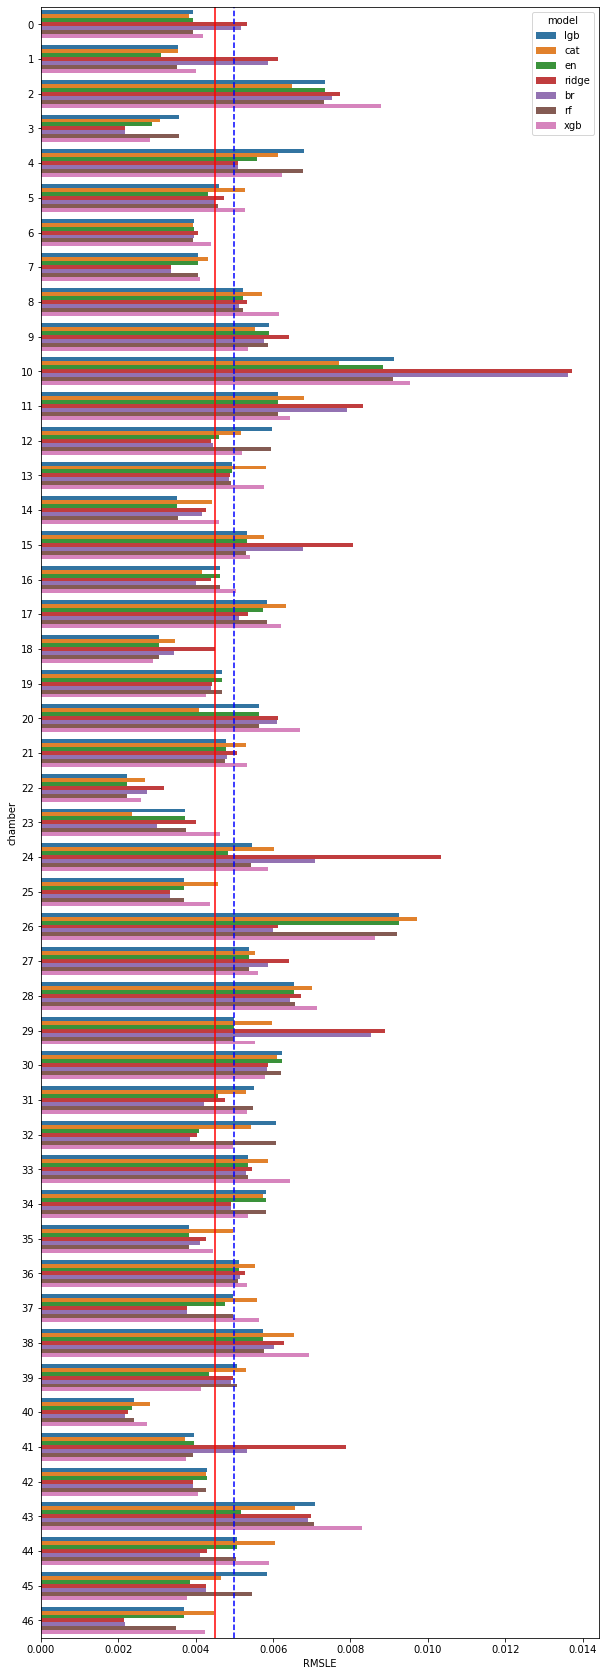

In [72]:
score_df = pd.DataFrame({'model':['lgb']*47 + ['cat']*47 + ['en']*47 + ['ridge']*47 + ['br']*47 + ['rf']*47 + ['xgb']*47,
                         'chamber': list(range(0,47))*7,
                         'RMSLE' : lgb_scores + cat_scores + en_scores + ridge_scores + br_scores + rf_scores + xgb_scores})

fig = plt.figure(figsize = (10, 30))
sns.barplot(data = score_df, orient = 'h', x = 'RMSLE', y = 'chamber', hue = 'model')
plt.axvline(0.005, color='b', linestyle='--')
plt.axvline(0.0045, color='r')

In [73]:
score_df.pivot('chamber', 'model', 'RMSLE')

model          br       cat        en       lgb        rf     ridge       xgb
chamber                                                                      
0        0.005179  0.003831  0.003926  0.003926  0.003917  0.005319  0.004180
1        0.005859  0.003532  0.003112  0.003532  0.003519  0.006137  0.003999
2        0.007514  0.006487  0.007342  0.007342  0.007319  0.007729  0.008780
3        0.002171  0.003073  0.002876  0.003570  0.003559  0.002171  0.002815
4        0.005104  0.006116  0.005585  0.006802  0.006776  0.005100  0.006224
5        0.004508  0.005284  0.004307  0.004593  0.004571  0.004730  0.005271
6        0.003947  0.003927  0.003947  0.003947  0.003939  0.004046  0.004403
7        0.003359  0.004311  0.004055  0.004055  0.004048  0.003365  0.004115
8        0.005127  0.005719  0.005209  0.005209  0.005226  0.005338  0.006142
9        0.005767  0.005544  0.005894  0.005894  0.005866  0.006420  0.005354
10       0.013618  0.007694  0.008833  0.009121  0.009104  0.013735  0.009540
11       0.007919  0.006800  0.006131  0.006131  0.006115  0.008326  0.006433
12       0.004444  0.005180  0.004612  0.005975  0.005942  0.004395  0.005191
13       0.004869  0.005808  0.004939  0.004939  0.004918  0.004878  0.005753
14       0.004167  0.004408  0.003526  0.003526  0.003531  0.004261  0.004605
15       0.006768  0.005757  0.005316  0.005316  0.005312  0.008054  0.005414
16       0.004016  0.004169  0.004624  0.004624  0.004634  0.004398  0.005033
17       0.005129  0.006333  0.005740  0.005843  0.005838  0.005357  0.006194
18       0.003434  0.003475  0.003061  0.003061  0.003055  0.004499  0.002889
19       0.004389  0.004496  0.004678  0.004678  0.004671  0.004408  0.004267
20       0.006103  0.004084  0.005637  0.005637  0.005641  0.006116  0.006691
21       0.004810  0.005292  0.004773  0.004773  0.004765  0.005060  0.005315
22       0.002739  0.002681  0.002229  0.002229  0.002228  0.003188  0.002583
23       0.003008  0.002352  0.003733  0.003733  0.003736  0.004003  0.004637
24       0.007093  0.006012  0.004835  0.005455  0.005419  0.010343  0.005869
25       0.003323  0.004566  0.003707  0.003707  0.003698  0.003323  0.004378
26       0.006006  0.009718  0.009261  0.009261  0.009210  0.006122  0.008630
27       0.005877  0.005533  0.005386  0.005386  0.005373  0.006404  0.005622
28       0.006448  0.007000  0.006551  0.006551  0.006554  0.006714  0.007129
29       0.008518  0.005980  0.004982  0.004982  0.004981  0.008880  0.005536
30       0.005855  0.006106  0.006240  0.006240  0.006208  0.005861  0.005784
31       0.004204  0.005297  0.004579  0.005495  0.005488  0.004759  0.005337
32       0.003852  0.005438  0.004083  0.006077  0.006065  0.004022  0.004956
33       0.005307  0.005873  0.005345  0.005345  0.005341  0.005444  0.006438
34       0.004905  0.005736  0.005808  0.005808  0.005810  0.004914  0.005360
35       0.004103  0.004968  0.003822  0.003822  0.003815  0.004261  0.004447
36       0.005148  0.005544  0.005131  0.005131  0.005100  0.005272  0.005318
37       0.003783  0.005574  0.004752  0.004965  0.004964  0.003770  0.005633
38       0.006021  0.006530  0.005727  0.005727  0.005755  0.006294  0.006921
39       0.004900  0.005288  0.004350  0.005074  0.005057  0.004959  0.004141
40       0.002171  0.002814  0.002359  0.002395  0.002405  0.002260  0.002751
41       0.005335  0.003728  0.003951  0.003951  0.003927  0.007894  0.003741
42       0.003920  0.004275  0.004282  0.004282  0.004271  0.003935  0.004053
43       0.006897  0.006571  0.005174  0.007078  0.007056  0.006985  0.008288
44       0.004123  0.006055  0.005069  0.005069  0.005048  0.004304  0.005897
45       0.004271  0.004661  0.003860  0.005849  0.005462  0.004271  0.003782
46       0.002173  0.004475  0.003692  0.003692  0.003488  0.002154  0.004231

# 챔버별 성능이 좋은 것으로 보이는 모델들을 선택하여 voting ensemble 진행

In [153]:
pd.DataFrame(score_df.pivot('chamber', 'model', 'RMSLE').values,
                               columns = ['br','cat','en','lgb','rf','ridge','xgb'])

br       cat        en       lgb        rf     ridge       xgb
3   0.002171  0.003073  0.002876  0.003570  0.003559  0.002171  0.002815
4   0.005104  0.006116  0.005585  0.006802  0.006776  0.005100  0.006224
5   0.004508  0.005284  0.004307  0.004593  0.004571  0.004730  0.005271
25  0.003323  0.004566  0.003707  0.003707  0.003698  0.003323  0.004378
26  0.006006  0.009718  0.009261  0.009261  0.009210  0.006122  0.008630
27  0.005877  0.005533  0.005386  0.005386  0.005373  0.006404  0.005622
28  0.006448  0.007000  0.006551  0.006551  0.006554  0.006714  0.007129
32  0.003852  0.005438  0.004083  0.006077  0.006065  0.004022  0.004956
34  0.004905  0.005736  0.005808  0.005808  0.005810  0.004914  0.005360
44  0.004123  0.006055  0.005069  0.005069  0.005048  0.004304  0.005897
46  0.002173  0.004475  0.003692  0.003692  0.003488  0.002154  0.004231

In [74]:
# (건물 별 모델 cv score 의 pivot_q quantile 값*threshold) 보다 작은 cv score를 가진 모델만 건물별로 선택
def good_models(score_df, pivot_q, threshold):
    score_pivot = pd.DataFrame(score_df.pivot('chamber', 'model', 'RMSLE').values,
                               columns = ['br','cat','en','lgb','rf','ridge','xgb'])
    li = []
    for i in range(len(score_pivot)):
        temp = score_pivot.iloc[i]
        q = temp.quantile(pivot_q)
        best = list(temp[temp <= threshold*q].index)
        li.append(best)
    return li

In [172]:
score_df = pd.DataFrame({'model':['lgb']*47 + ['cat']*47 + ['br']*47 + ['ridge']*47 +['en']*47 + ['rf']*47 + ['xgb']*47,
                         'chamber': list(range(0,47))*7,
                         'RMSLE' : lgb_scores + cat_scores + br_scores + ridge_scores + en_scores + rf_scores + xgb_scores})
score_df.head()

model  chamber     RMSLE
0   lgb        0  0.003926
1   lgb        1  0.003532
2   lgb        2  0.007342
3   lgb        3  0.003570
4   lgb        4  0.006802

In [159]:
# (건물 별 모델 cv score 의 pivot_q quantile 값*threshold) 보다 작은 cv score를 가진 모델만 건물별로 선택
def good_models_for_out(score_df, pivot_q, threshold):
    score_pivot = pd.DataFrame(score_df_out.pivot('chamber', 'model', 'RMSLE').values,
                               columns = ['cat','en','lgb','rf','xgb'])
    li = []
    for i in range(len(score_pivot)):
        temp = score_pivot.iloc[i]
        q = temp.quantile(pivot_q)
        best = list(temp[temp <= threshold*q].index)
        li.append(best)
    return li

In [156]:
''' br, ridge 제거 '''
score_df_out = pd.DataFrame({'model':['lgb']*47 + ['cat']*47 + ['en']*47 + ['rf']*47 + ['xgb']*47,
                         'chamber': list(range(0,47))*5,
                         'RMSLE' : lgb_scores + cat_scores + en_scores + rf_scores + xgb_scores})
score_df_out.head()

model  chamber     RMSLE
0   lgb        0  0.003926
1   lgb        1  0.003532
2   lgb        2  0.007342
3   lgb        3  0.003570
4   lgb        4  0.006802

In [ ]:
# voting ensemble training & inference
bests = good_models(score_df, 0.05, 1.1)
voting_pred = []
for i, (X_test, num_f, best, l, c, e, r, br, randomf, xg) in enumerate(zip(df_predicts, num_features_lst, bests, lgbs, cats, ens, ridges, brs, rfs, xgbs)):
    pred = []
    if 'cat' in best:
            cat = c
            pred.append(cat.predict(X_test[num_f]))
    if 'lgb' in best:
        lgb = l
        pred.append(lgb.predict(X_test[num_f]))
    if 'en' in best:
        en = e
        pred.append(en.predict(X_test[num_f]))
    if 'ridge' in best:
        rid = r
        pred.append(rid.predict(X_test[num_f]))
    if 'br' in best:
        bayer = br
        pred.append(bayer.predict(X_test[num_f]))
    if 'rf' in best:
        randomf_ = randomf
        pred.append(randomf_.predict(X_test[num_f]))
    if 'xgb' in best:
        xgb = xg
        pred.append(xgb.predict(X_test[num_f]))

    voting_pred.append(np.expm1(np.array(pred).mean(axis = 0)))

    print (f'model{i+1} prediction complete')
voting_pred = np.concatenate(voting_pred)

In [ ]:
df = df_predict.copy()
df.loc[:,'y'] = voting_pred
df = df[['module_name','key_val','y']]

In [ ]:
out_module = sorted(list(set(df.loc[(df['y']<=1230)|(df['y']>=1290),:]['module_name'].values.tolist())))
out_module

In [ ]:
''' 사용된 모델 확인. '''
np.array(bests)[np.array(out_module)]

In [177]:
len(out_module)

14

In [165]:
# voting ensemble training & inference
bests = good_models(score_df, 0.05, 1.1)
voting_pred = []
for i, (X_test, num_f, best, l, c, e, r, br, randomf, xg) in enumerate(zip(df_predicts, num_features_lst, bests, lgbs, cats, ens, ridges, brs, rfs, xgbs)):
    if i in out_module:
        pred = []
        if 'cat' in best:
            cat = c
            pred.append(cat.predict(X_test[num_f]))
        if 'lgb' in best:
            lgb = l
            pred.append(lgb.predict(X_test[num_f]))
        if 'en' in best:
            en = e
            pred.append(en.predict(X_test[num_f]))
        if 'rf' in best:
            randomf_ = randomf
            pred.append(randomf_.predict(X_test[num_f]))
        if 'xgb' in best:
            xgb = xg
            pred.append(xgb.predict(X_test[num_f]))
            
        if pred:
            voting_pred.append(np.expm1(np.array(pred).mean(axis = 0)))
            print (f'model{i+1} prediction complete')
        else:
            bests_out = good_models_for_out(score_df_out, 0.05, 1.1)   # br, ridge뺀 
            bests_out_for_module = bests_out[i]
            pred = []
            if 'cat' in bests_out_for_module:
                cat = c
                pred.append(cat.predict(X_test[num_f]))
            if 'lgb' in bests_out_for_module:
                lgb = l
                pred.append(lgb.predict(X_test[num_f]))
            if 'en' in bests_out_for_module:
                en = e
                pred.append(en.predict(X_test[num_f]))
            if 'rf' in bests_out_for_module:
                randomf_ = randomf
                pred.append(randomf_.predict(X_test[num_f]))
            if 'xgb' in bests_out_for_module:
                xgb = xg
                pred.append(xgb.predict(X_test[num_f]))

            voting_pred.append(np.expm1(np.array(pred).mean(axis = 0)))
            print (f'model{i+1} prediction complete')
            
    else:
        pred = []
        if 'cat' in best:
            cat = c
            pred.append(cat.predict(X_test[num_f]))
        if 'lgb' in best:
            lgb = l
            pred.append(lgb.predict(X_test[num_f]))
        if 'en' in best:
            en = e
            pred.append(en.predict(X_test[num_f]))
        if 'ridge' in best:
            rid = r
            pred.append(rid.predict(X_test[num_f]))
        if 'br' in best:
            bayer = br
            pred.append(bayer.predict(X_test[num_f]))
        if 'rf' in best:
            randomf_ = randomf
            pred.append(randomf_.predict(X_test[num_f]))
        if 'xgb' in best:
            xgb = xg
            pred.append(xgb.predict(X_test[num_f]))

        voting_pred.append(np.expm1(np.array(pred).mean(axis = 0)))

        print (f'model{i+1} prediction complete')
        
voting_pred = np.concatenate(voting_pred)

model1 prediction complete
model2 prediction complete
model3 prediction complete
model4 prediction complete
model5 prediction complete
model6 prediction complete
model7 prediction complete
model8 prediction complete
model9 prediction complete
model10 prediction complete
model11 prediction complete
model12 prediction complete
model13 prediction complete
model14 prediction complete
model15 prediction complete
model16 prediction complete
model17 prediction complete
model18 prediction complete
model19 prediction complete
model20 prediction complete
model21 prediction complete
model22 prediction complete
model23 prediction complete
model24 prediction complete
model25 prediction complete
model26 prediction complete
model27 prediction complete
model28 prediction complete
model29 prediction complete
model30 prediction complete
model31 prediction complete
model32 prediction complete
model33 prediction complete
model34 prediction complete
model35 prediction complete
model36 prediction complete
m

In [166]:
voting_pred

array([1257.46095107, 1256.97143696, 1256.88470554, 1256.60296082,
       1256.90268531, 1262.61979414, 1262.12845705, 1262.89920454,
       1263.28959428, 1263.9894182 , 1262.89067829, 1264.00826324,
       1263.18024918, 1260.46695002, 1260.1671287 , 1258.87742051,
       1258.79261614, 1259.35140693, 1260.19753968, 1267.25990019,
       1265.47635556, 1266.19823775, 1265.48094417, 1265.71872881,
       1264.9821441 , 1265.37576148, 1266.05086633, 1265.90211858,
       1265.88210106, 1265.72279159, 1265.63461377, 1265.58343254,
       1264.91442128, 1264.89936347, 1264.89728827, 1264.88083229,
       1264.87143585, 1264.86609452, 1259.02485632, 1258.81978439,
       1230.81294744, 1230.5917477 , 1230.96515879, 1231.52420412,
       1261.43037871, 1260.84010372, 1259.03182998, 1259.83340944,
       1260.69840978, 1262.95573674, 1262.95573674, 1262.95573674,
       1262.95573674, 1262.95573674, 1262.95573674, 1238.82989698,
       1239.58935548, 1265.33296404, 1266.4242339 , 1265.93992

In [167]:
df_predict['msure_val'] = voting_pred
df_submission = df_predict[['key_val','msure_val']]
# 예측 파일을 저장합니다. 
# 제출용 파일 이름은 cds_submission_팀명_차수.csv 형태로 제출합니다.
df_submission.set_index('key_val', inplace=True)
df_submission.to_csv('cds_submission_데이터조무사_33.csv')

In [ ]:
df_submission

In [173]:
def QQ_plot(data, measure):
    
    # 그래프의 크기를 지정합니다.
    fig = plt.figure(figsize=(10,4))
    
    # 1행 2열의 첫번째 히스토그램 그래프입니다.
    fig1 = fig.add_subplot(121)
    (mu, sigma) = norm.fit(data)
    # distplot 으로 타깃 변수의 분포를 확인합니다. kde = True를 입력하면 커널밀도추정 결과를 함께 표기할 수 있습니다.
    sns.distplot(data, kde=True, fit=norm)
    fig1.legend(['KDE', f'N({round(mu, 2)},{round(sigma**2, 2)})'], loc='upper right')
    fig1.set_title(f'{measure} Distribution', loc='center')
    fig1.set_xlabel(f'{measure}')

    # 1행 2열의 두번째 QQ Plot 그래프입니다.
    fig2 = fig.add_subplot(122)
    # 정규분포와 타깃변수의 분포를 비교합니다.
    res = probplot(data, plot=fig2)
    fig2.set_title(f'{measure} Probability Plot', loc='center')

    plt.tight_layout()
    plt.show()

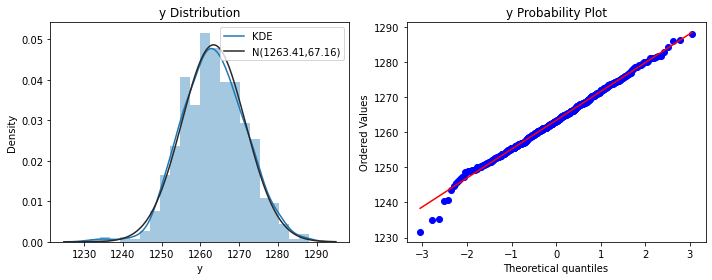

In [175]:
QQ_plot(df_final['y'], 'y')

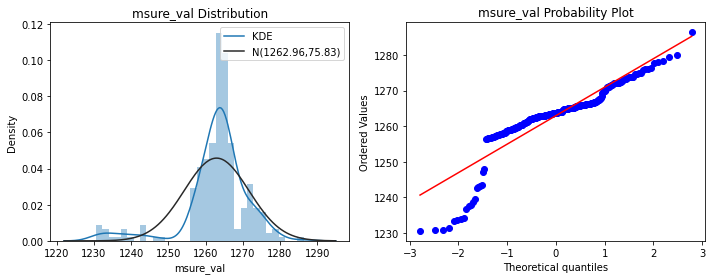

In [176]:
QQ_plot(df_submission['msure_val'], 'msure_val')

# BR, RIDGE 버리고 하기

In [178]:
# (건물 별 모델 cv score 의 pivot_q quantile 값*threshold) 보다 작은 cv score를 가진 모델만 건물별로 선택
def good_models(score_df, pivot_q, threshold):
    score_pivot = pd.DataFrame(score_df.pivot('chamber', 'model', 'RMSLE').values,
                               columns = ['cat','en','lgb','rf','xgb'])
    li = []
    for i in range(len(score_pivot)):
        temp = score_pivot.iloc[i]
        q = temp.quantile(pivot_q)
        best = list(temp[temp <= threshold*q].index)
        li.append(best)
    return li

In [179]:
score_df = pd.DataFrame({'model':['lgb']*47 + ['cat']*47 +['en']*47 + ['rf']*47 + ['xgb']*47,
                         'chamber': list(range(0,47))*5,
                         'RMSLE' : lgb_scores + cat_scores + en_scores + rf_scores + xgb_scores})
score_df.head()

model  chamber     RMSLE
0   lgb        0  0.003926
1   lgb        1  0.003532
2   lgb        2  0.007342
3   lgb        3  0.003570
4   lgb        4  0.006802

In [183]:
pd.DataFrame(score_df.pivot('chamber', 'model', 'RMSLE').values,
                               columns = ['cat','en','lgb','rf','xgb'])

cat        en       lgb        rf       xgb
0   0.003831  0.003926  0.003926  0.003917  0.004180
1   0.003532  0.003112  0.003532  0.003519  0.003999
2   0.006487  0.007342  0.007342  0.007319  0.008780
3   0.003073  0.002876  0.003570  0.003559  0.002815
4   0.006116  0.005585  0.006802  0.006776  0.006224
5   0.005284  0.004307  0.004593  0.004571  0.005271
6   0.003927  0.003947  0.003947  0.003939  0.004403
7   0.004311  0.004055  0.004055  0.004048  0.004115
8   0.005719  0.005209  0.005209  0.005226  0.006142
9   0.005544  0.005894  0.005894  0.005866  0.005354
10  0.007694  0.008833  0.009121  0.009104  0.009540
11  0.006800  0.006131  0.006131  0.006115  0.006433
12  0.005180  0.004612  0.005975  0.005942  0.005191
13  0.005808  0.004939  0.004939  0.004918  0.005753
14  0.004408  0.003526  0.003526  0.003531  0.004605
15  0.005757  0.005316  0.005316  0.005312  0.005414
16  0.004169  0.004624  0.004624  0.004634  0.005033
17  0.006333  0.005740  0.005843  0.005838  0.006194
18  0.003475  0.003061  0.003061  0.003055  0.002889
19  0.004496  0.004678  0.004678  0.004671  0.004267
20  0.004084  0.005637  0.005637  0.005641  0.006691
21  0.005292  0.004773  0.004773  0.004765  0.005315
22  0.002681  0.002229  0.002229  0.002228  0.002583
23  0.002352  0.003733  0.003733  0.003736  0.004637
24  0.006012  0.004835  0.005455  0.005419  0.005869
25  0.004566  0.003707  0.003707  0.003698  0.004378
26  0.009718  0.009261  0.009261  0.009210  0.008630
27  0.005533  0.005386  0.005386  0.005373  0.005622
28  0.007000  0.006551  0.006551  0.006554  0.007129
29  0.005980  0.004982  0.004982  0.004981  0.005536
30  0.006106  0.006240  0.006240  0.006208  0.005784
31  0.005297  0.004579  0.005495  0.005488  0.005337
32  0.005438  0.004083  0.006077  0.006065  0.004956
33  0.005873  0.005345  0.005345  0.005341  0.006438
34  0.005736  0.005808  0.005808  0.005810  0.005360
35  0.004968  0.003822  0.003822  0.003815  0.004447
36  0.005544  0.005131  0.005131  0.005100  0.005318
37  0.005574  0.004752  0.004965  0.004964  0.005633
38  0.006530  0.005727  0.005727  0.005755  0.006921
39  0.005288  0.004350  0.005074  0.005057  0.004141
40  0.002814  0.002359  0.002395  0.002405  0.002751
41  0.003728  0.003951  0.003951  0.003927  0.003741
42  0.004275  0.004282  0.004282  0.004271  0.004053
43  0.006571  0.005174  0.007078  0.007056  0.008288
44  0.006055  0.005069  0.005069  0.005048  0.005897
45  0.004661  0.003860  0.005849  0.005462  0.003782
46  0.004475  0.003692  0.003692  0.003488  0.004231

In [194]:
good_models(score_df, 0.1, 1.07)

[['cat', 'en', 'lgb', 'rf'],
 ['en'],
 ['cat'],
 ['en', 'xgb'],
 ['cat', 'en'],
 ['en', 'lgb', 'rf'],
 ['cat', 'en', 'lgb', 'rf'],
 ['cat', 'en', 'lgb', 'rf', 'xgb'],
 ['en', 'lgb', 'rf'],
 ['cat', 'xgb'],
 ['cat'],
 ['en', 'lgb', 'rf', 'xgb'],
 ['en'],
 ['en', 'lgb', 'rf'],
 ['en', 'lgb', 'rf'],
 ['en', 'lgb', 'rf', 'xgb'],
 ['cat', 'en', 'lgb', 'rf'],
 ['en', 'lgb', 'rf'],
 ['en', 'lgb', 'rf', 'xgb'],
 ['cat', 'xgb'],
 ['cat'],
 ['en', 'lgb', 'rf'],
 ['en', 'lgb', 'rf'],
 ['cat'],
 ['en', 'rf'],
 ['en', 'lgb', 'rf'],
 ['en', 'lgb', 'rf', 'xgb'],
 ['cat', 'en', 'lgb', 'rf', 'xgb'],
 ['cat', 'en', 'lgb', 'rf'],
 ['en', 'lgb', 'rf'],
 ['cat', 'en', 'lgb', 'rf', 'xgb'],
 ['en'],
 ['en'],
 ['en', 'lgb', 'rf'],
 ['cat', 'en', 'lgb', 'rf', 'xgb'],
 ['en', 'lgb', 'rf'],
 ['en', 'lgb', 'rf', 'xgb'],
 ['en', 'lgb', 'rf'],
 ['en', 'lgb', 'rf'],
 ['en', 'xgb'],
 ['en', 'lgb', 'rf'],
 ['cat', 'en', 'lgb', 'rf', 'xgb'],
 ['cat', 'en', 'lgb', 'rf', 'xgb'],
 ['en'],
 ['en', 'lgb', 'rf'],
 ['en', 'xg

In [189]:
# voting ensemble training & inference
bests = good_models(score_df, 0.1, 1.05)
voting_pred = []
for i, (X_test, num_f, best, l, c, e, randomf, xg) in enumerate(zip(df_predicts, num_features_lst, bests, lgbs, cats, ens, rfs, xgbs)):
    pred = []
    if 'cat' in best:
        cat = c
        pred.append(cat.predict(X_test[num_f]))
    if 'lgb' in best:
        lgb = l
        pred.append(lgb.predict(X_test[num_f]))
    if 'en' in best:
        en = e
        pred.append(en.predict(X_test[num_f]))
    if 'rf' in best:
        randomf_ = randomf
        pred.append(randomf_.predict(X_test[num_f]))
    if 'xgb' in best:
        xgb = xg
        pred.append(xgb.predict(X_test[num_f]))

    voting_pred.append(np.expm1(np.array(pred).mean(axis = 0)))

    print (f'model{i+1} prediction complete')
voting_pred = np.concatenate(voting_pred)

model1 prediction complete
model2 prediction complete
model3 prediction complete
model4 prediction complete
model5 prediction complete
model6 prediction complete
model7 prediction complete
model8 prediction complete
model9 prediction complete
model10 prediction complete
model11 prediction complete
model12 prediction complete
model13 prediction complete
model14 prediction complete
model15 prediction complete
model16 prediction complete
model17 prediction complete
model18 prediction complete
model19 prediction complete
model20 prediction complete
model21 prediction complete
model22 prediction complete
model23 prediction complete
model24 prediction complete
model25 prediction complete
model26 prediction complete
model27 prediction complete
model28 prediction complete
model29 prediction complete
model30 prediction complete
model31 prediction complete
model32 prediction complete
model33 prediction complete
model34 prediction complete
model35 prediction complete
model36 prediction complete
m

In [190]:
voting_pred

array([1257.03137217, 1256.92961818, 1257.05199339, 1256.82827165,
       1256.91505869, 1263.99902625, 1263.94570453, 1263.91145821,
       1263.88802371, 1263.84008116, 1263.82196121, 1263.81452902,
       1263.78252806, 1262.98044859, 1261.77920205, 1256.62169318,
       1256.28311721, 1258.51531257, 1261.90100587, 1267.18138403,
       1266.13634405, 1267.60138692, 1266.20168696, 1266.89141692,
       1266.36802107, 1266.66057162, 1266.05086633, 1265.90211858,
       1265.88210106, 1265.72279159, 1265.63461377, 1265.58343254,
       1264.91442128, 1264.89936347, 1264.89728827, 1264.88083229,
       1264.87143585, 1264.86609452, 1260.53761225, 1259.61906356,
       1260.03326495, 1259.82008633, 1260.02994079, 1260.07036796,
       1260.45340054, 1260.95937009, 1259.41021599, 1260.50828933,
       1259.95800575, 1262.95573674, 1262.95573674, 1262.95573674,
       1262.95573674, 1262.95573674, 1262.95573674, 1260.67602155,
       1263.77699877, 1263.72831591, 1266.5153696 , 1266.94037

In [195]:
df_predict['msure_val'] = voting_pred
df_submission = df_predict[['key_val','msure_val']]
# 예측 파일을 저장합니다. 
# 제출용 파일 이름은 cds_submission_팀명_차수.csv 형태로 제출합니다.
df_submission.set_index('key_val', inplace=True)
df_submission.to_csv('cds_submission_데이터조무사_34.csv')

# 제출 후 후처리

모든 모델들의 성능이 안좋은 chamber들에 대해서, 오버샘플링 진행

In [ ]:
from imblearn.over_sampling import SMOTE
import smote_variants as sv

In [ ]:
smote = SMOTE(ratio='', kind='')
''' 꼭 train, test set 나눠서 적용해야한다. '''
X_train_over,y_train_over = smote.fit_sample(X_train,y_train)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', X_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_train_over).value_counts())


oversampler= sv.MulticlassOversampling(sv.distance_SMOTE())
X_samp, y_samp= oversampler.sample(X, y)

standardscaler 사용해서 dataset을 표준화시키고 진행 해보자.

In [40]:
pred = []
for i, (df,model,num_f) in enumerate(zip(df_predicts, cats, num_features_lst)):
    cat_pred = model.predict(df[num_f])
    pred.extend(cat_pred)

In [42]:
predict['msure_val'] = np.exp(pred)
df_submission = predict[['key_val', 'msure_val']] 
df_submission.head()

key_val    msure_val
0  LOT380_17  1261.760147
1  LOT122_18  1261.856718
2  LOT313_18  1260.504234
3  LOT459_12  1251.315713
4  LOT459_18  1250.478422

In [43]:
# 예측 파일을 저장합니다. 
# 제출용 파일 이름은 cds_submission_팀명_차수.csv 형태로 제출합니다.
df_submission.set_index('key_val', inplace=True)
df_submission.to_csv('cds_submission_데이터조무사_24.csv')

#### Lasso

In [55]:
ls = []
for i, (train, num_f) in enumerate(zip(df_trains, num_features_lst)):
    def objective_ls(trial):
        param = {
          "random_state":42,
            'alpha':trial.suggest_float("alpha",0.1,20),
            'fit_intercept':trial.suggest_categorical('fit_intercept', [True, False]),
            'normalize':trial.suggest_categorical('normalize', [True, False]),
        }
        X = train[num_f]
        y = np.log1p(train['y'])

        model = Lasso(**param)
        X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=71)

        model.fit(
            X_train, y_train
            )
        ls_pred = model.predict(X_valid)
        rmsle_val = np.sqrt(mean_squared_error(y_valid, ls_pred))

        return rmsle_val
    
    sampler = TPESampler(seed=42)
    study = optuna.create_study(
            study_name="Lasso_parameter_opt",
            direction="minimize",
            sampler=sampler,
            )
    study.optimize(objective_ls, n_trials=10)
    print("Best Score:", study.best_value)
    print("Best trial:", study.best_trial.params)
    
    model = Lasso(**study.best_params)
    model.fit(train[num_f], np.log1p(train['y']))
    print('{} model training is completed'.format(i))
    ls.append(model)


[I 2022-07-10 21:52:30,147] A new study created in memory with name: Lasso_parameter_opt
[I 2022-07-10 21:52:30,161] Trial 0 finished with value: 0.0024541196875053324 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0024541196875053324.
[I 2022-07-10 21:52:30,184] Trial 1 finished with value: 0.004590040123429382 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.0024541196875053324.
[I 2022-07-10 21:52:30,197] Trial 2 finished with value: 0.0024541196875053324 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0024541196875053324.
[I 2022-07-10 21:52:30,221] Trial 3 finished with value: 0.004288776337418062 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.0024541196875053324.
[I 2022-07-10 21:52:30,244] Trial 4 

Best Score: 0.0024541196875053324
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
0 model training is completed


[I 2022-07-10 21:52:30,552] A new study created in memory with name: Lasso_parameter_opt
[I 2022-07-10 21:52:30,568] Trial 0 finished with value: 0.017539512539649936 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.017539512539649936.
[I 2022-07-10 21:52:30,593] Trial 1 finished with value: 0.023742935250755406 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.017539512539649936.
[I 2022-07-10 21:52:30,607] Trial 2 finished with value: 0.017539512539649936 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.017539512539649936.
[I 2022-07-10 21:52:30,632] Trial 3 finished with value: 0.02492532628618527 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.017539512539649936.
[I 2022-07-10 21:52:30,656] Trial 4 finishe

Best Score: 0.005331528598276138
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
1 model training is completed


[I 2022-07-10 21:52:30,748] Trial 9 finished with value: 0.07514444254593164 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.017539512539649936.
[I 2022-07-10 21:52:30,758] A new study created in memory with name: Lasso_parameter_opt
[I 2022-07-10 21:52:30,772] Trial 0 finished with value: 0.0033848090221118643 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0033848090221118643.
[I 2022-07-10 21:52:30,801] Trial 1 finished with value: 0.004312640245600342 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.0033848090221118643.
[I 2022-07-10 21:52:30,815] Trial 2 finished with value: 0.0033848090221118643 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0033848090221118643.
[I 2022-07-10 21:52:30,841] Trial 3 fi

Best Score: 0.017539512539649936
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
2 model training is completed


[I 2022-07-10 21:52:30,958] Trial 9 finished with value: 0.006652675083798682 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.0033848090221118643.
[I 2022-07-10 21:52:30,970] A new study created in memory with name: Lasso_parameter_opt
[I 2022-07-10 21:52:30,985] Trial 0 finished with value: 0.004584071589542365 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004584071589542365.
[I 2022-07-10 21:52:31,014] Trial 1 finished with value: 0.02456039344792084 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.004584071589542365.
[I 2022-07-10 21:52:31,028] Trial 2 finished with value: 0.004584071589542365 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004584071589542365.
[I 2022-07-10 21:52:31,053] Trial 3 finish

Best Score: 0.0033848090221118643
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
3 model training is completed


[I 2022-07-10 21:52:31,181] Trial 9 finished with value: 0.06766093135338079 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.004584071589542365.
[I 2022-07-10 21:52:31,190] A new study created in memory with name: Lasso_parameter_opt
[I 2022-07-10 21:52:31,205] Trial 0 finished with value: 0.005793779078693501 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005793779078693501.
[I 2022-07-10 21:52:31,236] Trial 1 finished with value: 0.009628367122116642 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.005793779078693501.
[I 2022-07-10 21:52:31,250] Trial 2 finished with value: 0.005793779078693501 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005793779078693501.
[I 2022-07-10 21:52:31,278] Trial 3 finishe

Best Score: 0.004584071589542365
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
4 model training is completed


[I 2022-07-10 21:52:31,389] Trial 8 finished with value: 0.005793779078693501 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005793779078693501.
[I 2022-07-10 21:52:31,426] Trial 9 finished with value: 0.028952473399278953 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.005793779078693501.
[I 2022-07-10 21:52:31,437] A new study created in memory with name: Lasso_parameter_opt
[I 2022-07-10 21:52:31,460] Trial 0 finished with value: 0.0024856747994464567 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0024856747994464567.
[I 2022-07-10 21:52:31,489] Trial 1 finished with value: 0.006370104141333485 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.0024856747994464567.
[I 2022-07-10 21:52:31,504] Trial 2 fin

Best Score: 0.005793779078693501
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
5 model training is completed


[I 2022-07-10 21:52:31,621] Trial 8 finished with value: 0.0024856747994464567 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0024856747994464567.
[I 2022-07-10 21:52:31,645] Trial 9 finished with value: 0.00457732163231352 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.0024856747994464567.
[I 2022-07-10 21:52:31,655] A new study created in memory with name: Lasso_parameter_opt
[I 2022-07-10 21:52:31,667] Trial 0 finished with value: 0.004929722750851463 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004929722750851463.
[I 2022-07-10 21:52:31,697] Trial 1 finished with value: 0.021697273034372806 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.004929722750851463.
[I 2022-07-10 21:52:31,713] Trial 2 fini

Best Score: 0.0024856747994464567
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
6 model training is completed


[I 2022-07-10 21:52:31,858] Trial 9 finished with value: 0.052276763447106335 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.004929722750851463.
[I 2022-07-10 21:52:31,866] A new study created in memory with name: Lasso_parameter_opt
[I 2022-07-10 21:52:31,879] Trial 0 finished with value: 0.009796758797896111 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.009796758797896111.
[I 2022-07-10 21:52:31,903] Trial 1 finished with value: 0.011156368025154526 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.009796758797896111.
[I 2022-07-10 21:52:31,918] Trial 2 finished with value: 0.009796758797896111 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.009796758797896111.
[I 2022-07-10 21:52:31,948] Trial 3 finish

Best Score: 0.004929722750851463
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
7 model training is completed


[I 2022-07-10 21:52:32,066] Trial 9 finished with value: 0.012362411209560152 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.009796758797896111.
[I 2022-07-10 21:52:32,074] A new study created in memory with name: Lasso_parameter_opt
[I 2022-07-10 21:52:32,087] Trial 0 finished with value: 0.005977939993228887 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005977939993228887.
[I 2022-07-10 21:52:32,112] Trial 1 finished with value: 0.010273340921393252 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.005977939993228887.
[I 2022-07-10 21:52:32,126] Trial 2 finished with value: 0.005977939993228887 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005977939993228887.
[I 2022-07-10 21:52:32,152] Trial 3 finish

Best Score: 0.009796758797896111
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
8 model training is completed


[I 2022-07-10 21:52:32,269] Trial 9 finished with value: 0.005871662565667956 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 5 with value: 0.005846096603134695.
[I 2022-07-10 21:52:32,287] A new study created in memory with name: Lasso_parameter_opt
[I 2022-07-10 21:52:32,300] Trial 0 finished with value: 0.010747377669623536 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.010747377669623536.
[I 2022-07-10 21:52:32,325] Trial 1 finished with value: 0.00685493949610532 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.00685493949610532.
[I 2022-07-10 21:52:32,338] Trial 2 finished with value: 0.010747377669623536 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 0.00685493949610532.
[I 2022-07-10 21:52:32,362] Trial 3 finished 

Best Score: 0.005846096603134695
Best trial: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}
9 model training is completed


[I 2022-07-10 21:52:32,476] Trial 9 finished with value: 0.02084932078731616 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 1 with value: 0.00685493949610532.
[I 2022-07-10 21:52:32,496] A new study created in memory with name: Lasso_parameter_opt
[I 2022-07-10 21:52:32,509] Trial 0 finished with value: 0.0090480978791713 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0090480978791713.
[I 2022-07-10 21:52:32,532] Trial 1 finished with value: 0.008234842200622547 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.008234842200622547.
[I 2022-07-10 21:52:32,545] Trial 2 finished with value: 0.0090480978791713 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 0.008234842200622547.
[I 2022-07-10 21:52:32,569] Trial 3 finished with 

Best Score: 0.00685493949610532
Best trial: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}
10 model training is completed


[I 2022-07-10 21:52:32,657] Trial 8 finished with value: 0.0090480978791713 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 4 with value: 0.007746448986965465.
[I 2022-07-10 21:52:32,683] Trial 9 finished with value: 0.012311121736763077 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 4 with value: 0.007746448986965465.
[I 2022-07-10 21:52:32,703] A new study created in memory with name: Lasso_parameter_opt
[I 2022-07-10 21:52:32,719] Trial 0 finished with value: 0.007752771131003385 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.007752771131003385.
[I 2022-07-10 21:52:32,745] Trial 1 finished with value: 0.00999207980484189 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.007752771131003385.
[I 2022-07-10 21:52:32,758] Trial 2 finished 

Best Score: 0.007746448986965465
Best trial: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}
11 model training is completed


[I 2022-07-10 21:52:32,896] Trial 9 finished with value: 0.01210351830769542 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.007752771131003385.
[I 2022-07-10 21:52:32,904] A new study created in memory with name: Lasso_parameter_opt
[I 2022-07-10 21:52:32,917] Trial 0 finished with value: 0.006877071718230332 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.006877071718230332.
[I 2022-07-10 21:52:32,943] Trial 1 finished with value: 0.012842524623926417 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.006877071718230332.
[I 2022-07-10 21:52:32,956] Trial 2 finished with value: 0.006877071718230332 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.006877071718230332.
[I 2022-07-10 21:52:32,981] Trial 3 finishe

Best Score: 0.007752771131003385
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
12 model training is completed


[I 2022-07-10 21:52:33,098] Trial 9 finished with value: 0.026064901146710402 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.006877071718230332.
[I 2022-07-10 21:52:33,109] A new study created in memory with name: Lasso_parameter_opt
[I 2022-07-10 21:52:33,123] Trial 0 finished with value: 0.006198244244211704 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.006198244244211704.
[I 2022-07-10 21:52:33,147] Trial 1 finished with value: 0.007056955344456118 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.006198244244211704.
[I 2022-07-10 21:52:33,161] Trial 2 finished with value: 0.006198244244211704 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.006198244244211704.
[I 2022-07-10 21:52:33,186] Trial 3 finish

Best Score: 0.006877071718230332
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
13 model training is completed


[I 2022-07-10 21:52:33,306] A new study created in memory with name: Lasso_parameter_opt
[I 2022-07-10 21:52:33,318] Trial 0 finished with value: 0.0038757983936008236 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0038757983936008236.
[I 2022-07-10 21:52:33,342] Trial 1 finished with value: 0.0026267726704547563 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.0026267726704547563.
[I 2022-07-10 21:52:33,355] Trial 2 finished with value: 0.0038757983936008236 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 0.0026267726704547563.
[I 2022-07-10 21:52:33,380] Trial 3 finished with value: 0.002607551676877481 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 3 with value: 0.002607551676877481.
[I 2022-07-10 21:52:33,404] Trial 4 

Best Score: 0.006198244244211704
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
14 model training is completed


[I 2022-07-10 21:52:33,513] A new study created in memory with name: Lasso_parameter_opt
[I 2022-07-10 21:52:33,526] Trial 0 finished with value: 0.004966922830114733 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004966922830114733.
[I 2022-07-10 21:52:33,550] Trial 1 finished with value: 0.01073727735306841 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.004966922830114733.
[I 2022-07-10 21:52:33,563] Trial 2 finished with value: 0.004966922830114733 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004966922830114733.
[I 2022-07-10 21:52:33,586] Trial 3 finished with value: 0.012917318011924627 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.004966922830114733.
[I 2022-07-10 21:52:33,610] Trial 4 finishe

Best Score: 0.002607551676877481
Best trial: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}
15 model training is completed


[I 2022-07-10 21:52:33,703] A new study created in memory with name: Lasso_parameter_opt
[I 2022-07-10 21:52:33,715] Trial 0 finished with value: 0.00683938762613788 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.00683938762613788.
[I 2022-07-10 21:52:33,741] Trial 1 finished with value: 0.015620551627257041 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.00683938762613788.
[I 2022-07-10 21:52:33,754] Trial 2 finished with value: 0.00683938762613788 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.00683938762613788.
[I 2022-07-10 21:52:33,778] Trial 3 finished with value: 0.017076568105045452 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.00683938762613788.
[I 2022-07-10 21:52:33,802] Trial 4 finished wit

Best Score: 0.004966922830114733
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
16 model training is completed


[I 2022-07-10 21:52:33,897] A new study created in memory with name: Lasso_parameter_opt
[I 2022-07-10 21:52:33,910] Trial 0 finished with value: 0.007139819398248521 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.007139819398248521.
[I 2022-07-10 21:52:33,934] Trial 1 finished with value: 0.01425879713081042 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.007139819398248521.
[I 2022-07-10 21:52:33,948] Trial 2 finished with value: 0.007139819398248521 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.007139819398248521.
[I 2022-07-10 21:52:33,971] Trial 3 finished with value: 0.015599715028430045 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.007139819398248521.
[I 2022-07-10 21:52:33,994] Trial 4 finishe

Best Score: 0.00683938762613788
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
17 model training is completed


[I 2022-07-10 21:52:34,088] A new study created in memory with name: Lasso_parameter_opt
[I 2022-07-10 21:52:34,101] Trial 0 finished with value: 0.0068490419069545255 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0068490419069545255.
[I 2022-07-10 21:52:34,124] Trial 1 finished with value: 0.007783289943640611 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.0068490419069545255.
[I 2022-07-10 21:52:34,137] Trial 2 finished with value: 0.0068490419069545255 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0068490419069545255.
[I 2022-07-10 21:52:34,161] Trial 3 finished with value: 0.009350363098194911 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.0068490419069545255.
[I 2022-07-10 21:52:34,184] Trial 4 

Best Score: 0.007139819398248521
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
18 model training is completed


[I 2022-07-10 21:52:34,278] A new study created in memory with name: Lasso_parameter_opt
[I 2022-07-10 21:52:34,290] Trial 0 finished with value: 0.002035653272411844 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.002035653272411844.
[I 2022-07-10 21:52:34,313] Trial 1 finished with value: 0.002171478948236414 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.002035653272411844.
[I 2022-07-10 21:52:34,326] Trial 2 finished with value: 0.002035653272411844 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.002035653272411844.
[I 2022-07-10 21:52:34,349] Trial 3 finished with value: 0.0023383009530876277 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.002035653272411844.
[I 2022-07-10 21:52:34,372] Trial 4 finis

Best Score: 0.0068490419069545255
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
19 model training is completed
Best Score: 0.002035653272411844
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}


[I 2022-07-10 21:52:34,466] A new study created in memory with name: Lasso_parameter_opt
[I 2022-07-10 21:52:34,479] Trial 0 finished with value: 0.005126757116393915 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005126757116393915.
[I 2022-07-10 21:52:34,503] Trial 1 finished with value: 0.016035004856374886 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.005126757116393915.
[I 2022-07-10 21:52:34,516] Trial 2 finished with value: 0.005126757116393915 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005126757116393915.
[I 2022-07-10 21:52:34,541] Trial 3 finished with value: 0.019015916145114862 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.005126757116393915.
[I 2022-07-10 21:52:34,565] Trial 4 finish

20 model training is completed


[I 2022-07-10 21:52:34,662] A new study created in memory with name: Lasso_parameter_opt
[I 2022-07-10 21:52:34,675] Trial 0 finished with value: 0.0015672335803843076 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0015672335803843076.
[I 2022-07-10 21:52:34,699] Trial 1 finished with value: 0.01417318321352753 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.0015672335803843076.
[I 2022-07-10 21:52:34,713] Trial 2 finished with value: 0.0015672335803843076 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0015672335803843076.
[I 2022-07-10 21:52:34,737] Trial 3 finished with value: 0.015997429657792203 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.0015672335803843076.
[I 2022-07-10 21:52:34,761] Trial 4 f

Best Score: 0.005126757116393915
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
21 model training is completed


[I 2022-07-10 21:52:34,855] A new study created in memory with name: Lasso_parameter_opt
[I 2022-07-10 21:52:34,868] Trial 0 finished with value: 0.00681059642522169 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.00681059642522169.
[I 2022-07-10 21:52:34,892] Trial 1 finished with value: 0.022332388853769387 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.00681059642522169.
[I 2022-07-10 21:52:34,905] Trial 2 finished with value: 0.00681059642522169 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.00681059642522169.
[I 2022-07-10 21:52:34,929] Trial 3 finished with value: 0.02403748928294343 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.00681059642522169.
[I 2022-07-10 21:52:34,957] Trial 4 finished with

Best Score: 0.0015672335803843076
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
22 model training is completed


[I 2022-07-10 21:52:35,059] A new study created in memory with name: Lasso_parameter_opt
[I 2022-07-10 21:52:35,074] Trial 0 finished with value: 0.006382362275516266 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.006382362275516266.
[I 2022-07-10 21:52:35,100] Trial 1 finished with value: 0.008182414236730341 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.006382362275516266.
[I 2022-07-10 21:52:35,114] Trial 2 finished with value: 0.006382362275516266 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.006382362275516266.
[I 2022-07-10 21:52:35,138] Trial 3 finished with value: 0.008472771696188134 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.006382362275516266.
[I 2022-07-10 21:52:35,161] Trial 4 finish

Best Score: 0.00681059642522169
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
23 model training is completed


[I 2022-07-10 21:52:35,279] A new study created in memory with name: Lasso_parameter_opt
[I 2022-07-10 21:52:35,293] Trial 0 finished with value: 0.005389737611222409 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005389737611222409.
[I 2022-07-10 21:52:35,322] Trial 1 finished with value: 0.012465620417140116 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.005389737611222409.
[I 2022-07-10 21:52:35,335] Trial 2 finished with value: 0.005389737611222409 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005389737611222409.
[I 2022-07-10 21:52:35,361] Trial 3 finished with value: 0.01239683381674315 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.005389737611222409.
[I 2022-07-10 21:52:35,387] Trial 4 finishe

Best Score: 0.004591479753003945
Best trial: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}
24 model training is completed


[I 2022-07-10 21:52:35,455] Trial 8 finished with value: 0.005389737611222409 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005389737611222409.
[I 2022-07-10 21:52:35,482] Trial 9 finished with value: 0.010281641113411366 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.005389737611222409.
[I 2022-07-10 21:52:35,492] A new study created in memory with name: Lasso_parameter_opt
[I 2022-07-10 21:52:35,506] Trial 0 finished with value: 0.008105452457802904 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.008105452457802904.
[I 2022-07-10 21:52:35,533] Trial 1 finished with value: 0.02247864635030073 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.008105452457802904.
[I 2022-07-10 21:52:35,546] Trial 2 finishe

Best Score: 0.005389737611222409
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
25 model training is completed


[I 2022-07-10 21:52:35,695] Trial 9 finished with value: 0.03545701862222399 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.008105452457802904.
[I 2022-07-10 21:52:35,704] A new study created in memory with name: Lasso_parameter_opt
[I 2022-07-10 21:52:35,718] Trial 0 finished with value: 0.007413675672553313 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.007413675672553313.
[I 2022-07-10 21:52:35,743] Trial 1 finished with value: 0.01179909531694119 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.007413675672553313.
[I 2022-07-10 21:52:35,757] Trial 2 finished with value: 0.007413675672553313 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.007413675672553313.
[I 2022-07-10 21:52:35,784] Trial 3 finished

Best Score: 0.008105452457802904
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
26 model training is completed


[I 2022-07-10 21:52:35,875] Trial 8 finished with value: 0.007413675672553313 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.007413675672553313.
[I 2022-07-10 21:52:35,902] Trial 9 finished with value: 0.007276693297200346 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 9 with value: 0.007276693297200346.
[I 2022-07-10 21:52:35,923] A new study created in memory with name: Lasso_parameter_opt
[I 2022-07-10 21:52:35,936] Trial 0 finished with value: 0.0105743706765607 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0105743706765607.
[I 2022-07-10 21:52:35,961] Trial 1 finished with value: 0.009585805377332387 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.009585805377332387.
[I 2022-07-10 21:52:35,975] Trial 2 finished w

Best Score: 0.007276693297200346
Best trial: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}
27 model training is completed


[I 2022-07-10 21:52:36,117] Trial 9 finished with value: 0.027046031590344684 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 1 with value: 0.009585805377332387.
[I 2022-07-10 21:52:36,138] A new study created in memory with name: Lasso_parameter_opt
[I 2022-07-10 21:52:36,151] Trial 0 finished with value: 0.002858691504084784 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.002858691504084784.
[I 2022-07-10 21:52:36,175] Trial 1 finished with value: 0.0044705824275458345 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.002858691504084784.
[I 2022-07-10 21:52:36,187] Trial 2 finished with value: 0.002858691504084784 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.002858691504084784.
[I 2022-07-10 21:52:36,212] Trial 3 finis

Best Score: 0.009585805377332387
Best trial: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}
28 model training is completed


[I 2022-07-10 21:52:36,332] Trial 9 finished with value: 0.016494277108309117 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.002858691504084784.
[I 2022-07-10 21:52:36,340] A new study created in memory with name: Lasso_parameter_opt
[I 2022-07-10 21:52:36,353] Trial 0 finished with value: 0.007548583021425898 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.007548583021425898.
[I 2022-07-10 21:52:36,378] Trial 1 finished with value: 0.006329735949940594 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.006329735949940594.
[I 2022-07-10 21:52:36,390] Trial 2 finished with value: 0.007548583021425898 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 0.006329735949940594.
[I 2022-07-10 21:52:36,413] Trial 3 finish

Best Score: 0.002858691504084784
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
29 model training is completed


[I 2022-07-10 21:52:36,539] A new study created in memory with name: Lasso_parameter_opt
[I 2022-07-10 21:52:36,552] Trial 0 finished with value: 0.005807424105754044 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005807424105754044.
[I 2022-07-10 21:52:36,578] Trial 1 finished with value: 0.013231924219108316 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.005807424105754044.
[I 2022-07-10 21:52:36,591] Trial 2 finished with value: 0.005807424105754044 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005807424105754044.
[I 2022-07-10 21:52:36,616] Trial 3 finished with value: 0.01442797116492097 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.005807424105754044.
[I 2022-07-10 21:52:36,640] Trial 4 finishe

Best Score: 0.004344987991935335
Best trial: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}
30 model training is completed


[I 2022-07-10 21:52:36,733] Trial 9 finished with value: 0.037210147828892357 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.005807424105754044.
[I 2022-07-10 21:52:36,742] A new study created in memory with name: Lasso_parameter_opt
[I 2022-07-10 21:52:36,755] Trial 0 finished with value: 0.003948318056142591 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.003948318056142591.
[I 2022-07-10 21:52:36,780] Trial 1 finished with value: 0.010108102397610558 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.003948318056142591.
[I 2022-07-10 21:52:36,795] Trial 2 finished with value: 0.003948318056142591 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.003948318056142591.
[I 2022-07-10 21:52:36,820] Trial 3 finish

Best Score: 0.005807424105754044
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
31 model training is completed


[I 2022-07-10 21:52:36,933] Trial 9 finished with value: 0.010564299387188527 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.003948318056142591.
[I 2022-07-10 21:52:36,942] A new study created in memory with name: Lasso_parameter_opt
[I 2022-07-10 21:52:36,954] Trial 0 finished with value: 0.010996457753074491 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.010996457753074491.
[I 2022-07-10 21:52:36,980] Trial 1 finished with value: 0.02235330574436427 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.010996457753074491.
[I 2022-07-10 21:52:36,993] Trial 2 finished with value: 0.010996457753074491 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.010996457753074491.
[I 2022-07-10 21:52:37,017] Trial 3 finishe

Best Score: 0.003948318056142591
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
32 model training is completed


[I 2022-07-10 21:52:37,138] A new study created in memory with name: Lasso_parameter_opt
[I 2022-07-10 21:52:37,151] Trial 0 finished with value: 0.00844940489818558 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.00844940489818558.
[I 2022-07-10 21:52:37,176] Trial 1 finished with value: 0.003752290861088443 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.003752290861088443.
[I 2022-07-10 21:52:37,189] Trial 2 finished with value: 0.00844940489818558 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 0.003752290861088443.
[I 2022-07-10 21:52:37,213] Trial 3 finished with value: 0.004186699871500359 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 1 with value: 0.003752290861088443.
[I 2022-07-10 21:52:37,237] Trial 4 finished 

Best Score: 0.010996457753074491
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
33 model training is completed


[I 2022-07-10 21:52:37,350] A new study created in memory with name: Lasso_parameter_opt
[I 2022-07-10 21:52:37,364] Trial 0 finished with value: 0.004483541630558051 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004483541630558051.
[I 2022-07-10 21:52:37,389] Trial 1 finished with value: 0.015732964907912712 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.004483541630558051.
[I 2022-07-10 21:52:37,403] Trial 2 finished with value: 0.004483541630558051 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004483541630558051.
[I 2022-07-10 21:52:37,428] Trial 3 finished with value: 0.016841628623806375 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.004483541630558051.
[I 2022-07-10 21:52:37,453] Trial 4 finish

Best Score: 0.003752290861088443
Best trial: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}
34 model training is completed


[I 2022-07-10 21:52:37,516] Trial 8 finished with value: 0.004483541630558051 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004483541630558051.
[I 2022-07-10 21:52:37,542] Trial 9 finished with value: 0.015120663340203355 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.004483541630558051.
[I 2022-07-10 21:52:37,550] A new study created in memory with name: Lasso_parameter_opt
[I 2022-07-10 21:52:37,562] Trial 0 finished with value: 0.005512705188285805 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.005512705188285805.
[I 2022-07-10 21:52:37,586] Trial 1 finished with value: 0.011237144580282667 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.005512705188285805.
[I 2022-07-10 21:52:37,599] Trial 2 finish

Best Score: 0.004483541630558051
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
35 model training is completed


[I 2022-07-10 21:52:37,744] A new study created in memory with name: Lasso_parameter_opt
[I 2022-07-10 21:52:37,757] Trial 0 finished with value: 0.006210097560755313 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.006210097560755313.
[I 2022-07-10 21:52:37,781] Trial 1 finished with value: 0.010898872239712606 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.006210097560755313.
[I 2022-07-10 21:52:37,795] Trial 2 finished with value: 0.006210097560755313 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.006210097560755313.
[I 2022-07-10 21:52:37,820] Trial 3 finished with value: 0.013058644779025803 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.006210097560755313.
[I 2022-07-10 21:52:37,843] Trial 4 finish

Best Score: 0.005512705188285805
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
36 model training is completed


[I 2022-07-10 21:52:37,933] Trial 9 finished with value: 0.04503778198032538 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.006210097560755313.
[I 2022-07-10 21:52:37,941] A new study created in memory with name: Lasso_parameter_opt
[I 2022-07-10 21:52:37,953] Trial 0 finished with value: 0.006227870762608383 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.006227870762608383.
[I 2022-07-10 21:52:37,975] Trial 1 finished with value: 0.025488909300492423 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.006227870762608383.
[I 2022-07-10 21:52:37,988] Trial 2 finished with value: 0.006227870762608383 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.006227870762608383.
[I 2022-07-10 21:52:38,013] Trial 3 finishe

Best Score: 0.006210097560755313
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
37 model training is completed


[I 2022-07-10 21:52:38,130] A new study created in memory with name: Lasso_parameter_opt
[I 2022-07-10 21:52:38,143] Trial 0 finished with value: 0.004867294447192986 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004867294447192986.
[I 2022-07-10 21:52:38,167] Trial 1 finished with value: 0.021843516064570852 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.004867294447192986.
[I 2022-07-10 21:52:38,180] Trial 2 finished with value: 0.004867294447192986 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004867294447192986.
[I 2022-07-10 21:52:38,204] Trial 3 finished with value: 0.024807907208807704 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.004867294447192986.
[I 2022-07-10 21:52:38,228] Trial 4 finish

Best Score: 0.006227870762608383
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
38 model training is completed


[I 2022-07-10 21:52:38,322] A new study created in memory with name: Lasso_parameter_opt
[I 2022-07-10 21:52:38,334] Trial 0 finished with value: 0.0016986256201322095 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0016986256201322095.
[I 2022-07-10 21:52:38,359] Trial 1 finished with value: 0.00487038596862697 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.0016986256201322095.
[I 2022-07-10 21:52:38,373] Trial 2 finished with value: 0.0016986256201322095 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0016986256201322095.
[I 2022-07-10 21:52:38,398] Trial 3 finished with value: 0.004473004641336842 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.0016986256201322095.
[I 2022-07-10 21:52:38,421] Trial 4 f

Best Score: 0.004867294447192986
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
39 model training is completed


[I 2022-07-10 21:52:38,519] A new study created in memory with name: Lasso_parameter_opt
[I 2022-07-10 21:52:38,532] Trial 0 finished with value: 0.006533974864757643 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.006533974864757643.
[I 2022-07-10 21:52:38,557] Trial 1 finished with value: 0.006477802777099645 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.006477802777099645.
[I 2022-07-10 21:52:38,571] Trial 2 finished with value: 0.006533974864757643 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 0.006477802777099645.
[I 2022-07-10 21:52:38,595] Trial 3 finished with value: 0.007036398902224908 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 1 with value: 0.006477802777099645.
[I 2022-07-10 21:52:38,622] Trial 4 finish

Best Score: 0.0016986256201322095
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
40 model training is completed


[I 2022-07-10 21:52:38,732] A new study created in memory with name: Lasso_parameter_opt
[I 2022-07-10 21:52:38,746] Trial 0 finished with value: 0.004825583433100067 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004825583433100067.
[I 2022-07-10 21:52:38,772] Trial 1 finished with value: 0.007807597149707352 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.004825583433100067.
[I 2022-07-10 21:52:38,785] Trial 2 finished with value: 0.004825583433100067 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004825583433100067.
[I 2022-07-10 21:52:38,809] Trial 3 finished with value: 0.008022293765321462 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.004825583433100067.
[I 2022-07-10 21:52:38,832] Trial 4 finish

Best Score: 0.006477802777099645
Best trial: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}
41 model training is completed


[I 2022-07-10 21:52:38,921] Trial 9 finished with value: 0.012242572716791368 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.004825583433100067.
[I 2022-07-10 21:52:38,929] A new study created in memory with name: Lasso_parameter_opt
[I 2022-07-10 21:52:38,943] Trial 0 finished with value: 0.008617194115711636 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.008617194115711636.
[I 2022-07-10 21:52:38,967] Trial 1 finished with value: 0.006947542137162581 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.006947542137162581.
[I 2022-07-10 21:52:38,980] Trial 2 finished with value: 0.008617194115711636 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 0.006947542137162581.
[I 2022-07-10 21:52:39,003] Trial 3 finish

Best Score: 0.004825583433100067
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
42 model training is completed


[I 2022-07-10 21:52:39,130] A new study created in memory with name: Lasso_parameter_opt
[I 2022-07-10 21:52:39,143] Trial 0 finished with value: 0.010701255912476759 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.010701255912476759.
[I 2022-07-10 21:52:39,167] Trial 1 finished with value: 0.017799145966099134 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.010701255912476759.
[I 2022-07-10 21:52:39,180] Trial 2 finished with value: 0.010701255912476759 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.010701255912476759.
[I 2022-07-10 21:52:39,205] Trial 3 finished with value: 0.0175949471397042 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.010701255912476759.
[I 2022-07-10 21:52:39,229] Trial 4 finished

Best Score: 0.006947542137162581
Best trial: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}
43 model training is completed


[I 2022-07-10 21:52:39,318] Trial 9 finished with value: 0.015940499081934355 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.010701255912476759.
[I 2022-07-10 21:52:39,326] A new study created in memory with name: Lasso_parameter_opt
[I 2022-07-10 21:52:39,340] Trial 0 finished with value: 0.0044044152475442916 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.0044044152475442916.
[I 2022-07-10 21:52:39,365] Trial 1 finished with value: 0.001395156895100271 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 0.001395156895100271.
[I 2022-07-10 21:52:39,378] Trial 2 finished with value: 0.0044044152475442916 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 0.001395156895100271.
[I 2022-07-10 21:52:39,404] Trial 3 fin

Best Score: 0.010701255912476759
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
44 model training is completed


[I 2022-07-10 21:52:39,518] Trial 9 finished with value: 0.0035325457439769965 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 3 with value: 0.0013939877525972518.
[I 2022-07-10 21:52:39,538] A new study created in memory with name: Lasso_parameter_opt
[I 2022-07-10 21:52:39,551] Trial 0 finished with value: 0.004382647818819491 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004382647818819491.
[I 2022-07-10 21:52:39,577] Trial 1 finished with value: 0.006867166026378242 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 0.004382647818819491.
[I 2022-07-10 21:52:39,589] Trial 2 finished with value: 0.004382647818819491 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.004382647818819491.
[I 2022-07-10 21:52:39,615] Trial 3 fini

Best Score: 0.0013939877525972518
Best trial: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}
45 model training is completed


[I 2022-07-10 21:52:39,732] Trial 9 finished with value: 0.012931400412281264 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.004382647818819491.


Best Score: 0.004382647818819491
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
46 model training is completed


In [56]:
models = [cats,ridges,ens,brs,ls]
for i,model_all_chamber in enumerate(models):
    for j, (df,model_by_chamber,num_f) in enumerate(zip(df_predicts, model_all_chamber, num_features_lst)):
        pred_by_chamber = model_by_chamber.predict(df[num_f])
        predict.loc[df.index, 'pred_{}'.format(i)] = pred_by_chamber

In [ ]:
pred = []
for i, (df,model,num_f) in enumerate(zip(df_predicts, cats, num_features_lst)):
    cat_pred = model.predict(df[num_f])
    pred.extend(cat_pred)

In [58]:
predict.isnull().values.any()

False

In [64]:
predict['msure_val'] = np.mean(np.exp(predict.filter(regex='^pred')), axis=1)
df_submission = predict[['key_val','msure_val']]
df_submission.head()

key_val    msure_val
0  LOT380_17  1260.819002
1  LOT122_18  1259.871842
2  LOT313_18  1259.037131
3  LOT459_12  1257.259503
4  LOT459_18  1257.170748

In [65]:
# 예측 파일을 저장합니다. 
# 제출용 파일 이름은 cds_submission_팀명_차수.csv 형태로 제출합니다.
df_submission.set_index('key_val', inplace=True)
df_submission.to_csv('cds_submission_데이터조무사_25.csv')

# Feature Selection

In [156]:
from probatus.feature_elimination import EarlyStoppingShapRFECV

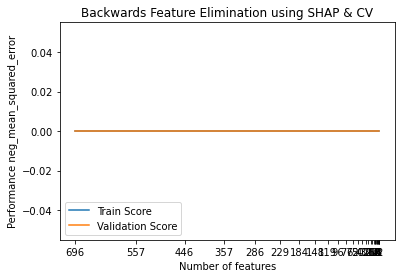

In [158]:
# Run feature elimination
shap_elimination = EarlyStoppingShapRFECV(
    clf=model_xgb, step=0.2, cv=10, scoring='neg_mean_squared_error', early_stopping_rounds=15, n_jobs=-1, eval_metric='rmse')
report = shap_elimination.fit_compute(df_final[COLS], np.log1p(df_final['y']))

# Make plots
performance_plot = shap_elimination.plot()

In [ ]:
report

In [159]:
# Get final feature set
''' num_features는 마지막에 남길 feature 수임. '''
final_features_set = shap_elimination.get_reduced_features_set(num_features=77)

The provided number of features has not been achieved at any stage of the process. You can select one of the following: [402, 322, 258, 207, 166, 133, 107, 86, 69, 56, 45, 36, 29, 24, 20, 16, 13, 11, 9, 8, 7, 6, 5, 4, 3, 2, 1]

In [160]:
final_features_set

['04_fr_para61',
 '18_hv_para3',
 '04_date_cos',
 '13_time_para62',
 '13_pressure_para91',
 '12_gas_para36',
 '17_time_para5',
 '12_time_para16',
 '04_position_para72',
 '06_temp_para65',
 '20_time_para83',
 '06_time_para44',
 '12_temp_para11',
 '12_weekday_cos',
 '13_time_para9',
 '04_time_para77',
 '13_tmp_para31',
 '13_time_para37',
 '17_time_para77',
 '13_time_para77',
 '12_temp_para23',
 '18_time_para5',
 '18_time_para83',
 '06_time_para9',
 '20_temp_para55',
 '17_time_para41',
 '13_gas_para73',
 '20_he_para88',
 '18_efem_para25',
 '17_tmp_para31',
 '12_time_para9',
 '20_time_para9',
 '04_temp_para65',
 '12_gas_para50',
 '17_time_para29',
 '18_time_para77',
 '20_temp_para65',
 '20_temp_para93',
 '04_temp_para18',
 '18_time_para42',
 '20_time_para37',
 '12_temp_para87',
 '06_gas_para73',
 '06_gas_para21',
 '12_time_para44',
 '17_he_para88',
 '12_time_para89',
 '17_time_para83',
 '06_power_para76',
 '06_power_para57',
 '12_fr_para28',
 '06_gas_para33',
 '04_temp_para55',
 '13_time_p

# 예측 결과 제출